# Poisson fLDS

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

/opt/miniconda3/envs/ssm-docs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the parameters of the LDS
T = 50      # number of time bins per batch
B = 20      # number of batches
D = 2       # number of latent dimensions
N = 10      # number of observed dimensions

In [3]:
# Make an SLDS with the true parameters
true_lds = ssm.LDS(N, D, emissions="poisson_nn", 
               emission_kwargs=dict(link="softplus", 
                                    hidden_layer_sizes=(50, 50))
              )
true_lds.dynamics.As[0] = .95 * random_rotation(D, theta=(1) * np.pi/20)

# Sample a bunch of short trajectories 
# (they all converge so we only learn from the initial condition)
xs, ys = list(zip(*[true_lds.sample(T) for _ in range(B)]))

Text(0.5, 1.0, 'Simulated latent trajectories')

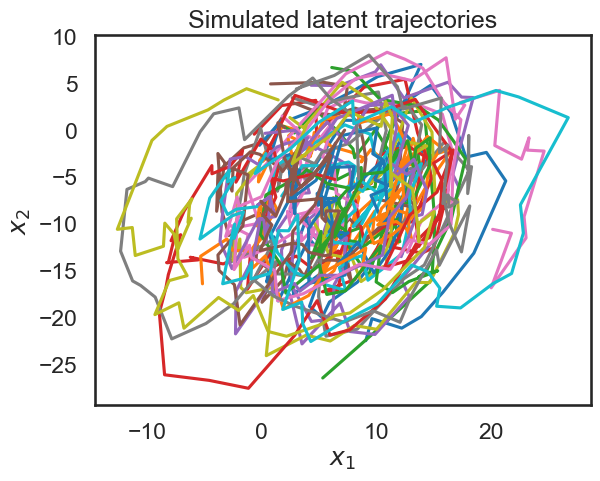

In [4]:
for x in xs:
    plt.plot(x[:, 0], x[:, 1])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated latent trajectories")

Text(0.5, 0.98, 'Simulated firing rates')

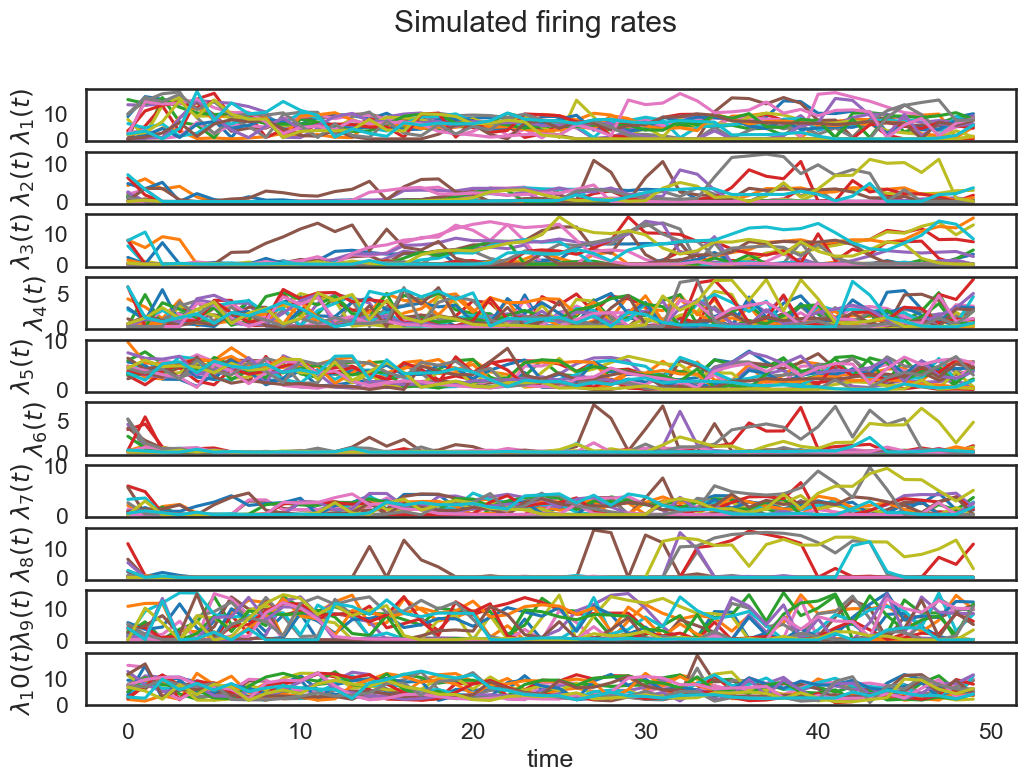

In [5]:
# Compute the firing rates
rates = [true_lds.smooth(x, y) for x, y in zip(xs, ys)]

plt.figure(figsize=(12, 8))
for n in range(N):
    plt.subplot(N, 1, n+1)
    for lmbda in rates:
        plt.plot(lmbda[:, n])
    plt.xlabel("time")
    plt.ylabel("$\\lambda_{}(t)$".format(n+1))
plt.suptitle("Simulated firing rates")

In [6]:
# Plot the nonlinear firing rate map for neuron 1
xmin, xmax = np.concatenate(xs).min(), np.concatenate(xs).max()
npts = 50
xx = np.linspace(xmin-1, xmax+1, npts)
XX, YY = np.meshgrid(xx, xx)
XY = np.column_stack((XX.ravel(), YY.ravel()))
tuning_curves = true_lds.smooth(XY, np.zeros((npts**2, N)))
assert np.all(tuning_curves > 0 )

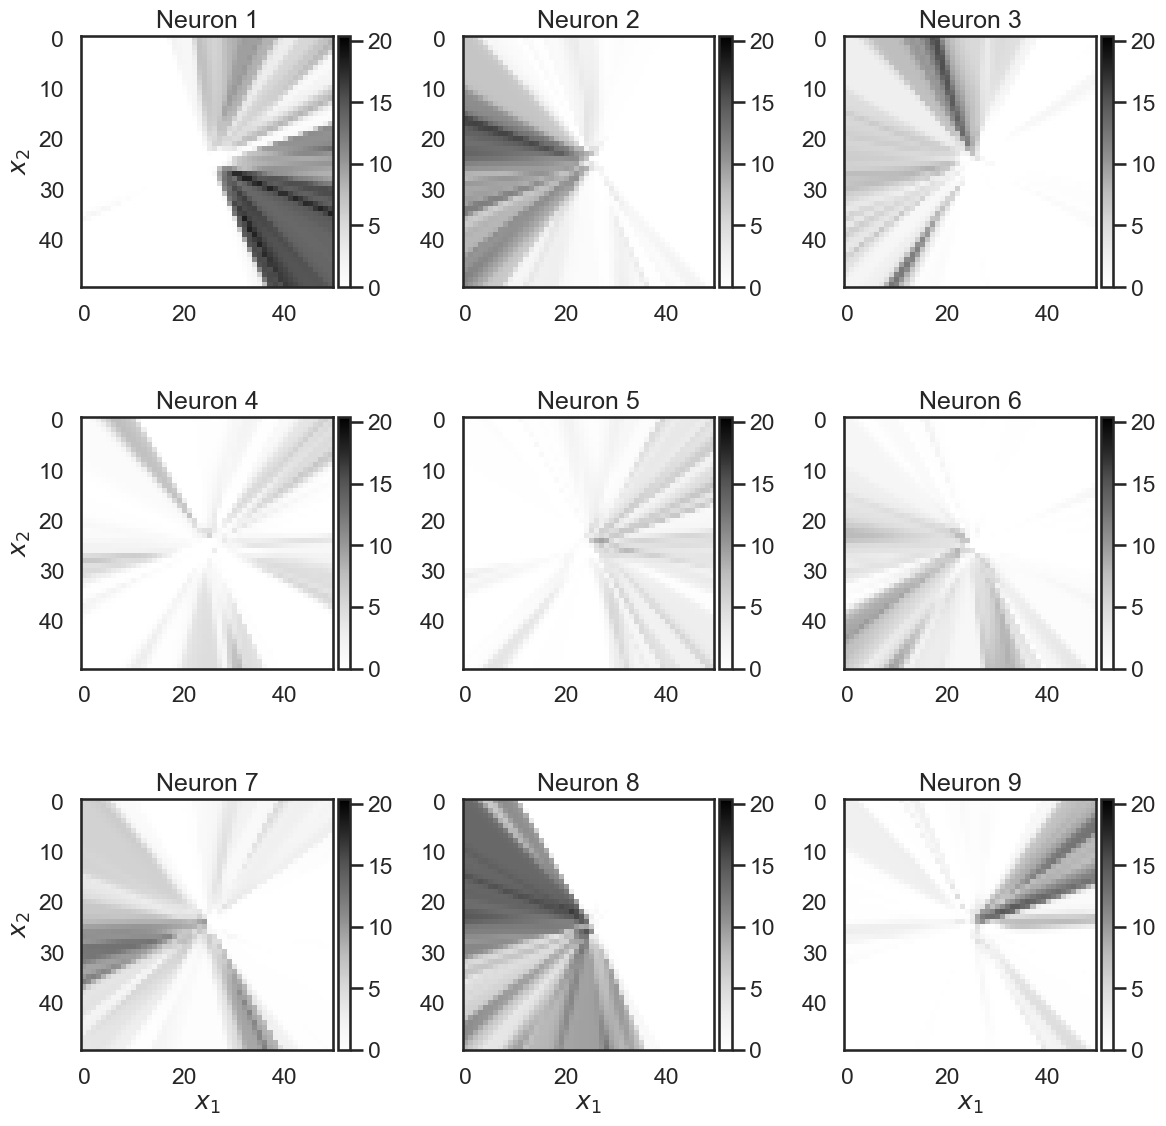

In [7]:
vmax = 1.1 * tuning_curves.max()
plt.figure(figsize=(12, 12))
splt = 3
for i in range(splt):
    for j in range(splt):
        n = i * splt + j 
        if n < N:
            ax = plt.subplot(splt, splt, n+1)
            im = plt.imshow(tuning_curves[:, n].reshape((npts, npts)), vmin=0, vmax=vmax, cmap="Greys")
            if i == splt-1:
                plt.xlabel("$x_1$")
            if j == 0:
                plt.ylabel("$x_2$")
                
            plt.title("Neuron {}".format(n+1))
            
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
plt.tight_layout()

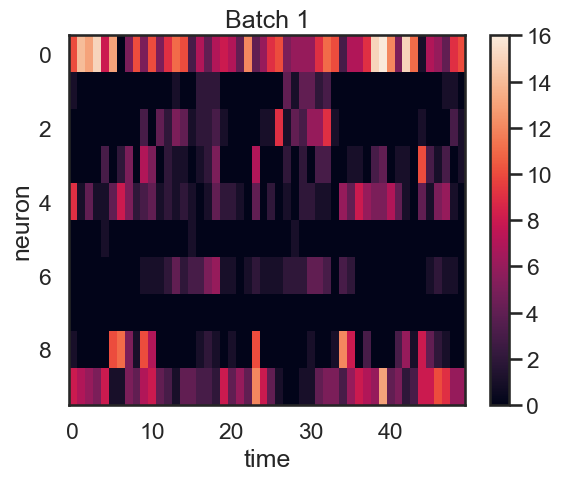

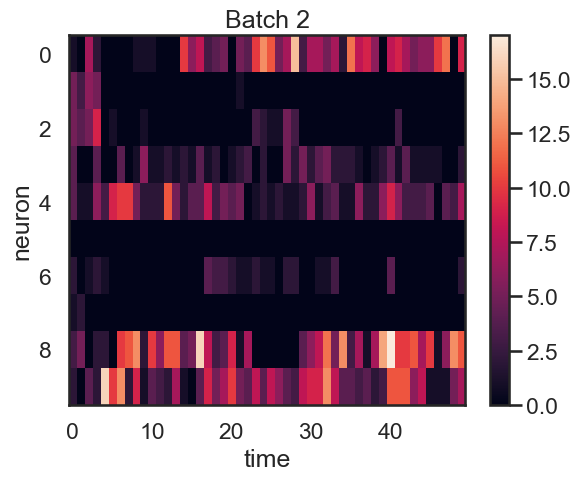

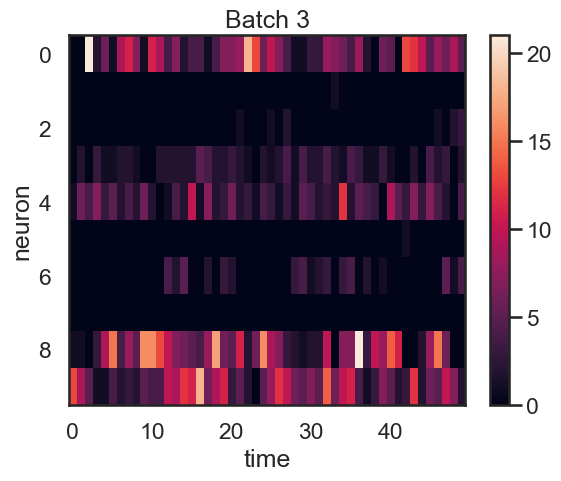

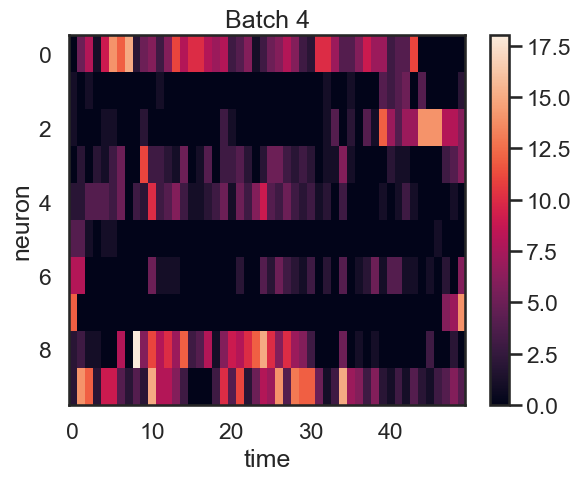

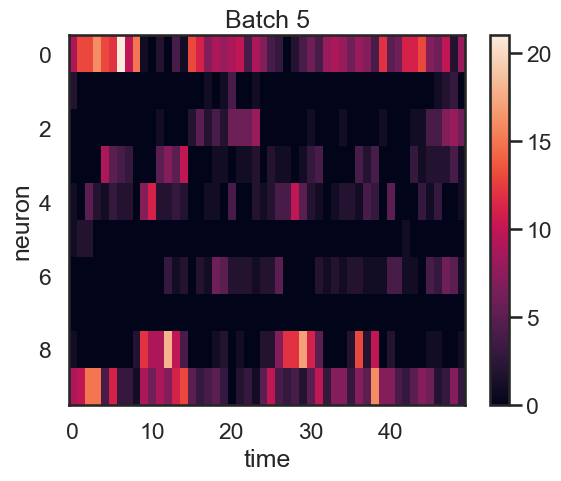

In [8]:
for b in range(5):
    plt.figure()
    plt.imshow(ys[b].T, aspect="auto", interpolation="none")
    plt.xlabel("time")
    plt.ylabel("neuron")
    plt.title("Batch {}".format(b+1))
    plt.colorbar()

In [9]:
print("Fitting LDS with SVI")
lds = ssm.LDS(N, D, emissions="poisson_nn", 
          emission_kwargs=dict(link="softplus", 
                               hidden_layer_sizes=(50, 50))
         )
lds.initialize(ys)

lds_elbos, q = lds.fit(ys, method="bbvi", variational_posterior="mf",
                       num_iters=10000, print_intvl=100, initialize=False)
lds_xs = q.mean

Fitting LDS with SVI


  0%|                                                                                                           | 0/10000 [00:00<?, ?it/s]

LP: -144417.7:   0%|                                                                                            | 0/10000 [00:00<?, ?it/s]

ELBO: -145361.3:   0%|                                                                                          | 0/10000 [00:00<?, ?it/s]

ELBO: -143205.2:   0%|                                                                                  | 1/10000 [00:00<18:31,  8.99it/s]

ELBO: -143205.2:   0%|                                                                                  | 2/10000 [00:00<09:17, 17.93it/s]

ELBO: -140972.5:   0%|                                                                                  | 4/10000 [00:00<09:17, 17.93it/s]

ELBO: -139654.9:   0%|                                                                                  | 5/10000 [00:00<09:17, 17.93it/s]

ELBO: -139654.9:   0%|                                                                                  | 6/10000 [00:00<07:39, 21.74it/s]

ELBO: -138413.9:   0%|                                                                                  | 6/10000 [00:00<07:39, 21.74it/s]

ELBO: -136549.5:   0%|                                                                                 | 10/10000 [00:00<07:39, 21.74it/s]

ELBO: -136549.5:   0%|                                                                                 | 11/10000 [00:00<05:15, 31.61it/s]

ELBO: -134492.0:   0%|                                                                                 | 11/10000 [00:00<05:15, 31.61it/s]

ELBO: -133646.2:   0%|                                                                                 | 12/10000 [00:00<05:15, 31.61it/s]

ELBO: -131456.9:   0%|                                                                                 | 13/10000 [00:00<05:15, 31.61it/s]

ELBO: -130458.3:   0%|                                                                                 | 14/10000 [00:00<05:15, 31.61it/s]

ELBO: -130458.3:   0%|                                                                                 | 15/10000 [00:00<07:24, 22.49it/s]

ELBO: -128601.3:   0%|▏                                                                                | 19/10000 [00:00<07:23, 22.49it/s]

ELBO: -128601.3:   0%|▏                                                                                | 20/10000 [00:00<05:47, 28.73it/s]

ELBO: -126413.5:   0%|▏                                                                                | 20/10000 [00:00<05:47, 28.73it/s]

ELBO: -125181.9:   0%|▏                                                                                | 21/10000 [00:00<05:47, 28.73it/s]

ELBO: -122919.8:   0%|▏                                                                                | 22/10000 [00:00<05:47, 28.73it/s]

ELBO: -122184.4:   0%|▏                                                                                | 23/10000 [00:01<05:47, 28.73it/s]

ELBO: -122184.4:   0%|▏                                                                                | 24/10000 [00:01<07:21, 22.57it/s]

ELBO: -120085.0:   0%|▏                                                                                | 24/10000 [00:01<07:21, 22.57it/s]

ELBO: -119543.4:   0%|▏                                                                                | 25/10000 [00:01<07:21, 22.57it/s]

ELBO: -117838.0:   0%|▏                                                                                | 26/10000 [00:01<07:21, 22.57it/s]

ELBO: -117838.0:   0%|▏                                                                                | 27/10000 [00:01<07:40, 21.66it/s]

ELBO: -116230.3:   0%|▏                                                                                | 30/10000 [00:01<07:40, 21.66it/s]

ELBO: -116230.3:   0%|▎                                                                                | 31/10000 [00:01<06:35, 25.22it/s]

ELBO: -114744.0:   0%|▎                                                                                | 31/10000 [00:01<06:35, 25.22it/s]

ELBO: -113419.5:   0%|▎                                                                                | 32/10000 [00:01<06:35, 25.22it/s]

ELBO: -111729.0:   0%|▎                                                                                | 33/10000 [00:01<06:35, 25.22it/s]

ELBO: -111729.0:   0%|▎                                                                                | 34/10000 [00:01<07:51, 21.12it/s]

ELBO: -110055.2:   0%|▎                                                                                | 34/10000 [00:01<07:51, 21.12it/s]

ELBO: -109091.4:   0%|▎                                                                                | 35/10000 [00:01<07:51, 21.12it/s]

ELBO: -107347.2:   0%|▎                                                                                | 36/10000 [00:01<07:51, 21.12it/s]

ELBO: -107347.2:   0%|▎                                                                                | 37/10000 [00:01<08:00, 20.75it/s]

ELBO: -105488.9:   0%|▎                                                                                | 37/10000 [00:01<08:00, 20.75it/s]

ELBO: -104393.2:   0%|▎                                                                                | 38/10000 [00:01<08:00, 20.75it/s]

ELBO: -102983.6:   0%|▎                                                                                | 39/10000 [00:01<08:00, 20.75it/s]

ELBO: -102983.6:   0%|▎                                                                                | 40/10000 [00:01<08:57, 18.54it/s]

ELBO: -101798.0:   0%|▎                                                                                | 40/10000 [00:01<08:57, 18.54it/s]

ELBO: -100538.2:   0%|▎                                                                                | 41/10000 [00:01<08:57, 18.54it/s]

ELBO: -100538.2:   0%|▎                                                                                | 45/10000 [00:01<07:25, 22.35it/s]

ELBO: -98516.0:   0%|▎                                                                                 | 45/10000 [00:02<07:25, 22.35it/s]

ELBO: -97827.4:   0%|▍                                                                                 | 46/10000 [00:02<07:25, 22.35it/s]

ELBO: -96421.3:   0%|▍                                                                                 | 47/10000 [00:02<07:25, 22.35it/s]

ELBO: -96421.3:   0%|▍                                                                                 | 48/10000 [00:02<08:28, 19.59it/s]

ELBO: -95405.2:   0%|▍                                                                                 | 48/10000 [00:02<08:28, 19.59it/s]

ELBO: -93700.0:   0%|▍                                                                                 | 49/10000 [00:02<08:27, 19.59it/s]

ELBO: -92552.8:   0%|▍                                                                                 | 50/10000 [00:02<08:27, 19.59it/s]

ELBO: -92552.8:   1%|▍                                                                                 | 51/10000 [00:02<08:25, 19.67it/s]

ELBO: -91100.2:   1%|▍                                                                                 | 51/10000 [00:02<08:25, 19.67it/s]

ELBO: -90375.9:   1%|▍                                                                                 | 52/10000 [00:02<08:25, 19.67it/s]

ELBO: -89282.3:   1%|▍                                                                                 | 53/10000 [00:02<08:25, 19.67it/s]

ELBO: -89282.3:   1%|▍                                                                                 | 54/10000 [00:02<09:15, 17.90it/s]

ELBO: -87563.4:   1%|▍                                                                                 | 54/10000 [00:02<09:15, 17.90it/s]

ELBO: -86642.9:   1%|▍                                                                                 | 55/10000 [00:02<09:15, 17.90it/s]

ELBO: -86642.9:   1%|▍                                                                                 | 56/10000 [00:02<10:02, 16.52it/s]

ELBO: -85553.8:   1%|▍                                                                                 | 56/10000 [00:02<10:02, 16.52it/s]

ELBO: -84443.9:   1%|▍                                                                                 | 57/10000 [00:02<10:02, 16.52it/s]

ELBO: -84443.9:   1%|▍                                                                                 | 58/10000 [00:02<09:39, 17.17it/s]

ELBO: -83760.6:   1%|▍                                                                                 | 58/10000 [00:02<09:39, 17.17it/s]

ELBO: -82299.4:   1%|▍                                                                                 | 59/10000 [00:02<09:39, 17.17it/s]

ELBO: -82299.4:   1%|▍                                                                                 | 60/10000 [00:02<10:26, 15.88it/s]

ELBO: -81026.5:   1%|▍                                                                                 | 60/10000 [00:03<10:26, 15.88it/s]

ELBO: -80170.0:   1%|▌                                                                                 | 61/10000 [00:03<10:26, 15.88it/s]

ELBO: -80170.0:   1%|▌                                                                                 | 62/10000 [00:03<09:58, 16.61it/s]

ELBO: -79271.3:   1%|▌                                                                                 | 64/10000 [00:03<09:58, 16.61it/s]

ELBO: -79271.3:   1%|▌                                                                                 | 65/10000 [00:03<08:30, 19.47it/s]

ELBO: -78036.2:   1%|▌                                                                                 | 65/10000 [00:03<08:30, 19.47it/s]

ELBO: -77035.9:   1%|▌                                                                                 | 66/10000 [00:03<08:30, 19.47it/s]

ELBO: -76329.5:   1%|▌                                                                                 | 67/10000 [00:03<08:30, 19.47it/s]

ELBO: -76329.5:   1%|▌                                                                                 | 68/10000 [00:03<08:25, 19.63it/s]

ELBO: -74782.1:   1%|▌                                                                                 | 68/10000 [00:03<08:25, 19.63it/s]

ELBO: -73767.4:   1%|▌                                                                                 | 69/10000 [00:03<08:25, 19.63it/s]

ELBO: -73580.7:   1%|▌                                                                                 | 70/10000 [00:03<08:25, 19.63it/s]

ELBO: -73580.7:   1%|▌                                                                                 | 71/10000 [00:03<09:23, 17.63it/s]

ELBO: -72411.7:   1%|▌                                                                                 | 71/10000 [00:03<09:23, 17.63it/s]

ELBO: -71056.3:   1%|▌                                                                                 | 72/10000 [00:03<09:22, 17.63it/s]

ELBO: -71056.3:   1%|▌                                                                                 | 73/10000 [00:03<10:17, 16.08it/s]

ELBO: -70586.1:   1%|▌                                                                                 | 73/10000 [00:03<10:17, 16.08it/s]

ELBO: -69293.6:   1%|▌                                                                                 | 74/10000 [00:03<10:17, 16.08it/s]

ELBO: -69293.6:   1%|▌                                                                                 | 75/10000 [00:03<09:49, 16.82it/s]

ELBO: -68628.8:   1%|▌                                                                                 | 75/10000 [00:03<09:49, 16.82it/s]

ELBO: -67673.4:   1%|▌                                                                                 | 76/10000 [00:03<09:49, 16.82it/s]

ELBO: -67673.4:   1%|▋                                                                                 | 77/10000 [00:03<10:36, 15.59it/s]

ELBO: -66776.7:   1%|▋                                                                                 | 77/10000 [00:03<10:36, 15.59it/s]

ELBO: -66172.8:   1%|▋                                                                                 | 78/10000 [00:04<10:36, 15.59it/s]

ELBO: -66172.8:   1%|▋                                                                                 | 79/10000 [00:04<09:59, 16.56it/s]

ELBO: -65246.5:   1%|▋                                                                                 | 79/10000 [00:04<09:59, 16.56it/s]

ELBO: -64376.7:   1%|▋                                                                                 | 80/10000 [00:04<09:59, 16.56it/s]

ELBO: -64376.7:   1%|▋                                                                                 | 81/10000 [00:04<10:52, 15.19it/s]

ELBO: -63773.4:   1%|▋                                                                                 | 83/10000 [00:04<10:52, 15.19it/s]

ELBO: -62619.1:   1%|▋                                                                                 | 84/10000 [00:04<10:52, 15.19it/s]

ELBO: -62619.1:   1%|▋                                                                                 | 85/10000 [00:04<07:53, 20.96it/s]

ELBO: -62076.2:   1%|▋                                                                                 | 85/10000 [00:04<07:53, 20.96it/s]

ELBO: -61320.2:   1%|▋                                                                                 | 86/10000 [00:04<07:53, 20.96it/s]

ELBO: -61095.9:   1%|▋                                                                                 | 87/10000 [00:04<07:53, 20.96it/s]

ELBO: -61095.9:   1%|▋                                                                                 | 88/10000 [00:04<09:01, 18.30it/s]

ELBO: -60017.1:   1%|▋                                                                                 | 88/10000 [00:04<09:01, 18.30it/s]

ELBO: -59426.1:   1%|▋                                                                                 | 89/10000 [00:04<09:01, 18.30it/s]

ELBO: -59016.7:   1%|▋                                                                                 | 90/10000 [00:04<09:01, 18.30it/s]

ELBO: -59016.7:   1%|▋                                                                                 | 91/10000 [00:04<09:46, 16.89it/s]

ELBO: -58351.9:   1%|▋                                                                                 | 91/10000 [00:04<09:46, 16.89it/s]

ELBO: -57382.6:   1%|▊                                                                                 | 92/10000 [00:04<09:46, 16.89it/s]

ELBO: -57382.6:   1%|▊                                                                                 | 93/10000 [00:04<09:31, 17.34it/s]

ELBO: -56819.0:   1%|▊                                                                                 | 93/10000 [00:04<09:31, 17.34it/s]

ELBO: -56118.5:   1%|▊                                                                                 | 94/10000 [00:04<09:31, 17.34it/s]

ELBO: -56118.5:   1%|▊                                                                                 | 95/10000 [00:04<10:17, 16.03it/s]

ELBO: -55221.6:   1%|▊                                                                                 | 95/10000 [00:05<10:17, 16.03it/s]

ELBO: -55106.1:   1%|▊                                                                                 | 96/10000 [00:05<10:17, 16.03it/s]

ELBO: -55106.1:   1%|▊                                                                                 | 97/10000 [00:05<11:01, 14.97it/s]

ELBO: -54779.3:   1%|▊                                                                                 | 97/10000 [00:05<11:01, 14.97it/s]

ELBO: -54060.3:   1%|▊                                                                                 | 98/10000 [00:05<11:01, 14.97it/s]

ELBO: -54060.3:   1%|▊                                                                                 | 99/10000 [00:05<10:16, 16.06it/s]

ELBO: -53148.6:   1%|▊                                                                                 | 99/10000 [00:05<10:16, 16.06it/s]

ELBO: -52639.2:   1%|▊                                                                                | 100/10000 [00:05<10:16, 16.06it/s]

ELBO: -52639.2:   1%|▊                                                                                | 101/10000 [00:05<11:01, 14.96it/s]

ELBO: -52264.0:   1%|▊                                                                                | 101/10000 [00:05<11:01, 14.96it/s]

ELBO: -51722.4:   1%|▊                                                                                | 104/10000 [00:05<11:01, 14.96it/s]

ELBO: -51722.4:   1%|▊                                                                                | 105/10000 [00:05<08:00, 20.61it/s]

ELBO: -51185.7:   1%|▊                                                                                | 105/10000 [00:05<08:00, 20.61it/s]

ELBO: -50603.8:   1%|▊                                                                                | 106/10000 [00:05<08:00, 20.61it/s]

ELBO: -50073.7:   1%|▊                                                                                | 107/10000 [00:05<08:00, 20.61it/s]

ELBO: -50073.7:   1%|▊                                                                                | 108/10000 [00:05<09:06, 18.11it/s]

ELBO: -49677.0:   1%|▊                                                                                | 108/10000 [00:05<09:06, 18.11it/s]

ELBO: -49210.8:   1%|▉                                                                                | 109/10000 [00:05<09:06, 18.11it/s]

ELBO: -48881.2:   1%|▉                                                                                | 110/10000 [00:05<09:06, 18.11it/s]

ELBO: -48881.2:   1%|▉                                                                                | 111/10000 [00:05<09:46, 16.87it/s]

ELBO: -48514.9:   1%|▉                                                                                | 111/10000 [00:05<09:46, 16.87it/s]

ELBO: -48246.7:   1%|▉                                                                                | 112/10000 [00:06<09:46, 16.87it/s]

ELBO: -48246.7:   1%|▉                                                                                | 113/10000 [00:06<09:25, 17.47it/s]

ELBO: -47756.6:   1%|▉                                                                                | 113/10000 [00:06<09:25, 17.47it/s]

ELBO: -46923.4:   1%|▉                                                                                | 114/10000 [00:06<09:25, 17.47it/s]

ELBO: -46923.4:   1%|▉                                                                                | 115/10000 [00:06<10:17, 16.01it/s]

ELBO: -47030.8:   1%|▉                                                                                | 115/10000 [00:06<10:17, 16.01it/s]

ELBO: -47008.6:   1%|▉                                                                                | 116/10000 [00:06<10:17, 16.01it/s]

ELBO: -47008.6:   1%|▉                                                                                | 117/10000 [00:06<09:46, 16.86it/s]

ELBO: -45746.8:   1%|▉                                                                                | 117/10000 [00:06<09:46, 16.86it/s]

ELBO: -46077.8:   1%|▉                                                                                | 118/10000 [00:06<09:46, 16.86it/s]

ELBO: -46077.8:   1%|▉                                                                                | 119/10000 [00:06<10:37, 15.51it/s]

ELBO: -45149.8:   1%|▉                                                                                | 119/10000 [00:06<10:37, 15.51it/s]

ELBO: -45122.8:   1%|▉                                                                                | 120/10000 [00:06<10:37, 15.51it/s]

ELBO: -45122.8:   1%|▉                                                                                | 121/10000 [00:06<09:58, 16.52it/s]

ELBO: -44677.5:   1%|▉                                                                                | 121/10000 [00:06<09:58, 16.52it/s]

ELBO: -44425.9:   1%|▉                                                                                | 122/10000 [00:06<09:58, 16.52it/s]

ELBO: -44425.9:   1%|▉                                                                                | 123/10000 [00:06<10:51, 15.16it/s]

ELBO: -44195.6:   1%|▉                                                                                | 123/10000 [00:06<10:51, 15.16it/s]

ELBO: -43750.4:   1%|█                                                                                | 126/10000 [00:06<10:51, 15.16it/s]

ELBO: -43750.4:   1%|█                                                                                | 127/10000 [00:06<07:53, 20.84it/s]

ELBO: -43477.0:   1%|█                                                                                | 127/10000 [00:06<07:53, 20.84it/s]

ELBO: -43225.8:   1%|█                                                                                | 128/10000 [00:06<07:53, 20.84it/s]

ELBO: -42891.1:   1%|█                                                                                | 129/10000 [00:06<07:53, 20.84it/s]

ELBO: -42891.1:   1%|█                                                                                | 130/10000 [00:06<08:54, 18.46it/s]

ELBO: -42785.4:   1%|█                                                                                | 130/10000 [00:07<08:54, 18.46it/s]

ELBO: -42285.9:   1%|█                                                                                | 131/10000 [00:07<08:54, 18.46it/s]

ELBO: -42266.0:   1%|█                                                                                | 132/10000 [00:07<08:54, 18.46it/s]

ELBO: -42266.0:   1%|█                                                                                | 133/10000 [00:07<09:35, 17.15it/s]

ELBO: -41788.8:   1%|█                                                                                | 133/10000 [00:07<09:35, 17.15it/s]

ELBO: -41619.3:   1%|█                                                                                | 134/10000 [00:07<09:35, 17.15it/s]

ELBO: -41619.3:   1%|█                                                                                | 135/10000 [00:07<10:14, 16.05it/s]

ELBO: -41602.4:   1%|█                                                                                | 135/10000 [00:07<10:14, 16.05it/s]

ELBO: -41123.8:   1%|█                                                                                | 136/10000 [00:07<10:14, 16.05it/s]

ELBO: -41000.4:   1%|█                                                                                | 137/10000 [00:07<10:14, 16.05it/s]

ELBO: -41000.4:   1%|█                                                                                | 138/10000 [00:07<09:31, 17.25it/s]

ELBO: -40770.8:   1%|█                                                                                | 138/10000 [00:07<09:31, 17.25it/s]

ELBO: -40587.2:   1%|█▏                                                                               | 139/10000 [00:07<09:31, 17.25it/s]

ELBO: -40587.2:   1%|█▏                                                                               | 140/10000 [00:07<10:12, 16.10it/s]

ELBO: -40289.6:   1%|█▏                                                                               | 140/10000 [00:07<10:12, 16.10it/s]

ELBO: -40024.5:   1%|█▏                                                                               | 141/10000 [00:07<10:12, 16.10it/s]

ELBO: -40024.5:   1%|█▏                                                                               | 142/10000 [00:07<09:46, 16.82it/s]

ELBO: -39725.3:   1%|█▏                                                                               | 142/10000 [00:07<09:46, 16.82it/s]

ELBO: -39804.9:   1%|█▏                                                                               | 143/10000 [00:07<09:46, 16.82it/s]

ELBO: -39804.9:   1%|█▏                                                                               | 144/10000 [00:07<10:27, 15.71it/s]

ELBO: -39489.3:   1%|█▏                                                                               | 144/10000 [00:07<10:27, 15.71it/s]

ELBO: -39262.2:   1%|█▏                                                                               | 145/10000 [00:08<10:27, 15.71it/s]

ELBO: -39262.2:   1%|█▏                                                                               | 146/10000 [00:08<11:01, 14.90it/s]

ELBO: -39019.5:   1%|█▏                                                                               | 146/10000 [00:08<11:01, 14.90it/s]

ELBO: -38916.7:   1%|█▏                                                                               | 147/10000 [00:08<11:01, 14.90it/s]

ELBO: -38663.9:   2%|█▏                                                                               | 150/10000 [00:08<11:01, 14.90it/s]

ELBO: -38663.9:   2%|█▏                                                                               | 151/10000 [00:08<07:58, 20.59it/s]

ELBO: -38543.7:   2%|█▏                                                                               | 151/10000 [00:08<07:58, 20.59it/s]

ELBO: -38316.4:   2%|█▏                                                                               | 152/10000 [00:08<07:58, 20.59it/s]

ELBO: -38297.0:   2%|█▏                                                                               | 153/10000 [00:08<07:58, 20.59it/s]

ELBO: -38297.0:   2%|█▏                                                                               | 154/10000 [00:08<08:52, 18.51it/s]

ELBO: -38078.8:   2%|█▏                                                                               | 154/10000 [00:08<08:52, 18.51it/s]

ELBO: -37955.9:   2%|█▎                                                                               | 155/10000 [00:08<08:52, 18.51it/s]

ELBO: -37955.9:   2%|█▎                                                                               | 156/10000 [00:08<09:37, 17.05it/s]

ELBO: -37748.9:   2%|█▎                                                                               | 156/10000 [00:08<09:37, 17.05it/s]

ELBO: -37712.0:   2%|█▎                                                                               | 157/10000 [00:08<09:37, 17.05it/s]

ELBO: -37712.0:   2%|█▎                                                                               | 158/10000 [00:08<09:17, 17.64it/s]

ELBO: -37495.2:   2%|█▎                                                                               | 158/10000 [00:08<09:17, 17.64it/s]

ELBO: -37448.1:   2%|█▎                                                                               | 159/10000 [00:08<09:17, 17.64it/s]

ELBO: -37448.1:   2%|█▎                                                                               | 160/10000 [00:08<10:04, 16.29it/s]

ELBO: -37493.7:   2%|█▎                                                                               | 160/10000 [00:08<10:04, 16.29it/s]

ELBO: -36993.8:   2%|█▎                                                                               | 161/10000 [00:08<10:04, 16.29it/s]

ELBO: -36993.8:   2%|█▎                                                                               | 162/10000 [00:08<09:35, 17.09it/s]

ELBO: -36936.2:   2%|█▎                                                                               | 162/10000 [00:09<09:35, 17.09it/s]

ELBO: -36942.7:   2%|█▎                                                                               | 163/10000 [00:09<09:35, 17.09it/s]

ELBO: -36942.7:   2%|█▎                                                                               | 164/10000 [00:09<10:25, 15.73it/s]

ELBO: -36791.5:   2%|█▎                                                                               | 164/10000 [00:09<10:25, 15.73it/s]

ELBO: -36727.4:   2%|█▎                                                                               | 165/10000 [00:09<10:25, 15.73it/s]

ELBO: -36396.7:   2%|█▎                                                                               | 166/10000 [00:09<10:25, 15.73it/s]

ELBO: -36396.7:   2%|█▎                                                                               | 167/10000 [00:09<10:37, 15.41it/s]

ELBO: -36454.5:   2%|█▎                                                                               | 167/10000 [00:09<10:37, 15.41it/s]

ELBO: -36332.1:   2%|█▎                                                                               | 168/10000 [00:09<10:37, 15.41it/s]

ELBO: -36146.3:   2%|█▎                                                                               | 169/10000 [00:09<10:37, 15.41it/s]

ELBO: -36146.3:   2%|█▍                                                                               | 170/10000 [00:09<09:44, 16.83it/s]

ELBO: -36237.7:   2%|█▍                                                                               | 170/10000 [00:09<09:44, 16.83it/s]

ELBO: -35988.9:   2%|█▍                                                                               | 171/10000 [00:09<09:44, 16.83it/s]

ELBO: -35988.9:   2%|█▍                                                                               | 172/10000 [00:09<10:22, 15.78it/s]

ELBO: -35871.9:   2%|█▍                                                                               | 172/10000 [00:09<10:22, 15.78it/s]

ELBO: -35791.2:   2%|█▍                                                                               | 175/10000 [00:09<10:22, 15.78it/s]

ELBO: -35627.6:   2%|█▍                                                                               | 176/10000 [00:09<10:22, 15.78it/s]

ELBO: -35627.6:   2%|█▍                                                                               | 177/10000 [00:09<08:34, 19.08it/s]

ELBO: -35630.0:   2%|█▍                                                                               | 177/10000 [00:09<08:34, 19.08it/s]

ELBO: -35360.2:   2%|█▍                                                                               | 178/10000 [00:09<08:34, 19.08it/s]

ELBO: -35360.2:   2%|█▍                                                                               | 179/10000 [00:09<08:30, 19.25it/s]

ELBO: -35258.0:   2%|█▍                                                                               | 179/10000 [00:09<08:30, 19.25it/s]

ELBO: -35238.9:   2%|█▍                                                                               | 180/10000 [00:10<08:30, 19.25it/s]

ELBO: -35238.9:   2%|█▍                                                                               | 181/10000 [00:10<09:24, 17.41it/s]

ELBO: -35271.5:   2%|█▍                                                                               | 181/10000 [00:10<09:24, 17.41it/s]

ELBO: -35206.9:   2%|█▍                                                                               | 182/10000 [00:10<09:24, 17.41it/s]

ELBO: -35222.8:   2%|█▍                                                                               | 183/10000 [00:10<09:23, 17.41it/s]

ELBO: -35222.8:   2%|█▍                                                                               | 184/10000 [00:10<09:54, 16.52it/s]

ELBO: -34935.6:   2%|█▍                                                                               | 184/10000 [00:10<09:54, 16.52it/s]

ELBO: -34783.1:   2%|█▍                                                                               | 185/10000 [00:10<09:54, 16.52it/s]

ELBO: -34780.2:   2%|█▌                                                                               | 186/10000 [00:10<09:54, 16.52it/s]

ELBO: -34780.2:   2%|█▌                                                                               | 187/10000 [00:10<09:18, 17.57it/s]

ELBO: -34781.0:   2%|█▌                                                                               | 187/10000 [00:10<09:18, 17.57it/s]

ELBO: -34726.9:   2%|█▌                                                                               | 188/10000 [00:10<09:18, 17.57it/s]

ELBO: -34726.9:   2%|█▌                                                                               | 189/10000 [00:10<10:01, 16.32it/s]

ELBO: -34636.4:   2%|█▌                                                                               | 189/10000 [00:10<10:01, 16.32it/s]

ELBO: -34526.3:   2%|█▌                                                                               | 190/10000 [00:10<10:01, 16.32it/s]

ELBO: -34444.5:   2%|█▌                                                                               | 191/10000 [00:10<10:00, 16.32it/s]

ELBO: -34444.5:   2%|█▌                                                                               | 192/10000 [00:10<10:18, 15.86it/s]

ELBO: -34369.0:   2%|█▌                                                                               | 192/10000 [00:10<10:18, 15.86it/s]

ELBO: -34281.2:   2%|█▌                                                                               | 193/10000 [00:10<10:18, 15.86it/s]

ELBO: -34281.2:   2%|█▌                                                                               | 194/10000 [00:10<09:48, 16.67it/s]

ELBO: -34228.0:   2%|█▌                                                                               | 194/10000 [00:10<09:48, 16.67it/s]

ELBO: -34257.3:   2%|█▌                                                                               | 195/10000 [00:10<09:48, 16.67it/s]

ELBO: -34257.3:   2%|█▌                                                                               | 196/10000 [00:10<10:31, 15.51it/s]

ELBO: -33990.7:   2%|█▌                                                                               | 196/10000 [00:11<10:31, 15.51it/s]

ELBO: -34142.5:   2%|█▌                                                                               | 197/10000 [00:11<10:31, 15.51it/s]

ELBO: -33928.4:   2%|█▌                                                                               | 198/10000 [00:11<10:31, 15.51it/s]

ELBO: -33928.4:   2%|█▌                                                                               | 199/10000 [00:11<10:39, 15.32it/s]

ELBO: -33970.0:   2%|█▌                                                                               | 199/10000 [00:11<10:39, 15.32it/s]

ELBO: -33856.6:   2%|█▌                                                                               | 200/10000 [00:11<10:39, 15.32it/s]

ELBO: -34007.2:   2%|█▋                                                                               | 203/10000 [00:11<10:39, 15.32it/s]

ELBO: -34007.2:   2%|█▋                                                                               | 204/10000 [00:11<07:59, 20.42it/s]

ELBO: -33821.0:   2%|█▋                                                                               | 204/10000 [00:11<07:59, 20.42it/s]

ELBO: -33767.2:   2%|█▋                                                                               | 205/10000 [00:11<07:59, 20.42it/s]

ELBO: -33757.2:   2%|█▋                                                                               | 206/10000 [00:11<07:59, 20.42it/s]

ELBO: -33757.2:   2%|█▋                                                                               | 207/10000 [00:11<08:49, 18.50it/s]

ELBO: -33522.0:   2%|█▋                                                                               | 207/10000 [00:11<08:49, 18.50it/s]

ELBO: -33432.2:   2%|█▋                                                                               | 208/10000 [00:11<08:49, 18.50it/s]

ELBO: -33432.2:   2%|█▋                                                                               | 209/10000 [00:11<09:31, 17.12it/s]

ELBO: -33442.6:   2%|█▋                                                                               | 209/10000 [00:11<09:31, 17.12it/s]

ELBO: -33542.3:   2%|█▋                                                                               | 210/10000 [00:11<09:31, 17.12it/s]

ELBO: -33425.5:   2%|█▋                                                                               | 211/10000 [00:11<09:31, 17.12it/s]

ELBO: -33425.5:   2%|█▋                                                                               | 212/10000 [00:11<09:56, 16.40it/s]

ELBO: -33384.1:   2%|█▋                                                                               | 212/10000 [00:11<09:56, 16.40it/s]

ELBO: -33217.8:   2%|█▋                                                                               | 213/10000 [00:11<09:56, 16.40it/s]

ELBO: -33374.3:   2%|█▋                                                                               | 214/10000 [00:12<09:56, 16.40it/s]

ELBO: -33374.3:   2%|█▋                                                                               | 215/10000 [00:12<09:21, 17.42it/s]

ELBO: -33150.8:   2%|█▋                                                                               | 215/10000 [00:12<09:21, 17.42it/s]

ELBO: -33015.4:   2%|█▋                                                                               | 216/10000 [00:12<09:21, 17.42it/s]

ELBO: -33015.4:   2%|█▊                                                                               | 217/10000 [00:12<10:01, 16.26it/s]

ELBO: -32991.1:   2%|█▊                                                                               | 217/10000 [00:12<10:01, 16.26it/s]

ELBO: -33221.1:   2%|█▊                                                                               | 218/10000 [00:12<10:01, 16.26it/s]

ELBO: -33153.5:   2%|█▊                                                                               | 219/10000 [00:12<10:01, 16.26it/s]

ELBO: -33153.5:   2%|█▊                                                                               | 220/10000 [00:12<10:17, 15.83it/s]

ELBO: -32794.0:   2%|█▊                                                                               | 220/10000 [00:12<10:17, 15.83it/s]

ELBO: -32817.3:   2%|█▊                                                                               | 221/10000 [00:12<10:17, 15.83it/s]

ELBO: -32975.5:   2%|█▊                                                                               | 222/10000 [00:12<10:17, 15.83it/s]

ELBO: -32975.5:   2%|█▊                                                                               | 223/10000 [00:12<09:33, 17.04it/s]

ELBO: -32750.9:   2%|█▊                                                                               | 223/10000 [00:12<09:33, 17.04it/s]

ELBO: -32787.2:   2%|█▊                                                                               | 224/10000 [00:12<09:33, 17.04it/s]

ELBO: -32787.2:   2%|█▊                                                                               | 225/10000 [00:12<10:09, 16.03it/s]

ELBO: -32871.6:   2%|█▊                                                                               | 225/10000 [00:12<10:09, 16.03it/s]

ELBO: -32899.4:   2%|█▊                                                                               | 226/10000 [00:12<10:09, 16.03it/s]

ELBO: -32899.4:   2%|█▊                                                                               | 227/10000 [00:12<10:42, 15.21it/s]

ELBO: -32683.1:   2%|█▊                                                                               | 227/10000 [00:12<10:42, 15.21it/s]

ELBO: -32480.0:   2%|█▊                                                                               | 228/10000 [00:12<10:42, 15.21it/s]

ELBO: -32544.9:   2%|█▊                                                                               | 229/10000 [00:12<10:42, 15.21it/s]

ELBO: -32544.9:   2%|█▊                                                                               | 230/10000 [00:12<09:45, 16.69it/s]

ELBO: -32537.4:   2%|█▉                                                                               | 232/10000 [00:13<09:45, 16.69it/s]

ELBO: -32537.4:   2%|█▉                                                                               | 233/10000 [00:13<08:21, 19.47it/s]

ELBO: -32433.4:   2%|█▉                                                                               | 233/10000 [00:13<08:21, 19.47it/s]

ELBO: -32526.5:   2%|█▉                                                                               | 234/10000 [00:13<08:21, 19.47it/s]

ELBO: -32542.1:   2%|█▉                                                                               | 235/10000 [00:13<08:21, 19.47it/s]

ELBO: -32542.1:   2%|█▉                                                                               | 236/10000 [00:13<08:18, 19.59it/s]

ELBO: -32403.2:   2%|█▉                                                                               | 236/10000 [00:13<08:18, 19.59it/s]

ELBO: -32487.3:   2%|█▉                                                                               | 237/10000 [00:13<08:18, 19.59it/s]

ELBO: -32436.9:   2%|█▉                                                                               | 238/10000 [00:13<08:18, 19.59it/s]

ELBO: -32436.9:   2%|█▉                                                                               | 239/10000 [00:13<09:08, 17.78it/s]

ELBO: -32357.6:   2%|█▉                                                                               | 239/10000 [00:13<09:08, 17.78it/s]

ELBO: -32301.6:   2%|█▉                                                                               | 240/10000 [00:13<09:08, 17.78it/s]

ELBO: -32301.6:   2%|█▉                                                                               | 241/10000 [00:13<09:51, 16.51it/s]

ELBO: -32191.5:   2%|█▉                                                                               | 241/10000 [00:13<09:51, 16.51it/s]

ELBO: -32224.9:   2%|█▉                                                                               | 242/10000 [00:13<09:51, 16.51it/s]

ELBO: -32369.9:   2%|█▉                                                                               | 243/10000 [00:13<09:51, 16.51it/s]

ELBO: -32369.9:   2%|█▉                                                                               | 244/10000 [00:13<10:10, 15.99it/s]

ELBO: -32196.5:   2%|█▉                                                                               | 244/10000 [00:13<10:10, 15.99it/s]

ELBO: -32181.2:   2%|█▉                                                                               | 245/10000 [00:13<10:10, 15.99it/s]

ELBO: -32115.6:   2%|█▉                                                                               | 246/10000 [00:13<10:10, 15.99it/s]

ELBO: -32115.6:   2%|██                                                                               | 247/10000 [00:13<09:28, 17.16it/s]

ELBO: -32151.6:   2%|██                                                                               | 247/10000 [00:14<09:28, 17.16it/s]

ELBO: -32075.6:   2%|██                                                                               | 248/10000 [00:14<09:28, 17.16it/s]

ELBO: -32075.6:   2%|██                                                                               | 249/10000 [00:14<10:07, 16.04it/s]

ELBO: -32055.1:   2%|██                                                                               | 249/10000 [00:14<10:07, 16.04it/s]

ELBO: -31992.3:   2%|██                                                                               | 250/10000 [00:14<10:07, 16.04it/s]

ELBO: -32119.3:   3%|██                                                                               | 251/10000 [00:14<10:07, 16.04it/s]

ELBO: -32119.3:   3%|██                                                                               | 252/10000 [00:14<10:22, 15.67it/s]

ELBO: -31906.0:   3%|██                                                                               | 252/10000 [00:14<10:22, 15.67it/s]

ELBO: -31967.2:   3%|██                                                                               | 253/10000 [00:14<10:21, 15.67it/s]

ELBO: -31919.6:   3%|██                                                                               | 254/10000 [00:14<10:21, 15.67it/s]

ELBO: -31919.6:   3%|██                                                                               | 255/10000 [00:14<09:37, 16.87it/s]

ELBO: -31710.8:   3%|██                                                                               | 255/10000 [00:14<09:37, 16.87it/s]

ELBO: -32009.4:   3%|██                                                                               | 256/10000 [00:14<09:37, 16.87it/s]

ELBO: -32009.4:   3%|██                                                                               | 257/10000 [00:14<10:16, 15.81it/s]

ELBO: -31751.9:   3%|██                                                                               | 257/10000 [00:14<10:16, 15.81it/s]

ELBO: -31763.3:   3%|██                                                                               | 258/10000 [00:14<10:16, 15.81it/s]

ELBO: -31763.3:   3%|██                                                                               | 259/10000 [00:14<10:46, 15.06it/s]

ELBO: -31766.6:   3%|██                                                                               | 259/10000 [00:14<10:46, 15.06it/s]

ELBO: -32001.2:   3%|██                                                                               | 260/10000 [00:14<10:46, 15.06it/s]

ELBO: -31695.4:   3%|██                                                                               | 261/10000 [00:14<10:46, 15.06it/s]

ELBO: -31695.4:   3%|██                                                                               | 262/10000 [00:14<09:48, 16.55it/s]

ELBO: -31583.4:   3%|██                                                                               | 262/10000 [00:14<09:48, 16.55it/s]

ELBO: -31583.4:   3%|██▏                                                                              | 265/10000 [00:14<08:22, 19.37it/s]

ELBO: -31638.4:   3%|██▏                                                                              | 265/10000 [00:15<08:22, 19.37it/s]

ELBO: -31534.6:   3%|██▏                                                                              | 266/10000 [00:15<08:22, 19.37it/s]

ELBO: -31661.9:   3%|██▏                                                                              | 267/10000 [00:15<08:22, 19.37it/s]

ELBO: -31661.9:   3%|██▏                                                                              | 268/10000 [00:15<08:17, 19.55it/s]

ELBO: -31590.1:   3%|██▏                                                                              | 268/10000 [00:15<08:17, 19.55it/s]

ELBO: -31649.5:   3%|██▏                                                                              | 269/10000 [00:15<08:17, 19.55it/s]

ELBO: -31503.2:   3%|██▏                                                                              | 270/10000 [00:15<08:17, 19.55it/s]

ELBO: -31503.2:   3%|██▏                                                                              | 271/10000 [00:15<09:08, 17.73it/s]

ELBO: -31511.0:   3%|██▏                                                                              | 271/10000 [00:15<09:08, 17.73it/s]

ELBO: -31509.7:   3%|██▏                                                                              | 272/10000 [00:15<09:08, 17.73it/s]

ELBO: -31509.7:   3%|██▏                                                                              | 273/10000 [00:15<09:51, 16.44it/s]

ELBO: -31410.9:   3%|██▏                                                                              | 273/10000 [00:15<09:51, 16.44it/s]

ELBO: -31405.1:   3%|██▏                                                                              | 274/10000 [00:15<09:51, 16.44it/s]

ELBO: -31532.0:   3%|██▏                                                                              | 275/10000 [00:15<09:51, 16.44it/s]

ELBO: -31532.0:   3%|██▏                                                                              | 276/10000 [00:15<10:12, 15.87it/s]

ELBO: -31287.9:   3%|██▏                                                                              | 276/10000 [00:15<10:12, 15.87it/s]

ELBO: -31274.3:   3%|██▏                                                                              | 277/10000 [00:15<10:12, 15.87it/s]

ELBO: -31227.4:   3%|██▎                                                                              | 278/10000 [00:15<10:12, 15.87it/s]

ELBO: -31227.4:   3%|██▎                                                                              | 279/10000 [00:15<09:30, 17.05it/s]

ELBO: -31280.4:   3%|██▎                                                                              | 279/10000 [00:15<09:30, 17.05it/s]

ELBO: -31351.4:   3%|██▎                                                                              | 280/10000 [00:15<09:30, 17.05it/s]

ELBO: -31351.4:   3%|██▎                                                                              | 281/10000 [00:15<10:09, 15.95it/s]

ELBO: -31301.9:   3%|██▎                                                                              | 281/10000 [00:16<10:09, 15.95it/s]

ELBO: -31273.7:   3%|██▎                                                                              | 282/10000 [00:16<10:09, 15.95it/s]

ELBO: -31300.5:   3%|██▎                                                                              | 283/10000 [00:16<10:09, 15.95it/s]

ELBO: -31300.5:   3%|██▎                                                                              | 284/10000 [00:16<10:20, 15.65it/s]

ELBO: -31116.8:   3%|██▎                                                                              | 284/10000 [00:16<10:20, 15.65it/s]

ELBO: -31138.7:   3%|██▎                                                                              | 285/10000 [00:16<10:20, 15.65it/s]

ELBO: -31191.0:   3%|██▎                                                                              | 286/10000 [00:16<10:20, 15.65it/s]

ELBO: -31191.0:   3%|██▎                                                                              | 287/10000 [00:16<09:34, 16.91it/s]

ELBO: -31119.6:   3%|██▎                                                                              | 287/10000 [00:16<09:34, 16.91it/s]

ELBO: -31083.2:   3%|██▎                                                                              | 288/10000 [00:16<09:34, 16.91it/s]

ELBO: -31083.2:   3%|██▎                                                                              | 289/10000 [00:16<10:12, 15.86it/s]

ELBO: -31061.9:   3%|██▎                                                                              | 289/10000 [00:16<10:12, 15.86it/s]

ELBO: -31098.8:   3%|██▎                                                                              | 290/10000 [00:16<10:12, 15.86it/s]

ELBO: -31098.8:   3%|██▎                                                                              | 291/10000 [00:16<10:44, 15.08it/s]

ELBO: -30998.2:   3%|██▎                                                                              | 291/10000 [00:16<10:44, 15.08it/s]

ELBO: -30954.8:   3%|██▎                                                                              | 292/10000 [00:16<10:43, 15.08it/s]

ELBO: -31076.8:   3%|██▎                                                                              | 293/10000 [00:16<10:43, 15.08it/s]

ELBO: -31076.8:   3%|██▍                                                                              | 294/10000 [00:16<09:46, 16.56it/s]

ELBO: -30998.6:   3%|██▍                                                                              | 294/10000 [00:16<09:46, 16.56it/s]

ELBO: -30923.0:   3%|██▍                                                                              | 295/10000 [00:16<09:46, 16.56it/s]

ELBO: -30923.0:   3%|██▍                                                                              | 296/10000 [00:16<10:22, 15.58it/s]

ELBO: -30946.9:   3%|██▍                                                                              | 296/10000 [00:16<10:22, 15.58it/s]

ELBO: -30812.9:   3%|██▍                                                                              | 297/10000 [00:17<10:22, 15.58it/s]

ELBO: -30842.4:   3%|██▍                                                                              | 298/10000 [00:17<10:22, 15.58it/s]

ELBO: -30842.4:   3%|██▍                                                                              | 299/10000 [00:17<10:33, 15.32it/s]

ELBO: -30831.7:   3%|██▍                                                                              | 299/10000 [00:17<10:33, 15.32it/s]

ELBO: -30796.7:   3%|██▍                                                                              | 302/10000 [00:17<10:33, 15.32it/s]

ELBO: -30882.4:   3%|██▍                                                                              | 303/10000 [00:17<10:33, 15.32it/s]

ELBO: -30882.4:   3%|██▍                                                                              | 304/10000 [00:17<07:55, 20.38it/s]

ELBO: -30932.2:   3%|██▍                                                                              | 304/10000 [00:17<07:55, 20.38it/s]

ELBO: -30738.8:   3%|██▍                                                                              | 305/10000 [00:17<07:55, 20.38it/s]

ELBO: -30685.9:   3%|██▍                                                                              | 306/10000 [00:17<07:55, 20.38it/s]

ELBO: -30685.9:   3%|██▍                                                                              | 307/10000 [00:17<08:44, 18.48it/s]

ELBO: -30726.8:   3%|██▍                                                                              | 307/10000 [00:17<08:44, 18.48it/s]

ELBO: -30616.6:   3%|██▍                                                                              | 308/10000 [00:17<08:44, 18.48it/s]

ELBO: -30616.6:   3%|██▌                                                                              | 309/10000 [00:17<09:31, 16.95it/s]

ELBO: -30683.5:   3%|██▌                                                                              | 309/10000 [00:17<09:31, 16.95it/s]

ELBO: -30648.4:   3%|██▌                                                                              | 310/10000 [00:17<09:31, 16.95it/s]

ELBO: -30627.2:   3%|██▌                                                                              | 311/10000 [00:17<09:31, 16.95it/s]

ELBO: -30627.2:   3%|██▌                                                                              | 312/10000 [00:17<09:59, 16.17it/s]

ELBO: -30680.2:   3%|██▌                                                                              | 312/10000 [00:17<09:59, 16.17it/s]

ELBO: -30592.0:   3%|██▌                                                                              | 313/10000 [00:17<09:59, 16.17it/s]

ELBO: -30488.4:   3%|██▌                                                                              | 314/10000 [00:17<09:59, 16.17it/s]

ELBO: -30488.4:   3%|██▌                                                                              | 315/10000 [00:17<09:22, 17.22it/s]

ELBO: -30755.0:   3%|██▌                                                                              | 315/10000 [00:18<09:22, 17.22it/s]

ELBO: -30615.1:   3%|██▌                                                                              | 316/10000 [00:18<09:22, 17.22it/s]

ELBO: -30615.1:   3%|██▌                                                                              | 317/10000 [00:18<10:00, 16.12it/s]

ELBO: -30511.4:   3%|██▌                                                                              | 317/10000 [00:18<10:00, 16.12it/s]

ELBO: -30470.3:   3%|██▌                                                                              | 318/10000 [00:18<10:00, 16.12it/s]

ELBO: -30464.0:   3%|██▌                                                                              | 319/10000 [00:18<10:00, 16.12it/s]

ELBO: -30464.0:   3%|██▌                                                                              | 320/10000 [00:18<10:14, 15.75it/s]

ELBO: -30473.5:   3%|██▌                                                                              | 320/10000 [00:18<10:14, 15.75it/s]

ELBO: -30462.6:   3%|██▌                                                                              | 321/10000 [00:18<10:14, 15.75it/s]

ELBO: -30511.7:   3%|██▌                                                                              | 322/10000 [00:18<10:14, 15.75it/s]

ELBO: -30511.7:   3%|██▌                                                                              | 323/10000 [00:18<10:24, 15.49it/s]

ELBO: -30437.0:   3%|██▌                                                                              | 323/10000 [00:18<10:24, 15.49it/s]

ELBO: -30488.0:   3%|██▌                                                                              | 324/10000 [00:18<10:24, 15.49it/s]

ELBO: -30311.9:   3%|██▋                                                                              | 325/10000 [00:18<10:24, 15.49it/s]

ELBO: -30311.9:   3%|██▋                                                                              | 326/10000 [00:18<09:39, 16.69it/s]

ELBO: -30333.0:   3%|██▋                                                                              | 326/10000 [00:18<09:39, 16.69it/s]

ELBO: -30592.8:   3%|██▋                                                                              | 327/10000 [00:18<09:39, 16.69it/s]

ELBO: -30592.8:   3%|██▋                                                                              | 328/10000 [00:18<10:15, 15.70it/s]

ELBO: -30239.7:   3%|██▋                                                                              | 328/10000 [00:18<10:15, 15.70it/s]

ELBO: -30372.4:   3%|██▋                                                                              | 329/10000 [00:18<10:15, 15.70it/s]

ELBO: -30317.2:   3%|██▋                                                                              | 330/10000 [00:19<10:15, 15.70it/s]

ELBO: -30317.2:   3%|██▋                                                                              | 331/10000 [00:19<10:34, 15.25it/s]

ELBO: -30371.8:   3%|██▋                                                                              | 331/10000 [00:19<10:34, 15.25it/s]

ELBO: -30298.1:   3%|██▋                                                                              | 332/10000 [00:19<10:34, 15.25it/s]

ELBO: -30298.1:   3%|██▋                                                                              | 333/10000 [00:19<09:58, 16.15it/s]

ELBO: -30289.8:   3%|██▋                                                                              | 333/10000 [00:19<09:58, 16.15it/s]

ELBO: -30239.3:   3%|██▋                                                                              | 334/10000 [00:19<09:58, 16.15it/s]

ELBO: -30239.3:   3%|██▋                                                                              | 335/10000 [00:19<10:31, 15.30it/s]

ELBO: -30191.6:   3%|██▋                                                                              | 335/10000 [00:19<10:31, 15.30it/s]

ELBO: -30224.8:   3%|██▋                                                                              | 338/10000 [00:19<10:31, 15.30it/s]

ELBO: -30265.3:   3%|██▋                                                                              | 339/10000 [00:19<10:31, 15.30it/s]

ELBO: -30265.3:   3%|██▊                                                                              | 340/10000 [00:19<08:35, 18.74it/s]

ELBO: -30156.6:   3%|██▊                                                                              | 340/10000 [00:19<08:35, 18.74it/s]

ELBO: -30230.6:   3%|██▊                                                                              | 341/10000 [00:19<08:35, 18.74it/s]

ELBO: -30191.0:   3%|██▊                                                                              | 342/10000 [00:19<08:35, 18.74it/s]

ELBO: -30191.0:   3%|██▊                                                                              | 343/10000 [00:19<08:25, 19.12it/s]

ELBO: -30079.9:   3%|██▊                                                                              | 343/10000 [00:19<08:25, 19.12it/s]

ELBO: -30208.0:   3%|██▊                                                                              | 344/10000 [00:19<08:24, 19.12it/s]

ELBO: -30208.0:   3%|██▊                                                                              | 345/10000 [00:19<09:15, 17.39it/s]

ELBO: -30010.2:   3%|██▊                                                                              | 345/10000 [00:19<09:15, 17.39it/s]

ELBO: -30035.6:   3%|██▊                                                                              | 346/10000 [00:19<09:15, 17.39it/s]

ELBO: -30035.6:   3%|██▊                                                                              | 347/10000 [00:19<08:59, 17.90it/s]

ELBO: -29960.2:   3%|██▊                                                                              | 347/10000 [00:19<08:59, 17.90it/s]

ELBO: -29986.7:   3%|██▊                                                                              | 348/10000 [00:20<08:59, 17.90it/s]

ELBO: -29986.7:   3%|██▊                                                                              | 349/10000 [00:20<09:50, 16.35it/s]

ELBO: -30138.9:   3%|██▊                                                                              | 349/10000 [00:20<09:50, 16.35it/s]

ELBO: -30024.6:   4%|██▊                                                                              | 350/10000 [00:20<09:50, 16.35it/s]

ELBO: -30001.6:   4%|██▊                                                                              | 351/10000 [00:20<09:49, 16.35it/s]

ELBO: -30001.6:   4%|██▊                                                                              | 352/10000 [00:20<10:08, 15.86it/s]

ELBO: -29968.0:   4%|██▊                                                                              | 352/10000 [00:20<10:08, 15.86it/s]

ELBO: -29920.6:   4%|██▊                                                                              | 353/10000 [00:20<10:08, 15.86it/s]

ELBO: -29931.9:   4%|██▊                                                                              | 354/10000 [00:20<10:08, 15.86it/s]

ELBO: -29931.9:   4%|██▉                                                                              | 355/10000 [00:20<10:23, 15.46it/s]

ELBO: -29951.5:   4%|██▉                                                                              | 355/10000 [00:20<10:23, 15.46it/s]

ELBO: -29814.8:   4%|██▉                                                                              | 356/10000 [00:20<10:23, 15.46it/s]

ELBO: -29874.1:   4%|██▉                                                                              | 357/10000 [00:20<10:23, 15.46it/s]

ELBO: -29874.1:   4%|██▉                                                                              | 358/10000 [00:20<09:35, 16.76it/s]

ELBO: -29868.4:   4%|██▉                                                                              | 358/10000 [00:20<09:35, 16.76it/s]

ELBO: -29846.1:   4%|██▉                                                                              | 359/10000 [00:20<09:35, 16.76it/s]

ELBO: -29846.1:   4%|██▉                                                                              | 360/10000 [00:20<10:12, 15.74it/s]

ELBO: -29865.7:   4%|██▉                                                                              | 360/10000 [00:20<10:12, 15.74it/s]

ELBO: -29690.6:   4%|██▉                                                                              | 361/10000 [00:20<10:12, 15.74it/s]

ELBO: -29778.8:   4%|██▉                                                                              | 362/10000 [00:20<10:12, 15.74it/s]

ELBO: -29778.8:   4%|██▉                                                                              | 363/10000 [00:20<10:22, 15.47it/s]

ELBO: -29674.7:   4%|██▉                                                                              | 363/10000 [00:21<10:22, 15.47it/s]

ELBO: -29796.7:   4%|██▉                                                                              | 364/10000 [00:21<10:22, 15.47it/s]

ELBO: -29718.8:   4%|██▉                                                                              | 365/10000 [00:21<10:22, 15.47it/s]

ELBO: -29718.8:   4%|██▉                                                                              | 366/10000 [00:21<09:35, 16.73it/s]

ELBO: -29820.1:   4%|██▉                                                                              | 366/10000 [00:21<09:35, 16.73it/s]

ELBO: -29759.2:   4%|██▉                                                                              | 367/10000 [00:21<09:35, 16.73it/s]

ELBO: -29759.2:   4%|██▉                                                                              | 368/10000 [00:21<10:11, 15.74it/s]

ELBO: -29824.4:   4%|██▉                                                                              | 368/10000 [00:21<10:11, 15.74it/s]

ELBO: -29659.3:   4%|██▉                                                                              | 369/10000 [00:21<10:11, 15.74it/s]

ELBO: -29659.3:   4%|██▉                                                                              | 370/10000 [00:21<10:40, 15.03it/s]

ELBO: -29817.0:   4%|██▉                                                                              | 370/10000 [00:21<10:40, 15.03it/s]

ELBO: -29718.5:   4%|███                                                                              | 371/10000 [00:21<10:40, 15.03it/s]

ELBO: -29753.8:   4%|███                                                                              | 372/10000 [00:21<10:40, 15.03it/s]

ELBO: -29753.8:   4%|███                                                                              | 373/10000 [00:21<09:41, 16.55it/s]

ELBO: -29644.5:   4%|███                                                                              | 373/10000 [00:21<09:41, 16.55it/s]

ELBO: -29644.5:   4%|███                                                                              | 376/10000 [00:21<08:18, 19.32it/s]

ELBO: -29632.1:   4%|███                                                                              | 376/10000 [00:21<08:18, 19.32it/s]

ELBO: -29547.2:   4%|███                                                                              | 377/10000 [00:21<08:18, 19.32it/s]

ELBO: -29494.8:   4%|███                                                                              | 378/10000 [00:21<08:17, 19.32it/s]

ELBO: -29494.8:   4%|███                                                                              | 379/10000 [00:21<08:10, 19.63it/s]

ELBO: -29566.9:   4%|███                                                                              | 379/10000 [00:21<08:10, 19.63it/s]

ELBO: -29484.3:   4%|███                                                                              | 380/10000 [00:21<08:10, 19.63it/s]

ELBO: -29406.3:   4%|███                                                                              | 381/10000 [00:22<08:09, 19.63it/s]

ELBO: -29406.3:   4%|███                                                                              | 382/10000 [00:22<08:57, 17.90it/s]

ELBO: -29658.8:   4%|███                                                                              | 382/10000 [00:22<08:57, 17.90it/s]

ELBO: -29490.7:   4%|███                                                                              | 383/10000 [00:22<08:57, 17.90it/s]

ELBO: -29490.7:   4%|███                                                                              | 384/10000 [00:22<09:39, 16.59it/s]

ELBO: -29548.2:   4%|███                                                                              | 384/10000 [00:22<09:39, 16.59it/s]

ELBO: -29434.3:   4%|███                                                                              | 385/10000 [00:22<09:39, 16.59it/s]

ELBO: -29434.3:   4%|███▏                                                                             | 386/10000 [00:22<09:15, 17.32it/s]

ELBO: -29535.0:   4%|███▏                                                                             | 386/10000 [00:22<09:15, 17.32it/s]

ELBO: -29435.4:   4%|███▏                                                                             | 387/10000 [00:22<09:15, 17.32it/s]

ELBO: -29435.4:   4%|███▏                                                                             | 388/10000 [00:22<10:02, 15.96it/s]

ELBO: -29432.2:   4%|███▏                                                                             | 388/10000 [00:22<10:02, 15.96it/s]

ELBO: -29398.0:   4%|███▏                                                                             | 389/10000 [00:22<10:02, 15.96it/s]

ELBO: -29398.0:   4%|███▏                                                                             | 390/10000 [00:22<09:29, 16.86it/s]

ELBO: -29443.4:   4%|███▏                                                                             | 390/10000 [00:22<09:29, 16.86it/s]

ELBO: -29457.8:   4%|███▏                                                                             | 391/10000 [00:22<09:29, 16.86it/s]

ELBO: -29457.8:   4%|███▏                                                                             | 392/10000 [00:22<10:15, 15.61it/s]

ELBO: -29517.9:   4%|███▏                                                                             | 392/10000 [00:22<10:15, 15.61it/s]

ELBO: -29456.5:   4%|███▏                                                                             | 393/10000 [00:22<10:15, 15.61it/s]

ELBO: -29392.4:   4%|███▏                                                                             | 394/10000 [00:22<10:15, 15.61it/s]

ELBO: -29392.4:   4%|███▏                                                                             | 395/10000 [00:22<10:23, 15.40it/s]

ELBO: -29400.1:   4%|███▏                                                                             | 395/10000 [00:22<10:23, 15.40it/s]

ELBO: -29196.9:   4%|███▏                                                                             | 396/10000 [00:22<10:23, 15.40it/s]

ELBO: -29251.4:   4%|███▏                                                                             | 397/10000 [00:23<10:23, 15.40it/s]

ELBO: -29251.4:   4%|███▏                                                                             | 398/10000 [00:23<09:29, 16.85it/s]

ELBO: -29309.6:   4%|███▏                                                                             | 398/10000 [00:23<09:29, 16.85it/s]

ELBO: -29292.8:   4%|███▏                                                                             | 399/10000 [00:23<09:29, 16.85it/s]

ELBO: -29292.8:   4%|███▏                                                                             | 400/10000 [00:23<10:06, 15.83it/s]

ELBO: -29194.6:   4%|███▏                                                                             | 400/10000 [00:23<10:06, 15.83it/s]

ELBO: -29228.6:   4%|███▏                                                                             | 401/10000 [00:23<10:06, 15.83it/s]

ELBO: -29228.6:   4%|███▎                                                                             | 402/10000 [00:23<10:37, 15.06it/s]

ELBO: -29328.5:   4%|███▎                                                                             | 402/10000 [00:23<10:37, 15.06it/s]

ELBO: -29123.0:   4%|███▎                                                                             | 403/10000 [00:23<10:37, 15.06it/s]

ELBO: -29189.4:   4%|███▎                                                                             | 404/10000 [00:23<10:36, 15.06it/s]

ELBO: -29189.4:   4%|███▎                                                                             | 405/10000 [00:23<09:38, 16.60it/s]

ELBO: -29272.8:   4%|███▎                                                                             | 405/10000 [00:23<09:38, 16.60it/s]

ELBO: -29138.5:   4%|███▎                                                                             | 406/10000 [00:23<09:38, 16.60it/s]

ELBO: -29138.5:   4%|███▎                                                                             | 407/10000 [00:23<10:17, 15.54it/s]

ELBO: -29170.1:   4%|███▎                                                                             | 407/10000 [00:23<10:17, 15.54it/s]

ELBO: -29232.2:   4%|███▎                                                                             | 408/10000 [00:23<10:17, 15.54it/s]

ELBO: -29189.2:   4%|███▎                                                                             | 409/10000 [00:23<10:17, 15.54it/s]

ELBO: -29189.2:   4%|███▎                                                                             | 410/10000 [00:23<10:25, 15.34it/s]

ELBO: -29088.7:   4%|███▎                                                                             | 410/10000 [00:23<10:25, 15.34it/s]

ELBO: -29208.9:   4%|███▎                                                                             | 411/10000 [00:23<10:25, 15.34it/s]

ELBO: -29208.9:   4%|███▎                                                                             | 412/10000 [00:23<09:48, 16.29it/s]

ELBO: -29032.9:   4%|███▎                                                                             | 412/10000 [00:23<09:48, 16.29it/s]

ELBO: -29039.0:   4%|███▎                                                                             | 413/10000 [00:24<09:48, 16.29it/s]

ELBO: -29039.0:   4%|███▎                                                                             | 414/10000 [00:24<10:23, 15.38it/s]

ELBO: -29012.3:   4%|███▎                                                                             | 414/10000 [00:24<10:23, 15.38it/s]

ELBO: -29143.6:   4%|███▎                                                                             | 415/10000 [00:24<10:23, 15.38it/s]

ELBO: -29143.6:   4%|███▎                                                                             | 416/10000 [00:24<09:44, 16.41it/s]

ELBO: -28998.4:   4%|███▎                                                                             | 416/10000 [00:24<09:44, 16.41it/s]

ELBO: -28998.4:   4%|███▍                                                                             | 419/10000 [00:24<08:09, 19.57it/s]

ELBO: -29144.1:   4%|███▍                                                                             | 419/10000 [00:24<08:09, 19.57it/s]

ELBO: -28994.8:   4%|███▍                                                                             | 420/10000 [00:24<08:09, 19.57it/s]

ELBO: -28974.1:   4%|███▍                                                                             | 421/10000 [00:24<08:09, 19.57it/s]

ELBO: -28974.1:   4%|███▍                                                                             | 422/10000 [00:24<08:04, 19.79it/s]

ELBO: -29099.9:   4%|███▍                                                                             | 422/10000 [00:24<08:04, 19.79it/s]

ELBO: -28970.6:   4%|███▍                                                                             | 423/10000 [00:24<08:03, 19.79it/s]

ELBO: -29070.1:   4%|███▍                                                                             | 424/10000 [00:24<08:03, 19.79it/s]

ELBO: -29070.1:   4%|███▍                                                                             | 425/10000 [00:24<08:57, 17.81it/s]

ELBO: -28984.3:   4%|███▍                                                                             | 425/10000 [00:24<08:57, 17.81it/s]

ELBO: -28940.4:   4%|███▍                                                                             | 426/10000 [00:24<08:57, 17.81it/s]

ELBO: -28940.4:   4%|███▍                                                                             | 427/10000 [00:24<09:43, 16.40it/s]

ELBO: -28901.7:   4%|███▍                                                                             | 427/10000 [00:24<09:43, 16.40it/s]

ELBO: -29083.9:   4%|███▍                                                                             | 428/10000 [00:24<09:43, 16.40it/s]

ELBO: -28893.7:   4%|███▍                                                                             | 429/10000 [00:24<09:43, 16.40it/s]

ELBO: -28893.7:   4%|███▍                                                                             | 430/10000 [00:24<09:04, 17.57it/s]

ELBO: -28848.9:   4%|███▍                                                                             | 430/10000 [00:25<09:04, 17.57it/s]

ELBO: -28868.5:   4%|███▍                                                                             | 431/10000 [00:25<09:04, 17.57it/s]

ELBO: -28868.5:   4%|███▍                                                                             | 432/10000 [00:25<09:46, 16.31it/s]

ELBO: -28991.9:   4%|███▍                                                                             | 432/10000 [00:25<09:46, 16.31it/s]

ELBO: -28923.5:   4%|███▌                                                                             | 433/10000 [00:25<09:46, 16.31it/s]

ELBO: -28923.5:   4%|███▌                                                                             | 434/10000 [00:25<10:23, 15.34it/s]

ELBO: -28782.2:   4%|███▌                                                                             | 434/10000 [00:25<10:23, 15.34it/s]

ELBO: -28869.5:   4%|███▌                                                                             | 435/10000 [00:25<10:23, 15.34it/s]

ELBO: -28909.7:   4%|███▌                                                                             | 436/10000 [00:25<10:23, 15.34it/s]

ELBO: -28909.7:   4%|███▌                                                                             | 437/10000 [00:25<09:28, 16.81it/s]

ELBO: -28818.9:   4%|███▌                                                                             | 437/10000 [00:25<09:28, 16.81it/s]

ELBO: -29100.2:   4%|███▌                                                                             | 438/10000 [00:25<09:28, 16.81it/s]

ELBO: -29100.2:   4%|███▌                                                                             | 439/10000 [00:25<10:07, 15.73it/s]

ELBO: -28812.8:   4%|███▌                                                                             | 439/10000 [00:25<10:07, 15.73it/s]

ELBO: -28901.9:   4%|███▌                                                                             | 440/10000 [00:25<10:07, 15.73it/s]

ELBO: -28858.8:   4%|███▌                                                                             | 441/10000 [00:25<10:07, 15.73it/s]

ELBO: -28858.8:   4%|███▌                                                                             | 442/10000 [00:25<10:19, 15.44it/s]

ELBO: -28771.8:   4%|███▌                                                                             | 442/10000 [00:25<10:19, 15.44it/s]

ELBO: -28756.0:   4%|███▌                                                                             | 443/10000 [00:25<10:19, 15.44it/s]

ELBO: -28756.0:   4%|███▌                                                                             | 444/10000 [00:25<09:44, 16.36it/s]

ELBO: -28830.5:   4%|███▌                                                                             | 444/10000 [00:25<09:44, 16.36it/s]

ELBO: -28806.1:   4%|███▌                                                                             | 445/10000 [00:25<09:44, 16.36it/s]

ELBO: -28806.1:   4%|███▌                                                                             | 446/10000 [00:25<10:22, 15.35it/s]

ELBO: -28755.4:   4%|███▌                                                                             | 446/10000 [00:26<10:22, 15.35it/s]

ELBO: -28592.2:   4%|███▌                                                                             | 447/10000 [00:26<10:22, 15.35it/s]

ELBO: -28592.2:   4%|███▋                                                                             | 448/10000 [00:26<09:44, 16.34it/s]

ELBO: -28755.9:   4%|███▋                                                                             | 448/10000 [00:26<09:44, 16.34it/s]

ELBO: -28602.0:   4%|███▋                                                                             | 449/10000 [00:26<09:44, 16.34it/s]

ELBO: -28602.0:   4%|███▋                                                                             | 450/10000 [00:26<10:26, 15.23it/s]

ELBO: -28639.1:   4%|███▋                                                                             | 450/10000 [00:26<10:26, 15.23it/s]

ELBO: -28655.4:   5%|███▋                                                                             | 451/10000 [00:26<10:26, 15.23it/s]

ELBO: -28615.2:   5%|███▋                                                                             | 452/10000 [00:26<10:26, 15.23it/s]

ELBO: -28615.2:   5%|███▋                                                                             | 453/10000 [00:26<10:29, 15.17it/s]

ELBO: -28601.9:   5%|███▋                                                                             | 453/10000 [00:26<10:29, 15.17it/s]

ELBO: -28575.1:   5%|███▋                                                                             | 454/10000 [00:26<10:29, 15.17it/s]

ELBO: -28575.1:   5%|███▋                                                                             | 455/10000 [00:26<09:50, 16.17it/s]

ELBO: -28604.2:   5%|███▋                                                                             | 455/10000 [00:26<09:50, 16.17it/s]

ELBO: -28642.5:   5%|███▋                                                                             | 456/10000 [00:26<09:50, 16.17it/s]

ELBO: -28642.5:   5%|███▋                                                                             | 457/10000 [00:26<10:26, 15.22it/s]

ELBO: -28681.5:   5%|███▋                                                                             | 457/10000 [00:26<10:26, 15.22it/s]

ELBO: -28510.9:   5%|███▋                                                                             | 458/10000 [00:26<10:26, 15.22it/s]

ELBO: -28510.9:   5%|███▋                                                                             | 459/10000 [00:26<09:45, 16.31it/s]

ELBO: -28604.1:   5%|███▋                                                                             | 459/10000 [00:26<09:45, 16.31it/s]

ELBO: -28561.3:   5%|███▋                                                                             | 460/10000 [00:26<09:45, 16.31it/s]

ELBO: -28561.3:   5%|███▋                                                                             | 461/10000 [00:26<10:28, 15.18it/s]

ELBO: -28509.8:   5%|███▋                                                                             | 461/10000 [00:26<10:28, 15.18it/s]

ELBO: -28591.3:   5%|███▊                                                                             | 464/10000 [00:27<10:28, 15.18it/s]

ELBO: -28484.8:   5%|███▊                                                                             | 465/10000 [00:27<10:27, 15.18it/s]

ELBO: -28484.8:   5%|███▊                                                                             | 466/10000 [00:27<08:24, 18.90it/s]

ELBO: -28525.5:   5%|███▊                                                                             | 466/10000 [00:27<08:24, 18.90it/s]

ELBO: -28266.2:   5%|███▊                                                                             | 467/10000 [00:27<08:24, 18.90it/s]

ELBO: -28266.2:   5%|███▊                                                                             | 468/10000 [00:27<08:18, 19.12it/s]

ELBO: -28517.9:   5%|███▊                                                                             | 468/10000 [00:27<08:18, 19.12it/s]

ELBO: -28440.5:   5%|███▊                                                                             | 469/10000 [00:27<08:18, 19.12it/s]

ELBO: -28440.5:   5%|███▊                                                                             | 470/10000 [00:27<09:13, 17.23it/s]

ELBO: -28493.3:   5%|███▊                                                                             | 470/10000 [00:27<09:13, 17.23it/s]

ELBO: -28437.6:   5%|███▊                                                                             | 471/10000 [00:27<09:13, 17.23it/s]

ELBO: -28437.6:   5%|███▊                                                                             | 472/10000 [00:27<08:53, 17.85it/s]

ELBO: -28564.0:   5%|███▊                                                                             | 472/10000 [00:27<08:53, 17.85it/s]

ELBO: -28321.0:   5%|███▊                                                                             | 473/10000 [00:27<08:53, 17.85it/s]

ELBO: -28321.0:   5%|███▊                                                                             | 474/10000 [00:27<09:44, 16.31it/s]

ELBO: -28381.4:   5%|███▊                                                                             | 474/10000 [00:27<09:44, 16.31it/s]

ELBO: -28355.3:   5%|███▊                                                                             | 475/10000 [00:27<09:44, 16.31it/s]

ELBO: -28453.5:   5%|███▊                                                                             | 476/10000 [00:27<09:44, 16.31it/s]

ELBO: -28453.5:   5%|███▊                                                                             | 477/10000 [00:27<09:01, 17.58it/s]

ELBO: -28271.9:   5%|███▊                                                                             | 477/10000 [00:27<09:01, 17.58it/s]

ELBO: -28500.6:   5%|███▊                                                                             | 478/10000 [00:27<09:01, 17.58it/s]

ELBO: -28500.6:   5%|███▉                                                                             | 479/10000 [00:27<09:46, 16.23it/s]

ELBO: -28311.1:   5%|███▉                                                                             | 479/10000 [00:27<09:46, 16.23it/s]

ELBO: -28290.3:   5%|███▉                                                                             | 480/10000 [00:28<09:46, 16.23it/s]

ELBO: -28290.3:   5%|███▉                                                                             | 481/10000 [00:28<10:21, 15.32it/s]

ELBO: -28373.8:   5%|███▉                                                                             | 481/10000 [00:28<10:21, 15.32it/s]

ELBO: -28331.9:   5%|███▉                                                                             | 482/10000 [00:28<10:21, 15.32it/s]

ELBO: -28286.7:   5%|███▉                                                                             | 483/10000 [00:28<10:21, 15.32it/s]

ELBO: -28286.7:   5%|███▉                                                                             | 484/10000 [00:28<09:24, 16.85it/s]

ELBO: -28388.9:   5%|███▉                                                                             | 484/10000 [00:28<09:24, 16.85it/s]

ELBO: -28281.8:   5%|███▉                                                                             | 485/10000 [00:28<09:24, 16.85it/s]

ELBO: -28281.8:   5%|███▉                                                                             | 486/10000 [00:28<10:03, 15.76it/s]

ELBO: -28353.0:   5%|███▉                                                                             | 486/10000 [00:28<10:03, 15.76it/s]

ELBO: -28262.4:   5%|███▉                                                                             | 487/10000 [00:28<10:03, 15.76it/s]

ELBO: -28261.7:   5%|███▉                                                                             | 488/10000 [00:28<10:03, 15.76it/s]

ELBO: -28261.7:   5%|███▉                                                                             | 489/10000 [00:28<10:14, 15.49it/s]

ELBO: -28297.9:   5%|███▉                                                                             | 489/10000 [00:28<10:14, 15.49it/s]

ELBO: -28192.8:   5%|███▉                                                                             | 490/10000 [00:28<10:14, 15.49it/s]

ELBO: -28254.7:   5%|███▉                                                                             | 491/10000 [00:28<10:14, 15.49it/s]

ELBO: -28254.7:   5%|███▉                                                                             | 492/10000 [00:28<09:23, 16.86it/s]

ELBO: -28237.8:   5%|███▉                                                                             | 492/10000 [00:28<09:23, 16.86it/s]

ELBO: -28269.7:   5%|███▉                                                                             | 493/10000 [00:28<09:23, 16.86it/s]

ELBO: -28269.7:   5%|████                                                                             | 494/10000 [00:28<10:06, 15.67it/s]

ELBO: -28185.2:   5%|████                                                                             | 494/10000 [00:28<10:06, 15.67it/s]

ELBO: -28250.5:   5%|████                                                                             | 495/10000 [00:29<10:06, 15.67it/s]

ELBO: -28250.5:   5%|████                                                                             | 496/10000 [00:29<10:37, 14.91it/s]

ELBO: -28122.6:   5%|████                                                                             | 496/10000 [00:29<10:37, 14.91it/s]

ELBO: -28186.1:   5%|████                                                                             | 497/10000 [00:29<10:37, 14.91it/s]

ELBO: -28020.0:   5%|████                                                                             | 498/10000 [00:29<10:37, 14.91it/s]

ELBO: -28020.0:   5%|████                                                                             | 499/10000 [00:29<09:38, 16.43it/s]

ELBO: -28251.8:   5%|████                                                                             | 499/10000 [00:29<09:38, 16.43it/s]

ELBO: -28145.8:   5%|████                                                                             | 500/10000 [00:29<09:38, 16.43it/s]

ELBO: -28145.8:   5%|████                                                                             | 501/10000 [00:29<10:16, 15.41it/s]

ELBO: -28136.4:   5%|████                                                                             | 501/10000 [00:29<10:16, 15.41it/s]

ELBO: -27954.5:   5%|████                                                                             | 502/10000 [00:29<10:16, 15.41it/s]

ELBO: -27954.5:   5%|████                                                                             | 503/10000 [00:29<09:40, 16.35it/s]

ELBO: -28082.2:   5%|████                                                                             | 503/10000 [00:29<09:40, 16.35it/s]

ELBO: -28123.2:   5%|████                                                                             | 504/10000 [00:29<09:40, 16.35it/s]

ELBO: -28123.2:   5%|████                                                                             | 505/10000 [00:29<10:19, 15.34it/s]

ELBO: -28101.9:   5%|████                                                                             | 505/10000 [00:29<10:19, 15.34it/s]

ELBO: -28070.9:   5%|████                                                                             | 508/10000 [00:29<10:18, 15.34it/s]

ELBO: -27992.6:   5%|████                                                                             | 509/10000 [00:29<10:18, 15.34it/s]

ELBO: -27992.6:   5%|████▏                                                                            | 510/10000 [00:29<08:19, 19.01it/s]

ELBO: -28071.3:   5%|████▏                                                                            | 510/10000 [00:29<08:19, 19.01it/s]

ELBO: -27987.9:   5%|████▏                                                                            | 511/10000 [00:29<08:19, 19.01it/s]

ELBO: -28014.0:   5%|████▏                                                                            | 512/10000 [00:29<08:19, 19.01it/s]

ELBO: -28014.0:   5%|████▏                                                                            | 513/10000 [00:29<08:58, 17.60it/s]

ELBO: -28162.8:   5%|████▏                                                                            | 513/10000 [00:30<08:58, 17.60it/s]

ELBO: -28062.4:   5%|████▏                                                                            | 514/10000 [00:30<08:58, 17.60it/s]

ELBO: -28152.9:   5%|████▏                                                                            | 515/10000 [00:30<08:58, 17.60it/s]

ELBO: -28152.9:   5%|████▏                                                                            | 516/10000 [00:30<08:37, 18.34it/s]

ELBO: -28041.3:   5%|████▏                                                                            | 516/10000 [00:30<08:37, 18.34it/s]

ELBO: -28140.8:   5%|████▏                                                                            | 517/10000 [00:30<08:37, 18.34it/s]

ELBO: -28140.8:   5%|████▏                                                                            | 518/10000 [00:30<09:21, 16.89it/s]

ELBO: -27940.9:   5%|████▏                                                                            | 518/10000 [00:30<09:21, 16.89it/s]

ELBO: -28009.3:   5%|████▏                                                                            | 519/10000 [00:30<09:21, 16.89it/s]

ELBO: -27972.8:   5%|████▏                                                                            | 520/10000 [00:30<09:21, 16.89it/s]

ELBO: -27972.8:   5%|████▏                                                                            | 521/10000 [00:30<09:43, 16.25it/s]

ELBO: -28041.8:   5%|████▏                                                                            | 521/10000 [00:30<09:43, 16.25it/s]

ELBO: -27991.1:   5%|████▏                                                                            | 522/10000 [00:30<09:43, 16.25it/s]

ELBO: -27949.3:   5%|████▏                                                                            | 523/10000 [00:30<09:43, 16.25it/s]

ELBO: -27949.3:   5%|████▏                                                                            | 524/10000 [00:30<09:05, 17.36it/s]

ELBO: -27912.2:   5%|████▏                                                                            | 524/10000 [00:30<09:05, 17.36it/s]

ELBO: -28060.5:   5%|████▎                                                                            | 525/10000 [00:30<09:05, 17.36it/s]

ELBO: -28060.5:   5%|████▎                                                                            | 526/10000 [00:30<09:43, 16.25it/s]

ELBO: -27998.0:   5%|████▎                                                                            | 526/10000 [00:30<09:43, 16.25it/s]

ELBO: -27897.7:   5%|████▎                                                                            | 527/10000 [00:30<09:43, 16.25it/s]

ELBO: -27897.7:   5%|████▎                                                                            | 528/10000 [00:30<10:14, 15.41it/s]

ELBO: -27947.4:   5%|████▎                                                                            | 528/10000 [00:30<10:14, 15.41it/s]

ELBO: -27984.4:   5%|████▎                                                                            | 529/10000 [00:31<10:14, 15.41it/s]

ELBO: -27984.4:   5%|████▎                                                                            | 530/10000 [00:31<09:38, 16.37it/s]

ELBO: -27903.2:   5%|████▎                                                                            | 530/10000 [00:31<09:38, 16.37it/s]

ELBO: -27881.7:   5%|████▎                                                                            | 531/10000 [00:31<09:38, 16.37it/s]

ELBO: -27881.7:   5%|████▎                                                                            | 532/10000 [00:31<10:16, 15.35it/s]

ELBO: -27906.3:   5%|████▎                                                                            | 532/10000 [00:31<10:16, 15.35it/s]

ELBO: -27787.2:   5%|████▎                                                                            | 533/10000 [00:31<10:16, 15.35it/s]

ELBO: -27866.1:   5%|████▎                                                                            | 534/10000 [00:31<10:16, 15.35it/s]

ELBO: -27866.1:   5%|████▎                                                                            | 535/10000 [00:31<09:21, 16.86it/s]

ELBO: -27947.7:   5%|████▎                                                                            | 535/10000 [00:31<09:21, 16.86it/s]

ELBO: -27811.2:   5%|████▎                                                                            | 536/10000 [00:31<09:21, 16.86it/s]

ELBO: -27811.2:   5%|████▎                                                                            | 537/10000 [00:31<10:04, 15.65it/s]

ELBO: -27770.7:   5%|████▎                                                                            | 537/10000 [00:31<10:04, 15.65it/s]

ELBO: -27876.8:   5%|████▎                                                                            | 538/10000 [00:31<10:04, 15.65it/s]

ELBO: -27850.5:   5%|████▎                                                                            | 539/10000 [00:31<10:04, 15.65it/s]

ELBO: -27850.5:   5%|████▎                                                                            | 540/10000 [00:31<10:12, 15.45it/s]

ELBO: -27872.0:   5%|████▎                                                                            | 540/10000 [00:31<10:12, 15.45it/s]

ELBO: -27925.4:   5%|████▍                                                                            | 541/10000 [00:31<10:12, 15.45it/s]

ELBO: -27711.9:   5%|████▍                                                                            | 542/10000 [00:31<10:12, 15.45it/s]

ELBO: -27711.9:   5%|████▍                                                                            | 543/10000 [00:31<10:18, 15.29it/s]

ELBO: -27751.5:   5%|████▍                                                                            | 543/10000 [00:31<10:18, 15.29it/s]

ELBO: -27672.1:   5%|████▍                                                                            | 544/10000 [00:31<10:18, 15.29it/s]

ELBO: -27668.7:   5%|████▍                                                                            | 545/10000 [00:32<10:18, 15.29it/s]

ELBO: -27668.7:   5%|████▍                                                                            | 546/10000 [00:32<09:28, 16.64it/s]

ELBO: -27755.4:   5%|████▍                                                                            | 546/10000 [00:32<09:28, 16.64it/s]

ELBO: -27846.2:   5%|████▍                                                                            | 547/10000 [00:32<09:28, 16.64it/s]

ELBO: -27846.2:   5%|████▍                                                                            | 548/10000 [00:32<10:02, 15.70it/s]

ELBO: -27623.9:   5%|████▍                                                                            | 548/10000 [00:32<10:02, 15.70it/s]

ELBO: -27600.7:   5%|████▍                                                                            | 549/10000 [00:32<10:02, 15.70it/s]

ELBO: -27600.7:   6%|████▍                                                                            | 550/10000 [00:32<09:34, 16.45it/s]

ELBO: -27685.3:   6%|████▍                                                                            | 550/10000 [00:32<09:34, 16.45it/s]

ELBO: -27750.4:   6%|████▍                                                                            | 551/10000 [00:32<09:34, 16.45it/s]

ELBO: -27750.4:   6%|████▍                                                                            | 552/10000 [00:32<10:19, 15.25it/s]

ELBO: -27694.2:   6%|████▍                                                                            | 554/10000 [00:32<10:19, 15.25it/s]

ELBO: -27557.2:   6%|████▍                                                                            | 555/10000 [00:32<10:19, 15.25it/s]

ELBO: -27557.2:   6%|████▌                                                                            | 556/10000 [00:32<07:38, 20.62it/s]

ELBO: -27783.7:   6%|████▌                                                                            | 556/10000 [00:32<07:38, 20.62it/s]

ELBO: -27690.9:   6%|████▌                                                                            | 557/10000 [00:32<07:37, 20.62it/s]

ELBO: -27631.2:   6%|████▌                                                                            | 558/10000 [00:32<07:37, 20.62it/s]

ELBO: -27631.2:   6%|████▌                                                                            | 559/10000 [00:32<08:40, 18.12it/s]

ELBO: -27639.1:   6%|████▌                                                                            | 559/10000 [00:32<08:40, 18.12it/s]

ELBO: -27648.6:   6%|████▌                                                                            | 560/10000 [00:32<08:40, 18.12it/s]

ELBO: -27601.1:   6%|████▌                                                                            | 561/10000 [00:32<08:40, 18.12it/s]

ELBO: -27601.1:   6%|████▌                                                                            | 562/10000 [00:32<09:21, 16.81it/s]

ELBO: -27662.7:   6%|████▌                                                                            | 562/10000 [00:33<09:21, 16.81it/s]

ELBO: -27610.5:   6%|████▌                                                                            | 563/10000 [00:33<09:21, 16.81it/s]

ELBO: -27610.5:   6%|████▌                                                                            | 564/10000 [00:33<09:59, 15.74it/s]

ELBO: -27600.0:   6%|████▌                                                                            | 564/10000 [00:33<09:59, 15.74it/s]

ELBO: -27530.0:   6%|████▌                                                                            | 565/10000 [00:33<09:59, 15.74it/s]

ELBO: -27696.2:   6%|████▌                                                                            | 566/10000 [00:33<09:59, 15.74it/s]

ELBO: -27696.2:   6%|████▌                                                                            | 567/10000 [00:33<09:14, 17.01it/s]

ELBO: -27567.2:   6%|████▌                                                                            | 567/10000 [00:33<09:14, 17.01it/s]

ELBO: -27609.2:   6%|████▌                                                                            | 568/10000 [00:33<09:14, 17.01it/s]

ELBO: -27609.2:   6%|████▌                                                                            | 569/10000 [00:33<09:54, 15.85it/s]

ELBO: -27616.2:   6%|████▌                                                                            | 569/10000 [00:33<09:54, 15.85it/s]

ELBO: -27566.5:   6%|████▌                                                                            | 570/10000 [00:33<09:54, 15.85it/s]

ELBO: -27566.5:   6%|████▋                                                                            | 571/10000 [00:33<09:23, 16.73it/s]

ELBO: -27538.8:   6%|████▋                                                                            | 571/10000 [00:33<09:23, 16.73it/s]

ELBO: -27509.4:   6%|████▋                                                                            | 572/10000 [00:33<09:23, 16.73it/s]

ELBO: -27509.4:   6%|████▋                                                                            | 573/10000 [00:33<10:04, 15.60it/s]

ELBO: -27546.9:   6%|████▋                                                                            | 573/10000 [00:33<10:04, 15.60it/s]

ELBO: -27562.2:   6%|████▋                                                                            | 574/10000 [00:33<10:04, 15.60it/s]

ELBO: -27562.2:   6%|████▋                                                                            | 575/10000 [00:33<10:33, 14.87it/s]

ELBO: -27565.0:   6%|████▋                                                                            | 575/10000 [00:33<10:33, 14.87it/s]

ELBO: -27511.8:   6%|████▋                                                                            | 576/10000 [00:33<10:33, 14.87it/s]

ELBO: -27511.8:   6%|████▋                                                                            | 577/10000 [00:33<09:51, 15.93it/s]

ELBO: -27491.7:   6%|████▋                                                                            | 577/10000 [00:33<09:51, 15.93it/s]

ELBO: -27468.9:   6%|████▋                                                                            | 578/10000 [00:34<09:51, 15.93it/s]

ELBO: -27468.9:   6%|████▋                                                                            | 579/10000 [00:34<10:28, 15.00it/s]

ELBO: -27520.3:   6%|████▋                                                                            | 579/10000 [00:34<10:28, 15.00it/s]

ELBO: -27513.2:   6%|████▋                                                                            | 580/10000 [00:34<10:28, 15.00it/s]

ELBO: -27504.2:   6%|████▋                                                                            | 581/10000 [00:34<10:28, 15.00it/s]

ELBO: -27504.2:   6%|████▋                                                                            | 582/10000 [00:34<09:27, 16.61it/s]

ELBO: -27516.6:   6%|████▋                                                                            | 582/10000 [00:34<09:27, 16.61it/s]

ELBO: -27480.3:   6%|████▋                                                                            | 583/10000 [00:34<09:27, 16.61it/s]

ELBO: -27480.3:   6%|████▋                                                                            | 584/10000 [00:34<10:06, 15.52it/s]

ELBO: -27532.1:   6%|████▋                                                                            | 584/10000 [00:34<10:06, 15.52it/s]

ELBO: -27441.4:   6%|████▋                                                                            | 585/10000 [00:34<10:06, 15.52it/s]

ELBO: -27426.2:   6%|████▋                                                                            | 586/10000 [00:34<10:06, 15.52it/s]

ELBO: -27426.2:   6%|████▊                                                                            | 587/10000 [00:34<10:13, 15.35it/s]

ELBO: -27364.5:   6%|████▊                                                                            | 587/10000 [00:34<10:13, 15.35it/s]

ELBO: -27405.0:   6%|████▊                                                                            | 588/10000 [00:34<10:13, 15.35it/s]

ELBO: -27343.0:   6%|████▊                                                                            | 589/10000 [00:34<10:13, 15.35it/s]

ELBO: -27343.0:   6%|████▊                                                                            | 590/10000 [00:34<10:18, 15.21it/s]

ELBO: -27373.1:   6%|████▊                                                                            | 590/10000 [00:34<10:18, 15.21it/s]

ELBO: -27371.9:   6%|████▊                                                                            | 591/10000 [00:34<10:18, 15.21it/s]

ELBO: -27399.1:   6%|████▊                                                                            | 592/10000 [00:34<10:18, 15.21it/s]

ELBO: -27399.1:   6%|████▊                                                                            | 593/10000 [00:34<09:26, 16.61it/s]

ELBO: -27352.4:   6%|████▊                                                                            | 593/10000 [00:35<09:26, 16.61it/s]

ELBO: -27302.0:   6%|████▊                                                                            | 594/10000 [00:35<09:26, 16.61it/s]

ELBO: -27302.0:   6%|████▊                                                                            | 595/10000 [00:35<10:02, 15.62it/s]

ELBO: -27443.6:   6%|████▊                                                                            | 595/10000 [00:35<10:02, 15.62it/s]

ELBO: -27387.8:   6%|████▊                                                                            | 596/10000 [00:35<10:01, 15.62it/s]

ELBO: -27387.8:   6%|████▊                                                                            | 597/10000 [00:35<09:32, 16.41it/s]

ELBO: -27203.9:   6%|████▊                                                                            | 597/10000 [00:35<09:32, 16.41it/s]

ELBO: -27329.6:   6%|████▊                                                                            | 598/10000 [00:35<09:32, 16.41it/s]

ELBO: -27329.6:   6%|████▊                                                                            | 599/10000 [00:35<10:10, 15.40it/s]

ELBO: -27346.3:   6%|████▊                                                                            | 599/10000 [00:35<10:10, 15.40it/s]

ELBO: -27283.5:   6%|████▊                                                                            | 600/10000 [00:35<10:10, 15.40it/s]

ELBO: -27296.4:   6%|████▉                                                                            | 603/10000 [00:35<10:10, 15.40it/s]

ELBO: -27296.4:   6%|████▉                                                                            | 604/10000 [00:35<08:14, 18.99it/s]

ELBO: -27321.1:   6%|████▉                                                                            | 604/10000 [00:35<08:14, 18.99it/s]

ELBO: -27245.4:   6%|████▉                                                                            | 605/10000 [00:35<08:14, 18.99it/s]

ELBO: -27256.2:   6%|████▉                                                                            | 606/10000 [00:35<08:14, 18.99it/s]

ELBO: -27256.2:   6%|████▉                                                                            | 607/10000 [00:35<08:57, 17.48it/s]

ELBO: -27270.7:   6%|████▉                                                                            | 607/10000 [00:35<08:57, 17.48it/s]

ELBO: -27299.6:   6%|████▉                                                                            | 608/10000 [00:35<08:57, 17.48it/s]

ELBO: -27268.3:   6%|████▉                                                                            | 609/10000 [00:35<08:57, 17.48it/s]

ELBO: -27268.3:   6%|████▉                                                                            | 610/10000 [00:35<08:37, 18.15it/s]

ELBO: -27348.0:   6%|████▉                                                                            | 610/10000 [00:35<08:37, 18.15it/s]

ELBO: -27423.9:   6%|████▉                                                                            | 611/10000 [00:36<08:37, 18.15it/s]

ELBO: -27423.9:   6%|████▉                                                                            | 612/10000 [00:36<09:20, 16.75it/s]

ELBO: -27248.0:   6%|████▉                                                                            | 612/10000 [00:36<09:20, 16.75it/s]

ELBO: -27252.3:   6%|████▉                                                                            | 613/10000 [00:36<09:20, 16.75it/s]

ELBO: -27252.3:   6%|████▉                                                                            | 614/10000 [00:36<08:59, 17.41it/s]

ELBO: -27319.7:   6%|████▉                                                                            | 614/10000 [00:36<08:59, 17.41it/s]

ELBO: -27268.0:   6%|████▉                                                                            | 615/10000 [00:36<08:59, 17.41it/s]

ELBO: -27268.0:   6%|████▉                                                                            | 616/10000 [00:36<09:42, 16.11it/s]

ELBO: -27177.6:   6%|████▉                                                                            | 616/10000 [00:36<09:42, 16.11it/s]

ELBO: -27266.8:   6%|████▉                                                                            | 617/10000 [00:36<09:42, 16.11it/s]

ELBO: -27213.3:   6%|█████                                                                            | 618/10000 [00:36<09:42, 16.11it/s]

ELBO: -27213.3:   6%|█████                                                                            | 619/10000 [00:36<09:57, 15.71it/s]

ELBO: -27262.7:   6%|█████                                                                            | 619/10000 [00:36<09:57, 15.71it/s]

ELBO: -27205.5:   6%|█████                                                                            | 620/10000 [00:36<09:56, 15.71it/s]

ELBO: -27258.2:   6%|█████                                                                            | 621/10000 [00:36<09:56, 15.71it/s]

ELBO: -27258.2:   6%|█████                                                                            | 622/10000 [00:36<10:08, 15.41it/s]

ELBO: -27248.6:   6%|█████                                                                            | 622/10000 [00:36<10:08, 15.41it/s]

ELBO: -27210.2:   6%|█████                                                                            | 623/10000 [00:36<10:08, 15.41it/s]

ELBO: -27156.5:   6%|█████                                                                            | 624/10000 [00:36<10:08, 15.41it/s]

ELBO: -27156.5:   6%|█████                                                                            | 625/10000 [00:36<09:20, 16.73it/s]

ELBO: -27222.9:   6%|█████                                                                            | 625/10000 [00:36<09:20, 16.73it/s]

ELBO: -27203.3:   6%|█████                                                                            | 626/10000 [00:36<09:20, 16.73it/s]

ELBO: -27203.3:   6%|█████                                                                            | 627/10000 [00:36<09:55, 15.74it/s]

ELBO: -27095.7:   6%|█████                                                                            | 627/10000 [00:37<09:55, 15.74it/s]

ELBO: -27071.2:   6%|█████                                                                            | 628/10000 [00:37<09:55, 15.74it/s]

ELBO: -27168.2:   6%|█████                                                                            | 629/10000 [00:37<09:55, 15.74it/s]

ELBO: -27168.2:   6%|█████                                                                            | 630/10000 [00:37<10:03, 15.53it/s]

ELBO: -27192.0:   6%|█████                                                                            | 630/10000 [00:37<10:03, 15.53it/s]

ELBO: -27070.0:   6%|█████                                                                            | 631/10000 [00:37<10:03, 15.53it/s]

ELBO: -27098.1:   6%|█████                                                                            | 632/10000 [00:37<10:03, 15.53it/s]

ELBO: -27098.1:   6%|█████▏                                                                           | 633/10000 [00:37<09:15, 16.85it/s]

ELBO: -27104.7:   6%|█████▏                                                                           | 633/10000 [00:37<09:15, 16.85it/s]

ELBO: -27091.3:   6%|█████▏                                                                           | 634/10000 [00:37<09:15, 16.85it/s]

ELBO: -27091.3:   6%|█████▏                                                                           | 635/10000 [00:37<09:49, 15.89it/s]

ELBO: -27104.8:   6%|█████▏                                                                           | 635/10000 [00:37<09:49, 15.89it/s]

ELBO: -27042.5:   6%|█████▏                                                                           | 636/10000 [00:37<09:49, 15.89it/s]

ELBO: -27042.5:   6%|█████▏                                                                           | 637/10000 [00:37<10:23, 15.02it/s]

ELBO: -27021.0:   6%|█████▏                                                                           | 637/10000 [00:37<10:23, 15.02it/s]

ELBO: -27080.3:   6%|█████▏                                                                           | 638/10000 [00:37<10:23, 15.02it/s]

ELBO: -27080.3:   6%|█████▏                                                                           | 639/10000 [00:37<09:42, 16.07it/s]

ELBO: -27113.5:   6%|█████▏                                                                           | 639/10000 [00:37<09:42, 16.07it/s]

ELBO: -27010.8:   6%|█████▏                                                                           | 640/10000 [00:37<09:42, 16.07it/s]

ELBO: -27010.8:   6%|█████▏                                                                           | 641/10000 [00:37<10:17, 15.17it/s]

ELBO: -27174.5:   6%|█████▏                                                                           | 641/10000 [00:37<10:17, 15.17it/s]

ELBO: -27037.0:   6%|█████▏                                                                           | 642/10000 [00:37<10:17, 15.17it/s]

ELBO: -27027.6:   6%|█████▏                                                                           | 643/10000 [00:38<10:16, 15.17it/s]

ELBO: -27027.6:   6%|█████▏                                                                           | 644/10000 [00:38<09:19, 16.73it/s]

ELBO: -27030.0:   6%|█████▏                                                                           | 644/10000 [00:38<09:19, 16.73it/s]

ELBO: -26950.0:   6%|█████▏                                                                           | 645/10000 [00:38<09:19, 16.73it/s]

ELBO: -26950.0:   6%|█████▏                                                                           | 646/10000 [00:38<09:57, 15.67it/s]

ELBO: -27019.5:   6%|█████▏                                                                           | 646/10000 [00:38<09:57, 15.67it/s]

ELBO: -27030.2:   6%|█████▏                                                                           | 647/10000 [00:38<09:56, 15.67it/s]

ELBO: -27101.4:   6%|█████▏                                                                           | 648/10000 [00:38<09:56, 15.67it/s]

ELBO: -27101.4:   6%|█████▎                                                                           | 649/10000 [00:38<10:03, 15.49it/s]

ELBO: -27017.3:   6%|█████▎                                                                           | 649/10000 [00:38<10:03, 15.49it/s]

ELBO: -26977.5:   7%|█████▎                                                                           | 652/10000 [00:38<10:03, 15.49it/s]

ELBO: -27062.2:   7%|█████▎                                                                           | 653/10000 [00:38<10:03, 15.49it/s]

ELBO: -27062.2:   7%|█████▎                                                                           | 654/10000 [00:38<08:17, 18.78it/s]

ELBO: -27020.7:   7%|█████▎                                                                           | 654/10000 [00:38<08:17, 18.78it/s]

ELBO: -27001.3:   7%|█████▎                                                                           | 655/10000 [00:38<08:17, 18.78it/s]

ELBO: -26943.2:   7%|█████▎                                                                           | 656/10000 [00:38<08:17, 18.78it/s]

ELBO: -26943.2:   7%|█████▎                                                                           | 657/10000 [00:38<08:06, 19.21it/s]

ELBO: -26974.7:   7%|█████▎                                                                           | 657/10000 [00:38<08:06, 19.21it/s]

ELBO: -26912.5:   7%|█████▎                                                                           | 658/10000 [00:38<08:06, 19.21it/s]

ELBO: -26912.5:   7%|█████▎                                                                           | 659/10000 [00:38<08:52, 17.55it/s]

ELBO: -26969.8:   7%|█████▎                                                                           | 659/10000 [00:38<08:52, 17.55it/s]

ELBO: -27005.9:   7%|█████▎                                                                           | 660/10000 [00:38<08:52, 17.55it/s]

ELBO: -26995.5:   7%|█████▎                                                                           | 661/10000 [00:39<08:52, 17.55it/s]

ELBO: -26995.5:   7%|█████▎                                                                           | 662/10000 [00:39<09:19, 16.68it/s]

ELBO: -26860.9:   7%|█████▎                                                                           | 662/10000 [00:39<09:19, 16.68it/s]

ELBO: -26921.5:   7%|█████▎                                                                           | 663/10000 [00:39<09:19, 16.68it/s]

ELBO: -26921.5:   7%|█████▍                                                                           | 664/10000 [00:39<08:58, 17.33it/s]

ELBO: -26866.7:   7%|█████▍                                                                           | 664/10000 [00:39<08:58, 17.33it/s]

ELBO: -26900.4:   7%|█████▍                                                                           | 665/10000 [00:39<08:58, 17.33it/s]

ELBO: -26900.4:   7%|█████▍                                                                           | 666/10000 [00:39<09:39, 16.11it/s]

ELBO: -26910.4:   7%|█████▍                                                                           | 666/10000 [00:39<09:39, 16.11it/s]

ELBO: -26855.3:   7%|█████▍                                                                           | 667/10000 [00:39<09:39, 16.11it/s]

ELBO: -26832.2:   7%|█████▍                                                                           | 668/10000 [00:39<09:39, 16.11it/s]

ELBO: -26832.2:   7%|█████▍                                                                           | 669/10000 [00:39<09:54, 15.69it/s]

ELBO: -26790.7:   7%|█████▍                                                                           | 669/10000 [00:39<09:54, 15.69it/s]

ELBO: -26869.9:   7%|█████▍                                                                           | 670/10000 [00:39<09:54, 15.69it/s]

ELBO: -26879.4:   7%|█████▍                                                                           | 671/10000 [00:39<09:54, 15.69it/s]

ELBO: -26879.4:   7%|█████▍                                                                           | 672/10000 [00:39<09:09, 16.98it/s]

ELBO: -26910.7:   7%|█████▍                                                                           | 672/10000 [00:39<09:09, 16.98it/s]

ELBO: -26862.6:   7%|█████▍                                                                           | 673/10000 [00:39<09:09, 16.98it/s]

ELBO: -26862.6:   7%|█████▍                                                                           | 674/10000 [00:39<09:46, 15.91it/s]

ELBO: -26759.7:   7%|█████▍                                                                           | 674/10000 [00:39<09:46, 15.91it/s]

ELBO: -26821.6:   7%|█████▍                                                                           | 675/10000 [00:39<09:45, 15.91it/s]

ELBO: -26910.2:   7%|█████▍                                                                           | 676/10000 [00:40<09:45, 15.91it/s]

ELBO: -26910.2:   7%|█████▍                                                                           | 677/10000 [00:40<09:57, 15.60it/s]

ELBO: -26830.1:   7%|█████▍                                                                           | 677/10000 [00:40<09:57, 15.60it/s]

ELBO: -26937.7:   7%|█████▍                                                                           | 678/10000 [00:40<09:57, 15.60it/s]

ELBO: -26740.3:   7%|█████▍                                                                           | 679/10000 [00:40<09:57, 15.60it/s]

ELBO: -26740.3:   7%|█████▌                                                                           | 680/10000 [00:40<09:13, 16.83it/s]

ELBO: -26733.0:   7%|█████▌                                                                           | 680/10000 [00:40<09:13, 16.83it/s]

ELBO: -26719.8:   7%|█████▌                                                                           | 681/10000 [00:40<09:13, 16.83it/s]

ELBO: -26719.8:   7%|█████▌                                                                           | 682/10000 [00:40<09:47, 15.87it/s]

ELBO: -26727.5:   7%|█████▌                                                                           | 682/10000 [00:40<09:47, 15.87it/s]

ELBO: -26783.2:   7%|█████▌                                                                           | 683/10000 [00:40<09:47, 15.87it/s]

ELBO: -26783.2:   7%|█████▌                                                                           | 684/10000 [00:40<10:16, 15.10it/s]

ELBO: -26874.3:   7%|█████▌                                                                           | 684/10000 [00:40<10:16, 15.10it/s]

ELBO: -26844.3:   7%|█████▌                                                                           | 685/10000 [00:40<10:16, 15.10it/s]

ELBO: -26728.3:   7%|█████▌                                                                           | 686/10000 [00:40<10:16, 15.10it/s]

ELBO: -26728.3:   7%|█████▌                                                                           | 687/10000 [00:40<09:20, 16.63it/s]

ELBO: -26760.1:   7%|█████▌                                                                           | 687/10000 [00:40<09:20, 16.63it/s]

ELBO: -26662.5:   7%|█████▌                                                                           | 688/10000 [00:40<09:20, 16.63it/s]

ELBO: -26662.5:   7%|█████▌                                                                           | 689/10000 [00:40<09:57, 15.60it/s]

ELBO: -26803.4:   7%|█████▌                                                                           | 689/10000 [00:40<09:57, 15.60it/s]

ELBO: -26740.6:   7%|█████▌                                                                           | 690/10000 [00:40<09:56, 15.60it/s]

ELBO: -26740.6:   7%|█████▌                                                                           | 691/10000 [00:40<09:22, 16.55it/s]

ELBO: -26655.3:   7%|█████▌                                                                           | 691/10000 [00:40<09:22, 16.55it/s]

ELBO: -26888.3:   7%|█████▌                                                                           | 692/10000 [00:41<09:22, 16.55it/s]

ELBO: -26888.3:   7%|█████▌                                                                           | 693/10000 [00:41<10:03, 15.42it/s]

ELBO: -26759.7:   7%|█████▌                                                                           | 693/10000 [00:41<10:03, 15.42it/s]

ELBO: -26682.5:   7%|█████▌                                                                           | 694/10000 [00:41<10:03, 15.42it/s]

ELBO: -26737.0:   7%|█████▋                                                                           | 695/10000 [00:41<10:03, 15.42it/s]

ELBO: -26737.0:   7%|█████▋                                                                           | 696/10000 [00:41<10:07, 15.32it/s]

ELBO: -26753.6:   7%|█████▋                                                                           | 696/10000 [00:41<10:07, 15.32it/s]

ELBO: -26710.5:   7%|█████▋                                                                           | 697/10000 [00:41<10:07, 15.32it/s]

ELBO: -26710.5:   7%|█████▋                                                                           | 698/10000 [00:41<09:30, 16.30it/s]

ELBO: -26711.7:   7%|█████▋                                                                           | 698/10000 [00:41<09:30, 16.30it/s]

ELBO: -26662.4:   7%|█████▋                                                                           | 699/10000 [00:41<09:30, 16.30it/s]

ELBO: -26662.4:   7%|█████▋                                                                           | 700/10000 [00:41<10:08, 15.29it/s]

ELBO: -26731.2:   7%|█████▋                                                                           | 700/10000 [00:41<10:08, 15.29it/s]

ELBO: -26729.0:   7%|█████▋                                                                           | 701/10000 [00:41<10:08, 15.29it/s]

ELBO: -26696.4:   7%|█████▋                                                                           | 704/10000 [00:41<10:08, 15.29it/s]

ELBO: -26696.4:   7%|█████▋                                                                           | 705/10000 [00:41<08:14, 18.80it/s]

ELBO: -26631.1:   7%|█████▋                                                                           | 705/10000 [00:41<08:14, 18.80it/s]

ELBO: -26562.8:   7%|█████▋                                                                           | 706/10000 [00:41<08:14, 18.80it/s]

ELBO: -26464.0:   7%|█████▋                                                                           | 707/10000 [00:41<08:14, 18.80it/s]

ELBO: -26464.0:   7%|█████▋                                                                           | 708/10000 [00:41<08:03, 19.21it/s]

ELBO: -26538.0:   7%|█████▋                                                                           | 708/10000 [00:41<08:03, 19.21it/s]

ELBO: -26558.1:   7%|█████▋                                                                           | 709/10000 [00:41<08:03, 19.21it/s]

ELBO: -26558.1:   7%|█████▊                                                                           | 710/10000 [00:41<08:52, 17.46it/s]

ELBO: -26650.3:   7%|█████▊                                                                           | 710/10000 [00:42<08:52, 17.46it/s]

ELBO: -26628.0:   7%|█████▊                                                                           | 711/10000 [00:42<08:52, 17.46it/s]

ELBO: -26591.7:   7%|█████▊                                                                           | 712/10000 [00:42<08:51, 17.46it/s]

ELBO: -26591.7:   7%|█████▊                                                                           | 713/10000 [00:42<09:17, 16.64it/s]

ELBO: -26609.6:   7%|█████▊                                                                           | 713/10000 [00:42<09:17, 16.64it/s]

ELBO: -26584.8:   7%|█████▊                                                                           | 714/10000 [00:42<09:17, 16.64it/s]

ELBO: -26584.8:   7%|█████▊                                                                           | 715/10000 [00:42<08:56, 17.30it/s]

ELBO: -26552.1:   7%|█████▊                                                                           | 715/10000 [00:42<08:56, 17.30it/s]

ELBO: -26470.9:   7%|█████▊                                                                           | 716/10000 [00:42<08:56, 17.30it/s]

ELBO: -26470.9:   7%|█████▊                                                                           | 717/10000 [00:42<09:40, 15.99it/s]

ELBO: -26582.9:   7%|█████▊                                                                           | 717/10000 [00:42<09:40, 15.99it/s]

ELBO: -26552.8:   7%|█████▊                                                                           | 718/10000 [00:42<09:40, 15.99it/s]

ELBO: -26574.5:   7%|█████▊                                                                           | 719/10000 [00:42<09:40, 15.99it/s]

ELBO: -26574.5:   7%|█████▊                                                                           | 720/10000 [00:42<09:55, 15.57it/s]

ELBO: -26642.0:   7%|█████▊                                                                           | 720/10000 [00:42<09:55, 15.57it/s]

ELBO: -26638.2:   7%|█████▊                                                                           | 721/10000 [00:42<09:55, 15.57it/s]

ELBO: -26518.9:   7%|█████▊                                                                           | 722/10000 [00:42<09:55, 15.57it/s]

ELBO: -26518.9:   7%|█████▊                                                                           | 723/10000 [00:42<09:10, 16.86it/s]

ELBO: -26483.6:   7%|█████▊                                                                           | 723/10000 [00:42<09:10, 16.86it/s]

ELBO: -26537.3:   7%|█████▊                                                                           | 724/10000 [00:42<09:10, 16.86it/s]

ELBO: -26537.3:   7%|█████▊                                                                           | 725/10000 [00:42<09:46, 15.82it/s]

ELBO: -26474.7:   7%|█████▊                                                                           | 725/10000 [00:42<09:46, 15.82it/s]

ELBO: -26520.3:   7%|█████▉                                                                           | 726/10000 [00:43<09:46, 15.82it/s]

ELBO: -26520.3:   7%|█████▉                                                                           | 727/10000 [00:43<09:14, 16.71it/s]

ELBO: -26453.9:   7%|█████▉                                                                           | 727/10000 [00:43<09:14, 16.71it/s]

ELBO: -26473.6:   7%|█████▉                                                                           | 728/10000 [00:43<09:14, 16.71it/s]

ELBO: -26473.6:   7%|█████▉                                                                           | 729/10000 [00:43<09:53, 15.62it/s]

ELBO: -26521.1:   7%|█████▉                                                                           | 729/10000 [00:43<09:53, 15.62it/s]

ELBO: -26450.8:   7%|█████▉                                                                           | 730/10000 [00:43<09:53, 15.62it/s]

ELBO: -26450.8:   7%|█████▉                                                                           | 731/10000 [00:43<10:26, 14.80it/s]

ELBO: -26447.2:   7%|█████▉                                                                           | 731/10000 [00:43<10:26, 14.80it/s]

ELBO: -26517.5:   7%|█████▉                                                                           | 732/10000 [00:43<10:26, 14.80it/s]

ELBO: -26443.8:   7%|█████▉                                                                           | 733/10000 [00:43<10:26, 14.80it/s]

ELBO: -26443.8:   7%|█████▉                                                                           | 734/10000 [00:43<09:22, 16.47it/s]

ELBO: -26404.5:   7%|█████▉                                                                           | 734/10000 [00:43<09:22, 16.47it/s]

ELBO: -26478.0:   7%|█████▉                                                                           | 735/10000 [00:43<09:22, 16.47it/s]

ELBO: -26478.0:   7%|█████▉                                                                           | 736/10000 [00:43<09:59, 15.45it/s]

ELBO: -26392.9:   7%|█████▉                                                                           | 736/10000 [00:43<09:59, 15.45it/s]

ELBO: -26458.0:   7%|█████▉                                                                           | 737/10000 [00:43<09:59, 15.45it/s]

ELBO: -26535.0:   7%|█████▉                                                                           | 738/10000 [00:43<09:59, 15.45it/s]

ELBO: -26535.0:   7%|█████▉                                                                           | 739/10000 [00:43<10:06, 15.28it/s]

ELBO: -26506.9:   7%|█████▉                                                                           | 739/10000 [00:43<10:06, 15.28it/s]

ELBO: -26470.2:   7%|█████▉                                                                           | 740/10000 [00:43<10:06, 15.28it/s]

ELBO: -26470.2:   7%|██████                                                                           | 741/10000 [00:43<09:30, 16.23it/s]

ELBO: -26390.7:   7%|██████                                                                           | 741/10000 [00:44<09:30, 16.23it/s]

ELBO: -26372.2:   7%|██████                                                                           | 742/10000 [00:44<09:30, 16.23it/s]

ELBO: -26372.2:   7%|██████                                                                           | 743/10000 [00:44<10:04, 15.30it/s]

ELBO: -26447.4:   7%|██████                                                                           | 743/10000 [00:44<10:04, 15.30it/s]

ELBO: -26430.8:   7%|██████                                                                           | 744/10000 [00:44<10:04, 15.30it/s]

ELBO: -26387.7:   7%|██████                                                                           | 745/10000 [00:44<10:04, 15.30it/s]

ELBO: -26387.7:   7%|██████                                                                           | 746/10000 [00:44<10:07, 15.23it/s]

ELBO: -26401.9:   7%|██████                                                                           | 746/10000 [00:44<10:07, 15.23it/s]

ELBO: -26439.8:   7%|██████                                                                           | 747/10000 [00:44<10:07, 15.23it/s]

ELBO: -26439.8:   7%|██████                                                                           | 748/10000 [00:44<09:31, 16.20it/s]

ELBO: -26413.2:   7%|██████                                                                           | 748/10000 [00:44<09:31, 16.20it/s]

ELBO: -26334.0:   7%|██████                                                                           | 749/10000 [00:44<09:31, 16.20it/s]

ELBO: -26334.0:   8%|██████                                                                           | 750/10000 [00:44<10:06, 15.24it/s]

ELBO: -26316.6:   8%|██████                                                                           | 750/10000 [00:44<10:06, 15.24it/s]

ELBO: -26378.0:   8%|██████                                                                           | 751/10000 [00:44<10:06, 15.24it/s]

ELBO: -26378.0:   8%|██████                                                                           | 752/10000 [00:44<09:35, 16.06it/s]

ELBO: -26324.5:   8%|██████                                                                           | 752/10000 [00:44<09:35, 16.06it/s]

ELBO: -26331.8:   8%|██████                                                                           | 753/10000 [00:44<09:35, 16.06it/s]

ELBO: -26331.8:   8%|██████                                                                           | 754/10000 [00:44<10:10, 15.15it/s]

ELBO: -26343.6:   8%|██████                                                                           | 754/10000 [00:44<10:10, 15.15it/s]

ELBO: -26417.7:   8%|██████▏                                                                          | 757/10000 [00:44<10:10, 15.15it/s]

ELBO: -26399.9:   8%|██████▏                                                                          | 758/10000 [00:44<10:10, 15.15it/s]

ELBO: -26399.9:   8%|██████▏                                                                          | 759/10000 [00:44<07:18, 21.05it/s]

ELBO: -26259.1:   8%|██████▏                                                                          | 759/10000 [00:45<07:18, 21.05it/s]

ELBO: -26281.1:   8%|██████▏                                                                          | 760/10000 [00:45<07:18, 21.05it/s]

ELBO: -26292.1:   8%|██████▏                                                                          | 761/10000 [00:45<07:18, 21.05it/s]

ELBO: -26292.1:   8%|██████▏                                                                          | 762/10000 [00:45<08:10, 18.83it/s]

ELBO: -26245.7:   8%|██████▏                                                                          | 762/10000 [00:45<08:10, 18.83it/s]

ELBO: -26235.6:   8%|██████▏                                                                          | 763/10000 [00:45<08:10, 18.83it/s]

ELBO: -26235.6:   8%|██████▏                                                                          | 764/10000 [00:45<08:56, 17.21it/s]

ELBO: -26348.7:   8%|██████▏                                                                          | 764/10000 [00:45<08:56, 17.21it/s]

ELBO: -26376.6:   8%|██████▏                                                                          | 765/10000 [00:45<08:56, 17.21it/s]

ELBO: -26308.4:   8%|██████▏                                                                          | 766/10000 [00:45<08:56, 17.21it/s]

ELBO: -26308.4:   8%|██████▏                                                                          | 767/10000 [00:45<09:23, 16.38it/s]

ELBO: -26424.7:   8%|██████▏                                                                          | 767/10000 [00:45<09:23, 16.38it/s]

ELBO: -26273.5:   8%|██████▏                                                                          | 768/10000 [00:45<09:23, 16.38it/s]

ELBO: -26273.5:   8%|██████▏                                                                          | 769/10000 [00:45<09:01, 17.05it/s]

ELBO: -26257.7:   8%|██████▏                                                                          | 769/10000 [00:45<09:01, 17.05it/s]

ELBO: -26278.4:   8%|██████▏                                                                          | 770/10000 [00:45<09:01, 17.05it/s]

ELBO: -26278.4:   8%|██████▏                                                                          | 771/10000 [00:45<09:42, 15.84it/s]

ELBO: -26207.0:   8%|██████▏                                                                          | 771/10000 [00:45<09:42, 15.84it/s]

ELBO: -26290.9:   8%|██████▎                                                                          | 772/10000 [00:45<09:42, 15.84it/s]

ELBO: -26220.1:   8%|██████▎                                                                          | 773/10000 [00:45<09:42, 15.84it/s]

ELBO: -26220.1:   8%|██████▎                                                                          | 774/10000 [00:45<08:57, 17.17it/s]

ELBO: -26250.3:   8%|██████▎                                                                          | 774/10000 [00:46<08:57, 17.17it/s]

ELBO: -26148.0:   8%|██████▎                                                                          | 775/10000 [00:46<08:57, 17.17it/s]

ELBO: -26148.0:   8%|██████▎                                                                          | 776/10000 [00:46<09:35, 16.03it/s]

ELBO: -26262.8:   8%|██████▎                                                                          | 776/10000 [00:46<09:35, 16.03it/s]

ELBO: -26199.1:   8%|██████▎                                                                          | 777/10000 [00:46<09:35, 16.03it/s]

ELBO: -26199.1:   8%|██████▎                                                                          | 778/10000 [00:46<10:07, 15.18it/s]

ELBO: -26312.9:   8%|██████▎                                                                          | 778/10000 [00:46<10:07, 15.18it/s]

ELBO: -26142.6:   8%|██████▎                                                                          | 779/10000 [00:46<10:07, 15.18it/s]

ELBO: -26164.3:   8%|██████▎                                                                          | 780/10000 [00:46<10:07, 15.18it/s]

ELBO: -26164.3:   8%|██████▎                                                                          | 781/10000 [00:46<09:12, 16.70it/s]

ELBO: -26271.7:   8%|██████▎                                                                          | 781/10000 [00:46<09:12, 16.70it/s]

ELBO: -26114.6:   8%|██████▎                                                                          | 782/10000 [00:46<09:12, 16.70it/s]

ELBO: -26114.6:   8%|██████▎                                                                          | 783/10000 [00:46<09:48, 15.67it/s]

ELBO: -26240.1:   8%|██████▎                                                                          | 783/10000 [00:46<09:48, 15.67it/s]

ELBO: -26245.3:   8%|██████▎                                                                          | 784/10000 [00:46<09:48, 15.67it/s]

ELBO: -26164.2:   8%|██████▎                                                                          | 785/10000 [00:46<09:48, 15.67it/s]

ELBO: -26164.2:   8%|██████▎                                                                          | 786/10000 [00:46<09:57, 15.41it/s]

ELBO: -26137.1:   8%|██████▎                                                                          | 786/10000 [00:46<09:57, 15.41it/s]

ELBO: -26169.9:   8%|██████▎                                                                          | 787/10000 [00:46<09:57, 15.41it/s]

ELBO: -26213.4:   8%|██████▍                                                                          | 788/10000 [00:46<09:57, 15.41it/s]

ELBO: -26213.4:   8%|██████▍                                                                          | 789/10000 [00:46<09:08, 16.79it/s]

ELBO: -26225.9:   8%|██████▍                                                                          | 789/10000 [00:46<09:08, 16.79it/s]

ELBO: -26281.1:   8%|██████▍                                                                          | 790/10000 [00:47<09:08, 16.79it/s]

ELBO: -26281.1:   8%|██████▍                                                                          | 791/10000 [00:47<09:44, 15.75it/s]

ELBO: -26259.4:   8%|██████▍                                                                          | 791/10000 [00:47<09:44, 15.75it/s]

ELBO: -26114.0:   8%|██████▍                                                                          | 792/10000 [00:47<09:44, 15.75it/s]

ELBO: -26114.0:   8%|██████▍                                                                          | 793/10000 [00:47<10:17, 14.91it/s]

ELBO: -26157.1:   8%|██████▍                                                                          | 793/10000 [00:47<10:17, 14.91it/s]

ELBO: -26166.9:   8%|██████▍                                                                          | 794/10000 [00:47<10:17, 14.91it/s]

ELBO: -26067.8:   8%|██████▍                                                                          | 795/10000 [00:47<10:17, 14.91it/s]

ELBO: -26067.8:   8%|██████▍                                                                          | 796/10000 [00:47<09:17, 16.52it/s]

ELBO: -26155.4:   8%|██████▍                                                                          | 796/10000 [00:47<09:17, 16.52it/s]

ELBO: -26082.8:   8%|██████▍                                                                          | 797/10000 [00:47<09:17, 16.52it/s]

ELBO: -26082.8:   8%|██████▍                                                                          | 798/10000 [00:47<09:52, 15.53it/s]

ELBO: -26030.1:   8%|██████▍                                                                          | 798/10000 [00:47<09:52, 15.53it/s]

ELBO: -26148.0:   8%|██████▍                                                                          | 799/10000 [00:47<09:52, 15.53it/s]

ELBO: -26121.8:   8%|██████▍                                                                          | 800/10000 [00:47<09:52, 15.53it/s]

ELBO: -26121.8:   8%|██████▍                                                                          | 801/10000 [00:47<10:00, 15.33it/s]

ELBO: -26061.7:   8%|██████▍                                                                          | 801/10000 [00:47<10:00, 15.33it/s]

ELBO: -26013.5:   8%|██████▍                                                                          | 802/10000 [00:47<10:00, 15.33it/s]

ELBO: -26013.5:   8%|██████▌                                                                          | 803/10000 [00:47<09:25, 16.27it/s]

ELBO: -26072.4:   8%|██████▌                                                                          | 803/10000 [00:47<09:25, 16.27it/s]

ELBO: -26108.1:   8%|██████▌                                                                          | 804/10000 [00:47<09:25, 16.27it/s]

ELBO: -26108.1:   8%|██████▌                                                                          | 805/10000 [00:47<09:59, 15.34it/s]

ELBO: -26088.1:   8%|██████▌                                                                          | 805/10000 [00:47<09:59, 15.34it/s]

ELBO: -26074.2:   8%|██████▌                                                                          | 806/10000 [00:48<09:59, 15.34it/s]

ELBO: -26083.1:   8%|██████▌                                                                          | 807/10000 [00:48<09:59, 15.34it/s]

ELBO: -26083.1:   8%|██████▌                                                                          | 808/10000 [00:48<10:07, 15.13it/s]

ELBO: -26073.0:   8%|██████▌                                                                          | 808/10000 [00:48<10:07, 15.13it/s]

ELBO: -25938.4:   8%|██████▌                                                                          | 809/10000 [00:48<10:07, 15.13it/s]

ELBO: -26028.0:   8%|██████▌                                                                          | 810/10000 [00:48<10:07, 15.13it/s]

ELBO: -26028.0:   8%|██████▌                                                                          | 811/10000 [00:48<09:14, 16.59it/s]

ELBO: -26104.7:   8%|██████▌                                                                          | 813/10000 [00:48<09:13, 16.59it/s]

ELBO: -26104.7:   8%|██████▌                                                                          | 814/10000 [00:48<07:54, 19.36it/s]

ELBO: -26053.7:   8%|██████▌                                                                          | 814/10000 [00:48<07:54, 19.36it/s]

ELBO: -25978.7:   8%|██████▌                                                                          | 815/10000 [00:48<07:54, 19.36it/s]

ELBO: -26021.8:   8%|██████▌                                                                          | 816/10000 [00:48<07:54, 19.36it/s]

ELBO: -26021.8:   8%|██████▌                                                                          | 817/10000 [00:48<07:46, 19.69it/s]

ELBO: -25978.7:   8%|██████▌                                                                          | 817/10000 [00:48<07:46, 19.69it/s]

ELBO: -26096.6:   8%|██████▋                                                                          | 818/10000 [00:48<07:46, 19.69it/s]

ELBO: -26009.8:   8%|██████▋                                                                          | 819/10000 [00:48<07:46, 19.69it/s]

ELBO: -26009.8:   8%|██████▋                                                                          | 820/10000 [00:48<08:33, 17.89it/s]

ELBO: -25980.5:   8%|██████▋                                                                          | 820/10000 [00:48<08:33, 17.89it/s]

ELBO: -25989.5:   8%|██████▋                                                                          | 821/10000 [00:48<08:33, 17.89it/s]

ELBO: -25989.5:   8%|██████▋                                                                          | 822/10000 [00:48<09:13, 16.58it/s]

ELBO: -26011.1:   8%|██████▋                                                                          | 822/10000 [00:48<09:13, 16.58it/s]

ELBO: -25980.7:   8%|██████▋                                                                          | 823/10000 [00:48<09:13, 16.58it/s]

ELBO: -26011.0:   8%|██████▋                                                                          | 824/10000 [00:49<09:13, 16.58it/s]

ELBO: -26011.0:   8%|██████▋                                                                          | 825/10000 [00:49<09:32, 16.02it/s]

ELBO: -25872.6:   8%|██████▋                                                                          | 825/10000 [00:49<09:32, 16.02it/s]

ELBO: -26004.4:   8%|██████▋                                                                          | 826/10000 [00:49<09:32, 16.02it/s]

ELBO: -26004.4:   8%|██████▋                                                                          | 827/10000 [00:49<09:08, 16.73it/s]

ELBO: -26013.4:   8%|██████▋                                                                          | 827/10000 [00:49<09:08, 16.73it/s]

ELBO: -25868.9:   8%|██████▋                                                                          | 828/10000 [00:49<09:08, 16.73it/s]

ELBO: -25868.9:   8%|██████▋                                                                          | 829/10000 [00:49<09:48, 15.60it/s]

ELBO: -25941.1:   8%|██████▋                                                                          | 829/10000 [00:49<09:48, 15.60it/s]

ELBO: -25922.5:   8%|██████▋                                                                          | 830/10000 [00:49<09:47, 15.60it/s]

ELBO: -25922.5:   8%|██████▋                                                                          | 831/10000 [00:49<09:14, 16.55it/s]

ELBO: -25981.0:   8%|██████▋                                                                          | 831/10000 [00:49<09:14, 16.55it/s]

ELBO: -25914.7:   8%|██████▋                                                                          | 832/10000 [00:49<09:14, 16.55it/s]

ELBO: -25914.7:   8%|██████▋                                                                          | 833/10000 [00:49<09:53, 15.44it/s]

ELBO: -25941.8:   8%|██████▋                                                                          | 833/10000 [00:49<09:53, 15.44it/s]

ELBO: -25971.2:   8%|██████▊                                                                          | 834/10000 [00:49<09:53, 15.44it/s]

ELBO: -25964.6:   8%|██████▊                                                                          | 835/10000 [00:49<09:53, 15.44it/s]

ELBO: -25964.6:   8%|██████▊                                                                          | 836/10000 [00:49<09:01, 16.92it/s]

ELBO: -25946.9:   8%|██████▊                                                                          | 836/10000 [00:49<09:01, 16.92it/s]

ELBO: -25867.8:   8%|██████▊                                                                          | 837/10000 [00:49<09:01, 16.92it/s]

ELBO: -25867.8:   8%|██████▊                                                                          | 838/10000 [00:49<09:40, 15.78it/s]

ELBO: -25803.8:   8%|██████▊                                                                          | 838/10000 [00:49<09:40, 15.78it/s]

ELBO: -25934.7:   8%|██████▊                                                                          | 839/10000 [00:50<09:40, 15.78it/s]

ELBO: -25934.7:   8%|██████▊                                                                          | 840/10000 [00:50<10:14, 14.90it/s]

ELBO: -25942.9:   8%|██████▊                                                                          | 840/10000 [00:50<10:14, 14.90it/s]

ELBO: -25887.1:   8%|██████▊                                                                          | 841/10000 [00:50<10:14, 14.90it/s]

ELBO: -25887.1:   8%|██████▊                                                                          | 842/10000 [00:50<09:32, 15.99it/s]

ELBO: -25899.1:   8%|██████▊                                                                          | 842/10000 [00:50<09:32, 15.99it/s]

ELBO: -25796.4:   8%|██████▊                                                                          | 843/10000 [00:50<09:32, 15.99it/s]

ELBO: -25796.4:   8%|██████▊                                                                          | 844/10000 [00:50<10:10, 14.99it/s]

ELBO: -25897.1:   8%|██████▊                                                                          | 844/10000 [00:50<10:10, 14.99it/s]

ELBO: -25888.2:   8%|██████▊                                                                          | 845/10000 [00:50<10:10, 14.99it/s]

ELBO: -25888.2:   8%|██████▊                                                                          | 846/10000 [00:50<09:27, 16.14it/s]

ELBO: -25833.4:   8%|██████▊                                                                          | 846/10000 [00:50<09:27, 16.14it/s]

ELBO: -25875.2:   8%|██████▊                                                                          | 847/10000 [00:50<09:27, 16.14it/s]

ELBO: -25875.2:   8%|██████▊                                                                          | 848/10000 [00:50<10:04, 15.15it/s]

ELBO: -25781.5:   8%|██████▊                                                                          | 848/10000 [00:50<10:04, 15.15it/s]

ELBO: -25855.8:   8%|██████▉                                                                          | 849/10000 [00:50<10:04, 15.15it/s]

ELBO: -25763.7:   8%|██████▉                                                                          | 850/10000 [00:50<10:04, 15.15it/s]

ELBO: -25763.7:   9%|██████▉                                                                          | 851/10000 [00:50<09:05, 16.79it/s]

ELBO: -25790.7:   9%|██████▉                                                                          | 851/10000 [00:50<09:05, 16.79it/s]

ELBO: -25787.1:   9%|██████▉                                                                          | 852/10000 [00:50<09:04, 16.79it/s]

ELBO: -25787.1:   9%|██████▉                                                                          | 853/10000 [00:50<09:42, 15.71it/s]

ELBO: -25753.4:   9%|██████▉                                                                          | 853/10000 [00:50<09:42, 15.71it/s]

ELBO: -25739.4:   9%|██████▉                                                                          | 854/10000 [00:50<09:42, 15.71it/s]

ELBO: -25739.4:   9%|██████▉                                                                          | 855/10000 [00:50<10:12, 14.94it/s]

ELBO: -25741.6:   9%|██████▉                                                                          | 855/10000 [00:51<10:12, 14.94it/s]

ELBO: -25897.1:   9%|██████▉                                                                          | 856/10000 [00:51<10:12, 14.94it/s]

ELBO: -25779.9:   9%|██████▉                                                                          | 857/10000 [00:51<10:12, 14.94it/s]

ELBO: -25779.9:   9%|██████▉                                                                          | 858/10000 [00:51<09:13, 16.52it/s]

ELBO: -25727.5:   9%|██████▉                                                                          | 858/10000 [00:51<09:13, 16.52it/s]

ELBO: -25725.5:   9%|██████▉                                                                          | 859/10000 [00:51<09:13, 16.52it/s]

ELBO: -25725.5:   9%|██████▉                                                                          | 860/10000 [00:51<09:53, 15.40it/s]

ELBO: -25835.9:   9%|██████▉                                                                          | 860/10000 [00:51<09:53, 15.40it/s]

ELBO: -25751.2:   9%|██████▉                                                                          | 861/10000 [00:51<09:53, 15.40it/s]

ELBO: -25728.4:   9%|██████▉                                                                          | 862/10000 [00:51<09:53, 15.40it/s]

ELBO: -25728.4:   9%|██████▉                                                                          | 863/10000 [00:51<10:00, 15.21it/s]

ELBO: -25720.4:   9%|██████▉                                                                          | 863/10000 [00:51<10:00, 15.21it/s]

ELBO: -25694.9:   9%|██████▉                                                                          | 864/10000 [00:51<10:00, 15.21it/s]

ELBO: -25702.3:   9%|███████                                                                          | 865/10000 [00:51<10:00, 15.21it/s]

ELBO: -25702.3:   9%|███████                                                                          | 866/10000 [00:51<09:08, 16.66it/s]

ELBO: -25845.8:   9%|███████                                                                          | 866/10000 [00:51<09:08, 16.66it/s]

ELBO: -25748.2:   9%|███████                                                                          | 867/10000 [00:51<09:08, 16.66it/s]

ELBO: -25748.2:   9%|███████                                                                          | 868/10000 [00:51<09:40, 15.73it/s]

ELBO: -25636.1:   9%|███████                                                                          | 868/10000 [00:51<09:40, 15.73it/s]

ELBO: -25737.0:   9%|███████                                                                          | 869/10000 [00:51<09:40, 15.73it/s]

ELBO: -25737.0:   9%|███████                                                                          | 870/10000 [00:51<10:08, 14.99it/s]

ELBO: -25634.1:   9%|███████                                                                          | 872/10000 [00:51<10:08, 14.99it/s]

ELBO: -25688.5:   9%|███████                                                                          | 873/10000 [00:52<10:08, 14.99it/s]

ELBO: -25717.1:   9%|███████                                                                          | 874/10000 [00:52<10:08, 14.99it/s]

ELBO: -25717.1:   9%|███████                                                                          | 875/10000 [00:52<07:27, 20.41it/s]

ELBO: -25663.5:   9%|███████                                                                          | 875/10000 [00:52<07:27, 20.41it/s]

ELBO: -25706.8:   9%|███████                                                                          | 876/10000 [00:52<07:26, 20.41it/s]

ELBO: -25705.2:   9%|███████                                                                          | 877/10000 [00:52<07:26, 20.41it/s]

ELBO: -25705.2:   9%|███████                                                                          | 878/10000 [00:52<08:15, 18.42it/s]

ELBO: -25686.8:   9%|███████                                                                          | 878/10000 [00:52<08:15, 18.42it/s]

ELBO: -25618.6:   9%|███████                                                                          | 879/10000 [00:52<08:15, 18.42it/s]

ELBO: -25618.6:   9%|███████▏                                                                         | 880/10000 [00:52<08:57, 16.97it/s]

ELBO: -25738.2:   9%|███████▏                                                                         | 880/10000 [00:52<08:57, 16.97it/s]

ELBO: -25695.1:   9%|███████▏                                                                         | 881/10000 [00:52<08:57, 16.97it/s]

ELBO: -25646.8:   9%|███████▏                                                                         | 882/10000 [00:52<08:57, 16.97it/s]

ELBO: -25646.8:   9%|███████▏                                                                         | 883/10000 [00:52<08:28, 17.92it/s]

ELBO: -25629.1:   9%|███████▏                                                                         | 883/10000 [00:52<08:28, 17.92it/s]

ELBO: -25638.3:   9%|███████▏                                                                         | 884/10000 [00:52<08:28, 17.92it/s]

ELBO: -25638.3:   9%|███████▏                                                                         | 885/10000 [00:52<09:08, 16.61it/s]

ELBO: -25583.0:   9%|███████▏                                                                         | 885/10000 [00:52<09:08, 16.61it/s]

ELBO: -25641.2:   9%|███████▏                                                                         | 886/10000 [00:52<09:08, 16.61it/s]

ELBO: -25641.2:   9%|███████▏                                                                         | 887/10000 [00:52<09:43, 15.61it/s]

ELBO: -25514.8:   9%|███████▏                                                                         | 887/10000 [00:52<09:43, 15.61it/s]

ELBO: -25613.8:   9%|███████▏                                                                         | 888/10000 [00:52<09:43, 15.61it/s]

ELBO: -25653.9:   9%|███████▏                                                                         | 889/10000 [00:53<09:43, 15.61it/s]

ELBO: -25653.9:   9%|███████▏                                                                         | 890/10000 [00:53<08:56, 16.98it/s]

ELBO: -25590.5:   9%|███████▏                                                                         | 890/10000 [00:53<08:56, 16.98it/s]

ELBO: -25568.9:   9%|███████▏                                                                         | 891/10000 [00:53<08:56, 16.98it/s]

ELBO: -25568.9:   9%|███████▏                                                                         | 892/10000 [00:53<09:36, 15.79it/s]

ELBO: -25611.4:   9%|███████▏                                                                         | 892/10000 [00:53<09:36, 15.79it/s]

ELBO: -25625.0:   9%|███████▏                                                                         | 893/10000 [00:53<09:36, 15.79it/s]

ELBO: -25625.0:   9%|███████▏                                                                         | 894/10000 [00:53<09:08, 16.59it/s]

ELBO: -25599.4:   9%|███████▏                                                                         | 894/10000 [00:53<09:08, 16.59it/s]

ELBO: -25608.4:   9%|███████▏                                                                         | 895/10000 [00:53<09:08, 16.59it/s]

ELBO: -25608.4:   9%|███████▎                                                                         | 896/10000 [00:53<09:45, 15.55it/s]

ELBO: -25656.7:   9%|███████▎                                                                         | 896/10000 [00:53<09:45, 15.55it/s]

ELBO: -25578.8:   9%|███████▎                                                                         | 897/10000 [00:53<09:45, 15.55it/s]

ELBO: -25631.4:   9%|███████▎                                                                         | 898/10000 [00:53<09:45, 15.55it/s]

ELBO: -25631.4:   9%|███████▎                                                                         | 899/10000 [00:53<09:53, 15.33it/s]

ELBO: -25595.4:   9%|███████▎                                                                         | 899/10000 [00:53<09:53, 15.33it/s]

ELBO: -25563.4:   9%|███████▎                                                                         | 900/10000 [00:53<09:53, 15.33it/s]

ELBO: -25517.2:   9%|███████▎                                                                         | 901/10000 [00:53<09:53, 15.33it/s]

ELBO: -25517.2:   9%|███████▎                                                                         | 902/10000 [00:53<09:58, 15.20it/s]

ELBO: -25554.5:   9%|███████▎                                                                         | 902/10000 [00:53<09:58, 15.20it/s]

ELBO: -25593.6:   9%|███████▎                                                                         | 903/10000 [00:53<09:58, 15.20it/s]

ELBO: -25593.6:   9%|███████▎                                                                         | 904/10000 [00:53<09:23, 16.13it/s]

ELBO: -25477.9:   9%|███████▎                                                                         | 904/10000 [00:53<09:23, 16.13it/s]

ELBO: -25461.9:   9%|███████▎                                                                         | 905/10000 [00:54<09:23, 16.13it/s]

ELBO: -25461.9:   9%|███████▎                                                                         | 906/10000 [00:54<10:01, 15.12it/s]

ELBO: -25467.0:   9%|███████▎                                                                         | 906/10000 [00:54<10:01, 15.12it/s]

ELBO: -25457.2:   9%|███████▎                                                                         | 907/10000 [00:54<10:01, 15.12it/s]

ELBO: -25457.2:   9%|███████▎                                                                         | 908/10000 [00:54<09:21, 16.18it/s]

ELBO: -25549.5:   9%|███████▎                                                                         | 908/10000 [00:54<09:21, 16.18it/s]

ELBO: -25477.0:   9%|███████▎                                                                         | 909/10000 [00:54<09:21, 16.18it/s]

ELBO: -25477.0:   9%|███████▎                                                                         | 910/10000 [00:54<09:58, 15.18it/s]

ELBO: -25432.9:   9%|███████▎                                                                         | 910/10000 [00:54<09:58, 15.18it/s]

ELBO: -25573.6:   9%|███████▍                                                                         | 911/10000 [00:54<09:58, 15.18it/s]

ELBO: -25573.6:   9%|███████▍                                                                         | 912/10000 [00:54<09:19, 16.25it/s]

ELBO: -25468.9:   9%|███████▍                                                                         | 912/10000 [00:54<09:19, 16.25it/s]

ELBO: -25479.5:   9%|███████▍                                                                         | 913/10000 [00:54<09:19, 16.25it/s]

ELBO: -25479.5:   9%|███████▍                                                                         | 914/10000 [00:54<09:56, 15.22it/s]

ELBO: -25506.3:   9%|███████▍                                                                         | 914/10000 [00:54<09:56, 15.22it/s]

ELBO: -25560.4:   9%|███████▍                                                                         | 915/10000 [00:54<09:56, 15.22it/s]

ELBO: -25480.7:   9%|███████▍                                                                         | 916/10000 [00:54<09:56, 15.22it/s]

ELBO: -25480.7:   9%|███████▍                                                                         | 917/10000 [00:54<10:00, 15.14it/s]

ELBO: -25478.4:   9%|███████▍                                                                         | 917/10000 [00:54<10:00, 15.14it/s]

ELBO: -25505.5:   9%|███████▍                                                                         | 918/10000 [00:54<10:00, 15.14it/s]

ELBO: -25549.0:   9%|███████▍                                                                         | 919/10000 [00:54<09:59, 15.14it/s]

ELBO: -25549.0:   9%|███████▍                                                                         | 920/10000 [00:54<09:07, 16.59it/s]

ELBO: -25425.6:   9%|███████▍                                                                         | 920/10000 [00:55<09:07, 16.59it/s]

ELBO: -25442.6:   9%|███████▍                                                                         | 921/10000 [00:55<09:07, 16.59it/s]

ELBO: -25442.6:   9%|███████▍                                                                         | 922/10000 [00:55<09:48, 15.44it/s]

ELBO: -25385.1:   9%|███████▍                                                                         | 922/10000 [00:55<09:48, 15.44it/s]

ELBO: -25505.1:   9%|███████▍                                                                         | 923/10000 [00:55<09:47, 15.44it/s]

ELBO: -25513.8:   9%|███████▍                                                                         | 924/10000 [00:55<09:47, 15.44it/s]

ELBO: -25513.8:   9%|███████▍                                                                         | 925/10000 [00:55<09:55, 15.24it/s]

ELBO: -25444.9:   9%|███████▍                                                                         | 925/10000 [00:55<09:55, 15.24it/s]

ELBO: -25435.2:   9%|███████▌                                                                         | 926/10000 [00:55<09:55, 15.24it/s]

ELBO: -25259.0:   9%|███████▌                                                                         | 927/10000 [00:55<09:55, 15.24it/s]

ELBO: -25259.0:   9%|███████▌                                                                         | 928/10000 [00:55<09:05, 16.64it/s]

ELBO: -25376.0:   9%|███████▌                                                                         | 928/10000 [00:55<09:05, 16.64it/s]

ELBO: -25423.3:   9%|███████▌                                                                         | 929/10000 [00:55<09:05, 16.64it/s]

ELBO: -25423.3:   9%|███████▌                                                                         | 930/10000 [00:55<09:35, 15.75it/s]

ELBO: -25374.7:   9%|███████▌                                                                         | 930/10000 [00:55<09:35, 15.75it/s]

ELBO: -25447.4:   9%|███████▌                                                                         | 933/10000 [00:55<09:35, 15.75it/s]

ELBO: -25447.4:   9%|███████▌                                                                         | 934/10000 [00:55<08:00, 18.88it/s]

ELBO: -25419.8:   9%|███████▌                                                                         | 934/10000 [00:55<08:00, 18.88it/s]

ELBO: -25420.7:   9%|███████▌                                                                         | 935/10000 [00:55<08:00, 18.88it/s]

ELBO: -25402.5:   9%|███████▌                                                                         | 936/10000 [00:55<08:00, 18.88it/s]

ELBO: -25402.5:   9%|███████▌                                                                         | 937/10000 [00:55<07:50, 19.27it/s]

ELBO: -25419.0:   9%|███████▌                                                                         | 937/10000 [00:56<07:50, 19.27it/s]

ELBO: -25395.1:   9%|███████▌                                                                         | 938/10000 [00:56<07:50, 19.27it/s]

ELBO: -25395.1:   9%|███████▌                                                                         | 939/10000 [00:56<08:38, 17.47it/s]

ELBO: -25359.9:   9%|███████▌                                                                         | 939/10000 [00:56<08:38, 17.47it/s]

ELBO: -25471.3:   9%|███████▌                                                                         | 940/10000 [00:56<08:38, 17.47it/s]

ELBO: -25471.3:   9%|███████▌                                                                         | 941/10000 [00:56<08:22, 18.02it/s]

ELBO: -25359.6:   9%|███████▌                                                                         | 941/10000 [00:56<08:22, 18.02it/s]

ELBO: -25274.1:   9%|███████▋                                                                         | 942/10000 [00:56<08:22, 18.02it/s]

ELBO: -25274.1:   9%|███████▋                                                                         | 943/10000 [00:56<09:09, 16.49it/s]

ELBO: -25390.1:   9%|███████▋                                                                         | 943/10000 [00:56<09:09, 16.49it/s]

ELBO: -25376.6:   9%|███████▋                                                                         | 944/10000 [00:56<09:09, 16.49it/s]

ELBO: -25376.6:   9%|███████▋                                                                         | 945/10000 [00:56<09:50, 15.33it/s]

ELBO: -25324.6:   9%|███████▋                                                                         | 945/10000 [00:56<09:50, 15.33it/s]

ELBO: -25379.0:   9%|███████▋                                                                         | 946/10000 [00:56<09:50, 15.33it/s]

ELBO: -25321.6:   9%|███████▋                                                                         | 947/10000 [00:56<09:50, 15.33it/s]

ELBO: -25321.6:   9%|███████▋                                                                         | 948/10000 [00:56<08:59, 16.77it/s]

ELBO: -25422.4:   9%|███████▋                                                                         | 948/10000 [00:56<08:59, 16.77it/s]

ELBO: -25337.4:   9%|███████▋                                                                         | 949/10000 [00:56<08:59, 16.77it/s]

ELBO: -25337.4:  10%|███████▋                                                                         | 950/10000 [00:56<09:43, 15.51it/s]

ELBO: -25260.9:  10%|███████▋                                                                         | 950/10000 [00:56<09:43, 15.51it/s]

ELBO: -25305.7:  10%|███████▋                                                                         | 951/10000 [00:56<09:43, 15.51it/s]

ELBO: -25418.4:  10%|███████▋                                                                         | 952/10000 [00:56<09:43, 15.51it/s]

ELBO: -25418.4:  10%|███████▋                                                                         | 953/10000 [00:56<09:52, 15.27it/s]

ELBO: -25301.6:  10%|███████▋                                                                         | 953/10000 [00:57<09:52, 15.27it/s]

ELBO: -25348.0:  10%|███████▋                                                                         | 954/10000 [00:57<09:52, 15.27it/s]

ELBO: -25348.0:  10%|███████▋                                                                         | 955/10000 [00:57<09:17, 16.23it/s]

ELBO: -25289.8:  10%|███████▋                                                                         | 955/10000 [00:57<09:17, 16.23it/s]

ELBO: -25305.9:  10%|███████▋                                                                         | 956/10000 [00:57<09:17, 16.23it/s]

ELBO: -25305.9:  10%|███████▊                                                                         | 957/10000 [00:57<09:51, 15.28it/s]

ELBO: -25296.5:  10%|███████▊                                                                         | 957/10000 [00:57<09:51, 15.28it/s]

ELBO: -25328.1:  10%|███████▊                                                                         | 958/10000 [00:57<09:51, 15.28it/s]

ELBO: -25324.1:  10%|███████▊                                                                         | 959/10000 [00:57<09:51, 15.28it/s]

ELBO: -25324.1:  10%|███████▊                                                                         | 960/10000 [00:57<09:55, 15.17it/s]

ELBO: -25196.2:  10%|███████▊                                                                         | 960/10000 [00:57<09:55, 15.17it/s]

ELBO: -25271.8:  10%|███████▊                                                                         | 961/10000 [00:57<09:55, 15.17it/s]

ELBO: -25245.7:  10%|███████▊                                                                         | 962/10000 [00:57<09:55, 15.17it/s]

ELBO: -25245.7:  10%|███████▊                                                                         | 963/10000 [00:57<09:03, 16.64it/s]

ELBO: -25284.5:  10%|███████▊                                                                         | 963/10000 [00:57<09:03, 16.64it/s]

ELBO: -25261.6:  10%|███████▊                                                                         | 964/10000 [00:57<09:03, 16.64it/s]

ELBO: -25261.6:  10%|███████▊                                                                         | 965/10000 [00:57<09:37, 15.66it/s]

ELBO: -25248.2:  10%|███████▊                                                                         | 965/10000 [00:57<09:37, 15.66it/s]

ELBO: -25215.5:  10%|███████▊                                                                         | 966/10000 [00:57<09:37, 15.66it/s]

ELBO: -25235.0:  10%|███████▊                                                                         | 967/10000 [00:57<09:36, 15.66it/s]

ELBO: -25235.0:  10%|███████▊                                                                         | 968/10000 [00:57<09:47, 15.37it/s]

ELBO: -25314.7:  10%|███████▊                                                                         | 968/10000 [00:57<09:47, 15.37it/s]

ELBO: -25270.6:  10%|███████▊                                                                         | 969/10000 [00:58<09:47, 15.37it/s]

ELBO: -25259.0:  10%|███████▊                                                                         | 970/10000 [00:58<09:47, 15.37it/s]

ELBO: -25259.0:  10%|███████▊                                                                         | 971/10000 [00:58<09:01, 16.67it/s]

ELBO: -25173.3:  10%|███████▊                                                                         | 971/10000 [00:58<09:01, 16.67it/s]

ELBO: -25188.2:  10%|███████▊                                                                         | 972/10000 [00:58<09:01, 16.67it/s]

ELBO: -25188.2:  10%|███████▉                                                                         | 973/10000 [00:58<09:37, 15.64it/s]

ELBO: -25193.7:  10%|███████▉                                                                         | 973/10000 [00:58<09:37, 15.64it/s]

ELBO: -25152.6:  10%|███████▉                                                                         | 974/10000 [00:58<09:37, 15.64it/s]

ELBO: -25152.6:  10%|███████▉                                                                         | 975/10000 [00:58<10:04, 14.93it/s]

ELBO: -25163.9:  10%|███████▉                                                                         | 975/10000 [00:58<10:04, 14.93it/s]

ELBO: -25208.5:  10%|███████▉                                                                         | 976/10000 [00:58<10:04, 14.93it/s]

ELBO: -25105.8:  10%|███████▉                                                                         | 977/10000 [00:58<10:04, 14.93it/s]

ELBO: -25105.8:  10%|███████▉                                                                         | 978/10000 [00:58<09:07, 16.49it/s]

ELBO: -25161.1:  10%|███████▉                                                                         | 978/10000 [00:58<09:07, 16.49it/s]

ELBO: -25180.1:  10%|███████▉                                                                         | 979/10000 [00:58<09:07, 16.49it/s]

ELBO: -25180.1:  10%|███████▉                                                                         | 980/10000 [00:58<09:40, 15.53it/s]

ELBO: -25128.0:  10%|███████▉                                                                         | 980/10000 [00:58<09:40, 15.53it/s]

ELBO: -25157.8:  10%|███████▉                                                                         | 981/10000 [00:58<09:40, 15.53it/s]

ELBO: -25157.8:  10%|███████▉                                                                         | 982/10000 [00:58<09:07, 16.48it/s]

ELBO: -25072.2:  10%|███████▉                                                                         | 982/10000 [00:58<09:07, 16.48it/s]

ELBO: -25189.9:  10%|███████▉                                                                         | 983/10000 [00:58<09:07, 16.48it/s]

ELBO: -25189.9:  10%|███████▉                                                                         | 984/10000 [00:58<09:43, 15.44it/s]

ELBO: -25109.0:  10%|███████▉                                                                         | 984/10000 [00:58<09:43, 15.44it/s]

ELBO: -25180.1:  10%|███████▉                                                                         | 985/10000 [00:59<09:43, 15.44it/s]

ELBO: -25057.8:  10%|███████▉                                                                         | 986/10000 [00:59<09:43, 15.44it/s]

ELBO: -25057.8:  10%|███████▉                                                                         | 987/10000 [00:59<09:48, 15.31it/s]

ELBO: -25008.3:  10%|███████▉                                                                         | 987/10000 [00:59<09:48, 15.31it/s]

ELBO: -25073.0:  10%|████████                                                                         | 988/10000 [00:59<09:48, 15.31it/s]

ELBO: -25158.1:  10%|████████                                                                         | 989/10000 [00:59<09:48, 15.31it/s]

ELBO: -25158.1:  10%|████████                                                                         | 990/10000 [00:59<09:50, 15.25it/s]

ELBO: -25038.8:  10%|████████                                                                         | 990/10000 [00:59<09:50, 15.25it/s]

ELBO: -25038.9:  10%|████████                                                                         | 991/10000 [00:59<09:50, 15.25it/s]

ELBO: -25164.5:  10%|████████                                                                         | 992/10000 [00:59<09:50, 15.25it/s]

ELBO: -25164.5:  10%|████████                                                                         | 993/10000 [00:59<09:01, 16.62it/s]

ELBO: -25184.7:  10%|████████                                                                         | 995/10000 [00:59<09:01, 16.62it/s]

ELBO: -25184.7:  10%|████████                                                                         | 996/10000 [00:59<07:47, 19.26it/s]

ELBO: -25127.3:  10%|████████                                                                         | 996/10000 [00:59<07:47, 19.26it/s]

ELBO: -25089.6:  10%|████████                                                                         | 997/10000 [00:59<07:47, 19.26it/s]

ELBO: -25021.9:  10%|████████                                                                         | 998/10000 [00:59<07:47, 19.26it/s]

ELBO: -25021.9:  10%|████████                                                                         | 999/10000 [00:59<07:44, 19.36it/s]

ELBO: -25136.4:  10%|████████                                                                         | 999/10000 [00:59<07:44, 19.36it/s]

ELBO: -24976.6:  10%|████████                                                                        | 1000/10000 [00:59<07:44, 19.36it/s]

ELBO: -24928.1:  10%|████████                                                                        | 1001/10000 [00:59<07:44, 19.36it/s]

ELBO: -24928.1:  10%|████████                                                                        | 1002/10000 [00:59<08:27, 17.74it/s]

ELBO: -25028.7:  10%|████████                                                                        | 1002/10000 [00:59<08:27, 17.74it/s]

ELBO: -25115.4:  10%|████████                                                                        | 1003/10000 [01:00<08:27, 17.74it/s]

ELBO: -25115.4:  10%|████████                                                                        | 1004/10000 [01:00<09:06, 16.45it/s]

ELBO: -25130.6:  10%|████████                                                                        | 1004/10000 [01:00<09:06, 16.45it/s]

ELBO: -25093.6:  10%|████████                                                                        | 1005/10000 [01:00<09:06, 16.45it/s]

ELBO: -25088.5:  10%|████████                                                                        | 1006/10000 [01:00<09:06, 16.45it/s]

ELBO: -25088.5:  10%|████████                                                                        | 1007/10000 [01:00<09:26, 15.87it/s]

ELBO: -24958.5:  10%|████████                                                                        | 1007/10000 [01:00<09:26, 15.87it/s]

ELBO: -25013.4:  10%|████████                                                                        | 1008/10000 [01:00<09:26, 15.87it/s]

ELBO: -25038.0:  10%|████████                                                                        | 1009/10000 [01:00<09:26, 15.87it/s]

ELBO: -25038.0:  10%|████████                                                                        | 1010/10000 [01:00<08:47, 17.04it/s]

ELBO: -25078.8:  10%|████████                                                                        | 1010/10000 [01:00<08:47, 17.04it/s]

ELBO: -25044.7:  10%|████████                                                                        | 1011/10000 [01:00<08:47, 17.04it/s]

ELBO: -25044.7:  10%|████████                                                                        | 1012/10000 [01:00<09:24, 15.92it/s]

ELBO: -24925.7:  10%|████████                                                                        | 1012/10000 [01:00<09:24, 15.92it/s]

ELBO: -24967.5:  10%|████████                                                                        | 1013/10000 [01:00<09:24, 15.92it/s]

ELBO: -25066.3:  10%|████████                                                                        | 1014/10000 [01:00<09:24, 15.92it/s]

ELBO: -25066.3:  10%|████████                                                                        | 1015/10000 [01:00<09:34, 15.63it/s]

ELBO: -24964.4:  10%|████████                                                                        | 1015/10000 [01:00<09:34, 15.63it/s]

ELBO: -25007.0:  10%|████████▏                                                                       | 1016/10000 [01:00<09:34, 15.63it/s]

ELBO: -25008.0:  10%|████████▏                                                                       | 1017/10000 [01:00<09:34, 15.63it/s]

ELBO: -25008.0:  10%|████████▏                                                                       | 1018/10000 [01:00<08:52, 16.86it/s]

ELBO: -24938.0:  10%|████████▏                                                                       | 1018/10000 [01:01<08:52, 16.86it/s]

ELBO: -24895.1:  10%|████████▏                                                                       | 1019/10000 [01:01<08:52, 16.86it/s]

ELBO: -24895.1:  10%|████████▏                                                                       | 1020/10000 [01:01<09:27, 15.82it/s]

ELBO: -25041.3:  10%|████████▏                                                                       | 1020/10000 [01:01<09:27, 15.82it/s]

ELBO: -24947.3:  10%|████████▏                                                                       | 1021/10000 [01:01<09:27, 15.82it/s]

ELBO: -24947.3:  10%|████████▏                                                                       | 1022/10000 [01:01<09:58, 14.99it/s]

ELBO: -24923.1:  10%|████████▏                                                                       | 1022/10000 [01:01<09:58, 14.99it/s]

ELBO: -25048.3:  10%|████████▏                                                                       | 1023/10000 [01:01<09:58, 14.99it/s]

ELBO: -24908.4:  10%|████████▏                                                                       | 1024/10000 [01:01<09:58, 14.99it/s]

ELBO: -24908.4:  10%|████████▏                                                                       | 1025/10000 [01:01<09:04, 16.49it/s]

ELBO: -24931.8:  10%|████████▏                                                                       | 1025/10000 [01:01<09:04, 16.49it/s]

ELBO: -24878.8:  10%|████████▏                                                                       | 1026/10000 [01:01<09:04, 16.49it/s]

ELBO: -24878.8:  10%|████████▏                                                                       | 1027/10000 [01:01<09:37, 15.54it/s]

ELBO: -24914.1:  10%|████████▏                                                                       | 1027/10000 [01:01<09:37, 15.54it/s]

ELBO: -24988.9:  10%|████████▏                                                                       | 1028/10000 [01:01<09:37, 15.54it/s]

ELBO: -25002.4:  10%|████████▏                                                                       | 1029/10000 [01:01<09:37, 15.54it/s]

ELBO: -25002.4:  10%|████████▏                                                                       | 1030/10000 [01:01<09:47, 15.27it/s]

ELBO: -25043.4:  10%|████████▏                                                                       | 1030/10000 [01:01<09:47, 15.27it/s]

ELBO: -24953.4:  10%|████████▏                                                                       | 1031/10000 [01:01<09:47, 15.27it/s]

ELBO: -24795.4:  10%|████████▎                                                                       | 1032/10000 [01:01<09:47, 15.27it/s]

ELBO: -24795.4:  10%|████████▎                                                                       | 1033/10000 [01:01<08:57, 16.69it/s]

ELBO: -24875.7:  10%|████████▎                                                                       | 1033/10000 [01:01<08:57, 16.69it/s]

ELBO: -24904.0:  10%|████████▎                                                                       | 1034/10000 [01:02<08:57, 16.69it/s]

ELBO: -24904.0:  10%|████████▎                                                                       | 1035/10000 [01:02<09:28, 15.76it/s]

ELBO: -24883.7:  10%|████████▎                                                                       | 1035/10000 [01:02<09:28, 15.76it/s]

ELBO: -24926.9:  10%|████████▎                                                                       | 1036/10000 [01:02<09:28, 15.76it/s]

ELBO: -24926.9:  10%|████████▎                                                                       | 1037/10000 [01:02<10:01, 14.90it/s]

ELBO: -24770.0:  10%|████████▎                                                                       | 1037/10000 [01:02<10:01, 14.90it/s]

ELBO: -24818.1:  10%|████████▎                                                                       | 1038/10000 [01:02<10:01, 14.90it/s]

ELBO: -24818.1:  10%|████████▎                                                                       | 1039/10000 [01:02<09:20, 15.99it/s]

ELBO: -24911.2:  10%|████████▎                                                                       | 1039/10000 [01:02<09:20, 15.99it/s]

ELBO: -24872.6:  10%|████████▎                                                                       | 1040/10000 [01:02<09:20, 15.99it/s]

ELBO: -24872.6:  10%|████████▎                                                                       | 1041/10000 [01:02<09:56, 15.03it/s]

ELBO: -24834.3:  10%|████████▎                                                                       | 1041/10000 [01:02<09:56, 15.03it/s]

ELBO: -24899.4:  10%|████████▎                                                                       | 1042/10000 [01:02<09:55, 15.03it/s]

ELBO: -24882.4:  10%|████████▎                                                                       | 1043/10000 [01:02<09:55, 15.03it/s]

ELBO: -24882.4:  10%|████████▎                                                                       | 1044/10000 [01:02<08:57, 16.66it/s]

ELBO: -24892.5:  10%|████████▎                                                                       | 1044/10000 [01:02<08:57, 16.66it/s]

ELBO: -24832.7:  10%|████████▎                                                                       | 1045/10000 [01:02<08:57, 16.66it/s]

ELBO: -24832.7:  10%|████████▎                                                                       | 1046/10000 [01:02<09:33, 15.63it/s]

ELBO: -24808.1:  10%|████████▎                                                                       | 1046/10000 [01:02<09:33, 15.63it/s]

ELBO: -24829.5:  10%|████████▍                                                                       | 1047/10000 [01:02<09:32, 15.63it/s]

ELBO: -24921.3:  10%|████████▍                                                                       | 1048/10000 [01:02<09:32, 15.63it/s]

ELBO: -24921.3:  10%|████████▍                                                                       | 1049/10000 [01:02<09:40, 15.43it/s]

ELBO: -24727.7:  10%|████████▍                                                                       | 1049/10000 [01:02<09:40, 15.43it/s]

ELBO: -24815.8:  10%|████████▍                                                                       | 1050/10000 [01:03<09:40, 15.43it/s]

ELBO: -24815.8:  11%|████████▍                                                                       | 1051/10000 [01:03<09:06, 16.38it/s]

ELBO: -24915.2:  11%|████████▍                                                                       | 1051/10000 [01:03<09:06, 16.38it/s]

ELBO: -24821.0:  11%|████████▍                                                                       | 1052/10000 [01:03<09:06, 16.38it/s]

ELBO: -24821.0:  11%|████████▍                                                                       | 1053/10000 [01:03<09:41, 15.38it/s]

ELBO: -24707.0:  11%|████████▍                                                                       | 1053/10000 [01:03<09:41, 15.38it/s]

ELBO: -24838.6:  11%|████████▍                                                                       | 1054/10000 [01:03<09:41, 15.38it/s]

ELBO: -24714.1:  11%|████████▍                                                                       | 1055/10000 [01:03<09:41, 15.38it/s]

ELBO: -24714.1:  11%|████████▍                                                                       | 1056/10000 [01:03<09:46, 15.25it/s]

ELBO: -24828.7:  11%|████████▍                                                                       | 1056/10000 [01:03<09:46, 15.25it/s]

ELBO: -24796.2:  11%|████████▍                                                                       | 1057/10000 [01:03<09:46, 15.25it/s]

ELBO: -24769.4:  11%|████████▍                                                                       | 1060/10000 [01:03<09:46, 15.25it/s]

ELBO: -24769.4:  11%|████████▍                                                                       | 1061/10000 [01:03<07:18, 20.40it/s]

ELBO: -24747.6:  11%|████████▍                                                                       | 1061/10000 [01:03<07:18, 20.40it/s]

ELBO: -24768.4:  11%|████████▍                                                                       | 1062/10000 [01:03<07:18, 20.40it/s]

ELBO: -24726.8:  11%|████████▌                                                                       | 1063/10000 [01:03<07:18, 20.40it/s]

ELBO: -24726.8:  11%|████████▌                                                                       | 1064/10000 [01:03<08:03, 18.48it/s]

ELBO: -24719.6:  11%|████████▌                                                                       | 1064/10000 [01:03<08:03, 18.48it/s]

ELBO: -24621.1:  11%|████████▌                                                                       | 1065/10000 [01:03<08:03, 18.48it/s]

ELBO: -24621.1:  11%|████████▌                                                                       | 1066/10000 [01:03<08:42, 17.09it/s]

ELBO: -24753.0:  11%|████████▌                                                                       | 1066/10000 [01:03<08:42, 17.09it/s]

ELBO: -24809.1:  11%|████████▌                                                                       | 1067/10000 [01:03<08:42, 17.09it/s]

ELBO: -24719.7:  11%|████████▌                                                                       | 1068/10000 [01:04<08:42, 17.09it/s]

ELBO: -24719.7:  11%|████████▌                                                                       | 1069/10000 [01:04<09:05, 16.36it/s]

ELBO: -24758.2:  11%|████████▌                                                                       | 1069/10000 [01:04<09:05, 16.36it/s]

ELBO: -24712.3:  11%|████████▌                                                                       | 1070/10000 [01:04<09:05, 16.36it/s]

ELBO: -24704.2:  11%|████████▌                                                                       | 1071/10000 [01:04<09:05, 16.36it/s]

ELBO: -24704.2:  11%|████████▌                                                                       | 1072/10000 [01:04<08:32, 17.43it/s]

ELBO: -24730.6:  11%|████████▌                                                                       | 1072/10000 [01:04<08:32, 17.43it/s]

ELBO: -24670.9:  11%|████████▌                                                                       | 1073/10000 [01:04<08:32, 17.43it/s]

ELBO: -24670.9:  11%|████████▌                                                                       | 1074/10000 [01:04<09:07, 16.29it/s]

ELBO: -24781.6:  11%|████████▌                                                                       | 1074/10000 [01:04<09:07, 16.29it/s]

ELBO: -24618.7:  11%|████████▌                                                                       | 1075/10000 [01:04<09:07, 16.29it/s]

ELBO: -24636.9:  11%|████████▌                                                                       | 1076/10000 [01:04<09:07, 16.29it/s]

ELBO: -24636.9:  11%|████████▌                                                                       | 1077/10000 [01:04<09:23, 15.85it/s]

ELBO: -24701.9:  11%|████████▌                                                                       | 1077/10000 [01:04<09:23, 15.85it/s]

ELBO: -24796.3:  11%|████████▌                                                                       | 1078/10000 [01:04<09:23, 15.85it/s]

ELBO: -24779.9:  11%|████████▋                                                                       | 1079/10000 [01:04<09:22, 15.85it/s]

ELBO: -24779.9:  11%|████████▋                                                                       | 1080/10000 [01:04<08:43, 17.04it/s]

ELBO: -24770.1:  11%|████████▋                                                                       | 1080/10000 [01:04<08:43, 17.04it/s]

ELBO: -24705.5:  11%|████████▋                                                                       | 1081/10000 [01:04<08:43, 17.04it/s]

ELBO: -24705.5:  11%|████████▋                                                                       | 1082/10000 [01:04<09:17, 16.00it/s]

ELBO: -24597.3:  11%|████████▋                                                                       | 1082/10000 [01:04<09:17, 16.00it/s]

ELBO: -24743.4:  11%|████████▋                                                                       | 1083/10000 [01:05<09:17, 16.00it/s]

ELBO: -24743.4:  11%|████████▋                                                                       | 1084/10000 [01:05<09:45, 15.22it/s]

ELBO: -24569.9:  11%|████████▋                                                                       | 1084/10000 [01:05<09:45, 15.22it/s]

ELBO: -24611.1:  11%|████████▋                                                                       | 1085/10000 [01:05<09:45, 15.22it/s]

ELBO: -24611.1:  11%|████████▋                                                                       | 1086/10000 [01:05<09:09, 16.22it/s]

ELBO: -24594.3:  11%|████████▋                                                                       | 1086/10000 [01:05<09:09, 16.22it/s]

ELBO: -24680.7:  11%|████████▋                                                                       | 1087/10000 [01:05<09:09, 16.22it/s]

ELBO: -24680.7:  11%|████████▋                                                                       | 1088/10000 [01:05<09:45, 15.22it/s]

ELBO: -24670.8:  11%|████████▋                                                                       | 1088/10000 [01:05<09:45, 15.22it/s]

ELBO: -24622.6:  11%|████████▋                                                                       | 1089/10000 [01:05<09:45, 15.22it/s]

ELBO: -24597.9:  11%|████████▋                                                                       | 1090/10000 [01:05<09:45, 15.22it/s]

ELBO: -24597.9:  11%|████████▋                                                                       | 1091/10000 [01:05<08:53, 16.71it/s]

ELBO: -24595.5:  11%|████████▋                                                                       | 1091/10000 [01:05<08:53, 16.71it/s]

ELBO: -24659.0:  11%|████████▋                                                                       | 1092/10000 [01:05<08:53, 16.71it/s]

ELBO: -24659.0:  11%|████████▋                                                                       | 1093/10000 [01:05<09:29, 15.64it/s]

ELBO: -24510.4:  11%|████████▋                                                                       | 1093/10000 [01:05<09:29, 15.64it/s]

ELBO: -24517.1:  11%|████████▊                                                                       | 1094/10000 [01:05<09:29, 15.64it/s]

ELBO: -24654.8:  11%|████████▊                                                                       | 1095/10000 [01:05<09:29, 15.64it/s]

ELBO: -24654.8:  11%|████████▊                                                                       | 1096/10000 [01:05<09:38, 15.40it/s]

ELBO: -24638.2:  11%|████████▊                                                                       | 1096/10000 [01:05<09:38, 15.40it/s]

ELBO: -24682.4:  11%|████████▊                                                                       | 1097/10000 [01:05<09:38, 15.40it/s]

ELBO: -24682.4:  11%|████████▊                                                                       | 1098/10000 [01:05<09:04, 16.34it/s]

ELBO: -24539.1:  11%|████████▊                                                                       | 1098/10000 [01:05<09:04, 16.34it/s]

ELBO: -24519.1:  11%|████████▊                                                                       | 1099/10000 [01:06<09:04, 16.34it/s]

ELBO: -24519.1:  11%|████████▊                                                                       | 1100/10000 [01:06<09:42, 15.29it/s]

ELBO: -24589.0:  11%|████████▊                                                                       | 1100/10000 [01:06<09:42, 15.29it/s]

ELBO: -24514.8:  11%|████████▊                                                                       | 1101/10000 [01:06<09:42, 15.29it/s]

ELBO: -24535.7:  11%|████████▊                                                                       | 1102/10000 [01:06<09:42, 15.29it/s]

ELBO: -24535.7:  11%|████████▊                                                                       | 1103/10000 [01:06<09:46, 15.16it/s]

ELBO: -24576.1:  11%|████████▊                                                                       | 1103/10000 [01:06<09:46, 15.16it/s]

ELBO: -24617.5:  11%|████████▊                                                                       | 1104/10000 [01:06<09:46, 15.16it/s]

ELBO: -24617.5:  11%|████████▊                                                                       | 1105/10000 [01:06<09:10, 16.16it/s]

ELBO: -24561.1:  11%|████████▊                                                                       | 1105/10000 [01:06<09:10, 16.16it/s]

ELBO: -24568.3:  11%|████████▊                                                                       | 1106/10000 [01:06<09:10, 16.16it/s]

ELBO: -24568.3:  11%|████████▊                                                                       | 1107/10000 [01:06<09:46, 15.17it/s]

ELBO: -24544.1:  11%|████████▊                                                                       | 1107/10000 [01:06<09:46, 15.17it/s]

ELBO: -24503.1:  11%|████████▊                                                                       | 1108/10000 [01:06<09:45, 15.17it/s]

ELBO: -24518.8:  11%|████████▊                                                                       | 1109/10000 [01:06<09:45, 15.17it/s]

ELBO: -24518.8:  11%|████████▉                                                                       | 1110/10000 [01:06<08:52, 16.71it/s]

ELBO: -24618.9:  11%|████████▉                                                                       | 1110/10000 [01:06<08:52, 16.71it/s]

ELBO: -24565.7:  11%|████████▉                                                                       | 1111/10000 [01:06<08:51, 16.71it/s]

ELBO: -24565.7:  11%|████████▉                                                                       | 1112/10000 [01:06<09:29, 15.62it/s]

ELBO: -24525.4:  11%|████████▉                                                                       | 1112/10000 [01:06<09:29, 15.62it/s]

ELBO: -24464.6:  11%|████████▉                                                                       | 1113/10000 [01:06<09:28, 15.62it/s]

ELBO: -24464.6:  11%|████████▉                                                                       | 1114/10000 [01:06<09:58, 14.84it/s]

ELBO: -24530.8:  11%|████████▉                                                                       | 1114/10000 [01:07<09:58, 14.84it/s]

ELBO: -24520.7:  11%|████████▉                                                                       | 1115/10000 [01:07<09:58, 14.84it/s]

ELBO: -24520.7:  11%|████████▉                                                                       | 1116/10000 [01:07<09:19, 15.89it/s]

ELBO: -24458.7:  11%|████████▉                                                                       | 1116/10000 [01:07<09:19, 15.89it/s]

ELBO: -24456.7:  11%|████████▉                                                                       | 1117/10000 [01:07<09:19, 15.89it/s]

ELBO: -24456.7:  11%|████████▉                                                                       | 1118/10000 [01:07<09:52, 14.99it/s]

ELBO: -24532.5:  11%|████████▉                                                                       | 1118/10000 [01:07<09:52, 14.99it/s]

ELBO: -24516.3:  11%|████████▉                                                                       | 1119/10000 [01:07<09:52, 14.99it/s]

ELBO: -24502.9:  11%|████████▉                                                                       | 1120/10000 [01:07<09:52, 14.99it/s]

ELBO: -24502.9:  11%|████████▉                                                                       | 1121/10000 [01:07<08:55, 16.58it/s]

ELBO: -24524.8:  11%|████████▉                                                                       | 1121/10000 [01:07<08:55, 16.58it/s]

ELBO: -24523.8:  11%|████████▉                                                                       | 1122/10000 [01:07<08:55, 16.58it/s]

ELBO: -24523.8:  11%|████████▉                                                                       | 1123/10000 [01:07<09:31, 15.52it/s]

ELBO: -24538.3:  11%|█████████                                                                       | 1125/10000 [01:07<09:31, 15.52it/s]

ELBO: -24516.1:  11%|█████████                                                                       | 1126/10000 [01:07<09:31, 15.52it/s]

ELBO: -24401.2:  11%|█████████                                                                       | 1127/10000 [01:07<09:31, 15.52it/s]

ELBO: -24401.2:  11%|█████████                                                                       | 1128/10000 [01:07<07:45, 19.06it/s]

ELBO: -24401.2:  11%|█████████                                                                       | 1128/10000 [01:07<07:45, 19.06it/s]

ELBO: -24497.1:  11%|█████████                                                                       | 1129/10000 [01:07<07:45, 19.06it/s]

ELBO: -24510.4:  11%|█████████                                                                       | 1130/10000 [01:07<07:45, 19.06it/s]

ELBO: -24510.4:  11%|█████████                                                                       | 1131/10000 [01:07<08:22, 17.63it/s]

ELBO: -24361.6:  11%|█████████                                                                       | 1131/10000 [01:07<08:22, 17.63it/s]

ELBO: -24540.4:  11%|█████████                                                                       | 1132/10000 [01:08<08:22, 17.63it/s]

ELBO: -24412.3:  11%|█████████                                                                       | 1133/10000 [01:08<08:22, 17.63it/s]

ELBO: -24412.3:  11%|█████████                                                                       | 1134/10000 [01:08<08:04, 18.31it/s]

ELBO: -24369.5:  11%|█████████                                                                       | 1134/10000 [01:08<08:04, 18.31it/s]

ELBO: -24434.5:  11%|█████████                                                                       | 1135/10000 [01:08<08:04, 18.31it/s]

ELBO: -24434.5:  11%|█████████                                                                       | 1136/10000 [01:08<08:45, 16.88it/s]

ELBO: -24407.0:  11%|█████████                                                                       | 1136/10000 [01:08<08:45, 16.88it/s]

ELBO: -24444.6:  11%|█████████                                                                       | 1137/10000 [01:08<08:45, 16.88it/s]

ELBO: -24350.1:  11%|█████████                                                                       | 1138/10000 [01:08<08:44, 16.88it/s]

ELBO: -24350.1:  11%|█████████                                                                       | 1139/10000 [01:08<09:05, 16.23it/s]

ELBO: -24391.5:  11%|█████████                                                                       | 1139/10000 [01:08<09:05, 16.23it/s]

ELBO: -24338.5:  11%|█████████                                                                       | 1140/10000 [01:08<09:05, 16.23it/s]

ELBO: -24347.8:  11%|█████████▏                                                                      | 1141/10000 [01:08<09:05, 16.23it/s]

ELBO: -24347.8:  11%|█████████▏                                                                      | 1142/10000 [01:08<08:30, 17.34it/s]

ELBO: -24387.8:  11%|█████████▏                                                                      | 1142/10000 [01:08<08:30, 17.34it/s]

ELBO: -24353.2:  11%|█████████▏                                                                      | 1143/10000 [01:08<08:30, 17.34it/s]

ELBO: -24353.2:  11%|█████████▏                                                                      | 1144/10000 [01:08<09:06, 16.20it/s]

ELBO: -24357.3:  11%|█████████▏                                                                      | 1144/10000 [01:08<09:06, 16.20it/s]

ELBO: -24449.4:  11%|█████████▏                                                                      | 1145/10000 [01:08<09:06, 16.20it/s]

ELBO: -24449.4:  11%|█████████▏                                                                      | 1146/10000 [01:08<09:41, 15.21it/s]

ELBO: -24363.6:  11%|█████████▏                                                                      | 1146/10000 [01:08<09:41, 15.21it/s]

ELBO: -24385.4:  11%|█████████▏                                                                      | 1147/10000 [01:08<09:41, 15.21it/s]

ELBO: -24361.0:  11%|█████████▏                                                                      | 1148/10000 [01:09<09:41, 15.21it/s]

ELBO: -24361.0:  11%|█████████▏                                                                      | 1149/10000 [01:09<08:50, 16.67it/s]

ELBO: -24363.4:  11%|█████████▏                                                                      | 1149/10000 [01:09<08:50, 16.67it/s]

ELBO: -24338.6:  12%|█████████▏                                                                      | 1150/10000 [01:09<08:50, 16.67it/s]

ELBO: -24338.6:  12%|█████████▏                                                                      | 1151/10000 [01:09<09:23, 15.69it/s]

ELBO: -24361.1:  12%|█████████▏                                                                      | 1151/10000 [01:09<09:23, 15.69it/s]

ELBO: -24323.6:  12%|█████████▏                                                                      | 1152/10000 [01:09<09:23, 15.69it/s]

ELBO: -24229.1:  12%|█████████▏                                                                      | 1153/10000 [01:09<09:23, 15.69it/s]

ELBO: -24229.1:  12%|█████████▏                                                                      | 1154/10000 [01:09<09:31, 15.47it/s]

ELBO: -24332.6:  12%|█████████▏                                                                      | 1154/10000 [01:09<09:31, 15.47it/s]

ELBO: -24347.8:  12%|█████████▏                                                                      | 1155/10000 [01:09<09:31, 15.47it/s]

ELBO: -24274.9:  12%|█████████▏                                                                      | 1156/10000 [01:09<09:31, 15.47it/s]

ELBO: -24274.9:  12%|█████████▎                                                                      | 1157/10000 [01:09<09:38, 15.29it/s]

ELBO: -24341.8:  12%|█████████▎                                                                      | 1157/10000 [01:09<09:38, 15.29it/s]

ELBO: -24321.8:  12%|█████████▎                                                                      | 1158/10000 [01:09<09:38, 15.29it/s]

ELBO: -24228.6:  12%|█████████▎                                                                      | 1159/10000 [01:09<09:38, 15.29it/s]

ELBO: -24228.6:  12%|█████████▎                                                                      | 1160/10000 [01:09<08:51, 16.62it/s]

ELBO: -24333.1:  12%|█████████▎                                                                      | 1160/10000 [01:09<08:51, 16.62it/s]

ELBO: -24190.9:  12%|█████████▎                                                                      | 1161/10000 [01:09<08:51, 16.62it/s]

ELBO: -24190.9:  12%|█████████▎                                                                      | 1162/10000 [01:09<09:22, 15.70it/s]

ELBO: -24281.9:  12%|█████████▎                                                                      | 1162/10000 [01:09<09:22, 15.70it/s]

ELBO: -24261.9:  12%|█████████▎                                                                      | 1163/10000 [01:09<09:22, 15.70it/s]

ELBO: -24283.4:  12%|█████████▎                                                                      | 1164/10000 [01:10<09:22, 15.70it/s]

ELBO: -24283.4:  12%|█████████▎                                                                      | 1165/10000 [01:10<09:31, 15.47it/s]

ELBO: -24293.3:  12%|█████████▎                                                                      | 1165/10000 [01:10<09:31, 15.47it/s]

ELBO: -24240.8:  12%|█████████▎                                                                      | 1166/10000 [01:10<09:30, 15.47it/s]

ELBO: -24240.8:  12%|█████████▎                                                                      | 1167/10000 [01:10<09:03, 16.24it/s]

ELBO: -24316.7:  12%|█████████▎                                                                      | 1167/10000 [01:10<09:03, 16.24it/s]

ELBO: -24343.1:  12%|█████████▎                                                                      | 1168/10000 [01:10<09:03, 16.24it/s]

ELBO: -24343.1:  12%|█████████▎                                                                      | 1169/10000 [01:10<09:35, 15.33it/s]

ELBO: -24247.2:  12%|█████████▎                                                                      | 1169/10000 [01:10<09:35, 15.33it/s]

ELBO: -24249.0:  12%|█████████▎                                                                      | 1170/10000 [01:10<09:35, 15.33it/s]

ELBO: -24173.7:  12%|█████████▎                                                                      | 1171/10000 [01:10<09:35, 15.33it/s]

ELBO: -24173.7:  12%|█████████▍                                                                      | 1172/10000 [01:10<09:40, 15.22it/s]

ELBO: -24280.0:  12%|█████████▍                                                                      | 1172/10000 [01:10<09:40, 15.22it/s]

ELBO: -24283.5:  12%|█████████▍                                                                      | 1173/10000 [01:10<09:39, 15.22it/s]

ELBO: -24214.9:  12%|█████████▍                                                                      | 1174/10000 [01:10<09:39, 15.22it/s]

ELBO: -24214.9:  12%|█████████▍                                                                      | 1175/10000 [01:10<08:50, 16.62it/s]

ELBO: -24214.4:  12%|█████████▍                                                                      | 1175/10000 [01:10<08:50, 16.62it/s]

ELBO: -24339.4:  12%|█████████▍                                                                      | 1176/10000 [01:10<08:50, 16.62it/s]

ELBO: -24339.4:  12%|█████████▍                                                                      | 1177/10000 [01:10<09:22, 15.68it/s]

ELBO: -24108.0:  12%|█████████▍                                                                      | 1177/10000 [01:10<09:22, 15.68it/s]

ELBO: -24190.7:  12%|█████████▍                                                                      | 1178/10000 [01:10<09:22, 15.68it/s]

ELBO: -24199.1:  12%|█████████▍                                                                      | 1179/10000 [01:11<09:22, 15.68it/s]

ELBO: -24199.1:  12%|█████████▍                                                                      | 1180/10000 [01:11<09:32, 15.42it/s]

ELBO: -24225.0:  12%|█████████▍                                                                      | 1180/10000 [01:11<09:32, 15.42it/s]

ELBO: -24144.1:  12%|█████████▍                                                                      | 1181/10000 [01:11<09:31, 15.42it/s]

ELBO: -24189.7:  12%|█████████▍                                                                      | 1182/10000 [01:11<09:31, 15.42it/s]

ELBO: -24189.7:  12%|█████████▍                                                                      | 1183/10000 [01:11<08:46, 16.75it/s]

ELBO: -24154.6:  12%|█████████▍                                                                      | 1183/10000 [01:11<08:46, 16.75it/s]

ELBO: -24134.9:  12%|█████████▍                                                                      | 1184/10000 [01:11<08:46, 16.75it/s]

ELBO: -24134.9:  12%|█████████▍                                                                      | 1185/10000 [01:11<09:17, 15.80it/s]

ELBO: -24250.5:  12%|█████████▍                                                                      | 1185/10000 [01:11<09:17, 15.80it/s]

ELBO: -24156.5:  12%|█████████▍                                                                      | 1186/10000 [01:11<09:17, 15.80it/s]

ELBO: -24156.5:  12%|█████████▍                                                                      | 1187/10000 [01:11<09:45, 15.06it/s]

ELBO: -24201.6:  12%|█████████▍                                                                      | 1187/10000 [01:11<09:45, 15.06it/s]

ELBO: -24203.9:  12%|█████████▌                                                                      | 1188/10000 [01:11<09:45, 15.06it/s]

ELBO: -24203.9:  12%|█████████▌                                                                      | 1189/10000 [01:11<09:08, 16.06it/s]

ELBO: -24187.9:  12%|█████████▌                                                                      | 1189/10000 [01:11<09:08, 16.06it/s]

ELBO: -24131.2:  12%|█████████▌                                                                      | 1190/10000 [01:11<09:08, 16.06it/s]

ELBO: -24131.2:  12%|█████████▌                                                                      | 1191/10000 [01:11<09:42, 15.13it/s]

ELBO: -24193.1:  12%|█████████▌                                                                      | 1191/10000 [01:11<09:42, 15.13it/s]

ELBO: -24085.0:  12%|█████████▌                                                                      | 1194/10000 [01:11<09:41, 15.13it/s]

ELBO: -24146.4:  12%|█████████▌                                                                      | 1195/10000 [01:11<09:41, 15.13it/s]

ELBO: -24146.4:  12%|█████████▌                                                                      | 1196/10000 [01:11<07:01, 20.89it/s]

ELBO: -24149.3:  12%|█████████▌                                                                      | 1196/10000 [01:11<07:01, 20.89it/s]

ELBO: -24171.2:  12%|█████████▌                                                                      | 1197/10000 [01:12<07:01, 20.89it/s]

ELBO: -24189.5:  12%|█████████▌                                                                      | 1198/10000 [01:12<07:01, 20.89it/s]

ELBO: -24189.5:  12%|█████████▌                                                                      | 1199/10000 [01:12<07:50, 18.72it/s]

ELBO: -24090.7:  12%|█████████▌                                                                      | 1199/10000 [01:12<07:50, 18.72it/s]

ELBO: -24172.6:  12%|█████████▌                                                                      | 1200/10000 [01:12<07:49, 18.72it/s]

ELBO: -24172.6:  12%|█████████▌                                                                      | 1201/10000 [01:12<08:30, 17.22it/s]

ELBO: -24150.6:  12%|█████████▌                                                                      | 1201/10000 [01:12<08:30, 17.22it/s]

ELBO: -24132.1:  12%|█████████▌                                                                      | 1202/10000 [01:12<08:30, 17.22it/s]

ELBO: -24149.9:  12%|█████████▌                                                                      | 1203/10000 [01:12<08:30, 17.22it/s]

ELBO: -24149.9:  12%|█████████▋                                                                      | 1204/10000 [01:12<08:55, 16.43it/s]

ELBO: -24101.1:  12%|█████████▋                                                                      | 1204/10000 [01:12<08:55, 16.43it/s]

ELBO: -24105.5:  12%|█████████▋                                                                      | 1205/10000 [01:12<08:55, 16.43it/s]

ELBO: -24104.4:  12%|█████████▋                                                                      | 1206/10000 [01:12<08:55, 16.43it/s]

ELBO: -24104.4:  12%|█████████▋                                                                      | 1207/10000 [01:12<08:24, 17.44it/s]

ELBO: -24147.0:  12%|█████████▋                                                                      | 1207/10000 [01:12<08:24, 17.44it/s]

ELBO: -24111.7:  12%|█████████▋                                                                      | 1208/10000 [01:12<08:24, 17.44it/s]

ELBO: -24111.7:  12%|█████████▋                                                                      | 1209/10000 [01:12<09:02, 16.21it/s]

ELBO: -23997.4:  12%|█████████▋                                                                      | 1209/10000 [01:12<09:02, 16.21it/s]

ELBO: -24099.8:  12%|█████████▋                                                                      | 1210/10000 [01:12<09:02, 16.21it/s]

ELBO: -24099.8:  12%|█████████▋                                                                      | 1211/10000 [01:12<08:36, 17.01it/s]

ELBO: -24132.6:  12%|█████████▋                                                                      | 1211/10000 [01:12<08:36, 17.01it/s]

ELBO: -24119.7:  12%|█████████▋                                                                      | 1212/10000 [01:12<08:36, 17.01it/s]

ELBO: -24119.7:  12%|█████████▋                                                                      | 1213/10000 [01:12<09:17, 15.76it/s]

ELBO: -24046.8:  12%|█████████▋                                                                      | 1213/10000 [01:13<09:17, 15.76it/s]

ELBO: -24113.7:  12%|█████████▋                                                                      | 1214/10000 [01:13<09:17, 15.76it/s]

ELBO: -24096.1:  12%|█████████▋                                                                      | 1215/10000 [01:13<09:17, 15.76it/s]

ELBO: -24096.1:  12%|█████████▋                                                                      | 1216/10000 [01:13<09:26, 15.52it/s]

ELBO: -23997.4:  12%|█████████▋                                                                      | 1216/10000 [01:13<09:26, 15.52it/s]

ELBO: -24041.2:  12%|█████████▋                                                                      | 1217/10000 [01:13<09:26, 15.52it/s]

ELBO: -24026.9:  12%|█████████▋                                                                      | 1218/10000 [01:13<09:26, 15.52it/s]

ELBO: -24026.9:  12%|█████████▊                                                                      | 1219/10000 [01:13<09:33, 15.32it/s]

ELBO: -24091.2:  12%|█████████▊                                                                      | 1219/10000 [01:13<09:33, 15.32it/s]

ELBO: -24115.6:  12%|█████████▊                                                                      | 1220/10000 [01:13<09:33, 15.32it/s]

ELBO: -24081.4:  12%|█████████▊                                                                      | 1221/10000 [01:13<09:33, 15.32it/s]

ELBO: -24081.4:  12%|█████████▊                                                                      | 1222/10000 [01:13<08:47, 16.65it/s]

ELBO: -23994.4:  12%|█████████▊                                                                      | 1222/10000 [01:13<08:47, 16.65it/s]

ELBO: -23967.6:  12%|█████████▊                                                                      | 1223/10000 [01:13<08:47, 16.65it/s]

ELBO: -23967.6:  12%|█████████▊                                                                      | 1224/10000 [01:13<09:22, 15.61it/s]

ELBO: -23981.0:  12%|█████████▊                                                                      | 1224/10000 [01:13<09:22, 15.61it/s]

ELBO: -24027.7:  12%|█████████▊                                                                      | 1225/10000 [01:13<09:22, 15.61it/s]

ELBO: -24008.6:  12%|█████████▊                                                                      | 1226/10000 [01:13<09:22, 15.61it/s]

ELBO: -24008.6:  12%|█████████▊                                                                      | 1227/10000 [01:13<09:29, 15.41it/s]

ELBO: -24013.8:  12%|█████████▊                                                                      | 1227/10000 [01:13<09:29, 15.41it/s]

ELBO: -24046.0:  12%|█████████▊                                                                      | 1228/10000 [01:13<09:29, 15.41it/s]

ELBO: -23925.6:  12%|█████████▊                                                                      | 1229/10000 [01:14<09:29, 15.41it/s]

ELBO: -23925.6:  12%|█████████▊                                                                      | 1230/10000 [01:14<08:44, 16.72it/s]

ELBO: -24001.3:  12%|█████████▊                                                                      | 1230/10000 [01:14<08:44, 16.72it/s]

ELBO: -23978.4:  12%|█████████▊                                                                      | 1231/10000 [01:14<08:44, 16.72it/s]

ELBO: -23978.4:  12%|█████████▊                                                                      | 1232/10000 [01:14<09:18, 15.70it/s]

ELBO: -23953.1:  12%|█████████▊                                                                      | 1232/10000 [01:14<09:18, 15.70it/s]

ELBO: -23992.3:  12%|█████████▊                                                                      | 1233/10000 [01:14<09:18, 15.70it/s]

ELBO: -23992.3:  12%|█████████▊                                                                      | 1234/10000 [01:14<09:45, 14.98it/s]

ELBO: -23930.4:  12%|█████████▊                                                                      | 1234/10000 [01:14<09:45, 14.98it/s]

ELBO: -24012.3:  12%|█████████▉                                                                      | 1235/10000 [01:14<09:45, 14.98it/s]

ELBO: -23949.1:  12%|█████████▉                                                                      | 1236/10000 [01:14<09:45, 14.98it/s]

ELBO: -23949.1:  12%|█████████▉                                                                      | 1237/10000 [01:14<08:50, 16.50it/s]

ELBO: -23990.6:  12%|█████████▉                                                                      | 1237/10000 [01:14<08:50, 16.50it/s]

ELBO: -23924.9:  12%|█████████▉                                                                      | 1238/10000 [01:14<08:50, 16.50it/s]

ELBO: -23924.9:  12%|█████████▉                                                                      | 1239/10000 [01:14<09:24, 15.51it/s]

ELBO: -23992.6:  12%|█████████▉                                                                      | 1239/10000 [01:14<09:24, 15.51it/s]

ELBO: -23875.5:  12%|█████████▉                                                                      | 1240/10000 [01:14<09:24, 15.51it/s]

ELBO: -23971.7:  12%|█████████▉                                                                      | 1241/10000 [01:14<09:24, 15.51it/s]

ELBO: -23971.7:  12%|█████████▉                                                                      | 1242/10000 [01:14<09:32, 15.29it/s]

ELBO: -24002.8:  12%|█████████▉                                                                      | 1242/10000 [01:14<09:32, 15.29it/s]

ELBO: -23982.9:  12%|█████████▉                                                                      | 1243/10000 [01:14<09:32, 15.29it/s]

ELBO: -23982.9:  12%|█████████▉                                                                      | 1244/10000 [01:14<09:00, 16.20it/s]

ELBO: -23879.2:  12%|█████████▉                                                                      | 1244/10000 [01:14<09:00, 16.20it/s]

ELBO: -23939.0:  12%|█████████▉                                                                      | 1245/10000 [01:15<09:00, 16.20it/s]

ELBO: -23939.0:  12%|█████████▉                                                                      | 1246/10000 [01:15<09:31, 15.30it/s]

ELBO: -23933.9:  12%|█████████▉                                                                      | 1246/10000 [01:15<09:31, 15.30it/s]

ELBO: -23986.4:  12%|█████████▉                                                                      | 1247/10000 [01:15<09:31, 15.30it/s]

ELBO: -23934.2:  12%|█████████▉                                                                      | 1248/10000 [01:15<09:31, 15.30it/s]

ELBO: -23934.2:  12%|█████████▉                                                                      | 1249/10000 [01:15<09:35, 15.22it/s]

ELBO: -23941.7:  12%|█████████▉                                                                      | 1249/10000 [01:15<09:35, 15.22it/s]

ELBO: -23934.8:  12%|██████████                                                                      | 1250/10000 [01:15<09:34, 15.22it/s]

ELBO: -23867.5:  13%|██████████                                                                      | 1251/10000 [01:15<09:34, 15.22it/s]

ELBO: -23867.5:  13%|██████████                                                                      | 1252/10000 [01:15<08:45, 16.64it/s]

ELBO: -23913.6:  13%|██████████                                                                      | 1252/10000 [01:15<08:45, 16.64it/s]

ELBO: -23857.7:  13%|██████████                                                                      | 1253/10000 [01:15<08:45, 16.64it/s]

ELBO: -23857.7:  13%|██████████                                                                      | 1254/10000 [01:15<09:19, 15.62it/s]

ELBO: -23883.8:  13%|██████████                                                                      | 1254/10000 [01:15<09:19, 15.62it/s]

ELBO: -23845.9:  13%|██████████                                                                      | 1255/10000 [01:15<09:19, 15.62it/s]

ELBO: -23887.6:  13%|██████████                                                                      | 1256/10000 [01:15<09:19, 15.62it/s]

ELBO: -23887.6:  13%|██████████                                                                      | 1257/10000 [01:15<09:27, 15.41it/s]

ELBO: -23885.0:  13%|██████████                                                                      | 1257/10000 [01:15<09:27, 15.41it/s]

ELBO: -23875.4:  13%|██████████                                                                      | 1258/10000 [01:15<09:27, 15.41it/s]

ELBO: -23792.3:  13%|██████████                                                                      | 1259/10000 [01:15<09:27, 15.41it/s]

ELBO: -23792.3:  13%|██████████                                                                      | 1260/10000 [01:15<08:40, 16.78it/s]

ELBO: -23955.9:  13%|██████████                                                                      | 1260/10000 [01:16<08:40, 16.78it/s]

ELBO: -23928.2:  13%|██████████                                                                      | 1261/10000 [01:16<08:40, 16.78it/s]

ELBO: -23928.2:  13%|██████████                                                                      | 1262/10000 [01:16<09:11, 15.84it/s]

ELBO: -23875.9:  13%|██████████                                                                      | 1264/10000 [01:16<09:11, 15.84it/s]

ELBO: -23844.8:  13%|██████████                                                                      | 1265/10000 [01:16<09:11, 15.84it/s]

ELBO: -23844.8:  13%|██████████▏                                                                     | 1266/10000 [01:16<07:41, 18.92it/s]

ELBO: -23899.8:  13%|██████████▏                                                                     | 1266/10000 [01:16<07:41, 18.92it/s]

ELBO: -23913.5:  13%|██████████▏                                                                     | 1267/10000 [01:16<07:41, 18.92it/s]

ELBO: -23852.6:  13%|██████████▏                                                                     | 1268/10000 [01:16<07:41, 18.92it/s]

ELBO: -23852.6:  13%|██████████▏                                                                     | 1269/10000 [01:16<07:32, 19.29it/s]

ELBO: -23895.5:  13%|██████████▏                                                                     | 1269/10000 [01:16<07:32, 19.29it/s]

ELBO: -23845.6:  13%|██████████▏                                                                     | 1270/10000 [01:16<07:32, 19.29it/s]

ELBO: -23845.6:  13%|██████████▏                                                                     | 1271/10000 [01:16<08:20, 17.46it/s]

ELBO: -23893.3:  13%|██████████▏                                                                     | 1271/10000 [01:16<08:20, 17.46it/s]

ELBO: -23834.7:  13%|██████████▏                                                                     | 1272/10000 [01:16<08:19, 17.46it/s]

ELBO: -23834.7:  13%|██████████▏                                                                     | 1273/10000 [01:16<08:04, 18.00it/s]

ELBO: -23817.6:  13%|██████████▏                                                                     | 1273/10000 [01:16<08:04, 18.00it/s]

ELBO: -23781.3:  13%|██████████▏                                                                     | 1274/10000 [01:16<08:04, 18.00it/s]

ELBO: -23781.3:  13%|██████████▏                                                                     | 1275/10000 [01:16<08:51, 16.42it/s]

ELBO: -23909.9:  13%|██████████▏                                                                     | 1275/10000 [01:16<08:51, 16.42it/s]

ELBO: -23816.3:  13%|██████████▏                                                                     | 1276/10000 [01:16<08:51, 16.42it/s]

ELBO: -23816.3:  13%|██████████▏                                                                     | 1277/10000 [01:16<08:28, 17.14it/s]

ELBO: -23764.4:  13%|██████████▏                                                                     | 1277/10000 [01:16<08:28, 17.14it/s]

ELBO: -23923.7:  13%|██████████▏                                                                     | 1278/10000 [01:17<08:28, 17.14it/s]

ELBO: -23923.7:  13%|██████████▏                                                                     | 1279/10000 [01:17<09:09, 15.86it/s]

ELBO: -23868.5:  13%|██████████▏                                                                     | 1279/10000 [01:17<09:09, 15.86it/s]

ELBO: -23766.8:  13%|██████████▏                                                                     | 1280/10000 [01:17<09:09, 15.86it/s]

ELBO: -23766.8:  13%|██████████▏                                                                     | 1281/10000 [01:17<09:39, 15.04it/s]

ELBO: -23773.1:  13%|██████████▏                                                                     | 1281/10000 [01:17<09:39, 15.04it/s]

ELBO: -23845.7:  13%|██████████▎                                                                     | 1282/10000 [01:17<09:39, 15.04it/s]

ELBO: -23731.1:  13%|██████████▎                                                                     | 1283/10000 [01:17<09:39, 15.04it/s]

ELBO: -23731.1:  13%|██████████▎                                                                     | 1284/10000 [01:17<08:42, 16.68it/s]

ELBO: -23811.5:  13%|██████████▎                                                                     | 1284/10000 [01:17<08:42, 16.68it/s]

ELBO: -23758.4:  13%|██████████▎                                                                     | 1285/10000 [01:17<08:42, 16.68it/s]

ELBO: -23758.4:  13%|██████████▎                                                                     | 1286/10000 [01:17<09:20, 15.55it/s]

ELBO: -23812.8:  13%|██████████▎                                                                     | 1286/10000 [01:17<09:20, 15.55it/s]

ELBO: -23700.4:  13%|██████████▎                                                                     | 1287/10000 [01:17<09:20, 15.55it/s]

ELBO: -23713.9:  13%|██████████▎                                                                     | 1288/10000 [01:17<09:20, 15.55it/s]

ELBO: -23713.9:  13%|██████████▎                                                                     | 1289/10000 [01:17<09:27, 15.35it/s]

ELBO: -23748.6:  13%|██████████▎                                                                     | 1289/10000 [01:17<09:27, 15.35it/s]

ELBO: -23809.6:  13%|██████████▎                                                                     | 1290/10000 [01:17<09:27, 15.35it/s]

ELBO: -23669.1:  13%|██████████▎                                                                     | 1291/10000 [01:17<09:27, 15.35it/s]

ELBO: -23669.1:  13%|██████████▎                                                                     | 1292/10000 [01:17<08:40, 16.72it/s]

ELBO: -23833.7:  13%|██████████▎                                                                     | 1292/10000 [01:17<08:40, 16.72it/s]

ELBO: -23839.0:  13%|██████████▎                                                                     | 1293/10000 [01:17<08:40, 16.72it/s]

ELBO: -23839.0:  13%|██████████▎                                                                     | 1294/10000 [01:17<09:15, 15.67it/s]

ELBO: -23799.8:  13%|██████████▎                                                                     | 1294/10000 [01:18<09:15, 15.67it/s]

ELBO: -23678.4:  13%|██████████▎                                                                     | 1295/10000 [01:18<09:15, 15.67it/s]

ELBO: -23678.4:  13%|██████████▎                                                                     | 1296/10000 [01:18<09:42, 14.93it/s]

ELBO: -23739.3:  13%|██████████▎                                                                     | 1296/10000 [01:18<09:42, 14.93it/s]

ELBO: -23755.6:  13%|██████████▍                                                                     | 1297/10000 [01:18<09:42, 14.93it/s]

ELBO: -23771.6:  13%|██████████▍                                                                     | 1298/10000 [01:18<09:42, 14.93it/s]

ELBO: -23771.6:  13%|██████████▍                                                                     | 1299/10000 [01:18<08:46, 16.51it/s]

ELBO: -23680.7:  13%|██████████▍                                                                     | 1299/10000 [01:18<08:46, 16.51it/s]

ELBO: -23717.5:  13%|██████████▍                                                                     | 1300/10000 [01:18<08:46, 16.51it/s]

ELBO: -23717.5:  13%|██████████▍                                                                     | 1301/10000 [01:18<09:19, 15.54it/s]

ELBO: -23615.9:  13%|██████████▍                                                                     | 1301/10000 [01:18<09:19, 15.54it/s]

ELBO: -23734.4:  13%|██████████▍                                                                     | 1302/10000 [01:18<09:19, 15.54it/s]

ELBO: -23670.4:  13%|██████████▍                                                                     | 1303/10000 [01:18<09:19, 15.54it/s]

ELBO: -23670.4:  13%|██████████▍                                                                     | 1304/10000 [01:18<09:26, 15.35it/s]

ELBO: -23662.8:  13%|██████████▍                                                                     | 1304/10000 [01:18<09:26, 15.35it/s]

ELBO: -23734.7:  13%|██████████▍                                                                     | 1305/10000 [01:18<09:26, 15.35it/s]

ELBO: -23733.3:  13%|██████████▍                                                                     | 1306/10000 [01:18<09:26, 15.35it/s]

ELBO: -23733.3:  13%|██████████▍                                                                     | 1307/10000 [01:18<08:39, 16.72it/s]

ELBO: -23720.3:  13%|██████████▍                                                                     | 1307/10000 [01:18<08:39, 16.72it/s]

ELBO: -23669.5:  13%|██████████▍                                                                     | 1308/10000 [01:18<08:39, 16.72it/s]

ELBO: -23669.5:  13%|██████████▍                                                                     | 1309/10000 [01:18<09:14, 15.67it/s]

ELBO: -23676.8:  13%|██████████▍                                                                     | 1309/10000 [01:18<09:14, 15.67it/s]

ELBO: -23735.9:  13%|██████████▍                                                                     | 1310/10000 [01:19<09:14, 15.67it/s]

ELBO: -23735.9:  13%|██████████▍                                                                     | 1311/10000 [01:19<09:44, 14.86it/s]

ELBO: -23680.2:  13%|██████████▍                                                                     | 1311/10000 [01:19<09:44, 14.86it/s]

ELBO: -23710.0:  13%|██████████▍                                                                     | 1312/10000 [01:19<09:44, 14.86it/s]

ELBO: -23710.0:  13%|██████████▌                                                                     | 1313/10000 [01:19<09:04, 15.95it/s]

ELBO: -23640.9:  13%|██████████▌                                                                     | 1313/10000 [01:19<09:04, 15.95it/s]

ELBO: -23721.5:  13%|██████████▌                                                                     | 1314/10000 [01:19<09:04, 15.95it/s]

ELBO: -23721.5:  13%|██████████▌                                                                     | 1315/10000 [01:19<09:38, 15.00it/s]

ELBO: -23678.1:  13%|██████████▌                                                                     | 1315/10000 [01:19<09:38, 15.00it/s]

ELBO: -23710.3:  13%|██████████▌                                                                     | 1316/10000 [01:19<09:38, 15.00it/s]

ELBO: -23594.1:  13%|██████████▌                                                                     | 1317/10000 [01:19<09:38, 15.00it/s]

ELBO: -23594.1:  13%|██████████▌                                                                     | 1318/10000 [01:19<08:45, 16.53it/s]

ELBO: -23588.3:  13%|██████████▌                                                                     | 1318/10000 [01:19<08:45, 16.53it/s]

ELBO: -23692.2:  13%|██████████▌                                                                     | 1319/10000 [01:19<08:45, 16.53it/s]

ELBO: -23692.2:  13%|██████████▌                                                                     | 1320/10000 [01:19<09:19, 15.51it/s]

ELBO: -23643.0:  13%|██████████▌                                                                     | 1320/10000 [01:19<09:19, 15.51it/s]

ELBO: -23610.1:  13%|██████████▌                                                                     | 1321/10000 [01:19<09:19, 15.51it/s]

ELBO: -23610.1:  13%|██████████▌                                                                     | 1322/10000 [01:19<08:46, 16.49it/s]

ELBO: -23708.6:  13%|██████████▌                                                                     | 1322/10000 [01:19<08:46, 16.49it/s]

ELBO: -23665.6:  13%|██████████▌                                                                     | 1323/10000 [01:19<08:46, 16.49it/s]

ELBO: -23665.6:  13%|██████████▌                                                                     | 1324/10000 [01:19<09:26, 15.32it/s]

ELBO: -23588.3:  13%|██████████▌                                                                     | 1324/10000 [01:19<09:26, 15.32it/s]

ELBO: -23598.2:  13%|██████████▌                                                                     | 1325/10000 [01:20<09:26, 15.32it/s]

ELBO: -23598.2:  13%|██████████▌                                                                     | 1326/10000 [01:20<09:52, 14.65it/s]

ELBO: -23649.1:  13%|██████████▌                                                                     | 1326/10000 [01:20<09:52, 14.65it/s]

ELBO: -23543.3:  13%|██████████▌                                                                     | 1327/10000 [01:20<09:52, 14.65it/s]

ELBO: -23633.6:  13%|██████████▌                                                                     | 1328/10000 [01:20<09:52, 14.65it/s]

ELBO: -23633.6:  13%|██████████▋                                                                     | 1329/10000 [01:20<08:50, 16.33it/s]

ELBO: -23615.0:  13%|██████████▋                                                                     | 1329/10000 [01:20<08:50, 16.33it/s]

ELBO: -23599.1:  13%|██████████▋                                                                     | 1330/10000 [01:20<08:50, 16.33it/s]

ELBO: -23599.1:  13%|██████████▋                                                                     | 1331/10000 [01:20<09:24, 15.36it/s]

ELBO: -23607.3:  13%|██████████▋                                                                     | 1331/10000 [01:20<09:24, 15.36it/s]

ELBO: -23587.5:  13%|██████████▋                                                                     | 1332/10000 [01:20<09:24, 15.36it/s]

ELBO: -23587.5:  13%|██████████▋                                                                     | 1333/10000 [01:20<08:49, 16.38it/s]

ELBO: -23671.2:  13%|██████████▋                                                                     | 1333/10000 [01:20<08:49, 16.38it/s]

ELBO: -23666.0:  13%|██████████▋                                                                     | 1334/10000 [01:20<08:49, 16.38it/s]

ELBO: -23666.0:  13%|██████████▋                                                                     | 1335/10000 [01:20<09:24, 15.36it/s]

ELBO: -23589.9:  13%|██████████▋                                                                     | 1337/10000 [01:20<09:24, 15.36it/s]

ELBO: -23628.3:  13%|██████████▋                                                                     | 1338/10000 [01:20<09:24, 15.36it/s]

ELBO: -23555.5:  13%|██████████▋                                                                     | 1339/10000 [01:20<09:24, 15.36it/s]

ELBO: -23555.5:  13%|██████████▋                                                                     | 1340/10000 [01:20<07:35, 19.01it/s]

ELBO: -23560.6:  13%|██████████▋                                                                     | 1340/10000 [01:20<07:35, 19.01it/s]

ELBO: -23510.8:  13%|██████████▋                                                                     | 1341/10000 [01:20<07:35, 19.01it/s]

ELBO: -23525.5:  13%|██████████▋                                                                     | 1342/10000 [01:20<07:35, 19.01it/s]

ELBO: -23525.5:  13%|██████████▋                                                                     | 1343/10000 [01:20<08:13, 17.56it/s]

ELBO: -23570.7:  13%|██████████▋                                                                     | 1343/10000 [01:21<08:13, 17.56it/s]

ELBO: -23571.0:  13%|██████████▊                                                                     | 1344/10000 [01:21<08:12, 17.56it/s]

ELBO: -23516.7:  13%|██████████▊                                                                     | 1345/10000 [01:21<08:12, 17.56it/s]

ELBO: -23516.7:  13%|██████████▊                                                                     | 1346/10000 [01:21<07:52, 18.30it/s]

ELBO: -23451.1:  13%|██████████▊                                                                     | 1346/10000 [01:21<07:52, 18.30it/s]

ELBO: -23557.1:  13%|██████████▊                                                                     | 1347/10000 [01:21<07:52, 18.30it/s]

ELBO: -23557.1:  13%|██████████▊                                                                     | 1348/10000 [01:21<08:32, 16.89it/s]

ELBO: -23541.6:  13%|██████████▊                                                                     | 1348/10000 [01:21<08:32, 16.89it/s]

ELBO: -23537.8:  13%|██████████▊                                                                     | 1349/10000 [01:21<08:32, 16.89it/s]

ELBO: -23583.3:  14%|██████████▊                                                                     | 1350/10000 [01:21<08:32, 16.89it/s]

ELBO: -23583.3:  14%|██████████▊                                                                     | 1351/10000 [01:21<09:00, 16.01it/s]

ELBO: -23558.9:  14%|██████████▊                                                                     | 1351/10000 [01:21<09:00, 16.01it/s]

ELBO: -23557.0:  14%|██████████▊                                                                     | 1352/10000 [01:21<09:00, 16.01it/s]

ELBO: -23557.0:  14%|██████████▊                                                                     | 1353/10000 [01:21<08:35, 16.76it/s]

ELBO: -23536.5:  14%|██████████▊                                                                     | 1353/10000 [01:21<08:35, 16.76it/s]

ELBO: -23556.9:  14%|██████████▊                                                                     | 1354/10000 [01:21<08:35, 16.76it/s]

ELBO: -23556.9:  14%|██████████▊                                                                     | 1355/10000 [01:21<09:10, 15.71it/s]

ELBO: -23565.1:  14%|██████████▊                                                                     | 1355/10000 [01:21<09:10, 15.71it/s]

ELBO: -23480.8:  14%|██████████▊                                                                     | 1356/10000 [01:21<09:10, 15.71it/s]

ELBO: -23480.8:  14%|██████████▊                                                                     | 1357/10000 [01:21<08:39, 16.64it/s]

ELBO: -23524.3:  14%|██████████▊                                                                     | 1357/10000 [01:21<08:39, 16.64it/s]

ELBO: -23497.9:  14%|██████████▊                                                                     | 1358/10000 [01:22<08:39, 16.64it/s]

ELBO: -23497.9:  14%|██████████▊                                                                     | 1359/10000 [01:22<09:16, 15.53it/s]

ELBO: -23405.1:  14%|██████████▊                                                                     | 1359/10000 [01:22<09:16, 15.53it/s]

ELBO: -23483.9:  14%|██████████▉                                                                     | 1360/10000 [01:22<09:16, 15.53it/s]

ELBO: -23477.4:  14%|██████████▉                                                                     | 1361/10000 [01:22<09:16, 15.53it/s]

ELBO: -23477.4:  14%|██████████▉                                                                     | 1362/10000 [01:22<09:22, 15.35it/s]

ELBO: -23506.9:  14%|██████████▉                                                                     | 1362/10000 [01:22<09:22, 15.35it/s]

ELBO: -23510.8:  14%|██████████▉                                                                     | 1363/10000 [01:22<09:22, 15.35it/s]

ELBO: -23483.2:  14%|██████████▉                                                                     | 1364/10000 [01:22<09:22, 15.35it/s]

ELBO: -23483.2:  14%|██████████▉                                                                     | 1365/10000 [01:22<08:35, 16.76it/s]

ELBO: -23457.6:  14%|██████████▉                                                                     | 1365/10000 [01:22<08:35, 16.76it/s]

ELBO: -23587.4:  14%|██████████▉                                                                     | 1366/10000 [01:22<08:35, 16.76it/s]

ELBO: -23587.4:  14%|██████████▉                                                                     | 1367/10000 [01:22<09:08, 15.73it/s]

ELBO: -23414.0:  14%|██████████▉                                                                     | 1367/10000 [01:22<09:08, 15.73it/s]

ELBO: -23592.5:  14%|██████████▉                                                                     | 1368/10000 [01:22<09:08, 15.73it/s]

ELBO: -23422.7:  14%|██████████▉                                                                     | 1369/10000 [01:22<09:08, 15.73it/s]

ELBO: -23422.7:  14%|██████████▉                                                                     | 1370/10000 [01:22<09:17, 15.49it/s]

ELBO: -23446.6:  14%|██████████▉                                                                     | 1370/10000 [01:22<09:17, 15.49it/s]

ELBO: -23508.4:  14%|██████████▉                                                                     | 1371/10000 [01:22<09:17, 15.49it/s]

ELBO: -23513.0:  14%|██████████▉                                                                     | 1372/10000 [01:22<09:17, 15.49it/s]

ELBO: -23513.0:  14%|██████████▉                                                                     | 1373/10000 [01:22<09:25, 15.26it/s]

ELBO: -23420.7:  14%|██████████▉                                                                     | 1373/10000 [01:22<09:25, 15.26it/s]

ELBO: -23429.8:  14%|██████████▉                                                                     | 1374/10000 [01:23<09:25, 15.26it/s]

ELBO: -23523.8:  14%|███████████                                                                     | 1375/10000 [01:23<09:25, 15.26it/s]

ELBO: -23523.8:  14%|███████████                                                                     | 1376/10000 [01:23<08:40, 16.58it/s]

ELBO: -23516.3:  14%|███████████                                                                     | 1376/10000 [01:23<08:40, 16.58it/s]

ELBO: -23461.5:  14%|███████████                                                                     | 1377/10000 [01:23<08:39, 16.58it/s]

ELBO: -23461.5:  14%|███████████                                                                     | 1378/10000 [01:23<09:11, 15.63it/s]

ELBO: -23486.6:  14%|███████████                                                                     | 1378/10000 [01:23<09:11, 15.63it/s]

ELBO: -23419.6:  14%|███████████                                                                     | 1379/10000 [01:23<09:11, 15.63it/s]

ELBO: -23421.4:  14%|███████████                                                                     | 1380/10000 [01:23<09:11, 15.63it/s]

ELBO: -23421.4:  14%|███████████                                                                     | 1381/10000 [01:23<09:20, 15.37it/s]

ELBO: -23386.7:  14%|███████████                                                                     | 1381/10000 [01:23<09:20, 15.37it/s]

ELBO: -23385.4:  14%|███████████                                                                     | 1382/10000 [01:23<09:20, 15.37it/s]

ELBO: -23438.5:  14%|███████████                                                                     | 1383/10000 [01:23<09:20, 15.37it/s]

ELBO: -23438.5:  14%|███████████                                                                     | 1384/10000 [01:23<08:36, 16.68it/s]

ELBO: -23373.0:  14%|███████████                                                                     | 1384/10000 [01:23<08:36, 16.68it/s]

ELBO: -23408.4:  14%|███████████                                                                     | 1385/10000 [01:23<08:36, 16.68it/s]

ELBO: -23408.4:  14%|███████████                                                                     | 1386/10000 [01:23<09:07, 15.74it/s]

ELBO: -23471.7:  14%|███████████                                                                     | 1386/10000 [01:23<09:07, 15.74it/s]

ELBO: -23476.6:  14%|███████████                                                                     | 1387/10000 [01:23<09:07, 15.74it/s]

ELBO: -23476.6:  14%|███████████                                                                     | 1388/10000 [01:23<09:33, 15.01it/s]

ELBO: -23413.9:  14%|███████████                                                                     | 1388/10000 [01:23<09:33, 15.01it/s]

ELBO: -23483.5:  14%|███████████                                                                     | 1389/10000 [01:23<09:33, 15.01it/s]

ELBO: -23483.5:  14%|███████████                                                                     | 1390/10000 [01:23<08:56, 16.05it/s]

ELBO: -23310.9:  14%|███████████                                                                     | 1390/10000 [01:24<08:56, 16.05it/s]

ELBO: -23425.0:  14%|███████████▏                                                                    | 1391/10000 [01:24<08:56, 16.05it/s]

ELBO: -23425.0:  14%|███████████▏                                                                    | 1392/10000 [01:24<09:30, 15.08it/s]

ELBO: -23427.9:  14%|███████████▏                                                                    | 1392/10000 [01:24<09:30, 15.08it/s]

ELBO: -23385.9:  14%|███████████▏                                                                    | 1393/10000 [01:24<09:30, 15.08it/s]

ELBO: -23333.0:  14%|███████████▏                                                                    | 1394/10000 [01:24<09:30, 15.08it/s]

ELBO: -23333.0:  14%|███████████▏                                                                    | 1395/10000 [01:24<08:35, 16.70it/s]

ELBO: -23399.7:  14%|███████████▏                                                                    | 1395/10000 [01:24<08:35, 16.70it/s]

ELBO: -23447.3:  14%|███████████▏                                                                    | 1396/10000 [01:24<08:35, 16.70it/s]

ELBO: -23447.3:  14%|███████████▏                                                                    | 1397/10000 [01:24<09:11, 15.61it/s]

ELBO: -23416.7:  14%|███████████▏                                                                    | 1397/10000 [01:24<09:11, 15.61it/s]

ELBO: -23256.3:  14%|███████████▏                                                                    | 1398/10000 [01:24<09:11, 15.61it/s]

ELBO: -23363.0:  14%|███████████▏                                                                    | 1399/10000 [01:24<09:11, 15.61it/s]

ELBO: -23363.0:  14%|███████████▏                                                                    | 1400/10000 [01:24<09:19, 15.38it/s]

ELBO: -23412.2:  14%|███████████▏                                                                    | 1400/10000 [01:24<09:19, 15.38it/s]

ELBO: -23359.5:  14%|███████████▏                                                                    | 1401/10000 [01:24<09:19, 15.38it/s]

ELBO: -23431.9:  14%|███████████▏                                                                    | 1402/10000 [01:24<09:19, 15.38it/s]

ELBO: -23431.9:  14%|███████████▏                                                                    | 1403/10000 [01:24<09:25, 15.19it/s]

ELBO: -23325.9:  14%|███████████▏                                                                    | 1403/10000 [01:24<09:25, 15.19it/s]

ELBO: -23241.6:  14%|███████████▏                                                                    | 1404/10000 [01:24<09:25, 15.19it/s]

ELBO: -23304.5:  14%|███████████▏                                                                    | 1405/10000 [01:24<09:25, 15.19it/s]

ELBO: -23304.5:  14%|███████████▏                                                                    | 1406/10000 [01:24<08:39, 16.53it/s]

ELBO: -23413.0:  14%|███████████▏                                                                    | 1406/10000 [01:25<08:39, 16.53it/s]

ELBO: -23384.4:  14%|███████████▎                                                                    | 1407/10000 [01:25<08:39, 16.53it/s]

ELBO: -23384.4:  14%|███████████▎                                                                    | 1408/10000 [01:25<09:11, 15.58it/s]

ELBO: -23333.3:  14%|███████████▎                                                                    | 1408/10000 [01:25<09:11, 15.58it/s]

ELBO: -23311.8:  14%|███████████▎                                                                    | 1409/10000 [01:25<09:11, 15.58it/s]

ELBO: -23368.4:  14%|███████████▎                                                                    | 1412/10000 [01:25<09:11, 15.58it/s]

ELBO: -23368.4:  14%|███████████▎                                                                    | 1413/10000 [01:25<07:35, 18.85it/s]

ELBO: -23357.0:  14%|███████████▎                                                                    | 1413/10000 [01:25<07:35, 18.85it/s]

ELBO: -23273.5:  14%|███████████▎                                                                    | 1414/10000 [01:25<07:35, 18.85it/s]

ELBO: -23305.1:  14%|███████████▎                                                                    | 1415/10000 [01:25<07:35, 18.85it/s]

ELBO: -23305.1:  14%|███████████▎                                                                    | 1416/10000 [01:25<07:26, 19.23it/s]

ELBO: -23282.1:  14%|███████████▎                                                                    | 1416/10000 [01:25<07:26, 19.23it/s]

ELBO: -23259.2:  14%|███████████▎                                                                    | 1417/10000 [01:25<07:26, 19.23it/s]

ELBO: -23259.2:  14%|███████████▎                                                                    | 1418/10000 [01:25<08:06, 17.63it/s]

ELBO: -23238.6:  14%|███████████▎                                                                    | 1418/10000 [01:25<08:06, 17.63it/s]

ELBO: -23225.9:  14%|███████████▎                                                                    | 1419/10000 [01:25<08:06, 17.63it/s]

ELBO: -23225.9:  14%|███████████▎                                                                    | 1420/10000 [01:25<08:43, 16.39it/s]

ELBO: -23313.4:  14%|███████████▎                                                                    | 1420/10000 [01:25<08:43, 16.39it/s]

ELBO: -23285.1:  14%|███████████▎                                                                    | 1421/10000 [01:25<08:43, 16.39it/s]

ELBO: -23306.2:  14%|███████████▍                                                                    | 1422/10000 [01:25<08:43, 16.39it/s]

ELBO: -23306.2:  14%|███████████▍                                                                    | 1423/10000 [01:25<08:08, 17.54it/s]

ELBO: -23341.8:  14%|███████████▍                                                                    | 1423/10000 [01:26<08:08, 17.54it/s]

ELBO: -23254.1:  14%|███████████▍                                                                    | 1424/10000 [01:26<08:08, 17.54it/s]

ELBO: -23254.1:  14%|███████████▍                                                                    | 1425/10000 [01:26<08:54, 16.04it/s]

ELBO: -23284.3:  14%|███████████▍                                                                    | 1425/10000 [01:26<08:54, 16.04it/s]

ELBO: -23260.8:  14%|███████████▍                                                                    | 1426/10000 [01:26<08:54, 16.04it/s]

ELBO: -23253.9:  14%|███████████▍                                                                    | 1427/10000 [01:26<08:54, 16.04it/s]

ELBO: -23253.9:  14%|███████████▍                                                                    | 1428/10000 [01:26<09:05, 15.71it/s]

ELBO: -23353.3:  14%|███████████▍                                                                    | 1428/10000 [01:26<09:05, 15.71it/s]

ELBO: -23258.6:  14%|███████████▍                                                                    | 1429/10000 [01:26<09:05, 15.71it/s]

ELBO: -23209.7:  14%|███████████▍                                                                    | 1430/10000 [01:26<09:05, 15.71it/s]

ELBO: -23209.7:  14%|███████████▍                                                                    | 1431/10000 [01:26<09:13, 15.47it/s]

ELBO: -23307.6:  14%|███████████▍                                                                    | 1431/10000 [01:26<09:13, 15.47it/s]

ELBO: -23299.1:  14%|███████████▍                                                                    | 1432/10000 [01:26<09:13, 15.47it/s]

ELBO: -23240.0:  14%|███████████▍                                                                    | 1433/10000 [01:26<09:13, 15.47it/s]

ELBO: -23240.0:  14%|███████████▍                                                                    | 1434/10000 [01:26<08:33, 16.68it/s]

ELBO: -23216.1:  14%|███████████▍                                                                    | 1434/10000 [01:26<08:33, 16.68it/s]

ELBO: -23270.4:  14%|███████████▍                                                                    | 1435/10000 [01:26<08:33, 16.68it/s]

ELBO: -23270.4:  14%|███████████▍                                                                    | 1436/10000 [01:26<09:05, 15.70it/s]

ELBO: -23301.2:  14%|███████████▍                                                                    | 1436/10000 [01:26<09:05, 15.70it/s]

ELBO: -23284.1:  14%|███████████▍                                                                    | 1437/10000 [01:26<09:05, 15.70it/s]

ELBO: -23252.2:  14%|███████████▌                                                                    | 1438/10000 [01:26<09:05, 15.70it/s]

ELBO: -23252.2:  14%|███████████▌                                                                    | 1439/10000 [01:26<09:15, 15.41it/s]

ELBO: -23209.0:  14%|███████████▌                                                                    | 1439/10000 [01:27<09:15, 15.41it/s]

ELBO: -23230.8:  14%|███████████▌                                                                    | 1440/10000 [01:27<09:15, 15.41it/s]

ELBO: -23186.2:  14%|███████████▌                                                                    | 1441/10000 [01:27<09:15, 15.41it/s]

ELBO: -23186.2:  14%|███████████▌                                                                    | 1442/10000 [01:27<08:32, 16.69it/s]

ELBO: -23205.6:  14%|███████████▌                                                                    | 1442/10000 [01:27<08:32, 16.69it/s]

ELBO: -23254.9:  14%|███████████▌                                                                    | 1443/10000 [01:27<08:32, 16.69it/s]

ELBO: -23254.9:  14%|███████████▌                                                                    | 1444/10000 [01:27<09:02, 15.78it/s]

ELBO: -23229.0:  14%|███████████▌                                                                    | 1444/10000 [01:27<09:02, 15.78it/s]

ELBO: -23277.4:  14%|███████████▌                                                                    | 1445/10000 [01:27<09:02, 15.78it/s]

ELBO: -23277.4:  14%|███████████▌                                                                    | 1446/10000 [01:27<09:27, 15.08it/s]

ELBO: -23246.9:  14%|███████████▌                                                                    | 1446/10000 [01:27<09:27, 15.08it/s]

ELBO: -23129.3:  14%|███████████▌                                                                    | 1447/10000 [01:27<09:27, 15.08it/s]

ELBO: -23152.9:  14%|███████████▌                                                                    | 1448/10000 [01:27<09:26, 15.08it/s]

ELBO: -23152.9:  14%|███████████▌                                                                    | 1449/10000 [01:27<08:35, 16.58it/s]

ELBO: -23102.0:  14%|███████████▌                                                                    | 1449/10000 [01:27<08:35, 16.58it/s]

ELBO: -23217.6:  14%|███████████▌                                                                    | 1450/10000 [01:27<08:35, 16.58it/s]

ELBO: -23217.6:  15%|███████████▌                                                                    | 1451/10000 [01:27<09:08, 15.59it/s]

ELBO: -23148.9:  15%|███████████▌                                                                    | 1451/10000 [01:27<09:08, 15.59it/s]

ELBO: -23237.1:  15%|███████████▌                                                                    | 1452/10000 [01:27<09:08, 15.59it/s]

ELBO: -23153.4:  15%|███████████▌                                                                    | 1453/10000 [01:27<09:08, 15.59it/s]

ELBO: -23153.4:  15%|███████████▋                                                                    | 1454/10000 [01:27<09:16, 15.37it/s]

ELBO: -23141.4:  15%|███████████▋                                                                    | 1454/10000 [01:27<09:16, 15.37it/s]

ELBO: -23220.1:  15%|███████████▋                                                                    | 1455/10000 [01:28<09:16, 15.37it/s]

ELBO: -23220.1:  15%|███████████▋                                                                    | 1456/10000 [01:28<08:44, 16.30it/s]

ELBO: -23175.5:  15%|███████████▋                                                                    | 1456/10000 [01:28<08:44, 16.30it/s]

ELBO: -23171.3:  15%|███████████▋                                                                    | 1457/10000 [01:28<08:44, 16.30it/s]

ELBO: -23171.3:  15%|███████████▋                                                                    | 1458/10000 [01:28<09:17, 15.32it/s]

ELBO: -23232.0:  15%|███████████▋                                                                    | 1458/10000 [01:28<09:17, 15.32it/s]

ELBO: -23157.8:  15%|███████████▋                                                                    | 1459/10000 [01:28<09:17, 15.32it/s]

ELBO: -23157.8:  15%|███████████▋                                                                    | 1460/10000 [01:28<08:42, 16.36it/s]

ELBO: -23118.7:  15%|███████████▋                                                                    | 1460/10000 [01:28<08:42, 16.36it/s]

ELBO: -23085.0:  15%|███████████▋                                                                    | 1461/10000 [01:28<08:42, 16.36it/s]

ELBO: -23085.0:  15%|███████████▋                                                                    | 1462/10000 [01:28<09:20, 15.23it/s]

ELBO: -23165.9:  15%|███████████▋                                                                    | 1462/10000 [01:28<09:20, 15.23it/s]

ELBO: -23118.8:  15%|███████████▋                                                                    | 1463/10000 [01:28<09:20, 15.23it/s]

ELBO: -23142.1:  15%|███████████▋                                                                    | 1464/10000 [01:28<09:20, 15.23it/s]

ELBO: -23142.1:  15%|███████████▋                                                                    | 1465/10000 [01:28<09:23, 15.15it/s]

ELBO: -23167.7:  15%|███████████▋                                                                    | 1465/10000 [01:28<09:23, 15.15it/s]

ELBO: -23113.8:  15%|███████████▋                                                                    | 1466/10000 [01:28<09:23, 15.15it/s]

ELBO: -23147.8:  15%|███████████▋                                                                    | 1467/10000 [01:28<09:23, 15.15it/s]

ELBO: -23147.8:  15%|███████████▋                                                                    | 1468/10000 [01:28<08:34, 16.59it/s]

ELBO: -23101.0:  15%|███████████▋                                                                    | 1468/10000 [01:28<08:34, 16.59it/s]

ELBO: -23170.6:  15%|███████████▊                                                                    | 1469/10000 [01:28<08:34, 16.59it/s]

ELBO: -23170.6:  15%|███████████▊                                                                    | 1470/10000 [01:28<09:13, 15.42it/s]

ELBO: -23096.2:  15%|███████████▊                                                                    | 1470/10000 [01:28<09:13, 15.42it/s]

ELBO: -23132.9:  15%|███████████▊                                                                    | 1471/10000 [01:29<09:13, 15.42it/s]

ELBO: -23108.2:  15%|███████████▊                                                                    | 1472/10000 [01:29<09:13, 15.42it/s]

ELBO: -23108.2:  15%|███████████▊                                                                    | 1473/10000 [01:29<09:16, 15.33it/s]

ELBO: -23177.4:  15%|███████████▊                                                                    | 1473/10000 [01:29<09:16, 15.33it/s]

ELBO: -23196.7:  15%|███████████▊                                                                    | 1474/10000 [01:29<09:16, 15.33it/s]

ELBO: -23196.7:  15%|███████████▊                                                                    | 1475/10000 [01:29<08:44, 16.25it/s]

ELBO: -23135.3:  15%|███████████▊                                                                    | 1475/10000 [01:29<08:44, 16.25it/s]

ELBO: -23090.5:  15%|███████████▊                                                                    | 1476/10000 [01:29<08:44, 16.25it/s]

ELBO: -23090.5:  15%|███████████▊                                                                    | 1477/10000 [01:29<09:18, 15.27it/s]

ELBO: -23132.5:  15%|███████████▊                                                                    | 1477/10000 [01:29<09:18, 15.27it/s]

ELBO: -23097.8:  15%|███████████▊                                                                    | 1478/10000 [01:29<09:18, 15.27it/s]

ELBO: -23103.1:  15%|███████████▊                                                                    | 1479/10000 [01:29<09:17, 15.27it/s]

ELBO: -23103.1:  15%|███████████▊                                                                    | 1480/10000 [01:29<09:24, 15.10it/s]

ELBO: -23095.1:  15%|███████████▊                                                                    | 1480/10000 [01:29<09:24, 15.10it/s]

ELBO: -23093.3:  15%|███████████▊                                                                    | 1481/10000 [01:29<09:24, 15.10it/s]

ELBO: -23062.5:  15%|███████████▊                                                                    | 1482/10000 [01:29<09:24, 15.10it/s]

ELBO: -23062.5:  15%|███████████▊                                                                    | 1483/10000 [01:29<08:33, 16.57it/s]

ELBO: -23089.7:  15%|███████████▊                                                                    | 1483/10000 [01:29<08:33, 16.57it/s]

ELBO: -23028.1:  15%|███████████▊                                                                    | 1484/10000 [01:29<08:33, 16.57it/s]

ELBO: -23028.1:  15%|███████████▉                                                                    | 1485/10000 [01:29<09:05, 15.61it/s]

ELBO: -23073.7:  15%|███████████▉                                                                    | 1487/10000 [01:29<09:05, 15.61it/s]

ELBO: -23061.2:  15%|███████████▉                                                                    | 1488/10000 [01:29<09:05, 15.61it/s]

ELBO: -23120.7:  15%|███████████▉                                                                    | 1489/10000 [01:30<09:05, 15.61it/s]

ELBO: -23120.7:  15%|███████████▉                                                                    | 1490/10000 [01:30<07:28, 18.97it/s]

ELBO: -23029.0:  15%|███████████▉                                                                    | 1490/10000 [01:30<07:28, 18.97it/s]

ELBO: -23090.0:  15%|███████████▉                                                                    | 1491/10000 [01:30<07:28, 18.97it/s]

ELBO: -23107.4:  15%|███████████▉                                                                    | 1492/10000 [01:30<07:28, 18.97it/s]

ELBO: -23107.4:  15%|███████████▉                                                                    | 1493/10000 [01:30<08:02, 17.62it/s]

ELBO: -23089.0:  15%|███████████▉                                                                    | 1493/10000 [01:30<08:02, 17.62it/s]

ELBO: -23047.4:  15%|███████████▉                                                                    | 1494/10000 [01:30<08:02, 17.62it/s]

ELBO: -23031.5:  15%|███████████▉                                                                    | 1495/10000 [01:30<08:02, 17.62it/s]

ELBO: -23031.5:  15%|███████████▉                                                                    | 1496/10000 [01:30<07:43, 18.35it/s]

ELBO: -23010.8:  15%|███████████▉                                                                    | 1496/10000 [01:30<07:43, 18.35it/s]

ELBO: -23073.0:  15%|███████████▉                                                                    | 1497/10000 [01:30<07:43, 18.35it/s]

ELBO: -23073.0:  15%|███████████▉                                                                    | 1498/10000 [01:30<08:22, 16.93it/s]

ELBO: -23006.4:  15%|███████████▉                                                                    | 1498/10000 [01:30<08:22, 16.93it/s]

ELBO: -23041.9:  15%|███████████▉                                                                    | 1499/10000 [01:30<08:22, 16.93it/s]

ELBO: -23041.9:  15%|████████████                                                                    | 1500/10000 [01:30<08:04, 17.56it/s]

ELBO: -23017.9:  15%|████████████                                                                    | 1500/10000 [01:30<08:04, 17.56it/s]

ELBO: -23031.5:  15%|████████████                                                                    | 1501/10000 [01:30<08:04, 17.56it/s]

ELBO: -23031.5:  15%|████████████                                                                    | 1502/10000 [01:30<08:44, 16.21it/s]

ELBO: -23082.1:  15%|████████████                                                                    | 1502/10000 [01:30<08:44, 16.21it/s]

ELBO: -23087.0:  15%|████████████                                                                    | 1503/10000 [01:30<08:44, 16.21it/s]

ELBO: -23010.1:  15%|████████████                                                                    | 1504/10000 [01:31<08:44, 16.21it/s]

ELBO: -23010.1:  15%|████████████                                                                    | 1505/10000 [01:31<08:58, 15.78it/s]

ELBO: -23024.8:  15%|████████████                                                                    | 1505/10000 [01:31<08:58, 15.78it/s]

ELBO: -23010.8:  15%|████████████                                                                    | 1506/10000 [01:31<08:58, 15.78it/s]

ELBO: -23065.9:  15%|████████████                                                                    | 1507/10000 [01:31<08:58, 15.78it/s]

ELBO: -23065.9:  15%|████████████                                                                    | 1508/10000 [01:31<09:06, 15.53it/s]

ELBO: -22983.8:  15%|████████████                                                                    | 1508/10000 [01:31<09:06, 15.53it/s]

ELBO: -23044.8:  15%|████████████                                                                    | 1509/10000 [01:31<09:06, 15.53it/s]

ELBO: -23044.8:  15%|████████████                                                                    | 1510/10000 [01:31<08:39, 16.36it/s]

ELBO: -22964.5:  15%|████████████                                                                    | 1510/10000 [01:31<08:39, 16.36it/s]

ELBO: -22965.1:  15%|████████████                                                                    | 1511/10000 [01:31<08:38, 16.36it/s]

ELBO: -22965.1:  15%|████████████                                                                    | 1512/10000 [01:31<09:17, 15.22it/s]

ELBO: -22912.6:  15%|████████████                                                                    | 1512/10000 [01:31<09:17, 15.22it/s]

ELBO: -22974.3:  15%|████████████                                                                    | 1513/10000 [01:31<09:17, 15.22it/s]

ELBO: -22974.3:  15%|████████████                                                                    | 1514/10000 [01:31<08:44, 16.17it/s]

ELBO: -22923.7:  15%|████████████                                                                    | 1514/10000 [01:31<08:44, 16.17it/s]

ELBO: -23012.1:  15%|████████████                                                                    | 1515/10000 [01:31<08:44, 16.17it/s]

ELBO: -23012.1:  15%|████████████▏                                                                   | 1516/10000 [01:31<09:25, 15.01it/s]

ELBO: -22997.7:  15%|████████████▏                                                                   | 1516/10000 [01:31<09:25, 15.01it/s]

ELBO: -22992.1:  15%|████████████▏                                                                   | 1517/10000 [01:31<09:25, 15.01it/s]

ELBO: -22992.1:  15%|████████████▏                                                                   | 1518/10000 [01:31<08:48, 16.05it/s]

ELBO: -22993.2:  15%|████████████▏                                                                   | 1518/10000 [01:31<08:48, 16.05it/s]

ELBO: -23033.1:  15%|████████████▏                                                                   | 1519/10000 [01:32<08:48, 16.05it/s]

ELBO: -23033.1:  15%|████████████▏                                                                   | 1520/10000 [01:32<09:23, 15.05it/s]

ELBO: -23020.1:  15%|████████████▏                                                                   | 1520/10000 [01:32<09:23, 15.05it/s]

ELBO: -22958.9:  15%|████████████▏                                                                   | 1521/10000 [01:32<09:23, 15.05it/s]

ELBO: -22983.8:  15%|████████████▏                                                                   | 1522/10000 [01:32<09:23, 15.05it/s]

ELBO: -22983.8:  15%|████████████▏                                                                   | 1523/10000 [01:32<09:23, 15.03it/s]

ELBO: -23009.0:  15%|████████████▏                                                                   | 1523/10000 [01:32<09:23, 15.03it/s]

ELBO: -22934.3:  15%|████████████▏                                                                   | 1524/10000 [01:32<09:23, 15.03it/s]

ELBO: -23016.1:  15%|████████████▏                                                                   | 1525/10000 [01:32<09:23, 15.03it/s]

ELBO: -23016.1:  15%|████████████▏                                                                   | 1526/10000 [01:32<08:32, 16.54it/s]

ELBO: -22913.0:  15%|████████████▏                                                                   | 1526/10000 [01:32<08:32, 16.54it/s]

ELBO: -22953.2:  15%|████████████▏                                                                   | 1527/10000 [01:32<08:32, 16.54it/s]

ELBO: -22953.2:  15%|████████████▏                                                                   | 1528/10000 [01:32<09:04, 15.55it/s]

ELBO: -23041.3:  15%|████████████▏                                                                   | 1528/10000 [01:32<09:04, 15.55it/s]

ELBO: -23006.1:  15%|████████████▏                                                                   | 1529/10000 [01:32<09:04, 15.55it/s]

ELBO: -22996.4:  15%|████████████▏                                                                   | 1530/10000 [01:32<09:04, 15.55it/s]

ELBO: -22996.4:  15%|████████████▏                                                                   | 1531/10000 [01:32<09:11, 15.36it/s]

ELBO: -22994.9:  15%|████████████▏                                                                   | 1531/10000 [01:32<09:11, 15.36it/s]

ELBO: -22968.3:  15%|████████████▎                                                                   | 1532/10000 [01:32<09:11, 15.36it/s]

ELBO: -23021.4:  15%|████████████▎                                                                   | 1533/10000 [01:32<09:11, 15.36it/s]

ELBO: -23021.4:  15%|████████████▎                                                                   | 1534/10000 [01:32<08:28, 16.64it/s]

ELBO: -23017.9:  15%|████████████▎                                                                   | 1534/10000 [01:32<08:28, 16.64it/s]

ELBO: -22891.7:  15%|████████████▎                                                                   | 1535/10000 [01:33<08:28, 16.64it/s]

ELBO: -22891.7:  15%|████████████▎                                                                   | 1536/10000 [01:33<09:02, 15.59it/s]

ELBO: -22961.8:  15%|████████████▎                                                                   | 1536/10000 [01:33<09:02, 15.59it/s]

ELBO: -22902.9:  15%|████████████▎                                                                   | 1537/10000 [01:33<09:02, 15.59it/s]

ELBO: -22902.9:  15%|████████████▎                                                                   | 1538/10000 [01:33<09:28, 14.89it/s]

ELBO: -22871.9:  15%|████████████▎                                                                   | 1538/10000 [01:33<09:28, 14.89it/s]

ELBO: -22849.2:  15%|████████████▎                                                                   | 1539/10000 [01:33<09:28, 14.89it/s]

ELBO: -22892.0:  15%|████████████▎                                                                   | 1540/10000 [01:33<09:28, 14.89it/s]

ELBO: -22892.0:  15%|████████████▎                                                                   | 1541/10000 [01:33<08:33, 16.47it/s]

ELBO: -22881.8:  15%|████████████▎                                                                   | 1541/10000 [01:33<08:33, 16.47it/s]

ELBO: -22981.5:  15%|████████████▎                                                                   | 1542/10000 [01:33<08:33, 16.47it/s]

ELBO: -22981.5:  15%|████████████▎                                                                   | 1543/10000 [01:33<09:07, 15.46it/s]

ELBO: -22883.2:  15%|████████████▎                                                                   | 1543/10000 [01:33<09:07, 15.46it/s]

ELBO: -22844.7:  15%|████████████▎                                                                   | 1544/10000 [01:33<09:07, 15.46it/s]

ELBO: -22844.7:  15%|████████████▎                                                                   | 1545/10000 [01:33<08:34, 16.43it/s]

ELBO: -22934.8:  15%|████████████▎                                                                   | 1545/10000 [01:33<08:34, 16.43it/s]

ELBO: -22924.2:  15%|████████████▎                                                                   | 1546/10000 [01:33<08:34, 16.43it/s]

ELBO: -22924.2:  15%|████████████▍                                                                   | 1547/10000 [01:33<09:10, 15.35it/s]

ELBO: -22873.9:  15%|████████████▍                                                                   | 1547/10000 [01:33<09:10, 15.35it/s]

ELBO: -22894.1:  15%|████████████▍                                                                   | 1548/10000 [01:33<09:10, 15.35it/s]

ELBO: -22914.3:  15%|████████████▍                                                                   | 1549/10000 [01:33<09:10, 15.35it/s]

ELBO: -22914.3:  16%|████████████▍                                                                   | 1550/10000 [01:33<09:14, 15.24it/s]

ELBO: -22886.1:  16%|████████████▍                                                                   | 1550/10000 [01:33<09:14, 15.24it/s]

ELBO: -22899.6:  16%|████████████▍                                                                   | 1551/10000 [01:34<09:14, 15.24it/s]

ELBO: -22934.1:  16%|████████████▍                                                                   | 1552/10000 [01:34<09:14, 15.24it/s]

ELBO: -22934.1:  16%|████████████▍                                                                   | 1553/10000 [01:34<09:18, 15.13it/s]

ELBO: -22929.2:  16%|████████████▍                                                                   | 1553/10000 [01:34<09:18, 15.13it/s]

ELBO: -22873.9:  16%|████████████▍                                                                   | 1554/10000 [01:34<09:18, 15.13it/s]

ELBO: -22873.9:  16%|████████████▍                                                                   | 1555/10000 [01:34<08:46, 16.04it/s]

ELBO: -22902.2:  16%|████████████▍                                                                   | 1555/10000 [01:34<08:46, 16.04it/s]

ELBO: -22900.6:  16%|████████████▍                                                                   | 1556/10000 [01:34<08:46, 16.04it/s]

ELBO: -22900.6:  16%|████████████▍                                                                   | 1557/10000 [01:34<09:20, 15.07it/s]

ELBO: -22849.7:  16%|████████████▍                                                                   | 1557/10000 [01:34<09:20, 15.07it/s]

ELBO: -22817.3:  16%|████████████▍                                                                   | 1558/10000 [01:34<09:20, 15.07it/s]

ELBO: -22817.3:  16%|████████████▍                                                                   | 1559/10000 [01:34<08:42, 16.15it/s]

ELBO: -22873.3:  16%|████████████▍                                                                   | 1559/10000 [01:34<08:42, 16.15it/s]

ELBO: -22895.9:  16%|████████████▍                                                                   | 1560/10000 [01:34<08:42, 16.15it/s]

ELBO: -22895.9:  16%|████████████▍                                                                   | 1561/10000 [01:34<09:15, 15.20it/s]

ELBO: -22866.3:  16%|████████████▍                                                                   | 1561/10000 [01:34<09:15, 15.20it/s]

ELBO: -22848.1:  16%|████████████▍                                                                   | 1562/10000 [01:34<09:15, 15.20it/s]

ELBO: -22848.1:  16%|████████████▌                                                                   | 1563/10000 [01:34<08:37, 16.32it/s]

ELBO: -22790.9:  16%|████████████▌                                                                   | 1563/10000 [01:34<08:37, 16.32it/s]

ELBO: -22869.2:  16%|████████████▌                                                                   | 1566/10000 [01:34<08:36, 16.32it/s]

ELBO: -22869.2:  16%|████████████▌                                                                   | 1567/10000 [01:34<07:06, 19.78it/s]

ELBO: -22820.5:  16%|████████████▌                                                                   | 1567/10000 [01:34<07:06, 19.78it/s]

ELBO: -22813.0:  16%|████████████▌                                                                   | 1568/10000 [01:34<07:06, 19.78it/s]

ELBO: -22808.0:  16%|████████████▌                                                                   | 1569/10000 [01:35<07:06, 19.78it/s]

ELBO: -22808.0:  16%|████████████▌                                                                   | 1570/10000 [01:35<07:50, 17.91it/s]

ELBO: -22826.9:  16%|████████████▌                                                                   | 1570/10000 [01:35<07:50, 17.91it/s]

ELBO: -22859.7:  16%|████████████▌                                                                   | 1571/10000 [01:35<07:50, 17.91it/s]

ELBO: -22800.6:  16%|████████████▌                                                                   | 1572/10000 [01:35<07:50, 17.91it/s]

ELBO: -22800.6:  16%|████████████▌                                                                   | 1573/10000 [01:35<07:33, 18.60it/s]

ELBO: -22841.1:  16%|████████████▌                                                                   | 1573/10000 [01:35<07:33, 18.60it/s]

ELBO: -22817.2:  16%|████████████▌                                                                   | 1574/10000 [01:35<07:33, 18.60it/s]

ELBO: -22817.2:  16%|████████████▌                                                                   | 1575/10000 [01:35<08:17, 16.92it/s]

ELBO: -22769.1:  16%|████████████▌                                                                   | 1575/10000 [01:35<08:17, 16.92it/s]

ELBO: -22892.5:  16%|████████████▌                                                                   | 1576/10000 [01:35<08:17, 16.92it/s]

ELBO: -22881.2:  16%|████████████▌                                                                   | 1577/10000 [01:35<08:17, 16.92it/s]

ELBO: -22881.2:  16%|████████████▌                                                                   | 1578/10000 [01:35<08:40, 16.19it/s]

ELBO: -22777.9:  16%|████████████▌                                                                   | 1578/10000 [01:35<08:40, 16.19it/s]

ELBO: -22808.4:  16%|████████████▋                                                                   | 1579/10000 [01:35<08:40, 16.19it/s]

ELBO: -22808.4:  16%|████████████▋                                                                   | 1580/10000 [01:35<08:17, 16.93it/s]

ELBO: -22813.2:  16%|████████████▋                                                                   | 1580/10000 [01:35<08:17, 16.93it/s]

ELBO: -22820.3:  16%|████████████▋                                                                   | 1581/10000 [01:35<08:17, 16.93it/s]

ELBO: -22820.3:  16%|████████████▋                                                                   | 1582/10000 [01:35<08:52, 15.81it/s]

ELBO: -22837.2:  16%|████████████▋                                                                   | 1582/10000 [01:35<08:52, 15.81it/s]

ELBO: -22799.2:  16%|████████████▋                                                                   | 1583/10000 [01:35<08:52, 15.81it/s]

ELBO: -22799.2:  16%|████████████▋                                                                   | 1584/10000 [01:35<08:22, 16.74it/s]

ELBO: -22848.8:  16%|████████████▋                                                                   | 1584/10000 [01:36<08:22, 16.74it/s]

ELBO: -22766.3:  16%|████████████▋                                                                   | 1585/10000 [01:36<08:22, 16.74it/s]

ELBO: -22766.3:  16%|████████████▋                                                                   | 1586/10000 [01:36<09:03, 15.47it/s]

ELBO: -22897.9:  16%|████████████▋                                                                   | 1586/10000 [01:36<09:03, 15.47it/s]

ELBO: -22821.6:  16%|████████████▋                                                                   | 1587/10000 [01:36<09:03, 15.47it/s]

ELBO: -22852.8:  16%|████████████▋                                                                   | 1588/10000 [01:36<09:03, 15.47it/s]

ELBO: -22852.8:  16%|████████████▋                                                                   | 1589/10000 [01:36<09:11, 15.25it/s]

ELBO: -22752.1:  16%|████████████▋                                                                   | 1589/10000 [01:36<09:11, 15.25it/s]

ELBO: -22858.1:  16%|████████████▋                                                                   | 1590/10000 [01:36<09:11, 15.25it/s]

ELBO: -22816.9:  16%|████████████▋                                                                   | 1591/10000 [01:36<09:11, 15.25it/s]

ELBO: -22816.9:  16%|████████████▋                                                                   | 1592/10000 [01:36<08:22, 16.72it/s]

ELBO: -22780.3:  16%|████████████▋                                                                   | 1592/10000 [01:36<08:22, 16.72it/s]

ELBO: -22733.8:  16%|████████████▋                                                                   | 1593/10000 [01:36<08:22, 16.72it/s]

ELBO: -22733.8:  16%|████████████▊                                                                   | 1594/10000 [01:36<08:54, 15.74it/s]

ELBO: -22769.3:  16%|████████████▊                                                                   | 1594/10000 [01:36<08:54, 15.74it/s]

ELBO: -22716.3:  16%|████████████▊                                                                   | 1595/10000 [01:36<08:53, 15.74it/s]

ELBO: -22738.5:  16%|████████████▊                                                                   | 1596/10000 [01:36<08:53, 15.74it/s]

ELBO: -22738.5:  16%|████████████▊                                                                   | 1597/10000 [01:36<09:04, 15.44it/s]

ELBO: -22721.3:  16%|████████████▊                                                                   | 1597/10000 [01:36<09:04, 15.44it/s]

ELBO: -22782.5:  16%|████████████▊                                                                   | 1598/10000 [01:36<09:04, 15.44it/s]

ELBO: -22710.0:  16%|████████████▊                                                                   | 1599/10000 [01:36<09:04, 15.44it/s]

ELBO: -22710.0:  16%|████████████▊                                                                   | 1600/10000 [01:36<09:10, 15.27it/s]

ELBO: -22703.2:  16%|████████████▊                                                                   | 1600/10000 [01:37<09:10, 15.27it/s]

ELBO: -22706.4:  16%|████████████▊                                                                   | 1601/10000 [01:37<09:09, 15.27it/s]

ELBO: -22772.3:  16%|████████████▊                                                                   | 1602/10000 [01:37<09:09, 15.27it/s]

ELBO: -22772.3:  16%|████████████▊                                                                   | 1603/10000 [01:37<08:25, 16.60it/s]

ELBO: -22740.2:  16%|████████████▊                                                                   | 1603/10000 [01:37<08:25, 16.60it/s]

ELBO: -22761.5:  16%|████████████▊                                                                   | 1604/10000 [01:37<08:25, 16.60it/s]

ELBO: -22761.5:  16%|████████████▊                                                                   | 1605/10000 [01:37<08:55, 15.66it/s]

ELBO: -22708.5:  16%|████████████▊                                                                   | 1605/10000 [01:37<08:55, 15.66it/s]

ELBO: -22710.9:  16%|████████████▊                                                                   | 1606/10000 [01:37<08:55, 15.66it/s]

ELBO: -22710.9:  16%|████████████▊                                                                   | 1607/10000 [01:37<08:26, 16.56it/s]

ELBO: -22742.1:  16%|████████████▊                                                                   | 1607/10000 [01:37<08:26, 16.56it/s]

ELBO: -22683.3:  16%|████████████▊                                                                   | 1608/10000 [01:37<08:26, 16.56it/s]

ELBO: -22683.3:  16%|████████████▊                                                                   | 1609/10000 [01:37<09:02, 15.46it/s]

ELBO: -22711.1:  16%|████████████▊                                                                   | 1609/10000 [01:37<09:02, 15.46it/s]

ELBO: -22756.7:  16%|████████████▉                                                                   | 1610/10000 [01:37<09:02, 15.46it/s]

ELBO: -22756.7:  16%|████████████▉                                                                   | 1611/10000 [01:37<08:29, 16.47it/s]

ELBO: -22759.1:  16%|████████████▉                                                                   | 1611/10000 [01:37<08:29, 16.47it/s]

ELBO: -22706.2:  16%|████████████▉                                                                   | 1612/10000 [01:37<08:29, 16.47it/s]

ELBO: -22706.2:  16%|████████████▉                                                                   | 1613/10000 [01:37<09:04, 15.41it/s]

ELBO: -22683.0:  16%|████████████▉                                                                   | 1613/10000 [01:37<09:04, 15.41it/s]

ELBO: -22767.9:  16%|████████████▉                                                                   | 1614/10000 [01:37<09:04, 15.41it/s]

ELBO: -22767.9:  16%|████████████▉                                                                   | 1615/10000 [01:37<09:31, 14.67it/s]

ELBO: -22629.0:  16%|████████████▉                                                                   | 1615/10000 [01:37<09:31, 14.67it/s]

ELBO: -22629.6:  16%|████████████▉                                                                   | 1616/10000 [01:38<09:31, 14.67it/s]

ELBO: -22629.6:  16%|████████████▉                                                                   | 1617/10000 [01:38<08:47, 15.89it/s]

ELBO: -22702.1:  16%|████████████▉                                                                   | 1617/10000 [01:38<08:47, 15.89it/s]

ELBO: -22696.1:  16%|████████████▉                                                                   | 1618/10000 [01:38<08:47, 15.89it/s]

ELBO: -22696.1:  16%|████████████▉                                                                   | 1619/10000 [01:38<09:20, 14.97it/s]

ELBO: -22676.3:  16%|████████████▉                                                                   | 1619/10000 [01:38<09:20, 14.97it/s]

ELBO: -22646.4:  16%|████████████▉                                                                   | 1620/10000 [01:38<09:19, 14.97it/s]

ELBO: -22707.7:  16%|████████████▉                                                                   | 1621/10000 [01:38<09:19, 14.97it/s]

ELBO: -22707.7:  16%|████████████▉                                                                   | 1622/10000 [01:38<08:23, 16.65it/s]

ELBO: -22644.8:  16%|████████████▉                                                                   | 1622/10000 [01:38<08:23, 16.65it/s]

ELBO: -22688.0:  16%|████████████▉                                                                   | 1623/10000 [01:38<08:23, 16.65it/s]

ELBO: -22688.0:  16%|████████████▉                                                                   | 1624/10000 [01:38<08:58, 15.55it/s]

ELBO: -22751.2:  16%|████████████▉                                                                   | 1624/10000 [01:38<08:58, 15.55it/s]

ELBO: -22689.0:  16%|█████████████                                                                   | 1625/10000 [01:38<08:58, 15.55it/s]

ELBO: -22689.0:  16%|█████████████                                                                   | 1626/10000 [01:38<08:26, 16.53it/s]

ELBO: -22679.1:  16%|█████████████                                                                   | 1626/10000 [01:38<08:26, 16.53it/s]

ELBO: -22639.8:  16%|█████████████                                                                   | 1627/10000 [01:38<08:26, 16.53it/s]

ELBO: -22639.8:  16%|█████████████                                                                   | 1628/10000 [01:38<09:01, 15.46it/s]

ELBO: -22619.3:  16%|█████████████                                                                   | 1628/10000 [01:38<09:01, 15.46it/s]

ELBO: -22667.3:  16%|█████████████                                                                   | 1629/10000 [01:38<09:01, 15.46it/s]

ELBO: -22667.3:  16%|█████████████                                                                   | 1630/10000 [01:38<09:27, 14.76it/s]

ELBO: -22613.2:  16%|█████████████                                                                   | 1630/10000 [01:38<09:27, 14.76it/s]

ELBO: -22653.6:  16%|█████████████                                                                   | 1631/10000 [01:38<09:27, 14.76it/s]

ELBO: -22653.6:  16%|█████████████                                                                   | 1632/10000 [01:38<08:46, 15.90it/s]

ELBO: -22641.2:  16%|█████████████                                                                   | 1632/10000 [01:39<08:46, 15.90it/s]

ELBO: -22696.5:  16%|█████████████                                                                   | 1633/10000 [01:39<08:46, 15.90it/s]

ELBO: -22696.5:  16%|█████████████                                                                   | 1634/10000 [01:39<09:19, 14.96it/s]

ELBO: -22547.2:  16%|█████████████                                                                   | 1634/10000 [01:39<09:19, 14.96it/s]

ELBO: -22659.1:  16%|█████████████                                                                   | 1635/10000 [01:39<09:19, 14.96it/s]

ELBO: -22659.1:  16%|█████████████                                                                   | 1636/10000 [01:39<08:37, 16.15it/s]

ELBO: -22742.2:  16%|█████████████                                                                   | 1636/10000 [01:39<08:37, 16.15it/s]

ELBO: -22581.1:  16%|█████████████                                                                   | 1637/10000 [01:39<08:37, 16.15it/s]

ELBO: -22581.1:  16%|█████████████                                                                   | 1638/10000 [01:39<09:12, 15.14it/s]

ELBO: -22622.2:  16%|█████████████                                                                   | 1638/10000 [01:39<09:12, 15.14it/s]

ELBO: -22714.5:  16%|█████████████                                                                   | 1639/10000 [01:39<09:12, 15.14it/s]

ELBO: -22632.5:  16%|█████████████                                                                   | 1640/10000 [01:39<09:12, 15.14it/s]

ELBO: -22632.5:  16%|█████████████▏                                                                  | 1641/10000 [01:39<08:17, 16.81it/s]

ELBO: -22616.8:  16%|█████████████▏                                                                  | 1641/10000 [01:39<08:17, 16.81it/s]

ELBO: -22723.2:  16%|█████████████▏                                                                  | 1642/10000 [01:39<08:17, 16.81it/s]

ELBO: -22723.2:  16%|█████████████▏                                                                  | 1643/10000 [01:39<08:51, 15.72it/s]

ELBO: -22579.3:  16%|█████████████▏                                                                  | 1643/10000 [01:39<08:51, 15.72it/s]

ELBO: -22565.6:  16%|█████████████▏                                                                  | 1646/10000 [01:39<08:51, 15.72it/s]

ELBO: -22565.6:  16%|█████████████▏                                                                  | 1647/10000 [01:39<07:17, 19.11it/s]

ELBO: -22588.7:  16%|█████████████▏                                                                  | 1647/10000 [01:39<07:17, 19.11it/s]

ELBO: -22613.5:  16%|█████████████▏                                                                  | 1648/10000 [01:39<07:17, 19.11it/s]

ELBO: -22664.4:  16%|█████████████▏                                                                  | 1649/10000 [01:39<07:17, 19.11it/s]

ELBO: -22664.4:  16%|█████████████▏                                                                  | 1650/10000 [01:39<07:08, 19.48it/s]

ELBO: -22615.4:  16%|█████████████▏                                                                  | 1650/10000 [01:40<07:08, 19.48it/s]

ELBO: -22576.2:  17%|█████████████▏                                                                  | 1651/10000 [01:40<07:08, 19.48it/s]

ELBO: -22576.2:  17%|█████████████▏                                                                  | 1652/10000 [01:40<07:56, 17.52it/s]

ELBO: -22668.7:  17%|█████████████▏                                                                  | 1652/10000 [01:40<07:56, 17.52it/s]

ELBO: -22674.3:  17%|█████████████▏                                                                  | 1653/10000 [01:40<07:56, 17.52it/s]

ELBO: -22663.8:  17%|█████████████▏                                                                  | 1654/10000 [01:40<07:56, 17.52it/s]

ELBO: -22663.8:  17%|█████████████▏                                                                  | 1655/10000 [01:40<08:21, 16.65it/s]

ELBO: -22659.8:  17%|█████████████▏                                                                  | 1655/10000 [01:40<08:21, 16.65it/s]

ELBO: -22547.9:  17%|█████████████▏                                                                  | 1656/10000 [01:40<08:21, 16.65it/s]

ELBO: -22547.9:  17%|█████████████▎                                                                  | 1657/10000 [01:40<08:01, 17.32it/s]

ELBO: -22683.8:  17%|█████████████▎                                                                  | 1657/10000 [01:40<08:01, 17.32it/s]

ELBO: -22592.7:  17%|█████████████▎                                                                  | 1658/10000 [01:40<08:01, 17.32it/s]

ELBO: -22592.7:  17%|█████████████▎                                                                  | 1659/10000 [01:40<08:38, 16.10it/s]

ELBO: -22563.1:  17%|█████████████▎                                                                  | 1659/10000 [01:40<08:38, 16.10it/s]

ELBO: -22629.5:  17%|█████████████▎                                                                  | 1660/10000 [01:40<08:37, 16.10it/s]

ELBO: -22581.0:  17%|█████████████▎                                                                  | 1661/10000 [01:40<08:37, 16.10it/s]

ELBO: -22581.0:  17%|█████████████▎                                                                  | 1662/10000 [01:40<08:51, 15.70it/s]

ELBO: -22591.6:  17%|█████████████▎                                                                  | 1662/10000 [01:40<08:51, 15.70it/s]

ELBO: -22591.8:  17%|█████████████▎                                                                  | 1663/10000 [01:40<08:51, 15.70it/s]

ELBO: -22619.3:  17%|█████████████▎                                                                  | 1664/10000 [01:40<08:50, 15.70it/s]

ELBO: -22619.3:  17%|█████████████▎                                                                  | 1665/10000 [01:40<08:11, 16.96it/s]

ELBO: -22551.3:  17%|█████████████▎                                                                  | 1665/10000 [01:41<08:11, 16.96it/s]

ELBO: -22506.3:  17%|█████████████▎                                                                  | 1666/10000 [01:41<08:11, 16.96it/s]

ELBO: -22506.3:  17%|█████████████▎                                                                  | 1667/10000 [01:41<08:44, 15.88it/s]

ELBO: -22578.0:  17%|█████████████▎                                                                  | 1667/10000 [01:41<08:44, 15.88it/s]

ELBO: -22542.8:  17%|█████████████▎                                                                  | 1668/10000 [01:41<08:44, 15.88it/s]

ELBO: -22618.0:  17%|█████████████▎                                                                  | 1669/10000 [01:41<08:44, 15.88it/s]

ELBO: -22618.0:  17%|█████████████▎                                                                  | 1670/10000 [01:41<08:57, 15.49it/s]

ELBO: -22596.8:  17%|█████████████▎                                                                  | 1670/10000 [01:41<08:57, 15.49it/s]

ELBO: -22476.0:  17%|█████████████▎                                                                  | 1671/10000 [01:41<08:57, 15.49it/s]

ELBO: -22551.7:  17%|█████████████▍                                                                  | 1672/10000 [01:41<08:57, 15.49it/s]

ELBO: -22551.7:  17%|█████████████▍                                                                  | 1673/10000 [01:41<08:15, 16.80it/s]

ELBO: -22529.1:  17%|█████████████▍                                                                  | 1673/10000 [01:41<08:15, 16.80it/s]

ELBO: -22561.1:  17%|█████████████▍                                                                  | 1674/10000 [01:41<08:15, 16.80it/s]

ELBO: -22561.1:  17%|█████████████▍                                                                  | 1675/10000 [01:41<08:45, 15.83it/s]

ELBO: -22494.9:  17%|█████████████▍                                                                  | 1675/10000 [01:41<08:45, 15.83it/s]

ELBO: -22521.5:  17%|█████████████▍                                                                  | 1676/10000 [01:41<08:45, 15.83it/s]

ELBO: -22521.5:  17%|█████████████▍                                                                  | 1677/10000 [01:41<09:12, 15.06it/s]

ELBO: -22583.8:  17%|█████████████▍                                                                  | 1677/10000 [01:41<09:12, 15.06it/s]

ELBO: -22503.7:  17%|█████████████▍                                                                  | 1678/10000 [01:41<09:12, 15.06it/s]

ELBO: -22569.9:  17%|█████████████▍                                                                  | 1679/10000 [01:41<09:12, 15.06it/s]

ELBO: -22569.9:  17%|█████████████▍                                                                  | 1680/10000 [01:41<08:21, 16.60it/s]

ELBO: -22505.4:  17%|█████████████▍                                                                  | 1680/10000 [01:42<08:21, 16.60it/s]

ELBO: -22559.9:  17%|█████████████▍                                                                  | 1681/10000 [01:42<08:21, 16.60it/s]

ELBO: -22559.9:  17%|█████████████▍                                                                  | 1682/10000 [01:42<08:54, 15.56it/s]

ELBO: -22618.7:  17%|█████████████▍                                                                  | 1682/10000 [01:42<08:54, 15.56it/s]

ELBO: -22485.3:  17%|█████████████▍                                                                  | 1683/10000 [01:42<08:54, 15.56it/s]

ELBO: -22515.2:  17%|█████████████▍                                                                  | 1684/10000 [01:42<08:54, 15.56it/s]

ELBO: -22515.2:  17%|█████████████▍                                                                  | 1685/10000 [01:42<09:01, 15.36it/s]

ELBO: -22535.6:  17%|█████████████▍                                                                  | 1685/10000 [01:42<09:01, 15.36it/s]

ELBO: -22527.6:  17%|█████████████▍                                                                  | 1686/10000 [01:42<09:01, 15.36it/s]

ELBO: -22566.5:  17%|█████████████▍                                                                  | 1687/10000 [01:42<09:01, 15.36it/s]

ELBO: -22566.5:  17%|█████████████▌                                                                  | 1688/10000 [01:42<08:16, 16.74it/s]

ELBO: -22515.5:  17%|█████████████▌                                                                  | 1688/10000 [01:42<08:16, 16.74it/s]

ELBO: -22515.6:  17%|█████████████▌                                                                  | 1689/10000 [01:42<08:16, 16.74it/s]

ELBO: -22515.6:  17%|█████████████▌                                                                  | 1690/10000 [01:42<08:47, 15.75it/s]

ELBO: -22508.7:  17%|█████████████▌                                                                  | 1690/10000 [01:42<08:47, 15.75it/s]

ELBO: -22507.4:  17%|█████████████▌                                                                  | 1691/10000 [01:42<08:47, 15.75it/s]

ELBO: -22507.4:  17%|█████████████▌                                                                  | 1692/10000 [01:42<09:14, 14.97it/s]

ELBO: -22489.8:  17%|█████████████▌                                                                  | 1692/10000 [01:42<09:14, 14.97it/s]

ELBO: -22482.6:  17%|█████████████▌                                                                  | 1693/10000 [01:42<09:14, 14.97it/s]

ELBO: -22509.0:  17%|█████████████▌                                                                  | 1694/10000 [01:42<09:14, 14.97it/s]

ELBO: -22509.0:  17%|█████████████▌                                                                  | 1695/10000 [01:42<08:22, 16.54it/s]

ELBO: -22543.9:  17%|█████████████▌                                                                  | 1695/10000 [01:42<08:22, 16.54it/s]

ELBO: -22534.5:  17%|█████████████▌                                                                  | 1696/10000 [01:42<08:22, 16.54it/s]

ELBO: -22534.5:  17%|█████████████▌                                                                  | 1697/10000 [01:42<08:52, 15.58it/s]

ELBO: -22508.1:  17%|█████████████▌                                                                  | 1697/10000 [01:43<08:52, 15.58it/s]

ELBO: -22466.6:  17%|█████████████▌                                                                  | 1698/10000 [01:43<08:52, 15.58it/s]

ELBO: -22483.9:  17%|█████████████▌                                                                  | 1699/10000 [01:43<08:52, 15.58it/s]

ELBO: -22483.9:  17%|█████████████▌                                                                  | 1700/10000 [01:43<08:58, 15.42it/s]

ELBO: -22530.4:  17%|█████████████▌                                                                  | 1700/10000 [01:43<08:58, 15.42it/s]

ELBO: -22495.8:  17%|█████████████▌                                                                  | 1701/10000 [01:43<08:58, 15.42it/s]

ELBO: -22461.4:  17%|█████████████▌                                                                  | 1702/10000 [01:43<08:58, 15.42it/s]

ELBO: -22461.4:  17%|█████████████▌                                                                  | 1703/10000 [01:43<08:14, 16.79it/s]

ELBO: -22445.1:  17%|█████████████▌                                                                  | 1703/10000 [01:43<08:14, 16.79it/s]

ELBO: -22426.2:  17%|█████████████▋                                                                  | 1704/10000 [01:43<08:13, 16.79it/s]

ELBO: -22426.2:  17%|█████████████▋                                                                  | 1705/10000 [01:43<08:44, 15.83it/s]

ELBO: -22478.5:  17%|█████████████▋                                                                  | 1705/10000 [01:43<08:44, 15.83it/s]

ELBO: -22389.9:  17%|█████████████▋                                                                  | 1706/10000 [01:43<08:44, 15.83it/s]

ELBO: -22389.9:  17%|█████████████▋                                                                  | 1707/10000 [01:43<09:10, 15.08it/s]

ELBO: -22479.4:  17%|█████████████▋                                                                  | 1707/10000 [01:43<09:10, 15.08it/s]

ELBO: -22441.2:  17%|█████████████▋                                                                  | 1708/10000 [01:43<09:09, 15.08it/s]

ELBO: -22461.4:  17%|█████████████▋                                                                  | 1709/10000 [01:43<09:09, 15.08it/s]

ELBO: -22461.4:  17%|█████████████▋                                                                  | 1710/10000 [01:43<08:19, 16.61it/s]

ELBO: -22439.9:  17%|█████████████▋                                                                  | 1710/10000 [01:43<08:19, 16.61it/s]

ELBO: -22378.2:  17%|█████████████▋                                                                  | 1711/10000 [01:43<08:19, 16.61it/s]

ELBO: -22378.2:  17%|█████████████▋                                                                  | 1712/10000 [01:43<08:51, 15.59it/s]

ELBO: -22463.7:  17%|█████████████▋                                                                  | 1712/10000 [01:43<08:51, 15.59it/s]

ELBO: -22511.7:  17%|█████████████▋                                                                  | 1713/10000 [01:44<08:51, 15.59it/s]

ELBO: -22457.2:  17%|█████████████▋                                                                  | 1714/10000 [01:44<08:51, 15.59it/s]

ELBO: -22457.2:  17%|█████████████▋                                                                  | 1715/10000 [01:44<08:59, 15.37it/s]

ELBO: -22405.3:  17%|█████████████▋                                                                  | 1715/10000 [01:44<08:59, 15.37it/s]

ELBO: -22417.3:  17%|█████████████▋                                                                  | 1716/10000 [01:44<08:58, 15.37it/s]

ELBO: -22417.3:  17%|█████████████▋                                                                  | 1717/10000 [01:44<08:28, 16.30it/s]

ELBO: -22383.1:  17%|█████████████▋                                                                  | 1717/10000 [01:44<08:28, 16.30it/s]

ELBO: -22468.5:  17%|█████████████▋                                                                  | 1718/10000 [01:44<08:28, 16.30it/s]

ELBO: -22468.5:  17%|█████████████▊                                                                  | 1719/10000 [01:44<08:57, 15.41it/s]

ELBO: -22387.9:  17%|█████████████▊                                                                  | 1719/10000 [01:44<08:57, 15.41it/s]

ELBO: -22372.3:  17%|█████████████▊                                                                  | 1720/10000 [01:44<08:57, 15.41it/s]

ELBO: -22372.3:  17%|█████████████▊                                                                  | 1721/10000 [01:44<08:24, 16.42it/s]

ELBO: -22394.9:  17%|█████████████▊                                                                  | 1721/10000 [01:44<08:24, 16.42it/s]

ELBO: -22440.8:  17%|█████████████▊                                                                  | 1722/10000 [01:44<08:24, 16.42it/s]

ELBO: -22440.8:  17%|█████████████▊                                                                  | 1723/10000 [01:44<08:58, 15.36it/s]

ELBO: -22340.8:  17%|█████████████▊                                                                  | 1723/10000 [01:44<08:58, 15.36it/s]

ELBO: -22457.3:  17%|█████████████▊                                                                  | 1724/10000 [01:44<08:58, 15.36it/s]

ELBO: -22471.4:  17%|█████████████▊                                                                  | 1725/10000 [01:44<08:58, 15.36it/s]

ELBO: -22471.4:  17%|█████████████▊                                                                  | 1726/10000 [01:44<09:02, 15.24it/s]

ELBO: -22438.3:  17%|█████████████▊                                                                  | 1728/10000 [01:44<09:02, 15.24it/s]

ELBO: -22405.0:  17%|█████████████▊                                                                  | 1729/10000 [01:44<09:02, 15.24it/s]

ELBO: -22496.3:  17%|█████████████▊                                                                  | 1730/10000 [01:44<09:02, 15.24it/s]

ELBO: -22496.3:  17%|█████████████▊                                                                  | 1731/10000 [01:44<06:41, 20.57it/s]

ELBO: -22400.5:  17%|█████████████▊                                                                  | 1731/10000 [01:45<06:41, 20.57it/s]

ELBO: -22457.7:  17%|█████████████▊                                                                  | 1732/10000 [01:45<06:41, 20.57it/s]

ELBO: -22512.4:  17%|█████████████▊                                                                  | 1733/10000 [01:45<06:41, 20.57it/s]

ELBO: -22512.4:  17%|█████████████▊                                                                  | 1734/10000 [01:45<07:24, 18.61it/s]

ELBO: -22376.6:  17%|█████████████▊                                                                  | 1734/10000 [01:45<07:24, 18.61it/s]

ELBO: -22425.2:  17%|█████████████▉                                                                  | 1735/10000 [01:45<07:24, 18.61it/s]

ELBO: -22425.2:  17%|█████████████▉                                                                  | 1736/10000 [01:45<08:01, 17.16it/s]

ELBO: -22353.2:  17%|█████████████▉                                                                  | 1736/10000 [01:45<08:01, 17.16it/s]

ELBO: -22363.0:  17%|█████████████▉                                                                  | 1737/10000 [01:45<08:01, 17.16it/s]

ELBO: -22413.4:  17%|█████████████▉                                                                  | 1738/10000 [01:45<08:01, 17.16it/s]

ELBO: -22413.4:  17%|█████████████▉                                                                  | 1739/10000 [01:45<08:24, 16.39it/s]

ELBO: -22410.7:  17%|█████████████▉                                                                  | 1739/10000 [01:45<08:24, 16.39it/s]

ELBO: -22466.9:  17%|█████████████▉                                                                  | 1740/10000 [01:45<08:24, 16.39it/s]

ELBO: -22387.4:  17%|█████████████▉                                                                  | 1741/10000 [01:45<08:24, 16.39it/s]

ELBO: -22387.4:  17%|█████████████▉                                                                  | 1742/10000 [01:45<07:54, 17.39it/s]

ELBO: -22454.3:  17%|█████████████▉                                                                  | 1742/10000 [01:45<07:54, 17.39it/s]

ELBO: -22427.5:  17%|█████████████▉                                                                  | 1743/10000 [01:45<07:54, 17.39it/s]

ELBO: -22427.5:  17%|█████████████▉                                                                  | 1744/10000 [01:45<08:28, 16.25it/s]

ELBO: -22334.2:  17%|█████████████▉                                                                  | 1744/10000 [01:45<08:28, 16.25it/s]

ELBO: -22354.4:  17%|█████████████▉                                                                  | 1745/10000 [01:45<08:28, 16.25it/s]

ELBO: -22492.6:  17%|█████████████▉                                                                  | 1746/10000 [01:46<08:28, 16.25it/s]

ELBO: -22492.6:  17%|█████████████▉                                                                  | 1747/10000 [01:46<08:42, 15.78it/s]

ELBO: -22396.9:  17%|█████████████▉                                                                  | 1747/10000 [01:46<08:42, 15.78it/s]

ELBO: -22429.2:  17%|█████████████▉                                                                  | 1748/10000 [01:46<08:42, 15.78it/s]

ELBO: -22353.4:  17%|█████████████▉                                                                  | 1749/10000 [01:46<08:42, 15.78it/s]

ELBO: -22353.4:  18%|██████████████                                                                  | 1750/10000 [01:46<08:05, 17.00it/s]

ELBO: -22374.3:  18%|██████████████                                                                  | 1750/10000 [01:46<08:05, 17.00it/s]

ELBO: -22389.7:  18%|██████████████                                                                  | 1751/10000 [01:46<08:05, 17.00it/s]

ELBO: -22389.7:  18%|██████████████                                                                  | 1752/10000 [01:46<08:36, 15.97it/s]

ELBO: -22443.3:  18%|██████████████                                                                  | 1752/10000 [01:46<08:36, 15.97it/s]

ELBO: -22316.1:  18%|██████████████                                                                  | 1753/10000 [01:46<08:36, 15.97it/s]

ELBO: -22316.1:  18%|██████████████                                                                  | 1754/10000 [01:46<09:03, 15.18it/s]

ELBO: -22311.2:  18%|██████████████                                                                  | 1754/10000 [01:46<09:03, 15.18it/s]

ELBO: -22310.3:  18%|██████████████                                                                  | 1755/10000 [01:46<09:03, 15.18it/s]

ELBO: -22392.9:  18%|██████████████                                                                  | 1756/10000 [01:46<09:03, 15.18it/s]

ELBO: -22392.9:  18%|██████████████                                                                  | 1757/10000 [01:46<08:14, 16.66it/s]

ELBO: -22319.4:  18%|██████████████                                                                  | 1757/10000 [01:46<08:14, 16.66it/s]

ELBO: -22256.4:  18%|██████████████                                                                  | 1758/10000 [01:46<08:14, 16.66it/s]

ELBO: -22256.4:  18%|██████████████                                                                  | 1759/10000 [01:46<08:46, 15.65it/s]

ELBO: -22402.4:  18%|██████████████                                                                  | 1759/10000 [01:46<08:46, 15.65it/s]

ELBO: -22273.3:  18%|██████████████                                                                  | 1760/10000 [01:46<08:46, 15.65it/s]

ELBO: -22357.7:  18%|██████████████                                                                  | 1761/10000 [01:46<08:46, 15.65it/s]

ELBO: -22357.7:  18%|██████████████                                                                  | 1762/10000 [01:46<08:53, 15.43it/s]

ELBO: -22269.6:  18%|██████████████                                                                  | 1762/10000 [01:47<08:53, 15.43it/s]

ELBO: -22307.2:  18%|██████████████                                                                  | 1763/10000 [01:47<08:53, 15.43it/s]

ELBO: -22381.5:  18%|██████████████                                                                  | 1764/10000 [01:47<08:53, 15.43it/s]

ELBO: -22381.5:  18%|██████████████                                                                  | 1765/10000 [01:47<08:10, 16.78it/s]

ELBO: -22323.2:  18%|██████████████                                                                  | 1765/10000 [01:47<08:10, 16.78it/s]

ELBO: -22324.1:  18%|██████████████▏                                                                 | 1766/10000 [01:47<08:10, 16.78it/s]

ELBO: -22324.1:  18%|██████████████▏                                                                 | 1767/10000 [01:47<08:39, 15.84it/s]

ELBO: -22307.6:  18%|██████████████▏                                                                 | 1767/10000 [01:47<08:39, 15.84it/s]

ELBO: -22279.1:  18%|██████████████▏                                                                 | 1768/10000 [01:47<08:39, 15.84it/s]

ELBO: -22279.1:  18%|██████████████▏                                                                 | 1769/10000 [01:47<09:10, 14.96it/s]

ELBO: -22279.1:  18%|██████████████▏                                                                 | 1769/10000 [01:47<09:10, 14.96it/s]

ELBO: -22318.4:  18%|██████████████▏                                                                 | 1770/10000 [01:47<09:10, 14.96it/s]

ELBO: -22250.6:  18%|██████████████▏                                                                 | 1771/10000 [01:47<09:10, 14.96it/s]

ELBO: -22250.6:  18%|██████████████▏                                                                 | 1772/10000 [01:47<08:18, 16.49it/s]

ELBO: -22371.1:  18%|██████████████▏                                                                 | 1772/10000 [01:47<08:18, 16.49it/s]

ELBO: -22234.1:  18%|██████████████▏                                                                 | 1773/10000 [01:47<08:18, 16.49it/s]

ELBO: -22234.1:  18%|██████████████▏                                                                 | 1774/10000 [01:47<08:49, 15.53it/s]

ELBO: -22261.7:  18%|██████████████▏                                                                 | 1774/10000 [01:47<08:49, 15.53it/s]

ELBO: -22320.1:  18%|██████████████▏                                                                 | 1775/10000 [01:47<08:49, 15.53it/s]

ELBO: -22266.5:  18%|██████████████▏                                                                 | 1776/10000 [01:47<08:49, 15.53it/s]

ELBO: -22266.5:  18%|██████████████▏                                                                 | 1777/10000 [01:47<08:56, 15.32it/s]

ELBO: -22334.5:  18%|██████████████▏                                                                 | 1777/10000 [01:47<08:56, 15.32it/s]

ELBO: -22383.2:  18%|██████████████▏                                                                 | 1778/10000 [01:48<08:56, 15.32it/s]

ELBO: -22391.8:  18%|██████████████▏                                                                 | 1779/10000 [01:48<08:56, 15.32it/s]

ELBO: -22391.8:  18%|██████████████▏                                                                 | 1780/10000 [01:48<08:13, 16.65it/s]

ELBO: -22324.8:  18%|██████████████▏                                                                 | 1780/10000 [01:48<08:13, 16.65it/s]

ELBO: -22277.5:  18%|██████████████▏                                                                 | 1781/10000 [01:48<08:13, 16.65it/s]

ELBO: -22277.5:  18%|██████████████▎                                                                 | 1782/10000 [01:48<08:44, 15.66it/s]

ELBO: -22300.1:  18%|██████████████▎                                                                 | 1782/10000 [01:48<08:44, 15.66it/s]

ELBO: -22280.7:  18%|██████████████▎                                                                 | 1783/10000 [01:48<08:44, 15.66it/s]

ELBO: -22280.7:  18%|██████████████▎                                                                 | 1784/10000 [01:48<09:09, 14.95it/s]

ELBO: -22323.2:  18%|██████████████▎                                                                 | 1784/10000 [01:48<09:09, 14.95it/s]

ELBO: -22266.0:  18%|██████████████▎                                                                 | 1785/10000 [01:48<09:09, 14.95it/s]

ELBO: -22254.3:  18%|██████████████▎                                                                 | 1786/10000 [01:48<09:09, 14.95it/s]

ELBO: -22254.3:  18%|██████████████▎                                                                 | 1787/10000 [01:48<08:20, 16.42it/s]

ELBO: -22266.9:  18%|██████████████▎                                                                 | 1787/10000 [01:48<08:20, 16.42it/s]

ELBO: -22249.1:  18%|██████████████▎                                                                 | 1788/10000 [01:48<08:20, 16.42it/s]

ELBO: -22249.1:  18%|██████████████▎                                                                 | 1789/10000 [01:48<08:51, 15.45it/s]

ELBO: -22226.4:  18%|██████████████▎                                                                 | 1789/10000 [01:48<08:51, 15.45it/s]

ELBO: -22235.3:  18%|██████████████▎                                                                 | 1790/10000 [01:48<08:51, 15.45it/s]

ELBO: -22235.7:  18%|██████████████▎                                                                 | 1791/10000 [01:48<08:51, 15.45it/s]

ELBO: -22235.7:  18%|██████████████▎                                                                 | 1792/10000 [01:48<08:56, 15.31it/s]

ELBO: -22339.6:  18%|██████████████▎                                                                 | 1792/10000 [01:48<08:56, 15.31it/s]

ELBO: -22261.6:  18%|██████████████▎                                                                 | 1793/10000 [01:48<08:56, 15.31it/s]

ELBO: -22195.9:  18%|██████████████▎                                                                 | 1794/10000 [01:49<08:56, 15.31it/s]

ELBO: -22195.9:  18%|██████████████▎                                                                 | 1795/10000 [01:49<08:10, 16.72it/s]

ELBO: -22287.5:  18%|██████████████▎                                                                 | 1795/10000 [01:49<08:10, 16.72it/s]

ELBO: -22226.1:  18%|██████████████▎                                                                 | 1796/10000 [01:49<08:10, 16.72it/s]

ELBO: -22226.1:  18%|██████████████▍                                                                 | 1797/10000 [01:49<08:43, 15.68it/s]

ELBO: -22269.6:  18%|██████████████▍                                                                 | 1797/10000 [01:49<08:43, 15.68it/s]

ELBO: -22252.8:  18%|██████████████▍                                                                 | 1798/10000 [01:49<08:43, 15.68it/s]

ELBO: -22252.8:  18%|██████████████▍                                                                 | 1799/10000 [01:49<09:05, 15.03it/s]

ELBO: -22270.2:  18%|██████████████▍                                                                 | 1799/10000 [01:49<09:05, 15.03it/s]

ELBO: -22221.2:  18%|██████████████▍                                                                 | 1800/10000 [01:49<09:05, 15.03it/s]

ELBO: -22221.2:  18%|██████████████▍                                                                 | 1801/10000 [01:49<08:29, 16.08it/s]

ELBO: -22285.4:  18%|██████████████▍                                                                 | 1801/10000 [01:49<08:29, 16.08it/s]

ELBO: -22290.0:  18%|██████████████▍                                                                 | 1802/10000 [01:49<08:29, 16.08it/s]

ELBO: -22290.0:  18%|██████████████▍                                                                 | 1803/10000 [01:49<09:05, 15.03it/s]

ELBO: -22212.9:  18%|██████████████▍                                                                 | 1803/10000 [01:49<09:05, 15.03it/s]

ELBO: -22281.8:  18%|██████████████▍                                                                 | 1804/10000 [01:49<09:05, 15.03it/s]

ELBO: -22281.8:  18%|██████████████▍                                                                 | 1805/10000 [01:49<08:28, 16.12it/s]

ELBO: -22294.3:  18%|██████████████▍                                                                 | 1805/10000 [01:49<08:28, 16.12it/s]

ELBO: -22268.8:  18%|██████████████▍                                                                 | 1806/10000 [01:49<08:28, 16.12it/s]

ELBO: -22268.8:  18%|██████████████▍                                                                 | 1807/10000 [01:49<09:01, 15.12it/s]

ELBO: -22143.6:  18%|██████████████▍                                                                 | 1807/10000 [01:49<09:01, 15.12it/s]

ELBO: -22252.1:  18%|██████████████▍                                                                 | 1808/10000 [01:49<09:01, 15.12it/s]

ELBO: -22252.1:  18%|██████████████▍                                                                 | 1809/10000 [01:49<08:25, 16.20it/s]

ELBO: -22255.5:  18%|██████████████▍                                                                 | 1809/10000 [01:50<08:25, 16.20it/s]

ELBO: -22209.2:  18%|██████████████▍                                                                 | 1810/10000 [01:50<08:25, 16.20it/s]

ELBO: -22209.2:  18%|██████████████▍                                                                 | 1811/10000 [01:50<09:03, 15.07it/s]

ELBO: -22193.5:  18%|██████████████▌                                                                 | 1813/10000 [01:50<09:03, 15.07it/s]

ELBO: -22171.0:  18%|██████████████▌                                                                 | 1814/10000 [01:50<09:03, 15.07it/s]

ELBO: -22171.0:  18%|██████████████▌                                                                 | 1815/10000 [01:50<06:29, 21.03it/s]

ELBO: -22184.9:  18%|██████████████▌                                                                 | 1815/10000 [01:50<06:29, 21.03it/s]

ELBO: -22235.8:  18%|██████████████▌                                                                 | 1816/10000 [01:50<06:29, 21.03it/s]

ELBO: -22281.3:  18%|██████████████▌                                                                 | 1817/10000 [01:50<06:29, 21.03it/s]

ELBO: -22281.3:  18%|██████████████▌                                                                 | 1818/10000 [01:50<07:20, 18.56it/s]

ELBO: -22212.4:  18%|██████████████▌                                                                 | 1818/10000 [01:50<07:20, 18.56it/s]

ELBO: -22096.9:  18%|██████████████▌                                                                 | 1819/10000 [01:50<07:20, 18.56it/s]

ELBO: -22127.0:  18%|██████████████▌                                                                 | 1820/10000 [01:50<07:20, 18.56it/s]

ELBO: -22127.0:  18%|██████████████▌                                                                 | 1821/10000 [01:50<07:57, 17.15it/s]

ELBO: -22270.2:  18%|██████████████▌                                                                 | 1821/10000 [01:50<07:57, 17.15it/s]

ELBO: -22294.4:  18%|██████████████▌                                                                 | 1822/10000 [01:50<07:56, 17.15it/s]

ELBO: -22294.4:  18%|██████████████▌                                                                 | 1823/10000 [01:50<07:42, 17.69it/s]

ELBO: -22212.2:  18%|██████████████▌                                                                 | 1823/10000 [01:50<07:42, 17.69it/s]

ELBO: -22204.3:  18%|██████████████▌                                                                 | 1824/10000 [01:50<07:42, 17.69it/s]

ELBO: -22204.3:  18%|██████████████▌                                                                 | 1825/10000 [01:50<08:21, 16.29it/s]

ELBO: -22163.4:  18%|██████████████▌                                                                 | 1825/10000 [01:50<08:21, 16.29it/s]

ELBO: -22199.5:  18%|██████████████▌                                                                 | 1826/10000 [01:50<08:21, 16.29it/s]

ELBO: -22159.6:  18%|██████████████▌                                                                 | 1827/10000 [01:51<08:21, 16.29it/s]

ELBO: -22159.6:  18%|██████████████▌                                                                 | 1828/10000 [01:51<08:37, 15.78it/s]

ELBO: -22104.8:  18%|██████████████▌                                                                 | 1828/10000 [01:51<08:37, 15.78it/s]

ELBO: -22173.6:  18%|██████████████▋                                                                 | 1829/10000 [01:51<08:37, 15.78it/s]

ELBO: -22173.6:  18%|██████████████▋                                                                 | 1830/10000 [01:51<08:11, 16.62it/s]

ELBO: -22221.7:  18%|██████████████▋                                                                 | 1830/10000 [01:51<08:11, 16.62it/s]

ELBO: -22196.9:  18%|██████████████▋                                                                 | 1831/10000 [01:51<08:11, 16.62it/s]

ELBO: -22196.9:  18%|██████████████▋                                                                 | 1832/10000 [01:51<08:46, 15.51it/s]

ELBO: -22169.7:  18%|██████████████▋                                                                 | 1832/10000 [01:51<08:46, 15.51it/s]

ELBO: -22165.0:  18%|██████████████▋                                                                 | 1833/10000 [01:51<08:46, 15.51it/s]

ELBO: -22180.8:  18%|██████████████▋                                                                 | 1834/10000 [01:51<08:46, 15.51it/s]

ELBO: -22180.8:  18%|██████████████▋                                                                 | 1835/10000 [01:51<08:53, 15.30it/s]

ELBO: -22119.3:  18%|██████████████▋                                                                 | 1835/10000 [01:51<08:53, 15.30it/s]

ELBO: -22217.9:  18%|██████████████▋                                                                 | 1836/10000 [01:51<08:53, 15.30it/s]

ELBO: -22217.9:  18%|██████████████▋                                                                 | 1837/10000 [01:51<08:21, 16.27it/s]

ELBO: -22158.7:  18%|██████████████▋                                                                 | 1837/10000 [01:51<08:21, 16.27it/s]

ELBO: -22109.1:  18%|██████████████▋                                                                 | 1838/10000 [01:51<08:21, 16.27it/s]

ELBO: -22109.1:  18%|██████████████▋                                                                 | 1839/10000 [01:51<08:53, 15.29it/s]

ELBO: -22160.0:  18%|██████████████▋                                                                 | 1839/10000 [01:51<08:53, 15.29it/s]

ELBO: -22193.4:  18%|██████████████▋                                                                 | 1840/10000 [01:51<08:53, 15.29it/s]

ELBO: -22186.9:  18%|██████████████▋                                                                 | 1841/10000 [01:51<08:53, 15.29it/s]

ELBO: -22186.9:  18%|██████████████▋                                                                 | 1842/10000 [01:51<08:04, 16.82it/s]

ELBO: -22164.0:  18%|██████████████▋                                                                 | 1842/10000 [01:52<08:04, 16.82it/s]

ELBO: -22084.8:  18%|██████████████▋                                                                 | 1843/10000 [01:52<08:04, 16.82it/s]

ELBO: -22084.8:  18%|██████████████▊                                                                 | 1844/10000 [01:52<08:37, 15.76it/s]

ELBO: -22116.6:  18%|██████████████▊                                                                 | 1844/10000 [01:52<08:37, 15.76it/s]

ELBO: -22219.7:  18%|██████████████▊                                                                 | 1845/10000 [01:52<08:37, 15.76it/s]

ELBO: -22219.7:  18%|██████████████▊                                                                 | 1846/10000 [01:52<09:06, 14.92it/s]

ELBO: -22062.1:  18%|██████████████▊                                                                 | 1846/10000 [01:52<09:06, 14.92it/s]

ELBO: -22069.0:  18%|██████████████▊                                                                 | 1847/10000 [01:52<09:06, 14.92it/s]

ELBO: -22182.9:  18%|██████████████▊                                                                 | 1848/10000 [01:52<09:06, 14.92it/s]

ELBO: -22182.9:  18%|██████████████▊                                                                 | 1849/10000 [01:52<08:13, 16.53it/s]

ELBO: -22118.3:  18%|██████████████▊                                                                 | 1849/10000 [01:52<08:13, 16.53it/s]

ELBO: -22163.6:  18%|██████████████▊                                                                 | 1850/10000 [01:52<08:13, 16.53it/s]

ELBO: -22163.6:  19%|██████████████▊                                                                 | 1851/10000 [01:52<08:47, 15.44it/s]

ELBO: -22230.5:  19%|██████████████▊                                                                 | 1851/10000 [01:52<08:47, 15.44it/s]

ELBO: -22163.7:  19%|██████████████▊                                                                 | 1852/10000 [01:52<08:47, 15.44it/s]

ELBO: -22163.7:  19%|██████████████▊                                                                 | 1853/10000 [01:52<08:16, 16.40it/s]

ELBO: -22127.1:  19%|██████████████▊                                                                 | 1853/10000 [01:52<08:16, 16.40it/s]

ELBO: -22094.0:  19%|██████████████▊                                                                 | 1854/10000 [01:52<08:16, 16.40it/s]

ELBO: -22094.0:  19%|██████████████▊                                                                 | 1855/10000 [01:52<08:50, 15.35it/s]

ELBO: -22153.3:  19%|██████████████▊                                                                 | 1855/10000 [01:52<08:50, 15.35it/s]

ELBO: -22166.5:  19%|██████████████▊                                                                 | 1856/10000 [01:52<08:50, 15.35it/s]

ELBO: -22102.5:  19%|██████████████▊                                                                 | 1857/10000 [01:52<08:50, 15.35it/s]

ELBO: -22102.5:  19%|██████████████▊                                                                 | 1858/10000 [01:52<08:53, 15.27it/s]

ELBO: -22117.4:  19%|██████████████▊                                                                 | 1858/10000 [01:53<08:53, 15.27it/s]

ELBO: -22171.3:  19%|██████████████▊                                                                 | 1859/10000 [01:53<08:53, 15.27it/s]

ELBO: -22090.3:  19%|██████████████▉                                                                 | 1860/10000 [01:53<08:53, 15.27it/s]

ELBO: -22090.3:  19%|██████████████▉                                                                 | 1861/10000 [01:53<09:00, 15.05it/s]

ELBO: -22136.8:  19%|██████████████▉                                                                 | 1861/10000 [01:53<09:00, 15.05it/s]

ELBO: -22128.5:  19%|██████████████▉                                                                 | 1862/10000 [01:53<09:00, 15.05it/s]

ELBO: -22128.5:  19%|██████████████▉                                                                 | 1863/10000 [01:53<08:28, 16.01it/s]

ELBO: -22075.2:  19%|██████████████▉                                                                 | 1863/10000 [01:53<08:28, 16.01it/s]

ELBO: -22109.4:  19%|██████████████▉                                                                 | 1864/10000 [01:53<08:28, 16.01it/s]

ELBO: -22109.4:  19%|██████████████▉                                                                 | 1865/10000 [01:53<08:59, 15.08it/s]

ELBO: -22077.8:  19%|██████████████▉                                                                 | 1865/10000 [01:53<08:59, 15.08it/s]

ELBO: -22158.0:  19%|██████████████▉                                                                 | 1866/10000 [01:53<08:59, 15.08it/s]

ELBO: -22108.0:  19%|██████████████▉                                                                 | 1867/10000 [01:53<08:59, 15.08it/s]

ELBO: -22108.0:  19%|██████████████▉                                                                 | 1868/10000 [01:53<08:11, 16.54it/s]

ELBO: -22176.4:  19%|██████████████▉                                                                 | 1868/10000 [01:53<08:11, 16.54it/s]

ELBO: -22151.4:  19%|██████████████▉                                                                 | 1869/10000 [01:53<08:11, 16.54it/s]

ELBO: -22151.4:  19%|██████████████▉                                                                 | 1870/10000 [01:53<08:45, 15.48it/s]

ELBO: -22022.9:  19%|██████████████▉                                                                 | 1870/10000 [01:53<08:45, 15.48it/s]

ELBO: -22085.3:  19%|██████████████▉                                                                 | 1871/10000 [01:53<08:45, 15.48it/s]

ELBO: -22085.3:  19%|██████████████▉                                                                 | 1872/10000 [01:53<08:14, 16.44it/s]

ELBO: -22034.4:  19%|██████████████▉                                                                 | 1872/10000 [01:53<08:14, 16.44it/s]

ELBO: -22108.5:  19%|██████████████▉                                                                 | 1873/10000 [01:53<08:14, 16.44it/s]

ELBO: -22108.5:  19%|██████████████▉                                                                 | 1874/10000 [01:53<08:47, 15.40it/s]

ELBO: -22116.4:  19%|██████████████▉                                                                 | 1874/10000 [01:54<08:47, 15.40it/s]

ELBO: -22118.7:  19%|███████████████                                                                 | 1875/10000 [01:54<08:47, 15.40it/s]

ELBO: -22118.7:  19%|███████████████                                                                 | 1876/10000 [01:54<09:16, 14.61it/s]

ELBO: -22024.9:  19%|███████████████                                                                 | 1876/10000 [01:54<09:16, 14.61it/s]

ELBO: -22043.3:  19%|███████████████                                                                 | 1877/10000 [01:54<09:16, 14.61it/s]

ELBO: -22043.3:  19%|███████████████                                                                 | 1878/10000 [01:54<08:33, 15.81it/s]

ELBO: -22175.2:  19%|███████████████                                                                 | 1878/10000 [01:54<08:33, 15.81it/s]

ELBO: -22074.6:  19%|███████████████                                                                 | 1879/10000 [01:54<08:33, 15.81it/s]

ELBO: -22074.6:  19%|███████████████                                                                 | 1880/10000 [01:54<09:04, 14.91it/s]

ELBO: -22094.7:  19%|███████████████                                                                 | 1880/10000 [01:54<09:04, 14.91it/s]

ELBO: -22111.2:  19%|███████████████                                                                 | 1881/10000 [01:54<09:04, 14.91it/s]

ELBO: -22111.2:  19%|███████████████                                                                 | 1882/10000 [01:54<08:25, 16.06it/s]

ELBO: -22071.3:  19%|███████████████                                                                 | 1882/10000 [01:54<08:25, 16.06it/s]

ELBO: -22120.3:  19%|███████████████                                                                 | 1883/10000 [01:54<08:25, 16.06it/s]

ELBO: -22120.3:  19%|███████████████                                                                 | 1884/10000 [01:54<09:00, 15.02it/s]

ELBO: -22055.9:  19%|███████████████                                                                 | 1884/10000 [01:54<09:00, 15.02it/s]

ELBO: -22057.0:  19%|███████████████                                                                 | 1885/10000 [01:54<09:00, 15.02it/s]

ELBO: -22057.0:  19%|███████████████                                                                 | 1886/10000 [01:54<08:29, 15.93it/s]

ELBO: -22104.0:  19%|███████████████                                                                 | 1886/10000 [01:54<08:29, 15.93it/s]

ELBO: -22039.2:  19%|███████████████                                                                 | 1887/10000 [01:54<08:29, 15.93it/s]

ELBO: -22039.2:  19%|███████████████                                                                 | 1888/10000 [01:54<08:57, 15.10it/s]

ELBO: -22030.9:  19%|███████████████                                                                 | 1888/10000 [01:54<08:57, 15.10it/s]

ELBO: -22145.5:  19%|███████████████                                                                 | 1889/10000 [01:55<08:57, 15.10it/s]

ELBO: -22012.5:  19%|███████████████                                                                 | 1890/10000 [01:55<08:56, 15.10it/s]

ELBO: -22012.5:  19%|███████████████▏                                                                | 1891/10000 [01:55<08:59, 15.03it/s]

ELBO: -22059.4:  19%|███████████████▏                                                                | 1891/10000 [01:55<08:59, 15.03it/s]

ELBO: -22048.2:  19%|███████████████▏                                                                | 1892/10000 [01:55<08:59, 15.03it/s]

ELBO: -22064.8:  19%|███████████████▏                                                                | 1893/10000 [01:55<08:59, 15.03it/s]

ELBO: -22064.8:  19%|███████████████▏                                                                | 1894/10000 [01:55<08:08, 16.58it/s]

ELBO: -22123.0:  19%|███████████████▏                                                                | 1894/10000 [01:55<08:08, 16.58it/s]

ELBO: -21976.1:  19%|███████████████▏                                                                | 1895/10000 [01:55<08:08, 16.58it/s]

ELBO: -21976.1:  19%|███████████████▏                                                                | 1896/10000 [01:55<08:40, 15.57it/s]

ELBO: -22045.1:  19%|███████████████▏                                                                | 1896/10000 [01:55<08:40, 15.57it/s]

ELBO: -21983.8:  19%|███████████████▏                                                                | 1897/10000 [01:55<08:40, 15.57it/s]

ELBO: -22104.9:  19%|███████████████▏                                                                | 1900/10000 [01:55<08:40, 15.57it/s]

ELBO: -22104.9:  19%|███████████████▏                                                                | 1901/10000 [01:55<07:05, 19.05it/s]

ELBO: -22094.0:  19%|███████████████▏                                                                | 1901/10000 [01:55<07:05, 19.05it/s]

ELBO: -22039.4:  19%|███████████████▏                                                                | 1902/10000 [01:55<07:05, 19.05it/s]

ELBO: -22056.0:  19%|███████████████▏                                                                | 1903/10000 [01:55<07:05, 19.05it/s]

ELBO: -22056.0:  19%|███████████████▏                                                                | 1904/10000 [01:55<06:56, 19.43it/s]

ELBO: -22034.8:  19%|███████████████▏                                                                | 1904/10000 [01:55<06:56, 19.43it/s]

ELBO: -22010.7:  19%|███████████████▏                                                                | 1905/10000 [01:55<06:56, 19.43it/s]

ELBO: -22010.7:  19%|███████████████▏                                                                | 1906/10000 [01:55<07:36, 17.72it/s]

ELBO: -21983.5:  19%|███████████████▏                                                                | 1906/10000 [01:55<07:36, 17.72it/s]

ELBO: -21971.2:  19%|███████████████▎                                                                | 1907/10000 [01:56<07:36, 17.72it/s]

ELBO: -21971.2:  19%|███████████████▎                                                                | 1908/10000 [01:56<08:16, 16.31it/s]

ELBO: -22016.5:  19%|███████████████▎                                                                | 1908/10000 [01:56<08:16, 16.31it/s]

ELBO: -21975.9:  19%|███████████████▎                                                                | 1909/10000 [01:56<08:15, 16.31it/s]

ELBO: -21975.9:  19%|███████████████▎                                                                | 1910/10000 [01:56<07:53, 17.08it/s]

ELBO: -21907.2:  19%|███████████████▎                                                                | 1910/10000 [01:56<07:53, 17.08it/s]

ELBO: -22020.0:  19%|███████████████▎                                                                | 1911/10000 [01:56<07:53, 17.08it/s]

ELBO: -22020.0:  19%|███████████████▎                                                                | 1912/10000 [01:56<08:31, 15.83it/s]

ELBO: -21976.2:  19%|███████████████▎                                                                | 1912/10000 [01:56<08:31, 15.83it/s]

ELBO: -22053.4:  19%|███████████████▎                                                                | 1913/10000 [01:56<08:30, 15.83it/s]

ELBO: -22040.1:  19%|███████████████▎                                                                | 1914/10000 [01:56<08:30, 15.83it/s]

ELBO: -22040.1:  19%|███████████████▎                                                                | 1915/10000 [01:56<07:49, 17.22it/s]

ELBO: -22031.9:  19%|███████████████▎                                                                | 1915/10000 [01:56<07:49, 17.22it/s]

ELBO: -21971.1:  19%|███████████████▎                                                                | 1916/10000 [01:56<07:49, 17.22it/s]

ELBO: -21971.1:  19%|███████████████▎                                                                | 1917/10000 [01:56<08:24, 16.02it/s]

ELBO: -22003.0:  19%|███████████████▎                                                                | 1917/10000 [01:56<08:24, 16.02it/s]

ELBO: -21977.8:  19%|███████████████▎                                                                | 1918/10000 [01:56<08:24, 16.02it/s]

ELBO: -21977.8:  19%|███████████████▎                                                                | 1919/10000 [01:56<08:00, 16.82it/s]

ELBO: -21987.7:  19%|███████████████▎                                                                | 1919/10000 [01:56<08:00, 16.82it/s]

ELBO: -22111.3:  19%|███████████████▎                                                                | 1920/10000 [01:56<08:00, 16.82it/s]

ELBO: -22111.3:  19%|███████████████▎                                                                | 1921/10000 [01:56<08:34, 15.71it/s]

ELBO: -21962.1:  19%|███████████████▎                                                                | 1921/10000 [01:56<08:34, 15.71it/s]

ELBO: -21931.5:  19%|███████████████▍                                                                | 1922/10000 [01:57<08:34, 15.71it/s]

ELBO: -21931.5:  19%|███████████████▍                                                                | 1923/10000 [01:57<09:02, 14.89it/s]

ELBO: -21920.5:  19%|███████████████▍                                                                | 1923/10000 [01:57<09:02, 14.89it/s]

ELBO: -22045.3:  19%|███████████████▍                                                                | 1924/10000 [01:57<09:02, 14.89it/s]

ELBO: -21984.4:  19%|███████████████▍                                                                | 1925/10000 [01:57<09:02, 14.89it/s]

ELBO: -21984.4:  19%|███████████████▍                                                                | 1926/10000 [01:57<08:08, 16.54it/s]

ELBO: -21969.2:  19%|███████████████▍                                                                | 1926/10000 [01:57<08:08, 16.54it/s]

ELBO: -21955.1:  19%|███████████████▍                                                                | 1927/10000 [01:57<08:08, 16.54it/s]

ELBO: -21955.1:  19%|███████████████▍                                                                | 1928/10000 [01:57<08:40, 15.50it/s]

ELBO: -21956.3:  19%|███████████████▍                                                                | 1928/10000 [01:57<08:40, 15.50it/s]

ELBO: -22006.6:  19%|███████████████▍                                                                | 1929/10000 [01:57<08:40, 15.50it/s]

ELBO: -22006.6:  19%|███████████████▍                                                                | 1930/10000 [01:57<08:09, 16.49it/s]

ELBO: -21991.7:  19%|███████████████▍                                                                | 1930/10000 [01:57<08:09, 16.49it/s]

ELBO: -22022.8:  19%|███████████████▍                                                                | 1931/10000 [01:57<08:09, 16.49it/s]

ELBO: -22022.8:  19%|███████████████▍                                                                | 1932/10000 [01:57<08:42, 15.45it/s]

ELBO: -21908.4:  19%|███████████████▍                                                                | 1932/10000 [01:57<08:42, 15.45it/s]

ELBO: -21914.5:  19%|███████████████▍                                                                | 1933/10000 [01:57<08:42, 15.45it/s]

ELBO: -22024.8:  19%|███████████████▍                                                                | 1934/10000 [01:57<08:42, 15.45it/s]

ELBO: -22024.8:  19%|███████████████▍                                                                | 1935/10000 [01:57<08:45, 15.34it/s]

ELBO: -21969.3:  19%|███████████████▍                                                                | 1935/10000 [01:57<08:45, 15.34it/s]

ELBO: -22011.4:  19%|███████████████▍                                                                | 1936/10000 [01:57<08:45, 15.34it/s]

ELBO: -21894.7:  19%|███████████████▍                                                                | 1937/10000 [01:57<08:45, 15.34it/s]

ELBO: -21894.7:  19%|███████████████▌                                                                | 1938/10000 [01:57<08:49, 15.22it/s]

ELBO: -22058.3:  19%|███████████████▌                                                                | 1938/10000 [01:58<08:49, 15.22it/s]

ELBO: -21904.8:  19%|███████████████▌                                                                | 1939/10000 [01:58<08:49, 15.22it/s]

ELBO: -21941.1:  19%|███████████████▌                                                                | 1940/10000 [01:58<08:49, 15.22it/s]

ELBO: -21941.1:  19%|███████████████▌                                                                | 1941/10000 [01:58<08:05, 16.60it/s]

ELBO: -21957.1:  19%|███████████████▌                                                                | 1941/10000 [01:58<08:05, 16.60it/s]

ELBO: -21979.8:  19%|███████████████▌                                                                | 1942/10000 [01:58<08:05, 16.60it/s]

ELBO: -21979.8:  19%|███████████████▌                                                                | 1943/10000 [01:58<08:33, 15.68it/s]

ELBO: -21974.2:  19%|███████████████▌                                                                | 1943/10000 [01:58<08:33, 15.68it/s]

ELBO: -21971.5:  19%|███████████████▌                                                                | 1944/10000 [01:58<08:33, 15.68it/s]

ELBO: -21950.2:  19%|███████████████▌                                                                | 1945/10000 [01:58<08:33, 15.68it/s]

ELBO: -21950.2:  19%|███████████████▌                                                                | 1946/10000 [01:58<08:41, 15.45it/s]

ELBO: -21956.6:  19%|███████████████▌                                                                | 1946/10000 [01:58<08:41, 15.45it/s]

ELBO: -21934.0:  19%|███████████████▌                                                                | 1947/10000 [01:58<08:41, 15.45it/s]

ELBO: -21934.0:  19%|███████████████▌                                                                | 1948/10000 [01:58<08:12, 16.36it/s]

ELBO: -21910.2:  19%|███████████████▌                                                                | 1948/10000 [01:58<08:12, 16.36it/s]

ELBO: -21906.7:  19%|███████████████▌                                                                | 1949/10000 [01:58<08:12, 16.36it/s]

ELBO: -21906.7:  20%|███████████████▌                                                                | 1950/10000 [01:58<08:42, 15.41it/s]

ELBO: -21974.1:  20%|███████████████▌                                                                | 1950/10000 [01:58<08:42, 15.41it/s]

ELBO: -21948.7:  20%|███████████████▌                                                                | 1951/10000 [01:58<08:42, 15.41it/s]

ELBO: -21878.6:  20%|███████████████▌                                                                | 1952/10000 [01:58<08:42, 15.41it/s]

ELBO: -21878.6:  20%|███████████████▌                                                                | 1953/10000 [01:58<08:47, 15.26it/s]

ELBO: -21892.6:  20%|███████████████▌                                                                | 1953/10000 [01:58<08:47, 15.26it/s]

ELBO: -21901.7:  20%|███████████████▋                                                                | 1954/10000 [01:59<08:47, 15.26it/s]

ELBO: -21963.8:  20%|███████████████▋                                                                | 1955/10000 [01:59<08:47, 15.26it/s]

ELBO: -21963.8:  20%|███████████████▋                                                                | 1956/10000 [01:59<08:03, 16.62it/s]

ELBO: -21956.3:  20%|███████████████▋                                                                | 1956/10000 [01:59<08:03, 16.62it/s]

ELBO: -21866.1:  20%|███████████████▋                                                                | 1957/10000 [01:59<08:03, 16.62it/s]

ELBO: -21866.1:  20%|███████████████▋                                                                | 1958/10000 [01:59<08:37, 15.55it/s]

ELBO: -21959.2:  20%|███████████████▋                                                                | 1958/10000 [01:59<08:37, 15.55it/s]

ELBO: -21976.8:  20%|███████████████▋                                                                | 1959/10000 [01:59<08:36, 15.55it/s]

ELBO: -21896.3:  20%|███████████████▋                                                                | 1960/10000 [01:59<08:36, 15.55it/s]

ELBO: -21896.3:  20%|███████████████▋                                                                | 1961/10000 [01:59<08:44, 15.33it/s]

ELBO: -21883.7:  20%|███████████████▋                                                                | 1961/10000 [01:59<08:44, 15.33it/s]

ELBO: -21920.1:  20%|███████████████▋                                                                | 1962/10000 [01:59<08:44, 15.33it/s]

ELBO: -21892.0:  20%|███████████████▋                                                                | 1963/10000 [01:59<08:44, 15.33it/s]

ELBO: -21892.0:  20%|███████████████▋                                                                | 1964/10000 [01:59<08:02, 16.65it/s]

ELBO: -21880.7:  20%|███████████████▋                                                                | 1964/10000 [01:59<08:02, 16.65it/s]

ELBO: -21874.5:  20%|███████████████▋                                                                | 1965/10000 [01:59<08:02, 16.65it/s]

ELBO: -21874.5:  20%|███████████████▋                                                                | 1966/10000 [01:59<08:33, 15.66it/s]

ELBO: -21893.3:  20%|███████████████▋                                                                | 1966/10000 [01:59<08:33, 15.66it/s]

ELBO: -21826.3:  20%|███████████████▋                                                                | 1967/10000 [01:59<08:33, 15.66it/s]

ELBO: -21826.3:  20%|███████████████▋                                                                | 1968/10000 [01:59<08:57, 14.94it/s]

ELBO: -21857.1:  20%|███████████████▋                                                                | 1968/10000 [01:59<08:57, 14.94it/s]

ELBO: -21849.7:  20%|███████████████▊                                                                | 1969/10000 [01:59<08:57, 14.94it/s]

ELBO: -21850.5:  20%|███████████████▊                                                                | 1970/10000 [02:00<08:57, 14.94it/s]

ELBO: -21850.5:  20%|███████████████▊                                                                | 1971/10000 [02:00<08:07, 16.48it/s]

ELBO: -21874.7:  20%|███████████████▊                                                                | 1971/10000 [02:00<08:07, 16.48it/s]

ELBO: -21883.4:  20%|███████████████▊                                                                | 1972/10000 [02:00<08:07, 16.48it/s]

ELBO: -21883.4:  20%|███████████████▊                                                                | 1973/10000 [02:00<08:37, 15.51it/s]

ELBO: -21885.1:  20%|███████████████▊                                                                | 1973/10000 [02:00<08:37, 15.51it/s]

ELBO: -21800.9:  20%|███████████████▊                                                                | 1974/10000 [02:00<08:37, 15.51it/s]

ELBO: -21870.5:  20%|███████████████▊                                                                | 1975/10000 [02:00<08:37, 15.51it/s]

ELBO: -21870.5:  20%|███████████████▊                                                                | 1976/10000 [02:00<08:45, 15.26it/s]

ELBO: -21902.5:  20%|███████████████▊                                                                | 1976/10000 [02:00<08:45, 15.26it/s]

ELBO: -21769.6:  20%|███████████████▊                                                                | 1977/10000 [02:00<08:45, 15.26it/s]

ELBO: -21769.6:  20%|███████████████▊                                                                | 1978/10000 [02:00<08:14, 16.21it/s]

ELBO: -21892.9:  20%|███████████████▊                                                                | 1978/10000 [02:00<08:14, 16.21it/s]

ELBO: -21835.7:  20%|███████████████▊                                                                | 1979/10000 [02:00<08:14, 16.21it/s]

ELBO: -21835.7:  20%|███████████████▊                                                                | 1980/10000 [02:00<08:44, 15.29it/s]

ELBO: -21786.4:  20%|███████████████▊                                                                | 1980/10000 [02:00<08:44, 15.29it/s]

ELBO: -21868.0:  20%|███████████████▊                                                                | 1981/10000 [02:00<08:44, 15.29it/s]

ELBO: -21868.0:  20%|███████████████▊                                                                | 1982/10000 [02:00<08:12, 16.29it/s]

ELBO: -21888.8:  20%|███████████████▊                                                                | 1982/10000 [02:00<08:12, 16.29it/s]

ELBO: -21817.7:  20%|███████████████▊                                                                | 1983/10000 [02:00<08:12, 16.29it/s]

ELBO: -21817.7:  20%|███████████████▊                                                                | 1984/10000 [02:00<08:50, 15.11it/s]

ELBO: -21793.3:  20%|███████████████▊                                                                | 1984/10000 [02:00<08:50, 15.11it/s]

ELBO: -21917.5:  20%|███████████████▉                                                                | 1987/10000 [02:00<08:50, 15.11it/s]

ELBO: -21823.7:  20%|███████████████▉                                                                | 1988/10000 [02:01<08:50, 15.11it/s]

ELBO: -21823.7:  20%|███████████████▉                                                                | 1989/10000 [02:01<07:06, 18.80it/s]

ELBO: -21832.8:  20%|███████████████▉                                                                | 1989/10000 [02:01<07:06, 18.80it/s]

ELBO: -21868.8:  20%|███████████████▉                                                                | 1990/10000 [02:01<07:06, 18.80it/s]

ELBO: -21736.1:  20%|███████████████▉                                                                | 1991/10000 [02:01<07:06, 18.80it/s]

ELBO: -21736.1:  20%|███████████████▉                                                                | 1992/10000 [02:01<06:58, 19.14it/s]

ELBO: -21845.3:  20%|███████████████▉                                                                | 1992/10000 [02:01<06:58, 19.14it/s]

ELBO: -21831.7:  20%|███████████████▉                                                                | 1993/10000 [02:01<06:58, 19.14it/s]

ELBO: -21831.7:  20%|███████████████▉                                                                | 1994/10000 [02:01<07:39, 17.41it/s]

ELBO: -21825.0:  20%|███████████████▉                                                                | 1994/10000 [02:01<07:39, 17.41it/s]

ELBO: -21824.3:  20%|███████████████▉                                                                | 1995/10000 [02:01<07:39, 17.41it/s]

ELBO: -21824.3:  20%|███████████████▉                                                                | 1996/10000 [02:01<07:26, 17.93it/s]

ELBO: -21818.1:  20%|███████████████▉                                                                | 1996/10000 [02:01<07:26, 17.93it/s]

ELBO: -21826.8:  20%|███████████████▉                                                                | 1997/10000 [02:01<07:26, 17.93it/s]

ELBO: -21826.8:  20%|███████████████▉                                                                | 1998/10000 [02:01<08:06, 16.44it/s]

ELBO: -21751.8:  20%|███████████████▉                                                                | 1998/10000 [02:01<08:06, 16.44it/s]

ELBO: -21819.2:  20%|███████████████▉                                                                | 1999/10000 [02:01<08:06, 16.44it/s]

ELBO: -21819.2:  20%|████████████████                                                                | 2000/10000 [02:01<08:37, 15.45it/s]

ELBO: -21820.1:  20%|████████████████                                                                | 2000/10000 [02:01<08:37, 15.45it/s]

ELBO: -21862.2:  20%|████████████████                                                                | 2001/10000 [02:01<08:37, 15.45it/s]

ELBO: -21862.2:  20%|████████████████                                                                | 2002/10000 [02:01<08:05, 16.47it/s]

ELBO: -21826.0:  20%|████████████████                                                                | 2002/10000 [02:01<08:05, 16.47it/s]

ELBO: -21862.2:  20%|████████████████                                                                | 2003/10000 [02:02<08:05, 16.47it/s]

ELBO: -21862.2:  20%|████████████████                                                                | 2004/10000 [02:02<08:41, 15.34it/s]

ELBO: -21811.0:  20%|████████████████                                                                | 2004/10000 [02:02<08:41, 15.34it/s]

ELBO: -21818.2:  20%|████████████████                                                                | 2005/10000 [02:02<08:41, 15.34it/s]

ELBO: -21818.2:  20%|████████████████                                                                | 2006/10000 [02:02<08:06, 16.44it/s]

ELBO: -21785.7:  20%|████████████████                                                                | 2006/10000 [02:02<08:06, 16.44it/s]

ELBO: -21819.8:  20%|████████████████                                                                | 2007/10000 [02:02<08:06, 16.44it/s]

ELBO: -21819.8:  20%|████████████████                                                                | 2008/10000 [02:02<08:41, 15.32it/s]

ELBO: -21875.9:  20%|████████████████                                                                | 2008/10000 [02:02<08:41, 15.32it/s]

ELBO: -21822.6:  20%|████████████████                                                                | 2009/10000 [02:02<08:41, 15.32it/s]

ELBO: -21800.9:  20%|████████████████                                                                | 2010/10000 [02:02<08:41, 15.32it/s]

ELBO: -21800.9:  20%|████████████████                                                                | 2011/10000 [02:02<07:51, 16.94it/s]

ELBO: -21761.5:  20%|████████████████                                                                | 2011/10000 [02:02<07:51, 16.94it/s]

ELBO: -21810.0:  20%|████████████████                                                                | 2012/10000 [02:02<07:51, 16.94it/s]

ELBO: -21810.0:  20%|████████████████                                                                | 2013/10000 [02:02<08:28, 15.70it/s]

ELBO: -21768.0:  20%|████████████████                                                                | 2013/10000 [02:02<08:28, 15.70it/s]

ELBO: -21799.4:  20%|████████████████                                                                | 2014/10000 [02:02<08:28, 15.70it/s]

ELBO: -21799.4:  20%|████████████████                                                                | 2015/10000 [02:02<09:01, 14.74it/s]

ELBO: -21785.5:  20%|████████████████                                                                | 2015/10000 [02:02<09:01, 14.74it/s]

ELBO: -21751.5:  20%|████████████████▏                                                               | 2016/10000 [02:02<09:01, 14.74it/s]

ELBO: -21751.5:  20%|████████████████▏                                                               | 2017/10000 [02:02<08:21, 15.93it/s]

ELBO: -21765.1:  20%|████████████████▏                                                               | 2017/10000 [02:02<08:21, 15.93it/s]

ELBO: -21848.1:  20%|████████████████▏                                                               | 2018/10000 [02:03<08:21, 15.93it/s]

ELBO: -21848.1:  20%|████████████████▏                                                               | 2019/10000 [02:03<08:52, 15.00it/s]

ELBO: -21823.3:  20%|████████████████▏                                                               | 2019/10000 [02:03<08:52, 15.00it/s]

ELBO: -21844.8:  20%|████████████████▏                                                               | 2020/10000 [02:03<08:52, 15.00it/s]

ELBO: -21781.1:  20%|████████████████▏                                                               | 2021/10000 [02:03<08:51, 15.00it/s]

ELBO: -21781.1:  20%|████████████████▏                                                               | 2022/10000 [02:03<07:57, 16.70it/s]

ELBO: -21788.0:  20%|████████████████▏                                                               | 2022/10000 [02:03<07:57, 16.70it/s]

ELBO: -21746.0:  20%|████████████████▏                                                               | 2023/10000 [02:03<07:57, 16.70it/s]

ELBO: -21746.0:  20%|████████████████▏                                                               | 2024/10000 [02:03<08:30, 15.63it/s]

ELBO: -21793.7:  20%|████████████████▏                                                               | 2024/10000 [02:03<08:30, 15.63it/s]

ELBO: -21841.5:  20%|████████████████▏                                                               | 2025/10000 [02:03<08:30, 15.63it/s]

ELBO: -21841.5:  20%|████████████████▏                                                               | 2026/10000 [02:03<07:59, 16.62it/s]

ELBO: -21805.9:  20%|████████████████▏                                                               | 2026/10000 [02:03<07:59, 16.62it/s]

ELBO: -21752.1:  20%|████████████████▏                                                               | 2027/10000 [02:03<07:59, 16.62it/s]

ELBO: -21752.1:  20%|████████████████▏                                                               | 2028/10000 [02:03<08:35, 15.47it/s]

ELBO: -21716.4:  20%|████████████████▏                                                               | 2028/10000 [02:03<08:35, 15.47it/s]

ELBO: -21771.9:  20%|████████████████▏                                                               | 2029/10000 [02:03<08:35, 15.47it/s]

ELBO: -21771.9:  20%|████████████████▏                                                               | 2030/10000 [02:03<09:04, 14.64it/s]

ELBO: -21793.7:  20%|████████████████▏                                                               | 2030/10000 [02:03<09:04, 14.64it/s]

ELBO: -21743.6:  20%|████████████████▏                                                               | 2031/10000 [02:03<09:04, 14.64it/s]

ELBO: -21743.6:  20%|████████████████▎                                                               | 2032/10000 [02:03<08:22, 15.84it/s]

ELBO: -21721.8:  20%|████████████████▎                                                               | 2032/10000 [02:03<08:22, 15.84it/s]

ELBO: -21797.9:  20%|████████████████▎                                                               | 2033/10000 [02:03<08:22, 15.84it/s]

ELBO: -21797.9:  20%|████████████████▎                                                               | 2034/10000 [02:03<08:55, 14.88it/s]

ELBO: -21792.6:  20%|████████████████▎                                                               | 2034/10000 [02:04<08:55, 14.88it/s]

ELBO: -21701.7:  20%|████████████████▎                                                               | 2035/10000 [02:04<08:55, 14.88it/s]

ELBO: -21701.7:  20%|████████████████▎                                                               | 2036/10000 [02:04<08:14, 16.10it/s]

ELBO: -21751.9:  20%|████████████████▎                                                               | 2036/10000 [02:04<08:14, 16.10it/s]

ELBO: -21700.6:  20%|████████████████▎                                                               | 2037/10000 [02:04<08:14, 16.10it/s]

ELBO: -21700.6:  20%|████████████████▎                                                               | 2038/10000 [02:04<08:46, 15.12it/s]

ELBO: -21823.6:  20%|████████████████▎                                                               | 2038/10000 [02:04<08:46, 15.12it/s]

ELBO: -21650.8:  20%|████████████████▎                                                               | 2039/10000 [02:04<08:46, 15.12it/s]

ELBO: -21722.4:  20%|████████████████▎                                                               | 2040/10000 [02:04<08:46, 15.12it/s]

ELBO: -21722.4:  20%|████████████████▎                                                               | 2041/10000 [02:04<07:53, 16.80it/s]

ELBO: -21767.9:  20%|████████████████▎                                                               | 2041/10000 [02:04<07:53, 16.80it/s]

ELBO: -21715.4:  20%|████████████████▎                                                               | 2042/10000 [02:04<07:53, 16.80it/s]

ELBO: -21715.4:  20%|████████████████▎                                                               | 2043/10000 [02:04<08:28, 15.64it/s]

ELBO: -21696.7:  20%|████████████████▎                                                               | 2043/10000 [02:04<08:28, 15.64it/s]

ELBO: -21710.3:  20%|████████████████▎                                                               | 2044/10000 [02:04<08:28, 15.64it/s]

ELBO: -21710.3:  20%|████████████████▎                                                               | 2045/10000 [02:04<08:57, 14.81it/s]

ELBO: -21765.5:  20%|████████████████▎                                                               | 2045/10000 [02:04<08:57, 14.81it/s]

ELBO: -21739.3:  20%|████████████████▎                                                               | 2046/10000 [02:04<08:57, 14.81it/s]

ELBO: -21726.7:  20%|████████████████▍                                                               | 2047/10000 [02:04<08:57, 14.81it/s]

ELBO: -21726.7:  20%|████████████████▍                                                               | 2048/10000 [02:04<08:02, 16.49it/s]

ELBO: -21657.1:  20%|████████████████▍                                                               | 2048/10000 [02:04<08:02, 16.49it/s]

ELBO: -21650.9:  20%|████████████████▍                                                               | 2049/10000 [02:04<08:02, 16.49it/s]

ELBO: -21650.9:  20%|████████████████▍                                                               | 2050/10000 [02:04<08:34, 15.46it/s]

ELBO: -21757.3:  20%|████████████████▍                                                               | 2050/10000 [02:05<08:34, 15.46it/s]

ELBO: -21782.1:  21%|████████████████▍                                                               | 2051/10000 [02:05<08:34, 15.46it/s]

ELBO: -21789.6:  21%|████████████████▍                                                               | 2052/10000 [02:05<08:34, 15.46it/s]

ELBO: -21789.6:  21%|████████████████▍                                                               | 2053/10000 [02:05<08:40, 15.26it/s]

ELBO: -21714.4:  21%|████████████████▍                                                               | 2053/10000 [02:05<08:40, 15.26it/s]

ELBO: -21695.3:  21%|████████████████▍                                                               | 2054/10000 [02:05<08:40, 15.26it/s]

ELBO: -21695.3:  21%|████████████████▍                                                               | 2055/10000 [02:05<08:09, 16.24it/s]

ELBO: -21758.9:  21%|████████████████▍                                                               | 2055/10000 [02:05<08:09, 16.24it/s]

ELBO: -21677.1:  21%|████████████████▍                                                               | 2056/10000 [02:05<08:09, 16.24it/s]

ELBO: -21677.1:  21%|████████████████▍                                                               | 2057/10000 [02:05<08:38, 15.32it/s]

ELBO: -21714.9:  21%|████████████████▍                                                               | 2057/10000 [02:05<08:38, 15.32it/s]

ELBO: -21757.3:  21%|████████████████▍                                                               | 2058/10000 [02:05<08:38, 15.32it/s]

ELBO: -21757.3:  21%|████████████████▍                                                               | 2059/10000 [02:05<08:05, 16.36it/s]

ELBO: -21735.9:  21%|████████████████▍                                                               | 2059/10000 [02:05<08:05, 16.36it/s]

ELBO: -21634.5:  21%|████████████████▍                                                               | 2060/10000 [02:05<08:05, 16.36it/s]

ELBO: -21634.5:  21%|████████████████▍                                                               | 2061/10000 [02:05<08:38, 15.31it/s]

ELBO: -21685.4:  21%|████████████████▍                                                               | 2061/10000 [02:05<08:38, 15.31it/s]

ELBO: -21694.3:  21%|████████████████▍                                                               | 2062/10000 [02:05<08:38, 15.31it/s]

ELBO: -21744.3:  21%|████████████████▌                                                               | 2063/10000 [02:05<08:38, 15.31it/s]

ELBO: -21744.3:  21%|████████████████▌                                                               | 2064/10000 [02:05<08:41, 15.21it/s]

ELBO: -21650.2:  21%|████████████████▌                                                               | 2064/10000 [02:05<08:41, 15.21it/s]

ELBO: -21654.9:  21%|████████████████▌                                                               | 2065/10000 [02:05<08:41, 15.21it/s]

ELBO: -21736.5:  21%|████████████████▌                                                               | 2066/10000 [02:06<08:41, 15.21it/s]

ELBO: -21736.5:  21%|████████████████▌                                                               | 2067/10000 [02:06<07:55, 16.68it/s]

ELBO: -21703.6:  21%|████████████████▌                                                               | 2067/10000 [02:06<07:55, 16.68it/s]

ELBO: -21600.5:  21%|████████████████▌                                                               | 2068/10000 [02:06<07:55, 16.68it/s]

ELBO: -21600.5:  21%|████████████████▌                                                               | 2069/10000 [02:06<08:27, 15.63it/s]

ELBO: -21732.0:  21%|████████████████▌                                                               | 2069/10000 [02:06<08:27, 15.63it/s]

ELBO: -21754.9:  21%|████████████████▌                                                               | 2070/10000 [02:06<08:27, 15.63it/s]

ELBO: -21723.6:  21%|████████████████▌                                                               | 2071/10000 [02:06<08:27, 15.63it/s]

ELBO: -21723.6:  21%|████████████████▌                                                               | 2072/10000 [02:06<08:35, 15.37it/s]

ELBO: -21576.1:  21%|████████████████▌                                                               | 2072/10000 [02:06<08:35, 15.37it/s]

ELBO: -21646.1:  21%|████████████████▌                                                               | 2073/10000 [02:06<08:35, 15.37it/s]

ELBO: -21646.1:  21%|████████████████▌                                                               | 2074/10000 [02:06<08:07, 16.26it/s]

ELBO: -21675.4:  21%|████████████████▌                                                               | 2074/10000 [02:06<08:07, 16.26it/s]

ELBO: -21675.4:  21%|████████████████▌                                                               | 2077/10000 [02:06<06:52, 19.19it/s]

ELBO: -21752.3:  21%|████████████████▌                                                               | 2077/10000 [02:06<06:52, 19.19it/s]

ELBO: -21701.4:  21%|████████████████▌                                                               | 2078/10000 [02:06<06:52, 19.19it/s]

ELBO: -21726.0:  21%|████████████████▋                                                               | 2079/10000 [02:06<06:52, 19.19it/s]

ELBO: -21726.0:  21%|████████████████▋                                                               | 2080/10000 [02:06<06:44, 19.58it/s]

ELBO: -21586.3:  21%|████████████████▋                                                               | 2080/10000 [02:06<06:44, 19.58it/s]

ELBO: -21630.9:  21%|████████████████▋                                                               | 2081/10000 [02:06<06:44, 19.58it/s]

ELBO: -21628.8:  21%|████████████████▋                                                               | 2082/10000 [02:06<06:44, 19.58it/s]

ELBO: -21628.8:  21%|████████████████▋                                                               | 2083/10000 [02:06<07:23, 17.84it/s]

ELBO: -21610.8:  21%|████████████████▋                                                               | 2083/10000 [02:06<07:23, 17.84it/s]

ELBO: -21692.5:  21%|████████████████▋                                                               | 2084/10000 [02:07<07:23, 17.84it/s]

ELBO: -21692.5:  21%|████████████████▋                                                               | 2085/10000 [02:07<08:03, 16.38it/s]

ELBO: -21688.9:  21%|████████████████▋                                                               | 2085/10000 [02:07<08:03, 16.38it/s]

ELBO: -21681.2:  21%|████████████████▋                                                               | 2086/10000 [02:07<08:03, 16.38it/s]

ELBO: -21681.2:  21%|████████████████▋                                                               | 2087/10000 [02:07<07:41, 17.14it/s]

ELBO: -21659.3:  21%|████████████████▋                                                               | 2087/10000 [02:07<07:41, 17.14it/s]

ELBO: -21683.7:  21%|████████████████▋                                                               | 2088/10000 [02:07<07:41, 17.14it/s]

ELBO: -21683.7:  21%|████████████████▋                                                               | 2089/10000 [02:07<08:17, 15.89it/s]

ELBO: -21652.9:  21%|████████████████▋                                                               | 2089/10000 [02:07<08:17, 15.89it/s]

ELBO: -21563.7:  21%|████████████████▋                                                               | 2090/10000 [02:07<08:17, 15.89it/s]

ELBO: -21663.4:  21%|████████████████▋                                                               | 2091/10000 [02:07<08:17, 15.89it/s]

ELBO: -21663.4:  21%|████████████████▋                                                               | 2092/10000 [02:07<08:29, 15.54it/s]

ELBO: -21658.9:  21%|████████████████▋                                                               | 2092/10000 [02:07<08:29, 15.54it/s]

ELBO: -21546.0:  21%|████████████████▋                                                               | 2093/10000 [02:07<08:28, 15.54it/s]

ELBO: -21638.8:  21%|████████████████▊                                                               | 2094/10000 [02:07<08:28, 15.54it/s]

ELBO: -21638.8:  21%|████████████████▊                                                               | 2095/10000 [02:07<07:47, 16.90it/s]

ELBO: -21557.7:  21%|████████████████▊                                                               | 2095/10000 [02:07<07:47, 16.90it/s]

ELBO: -21620.8:  21%|████████████████▊                                                               | 2096/10000 [02:07<07:47, 16.90it/s]

ELBO: -21620.8:  21%|████████████████▊                                                               | 2097/10000 [02:07<08:19, 15.82it/s]

ELBO: -21673.0:  21%|████████████████▊                                                               | 2097/10000 [02:07<08:19, 15.82it/s]

ELBO: -21594.1:  21%|████████████████▊                                                               | 2098/10000 [02:07<08:19, 15.82it/s]

ELBO: -21576.6:  21%|████████████████▊                                                               | 2099/10000 [02:08<08:19, 15.82it/s]

ELBO: -21576.6:  21%|████████████████▊                                                               | 2100/10000 [02:08<08:28, 15.53it/s]

ELBO: -21716.4:  21%|████████████████▊                                                               | 2100/10000 [02:08<08:28, 15.53it/s]

ELBO: -21628.5:  21%|████████████████▊                                                               | 2101/10000 [02:08<08:28, 15.53it/s]

ELBO: -21628.5:  21%|████████████████▊                                                               | 2102/10000 [02:08<08:00, 16.43it/s]

ELBO: -21622.6:  21%|████████████████▊                                                               | 2102/10000 [02:08<08:00, 16.43it/s]

ELBO: -21623.4:  21%|████████████████▊                                                               | 2103/10000 [02:08<08:00, 16.43it/s]

ELBO: -21623.4:  21%|████████████████▊                                                               | 2104/10000 [02:08<08:32, 15.42it/s]

ELBO: -21668.7:  21%|████████████████▊                                                               | 2104/10000 [02:08<08:32, 15.42it/s]

ELBO: -21622.6:  21%|████████████████▊                                                               | 2105/10000 [02:08<08:31, 15.42it/s]

ELBO: -21622.6:  21%|████████████████▊                                                               | 2106/10000 [02:08<08:01, 16.41it/s]

ELBO: -21643.2:  21%|████████████████▊                                                               | 2106/10000 [02:08<08:01, 16.41it/s]

ELBO: -21613.5:  21%|████████████████▊                                                               | 2107/10000 [02:08<08:00, 16.41it/s]

ELBO: -21613.5:  21%|████████████████▊                                                               | 2108/10000 [02:08<08:35, 15.30it/s]

ELBO: -21623.2:  21%|████████████████▊                                                               | 2108/10000 [02:08<08:35, 15.30it/s]

ELBO: -21657.4:  21%|████████████████▊                                                               | 2109/10000 [02:08<08:35, 15.30it/s]

ELBO: -21571.7:  21%|████████████████▉                                                               | 2110/10000 [02:08<08:35, 15.30it/s]

ELBO: -21571.7:  21%|████████████████▉                                                               | 2111/10000 [02:08<08:42, 15.10it/s]

ELBO: -21629.4:  21%|████████████████▉                                                               | 2111/10000 [02:08<08:42, 15.10it/s]

ELBO: -21656.7:  21%|████████████████▉                                                               | 2112/10000 [02:08<08:42, 15.10it/s]

ELBO: -21639.5:  21%|████████████████▉                                                               | 2113/10000 [02:08<08:42, 15.10it/s]

ELBO: -21639.5:  21%|████████████████▉                                                               | 2114/10000 [02:08<07:55, 16.59it/s]

ELBO: -21579.3:  21%|████████████████▉                                                               | 2114/10000 [02:08<07:55, 16.59it/s]

ELBO: -21560.4:  21%|████████████████▉                                                               | 2115/10000 [02:09<07:55, 16.59it/s]

ELBO: -21560.4:  21%|████████████████▉                                                               | 2116/10000 [02:09<08:25, 15.60it/s]

ELBO: -21568.4:  21%|████████████████▉                                                               | 2116/10000 [02:09<08:25, 15.60it/s]

ELBO: -21572.0:  21%|████████████████▉                                                               | 2117/10000 [02:09<08:25, 15.60it/s]

ELBO: -21572.0:  21%|████████████████▉                                                               | 2118/10000 [02:09<07:56, 16.55it/s]

ELBO: -21628.7:  21%|████████████████▉                                                               | 2118/10000 [02:09<07:56, 16.55it/s]

ELBO: -21624.7:  21%|████████████████▉                                                               | 2119/10000 [02:09<07:56, 16.55it/s]

ELBO: -21624.7:  21%|████████████████▉                                                               | 2120/10000 [02:09<08:27, 15.54it/s]

ELBO: -21525.3:  21%|████████████████▉                                                               | 2120/10000 [02:09<08:27, 15.54it/s]

ELBO: -21574.9:  21%|████████████████▉                                                               | 2121/10000 [02:09<08:27, 15.54it/s]

ELBO: -21574.9:  21%|████████████████▉                                                               | 2122/10000 [02:09<08:51, 14.81it/s]

ELBO: -21597.0:  21%|████████████████▉                                                               | 2122/10000 [02:09<08:51, 14.81it/s]

ELBO: -21552.7:  21%|████████████████▉                                                               | 2123/10000 [02:09<08:51, 14.81it/s]

ELBO: -21617.0:  21%|████████████████▉                                                               | 2124/10000 [02:09<08:51, 14.81it/s]

ELBO: -21617.0:  21%|█████████████████                                                               | 2125/10000 [02:09<07:57, 16.50it/s]

ELBO: -21605.9:  21%|█████████████████                                                               | 2125/10000 [02:09<07:57, 16.50it/s]

ELBO: -21530.9:  21%|█████████████████                                                               | 2126/10000 [02:09<07:57, 16.50it/s]

ELBO: -21530.9:  21%|█████████████████                                                               | 2127/10000 [02:09<08:28, 15.49it/s]

ELBO: -21579.9:  21%|█████████████████                                                               | 2127/10000 [02:09<08:28, 15.49it/s]

ELBO: -21562.7:  21%|█████████████████                                                               | 2128/10000 [02:09<08:28, 15.49it/s]

ELBO: -21562.7:  21%|█████████████████                                                               | 2129/10000 [02:09<07:57, 16.48it/s]

ELBO: -21564.0:  21%|█████████████████                                                               | 2129/10000 [02:09<07:57, 16.48it/s]

ELBO: -21558.7:  21%|█████████████████                                                               | 2130/10000 [02:09<07:57, 16.48it/s]

ELBO: -21558.7:  21%|█████████████████                                                               | 2131/10000 [02:09<08:30, 15.41it/s]

ELBO: -21586.6:  21%|█████████████████                                                               | 2131/10000 [02:10<08:30, 15.41it/s]

ELBO: -21529.4:  21%|█████████████████                                                               | 2132/10000 [02:10<08:30, 15.41it/s]

ELBO: -21522.0:  21%|█████████████████                                                               | 2133/10000 [02:10<08:30, 15.41it/s]

ELBO: -21522.0:  21%|█████████████████                                                               | 2134/10000 [02:10<08:34, 15.30it/s]

ELBO: -21600.6:  21%|█████████████████                                                               | 2134/10000 [02:10<08:34, 15.30it/s]

ELBO: -21635.5:  21%|█████████████████                                                               | 2135/10000 [02:10<08:34, 15.30it/s]

ELBO: -21542.4:  21%|█████████████████                                                               | 2136/10000 [02:10<08:34, 15.30it/s]

ELBO: -21542.4:  21%|█████████████████                                                               | 2137/10000 [02:10<08:40, 15.10it/s]

ELBO: -21563.3:  21%|█████████████████                                                               | 2137/10000 [02:10<08:40, 15.10it/s]

ELBO: -21590.2:  21%|█████████████████                                                               | 2138/10000 [02:10<08:40, 15.10it/s]

ELBO: -21570.8:  21%|█████████████████                                                               | 2139/10000 [02:10<08:40, 15.10it/s]

ELBO: -21570.8:  21%|█████████████████                                                               | 2140/10000 [02:10<07:55, 16.53it/s]

ELBO: -21518.5:  21%|█████████████████                                                               | 2140/10000 [02:10<07:55, 16.53it/s]

ELBO: -21517.5:  21%|█████████████████▏                                                              | 2141/10000 [02:10<07:55, 16.53it/s]

ELBO: -21517.5:  21%|█████████████████▏                                                              | 2142/10000 [02:10<08:24, 15.57it/s]

ELBO: -21492.5:  21%|█████████████████▏                                                              | 2142/10000 [02:10<08:24, 15.57it/s]

ELBO: -21535.5:  21%|█████████████████▏                                                              | 2143/10000 [02:10<08:24, 15.57it/s]

ELBO: -21535.5:  21%|█████████████████▏                                                              | 2144/10000 [02:10<07:56, 16.47it/s]

ELBO: -21526.4:  21%|█████████████████▏                                                              | 2144/10000 [02:10<07:56, 16.47it/s]

ELBO: -21566.1:  21%|█████████████████▏                                                              | 2145/10000 [02:10<07:56, 16.47it/s]

ELBO: -21566.1:  21%|█████████████████▏                                                              | 2146/10000 [02:10<08:27, 15.46it/s]

ELBO: -21540.1:  21%|█████████████████▏                                                              | 2146/10000 [02:10<08:27, 15.46it/s]

ELBO: -21552.4:  21%|█████████████████▏                                                              | 2147/10000 [02:11<08:27, 15.46it/s]

ELBO: -21548.1:  21%|█████████████████▏                                                              | 2148/10000 [02:11<08:27, 15.46it/s]

ELBO: -21548.1:  21%|█████████████████▏                                                              | 2149/10000 [02:11<08:31, 15.34it/s]

ELBO: -21539.6:  21%|█████████████████▏                                                              | 2149/10000 [02:11<08:31, 15.34it/s]

ELBO: -21473.4:  22%|█████████████████▏                                                              | 2150/10000 [02:11<08:31, 15.34it/s]

ELBO: -21574.7:  22%|█████████████████▏                                                              | 2151/10000 [02:11<08:31, 15.34it/s]

ELBO: -21574.7:  22%|█████████████████▏                                                              | 2152/10000 [02:11<08:36, 15.21it/s]

ELBO: -21520.4:  22%|█████████████████▏                                                              | 2152/10000 [02:11<08:36, 15.21it/s]

ELBO: -21532.6:  22%|█████████████████▏                                                              | 2153/10000 [02:11<08:36, 15.21it/s]

ELBO: -21557.9:  22%|█████████████████▏                                                              | 2154/10000 [02:11<08:35, 15.21it/s]

ELBO: -21557.9:  22%|█████████████████▏                                                              | 2155/10000 [02:11<07:52, 16.62it/s]

ELBO: -21523.5:  22%|█████████████████▏                                                              | 2155/10000 [02:11<07:52, 16.62it/s]

ELBO: -21551.3:  22%|█████████████████▏                                                              | 2156/10000 [02:11<07:52, 16.62it/s]

ELBO: -21551.3:  22%|█████████████████▎                                                              | 2157/10000 [02:11<08:22, 15.62it/s]

ELBO: -21554.7:  22%|█████████████████▎                                                              | 2157/10000 [02:11<08:22, 15.62it/s]

ELBO: -21542.5:  22%|█████████████████▎                                                              | 2158/10000 [02:11<08:22, 15.62it/s]

ELBO: -21524.6:  22%|█████████████████▎                                                              | 2159/10000 [02:11<08:21, 15.62it/s]

ELBO: -21524.6:  22%|█████████████████▎                                                              | 2160/10000 [02:11<08:30, 15.34it/s]

ELBO: -21573.5:  22%|█████████████████▎                                                              | 2160/10000 [02:11<08:30, 15.34it/s]

ELBO: -21532.9:  22%|█████████████████▎                                                              | 2161/10000 [02:11<08:30, 15.34it/s]

ELBO: -21543.4:  22%|█████████████████▎                                                              | 2162/10000 [02:11<08:30, 15.34it/s]

ELBO: -21543.4:  22%|█████████████████▎                                                              | 2163/10000 [02:11<07:51, 16.63it/s]

ELBO: -21517.3:  22%|█████████████████▎                                                              | 2163/10000 [02:12<07:51, 16.63it/s]

ELBO: -21516.1:  22%|█████████████████▎                                                              | 2164/10000 [02:12<07:51, 16.63it/s]

ELBO: -21516.1:  22%|█████████████████▎                                                              | 2165/10000 [02:12<08:27, 15.43it/s]

ELBO: -21433.0:  22%|█████████████████▎                                                              | 2165/10000 [02:12<08:27, 15.43it/s]

ELBO: -21445.8:  22%|█████████████████▎                                                              | 2166/10000 [02:12<08:27, 15.43it/s]

ELBO: -21445.8:  22%|█████████████████▎                                                              | 2167/10000 [02:12<08:48, 14.82it/s]

ELBO: -21489.7:  22%|█████████████████▎                                                              | 2167/10000 [02:12<08:48, 14.82it/s]

ELBO: -21443.5:  22%|█████████████████▎                                                              | 2168/10000 [02:12<08:48, 14.82it/s]

ELBO: -21562.2:  22%|█████████████████▎                                                              | 2169/10000 [02:12<08:48, 14.82it/s]

ELBO: -21562.2:  22%|█████████████████▎                                                              | 2170/10000 [02:12<07:57, 16.39it/s]

ELBO: -21541.3:  22%|█████████████████▍                                                              | 2172/10000 [02:12<07:57, 16.39it/s]

ELBO: -21541.3:  22%|█████████████████▍                                                              | 2173/10000 [02:12<06:46, 19.25it/s]

ELBO: -21488.3:  22%|█████████████████▍                                                              | 2173/10000 [02:12<06:46, 19.25it/s]

ELBO: -21483.6:  22%|█████████████████▍                                                              | 2174/10000 [02:12<06:46, 19.25it/s]

ELBO: -21416.9:  22%|█████████████████▍                                                              | 2175/10000 [02:12<06:46, 19.25it/s]

ELBO: -21416.9:  22%|█████████████████▍                                                              | 2176/10000 [02:12<06:41, 19.50it/s]

ELBO: -21467.6:  22%|█████████████████▍                                                              | 2176/10000 [02:12<06:41, 19.50it/s]

ELBO: -21466.1:  22%|█████████████████▍                                                              | 2177/10000 [02:12<06:41, 19.50it/s]

ELBO: -21451.6:  22%|█████████████████▍                                                              | 2178/10000 [02:12<06:41, 19.50it/s]

ELBO: -21451.6:  22%|█████████████████▍                                                              | 2179/10000 [02:12<07:19, 17.78it/s]

ELBO: -21493.3:  22%|█████████████████▍                                                              | 2179/10000 [02:12<07:19, 17.78it/s]

ELBO: -21498.9:  22%|█████████████████▍                                                              | 2180/10000 [02:13<07:19, 17.78it/s]

ELBO: -21498.9:  22%|█████████████████▍                                                              | 2181/10000 [02:13<07:54, 16.46it/s]

ELBO: -21427.7:  22%|█████████████████▍                                                              | 2181/10000 [02:13<07:54, 16.46it/s]

ELBO: -21506.1:  22%|█████████████████▍                                                              | 2182/10000 [02:13<07:54, 16.46it/s]

ELBO: -21525.6:  22%|█████████████████▍                                                              | 2183/10000 [02:13<07:54, 16.46it/s]

ELBO: -21525.6:  22%|█████████████████▍                                                              | 2184/10000 [02:13<08:11, 15.91it/s]

ELBO: -21465.2:  22%|█████████████████▍                                                              | 2184/10000 [02:13<08:11, 15.91it/s]

ELBO: -21467.6:  22%|█████████████████▍                                                              | 2185/10000 [02:13<08:11, 15.91it/s]

ELBO: -21445.3:  22%|█████████████████▍                                                              | 2186/10000 [02:13<08:11, 15.91it/s]

ELBO: -21445.3:  22%|█████████████████▍                                                              | 2187/10000 [02:13<07:36, 17.11it/s]

ELBO: -21476.6:  22%|█████████████████▍                                                              | 2187/10000 [02:13<07:36, 17.11it/s]

ELBO: -21469.8:  22%|█████████████████▌                                                              | 2188/10000 [02:13<07:36, 17.11it/s]

ELBO: -21469.8:  22%|█████████████████▌                                                              | 2189/10000 [02:13<08:07, 16.02it/s]

ELBO: -21420.7:  22%|█████████████████▌                                                              | 2189/10000 [02:13<08:07, 16.02it/s]

ELBO: -21420.2:  22%|█████████████████▌                                                              | 2190/10000 [02:13<08:07, 16.02it/s]

ELBO: -21371.7:  22%|█████████████████▌                                                              | 2191/10000 [02:13<08:07, 16.02it/s]

ELBO: -21371.7:  22%|█████████████████▌                                                              | 2192/10000 [02:13<08:17, 15.69it/s]

ELBO: -21406.2:  22%|█████████████████▌                                                              | 2192/10000 [02:13<08:17, 15.69it/s]

ELBO: -21430.4:  22%|█████████████████▌                                                              | 2193/10000 [02:13<08:17, 15.69it/s]

ELBO: -21433.3:  22%|█████████████████▌                                                              | 2194/10000 [02:13<08:17, 15.69it/s]

ELBO: -21433.3:  22%|█████████████████▌                                                              | 2195/10000 [02:13<07:43, 16.86it/s]

ELBO: -21370.5:  22%|█████████████████▌                                                              | 2195/10000 [02:14<07:43, 16.86it/s]

ELBO: -21446.7:  22%|█████████████████▌                                                              | 2196/10000 [02:14<07:42, 16.86it/s]

ELBO: -21446.7:  22%|█████████████████▌                                                              | 2197/10000 [02:14<08:14, 15.78it/s]

ELBO: -21357.2:  22%|█████████████████▌                                                              | 2197/10000 [02:14<08:14, 15.78it/s]

ELBO: -21334.9:  22%|█████████████████▌                                                              | 2198/10000 [02:14<08:14, 15.78it/s]

ELBO: -21334.9:  22%|█████████████████▌                                                              | 2199/10000 [02:14<08:41, 14.95it/s]

ELBO: -21419.9:  22%|█████████████████▌                                                              | 2199/10000 [02:14<08:41, 14.95it/s]

ELBO: -21427.5:  22%|█████████████████▌                                                              | 2200/10000 [02:14<08:41, 14.95it/s]

ELBO: -21474.9:  22%|█████████████████▌                                                              | 2201/10000 [02:14<08:41, 14.95it/s]

ELBO: -21474.9:  22%|█████████████████▌                                                              | 2202/10000 [02:14<07:53, 16.47it/s]

ELBO: -21375.4:  22%|█████████████████▌                                                              | 2202/10000 [02:14<07:53, 16.47it/s]

ELBO: -21437.8:  22%|█████████████████▌                                                              | 2203/10000 [02:14<07:53, 16.47it/s]

ELBO: -21437.8:  22%|█████████████████▋                                                              | 2204/10000 [02:14<08:21, 15.54it/s]

ELBO: -21421.7:  22%|█████████████████▋                                                              | 2204/10000 [02:14<08:21, 15.54it/s]

ELBO: -21418.6:  22%|█████████████████▋                                                              | 2205/10000 [02:14<08:21, 15.54it/s]

ELBO: -21418.6:  22%|█████████████████▋                                                              | 2206/10000 [02:14<07:52, 16.49it/s]

ELBO: -21432.6:  22%|█████████████████▋                                                              | 2206/10000 [02:14<07:52, 16.49it/s]

ELBO: -21453.8:  22%|█████████████████▋                                                              | 2207/10000 [02:14<07:52, 16.49it/s]

ELBO: -21453.8:  22%|█████████████████▋                                                              | 2208/10000 [02:14<08:25, 15.40it/s]

ELBO: -21453.7:  22%|█████████████████▋                                                              | 2208/10000 [02:14<08:25, 15.40it/s]

ELBO: -21420.2:  22%|█████████████████▋                                                              | 2209/10000 [02:14<08:25, 15.40it/s]

ELBO: -21445.9:  22%|█████████████████▋                                                              | 2210/10000 [02:14<08:25, 15.40it/s]

ELBO: -21445.9:  22%|█████████████████▋                                                              | 2211/10000 [02:14<08:28, 15.32it/s]

ELBO: -21367.6:  22%|█████████████████▋                                                              | 2211/10000 [02:15<08:28, 15.32it/s]

ELBO: -21402.7:  22%|█████████████████▋                                                              | 2212/10000 [02:15<08:28, 15.32it/s]

ELBO: -21402.7:  22%|█████████████████▋                                                              | 2213/10000 [02:15<07:58, 16.27it/s]

ELBO: -21382.4:  22%|█████████████████▋                                                              | 2213/10000 [02:15<07:58, 16.27it/s]

ELBO: -21371.2:  22%|█████████████████▋                                                              | 2214/10000 [02:15<07:58, 16.27it/s]

ELBO: -21371.2:  22%|█████████████████▋                                                              | 2215/10000 [02:15<08:27, 15.33it/s]

ELBO: -21441.7:  22%|█████████████████▋                                                              | 2215/10000 [02:15<08:27, 15.33it/s]

ELBO: -21366.1:  22%|█████████████████▋                                                              | 2216/10000 [02:15<08:27, 15.33it/s]

ELBO: -21286.9:  22%|█████████████████▋                                                              | 2217/10000 [02:15<08:27, 15.33it/s]

ELBO: -21286.9:  22%|█████████████████▋                                                              | 2218/10000 [02:15<08:31, 15.22it/s]

ELBO: -21350.1:  22%|█████████████████▋                                                              | 2218/10000 [02:15<08:31, 15.22it/s]

ELBO: -21424.5:  22%|█████████████████▊                                                              | 2219/10000 [02:15<08:31, 15.22it/s]

ELBO: -21302.9:  22%|█████████████████▊                                                              | 2220/10000 [02:15<08:31, 15.22it/s]

ELBO: -21302.9:  22%|█████████████████▊                                                              | 2221/10000 [02:15<07:52, 16.47it/s]

ELBO: -21398.8:  22%|█████████████████▊                                                              | 2221/10000 [02:15<07:52, 16.47it/s]

ELBO: -21386.1:  22%|█████████████████▊                                                              | 2222/10000 [02:15<07:52, 16.47it/s]

ELBO: -21386.1:  22%|█████████████████▊                                                              | 2223/10000 [02:15<08:21, 15.51it/s]

ELBO: -21336.6:  22%|█████████████████▊                                                              | 2223/10000 [02:15<08:21, 15.51it/s]

ELBO: -21413.8:  22%|█████████████████▊                                                              | 2224/10000 [02:15<08:21, 15.51it/s]

ELBO: -21413.8:  22%|█████████████████▊                                                              | 2225/10000 [02:15<07:52, 16.45it/s]

ELBO: -21346.0:  22%|█████████████████▊                                                              | 2225/10000 [02:15<07:52, 16.45it/s]

ELBO: -21352.1:  22%|█████████████████▊                                                              | 2226/10000 [02:15<07:52, 16.45it/s]

ELBO: -21352.1:  22%|█████████████████▊                                                              | 2227/10000 [02:15<08:23, 15.45it/s]

ELBO: -21366.7:  22%|█████████████████▊                                                              | 2227/10000 [02:16<08:23, 15.45it/s]

ELBO: -21380.0:  22%|█████████████████▊                                                              | 2228/10000 [02:16<08:23, 15.45it/s]

ELBO: -21380.0:  22%|█████████████████▊                                                              | 2229/10000 [02:16<08:47, 14.74it/s]

ELBO: -21352.8:  22%|█████████████████▊                                                              | 2229/10000 [02:16<08:47, 14.74it/s]

ELBO: -21359.8:  22%|█████████████████▊                                                              | 2230/10000 [02:16<08:47, 14.74it/s]

ELBO: -21359.8:  22%|█████████████████▊                                                              | 2231/10000 [02:16<08:10, 15.84it/s]

ELBO: -21454.2:  22%|█████████████████▊                                                              | 2231/10000 [02:16<08:10, 15.84it/s]

ELBO: -21396.0:  22%|█████████████████▊                                                              | 2232/10000 [02:16<08:10, 15.84it/s]

ELBO: -21396.0:  22%|█████████████████▊                                                              | 2233/10000 [02:16<08:39, 14.94it/s]

ELBO: -21254.8:  22%|█████████████████▊                                                              | 2233/10000 [02:16<08:39, 14.94it/s]

ELBO: -21408.2:  22%|█████████████████▊                                                              | 2234/10000 [02:16<08:39, 14.94it/s]

ELBO: -21408.2:  22%|█████████████████▉                                                              | 2235/10000 [02:16<08:02, 16.10it/s]

ELBO: -21329.4:  22%|█████████████████▉                                                              | 2235/10000 [02:16<08:02, 16.10it/s]

ELBO: -21434.1:  22%|█████████████████▉                                                              | 2236/10000 [02:16<08:02, 16.10it/s]

ELBO: -21434.1:  22%|█████████████████▉                                                              | 2237/10000 [02:16<08:33, 15.13it/s]

ELBO: -21366.7:  22%|█████████████████▉                                                              | 2237/10000 [02:16<08:33, 15.13it/s]

ELBO: -21359.7:  22%|█████████████████▉                                                              | 2238/10000 [02:16<08:32, 15.13it/s]

ELBO: -21359.7:  22%|█████████████████▉                                                              | 2239/10000 [02:16<07:56, 16.28it/s]

ELBO: -21361.2:  22%|█████████████████▉                                                              | 2239/10000 [02:16<07:56, 16.28it/s]

ELBO: -21338.6:  22%|█████████████████▉                                                              | 2240/10000 [02:16<07:56, 16.28it/s]

ELBO: -21338.6:  22%|█████████████████▉                                                              | 2241/10000 [02:16<08:28, 15.27it/s]

ELBO: -21356.4:  22%|█████████████████▉                                                              | 2241/10000 [02:16<08:28, 15.27it/s]

ELBO: -21278.2:  22%|█████████████████▉                                                              | 2242/10000 [02:16<08:28, 15.27it/s]

ELBO: -21339.1:  22%|█████████████████▉                                                              | 2243/10000 [02:17<08:28, 15.27it/s]

ELBO: -21339.1:  22%|█████████████████▉                                                              | 2244/10000 [02:17<08:32, 15.14it/s]

ELBO: -21348.3:  22%|█████████████████▉                                                              | 2244/10000 [02:17<08:32, 15.14it/s]

ELBO: -21379.0:  22%|█████████████████▉                                                              | 2245/10000 [02:17<08:32, 15.14it/s]

ELBO: -21337.3:  22%|█████████████████▉                                                              | 2246/10000 [02:17<08:32, 15.14it/s]

ELBO: -21337.3:  22%|█████████████████▉                                                              | 2247/10000 [02:17<07:44, 16.69it/s]

ELBO: -21418.5:  22%|█████████████████▉                                                              | 2247/10000 [02:17<07:44, 16.69it/s]

ELBO: -21358.0:  22%|█████████████████▉                                                              | 2248/10000 [02:17<07:44, 16.69it/s]

ELBO: -21358.0:  22%|█████████████████▉                                                              | 2249/10000 [02:17<08:17, 15.57it/s]

ELBO: -21302.7:  22%|█████████████████▉                                                              | 2249/10000 [02:17<08:17, 15.57it/s]

ELBO: -21366.2:  22%|██████████████████                                                              | 2250/10000 [02:17<08:17, 15.57it/s]

ELBO: -21388.1:  23%|██████████████████                                                              | 2251/10000 [02:17<08:17, 15.57it/s]

ELBO: -21388.1:  23%|██████████████████                                                              | 2252/10000 [02:17<08:25, 15.33it/s]

ELBO: -21340.1:  23%|██████████████████                                                              | 2252/10000 [02:17<08:25, 15.33it/s]

ELBO: -21343.1:  23%|██████████████████                                                              | 2253/10000 [02:17<08:25, 15.33it/s]

ELBO: -21344.6:  23%|██████████████████                                                              | 2254/10000 [02:17<08:25, 15.33it/s]

ELBO: -21344.6:  23%|██████████████████                                                              | 2255/10000 [02:17<07:45, 16.62it/s]

ELBO: -21282.2:  23%|██████████████████                                                              | 2255/10000 [02:17<07:45, 16.62it/s]

ELBO: -21279.1:  23%|██████████████████                                                              | 2256/10000 [02:17<07:45, 16.62it/s]

ELBO: -21279.1:  23%|██████████████████                                                              | 2257/10000 [02:17<08:15, 15.61it/s]

ELBO: -21360.0:  23%|██████████████████                                                              | 2257/10000 [02:17<08:15, 15.61it/s]

ELBO: -21325.5:  23%|██████████████████                                                              | 2258/10000 [02:18<08:15, 15.61it/s]

ELBO: -21325.5:  23%|██████████████████                                                              | 2259/10000 [02:18<08:39, 14.90it/s]

ELBO: -21303.0:  23%|██████████████████                                                              | 2259/10000 [02:18<08:39, 14.90it/s]

ELBO: -21307.8:  23%|██████████████████                                                              | 2260/10000 [02:18<08:39, 14.90it/s]

ELBO: -21375.8:  23%|██████████████████                                                              | 2261/10000 [02:18<08:39, 14.90it/s]

ELBO: -21375.8:  23%|██████████████████                                                              | 2262/10000 [02:18<07:51, 16.42it/s]

ELBO: -21336.0:  23%|██████████████████                                                              | 2262/10000 [02:18<07:51, 16.42it/s]

ELBO: -21251.4:  23%|██████████████████                                                              | 2263/10000 [02:18<07:51, 16.42it/s]

ELBO: -21251.4:  23%|██████████████████                                                              | 2264/10000 [02:18<08:22, 15.40it/s]

ELBO: -21377.3:  23%|██████████████████                                                              | 2264/10000 [02:18<08:22, 15.40it/s]

ELBO: -21303.8:  23%|██████████████████▏                                                             | 2267/10000 [02:18<08:22, 15.40it/s]

ELBO: -21380.6:  23%|██████████████████▏                                                             | 2268/10000 [02:18<08:22, 15.40it/s]

ELBO: -21380.6:  23%|██████████████████▏                                                             | 2269/10000 [02:18<06:50, 18.83it/s]

ELBO: -21346.3:  23%|██████████████████▏                                                             | 2269/10000 [02:18<06:50, 18.83it/s]

ELBO: -21287.5:  23%|██████████████████▏                                                             | 2270/10000 [02:18<06:50, 18.83it/s]

ELBO: -21303.7:  23%|██████████████████▏                                                             | 2271/10000 [02:18<06:50, 18.83it/s]

ELBO: -21303.7:  23%|██████████████████▏                                                             | 2272/10000 [02:18<06:42, 19.21it/s]

ELBO: -21281.6:  23%|██████████████████▏                                                             | 2272/10000 [02:18<06:42, 19.21it/s]

ELBO: -21298.7:  23%|██████████████████▏                                                             | 2273/10000 [02:18<06:42, 19.21it/s]

ELBO: -21298.7:  23%|██████████████████▏                                                             | 2274/10000 [02:18<07:21, 17.52it/s]

ELBO: -21299.9:  23%|██████████████████▏                                                             | 2274/10000 [02:18<07:21, 17.52it/s]

ELBO: -21311.7:  23%|██████████████████▏                                                             | 2275/10000 [02:18<07:21, 17.52it/s]

ELBO: -21311.7:  23%|██████████████████▏                                                             | 2276/10000 [02:18<07:54, 16.28it/s]

ELBO: -21281.2:  23%|██████████████████▏                                                             | 2276/10000 [02:19<07:54, 16.28it/s]

ELBO: -21223.5:  23%|██████████████████▏                                                             | 2277/10000 [02:19<07:54, 16.28it/s]

ELBO: -21280.8:  23%|██████████████████▏                                                             | 2278/10000 [02:19<07:54, 16.28it/s]

ELBO: -21280.8:  23%|██████████████████▏                                                             | 2279/10000 [02:19<07:23, 17.40it/s]

ELBO: -21286.1:  23%|██████████████████▏                                                             | 2279/10000 [02:19<07:23, 17.40it/s]

ELBO: -21345.9:  23%|██████████████████▏                                                             | 2280/10000 [02:19<07:23, 17.40it/s]

ELBO: -21345.9:  23%|██████████████████▏                                                             | 2281/10000 [02:19<07:57, 16.18it/s]

ELBO: -21314.0:  23%|██████████████████▏                                                             | 2281/10000 [02:19<07:57, 16.18it/s]

ELBO: -21256.9:  23%|██████████████████▎                                                             | 2282/10000 [02:19<07:56, 16.18it/s]

ELBO: -21236.9:  23%|██████████████████▎                                                             | 2283/10000 [02:19<07:56, 16.18it/s]

ELBO: -21236.9:  23%|██████████████████▎                                                             | 2284/10000 [02:19<08:12, 15.67it/s]

ELBO: -21233.8:  23%|██████████████████▎                                                             | 2284/10000 [02:19<08:12, 15.67it/s]

ELBO: -21290.5:  23%|██████████████████▎                                                             | 2285/10000 [02:19<08:12, 15.67it/s]

ELBO: -21231.9:  23%|██████████████████▎                                                             | 2286/10000 [02:19<08:12, 15.67it/s]

ELBO: -21231.9:  23%|██████████████████▎                                                             | 2287/10000 [02:19<07:35, 16.92it/s]

ELBO: -21219.3:  23%|██████████████████▎                                                             | 2287/10000 [02:19<07:35, 16.92it/s]

ELBO: -21278.2:  23%|██████████████████▎                                                             | 2288/10000 [02:19<07:35, 16.92it/s]

ELBO: -21278.2:  23%|██████████████████▎                                                             | 2289/10000 [02:19<08:04, 15.91it/s]

ELBO: -21231.4:  23%|██████████████████▎                                                             | 2289/10000 [02:19<08:04, 15.91it/s]

ELBO: -21263.0:  23%|██████████████████▎                                                             | 2290/10000 [02:19<08:04, 15.91it/s]

ELBO: -21263.0:  23%|██████████████████▎                                                             | 2291/10000 [02:19<08:33, 15.01it/s]

ELBO: -21249.0:  23%|██████████████████▎                                                             | 2291/10000 [02:19<08:33, 15.01it/s]

ELBO: -21302.9:  23%|██████████████████▎                                                             | 2292/10000 [02:20<08:33, 15.01it/s]

ELBO: -21302.9:  23%|██████████████████▎                                                             | 2293/10000 [02:20<08:00, 16.03it/s]

ELBO: -21236.9:  23%|██████████████████▎                                                             | 2293/10000 [02:20<08:00, 16.03it/s]

ELBO: -21275.2:  23%|██████████████████▎                                                             | 2294/10000 [02:20<08:00, 16.03it/s]

ELBO: -21275.2:  23%|██████████████████▎                                                             | 2295/10000 [02:20<08:33, 15.01it/s]

ELBO: -21207.0:  23%|██████████████████▎                                                             | 2295/10000 [02:20<08:33, 15.01it/s]

ELBO: -21283.0:  23%|██████████████████▎                                                             | 2296/10000 [02:20<08:33, 15.01it/s]

ELBO: -21227.6:  23%|██████████████████▍                                                             | 2297/10000 [02:20<08:33, 15.01it/s]

ELBO: -21227.6:  23%|██████████████████▍                                                             | 2298/10000 [02:20<07:44, 16.59it/s]

ELBO: -21225.1:  23%|██████████████████▍                                                             | 2298/10000 [02:20<07:44, 16.59it/s]

ELBO: -21259.7:  23%|██████████████████▍                                                             | 2299/10000 [02:20<07:44, 16.59it/s]

ELBO: -21259.7:  23%|██████████████████▍                                                             | 2300/10000 [02:20<08:14, 15.56it/s]

ELBO: -21176.8:  23%|██████████████████▍                                                             | 2300/10000 [02:20<08:14, 15.56it/s]

ELBO: -21201.7:  23%|██████████████████▍                                                             | 2301/10000 [02:20<08:14, 15.56it/s]

ELBO: -21287.2:  23%|██████████████████▍                                                             | 2302/10000 [02:20<08:14, 15.56it/s]

ELBO: -21287.2:  23%|██████████████████▍                                                             | 2303/10000 [02:20<08:18, 15.44it/s]

ELBO: -21212.5:  23%|██████████████████▍                                                             | 2303/10000 [02:20<08:18, 15.44it/s]

ELBO: -21243.6:  23%|██████████████████▍                                                             | 2304/10000 [02:20<08:18, 15.44it/s]

ELBO: -21256.8:  23%|██████████████████▍                                                             | 2305/10000 [02:20<08:18, 15.44it/s]

ELBO: -21256.8:  23%|██████████████████▍                                                             | 2306/10000 [02:20<08:22, 15.30it/s]

ELBO: -21236.6:  23%|██████████████████▍                                                             | 2306/10000 [02:20<08:22, 15.30it/s]

ELBO: -21291.6:  23%|██████████████████▍                                                             | 2307/10000 [02:20<08:22, 15.30it/s]

ELBO: -21241.4:  23%|██████████████████▍                                                             | 2308/10000 [02:21<08:22, 15.30it/s]

ELBO: -21241.4:  23%|██████████████████▍                                                             | 2309/10000 [02:21<07:41, 16.65it/s]

ELBO: -21218.1:  23%|██████████████████▍                                                             | 2309/10000 [02:21<07:41, 16.65it/s]

ELBO: -21271.8:  23%|██████████████████▍                                                             | 2310/10000 [02:21<07:41, 16.65it/s]

ELBO: -21271.8:  23%|██████████████████▍                                                             | 2311/10000 [02:21<08:09, 15.70it/s]

ELBO: -21186.7:  23%|██████████████████▍                                                             | 2311/10000 [02:21<08:09, 15.70it/s]

ELBO: -21209.0:  23%|██████████████████▍                                                             | 2312/10000 [02:21<08:09, 15.70it/s]

ELBO: -21209.3:  23%|██████████████████▌                                                             | 2313/10000 [02:21<08:09, 15.70it/s]

ELBO: -21209.3:  23%|██████████████████▌                                                             | 2314/10000 [02:21<08:15, 15.50it/s]

ELBO: -21286.2:  23%|██████████████████▌                                                             | 2314/10000 [02:21<08:15, 15.50it/s]

ELBO: -21195.8:  23%|██████████████████▌                                                             | 2315/10000 [02:21<08:15, 15.50it/s]

ELBO: -21195.8:  23%|██████████████████▌                                                             | 2316/10000 [02:21<07:50, 16.32it/s]

ELBO: -21202.7:  23%|██████████████████▌                                                             | 2316/10000 [02:21<07:50, 16.32it/s]

ELBO: -21172.0:  23%|██████████████████▌                                                             | 2317/10000 [02:21<07:50, 16.32it/s]

ELBO: -21172.0:  23%|██████████████████▌                                                             | 2318/10000 [02:21<08:18, 15.42it/s]

ELBO: -21223.6:  23%|██████████████████▌                                                             | 2318/10000 [02:21<08:18, 15.42it/s]

ELBO: -21214.3:  23%|██████████████████▌                                                             | 2319/10000 [02:21<08:18, 15.42it/s]

ELBO: -21139.5:  23%|██████████████████▌                                                             | 2320/10000 [02:21<08:18, 15.42it/s]

ELBO: -21139.5:  23%|██████████████████▌                                                             | 2321/10000 [02:21<08:22, 15.27it/s]

ELBO: -21217.4:  23%|██████████████████▌                                                             | 2321/10000 [02:21<08:22, 15.27it/s]

ELBO: -21172.0:  23%|██████████████████▌                                                             | 2322/10000 [02:21<08:22, 15.27it/s]

ELBO: -21141.4:  23%|██████████████████▌                                                             | 2323/10000 [02:21<08:22, 15.27it/s]

ELBO: -21141.4:  23%|██████████████████▌                                                             | 2324/10000 [02:21<07:41, 16.63it/s]

ELBO: -21247.3:  23%|██████████████████▌                                                             | 2324/10000 [02:22<07:41, 16.63it/s]

ELBO: -21182.0:  23%|██████████████████▌                                                             | 2325/10000 [02:22<07:41, 16.63it/s]

ELBO: -21182.0:  23%|██████████████████▌                                                             | 2326/10000 [02:22<08:13, 15.54it/s]

ELBO: -21144.5:  23%|██████████████████▌                                                             | 2326/10000 [02:22<08:13, 15.54it/s]

ELBO: -21212.8:  23%|██████████████████▌                                                             | 2327/10000 [02:22<08:13, 15.54it/s]

ELBO: -21212.8:  23%|██████████████████▌                                                             | 2328/10000 [02:22<07:45, 16.48it/s]

ELBO: -21289.4:  23%|██████████████████▌                                                             | 2328/10000 [02:22<07:45, 16.48it/s]

ELBO: -21149.3:  23%|██████████████████▋                                                             | 2329/10000 [02:22<07:45, 16.48it/s]

ELBO: -21149.3:  23%|██████████████████▋                                                             | 2330/10000 [02:22<08:17, 15.42it/s]

ELBO: -21231.2:  23%|██████████████████▋                                                             | 2330/10000 [02:22<08:17, 15.42it/s]

ELBO: -21202.4:  23%|██████████████████▋                                                             | 2331/10000 [02:22<08:17, 15.42it/s]

ELBO: -21079.8:  23%|██████████████████▋                                                             | 2332/10000 [02:22<08:17, 15.42it/s]

ELBO: -21079.8:  23%|██████████████████▋                                                             | 2333/10000 [02:22<08:20, 15.33it/s]

ELBO: -21181.9:  23%|██████████████████▋                                                             | 2333/10000 [02:22<08:20, 15.33it/s]

ELBO: -21166.1:  23%|██████████████████▋                                                             | 2334/10000 [02:22<08:20, 15.33it/s]

ELBO: -21194.8:  23%|██████████████████▋                                                             | 2335/10000 [02:22<08:19, 15.33it/s]

ELBO: -21194.8:  23%|██████████████████▋                                                             | 2336/10000 [02:22<08:22, 15.24it/s]

ELBO: -21187.3:  23%|██████████████████▋                                                             | 2336/10000 [02:22<08:22, 15.24it/s]

ELBO: -21201.4:  23%|██████████████████▋                                                             | 2337/10000 [02:22<08:22, 15.24it/s]

ELBO: -21201.4:  23%|██████████████████▋                                                             | 2338/10000 [02:22<08:22, 15.24it/s]

ELBO: -21201.4:  23%|██████████████████▋                                                             | 2339/10000 [02:22<07:41, 16.62it/s]

ELBO: -21156.7:  23%|██████████████████▋                                                             | 2339/10000 [02:23<07:41, 16.62it/s]

ELBO: -21121.4:  23%|██████████████████▋                                                             | 2340/10000 [02:23<07:40, 16.62it/s]

ELBO: -21121.4:  23%|██████████████████▋                                                             | 2341/10000 [02:23<08:08, 15.68it/s]

ELBO: -21161.8:  23%|██████████████████▋                                                             | 2341/10000 [02:23<08:08, 15.68it/s]

ELBO: -21150.5:  23%|██████████████████▋                                                             | 2342/10000 [02:23<08:08, 15.68it/s]

ELBO: -21173.3:  23%|██████████████████▋                                                             | 2343/10000 [02:23<08:08, 15.68it/s]

ELBO: -21173.3:  23%|██████████████████▊                                                             | 2344/10000 [02:23<08:14, 15.47it/s]

ELBO: -21161.5:  23%|██████████████████▊                                                             | 2344/10000 [02:23<08:14, 15.47it/s]

ELBO: -21103.0:  23%|██████████████████▊                                                             | 2345/10000 [02:23<08:14, 15.47it/s]

ELBO: -21081.6:  23%|██████████████████▊                                                             | 2346/10000 [02:23<08:14, 15.47it/s]

ELBO: -21081.6:  23%|██████████████████▊                                                             | 2347/10000 [02:23<07:41, 16.58it/s]

ELBO: -21192.3:  23%|██████████████████▊                                                             | 2347/10000 [02:23<07:41, 16.58it/s]

ELBO: -21140.1:  23%|██████████████████▊                                                             | 2348/10000 [02:23<07:41, 16.58it/s]

ELBO: -21140.1:  23%|██████████████████▊                                                             | 2349/10000 [02:23<08:09, 15.62it/s]

ELBO: -21133.7:  23%|██████████████████▊                                                             | 2349/10000 [02:23<08:09, 15.62it/s]

ELBO: -21128.6:  24%|██████████████████▊                                                             | 2350/10000 [02:23<08:09, 15.62it/s]

ELBO: -21128.6:  24%|██████████████████▊                                                             | 2351/10000 [02:23<08:31, 14.96it/s]

ELBO: -21136.3:  24%|██████████████████▊                                                             | 2351/10000 [02:23<08:31, 14.96it/s]

ELBO: -21109.3:  24%|██████████████████▊                                                             | 2352/10000 [02:23<08:31, 14.96it/s]

ELBO: -21174.3:  24%|██████████████████▊                                                             | 2353/10000 [02:23<08:31, 14.96it/s]

ELBO: -21174.3:  24%|██████████████████▊                                                             | 2354/10000 [02:23<07:42, 16.54it/s]

ELBO: -21130.4:  24%|██████████████████▊                                                             | 2354/10000 [02:24<07:42, 16.54it/s]

ELBO: -21139.9:  24%|██████████████████▊                                                             | 2355/10000 [02:24<07:42, 16.54it/s]

ELBO: -21139.9:  24%|██████████████████▊                                                             | 2356/10000 [02:24<08:14, 15.46it/s]

ELBO: -21151.5:  24%|██████████████████▊                                                             | 2356/10000 [02:24<08:14, 15.46it/s]

ELBO: -21061.3:  24%|██████████████████▊                                                             | 2357/10000 [02:24<08:14, 15.46it/s]

ELBO: -21225.9:  24%|██████████████████▊                                                             | 2358/10000 [02:24<08:14, 15.46it/s]

ELBO: -21225.9:  24%|██████████████████▊                                                             | 2359/10000 [02:24<08:20, 15.27it/s]

ELBO: -21101.2:  24%|██████████████████▊                                                             | 2359/10000 [02:24<08:20, 15.27it/s]

ELBO: -21119.5:  24%|██████████████████▉                                                             | 2360/10000 [02:24<08:20, 15.27it/s]

ELBO: -21166.9:  24%|██████████████████▉                                                             | 2363/10000 [02:24<08:20, 15.27it/s]

ELBO: -21166.9:  24%|██████████████████▉                                                             | 2364/10000 [02:24<06:15, 20.35it/s]

ELBO: -21097.5:  24%|██████████████████▉                                                             | 2364/10000 [02:24<06:15, 20.35it/s]

ELBO: -21146.3:  24%|██████████████████▉                                                             | 2365/10000 [02:24<06:15, 20.35it/s]

ELBO: -21108.1:  24%|██████████████████▉                                                             | 2366/10000 [02:24<06:15, 20.35it/s]

ELBO: -21108.1:  24%|██████████████████▉                                                             | 2367/10000 [02:24<06:52, 18.51it/s]

ELBO: -21133.7:  24%|██████████████████▉                                                             | 2367/10000 [02:24<06:52, 18.51it/s]

ELBO: -21037.6:  24%|██████████████████▉                                                             | 2368/10000 [02:24<06:52, 18.51it/s]

ELBO: -21037.6:  24%|██████████████████▉                                                             | 2369/10000 [02:24<07:26, 17.09it/s]

ELBO: -21125.8:  24%|██████████████████▉                                                             | 2369/10000 [02:24<07:26, 17.09it/s]

ELBO: -21028.5:  24%|██████████████████▉                                                             | 2370/10000 [02:24<07:26, 17.09it/s]

ELBO: -21061.9:  24%|██████████████████▉                                                             | 2371/10000 [02:24<07:26, 17.09it/s]

ELBO: -21061.9:  24%|██████████████████▉                                                             | 2372/10000 [02:24<07:45, 16.39it/s]

ELBO: -21093.7:  24%|██████████████████▉                                                             | 2372/10000 [02:25<07:45, 16.39it/s]

ELBO: -21181.6:  24%|██████████████████▉                                                             | 2373/10000 [02:25<07:45, 16.39it/s]

ELBO: -21181.6:  24%|██████████████████▉                                                             | 2374/10000 [02:25<07:27, 17.05it/s]

ELBO: -21040.4:  24%|██████████████████▉                                                             | 2374/10000 [02:25<07:27, 17.05it/s]

ELBO: -21147.7:  24%|███████████████████                                                             | 2375/10000 [02:25<07:27, 17.05it/s]

ELBO: -21147.7:  24%|███████████████████                                                             | 2376/10000 [02:25<08:01, 15.83it/s]

ELBO: -21133.2:  24%|███████████████████                                                             | 2376/10000 [02:25<08:01, 15.83it/s]

ELBO: -21090.3:  24%|███████████████████                                                             | 2377/10000 [02:25<08:01, 15.83it/s]

ELBO: -21015.9:  24%|███████████████████                                                             | 2378/10000 [02:25<08:01, 15.83it/s]

ELBO: -21015.9:  24%|███████████████████                                                             | 2379/10000 [02:25<07:24, 17.14it/s]

ELBO: -21087.4:  24%|███████████████████                                                             | 2379/10000 [02:25<07:24, 17.14it/s]

ELBO: -21089.6:  24%|███████████████████                                                             | 2380/10000 [02:25<07:24, 17.14it/s]

ELBO: -21089.6:  24%|███████████████████                                                             | 2381/10000 [02:25<07:56, 16.00it/s]

ELBO: -21112.4:  24%|███████████████████                                                             | 2381/10000 [02:25<07:56, 16.00it/s]

ELBO: -21042.3:  24%|███████████████████                                                             | 2382/10000 [02:25<07:55, 16.00it/s]

ELBO: -21042.3:  24%|███████████████████                                                             | 2383/10000 [02:25<08:23, 15.12it/s]

ELBO: -21100.3:  24%|███████████████████                                                             | 2383/10000 [02:25<08:23, 15.12it/s]

ELBO: -21024.2:  24%|███████████████████                                                             | 2384/10000 [02:25<08:23, 15.12it/s]

ELBO: -21024.2:  24%|███████████████████                                                             | 2385/10000 [02:25<07:50, 16.19it/s]

ELBO: -21066.6:  24%|███████████████████                                                             | 2385/10000 [02:25<07:50, 16.19it/s]

ELBO: -21117.5:  24%|███████████████████                                                             | 2386/10000 [02:25<07:50, 16.19it/s]

ELBO: -21117.5:  24%|███████████████████                                                             | 2387/10000 [02:25<08:23, 15.13it/s]

ELBO: -21032.7:  24%|███████████████████                                                             | 2387/10000 [02:25<08:23, 15.13it/s]

ELBO: -21102.8:  24%|███████████████████                                                             | 2388/10000 [02:26<08:23, 15.13it/s]

ELBO: -21087.4:  24%|███████████████████                                                             | 2389/10000 [02:26<08:22, 15.13it/s]

ELBO: -21087.4:  24%|███████████████████                                                             | 2390/10000 [02:26<07:35, 16.69it/s]

ELBO: -21094.4:  24%|███████████████████                                                             | 2390/10000 [02:26<07:35, 16.69it/s]

ELBO: -21068.6:  24%|███████████████████▏                                                            | 2391/10000 [02:26<07:35, 16.69it/s]

ELBO: -21068.6:  24%|███████████████████▏                                                            | 2392/10000 [02:26<08:06, 15.65it/s]

ELBO: -21030.5:  24%|███████████████████▏                                                            | 2392/10000 [02:26<08:06, 15.65it/s]

ELBO: -21030.5:  24%|███████████████████▏                                                            | 2393/10000 [02:26<08:05, 15.65it/s]

ELBO: -21030.5:  24%|███████████████████▏                                                            | 2394/10000 [02:26<07:38, 16.58it/s]

ELBO: -20967.1:  24%|███████████████████▏                                                            | 2394/10000 [02:26<07:38, 16.58it/s]

ELBO: -21120.8:  24%|███████████████████▏                                                            | 2395/10000 [02:26<07:38, 16.58it/s]

ELBO: -21120.8:  24%|███████████████████▏                                                            | 2396/10000 [02:26<08:12, 15.45it/s]

ELBO: -21066.8:  24%|███████████████████▏                                                            | 2396/10000 [02:26<08:12, 15.45it/s]

ELBO: -21068.0:  24%|███████████████████▏                                                            | 2397/10000 [02:26<08:12, 15.45it/s]

ELBO: -21068.0:  24%|███████████████████▏                                                            | 2398/10000 [02:26<08:36, 14.72it/s]

ELBO: -21079.5:  24%|███████████████████▏                                                            | 2398/10000 [02:26<08:36, 14.72it/s]

ELBO: -21010.8:  24%|███████████████████▏                                                            | 2399/10000 [02:26<08:36, 14.72it/s]

ELBO: -21010.8:  24%|███████████████████▏                                                            | 2400/10000 [02:26<07:56, 15.94it/s]

ELBO: -20986.8:  24%|███████████████████▏                                                            | 2400/10000 [02:26<07:56, 15.94it/s]

ELBO: -21030.6:  24%|███████████████████▏                                                            | 2401/10000 [02:26<07:56, 15.94it/s]

ELBO: -21030.6:  24%|███████████████████▏                                                            | 2402/10000 [02:26<08:27, 14.97it/s]

ELBO: -21056.8:  24%|███████████████████▏                                                            | 2402/10000 [02:26<08:27, 14.97it/s]

ELBO: -21001.9:  24%|███████████████████▏                                                            | 2403/10000 [02:26<08:27, 14.97it/s]

ELBO: -21026.2:  24%|███████████████████▏                                                            | 2404/10000 [02:27<08:27, 14.97it/s]

ELBO: -21026.2:  24%|███████████████████▏                                                            | 2405/10000 [02:27<07:36, 16.65it/s]

ELBO: -21159.5:  24%|███████████████████▏                                                            | 2405/10000 [02:27<07:36, 16.65it/s]

ELBO: -20978.4:  24%|███████████████████▏                                                            | 2406/10000 [02:27<07:36, 16.65it/s]

ELBO: -20978.4:  24%|███████████████████▎                                                            | 2407/10000 [02:27<08:06, 15.60it/s]

ELBO: -21057.0:  24%|███████████████████▎                                                            | 2407/10000 [02:27<08:06, 15.60it/s]

ELBO: -21106.7:  24%|███████████████████▎                                                            | 2408/10000 [02:27<08:06, 15.60it/s]

ELBO: -21029.6:  24%|███████████████████▎                                                            | 2409/10000 [02:27<08:06, 15.60it/s]

ELBO: -21029.6:  24%|███████████████████▎                                                            | 2410/10000 [02:27<08:12, 15.40it/s]

ELBO: -21058.2:  24%|███████████████████▎                                                            | 2410/10000 [02:27<08:12, 15.40it/s]

ELBO: -20973.2:  24%|███████████████████▎                                                            | 2411/10000 [02:27<08:12, 15.40it/s]

ELBO: -21122.1:  24%|███████████████████▎                                                            | 2412/10000 [02:27<08:12, 15.40it/s]

ELBO: -21122.1:  24%|███████████████████▎                                                            | 2413/10000 [02:27<08:17, 15.24it/s]

ELBO: -20988.6:  24%|███████████████████▎                                                            | 2413/10000 [02:27<08:17, 15.24it/s]

ELBO: -21087.1:  24%|███████████████████▎                                                            | 2414/10000 [02:27<08:17, 15.24it/s]

ELBO: -21003.5:  24%|███████████████████▎                                                            | 2415/10000 [02:27<08:17, 15.24it/s]

ELBO: -21003.5:  24%|███████████████████▎                                                            | 2416/10000 [02:27<07:36, 16.62it/s]

ELBO: -20997.2:  24%|███████████████████▎                                                            | 2416/10000 [02:27<07:36, 16.62it/s]

ELBO: -21030.2:  24%|███████████████████▎                                                            | 2417/10000 [02:27<07:36, 16.62it/s]

ELBO: -21030.2:  24%|███████████████████▎                                                            | 2418/10000 [02:27<08:04, 15.64it/s]

ELBO: -21010.2:  24%|███████████████████▎                                                            | 2418/10000 [02:27<08:04, 15.64it/s]

ELBO: -21018.3:  24%|███████████████████▎                                                            | 2419/10000 [02:27<08:04, 15.64it/s]

ELBO: -21018.3:  24%|███████████████████▎                                                            | 2420/10000 [02:27<07:38, 16.53it/s]

ELBO: -21076.0:  24%|███████████████████▎                                                            | 2420/10000 [02:28<07:38, 16.53it/s]

ELBO: -21067.3:  24%|███████████████████▎                                                            | 2421/10000 [02:28<07:38, 16.53it/s]

ELBO: -21067.3:  24%|███████████████████▍                                                            | 2422/10000 [02:28<08:10, 15.45it/s]

ELBO: -21003.5:  24%|███████████████████▍                                                            | 2422/10000 [02:28<08:10, 15.45it/s]

ELBO: -20977.3:  24%|███████████████████▍                                                            | 2423/10000 [02:28<08:10, 15.45it/s]

ELBO: -21000.0:  24%|███████████████████▍                                                            | 2424/10000 [02:28<08:10, 15.45it/s]

ELBO: -21000.0:  24%|███████████████████▍                                                            | 2425/10000 [02:28<08:12, 15.38it/s]

ELBO: -21024.1:  24%|███████████████████▍                                                            | 2425/10000 [02:28<08:12, 15.38it/s]

ELBO: -20995.9:  24%|███████████████████▍                                                            | 2426/10000 [02:28<08:12, 15.38it/s]

ELBO: -20969.9:  24%|███████████████████▍                                                            | 2427/10000 [02:28<08:12, 15.38it/s]

ELBO: -20969.9:  24%|███████████████████▍                                                            | 2428/10000 [02:28<08:17, 15.22it/s]

ELBO: -20988.1:  24%|███████████████████▍                                                            | 2428/10000 [02:28<08:17, 15.22it/s]

ELBO: -20993.4:  24%|███████████████████▍                                                            | 2429/10000 [02:28<08:17, 15.22it/s]

ELBO: -20993.4:  24%|███████████████████▍                                                            | 2430/10000 [02:28<07:50, 16.07it/s]

ELBO: -21000.7:  24%|███████████████████▍                                                            | 2430/10000 [02:28<07:50, 16.07it/s]

ELBO: -20995.2:  24%|███████████████████▍                                                            | 2431/10000 [02:28<07:50, 16.07it/s]

ELBO: -20995.2:  24%|███████████████████▍                                                            | 2432/10000 [02:28<08:19, 15.16it/s]

ELBO: -21030.2:  24%|███████████████████▍                                                            | 2432/10000 [02:28<08:19, 15.16it/s]

ELBO: -21019.2:  24%|███████████████████▍                                                            | 2433/10000 [02:28<08:19, 15.16it/s]

ELBO: -21019.2:  24%|███████████████████▍                                                            | 2434/10000 [02:28<07:46, 16.22it/s]

ELBO: -20983.9:  24%|███████████████████▍                                                            | 2434/10000 [02:28<07:46, 16.22it/s]

ELBO: -21057.7:  24%|███████████████████▍                                                            | 2435/10000 [02:29<07:46, 16.22it/s]

ELBO: -21057.7:  24%|███████████████████▍                                                            | 2436/10000 [02:29<08:17, 15.20it/s]

ELBO: -20983.4:  24%|███████████████████▍                                                            | 2436/10000 [02:29<08:17, 15.20it/s]

ELBO: -20955.1:  24%|███████████████████▍                                                            | 2437/10000 [02:29<08:17, 15.20it/s]

ELBO: -21042.5:  24%|███████████████████▌                                                            | 2438/10000 [02:29<08:17, 15.20it/s]

ELBO: -21042.5:  24%|███████████████████▌                                                            | 2439/10000 [02:29<08:20, 15.11it/s]

ELBO: -20949.1:  24%|███████████████████▌                                                            | 2439/10000 [02:29<08:20, 15.11it/s]

ELBO: -21015.3:  24%|███████████████████▌                                                            | 2440/10000 [02:29<08:20, 15.11it/s]

ELBO: -20981.0:  24%|███████████████████▌                                                            | 2441/10000 [02:29<08:20, 15.11it/s]

ELBO: -20981.0:  24%|███████████████████▌                                                            | 2442/10000 [02:29<07:36, 16.55it/s]

ELBO: -21031.4:  24%|███████████████████▌                                                            | 2442/10000 [02:29<07:36, 16.55it/s]

ELBO: -20988.7:  24%|███████████████████▌                                                            | 2443/10000 [02:29<07:36, 16.55it/s]

ELBO: -20988.7:  24%|███████████████████▌                                                            | 2444/10000 [02:29<08:05, 15.56it/s]

ELBO: -20955.4:  24%|███████████████████▌                                                            | 2444/10000 [02:29<08:05, 15.56it/s]

ELBO: -20936.2:  24%|███████████████████▌                                                            | 2445/10000 [02:29<08:05, 15.56it/s]

ELBO: -20944.8:  24%|███████████████████▌                                                            | 2446/10000 [02:29<08:05, 15.56it/s]

ELBO: -20944.8:  24%|███████████████████▌                                                            | 2447/10000 [02:29<08:11, 15.37it/s]

ELBO: -21005.4:  24%|███████████████████▌                                                            | 2447/10000 [02:29<08:11, 15.37it/s]

ELBO: -20963.0:  24%|███████████████████▌                                                            | 2448/10000 [02:29<08:11, 15.37it/s]

ELBO: -20963.0:  24%|███████████████████▌                                                            | 2449/10000 [02:29<07:44, 16.27it/s]

ELBO: -21004.0:  24%|███████████████████▌                                                            | 2449/10000 [02:29<07:44, 16.27it/s]

ELBO: -20941.8:  24%|███████████████████▌                                                            | 2450/10000 [02:29<07:43, 16.27it/s]

ELBO: -20941.8:  25%|███████████████████▌                                                            | 2451/10000 [02:29<08:11, 15.36it/s]

ELBO: -20954.3:  25%|███████████████████▌                                                            | 2451/10000 [02:30<08:11, 15.36it/s]

ELBO: -20984.1:  25%|███████████████████▌                                                            | 2452/10000 [02:30<08:11, 15.36it/s]

ELBO: -20971.1:  25%|███████████████████▌                                                            | 2453/10000 [02:30<08:11, 15.36it/s]

ELBO: -20971.1:  25%|███████████████████▋                                                            | 2454/10000 [02:30<08:17, 15.18it/s]

ELBO: -20919.7:  25%|███████████████████▋                                                            | 2454/10000 [02:30<08:17, 15.18it/s]

ELBO: -20922.1:  25%|███████████████████▋                                                            | 2455/10000 [02:30<08:16, 15.18it/s]

ELBO: -20934.9:  25%|███████████████████▋                                                            | 2456/10000 [02:30<08:16, 15.18it/s]

ELBO: -20934.9:  25%|███████████████████▋                                                            | 2457/10000 [02:30<07:33, 16.63it/s]

ELBO: -20974.4:  25%|███████████████████▋                                                            | 2457/10000 [02:30<07:33, 16.63it/s]

ELBO: -20974.4:  25%|███████████████████▋                                                            | 2460/10000 [02:30<06:28, 19.40it/s]

ELBO: -20958.2:  25%|███████████████████▋                                                            | 2460/10000 [02:30<06:28, 19.40it/s]

ELBO: -20914.7:  25%|███████████████████▋                                                            | 2461/10000 [02:30<06:28, 19.40it/s]

ELBO: -20913.8:  25%|███████████████████▋                                                            | 2462/10000 [02:30<06:28, 19.40it/s]

ELBO: -20913.8:  25%|███████████████████▋                                                            | 2463/10000 [02:30<06:22, 19.68it/s]

ELBO: -20930.4:  25%|███████████████████▋                                                            | 2463/10000 [02:30<06:22, 19.68it/s]

ELBO: -20968.8:  25%|███████████████████▋                                                            | 2464/10000 [02:30<06:22, 19.68it/s]

ELBO: -20903.8:  25%|███████████████████▋                                                            | 2465/10000 [02:30<06:22, 19.68it/s]

ELBO: -20903.8:  25%|███████████████████▋                                                            | 2466/10000 [02:30<07:03, 17.80it/s]

ELBO: -20874.0:  25%|███████████████████▋                                                            | 2466/10000 [02:30<07:03, 17.80it/s]

ELBO: -20976.0:  25%|███████████████████▋                                                            | 2467/10000 [02:30<07:03, 17.80it/s]

ELBO: -20976.0:  25%|███████████████████▋                                                            | 2468/10000 [02:30<07:35, 16.53it/s]

ELBO: -20901.7:  25%|███████████████████▋                                                            | 2468/10000 [02:30<07:35, 16.53it/s]

ELBO: -20881.3:  25%|███████████████████▊                                                            | 2469/10000 [02:31<07:35, 16.53it/s]

ELBO: -21011.6:  25%|███████████████████▊                                                            | 2470/10000 [02:31<07:35, 16.53it/s]

ELBO: -21011.6:  25%|███████████████████▊                                                            | 2471/10000 [02:31<07:50, 15.99it/s]

ELBO: -20954.1:  25%|███████████████████▊                                                            | 2471/10000 [02:31<07:50, 15.99it/s]

ELBO: -20879.9:  25%|███████████████████▊                                                            | 2472/10000 [02:31<07:50, 15.99it/s]

ELBO: -20879.9:  25%|███████████████████▊                                                            | 2473/10000 [02:31<07:28, 16.79it/s]

ELBO: -20934.0:  25%|███████████████████▊                                                            | 2473/10000 [02:31<07:28, 16.79it/s]

ELBO: -20885.4:  25%|███████████████████▊                                                            | 2474/10000 [02:31<07:28, 16.79it/s]

ELBO: -20885.4:  25%|███████████████████▊                                                            | 2475/10000 [02:31<08:00, 15.67it/s]

ELBO: -20963.5:  25%|███████████████████▊                                                            | 2475/10000 [02:31<08:00, 15.67it/s]

ELBO: -20929.3:  25%|███████████████████▊                                                            | 2476/10000 [02:31<08:00, 15.67it/s]

ELBO: -20966.9:  25%|███████████████████▊                                                            | 2477/10000 [02:31<08:00, 15.67it/s]

ELBO: -20966.9:  25%|███████████████████▊                                                            | 2478/10000 [02:31<07:20, 17.08it/s]

ELBO: -20939.2:  25%|███████████████████▊                                                            | 2478/10000 [02:31<07:20, 17.08it/s]

ELBO: -21000.2:  25%|███████████████████▊                                                            | 2479/10000 [02:31<07:20, 17.08it/s]

ELBO: -21000.2:  25%|███████████████████▊                                                            | 2480/10000 [02:31<07:53, 15.89it/s]

ELBO: -20873.6:  25%|███████████████████▊                                                            | 2480/10000 [02:31<07:53, 15.89it/s]

ELBO: -20849.4:  25%|███████████████████▊                                                            | 2481/10000 [02:31<07:53, 15.89it/s]

ELBO: -20851.7:  25%|███████████████████▊                                                            | 2482/10000 [02:31<07:53, 15.89it/s]

ELBO: -20851.7:  25%|███████████████████▊                                                            | 2483/10000 [02:31<08:02, 15.59it/s]

ELBO: -20911.9:  25%|███████████████████▊                                                            | 2483/10000 [02:31<08:02, 15.59it/s]

ELBO: -20949.9:  25%|███████████████████▊                                                            | 2484/10000 [02:31<08:02, 15.59it/s]

ELBO: -20949.9:  25%|███████████████████▉                                                            | 2485/10000 [02:31<07:35, 16.50it/s]

ELBO: -20915.7:  25%|███████████████████▉                                                            | 2485/10000 [02:32<07:35, 16.50it/s]

ELBO: -20892.5:  25%|███████████████████▉                                                            | 2486/10000 [02:32<07:35, 16.50it/s]

ELBO: -20892.5:  25%|███████████████████▉                                                            | 2487/10000 [02:32<08:06, 15.44it/s]

ELBO: -20832.9:  25%|███████████████████▉                                                            | 2487/10000 [02:32<08:06, 15.44it/s]

ELBO: -20877.4:  25%|███████████████████▉                                                            | 2488/10000 [02:32<08:06, 15.44it/s]

ELBO: -20876.9:  25%|███████████████████▉                                                            | 2489/10000 [02:32<08:06, 15.44it/s]

ELBO: -20876.9:  25%|███████████████████▉                                                            | 2490/10000 [02:32<08:12, 15.25it/s]

ELBO: -20984.5:  25%|███████████████████▉                                                            | 2490/10000 [02:32<08:12, 15.25it/s]

ELBO: -20897.8:  25%|███████████████████▉                                                            | 2491/10000 [02:32<08:12, 15.25it/s]

ELBO: -20897.8:  25%|███████████████████▉                                                            | 2492/10000 [02:32<07:43, 16.21it/s]

ELBO: -20893.2:  25%|███████████████████▉                                                            | 2492/10000 [02:32<07:43, 16.21it/s]

ELBO: -20893.9:  25%|███████████████████▉                                                            | 2493/10000 [02:32<07:43, 16.21it/s]

ELBO: -20893.9:  25%|███████████████████▉                                                            | 2494/10000 [02:32<08:11, 15.26it/s]

ELBO: -20916.9:  25%|███████████████████▉                                                            | 2494/10000 [02:32<08:11, 15.26it/s]

ELBO: -20897.5:  25%|███████████████████▉                                                            | 2495/10000 [02:32<08:11, 15.26it/s]

ELBO: -20950.1:  25%|███████████████████▉                                                            | 2496/10000 [02:32<08:11, 15.26it/s]

ELBO: -20950.1:  25%|███████████████████▉                                                            | 2497/10000 [02:32<07:26, 16.81it/s]

ELBO: -20896.9:  25%|███████████████████▉                                                            | 2497/10000 [02:32<07:26, 16.81it/s]

ELBO: -20883.9:  25%|███████████████████▉                                                            | 2498/10000 [02:32<07:26, 16.81it/s]

ELBO: -20883.9:  25%|███████████████████▉                                                            | 2499/10000 [02:32<07:56, 15.75it/s]

ELBO: -20851.1:  25%|███████████████████▉                                                            | 2499/10000 [02:32<07:56, 15.75it/s]

ELBO: -20876.9:  25%|████████████████████                                                            | 2500/10000 [02:33<07:56, 15.75it/s]

ELBO: -20876.9:  25%|████████████████████                                                            | 2501/10000 [02:33<08:22, 14.94it/s]

ELBO: -20818.6:  25%|████████████████████                                                            | 2501/10000 [02:33<08:22, 14.94it/s]

ELBO: -20922.6:  25%|████████████████████                                                            | 2502/10000 [02:33<08:21, 14.94it/s]

ELBO: -20922.6:  25%|████████████████████                                                            | 2503/10000 [02:33<07:47, 16.04it/s]

ELBO: -20846.3:  25%|████████████████████                                                            | 2503/10000 [02:33<07:47, 16.04it/s]

ELBO: -20922.1:  25%|████████████████████                                                            | 2504/10000 [02:33<07:47, 16.04it/s]

ELBO: -20922.1:  25%|████████████████████                                                            | 2505/10000 [02:33<08:16, 15.09it/s]

ELBO: -20944.6:  25%|████████████████████                                                            | 2505/10000 [02:33<08:16, 15.09it/s]

ELBO: -20899.0:  25%|████████████████████                                                            | 2506/10000 [02:33<08:16, 15.09it/s]

ELBO: -20764.0:  25%|████████████████████                                                            | 2507/10000 [02:33<08:16, 15.09it/s]

ELBO: -20764.0:  25%|████████████████████                                                            | 2508/10000 [02:33<07:29, 16.68it/s]

ELBO: -20870.6:  25%|████████████████████                                                            | 2508/10000 [02:33<07:29, 16.68it/s]

ELBO: -20858.5:  25%|████████████████████                                                            | 2509/10000 [02:33<07:29, 16.68it/s]

ELBO: -20858.5:  25%|████████████████████                                                            | 2510/10000 [02:33<08:00, 15.59it/s]

ELBO: -20857.0:  25%|████████████████████                                                            | 2510/10000 [02:33<08:00, 15.59it/s]

ELBO: -20871.8:  25%|████████████████████                                                            | 2511/10000 [02:33<08:00, 15.59it/s]

ELBO: -20871.8:  25%|████████████████████                                                            | 2512/10000 [02:33<07:31, 16.57it/s]

ELBO: -20885.6:  25%|████████████████████                                                            | 2512/10000 [02:33<07:31, 16.57it/s]

ELBO: -20791.5:  25%|████████████████████                                                            | 2513/10000 [02:33<07:31, 16.57it/s]

ELBO: -20791.5:  25%|████████████████████                                                            | 2514/10000 [02:33<08:03, 15.49it/s]

ELBO: -20766.2:  25%|████████████████████                                                            | 2514/10000 [02:33<08:03, 15.49it/s]

ELBO: -20796.8:  25%|████████████████████                                                            | 2515/10000 [02:33<08:03, 15.49it/s]

ELBO: -20796.8:  25%|████████████████████▏                                                           | 2516/10000 [02:33<08:26, 14.77it/s]

ELBO: -20869.9:  25%|████████████████████▏                                                           | 2516/10000 [02:34<08:26, 14.77it/s]

ELBO: -20826.1:  25%|████████████████████▏                                                           | 2517/10000 [02:34<08:26, 14.77it/s]

ELBO: -20826.1:  25%|████████████████████▏                                                           | 2518/10000 [02:34<07:48, 15.97it/s]

ELBO: -20821.5:  25%|████████████████████▏                                                           | 2518/10000 [02:34<07:48, 15.97it/s]

ELBO: -20827.4:  25%|████████████████████▏                                                           | 2519/10000 [02:34<07:48, 15.97it/s]

ELBO: -20827.4:  25%|████████████████████▏                                                           | 2520/10000 [02:34<08:17, 15.05it/s]

ELBO: -20880.9:  25%|████████████████████▏                                                           | 2520/10000 [02:34<08:17, 15.05it/s]

ELBO: -20775.6:  25%|████████████████████▏                                                           | 2521/10000 [02:34<08:17, 15.05it/s]

ELBO: -20851.5:  25%|████████████████████▏                                                           | 2522/10000 [02:34<08:17, 15.05it/s]

ELBO: -20851.5:  25%|████████████████████▏                                                           | 2523/10000 [02:34<07:26, 16.75it/s]

ELBO: -20806.9:  25%|████████████████████▏                                                           | 2523/10000 [02:34<07:26, 16.75it/s]

ELBO: -20853.9:  25%|████████████████████▏                                                           | 2524/10000 [02:34<07:26, 16.75it/s]

ELBO: -20853.9:  25%|████████████████████▏                                                           | 2525/10000 [02:34<08:00, 15.57it/s]

ELBO: -20831.8:  25%|████████████████████▏                                                           | 2525/10000 [02:34<08:00, 15.57it/s]

ELBO: -20768.0:  25%|████████████████████▏                                                           | 2526/10000 [02:34<08:00, 15.57it/s]

ELBO: -20745.9:  25%|████████████████████▏                                                           | 2527/10000 [02:34<08:00, 15.57it/s]

ELBO: -20745.9:  25%|████████████████████▏                                                           | 2528/10000 [02:34<08:07, 15.32it/s]

ELBO: -20877.9:  25%|████████████████████▏                                                           | 2528/10000 [02:34<08:07, 15.32it/s]

ELBO: -20861.2:  25%|████████████████████▏                                                           | 2529/10000 [02:34<08:07, 15.32it/s]

ELBO: -20850.3:  25%|████████████████████▏                                                           | 2530/10000 [02:34<08:07, 15.32it/s]

ELBO: -20850.3:  25%|████████████████████▏                                                           | 2531/10000 [02:34<08:13, 15.15it/s]

ELBO: -20768.2:  25%|████████████████████▏                                                           | 2531/10000 [02:34<08:13, 15.15it/s]

ELBO: -20756.9:  25%|████████████████████▎                                                           | 2532/10000 [02:35<08:12, 15.15it/s]

ELBO: -20783.2:  25%|████████████████████▎                                                           | 2533/10000 [02:35<08:12, 15.15it/s]

ELBO: -20783.2:  25%|████████████████████▎                                                           | 2534/10000 [02:35<07:31, 16.55it/s]

ELBO: -20830.1:  25%|████████████████████▎                                                           | 2534/10000 [02:35<07:31, 16.55it/s]

ELBO: -20873.7:  25%|████████████████████▎                                                           | 2535/10000 [02:35<07:31, 16.55it/s]

ELBO: -20873.7:  25%|████████████████████▎                                                           | 2536/10000 [02:35<08:00, 15.55it/s]

ELBO: -20794.9:  25%|████████████████████▎                                                           | 2536/10000 [02:35<08:00, 15.55it/s]

ELBO: -20894.4:  25%|████████████████████▎                                                           | 2537/10000 [02:35<08:00, 15.55it/s]

ELBO: -20896.2:  25%|████████████████████▎                                                           | 2538/10000 [02:35<07:59, 15.55it/s]

ELBO: -20896.2:  25%|████████████████████▎                                                           | 2539/10000 [02:35<08:07, 15.32it/s]

ELBO: -20868.7:  25%|████████████████████▎                                                           | 2539/10000 [02:35<08:07, 15.32it/s]

ELBO: -20851.5:  25%|████████████████████▎                                                           | 2540/10000 [02:35<08:07, 15.32it/s]

ELBO: -20818.0:  25%|████████████████████▎                                                           | 2541/10000 [02:35<08:06, 15.32it/s]

ELBO: -20818.0:  25%|████████████████████▎                                                           | 2542/10000 [02:35<07:27, 16.66it/s]

ELBO: -20811.5:  25%|████████████████████▎                                                           | 2542/10000 [02:35<07:27, 16.66it/s]

ELBO: -20822.2:  25%|████████████████████▎                                                           | 2543/10000 [02:35<07:27, 16.66it/s]

ELBO: -20822.2:  25%|████████████████████▎                                                           | 2544/10000 [02:35<07:53, 15.74it/s]

ELBO: -20776.4:  25%|████████████████████▎                                                           | 2544/10000 [02:35<07:53, 15.74it/s]

ELBO: -20758.4:  25%|████████████████████▎                                                           | 2545/10000 [02:35<07:53, 15.74it/s]

ELBO: -20758.4:  25%|████████████████████▎                                                           | 2546/10000 [02:35<08:16, 15.03it/s]

ELBO: -20842.5:  25%|████████████████████▎                                                           | 2546/10000 [02:35<08:16, 15.03it/s]

ELBO: -20750.7:  25%|████████████████████▍                                                           | 2547/10000 [02:35<08:15, 15.03it/s]

ELBO: -20743.3:  25%|████████████████████▍                                                           | 2548/10000 [02:36<08:15, 15.03it/s]

ELBO: -20743.3:  25%|████████████████████▍                                                           | 2549/10000 [02:36<07:31, 16.51it/s]

ELBO: -20749.2:  25%|████████████████████▍                                                           | 2549/10000 [02:36<07:31, 16.51it/s]

ELBO: -20846.0:  26%|████████████████████▍                                                           | 2550/10000 [02:36<07:31, 16.51it/s]

ELBO: -20846.0:  26%|████████████████████▍                                                           | 2551/10000 [02:36<08:03, 15.41it/s]

ELBO: -20737.0:  26%|████████████████████▍                                                           | 2551/10000 [02:36<08:03, 15.41it/s]

ELBO: -20838.6:  26%|████████████████████▍                                                           | 2552/10000 [02:36<08:03, 15.41it/s]

ELBO: -20752.6:  26%|████████████████████▍                                                           | 2553/10000 [02:36<08:03, 15.41it/s]

ELBO: -20752.6:  26%|████████████████████▍                                                           | 2554/10000 [02:36<08:08, 15.23it/s]

ELBO: -20856.9:  26%|████████████████████▍                                                           | 2554/10000 [02:36<08:08, 15.23it/s]

ELBO: -20823.3:  26%|████████████████████▍                                                           | 2555/10000 [02:36<08:08, 15.23it/s]

ELBO: -20788.7:  26%|████████████████████▍                                                           | 2556/10000 [02:36<08:08, 15.23it/s]

ELBO: -20788.7:  26%|████████████████████▍                                                           | 2557/10000 [02:36<07:27, 16.64it/s]

ELBO: -20717.1:  26%|████████████████████▍                                                           | 2557/10000 [02:36<07:27, 16.64it/s]

ELBO: -20754.3:  26%|████████████████████▍                                                           | 2558/10000 [02:36<07:27, 16.64it/s]

ELBO: -20754.3:  26%|████████████████████▍                                                           | 2559/10000 [02:36<07:53, 15.72it/s]

ELBO: -20774.1:  26%|████████████████████▍                                                           | 2559/10000 [02:36<07:53, 15.72it/s]

ELBO: -20798.5:  26%|████████████████████▍                                                           | 2560/10000 [02:36<07:53, 15.72it/s]

ELBO: -20798.5:  26%|████████████████████▍                                                           | 2561/10000 [02:36<08:16, 14.98it/s]

ELBO: -20821.2:  26%|████████████████████▌                                                           | 2563/10000 [02:36<08:16, 14.98it/s]

ELBO: -20740.2:  26%|████████████████████▌                                                           | 2564/10000 [02:36<08:16, 14.98it/s]

ELBO: -20813.4:  26%|████████████████████▌                                                           | 2565/10000 [02:36<08:16, 14.98it/s]

ELBO: -20813.4:  26%|████████████████████▌                                                           | 2566/10000 [02:37<06:04, 20.41it/s]

ELBO: -20731.3:  26%|████████████████████▌                                                           | 2566/10000 [02:37<06:04, 20.41it/s]

ELBO: -20728.3:  26%|████████████████████▌                                                           | 2567/10000 [02:37<06:04, 20.41it/s]

ELBO: -20802.2:  26%|████████████████████▌                                                           | 2568/10000 [02:37<06:04, 20.41it/s]

ELBO: -20802.2:  26%|████████████████████▌                                                           | 2569/10000 [02:37<06:45, 18.31it/s]

ELBO: -20658.1:  26%|████████████████████▌                                                           | 2569/10000 [02:37<06:45, 18.31it/s]

ELBO: -20721.9:  26%|████████████████████▌                                                           | 2570/10000 [02:37<06:45, 18.31it/s]

ELBO: -20721.9:  26%|████████████████████▌                                                           | 2571/10000 [02:37<07:21, 16.84it/s]

ELBO: -20744.8:  26%|████████████████████▌                                                           | 2571/10000 [02:37<07:21, 16.84it/s]

ELBO: -20837.0:  26%|████████████████████▌                                                           | 2572/10000 [02:37<07:21, 16.84it/s]

ELBO: -20711.5:  26%|████████████████████▌                                                           | 2573/10000 [02:37<07:21, 16.84it/s]

ELBO: -20711.5:  26%|████████████████████▌                                                           | 2574/10000 [02:37<06:57, 17.80it/s]

ELBO: -20720.1:  26%|████████████████████▌                                                           | 2574/10000 [02:37<06:57, 17.80it/s]

ELBO: -20775.4:  26%|████████████████████▌                                                           | 2575/10000 [02:37<06:57, 17.80it/s]

ELBO: -20775.4:  26%|████████████████████▌                                                           | 2576/10000 [02:37<07:29, 16.53it/s]

ELBO: -20769.6:  26%|████████████████████▌                                                           | 2576/10000 [02:37<07:29, 16.53it/s]

ELBO: -20745.6:  26%|████████████████████▌                                                           | 2577/10000 [02:37<07:29, 16.53it/s]

ELBO: -20745.6:  26%|████████████████████▌                                                           | 2578/10000 [02:37<07:57, 15.54it/s]

ELBO: -20760.1:  26%|████████████████████▌                                                           | 2578/10000 [02:37<07:57, 15.54it/s]

ELBO: -20675.3:  26%|████████████████████▋                                                           | 2579/10000 [02:37<07:57, 15.54it/s]

ELBO: -20675.3:  26%|████████████████████▋                                                           | 2580/10000 [02:37<07:29, 16.49it/s]

ELBO: -20778.1:  26%|████████████████████▋                                                           | 2580/10000 [02:37<07:29, 16.49it/s]

ELBO: -20739.8:  26%|████████████████████▋                                                           | 2581/10000 [02:38<07:29, 16.49it/s]

ELBO: -20739.8:  26%|████████████████████▋                                                           | 2582/10000 [02:38<08:01, 15.42it/s]

ELBO: -20697.5:  26%|████████████████████▋                                                           | 2582/10000 [02:38<08:01, 15.42it/s]

ELBO: -20694.7:  26%|████████████████████▋                                                           | 2583/10000 [02:38<08:00, 15.42it/s]

ELBO: -20676.4:  26%|████████████████████▋                                                           | 2584/10000 [02:38<08:00, 15.42it/s]

ELBO: -20676.4:  26%|████████████████████▋                                                           | 2585/10000 [02:38<07:20, 16.84it/s]

ELBO: -20691.6:  26%|████████████████████▋                                                           | 2585/10000 [02:38<07:20, 16.84it/s]

ELBO: -20698.0:  26%|████████████████████▋                                                           | 2586/10000 [02:38<07:20, 16.84it/s]

ELBO: -20698.0:  26%|████████████████████▋                                                           | 2587/10000 [02:38<07:51, 15.71it/s]

ELBO: -20744.8:  26%|████████████████████▋                                                           | 2587/10000 [02:38<07:51, 15.71it/s]

ELBO: -20739.8:  26%|████████████████████▋                                                           | 2588/10000 [02:38<07:51, 15.71it/s]

ELBO: -20739.8:  26%|████████████████████▋                                                           | 2589/10000 [02:38<07:26, 16.60it/s]

ELBO: -20787.3:  26%|████████████████████▋                                                           | 2589/10000 [02:38<07:26, 16.60it/s]

ELBO: -20732.2:  26%|████████████████████▋                                                           | 2590/10000 [02:38<07:26, 16.60it/s]

ELBO: -20732.2:  26%|████████████████████▋                                                           | 2591/10000 [02:38<07:58, 15.49it/s]

ELBO: -20747.1:  26%|████████████████████▋                                                           | 2591/10000 [02:38<07:58, 15.49it/s]

ELBO: -20816.5:  26%|████████████████████▋                                                           | 2592/10000 [02:38<07:58, 15.49it/s]

ELBO: -20816.5:  26%|████████████████████▋                                                           | 2593/10000 [02:38<08:20, 14.80it/s]

ELBO: -20682.1:  26%|████████████████████▋                                                           | 2593/10000 [02:38<08:20, 14.80it/s]

ELBO: -20705.4:  26%|████████████████████▊                                                           | 2594/10000 [02:38<08:20, 14.80it/s]

ELBO: -20826.1:  26%|████████████████████▊                                                           | 2595/10000 [02:38<08:20, 14.80it/s]

ELBO: -20826.1:  26%|████████████████████▊                                                           | 2596/10000 [02:38<07:29, 16.48it/s]

ELBO: -20697.1:  26%|████████████████████▊                                                           | 2596/10000 [02:39<07:29, 16.48it/s]

ELBO: -20737.5:  26%|████████████████████▊                                                           | 2597/10000 [02:39<07:29, 16.48it/s]

ELBO: -20737.5:  26%|████████████████████▊                                                           | 2598/10000 [02:39<07:59, 15.45it/s]

ELBO: -20750.2:  26%|████████████████████▊                                                           | 2598/10000 [02:39<07:59, 15.45it/s]

ELBO: -20789.5:  26%|████████████████████▊                                                           | 2599/10000 [02:39<07:59, 15.45it/s]

ELBO: -20789.5:  26%|████████████████████▊                                                           | 2600/10000 [02:39<07:30, 16.41it/s]

ELBO: -20646.7:  26%|████████████████████▊                                                           | 2600/10000 [02:39<07:30, 16.41it/s]

ELBO: -20651.9:  26%|████████████████████▊                                                           | 2601/10000 [02:39<07:30, 16.41it/s]

ELBO: -20651.9:  26%|████████████████████▊                                                           | 2602/10000 [02:39<08:02, 15.34it/s]

ELBO: -20688.7:  26%|████████████████████▊                                                           | 2602/10000 [02:39<08:02, 15.34it/s]

ELBO: -20694.5:  26%|████████████████████▊                                                           | 2603/10000 [02:39<08:02, 15.34it/s]

ELBO: -20740.7:  26%|████████████████████▊                                                           | 2604/10000 [02:39<08:02, 15.34it/s]

ELBO: -20740.7:  26%|████████████████████▊                                                           | 2605/10000 [02:39<08:05, 15.24it/s]

ELBO: -20754.2:  26%|████████████████████▊                                                           | 2605/10000 [02:39<08:05, 15.24it/s]

ELBO: -20717.4:  26%|████████████████████▊                                                           | 2606/10000 [02:39<08:05, 15.24it/s]

ELBO: -20717.4:  26%|████████████████████▊                                                           | 2607/10000 [02:39<07:34, 16.25it/s]

ELBO: -20733.0:  26%|████████████████████▊                                                           | 2607/10000 [02:39<07:34, 16.25it/s]

ELBO: -20718.6:  26%|████████████████████▊                                                           | 2608/10000 [02:39<07:34, 16.25it/s]

ELBO: -20718.6:  26%|████████████████████▊                                                           | 2609/10000 [02:39<08:03, 15.27it/s]

ELBO: -20654.0:  26%|████████████████████▊                                                           | 2609/10000 [02:39<08:03, 15.27it/s]

ELBO: -20646.6:  26%|████████████████████▉                                                           | 2610/10000 [02:39<08:03, 15.27it/s]

ELBO: -20686.7:  26%|████████████████████▉                                                           | 2611/10000 [02:39<08:03, 15.27it/s]

ELBO: -20686.7:  26%|████████████████████▉                                                           | 2612/10000 [02:39<08:08, 15.13it/s]

ELBO: -20791.0:  26%|████████████████████▉                                                           | 2612/10000 [02:40<08:08, 15.13it/s]

ELBO: -20704.2:  26%|████████████████████▉                                                           | 2613/10000 [02:40<08:08, 15.13it/s]

ELBO: -20704.2:  26%|████████████████████▉                                                           | 2614/10000 [02:40<07:38, 16.10it/s]

ELBO: -20785.7:  26%|████████████████████▉                                                           | 2614/10000 [02:40<07:38, 16.10it/s]

ELBO: -20663.0:  26%|████████████████████▉                                                           | 2615/10000 [02:40<07:38, 16.10it/s]

ELBO: -20663.0:  26%|████████████████████▉                                                           | 2616/10000 [02:40<08:07, 15.15it/s]

ELBO: -20668.2:  26%|████████████████████▉                                                           | 2616/10000 [02:40<08:07, 15.15it/s]

ELBO: -20678.3:  26%|████████████████████▉                                                           | 2617/10000 [02:40<08:07, 15.15it/s]

ELBO: -20662.5:  26%|████████████████████▉                                                           | 2618/10000 [02:40<08:07, 15.15it/s]

ELBO: -20662.5:  26%|████████████████████▉                                                           | 2619/10000 [02:40<07:21, 16.72it/s]

ELBO: -20688.4:  26%|████████████████████▉                                                           | 2619/10000 [02:40<07:21, 16.72it/s]

ELBO: -20700.3:  26%|████████████████████▉                                                           | 2620/10000 [02:40<07:21, 16.72it/s]

ELBO: -20700.3:  26%|████████████████████▉                                                           | 2621/10000 [02:40<07:52, 15.62it/s]

ELBO: -20660.0:  26%|████████████████████▉                                                           | 2621/10000 [02:40<07:52, 15.62it/s]

ELBO: -20666.9:  26%|████████████████████▉                                                           | 2622/10000 [02:40<07:52, 15.62it/s]

ELBO: -20666.9:  26%|████████████████████▉                                                           | 2623/10000 [02:40<08:18, 14.81it/s]

ELBO: -20647.4:  26%|████████████████████▉                                                           | 2623/10000 [02:40<08:18, 14.81it/s]

ELBO: -20690.6:  26%|████████████████████▉                                                           | 2624/10000 [02:40<08:18, 14.81it/s]

ELBO: -20686.1:  26%|█████████████████████                                                           | 2625/10000 [02:40<08:17, 14.81it/s]

ELBO: -20686.1:  26%|█████████████████████                                                           | 2626/10000 [02:40<07:30, 16.36it/s]

ELBO: -20609.4:  26%|█████████████████████                                                           | 2626/10000 [02:40<07:30, 16.36it/s]

ELBO: -20690.1:  26%|█████████████████████                                                           | 2627/10000 [02:40<07:30, 16.36it/s]

ELBO: -20690.1:  26%|█████████████████████                                                           | 2628/10000 [02:40<07:58, 15.41it/s]

ELBO: -20661.1:  26%|█████████████████████                                                           | 2628/10000 [02:41<07:58, 15.41it/s]

ELBO: -20657.6:  26%|█████████████████████                                                           | 2629/10000 [02:41<07:58, 15.41it/s]

ELBO: -20657.6:  26%|█████████████████████                                                           | 2630/10000 [02:41<07:31, 16.33it/s]

ELBO: -20654.0:  26%|█████████████████████                                                           | 2630/10000 [02:41<07:31, 16.33it/s]

ELBO: -20595.5:  26%|█████████████████████                                                           | 2631/10000 [02:41<07:31, 16.33it/s]

ELBO: -20595.5:  26%|█████████████████████                                                           | 2632/10000 [02:41<08:01, 15.30it/s]

ELBO: -20705.5:  26%|█████████████████████                                                           | 2632/10000 [02:41<08:01, 15.30it/s]

ELBO: -20697.2:  26%|█████████████████████                                                           | 2633/10000 [02:41<08:01, 15.30it/s]

ELBO: -20697.2:  26%|█████████████████████                                                           | 2634/10000 [02:41<07:29, 16.39it/s]

ELBO: -20610.0:  26%|█████████████████████                                                           | 2634/10000 [02:41<07:29, 16.39it/s]

ELBO: -20658.3:  26%|█████████████████████                                                           | 2635/10000 [02:41<07:29, 16.39it/s]

ELBO: -20658.3:  26%|█████████████████████                                                           | 2636/10000 [02:41<07:58, 15.38it/s]

ELBO: -20667.2:  26%|█████████████████████                                                           | 2636/10000 [02:41<07:58, 15.38it/s]

ELBO: -20592.2:  26%|█████████████████████                                                           | 2637/10000 [02:41<07:58, 15.38it/s]

ELBO: -20592.2:  26%|█████████████████████                                                           | 2638/10000 [02:41<08:21, 14.68it/s]

ELBO: -20649.7:  26%|█████████████████████                                                           | 2638/10000 [02:41<08:21, 14.68it/s]

ELBO: -20657.6:  26%|█████████████████████                                                           | 2639/10000 [02:41<08:21, 14.68it/s]

ELBO: -20740.2:  26%|█████████████████████                                                           | 2640/10000 [02:41<08:21, 14.68it/s]

ELBO: -20740.2:  26%|█████████████████████▏                                                          | 2641/10000 [02:41<07:29, 16.38it/s]

ELBO: -20683.6:  26%|█████████████████████▏                                                          | 2641/10000 [02:41<07:29, 16.38it/s]

ELBO: -20706.7:  26%|█████████████████████▏                                                          | 2642/10000 [02:41<07:29, 16.38it/s]

ELBO: -20706.7:  26%|█████████████████████▏                                                          | 2643/10000 [02:41<07:58, 15.37it/s]

ELBO: -20694.1:  26%|█████████████████████▏                                                          | 2643/10000 [02:41<07:58, 15.37it/s]

ELBO: -20644.9:  26%|█████████████████████▏                                                          | 2644/10000 [02:42<07:58, 15.37it/s]

ELBO: -20644.9:  26%|█████████████████████▏                                                          | 2645/10000 [02:42<07:28, 16.40it/s]

ELBO: -20590.3:  26%|█████████████████████▏                                                          | 2645/10000 [02:42<07:28, 16.40it/s]

ELBO: -20731.2:  26%|█████████████████████▏                                                          | 2646/10000 [02:42<07:28, 16.40it/s]

ELBO: -20731.2:  26%|█████████████████████▏                                                          | 2647/10000 [02:42<08:00, 15.29it/s]

ELBO: -20605.6:  26%|█████████████████████▏                                                          | 2647/10000 [02:42<08:00, 15.29it/s]

ELBO: -20698.6:  26%|█████████████████████▏                                                          | 2648/10000 [02:42<08:00, 15.29it/s]

ELBO: -20698.6:  26%|█████████████████████▏                                                          | 2649/10000 [02:42<07:28, 16.38it/s]

ELBO: -20690.7:  26%|█████████████████████▏                                                          | 2649/10000 [02:42<07:28, 16.38it/s]

ELBO: -20629.7:  26%|█████████████████████▏                                                          | 2650/10000 [02:42<07:28, 16.38it/s]

ELBO: -20629.7:  27%|█████████████████████▏                                                          | 2651/10000 [02:42<07:59, 15.33it/s]

ELBO: -20677.7:  27%|█████████████████████▏                                                          | 2651/10000 [02:42<07:59, 15.33it/s]

ELBO: -20650.8:  27%|█████████████████████▏                                                          | 2652/10000 [02:42<07:59, 15.33it/s]

ELBO: -20650.8:  27%|█████████████████████▏                                                          | 2653/10000 [02:42<08:21, 14.65it/s]

ELBO: -20689.1:  27%|█████████████████████▏                                                          | 2653/10000 [02:42<08:21, 14.65it/s]

ELBO: -20601.8:  27%|█████████████████████▏                                                          | 2654/10000 [02:42<08:21, 14.65it/s]

ELBO: -20629.3:  27%|█████████████████████▏                                                          | 2655/10000 [02:42<08:21, 14.65it/s]

ELBO: -20629.3:  27%|█████████████████████▏                                                          | 2656/10000 [02:42<07:27, 16.43it/s]

ELBO: -20653.6:  27%|█████████████████████▏                                                          | 2656/10000 [02:42<07:27, 16.43it/s]

ELBO: -20663.0:  27%|█████████████████████▎                                                          | 2657/10000 [02:42<07:27, 16.43it/s]

ELBO: -20663.0:  27%|█████████████████████▎                                                          | 2658/10000 [02:42<07:55, 15.45it/s]

ELBO: -20576.0:  27%|█████████████████████▎                                                          | 2658/10000 [02:42<07:55, 15.45it/s]

ELBO: -20633.2:  27%|█████████████████████▎                                                          | 2659/10000 [02:42<07:55, 15.45it/s]

ELBO: -20633.2:  27%|█████████████████████▎                                                          | 2660/10000 [02:42<07:25, 16.48it/s]

ELBO: -20652.3:  27%|█████████████████████▎                                                          | 2660/10000 [02:43<07:25, 16.48it/s]

ELBO: -20610.1:  27%|█████████████████████▎                                                          | 2661/10000 [02:43<07:25, 16.48it/s]

ELBO: -20610.1:  27%|█████████████████████▎                                                          | 2662/10000 [02:43<07:59, 15.30it/s]

ELBO: -20615.6:  27%|█████████████████████▎                                                          | 2662/10000 [02:43<07:59, 15.30it/s]

ELBO: -20561.7:  27%|█████████████████████▎                                                          | 2663/10000 [02:43<07:59, 15.30it/s]

ELBO: -20622.5:  27%|█████████████████████▎                                                          | 2666/10000 [02:43<07:59, 15.30it/s]

ELBO: -20622.5:  27%|█████████████████████▎                                                          | 2667/10000 [02:43<06:24, 19.07it/s]

ELBO: -20563.0:  27%|█████████████████████▎                                                          | 2667/10000 [02:43<06:24, 19.07it/s]

ELBO: -20579.8:  27%|█████████████████████▎                                                          | 2668/10000 [02:43<06:24, 19.07it/s]

ELBO: -20608.9:  27%|█████████████████████▎                                                          | 2669/10000 [02:43<06:24, 19.07it/s]

ELBO: -20608.9:  27%|█████████████████████▎                                                          | 2670/10000 [02:43<06:56, 17.62it/s]

ELBO: -20693.7:  27%|█████████████████████▎                                                          | 2670/10000 [02:43<06:56, 17.62it/s]

ELBO: -20582.9:  27%|█████████████████████▎                                                          | 2671/10000 [02:43<06:55, 17.62it/s]

ELBO: -20582.9:  27%|█████████████████████▍                                                          | 2672/10000 [02:43<06:44, 18.10it/s]

ELBO: -20592.9:  27%|█████████████████████▍                                                          | 2672/10000 [02:43<06:44, 18.10it/s]

ELBO: -20647.3:  27%|█████████████████████▍                                                          | 2673/10000 [02:43<06:44, 18.10it/s]

ELBO: -20647.3:  27%|█████████████████████▍                                                          | 2674/10000 [02:43<07:21, 16.59it/s]

ELBO: -20527.0:  27%|█████████████████████▍                                                          | 2674/10000 [02:43<07:21, 16.59it/s]

ELBO: -20597.7:  27%|█████████████████████▍                                                          | 2675/10000 [02:43<07:21, 16.59it/s]

ELBO: -20589.1:  27%|█████████████████████▍                                                          | 2676/10000 [02:43<07:21, 16.59it/s]

ELBO: -20589.1:  27%|█████████████████████▍                                                          | 2677/10000 [02:43<06:54, 17.65it/s]

ELBO: -20530.2:  27%|█████████████████████▍                                                          | 2677/10000 [02:44<06:54, 17.65it/s]

ELBO: -20585.0:  27%|█████████████████████▍                                                          | 2678/10000 [02:44<06:54, 17.65it/s]

ELBO: -20585.0:  27%|█████████████████████▍                                                          | 2679/10000 [02:44<07:28, 16.34it/s]

ELBO: -20581.8:  27%|█████████████████████▍                                                          | 2679/10000 [02:44<07:28, 16.34it/s]

ELBO: -20577.7:  27%|█████████████████████▍                                                          | 2680/10000 [02:44<07:28, 16.34it/s]

ELBO: -20523.3:  27%|█████████████████████▍                                                          | 2681/10000 [02:44<07:28, 16.34it/s]

ELBO: -20523.3:  27%|█████████████████████▍                                                          | 2682/10000 [02:44<07:40, 15.88it/s]

ELBO: -20587.1:  27%|█████████████████████▍                                                          | 2682/10000 [02:44<07:40, 15.88it/s]

ELBO: -20588.2:  27%|█████████████████████▍                                                          | 2683/10000 [02:44<07:40, 15.88it/s]

ELBO: -20588.2:  27%|█████████████████████▍                                                          | 2684/10000 [02:44<07:18, 16.70it/s]

ELBO: -20559.2:  27%|█████████████████████▍                                                          | 2684/10000 [02:44<07:18, 16.70it/s]

ELBO: -20566.3:  27%|█████████████████████▍                                                          | 2685/10000 [02:44<07:17, 16.70it/s]

ELBO: -20566.3:  27%|█████████████████████▍                                                          | 2686/10000 [02:44<07:48, 15.60it/s]

ELBO: -20562.5:  27%|█████████████████████▍                                                          | 2686/10000 [02:44<07:48, 15.60it/s]

ELBO: -20573.8:  27%|█████████████████████▍                                                          | 2687/10000 [02:44<07:48, 15.60it/s]

ELBO: -20573.8:  27%|█████████████████████▌                                                          | 2688/10000 [02:44<07:21, 16.58it/s]

ELBO: -20621.5:  27%|█████████████████████▌                                                          | 2688/10000 [02:44<07:21, 16.58it/s]

ELBO: -20571.5:  27%|█████████████████████▌                                                          | 2689/10000 [02:44<07:20, 16.58it/s]

ELBO: -20571.5:  27%|█████████████████████▌                                                          | 2690/10000 [02:44<07:54, 15.41it/s]

ELBO: -20620.5:  27%|█████████████████████▌                                                          | 2690/10000 [02:44<07:54, 15.41it/s]

ELBO: -20592.9:  27%|█████████████████████▌                                                          | 2691/10000 [02:44<07:54, 15.41it/s]

ELBO: -20592.9:  27%|█████████████████████▌                                                          | 2692/10000 [02:44<07:24, 16.44it/s]

ELBO: -20585.1:  27%|█████████████████████▌                                                          | 2692/10000 [02:45<07:24, 16.44it/s]

ELBO: -20607.8:  27%|█████████████████████▌                                                          | 2693/10000 [02:45<07:24, 16.44it/s]

ELBO: -20607.8:  27%|█████████████████████▌                                                          | 2694/10000 [02:45<07:57, 15.30it/s]

ELBO: -20612.8:  27%|█████████████████████▌                                                          | 2694/10000 [02:45<07:57, 15.30it/s]

ELBO: -20519.7:  27%|█████████████████████▌                                                          | 2695/10000 [02:45<07:57, 15.30it/s]

ELBO: -20519.7:  27%|█████████████████████▌                                                          | 2696/10000 [02:45<07:25, 16.41it/s]

ELBO: -20607.0:  27%|█████████████████████▌                                                          | 2696/10000 [02:45<07:25, 16.41it/s]

ELBO: -20591.2:  27%|█████████████████████▌                                                          | 2697/10000 [02:45<07:25, 16.41it/s]

ELBO: -20591.2:  27%|█████████████████████▌                                                          | 2698/10000 [02:45<07:56, 15.33it/s]

ELBO: -20589.3:  27%|█████████████████████▌                                                          | 2698/10000 [02:45<07:56, 15.33it/s]

ELBO: -20530.5:  27%|█████████████████████▌                                                          | 2699/10000 [02:45<07:56, 15.33it/s]

ELBO: -20530.5:  27%|█████████████████████▌                                                          | 2700/10000 [02:45<08:22, 14.52it/s]

ELBO: -20563.7:  27%|█████████████████████▌                                                          | 2700/10000 [02:45<08:22, 14.52it/s]

ELBO: -20586.6:  27%|█████████████████████▌                                                          | 2701/10000 [02:45<08:22, 14.52it/s]

ELBO: -20586.6:  27%|█████████████████████▌                                                          | 2702/10000 [02:45<07:41, 15.80it/s]

ELBO: -20493.8:  27%|█████████████████████▌                                                          | 2702/10000 [02:45<07:41, 15.80it/s]

ELBO: -20576.8:  27%|█████████████████████▌                                                          | 2703/10000 [02:45<07:41, 15.80it/s]

ELBO: -20576.8:  27%|█████████████████████▋                                                          | 2704/10000 [02:45<08:13, 14.80it/s]

ELBO: -20593.1:  27%|█████████████████████▋                                                          | 2704/10000 [02:45<08:13, 14.80it/s]

ELBO: -20581.4:  27%|█████████████████████▋                                                          | 2705/10000 [02:45<08:12, 14.80it/s]

ELBO: -20614.0:  27%|█████████████████████▋                                                          | 2706/10000 [02:45<08:12, 14.80it/s]

ELBO: -20614.0:  27%|█████████████████████▋                                                          | 2707/10000 [02:45<07:20, 16.55it/s]

ELBO: -20488.2:  27%|█████████████████████▋                                                          | 2707/10000 [02:45<07:20, 16.55it/s]

ELBO: -20586.5:  27%|█████████████████████▋                                                          | 2708/10000 [02:46<07:20, 16.55it/s]

ELBO: -20586.5:  27%|█████████████████████▋                                                          | 2709/10000 [02:46<07:50, 15.51it/s]

ELBO: -20620.5:  27%|█████████████████████▋                                                          | 2709/10000 [02:46<07:50, 15.51it/s]

ELBO: -20527.1:  27%|█████████████████████▋                                                          | 2710/10000 [02:46<07:49, 15.51it/s]

ELBO: -20505.8:  27%|█████████████████████▋                                                          | 2711/10000 [02:46<07:49, 15.51it/s]

ELBO: -20505.8:  27%|█████████████████████▋                                                          | 2712/10000 [02:46<07:57, 15.26it/s]

ELBO: -20588.8:  27%|█████████████████████▋                                                          | 2712/10000 [02:46<07:57, 15.26it/s]

ELBO: -20601.0:  27%|█████████████████████▋                                                          | 2713/10000 [02:46<07:57, 15.26it/s]

ELBO: -20601.0:  27%|█████████████████████▋                                                          | 2714/10000 [02:46<07:30, 16.17it/s]

ELBO: -20529.7:  27%|█████████████████████▋                                                          | 2714/10000 [02:46<07:30, 16.17it/s]

ELBO: -20506.8:  27%|█████████████████████▋                                                          | 2715/10000 [02:46<07:30, 16.17it/s]

ELBO: -20506.8:  27%|█████████████████████▋                                                          | 2716/10000 [02:46<08:00, 15.15it/s]

ELBO: -20518.3:  27%|█████████████████████▋                                                          | 2716/10000 [02:46<08:00, 15.15it/s]

ELBO: -20474.3:  27%|█████████████████████▋                                                          | 2717/10000 [02:46<08:00, 15.15it/s]

ELBO: -20557.6:  27%|█████████████████████▋                                                          | 2718/10000 [02:46<08:00, 15.15it/s]

ELBO: -20557.6:  27%|█████████████████████▊                                                          | 2719/10000 [02:46<08:03, 15.06it/s]

ELBO: -20559.5:  27%|█████████████████████▊                                                          | 2719/10000 [02:46<08:03, 15.06it/s]

ELBO: -20543.6:  27%|█████████████████████▊                                                          | 2720/10000 [02:46<08:03, 15.06it/s]

ELBO: -20523.9:  27%|█████████████████████▊                                                          | 2721/10000 [02:46<08:03, 15.06it/s]

ELBO: -20523.9:  27%|█████████████████████▊                                                          | 2722/10000 [02:46<07:20, 16.53it/s]

ELBO: -20499.5:  27%|█████████████████████▊                                                          | 2722/10000 [02:46<07:20, 16.53it/s]

ELBO: -20553.1:  27%|█████████████████████▊                                                          | 2723/10000 [02:46<07:20, 16.53it/s]

ELBO: -20553.1:  27%|█████████████████████▊                                                          | 2724/10000 [02:46<07:49, 15.48it/s]

ELBO: -20496.2:  27%|█████████████████████▊                                                          | 2724/10000 [02:47<07:49, 15.48it/s]

ELBO: -20572.3:  27%|█████████████████████▊                                                          | 2725/10000 [02:47<07:49, 15.48it/s]

ELBO: -20572.3:  27%|█████████████████████▊                                                          | 2726/10000 [02:47<07:22, 16.44it/s]

ELBO: -20453.5:  27%|█████████████████████▊                                                          | 2726/10000 [02:47<07:22, 16.44it/s]

ELBO: -20562.9:  27%|█████████████████████▊                                                          | 2727/10000 [02:47<07:22, 16.44it/s]

ELBO: -20562.9:  27%|█████████████████████▊                                                          | 2728/10000 [02:47<07:50, 15.47it/s]

ELBO: -20587.7:  27%|█████████████████████▊                                                          | 2728/10000 [02:47<07:50, 15.47it/s]

ELBO: -20469.3:  27%|█████████████████████▊                                                          | 2729/10000 [02:47<07:50, 15.47it/s]

ELBO: -20469.3:  27%|█████████████████████▊                                                          | 2730/10000 [02:47<08:12, 14.75it/s]

ELBO: -20491.4:  27%|█████████████████████▊                                                          | 2730/10000 [02:47<08:12, 14.75it/s]

ELBO: -20453.9:  27%|█████████████████████▊                                                          | 2731/10000 [02:47<08:12, 14.75it/s]

ELBO: -20508.4:  27%|█████████████████████▊                                                          | 2732/10000 [02:47<08:12, 14.75it/s]

ELBO: -20508.4:  27%|█████████████████████▊                                                          | 2733/10000 [02:47<07:23, 16.39it/s]

ELBO: -20501.7:  27%|█████████████████████▊                                                          | 2733/10000 [02:47<07:23, 16.39it/s]

ELBO: -20552.9:  27%|█████████████████████▊                                                          | 2734/10000 [02:47<07:23, 16.39it/s]

ELBO: -20552.9:  27%|█████████████████████▉                                                          | 2735/10000 [02:47<07:59, 15.15it/s]

ELBO: -20528.4:  27%|█████████████████████▉                                                          | 2735/10000 [02:47<07:59, 15.15it/s]

ELBO: -20525.2:  27%|█████████████████████▉                                                          | 2736/10000 [02:47<07:59, 15.15it/s]

ELBO: -20496.4:  27%|█████████████████████▉                                                          | 2737/10000 [02:47<07:59, 15.15it/s]

ELBO: -20496.4:  27%|█████████████████████▉                                                          | 2738/10000 [02:47<07:59, 15.13it/s]

ELBO: -20525.2:  27%|█████████████████████▉                                                          | 2738/10000 [02:47<07:59, 15.13it/s]

ELBO: -20534.8:  27%|█████████████████████▉                                                          | 2739/10000 [02:47<07:59, 15.13it/s]

ELBO: -20515.1:  27%|█████████████████████▉                                                          | 2740/10000 [02:48<07:59, 15.13it/s]

ELBO: -20515.1:  27%|█████████████████████▉                                                          | 2741/10000 [02:48<08:01, 15.07it/s]

ELBO: -20509.2:  27%|█████████████████████▉                                                          | 2741/10000 [02:48<08:01, 15.07it/s]

ELBO: -20547.1:  27%|█████████████████████▉                                                          | 2742/10000 [02:48<08:01, 15.07it/s]

ELBO: -20495.8:  27%|█████████████████████▉                                                          | 2743/10000 [02:48<08:01, 15.07it/s]

ELBO: -20495.8:  27%|█████████████████████▉                                                          | 2744/10000 [02:48<07:20, 16.47it/s]

ELBO: -20491.5:  27%|█████████████████████▉                                                          | 2744/10000 [02:48<07:20, 16.47it/s]

ELBO: -20480.3:  27%|█████████████████████▉                                                          | 2745/10000 [02:48<07:20, 16.47it/s]

ELBO: -20480.3:  27%|█████████████████████▉                                                          | 2746/10000 [02:48<07:44, 15.60it/s]

ELBO: -20573.5:  27%|█████████████████████▉                                                          | 2746/10000 [02:48<07:44, 15.60it/s]

ELBO: -20439.0:  27%|█████████████████████▉                                                          | 2747/10000 [02:48<07:44, 15.60it/s]

ELBO: -20500.1:  27%|█████████████████████▉                                                          | 2748/10000 [02:48<07:44, 15.60it/s]

ELBO: -20500.1:  27%|█████████████████████▉                                                          | 2749/10000 [02:48<07:51, 15.38it/s]

ELBO: -20463.1:  27%|█████████████████████▉                                                          | 2749/10000 [02:48<07:51, 15.38it/s]

ELBO: -20498.8:  28%|██████████████████████                                                          | 2750/10000 [02:48<07:51, 15.38it/s]

ELBO: -20455.5:  28%|██████████████████████                                                          | 2751/10000 [02:48<07:51, 15.38it/s]

ELBO: -20455.5:  28%|██████████████████████                                                          | 2752/10000 [02:48<07:13, 16.72it/s]

ELBO: -20568.6:  28%|██████████████████████                                                          | 2752/10000 [02:48<07:13, 16.72it/s]

ELBO: -20487.2:  28%|██████████████████████                                                          | 2753/10000 [02:48<07:13, 16.72it/s]

ELBO: -20487.2:  28%|██████████████████████                                                          | 2754/10000 [02:48<07:39, 15.78it/s]

ELBO: -20494.0:  28%|██████████████████████                                                          | 2754/10000 [02:48<07:39, 15.78it/s]

ELBO: -20521.7:  28%|██████████████████████                                                          | 2755/10000 [02:49<07:39, 15.78it/s]

ELBO: -20521.7:  28%|██████████████████████                                                          | 2756/10000 [02:49<08:02, 15.03it/s]

ELBO: -20528.5:  28%|██████████████████████                                                          | 2756/10000 [02:49<08:02, 15.03it/s]

ELBO: -20450.7:  28%|██████████████████████                                                          | 2757/10000 [02:49<08:02, 15.03it/s]

ELBO: -20452.4:  28%|██████████████████████                                                          | 2758/10000 [02:49<08:01, 15.03it/s]

ELBO: -20452.4:  28%|██████████████████████                                                          | 2759/10000 [02:49<07:18, 16.50it/s]

ELBO: -20462.4:  28%|██████████████████████                                                          | 2759/10000 [02:49<07:18, 16.50it/s]

ELBO: -20468.8:  28%|██████████████████████                                                          | 2760/10000 [02:49<07:18, 16.50it/s]

ELBO: -20468.8:  28%|██████████████████████                                                          | 2761/10000 [02:49<07:46, 15.53it/s]

ELBO: -20454.6:  28%|██████████████████████                                                          | 2761/10000 [02:49<07:46, 15.53it/s]

ELBO: -20522.4:  28%|██████████████████████                                                          | 2762/10000 [02:49<07:46, 15.53it/s]

ELBO: -20440.5:  28%|██████████████████████                                                          | 2763/10000 [02:49<07:46, 15.53it/s]

ELBO: -20440.5:  28%|██████████████████████                                                          | 2764/10000 [02:49<07:51, 15.34it/s]

ELBO: -20457.9:  28%|██████████████████████                                                          | 2764/10000 [02:49<07:51, 15.34it/s]

ELBO: -20454.1:  28%|██████████████████████                                                          | 2765/10000 [02:49<07:51, 15.34it/s]

ELBO: -20420.8:  28%|██████████████████████▏                                                         | 2766/10000 [02:49<07:51, 15.34it/s]

ELBO: -20420.8:  28%|██████████████████████▏                                                         | 2767/10000 [02:49<07:12, 16.71it/s]

ELBO: -20474.2:  28%|██████████████████████▏                                                         | 2769/10000 [02:49<07:12, 16.71it/s]

ELBO: -20474.2:  28%|██████████████████████▏                                                         | 2770/10000 [02:49<06:11, 19.46it/s]

ELBO: -20470.4:  28%|██████████████████████▏                                                         | 2770/10000 [02:49<06:11, 19.46it/s]

ELBO: -20452.5:  28%|██████████████████████▏                                                         | 2771/10000 [02:49<06:11, 19.46it/s]

ELBO: -20541.8:  28%|██████████████████████▏                                                         | 2772/10000 [02:49<06:11, 19.46it/s]

ELBO: -20541.8:  28%|██████████████████████▏                                                         | 2773/10000 [02:49<06:46, 17.77it/s]

ELBO: -20411.7:  28%|██████████████████████▏                                                         | 2773/10000 [02:50<06:46, 17.77it/s]

ELBO: -20448.3:  28%|██████████████████████▏                                                         | 2774/10000 [02:50<06:46, 17.77it/s]

ELBO: -20448.3:  28%|██████████████████████▏                                                         | 2775/10000 [02:50<06:36, 18.23it/s]

ELBO: -20491.3:  28%|██████████████████████▏                                                         | 2775/10000 [02:50<06:36, 18.23it/s]

ELBO: -20457.5:  28%|██████████████████████▏                                                         | 2776/10000 [02:50<06:36, 18.23it/s]

ELBO: -20457.5:  28%|██████████████████████▏                                                         | 2777/10000 [02:50<07:14, 16.61it/s]

ELBO: -20381.5:  28%|██████████████████████▏                                                         | 2777/10000 [02:50<07:14, 16.61it/s]

ELBO: -20483.9:  28%|██████████████████████▏                                                         | 2778/10000 [02:50<07:14, 16.61it/s]

ELBO: -20478.3:  28%|██████████████████████▏                                                         | 2779/10000 [02:50<07:14, 16.61it/s]

ELBO: -20478.3:  28%|██████████████████████▏                                                         | 2780/10000 [02:50<06:48, 17.67it/s]

ELBO: -20498.7:  28%|██████████████████████▏                                                         | 2780/10000 [02:50<06:48, 17.67it/s]

ELBO: -20450.8:  28%|██████████████████████▏                                                         | 2781/10000 [02:50<06:48, 17.67it/s]

ELBO: -20450.8:  28%|██████████████████████▎                                                         | 2782/10000 [02:50<07:23, 16.28it/s]

ELBO: -20464.7:  28%|██████████████████████▎                                                         | 2782/10000 [02:50<07:23, 16.28it/s]

ELBO: -20517.8:  28%|██████████████████████▎                                                         | 2783/10000 [02:50<07:23, 16.28it/s]

ELBO: -20517.8:  28%|██████████████████████▎                                                         | 2784/10000 [02:50<07:02, 17.08it/s]

ELBO: -20368.3:  28%|██████████████████████▎                                                         | 2784/10000 [02:50<07:02, 17.08it/s]

ELBO: -20464.7:  28%|██████████████████████▎                                                         | 2785/10000 [02:50<07:02, 17.08it/s]

ELBO: -20464.7:  28%|██████████████████████▎                                                         | 2786/10000 [02:50<07:36, 15.81it/s]

ELBO: -20399.5:  28%|██████████████████████▎                                                         | 2786/10000 [02:50<07:36, 15.81it/s]

ELBO: -20370.9:  28%|██████████████████████▎                                                         | 2787/10000 [02:50<07:36, 15.81it/s]

ELBO: -20370.9:  28%|██████████████████████▎                                                         | 2788/10000 [02:50<08:01, 14.97it/s]

ELBO: -20502.3:  28%|██████████████████████▎                                                         | 2788/10000 [02:50<08:01, 14.97it/s]

ELBO: -20424.0:  28%|██████████████████████▎                                                         | 2789/10000 [02:51<08:01, 14.97it/s]

ELBO: -20383.6:  28%|██████████████████████▎                                                         | 2790/10000 [02:51<08:01, 14.97it/s]

ELBO: -20383.6:  28%|██████████████████████▎                                                         | 2791/10000 [02:51<07:17, 16.48it/s]

ELBO: -20405.2:  28%|██████████████████████▎                                                         | 2791/10000 [02:51<07:17, 16.48it/s]

ELBO: -20431.6:  28%|██████████████████████▎                                                         | 2792/10000 [02:51<07:17, 16.48it/s]

ELBO: -20431.6:  28%|██████████████████████▎                                                         | 2793/10000 [02:51<07:49, 15.36it/s]

ELBO: -20440.4:  28%|██████████████████████▎                                                         | 2793/10000 [02:51<07:49, 15.36it/s]

ELBO: -20430.8:  28%|██████████████████████▎                                                         | 2794/10000 [02:51<07:49, 15.36it/s]

ELBO: -20374.5:  28%|██████████████████████▎                                                         | 2795/10000 [02:51<07:49, 15.36it/s]

ELBO: -20374.5:  28%|██████████████████████▎                                                         | 2796/10000 [02:51<07:55, 15.16it/s]

ELBO: -20414.5:  28%|██████████████████████▎                                                         | 2796/10000 [02:51<07:55, 15.16it/s]

ELBO: -20429.5:  28%|██████████████████████▍                                                         | 2797/10000 [02:51<07:55, 15.16it/s]

ELBO: -20429.5:  28%|██████████████████████▍                                                         | 2798/10000 [02:51<07:26, 16.14it/s]

ELBO: -20395.1:  28%|██████████████████████▍                                                         | 2798/10000 [02:51<07:26, 16.14it/s]

ELBO: -20541.7:  28%|██████████████████████▍                                                         | 2799/10000 [02:51<07:26, 16.14it/s]

ELBO: -20541.7:  28%|██████████████████████▍                                                         | 2800/10000 [02:51<07:53, 15.21it/s]

ELBO: -20410.4:  28%|██████████████████████▍                                                         | 2800/10000 [02:51<07:53, 15.21it/s]

ELBO: -20379.1:  28%|██████████████████████▍                                                         | 2801/10000 [02:51<07:53, 15.21it/s]

ELBO: -20447.9:  28%|██████████████████████▍                                                         | 2802/10000 [02:51<07:53, 15.21it/s]

ELBO: -20447.9:  28%|██████████████████████▍                                                         | 2803/10000 [02:51<07:55, 15.12it/s]

ELBO: -20429.1:  28%|██████████████████████▍                                                         | 2803/10000 [02:51<07:55, 15.12it/s]

ELBO: -20503.6:  28%|██████████████████████▍                                                         | 2804/10000 [02:52<07:55, 15.12it/s]

ELBO: -20454.1:  28%|██████████████████████▍                                                         | 2805/10000 [02:52<07:55, 15.12it/s]

ELBO: -20454.1:  28%|██████████████████████▍                                                         | 2806/10000 [02:52<07:13, 16.58it/s]

ELBO: -20353.6:  28%|██████████████████████▍                                                         | 2806/10000 [02:52<07:13, 16.58it/s]

ELBO: -20374.5:  28%|██████████████████████▍                                                         | 2807/10000 [02:52<07:13, 16.58it/s]

ELBO: -20374.5:  28%|██████████████████████▍                                                         | 2808/10000 [02:52<07:41, 15.60it/s]

ELBO: -20431.0:  28%|██████████████████████▍                                                         | 2808/10000 [02:52<07:41, 15.60it/s]

ELBO: -20390.7:  28%|██████████████████████▍                                                         | 2809/10000 [02:52<07:41, 15.60it/s]

ELBO: -20390.7:  28%|██████████████████████▍                                                         | 2810/10000 [02:52<07:14, 16.54it/s]

ELBO: -20464.1:  28%|██████████████████████▍                                                         | 2810/10000 [02:52<07:14, 16.54it/s]

ELBO: -20431.5:  28%|██████████████████████▍                                                         | 2811/10000 [02:52<07:14, 16.54it/s]

ELBO: -20431.5:  28%|██████████████████████▍                                                         | 2812/10000 [02:52<07:47, 15.38it/s]

ELBO: -20422.7:  28%|██████████████████████▍                                                         | 2812/10000 [02:52<07:47, 15.38it/s]

ELBO: -20469.5:  28%|██████████████████████▌                                                         | 2813/10000 [02:52<07:47, 15.38it/s]

ELBO: -20377.2:  28%|██████████████████████▌                                                         | 2814/10000 [02:52<07:47, 15.38it/s]

ELBO: -20377.2:  28%|██████████████████████▌                                                         | 2815/10000 [02:52<07:51, 15.24it/s]

ELBO: -20426.7:  28%|██████████████████████▌                                                         | 2815/10000 [02:52<07:51, 15.24it/s]

ELBO: -20445.9:  28%|██████████████████████▌                                                         | 2816/10000 [02:52<07:51, 15.24it/s]

ELBO: -20434.9:  28%|██████████████████████▌                                                         | 2817/10000 [02:52<07:51, 15.24it/s]

ELBO: -20434.9:  28%|██████████████████████▌                                                         | 2818/10000 [02:52<07:54, 15.15it/s]

ELBO: -20384.7:  28%|██████████████████████▌                                                         | 2818/10000 [02:52<07:54, 15.15it/s]

ELBO: -20348.7:  28%|██████████████████████▌                                                         | 2819/10000 [02:52<07:54, 15.15it/s]

ELBO: -20383.0:  28%|██████████████████████▌                                                         | 2820/10000 [02:53<07:54, 15.15it/s]

ELBO: -20383.0:  28%|██████████████████████▌                                                         | 2821/10000 [02:53<07:14, 16.53it/s]

ELBO: -20367.9:  28%|██████████████████████▌                                                         | 2821/10000 [02:53<07:14, 16.53it/s]

ELBO: -20360.5:  28%|██████████████████████▌                                                         | 2822/10000 [02:53<07:14, 16.53it/s]

ELBO: -20360.5:  28%|██████████████████████▌                                                         | 2823/10000 [02:53<07:40, 15.58it/s]

ELBO: -20417.8:  28%|██████████████████████▌                                                         | 2823/10000 [02:53<07:40, 15.58it/s]

ELBO: -20367.8:  28%|██████████████████████▌                                                         | 2824/10000 [02:53<07:40, 15.58it/s]

ELBO: -20289.8:  28%|██████████████████████▌                                                         | 2825/10000 [02:53<07:40, 15.58it/s]

ELBO: -20289.8:  28%|██████████████████████▌                                                         | 2826/10000 [02:53<07:47, 15.35it/s]

ELBO: -20478.9:  28%|██████████████████████▌                                                         | 2826/10000 [02:53<07:47, 15.35it/s]

ELBO: -20343.0:  28%|██████████████████████▌                                                         | 2827/10000 [02:53<07:47, 15.35it/s]

ELBO: -20365.5:  28%|██████████████████████▌                                                         | 2828/10000 [02:53<07:47, 15.35it/s]

ELBO: -20365.5:  28%|██████████████████████▋                                                         | 2829/10000 [02:53<07:10, 16.67it/s]

ELBO: -20374.8:  28%|██████████████████████▋                                                         | 2829/10000 [02:53<07:10, 16.67it/s]

ELBO: -20424.0:  28%|██████████████████████▋                                                         | 2830/10000 [02:53<07:10, 16.67it/s]

ELBO: -20424.0:  28%|██████████████████████▋                                                         | 2831/10000 [02:53<07:34, 15.76it/s]

ELBO: -20353.0:  28%|██████████████████████▋                                                         | 2831/10000 [02:53<07:34, 15.76it/s]

ELBO: -20368.2:  28%|██████████████████████▋                                                         | 2832/10000 [02:53<07:34, 15.76it/s]

ELBO: -20368.2:  28%|██████████████████████▋                                                         | 2833/10000 [02:53<07:56, 15.05it/s]

ELBO: -20422.1:  28%|██████████████████████▋                                                         | 2833/10000 [02:53<07:56, 15.05it/s]

ELBO: -20380.4:  28%|██████████████████████▋                                                         | 2834/10000 [02:53<07:56, 15.05it/s]

ELBO: -20386.6:  28%|██████████████████████▋                                                         | 2835/10000 [02:53<07:56, 15.05it/s]

ELBO: -20386.6:  28%|██████████████████████▋                                                         | 2836/10000 [02:53<07:12, 16.56it/s]

ELBO: -20374.7:  28%|██████████████████████▋                                                         | 2836/10000 [02:54<07:12, 16.56it/s]

ELBO: -20356.4:  28%|██████████████████████▋                                                         | 2837/10000 [02:54<07:12, 16.56it/s]

ELBO: -20356.4:  28%|██████████████████████▋                                                         | 2838/10000 [02:54<07:38, 15.60it/s]

ELBO: -20373.8:  28%|██████████████████████▋                                                         | 2838/10000 [02:54<07:38, 15.60it/s]

ELBO: -20385.9:  28%|██████████████████████▋                                                         | 2839/10000 [02:54<07:38, 15.60it/s]

ELBO: -20385.9:  28%|██████████████████████▋                                                         | 2840/10000 [02:54<07:21, 16.22it/s]

ELBO: -20315.6:  28%|██████████████████████▋                                                         | 2840/10000 [02:54<07:21, 16.22it/s]

ELBO: -20342.8:  28%|██████████████████████▋                                                         | 2841/10000 [02:54<07:21, 16.22it/s]

ELBO: -20342.8:  28%|██████████████████████▋                                                         | 2842/10000 [02:54<07:51, 15.19it/s]

ELBO: -20400.5:  28%|██████████████████████▋                                                         | 2842/10000 [02:54<07:51, 15.19it/s]

ELBO: -20398.7:  28%|██████████████████████▋                                                         | 2843/10000 [02:54<07:51, 15.19it/s]

ELBO: -20366.9:  28%|██████████████████████▊                                                         | 2844/10000 [02:54<07:51, 15.19it/s]

ELBO: -20366.9:  28%|██████████████████████▊                                                         | 2845/10000 [02:54<07:52, 15.14it/s]

ELBO: -20356.0:  28%|██████████████████████▊                                                         | 2845/10000 [02:54<07:52, 15.14it/s]

ELBO: -20341.3:  28%|██████████████████████▊                                                         | 2846/10000 [02:54<07:52, 15.14it/s]

ELBO: -20341.3:  28%|██████████████████████▊                                                         | 2847/10000 [02:54<07:23, 16.15it/s]

ELBO: -20311.1:  28%|██████████████████████▊                                                         | 2847/10000 [02:54<07:23, 16.15it/s]

ELBO: -20336.4:  28%|██████████████████████▊                                                         | 2848/10000 [02:54<07:22, 16.15it/s]

ELBO: -20336.4:  28%|██████████████████████▊                                                         | 2849/10000 [02:54<07:53, 15.11it/s]

ELBO: -20395.4:  28%|██████████████████████▊                                                         | 2849/10000 [02:54<07:53, 15.11it/s]

ELBO: -20350.3:  28%|██████████████████████▊                                                         | 2850/10000 [02:54<07:53, 15.11it/s]

ELBO: -20316.4:  29%|██████████████████████▊                                                         | 2851/10000 [02:55<07:53, 15.11it/s]

ELBO: -20316.4:  29%|██████████████████████▊                                                         | 2852/10000 [02:55<07:57, 14.98it/s]

ELBO: -20371.6:  29%|██████████████████████▊                                                         | 2852/10000 [02:55<07:57, 14.98it/s]

ELBO: -20340.5:  29%|██████████████████████▊                                                         | 2853/10000 [02:55<07:56, 14.98it/s]

ELBO: -20366.3:  29%|██████████████████████▊                                                         | 2854/10000 [02:55<07:56, 14.98it/s]

ELBO: -20366.3:  29%|██████████████████████▊                                                         | 2855/10000 [02:55<07:13, 16.48it/s]

ELBO: -20339.7:  29%|██████████████████████▊                                                         | 2855/10000 [02:55<07:13, 16.48it/s]

ELBO: -20346.4:  29%|██████████████████████▊                                                         | 2856/10000 [02:55<07:13, 16.48it/s]

ELBO: -20346.4:  29%|██████████████████████▊                                                         | 2857/10000 [02:55<07:38, 15.56it/s]

ELBO: -20344.2:  29%|██████████████████████▊                                                         | 2857/10000 [02:55<07:38, 15.56it/s]

ELBO: -20401.6:  29%|██████████████████████▊                                                         | 2858/10000 [02:55<07:38, 15.56it/s]

ELBO: -20381.9:  29%|██████████████████████▊                                                         | 2859/10000 [02:55<07:38, 15.56it/s]

ELBO: -20381.9:  29%|██████████████████████▉                                                         | 2860/10000 [02:55<07:47, 15.28it/s]

ELBO: -20309.1:  29%|██████████████████████▉                                                         | 2860/10000 [02:55<07:47, 15.28it/s]

ELBO: -20319.3:  29%|██████████████████████▉                                                         | 2861/10000 [02:55<07:47, 15.28it/s]

ELBO: -20294.6:  29%|██████████████████████▉                                                         | 2862/10000 [02:55<07:47, 15.28it/s]

ELBO: -20294.6:  29%|██████████████████████▉                                                         | 2863/10000 [02:55<07:51, 15.12it/s]

ELBO: -20352.8:  29%|██████████████████████▉                                                         | 2863/10000 [02:55<07:51, 15.12it/s]

ELBO: -20369.4:  29%|██████████████████████▉                                                         | 2864/10000 [02:55<07:51, 15.12it/s]

ELBO: -20359.5:  29%|██████████████████████▉                                                         | 2865/10000 [02:55<07:51, 15.12it/s]

ELBO: -20359.5:  29%|██████████████████████▉                                                         | 2866/10000 [02:55<07:12, 16.48it/s]

ELBO: -20390.3:  29%|██████████████████████▉                                                         | 2866/10000 [02:55<07:12, 16.48it/s]

ELBO: -20334.0:  29%|██████████████████████▉                                                         | 2867/10000 [02:56<07:12, 16.48it/s]

ELBO: -20334.0:  29%|██████████████████████▉                                                         | 2868/10000 [02:56<07:37, 15.59it/s]

ELBO: -20299.0:  29%|██████████████████████▉                                                         | 2868/10000 [02:56<07:37, 15.59it/s]

ELBO: -20322.8:  29%|██████████████████████▉                                                         | 2869/10000 [02:56<07:37, 15.59it/s]

ELBO: -20322.8:  29%|██████████████████████▉                                                         | 2870/10000 [02:56<07:12, 16.49it/s]

ELBO: -20346.4:  29%|██████████████████████▉                                                         | 2870/10000 [02:56<07:12, 16.49it/s]

ELBO: -20273.7:  29%|██████████████████████▉                                                         | 2871/10000 [02:56<07:12, 16.49it/s]

ELBO: -20273.7:  29%|██████████████████████▉                                                         | 2872/10000 [02:56<07:39, 15.51it/s]

ELBO: -20348.9:  29%|██████████████████████▉                                                         | 2872/10000 [02:56<07:39, 15.51it/s]

ELBO: -20269.4:  29%|██████████████████████▉                                                         | 2873/10000 [02:56<07:39, 15.51it/s]

ELBO: -20371.7:  29%|███████████████████████                                                         | 2876/10000 [02:56<07:39, 15.51it/s]

ELBO: -20371.7:  29%|███████████████████████                                                         | 2877/10000 [02:56<06:12, 19.12it/s]

ELBO: -20288.1:  29%|███████████████████████                                                         | 2877/10000 [02:56<06:12, 19.12it/s]

ELBO: -20319.1:  29%|███████████████████████                                                         | 2878/10000 [02:56<06:12, 19.12it/s]

ELBO: -20300.5:  29%|███████████████████████                                                         | 2879/10000 [02:56<06:12, 19.12it/s]

ELBO: -20300.5:  29%|███████████████████████                                                         | 2880/10000 [02:56<06:41, 17.72it/s]

ELBO: -20389.0:  29%|███████████████████████                                                         | 2880/10000 [02:56<06:41, 17.72it/s]

ELBO: -20271.5:  29%|███████████████████████                                                         | 2881/10000 [02:56<06:41, 17.72it/s]

ELBO: -20321.1:  29%|███████████████████████                                                         | 2882/10000 [02:56<06:41, 17.72it/s]

ELBO: -20321.1:  29%|███████████████████████                                                         | 2883/10000 [02:56<06:26, 18.44it/s]

ELBO: -20264.5:  29%|███████████████████████                                                         | 2883/10000 [02:56<06:26, 18.44it/s]

ELBO: -20374.6:  29%|███████████████████████                                                         | 2884/10000 [02:56<06:25, 18.44it/s]

ELBO: -20374.6:  29%|███████████████████████                                                         | 2885/10000 [02:56<06:58, 16.99it/s]

ELBO: -20215.3:  29%|███████████████████████                                                         | 2885/10000 [02:57<06:58, 16.99it/s]

ELBO: -20326.5:  29%|███████████████████████                                                         | 2886/10000 [02:57<06:58, 16.99it/s]

ELBO: -20326.5:  29%|███████████████████████                                                         | 2887/10000 [02:57<06:44, 17.59it/s]

ELBO: -20335.7:  29%|███████████████████████                                                         | 2887/10000 [02:57<06:44, 17.59it/s]

ELBO: -20348.6:  29%|███████████████████████                                                         | 2888/10000 [02:57<06:44, 17.59it/s]

ELBO: -20348.6:  29%|███████████████████████                                                         | 2889/10000 [02:57<07:22, 16.08it/s]

ELBO: -20286.7:  29%|███████████████████████                                                         | 2889/10000 [02:57<07:22, 16.08it/s]

ELBO: -20372.6:  29%|███████████████████████                                                         | 2890/10000 [02:57<07:22, 16.08it/s]

ELBO: -20312.7:  29%|███████████████████████▏                                                        | 2891/10000 [02:57<07:22, 16.08it/s]

ELBO: -20312.7:  29%|███████████████████████▏                                                        | 2892/10000 [02:57<07:32, 15.71it/s]

ELBO: -20340.4:  29%|███████████████████████▏                                                        | 2892/10000 [02:57<07:32, 15.71it/s]

ELBO: -20350.8:  29%|███████████████████████▏                                                        | 2893/10000 [02:57<07:32, 15.71it/s]

ELBO: -20313.5:  29%|███████████████████████▏                                                        | 2894/10000 [02:57<07:32, 15.71it/s]

ELBO: -20313.5:  29%|███████████████████████▏                                                        | 2895/10000 [02:57<07:40, 15.42it/s]

ELBO: -20325.0:  29%|███████████████████████▏                                                        | 2895/10000 [02:57<07:40, 15.42it/s]

ELBO: -20220.6:  29%|███████████████████████▏                                                        | 2896/10000 [02:57<07:40, 15.42it/s]

ELBO: -20344.6:  29%|███████████████████████▏                                                        | 2897/10000 [02:57<07:40, 15.42it/s]

ELBO: -20344.6:  29%|███████████████████████▏                                                        | 2898/10000 [02:57<07:04, 16.75it/s]

ELBO: -20293.5:  29%|███████████████████████▏                                                        | 2898/10000 [02:57<07:04, 16.75it/s]

ELBO: -20317.0:  29%|███████████████████████▏                                                        | 2899/10000 [02:57<07:03, 16.75it/s]

ELBO: -20317.0:  29%|███████████████████████▏                                                        | 2900/10000 [02:57<07:30, 15.76it/s]

ELBO: -20292.7:  29%|███████████████████████▏                                                        | 2900/10000 [02:57<07:30, 15.76it/s]

ELBO: -20259.9:  29%|███████████████████████▏                                                        | 2901/10000 [02:58<07:30, 15.76it/s]

ELBO: -20270.8:  29%|███████████████████████▏                                                        | 2902/10000 [02:58<07:30, 15.76it/s]

ELBO: -20270.8:  29%|███████████████████████▏                                                        | 2903/10000 [02:58<07:38, 15.48it/s]

ELBO: -20283.9:  29%|███████████████████████▏                                                        | 2903/10000 [02:58<07:38, 15.48it/s]

ELBO: -20315.4:  29%|███████████████████████▏                                                        | 2904/10000 [02:58<07:38, 15.48it/s]

ELBO: -20315.4:  29%|███████████████████████▏                                                        | 2905/10000 [02:58<07:17, 16.23it/s]

ELBO: -20312.7:  29%|███████████████████████▏                                                        | 2905/10000 [02:58<07:17, 16.23it/s]

ELBO: -20313.6:  29%|███████████████████████▏                                                        | 2906/10000 [02:58<07:17, 16.23it/s]

ELBO: -20313.6:  29%|███████████████████████▎                                                        | 2907/10000 [02:58<07:40, 15.40it/s]

ELBO: -20272.3:  29%|███████████████████████▎                                                        | 2907/10000 [02:58<07:40, 15.40it/s]

ELBO: -20226.4:  29%|███████████████████████▎                                                        | 2908/10000 [02:58<07:40, 15.40it/s]

ELBO: -20344.4:  29%|███████████████████████▎                                                        | 2909/10000 [02:58<07:40, 15.40it/s]

ELBO: -20344.4:  29%|███████████████████████▎                                                        | 2910/10000 [02:58<07:46, 15.19it/s]

ELBO: -20269.4:  29%|███████████████████████▎                                                        | 2910/10000 [02:58<07:46, 15.19it/s]

ELBO: -20277.7:  29%|███████████████████████▎                                                        | 2911/10000 [02:58<07:46, 15.19it/s]

ELBO: -20277.7:  29%|███████████████████████▎                                                        | 2912/10000 [02:58<07:18, 16.17it/s]

ELBO: -20328.1:  29%|███████████████████████▎                                                        | 2912/10000 [02:58<07:18, 16.17it/s]

ELBO: -20304.6:  29%|███████████████████████▎                                                        | 2913/10000 [02:58<07:18, 16.17it/s]

ELBO: -20304.6:  29%|███████████████████████▎                                                        | 2914/10000 [02:58<07:46, 15.19it/s]

ELBO: -20303.0:  29%|███████████████████████▎                                                        | 2914/10000 [02:58<07:46, 15.19it/s]

ELBO: -20291.9:  29%|███████████████████████▎                                                        | 2915/10000 [02:58<07:46, 15.19it/s]

ELBO: -20277.4:  29%|███████████████████████▎                                                        | 2916/10000 [02:58<07:46, 15.19it/s]

ELBO: -20277.4:  29%|███████████████████████▎                                                        | 2917/10000 [02:58<07:05, 16.64it/s]

ELBO: -20245.9:  29%|███████████████████████▎                                                        | 2917/10000 [02:59<07:05, 16.64it/s]

ELBO: -20264.3:  29%|███████████████████████▎                                                        | 2918/10000 [02:59<07:05, 16.64it/s]

ELBO: -20264.3:  29%|███████████████████████▎                                                        | 2919/10000 [02:59<07:34, 15.59it/s]

ELBO: -20293.9:  29%|███████████████████████▎                                                        | 2919/10000 [02:59<07:34, 15.59it/s]

ELBO: -20251.6:  29%|███████████████████████▎                                                        | 2920/10000 [02:59<07:34, 15.59it/s]

ELBO: -20271.1:  29%|███████████████████████▎                                                        | 2921/10000 [02:59<07:34, 15.59it/s]

ELBO: -20271.1:  29%|███████████████████████▍                                                        | 2922/10000 [02:59<07:39, 15.40it/s]

ELBO: -20290.2:  29%|███████████████████████▍                                                        | 2922/10000 [02:59<07:39, 15.40it/s]

ELBO: -20238.7:  29%|███████████████████████▍                                                        | 2923/10000 [02:59<07:39, 15.40it/s]

ELBO: -20267.0:  29%|███████████████████████▍                                                        | 2924/10000 [02:59<07:39, 15.40it/s]

ELBO: -20267.0:  29%|███████████████████████▍                                                        | 2925/10000 [02:59<07:44, 15.23it/s]

ELBO: -20257.8:  29%|███████████████████████▍                                                        | 2925/10000 [02:59<07:44, 15.23it/s]

ELBO: -20266.4:  29%|███████████████████████▍                                                        | 2926/10000 [02:59<07:44, 15.23it/s]

ELBO: -20266.4:  29%|███████████████████████▍                                                        | 2927/10000 [02:59<07:18, 16.15it/s]

ELBO: -20226.6:  29%|███████████████████████▍                                                        | 2927/10000 [02:59<07:18, 16.15it/s]

ELBO: -20237.2:  29%|███████████████████████▍                                                        | 2928/10000 [02:59<07:17, 16.15it/s]

ELBO: -20237.2:  29%|███████████████████████▍                                                        | 2929/10000 [02:59<07:43, 15.24it/s]

ELBO: -20189.1:  29%|███████████████████████▍                                                        | 2929/10000 [02:59<07:43, 15.24it/s]

ELBO: -20262.4:  29%|███████████████████████▍                                                        | 2930/10000 [02:59<07:43, 15.24it/s]

ELBO: -20301.1:  29%|███████████████████████▍                                                        | 2931/10000 [02:59<07:43, 15.24it/s]

ELBO: -20301.1:  29%|███████████████████████▍                                                        | 2932/10000 [02:59<07:02, 16.72it/s]

ELBO: -20260.3:  29%|███████████████████████▍                                                        | 2932/10000 [03:00<07:02, 16.72it/s]

ELBO: -20252.4:  29%|███████████████████████▍                                                        | 2933/10000 [03:00<07:02, 16.72it/s]

ELBO: -20252.4:  29%|███████████████████████▍                                                        | 2934/10000 [03:00<07:32, 15.61it/s]

ELBO: -20309.3:  29%|███████████████████████▍                                                        | 2934/10000 [03:00<07:32, 15.61it/s]

ELBO: -20265.5:  29%|███████████████████████▍                                                        | 2935/10000 [03:00<07:32, 15.61it/s]

ELBO: -20206.7:  29%|███████████████████████▍                                                        | 2936/10000 [03:00<07:32, 15.61it/s]

ELBO: -20206.7:  29%|███████████████████████▍                                                        | 2937/10000 [03:00<07:38, 15.39it/s]

ELBO: -20240.0:  29%|███████████████████████▍                                                        | 2937/10000 [03:00<07:38, 15.39it/s]

ELBO: -20297.4:  29%|███████████████████████▌                                                        | 2938/10000 [03:00<07:38, 15.39it/s]

ELBO: -20218.2:  29%|███████████████████████▌                                                        | 2939/10000 [03:00<07:38, 15.39it/s]

ELBO: -20218.2:  29%|███████████████████████▌                                                        | 2940/10000 [03:00<07:45, 15.16it/s]

ELBO: -20208.6:  29%|███████████████████████▌                                                        | 2940/10000 [03:00<07:45, 15.16it/s]

ELBO: -20196.3:  29%|███████████████████████▌                                                        | 2941/10000 [03:00<07:45, 15.16it/s]

ELBO: -20209.2:  29%|███████████████████████▌                                                        | 2942/10000 [03:00<07:45, 15.16it/s]

ELBO: -20209.2:  29%|███████████████████████▌                                                        | 2943/10000 [03:00<07:06, 16.54it/s]

ELBO: -20276.6:  29%|███████████████████████▌                                                        | 2943/10000 [03:00<07:06, 16.54it/s]

ELBO: -20224.8:  29%|███████████████████████▌                                                        | 2944/10000 [03:00<07:06, 16.54it/s]

ELBO: -20224.8:  29%|███████████████████████▌                                                        | 2945/10000 [03:00<07:32, 15.60it/s]

ELBO: -20296.2:  29%|███████████████████████▌                                                        | 2945/10000 [03:00<07:32, 15.60it/s]

ELBO: -20212.6:  29%|███████████████████████▌                                                        | 2946/10000 [03:00<07:32, 15.60it/s]

ELBO: -20284.2:  29%|███████████████████████▌                                                        | 2947/10000 [03:01<07:32, 15.60it/s]

ELBO: -20284.2:  29%|███████████████████████▌                                                        | 2948/10000 [03:01<07:39, 15.34it/s]

ELBO: -20177.8:  29%|███████████████████████▌                                                        | 2948/10000 [03:01<07:39, 15.34it/s]

ELBO: -20211.6:  29%|███████████████████████▌                                                        | 2949/10000 [03:01<07:39, 15.34it/s]

ELBO: -20211.6:  30%|███████████████████████▌                                                        | 2950/10000 [03:01<07:13, 16.25it/s]

ELBO: -20303.2:  30%|███████████████████████▌                                                        | 2950/10000 [03:01<07:13, 16.25it/s]

ELBO: -20203.7:  30%|███████████████████████▌                                                        | 2951/10000 [03:01<07:13, 16.25it/s]

ELBO: -20203.7:  30%|███████████████████████▌                                                        | 2952/10000 [03:01<07:38, 15.36it/s]

ELBO: -20181.4:  30%|███████████████████████▌                                                        | 2952/10000 [03:01<07:38, 15.36it/s]

ELBO: -20276.6:  30%|███████████████████████▌                                                        | 2953/10000 [03:01<07:38, 15.36it/s]

ELBO: -20231.1:  30%|███████████████████████▋                                                        | 2954/10000 [03:01<07:38, 15.36it/s]

ELBO: -20231.1:  30%|███████████████████████▋                                                        | 2955/10000 [03:01<07:43, 15.21it/s]

ELBO: -20153.6:  30%|███████████████████████▋                                                        | 2955/10000 [03:01<07:43, 15.21it/s]

ELBO: -20202.5:  30%|███████████████████████▋                                                        | 2956/10000 [03:01<07:43, 15.21it/s]

ELBO: -20210.4:  30%|███████████████████████▋                                                        | 2957/10000 [03:01<07:42, 15.21it/s]

ELBO: -20210.4:  30%|███████████████████████▋                                                        | 2958/10000 [03:01<07:03, 16.62it/s]

ELBO: -20251.3:  30%|███████████████████████▋                                                        | 2958/10000 [03:01<07:03, 16.62it/s]

ELBO: -20266.0:  30%|███████████████████████▋                                                        | 2959/10000 [03:01<07:03, 16.62it/s]

ELBO: -20266.0:  30%|███████████████████████▋                                                        | 2960/10000 [03:01<07:29, 15.66it/s]

ELBO: -20189.3:  30%|███████████████████████▋                                                        | 2960/10000 [03:01<07:29, 15.66it/s]

ELBO: -20239.8:  30%|███████████████████████▋                                                        | 2961/10000 [03:01<07:29, 15.66it/s]

ELBO: -20164.5:  30%|███████████████████████▋                                                        | 2962/10000 [03:01<07:29, 15.66it/s]

ELBO: -20164.5:  30%|███████████████████████▋                                                        | 2963/10000 [03:01<07:35, 15.45it/s]

ELBO: -20204.5:  30%|███████████████████████▋                                                        | 2963/10000 [03:02<07:35, 15.45it/s]

ELBO: -20250.1:  30%|███████████████████████▋                                                        | 2964/10000 [03:02<07:35, 15.45it/s]

ELBO: -20221.6:  30%|███████████████████████▋                                                        | 2965/10000 [03:02<07:35, 15.45it/s]

ELBO: -20221.6:  30%|███████████████████████▋                                                        | 2966/10000 [03:02<06:59, 16.78it/s]

ELBO: -20300.3:  30%|███████████████████████▋                                                        | 2966/10000 [03:02<06:59, 16.78it/s]

ELBO: -20227.4:  30%|███████████████████████▋                                                        | 2967/10000 [03:02<06:59, 16.78it/s]

ELBO: -20227.4:  30%|███████████████████████▋                                                        | 2968/10000 [03:02<07:26, 15.75it/s]

ELBO: -20207.9:  30%|███████████████████████▋                                                        | 2968/10000 [03:02<07:26, 15.75it/s]

ELBO: -20230.4:  30%|███████████████████████▊                                                        | 2969/10000 [03:02<07:26, 15.75it/s]

ELBO: -20230.4:  30%|███████████████████████▊                                                        | 2970/10000 [03:02<07:49, 14.96it/s]

ELBO: -20292.2:  30%|███████████████████████▊                                                        | 2970/10000 [03:02<07:49, 14.96it/s]

ELBO: -20229.0:  30%|███████████████████████▊                                                        | 2971/10000 [03:02<07:49, 14.96it/s]

ELBO: -20262.6:  30%|███████████████████████▊                                                        | 2972/10000 [03:02<07:49, 14.96it/s]

ELBO: -20262.6:  30%|███████████████████████▊                                                        | 2973/10000 [03:02<07:07, 16.45it/s]

ELBO: -20226.8:  30%|███████████████████████▊                                                        | 2973/10000 [03:02<07:07, 16.45it/s]

ELBO: -20208.8:  30%|███████████████████████▊                                                        | 2974/10000 [03:02<07:07, 16.45it/s]

ELBO: -20208.8:  30%|███████████████████████▊                                                        | 2975/10000 [03:02<07:34, 15.44it/s]

ELBO: -20243.8:  30%|███████████████████████▊                                                        | 2975/10000 [03:02<07:34, 15.44it/s]

ELBO: -20300.1:  30%|███████████████████████▊                                                        | 2976/10000 [03:02<07:34, 15.44it/s]

ELBO: -20236.4:  30%|███████████████████████▊                                                        | 2977/10000 [03:02<07:34, 15.44it/s]

ELBO: -20236.4:  30%|███████████████████████▊                                                        | 2978/10000 [03:02<07:42, 15.17it/s]

ELBO: -20137.7:  30%|███████████████████████▊                                                        | 2978/10000 [03:02<07:42, 15.17it/s]

ELBO: -20110.5:  30%|███████████████████████▊                                                        | 2979/10000 [03:03<07:42, 15.17it/s]

ELBO: -20228.1:  30%|███████████████████████▊                                                        | 2980/10000 [03:03<07:42, 15.17it/s]

ELBO: -20228.1:  30%|███████████████████████▊                                                        | 2981/10000 [03:03<07:03, 16.57it/s]

ELBO: -20240.1:  30%|███████████████████████▊                                                        | 2983/10000 [03:03<07:03, 16.57it/s]

ELBO: -20240.1:  30%|███████████████████████▊                                                        | 2984/10000 [03:03<06:02, 19.36it/s]

ELBO: -20146.4:  30%|███████████████████████▊                                                        | 2984/10000 [03:03<06:02, 19.36it/s]

ELBO: -20217.6:  30%|███████████████████████▉                                                        | 2985/10000 [03:03<06:02, 19.36it/s]

ELBO: -20185.9:  30%|███████████████████████▉                                                        | 2986/10000 [03:03<06:02, 19.36it/s]

ELBO: -20185.9:  30%|███████████████████████▉                                                        | 2987/10000 [03:03<06:35, 17.73it/s]

ELBO: -20214.9:  30%|███████████████████████▉                                                        | 2987/10000 [03:03<06:35, 17.73it/s]

ELBO: -20249.5:  30%|███████████████████████▉                                                        | 2988/10000 [03:03<06:35, 17.73it/s]

ELBO: -20158.4:  30%|███████████████████████▉                                                        | 2989/10000 [03:03<06:35, 17.73it/s]

ELBO: -20158.4:  30%|███████████████████████▉                                                        | 2990/10000 [03:03<06:19, 18.47it/s]

ELBO: -20245.8:  30%|███████████████████████▉                                                        | 2990/10000 [03:03<06:19, 18.47it/s]

ELBO: -20140.4:  30%|███████████████████████▉                                                        | 2991/10000 [03:03<06:19, 18.47it/s]

ELBO: -20140.4:  30%|███████████████████████▉                                                        | 2992/10000 [03:03<06:53, 16.96it/s]

ELBO: -20160.8:  30%|███████████████████████▉                                                        | 2992/10000 [03:03<06:53, 16.96it/s]

ELBO: -20190.1:  30%|███████████████████████▉                                                        | 2993/10000 [03:03<06:53, 16.96it/s]

ELBO: -20167.6:  30%|███████████████████████▉                                                        | 2994/10000 [03:03<06:53, 16.96it/s]

ELBO: -20167.6:  30%|███████████████████████▉                                                        | 2995/10000 [03:03<07:11, 16.24it/s]

ELBO: -20138.8:  30%|███████████████████████▉                                                        | 2995/10000 [03:03<07:11, 16.24it/s]

ELBO: -20131.7:  30%|███████████████████████▉                                                        | 2996/10000 [03:03<07:11, 16.24it/s]

ELBO: -20131.7:  30%|███████████████████████▉                                                        | 2997/10000 [03:03<06:52, 16.99it/s]

ELBO: -20114.7:  30%|███████████████████████▉                                                        | 2997/10000 [03:04<06:52, 16.99it/s]

ELBO: -20182.1:  30%|███████████████████████▉                                                        | 2998/10000 [03:04<06:52, 16.99it/s]

ELBO: -20182.1:  30%|███████████████████████▉                                                        | 2999/10000 [03:04<07:23, 15.80it/s]

ELBO: -20133.4:  30%|███████████████████████▉                                                        | 2999/10000 [03:04<07:23, 15.80it/s]

ELBO: -20198.5:  30%|████████████████████████                                                        | 3000/10000 [03:04<07:23, 15.80it/s]

ELBO: -20096.6:  30%|████████████████████████                                                        | 3001/10000 [03:04<07:23, 15.80it/s]

ELBO: -20096.6:  30%|████████████████████████                                                        | 3002/10000 [03:04<07:30, 15.53it/s]

ELBO: -20154.2:  30%|████████████████████████                                                        | 3002/10000 [03:04<07:30, 15.53it/s]

ELBO: -20115.5:  30%|████████████████████████                                                        | 3003/10000 [03:04<07:30, 15.53it/s]

ELBO: -20115.5:  30%|████████████████████████                                                        | 3004/10000 [03:04<07:05, 16.44it/s]

ELBO: -20165.2:  30%|████████████████████████                                                        | 3004/10000 [03:04<07:05, 16.44it/s]

ELBO: -20118.0:  30%|████████████████████████                                                        | 3005/10000 [03:04<07:05, 16.44it/s]

ELBO: -20118.0:  30%|████████████████████████                                                        | 3006/10000 [03:04<07:35, 15.37it/s]

ELBO: -20162.6:  30%|████████████████████████                                                        | 3006/10000 [03:04<07:35, 15.37it/s]

ELBO: -20191.8:  30%|████████████████████████                                                        | 3007/10000 [03:04<07:35, 15.37it/s]

ELBO: -20176.2:  30%|████████████████████████                                                        | 3008/10000 [03:04<07:35, 15.37it/s]

ELBO: -20176.2:  30%|████████████████████████                                                        | 3009/10000 [03:04<06:55, 16.84it/s]

ELBO: -20129.0:  30%|████████████████████████                                                        | 3009/10000 [03:04<06:55, 16.84it/s]

ELBO: -20169.6:  30%|████████████████████████                                                        | 3010/10000 [03:04<06:55, 16.84it/s]

ELBO: -20169.6:  30%|████████████████████████                                                        | 3011/10000 [03:04<07:23, 15.76it/s]

ELBO: -20203.0:  30%|████████████████████████                                                        | 3011/10000 [03:04<07:23, 15.76it/s]

ELBO: -20184.3:  30%|████████████████████████                                                        | 3012/10000 [03:04<07:23, 15.76it/s]

ELBO: -20204.9:  30%|████████████████████████                                                        | 3013/10000 [03:05<07:23, 15.76it/s]

ELBO: -20204.9:  30%|████████████████████████                                                        | 3014/10000 [03:05<07:30, 15.51it/s]

ELBO: -20147.5:  30%|████████████████████████                                                        | 3014/10000 [03:05<07:30, 15.51it/s]

ELBO: -20045.0:  30%|████████████████████████                                                        | 3015/10000 [03:05<07:30, 15.51it/s]

ELBO: -20045.0:  30%|████████████████████████▏                                                       | 3016/10000 [03:05<07:05, 16.43it/s]

ELBO: -20153.3:  30%|████████████████████████▏                                                       | 3016/10000 [03:05<07:05, 16.43it/s]

ELBO: -20177.6:  30%|████████████████████████▏                                                       | 3017/10000 [03:05<07:04, 16.43it/s]

ELBO: -20177.6:  30%|████████████████████████▏                                                       | 3018/10000 [03:05<07:33, 15.40it/s]

ELBO: -20171.1:  30%|████████████████████████▏                                                       | 3018/10000 [03:05<07:33, 15.40it/s]

ELBO: -20148.9:  30%|████████████████████████▏                                                       | 3019/10000 [03:05<07:33, 15.40it/s]

ELBO: -20168.0:  30%|████████████████████████▏                                                       | 3020/10000 [03:05<07:33, 15.40it/s]

ELBO: -20168.0:  30%|████████████████████████▏                                                       | 3021/10000 [03:05<07:36, 15.30it/s]

ELBO: -20209.9:  30%|████████████████████████▏                                                       | 3021/10000 [03:05<07:36, 15.30it/s]

ELBO: -20203.7:  30%|████████████████████████▏                                                       | 3022/10000 [03:05<07:36, 15.30it/s]

ELBO: -20160.8:  30%|████████████████████████▏                                                       | 3023/10000 [03:05<07:36, 15.30it/s]

ELBO: -20160.8:  30%|████████████████████████▏                                                       | 3024/10000 [03:05<06:58, 16.67it/s]

ELBO: -20130.6:  30%|████████████████████████▏                                                       | 3024/10000 [03:05<06:58, 16.67it/s]

ELBO: -20193.2:  30%|████████████████████████▏                                                       | 3025/10000 [03:05<06:58, 16.67it/s]

ELBO: -20193.2:  30%|████████████████████████▏                                                       | 3026/10000 [03:05<07:25, 15.65it/s]

ELBO: -20208.3:  30%|████████████████████████▏                                                       | 3026/10000 [03:05<07:25, 15.65it/s]

ELBO: -20108.1:  30%|████████████████████████▏                                                       | 3027/10000 [03:05<07:25, 15.65it/s]

ELBO: -20156.1:  30%|████████████████████████▏                                                       | 3028/10000 [03:06<07:25, 15.65it/s]

ELBO: -20156.1:  30%|████████████████████████▏                                                       | 3029/10000 [03:06<07:30, 15.46it/s]

ELBO: -20167.2:  30%|████████████████████████▏                                                       | 3029/10000 [03:06<07:30, 15.46it/s]

ELBO: -20098.1:  30%|████████████████████████▏                                                       | 3030/10000 [03:06<07:30, 15.46it/s]

ELBO: -20060.8:  30%|████████████████████████▏                                                       | 3031/10000 [03:06<07:30, 15.46it/s]

ELBO: -20060.8:  30%|████████████████████████▎                                                       | 3032/10000 [03:06<07:35, 15.28it/s]

ELBO: -20131.3:  30%|████████████████████████▎                                                       | 3032/10000 [03:06<07:35, 15.28it/s]

ELBO: -20089.9:  30%|████████████████████████▎                                                       | 3033/10000 [03:06<07:35, 15.28it/s]

ELBO: -20143.4:  30%|████████████████████████▎                                                       | 3034/10000 [03:06<07:35, 15.28it/s]

ELBO: -20143.4:  30%|████████████████████████▎                                                       | 3035/10000 [03:06<07:00, 16.57it/s]

ELBO: -20144.4:  30%|████████████████████████▎                                                       | 3035/10000 [03:06<07:00, 16.57it/s]

ELBO: -20100.5:  30%|████████████████████████▎                                                       | 3036/10000 [03:06<07:00, 16.57it/s]

ELBO: -20100.5:  30%|████████████████████████▎                                                       | 3037/10000 [03:06<07:25, 15.62it/s]

ELBO: -20140.0:  30%|████████████████████████▎                                                       | 3037/10000 [03:06<07:25, 15.62it/s]

ELBO: -20175.6:  30%|████████████████████████▎                                                       | 3038/10000 [03:06<07:25, 15.62it/s]

ELBO: -20111.1:  30%|████████████████████████▎                                                       | 3039/10000 [03:06<07:25, 15.62it/s]

ELBO: -20111.1:  30%|████████████████████████▎                                                       | 3040/10000 [03:06<07:30, 15.43it/s]

ELBO: -20061.1:  30%|████████████████████████▎                                                       | 3040/10000 [03:06<07:30, 15.43it/s]

ELBO: -20129.2:  30%|████████████████████████▎                                                       | 3041/10000 [03:06<07:30, 15.43it/s]

ELBO: -20118.6:  30%|████████████████████████▎                                                       | 3042/10000 [03:06<07:30, 15.43it/s]

ELBO: -20118.6:  30%|████████████████████████▎                                                       | 3043/10000 [03:06<06:56, 16.71it/s]

ELBO: -20116.0:  30%|████████████████████████▎                                                       | 3043/10000 [03:06<06:56, 16.71it/s]

ELBO: -20101.2:  30%|████████████████████████▎                                                       | 3044/10000 [03:07<06:56, 16.71it/s]

ELBO: -20101.2:  30%|████████████████████████▎                                                       | 3045/10000 [03:07<07:21, 15.75it/s]

ELBO: -20144.6:  30%|████████████████████████▎                                                       | 3045/10000 [03:07<07:21, 15.75it/s]

ELBO: -20047.6:  30%|████████████████████████▎                                                       | 3046/10000 [03:07<07:21, 15.75it/s]

ELBO: -20047.6:  30%|████████████████████████▍                                                       | 3047/10000 [03:07<07:44, 14.98it/s]

ELBO: -20142.3:  30%|████████████████████████▍                                                       | 3047/10000 [03:07<07:44, 14.98it/s]

ELBO: -20121.5:  30%|████████████████████████▍                                                       | 3048/10000 [03:07<07:44, 14.98it/s]

ELBO: -20121.5:  30%|████████████████████████▍                                                       | 3049/10000 [03:07<07:13, 16.03it/s]

ELBO: -20205.4:  30%|████████████████████████▍                                                       | 3049/10000 [03:07<07:13, 16.03it/s]

ELBO: -20072.0:  30%|████████████████████████▍                                                       | 3050/10000 [03:07<07:13, 16.03it/s]

ELBO: -20072.0:  31%|████████████████████████▍                                                       | 3051/10000 [03:07<07:39, 15.11it/s]

ELBO: -20116.4:  31%|████████████████████████▍                                                       | 3051/10000 [03:07<07:39, 15.11it/s]

ELBO: -20193.1:  31%|████████████████████████▍                                                       | 3052/10000 [03:07<07:39, 15.11it/s]

ELBO: -20193.1:  31%|████████████████████████▍                                                       | 3053/10000 [03:07<07:09, 16.17it/s]

ELBO: -20103.4:  31%|████████████████████████▍                                                       | 3053/10000 [03:07<07:09, 16.17it/s]

ELBO: -20096.2:  31%|████████████████████████▍                                                       | 3054/10000 [03:07<07:09, 16.17it/s]

ELBO: -20096.2:  31%|████████████████████████▍                                                       | 3055/10000 [03:07<07:36, 15.20it/s]

ELBO: -20174.4:  31%|████████████████████████▍                                                       | 3055/10000 [03:07<07:36, 15.20it/s]

ELBO: -20139.7:  31%|████████████████████████▍                                                       | 3056/10000 [03:07<07:36, 15.20it/s]

ELBO: -20110.6:  31%|████████████████████████▍                                                       | 3057/10000 [03:07<07:36, 15.20it/s]

ELBO: -20110.6:  31%|████████████████████████▍                                                       | 3058/10000 [03:07<06:52, 16.85it/s]

ELBO: -20069.9:  31%|████████████████████████▍                                                       | 3058/10000 [03:07<06:52, 16.85it/s]

ELBO: -20173.5:  31%|████████████████████████▍                                                       | 3059/10000 [03:07<06:52, 16.85it/s]

ELBO: -20173.5:  31%|████████████████████████▍                                                       | 3060/10000 [03:07<07:20, 15.77it/s]

ELBO: -20170.9:  31%|████████████████████████▍                                                       | 3060/10000 [03:08<07:20, 15.77it/s]

ELBO: -20050.7:  31%|████████████████████████▍                                                       | 3061/10000 [03:08<07:20, 15.77it/s]

ELBO: -20050.7:  31%|████████████████████████▍                                                       | 3062/10000 [03:08<07:44, 14.95it/s]

ELBO: -20065.7:  31%|████████████████████████▍                                                       | 3062/10000 [03:08<07:44, 14.95it/s]

ELBO: -20127.3:  31%|████████████████████████▌                                                       | 3063/10000 [03:08<07:44, 14.95it/s]

ELBO: -20131.9:  31%|████████████████████████▌                                                       | 3064/10000 [03:08<07:43, 14.95it/s]

ELBO: -20131.9:  31%|████████████████████████▌                                                       | 3065/10000 [03:08<06:58, 16.57it/s]

ELBO: -20167.7:  31%|████████████████████████▌                                                       | 3065/10000 [03:08<06:58, 16.57it/s]

ELBO: -20129.9:  31%|████████████████████████▌                                                       | 3066/10000 [03:08<06:58, 16.57it/s]

ELBO: -20129.9:  31%|████████████████████████▌                                                       | 3067/10000 [03:08<07:29, 15.44it/s]

ELBO: -20075.8:  31%|████████████████████████▌                                                       | 3067/10000 [03:08<07:29, 15.44it/s]

ELBO: -20052.6:  31%|████████████████████████▌                                                       | 3068/10000 [03:08<07:29, 15.44it/s]

ELBO: -20078.4:  31%|████████████████████████▌                                                       | 3069/10000 [03:08<07:29, 15.44it/s]

ELBO: -20078.4:  31%|████████████████████████▌                                                       | 3070/10000 [03:08<07:34, 15.23it/s]

ELBO: -20123.7:  31%|████████████████████████▌                                                       | 3070/10000 [03:08<07:34, 15.23it/s]

ELBO: -20089.2:  31%|████████████████████████▌                                                       | 3071/10000 [03:08<07:34, 15.23it/s]

ELBO: -20106.0:  31%|████████████████████████▌                                                       | 3072/10000 [03:08<07:34, 15.23it/s]

ELBO: -20106.0:  31%|████████████████████████▌                                                       | 3073/10000 [03:08<06:56, 16.65it/s]

ELBO: -20063.0:  31%|████████████████████████▌                                                       | 3073/10000 [03:08<06:56, 16.65it/s]

ELBO: -20071.2:  31%|████████████████████████▌                                                       | 3074/10000 [03:08<06:56, 16.65it/s]

ELBO: -20071.2:  31%|████████████████████████▌                                                       | 3075/10000 [03:08<07:23, 15.62it/s]

ELBO: -20083.6:  31%|████████████████████████▌                                                       | 3075/10000 [03:08<07:23, 15.62it/s]

ELBO: -20104.8:  31%|████████████████████████▌                                                       | 3076/10000 [03:09<07:23, 15.62it/s]

ELBO: -20104.8:  31%|████████████████████████▌                                                       | 3077/10000 [03:09<07:44, 14.90it/s]

ELBO: -20005.6:  31%|████████████████████████▌                                                       | 3077/10000 [03:09<07:44, 14.90it/s]

ELBO: -20153.6:  31%|████████████████████████▌                                                       | 3078/10000 [03:09<07:44, 14.90it/s]

ELBO: -20121.6:  31%|████████████████████████▋                                                       | 3079/10000 [03:09<07:44, 14.90it/s]

ELBO: -20121.6:  31%|████████████████████████▋                                                       | 3080/10000 [03:09<07:00, 16.44it/s]

ELBO: -20103.9:  31%|████████████████████████▋                                                       | 3080/10000 [03:09<07:00, 16.44it/s]

ELBO: -20080.0:  31%|████████████████████████▋                                                       | 3081/10000 [03:09<07:00, 16.44it/s]

ELBO: -20080.0:  31%|████████████████████████▋                                                       | 3082/10000 [03:09<07:29, 15.40it/s]

ELBO: -20099.3:  31%|████████████████████████▋                                                       | 3082/10000 [03:09<07:29, 15.40it/s]

ELBO: -20089.0:  31%|████████████████████████▋                                                       | 3083/10000 [03:09<07:29, 15.40it/s]

ELBO: -20087.5:  31%|████████████████████████▋                                                       | 3084/10000 [03:09<07:29, 15.40it/s]

ELBO: -20087.5:  31%|████████████████████████▋                                                       | 3085/10000 [03:09<07:34, 15.20it/s]

ELBO: -20081.9:  31%|████████████████████████▋                                                       | 3085/10000 [03:09<07:34, 15.20it/s]

ELBO: -20110.4:  31%|████████████████████████▋                                                       | 3086/10000 [03:09<07:34, 15.20it/s]

ELBO: -20110.4:  31%|████████████████████████▋                                                       | 3087/10000 [03:09<07:08, 16.14it/s]

ELBO: -20139.9:  31%|████████████████████████▋                                                       | 3087/10000 [03:09<07:08, 16.14it/s]

ELBO: -20021.8:  31%|████████████████████████▋                                                       | 3088/10000 [03:09<07:08, 16.14it/s]

ELBO: -20021.8:  31%|████████████████████████▋                                                       | 3089/10000 [03:09<07:32, 15.29it/s]

ELBO: -20093.5:  31%|████████████████████████▋                                                       | 3089/10000 [03:09<07:32, 15.29it/s]

ELBO: -20105.9:  31%|████████████████████████▋                                                       | 3090/10000 [03:09<07:32, 15.29it/s]

ELBO: -20105.9:  31%|████████████████████████▋                                                       | 3091/10000 [03:09<07:03, 16.32it/s]

ELBO: -20195.7:  31%|████████████████████████▋                                                       | 3091/10000 [03:10<07:03, 16.32it/s]

ELBO: -20195.7:  31%|████████████████████████▊                                                       | 3094/10000 [03:10<05:55, 19.45it/s]

ELBO: -20072.1:  31%|████████████████████████▊                                                       | 3094/10000 [03:10<05:55, 19.45it/s]

ELBO: -20027.1:  31%|████████████████████████▊                                                       | 3095/10000 [03:10<05:54, 19.45it/s]

ELBO: -20076.3:  31%|████████████████████████▊                                                       | 3096/10000 [03:10<05:54, 19.45it/s]

ELBO: -20076.3:  31%|████████████████████████▊                                                       | 3097/10000 [03:10<05:51, 19.65it/s]

ELBO: -20095.6:  31%|████████████████████████▊                                                       | 3097/10000 [03:10<05:51, 19.65it/s]

ELBO: -20068.0:  31%|████████████████████████▊                                                       | 3098/10000 [03:10<05:51, 19.65it/s]

ELBO: -20019.0:  31%|████████████████████████▊                                                       | 3099/10000 [03:10<05:51, 19.65it/s]

ELBO: -20019.0:  31%|████████████████████████▊                                                       | 3100/10000 [03:10<06:32, 17.60it/s]

ELBO: -20059.4:  31%|████████████████████████▊                                                       | 3100/10000 [03:10<06:32, 17.60it/s]

ELBO: -20110.2:  31%|████████████████████████▊                                                       | 3101/10000 [03:10<06:32, 17.60it/s]

ELBO: -20110.2:  31%|████████████████████████▊                                                       | 3102/10000 [03:10<07:05, 16.22it/s]

ELBO: -20048.0:  31%|████████████████████████▊                                                       | 3102/10000 [03:10<07:05, 16.22it/s]

ELBO: -20134.3:  31%|████████████████████████▊                                                       | 3103/10000 [03:10<07:05, 16.22it/s]

ELBO: -20134.3:  31%|████████████████████████▊                                                       | 3104/10000 [03:10<06:46, 16.98it/s]

ELBO: -20050.8:  31%|████████████████████████▊                                                       | 3104/10000 [03:10<06:46, 16.98it/s]

ELBO: -20046.6:  31%|████████████████████████▊                                                       | 3105/10000 [03:10<06:45, 16.98it/s]

ELBO: -20046.6:  31%|████████████████████████▊                                                       | 3106/10000 [03:10<07:18, 15.71it/s]

ELBO: -20098.2:  31%|████████████████████████▊                                                       | 3106/10000 [03:10<07:18, 15.71it/s]

ELBO: -20110.9:  31%|████████████████████████▊                                                       | 3107/10000 [03:10<07:18, 15.71it/s]

ELBO: -20110.9:  31%|████████████████████████▊                                                       | 3108/10000 [03:10<06:55, 16.58it/s]

ELBO: -20068.5:  31%|████████████████████████▊                                                       | 3108/10000 [03:11<06:55, 16.58it/s]

ELBO: -20066.5:  31%|████████████████████████▊                                                       | 3109/10000 [03:11<06:55, 16.58it/s]

ELBO: -20066.5:  31%|████████████████████████▉                                                       | 3110/10000 [03:11<07:26, 15.44it/s]

ELBO: -20053.8:  31%|████████████████████████▉                                                       | 3110/10000 [03:11<07:26, 15.44it/s]

ELBO: -19981.7:  31%|████████████████████████▉                                                       | 3111/10000 [03:11<07:26, 15.44it/s]

ELBO: -20128.5:  31%|████████████████████████▉                                                       | 3112/10000 [03:11<07:26, 15.44it/s]

ELBO: -20128.5:  31%|████████████████████████▉                                                       | 3113/10000 [03:11<07:30, 15.29it/s]

ELBO: -20084.3:  31%|████████████████████████▉                                                       | 3113/10000 [03:11<07:30, 15.29it/s]

ELBO: -20121.8:  31%|████████████████████████▉                                                       | 3114/10000 [03:11<07:30, 15.29it/s]

ELBO: -20101.2:  31%|████████████████████████▉                                                       | 3115/10000 [03:11<07:30, 15.29it/s]

ELBO: -20101.2:  31%|████████████████████████▉                                                       | 3116/10000 [03:11<06:52, 16.69it/s]

ELBO: -20042.3:  31%|████████████████████████▉                                                       | 3116/10000 [03:11<06:52, 16.69it/s]

ELBO: -20106.0:  31%|████████████████████████▉                                                       | 3117/10000 [03:11<06:52, 16.69it/s]

ELBO: -20106.0:  31%|████████████████████████▉                                                       | 3118/10000 [03:11<07:18, 15.68it/s]

ELBO: -20010.7:  31%|████████████████████████▉                                                       | 3118/10000 [03:11<07:18, 15.68it/s]

ELBO: -20105.6:  31%|████████████████████████▉                                                       | 3119/10000 [03:11<07:18, 15.68it/s]

ELBO: -20105.6:  31%|████████████████████████▉                                                       | 3120/10000 [03:11<06:54, 16.60it/s]

ELBO: -20062.9:  31%|████████████████████████▉                                                       | 3120/10000 [03:11<06:54, 16.60it/s]

ELBO: -20073.5:  31%|████████████████████████▉                                                       | 3121/10000 [03:11<06:54, 16.60it/s]

ELBO: -20073.5:  31%|████████████████████████▉                                                       | 3122/10000 [03:11<07:25, 15.44it/s]

ELBO: -20043.9:  31%|████████████████████████▉                                                       | 3122/10000 [03:11<07:25, 15.44it/s]

ELBO: -20042.1:  31%|████████████████████████▉                                                       | 3123/10000 [03:11<07:25, 15.44it/s]

ELBO: -20042.1:  31%|████████████████████████▉                                                       | 3124/10000 [03:11<07:50, 14.60it/s]

ELBO: -20039.4:  31%|████████████████████████▉                                                       | 3124/10000 [03:12<07:50, 14.60it/s]

ELBO: -20068.7:  31%|█████████████████████████                                                       | 3125/10000 [03:12<07:50, 14.60it/s]

ELBO: -20094.6:  31%|█████████████████████████                                                       | 3126/10000 [03:12<07:50, 14.60it/s]

ELBO: -20094.6:  31%|█████████████████████████                                                       | 3127/10000 [03:12<07:01, 16.29it/s]

ELBO: -20009.7:  31%|█████████████████████████                                                       | 3127/10000 [03:12<07:01, 16.29it/s]

ELBO: -20018.4:  31%|█████████████████████████                                                       | 3128/10000 [03:12<07:01, 16.29it/s]

ELBO: -20018.4:  31%|█████████████████████████                                                       | 3129/10000 [03:12<07:27, 15.35it/s]

ELBO: -20075.3:  31%|█████████████████████████                                                       | 3129/10000 [03:12<07:27, 15.35it/s]

ELBO: -20053.7:  31%|█████████████████████████                                                       | 3130/10000 [03:12<07:27, 15.35it/s]

ELBO: -20062.7:  31%|█████████████████████████                                                       | 3131/10000 [03:12<07:27, 15.35it/s]

ELBO: -20062.7:  31%|█████████████████████████                                                       | 3132/10000 [03:12<07:30, 15.23it/s]

ELBO: -20062.0:  31%|█████████████████████████                                                       | 3132/10000 [03:12<07:30, 15.23it/s]

ELBO: -19983.5:  31%|█████████████████████████                                                       | 3133/10000 [03:12<07:30, 15.23it/s]

ELBO: -20059.6:  31%|█████████████████████████                                                       | 3134/10000 [03:12<07:30, 15.23it/s]

ELBO: -20059.6:  31%|█████████████████████████                                                       | 3135/10000 [03:12<06:52, 16.63it/s]

ELBO: -20006.1:  31%|█████████████████████████                                                       | 3135/10000 [03:12<06:52, 16.63it/s]

ELBO: -20068.2:  31%|█████████████████████████                                                       | 3136/10000 [03:12<06:52, 16.63it/s]

ELBO: -20068.2:  31%|█████████████████████████                                                       | 3137/10000 [03:12<07:17, 15.68it/s]

ELBO: -20037.8:  31%|█████████████████████████                                                       | 3137/10000 [03:12<07:17, 15.68it/s]

ELBO: -20009.1:  31%|█████████████████████████                                                       | 3138/10000 [03:12<07:17, 15.68it/s]

ELBO: -20009.1:  31%|█████████████████████████                                                       | 3139/10000 [03:12<07:41, 14.87it/s]

ELBO: -20009.2:  31%|█████████████████████████                                                       | 3139/10000 [03:12<07:41, 14.87it/s]

ELBO: -20046.0:  31%|█████████████████████████                                                       | 3140/10000 [03:13<07:41, 14.87it/s]

ELBO: -19996.2:  31%|█████████████████████████▏                                                      | 3141/10000 [03:13<07:41, 14.87it/s]

ELBO: -19996.2:  31%|█████████████████████████▏                                                      | 3142/10000 [03:13<06:57, 16.44it/s]

ELBO: -19996.6:  31%|█████████████████████████▏                                                      | 3142/10000 [03:13<06:57, 16.44it/s]

ELBO: -20035.4:  31%|█████████████████████████▏                                                      | 3143/10000 [03:13<06:57, 16.44it/s]

ELBO: -20035.4:  31%|█████████████████████████▏                                                      | 3144/10000 [03:13<07:22, 15.49it/s]

ELBO: -20084.8:  31%|█████████████████████████▏                                                      | 3144/10000 [03:13<07:22, 15.49it/s]

ELBO: -20089.9:  31%|█████████████████████████▏                                                      | 3145/10000 [03:13<07:22, 15.49it/s]

ELBO: -19978.3:  31%|█████████████████████████▏                                                      | 3146/10000 [03:13<07:22, 15.49it/s]

ELBO: -19978.3:  31%|█████████████████████████▏                                                      | 3147/10000 [03:13<07:28, 15.28it/s]

ELBO: -20009.9:  31%|█████████████████████████▏                                                      | 3147/10000 [03:13<07:28, 15.28it/s]

ELBO: -19989.1:  31%|█████████████████████████▏                                                      | 3148/10000 [03:13<07:28, 15.28it/s]

ELBO: -19978.8:  31%|█████████████████████████▏                                                      | 3149/10000 [03:13<07:28, 15.28it/s]

ELBO: -19978.8:  32%|█████████████████████████▏                                                      | 3150/10000 [03:13<06:51, 16.64it/s]

ELBO: -20046.4:  32%|█████████████████████████▏                                                      | 3150/10000 [03:13<06:51, 16.64it/s]

ELBO: -20022.4:  32%|█████████████████████████▏                                                      | 3151/10000 [03:13<06:51, 16.64it/s]

ELBO: -20022.4:  32%|█████████████████████████▏                                                      | 3152/10000 [03:13<07:15, 15.72it/s]

ELBO: -20103.2:  32%|█████████████████████████▏                                                      | 3152/10000 [03:13<07:15, 15.72it/s]

ELBO: -20032.8:  32%|█████████████████████████▏                                                      | 3153/10000 [03:13<07:15, 15.72it/s]

ELBO: -20032.8:  32%|█████████████████████████▏                                                      | 3154/10000 [03:13<07:37, 14.97it/s]

ELBO: -20022.6:  32%|█████████████████████████▏                                                      | 3154/10000 [03:13<07:37, 14.97it/s]

ELBO: -20017.4:  32%|█████████████████████████▏                                                      | 3155/10000 [03:13<07:37, 14.97it/s]

ELBO: -20017.4:  32%|█████████████████████████▏                                                      | 3156/10000 [03:13<07:07, 16.01it/s]

ELBO: -20041.4:  32%|█████████████████████████▏                                                      | 3156/10000 [03:14<07:07, 16.01it/s]

ELBO: -20057.2:  32%|█████████████████████████▎                                                      | 3157/10000 [03:14<07:07, 16.01it/s]

ELBO: -20057.2:  32%|█████████████████████████▎                                                      | 3158/10000 [03:14<07:33, 15.10it/s]

ELBO: -19974.9:  32%|█████████████████████████▎                                                      | 3158/10000 [03:14<07:33, 15.10it/s]

ELBO: -19998.8:  32%|█████████████████████████▎                                                      | 3159/10000 [03:14<07:33, 15.10it/s]

ELBO: -19983.1:  32%|█████████████████████████▎                                                      | 3160/10000 [03:14<07:33, 15.10it/s]

ELBO: -19983.1:  32%|█████████████████████████▎                                                      | 3161/10000 [03:14<06:48, 16.73it/s]

ELBO: -20019.3:  32%|█████████████████████████▎                                                      | 3161/10000 [03:14<06:48, 16.73it/s]

ELBO: -20052.3:  32%|█████████████████████████▎                                                      | 3162/10000 [03:14<06:48, 16.73it/s]

ELBO: -20052.3:  32%|█████████████████████████▎                                                      | 3163/10000 [03:14<07:16, 15.66it/s]

ELBO: -20037.2:  32%|█████████████████████████▎                                                      | 3163/10000 [03:14<07:16, 15.66it/s]

ELBO: -19986.8:  32%|█████████████████████████▎                                                      | 3164/10000 [03:14<07:16, 15.66it/s]

ELBO: -20056.7:  32%|█████████████████████████▎                                                      | 3165/10000 [03:14<07:16, 15.66it/s]

ELBO: -20056.7:  32%|█████████████████████████▎                                                      | 3166/10000 [03:14<07:21, 15.47it/s]

ELBO: -19948.0:  32%|█████████████████████████▎                                                      | 3166/10000 [03:14<07:21, 15.47it/s]

ELBO: -20062.4:  32%|█████████████████████████▎                                                      | 3167/10000 [03:14<07:21, 15.47it/s]

ELBO: -20062.4:  32%|█████████████████████████▎                                                      | 3168/10000 [03:14<06:56, 16.39it/s]

ELBO: -20010.2:  32%|█████████████████████████▎                                                      | 3168/10000 [03:14<06:56, 16.39it/s]

ELBO: -20051.1:  32%|█████████████████████████▎                                                      | 3169/10000 [03:14<06:56, 16.39it/s]

ELBO: -20051.1:  32%|█████████████████████████▎                                                      | 3170/10000 [03:14<07:25, 15.33it/s]

ELBO: -20007.5:  32%|█████████████████████████▎                                                      | 3170/10000 [03:14<07:25, 15.33it/s]

ELBO: -19955.1:  32%|█████████████████████████▎                                                      | 3171/10000 [03:14<07:25, 15.33it/s]

ELBO: -19981.2:  32%|█████████████████████████▍                                                      | 3172/10000 [03:15<07:25, 15.33it/s]

ELBO: -19981.2:  32%|█████████████████████████▍                                                      | 3173/10000 [03:15<07:30, 15.15it/s]

ELBO: -19966.7:  32%|█████████████████████████▍                                                      | 3173/10000 [03:15<07:30, 15.15it/s]

ELBO: -19974.2:  32%|█████████████████████████▍                                                      | 3174/10000 [03:15<07:30, 15.15it/s]

ELBO: -20033.8:  32%|█████████████████████████▍                                                      | 3175/10000 [03:15<07:30, 15.15it/s]

ELBO: -20033.8:  32%|█████████████████████████▍                                                      | 3176/10000 [03:15<06:50, 16.62it/s]

ELBO: -20010.8:  32%|█████████████████████████▍                                                      | 3176/10000 [03:15<06:50, 16.62it/s]

ELBO: -20047.8:  32%|█████████████████████████▍                                                      | 3177/10000 [03:15<06:50, 16.62it/s]

ELBO: -20047.8:  32%|█████████████████████████▍                                                      | 3178/10000 [03:15<07:16, 15.64it/s]

ELBO: -20029.2:  32%|█████████████████████████▍                                                      | 3178/10000 [03:15<07:16, 15.64it/s]

ELBO: -19940.9:  32%|█████████████████████████▍                                                      | 3179/10000 [03:15<07:16, 15.64it/s]

ELBO: -20073.9:  32%|█████████████████████████▍                                                      | 3180/10000 [03:15<07:16, 15.64it/s]

ELBO: -20073.9:  32%|█████████████████████████▍                                                      | 3181/10000 [03:15<07:20, 15.48it/s]

ELBO: -19987.5:  32%|█████████████████████████▍                                                      | 3181/10000 [03:15<07:20, 15.48it/s]

ELBO: -20020.6:  32%|█████████████████████████▍                                                      | 3182/10000 [03:15<07:20, 15.48it/s]

ELBO: -19980.1:  32%|█████████████████████████▍                                                      | 3183/10000 [03:15<07:20, 15.48it/s]

ELBO: -19980.1:  32%|█████████████████████████▍                                                      | 3184/10000 [03:15<07:25, 15.31it/s]

ELBO: -19994.2:  32%|█████████████████████████▍                                                      | 3184/10000 [03:15<07:25, 15.31it/s]

ELBO: -20024.1:  32%|█████████████████████████▍                                                      | 3185/10000 [03:15<07:25, 15.31it/s]

ELBO: -20013.8:  32%|█████████████████████████▍                                                      | 3186/10000 [03:15<07:25, 15.31it/s]

ELBO: -20013.8:  32%|█████████████████████████▍                                                      | 3187/10000 [03:15<06:49, 16.65it/s]

ELBO: -20003.7:  32%|█████████████████████████▍                                                      | 3187/10000 [03:16<06:49, 16.65it/s]

ELBO: -19966.5:  32%|█████████████████████████▌                                                      | 3188/10000 [03:16<06:49, 16.65it/s]

ELBO: -19966.5:  32%|█████████████████████████▌                                                      | 3189/10000 [03:16<07:14, 15.68it/s]

ELBO: -19974.3:  32%|█████████████████████████▌                                                      | 3189/10000 [03:16<07:14, 15.68it/s]

ELBO: -20024.3:  32%|█████████████████████████▌                                                      | 3190/10000 [03:16<07:14, 15.68it/s]

ELBO: -19935.5:  32%|█████████████████████████▌                                                      | 3191/10000 [03:16<07:14, 15.68it/s]

ELBO: -19935.5:  32%|█████████████████████████▌                                                      | 3192/10000 [03:16<07:19, 15.48it/s]

ELBO: -19980.9:  32%|█████████████████████████▌                                                      | 3192/10000 [03:16<07:19, 15.48it/s]

ELBO: -20045.0:  32%|█████████████████████████▌                                                      | 3193/10000 [03:16<07:19, 15.48it/s]

ELBO: -19995.8:  32%|█████████████████████████▌                                                      | 3194/10000 [03:16<07:19, 15.48it/s]

ELBO: -19995.8:  32%|█████████████████████████▌                                                      | 3195/10000 [03:16<06:45, 16.78it/s]

ELBO: -19961.6:  32%|█████████████████████████▌                                                      | 3195/10000 [03:16<06:45, 16.78it/s]

ELBO: -20001.4:  32%|█████████████████████████▌                                                      | 3196/10000 [03:16<06:45, 16.78it/s]

ELBO: -20001.4:  32%|█████████████████████████▌                                                      | 3197/10000 [03:16<07:09, 15.84it/s]

ELBO: -19976.0:  32%|█████████████████████████▌                                                      | 3197/10000 [03:16<07:09, 15.84it/s]

ELBO: -19986.7:  32%|█████████████████████████▌                                                      | 3198/10000 [03:16<07:09, 15.84it/s]

ELBO: -19986.7:  32%|█████████████████████████▌                                                      | 3199/10000 [03:16<07:32, 15.02it/s]

ELBO: -19974.1:  32%|█████████████████████████▌                                                      | 3199/10000 [03:16<07:32, 15.02it/s]

ELBO: -19948.2:  32%|█████████████████████████▌                                                      | 3200/10000 [03:16<07:32, 15.02it/s]

ELBO: -19948.2:  32%|█████████████████████████▌                                                      | 3201/10000 [03:16<07:03, 16.05it/s]

ELBO: -20036.1:  32%|█████████████████████████▌                                                      | 3201/10000 [03:16<07:03, 16.05it/s]

ELBO: -19993.6:  32%|█████████████████████████▌                                                      | 3202/10000 [03:16<07:03, 16.05it/s]

ELBO: -19993.6:  32%|█████████████████████████▌                                                      | 3203/10000 [03:16<07:29, 15.13it/s]

ELBO: -19956.6:  32%|█████████████████████████▌                                                      | 3203/10000 [03:17<07:29, 15.13it/s]

ELBO: -19974.3:  32%|█████████████████████████▋                                                      | 3204/10000 [03:17<07:29, 15.13it/s]

ELBO: -19952.2:  32%|█████████████████████████▋                                                      | 3205/10000 [03:17<07:29, 15.13it/s]

ELBO: -19952.2:  32%|█████████████████████████▋                                                      | 3206/10000 [03:17<06:46, 16.72it/s]

ELBO: -19997.8:  32%|█████████████████████████▋                                                      | 3206/10000 [03:17<06:46, 16.72it/s]

ELBO: -19997.8:  32%|█████████████████████████▋                                                      | 3209/10000 [03:17<05:45, 19.68it/s]

ELBO: -19952.6:  32%|█████████████████████████▋                                                      | 3209/10000 [03:17<05:45, 19.68it/s]

ELBO: -19988.3:  32%|█████████████████████████▋                                                      | 3210/10000 [03:17<05:45, 19.68it/s]

ELBO: -20038.6:  32%|█████████████████████████▋                                                      | 3211/10000 [03:17<05:45, 19.68it/s]

ELBO: -20038.6:  32%|█████████████████████████▋                                                      | 3212/10000 [03:17<05:42, 19.81it/s]

ELBO: -19961.4:  32%|█████████████████████████▋                                                      | 3212/10000 [03:17<05:42, 19.81it/s]

ELBO: -20025.4:  32%|█████████████████████████▋                                                      | 3213/10000 [03:17<05:42, 19.81it/s]

ELBO: -19941.1:  32%|█████████████████████████▋                                                      | 3214/10000 [03:17<05:42, 19.81it/s]

ELBO: -19941.1:  32%|█████████████████████████▋                                                      | 3215/10000 [03:17<06:18, 17.91it/s]

ELBO: -19967.4:  32%|█████████████████████████▋                                                      | 3215/10000 [03:17<06:18, 17.91it/s]

ELBO: -19988.3:  32%|█████████████████████████▋                                                      | 3216/10000 [03:17<06:18, 17.91it/s]

ELBO: -19988.3:  32%|█████████████████████████▋                                                      | 3217/10000 [03:17<06:52, 16.43it/s]

ELBO: -19934.0:  32%|█████████████████████████▋                                                      | 3217/10000 [03:17<06:52, 16.43it/s]

ELBO: -19902.4:  32%|█████████████████████████▋                                                      | 3218/10000 [03:17<06:52, 16.43it/s]

ELBO: -20010.6:  32%|█████████████████████████▊                                                      | 3219/10000 [03:17<06:52, 16.43it/s]

ELBO: -20010.6:  32%|█████████████████████████▊                                                      | 3220/10000 [03:17<07:09, 15.80it/s]

ELBO: -19899.7:  32%|█████████████████████████▊                                                      | 3220/10000 [03:17<07:09, 15.80it/s]

ELBO: -20034.3:  32%|█████████████████████████▊                                                      | 3221/10000 [03:18<07:09, 15.80it/s]

ELBO: -20034.3:  32%|█████████████████████████▊                                                      | 3222/10000 [03:18<06:47, 16.63it/s]

ELBO: -19989.1:  32%|█████████████████████████▊                                                      | 3222/10000 [03:18<06:47, 16.63it/s]

ELBO: -19940.5:  32%|█████████████████████████▊                                                      | 3223/10000 [03:18<06:47, 16.63it/s]

ELBO: -19940.5:  32%|█████████████████████████▊                                                      | 3224/10000 [03:18<07:14, 15.60it/s]

ELBO: -19929.2:  32%|█████████████████████████▊                                                      | 3224/10000 [03:18<07:14, 15.60it/s]

ELBO: -19850.1:  32%|█████████████████████████▊                                                      | 3225/10000 [03:18<07:14, 15.60it/s]

ELBO: -19850.1:  32%|█████████████████████████▊                                                      | 3226/10000 [03:18<06:48, 16.56it/s]

ELBO: -19944.2:  32%|█████████████████████████▊                                                      | 3226/10000 [03:18<06:48, 16.56it/s]

ELBO: -19963.4:  32%|█████████████████████████▊                                                      | 3227/10000 [03:18<06:48, 16.56it/s]

ELBO: -19963.4:  32%|█████████████████████████▊                                                      | 3228/10000 [03:18<07:17, 15.46it/s]

ELBO: -19990.7:  32%|█████████████████████████▊                                                      | 3228/10000 [03:18<07:17, 15.46it/s]

ELBO: -19936.6:  32%|█████████████████████████▊                                                      | 3229/10000 [03:18<07:17, 15.46it/s]

ELBO: -19947.1:  32%|█████████████████████████▊                                                      | 3230/10000 [03:18<07:17, 15.46it/s]

ELBO: -19947.1:  32%|█████████████████████████▊                                                      | 3231/10000 [03:18<07:22, 15.29it/s]

ELBO: -19980.2:  32%|█████████████████████████▊                                                      | 3231/10000 [03:18<07:22, 15.29it/s]

ELBO: -19974.6:  32%|█████████████████████████▊                                                      | 3232/10000 [03:18<07:22, 15.29it/s]

ELBO: -19914.4:  32%|█████████████████████████▊                                                      | 3233/10000 [03:18<07:22, 15.29it/s]

ELBO: -19914.4:  32%|█████████████████████████▊                                                      | 3234/10000 [03:18<06:43, 16.76it/s]

ELBO: -19933.4:  32%|█████████████████████████▊                                                      | 3234/10000 [03:18<06:43, 16.76it/s]

ELBO: -19984.8:  32%|█████████████████████████▉                                                      | 3235/10000 [03:18<06:43, 16.76it/s]

ELBO: -19984.8:  32%|█████████████████████████▉                                                      | 3236/10000 [03:18<07:11, 15.69it/s]

ELBO: -20061.0:  32%|█████████████████████████▉                                                      | 3236/10000 [03:18<07:11, 15.69it/s]

ELBO: -19915.7:  32%|█████████████████████████▉                                                      | 3237/10000 [03:19<07:11, 15.69it/s]

ELBO: -19944.5:  32%|█████████████████████████▉                                                      | 3238/10000 [03:19<07:10, 15.69it/s]

ELBO: -19944.5:  32%|█████████████████████████▉                                                      | 3239/10000 [03:19<07:20, 15.36it/s]

ELBO: -19906.4:  32%|█████████████████████████▉                                                      | 3239/10000 [03:19<07:20, 15.36it/s]

ELBO: -19877.4:  32%|█████████████████████████▉                                                      | 3240/10000 [03:19<07:20, 15.36it/s]

ELBO: -19877.4:  32%|█████████████████████████▉                                                      | 3241/10000 [03:19<06:56, 16.25it/s]

ELBO: -19955.6:  32%|█████████████████████████▉                                                      | 3241/10000 [03:19<06:56, 16.25it/s]

ELBO: -19982.6:  32%|█████████████████████████▉                                                      | 3242/10000 [03:19<06:55, 16.25it/s]

ELBO: -19982.6:  32%|█████████████████████████▉                                                      | 3243/10000 [03:19<07:20, 15.35it/s]

ELBO: -19988.7:  32%|█████████████████████████▉                                                      | 3243/10000 [03:19<07:20, 15.35it/s]

ELBO: -19939.9:  32%|█████████████████████████▉                                                      | 3244/10000 [03:19<07:20, 15.35it/s]

ELBO: -19974.9:  32%|█████████████████████████▉                                                      | 3245/10000 [03:19<07:20, 15.35it/s]

ELBO: -19974.9:  32%|█████████████████████████▉                                                      | 3246/10000 [03:19<07:24, 15.19it/s]

ELBO: -19975.9:  32%|█████████████████████████▉                                                      | 3246/10000 [03:19<07:24, 15.19it/s]

ELBO: -19930.6:  32%|█████████████████████████▉                                                      | 3247/10000 [03:19<07:24, 15.19it/s]

ELBO: -19876.6:  32%|█████████████████████████▉                                                      | 3248/10000 [03:19<07:24, 15.19it/s]

ELBO: -19876.6:  32%|█████████████████████████▉                                                      | 3249/10000 [03:19<06:46, 16.62it/s]

ELBO: -19946.4:  32%|█████████████████████████▉                                                      | 3249/10000 [03:19<06:46, 16.62it/s]

ELBO: -19933.8:  32%|██████████████████████████                                                      | 3250/10000 [03:19<06:46, 16.62it/s]

ELBO: -19933.8:  33%|██████████████████████████                                                      | 3251/10000 [03:19<07:11, 15.63it/s]

ELBO: -19887.0:  33%|██████████████████████████                                                      | 3251/10000 [03:19<07:11, 15.63it/s]

ELBO: -19925.5:  33%|██████████████████████████                                                      | 3252/10000 [03:19<07:11, 15.63it/s]

ELBO: -19907.1:  33%|██████████████████████████                                                      | 3253/10000 [03:20<07:11, 15.63it/s]

ELBO: -19907.1:  33%|██████████████████████████                                                      | 3254/10000 [03:20<07:19, 15.35it/s]

ELBO: -19901.5:  33%|██████████████████████████                                                      | 3254/10000 [03:20<07:19, 15.35it/s]

ELBO: -19920.2:  33%|██████████████████████████                                                      | 3255/10000 [03:20<07:19, 15.35it/s]

ELBO: -19942.2:  33%|██████████████████████████                                                      | 3256/10000 [03:20<07:19, 15.35it/s]

ELBO: -19942.2:  33%|██████████████████████████                                                      | 3257/10000 [03:20<06:44, 16.69it/s]

ELBO: -19908.1:  33%|██████████████████████████                                                      | 3257/10000 [03:20<06:44, 16.69it/s]

ELBO: -19932.8:  33%|██████████████████████████                                                      | 3258/10000 [03:20<06:43, 16.69it/s]

ELBO: -19932.8:  33%|██████████████████████████                                                      | 3259/10000 [03:20<07:11, 15.62it/s]

ELBO: -19903.4:  33%|██████████████████████████                                                      | 3259/10000 [03:20<07:11, 15.62it/s]

ELBO: -19906.1:  33%|██████████████████████████                                                      | 3260/10000 [03:20<07:11, 15.62it/s]

ELBO: -19906.1:  33%|██████████████████████████                                                      | 3261/10000 [03:20<07:31, 14.92it/s]

ELBO: -19890.2:  33%|██████████████████████████                                                      | 3261/10000 [03:20<07:31, 14.92it/s]

ELBO: -19930.1:  33%|██████████████████████████                                                      | 3262/10000 [03:20<07:31, 14.92it/s]

ELBO: -19927.2:  33%|██████████████████████████                                                      | 3263/10000 [03:20<07:31, 14.92it/s]

ELBO: -19927.2:  33%|██████████████████████████                                                      | 3264/10000 [03:20<06:48, 16.48it/s]

ELBO: -19945.4:  33%|██████████████████████████                                                      | 3264/10000 [03:20<06:48, 16.48it/s]

ELBO: -19866.5:  33%|██████████████████████████                                                      | 3265/10000 [03:20<06:48, 16.48it/s]

ELBO: -19866.5:  33%|██████████████████████████▏                                                     | 3266/10000 [03:20<07:13, 15.54it/s]

ELBO: -19885.8:  33%|██████████████████████████▏                                                     | 3266/10000 [03:20<07:13, 15.54it/s]

ELBO: -19968.6:  33%|██████████████████████████▏                                                     | 3267/10000 [03:20<07:13, 15.54it/s]

ELBO: -19907.7:  33%|██████████████████████████▏                                                     | 3268/10000 [03:21<07:13, 15.54it/s]

ELBO: -19907.7:  33%|██████████████████████████▏                                                     | 3269/10000 [03:21<07:18, 15.35it/s]

ELBO: -19874.9:  33%|██████████████████████████▏                                                     | 3269/10000 [03:21<07:18, 15.35it/s]

ELBO: -19932.5:  33%|██████████████████████████▏                                                     | 3270/10000 [03:21<07:18, 15.35it/s]

ELBO: -19858.7:  33%|██████████████████████████▏                                                     | 3271/10000 [03:21<07:18, 15.35it/s]

ELBO: -19858.7:  33%|██████████████████████████▏                                                     | 3272/10000 [03:21<06:43, 16.67it/s]

ELBO: -19874.1:  33%|██████████████████████████▏                                                     | 3272/10000 [03:21<06:43, 16.67it/s]

ELBO: -19879.5:  33%|██████████████████████████▏                                                     | 3273/10000 [03:21<06:43, 16.67it/s]

ELBO: -19879.5:  33%|██████████████████████████▏                                                     | 3274/10000 [03:21<07:08, 15.68it/s]

ELBO: -19900.9:  33%|██████████████████████████▏                                                     | 3274/10000 [03:21<07:08, 15.68it/s]

ELBO: -19856.1:  33%|██████████████████████████▏                                                     | 3275/10000 [03:21<07:08, 15.68it/s]

ELBO: -19856.1:  33%|██████████████████████████▏                                                     | 3276/10000 [03:21<07:30, 14.94it/s]

ELBO: -19893.5:  33%|██████████████████████████▏                                                     | 3276/10000 [03:21<07:30, 14.94it/s]

ELBO: -19904.3:  33%|██████████████████████████▏                                                     | 3277/10000 [03:21<07:30, 14.94it/s]

ELBO: -19904.3:  33%|██████████████████████████▏                                                     | 3278/10000 [03:21<06:59, 16.01it/s]

ELBO: -19875.3:  33%|██████████████████████████▏                                                     | 3278/10000 [03:21<06:59, 16.01it/s]

ELBO: -19963.2:  33%|██████████████████████████▏                                                     | 3279/10000 [03:21<06:59, 16.01it/s]

ELBO: -19963.2:  33%|██████████████████████████▏                                                     | 3280/10000 [03:21<07:24, 15.13it/s]

ELBO: -19963.2:  33%|██████████████████████████▏                                                     | 3280/10000 [03:21<07:24, 15.13it/s]

ELBO: -19914.6:  33%|██████████████████████████▏                                                     | 3281/10000 [03:21<07:24, 15.13it/s]

ELBO: -19892.5:  33%|██████████████████████████▎                                                     | 3282/10000 [03:21<07:24, 15.13it/s]

ELBO: -19892.5:  33%|██████████████████████████▎                                                     | 3283/10000 [03:21<06:41, 16.75it/s]

ELBO: -19843.2:  33%|██████████████████████████▎                                                     | 3283/10000 [03:21<06:41, 16.75it/s]

ELBO: -19970.7:  33%|██████████████████████████▎                                                     | 3284/10000 [03:22<06:41, 16.75it/s]

ELBO: -19970.7:  33%|██████████████████████████▎                                                     | 3285/10000 [03:22<07:10, 15.60it/s]

ELBO: -19880.3:  33%|██████████████████████████▎                                                     | 3285/10000 [03:22<07:10, 15.60it/s]

ELBO: -19833.5:  33%|██████████████████████████▎                                                     | 3286/10000 [03:22<07:10, 15.60it/s]

ELBO: -19833.5:  33%|██████████████████████████▎                                                     | 3287/10000 [03:22<06:45, 16.57it/s]

ELBO: -19864.7:  33%|██████████████████████████▎                                                     | 3287/10000 [03:22<06:45, 16.57it/s]

ELBO: -19826.5:  33%|██████████████████████████▎                                                     | 3288/10000 [03:22<06:45, 16.57it/s]

ELBO: -19826.5:  33%|██████████████████████████▎                                                     | 3289/10000 [03:22<07:14, 15.45it/s]

ELBO: -19905.0:  33%|██████████████████████████▎                                                     | 3289/10000 [03:22<07:14, 15.45it/s]

ELBO: -19865.8:  33%|██████████████████████████▎                                                     | 3290/10000 [03:22<07:14, 15.45it/s]

ELBO: -19865.8:  33%|██████████████████████████▎                                                     | 3291/10000 [03:22<07:39, 14.60it/s]

ELBO: -19936.8:  33%|██████████████████████████▎                                                     | 3291/10000 [03:22<07:39, 14.60it/s]

ELBO: -19870.8:  33%|██████████████████████████▎                                                     | 3292/10000 [03:22<07:39, 14.60it/s]

ELBO: -19870.8:  33%|██████████████████████████▎                                                     | 3293/10000 [03:22<07:03, 15.82it/s]

ELBO: -19821.6:  33%|██████████████████████████▎                                                     | 3293/10000 [03:22<07:03, 15.82it/s]

ELBO: -19836.4:  33%|██████████████████████████▎                                                     | 3294/10000 [03:22<07:03, 15.82it/s]

ELBO: -19836.4:  33%|██████████████████████████▎                                                     | 3295/10000 [03:22<07:29, 14.90it/s]

ELBO: -19912.9:  33%|██████████████████████████▎                                                     | 3295/10000 [03:22<07:29, 14.90it/s]

ELBO: -19891.1:  33%|██████████████████████████▎                                                     | 3296/10000 [03:22<07:29, 14.90it/s]

ELBO: -19829.0:  33%|██████████████████████████▍                                                     | 3297/10000 [03:22<07:29, 14.90it/s]

ELBO: -19829.0:  33%|██████████████████████████▍                                                     | 3298/10000 [03:22<06:45, 16.51it/s]

ELBO: -19945.3:  33%|██████████████████████████▍                                                     | 3298/10000 [03:22<06:45, 16.51it/s]

ELBO: -19757.1:  33%|██████████████████████████▍                                                     | 3299/10000 [03:23<06:45, 16.51it/s]

ELBO: -19757.1:  33%|██████████████████████████▍                                                     | 3300/10000 [03:23<07:12, 15.47it/s]

ELBO: -19858.0:  33%|██████████████████████████▍                                                     | 3300/10000 [03:23<07:12, 15.47it/s]

ELBO: -19871.9:  33%|██████████████████████████▍                                                     | 3301/10000 [03:23<07:12, 15.47it/s]

ELBO: -19871.9:  33%|██████████████████████████▍                                                     | 3302/10000 [03:23<06:46, 16.49it/s]

ELBO: -19888.0:  33%|██████████████████████████▍                                                     | 3302/10000 [03:23<06:46, 16.49it/s]

ELBO: -19918.4:  33%|██████████████████████████▍                                                     | 3303/10000 [03:23<06:46, 16.49it/s]

ELBO: -19918.4:  33%|██████████████████████████▍                                                     | 3304/10000 [03:23<07:14, 15.40it/s]

ELBO: -19818.6:  33%|██████████████████████████▍                                                     | 3304/10000 [03:23<07:14, 15.40it/s]

ELBO: -19917.4:  33%|██████████████████████████▍                                                     | 3305/10000 [03:23<07:14, 15.40it/s]

ELBO: -19917.4:  33%|██████████████████████████▍                                                     | 3306/10000 [03:23<07:37, 14.63it/s]

ELBO: -19908.6:  33%|██████████████████████████▍                                                     | 3306/10000 [03:23<07:37, 14.63it/s]

ELBO: -19800.0:  33%|██████████████████████████▍                                                     | 3307/10000 [03:23<07:37, 14.63it/s]

ELBO: -19899.8:  33%|██████████████████████████▍                                                     | 3308/10000 [03:23<07:37, 14.63it/s]

ELBO: -19899.8:  33%|██████████████████████████▍                                                     | 3309/10000 [03:23<06:50, 16.31it/s]

ELBO: -19815.6:  33%|██████████████████████████▍                                                     | 3309/10000 [03:23<06:50, 16.31it/s]

ELBO: -19920.5:  33%|██████████████████████████▍                                                     | 3310/10000 [03:23<06:50, 16.31it/s]

ELBO: -19920.5:  33%|██████████████████████████▍                                                     | 3311/10000 [03:23<07:15, 15.37it/s]

ELBO: -19912.3:  33%|██████████████████████████▍                                                     | 3311/10000 [03:23<07:15, 15.37it/s]

ELBO: -19881.8:  33%|██████████████████████████▍                                                     | 3312/10000 [03:23<07:15, 15.37it/s]

ELBO: -19881.8:  33%|██████████████████████████▌                                                     | 3313/10000 [03:23<06:48, 16.39it/s]

ELBO: -19889.6:  33%|██████████████████████████▌                                                     | 3313/10000 [03:23<06:48, 16.39it/s]

ELBO: -19838.9:  33%|██████████████████████████▌                                                     | 3314/10000 [03:23<06:47, 16.39it/s]

ELBO: -19838.9:  33%|██████████████████████████▌                                                     | 3315/10000 [03:23<07:17, 15.29it/s]

ELBO: -19849.4:  33%|██████████████████████████▌                                                     | 3315/10000 [03:24<07:17, 15.29it/s]

ELBO: -19834.7:  33%|██████████████████████████▌                                                     | 3316/10000 [03:24<07:17, 15.29it/s]

ELBO: -19834.7:  33%|██████████████████████████▌                                                     | 3317/10000 [03:24<06:48, 16.37it/s]

ELBO: -19937.2:  33%|██████████████████████████▌                                                     | 3317/10000 [03:24<06:48, 16.37it/s]

ELBO: -19839.2:  33%|██████████████████████████▌                                                     | 3318/10000 [03:24<06:48, 16.37it/s]

ELBO: -19839.2:  33%|██████████████████████████▌                                                     | 3319/10000 [03:24<07:16, 15.32it/s]

ELBO: -19864.1:  33%|██████████████████████████▌                                                     | 3319/10000 [03:24<07:16, 15.32it/s]

ELBO: -19838.4:  33%|██████████████████████████▌                                                     | 3320/10000 [03:24<07:16, 15.32it/s]

ELBO: -19838.4:  33%|██████████████████████████▌                                                     | 3321/10000 [03:24<07:36, 14.64it/s]

ELBO: -19849.8:  33%|██████████████████████████▌                                                     | 3321/10000 [03:24<07:36, 14.64it/s]

ELBO: -19917.6:  33%|██████████████████████████▌                                                     | 3322/10000 [03:24<07:36, 14.64it/s]

ELBO: -19815.3:  33%|██████████████████████████▌                                                     | 3323/10000 [03:24<07:36, 14.64it/s]

ELBO: -19815.3:  33%|██████████████████████████▌                                                     | 3324/10000 [03:24<06:46, 16.41it/s]

ELBO: -19834.8:  33%|██████████████████████████▌                                                     | 3326/10000 [03:24<06:46, 16.41it/s]

ELBO: -19834.8:  33%|██████████████████████████▌                                                     | 3327/10000 [03:24<05:43, 19.45it/s]

ELBO: -19884.5:  33%|██████████████████████████▌                                                     | 3327/10000 [03:24<05:43, 19.45it/s]

ELBO: -19903.1:  33%|██████████████████████████▌                                                     | 3328/10000 [03:24<05:42, 19.45it/s]

ELBO: -19844.4:  33%|██████████████████████████▋                                                     | 3329/10000 [03:24<05:42, 19.45it/s]

ELBO: -19844.4:  33%|██████████████████████████▋                                                     | 3330/10000 [03:24<05:38, 19.70it/s]

ELBO: -19814.8:  33%|██████████████████████████▋                                                     | 3330/10000 [03:24<05:38, 19.70it/s]

ELBO: -19804.7:  33%|██████████████████████████▋                                                     | 3331/10000 [03:24<05:38, 19.70it/s]

ELBO: -19853.6:  33%|██████████████████████████▋                                                     | 3332/10000 [03:24<05:38, 19.70it/s]

ELBO: -19853.6:  33%|██████████████████████████▋                                                     | 3333/10000 [03:24<06:13, 17.83it/s]

ELBO: -19811.3:  33%|██████████████████████████▋                                                     | 3333/10000 [03:25<06:13, 17.83it/s]

ELBO: -19919.5:  33%|██████████████████████████▋                                                     | 3334/10000 [03:25<06:13, 17.83it/s]

ELBO: -19919.5:  33%|██████████████████████████▋                                                     | 3335/10000 [03:25<06:46, 16.41it/s]

ELBO: -19882.4:  33%|██████████████████████████▋                                                     | 3335/10000 [03:25<06:46, 16.41it/s]

ELBO: -19892.5:  33%|██████████████████████████▋                                                     | 3336/10000 [03:25<06:45, 16.41it/s]

ELBO: -19894.6:  33%|██████████████████████████▋                                                     | 3337/10000 [03:25<06:45, 16.41it/s]

ELBO: -19894.6:  33%|██████████████████████████▋                                                     | 3338/10000 [03:25<07:00, 15.83it/s]

ELBO: -19834.2:  33%|██████████████████████████▋                                                     | 3338/10000 [03:25<07:00, 15.83it/s]

ELBO: -19791.5:  33%|██████████████████████████▋                                                     | 3339/10000 [03:25<07:00, 15.83it/s]

ELBO: -19791.5:  33%|██████████████████████████▋                                                     | 3340/10000 [03:25<06:39, 16.66it/s]

ELBO: -19919.0:  33%|██████████████████████████▋                                                     | 3340/10000 [03:25<06:39, 16.66it/s]

ELBO: -19841.7:  33%|██████████████████████████▋                                                     | 3341/10000 [03:25<06:39, 16.66it/s]

ELBO: -19841.7:  33%|██████████████████████████▋                                                     | 3342/10000 [03:25<07:08, 15.55it/s]

ELBO: -19819.9:  33%|██████████████████████████▋                                                     | 3342/10000 [03:25<07:08, 15.55it/s]

ELBO: -19821.8:  33%|██████████████████████████▋                                                     | 3343/10000 [03:25<07:08, 15.55it/s]

ELBO: -19893.8:  33%|██████████████████████████▊                                                     | 3344/10000 [03:25<07:08, 15.55it/s]

ELBO: -19893.8:  33%|██████████████████████████▊                                                     | 3345/10000 [03:25<06:31, 17.01it/s]

ELBO: -19810.5:  33%|██████████████████████████▊                                                     | 3345/10000 [03:25<06:31, 17.01it/s]

ELBO: -19834.9:  33%|██████████████████████████▊                                                     | 3346/10000 [03:25<06:31, 17.01it/s]

ELBO: -19834.9:  33%|██████████████████████████▊                                                     | 3347/10000 [03:25<06:58, 15.88it/s]

ELBO: -19901.5:  33%|██████████████████████████▊                                                     | 3347/10000 [03:25<06:58, 15.88it/s]

ELBO: -19775.1:  33%|██████████████████████████▊                                                     | 3348/10000 [03:25<06:58, 15.88it/s]

ELBO: -19812.7:  33%|██████████████████████████▊                                                     | 3349/10000 [03:26<06:58, 15.88it/s]

ELBO: -19812.7:  34%|██████████████████████████▊                                                     | 3350/10000 [03:26<07:06, 15.60it/s]

ELBO: -19850.8:  34%|██████████████████████████▊                                                     | 3350/10000 [03:26<07:06, 15.60it/s]

ELBO: -19847.5:  34%|██████████████████████████▊                                                     | 3351/10000 [03:26<07:06, 15.60it/s]

ELBO: -19847.5:  34%|██████████████████████████▊                                                     | 3352/10000 [03:26<06:43, 16.46it/s]

ELBO: -19832.8:  34%|██████████████████████████▊                                                     | 3352/10000 [03:26<06:43, 16.46it/s]

ELBO: -19812.8:  34%|██████████████████████████▊                                                     | 3353/10000 [03:26<06:43, 16.46it/s]

ELBO: -19812.8:  34%|██████████████████████████▊                                                     | 3354/10000 [03:26<07:09, 15.49it/s]

ELBO: -19819.0:  34%|██████████████████████████▊                                                     | 3354/10000 [03:26<07:09, 15.49it/s]

ELBO: -19836.6:  34%|██████████████████████████▊                                                     | 3355/10000 [03:26<07:08, 15.49it/s]

ELBO: -19821.6:  34%|██████████████████████████▊                                                     | 3356/10000 [03:26<07:08, 15.49it/s]

ELBO: -19821.6:  34%|██████████████████████████▊                                                     | 3357/10000 [03:26<07:14, 15.29it/s]

ELBO: -19897.8:  34%|██████████████████████████▊                                                     | 3357/10000 [03:26<07:14, 15.29it/s]

ELBO: -19870.3:  34%|██████████████████████████▊                                                     | 3358/10000 [03:26<07:14, 15.29it/s]

ELBO: -19899.8:  34%|██████████████████████████▊                                                     | 3359/10000 [03:26<07:14, 15.29it/s]

ELBO: -19899.8:  34%|██████████████████████████▉                                                     | 3360/10000 [03:26<06:43, 16.45it/s]

ELBO: -19798.4:  34%|██████████████████████████▉                                                     | 3360/10000 [03:26<06:43, 16.45it/s]

ELBO: -19942.6:  34%|██████████████████████████▉                                                     | 3361/10000 [03:26<06:43, 16.45it/s]

ELBO: -19942.6:  34%|██████████████████████████▉                                                     | 3362/10000 [03:26<07:07, 15.52it/s]

ELBO: -19902.4:  34%|██████████████████████████▉                                                     | 3362/10000 [03:26<07:07, 15.52it/s]

ELBO: -19831.3:  34%|██████████████████████████▉                                                     | 3363/10000 [03:26<07:07, 15.52it/s]

ELBO: -19838.9:  34%|██████████████████████████▉                                                     | 3364/10000 [03:27<07:07, 15.52it/s]

ELBO: -19838.9:  34%|██████████████████████████▉                                                     | 3365/10000 [03:27<07:13, 15.31it/s]

ELBO: -19882.7:  34%|██████████████████████████▉                                                     | 3365/10000 [03:27<07:13, 15.31it/s]

ELBO: -19829.8:  34%|██████████████████████████▉                                                     | 3366/10000 [03:27<07:13, 15.31it/s]

ELBO: -19786.4:  34%|██████████████████████████▉                                                     | 3367/10000 [03:27<07:13, 15.31it/s]

ELBO: -19786.4:  34%|██████████████████████████▉                                                     | 3368/10000 [03:27<07:15, 15.22it/s]

ELBO: -19760.7:  34%|██████████████████████████▉                                                     | 3368/10000 [03:27<07:15, 15.22it/s]

ELBO: -19790.6:  34%|██████████████████████████▉                                                     | 3369/10000 [03:27<07:15, 15.22it/s]

ELBO: -19757.6:  34%|██████████████████████████▉                                                     | 3370/10000 [03:27<07:15, 15.22it/s]

ELBO: -19757.6:  34%|██████████████████████████▉                                                     | 3371/10000 [03:27<06:40, 16.54it/s]

ELBO: -19912.1:  34%|██████████████████████████▉                                                     | 3371/10000 [03:27<06:40, 16.54it/s]

ELBO: -19815.9:  34%|██████████████████████████▉                                                     | 3372/10000 [03:27<06:40, 16.54it/s]

ELBO: -19815.9:  34%|██████████████████████████▉                                                     | 3373/10000 [03:27<07:04, 15.61it/s]

ELBO: -19839.3:  34%|██████████████████████████▉                                                     | 3373/10000 [03:27<07:04, 15.61it/s]

ELBO: -19828.1:  34%|██████████████████████████▉                                                     | 3374/10000 [03:27<07:04, 15.61it/s]

ELBO: -19810.4:  34%|███████████████████████████                                                     | 3375/10000 [03:27<07:04, 15.61it/s]

ELBO: -19810.4:  34%|███████████████████████████                                                     | 3376/10000 [03:27<07:09, 15.44it/s]

ELBO: -19820.5:  34%|███████████████████████████                                                     | 3376/10000 [03:27<07:09, 15.44it/s]

ELBO: -19839.9:  34%|███████████████████████████                                                     | 3377/10000 [03:27<07:09, 15.44it/s]

ELBO: -19839.9:  34%|███████████████████████████                                                     | 3378/10000 [03:27<06:45, 16.33it/s]

ELBO: -19838.8:  34%|███████████████████████████                                                     | 3378/10000 [03:27<06:45, 16.33it/s]

ELBO: -19815.7:  34%|███████████████████████████                                                     | 3379/10000 [03:27<06:45, 16.33it/s]

ELBO: -19815.7:  34%|███████████████████████████                                                     | 3380/10000 [03:27<07:09, 15.41it/s]

ELBO: -19800.9:  34%|███████████████████████████                                                     | 3380/10000 [03:28<07:09, 15.41it/s]

ELBO: -19865.6:  34%|███████████████████████████                                                     | 3381/10000 [03:28<07:09, 15.41it/s]

ELBO: -19782.2:  34%|███████████████████████████                                                     | 3382/10000 [03:28<07:09, 15.41it/s]

ELBO: -19782.2:  34%|███████████████████████████                                                     | 3383/10000 [03:28<07:15, 15.19it/s]

ELBO: -19832.9:  34%|███████████████████████████                                                     | 3383/10000 [03:28<07:15, 15.19it/s]

ELBO: -19877.7:  34%|███████████████████████████                                                     | 3384/10000 [03:28<07:15, 15.19it/s]

ELBO: -19877.7:  34%|███████████████████████████                                                     | 3385/10000 [03:28<06:49, 16.16it/s]

ELBO: -19841.4:  34%|███████████████████████████                                                     | 3385/10000 [03:28<06:49, 16.16it/s]

ELBO: -19792.9:  34%|███████████████████████████                                                     | 3386/10000 [03:28<06:49, 16.16it/s]

ELBO: -19792.9:  34%|███████████████████████████                                                     | 3387/10000 [03:28<07:13, 15.24it/s]

ELBO: -19728.7:  34%|███████████████████████████                                                     | 3387/10000 [03:28<07:13, 15.24it/s]

ELBO: -19816.7:  34%|███████████████████████████                                                     | 3388/10000 [03:28<07:13, 15.24it/s]

ELBO: -19806.5:  34%|███████████████████████████                                                     | 3389/10000 [03:28<07:13, 15.24it/s]

ELBO: -19806.5:  34%|███████████████████████████                                                     | 3390/10000 [03:28<06:33, 16.79it/s]

ELBO: -19782.4:  34%|███████████████████████████                                                     | 3390/10000 [03:28<06:33, 16.79it/s]

ELBO: -19761.1:  34%|███████████████████████████▏                                                    | 3391/10000 [03:28<06:33, 16.79it/s]

ELBO: -19761.1:  34%|███████████████████████████▏                                                    | 3392/10000 [03:28<07:01, 15.67it/s]

ELBO: -19791.0:  34%|███████████████████████████▏                                                    | 3392/10000 [03:28<07:01, 15.67it/s]

ELBO: -19728.4:  34%|███████████████████████████▏                                                    | 3393/10000 [03:28<07:01, 15.67it/s]

ELBO: -19728.4:  34%|███████████████████████████▏                                                    | 3394/10000 [03:28<06:40, 16.51it/s]

ELBO: -19824.5:  34%|███████████████████████████▏                                                    | 3394/10000 [03:28<06:40, 16.51it/s]

ELBO: -19818.1:  34%|███████████████████████████▏                                                    | 3395/10000 [03:28<06:40, 16.51it/s]

ELBO: -19818.1:  34%|███████████████████████████▏                                                    | 3396/10000 [03:28<07:08, 15.41it/s]

ELBO: -19786.2:  34%|███████████████████████████▏                                                    | 3396/10000 [03:29<07:08, 15.41it/s]

ELBO: -19770.0:  34%|███████████████████████████▏                                                    | 3397/10000 [03:29<07:08, 15.41it/s]

ELBO: -19770.0:  34%|███████████████████████████▏                                                    | 3398/10000 [03:29<07:28, 14.73it/s]

ELBO: -19831.0:  34%|███████████████████████████▏                                                    | 3398/10000 [03:29<07:28, 14.73it/s]

ELBO: -19821.3:  34%|███████████████████████████▏                                                    | 3399/10000 [03:29<07:27, 14.73it/s]

ELBO: -19794.8:  34%|███████████████████████████▏                                                    | 3400/10000 [03:29<07:27, 14.73it/s]

ELBO: -19794.8:  34%|███████████████████████████▏                                                    | 3401/10000 [03:29<06:40, 16.49it/s]

ELBO: -19788.5:  34%|███████████████████████████▏                                                    | 3401/10000 [03:29<06:40, 16.49it/s]

ELBO: -19777.0:  34%|███████████████████████████▏                                                    | 3402/10000 [03:29<06:40, 16.49it/s]

ELBO: -19777.0:  34%|███████████████████████████▏                                                    | 3403/10000 [03:29<07:05, 15.51it/s]

ELBO: -19747.7:  34%|███████████████████████████▏                                                    | 3403/10000 [03:29<07:05, 15.51it/s]

ELBO: -19798.3:  34%|███████████████████████████▏                                                    | 3404/10000 [03:29<07:05, 15.51it/s]

ELBO: -19798.3:  34%|███████████████████████████▏                                                    | 3405/10000 [03:29<06:39, 16.51it/s]

ELBO: -19773.3:  34%|███████████████████████████▏                                                    | 3405/10000 [03:29<06:39, 16.51it/s]

ELBO: -19870.3:  34%|███████████████████████████▏                                                    | 3406/10000 [03:29<06:39, 16.51it/s]

ELBO: -19870.3:  34%|███████████████████████████▎                                                    | 3407/10000 [03:29<07:07, 15.44it/s]

ELBO: -19798.1:  34%|███████████████████████████▎                                                    | 3407/10000 [03:29<07:07, 15.44it/s]

ELBO: -19773.3:  34%|███████████████████████████▎                                                    | 3408/10000 [03:29<07:07, 15.44it/s]

ELBO: -19773.3:  34%|███████████████████████████▎                                                    | 3409/10000 [03:29<06:39, 16.49it/s]

ELBO: -19766.6:  34%|███████████████████████████▎                                                    | 3409/10000 [03:29<06:39, 16.49it/s]

ELBO: -19807.5:  34%|███████████████████████████▎                                                    | 3410/10000 [03:29<06:39, 16.49it/s]

ELBO: -19807.5:  34%|███████████████████████████▎                                                    | 3411/10000 [03:29<07:08, 15.36it/s]

ELBO: -19802.9:  34%|███████████████████████████▎                                                    | 3411/10000 [03:29<07:08, 15.36it/s]

ELBO: -19776.1:  34%|███████████████████████████▎                                                    | 3412/10000 [03:30<07:08, 15.36it/s]

ELBO: -19776.1:  34%|███████████████████████████▎                                                    | 3413/10000 [03:30<07:31, 14.59it/s]

ELBO: -19755.0:  34%|███████████████████████████▎                                                    | 3413/10000 [03:30<07:31, 14.59it/s]

ELBO: -19799.4:  34%|███████████████████████████▎                                                    | 3414/10000 [03:30<07:31, 14.59it/s]

ELBO: -19765.9:  34%|███████████████████████████▎                                                    | 3415/10000 [03:30<07:31, 14.59it/s]

ELBO: -19765.9:  34%|███████████████████████████▎                                                    | 3416/10000 [03:30<06:41, 16.41it/s]

ELBO: -19782.4:  34%|███████████████████████████▎                                                    | 3416/10000 [03:30<06:41, 16.41it/s]

ELBO: -19831.7:  34%|███████████████████████████▎                                                    | 3417/10000 [03:30<06:41, 16.41it/s]

ELBO: -19831.7:  34%|███████████████████████████▎                                                    | 3418/10000 [03:30<07:05, 15.47it/s]

ELBO: -19778.2:  34%|███████████████████████████▎                                                    | 3418/10000 [03:30<07:05, 15.47it/s]

ELBO: -19757.3:  34%|███████████████████████████▎                                                    | 3419/10000 [03:30<07:05, 15.47it/s]

ELBO: -19788.2:  34%|███████████████████████████▎                                                    | 3420/10000 [03:30<07:05, 15.47it/s]

ELBO: -19788.2:  34%|███████████████████████████▎                                                    | 3421/10000 [03:30<07:09, 15.31it/s]

ELBO: -19782.6:  34%|███████████████████████████▎                                                    | 3421/10000 [03:30<07:09, 15.31it/s]

ELBO: -19778.0:  34%|███████████████████████████▍                                                    | 3422/10000 [03:30<07:09, 15.31it/s]

ELBO: -19831.0:  34%|███████████████████████████▍                                                    | 3423/10000 [03:30<07:09, 15.31it/s]

ELBO: -19831.0:  34%|███████████████████████████▍                                                    | 3424/10000 [03:30<06:33, 16.73it/s]

ELBO: -19752.6:  34%|███████████████████████████▍                                                    | 3424/10000 [03:30<06:33, 16.73it/s]

ELBO: -19757.1:  34%|███████████████████████████▍                                                    | 3425/10000 [03:30<06:33, 16.73it/s]

ELBO: -19757.1:  34%|███████████████████████████▍                                                    | 3426/10000 [03:30<06:56, 15.77it/s]

ELBO: -19716.5:  34%|███████████████████████████▍                                                    | 3426/10000 [03:30<06:56, 15.77it/s]

ELBO: -19696.0:  34%|███████████████████████████▍                                                    | 3427/10000 [03:31<06:56, 15.77it/s]

ELBO: -19696.0:  34%|███████████████████████████▍                                                    | 3428/10000 [03:31<07:18, 14.98it/s]

ELBO: -19747.0:  34%|███████████████████████████▍                                                    | 3428/10000 [03:31<07:18, 14.98it/s]

ELBO: -19740.6:  34%|███████████████████████████▍                                                    | 3429/10000 [03:31<07:18, 14.98it/s]

ELBO: -19759.6:  34%|███████████████████████████▍                                                    | 3430/10000 [03:31<07:18, 14.98it/s]

ELBO: -19759.6:  34%|███████████████████████████▍                                                    | 3431/10000 [03:31<06:36, 16.57it/s]

ELBO: -19755.9:  34%|███████████████████████████▍                                                    | 3431/10000 [03:31<06:36, 16.57it/s]

ELBO: -19728.9:  34%|███████████████████████████▍                                                    | 3432/10000 [03:31<06:36, 16.57it/s]

ELBO: -19728.9:  34%|███████████████████████████▍                                                    | 3433/10000 [03:31<07:03, 15.51it/s]

ELBO: -19789.7:  34%|███████████████████████████▍                                                    | 3433/10000 [03:31<07:03, 15.51it/s]

ELBO: -19736.8:  34%|███████████████████████████▍                                                    | 3434/10000 [03:31<07:03, 15.51it/s]

ELBO: -19745.5:  34%|███████████████████████████▍                                                    | 3435/10000 [03:31<07:03, 15.51it/s]

ELBO: -19745.5:  34%|███████████████████████████▍                                                    | 3436/10000 [03:31<07:09, 15.29it/s]

ELBO: -19766.4:  34%|███████████████████████████▍                                                    | 3436/10000 [03:31<07:09, 15.29it/s]

ELBO: -19725.7:  34%|███████████████████████████▍                                                    | 3437/10000 [03:31<07:09, 15.29it/s]

ELBO: -19755.5:  34%|███████████████████████████▌                                                    | 3438/10000 [03:31<07:09, 15.29it/s]

ELBO: -19755.5:  34%|███████████████████████████▌                                                    | 3439/10000 [03:31<06:34, 16.63it/s]

ELBO: -19798.3:  34%|███████████████████████████▌                                                    | 3439/10000 [03:31<06:34, 16.63it/s]

ELBO: -19740.6:  34%|███████████████████████████▌                                                    | 3440/10000 [03:31<06:34, 16.63it/s]

ELBO: -19740.6:  34%|███████████████████████████▌                                                    | 3441/10000 [03:31<07:01, 15.55it/s]

ELBO: -19744.0:  34%|███████████████████████████▌                                                    | 3443/10000 [03:31<07:01, 15.55it/s]

ELBO: -19767.9:  34%|███████████████████████████▌                                                    | 3444/10000 [03:32<07:01, 15.55it/s]

ELBO: -19767.9:  34%|███████████████████████████▌                                                    | 3445/10000 [03:32<05:52, 18.59it/s]

ELBO: -19753.6:  34%|███████████████████████████▌                                                    | 3445/10000 [03:32<05:52, 18.59it/s]

ELBO: -19778.2:  34%|███████████████████████████▌                                                    | 3446/10000 [03:32<05:52, 18.59it/s]

ELBO: -19776.4:  34%|███████████████████████████▌                                                    | 3447/10000 [03:32<05:52, 18.59it/s]

ELBO: -19776.4:  34%|███████████████████████████▌                                                    | 3448/10000 [03:32<05:43, 19.07it/s]

ELBO: -19710.6:  34%|███████████████████████████▌                                                    | 3448/10000 [03:32<05:43, 19.07it/s]

ELBO: -19754.7:  34%|███████████████████████████▌                                                    | 3449/10000 [03:32<05:43, 19.07it/s]

ELBO: -19754.7:  34%|███████████████████████████▌                                                    | 3450/10000 [03:32<06:17, 17.36it/s]

ELBO: -19689.7:  34%|███████████████████████████▌                                                    | 3450/10000 [03:32<06:17, 17.36it/s]

ELBO: -19732.3:  35%|███████████████████████████▌                                                    | 3451/10000 [03:32<06:17, 17.36it/s]

ELBO: -19747.4:  35%|███████████████████████████▌                                                    | 3452/10000 [03:32<06:17, 17.36it/s]

ELBO: -19747.4:  35%|███████████████████████████▌                                                    | 3453/10000 [03:32<06:35, 16.53it/s]

ELBO: -19792.3:  35%|███████████████████████████▌                                                    | 3453/10000 [03:32<06:35, 16.53it/s]

ELBO: -19764.2:  35%|███████████████████████████▋                                                    | 3454/10000 [03:32<06:35, 16.53it/s]

ELBO: -19729.4:  35%|███████████████████████████▋                                                    | 3455/10000 [03:32<06:35, 16.53it/s]

ELBO: -19729.4:  35%|███████████████████████████▋                                                    | 3456/10000 [03:32<06:11, 17.61it/s]

ELBO: -19692.2:  35%|███████████████████████████▋                                                    | 3456/10000 [03:32<06:11, 17.61it/s]

ELBO: -19699.2:  35%|███████████████████████████▋                                                    | 3457/10000 [03:32<06:11, 17.61it/s]

ELBO: -19699.2:  35%|███████████████████████████▋                                                    | 3458/10000 [03:32<06:40, 16.35it/s]

ELBO: -19756.0:  35%|███████████████████████████▋                                                    | 3458/10000 [03:32<06:40, 16.35it/s]

ELBO: -19765.2:  35%|███████████████████████████▋                                                    | 3459/10000 [03:32<06:40, 16.35it/s]

ELBO: -19765.2:  35%|███████████████████████████▋                                                    | 3460/10000 [03:32<07:04, 15.41it/s]

ELBO: -19737.4:  35%|███████████████████████████▋                                                    | 3460/10000 [03:32<07:04, 15.41it/s]

ELBO: -19674.5:  35%|███████████████████████████▋                                                    | 3461/10000 [03:33<07:04, 15.41it/s]

ELBO: -19727.2:  35%|███████████████████████████▋                                                    | 3462/10000 [03:33<07:04, 15.41it/s]

ELBO: -19727.2:  35%|███████████████████████████▋                                                    | 3463/10000 [03:33<06:28, 16.85it/s]

ELBO: -19731.2:  35%|███████████████████████████▋                                                    | 3463/10000 [03:33<06:28, 16.85it/s]

ELBO: -19711.9:  35%|███████████████████████████▋                                                    | 3464/10000 [03:33<06:27, 16.85it/s]

ELBO: -19711.9:  35%|███████████████████████████▋                                                    | 3465/10000 [03:33<06:54, 15.75it/s]

ELBO: -19752.7:  35%|███████████████████████████▋                                                    | 3465/10000 [03:33<06:54, 15.75it/s]

ELBO: -19731.8:  35%|███████████████████████████▋                                                    | 3466/10000 [03:33<06:54, 15.75it/s]

ELBO: -19728.9:  35%|███████████████████████████▋                                                    | 3467/10000 [03:33<06:54, 15.75it/s]

ELBO: -19728.9:  35%|███████████████████████████▋                                                    | 3468/10000 [03:33<07:02, 15.46it/s]

ELBO: -19751.0:  35%|███████████████████████████▋                                                    | 3468/10000 [03:33<07:02, 15.46it/s]

ELBO: -19744.2:  35%|███████████████████████████▊                                                    | 3469/10000 [03:33<07:02, 15.46it/s]

ELBO: -19715.5:  35%|███████████████████████████▊                                                    | 3470/10000 [03:33<07:02, 15.46it/s]

ELBO: -19715.5:  35%|███████████████████████████▊                                                    | 3471/10000 [03:33<06:27, 16.83it/s]

ELBO: -19757.1:  35%|███████████████████████████▊                                                    | 3471/10000 [03:33<06:27, 16.83it/s]

ELBO: -19779.6:  35%|███████████████████████████▊                                                    | 3472/10000 [03:33<06:27, 16.83it/s]

ELBO: -19779.6:  35%|███████████████████████████▊                                                    | 3473/10000 [03:33<06:52, 15.81it/s]

ELBO: -19702.3:  35%|███████████████████████████▊                                                    | 3473/10000 [03:33<06:52, 15.81it/s]

ELBO: -19742.1:  35%|███████████████████████████▊                                                    | 3474/10000 [03:33<06:52, 15.81it/s]

ELBO: -19742.1:  35%|███████████████████████████▊                                                    | 3475/10000 [03:33<07:13, 15.05it/s]

ELBO: -19681.0:  35%|███████████████████████████▊                                                    | 3475/10000 [03:33<07:13, 15.05it/s]

ELBO: -19734.3:  35%|███████████████████████████▊                                                    | 3476/10000 [03:33<07:13, 15.05it/s]

ELBO: -19749.6:  35%|███████████████████████████▊                                                    | 3477/10000 [03:34<07:13, 15.05it/s]

ELBO: -19749.6:  35%|███████████████████████████▊                                                    | 3478/10000 [03:34<06:35, 16.51it/s]

ELBO: -19741.7:  35%|███████████████████████████▊                                                    | 3478/10000 [03:34<06:35, 16.51it/s]

ELBO: -19717.7:  35%|███████████████████████████▊                                                    | 3479/10000 [03:34<06:34, 16.51it/s]

ELBO: -19717.7:  35%|███████████████████████████▊                                                    | 3480/10000 [03:34<06:59, 15.53it/s]

ELBO: -19693.9:  35%|███████████████████████████▊                                                    | 3480/10000 [03:34<06:59, 15.53it/s]

ELBO: -19738.3:  35%|███████████████████████████▊                                                    | 3481/10000 [03:34<06:59, 15.53it/s]

ELBO: -19744.8:  35%|███████████████████████████▊                                                    | 3482/10000 [03:34<06:59, 15.53it/s]

ELBO: -19744.8:  35%|███████████████████████████▊                                                    | 3483/10000 [03:34<07:03, 15.38it/s]

ELBO: -19714.1:  35%|███████████████████████████▊                                                    | 3483/10000 [03:34<07:03, 15.38it/s]

ELBO: -19701.1:  35%|███████████████████████████▊                                                    | 3484/10000 [03:34<07:03, 15.38it/s]

ELBO: -19721.1:  35%|███████████████████████████▉                                                    | 3485/10000 [03:34<07:03, 15.38it/s]

ELBO: -19721.1:  35%|███████████████████████████▉                                                    | 3486/10000 [03:34<06:28, 16.76it/s]

ELBO: -19706.4:  35%|███████████████████████████▉                                                    | 3486/10000 [03:34<06:28, 16.76it/s]

ELBO: -19713.2:  35%|███████████████████████████▉                                                    | 3487/10000 [03:34<06:28, 16.76it/s]

ELBO: -19713.2:  35%|███████████████████████████▉                                                    | 3488/10000 [03:34<06:51, 15.81it/s]

ELBO: -19785.6:  35%|███████████████████████████▉                                                    | 3488/10000 [03:34<06:51, 15.81it/s]

ELBO: -19741.1:  35%|███████████████████████████▉                                                    | 3489/10000 [03:34<06:51, 15.81it/s]

ELBO: -19741.1:  35%|███████████████████████████▉                                                    | 3490/10000 [03:34<07:12, 15.06it/s]

ELBO: -19652.1:  35%|███████████████████████████▉                                                    | 3490/10000 [03:34<07:12, 15.06it/s]

ELBO: -19750.1:  35%|███████████████████████████▉                                                    | 3491/10000 [03:34<07:12, 15.06it/s]

ELBO: -19733.4:  35%|███████████████████████████▉                                                    | 3492/10000 [03:34<07:12, 15.06it/s]

ELBO: -19733.4:  35%|███████████████████████████▉                                                    | 3493/10000 [03:34<06:31, 16.62it/s]

ELBO: -19615.2:  35%|███████████████████████████▉                                                    | 3493/10000 [03:35<06:31, 16.62it/s]

ELBO: -19762.9:  35%|███████████████████████████▉                                                    | 3494/10000 [03:35<06:31, 16.62it/s]

ELBO: -19762.9:  35%|███████████████████████████▉                                                    | 3495/10000 [03:35<06:56, 15.61it/s]

ELBO: -19775.0:  35%|███████████████████████████▉                                                    | 3495/10000 [03:35<06:56, 15.61it/s]

ELBO: -19721.3:  35%|███████████████████████████▉                                                    | 3496/10000 [03:35<06:56, 15.61it/s]

ELBO: -19818.7:  35%|███████████████████████████▉                                                    | 3497/10000 [03:35<06:56, 15.61it/s]

ELBO: -19818.7:  35%|███████████████████████████▉                                                    | 3498/10000 [03:35<07:02, 15.41it/s]

ELBO: -19707.6:  35%|███████████████████████████▉                                                    | 3498/10000 [03:35<07:02, 15.41it/s]

ELBO: -19685.7:  35%|███████████████████████████▉                                                    | 3499/10000 [03:35<07:01, 15.41it/s]

ELBO: -19620.6:  35%|████████████████████████████                                                    | 3500/10000 [03:35<07:01, 15.41it/s]

ELBO: -19620.6:  35%|████████████████████████████                                                    | 3501/10000 [03:35<06:27, 16.78it/s]

ELBO: -19743.4:  35%|████████████████████████████                                                    | 3501/10000 [03:35<06:27, 16.78it/s]

ELBO: -19689.2:  35%|████████████████████████████                                                    | 3502/10000 [03:35<06:27, 16.78it/s]

ELBO: -19689.2:  35%|████████████████████████████                                                    | 3503/10000 [03:35<06:50, 15.82it/s]

ELBO: -19799.4:  35%|████████████████████████████                                                    | 3503/10000 [03:35<06:50, 15.82it/s]

ELBO: -19702.4:  35%|████████████████████████████                                                    | 3504/10000 [03:35<06:50, 15.82it/s]

ELBO: -19702.4:  35%|████████████████████████████                                                    | 3505/10000 [03:35<07:10, 15.07it/s]

ELBO: -19682.0:  35%|████████████████████████████                                                    | 3505/10000 [03:35<07:10, 15.07it/s]

ELBO: -19726.4:  35%|████████████████████████████                                                    | 3506/10000 [03:35<07:10, 15.07it/s]

ELBO: -19682.8:  35%|████████████████████████████                                                    | 3507/10000 [03:35<07:10, 15.07it/s]

ELBO: -19682.8:  35%|████████████████████████████                                                    | 3508/10000 [03:35<06:30, 16.64it/s]

ELBO: -19685.9:  35%|████████████████████████████                                                    | 3508/10000 [03:36<06:30, 16.64it/s]

ELBO: -19715.5:  35%|████████████████████████████                                                    | 3509/10000 [03:36<06:30, 16.64it/s]

ELBO: -19715.5:  35%|████████████████████████████                                                    | 3510/10000 [03:36<06:55, 15.62it/s]

ELBO: -19686.7:  35%|████████████████████████████                                                    | 3510/10000 [03:36<06:55, 15.62it/s]

ELBO: -19730.5:  35%|████████████████████████████                                                    | 3511/10000 [03:36<06:55, 15.62it/s]

ELBO: -19663.8:  35%|████████████████████████████                                                    | 3512/10000 [03:36<06:55, 15.62it/s]

ELBO: -19663.8:  35%|████████████████████████████                                                    | 3513/10000 [03:36<07:02, 15.37it/s]

ELBO: -19707.2:  35%|████████████████████████████                                                    | 3513/10000 [03:36<07:02, 15.37it/s]

ELBO: -19666.1:  35%|████████████████████████████                                                    | 3514/10000 [03:36<07:02, 15.37it/s]

ELBO: -19666.1:  35%|████████████████████████████                                                    | 3515/10000 [03:36<06:37, 16.31it/s]

ELBO: -19719.7:  35%|████████████████████████████                                                    | 3515/10000 [03:36<06:37, 16.31it/s]

ELBO: -19746.7:  35%|████████████████████████████▏                                                   | 3516/10000 [03:36<06:37, 16.31it/s]

ELBO: -19746.7:  35%|████████████████████████████▏                                                   | 3517/10000 [03:36<07:03, 15.32it/s]

ELBO: -19655.0:  35%|████████████████████████████▏                                                   | 3517/10000 [03:36<07:03, 15.32it/s]

ELBO: -19717.7:  35%|████████████████████████████▏                                                   | 3518/10000 [03:36<07:03, 15.32it/s]

ELBO: -19717.7:  35%|████████████████████████████▏                                                   | 3519/10000 [03:36<06:36, 16.36it/s]

ELBO: -19735.8:  35%|████████████████████████████▏                                                   | 3519/10000 [03:36<06:36, 16.36it/s]

ELBO: -19686.2:  35%|████████████████████████████▏                                                   | 3520/10000 [03:36<06:36, 16.36it/s]

ELBO: -19686.2:  35%|████████████████████████████▏                                                   | 3521/10000 [03:36<07:03, 15.32it/s]

ELBO: -19707.8:  35%|████████████████████████████▏                                                   | 3521/10000 [03:36<07:03, 15.32it/s]

ELBO: -19671.8:  35%|████████████████████████████▏                                                   | 3522/10000 [03:36<07:02, 15.32it/s]

ELBO: -19671.8:  35%|████████████████████████████▏                                                   | 3523/10000 [03:36<06:35, 16.40it/s]

ELBO: -19733.1:  35%|████████████████████████████▏                                                   | 3523/10000 [03:36<06:35, 16.40it/s]

ELBO: -19658.8:  35%|████████████████████████████▏                                                   | 3524/10000 [03:37<06:34, 16.40it/s]

ELBO: -19658.8:  35%|████████████████████████████▏                                                   | 3525/10000 [03:37<07:02, 15.31it/s]

ELBO: -19702.3:  35%|████████████████████████████▏                                                   | 3525/10000 [03:37<07:02, 15.31it/s]

ELBO: -19669.6:  35%|████████████████████████████▏                                                   | 3526/10000 [03:37<07:02, 15.31it/s]

ELBO: -19695.0:  35%|████████████████████████████▏                                                   | 3527/10000 [03:37<07:02, 15.31it/s]

ELBO: -19695.0:  35%|████████████████████████████▏                                                   | 3528/10000 [03:37<07:08, 15.09it/s]

ELBO: -19658.4:  35%|████████████████████████████▏                                                   | 3528/10000 [03:37<07:08, 15.09it/s]

ELBO: -19739.9:  35%|████████████████████████████▏                                                   | 3529/10000 [03:37<07:08, 15.09it/s]

ELBO: -19631.1:  35%|████████████████████████████▏                                                   | 3530/10000 [03:37<07:08, 15.09it/s]

ELBO: -19631.1:  35%|████████████████████████████▏                                                   | 3531/10000 [03:37<06:30, 16.58it/s]

ELBO: -19719.6:  35%|████████████████████████████▏                                                   | 3531/10000 [03:37<06:30, 16.58it/s]

ELBO: -19728.0:  35%|████████████████████████████▎                                                   | 3532/10000 [03:37<06:30, 16.58it/s]

ELBO: -19728.0:  35%|████████████████████████████▎                                                   | 3533/10000 [03:37<06:55, 15.58it/s]

ELBO: -19660.2:  35%|████████████████████████████▎                                                   | 3533/10000 [03:37<06:55, 15.58it/s]

ELBO: -19643.9:  35%|████████████████████████████▎                                                   | 3534/10000 [03:37<06:54, 15.58it/s]

ELBO: -19643.9:  35%|████████████████████████████▎                                                   | 3535/10000 [03:37<07:14, 14.88it/s]

ELBO: -19672.9:  35%|████████████████████████████▎                                                   | 3535/10000 [03:37<07:14, 14.88it/s]

ELBO: -19634.3:  35%|████████████████████████████▎                                                   | 3536/10000 [03:37<07:14, 14.88it/s]

ELBO: -19662.9:  35%|████████████████████████████▎                                                   | 3537/10000 [03:37<07:14, 14.88it/s]

ELBO: -19662.9:  35%|████████████████████████████▎                                                   | 3538/10000 [03:37<06:32, 16.45it/s]

ELBO: -19675.6:  35%|████████████████████████████▎                                                   | 3538/10000 [03:37<06:32, 16.45it/s]

ELBO: -19617.7:  35%|████████████████████████████▎                                                   | 3539/10000 [03:38<06:32, 16.45it/s]

ELBO: -19617.7:  35%|████████████████████████████▎                                                   | 3540/10000 [03:38<06:59, 15.40it/s]

ELBO: -19692.0:  35%|████████████████████████████▎                                                   | 3540/10000 [03:38<06:59, 15.40it/s]

ELBO: -19643.9:  35%|████████████████████████████▎                                                   | 3541/10000 [03:38<06:59, 15.40it/s]

ELBO: -19643.9:  35%|████████████████████████████▎                                                   | 3542/10000 [03:38<06:33, 16.39it/s]

ELBO: -19706.0:  35%|████████████████████████████▎                                                   | 3542/10000 [03:38<06:33, 16.39it/s]

ELBO: -19723.3:  35%|████████████████████████████▎                                                   | 3543/10000 [03:38<06:33, 16.39it/s]

ELBO: -19723.3:  35%|████████████████████████████▎                                                   | 3544/10000 [03:38<07:01, 15.33it/s]

ELBO: -19676.0:  35%|████████████████████████████▎                                                   | 3544/10000 [03:38<07:01, 15.33it/s]

ELBO: -19643.8:  35%|████████████████████████████▎                                                   | 3545/10000 [03:38<07:00, 15.33it/s]

ELBO: -19599.4:  35%|████████████████████████████▎                                                   | 3546/10000 [03:38<07:00, 15.33it/s]

ELBO: -19599.4:  35%|████████████████████████████▍                                                   | 3547/10000 [03:38<07:03, 15.24it/s]

ELBO: -19629.6:  35%|████████████████████████████▍                                                   | 3547/10000 [03:38<07:03, 15.24it/s]

ELBO: -19643.9:  35%|████████████████████████████▍                                                   | 3548/10000 [03:38<07:03, 15.24it/s]

ELBO: -19616.7:  35%|████████████████████████████▍                                                   | 3549/10000 [03:38<07:03, 15.24it/s]

ELBO: -19616.7:  36%|████████████████████████████▍                                                   | 3550/10000 [03:38<07:06, 15.12it/s]

ELBO: -19642.8:  36%|████████████████████████████▍                                                   | 3550/10000 [03:38<07:06, 15.12it/s]

ELBO: -19692.6:  36%|████████████████████████████▍                                                   | 3551/10000 [03:38<07:06, 15.12it/s]

ELBO: -19692.6:  36%|████████████████████████████▍                                                   | 3552/10000 [03:38<06:41, 16.05it/s]

ELBO: -19685.8:  36%|████████████████████████████▍                                                   | 3552/10000 [03:38<06:41, 16.05it/s]

ELBO: -19713.0:  36%|████████████████████████████▍                                                   | 3553/10000 [03:38<06:41, 16.05it/s]

ELBO: -19713.0:  36%|████████████████████████████▍                                                   | 3554/10000 [03:38<07:06, 15.13it/s]

ELBO: -19619.8:  36%|████████████████████████████▍                                                   | 3554/10000 [03:38<07:06, 15.13it/s]

ELBO: -19675.8:  36%|████████████████████████████▍                                                   | 3555/10000 [03:39<07:06, 15.13it/s]

ELBO: -19699.4:  36%|████████████████████████████▍                                                   | 3556/10000 [03:39<07:06, 15.13it/s]

ELBO: -19699.4:  36%|████████████████████████████▍                                                   | 3557/10000 [03:39<06:27, 16.61it/s]

ELBO: -19635.1:  36%|████████████████████████████▍                                                   | 3557/10000 [03:39<06:27, 16.61it/s]

ELBO: -19674.6:  36%|████████████████████████████▍                                                   | 3558/10000 [03:39<06:27, 16.61it/s]

ELBO: -19674.6:  36%|████████████████████████████▍                                                   | 3559/10000 [03:39<06:53, 15.59it/s]

ELBO: -19652.4:  36%|████████████████████████████▍                                                   | 3559/10000 [03:39<06:53, 15.59it/s]

ELBO: -19659.9:  36%|████████████████████████████▍                                                   | 3562/10000 [03:39<06:52, 15.59it/s]

ELBO: -19758.8:  36%|████████████████████████████▌                                                   | 3563/10000 [03:39<06:52, 15.59it/s]

ELBO: -19758.8:  36%|████████████████████████████▌                                                   | 3564/10000 [03:39<05:37, 19.04it/s]

ELBO: -19597.6:  36%|████████████████████████████▌                                                   | 3564/10000 [03:39<05:37, 19.04it/s]

ELBO: -19671.8:  36%|████████████████████████████▌                                                   | 3565/10000 [03:39<05:37, 19.04it/s]

ELBO: -19671.8:  36%|████████████████████████████▌                                                   | 3566/10000 [03:39<05:35, 19.19it/s]

ELBO: -19701.8:  36%|████████████████████████████▌                                                   | 3566/10000 [03:39<05:35, 19.19it/s]

ELBO: -19642.9:  36%|████████████████████████████▌                                                   | 3567/10000 [03:39<05:35, 19.19it/s]

ELBO: -19642.9:  36%|████████████████████████████▌                                                   | 3568/10000 [03:39<06:11, 17.31it/s]

ELBO: -19631.4:  36%|████████████████████████████▌                                                   | 3568/10000 [03:39<06:11, 17.31it/s]

ELBO: -19674.4:  36%|████████████████████████████▌                                                   | 3569/10000 [03:39<06:11, 17.31it/s]

ELBO: -19630.4:  36%|████████████████████████████▌                                                   | 3570/10000 [03:39<06:11, 17.31it/s]

ELBO: -19630.4:  36%|████████████████████████████▌                                                   | 3571/10000 [03:39<06:30, 16.45it/s]

ELBO: -19654.0:  36%|████████████████████████████▌                                                   | 3571/10000 [03:39<06:30, 16.45it/s]

ELBO: -19642.3:  36%|████████████████████████████▌                                                   | 3572/10000 [03:39<06:30, 16.45it/s]

ELBO: -19657.4:  36%|████████████████████████████▌                                                   | 3573/10000 [03:40<06:30, 16.45it/s]

ELBO: -19657.4:  36%|████████████████████████████▌                                                   | 3574/10000 [03:40<06:05, 17.56it/s]

ELBO: -19653.7:  36%|████████████████████████████▌                                                   | 3574/10000 [03:40<06:05, 17.56it/s]

ELBO: -19618.0:  36%|████████████████████████████▌                                                   | 3575/10000 [03:40<06:05, 17.56it/s]

ELBO: -19618.0:  36%|████████████████████████████▌                                                   | 3576/10000 [03:40<06:35, 16.22it/s]

ELBO: -19635.8:  36%|████████████████████████████▌                                                   | 3576/10000 [03:40<06:35, 16.22it/s]

ELBO: -19622.9:  36%|████████████████████████████▌                                                   | 3577/10000 [03:40<06:35, 16.22it/s]

ELBO: -19719.0:  36%|████████████████████████████▌                                                   | 3578/10000 [03:40<06:35, 16.22it/s]

ELBO: -19719.0:  36%|████████████████████████████▋                                                   | 3579/10000 [03:40<06:44, 15.88it/s]

ELBO: -19656.2:  36%|████████████████████████████▋                                                   | 3579/10000 [03:40<06:44, 15.88it/s]

ELBO: -19628.3:  36%|████████████████████████████▋                                                   | 3580/10000 [03:40<06:44, 15.88it/s]

ELBO: -19639.6:  36%|████████████████████████████▋                                                   | 3581/10000 [03:40<06:44, 15.88it/s]

ELBO: -19639.6:  36%|████████████████████████████▋                                                   | 3582/10000 [03:40<06:52, 15.57it/s]

ELBO: -19672.6:  36%|████████████████████████████▋                                                   | 3582/10000 [03:40<06:52, 15.57it/s]

ELBO: -19624.6:  36%|████████████████████████████▋                                                   | 3583/10000 [03:40<06:52, 15.57it/s]

ELBO: -19624.6:  36%|████████████████████████████▋                                                   | 3584/10000 [03:40<06:31, 16.40it/s]

ELBO: -19644.6:  36%|████████████████████████████▋                                                   | 3584/10000 [03:40<06:31, 16.40it/s]

ELBO: -19655.0:  36%|████████████████████████████▋                                                   | 3585/10000 [03:40<06:31, 16.40it/s]

ELBO: -19655.0:  36%|████████████████████████████▋                                                   | 3586/10000 [03:40<06:56, 15.42it/s]

ELBO: -19617.4:  36%|████████████████████████████▋                                                   | 3586/10000 [03:40<06:56, 15.42it/s]

ELBO: -19616.9:  36%|████████████████████████████▋                                                   | 3587/10000 [03:40<06:55, 15.42it/s]

ELBO: -19680.6:  36%|████████████████████████████▋                                                   | 3588/10000 [03:40<06:55, 15.42it/s]

ELBO: -19680.6:  36%|████████████████████████████▋                                                   | 3589/10000 [03:40<06:20, 16.85it/s]

ELBO: -19639.5:  36%|████████████████████████████▋                                                   | 3589/10000 [03:41<06:20, 16.85it/s]

ELBO: -19586.4:  36%|████████████████████████████▋                                                   | 3590/10000 [03:41<06:20, 16.85it/s]

ELBO: -19586.4:  36%|████████████████████████████▋                                                   | 3591/10000 [03:41<06:48, 15.68it/s]

ELBO: -19719.1:  36%|████████████████████████████▋                                                   | 3591/10000 [03:41<06:48, 15.68it/s]

ELBO: -19581.5:  36%|████████████████████████████▋                                                   | 3592/10000 [03:41<06:48, 15.68it/s]

ELBO: -19660.7:  36%|████████████████████████████▋                                                   | 3593/10000 [03:41<06:48, 15.68it/s]

ELBO: -19660.7:  36%|████████████████████████████▊                                                   | 3594/10000 [03:41<06:55, 15.42it/s]

ELBO: -19636.7:  36%|████████████████████████████▊                                                   | 3594/10000 [03:41<06:55, 15.42it/s]

ELBO: -19707.7:  36%|████████████████████████████▊                                                   | 3595/10000 [03:41<06:55, 15.42it/s]

ELBO: -19609.6:  36%|████████████████████████████▊                                                   | 3596/10000 [03:41<06:55, 15.42it/s]

ELBO: -19609.6:  36%|████████████████████████████▊                                                   | 3597/10000 [03:41<07:02, 15.14it/s]

ELBO: -19579.5:  36%|████████████████████████████▊                                                   | 3597/10000 [03:41<07:02, 15.14it/s]

ELBO: -19606.0:  36%|████████████████████████████▊                                                   | 3598/10000 [03:41<07:02, 15.14it/s]

ELBO: -19569.7:  36%|████████████████████████████▊                                                   | 3599/10000 [03:41<07:02, 15.14it/s]

ELBO: -19569.7:  36%|████████████████████████████▊                                                   | 3600/10000 [03:41<06:28, 16.45it/s]

ELBO: -19671.9:  36%|████████████████████████████▊                                                   | 3600/10000 [03:41<06:28, 16.45it/s]

ELBO: -19611.0:  36%|████████████████████████████▊                                                   | 3601/10000 [03:41<06:28, 16.45it/s]

ELBO: -19611.0:  36%|████████████████████████████▊                                                   | 3602/10000 [03:41<06:51, 15.56it/s]

ELBO: -19636.3:  36%|████████████████████████████▊                                                   | 3602/10000 [03:41<06:51, 15.56it/s]

ELBO: -19655.5:  36%|████████████████████████████▊                                                   | 3603/10000 [03:41<06:51, 15.56it/s]

ELBO: -19595.6:  36%|████████████████████████████▊                                                   | 3604/10000 [03:42<06:51, 15.56it/s]

ELBO: -19595.6:  36%|████████████████████████████▊                                                   | 3605/10000 [03:42<06:56, 15.35it/s]

ELBO: -19629.5:  36%|████████████████████████████▊                                                   | 3605/10000 [03:42<06:56, 15.35it/s]

ELBO: -19652.4:  36%|████████████████████████████▊                                                   | 3606/10000 [03:42<06:56, 15.35it/s]

ELBO: -19661.0:  36%|████████████████████████████▊                                                   | 3607/10000 [03:42<06:56, 15.35it/s]

ELBO: -19661.0:  36%|████████████████████████████▊                                                   | 3608/10000 [03:42<06:24, 16.64it/s]

ELBO: -19560.3:  36%|████████████████████████████▊                                                   | 3608/10000 [03:42<06:24, 16.64it/s]

ELBO: -19546.1:  36%|████████████████████████████▊                                                   | 3609/10000 [03:42<06:24, 16.64it/s]

ELBO: -19546.1:  36%|████████████████████████████▉                                                   | 3610/10000 [03:42<06:46, 15.73it/s]

ELBO: -19597.5:  36%|████████████████████████████▉                                                   | 3610/10000 [03:42<06:46, 15.73it/s]

ELBO: -19580.3:  36%|████████████████████████████▉                                                   | 3611/10000 [03:42<06:46, 15.73it/s]

ELBO: -19580.3:  36%|████████████████████████████▉                                                   | 3612/10000 [03:42<07:05, 15.01it/s]

ELBO: -19640.3:  36%|████████████████████████████▉                                                   | 3612/10000 [03:42<07:05, 15.01it/s]

ELBO: -19607.0:  36%|████████████████████████████▉                                                   | 3613/10000 [03:42<07:05, 15.01it/s]

ELBO: -19677.0:  36%|████████████████████████████▉                                                   | 3614/10000 [03:42<07:05, 15.01it/s]

ELBO: -19677.0:  36%|████████████████████████████▉                                                   | 3615/10000 [03:42<06:26, 16.52it/s]

ELBO: -19624.9:  36%|████████████████████████████▉                                                   | 3615/10000 [03:42<06:26, 16.52it/s]

ELBO: -19599.9:  36%|████████████████████████████▉                                                   | 3616/10000 [03:42<06:26, 16.52it/s]

ELBO: -19599.9:  36%|████████████████████████████▉                                                   | 3617/10000 [03:42<06:50, 15.57it/s]

ELBO: -19568.7:  36%|████████████████████████████▉                                                   | 3617/10000 [03:42<06:50, 15.57it/s]

ELBO: -19634.9:  36%|████████████████████████████▉                                                   | 3618/10000 [03:42<06:49, 15.57it/s]

ELBO: -19584.4:  36%|████████████████████████████▉                                                   | 3619/10000 [03:42<06:49, 15.57it/s]

ELBO: -19584.4:  36%|████████████████████████████▉                                                   | 3620/10000 [03:42<06:54, 15.40it/s]

ELBO: -19637.5:  36%|████████████████████████████▉                                                   | 3620/10000 [03:43<06:54, 15.40it/s]

ELBO: -19587.0:  36%|████████████████████████████▉                                                   | 3621/10000 [03:43<06:54, 15.40it/s]

ELBO: -19554.2:  36%|████████████████████████████▉                                                   | 3622/10000 [03:43<06:54, 15.40it/s]

ELBO: -19554.2:  36%|████████████████████████████▉                                                   | 3623/10000 [03:43<06:22, 16.69it/s]

ELBO: -19638.6:  36%|████████████████████████████▉                                                   | 3623/10000 [03:43<06:22, 16.69it/s]

ELBO: -19619.8:  36%|████████████████████████████▉                                                   | 3624/10000 [03:43<06:21, 16.69it/s]

ELBO: -19619.8:  36%|█████████████████████████████                                                   | 3625/10000 [03:43<06:45, 15.72it/s]

ELBO: -19596.1:  36%|█████████████████████████████                                                   | 3625/10000 [03:43<06:45, 15.72it/s]

ELBO: -19589.1:  36%|█████████████████████████████                                                   | 3626/10000 [03:43<06:45, 15.72it/s]

ELBO: -19589.1:  36%|█████████████████████████████                                                   | 3627/10000 [03:43<07:04, 15.00it/s]

ELBO: -19608.3:  36%|█████████████████████████████                                                   | 3627/10000 [03:43<07:04, 15.00it/s]

ELBO: -19553.5:  36%|█████████████████████████████                                                   | 3628/10000 [03:43<07:04, 15.00it/s]

ELBO: -19601.8:  36%|█████████████████████████████                                                   | 3629/10000 [03:43<07:04, 15.00it/s]

ELBO: -19601.8:  36%|█████████████████████████████                                                   | 3630/10000 [03:43<06:25, 16.53it/s]

ELBO: -19616.6:  36%|█████████████████████████████                                                   | 3630/10000 [03:43<06:25, 16.53it/s]

ELBO: -19609.9:  36%|█████████████████████████████                                                   | 3631/10000 [03:43<06:25, 16.53it/s]

ELBO: -19609.9:  36%|█████████████████████████████                                                   | 3632/10000 [03:43<06:52, 15.45it/s]

ELBO: -19701.9:  36%|█████████████████████████████                                                   | 3632/10000 [03:43<06:52, 15.45it/s]

ELBO: -19540.9:  36%|█████████████████████████████                                                   | 3633/10000 [03:43<06:52, 15.45it/s]

ELBO: -19540.9:  36%|█████████████████████████████                                                   | 3634/10000 [03:43<06:27, 16.42it/s]

ELBO: -19567.5:  36%|█████████████████████████████                                                   | 3634/10000 [03:43<06:27, 16.42it/s]

ELBO: -19578.3:  36%|█████████████████████████████                                                   | 3635/10000 [03:43<06:27, 16.42it/s]

ELBO: -19578.3:  36%|█████████████████████████████                                                   | 3636/10000 [03:43<06:55, 15.30it/s]

ELBO: -19671.6:  36%|█████████████████████████████                                                   | 3636/10000 [03:44<06:55, 15.30it/s]

ELBO: -19567.4:  36%|█████████████████████████████                                                   | 3637/10000 [03:44<06:55, 15.30it/s]

ELBO: -19567.4:  36%|█████████████████████████████                                                   | 3638/10000 [03:44<06:28, 16.37it/s]

ELBO: -19597.1:  36%|█████████████████████████████                                                   | 3638/10000 [03:44<06:28, 16.37it/s]

ELBO: -19568.2:  36%|█████████████████████████████                                                   | 3639/10000 [03:44<06:28, 16.37it/s]

ELBO: -19568.2:  36%|█████████████████████████████                                                   | 3640/10000 [03:44<06:55, 15.31it/s]

ELBO: -19639.5:  36%|█████████████████████████████                                                   | 3640/10000 [03:44<06:55, 15.31it/s]

ELBO: -19533.9:  36%|█████████████████████████████▏                                                  | 3641/10000 [03:44<06:55, 15.31it/s]

ELBO: -19533.9:  36%|█████████████████████████████▏                                                  | 3642/10000 [03:44<07:16, 14.57it/s]

ELBO: -19656.8:  36%|█████████████████████████████▏                                                  | 3642/10000 [03:44<07:16, 14.57it/s]

ELBO: -19612.7:  36%|█████████████████████████████▏                                                  | 3643/10000 [03:44<07:16, 14.57it/s]

ELBO: -19612.7:  36%|█████████████████████████████▏                                                  | 3644/10000 [03:44<06:41, 15.82it/s]

ELBO: -19584.9:  36%|█████████████████████████████▏                                                  | 3644/10000 [03:44<06:41, 15.82it/s]

ELBO: -19553.3:  36%|█████████████████████████████▏                                                  | 3645/10000 [03:44<06:41, 15.82it/s]

ELBO: -19553.3:  36%|█████████████████████████████▏                                                  | 3646/10000 [03:44<07:06, 14.88it/s]

ELBO: -19527.9:  36%|█████████████████████████████▏                                                  | 3646/10000 [03:44<07:06, 14.88it/s]

ELBO: -19547.6:  36%|█████████████████████████████▏                                                  | 3647/10000 [03:44<07:06, 14.88it/s]

ELBO: -19557.7:  36%|█████████████████████████████▏                                                  | 3648/10000 [03:44<07:06, 14.88it/s]

ELBO: -19557.7:  36%|█████████████████████████████▏                                                  | 3649/10000 [03:44<06:21, 16.64it/s]

ELBO: -19642.8:  36%|█████████████████████████████▏                                                  | 3649/10000 [03:44<06:21, 16.64it/s]

ELBO: -19571.6:  36%|█████████████████████████████▏                                                  | 3650/10000 [03:44<06:21, 16.64it/s]

ELBO: -19571.6:  37%|█████████████████████████████▏                                                  | 3651/10000 [03:44<06:47, 15.57it/s]

ELBO: -19550.4:  37%|█████████████████████████████▏                                                  | 3651/10000 [03:44<06:47, 15.57it/s]

ELBO: -19537.9:  37%|█████████████████████████████▏                                                  | 3652/10000 [03:45<06:47, 15.57it/s]

ELBO: -19582.6:  37%|█████████████████████████████▏                                                  | 3653/10000 [03:45<06:47, 15.57it/s]

ELBO: -19582.6:  37%|█████████████████████████████▏                                                  | 3654/10000 [03:45<06:53, 15.33it/s]

ELBO: -19643.9:  37%|█████████████████████████████▏                                                  | 3654/10000 [03:45<06:53, 15.33it/s]

ELBO: -19603.7:  37%|█████████████████████████████▏                                                  | 3655/10000 [03:45<06:53, 15.33it/s]

ELBO: -19580.3:  37%|█████████████████████████████▏                                                  | 3656/10000 [03:45<06:53, 15.33it/s]

ELBO: -19580.3:  37%|█████████████████████████████▎                                                  | 3657/10000 [03:45<06:56, 15.22it/s]

ELBO: -19614.7:  37%|█████████████████████████████▎                                                  | 3657/10000 [03:45<06:56, 15.22it/s]

ELBO: -19571.7:  37%|█████████████████████████████▎                                                  | 3658/10000 [03:45<06:56, 15.22it/s]

ELBO: -19566.3:  37%|█████████████████████████████▎                                                  | 3659/10000 [03:45<06:56, 15.22it/s]

ELBO: -19566.3:  37%|█████████████████████████████▎                                                  | 3660/10000 [03:45<06:21, 16.61it/s]

ELBO: -19597.8:  37%|█████████████████████████████▎                                                  | 3660/10000 [03:45<06:21, 16.61it/s]

ELBO: -19606.0:  37%|█████████████████████████████▎                                                  | 3661/10000 [03:45<06:21, 16.61it/s]

ELBO: -19606.0:  37%|█████████████████████████████▎                                                  | 3662/10000 [03:45<06:44, 15.66it/s]

ELBO: -19620.5:  37%|█████████████████████████████▎                                                  | 3662/10000 [03:45<06:44, 15.66it/s]

ELBO: -19576.6:  37%|█████████████████████████████▎                                                  | 3663/10000 [03:45<06:44, 15.66it/s]

ELBO: -19530.4:  37%|█████████████████████████████▎                                                  | 3664/10000 [03:45<06:44, 15.66it/s]

ELBO: -19530.4:  37%|█████████████████████████████▎                                                  | 3665/10000 [03:45<06:49, 15.46it/s]

ELBO: -19600.9:  37%|█████████████████████████████▎                                                  | 3665/10000 [03:45<06:49, 15.46it/s]

ELBO: -19599.9:  37%|█████████████████████████████▎                                                  | 3666/10000 [03:45<06:49, 15.46it/s]

ELBO: -19607.5:  37%|█████████████████████████████▎                                                  | 3667/10000 [03:45<06:49, 15.46it/s]

ELBO: -19607.5:  37%|█████████████████████████████▎                                                  | 3668/10000 [03:45<06:17, 16.77it/s]

ELBO: -19541.0:  37%|█████████████████████████████▎                                                  | 3668/10000 [03:46<06:17, 16.77it/s]

ELBO: -19583.4:  37%|█████████████████████████████▎                                                  | 3669/10000 [03:46<06:17, 16.77it/s]

ELBO: -19583.4:  37%|█████████████████████████████▎                                                  | 3670/10000 [03:46<06:42, 15.73it/s]

ELBO: -19537.9:  37%|█████████████████████████████▎                                                  | 3670/10000 [03:46<06:42, 15.73it/s]

ELBO: -19581.5:  37%|█████████████████████████████▎                                                  | 3671/10000 [03:46<06:42, 15.73it/s]

ELBO: -19581.5:  37%|█████████████████████████████▍                                                  | 3672/10000 [03:46<07:02, 14.96it/s]

ELBO: -19562.4:  37%|█████████████████████████████▍                                                  | 3672/10000 [03:46<07:02, 14.96it/s]

ELBO: -19576.4:  37%|█████████████████████████████▍                                                  | 3673/10000 [03:46<07:02, 14.96it/s]

ELBO: -19639.1:  37%|█████████████████████████████▍                                                  | 3674/10000 [03:46<07:02, 14.96it/s]

ELBO: -19639.1:  37%|█████████████████████████████▍                                                  | 3675/10000 [03:46<06:23, 16.50it/s]

ELBO: -19561.7:  37%|█████████████████████████████▍                                                  | 3675/10000 [03:46<06:23, 16.50it/s]

ELBO: -19565.6:  37%|█████████████████████████████▍                                                  | 3676/10000 [03:46<06:23, 16.50it/s]

ELBO: -19565.6:  37%|█████████████████████████████▍                                                  | 3677/10000 [03:46<06:49, 15.43it/s]

ELBO: -19584.0:  37%|█████████████████████████████▍                                                  | 3677/10000 [03:46<06:49, 15.43it/s]

ELBO: -19549.8:  37%|█████████████████████████████▍                                                  | 3678/10000 [03:46<06:49, 15.43it/s]

ELBO: -19588.0:  37%|█████████████████████████████▍                                                  | 3679/10000 [03:46<06:49, 15.43it/s]

ELBO: -19588.0:  37%|█████████████████████████████▍                                                  | 3680/10000 [03:46<06:54, 15.26it/s]

ELBO: -19598.0:  37%|█████████████████████████████▍                                                  | 3682/10000 [03:46<06:54, 15.26it/s]

ELBO: -19584.9:  37%|█████████████████████████████▍                                                  | 3683/10000 [03:46<06:54, 15.26it/s]

ELBO: -19583.8:  37%|█████████████████████████████▍                                                  | 3684/10000 [03:46<06:54, 15.26it/s]

ELBO: -19583.8:  37%|█████████████████████████████▍                                                  | 3685/10000 [03:46<05:10, 20.37it/s]

ELBO: -19604.5:  37%|█████████████████████████████▍                                                  | 3685/10000 [03:47<05:10, 20.37it/s]

ELBO: -19561.8:  37%|█████████████████████████████▍                                                  | 3686/10000 [03:47<05:10, 20.37it/s]

ELBO: -19511.8:  37%|█████████████████████████████▍                                                  | 3687/10000 [03:47<05:09, 20.37it/s]

ELBO: -19511.8:  37%|█████████████████████████████▌                                                  | 3688/10000 [03:47<05:41, 18.47it/s]

ELBO: -19643.7:  37%|█████████████████████████████▌                                                  | 3688/10000 [03:47<05:41, 18.47it/s]

ELBO: -19552.4:  37%|█████████████████████████████▌                                                  | 3689/10000 [03:47<05:41, 18.47it/s]

ELBO: -19552.4:  37%|█████████████████████████████▌                                                  | 3690/10000 [03:47<06:11, 16.98it/s]

ELBO: -19583.4:  37%|█████████████████████████████▌                                                  | 3690/10000 [03:47<06:11, 16.98it/s]

ELBO: -19537.0:  37%|█████████████████████████████▌                                                  | 3691/10000 [03:47<06:11, 16.98it/s]

ELBO: -19615.8:  37%|█████████████████████████████▌                                                  | 3692/10000 [03:47<06:11, 16.98it/s]

ELBO: -19615.8:  37%|█████████████████████████████▌                                                  | 3693/10000 [03:47<06:27, 16.30it/s]

ELBO: -19528.0:  37%|█████████████████████████████▌                                                  | 3693/10000 [03:47<06:27, 16.30it/s]

ELBO: -19564.1:  37%|█████████████████████████████▌                                                  | 3694/10000 [03:47<06:26, 16.30it/s]

ELBO: -19564.1:  37%|█████████████████████████████▌                                                  | 3695/10000 [03:47<06:10, 17.00it/s]

ELBO: -19592.9:  37%|█████████████████████████████▌                                                  | 3695/10000 [03:47<06:10, 17.00it/s]

ELBO: -19547.6:  37%|█████████████████████████████▌                                                  | 3696/10000 [03:47<06:10, 17.00it/s]

ELBO: -19547.6:  37%|█████████████████████████████▌                                                  | 3697/10000 [03:47<06:37, 15.87it/s]

ELBO: -19554.6:  37%|█████████████████████████████▌                                                  | 3697/10000 [03:47<06:37, 15.87it/s]

ELBO: -19490.2:  37%|█████████████████████████████▌                                                  | 3698/10000 [03:47<06:37, 15.87it/s]

ELBO: -19553.5:  37%|█████████████████████████████▌                                                  | 3699/10000 [03:47<06:36, 15.87it/s]

ELBO: -19553.5:  37%|█████████████████████████████▌                                                  | 3700/10000 [03:47<06:06, 17.20it/s]

ELBO: -19557.4:  37%|█████████████████████████████▌                                                  | 3700/10000 [03:47<06:06, 17.20it/s]

ELBO: -19594.1:  37%|█████████████████████████████▌                                                  | 3701/10000 [03:48<06:06, 17.20it/s]

ELBO: -19594.1:  37%|█████████████████████████████▌                                                  | 3702/10000 [03:48<06:33, 16.02it/s]

ELBO: -19508.9:  37%|█████████████████████████████▌                                                  | 3702/10000 [03:48<06:33, 16.02it/s]

ELBO: -19522.1:  37%|█████████████████████████████▌                                                  | 3703/10000 [03:48<06:33, 16.02it/s]

ELBO: -19522.1:  37%|█████████████████████████████▋                                                  | 3704/10000 [03:48<06:55, 15.17it/s]

ELBO: -19524.2:  37%|█████████████████████████████▋                                                  | 3704/10000 [03:48<06:55, 15.17it/s]

ELBO: -19570.9:  37%|█████████████████████████████▋                                                  | 3705/10000 [03:48<06:55, 15.17it/s]

ELBO: -19601.5:  37%|█████████████████████████████▋                                                  | 3706/10000 [03:48<06:54, 15.17it/s]

ELBO: -19601.5:  37%|█████████████████████████████▋                                                  | 3707/10000 [03:48<06:18, 16.64it/s]

ELBO: -19543.8:  37%|█████████████████████████████▋                                                  | 3707/10000 [03:48<06:18, 16.64it/s]

ELBO: -19560.2:  37%|█████████████████████████████▋                                                  | 3708/10000 [03:48<06:18, 16.64it/s]

ELBO: -19560.2:  37%|█████████████████████████████▋                                                  | 3709/10000 [03:48<06:43, 15.58it/s]

ELBO: -19539.6:  37%|█████████████████████████████▋                                                  | 3709/10000 [03:48<06:43, 15.58it/s]

ELBO: -19549.1:  37%|█████████████████████████████▋                                                  | 3710/10000 [03:48<06:43, 15.58it/s]

ELBO: -19561.8:  37%|█████████████████████████████▋                                                  | 3711/10000 [03:48<06:43, 15.58it/s]

ELBO: -19561.8:  37%|█████████████████████████████▋                                                  | 3712/10000 [03:48<06:49, 15.37it/s]

ELBO: -19534.3:  37%|█████████████████████████████▋                                                  | 3712/10000 [03:48<06:49, 15.37it/s]

ELBO: -19555.5:  37%|█████████████████████████████▋                                                  | 3713/10000 [03:48<06:49, 15.37it/s]

ELBO: -19535.6:  37%|█████████████████████████████▋                                                  | 3714/10000 [03:48<06:49, 15.37it/s]

ELBO: -19535.6:  37%|█████████████████████████████▋                                                  | 3715/10000 [03:48<06:15, 16.76it/s]

ELBO: -19598.5:  37%|█████████████████████████████▋                                                  | 3715/10000 [03:48<06:15, 16.76it/s]

ELBO: -19493.6:  37%|█████████████████████████████▋                                                  | 3716/10000 [03:48<06:14, 16.76it/s]

ELBO: -19493.6:  37%|█████████████████████████████▋                                                  | 3717/10000 [03:48<06:38, 15.78it/s]

ELBO: -19552.1:  37%|█████████████████████████████▋                                                  | 3717/10000 [03:49<06:38, 15.78it/s]

ELBO: -19527.7:  37%|█████████████████████████████▋                                                  | 3718/10000 [03:49<06:38, 15.78it/s]

ELBO: -19527.7:  37%|█████████████████████████████▊                                                  | 3719/10000 [03:49<07:00, 14.95it/s]

ELBO: -19541.0:  37%|█████████████████████████████▊                                                  | 3719/10000 [03:49<07:00, 14.95it/s]

ELBO: -19529.6:  37%|█████████████████████████████▊                                                  | 3720/10000 [03:49<07:00, 14.95it/s]

ELBO: -19523.2:  37%|█████████████████████████████▊                                                  | 3721/10000 [03:49<06:59, 14.95it/s]

ELBO: -19523.2:  37%|█████████████████████████████▊                                                  | 3722/10000 [03:49<06:19, 16.54it/s]

ELBO: -19573.7:  37%|█████████████████████████████▊                                                  | 3722/10000 [03:49<06:19, 16.54it/s]

ELBO: -19538.9:  37%|█████████████████████████████▊                                                  | 3723/10000 [03:49<06:19, 16.54it/s]

ELBO: -19538.9:  37%|█████████████████████████████▊                                                  | 3724/10000 [03:49<06:43, 15.55it/s]

ELBO: -19526.9:  37%|█████████████████████████████▊                                                  | 3724/10000 [03:49<06:43, 15.55it/s]

ELBO: -19528.7:  37%|█████████████████████████████▊                                                  | 3725/10000 [03:49<06:43, 15.55it/s]

ELBO: -19572.4:  37%|█████████████████████████████▊                                                  | 3726/10000 [03:49<06:43, 15.55it/s]

ELBO: -19572.4:  37%|█████████████████████████████▊                                                  | 3727/10000 [03:49<06:49, 15.33it/s]

ELBO: -19501.7:  37%|█████████████████████████████▊                                                  | 3727/10000 [03:49<06:49, 15.33it/s]

ELBO: -19561.9:  37%|█████████████████████████████▊                                                  | 3728/10000 [03:49<06:49, 15.33it/s]

ELBO: -19512.8:  37%|█████████████████████████████▊                                                  | 3729/10000 [03:49<06:48, 15.33it/s]

ELBO: -19512.8:  37%|█████████████████████████████▊                                                  | 3730/10000 [03:49<06:14, 16.72it/s]

ELBO: -19471.7:  37%|█████████████████████████████▊                                                  | 3730/10000 [03:49<06:14, 16.72it/s]

ELBO: -19613.8:  37%|█████████████████████████████▊                                                  | 3731/10000 [03:49<06:14, 16.72it/s]

ELBO: -19613.8:  37%|█████████████████████████████▊                                                  | 3732/10000 [03:49<06:37, 15.76it/s]

ELBO: -19581.0:  37%|█████████████████████████████▊                                                  | 3732/10000 [03:49<06:37, 15.76it/s]

ELBO: -19545.9:  37%|█████████████████████████████▊                                                  | 3733/10000 [03:50<06:37, 15.76it/s]

ELBO: -19545.9:  37%|█████████████████████████████▊                                                  | 3734/10000 [03:50<06:57, 15.00it/s]

ELBO: -19539.4:  37%|█████████████████████████████▊                                                  | 3734/10000 [03:50<06:57, 15.00it/s]

ELBO: -19580.9:  37%|█████████████████████████████▉                                                  | 3735/10000 [03:50<06:57, 15.00it/s]

ELBO: -19535.0:  37%|█████████████████████████████▉                                                  | 3736/10000 [03:50<06:57, 15.00it/s]

ELBO: -19535.0:  37%|█████████████████████████████▉                                                  | 3737/10000 [03:50<06:19, 16.52it/s]

ELBO: -19487.2:  37%|█████████████████████████████▉                                                  | 3737/10000 [03:50<06:19, 16.52it/s]

ELBO: -19544.8:  37%|█████████████████████████████▉                                                  | 3738/10000 [03:50<06:19, 16.52it/s]

ELBO: -19544.8:  37%|█████████████████████████████▉                                                  | 3739/10000 [03:50<06:42, 15.57it/s]

ELBO: -19541.4:  37%|█████████████████████████████▉                                                  | 3739/10000 [03:50<06:42, 15.57it/s]

ELBO: -19579.4:  37%|█████████████████████████████▉                                                  | 3740/10000 [03:50<06:42, 15.57it/s]

ELBO: -19564.2:  37%|█████████████████████████████▉                                                  | 3741/10000 [03:50<06:42, 15.57it/s]

ELBO: -19564.2:  37%|█████████████████████████████▉                                                  | 3742/10000 [03:50<06:46, 15.41it/s]

ELBO: -19526.4:  37%|█████████████████████████████▉                                                  | 3742/10000 [03:50<06:46, 15.41it/s]

ELBO: -19538.5:  37%|█████████████████████████████▉                                                  | 3743/10000 [03:50<06:45, 15.41it/s]

ELBO: -19538.5:  37%|█████████████████████████████▉                                                  | 3744/10000 [03:50<06:22, 16.35it/s]

ELBO: -19570.8:  37%|█████████████████████████████▉                                                  | 3744/10000 [03:50<06:22, 16.35it/s]

ELBO: -19461.8:  37%|█████████████████████████████▉                                                  | 3745/10000 [03:50<06:22, 16.35it/s]

ELBO: -19461.8:  37%|█████████████████████████████▉                                                  | 3746/10000 [03:50<06:44, 15.45it/s]

ELBO: -19468.6:  37%|█████████████████████████████▉                                                  | 3746/10000 [03:50<06:44, 15.45it/s]

ELBO: -19571.2:  37%|█████████████████████████████▉                                                  | 3747/10000 [03:50<06:44, 15.45it/s]

ELBO: -19509.1:  37%|█████████████████████████████▉                                                  | 3748/10000 [03:51<06:44, 15.45it/s]

ELBO: -19509.1:  37%|█████████████████████████████▉                                                  | 3749/10000 [03:51<06:49, 15.28it/s]

ELBO: -19536.4:  37%|█████████████████████████████▉                                                  | 3749/10000 [03:51<06:49, 15.28it/s]

ELBO: -19509.9:  38%|██████████████████████████████                                                  | 3750/10000 [03:51<06:49, 15.28it/s]

ELBO: -19509.9:  38%|██████████████████████████████                                                  | 3751/10000 [03:51<06:24, 16.26it/s]

ELBO: -19469.0:  38%|██████████████████████████████                                                  | 3751/10000 [03:51<06:24, 16.26it/s]

ELBO: -19584.2:  38%|██████████████████████████████                                                  | 3752/10000 [03:51<06:24, 16.26it/s]

ELBO: -19584.2:  38%|██████████████████████████████                                                  | 3753/10000 [03:51<06:48, 15.31it/s]

ELBO: -19486.7:  38%|██████████████████████████████                                                  | 3753/10000 [03:51<06:48, 15.31it/s]

ELBO: -19552.6:  38%|██████████████████████████████                                                  | 3754/10000 [03:51<06:48, 15.31it/s]

ELBO: -19561.2:  38%|██████████████████████████████                                                  | 3755/10000 [03:51<06:47, 15.31it/s]

ELBO: -19561.2:  38%|██████████████████████████████                                                  | 3756/10000 [03:51<06:11, 16.83it/s]

ELBO: -19557.8:  38%|██████████████████████████████                                                  | 3756/10000 [03:51<06:11, 16.83it/s]

ELBO: -19477.5:  38%|██████████████████████████████                                                  | 3757/10000 [03:51<06:11, 16.83it/s]

ELBO: -19477.5:  38%|██████████████████████████████                                                  | 3758/10000 [03:51<06:37, 15.69it/s]

ELBO: -19555.0:  38%|██████████████████████████████                                                  | 3758/10000 [03:51<06:37, 15.69it/s]

ELBO: -19470.5:  38%|██████████████████████████████                                                  | 3759/10000 [03:51<06:37, 15.69it/s]

ELBO: -19483.7:  38%|██████████████████████████████                                                  | 3760/10000 [03:51<06:37, 15.69it/s]

ELBO: -19483.7:  38%|██████████████████████████████                                                  | 3761/10000 [03:51<06:43, 15.48it/s]

ELBO: -19533.4:  38%|██████████████████████████████                                                  | 3761/10000 [03:51<06:43, 15.48it/s]

ELBO: -19455.2:  38%|██████████████████████████████                                                  | 3762/10000 [03:51<06:43, 15.48it/s]

ELBO: -19455.2:  38%|██████████████████████████████                                                  | 3763/10000 [03:51<06:20, 16.38it/s]

ELBO: -19550.9:  38%|██████████████████████████████                                                  | 3763/10000 [03:51<06:20, 16.38it/s]

ELBO: -19573.4:  38%|██████████████████████████████                                                  | 3764/10000 [03:52<06:20, 16.38it/s]

ELBO: -19573.4:  38%|██████████████████████████████                                                  | 3765/10000 [03:52<06:44, 15.42it/s]

ELBO: -19496.6:  38%|██████████████████████████████                                                  | 3765/10000 [03:52<06:44, 15.42it/s]

ELBO: -19487.1:  38%|██████████████████████████████▏                                                 | 3766/10000 [03:52<06:44, 15.42it/s]

ELBO: -19475.1:  38%|██████████████████████████████▏                                                 | 3767/10000 [03:52<06:44, 15.42it/s]

ELBO: -19475.1:  38%|██████████████████████████████▏                                                 | 3768/10000 [03:52<06:50, 15.20it/s]

ELBO: -19467.6:  38%|██████████████████████████████▏                                                 | 3768/10000 [03:52<06:50, 15.20it/s]

ELBO: -19495.1:  38%|██████████████████████████████▏                                                 | 3769/10000 [03:52<06:50, 15.20it/s]

ELBO: -19482.0:  38%|██████████████████████████████▏                                                 | 3770/10000 [03:52<06:49, 15.20it/s]

ELBO: -19482.0:  38%|██████████████████████████████▏                                                 | 3771/10000 [03:52<06:15, 16.60it/s]

ELBO: -19504.2:  38%|██████████████████████████████▏                                                 | 3771/10000 [03:52<06:15, 16.60it/s]

ELBO: -19486.2:  38%|██████████████████████████████▏                                                 | 3772/10000 [03:52<06:15, 16.60it/s]

ELBO: -19486.2:  38%|██████████████████████████████▏                                                 | 3773/10000 [03:52<06:39, 15.57it/s]

ELBO: -19530.2:  38%|██████████████████████████████▏                                                 | 3773/10000 [03:52<06:39, 15.57it/s]

ELBO: -19543.8:  38%|██████████████████████████████▏                                                 | 3774/10000 [03:52<06:39, 15.57it/s]

ELBO: -19543.8:  38%|██████████████████████████████▏                                                 | 3775/10000 [03:52<06:16, 16.52it/s]

ELBO: -19501.3:  38%|██████████████████████████████▏                                                 | 3775/10000 [03:52<06:16, 16.52it/s]

ELBO: -19499.6:  38%|██████████████████████████████▏                                                 | 3776/10000 [03:52<06:16, 16.52it/s]

ELBO: -19499.6:  38%|██████████████████████████████▏                                                 | 3777/10000 [03:52<06:42, 15.47it/s]

ELBO: -19517.8:  38%|██████████████████████████████▏                                                 | 3777/10000 [03:52<06:42, 15.47it/s]

ELBO: -19484.0:  38%|██████████████████████████████▏                                                 | 3778/10000 [03:52<06:42, 15.47it/s]

ELBO: -19484.0:  38%|██████████████████████████████▏                                                 | 3779/10000 [03:52<07:01, 14.75it/s]

ELBO: -19474.3:  38%|██████████████████████████████▏                                                 | 3779/10000 [03:52<07:01, 14.75it/s]

ELBO: -19447.8:  38%|██████████████████████████████▏                                                 | 3780/10000 [03:53<07:01, 14.75it/s]

ELBO: -19552.6:  38%|██████████████████████████████▏                                                 | 3781/10000 [03:53<07:01, 14.75it/s]

ELBO: -19552.6:  38%|██████████████████████████████▎                                                 | 3782/10000 [03:53<06:17, 16.46it/s]

ELBO: -19482.2:  38%|██████████████████████████████▎                                                 | 3782/10000 [03:53<06:17, 16.46it/s]

ELBO: -19473.4:  38%|██████████████████████████████▎                                                 | 3783/10000 [03:53<06:17, 16.46it/s]

ELBO: -19473.4:  38%|██████████████████████████████▎                                                 | 3784/10000 [03:53<06:42, 15.45it/s]

ELBO: -19457.5:  38%|██████████████████████████████▎                                                 | 3784/10000 [03:53<06:42, 15.45it/s]

ELBO: -19483.0:  38%|██████████████████████████████▎                                                 | 3785/10000 [03:53<06:42, 15.45it/s]

ELBO: -19515.0:  38%|██████████████████████████████▎                                                 | 3786/10000 [03:53<06:42, 15.45it/s]

ELBO: -19515.0:  38%|██████████████████████████████▎                                                 | 3787/10000 [03:53<06:48, 15.21it/s]

ELBO: -19560.6:  38%|██████████████████████████████▎                                                 | 3787/10000 [03:53<06:48, 15.21it/s]

ELBO: -19445.2:  38%|██████████████████████████████▎                                                 | 3788/10000 [03:53<06:48, 15.21it/s]

ELBO: -19552.6:  38%|██████████████████████████████▎                                                 | 3789/10000 [03:53<06:48, 15.21it/s]

ELBO: -19552.6:  38%|██████████████████████████████▎                                                 | 3790/10000 [03:53<06:13, 16.64it/s]

ELBO: -19482.2:  38%|██████████████████████████████▎                                                 | 3790/10000 [03:53<06:13, 16.64it/s]

ELBO: -19479.8:  38%|██████████████████████████████▎                                                 | 3791/10000 [03:53<06:13, 16.64it/s]

ELBO: -19479.8:  38%|██████████████████████████████▎                                                 | 3792/10000 [03:53<06:35, 15.70it/s]

ELBO: -19431.9:  38%|██████████████████████████████▎                                                 | 3792/10000 [03:53<06:35, 15.70it/s]

ELBO: -19483.9:  38%|██████████████████████████████▎                                                 | 3793/10000 [03:53<06:35, 15.70it/s]

ELBO: -19483.9:  38%|██████████████████████████████▎                                                 | 3794/10000 [03:53<06:54, 14.99it/s]

ELBO: -19484.2:  38%|██████████████████████████████▎                                                 | 3794/10000 [03:53<06:54, 14.99it/s]

ELBO: -19435.3:  38%|██████████████████████████████▎                                                 | 3795/10000 [03:53<06:53, 14.99it/s]

ELBO: -19531.6:  38%|██████████████████████████████▎                                                 | 3796/10000 [03:54<06:53, 14.99it/s]

ELBO: -19531.6:  38%|██████████████████████████████▍                                                 | 3797/10000 [03:54<06:15, 16.53it/s]

ELBO: -19480.0:  38%|██████████████████████████████▍                                                 | 3797/10000 [03:54<06:15, 16.53it/s]

ELBO: -19514.8:  38%|██████████████████████████████▍                                                 | 3798/10000 [03:54<06:15, 16.53it/s]

ELBO: -19514.8:  38%|██████████████████████████████▍                                                 | 3799/10000 [03:54<06:39, 15.51it/s]

ELBO: -19485.8:  38%|██████████████████████████████▍                                                 | 3799/10000 [03:54<06:39, 15.51it/s]

ELBO: -19427.2:  38%|██████████████████████████████▍                                                 | 3800/10000 [03:54<06:39, 15.51it/s]

ELBO: -19476.0:  38%|██████████████████████████████▍                                                 | 3801/10000 [03:54<06:39, 15.51it/s]

ELBO: -19476.0:  38%|██████████████████████████████▍                                                 | 3802/10000 [03:54<06:46, 15.25it/s]

ELBO: -19521.7:  38%|██████████████████████████████▍                                                 | 3802/10000 [03:54<06:46, 15.25it/s]

ELBO: -19510.1:  38%|██████████████████████████████▍                                                 | 3805/10000 [03:54<06:46, 15.25it/s]

ELBO: -19452.6:  38%|██████████████████████████████▍                                                 | 3806/10000 [03:54<06:46, 15.25it/s]

ELBO: -19452.6:  38%|██████████████████████████████▍                                                 | 3807/10000 [03:54<05:04, 20.37it/s]

ELBO: -19524.0:  38%|██████████████████████████████▍                                                 | 3807/10000 [03:54<05:04, 20.37it/s]

ELBO: -19485.3:  38%|██████████████████████████████▍                                                 | 3808/10000 [03:54<05:03, 20.37it/s]

ELBO: -19469.3:  38%|██████████████████████████████▍                                                 | 3809/10000 [03:54<05:03, 20.37it/s]

ELBO: -19469.3:  38%|██████████████████████████████▍                                                 | 3810/10000 [03:54<05:33, 18.56it/s]

ELBO: -19495.8:  38%|██████████████████████████████▍                                                 | 3810/10000 [03:54<05:33, 18.56it/s]

ELBO: -19507.4:  38%|██████████████████████████████▍                                                 | 3811/10000 [03:54<05:33, 18.56it/s]

ELBO: -19507.4:  38%|██████████████████████████████▍                                                 | 3812/10000 [03:54<06:01, 17.12it/s]

ELBO: -19540.9:  38%|██████████████████████████████▍                                                 | 3812/10000 [03:54<06:01, 17.12it/s]

ELBO: -19455.8:  38%|██████████████████████████████▌                                                 | 3813/10000 [03:54<06:01, 17.12it/s]

ELBO: -19474.9:  38%|██████████████████████████████▌                                                 | 3814/10000 [03:55<06:01, 17.12it/s]

ELBO: -19474.9:  38%|██████████████████████████████▌                                                 | 3815/10000 [03:55<06:17, 16.40it/s]

ELBO: -19427.0:  38%|██████████████████████████████▌                                                 | 3815/10000 [03:55<06:17, 16.40it/s]

ELBO: -19496.0:  38%|██████████████████████████████▌                                                 | 3816/10000 [03:55<06:17, 16.40it/s]

ELBO: -19515.8:  38%|██████████████████████████████▌                                                 | 3817/10000 [03:55<06:17, 16.40it/s]

ELBO: -19515.8:  38%|██████████████████████████████▌                                                 | 3818/10000 [03:55<05:54, 17.45it/s]

ELBO: -19438.9:  38%|██████████████████████████████▌                                                 | 3818/10000 [03:55<05:54, 17.45it/s]

ELBO: -19482.9:  38%|██████████████████████████████▌                                                 | 3819/10000 [03:55<05:54, 17.45it/s]

ELBO: -19482.9:  38%|██████████████████████████████▌                                                 | 3820/10000 [03:55<06:19, 16.30it/s]

ELBO: -19480.6:  38%|██████████████████████████████▌                                                 | 3820/10000 [03:55<06:19, 16.30it/s]

ELBO: -19449.7:  38%|██████████████████████████████▌                                                 | 3821/10000 [03:55<06:19, 16.30it/s]

ELBO: -19449.7:  38%|██████████████████████████████▌                                                 | 3822/10000 [03:55<06:04, 16.97it/s]

ELBO: -19484.1:  38%|██████████████████████████████▌                                                 | 3822/10000 [03:55<06:04, 16.97it/s]

ELBO: -19418.5:  38%|██████████████████████████████▌                                                 | 3823/10000 [03:55<06:03, 16.97it/s]

ELBO: -19418.5:  38%|██████████████████████████████▌                                                 | 3824/10000 [03:55<06:29, 15.84it/s]

ELBO: -19490.6:  38%|██████████████████████████████▌                                                 | 3824/10000 [03:55<06:29, 15.84it/s]

ELBO: -19479.1:  38%|██████████████████████████████▌                                                 | 3825/10000 [03:55<06:29, 15.84it/s]

ELBO: -19479.1:  38%|██████████████████████████████▌                                                 | 3826/10000 [03:55<06:49, 15.07it/s]

ELBO: -19497.4:  38%|██████████████████████████████▌                                                 | 3826/10000 [03:55<06:49, 15.07it/s]

ELBO: -19412.9:  38%|██████████████████████████████▌                                                 | 3827/10000 [03:55<06:49, 15.07it/s]

ELBO: -19434.6:  38%|██████████████████████████████▌                                                 | 3828/10000 [03:55<06:49, 15.07it/s]

ELBO: -19434.6:  38%|██████████████████████████████▋                                                 | 3829/10000 [03:55<06:12, 16.59it/s]

ELBO: -19481.5:  38%|██████████████████████████████▋                                                 | 3829/10000 [03:56<06:12, 16.59it/s]

ELBO: -19498.2:  38%|██████████████████████████████▋                                                 | 3830/10000 [03:56<06:11, 16.59it/s]

ELBO: -19498.2:  38%|██████████████████████████████▋                                                 | 3831/10000 [03:56<06:38, 15.49it/s]

ELBO: -19521.7:  38%|██████████████████████████████▋                                                 | 3831/10000 [03:56<06:38, 15.49it/s]

ELBO: -19429.4:  38%|██████████████████████████████▋                                                 | 3832/10000 [03:56<06:38, 15.49it/s]

ELBO: -19460.6:  38%|██████████████████████████████▋                                                 | 3833/10000 [03:56<06:38, 15.49it/s]

ELBO: -19460.6:  38%|██████████████████████████████▋                                                 | 3834/10000 [03:56<06:41, 15.36it/s]

ELBO: -19461.8:  38%|██████████████████████████████▋                                                 | 3834/10000 [03:56<06:41, 15.36it/s]

ELBO: -19454.7:  38%|██████████████████████████████▋                                                 | 3835/10000 [03:56<06:41, 15.36it/s]

ELBO: -19454.7:  38%|██████████████████████████████▋                                                 | 3836/10000 [03:56<06:17, 16.31it/s]

ELBO: -19452.8:  38%|██████████████████████████████▋                                                 | 3836/10000 [03:56<06:17, 16.31it/s]

ELBO: -19490.8:  38%|██████████████████████████████▋                                                 | 3837/10000 [03:56<06:17, 16.31it/s]

ELBO: -19490.8:  38%|██████████████████████████████▋                                                 | 3838/10000 [03:56<06:40, 15.37it/s]

ELBO: -19507.4:  38%|██████████████████████████████▋                                                 | 3838/10000 [03:56<06:40, 15.37it/s]

ELBO: -19417.1:  38%|██████████████████████████████▋                                                 | 3839/10000 [03:56<06:40, 15.37it/s]

ELBO: -19424.0:  38%|██████████████████████████████▋                                                 | 3840/10000 [03:56<06:40, 15.37it/s]

ELBO: -19424.0:  38%|██████████████████████████████▋                                                 | 3841/10000 [03:56<06:45, 15.17it/s]

ELBO: -19531.7:  38%|██████████████████████████████▋                                                 | 3841/10000 [03:56<06:45, 15.17it/s]

ELBO: -19470.3:  38%|██████████████████████████████▋                                                 | 3842/10000 [03:56<06:45, 15.17it/s]

ELBO: -19470.3:  38%|██████████████████████████████▋                                                 | 3843/10000 [03:56<06:21, 16.15it/s]

ELBO: -19448.9:  38%|██████████████████████████████▋                                                 | 3843/10000 [03:56<06:21, 16.15it/s]

ELBO: -19435.4:  38%|██████████████████████████████▊                                                 | 3844/10000 [03:57<06:21, 16.15it/s]

ELBO: -19435.4:  38%|██████████████████████████████▊                                                 | 3845/10000 [03:57<06:44, 15.22it/s]

ELBO: -19498.4:  38%|██████████████████████████████▊                                                 | 3845/10000 [03:57<06:44, 15.22it/s]

ELBO: -19468.0:  38%|██████████████████████████████▊                                                 | 3846/10000 [03:57<06:44, 15.22it/s]

ELBO: -19468.0:  38%|██████████████████████████████▊                                                 | 3847/10000 [03:57<06:17, 16.28it/s]

ELBO: -19498.2:  38%|██████████████████████████████▊                                                 | 3847/10000 [03:57<06:17, 16.28it/s]

ELBO: -19415.2:  38%|██████████████████████████████▊                                                 | 3848/10000 [03:57<06:17, 16.28it/s]

ELBO: -19415.2:  38%|██████████████████████████████▊                                                 | 3849/10000 [03:57<06:42, 15.27it/s]

ELBO: -19413.2:  38%|██████████████████████████████▊                                                 | 3849/10000 [03:57<06:42, 15.27it/s]

ELBO: -19429.7:  38%|██████████████████████████████▊                                                 | 3850/10000 [03:57<06:42, 15.27it/s]

ELBO: -19482.9:  39%|██████████████████████████████▊                                                 | 3851/10000 [03:57<06:42, 15.27it/s]

ELBO: -19482.9:  39%|██████████████████████████████▊                                                 | 3852/10000 [03:57<06:04, 16.89it/s]

ELBO: -19414.8:  39%|██████████████████████████████▊                                                 | 3852/10000 [03:57<06:04, 16.89it/s]

ELBO: -19429.2:  39%|██████████████████████████████▊                                                 | 3853/10000 [03:57<06:03, 16.89it/s]

ELBO: -19429.2:  39%|██████████████████████████████▊                                                 | 3854/10000 [03:57<06:29, 15.78it/s]

ELBO: -19431.2:  39%|██████████████████████████████▊                                                 | 3854/10000 [03:57<06:29, 15.78it/s]

ELBO: -19404.8:  39%|██████████████████████████████▊                                                 | 3855/10000 [03:57<06:29, 15.78it/s]

ELBO: -19404.8:  39%|██████████████████████████████▊                                                 | 3856/10000 [03:57<06:50, 14.98it/s]

ELBO: -19414.8:  39%|██████████████████████████████▊                                                 | 3856/10000 [03:57<06:50, 14.98it/s]

ELBO: -19479.6:  39%|██████████████████████████████▊                                                 | 3857/10000 [03:57<06:50, 14.98it/s]

ELBO: -19479.6:  39%|██████████████████████████████▊                                                 | 3858/10000 [03:57<06:21, 16.09it/s]

ELBO: -19448.9:  39%|██████████████████████████████▊                                                 | 3858/10000 [03:57<06:21, 16.09it/s]

ELBO: -19448.6:  39%|██████████████████████████████▊                                                 | 3859/10000 [03:57<06:21, 16.09it/s]

ELBO: -19448.6:  39%|██████████████████████████████▉                                                 | 3860/10000 [03:57<06:47, 15.05it/s]

ELBO: -19420.6:  39%|██████████████████████████████▉                                                 | 3860/10000 [03:58<06:47, 15.05it/s]

ELBO: -19457.9:  39%|██████████████████████████████▉                                                 | 3861/10000 [03:58<06:47, 15.05it/s]

ELBO: -19452.7:  39%|██████████████████████████████▉                                                 | 3862/10000 [03:58<06:47, 15.05it/s]

ELBO: -19452.7:  39%|██████████████████████████████▉                                                 | 3863/10000 [03:58<06:08, 16.66it/s]

ELBO: -19445.7:  39%|██████████████████████████████▉                                                 | 3863/10000 [03:58<06:08, 16.66it/s]

ELBO: -19468.4:  39%|██████████████████████████████▉                                                 | 3864/10000 [03:58<06:08, 16.66it/s]

ELBO: -19468.4:  39%|██████████████████████████████▉                                                 | 3865/10000 [03:58<06:34, 15.57it/s]

ELBO: -19465.7:  39%|██████████████████████████████▉                                                 | 3865/10000 [03:58<06:34, 15.57it/s]

ELBO: -19445.3:  39%|██████████████████████████████▉                                                 | 3866/10000 [03:58<06:33, 15.57it/s]

ELBO: -19399.0:  39%|██████████████████████████████▉                                                 | 3867/10000 [03:58<06:33, 15.57it/s]

ELBO: -19399.0:  39%|██████████████████████████████▉                                                 | 3868/10000 [03:58<06:37, 15.42it/s]

ELBO: -19489.4:  39%|██████████████████████████████▉                                                 | 3868/10000 [03:58<06:37, 15.42it/s]

ELBO: -19483.9:  39%|██████████████████████████████▉                                                 | 3869/10000 [03:58<06:37, 15.42it/s]

ELBO: -19483.9:  39%|██████████████████████████████▉                                                 | 3870/10000 [03:58<06:15, 16.32it/s]

ELBO: -19419.1:  39%|██████████████████████████████▉                                                 | 3870/10000 [03:58<06:15, 16.32it/s]

ELBO: -19479.0:  39%|██████████████████████████████▉                                                 | 3871/10000 [03:58<06:15, 16.32it/s]

ELBO: -19479.0:  39%|██████████████████████████████▉                                                 | 3872/10000 [03:58<06:40, 15.31it/s]

ELBO: -19394.9:  39%|██████████████████████████████▉                                                 | 3872/10000 [03:58<06:40, 15.31it/s]

ELBO: -19421.8:  39%|██████████████████████████████▉                                                 | 3873/10000 [03:58<06:40, 15.31it/s]

ELBO: -19436.0:  39%|██████████████████████████████▉                                                 | 3874/10000 [03:58<06:40, 15.31it/s]

ELBO: -19436.0:  39%|███████████████████████████████                                                 | 3875/10000 [03:58<06:44, 15.14it/s]

ELBO: -19523.8:  39%|███████████████████████████████                                                 | 3875/10000 [03:58<06:44, 15.14it/s]

ELBO: -19460.5:  39%|███████████████████████████████                                                 | 3876/10000 [03:59<06:44, 15.14it/s]

ELBO: -19466.3:  39%|███████████████████████████████                                                 | 3877/10000 [03:59<06:44, 15.14it/s]

ELBO: -19466.3:  39%|███████████████████████████████                                                 | 3878/10000 [03:59<06:09, 16.57it/s]

ELBO: -19416.3:  39%|███████████████████████████████                                                 | 3878/10000 [03:59<06:09, 16.57it/s]

ELBO: -19423.8:  39%|███████████████████████████████                                                 | 3879/10000 [03:59<06:09, 16.57it/s]

ELBO: -19423.8:  39%|███████████████████████████████                                                 | 3880/10000 [03:59<06:31, 15.61it/s]

ELBO: -19472.8:  39%|███████████████████████████████                                                 | 3880/10000 [03:59<06:31, 15.61it/s]

ELBO: -19426.9:  39%|███████████████████████████████                                                 | 3881/10000 [03:59<06:31, 15.61it/s]

ELBO: -19435.2:  39%|███████████████████████████████                                                 | 3882/10000 [03:59<06:31, 15.61it/s]

ELBO: -19435.2:  39%|███████████████████████████████                                                 | 3883/10000 [03:59<06:37, 15.37it/s]

ELBO: -19439.2:  39%|███████████████████████████████                                                 | 3883/10000 [03:59<06:37, 15.37it/s]

ELBO: -19410.3:  39%|███████████████████████████████                                                 | 3884/10000 [03:59<06:37, 15.37it/s]

ELBO: -19410.3:  39%|███████████████████████████████                                                 | 3885/10000 [03:59<06:15, 16.28it/s]

ELBO: -19401.3:  39%|███████████████████████████████                                                 | 3885/10000 [03:59<06:15, 16.28it/s]

ELBO: -19456.6:  39%|███████████████████████████████                                                 | 3886/10000 [03:59<06:15, 16.28it/s]

ELBO: -19456.6:  39%|███████████████████████████████                                                 | 3887/10000 [03:59<06:40, 15.26it/s]

ELBO: -19468.1:  39%|███████████████████████████████                                                 | 3887/10000 [03:59<06:40, 15.26it/s]

ELBO: -19379.1:  39%|███████████████████████████████                                                 | 3888/10000 [03:59<06:40, 15.26it/s]

ELBO: -19397.5:  39%|███████████████████████████████                                                 | 3889/10000 [03:59<06:40, 15.26it/s]

ELBO: -19397.5:  39%|███████████████████████████████                                                 | 3890/10000 [03:59<06:44, 15.11it/s]

ELBO: -19437.4:  39%|███████████████████████████████                                                 | 3890/10000 [03:59<06:44, 15.11it/s]

ELBO: -19364.8:  39%|███████████████████████████████▏                                                | 3891/10000 [03:59<06:44, 15.11it/s]

ELBO: -19436.7:  39%|███████████████████████████████▏                                                | 3892/10000 [04:00<06:44, 15.11it/s]

ELBO: -19436.7:  39%|███████████████████████████████▏                                                | 3893/10000 [04:00<06:08, 16.55it/s]

ELBO: -19445.2:  39%|███████████████████████████████▏                                                | 3893/10000 [04:00<06:08, 16.55it/s]

ELBO: -19419.4:  39%|███████████████████████████████▏                                                | 3894/10000 [04:00<06:08, 16.55it/s]

ELBO: -19419.4:  39%|███████████████████████████████▏                                                | 3895/10000 [04:00<06:31, 15.59it/s]

ELBO: -19444.0:  39%|███████████████████████████████▏                                                | 3895/10000 [04:00<06:31, 15.59it/s]

ELBO: -19419.5:  39%|███████████████████████████████▏                                                | 3896/10000 [04:00<06:31, 15.59it/s]

ELBO: -19419.5:  39%|███████████████████████████████▏                                                | 3897/10000 [04:00<06:10, 16.48it/s]

ELBO: -19408.3:  39%|███████████████████████████████▏                                                | 3897/10000 [04:00<06:10, 16.48it/s]

ELBO: -19398.7:  39%|███████████████████████████████▏                                                | 3898/10000 [04:00<06:10, 16.48it/s]

ELBO: -19398.7:  39%|███████████████████████████████▏                                                | 3899/10000 [04:00<06:35, 15.43it/s]

ELBO: -19334.5:  39%|███████████████████████████████▏                                                | 3899/10000 [04:00<06:35, 15.43it/s]

ELBO: -19397.9:  39%|███████████████████████████████▏                                                | 3900/10000 [04:00<06:35, 15.43it/s]

ELBO: -19397.9:  39%|███████████████████████████████▏                                                | 3901/10000 [04:00<06:56, 14.65it/s]

ELBO: -19422.0:  39%|███████████████████████████████▏                                                | 3901/10000 [04:00<06:56, 14.65it/s]

ELBO: -19418.2:  39%|███████████████████████████████▏                                                | 3902/10000 [04:00<06:56, 14.65it/s]

ELBO: -19418.2:  39%|███████████████████████████████▏                                                | 3903/10000 [04:00<06:26, 15.79it/s]

ELBO: -19433.2:  39%|███████████████████████████████▏                                                | 3903/10000 [04:00<06:26, 15.79it/s]

ELBO: -19451.2:  39%|███████████████████████████████▏                                                | 3904/10000 [04:00<06:26, 15.79it/s]

ELBO: -19451.2:  39%|███████████████████████████████▏                                                | 3905/10000 [04:00<06:48, 14.93it/s]

ELBO: -19383.3:  39%|███████████████████████████████▏                                                | 3905/10000 [04:00<06:48, 14.93it/s]

ELBO: -19392.9:  39%|███████████████████████████████▏                                                | 3906/10000 [04:00<06:48, 14.93it/s]

ELBO: -19381.4:  39%|███████████████████████████████▎                                                | 3907/10000 [04:00<06:48, 14.93it/s]

ELBO: -19381.4:  39%|███████████████████████████████▎                                                | 3908/10000 [04:00<06:07, 16.56it/s]

ELBO: -19505.7:  39%|███████████████████████████████▎                                                | 3908/10000 [04:01<06:07, 16.56it/s]

ELBO: -19410.1:  39%|███████████████████████████████▎                                                | 3909/10000 [04:01<06:07, 16.56it/s]

ELBO: -19410.1:  39%|███████████████████████████████▎                                                | 3910/10000 [04:01<06:34, 15.44it/s]

ELBO: -19427.8:  39%|███████████████████████████████▎                                                | 3910/10000 [04:01<06:34, 15.44it/s]

ELBO: -19373.9:  39%|███████████████████████████████▎                                                | 3911/10000 [04:01<06:34, 15.44it/s]

ELBO: -19398.1:  39%|███████████████████████████████▎                                                | 3912/10000 [04:01<06:34, 15.44it/s]

ELBO: -19398.1:  39%|███████████████████████████████▎                                                | 3913/10000 [04:01<06:40, 15.21it/s]

ELBO: -19389.3:  39%|███████████████████████████████▎                                                | 3913/10000 [04:01<06:40, 15.21it/s]

ELBO: -19423.8:  39%|███████████████████████████████▎                                                | 3914/10000 [04:01<06:40, 15.21it/s]

ELBO: -19423.8:  39%|███████████████████████████████▎                                                | 3915/10000 [04:01<06:15, 16.20it/s]

ELBO: -19389.9:  39%|███████████████████████████████▎                                                | 3915/10000 [04:01<06:15, 16.20it/s]

ELBO: -19372.9:  39%|███████████████████████████████▎                                                | 3916/10000 [04:01<06:15, 16.20it/s]

ELBO: -19372.9:  39%|███████████████████████████████▎                                                | 3917/10000 [04:01<06:38, 15.25it/s]

ELBO: -19348.1:  39%|███████████████████████████████▎                                                | 3917/10000 [04:01<06:38, 15.25it/s]

ELBO: -19387.0:  39%|███████████████████████████████▎                                                | 3918/10000 [04:01<06:38, 15.25it/s]

ELBO: -19387.0:  39%|███████████████████████████████▎                                                | 3919/10000 [04:01<06:12, 16.32it/s]

ELBO: -19404.8:  39%|███████████████████████████████▎                                                | 3919/10000 [04:01<06:12, 16.32it/s]

ELBO: -19452.2:  39%|███████████████████████████████▎                                                | 3920/10000 [04:01<06:12, 16.32it/s]

ELBO: -19452.2:  39%|███████████████████████████████▎                                                | 3921/10000 [04:01<06:39, 15.21it/s]

ELBO: -19419.3:  39%|███████████████████████████████▎                                                | 3921/10000 [04:01<06:39, 15.21it/s]

ELBO: -19493.4:  39%|███████████████████████████████▍                                                | 3922/10000 [04:01<06:39, 15.21it/s]

ELBO: -19449.0:  39%|███████████████████████████████▍                                                | 3923/10000 [04:02<06:39, 15.21it/s]

ELBO: -19449.0:  39%|███████████████████████████████▍                                                | 3924/10000 [04:02<06:41, 15.13it/s]

ELBO: -19370.1:  39%|███████████████████████████████▍                                                | 3924/10000 [04:02<06:41, 15.13it/s]

ELBO: -19446.2:  39%|███████████████████████████████▍                                                | 3925/10000 [04:02<06:41, 15.13it/s]

ELBO: -19390.4:  39%|███████████████████████████████▍                                                | 3926/10000 [04:02<06:41, 15.13it/s]

ELBO: -19390.4:  39%|███████████████████████████████▍                                                | 3927/10000 [04:02<06:04, 16.64it/s]

ELBO: -19424.4:  39%|███████████████████████████████▍                                                | 3929/10000 [04:02<06:04, 16.64it/s]

ELBO: -19412.7:  39%|███████████████████████████████▍                                                | 3930/10000 [04:02<06:04, 16.64it/s]

ELBO: -19412.7:  39%|███████████████████████████████▍                                                | 3931/10000 [04:02<05:09, 19.62it/s]

ELBO: -19332.7:  39%|███████████████████████████████▍                                                | 3931/10000 [04:02<05:09, 19.62it/s]

ELBO: -19383.3:  39%|███████████████████████████████▍                                                | 3932/10000 [04:02<05:09, 19.62it/s]

ELBO: -19383.3:  39%|███████████████████████████████▍                                                | 3933/10000 [04:02<05:42, 17.72it/s]

ELBO: -19452.0:  39%|███████████████████████████████▍                                                | 3933/10000 [04:02<05:42, 17.72it/s]

ELBO: -19413.9:  39%|███████████████████████████████▍                                                | 3934/10000 [04:02<05:42, 17.72it/s]

ELBO: -19408.4:  39%|███████████████████████████████▍                                                | 3935/10000 [04:02<05:42, 17.72it/s]

ELBO: -19408.4:  39%|███████████████████████████████▍                                                | 3936/10000 [04:02<05:27, 18.53it/s]

ELBO: -19372.0:  39%|███████████████████████████████▍                                                | 3936/10000 [04:02<05:27, 18.53it/s]

ELBO: -19384.3:  39%|███████████████████████████████▍                                                | 3937/10000 [04:02<05:27, 18.53it/s]

ELBO: -19384.3:  39%|███████████████████████████████▌                                                | 3938/10000 [04:02<05:58, 16.92it/s]

ELBO: -19389.3:  39%|███████████████████████████████▌                                                | 3938/10000 [04:02<05:58, 16.92it/s]

ELBO: -19381.6:  39%|███████████████████████████████▌                                                | 3939/10000 [04:02<05:58, 16.92it/s]

ELBO: -19432.1:  39%|███████████████████████████████▌                                                | 3940/10000 [04:02<05:58, 16.92it/s]

ELBO: -19432.1:  39%|███████████████████████████████▌                                                | 3941/10000 [04:02<06:14, 16.19it/s]

ELBO: -19389.0:  39%|███████████████████████████████▌                                                | 3941/10000 [04:03<06:14, 16.19it/s]

ELBO: -19414.5:  39%|███████████████████████████████▌                                                | 3942/10000 [04:03<06:14, 16.19it/s]

ELBO: -19352.7:  39%|███████████████████████████████▌                                                | 3943/10000 [04:03<06:14, 16.19it/s]

ELBO: -19352.7:  39%|███████████████████████████████▌                                                | 3944/10000 [04:03<05:48, 17.36it/s]

ELBO: -19382.1:  39%|███████████████████████████████▌                                                | 3944/10000 [04:03<05:48, 17.36it/s]

ELBO: -19431.4:  39%|███████████████████████████████▌                                                | 3945/10000 [04:03<05:48, 17.36it/s]

ELBO: -19431.4:  39%|███████████████████████████████▌                                                | 3946/10000 [04:03<06:13, 16.23it/s]

ELBO: -19396.1:  39%|███████████████████████████████▌                                                | 3946/10000 [04:03<06:13, 16.23it/s]

ELBO: -19401.7:  39%|███████████████████████████████▌                                                | 3947/10000 [04:03<06:12, 16.23it/s]

ELBO: -19401.7:  39%|███████████████████████████████▌                                                | 3948/10000 [04:03<06:34, 15.34it/s]

ELBO: -19398.8:  39%|███████████████████████████████▌                                                | 3948/10000 [04:03<06:34, 15.34it/s]

ELBO: -19420.8:  39%|███████████████████████████████▌                                                | 3949/10000 [04:03<06:34, 15.34it/s]

ELBO: -19464.6:  40%|███████████████████████████████▌                                                | 3950/10000 [04:03<06:34, 15.34it/s]

ELBO: -19464.6:  40%|███████████████████████████████▌                                                | 3951/10000 [04:03<05:59, 16.81it/s]

ELBO: -19385.0:  40%|███████████████████████████████▌                                                | 3951/10000 [04:03<05:59, 16.81it/s]

ELBO: -19412.9:  40%|███████████████████████████████▌                                                | 3952/10000 [04:03<05:59, 16.81it/s]

ELBO: -19412.9:  40%|███████████████████████████████▌                                                | 3953/10000 [04:03<06:24, 15.74it/s]

ELBO: -19389.5:  40%|███████████████████████████████▌                                                | 3953/10000 [04:03<06:24, 15.74it/s]

ELBO: -19399.0:  40%|███████████████████████████████▋                                                | 3954/10000 [04:03<06:23, 15.74it/s]

ELBO: -19407.2:  40%|███████████████████████████████▋                                                | 3955/10000 [04:03<06:23, 15.74it/s]

ELBO: -19407.2:  40%|███████████████████████████████▋                                                | 3956/10000 [04:03<06:29, 15.50it/s]

ELBO: -19429.7:  40%|███████████████████████████████▋                                                | 3956/10000 [04:03<06:29, 15.50it/s]

ELBO: -19409.7:  40%|███████████████████████████████▋                                                | 3957/10000 [04:04<06:29, 15.50it/s]

ELBO: -19409.7:  40%|███████████████████████████████▋                                                | 3958/10000 [04:04<06:08, 16.39it/s]

ELBO: -19415.5:  40%|███████████████████████████████▋                                                | 3958/10000 [04:04<06:08, 16.39it/s]

ELBO: -19398.5:  40%|███████████████████████████████▋                                                | 3959/10000 [04:04<06:08, 16.39it/s]

ELBO: -19398.5:  40%|███████████████████████████████▋                                                | 3960/10000 [04:04<06:32, 15.38it/s]

ELBO: -19403.1:  40%|███████████████████████████████▋                                                | 3960/10000 [04:04<06:32, 15.38it/s]

ELBO: -19400.8:  40%|███████████████████████████████▋                                                | 3961/10000 [04:04<06:32, 15.38it/s]

ELBO: -19400.8:  40%|███████████████████████████████▋                                                | 3962/10000 [04:04<06:07, 16.41it/s]

ELBO: -19334.0:  40%|███████████████████████████████▋                                                | 3962/10000 [04:04<06:07, 16.41it/s]

ELBO: -19330.6:  40%|███████████████████████████████▋                                                | 3963/10000 [04:04<06:07, 16.41it/s]

ELBO: -19330.6:  40%|███████████████████████████████▋                                                | 3964/10000 [04:04<06:32, 15.38it/s]

ELBO: -19365.9:  40%|███████████████████████████████▋                                                | 3964/10000 [04:04<06:32, 15.38it/s]

ELBO: -19410.8:  40%|███████████████████████████████▋                                                | 3965/10000 [04:04<06:32, 15.38it/s]

ELBO: -19376.8:  40%|███████████████████████████████▋                                                | 3966/10000 [04:04<06:32, 15.38it/s]

ELBO: -19376.8:  40%|███████████████████████████████▋                                                | 3967/10000 [04:04<06:36, 15.20it/s]

ELBO: -19311.4:  40%|███████████████████████████████▋                                                | 3967/10000 [04:04<06:36, 15.20it/s]

ELBO: -19353.5:  40%|███████████████████████████████▋                                                | 3968/10000 [04:04<06:36, 15.20it/s]

ELBO: -19395.6:  40%|███████████████████████████████▊                                                | 3969/10000 [04:04<06:36, 15.20it/s]

ELBO: -19395.6:  40%|███████████████████████████████▊                                                | 3970/10000 [04:04<06:03, 16.59it/s]

ELBO: -19356.8:  40%|███████████████████████████████▊                                                | 3970/10000 [04:04<06:03, 16.59it/s]

ELBO: -19426.2:  40%|███████████████████████████████▊                                                | 3971/10000 [04:04<06:03, 16.59it/s]

ELBO: -19426.2:  40%|███████████████████████████████▊                                                | 3972/10000 [04:04<06:25, 15.62it/s]

ELBO: -19360.4:  40%|███████████████████████████████▊                                                | 3972/10000 [04:04<06:25, 15.62it/s]

ELBO: -19373.2:  40%|███████████████████████████████▊                                                | 3973/10000 [04:05<06:25, 15.62it/s]

ELBO: -19373.2:  40%|███████████████████████████████▊                                                | 3974/10000 [04:05<06:03, 16.57it/s]

ELBO: -19399.5:  40%|███████████████████████████████▊                                                | 3974/10000 [04:05<06:03, 16.57it/s]

ELBO: -19390.0:  40%|███████████████████████████████▊                                                | 3975/10000 [04:05<06:03, 16.57it/s]

ELBO: -19390.0:  40%|███████████████████████████████▊                                                | 3976/10000 [04:05<06:27, 15.55it/s]

ELBO: -19357.6:  40%|███████████████████████████████▊                                                | 3976/10000 [04:05<06:27, 15.55it/s]

ELBO: -19326.2:  40%|███████████████████████████████▊                                                | 3977/10000 [04:05<06:27, 15.55it/s]

ELBO: -19326.2:  40%|███████████████████████████████▊                                                | 3978/10000 [04:05<06:45, 14.84it/s]

ELBO: -19339.3:  40%|███████████████████████████████▊                                                | 3978/10000 [04:05<06:45, 14.84it/s]

ELBO: -19394.1:  40%|███████████████████████████████▊                                                | 3979/10000 [04:05<06:45, 14.84it/s]

ELBO: -19414.7:  40%|███████████████████████████████▊                                                | 3980/10000 [04:05<06:45, 14.84it/s]

ELBO: -19414.7:  40%|███████████████████████████████▊                                                | 3981/10000 [04:05<06:04, 16.49it/s]

ELBO: -19329.0:  40%|███████████████████████████████▊                                                | 3981/10000 [04:05<06:04, 16.49it/s]

ELBO: -19387.4:  40%|███████████████████████████████▊                                                | 3982/10000 [04:05<06:04, 16.49it/s]

ELBO: -19387.4:  40%|███████████████████████████████▊                                                | 3983/10000 [04:05<06:28, 15.50it/s]

ELBO: -19301.6:  40%|███████████████████████████████▊                                                | 3983/10000 [04:05<06:28, 15.50it/s]

ELBO: -19350.2:  40%|███████████████████████████████▊                                                | 3984/10000 [04:05<06:28, 15.50it/s]

ELBO: -19347.1:  40%|███████████████████████████████▉                                                | 3985/10000 [04:05<06:27, 15.50it/s]

ELBO: -19347.1:  40%|███████████████████████████████▉                                                | 3986/10000 [04:05<06:32, 15.33it/s]

ELBO: -19352.6:  40%|███████████████████████████████▉                                                | 3986/10000 [04:05<06:32, 15.33it/s]

ELBO: -19332.3:  40%|███████████████████████████████▉                                                | 3987/10000 [04:05<06:32, 15.33it/s]

ELBO: -19332.3:  40%|███████████████████████████████▉                                                | 3988/10000 [04:05<06:11, 16.19it/s]

ELBO: -19393.9:  40%|███████████████████████████████▉                                                | 3988/10000 [04:05<06:11, 16.19it/s]

ELBO: -19315.9:  40%|███████████████████████████████▉                                                | 3989/10000 [04:06<06:11, 16.19it/s]

ELBO: -19315.9:  40%|███████████████████████████████▉                                                | 3990/10000 [04:06<06:32, 15.30it/s]

ELBO: -19355.6:  40%|███████████████████████████████▉                                                | 3990/10000 [04:06<06:32, 15.30it/s]

ELBO: -19364.3:  40%|███████████████████████████████▉                                                | 3991/10000 [04:06<06:32, 15.30it/s]

ELBO: -19364.3:  40%|███████████████████████████████▉                                                | 3992/10000 [04:06<06:08, 16.32it/s]

ELBO: -19337.4:  40%|███████████████████████████████▉                                                | 3992/10000 [04:06<06:08, 16.32it/s]

ELBO: -19395.1:  40%|███████████████████████████████▉                                                | 3993/10000 [04:06<06:08, 16.32it/s]

ELBO: -19395.1:  40%|███████████████████████████████▉                                                | 3994/10000 [04:06<06:34, 15.21it/s]

ELBO: -19387.6:  40%|███████████████████████████████▉                                                | 3994/10000 [04:06<06:34, 15.21it/s]

ELBO: -19337.1:  40%|███████████████████████████████▉                                                | 3995/10000 [04:06<06:34, 15.21it/s]

ELBO: -19434.3:  40%|███████████████████████████████▉                                                | 3996/10000 [04:06<06:34, 15.21it/s]

ELBO: -19434.3:  40%|███████████████████████████████▉                                                | 3997/10000 [04:06<06:38, 15.06it/s]

ELBO: -19360.0:  40%|███████████████████████████████▉                                                | 3997/10000 [04:06<06:38, 15.06it/s]

ELBO: -19295.2:  40%|███████████████████████████████▉                                                | 3998/10000 [04:06<06:38, 15.06it/s]

ELBO: -19363.1:  40%|███████████████████████████████▉                                                | 3999/10000 [04:06<06:38, 15.06it/s]

ELBO: -19363.1:  40%|████████████████████████████████                                                | 4000/10000 [04:06<06:04, 16.48it/s]

ELBO: -19340.8:  40%|████████████████████████████████                                                | 4000/10000 [04:06<06:04, 16.48it/s]

ELBO: -19393.6:  40%|████████████████████████████████                                                | 4001/10000 [04:06<06:03, 16.48it/s]

ELBO: -19393.6:  40%|████████████████████████████████                                                | 4002/10000 [04:06<06:26, 15.52it/s]

ELBO: -19328.5:  40%|████████████████████████████████                                                | 4002/10000 [04:06<06:26, 15.52it/s]

ELBO: -19390.7:  40%|████████████████████████████████                                                | 4003/10000 [04:06<06:26, 15.52it/s]

ELBO: -19347.1:  40%|████████████████████████████████                                                | 4004/10000 [04:07<06:26, 15.52it/s]

ELBO: -19347.1:  40%|████████████████████████████████                                                | 4005/10000 [04:07<06:29, 15.40it/s]

ELBO: -19369.8:  40%|████████████████████████████████                                                | 4005/10000 [04:07<06:29, 15.40it/s]

ELBO: -19356.0:  40%|████████████████████████████████                                                | 4006/10000 [04:07<06:29, 15.40it/s]

ELBO: -19400.6:  40%|████████████████████████████████                                                | 4007/10000 [04:07<06:29, 15.40it/s]

ELBO: -19400.6:  40%|████████████████████████████████                                                | 4008/10000 [04:07<06:32, 15.27it/s]

ELBO: -19359.8:  40%|████████████████████████████████                                                | 4008/10000 [04:07<06:32, 15.27it/s]

ELBO: -19320.1:  40%|████████████████████████████████                                                | 4009/10000 [04:07<06:32, 15.27it/s]

ELBO: -19320.1:  40%|████████████████████████████████                                                | 4010/10000 [04:07<06:10, 16.18it/s]

ELBO: -19366.6:  40%|████████████████████████████████                                                | 4010/10000 [04:07<06:10, 16.18it/s]

ELBO: -19338.2:  40%|████████████████████████████████                                                | 4011/10000 [04:07<06:10, 16.18it/s]

ELBO: -19338.2:  40%|████████████████████████████████                                                | 4012/10000 [04:07<06:31, 15.28it/s]

ELBO: -19362.4:  40%|████████████████████████████████                                                | 4012/10000 [04:07<06:31, 15.28it/s]

ELBO: -19411.8:  40%|████████████████████████████████                                                | 4013/10000 [04:07<06:31, 15.28it/s]

ELBO: -19333.7:  40%|████████████████████████████████                                                | 4014/10000 [04:07<06:31, 15.28it/s]

ELBO: -19333.7:  40%|████████████████████████████████                                                | 4015/10000 [04:07<05:56, 16.77it/s]

ELBO: -19350.7:  40%|████████████████████████████████                                                | 4015/10000 [04:07<05:56, 16.77it/s]

ELBO: -19335.3:  40%|████████████████████████████████▏                                               | 4016/10000 [04:07<05:56, 16.77it/s]

ELBO: -19335.3:  40%|████████████████████████████████▏                                               | 4017/10000 [04:07<06:20, 15.71it/s]

ELBO: -19385.7:  40%|████████████████████████████████▏                                               | 4017/10000 [04:07<06:20, 15.71it/s]

ELBO: -19368.4:  40%|████████████████████████████████▏                                               | 4018/10000 [04:07<06:20, 15.71it/s]

ELBO: -19306.8:  40%|████████████████████████████████▏                                               | 4019/10000 [04:07<06:20, 15.71it/s]

ELBO: -19306.8:  40%|████████████████████████████████▏                                               | 4020/10000 [04:07<06:25, 15.51it/s]

ELBO: -19384.2:  40%|████████████████████████████████▏                                               | 4020/10000 [04:08<06:25, 15.51it/s]

ELBO: -19333.3:  40%|████████████████████████████████▏                                               | 4021/10000 [04:08<06:25, 15.51it/s]

ELBO: -19333.3:  40%|████████████████████████████████▏                                               | 4022/10000 [04:08<06:04, 16.39it/s]

ELBO: -19433.4:  40%|████████████████████████████████▏                                               | 4022/10000 [04:08<06:04, 16.39it/s]

ELBO: -19308.5:  40%|████████████████████████████████▏                                               | 4023/10000 [04:08<06:04, 16.39it/s]

ELBO: -19308.5:  40%|████████████████████████████████▏                                               | 4024/10000 [04:08<06:29, 15.33it/s]

ELBO: -19311.9:  40%|████████████████████████████████▏                                               | 4024/10000 [04:08<06:29, 15.33it/s]

ELBO: -19355.9:  40%|████████████████████████████████▏                                               | 4025/10000 [04:08<06:29, 15.33it/s]

ELBO: -19355.9:  40%|████████████████████████████████▏                                               | 4026/10000 [04:08<06:04, 16.37it/s]

ELBO: -19332.1:  40%|████████████████████████████████▏                                               | 4026/10000 [04:08<06:04, 16.37it/s]

ELBO: -19248.5:  40%|████████████████████████████████▏                                               | 4027/10000 [04:08<06:04, 16.37it/s]

ELBO: -19248.5:  40%|████████████████████████████████▏                                               | 4028/10000 [04:08<06:30, 15.30it/s]

ELBO: -19355.1:  40%|████████████████████████████████▏                                               | 4028/10000 [04:08<06:30, 15.30it/s]

ELBO: -19327.5:  40%|████████████████████████████████▏                                               | 4029/10000 [04:08<06:30, 15.30it/s]

ELBO: -19298.3:  40%|████████████████████████████████▏                                               | 4030/10000 [04:08<06:30, 15.30it/s]

ELBO: -19298.3:  40%|████████████████████████████████▏                                               | 4031/10000 [04:08<06:33, 15.17it/s]

ELBO: -19306.2:  40%|████████████████████████████████▏                                               | 4031/10000 [04:08<06:33, 15.17it/s]

ELBO: -19390.6:  40%|████████████████████████████████▎                                               | 4032/10000 [04:08<06:33, 15.17it/s]

ELBO: -19390.6:  40%|████████████████████████████████▎                                               | 4033/10000 [04:08<06:09, 16.13it/s]

ELBO: -19336.5:  40%|████████████████████████████████▎                                               | 4033/10000 [04:08<06:09, 16.13it/s]

ELBO: -19357.9:  40%|████████████████████████████████▎                                               | 4034/10000 [04:08<06:09, 16.13it/s]

ELBO: -19357.9:  40%|████████████████████████████████▎                                               | 4035/10000 [04:08<06:33, 15.17it/s]

ELBO: -19296.0:  40%|████████████████████████████████▎                                               | 4035/10000 [04:09<06:33, 15.17it/s]

ELBO: -19274.4:  40%|████████████████████████████████▎                                               | 4036/10000 [04:09<06:33, 15.17it/s]

ELBO: -19304.3:  40%|████████████████████████████████▎                                               | 4037/10000 [04:09<06:33, 15.17it/s]

ELBO: -19304.3:  40%|████████████████████████████████▎                                               | 4038/10000 [04:09<06:35, 15.07it/s]

ELBO: -19290.8:  40%|████████████████████████████████▎                                               | 4038/10000 [04:09<06:35, 15.07it/s]

ELBO: -19292.8:  40%|████████████████████████████████▎                                               | 4039/10000 [04:09<06:35, 15.07it/s]

ELBO: -19292.8:  40%|████████████████████████████████▎                                               | 4040/10000 [04:09<06:10, 16.10it/s]

ELBO: -19354.7:  40%|████████████████████████████████▎                                               | 4040/10000 [04:09<06:10, 16.10it/s]

ELBO: -19285.0:  40%|████████████████████████████████▎                                               | 4041/10000 [04:09<06:10, 16.10it/s]

ELBO: -19285.0:  40%|████████████████████████████████▎                                               | 4042/10000 [04:09<06:32, 15.18it/s]

ELBO: -19351.0:  40%|████████████████████████████████▎                                               | 4042/10000 [04:09<06:32, 15.18it/s]

ELBO: -19289.5:  40%|████████████████████████████████▎                                               | 4043/10000 [04:09<06:32, 15.18it/s]

ELBO: -19400.9:  40%|████████████████████████████████▎                                               | 4044/10000 [04:09<06:32, 15.18it/s]

ELBO: -19400.9:  40%|████████████████████████████████▎                                               | 4045/10000 [04:09<05:57, 16.66it/s]

ELBO: -19316.5:  40%|████████████████████████████████▎                                               | 4045/10000 [04:09<05:57, 16.66it/s]

ELBO: -19370.1:  40%|████████████████████████████████▎                                               | 4046/10000 [04:09<05:57, 16.66it/s]

ELBO: -19370.1:  40%|████████████████████████████████▍                                               | 4047/10000 [04:09<06:21, 15.59it/s]

ELBO: -19323.1:  40%|████████████████████████████████▍                                               | 4047/10000 [04:09<06:21, 15.59it/s]

ELBO: -19294.2:  40%|████████████████████████████████▍                                               | 4048/10000 [04:09<06:21, 15.59it/s]

ELBO: -19322.8:  40%|████████████████████████████████▍                                               | 4049/10000 [04:09<06:21, 15.59it/s]

ELBO: -19322.8:  40%|████████████████████████████████▍                                               | 4050/10000 [04:09<06:28, 15.31it/s]

ELBO: -19376.7:  40%|████████████████████████████████▍                                               | 4050/10000 [04:09<06:28, 15.31it/s]

ELBO: -19304.3:  41%|████████████████████████████████▍                                               | 4051/10000 [04:10<06:28, 15.31it/s]

ELBO: -19322.9:  41%|████████████████████████████████▍                                               | 4052/10000 [04:10<06:28, 15.31it/s]

ELBO: -19322.9:  41%|████████████████████████████████▍                                               | 4053/10000 [04:10<06:31, 15.21it/s]

ELBO: -19267.9:  41%|████████████████████████████████▍                                               | 4053/10000 [04:10<06:31, 15.21it/s]

ELBO: -19276.4:  41%|████████████████████████████████▍                                               | 4056/10000 [04:10<06:30, 15.21it/s]

ELBO: -19292.2:  41%|████████████████████████████████▍                                               | 4057/10000 [04:10<06:30, 15.21it/s]

ELBO: -19292.2:  41%|████████████████████████████████▍                                               | 4058/10000 [04:10<04:56, 20.04it/s]

ELBO: -19339.7:  41%|████████████████████████████████▍                                               | 4058/10000 [04:10<04:56, 20.04it/s]

ELBO: -19333.0:  41%|████████████████████████████████▍                                               | 4059/10000 [04:10<04:56, 20.04it/s]

ELBO: -19369.5:  41%|████████████████████████████████▍                                               | 4060/10000 [04:10<04:56, 20.04it/s]

ELBO: -19369.5:  41%|████████████████████████████████▍                                               | 4061/10000 [04:10<05:24, 18.30it/s]

ELBO: -19311.0:  41%|████████████████████████████████▍                                               | 4061/10000 [04:10<05:24, 18.30it/s]

ELBO: -19319.1:  41%|████████████████████████████████▍                                               | 4062/10000 [04:10<05:24, 18.30it/s]

ELBO: -19319.1:  41%|████████████████████████████████▌                                               | 4063/10000 [04:10<05:49, 16.97it/s]

ELBO: -19284.5:  41%|████████████████████████████████▌                                               | 4063/10000 [04:10<05:49, 16.97it/s]

ELBO: -19331.4:  41%|████████████████████████████████▌                                               | 4064/10000 [04:10<05:49, 16.97it/s]

ELBO: -19341.1:  41%|████████████████████████████████▌                                               | 4065/10000 [04:10<05:49, 16.97it/s]

ELBO: -19341.1:  41%|████████████████████████████████▌                                               | 4066/10000 [04:10<05:31, 17.90it/s]

ELBO: -19316.7:  41%|████████████████████████████████▌                                               | 4066/10000 [04:10<05:31, 17.90it/s]

ELBO: -19284.7:  41%|████████████████████████████████▌                                               | 4067/10000 [04:10<05:31, 17.90it/s]

ELBO: -19284.7:  41%|████████████████████████████████▌                                               | 4068/10000 [04:10<05:58, 16.55it/s]

ELBO: -19307.4:  41%|████████████████████████████████▌                                               | 4068/10000 [04:10<05:58, 16.55it/s]

ELBO: -19291.7:  41%|████████████████████████████████▌                                               | 4069/10000 [04:11<05:58, 16.55it/s]

ELBO: -19291.7:  41%|████████████████████████████████▌                                               | 4070/10000 [04:11<06:21, 15.56it/s]

ELBO: -19345.3:  41%|████████████████████████████████▌                                               | 4070/10000 [04:11<06:21, 15.56it/s]

ELBO: -19243.4:  41%|████████████████████████████████▌                                               | 4071/10000 [04:11<06:20, 15.56it/s]

ELBO: -19243.4:  41%|████████████████████████████████▌                                               | 4072/10000 [04:11<05:59, 16.51it/s]

ELBO: -19321.3:  41%|████████████████████████████████▌                                               | 4072/10000 [04:11<05:59, 16.51it/s]

ELBO: -19299.3:  41%|████████████████████████████████▌                                               | 4073/10000 [04:11<05:59, 16.51it/s]

ELBO: -19299.3:  41%|████████████████████████████████▌                                               | 4074/10000 [04:11<06:24, 15.41it/s]

ELBO: -19299.2:  41%|████████████████████████████████▌                                               | 4074/10000 [04:11<06:24, 15.41it/s]

ELBO: -19237.2:  41%|████████████████████████████████▌                                               | 4075/10000 [04:11<06:24, 15.41it/s]

ELBO: -19336.7:  41%|████████████████████████████████▌                                               | 4076/10000 [04:11<06:24, 15.41it/s]

ELBO: -19336.7:  41%|████████████████████████████████▌                                               | 4077/10000 [04:11<05:49, 16.93it/s]

ELBO: -19307.3:  41%|████████████████████████████████▌                                               | 4077/10000 [04:11<05:49, 16.93it/s]

ELBO: -19263.8:  41%|████████████████████████████████▌                                               | 4078/10000 [04:11<05:49, 16.93it/s]

ELBO: -19263.8:  41%|████████████████████████████████▋                                               | 4079/10000 [04:11<06:15, 15.78it/s]

ELBO: -19277.8:  41%|████████████████████████████████▋                                               | 4079/10000 [04:11<06:15, 15.78it/s]

ELBO: -19270.2:  41%|████████████████████████████████▋                                               | 4080/10000 [04:11<06:15, 15.78it/s]

ELBO: -19329.8:  41%|████████████████████████████████▋                                               | 4081/10000 [04:11<06:15, 15.78it/s]

ELBO: -19329.8:  41%|████████████████████████████████▋                                               | 4082/10000 [04:11<06:23, 15.43it/s]

ELBO: -19272.0:  41%|████████████████████████████████▋                                               | 4082/10000 [04:11<06:23, 15.43it/s]

ELBO: -19276.2:  41%|████████████████████████████████▋                                               | 4083/10000 [04:11<06:23, 15.43it/s]

ELBO: -19286.5:  41%|████████████████████████████████▋                                               | 4084/10000 [04:12<06:23, 15.43it/s]

ELBO: -19286.5:  41%|████████████████████████████████▋                                               | 4085/10000 [04:12<06:29, 15.20it/s]

ELBO: -19338.9:  41%|████████████████████████████████▋                                               | 4085/10000 [04:12<06:29, 15.20it/s]

ELBO: -19282.1:  41%|████████████████████████████████▋                                               | 4086/10000 [04:12<06:29, 15.20it/s]

ELBO: -19282.2:  41%|████████████████████████████████▋                                               | 4087/10000 [04:12<06:29, 15.20it/s]

ELBO: -19282.2:  41%|████████████████████████████████▋                                               | 4088/10000 [04:12<05:57, 16.53it/s]

ELBO: -19392.2:  41%|████████████████████████████████▋                                               | 4088/10000 [04:12<05:57, 16.53it/s]

ELBO: -19301.2:  41%|████████████████████████████████▋                                               | 4089/10000 [04:12<05:57, 16.53it/s]

ELBO: -19301.2:  41%|████████████████████████████████▋                                               | 4090/10000 [04:12<06:21, 15.48it/s]

ELBO: -19343.3:  41%|████████████████████████████████▋                                               | 4090/10000 [04:12<06:21, 15.48it/s]

ELBO: -19296.2:  41%|████████████████████████████████▋                                               | 4091/10000 [04:12<06:21, 15.48it/s]

ELBO: -19324.8:  41%|████████████████████████████████▋                                               | 4092/10000 [04:12<06:21, 15.48it/s]

ELBO: -19324.8:  41%|████████████████████████████████▋                                               | 4093/10000 [04:12<06:27, 15.26it/s]

ELBO: -19293.7:  41%|████████████████████████████████▋                                               | 4093/10000 [04:12<06:27, 15.26it/s]

ELBO: -19295.2:  41%|████████████████████████████████▊                                               | 4094/10000 [04:12<06:26, 15.26it/s]

ELBO: -19295.2:  41%|████████████████████████████████▊                                               | 4095/10000 [04:12<06:04, 16.18it/s]

ELBO: -19385.5:  41%|████████████████████████████████▊                                               | 4095/10000 [04:12<06:04, 16.18it/s]

ELBO: -19320.9:  41%|████████████████████████████████▊                                               | 4096/10000 [04:12<06:04, 16.18it/s]

ELBO: -19320.9:  41%|████████████████████████████████▊                                               | 4097/10000 [04:12<06:27, 15.25it/s]

ELBO: -19324.3:  41%|████████████████████████████████▊                                               | 4097/10000 [04:12<06:27, 15.25it/s]

ELBO: -19299.0:  41%|████████████████████████████████▊                                               | 4098/10000 [04:12<06:26, 15.25it/s]

ELBO: -19299.0:  41%|████████████████████████████████▊                                               | 4099/10000 [04:12<06:02, 16.27it/s]

ELBO: -19283.0:  41%|████████████████████████████████▊                                               | 4099/10000 [04:12<06:02, 16.27it/s]

ELBO: -19219.8:  41%|████████████████████████████████▊                                               | 4100/10000 [04:13<06:02, 16.27it/s]

ELBO: -19219.8:  41%|████████████████████████████████▊                                               | 4101/10000 [04:13<06:26, 15.26it/s]

ELBO: -19288.3:  41%|████████████████████████████████▊                                               | 4101/10000 [04:13<06:26, 15.26it/s]

ELBO: -19262.9:  41%|████████████████████████████████▊                                               | 4102/10000 [04:13<06:26, 15.26it/s]

ELBO: -19359.1:  41%|████████████████████████████████▊                                               | 4103/10000 [04:13<06:26, 15.26it/s]

ELBO: -19359.1:  41%|████████████████████████████████▊                                               | 4104/10000 [04:13<06:28, 15.16it/s]

ELBO: -19293.2:  41%|████████████████████████████████▊                                               | 4104/10000 [04:13<06:28, 15.16it/s]

ELBO: -19337.3:  41%|████████████████████████████████▊                                               | 4105/10000 [04:13<06:28, 15.16it/s]

ELBO: -19367.4:  41%|████████████████████████████████▊                                               | 4106/10000 [04:13<06:28, 15.16it/s]

ELBO: -19367.4:  41%|████████████████████████████████▊                                               | 4107/10000 [04:13<05:55, 16.60it/s]

ELBO: -19253.5:  41%|████████████████████████████████▊                                               | 4107/10000 [04:13<05:55, 16.60it/s]

ELBO: -19225.0:  41%|████████████████████████████████▊                                               | 4108/10000 [04:13<05:54, 16.60it/s]

ELBO: -19225.0:  41%|████████████████████████████████▊                                               | 4109/10000 [04:13<06:18, 15.57it/s]

ELBO: -19327.5:  41%|████████████████████████████████▊                                               | 4109/10000 [04:13<06:18, 15.57it/s]

ELBO: -19308.9:  41%|████████████████████████████████▉                                               | 4110/10000 [04:13<06:18, 15.57it/s]

ELBO: -19318.3:  41%|████████████████████████████████▉                                               | 4111/10000 [04:13<06:18, 15.57it/s]

ELBO: -19318.3:  41%|████████████████████████████████▉                                               | 4112/10000 [04:13<06:22, 15.41it/s]

ELBO: -19342.2:  41%|████████████████████████████████▉                                               | 4112/10000 [04:13<06:22, 15.41it/s]

ELBO: -19322.0:  41%|████████████████████████████████▉                                               | 4113/10000 [04:13<06:22, 15.41it/s]

ELBO: -19301.1:  41%|████████████████████████████████▉                                               | 4114/10000 [04:13<06:21, 15.41it/s]

ELBO: -19301.1:  41%|████████████████████████████████▉                                               | 4115/10000 [04:13<06:26, 15.24it/s]

ELBO: -19287.7:  41%|████████████████████████████████▉                                               | 4115/10000 [04:13<06:26, 15.24it/s]

ELBO: -19302.8:  41%|████████████████████████████████▉                                               | 4116/10000 [04:14<06:26, 15.24it/s]

ELBO: -19308.8:  41%|████████████████████████████████▉                                               | 4117/10000 [04:14<06:26, 15.24it/s]

ELBO: -19308.8:  41%|████████████████████████████████▉                                               | 4118/10000 [04:14<05:56, 16.50it/s]

ELBO: -19282.9:  41%|████████████████████████████████▉                                               | 4118/10000 [04:14<05:56, 16.50it/s]

ELBO: -19278.5:  41%|████████████████████████████████▉                                               | 4119/10000 [04:14<05:56, 16.50it/s]

ELBO: -19278.5:  41%|████████████████████████████████▉                                               | 4120/10000 [04:14<06:17, 15.56it/s]

ELBO: -19249.3:  41%|████████████████████████████████▉                                               | 4120/10000 [04:14<06:17, 15.56it/s]

ELBO: -19285.7:  41%|████████████████████████████████▉                                               | 4121/10000 [04:14<06:17, 15.56it/s]

ELBO: -19326.1:  41%|████████████████████████████████▉                                               | 4122/10000 [04:14<06:17, 15.56it/s]

ELBO: -19326.1:  41%|████████████████████████████████▉                                               | 4123/10000 [04:14<06:22, 15.36it/s]

ELBO: -19335.6:  41%|████████████████████████████████▉                                               | 4123/10000 [04:14<06:22, 15.36it/s]

ELBO: -19249.0:  41%|████████████████████████████████▉                                               | 4124/10000 [04:14<06:22, 15.36it/s]

ELBO: -19249.0:  41%|█████████████████████████████████                                               | 4125/10000 [04:14<06:01, 16.26it/s]

ELBO: -19310.1:  41%|█████████████████████████████████                                               | 4125/10000 [04:14<06:01, 16.26it/s]

ELBO: -19298.1:  41%|█████████████████████████████████                                               | 4126/10000 [04:14<06:01, 16.26it/s]

ELBO: -19298.1:  41%|█████████████████████████████████                                               | 4127/10000 [04:14<06:23, 15.32it/s]

ELBO: -19254.9:  41%|█████████████████████████████████                                               | 4127/10000 [04:14<06:23, 15.32it/s]

ELBO: -19230.8:  41%|█████████████████████████████████                                               | 4128/10000 [04:14<06:23, 15.32it/s]

ELBO: -19230.8:  41%|█████████████████████████████████                                               | 4129/10000 [04:14<05:59, 16.35it/s]

ELBO: -19278.8:  41%|█████████████████████████████████                                               | 4129/10000 [04:14<05:59, 16.35it/s]

ELBO: -19247.5:  41%|█████████████████████████████████                                               | 4130/10000 [04:14<05:59, 16.35it/s]

ELBO: -19247.5:  41%|█████████████████████████████████                                               | 4131/10000 [04:14<06:23, 15.30it/s]

ELBO: -19341.0:  41%|█████████████████████████████████                                               | 4131/10000 [04:15<06:23, 15.30it/s]

ELBO: -19319.6:  41%|█████████████████████████████████                                               | 4132/10000 [04:15<06:23, 15.30it/s]

ELBO: -19256.3:  41%|█████████████████████████████████                                               | 4133/10000 [04:15<06:23, 15.30it/s]

ELBO: -19256.3:  41%|█████████████████████████████████                                               | 4134/10000 [04:15<06:25, 15.21it/s]

ELBO: -19315.1:  41%|█████████████████████████████████                                               | 4134/10000 [04:15<06:25, 15.21it/s]

ELBO: -19261.0:  41%|█████████████████████████████████                                               | 4135/10000 [04:15<06:25, 15.21it/s]

ELBO: -19307.6:  41%|█████████████████████████████████                                               | 4136/10000 [04:15<06:25, 15.21it/s]

ELBO: -19307.6:  41%|█████████████████████████████████                                               | 4137/10000 [04:15<05:53, 16.58it/s]

ELBO: -19280.8:  41%|█████████████████████████████████                                               | 4137/10000 [04:15<05:53, 16.58it/s]

ELBO: -19245.5:  41%|█████████████████████████████████                                               | 4138/10000 [04:15<05:53, 16.58it/s]

ELBO: -19245.5:  41%|█████████████████████████████████                                               | 4139/10000 [04:15<06:21, 15.37it/s]

ELBO: -19287.9:  41%|█████████████████████████████████                                               | 4139/10000 [04:15<06:21, 15.37it/s]

ELBO: -19278.0:  41%|█████████████████████████████████                                               | 4140/10000 [04:15<06:21, 15.37it/s]

ELBO: -19278.0:  41%|█████████████████████████████████▏                                              | 4141/10000 [04:15<05:58, 16.36it/s]

ELBO: -19314.3:  41%|█████████████████████████████████▏                                              | 4141/10000 [04:15<05:58, 16.36it/s]

ELBO: -19235.5:  41%|█████████████████████████████████▏                                              | 4142/10000 [04:15<05:58, 16.36it/s]

ELBO: -19235.5:  41%|█████████████████████████████████▏                                              | 4143/10000 [04:15<06:21, 15.37it/s]

ELBO: -19273.4:  41%|█████████████████████████████████▏                                              | 4143/10000 [04:15<06:21, 15.37it/s]

ELBO: -19249.1:  41%|█████████████████████████████████▏                                              | 4144/10000 [04:15<06:21, 15.37it/s]

ELBO: -19249.1:  41%|█████████████████████████████████▏                                              | 4145/10000 [04:15<06:43, 14.52it/s]

ELBO: -19313.7:  41%|█████████████████████████████████▏                                              | 4145/10000 [04:15<06:43, 14.52it/s]

ELBO: -19245.9:  41%|█████████████████████████████████▏                                              | 4146/10000 [04:15<06:43, 14.52it/s]

ELBO: -19245.9:  41%|█████████████████████████████████▏                                              | 4147/10000 [04:15<06:12, 15.70it/s]

ELBO: -19325.2:  41%|█████████████████████████████████▏                                              | 4147/10000 [04:16<06:12, 15.70it/s]

ELBO: -19199.2:  41%|█████████████████████████████████▏                                              | 4148/10000 [04:16<06:12, 15.70it/s]

ELBO: -19199.2:  41%|█████████████████████████████████▏                                              | 4149/10000 [04:16<06:32, 14.90it/s]

ELBO: -19283.6:  41%|█████████████████████████████████▏                                              | 4149/10000 [04:16<06:32, 14.90it/s]

ELBO: -19268.4:  42%|█████████████████████████████████▏                                              | 4150/10000 [04:16<06:32, 14.90it/s]

ELBO: -19325.8:  42%|█████████████████████████████████▏                                              | 4151/10000 [04:16<06:32, 14.90it/s]

ELBO: -19325.8:  42%|█████████████████████████████████▏                                              | 4152/10000 [04:16<05:52, 16.61it/s]

ELBO: -19263.3:  42%|█████████████████████████████████▏                                              | 4152/10000 [04:16<05:52, 16.61it/s]

ELBO: -19236.3:  42%|█████████████████████████████████▏                                              | 4153/10000 [04:16<05:51, 16.61it/s]

ELBO: -19236.3:  42%|█████████████████████████████████▏                                              | 4154/10000 [04:16<06:17, 15.50it/s]

ELBO: -19226.1:  42%|█████████████████████████████████▏                                              | 4154/10000 [04:16<06:17, 15.50it/s]

ELBO: -19202.4:  42%|█████████████████████████████████▏                                              | 4155/10000 [04:16<06:17, 15.50it/s]

ELBO: -19262.1:  42%|█████████████████████████████████▏                                              | 4156/10000 [04:16<06:16, 15.50it/s]

ELBO: -19262.1:  42%|█████████████████████████████████▎                                              | 4157/10000 [04:16<06:21, 15.32it/s]

ELBO: -19241.5:  42%|█████████████████████████████████▎                                              | 4157/10000 [04:16<06:21, 15.32it/s]

ELBO: -19259.1:  42%|█████████████████████████████████▎                                              | 4158/10000 [04:16<06:21, 15.32it/s]

ELBO: -19255.9:  42%|█████████████████████████████████▎                                              | 4159/10000 [04:16<06:21, 15.32it/s]

ELBO: -19255.9:  42%|█████████████████████████████████▎                                              | 4160/10000 [04:16<06:24, 15.18it/s]

ELBO: -19252.2:  42%|█████████████████████████████████▎                                              | 4160/10000 [04:16<06:24, 15.18it/s]

ELBO: -19251.1:  42%|█████████████████████████████████▎                                              | 4161/10000 [04:16<06:24, 15.18it/s]

ELBO: -19319.4:  42%|█████████████████████████████████▎                                              | 4162/10000 [04:16<06:24, 15.18it/s]

ELBO: -19319.4:  42%|█████████████████████████████████▎                                              | 4163/10000 [04:16<05:52, 16.57it/s]

ELBO: -19274.8:  42%|█████████████████████████████████▎                                              | 4163/10000 [04:17<05:52, 16.57it/s]

ELBO: -19220.0:  42%|█████████████████████████████████▎                                              | 4164/10000 [04:17<05:52, 16.57it/s]

ELBO: -19220.0:  42%|█████████████████████████████████▎                                              | 4165/10000 [04:17<06:14, 15.57it/s]

ELBO: -19257.9:  42%|█████████████████████████████████▎                                              | 4165/10000 [04:17<06:14, 15.57it/s]

ELBO: -19299.7:  42%|█████████████████████████████████▎                                              | 4166/10000 [04:17<06:14, 15.57it/s]

ELBO: -19299.7:  42%|█████████████████████████████████▎                                              | 4167/10000 [04:17<05:55, 16.40it/s]

ELBO: -19269.3:  42%|█████████████████████████████████▎                                              | 4167/10000 [04:17<05:55, 16.40it/s]

ELBO: -19231.7:  42%|█████████████████████████████████▎                                              | 4168/10000 [04:17<05:55, 16.40it/s]

ELBO: -19231.7:  42%|█████████████████████████████████▎                                              | 4169/10000 [04:17<06:20, 15.31it/s]

ELBO: -19228.4:  42%|█████████████████████████████████▎                                              | 4169/10000 [04:17<06:20, 15.31it/s]

ELBO: -19286.4:  42%|█████████████████████████████████▎                                              | 4170/10000 [04:17<06:20, 15.31it/s]

ELBO: -19293.9:  42%|█████████████████████████████████▎                                              | 4171/10000 [04:17<06:20, 15.31it/s]

ELBO: -19293.9:  42%|█████████████████████████████████▍                                              | 4172/10000 [04:17<06:24, 15.15it/s]

ELBO: -19231.0:  42%|█████████████████████████████████▍                                              | 4172/10000 [04:17<06:24, 15.15it/s]

ELBO: -19258.7:  42%|█████████████████████████████████▍                                              | 4173/10000 [04:17<06:24, 15.15it/s]

ELBO: -19256.0:  42%|█████████████████████████████████▍                                              | 4174/10000 [04:17<06:24, 15.15it/s]

ELBO: -19256.0:  42%|█████████████████████████████████▍                                              | 4175/10000 [04:17<06:26, 15.08it/s]

ELBO: -19176.5:  42%|█████████████████████████████████▍                                              | 4175/10000 [04:17<06:26, 15.08it/s]

ELBO: -19242.1:  42%|█████████████████████████████████▍                                              | 4176/10000 [04:17<06:26, 15.08it/s]

ELBO: -19245.6:  42%|█████████████████████████████████▍                                              | 4177/10000 [04:17<06:26, 15.08it/s]

ELBO: -19245.6:  42%|█████████████████████████████████▍                                              | 4178/10000 [04:17<05:52, 16.49it/s]

ELBO: -19234.1:  42%|█████████████████████████████████▍                                              | 4178/10000 [04:18<05:52, 16.49it/s]

ELBO: -19191.5:  42%|█████████████████████████████████▍                                              | 4179/10000 [04:18<05:52, 16.49it/s]

ELBO: -19191.5:  42%|█████████████████████████████████▍                                              | 4180/10000 [04:18<06:13, 15.60it/s]

ELBO: -19281.6:  42%|█████████████████████████████████▍                                              | 4180/10000 [04:18<06:13, 15.60it/s]

ELBO: -19238.6:  42%|█████████████████████████████████▍                                              | 4181/10000 [04:18<06:13, 15.60it/s]

ELBO: -19229.1:  42%|█████████████████████████████████▍                                              | 4184/10000 [04:18<06:12, 15.60it/s]

ELBO: -19229.1:  42%|█████████████████████████████████▍                                              | 4185/10000 [04:18<05:08, 18.87it/s]

ELBO: -19323.2:  42%|█████████████████████████████████▍                                              | 4185/10000 [04:18<05:08, 18.87it/s]

ELBO: -19185.4:  42%|█████████████████████████████████▍                                              | 4186/10000 [04:18<05:08, 18.87it/s]

ELBO: -19234.2:  42%|█████████████████████████████████▍                                              | 4187/10000 [04:18<05:08, 18.87it/s]

ELBO: -19234.2:  42%|█████████████████████████████████▌                                              | 4188/10000 [04:18<05:01, 19.28it/s]

ELBO: -19257.9:  42%|█████████████████████████████████▌                                              | 4188/10000 [04:18<05:01, 19.28it/s]

ELBO: -19190.6:  42%|█████████████████████████████████▌                                              | 4189/10000 [04:18<05:01, 19.28it/s]

ELBO: -19190.6:  42%|█████████████████████████████████▌                                              | 4190/10000 [04:18<05:29, 17.62it/s]

ELBO: -19231.8:  42%|█████████████████████████████████▌                                              | 4190/10000 [04:18<05:29, 17.62it/s]

ELBO: -19212.4:  42%|█████████████████████████████████▌                                              | 4191/10000 [04:18<05:29, 17.62it/s]

ELBO: -19212.4:  42%|█████████████████████████████████▌                                              | 4192/10000 [04:18<05:55, 16.34it/s]

ELBO: -19274.4:  42%|█████████████████████████████████▌                                              | 4192/10000 [04:18<05:55, 16.34it/s]

ELBO: -19167.4:  42%|█████████████████████████████████▌                                              | 4193/10000 [04:18<05:55, 16.34it/s]

ELBO: -19167.4:  42%|█████████████████████████████████▌                                              | 4194/10000 [04:18<05:39, 17.10it/s]

ELBO: -19233.1:  42%|█████████████████████████████████▌                                              | 4194/10000 [04:18<05:39, 17.10it/s]

ELBO: -19223.3:  42%|█████████████████████████████████▌                                              | 4195/10000 [04:18<05:39, 17.10it/s]

ELBO: -19223.3:  42%|█████████████████████████████████▌                                              | 4196/10000 [04:18<06:06, 15.83it/s]

ELBO: -19262.3:  42%|█████████████████████████████████▌                                              | 4196/10000 [04:19<06:06, 15.83it/s]

ELBO: -19231.2:  42%|█████████████████████████████████▌                                              | 4197/10000 [04:19<06:06, 15.83it/s]

ELBO: -19269.3:  42%|█████████████████████████████████▌                                              | 4198/10000 [04:19<06:06, 15.83it/s]

ELBO: -19269.3:  42%|█████████████████████████████████▌                                              | 4199/10000 [04:19<05:38, 17.15it/s]

ELBO: -19231.3:  42%|█████████████████████████████████▌                                              | 4199/10000 [04:19<05:38, 17.15it/s]

ELBO: -19277.0:  42%|█████████████████████████████████▌                                              | 4200/10000 [04:19<05:38, 17.15it/s]

ELBO: -19277.0:  42%|█████████████████████████████████▌                                              | 4201/10000 [04:19<06:05, 15.88it/s]

ELBO: -19194.6:  42%|█████████████████████████████████▌                                              | 4201/10000 [04:19<06:05, 15.88it/s]

ELBO: -19233.6:  42%|█████████████████████████████████▌                                              | 4202/10000 [04:19<06:05, 15.88it/s]

ELBO: -19210.1:  42%|█████████████████████████████████▌                                              | 4203/10000 [04:19<06:04, 15.88it/s]

ELBO: -19210.1:  42%|█████████████████████████████████▋                                              | 4204/10000 [04:19<06:10, 15.63it/s]

ELBO: -19371.0:  42%|█████████████████████████████████▋                                              | 4204/10000 [04:19<06:10, 15.63it/s]

ELBO: -19239.5:  42%|█████████████████████████████████▋                                              | 4205/10000 [04:19<06:10, 15.63it/s]

ELBO: -19215.0:  42%|█████████████████████████████████▋                                              | 4206/10000 [04:19<06:10, 15.63it/s]

ELBO: -19215.0:  42%|█████████████████████████████████▋                                              | 4207/10000 [04:19<06:15, 15.41it/s]

ELBO: -19187.4:  42%|█████████████████████████████████▋                                              | 4207/10000 [04:19<06:15, 15.41it/s]

ELBO: -19242.5:  42%|█████████████████████████████████▋                                              | 4208/10000 [04:19<06:15, 15.41it/s]

ELBO: -19242.5:  42%|█████████████████████████████████▋                                              | 4209/10000 [04:19<05:55, 16.31it/s]

ELBO: -19324.7:  42%|█████████████████████████████████▋                                              | 4209/10000 [04:19<05:55, 16.31it/s]

ELBO: -19209.2:  42%|█████████████████████████████████▋                                              | 4210/10000 [04:19<05:54, 16.31it/s]

ELBO: -19209.2:  42%|█████████████████████████████████▋                                              | 4211/10000 [04:19<06:16, 15.37it/s]

ELBO: -19226.1:  42%|█████████████████████████████████▋                                              | 4211/10000 [04:19<06:16, 15.37it/s]

ELBO: -19211.3:  42%|█████████████████████████████████▋                                              | 4212/10000 [04:20<06:16, 15.37it/s]

ELBO: -19223.5:  42%|█████████████████████████████████▋                                              | 4213/10000 [04:20<06:16, 15.37it/s]

ELBO: -19223.5:  42%|█████████████████████████████████▋                                              | 4214/10000 [04:20<05:44, 16.80it/s]

ELBO: -19212.6:  42%|█████████████████████████████████▋                                              | 4214/10000 [04:20<05:44, 16.80it/s]

ELBO: -19132.3:  42%|█████████████████████████████████▋                                              | 4215/10000 [04:20<05:44, 16.80it/s]

ELBO: -19132.3:  42%|█████████████████████████████████▋                                              | 4216/10000 [04:20<06:08, 15.70it/s]

ELBO: -19196.6:  42%|█████████████████████████████████▋                                              | 4216/10000 [04:20<06:08, 15.70it/s]

ELBO: -19222.2:  42%|█████████████████████████████████▋                                              | 4217/10000 [04:20<06:08, 15.70it/s]

ELBO: -19256.7:  42%|█████████████████████████████████▋                                              | 4218/10000 [04:20<06:08, 15.70it/s]

ELBO: -19256.7:  42%|█████████████████████████████████▊                                              | 4219/10000 [04:20<06:12, 15.51it/s]

ELBO: -19228.7:  42%|█████████████████████████████████▊                                              | 4219/10000 [04:20<06:12, 15.51it/s]

ELBO: -19193.0:  42%|█████████████████████████████████▊                                              | 4220/10000 [04:20<06:12, 15.51it/s]

ELBO: -19212.6:  42%|█████████████████████████████████▊                                              | 4221/10000 [04:20<06:12, 15.51it/s]

ELBO: -19212.6:  42%|█████████████████████████████████▊                                              | 4222/10000 [04:20<06:16, 15.36it/s]

ELBO: -19200.0:  42%|█████████████████████████████████▊                                              | 4222/10000 [04:20<06:16, 15.36it/s]

ELBO: -19185.8:  42%|█████████████████████████████████▊                                              | 4223/10000 [04:20<06:16, 15.36it/s]

ELBO: -19212.1:  42%|█████████████████████████████████▊                                              | 4224/10000 [04:20<06:16, 15.36it/s]

ELBO: -19212.1:  42%|█████████████████████████████████▊                                              | 4225/10000 [04:20<05:45, 16.69it/s]

ELBO: -19155.3:  42%|█████████████████████████████████▊                                              | 4225/10000 [04:20<05:45, 16.69it/s]

ELBO: -19239.1:  42%|█████████████████████████████████▊                                              | 4226/10000 [04:20<05:45, 16.69it/s]

ELBO: -19239.1:  42%|█████████████████████████████████▊                                              | 4227/10000 [04:20<06:07, 15.73it/s]

ELBO: -19191.5:  42%|█████████████████████████████████▊                                              | 4227/10000 [04:20<06:07, 15.73it/s]

ELBO: -19195.2:  42%|█████████████████████████████████▊                                              | 4228/10000 [04:21<06:07, 15.73it/s]

ELBO: -19220.4:  42%|█████████████████████████████████▊                                              | 4229/10000 [04:21<06:06, 15.73it/s]

ELBO: -19220.4:  42%|█████████████████████████████████▊                                              | 4230/10000 [04:21<06:12, 15.49it/s]

ELBO: -19280.2:  42%|█████████████████████████████████▊                                              | 4230/10000 [04:21<06:12, 15.49it/s]

ELBO: -19251.7:  42%|█████████████████████████████████▊                                              | 4231/10000 [04:21<06:12, 15.49it/s]

ELBO: -19252.3:  42%|█████████████████████████████████▊                                              | 4232/10000 [04:21<06:12, 15.49it/s]

ELBO: -19252.3:  42%|█████████████████████████████████▊                                              | 4233/10000 [04:21<05:44, 16.73it/s]

ELBO: -19129.6:  42%|█████████████████████████████████▊                                              | 4233/10000 [04:21<05:44, 16.73it/s]

ELBO: -19254.2:  42%|█████████████████████████████████▊                                              | 4234/10000 [04:21<05:44, 16.73it/s]

ELBO: -19254.2:  42%|█████████████████████████████████▉                                              | 4235/10000 [04:21<06:06, 15.74it/s]

ELBO: -19209.5:  42%|█████████████████████████████████▉                                              | 4235/10000 [04:21<06:06, 15.74it/s]

ELBO: -19202.6:  42%|█████████████████████████████████▉                                              | 4236/10000 [04:21<06:06, 15.74it/s]

ELBO: -19202.6:  42%|█████████████████████████████████▉                                              | 4237/10000 [04:21<06:23, 15.02it/s]

ELBO: -19263.7:  42%|█████████████████████████████████▉                                              | 4237/10000 [04:21<06:23, 15.02it/s]

ELBO: -19243.7:  42%|█████████████████████████████████▉                                              | 4238/10000 [04:21<06:23, 15.02it/s]

ELBO: -19217.9:  42%|█████████████████████████████████▉                                              | 4239/10000 [04:21<06:23, 15.02it/s]

ELBO: -19217.9:  42%|█████████████████████████████████▉                                              | 4240/10000 [04:21<05:48, 16.54it/s]

ELBO: -19206.3:  42%|█████████████████████████████████▉                                              | 4240/10000 [04:21<05:48, 16.54it/s]

ELBO: -19212.8:  42%|█████████████████████████████████▉                                              | 4241/10000 [04:21<05:48, 16.54it/s]

ELBO: -19212.8:  42%|█████████████████████████████████▉                                              | 4242/10000 [04:21<06:11, 15.51it/s]

ELBO: -19181.5:  42%|█████████████████████████████████▉                                              | 4242/10000 [04:21<06:11, 15.51it/s]

ELBO: -19226.5:  42%|█████████████████████████████████▉                                              | 4243/10000 [04:21<06:11, 15.51it/s]

ELBO: -19212.0:  42%|█████████████████████████████████▉                                              | 4244/10000 [04:22<06:11, 15.51it/s]

ELBO: -19212.0:  42%|█████████████████████████████████▉                                              | 4245/10000 [04:22<06:15, 15.34it/s]

ELBO: -19224.4:  42%|█████████████████████████████████▉                                              | 4245/10000 [04:22<06:15, 15.34it/s]

ELBO: -19206.3:  42%|█████████████████████████████████▉                                              | 4246/10000 [04:22<06:15, 15.34it/s]

ELBO: -19149.7:  42%|█████████████████████████████████▉                                              | 4247/10000 [04:22<06:15, 15.34it/s]

ELBO: -19149.7:  42%|█████████████████████████████████▉                                              | 4248/10000 [04:22<05:44, 16.70it/s]

ELBO: -19215.4:  42%|█████████████████████████████████▉                                              | 4248/10000 [04:22<05:44, 16.70it/s]

ELBO: -19172.2:  42%|█████████████████████████████████▉                                              | 4249/10000 [04:22<05:44, 16.70it/s]

ELBO: -19172.2:  42%|██████████████████████████████████                                              | 4250/10000 [04:22<06:05, 15.72it/s]

ELBO: -19188.8:  42%|██████████████████████████████████                                              | 4250/10000 [04:22<06:05, 15.72it/s]

ELBO: -19195.7:  43%|██████████████████████████████████                                              | 4251/10000 [04:22<06:05, 15.72it/s]

ELBO: -19195.7:  43%|██████████████████████████████████                                              | 4252/10000 [04:22<06:23, 14.99it/s]

ELBO: -19235.1:  43%|██████████████████████████████████                                              | 4252/10000 [04:22<06:23, 14.99it/s]

ELBO: -19268.2:  43%|██████████████████████████████████                                              | 4253/10000 [04:22<06:23, 14.99it/s]

ELBO: -19205.0:  43%|██████████████████████████████████                                              | 4254/10000 [04:22<06:23, 14.99it/s]

ELBO: -19205.0:  43%|██████████████████████████████████                                              | 4255/10000 [04:22<05:46, 16.56it/s]

ELBO: -19146.4:  43%|██████████████████████████████████                                              | 4255/10000 [04:22<05:46, 16.56it/s]

ELBO: -19204.3:  43%|██████████████████████████████████                                              | 4256/10000 [04:22<05:46, 16.56it/s]

ELBO: -19204.3:  43%|██████████████████████████████████                                              | 4257/10000 [04:22<06:09, 15.56it/s]

ELBO: -19203.3:  43%|██████████████████████████████████                                              | 4257/10000 [04:22<06:09, 15.56it/s]

ELBO: -19166.0:  43%|██████████████████████████████████                                              | 4258/10000 [04:22<06:09, 15.56it/s]

ELBO: -19166.0:  43%|██████████████████████████████████                                              | 4259/10000 [04:23<06:08, 15.56it/s]

ELBO: -19166.0:  43%|██████████████████████████████████                                              | 4260/10000 [04:23<06:12, 15.40it/s]

ELBO: -19155.6:  43%|██████████████████████████████████                                              | 4260/10000 [04:23<06:12, 15.40it/s]

ELBO: -19237.0:  43%|██████████████████████████████████                                              | 4261/10000 [04:23<06:12, 15.40it/s]

ELBO: -19226.5:  43%|██████████████████████████████████                                              | 4262/10000 [04:23<06:12, 15.40it/s]

ELBO: -19226.5:  43%|██████████████████████████████████                                              | 4263/10000 [04:23<05:41, 16.78it/s]

ELBO: -19183.6:  43%|██████████████████████████████████                                              | 4263/10000 [04:23<05:41, 16.78it/s]

ELBO: -19226.9:  43%|██████████████████████████████████                                              | 4264/10000 [04:23<05:41, 16.78it/s]

ELBO: -19226.9:  43%|██████████████████████████████████                                              | 4265/10000 [04:23<06:02, 15.81it/s]

ELBO: -19229.0:  43%|██████████████████████████████████                                              | 4265/10000 [04:23<06:02, 15.81it/s]

ELBO: -19163.2:  43%|██████████████████████████████████▏                                             | 4266/10000 [04:23<06:02, 15.81it/s]

ELBO: -19163.2:  43%|██████████████████████████████████▏                                             | 4267/10000 [04:23<06:20, 15.06it/s]

ELBO: -19197.9:  43%|██████████████████████████████████▏                                             | 4267/10000 [04:23<06:20, 15.06it/s]

ELBO: -19235.6:  43%|██████████████████████████████████▏                                             | 4268/10000 [04:23<06:20, 15.06it/s]

ELBO: -19276.1:  43%|██████████████████████████████████▏                                             | 4269/10000 [04:23<06:20, 15.06it/s]

ELBO: -19276.1:  43%|██████████████████████████████████▏                                             | 4270/10000 [04:23<05:45, 16.59it/s]

ELBO: -19167.8:  43%|██████████████████████████████████▏                                             | 4270/10000 [04:23<05:45, 16.59it/s]

ELBO: -19150.7:  43%|██████████████████████████████████▏                                             | 4271/10000 [04:23<05:45, 16.59it/s]

ELBO: -19150.7:  43%|██████████████████████████████████▏                                             | 4272/10000 [04:23<06:08, 15.56it/s]

ELBO: -19201.7:  43%|██████████████████████████████████▏                                             | 4272/10000 [04:23<06:08, 15.56it/s]

ELBO: -19118.4:  43%|██████████████████████████████████▏                                             | 4273/10000 [04:23<06:07, 15.56it/s]

ELBO: -19118.4:  43%|██████████████████████████████████▏                                             | 4274/10000 [04:23<05:47, 16.48it/s]

ELBO: -19173.6:  43%|██████████████████████████████████▏                                             | 4274/10000 [04:23<05:47, 16.48it/s]

ELBO: -19190.8:  43%|██████████████████████████████████▏                                             | 4275/10000 [04:24<05:47, 16.48it/s]

ELBO: -19190.8:  43%|██████████████████████████████████▏                                             | 4276/10000 [04:24<06:10, 15.44it/s]

ELBO: -19155.3:  43%|██████████████████████████████████▏                                             | 4276/10000 [04:24<06:10, 15.44it/s]

ELBO: -19188.0:  43%|██████████████████████████████████▏                                             | 4277/10000 [04:24<06:10, 15.44it/s]

ELBO: -19188.0:  43%|██████████████████████████████████▏                                             | 4278/10000 [04:24<05:47, 16.46it/s]

ELBO: -19193.3:  43%|██████████████████████████████████▏                                             | 4278/10000 [04:24<05:47, 16.46it/s]

ELBO: -19187.2:  43%|██████████████████████████████████▏                                             | 4279/10000 [04:24<05:47, 16.46it/s]

ELBO: -19187.2:  43%|██████████████████████████████████▏                                             | 4280/10000 [04:24<06:10, 15.42it/s]

ELBO: -19244.3:  43%|██████████████████████████████████▏                                             | 4280/10000 [04:24<06:10, 15.42it/s]

ELBO: -19204.2:  43%|██████████████████████████████████▏                                             | 4281/10000 [04:24<06:10, 15.42it/s]

ELBO: -19204.2:  43%|██████████████████████████████████▎                                             | 4282/10000 [04:24<06:29, 14.68it/s]

ELBO: -19153.7:  43%|██████████████████████████████████▎                                             | 4282/10000 [04:24<06:29, 14.68it/s]

ELBO: -19167.0:  43%|██████████████████████████████████▎                                             | 4283/10000 [04:24<06:29, 14.68it/s]

ELBO: -19167.0:  43%|██████████████████████████████████▎                                             | 4284/10000 [04:24<05:59, 15.88it/s]

ELBO: -19190.5:  43%|██████████████████████████████████▎                                             | 4284/10000 [04:24<05:59, 15.88it/s]

ELBO: -19182.5:  43%|██████████████████████████████████▎                                             | 4285/10000 [04:24<05:59, 15.88it/s]

ELBO: -19182.5:  43%|██████████████████████████████████▎                                             | 4286/10000 [04:24<06:21, 14.96it/s]

ELBO: -19211.8:  43%|██████████████████████████████████▎                                             | 4286/10000 [04:24<06:21, 14.96it/s]

ELBO: -19193.8:  43%|██████████████████████████████████▎                                             | 4287/10000 [04:24<06:21, 14.96it/s]

ELBO: -19200.2:  43%|██████████████████████████████████▎                                             | 4288/10000 [04:24<06:21, 14.96it/s]

ELBO: -19200.2:  43%|██████████████████████████████████▎                                             | 4289/10000 [04:24<05:43, 16.63it/s]

ELBO: -19141.2:  43%|██████████████████████████████████▎                                             | 4289/10000 [04:24<05:43, 16.63it/s]

ELBO: -19173.9:  43%|██████████████████████████████████▎                                             | 4290/10000 [04:24<05:43, 16.63it/s]

ELBO: -19173.9:  43%|██████████████████████████████████▎                                             | 4291/10000 [04:24<06:07, 15.54it/s]

ELBO: -19191.4:  43%|██████████████████████████████████▎                                             | 4291/10000 [04:25<06:07, 15.54it/s]

ELBO: -19129.1:  43%|██████████████████████████████████▎                                             | 4292/10000 [04:25<06:07, 15.54it/s]

ELBO: -19148.7:  43%|██████████████████████████████████▎                                             | 4293/10000 [04:25<06:07, 15.54it/s]

ELBO: -19148.7:  43%|██████████████████████████████████▎                                             | 4294/10000 [04:25<06:11, 15.34it/s]

ELBO: -19101.6:  43%|██████████████████████████████████▎                                             | 4294/10000 [04:25<06:11, 15.34it/s]

ELBO: -19200.4:  43%|██████████████████████████████████▎                                             | 4295/10000 [04:25<06:11, 15.34it/s]

ELBO: -19181.7:  43%|██████████████████████████████████▎                                             | 4296/10000 [04:25<06:11, 15.34it/s]

ELBO: -19181.7:  43%|██████████████████████████████████▍                                             | 4297/10000 [04:25<06:14, 15.22it/s]

ELBO: -19097.4:  43%|██████████████████████████████████▍                                             | 4297/10000 [04:25<06:14, 15.22it/s]

ELBO: -19191.0:  43%|██████████████████████████████████▍                                             | 4298/10000 [04:25<06:14, 15.22it/s]

ELBO: -19191.0:  43%|██████████████████████████████████▍                                             | 4299/10000 [04:25<05:52, 16.17it/s]

ELBO: -19072.9:  43%|██████████████████████████████████▍                                             | 4299/10000 [04:25<05:52, 16.17it/s]

ELBO: -19194.5:  43%|██████████████████████████████████▍                                             | 4300/10000 [04:25<05:52, 16.17it/s]

ELBO: -19194.5:  43%|██████████████████████████████████▍                                             | 4301/10000 [04:25<06:13, 15.27it/s]

ELBO: -19122.3:  43%|██████████████████████████████████▍                                             | 4301/10000 [04:25<06:13, 15.27it/s]

ELBO: -19220.2:  43%|██████████████████████████████████▍                                             | 4302/10000 [04:25<06:13, 15.27it/s]

ELBO: -19220.2:  43%|██████████████████████████████████▍                                             | 4303/10000 [04:25<05:49, 16.30it/s]

ELBO: -19160.3:  43%|██████████████████████████████████▍                                             | 4303/10000 [04:25<05:49, 16.30it/s]

ELBO: -19200.9:  43%|██████████████████████████████████▍                                             | 4304/10000 [04:25<05:49, 16.30it/s]

ELBO: -19200.9:  43%|██████████████████████████████████▍                                             | 4305/10000 [04:25<06:11, 15.34it/s]

ELBO: -19111.5:  43%|██████████████████████████████████▍                                             | 4305/10000 [04:25<06:11, 15.34it/s]

ELBO: -19164.7:  43%|██████████████████████████████████▍                                             | 4306/10000 [04:25<06:11, 15.34it/s]

ELBO: -19198.8:  43%|██████████████████████████████████▍                                             | 4307/10000 [04:26<06:11, 15.34it/s]

ELBO: -19198.8:  43%|██████████████████████████████████▍                                             | 4308/10000 [04:26<05:36, 16.90it/s]

ELBO: -19185.2:  43%|██████████████████████████████████▍                                             | 4308/10000 [04:26<05:36, 16.90it/s]

ELBO: -19161.8:  43%|██████████████████████████████████▍                                             | 4309/10000 [04:26<05:36, 16.90it/s]

ELBO: -19161.8:  43%|██████████████████████████████████▍                                             | 4310/10000 [04:26<06:01, 15.73it/s]

ELBO: -19189.9:  43%|██████████████████████████████████▍                                             | 4310/10000 [04:26<06:01, 15.73it/s]

ELBO: -19178.3:  43%|██████████████████████████████████▌                                             | 4313/10000 [04:26<06:01, 15.73it/s]

ELBO: -19178.3:  43%|██████████████████████████████████▌                                             | 4314/10000 [04:26<04:59, 18.98it/s]

ELBO: -19282.6:  43%|██████████████████████████████████▌                                             | 4314/10000 [04:26<04:59, 18.98it/s]

ELBO: -19184.9:  43%|██████████████████████████████████▌                                             | 4315/10000 [04:26<04:59, 18.98it/s]

ELBO: -19199.8:  43%|██████████████████████████████████▌                                             | 4316/10000 [04:26<04:59, 18.98it/s]

ELBO: -19199.8:  43%|██████████████████████████████████▌                                             | 4317/10000 [04:26<04:53, 19.38it/s]

ELBO: -19147.2:  43%|██████████████████████████████████▌                                             | 4317/10000 [04:26<04:53, 19.38it/s]

ELBO: -19168.2:  43%|██████████████████████████████████▌                                             | 4318/10000 [04:26<04:53, 19.38it/s]

ELBO: -19168.2:  43%|██████████████████████████████████▌                                             | 4319/10000 [04:26<05:24, 17.51it/s]

ELBO: -19203.0:  43%|██████████████████████████████████▌                                             | 4319/10000 [04:26<05:24, 17.51it/s]

ELBO: -19217.0:  43%|██████████████████████████████████▌                                             | 4320/10000 [04:26<05:24, 17.51it/s]

ELBO: -19217.0:  43%|██████████████████████████████████▌                                             | 4321/10000 [04:26<05:14, 18.05it/s]

ELBO: -19111.7:  43%|██████████████████████████████████▌                                             | 4321/10000 [04:26<05:14, 18.05it/s]

ELBO: -19154.5:  43%|██████████████████████████████████▌                                             | 4322/10000 [04:26<05:14, 18.05it/s]

ELBO: -19154.5:  43%|██████████████████████████████████▌                                             | 4323/10000 [04:26<05:43, 16.50it/s]

ELBO: -19157.5:  43%|██████████████████████████████████▌                                             | 4323/10000 [04:26<05:43, 16.50it/s]

ELBO: -19175.5:  43%|██████████████████████████████████▌                                             | 4324/10000 [04:26<05:43, 16.50it/s]

ELBO: -19171.5:  43%|██████████████████████████████████▌                                             | 4325/10000 [04:27<05:43, 16.50it/s]

ELBO: -19171.5:  43%|██████████████████████████████████▌                                             | 4326/10000 [04:27<05:55, 15.98it/s]

ELBO: -19130.0:  43%|██████████████████████████████████▌                                             | 4326/10000 [04:27<05:55, 15.98it/s]

ELBO: -19107.9:  43%|██████████████████████████████████▌                                             | 4327/10000 [04:27<05:54, 15.98it/s]

ELBO: -19116.2:  43%|██████████████████████████████████▌                                             | 4328/10000 [04:27<05:54, 15.98it/s]

ELBO: -19116.2:  43%|██████████████████████████████████▋                                             | 4329/10000 [04:27<06:02, 15.62it/s]

ELBO: -19119.6:  43%|██████████████████████████████████▋                                             | 4329/10000 [04:27<06:02, 15.62it/s]

ELBO: -19121.2:  43%|██████████████████████████████████▋                                             | 4330/10000 [04:27<06:02, 15.62it/s]

ELBO: -19146.4:  43%|██████████████████████████████████▋                                             | 4331/10000 [04:27<06:02, 15.62it/s]

ELBO: -19146.4:  43%|██████████████████████████████████▋                                             | 4332/10000 [04:27<05:34, 16.94it/s]

ELBO: -19167.5:  43%|██████████████████████████████████▋                                             | 4332/10000 [04:27<05:34, 16.94it/s]

ELBO: -19136.1:  43%|██████████████████████████████████▋                                             | 4333/10000 [04:27<05:34, 16.94it/s]

ELBO: -19136.1:  43%|██████████████████████████████████▋                                             | 4334/10000 [04:27<05:56, 15.87it/s]

ELBO: -19072.3:  43%|██████████████████████████████████▋                                             | 4334/10000 [04:27<05:56, 15.87it/s]

ELBO: -19215.3:  43%|██████████████████████████████████▋                                             | 4335/10000 [04:27<05:56, 15.87it/s]

ELBO: -19145.3:  43%|██████████████████████████████████▋                                             | 4336/10000 [04:27<05:56, 15.87it/s]

ELBO: -19145.3:  43%|██████████████████████████████████▋                                             | 4337/10000 [04:27<06:03, 15.58it/s]

ELBO: -19143.8:  43%|██████████████████████████████████▋                                             | 4337/10000 [04:27<06:03, 15.58it/s]

ELBO: -19172.4:  43%|██████████████████████████████████▋                                             | 4338/10000 [04:27<06:03, 15.58it/s]

ELBO: -19069.3:  43%|██████████████████████████████████▋                                             | 4339/10000 [04:27<06:03, 15.58it/s]

ELBO: -19069.3:  43%|██████████████████████████████████▋                                             | 4340/10000 [04:27<05:36, 16.82it/s]

ELBO: -19122.0:  43%|██████████████████████████████████▋                                             | 4340/10000 [04:28<05:36, 16.82it/s]

ELBO: -19198.7:  43%|██████████████████████████████████▋                                             | 4341/10000 [04:28<05:36, 16.82it/s]

ELBO: -19198.7:  43%|██████████████████████████████████▋                                             | 4342/10000 [04:28<05:59, 15.72it/s]

ELBO: -19143.6:  43%|██████████████████████████████████▋                                             | 4342/10000 [04:28<05:59, 15.72it/s]

ELBO: -19185.2:  43%|██████████████████████████████████▋                                             | 4343/10000 [04:28<05:59, 15.72it/s]

ELBO: -19185.2:  43%|██████████████████████████████████▊                                             | 4344/10000 [04:28<06:18, 14.96it/s]

ELBO: -19175.9:  43%|██████████████████████████████████▊                                             | 4344/10000 [04:28<06:18, 14.96it/s]

ELBO: -19198.8:  43%|██████████████████████████████████▊                                             | 4345/10000 [04:28<06:18, 14.96it/s]

ELBO: -19137.2:  43%|██████████████████████████████████▊                                             | 4346/10000 [04:28<06:17, 14.96it/s]

ELBO: -19137.2:  43%|██████████████████████████████████▊                                             | 4347/10000 [04:28<05:43, 16.46it/s]

ELBO: -19173.0:  43%|██████████████████████████████████▊                                             | 4347/10000 [04:28<05:43, 16.46it/s]

ELBO: -19130.0:  43%|██████████████████████████████████▊                                             | 4348/10000 [04:28<05:43, 16.46it/s]

ELBO: -19130.0:  43%|██████████████████████████████████▊                                             | 4349/10000 [04:28<06:05, 15.46it/s]

ELBO: -19140.7:  43%|██████████████████████████████████▊                                             | 4349/10000 [04:28<06:05, 15.46it/s]

ELBO: -19144.4:  44%|██████████████████████████████████▊                                             | 4350/10000 [04:28<06:05, 15.46it/s]

ELBO: -19140.9:  44%|██████████████████████████████████▊                                             | 4351/10000 [04:28<06:05, 15.46it/s]

ELBO: -19140.9:  44%|██████████████████████████████████▊                                             | 4352/10000 [04:28<06:09, 15.29it/s]

ELBO: -19122.0:  44%|██████████████████████████████████▊                                             | 4352/10000 [04:28<06:09, 15.29it/s]

ELBO: -19189.6:  44%|██████████████████████████████████▊                                             | 4353/10000 [04:28<06:09, 15.29it/s]

ELBO: -19189.6:  44%|██████████████████████████████████▊                                             | 4354/10000 [04:28<05:48, 16.22it/s]

ELBO: -19129.1:  44%|██████████████████████████████████▊                                             | 4354/10000 [04:28<05:48, 16.22it/s]

ELBO: -19130.1:  44%|██████████████████████████████████▊                                             | 4355/10000 [04:28<05:47, 16.22it/s]

ELBO: -19130.1:  44%|██████████████████████████████████▊                                             | 4356/10000 [04:28<06:09, 15.29it/s]

ELBO: -19163.7:  44%|██████████████████████████████████▊                                             | 4356/10000 [04:29<06:09, 15.29it/s]

ELBO: -19124.2:  44%|██████████████████████████████████▊                                             | 4357/10000 [04:29<06:08, 15.29it/s]

ELBO: -19145.6:  44%|██████████████████████████████████▊                                             | 4358/10000 [04:29<06:08, 15.29it/s]

ELBO: -19145.6:  44%|██████████████████████████████████▊                                             | 4359/10000 [04:29<06:12, 15.14it/s]

ELBO: -19172.8:  44%|██████████████████████████████████▊                                             | 4359/10000 [04:29<06:12, 15.14it/s]

ELBO: -19104.1:  44%|██████████████████████████████████▉                                             | 4360/10000 [04:29<06:12, 15.14it/s]

ELBO: -19148.5:  44%|██████████████████████████████████▉                                             | 4361/10000 [04:29<06:12, 15.14it/s]

ELBO: -19148.5:  44%|██████████████████████████████████▉                                             | 4362/10000 [04:29<05:41, 16.53it/s]

ELBO: -19214.0:  44%|██████████████████████████████████▉                                             | 4362/10000 [04:29<05:41, 16.53it/s]

ELBO: -19128.6:  44%|██████████████████████████████████▉                                             | 4363/10000 [04:29<05:40, 16.53it/s]

ELBO: -19128.6:  44%|██████████████████████████████████▉                                             | 4364/10000 [04:29<06:02, 15.55it/s]

ELBO: -19162.3:  44%|██████████████████████████████████▉                                             | 4364/10000 [04:29<06:02, 15.55it/s]

ELBO: -19179.4:  44%|██████████████████████████████████▉                                             | 4365/10000 [04:29<06:02, 15.55it/s]

ELBO: -19179.4:  44%|██████████████████████████████████▉                                             | 4366/10000 [04:29<05:42, 16.47it/s]

ELBO: -19106.1:  44%|██████████████████████████████████▉                                             | 4366/10000 [04:29<05:42, 16.47it/s]

ELBO: -19101.3:  44%|██████████████████████████████████▉                                             | 4367/10000 [04:29<05:42, 16.47it/s]

ELBO: -19101.3:  44%|██████████████████████████████████▉                                             | 4368/10000 [04:29<06:05, 15.40it/s]

ELBO: -19128.6:  44%|██████████████████████████████████▉                                             | 4368/10000 [04:29<06:05, 15.40it/s]

ELBO: -19171.4:  44%|██████████████████████████████████▉                                             | 4369/10000 [04:29<06:05, 15.40it/s]

ELBO: -19209.9:  44%|██████████████████████████████████▉                                             | 4370/10000 [04:29<06:05, 15.40it/s]

ELBO: -19209.9:  44%|██████████████████████████████████▉                                             | 4371/10000 [04:29<06:07, 15.30it/s]

ELBO: -19143.1:  44%|██████████████████████████████████▉                                             | 4371/10000 [04:29<06:07, 15.30it/s]

ELBO: -19074.8:  44%|██████████████████████████████████▉                                             | 4372/10000 [04:30<06:07, 15.30it/s]

ELBO: -19156.8:  44%|██████████████████████████████████▉                                             | 4373/10000 [04:30<06:07, 15.30it/s]

ELBO: -19156.8:  44%|██████████████████████████████████▉                                             | 4374/10000 [04:30<06:10, 15.17it/s]

ELBO: -19060.7:  44%|██████████████████████████████████▉                                             | 4374/10000 [04:30<06:10, 15.17it/s]

ELBO: -19138.0:  44%|███████████████████████████████████                                             | 4375/10000 [04:30<06:10, 15.17it/s]

ELBO: -19152.0:  44%|███████████████████████████████████                                             | 4376/10000 [04:30<06:10, 15.17it/s]

ELBO: -19152.0:  44%|███████████████████████████████████                                             | 4377/10000 [04:30<05:40, 16.50it/s]

ELBO: -19122.6:  44%|███████████████████████████████████                                             | 4377/10000 [04:30<05:40, 16.50it/s]

ELBO: -19092.6:  44%|███████████████████████████████████                                             | 4378/10000 [04:30<05:40, 16.50it/s]

ELBO: -19092.6:  44%|███████████████████████████████████                                             | 4379/10000 [04:30<06:01, 15.57it/s]

ELBO: -19137.2:  44%|███████████████████████████████████                                             | 4379/10000 [04:30<06:01, 15.57it/s]

ELBO: -19061.5:  44%|███████████████████████████████████                                             | 4380/10000 [04:30<06:00, 15.57it/s]

ELBO: -19147.6:  44%|███████████████████████████████████                                             | 4381/10000 [04:30<06:00, 15.57it/s]

ELBO: -19147.6:  44%|███████████████████████████████████                                             | 4382/10000 [04:30<06:04, 15.40it/s]

ELBO: -19121.1:  44%|███████████████████████████████████                                             | 4382/10000 [04:30<06:04, 15.40it/s]

ELBO: -19067.0:  44%|███████████████████████████████████                                             | 4383/10000 [04:30<06:04, 15.40it/s]

ELBO: -19126.0:  44%|███████████████████████████████████                                             | 4384/10000 [04:30<06:04, 15.40it/s]

ELBO: -19126.0:  44%|███████████████████████████████████                                             | 4385/10000 [04:30<05:36, 16.69it/s]

ELBO: -19108.4:  44%|███████████████████████████████████                                             | 4385/10000 [04:30<05:36, 16.69it/s]

ELBO: -19132.0:  44%|███████████████████████████████████                                             | 4386/10000 [04:30<05:36, 16.69it/s]

ELBO: -19132.0:  44%|███████████████████████████████████                                             | 4387/10000 [04:30<05:56, 15.76it/s]

ELBO: -19091.7:  44%|███████████████████████████████████                                             | 4387/10000 [04:30<05:56, 15.76it/s]

ELBO: -19147.8:  44%|███████████████████████████████████                                             | 4388/10000 [04:31<05:56, 15.76it/s]

ELBO: -19147.8:  44%|███████████████████████████████████                                             | 4389/10000 [04:31<06:13, 15.01it/s]

ELBO: -19135.3:  44%|███████████████████████████████████                                             | 4389/10000 [04:31<06:13, 15.01it/s]

ELBO: -19210.2:  44%|███████████████████████████████████                                             | 4390/10000 [04:31<06:13, 15.01it/s]

ELBO: -19144.1:  44%|███████████████████████████████████▏                                            | 4391/10000 [04:31<06:13, 15.01it/s]

ELBO: -19144.1:  44%|███████████████████████████████████▏                                            | 4392/10000 [04:31<05:40, 16.47it/s]

ELBO: -19109.5:  44%|███████████████████████████████████▏                                            | 4392/10000 [04:31<05:40, 16.47it/s]

ELBO: -19118.5:  44%|███████████████████████████████████▏                                            | 4393/10000 [04:31<05:40, 16.47it/s]

ELBO: -19118.5:  44%|███████████████████████████████████▏                                            | 4394/10000 [04:31<06:01, 15.49it/s]

ELBO: -19128.0:  44%|███████████████████████████████████▏                                            | 4394/10000 [04:31<06:01, 15.49it/s]

ELBO: -19082.7:  44%|███████████████████████████████████▏                                            | 4395/10000 [04:31<06:01, 15.49it/s]

ELBO: -19089.1:  44%|███████████████████████████████████▏                                            | 4396/10000 [04:31<06:01, 15.49it/s]

ELBO: -19089.1:  44%|███████████████████████████████████▏                                            | 4397/10000 [04:31<06:04, 15.36it/s]

ELBO: -19110.2:  44%|███████████████████████████████████▏                                            | 4397/10000 [04:31<06:04, 15.36it/s]

ELBO: -19201.1:  44%|███████████████████████████████████▏                                            | 4398/10000 [04:31<06:04, 15.36it/s]

ELBO: -19132.0:  44%|███████████████████████████████████▏                                            | 4399/10000 [04:31<06:04, 15.36it/s]

ELBO: -19132.0:  44%|███████████████████████████████████▏                                            | 4400/10000 [04:31<05:34, 16.72it/s]

ELBO: -19159.0:  44%|███████████████████████████████████▏                                            | 4400/10000 [04:31<05:34, 16.72it/s]

ELBO: -19175.8:  44%|███████████████████████████████████▏                                            | 4401/10000 [04:31<05:34, 16.72it/s]

ELBO: -19175.8:  44%|███████████████████████████████████▏                                            | 4402/10000 [04:31<05:56, 15.71it/s]

ELBO: -19149.8:  44%|███████████████████████████████████▏                                            | 4402/10000 [04:31<05:56, 15.71it/s]

ELBO: -19089.6:  44%|███████████████████████████████████▏                                            | 4403/10000 [04:32<05:56, 15.71it/s]

ELBO: -19089.6:  44%|███████████████████████████████████▏                                            | 4404/10000 [04:32<06:14, 14.94it/s]

ELBO: -19081.3:  44%|███████████████████████████████████▏                                            | 4404/10000 [04:32<06:14, 14.94it/s]

ELBO: -19090.9:  44%|███████████████████████████████████▏                                            | 4405/10000 [04:32<06:14, 14.94it/s]

ELBO: -19090.9:  44%|███████████████████████████████████▏                                            | 4406/10000 [04:32<05:49, 16.01it/s]

ELBO: -19109.5:  44%|███████████████████████████████████▏                                            | 4406/10000 [04:32<05:49, 16.01it/s]

ELBO: -19117.9:  44%|███████████████████████████████████▎                                            | 4407/10000 [04:32<05:49, 16.01it/s]

ELBO: -19117.9:  44%|███████████████████████████████████▎                                            | 4408/10000 [04:32<06:09, 15.12it/s]

ELBO: -19120.4:  44%|███████████████████████████████████▎                                            | 4408/10000 [04:32<06:09, 15.12it/s]

ELBO: -19166.9:  44%|███████████████████████████████████▎                                            | 4409/10000 [04:32<06:09, 15.12it/s]

ELBO: -19131.7:  44%|███████████████████████████████████▎                                            | 4410/10000 [04:32<06:09, 15.12it/s]

ELBO: -19131.7:  44%|███████████████████████████████████▎                                            | 4411/10000 [04:32<05:33, 16.73it/s]

ELBO: -19111.6:  44%|███████████████████████████████████▎                                            | 4411/10000 [04:32<05:33, 16.73it/s]

ELBO: -19057.0:  44%|███████████████████████████████████▎                                            | 4412/10000 [04:32<05:33, 16.73it/s]

ELBO: -19057.0:  44%|███████████████████████████████████▎                                            | 4413/10000 [04:32<05:56, 15.66it/s]

ELBO: -19133.8:  44%|███████████████████████████████████▎                                            | 4413/10000 [04:32<05:56, 15.66it/s]

ELBO: -19134.5:  44%|███████████████████████████████████▎                                            | 4414/10000 [04:32<05:56, 15.66it/s]

ELBO: -19134.5:  44%|███████████████████████████████████▎                                            | 4415/10000 [04:32<05:36, 16.62it/s]

ELBO: -19146.1:  44%|███████████████████████████████████▎                                            | 4415/10000 [04:32<05:36, 16.62it/s]

ELBO: -19095.3:  44%|███████████████████████████████████▎                                            | 4416/10000 [04:32<05:35, 16.62it/s]

ELBO: -19095.3:  44%|███████████████████████████████████▎                                            | 4417/10000 [04:32<05:59, 15.55it/s]

ELBO: -19118.4:  44%|███████████████████████████████████▎                                            | 4417/10000 [04:32<05:59, 15.55it/s]

ELBO: -19105.0:  44%|███████████████████████████████████▎                                            | 4418/10000 [04:33<05:59, 15.55it/s]

ELBO: -19105.0:  44%|███████████████████████████████████▎                                            | 4419/10000 [04:33<06:16, 14.82it/s]

ELBO: -19096.2:  44%|███████████████████████████████████▎                                            | 4419/10000 [04:33<06:16, 14.82it/s]

ELBO: -19085.8:  44%|███████████████████████████████████▎                                            | 4420/10000 [04:33<06:16, 14.82it/s]

ELBO: -19131.4:  44%|███████████████████████████████████▎                                            | 4421/10000 [04:33<06:16, 14.82it/s]

ELBO: -19131.4:  44%|███████████████████████████████████▍                                            | 4422/10000 [04:33<05:38, 16.49it/s]

ELBO: -19061.9:  44%|███████████████████████████████████▍                                            | 4422/10000 [04:33<05:38, 16.49it/s]

ELBO: -19073.9:  44%|███████████████████████████████████▍                                            | 4423/10000 [04:33<05:38, 16.49it/s]

ELBO: -19073.9:  44%|███████████████████████████████████▍                                            | 4424/10000 [04:33<06:02, 15.37it/s]

ELBO: -19137.9:  44%|███████████████████████████████████▍                                            | 4424/10000 [04:33<06:02, 15.37it/s]

ELBO: -19088.8:  44%|███████████████████████████████████▍                                            | 4425/10000 [04:33<06:02, 15.37it/s]

ELBO: -19088.8:  44%|███████████████████████████████████▍                                            | 4426/10000 [04:33<05:40, 16.38it/s]

ELBO: -19092.4:  44%|███████████████████████████████████▍                                            | 4426/10000 [04:33<05:40, 16.38it/s]

ELBO: -19121.3:  44%|███████████████████████████████████▍                                            | 4427/10000 [04:33<05:40, 16.38it/s]

ELBO: -19121.3:  44%|███████████████████████████████████▍                                            | 4428/10000 [04:33<06:02, 15.36it/s]

ELBO: -19114.0:  44%|███████████████████████████████████▍                                            | 4428/10000 [04:33<06:02, 15.36it/s]

ELBO: -19100.8:  44%|███████████████████████████████████▍                                            | 4429/10000 [04:33<06:02, 15.36it/s]

ELBO: -19109.7:  44%|███████████████████████████████████▍                                            | 4430/10000 [04:33<06:02, 15.36it/s]

ELBO: -19109.7:  44%|███████████████████████████████████▍                                            | 4431/10000 [04:33<06:06, 15.19it/s]

ELBO: -19091.7:  44%|███████████████████████████████████▍                                            | 4431/10000 [04:33<06:06, 15.19it/s]

ELBO: -19112.6:  44%|███████████████████████████████████▍                                            | 4432/10000 [04:33<06:06, 15.19it/s]

ELBO: -19112.6:  44%|███████████████████████████████████▍                                            | 4433/10000 [04:33<05:43, 16.21it/s]

ELBO: -19135.3:  44%|███████████████████████████████████▍                                            | 4433/10000 [04:33<05:43, 16.21it/s]

ELBO: -19106.2:  44%|███████████████████████████████████▍                                            | 4434/10000 [04:34<05:43, 16.21it/s]

ELBO: -19106.2:  44%|███████████████████████████████████▍                                            | 4435/10000 [04:34<06:05, 15.23it/s]

ELBO: -19040.6:  44%|███████████████████████████████████▍                                            | 4435/10000 [04:34<06:05, 15.23it/s]

ELBO: -19092.7:  44%|███████████████████████████████████▍                                            | 4436/10000 [04:34<06:05, 15.23it/s]

ELBO: -19092.7:  44%|███████████████████████████████████▍                                            | 4437/10000 [04:34<05:41, 16.30it/s]

ELBO: -19107.3:  44%|███████████████████████████████████▍                                            | 4437/10000 [04:34<05:41, 16.30it/s]

ELBO: -19157.6:  44%|███████████████████████████████████▌                                            | 4438/10000 [04:34<05:41, 16.30it/s]

ELBO: -19157.6:  44%|███████████████████████████████████▌                                            | 4439/10000 [04:34<06:04, 15.27it/s]

ELBO: -19119.2:  44%|███████████████████████████████████▌                                            | 4439/10000 [04:34<06:04, 15.27it/s]

ELBO: -19143.6:  44%|███████████████████████████████████▌                                            | 4440/10000 [04:34<06:04, 15.27it/s]

ELBO: -19083.9:  44%|███████████████████████████████████▌                                            | 4441/10000 [04:34<06:04, 15.27it/s]

ELBO: -19083.9:  44%|███████████████████████████████████▌                                            | 4442/10000 [04:34<06:06, 15.18it/s]

ELBO: -19136.3:  44%|███████████████████████████████████▌                                            | 4442/10000 [04:34<06:06, 15.18it/s]

ELBO: -19134.2:  44%|███████████████████████████████████▌                                            | 4445/10000 [04:34<06:06, 15.18it/s]

ELBO: -19060.8:  44%|███████████████████████████████████▌                                            | 4446/10000 [04:34<06:05, 15.18it/s]

ELBO: -19060.8:  44%|███████████████████████████████████▌                                            | 4447/10000 [04:34<04:29, 20.61it/s]

ELBO: -19096.7:  44%|███████████████████████████████████▌                                            | 4447/10000 [04:34<04:29, 20.61it/s]

ELBO: -19043.2:  44%|███████████████████████████████████▌                                            | 4448/10000 [04:34<04:29, 20.61it/s]

ELBO: -19127.9:  44%|███████████████████████████████████▌                                            | 4449/10000 [04:34<04:29, 20.61it/s]

ELBO: -19127.9:  44%|███████████████████████████████████▌                                            | 4450/10000 [04:34<04:59, 18.56it/s]

ELBO: -19038.2:  44%|███████████████████████████████████▌                                            | 4450/10000 [04:34<04:59, 18.56it/s]

ELBO: -19071.2:  45%|███████████████████████████████████▌                                            | 4451/10000 [04:34<04:59, 18.56it/s]

ELBO: -19071.2:  45%|███████████████████████████████████▌                                            | 4452/10000 [04:34<05:26, 17.02it/s]

ELBO: -19086.5:  45%|███████████████████████████████████▌                                            | 4452/10000 [04:35<05:26, 17.02it/s]

ELBO: -19059.8:  45%|███████████████████████████████████▌                                            | 4453/10000 [04:35<05:25, 17.02it/s]

ELBO: -19087.2:  45%|███████████████████████████████████▋                                            | 4454/10000 [04:35<05:25, 17.02it/s]

ELBO: -19087.2:  45%|███████████████████████████████████▋                                            | 4455/10000 [04:35<05:40, 16.28it/s]

ELBO: -19105.4:  45%|███████████████████████████████████▋                                            | 4455/10000 [04:35<05:40, 16.28it/s]

ELBO: -19094.8:  45%|███████████████████████████████████▋                                            | 4456/10000 [04:35<05:40, 16.28it/s]

ELBO: -19136.0:  45%|███████████████████████████████████▋                                            | 4457/10000 [04:35<05:40, 16.28it/s]

ELBO: -19136.0:  45%|███████████████████████████████████▋                                            | 4458/10000 [04:35<05:20, 17.31it/s]

ELBO: -19125.8:  45%|███████████████████████████████████▋                                            | 4458/10000 [04:35<05:20, 17.31it/s]

ELBO: -19077.8:  45%|███████████████████████████████████▋                                            | 4459/10000 [04:35<05:20, 17.31it/s]

ELBO: -19077.8:  45%|███████████████████████████████████▋                                            | 4460/10000 [04:35<05:45, 16.02it/s]

ELBO: -19145.8:  45%|███████████████████████████████████▋                                            | 4460/10000 [04:35<05:45, 16.02it/s]

ELBO: -19100.9:  45%|███████████████████████████████████▋                                            | 4461/10000 [04:35<05:45, 16.02it/s]

ELBO: -19138.8:  45%|███████████████████████████████████▋                                            | 4462/10000 [04:35<05:45, 16.02it/s]

ELBO: -19138.8:  45%|███████████████████████████████████▋                                            | 4463/10000 [04:35<05:54, 15.63it/s]

ELBO: -19071.8:  45%|███████████████████████████████████▋                                            | 4463/10000 [04:35<05:54, 15.63it/s]

ELBO: -19077.8:  45%|███████████████████████████████████▋                                            | 4464/10000 [04:35<05:54, 15.63it/s]

ELBO: -19077.8:  45%|███████████████████████████████████▋                                            | 4465/10000 [04:35<05:35, 16.48it/s]

ELBO: -19042.8:  45%|███████████████████████████████████▋                                            | 4465/10000 [04:35<05:35, 16.48it/s]

ELBO: -19046.6:  45%|███████████████████████████████████▋                                            | 4466/10000 [04:35<05:35, 16.48it/s]

ELBO: -19046.6:  45%|███████████████████████████████████▋                                            | 4467/10000 [04:35<05:57, 15.49it/s]

ELBO: -19120.8:  45%|███████████████████████████████████▋                                            | 4467/10000 [04:35<05:57, 15.49it/s]

ELBO: -19112.1:  45%|███████████████████████████████████▋                                            | 4468/10000 [04:36<05:57, 15.49it/s]

ELBO: -19112.1:  45%|███████████████████████████████████▊                                            | 4469/10000 [04:36<05:36, 16.44it/s]

ELBO: -19102.9:  45%|███████████████████████████████████▊                                            | 4469/10000 [04:36<05:36, 16.44it/s]

ELBO: -19105.8:  45%|███████████████████████████████████▊                                            | 4470/10000 [04:36<05:36, 16.44it/s]

ELBO: -19105.8:  45%|███████████████████████████████████▊                                            | 4471/10000 [04:36<06:01, 15.27it/s]

ELBO: -19068.3:  45%|███████████████████████████████████▊                                            | 4471/10000 [04:36<06:01, 15.27it/s]

ELBO: -19058.2:  45%|███████████████████████████████████▊                                            | 4472/10000 [04:36<06:01, 15.27it/s]

ELBO: -19069.0:  45%|███████████████████████████████████▊                                            | 4473/10000 [04:36<06:01, 15.27it/s]

ELBO: -19069.0:  45%|███████████████████████████████████▊                                            | 4474/10000 [04:36<06:04, 15.16it/s]

ELBO: -19035.1:  45%|███████████████████████████████████▊                                            | 4474/10000 [04:36<06:04, 15.16it/s]

ELBO: -19109.5:  45%|███████████████████████████████████▊                                            | 4475/10000 [04:36<06:04, 15.16it/s]

ELBO: -19109.5:  45%|███████████████████████████████████▊                                            | 4476/10000 [04:36<05:41, 16.17it/s]

ELBO: -19054.7:  45%|███████████████████████████████████▊                                            | 4476/10000 [04:36<05:41, 16.17it/s]

ELBO: -19052.3:  45%|███████████████████████████████████▊                                            | 4477/10000 [04:36<05:41, 16.17it/s]

ELBO: -19052.3:  45%|███████████████████████████████████▊                                            | 4478/10000 [04:36<06:02, 15.23it/s]

ELBO: -19068.5:  45%|███████████████████████████████████▊                                            | 4478/10000 [04:36<06:02, 15.23it/s]

ELBO: -19094.6:  45%|███████████████████████████████████▊                                            | 4479/10000 [04:36<06:02, 15.23it/s]

ELBO: -19094.6:  45%|███████████████████████████████████▊                                            | 4480/10000 [04:36<05:39, 16.24it/s]

ELBO: -19071.9:  45%|███████████████████████████████████▊                                            | 4480/10000 [04:36<05:39, 16.24it/s]

ELBO: -19091.3:  45%|███████████████████████████████████▊                                            | 4481/10000 [04:36<05:39, 16.24it/s]

ELBO: -19091.3:  45%|███████████████████████████████████▊                                            | 4482/10000 [04:36<06:03, 15.16it/s]

ELBO: -19071.2:  45%|███████████████████████████████████▊                                            | 4482/10000 [04:36<06:03, 15.16it/s]

ELBO: -19067.7:  45%|███████████████████████████████████▊                                            | 4483/10000 [04:36<06:03, 15.16it/s]

ELBO: -19076.3:  45%|███████████████████████████████████▊                                            | 4484/10000 [04:37<06:03, 15.16it/s]

ELBO: -19076.3:  45%|███████████████████████████████████▉                                            | 4485/10000 [04:37<06:05, 15.07it/s]

ELBO: -19047.3:  45%|███████████████████████████████████▉                                            | 4485/10000 [04:37<06:05, 15.07it/s]

ELBO: -19105.5:  45%|███████████████████████████████████▉                                            | 4486/10000 [04:37<06:05, 15.07it/s]

ELBO: -19060.7:  45%|███████████████████████████████████▉                                            | 4487/10000 [04:37<06:05, 15.07it/s]

ELBO: -19060.7:  45%|███████████████████████████████████▉                                            | 4488/10000 [04:37<05:33, 16.55it/s]

ELBO: -19029.3:  45%|███████████████████████████████████▉                                            | 4488/10000 [04:37<05:33, 16.55it/s]

ELBO: -19041.3:  45%|███████████████████████████████████▉                                            | 4489/10000 [04:37<05:33, 16.55it/s]

ELBO: -19041.3:  45%|███████████████████████████████████▉                                            | 4490/10000 [04:37<05:54, 15.56it/s]

ELBO: -19059.7:  45%|███████████████████████████████████▉                                            | 4490/10000 [04:37<05:54, 15.56it/s]

ELBO: -19128.1:  45%|███████████████████████████████████▉                                            | 4491/10000 [04:37<05:54, 15.56it/s]

ELBO: -19115.3:  45%|███████████████████████████████████▉                                            | 4492/10000 [04:37<05:54, 15.56it/s]

ELBO: -19115.3:  45%|███████████████████████████████████▉                                            | 4493/10000 [04:37<05:57, 15.39it/s]

ELBO: -19060.8:  45%|███████████████████████████████████▉                                            | 4493/10000 [04:37<05:57, 15.39it/s]

ELBO: -19065.8:  45%|███████████████████████████████████▉                                            | 4494/10000 [04:37<05:57, 15.39it/s]

ELBO: -19029.8:  45%|███████████████████████████████████▉                                            | 4495/10000 [04:37<05:57, 15.39it/s]

ELBO: -19029.8:  45%|███████████████████████████████████▉                                            | 4496/10000 [04:37<06:01, 15.23it/s]

ELBO: -19112.2:  45%|███████████████████████████████████▉                                            | 4496/10000 [04:37<06:01, 15.23it/s]

ELBO: -19028.6:  45%|███████████████████████████████████▉                                            | 4497/10000 [04:37<06:01, 15.23it/s]

ELBO: -19068.6:  45%|███████████████████████████████████▉                                            | 4498/10000 [04:37<06:01, 15.23it/s]

ELBO: -19068.6:  45%|███████████████████████████████████▉                                            | 4499/10000 [04:37<05:33, 16.51it/s]

ELBO: -19062.2:  45%|███████████████████████████████████▉                                            | 4499/10000 [04:38<05:33, 16.51it/s]

ELBO: -19094.9:  45%|████████████████████████████████████                                            | 4500/10000 [04:38<05:33, 16.51it/s]

ELBO: -19094.9:  45%|████████████████████████████████████                                            | 4501/10000 [04:38<05:53, 15.57it/s]

ELBO: -19120.8:  45%|████████████████████████████████████                                            | 4501/10000 [04:38<05:53, 15.57it/s]

ELBO: -19097.1:  45%|████████████████████████████████████                                            | 4502/10000 [04:38<05:53, 15.57it/s]

ELBO: -19095.7:  45%|████████████████████████████████████                                            | 4503/10000 [04:38<05:53, 15.57it/s]

ELBO: -19095.7:  45%|████████████████████████████████████                                            | 4504/10000 [04:38<05:57, 15.36it/s]

ELBO: -19010.2:  45%|████████████████████████████████████                                            | 4504/10000 [04:38<05:57, 15.36it/s]

ELBO: -19078.9:  45%|████████████████████████████████████                                            | 4505/10000 [04:38<05:57, 15.36it/s]

ELBO: -19077.2:  45%|████████████████████████████████████                                            | 4506/10000 [04:38<05:57, 15.36it/s]

ELBO: -19077.2:  45%|████████████████████████████████████                                            | 4507/10000 [04:38<05:28, 16.72it/s]

ELBO: -19019.3:  45%|████████████████████████████████████                                            | 4507/10000 [04:38<05:28, 16.72it/s]

ELBO: -19094.7:  45%|████████████████████████████████████                                            | 4508/10000 [04:38<05:28, 16.72it/s]

ELBO: -19094.7:  45%|████████████████████████████████████                                            | 4509/10000 [04:38<05:48, 15.76it/s]

ELBO: -19093.6:  45%|████████████████████████████████████                                            | 4509/10000 [04:38<05:48, 15.76it/s]

ELBO: -19150.8:  45%|████████████████████████████████████                                            | 4510/10000 [04:38<05:48, 15.76it/s]

ELBO: -19150.8:  45%|████████████████████████████████████                                            | 4511/10000 [04:38<06:07, 14.94it/s]

ELBO: -19071.9:  45%|████████████████████████████████████                                            | 4511/10000 [04:38<06:07, 14.94it/s]

ELBO: -19042.8:  45%|████████████████████████████████████                                            | 4512/10000 [04:38<06:07, 14.94it/s]

ELBO: -19090.4:  45%|████████████████████████████████████                                            | 4513/10000 [04:38<06:07, 14.94it/s]

ELBO: -19090.4:  45%|████████████████████████████████████                                            | 4514/10000 [04:38<05:32, 16.51it/s]

ELBO: -19142.7:  45%|████████████████████████████████████                                            | 4514/10000 [04:38<05:32, 16.51it/s]

ELBO: -19080.6:  45%|████████████████████████████████████                                            | 4515/10000 [04:39<05:32, 16.51it/s]

ELBO: -19080.6:  45%|████████████████████████████████████▏                                           | 4516/10000 [04:39<05:52, 15.54it/s]

ELBO: -19108.6:  45%|████████████████████████████████████▏                                           | 4516/10000 [04:39<05:52, 15.54it/s]

ELBO: -19087.0:  45%|████████████████████████████████████▏                                           | 4517/10000 [04:39<05:52, 15.54it/s]

ELBO: -19102.2:  45%|████████████████████████████████████▏                                           | 4518/10000 [04:39<05:52, 15.54it/s]

ELBO: -19102.2:  45%|████████████████████████████████████▏                                           | 4519/10000 [04:39<05:57, 15.33it/s]

ELBO: -19073.1:  45%|████████████████████████████████████▏                                           | 4519/10000 [04:39<05:57, 15.33it/s]

ELBO: -19074.0:  45%|████████████████████████████████████▏                                           | 4520/10000 [04:39<05:57, 15.33it/s]

ELBO: -19025.7:  45%|████████████████████████████████████▏                                           | 4521/10000 [04:39<05:57, 15.33it/s]

ELBO: -19025.7:  45%|████████████████████████████████████▏                                           | 4522/10000 [04:39<05:28, 16.69it/s]

ELBO: -19054.3:  45%|████████████████████████████████████▏                                           | 4522/10000 [04:39<05:28, 16.69it/s]

ELBO: -18996.9:  45%|████████████████████████████████████▏                                           | 4523/10000 [04:39<05:28, 16.69it/s]

ELBO: -18996.9:  45%|████████████████████████████████████▏                                           | 4524/10000 [04:39<05:48, 15.73it/s]

ELBO: -19042.2:  45%|████████████████████████████████████▏                                           | 4524/10000 [04:39<05:48, 15.73it/s]

ELBO: -19046.1:  45%|████████████████████████████████████▏                                           | 4525/10000 [04:39<05:48, 15.73it/s]

ELBO: -19046.1:  45%|████████████████████████████████████▏                                           | 4526/10000 [04:39<06:05, 14.98it/s]

ELBO: -19036.5:  45%|████████████████████████████████████▏                                           | 4526/10000 [04:39<06:05, 14.98it/s]

ELBO: -19079.3:  45%|████████████████████████████████████▏                                           | 4527/10000 [04:39<06:05, 14.98it/s]

ELBO: -19042.9:  45%|████████████████████████████████████▏                                           | 4528/10000 [04:39<06:05, 14.98it/s]

ELBO: -19042.9:  45%|████████████████████████████████████▏                                           | 4529/10000 [04:39<05:30, 16.54it/s]

ELBO: -19043.0:  45%|████████████████████████████████████▏                                           | 4529/10000 [04:39<05:30, 16.54it/s]

ELBO: -18990.3:  45%|████████████████████████████████████▏                                           | 4530/10000 [04:39<05:30, 16.54it/s]

ELBO: -18990.3:  45%|████████████████████████████████████▏                                           | 4531/10000 [04:39<05:52, 15.53it/s]

ELBO: -19034.7:  45%|████████████████████████████████████▏                                           | 4531/10000 [04:40<05:52, 15.53it/s]

ELBO: -19013.6:  45%|████████████████████████████████████▎                                           | 4532/10000 [04:40<05:52, 15.53it/s]

ELBO: -19084.4:  45%|████████████████████████████████████▎                                           | 4533/10000 [04:40<05:52, 15.53it/s]

ELBO: -19084.4:  45%|████████████████████████████████████▎                                           | 4534/10000 [04:40<05:58, 15.25it/s]

ELBO: -19020.4:  45%|████████████████████████████████████▎                                           | 4534/10000 [04:40<05:58, 15.25it/s]

ELBO: -19062.6:  45%|████████████████████████████████████▎                                           | 4535/10000 [04:40<05:58, 15.25it/s]

ELBO: -19006.8:  45%|████████████████████████████████████▎                                           | 4536/10000 [04:40<05:58, 15.25it/s]

ELBO: -19006.8:  45%|████████████████████████████████████▎                                           | 4537/10000 [04:40<05:27, 16.66it/s]

ELBO: -19067.9:  45%|████████████████████████████████████▎                                           | 4537/10000 [04:40<05:27, 16.66it/s]

ELBO: -19026.1:  45%|████████████████████████████████████▎                                           | 4538/10000 [04:40<05:27, 16.66it/s]

ELBO: -19026.1:  45%|████████████████████████████████████▎                                           | 4539/10000 [04:40<05:47, 15.74it/s]

ELBO: -19056.5:  45%|████████████████████████████████████▎                                           | 4539/10000 [04:40<05:47, 15.74it/s]

ELBO: -19100.2:  45%|████████████████████████████████████▎                                           | 4540/10000 [04:40<05:46, 15.74it/s]

ELBO: -19100.2:  45%|████████████████████████████████████▎                                           | 4541/10000 [04:40<06:03, 15.02it/s]

ELBO: -19040.3:  45%|████████████████████████████████████▎                                           | 4541/10000 [04:40<06:03, 15.02it/s]

ELBO: -19071.7:  45%|████████████████████████████████████▎                                           | 4542/10000 [04:40<06:03, 15.02it/s]

ELBO: -19009.7:  45%|████████████████████████████████████▎                                           | 4543/10000 [04:40<06:03, 15.02it/s]

ELBO: -19009.7:  45%|████████████████████████████████████▎                                           | 4544/10000 [04:40<05:31, 16.48it/s]

ELBO: -19049.8:  45%|████████████████████████████████████▎                                           | 4544/10000 [04:40<05:31, 16.48it/s]

ELBO: -19132.4:  45%|████████████████████████████████████▎                                           | 4545/10000 [04:40<05:31, 16.48it/s]

ELBO: -19132.4:  45%|████████████████████████████████████▎                                           | 4546/10000 [04:40<05:52, 15.48it/s]

ELBO: -19073.5:  45%|████████████████████████████████████▎                                           | 4546/10000 [04:40<05:52, 15.48it/s]

ELBO: -19052.4:  45%|████████████████████████████████████▍                                           | 4547/10000 [04:41<05:52, 15.48it/s]

ELBO: -19072.6:  45%|████████████████████████████████████▍                                           | 4548/10000 [04:41<05:52, 15.48it/s]

ELBO: -19072.6:  45%|████████████████████████████████████▍                                           | 4549/10000 [04:41<05:57, 15.26it/s]

ELBO: -19051.1:  45%|████████████████████████████████████▍                                           | 4549/10000 [04:41<05:57, 15.26it/s]

ELBO: -19038.1:  46%|████████████████████████████████████▍                                           | 4550/10000 [04:41<05:57, 15.26it/s]

ELBO: -19081.1:  46%|████████████████████████████████████▍                                           | 4551/10000 [04:41<05:57, 15.26it/s]

ELBO: -19081.1:  46%|████████████████████████████████████▍                                           | 4552/10000 [04:41<05:29, 16.55it/s]

ELBO: -19072.1:  46%|████████████████████████████████████▍                                           | 4552/10000 [04:41<05:29, 16.55it/s]

ELBO: -19055.9:  46%|████████████████████████████████████▍                                           | 4553/10000 [04:41<05:29, 16.55it/s]

ELBO: -19055.9:  46%|████████████████████████████████████▍                                           | 4554/10000 [04:41<05:49, 15.59it/s]

ELBO: -19043.2:  46%|████████████████████████████████████▍                                           | 4554/10000 [04:41<05:49, 15.59it/s]

ELBO: -19046.5:  46%|████████████████████████████████████▍                                           | 4555/10000 [04:41<05:49, 15.59it/s]

ELBO: -19046.5:  46%|████████████████████████████████████▍                                           | 4556/10000 [04:41<06:05, 14.90it/s]

ELBO: -19025.0:  46%|████████████████████████████████████▍                                           | 4556/10000 [04:41<06:05, 14.90it/s]

ELBO: -19085.8:  46%|████████████████████████████████████▍                                           | 4557/10000 [04:41<06:05, 14.90it/s]

ELBO: -19037.2:  46%|████████████████████████████████████▍                                           | 4558/10000 [04:41<06:05, 14.90it/s]

ELBO: -19037.2:  46%|████████████████████████████████████▍                                           | 4559/10000 [04:41<05:30, 16.48it/s]

ELBO: -19026.0:  46%|████████████████████████████████████▍                                           | 4559/10000 [04:41<05:30, 16.48it/s]

ELBO: -19021.1:  46%|████████████████████████████████████▍                                           | 4560/10000 [04:41<05:30, 16.48it/s]

ELBO: -19021.1:  46%|████████████████████████████████████▍                                           | 4561/10000 [04:41<05:49, 15.54it/s]

ELBO: -19046.9:  46%|████████████████████████████████████▍                                           | 4561/10000 [04:41<05:49, 15.54it/s]

ELBO: -18949.2:  46%|████████████████████████████████████▍                                           | 4562/10000 [04:41<05:49, 15.54it/s]

ELBO: -18976.6:  46%|████████████████████████████████████▌                                           | 4563/10000 [04:42<05:49, 15.54it/s]

ELBO: -18976.6:  46%|████████████████████████████████████▌                                           | 4564/10000 [04:42<05:53, 15.37it/s]

ELBO: -19021.9:  46%|████████████████████████████████████▌                                           | 4564/10000 [04:42<05:53, 15.37it/s]

ELBO: -19055.8:  46%|████████████████████████████████████▌                                           | 4565/10000 [04:42<05:53, 15.37it/s]

ELBO: -19055.8:  46%|████████████████████████████████████▌                                           | 4566/10000 [04:42<05:33, 16.29it/s]

ELBO: -19021.1:  46%|████████████████████████████████████▌                                           | 4566/10000 [04:42<05:33, 16.29it/s]

ELBO: -19010.2:  46%|████████████████████████████████████▌                                           | 4567/10000 [04:42<05:33, 16.29it/s]

ELBO: -19010.2:  46%|████████████████████████████████████▌                                           | 4568/10000 [04:42<05:53, 15.38it/s]

ELBO: -18996.1:  46%|████████████████████████████████████▌                                           | 4568/10000 [04:42<05:53, 15.38it/s]

ELBO: -19038.5:  46%|████████████████████████████████████▌                                           | 4569/10000 [04:42<05:53, 15.38it/s]

ELBO: -19038.5:  46%|████████████████████████████████████▌                                           | 4570/10000 [04:42<05:30, 16.41it/s]

ELBO: -18995.5:  46%|████████████████████████████████████▌                                           | 4570/10000 [04:42<05:30, 16.41it/s]

ELBO: -19069.2:  46%|████████████████████████████████████▌                                           | 4571/10000 [04:42<05:30, 16.41it/s]

ELBO: -19069.2:  46%|████████████████████████████████████▌                                           | 4572/10000 [04:42<05:54, 15.29it/s]

ELBO: -19144.2:  46%|████████████████████████████████████▌                                           | 4572/10000 [04:42<05:54, 15.29it/s]

ELBO: -19005.4:  46%|████████████████████████████████████▌                                           | 4573/10000 [04:42<05:54, 15.29it/s]

ELBO: -19037.3:  46%|████████████████████████████████████▌                                           | 4574/10000 [04:42<05:54, 15.29it/s]

ELBO: -19037.3:  46%|████████████████████████████████████▌                                           | 4575/10000 [04:42<05:58, 15.15it/s]

ELBO: -18977.4:  46%|████████████████████████████████████▌                                           | 4575/10000 [04:42<05:58, 15.15it/s]

ELBO: -18972.9:  46%|████████████████████████████████████▌                                           | 4576/10000 [04:42<05:58, 15.15it/s]

ELBO: -18972.9:  46%|████████████████████████████████████▌                                           | 4577/10000 [04:42<05:35, 16.17it/s]

ELBO: -19068.5:  46%|████████████████████████████████████▋                                           | 4579/10000 [04:42<05:35, 16.17it/s]

ELBO: -19007.2:  46%|████████████████████████████████████▋                                           | 4580/10000 [04:43<05:35, 16.17it/s]

ELBO: -19007.2:  46%|████████████████████████████████████▋                                           | 4581/10000 [04:43<04:41, 19.26it/s]

ELBO: -18992.0:  46%|████████████████████████████████████▋                                           | 4581/10000 [04:43<04:41, 19.26it/s]

ELBO: -18978.6:  46%|████████████████████████████████████▋                                           | 4582/10000 [04:43<04:41, 19.26it/s]

ELBO: -18978.6:  46%|████████████████████████████████████▋                                           | 4583/10000 [04:43<04:40, 19.34it/s]

ELBO: -19048.8:  46%|████████████████████████████████████▋                                           | 4583/10000 [04:43<04:40, 19.34it/s]

ELBO: -19008.5:  46%|████████████████████████████████████▋                                           | 4584/10000 [04:43<04:40, 19.34it/s]

ELBO: -19008.5:  46%|████████████████████████████████████▋                                           | 4585/10000 [04:43<05:11, 17.37it/s]

ELBO: -19048.8:  46%|████████████████████████████████████▋                                           | 4585/10000 [04:43<05:11, 17.37it/s]

ELBO: -19013.9:  46%|████████████████████████████████████▋                                           | 4586/10000 [04:43<05:11, 17.37it/s]

ELBO: -19013.9:  46%|████████████████████████████████████▋                                           | 4587/10000 [04:43<05:01, 17.94it/s]

ELBO: -18954.5:  46%|████████████████████████████████████▋                                           | 4587/10000 [04:43<05:01, 17.94it/s]

ELBO: -19004.9:  46%|████████████████████████████████████▋                                           | 4588/10000 [04:43<05:01, 17.94it/s]

ELBO: -19004.9:  46%|████████████████████████████████████▋                                           | 4589/10000 [04:43<05:31, 16.32it/s]

ELBO: -19014.4:  46%|████████████████████████████████████▋                                           | 4589/10000 [04:43<05:31, 16.32it/s]

ELBO: -18960.8:  46%|████████████████████████████████████▋                                           | 4590/10000 [04:43<05:31, 16.32it/s]

ELBO: -19021.6:  46%|████████████████████████████████████▋                                           | 4591/10000 [04:43<05:31, 16.32it/s]

ELBO: -19021.6:  46%|████████████████████████████████████▋                                           | 4592/10000 [04:43<05:41, 15.84it/s]

ELBO: -19000.3:  46%|████████████████████████████████████▋                                           | 4592/10000 [04:43<05:41, 15.84it/s]

ELBO: -19028.2:  46%|████████████████████████████████████▋                                           | 4593/10000 [04:43<05:41, 15.84it/s]

ELBO: -18978.4:  46%|████████████████████████████████████▊                                           | 4594/10000 [04:43<05:41, 15.84it/s]

ELBO: -18978.4:  46%|████████████████████████████████████▊                                           | 4595/10000 [04:43<05:15, 17.14it/s]

ELBO: -19040.1:  46%|████████████████████████████████████▊                                           | 4595/10000 [04:44<05:15, 17.14it/s]

ELBO: -19010.2:  46%|████████████████████████████████████▊                                           | 4596/10000 [04:44<05:15, 17.14it/s]

ELBO: -19010.2:  46%|████████████████████████████████████▊                                           | 4597/10000 [04:44<05:40, 15.88it/s]

ELBO: -19018.6:  46%|████████████████████████████████████▊                                           | 4597/10000 [04:44<05:40, 15.88it/s]

ELBO: -18999.2:  46%|████████████████████████████████████▊                                           | 4598/10000 [04:44<05:40, 15.88it/s]

ELBO: -19029.4:  46%|████████████████████████████████████▊                                           | 4599/10000 [04:44<05:40, 15.88it/s]

ELBO: -19029.4:  46%|████████████████████████████████████▊                                           | 4600/10000 [04:44<05:47, 15.53it/s]

ELBO: -19040.3:  46%|████████████████████████████████████▊                                           | 4600/10000 [04:44<05:47, 15.53it/s]

ELBO: -19023.5:  46%|████████████████████████████████████▊                                           | 4601/10000 [04:44<05:47, 15.53it/s]

ELBO: -19004.8:  46%|████████████████████████████████████▊                                           | 4602/10000 [04:44<05:47, 15.53it/s]

ELBO: -19004.8:  46%|████████████████████████████████████▊                                           | 4603/10000 [04:44<05:52, 15.31it/s]

ELBO: -18994.9:  46%|████████████████████████████████████▊                                           | 4603/10000 [04:44<05:52, 15.31it/s]

ELBO: -19042.0:  46%|████████████████████████████████████▊                                           | 4604/10000 [04:44<05:52, 15.31it/s]

ELBO: -19042.0:  46%|████████████████████████████████████▊                                           | 4605/10000 [04:44<05:33, 16.18it/s]

ELBO: -19017.8:  46%|████████████████████████████████████▊                                           | 4605/10000 [04:44<05:33, 16.18it/s]

ELBO: -18944.2:  46%|████████████████████████████████████▊                                           | 4606/10000 [04:44<05:33, 16.18it/s]

ELBO: -18944.2:  46%|████████████████████████████████████▊                                           | 4607/10000 [04:44<05:52, 15.29it/s]

ELBO: -19046.0:  46%|████████████████████████████████████▊                                           | 4607/10000 [04:44<05:52, 15.29it/s]

ELBO: -18968.0:  46%|████████████████████████████████████▊                                           | 4608/10000 [04:44<05:52, 15.29it/s]

ELBO: -18968.0:  46%|████████████████████████████████████▊                                           | 4609/10000 [04:44<05:30, 16.30it/s]

ELBO: -18995.0:  46%|████████████████████████████████████▊                                           | 4609/10000 [04:44<05:30, 16.30it/s]

ELBO: -18944.4:  46%|████████████████████████████████████▉                                           | 4610/10000 [04:44<05:30, 16.30it/s]

ELBO: -18944.4:  46%|████████████████████████████████████▉                                           | 4611/10000 [04:44<05:51, 15.33it/s]

ELBO: -19001.3:  46%|████████████████████████████████████▉                                           | 4611/10000 [04:45<05:51, 15.33it/s]

ELBO: -19060.5:  46%|████████████████████████████████████▉                                           | 4612/10000 [04:45<05:51, 15.33it/s]

ELBO: -19005.8:  46%|████████████████████████████████████▉                                           | 4613/10000 [04:45<05:51, 15.33it/s]

ELBO: -19005.8:  46%|████████████████████████████████████▉                                           | 4614/10000 [04:45<05:20, 16.82it/s]

ELBO: -18993.5:  46%|████████████████████████████████████▉                                           | 4614/10000 [04:45<05:20, 16.82it/s]

ELBO: -19022.1:  46%|████████████████████████████████████▉                                           | 4615/10000 [04:45<05:20, 16.82it/s]

ELBO: -19022.1:  46%|████████████████████████████████████▉                                           | 4616/10000 [04:45<05:42, 15.72it/s]

ELBO: -18943.8:  46%|████████████████████████████████████▉                                           | 4616/10000 [04:45<05:42, 15.72it/s]

ELBO: -19047.3:  46%|████████████████████████████████████▉                                           | 4617/10000 [04:45<05:42, 15.72it/s]

ELBO: -19047.3:  46%|████████████████████████████████████▉                                           | 4618/10000 [04:45<06:01, 14.90it/s]

ELBO: -18993.9:  46%|████████████████████████████████████▉                                           | 4618/10000 [04:45<06:01, 14.90it/s]

ELBO: -19058.9:  46%|████████████████████████████████████▉                                           | 4619/10000 [04:45<06:01, 14.90it/s]

ELBO: -19082.3:  46%|████████████████████████████████████▉                                           | 4620/10000 [04:45<06:00, 14.90it/s]

ELBO: -19082.3:  46%|████████████████████████████████████▉                                           | 4621/10000 [04:45<05:25, 16.53it/s]

ELBO: -19022.0:  46%|████████████████████████████████████▉                                           | 4621/10000 [04:45<05:25, 16.53it/s]

ELBO: -19034.2:  46%|████████████████████████████████████▉                                           | 4622/10000 [04:45<05:25, 16.53it/s]

ELBO: -19034.2:  46%|████████████████████████████████████▉                                           | 4623/10000 [04:45<05:47, 15.47it/s]

ELBO: -19030.4:  46%|████████████████████████████████████▉                                           | 4623/10000 [04:45<05:47, 15.47it/s]

ELBO: -19039.8:  46%|████████████████████████████████████▉                                           | 4624/10000 [04:45<05:47, 15.47it/s]

ELBO: -19002.7:  46%|█████████████████████████████████████                                           | 4625/10000 [04:45<05:47, 15.47it/s]

ELBO: -19002.7:  46%|█████████████████████████████████████                                           | 4626/10000 [04:45<05:50, 15.35it/s]

ELBO: -18966.2:  46%|█████████████████████████████████████                                           | 4626/10000 [04:45<05:50, 15.35it/s]

ELBO: -18950.1:  46%|█████████████████████████████████████                                           | 4627/10000 [04:46<05:50, 15.35it/s]

ELBO: -18964.3:  46%|█████████████████████████████████████                                           | 4628/10000 [04:46<05:50, 15.35it/s]

ELBO: -18964.3:  46%|█████████████████████████████████████                                           | 4629/10000 [04:46<05:20, 16.74it/s]

ELBO: -18989.5:  46%|█████████████████████████████████████                                           | 4629/10000 [04:46<05:20, 16.74it/s]

ELBO: -19003.1:  46%|█████████████████████████████████████                                           | 4630/10000 [04:46<05:20, 16.74it/s]

ELBO: -19003.1:  46%|█████████████████████████████████████                                           | 4631/10000 [04:46<05:42, 15.70it/s]

ELBO: -19029.0:  46%|█████████████████████████████████████                                           | 4631/10000 [04:46<05:42, 15.70it/s]

ELBO: -18954.0:  46%|█████████████████████████████████████                                           | 4632/10000 [04:46<05:41, 15.70it/s]

ELBO: -18954.0:  46%|█████████████████████████████████████                                           | 4633/10000 [04:46<06:00, 14.89it/s]

ELBO: -19035.2:  46%|█████████████████████████████████████                                           | 4633/10000 [04:46<06:00, 14.89it/s]

ELBO: -19029.3:  46%|█████████████████████████████████████                                           | 4634/10000 [04:46<06:00, 14.89it/s]

ELBO: -18991.6:  46%|█████████████████████████████████████                                           | 4635/10000 [04:46<06:00, 14.89it/s]

ELBO: -18991.6:  46%|█████████████████████████████████████                                           | 4636/10000 [04:46<05:25, 16.49it/s]

ELBO: -18993.7:  46%|█████████████████████████████████████                                           | 4636/10000 [04:46<05:25, 16.49it/s]

ELBO: -19013.9:  46%|█████████████████████████████████████                                           | 4637/10000 [04:46<05:25, 16.49it/s]

ELBO: -19013.9:  46%|█████████████████████████████████████                                           | 4638/10000 [04:46<05:46, 15.46it/s]

ELBO: -18977.4:  46%|█████████████████████████████████████                                           | 4638/10000 [04:46<05:46, 15.46it/s]

ELBO: -18995.1:  46%|█████████████████████████████████████                                           | 4639/10000 [04:46<05:46, 15.46it/s]

ELBO: -19073.0:  46%|█████████████████████████████████████                                           | 4640/10000 [04:46<05:46, 15.46it/s]

ELBO: -19073.0:  46%|█████████████████████████████████████▏                                          | 4641/10000 [04:46<05:52, 15.19it/s]

ELBO: -19019.6:  46%|█████████████████████████████████████▏                                          | 4641/10000 [04:46<05:52, 15.19it/s]

ELBO: -19011.9:  46%|█████████████████████████████████████▏                                          | 4642/10000 [04:46<05:52, 15.19it/s]

ELBO: -19011.9:  46%|█████████████████████████████████████▏                                          | 4643/10000 [04:46<05:31, 16.16it/s]

ELBO: -19005.2:  46%|█████████████████████████████████████▏                                          | 4643/10000 [04:47<05:31, 16.16it/s]

ELBO: -18965.7:  46%|█████████████████████████████████████▏                                          | 4644/10000 [04:47<05:31, 16.16it/s]

ELBO: -18965.7:  46%|█████████████████████████████████████▏                                          | 4645/10000 [04:47<05:55, 15.07it/s]

ELBO: -18986.8:  46%|█████████████████████████████████████▏                                          | 4645/10000 [04:47<05:55, 15.07it/s]

ELBO: -19028.5:  46%|█████████████████████████████████████▏                                          | 4646/10000 [04:47<05:55, 15.07it/s]

ELBO: -18993.5:  46%|█████████████████████████████████████▏                                          | 4647/10000 [04:47<05:55, 15.07it/s]

ELBO: -18993.5:  46%|█████████████████████████████████████▏                                          | 4648/10000 [04:47<05:57, 14.96it/s]

ELBO: -19050.5:  46%|█████████████████████████████████████▏                                          | 4648/10000 [04:47<05:57, 14.96it/s]

ELBO: -18914.1:  46%|█████████████████████████████████████▏                                          | 4649/10000 [04:47<05:57, 14.96it/s]

ELBO: -19021.0:  46%|█████████████████████████████████████▏                                          | 4650/10000 [04:47<05:57, 14.96it/s]

ELBO: -19021.0:  47%|█████████████████████████████████████▏                                          | 4651/10000 [04:47<05:26, 16.39it/s]

ELBO: -19015.5:  47%|█████████████████████████████████████▏                                          | 4651/10000 [04:47<05:26, 16.39it/s]

ELBO: -19006.1:  47%|█████████████████████████████████████▏                                          | 4652/10000 [04:47<05:26, 16.39it/s]

ELBO: -19006.1:  47%|█████████████████████████████████████▏                                          | 4653/10000 [04:47<05:45, 15.47it/s]

ELBO: -18965.6:  47%|█████████████████████████████████████▏                                          | 4653/10000 [04:47<05:45, 15.47it/s]

ELBO: -18980.4:  47%|█████████████████████████████████████▏                                          | 4654/10000 [04:47<05:45, 15.47it/s]

ELBO: -18936.7:  47%|█████████████████████████████████████▏                                          | 4655/10000 [04:47<05:45, 15.47it/s]

ELBO: -18936.7:  47%|█████████████████████████████████████▏                                          | 4656/10000 [04:47<05:47, 15.36it/s]

ELBO: -19021.3:  47%|█████████████████████████████████████▏                                          | 4656/10000 [04:47<05:47, 15.36it/s]

ELBO: -18970.7:  47%|█████████████████████████████████████▎                                          | 4657/10000 [04:47<05:47, 15.36it/s]

ELBO: -18984.1:  47%|█████████████████████████████████████▎                                          | 4658/10000 [04:47<05:47, 15.36it/s]

ELBO: -18984.1:  47%|█████████████████████████████████████▎                                          | 4659/10000 [04:47<05:18, 16.75it/s]

ELBO: -18994.4:  47%|█████████████████████████████████████▎                                          | 4659/10000 [04:48<05:18, 16.75it/s]

ELBO: -18989.4:  47%|█████████████████████████████████████▎                                          | 4660/10000 [04:48<05:18, 16.75it/s]

ELBO: -18989.4:  47%|█████████████████████████████████████▎                                          | 4661/10000 [04:48<05:38, 15.78it/s]

ELBO: -18936.2:  47%|█████████████████████████████████████▎                                          | 4661/10000 [04:48<05:38, 15.78it/s]

ELBO: -18989.0:  47%|█████████████████████████████████████▎                                          | 4662/10000 [04:48<05:38, 15.78it/s]

ELBO: -18989.0:  47%|█████████████████████████████████████▎                                          | 4663/10000 [04:48<05:55, 15.02it/s]

ELBO: -18974.1:  47%|█████████████████████████████████████▎                                          | 4663/10000 [04:48<05:55, 15.02it/s]

ELBO: -18992.5:  47%|█████████████████████████████████████▎                                          | 4664/10000 [04:48<05:55, 15.02it/s]

ELBO: -18992.5:  47%|█████████████████████████████████████▎                                          | 4665/10000 [04:48<05:31, 16.07it/s]

ELBO: -19004.1:  47%|█████████████████████████████████████▎                                          | 4665/10000 [04:48<05:31, 16.07it/s]

ELBO: -18980.6:  47%|█████████████████████████████████████▎                                          | 4666/10000 [04:48<05:31, 16.07it/s]

ELBO: -18980.6:  47%|█████████████████████████████████████▎                                          | 4667/10000 [04:48<05:51, 15.16it/s]

ELBO: -18975.3:  47%|█████████████████████████████████████▎                                          | 4667/10000 [04:48<05:51, 15.16it/s]

ELBO: -18955.8:  47%|█████████████████████████████████████▎                                          | 4668/10000 [04:48<05:51, 15.16it/s]

ELBO: -18955.8:  47%|█████████████████████████████████████▎                                          | 4669/10000 [04:48<05:27, 16.26it/s]

ELBO: -19014.9:  47%|█████████████████████████████████████▎                                          | 4669/10000 [04:48<05:27, 16.26it/s]

ELBO: -19002.1:  47%|█████████████████████████████████████▎                                          | 4670/10000 [04:48<05:27, 16.26it/s]

ELBO: -19002.1:  47%|█████████████████████████████████████▎                                          | 4671/10000 [04:48<05:51, 15.18it/s]

ELBO: -19012.7:  47%|█████████████████████████████████████▎                                          | 4671/10000 [04:48<05:51, 15.18it/s]

ELBO: -19021.8:  47%|█████████████████████████████████████▍                                          | 4672/10000 [04:48<05:51, 15.18it/s]

ELBO: -18938.7:  47%|█████████████████████████████████████▍                                          | 4673/10000 [04:48<05:50, 15.18it/s]

ELBO: -18938.7:  47%|█████████████████████████████████████▍                                          | 4674/10000 [04:48<05:16, 16.81it/s]

ELBO: -18956.2:  47%|█████████████████████████████████████▍                                          | 4674/10000 [04:49<05:16, 16.81it/s]

ELBO: -18959.8:  47%|█████████████████████████████████████▍                                          | 4675/10000 [04:49<05:16, 16.81it/s]

ELBO: -18959.8:  47%|█████████████████████████████████████▍                                          | 4676/10000 [04:49<05:39, 15.70it/s]

ELBO: -18956.8:  47%|█████████████████████████████████████▍                                          | 4676/10000 [04:49<05:39, 15.70it/s]

ELBO: -19002.4:  47%|█████████████████████████████████████▍                                          | 4677/10000 [04:49<05:38, 15.70it/s]

ELBO: -19002.4:  47%|█████████████████████████████████████▍                                          | 4678/10000 [04:49<05:58, 14.85it/s]

ELBO: -18970.5:  47%|█████████████████████████████████████▍                                          | 4678/10000 [04:49<05:58, 14.85it/s]

ELBO: -18917.6:  47%|█████████████████████████████████████▍                                          | 4679/10000 [04:49<05:58, 14.85it/s]

ELBO: -18976.3:  47%|█████████████████████████████████████▍                                          | 4680/10000 [04:49<05:58, 14.85it/s]

ELBO: -18976.3:  47%|█████████████████████████████████████▍                                          | 4681/10000 [04:49<05:22, 16.47it/s]

ELBO: -18993.9:  47%|█████████████████████████████████████▍                                          | 4681/10000 [04:49<05:22, 16.47it/s]

ELBO: -19026.0:  47%|█████████████████████████████████████▍                                          | 4682/10000 [04:49<05:22, 16.47it/s]

ELBO: -19026.0:  47%|█████████████████████████████████████▍                                          | 4683/10000 [04:49<05:42, 15.51it/s]

ELBO: -18998.3:  47%|█████████████████████████████████████▍                                          | 4683/10000 [04:49<05:42, 15.51it/s]

ELBO: -19038.8:  47%|█████████████████████████████████████▍                                          | 4684/10000 [04:49<05:42, 15.51it/s]

ELBO: -18981.6:  47%|█████████████████████████████████████▍                                          | 4685/10000 [04:49<05:42, 15.51it/s]

ELBO: -18981.6:  47%|█████████████████████████████████████▍                                          | 4686/10000 [04:49<05:47, 15.31it/s]

ELBO: -18992.2:  47%|█████████████████████████████████████▍                                          | 4686/10000 [04:49<05:47, 15.31it/s]

ELBO: -19011.0:  47%|█████████████████████████████████████▍                                          | 4687/10000 [04:49<05:46, 15.31it/s]

ELBO: -18991.8:  47%|█████████████████████████████████████▌                                          | 4688/10000 [04:49<05:46, 15.31it/s]

ELBO: -18991.8:  47%|█████████████████████████████████████▌                                          | 4689/10000 [04:49<05:17, 16.73it/s]

ELBO: -18918.8:  47%|█████████████████████████████████████▌                                          | 4689/10000 [04:49<05:17, 16.73it/s]

ELBO: -18941.2:  47%|█████████████████████████████████████▌                                          | 4690/10000 [04:50<05:17, 16.73it/s]

ELBO: -18941.2:  47%|█████████████████████████████████████▌                                          | 4691/10000 [04:50<05:37, 15.71it/s]

ELBO: -18971.1:  47%|█████████████████████████████████████▌                                          | 4691/10000 [04:50<05:37, 15.71it/s]

ELBO: -18971.2:  47%|█████████████████████████████████████▌                                          | 4692/10000 [04:50<05:37, 15.71it/s]

ELBO: -18971.2:  47%|█████████████████████████████████████▌                                          | 4693/10000 [04:50<05:55, 14.95it/s]

ELBO: -19000.7:  47%|█████████████████████████████████████▌                                          | 4693/10000 [04:50<05:55, 14.95it/s]

ELBO: -18974.8:  47%|█████████████████████████████████████▌                                          | 4694/10000 [04:50<05:54, 14.95it/s]

ELBO: -18953.3:  47%|█████████████████████████████████████▌                                          | 4695/10000 [04:50<05:54, 14.95it/s]

ELBO: -18953.3:  47%|█████████████████████████████████████▌                                          | 4696/10000 [04:50<05:23, 16.41it/s]

ELBO: -18942.7:  47%|█████████████████████████████████████▌                                          | 4696/10000 [04:50<05:23, 16.41it/s]

ELBO: -18949.1:  47%|█████████████████████████████████████▌                                          | 4697/10000 [04:50<05:23, 16.41it/s]

ELBO: -18949.1:  47%|█████████████████████████████████████▌                                          | 4698/10000 [04:50<05:42, 15.48it/s]

ELBO: -18969.7:  47%|█████████████████████████████████████▌                                          | 4698/10000 [04:50<05:42, 15.48it/s]

ELBO: -18941.1:  47%|█████████████████████████████████████▌                                          | 4699/10000 [04:50<05:42, 15.48it/s]

ELBO: -18941.8:  47%|█████████████████████████████████████▌                                          | 4700/10000 [04:50<05:42, 15.48it/s]

ELBO: -18941.8:  47%|█████████████████████████████████████▌                                          | 4701/10000 [04:50<05:45, 15.33it/s]

ELBO: -18950.5:  47%|█████████████████████████████████████▌                                          | 4701/10000 [04:50<05:45, 15.33it/s]

ELBO: -19019.8:  47%|█████████████████████████████████████▌                                          | 4702/10000 [04:50<05:45, 15.33it/s]

ELBO: -19019.8:  47%|█████████████████████████████████████▌                                          | 4703/10000 [04:50<05:25, 16.26it/s]

ELBO: -19010.7:  47%|█████████████████████████████████████▌                                          | 4703/10000 [04:50<05:25, 16.26it/s]

ELBO: -18966.8:  47%|█████████████████████████████████████▋                                          | 4704/10000 [04:50<05:25, 16.26it/s]

ELBO: -18966.8:  47%|█████████████████████████████████████▋                                          | 4705/10000 [04:50<05:44, 15.35it/s]

ELBO: -18984.7:  47%|█████████████████████████████████████▋                                          | 4705/10000 [04:50<05:44, 15.35it/s]

ELBO: -18928.4:  47%|█████████████████████████████████████▋                                          | 4706/10000 [04:51<05:44, 15.35it/s]

ELBO: -18919.2:  47%|█████████████████████████████████████▋                                          | 4707/10000 [04:51<05:44, 15.35it/s]

ELBO: -18919.2:  47%|█████████████████████████████████████▋                                          | 4708/10000 [04:51<05:47, 15.21it/s]

ELBO: -18979.9:  47%|█████████████████████████████████████▋                                          | 4708/10000 [04:51<05:47, 15.21it/s]

ELBO: -19045.1:  47%|█████████████████████████████████████▋                                          | 4709/10000 [04:51<05:47, 15.21it/s]

ELBO: -19013.7:  47%|█████████████████████████████████████▋                                          | 4710/10000 [04:51<05:47, 15.21it/s]

ELBO: -19013.7:  47%|█████████████████████████████████████▋                                          | 4711/10000 [04:51<05:17, 16.63it/s]

ELBO: -18973.7:  47%|█████████████████████████████████████▋                                          | 4711/10000 [04:51<05:17, 16.63it/s]

ELBO: -18917.8:  47%|█████████████████████████████████████▋                                          | 4712/10000 [04:51<05:17, 16.63it/s]

ELBO: -18917.8:  47%|█████████████████████████████████████▋                                          | 4713/10000 [04:51<05:38, 15.62it/s]

ELBO: -18919.5:  47%|█████████████████████████████████████▋                                          | 4713/10000 [04:51<05:38, 15.62it/s]

ELBO: -18990.2:  47%|█████████████████████████████████████▋                                          | 4716/10000 [04:51<05:38, 15.62it/s]

ELBO: -18990.2:  47%|█████████████████████████████████████▋                                          | 4717/10000 [04:51<04:13, 20.84it/s]

ELBO: -19008.6:  47%|█████████████████████████████████████▋                                          | 4717/10000 [04:51<04:13, 20.84it/s]

ELBO: -18940.1:  47%|█████████████████████████████████████▋                                          | 4718/10000 [04:51<04:13, 20.84it/s]

ELBO: -18945.5:  47%|█████████████████████████████████████▊                                          | 4719/10000 [04:51<04:13, 20.84it/s]

ELBO: -18945.5:  47%|█████████████████████████████████████▊                                          | 4720/10000 [04:51<04:44, 18.57it/s]

ELBO: -18987.9:  47%|█████████████████████████████████████▊                                          | 4720/10000 [04:51<04:44, 18.57it/s]

ELBO: -18893.0:  47%|█████████████████████████████████████▊                                          | 4721/10000 [04:51<04:44, 18.57it/s]

ELBO: -18950.5:  47%|█████████████████████████████████████▊                                          | 4722/10000 [04:51<04:44, 18.57it/s]

ELBO: -18950.5:  47%|█████████████████████████████████████▊                                          | 4723/10000 [04:51<05:04, 17.35it/s]

ELBO: -18967.4:  47%|█████████████████████████████████████▊                                          | 4723/10000 [04:51<05:04, 17.35it/s]

ELBO: -18978.9:  47%|█████████████████████████████████████▊                                          | 4724/10000 [04:52<05:04, 17.35it/s]

ELBO: -18978.9:  47%|█████████████████████████████████████▊                                          | 4725/10000 [04:52<05:27, 16.10it/s]

ELBO: -19027.3:  47%|█████████████████████████████████████▊                                          | 4725/10000 [04:52<05:27, 16.10it/s]

ELBO: -18973.6:  47%|█████████████████████████████████████▊                                          | 4726/10000 [04:52<05:27, 16.10it/s]

ELBO: -18927.9:  47%|█████████████████████████████████████▊                                          | 4727/10000 [04:52<05:27, 16.10it/s]

ELBO: -18927.9:  47%|█████████████████████████████████████▊                                          | 4728/10000 [04:52<05:06, 17.22it/s]

ELBO: -18843.3:  47%|█████████████████████████████████████▊                                          | 4728/10000 [04:52<05:06, 17.22it/s]

ELBO: -18977.1:  47%|█████████████████████████████████████▊                                          | 4729/10000 [04:52<05:06, 17.22it/s]

ELBO: -18977.1:  47%|█████████████████████████████████████▊                                          | 4730/10000 [04:52<05:29, 16.01it/s]

ELBO: -18951.8:  47%|█████████████████████████████████████▊                                          | 4730/10000 [04:52<05:29, 16.01it/s]

ELBO: -18966.0:  47%|█████████████████████████████████████▊                                          | 4731/10000 [04:52<05:29, 16.01it/s]

ELBO: -18966.0:  47%|█████████████████████████████████████▊                                          | 4732/10000 [04:52<05:12, 16.85it/s]

ELBO: -18930.1:  47%|█████████████████████████████████████▊                                          | 4732/10000 [04:52<05:12, 16.85it/s]

ELBO: -18954.4:  47%|█████████████████████████████████████▊                                          | 4733/10000 [04:52<05:12, 16.85it/s]

ELBO: -18954.4:  47%|█████████████████████████████████████▊                                          | 4734/10000 [04:52<05:37, 15.58it/s]

ELBO: -18981.9:  47%|█████████████████████████████████████▊                                          | 4734/10000 [04:52<05:37, 15.58it/s]

ELBO: -18906.3:  47%|█████████████████████████████████████▉                                          | 4735/10000 [04:52<05:37, 15.58it/s]

ELBO: -18963.7:  47%|█████████████████████████████████████▉                                          | 4736/10000 [04:52<05:37, 15.58it/s]

ELBO: -18963.7:  47%|█████████████████████████████████████▉                                          | 4737/10000 [04:52<05:42, 15.36it/s]

ELBO: -18997.1:  47%|█████████████████████████████████████▉                                          | 4737/10000 [04:52<05:42, 15.36it/s]

ELBO: -19027.2:  47%|█████████████████████████████████████▉                                          | 4738/10000 [04:52<05:42, 15.36it/s]

ELBO: -18943.9:  47%|█████████████████████████████████████▉                                          | 4739/10000 [04:53<05:42, 15.36it/s]

ELBO: -18943.9:  47%|█████████████████████████████████████▉                                          | 4740/10000 [04:53<05:46, 15.18it/s]

ELBO: -18919.1:  47%|█████████████████████████████████████▉                                          | 4740/10000 [04:53<05:46, 15.18it/s]

ELBO: -18955.1:  47%|█████████████████████████████████████▉                                          | 4741/10000 [04:53<05:46, 15.18it/s]

ELBO: -18918.8:  47%|█████████████████████████████████████▉                                          | 4742/10000 [04:53<05:46, 15.18it/s]

ELBO: -18918.8:  47%|█████████████████████████████████████▉                                          | 4743/10000 [04:53<05:17, 16.55it/s]

ELBO: -18979.1:  47%|█████████████████████████████████████▉                                          | 4743/10000 [04:53<05:17, 16.55it/s]

ELBO: -18927.2:  47%|█████████████████████████████████████▉                                          | 4744/10000 [04:53<05:17, 16.55it/s]

ELBO: -18927.2:  47%|█████████████████████████████████████▉                                          | 4745/10000 [04:53<05:36, 15.63it/s]

ELBO: -18967.7:  47%|█████████████████████████████████████▉                                          | 4745/10000 [04:53<05:36, 15.63it/s]

ELBO: -18974.1:  47%|█████████████████████████████████████▉                                          | 4746/10000 [04:53<05:36, 15.63it/s]

ELBO: -18974.1:  47%|█████████████████████████████████████▉                                          | 4747/10000 [04:53<05:17, 16.54it/s]

ELBO: -18904.1:  47%|█████████████████████████████████████▉                                          | 4747/10000 [04:53<05:17, 16.54it/s]

ELBO: -18972.4:  47%|█████████████████████████████████████▉                                          | 4748/10000 [04:53<05:17, 16.54it/s]

ELBO: -18972.4:  47%|█████████████████████████████████████▉                                          | 4749/10000 [04:53<05:37, 15.54it/s]

ELBO: -18969.6:  47%|█████████████████████████████████████▉                                          | 4749/10000 [04:53<05:37, 15.54it/s]

ELBO: -18892.0:  48%|██████████████████████████████████████                                          | 4750/10000 [04:53<05:37, 15.54it/s]

ELBO: -18941.0:  48%|██████████████████████████████████████                                          | 4751/10000 [04:53<05:37, 15.54it/s]

ELBO: -18941.0:  48%|██████████████████████████████████████                                          | 4752/10000 [04:53<05:40, 15.39it/s]

ELBO: -18927.4:  48%|██████████████████████████████████████                                          | 4752/10000 [04:53<05:40, 15.39it/s]

ELBO: -18973.3:  48%|██████████████████████████████████████                                          | 4753/10000 [04:53<05:40, 15.39it/s]

ELBO: -18916.8:  48%|██████████████████████████████████████                                          | 4754/10000 [04:54<05:40, 15.39it/s]

ELBO: -18916.8:  48%|██████████████████████████████████████                                          | 4755/10000 [04:54<05:43, 15.26it/s]

ELBO: -18945.4:  48%|██████████████████████████████████████                                          | 4755/10000 [04:54<05:43, 15.26it/s]

ELBO: -18927.4:  48%|██████████████████████████████████████                                          | 4756/10000 [04:54<05:43, 15.26it/s]

ELBO: -18906.1:  48%|██████████████████████████████████████                                          | 4757/10000 [04:54<05:43, 15.26it/s]

ELBO: -18906.1:  48%|██████████████████████████████████████                                          | 4758/10000 [04:54<05:14, 16.67it/s]

ELBO: -18947.4:  48%|██████████████████████████████████████                                          | 4758/10000 [04:54<05:14, 16.67it/s]

ELBO: -18939.0:  48%|██████████████████████████████████████                                          | 4759/10000 [04:54<05:14, 16.67it/s]

ELBO: -18939.0:  48%|██████████████████████████████████████                                          | 4760/10000 [04:54<05:33, 15.72it/s]

ELBO: -18959.2:  48%|██████████████████████████████████████                                          | 4760/10000 [04:54<05:33, 15.72it/s]

ELBO: -18926.4:  48%|██████████████████████████████████████                                          | 4761/10000 [04:54<05:33, 15.72it/s]

ELBO: -18940.9:  48%|██████████████████████████████████████                                          | 4762/10000 [04:54<05:33, 15.72it/s]

ELBO: -18940.9:  48%|██████████████████████████████████████                                          | 4763/10000 [04:54<05:38, 15.49it/s]

ELBO: -18943.0:  48%|██████████████████████████████████████                                          | 4763/10000 [04:54<05:38, 15.49it/s]

ELBO: -18977.5:  48%|██████████████████████████████████████                                          | 4764/10000 [04:54<05:38, 15.49it/s]

ELBO: -18977.5:  48%|██████████████████████████████████████                                          | 4765/10000 [04:54<05:19, 16.37it/s]

ELBO: -18961.2:  48%|██████████████████████████████████████                                          | 4765/10000 [04:54<05:19, 16.37it/s]

ELBO: -19009.6:  48%|██████████████████████████████████████▏                                         | 4766/10000 [04:54<05:19, 16.37it/s]

ELBO: -19009.6:  48%|██████████████████████████████████████▏                                         | 4767/10000 [04:54<05:38, 15.47it/s]

ELBO: -18933.4:  48%|██████████████████████████████████████▏                                         | 4767/10000 [04:54<05:38, 15.47it/s]

ELBO: -18925.9:  48%|██████████████████████████████████████▏                                         | 4768/10000 [04:54<05:38, 15.47it/s]

ELBO: -18960.6:  48%|██████████████████████████████████████▏                                         | 4769/10000 [04:54<05:38, 15.47it/s]

ELBO: -18960.6:  48%|██████████████████████████████████████▏                                         | 4770/10000 [04:54<05:42, 15.29it/s]

ELBO: -18928.9:  48%|██████████████████████████████████████▏                                         | 4770/10000 [04:55<05:42, 15.29it/s]

ELBO: -18948.9:  48%|██████████████████████████████████████▏                                         | 4771/10000 [04:55<05:41, 15.29it/s]

ELBO: -18948.9:  48%|██████████████████████████████████████▏                                         | 4772/10000 [04:55<05:22, 16.20it/s]

ELBO: -18968.8:  48%|██████████████████████████████████████▏                                         | 4772/10000 [04:55<05:22, 16.20it/s]

ELBO: -19008.0:  48%|██████████████████████████████████████▏                                         | 4773/10000 [04:55<05:22, 16.20it/s]

ELBO: -19008.0:  48%|██████████████████████████████████████▏                                         | 4774/10000 [04:55<05:41, 15.28it/s]

ELBO: -18947.2:  48%|██████████████████████████████████████▏                                         | 4774/10000 [04:55<05:41, 15.28it/s]

ELBO: -18955.2:  48%|██████████████████████████████████████▏                                         | 4775/10000 [04:55<05:41, 15.28it/s]

ELBO: -18940.7:  48%|██████████████████████████████████████▏                                         | 4776/10000 [04:55<05:41, 15.28it/s]

ELBO: -18940.7:  48%|██████████████████████████████████████▏                                         | 4777/10000 [04:55<05:11, 16.78it/s]

ELBO: -18917.8:  48%|██████████████████████████████████████▏                                         | 4777/10000 [04:55<05:11, 16.78it/s]

ELBO: -19025.3:  48%|██████████████████████████████████████▏                                         | 4778/10000 [04:55<05:11, 16.78it/s]

ELBO: -19025.3:  48%|██████████████████████████████████████▏                                         | 4779/10000 [04:55<05:32, 15.71it/s]

ELBO: -18898.8:  48%|██████████████████████████████████████▏                                         | 4779/10000 [04:55<05:32, 15.71it/s]

ELBO: -18857.7:  48%|██████████████████████████████████████▏                                         | 4780/10000 [04:55<05:32, 15.71it/s]

ELBO: -18938.4:  48%|██████████████████████████████████████▏                                         | 4781/10000 [04:55<05:32, 15.71it/s]

ELBO: -18938.4:  48%|██████████████████████████████████████▎                                         | 4782/10000 [04:55<05:36, 15.49it/s]

ELBO: -18944.8:  48%|██████████████████████████████████████▎                                         | 4782/10000 [04:55<05:36, 15.49it/s]

ELBO: -18907.8:  48%|██████████████████████████████████████▎                                         | 4783/10000 [04:55<05:36, 15.49it/s]

ELBO: -18907.8:  48%|██████████████████████████████████████▎                                         | 4784/10000 [04:55<05:17, 16.42it/s]

ELBO: -18918.2:  48%|██████████████████████████████████████▎                                         | 4784/10000 [04:55<05:17, 16.42it/s]

ELBO: -18968.4:  48%|██████████████████████████████████████▎                                         | 4785/10000 [04:55<05:17, 16.42it/s]

ELBO: -18968.4:  48%|██████████████████████████████████████▎                                         | 4786/10000 [04:55<05:39, 15.38it/s]

ELBO: -18922.3:  48%|██████████████████████████████████████▎                                         | 4786/10000 [04:56<05:39, 15.38it/s]

ELBO: -18885.5:  48%|██████████████████████████████████████▎                                         | 4787/10000 [04:56<05:38, 15.38it/s]

ELBO: -18959.7:  48%|██████████████████████████████████████▎                                         | 4788/10000 [04:56<05:38, 15.38it/s]

ELBO: -18959.7:  48%|██████████████████████████████████████▎                                         | 4789/10000 [04:56<05:41, 15.24it/s]

ELBO: -18935.6:  48%|██████████████████████████████████████▎                                         | 4789/10000 [04:56<05:41, 15.24it/s]

ELBO: -18985.8:  48%|██████████████████████████████████████▎                                         | 4790/10000 [04:56<05:41, 15.24it/s]

ELBO: -18985.8:  48%|██████████████████████████████████████▎                                         | 4791/10000 [04:56<05:21, 16.20it/s]

ELBO: -18864.9:  48%|██████████████████████████████████████▎                                         | 4791/10000 [04:56<05:21, 16.20it/s]

ELBO: -18931.9:  48%|██████████████████████████████████████▎                                         | 4792/10000 [04:56<05:21, 16.20it/s]

ELBO: -18931.9:  48%|██████████████████████████████████████▎                                         | 4793/10000 [04:56<05:42, 15.21it/s]

ELBO: -18876.9:  48%|██████████████████████████████████████▎                                         | 4793/10000 [04:56<05:42, 15.21it/s]

ELBO: -18966.0:  48%|██████████████████████████████████████▎                                         | 4794/10000 [04:56<05:42, 15.21it/s]

ELBO: -18915.5:  48%|██████████████████████████████████████▎                                         | 4795/10000 [04:56<05:42, 15.21it/s]

ELBO: -18915.5:  48%|██████████████████████████████████████▎                                         | 4796/10000 [04:56<05:10, 16.78it/s]

ELBO: -18907.0:  48%|██████████████████████████████████████▎                                         | 4796/10000 [04:56<05:10, 16.78it/s]

ELBO: -18912.0:  48%|██████████████████████████████████████▍                                         | 4797/10000 [04:56<05:10, 16.78it/s]

ELBO: -18912.0:  48%|██████████████████████████████████████▍                                         | 4798/10000 [04:56<05:31, 15.71it/s]

ELBO: -18916.7:  48%|██████████████████████████████████████▍                                         | 4798/10000 [04:56<05:31, 15.71it/s]

ELBO: -18986.7:  48%|██████████████████████████████████████▍                                         | 4799/10000 [04:56<05:31, 15.71it/s]

ELBO: -18986.7:  48%|██████████████████████████████████████▍                                         | 4800/10000 [04:56<05:48, 14.93it/s]

ELBO: -18918.5:  48%|██████████████████████████████████████▍                                         | 4800/10000 [04:56<05:48, 14.93it/s]

ELBO: -18980.2:  48%|██████████████████████████████████████▍                                         | 4801/10000 [04:56<05:48, 14.93it/s]

ELBO: -18913.3:  48%|██████████████████████████████████████▍                                         | 4802/10000 [04:57<05:48, 14.93it/s]

ELBO: -18913.3:  48%|██████████████████████████████████████▍                                         | 4803/10000 [04:57<05:13, 16.57it/s]

ELBO: -18915.6:  48%|██████████████████████████████████████▍                                         | 4803/10000 [04:57<05:13, 16.57it/s]

ELBO: -18898.4:  48%|██████████████████████████████████████▍                                         | 4804/10000 [04:57<05:13, 16.57it/s]

ELBO: -18898.4:  48%|██████████████████████████████████████▍                                         | 4805/10000 [04:57<05:33, 15.56it/s]

ELBO: -18828.1:  48%|██████████████████████████████████████▍                                         | 4805/10000 [04:57<05:33, 15.56it/s]

ELBO: -18890.1:  48%|██████████████████████████████████████▍                                         | 4806/10000 [04:57<05:33, 15.56it/s]

ELBO: -18980.4:  48%|██████████████████████████████████████▍                                         | 4807/10000 [04:57<05:33, 15.56it/s]

ELBO: -18980.4:  48%|██████████████████████████████████████▍                                         | 4808/10000 [04:57<05:36, 15.45it/s]

ELBO: -18891.8:  48%|██████████████████████████████████████▍                                         | 4808/10000 [04:57<05:36, 15.45it/s]

ELBO: -18884.3:  48%|██████████████████████████████████████▍                                         | 4809/10000 [04:57<05:36, 15.45it/s]

ELBO: -18928.3:  48%|██████████████████████████████████████▍                                         | 4810/10000 [04:57<05:35, 15.45it/s]

ELBO: -18928.3:  48%|██████████████████████████████████████▍                                         | 4811/10000 [04:57<05:08, 16.80it/s]

ELBO: -18904.4:  48%|██████████████████████████████████████▍                                         | 4811/10000 [04:57<05:08, 16.80it/s]

ELBO: -18886.8:  48%|██████████████████████████████████████▍                                         | 4812/10000 [04:57<05:08, 16.80it/s]

ELBO: -18886.8:  48%|██████████████████████████████████████▌                                         | 4813/10000 [04:57<05:29, 15.74it/s]

ELBO: -18942.9:  48%|██████████████████████████████████████▌                                         | 4813/10000 [04:57<05:29, 15.74it/s]

ELBO: -18954.2:  48%|██████████████████████████████████████▌                                         | 4814/10000 [04:57<05:29, 15.74it/s]

ELBO: -18954.2:  48%|██████████████████████████████████████▌                                         | 4815/10000 [04:57<05:45, 15.02it/s]

ELBO: -18905.3:  48%|██████████████████████████████████████▌                                         | 4815/10000 [04:57<05:45, 15.02it/s]

ELBO: -18992.9:  48%|██████████████████████████████████████▌                                         | 4816/10000 [04:57<05:45, 15.02it/s]

ELBO: -18992.9:  48%|██████████████████████████████████████▌                                         | 4817/10000 [04:57<05:22, 16.07it/s]

ELBO: -18924.8:  48%|██████████████████████████████████████▌                                         | 4817/10000 [04:57<05:22, 16.07it/s]

ELBO: -18941.4:  48%|██████████████████████████████████████▌                                         | 4818/10000 [04:58<05:22, 16.07it/s]

ELBO: -18941.4:  48%|██████████████████████████████████████▌                                         | 4819/10000 [04:58<05:43, 15.07it/s]

ELBO: -18991.6:  48%|██████████████████████████████████████▌                                         | 4819/10000 [04:58<05:43, 15.07it/s]

ELBO: -18927.9:  48%|██████████████████████████████████████▌                                         | 4820/10000 [04:58<05:43, 15.07it/s]

ELBO: -18935.1:  48%|██████████████████████████████████████▌                                         | 4821/10000 [04:58<05:43, 15.07it/s]

ELBO: -18935.1:  48%|██████████████████████████████████████▌                                         | 4822/10000 [04:58<05:11, 16.60it/s]

ELBO: -18967.7:  48%|██████████████████████████████████████▌                                         | 4822/10000 [04:58<05:11, 16.60it/s]

ELBO: -18867.7:  48%|██████████████████████████████████████▌                                         | 4823/10000 [04:58<05:11, 16.60it/s]

ELBO: -18867.7:  48%|██████████████████████████████████████▌                                         | 4824/10000 [04:58<05:33, 15.54it/s]

ELBO: -18920.2:  48%|██████████████████████████████████████▌                                         | 4824/10000 [04:58<05:33, 15.54it/s]

ELBO: -18975.6:  48%|██████████████████████████████████████▌                                         | 4825/10000 [04:58<05:32, 15.54it/s]

ELBO: -18889.0:  48%|██████████████████████████████████████▌                                         | 4826/10000 [04:58<05:32, 15.54it/s]

ELBO: -18889.0:  48%|██████████████████████████████████████▌                                         | 4827/10000 [04:58<05:36, 15.36it/s]

ELBO: -18902.1:  48%|██████████████████████████████████████▌                                         | 4827/10000 [04:58<05:36, 15.36it/s]

ELBO: -18938.5:  48%|██████████████████████████████████████▌                                         | 4828/10000 [04:58<05:36, 15.36it/s]

ELBO: -18928.7:  48%|██████████████████████████████████████▋                                         | 4829/10000 [04:58<05:36, 15.36it/s]

ELBO: -18928.7:  48%|██████████████████████████████████████▋                                         | 4830/10000 [04:58<05:38, 15.26it/s]

ELBO: -18912.2:  48%|██████████████████████████████████████▋                                         | 4830/10000 [04:58<05:38, 15.26it/s]

ELBO: -18986.1:  48%|██████████████████████████████████████▋                                         | 4831/10000 [04:58<05:38, 15.26it/s]

ELBO: -18912.8:  48%|██████████████████████████████████████▋                                         | 4832/10000 [04:58<05:38, 15.26it/s]

ELBO: -18912.8:  48%|██████████████████████████████████████▋                                         | 4833/10000 [04:58<05:10, 16.63it/s]

ELBO: -18922.2:  48%|██████████████████████████████████████▋                                         | 4833/10000 [04:59<05:10, 16.63it/s]

ELBO: -18950.4:  48%|██████████████████████████████████████▋                                         | 4834/10000 [04:59<05:10, 16.63it/s]

ELBO: -18950.4:  48%|██████████████████████████████████████▋                                         | 4835/10000 [04:59<05:29, 15.65it/s]

ELBO: -18903.6:  48%|██████████████████████████████████████▋                                         | 4835/10000 [04:59<05:29, 15.65it/s]

ELBO: -18862.0:  48%|██████████████████████████████████████▋                                         | 4836/10000 [04:59<05:29, 15.65it/s]

ELBO: -18938.9:  48%|██████████████████████████████████████▋                                         | 4837/10000 [04:59<05:29, 15.65it/s]

ELBO: -18938.9:  48%|██████████████████████████████████████▋                                         | 4838/10000 [04:59<05:35, 15.37it/s]

ELBO: -18859.9:  48%|██████████████████████████████████████▋                                         | 4838/10000 [04:59<05:35, 15.37it/s]

ELBO: -18907.9:  48%|██████████████████████████████████████▋                                         | 4839/10000 [04:59<05:35, 15.37it/s]

ELBO: -18853.6:  48%|██████████████████████████████████████▋                                         | 4840/10000 [04:59<05:35, 15.37it/s]

ELBO: -18853.6:  48%|██████████████████████████████████████▋                                         | 4841/10000 [04:59<05:09, 16.68it/s]

ELBO: -18904.4:  48%|██████████████████████████████████████▋                                         | 4841/10000 [04:59<05:09, 16.68it/s]

ELBO: -18926.8:  48%|██████████████████████████████████████▋                                         | 4842/10000 [04:59<05:09, 16.68it/s]

ELBO: -18926.8:  48%|██████████████████████████████████████▋                                         | 4843/10000 [04:59<05:27, 15.73it/s]

ELBO: -18866.6:  48%|██████████████████████████████████████▋                                         | 4843/10000 [04:59<05:27, 15.73it/s]

ELBO: -18876.9:  48%|██████████████████████████████████████▊                                         | 4844/10000 [04:59<05:27, 15.73it/s]

ELBO: -18876.9:  48%|██████████████████████████████████████▊                                         | 4845/10000 [04:59<05:44, 14.95it/s]

ELBO: -18887.4:  48%|██████████████████████████████████████▊                                         | 4845/10000 [04:59<05:44, 14.95it/s]

ELBO: -18918.8:  48%|██████████████████████████████████████▊                                         | 4846/10000 [04:59<05:44, 14.95it/s]

ELBO: -18918.8:  48%|██████████████████████████████████████▊                                         | 4847/10000 [04:59<05:24, 15.90it/s]

ELBO: -18871.6:  48%|██████████████████████████████████████▊                                         | 4847/10000 [04:59<05:24, 15.90it/s]

ELBO: -18914.9:  48%|██████████████████████████████████████▊                                         | 4848/10000 [04:59<05:24, 15.90it/s]

ELBO: -18914.9:  48%|██████████████████████████████████████▊                                         | 4849/10000 [04:59<05:42, 15.04it/s]

ELBO: -18948.3:  48%|██████████████████████████████████████▊                                         | 4849/10000 [05:00<05:42, 15.04it/s]

ELBO: -18873.7:  48%|██████████████████████████████████████▊                                         | 4850/10000 [05:00<05:42, 15.04it/s]

ELBO: -18882.4:  49%|██████████████████████████████████████▊                                         | 4851/10000 [05:00<05:42, 15.04it/s]

ELBO: -18882.4:  49%|██████████████████████████████████████▊                                         | 4852/10000 [05:00<05:10, 16.61it/s]

ELBO: -18866.3:  49%|██████████████████████████████████████▊                                         | 4854/10000 [05:00<05:09, 16.61it/s]

ELBO: -18866.3:  49%|██████████████████████████████████████▊                                         | 4855/10000 [05:00<04:23, 19.55it/s]

ELBO: -18919.3:  49%|██████████████████████████████████████▊                                         | 4855/10000 [05:00<04:23, 19.55it/s]

ELBO: -18832.3:  49%|██████████████████████████████████████▊                                         | 4856/10000 [05:00<04:23, 19.55it/s]

ELBO: -18912.2:  49%|██████████████████████████████████████▊                                         | 4857/10000 [05:00<04:23, 19.55it/s]

ELBO: -18912.2:  49%|██████████████████████████████████████▊                                         | 4858/10000 [05:00<04:18, 19.86it/s]

ELBO: -18887.0:  49%|██████████████████████████████████████▊                                         | 4858/10000 [05:00<04:18, 19.86it/s]

ELBO: -18860.8:  49%|██████████████████████████████████████▊                                         | 4859/10000 [05:00<04:18, 19.86it/s]

ELBO: -18882.1:  49%|██████████████████████████████████████▉                                         | 4860/10000 [05:00<04:18, 19.86it/s]

ELBO: -18882.1:  49%|██████████████████████████████████████▉                                         | 4861/10000 [05:00<04:44, 18.05it/s]

ELBO: -18945.9:  49%|██████████████████████████████████████▉                                         | 4861/10000 [05:00<04:44, 18.05it/s]

ELBO: -18905.8:  49%|██████████████████████████████████████▉                                         | 4862/10000 [05:00<04:44, 18.05it/s]

ELBO: -18905.8:  49%|██████████████████████████████████████▉                                         | 4863/10000 [05:00<05:09, 16.60it/s]

ELBO: -18932.9:  49%|██████████████████████████████████████▉                                         | 4863/10000 [05:00<05:09, 16.60it/s]

ELBO: -18906.2:  49%|██████████████████████████████████████▉                                         | 4864/10000 [05:00<05:09, 16.60it/s]

ELBO: -18909.9:  49%|██████████████████████████████████████▉                                         | 4865/10000 [05:00<05:09, 16.60it/s]

ELBO: -18909.9:  49%|██████████████████████████████████████▉                                         | 4866/10000 [05:00<05:21, 15.96it/s]

ELBO: -18909.0:  49%|██████████████████████████████████████▉                                         | 4866/10000 [05:00<05:21, 15.96it/s]

ELBO: -18874.8:  49%|██████████████████████████████████████▉                                         | 4867/10000 [05:01<05:21, 15.96it/s]

ELBO: -18913.1:  49%|██████████████████████████████████████▉                                         | 4868/10000 [05:01<05:21, 15.96it/s]

ELBO: -18913.1:  49%|██████████████████████████████████████▉                                         | 4869/10000 [05:01<04:59, 17.14it/s]

ELBO: -18862.1:  49%|██████████████████████████████████████▉                                         | 4869/10000 [05:01<04:59, 17.14it/s]

ELBO: -18924.4:  49%|██████████████████████████████████████▉                                         | 4870/10000 [05:01<04:59, 17.14it/s]

ELBO: -18924.4:  49%|██████████████████████████████████████▉                                         | 4871/10000 [05:01<05:19, 16.06it/s]

ELBO: -18882.0:  49%|██████████████████████████████████████▉                                         | 4871/10000 [05:01<05:19, 16.06it/s]

ELBO: -18920.1:  49%|██████████████████████████████████████▉                                         | 4872/10000 [05:01<05:19, 16.06it/s]

ELBO: -18902.5:  49%|██████████████████████████████████████▉                                         | 4873/10000 [05:01<05:19, 16.06it/s]

ELBO: -18902.5:  49%|██████████████████████████████████████▉                                         | 4874/10000 [05:01<05:25, 15.74it/s]

ELBO: -18871.8:  49%|██████████████████████████████████████▉                                         | 4874/10000 [05:01<05:25, 15.74it/s]

ELBO: -18891.4:  49%|███████████████████████████████████████                                         | 4875/10000 [05:01<05:25, 15.74it/s]

ELBO: -18891.4:  49%|███████████████████████████████████████                                         | 4876/10000 [05:01<05:09, 16.55it/s]

ELBO: -18905.3:  49%|███████████████████████████████████████                                         | 4876/10000 [05:01<05:09, 16.55it/s]

ELBO: -18890.9:  49%|███████████████████████████████████████                                         | 4877/10000 [05:01<05:09, 16.55it/s]

ELBO: -18890.9:  49%|███████████████████████████████████████                                         | 4878/10000 [05:01<05:30, 15.50it/s]

ELBO: -18906.7:  49%|███████████████████████████████████████                                         | 4878/10000 [05:01<05:30, 15.50it/s]

ELBO: -18849.1:  49%|███████████████████████████████████████                                         | 4879/10000 [05:01<05:30, 15.50it/s]

ELBO: -18885.5:  49%|███████████████████████████████████████                                         | 4880/10000 [05:01<05:30, 15.50it/s]

ELBO: -18885.5:  49%|███████████████████████████████████████                                         | 4881/10000 [05:01<05:33, 15.34it/s]

ELBO: -18870.7:  49%|███████████████████████████████████████                                         | 4881/10000 [05:01<05:33, 15.34it/s]

ELBO: -18880.9:  49%|███████████████████████████████████████                                         | 4882/10000 [05:01<05:33, 15.34it/s]

ELBO: -18946.0:  49%|███████████████████████████████████████                                         | 4883/10000 [05:02<05:33, 15.34it/s]

ELBO: -18946.0:  49%|███████████████████████████████████████                                         | 4884/10000 [05:02<05:05, 16.75it/s]

ELBO: -18866.0:  49%|███████████████████████████████████████                                         | 4884/10000 [05:02<05:05, 16.75it/s]

ELBO: -18873.5:  49%|███████████████████████████████████████                                         | 4885/10000 [05:02<05:05, 16.75it/s]

ELBO: -18873.5:  49%|███████████████████████████████████████                                         | 4886/10000 [05:02<05:24, 15.77it/s]

ELBO: -18911.1:  49%|███████████████████████████████████████                                         | 4886/10000 [05:02<05:24, 15.77it/s]

ELBO: -18896.2:  49%|███████████████████████████████████████                                         | 4887/10000 [05:02<05:24, 15.77it/s]

ELBO: -18917.9:  49%|███████████████████████████████████████                                         | 4888/10000 [05:02<05:24, 15.77it/s]

ELBO: -18917.9:  49%|███████████████████████████████████████                                         | 4889/10000 [05:02<05:28, 15.57it/s]

ELBO: -18918.9:  49%|███████████████████████████████████████                                         | 4889/10000 [05:02<05:28, 15.57it/s]

ELBO: -18902.6:  49%|███████████████████████████████████████                                         | 4890/10000 [05:02<05:28, 15.57it/s]

ELBO: -18852.7:  49%|███████████████████████████████████████▏                                        | 4891/10000 [05:02<05:28, 15.57it/s]

ELBO: -18852.7:  49%|███████████████████████████████████████▏                                        | 4892/10000 [05:02<05:31, 15.41it/s]

ELBO: -18871.3:  49%|███████████████████████████████████████▏                                        | 4892/10000 [05:02<05:31, 15.41it/s]

ELBO: -18871.9:  49%|███████████████████████████████████████▏                                        | 4893/10000 [05:02<05:31, 15.41it/s]

ELBO: -18868.8:  49%|███████████████████████████████████████▏                                        | 4894/10000 [05:02<05:31, 15.41it/s]

ELBO: -18868.8:  49%|███████████████████████████████████████▏                                        | 4895/10000 [05:02<05:05, 16.73it/s]

ELBO: -18867.3:  49%|███████████████████████████████████████▏                                        | 4895/10000 [05:02<05:05, 16.73it/s]

ELBO: -18872.8:  49%|███████████████████████████████████████▏                                        | 4896/10000 [05:02<05:05, 16.73it/s]

ELBO: -18872.8:  49%|███████████████████████████████████████▏                                        | 4897/10000 [05:02<05:23, 15.78it/s]

ELBO: -18886.2:  49%|███████████████████████████████████████▏                                        | 4897/10000 [05:02<05:23, 15.78it/s]

ELBO: -18868.3:  49%|███████████████████████████████████████▏                                        | 4898/10000 [05:02<05:23, 15.78it/s]

ELBO: -18955.3:  49%|███████████████████████████████████████▏                                        | 4899/10000 [05:03<05:23, 15.78it/s]

ELBO: -18955.3:  49%|███████████████████████████████████████▏                                        | 4900/10000 [05:03<05:28, 15.52it/s]

ELBO: -18899.7:  49%|███████████████████████████████████████▏                                        | 4900/10000 [05:03<05:28, 15.52it/s]

ELBO: -18888.2:  49%|███████████████████████████████████████▏                                        | 4901/10000 [05:03<05:28, 15.52it/s]

ELBO: -18879.8:  49%|███████████████████████████████████████▏                                        | 4902/10000 [05:03<05:28, 15.52it/s]

ELBO: -18879.8:  49%|███████████████████████████████████████▏                                        | 4903/10000 [05:03<05:04, 16.76it/s]

ELBO: -18854.6:  49%|███████████████████████████████████████▏                                        | 4903/10000 [05:03<05:04, 16.76it/s]

ELBO: -18927.5:  49%|███████████████████████████████████████▏                                        | 4904/10000 [05:03<05:03, 16.76it/s]

ELBO: -18927.5:  49%|███████████████████████████████████████▏                                        | 4905/10000 [05:03<05:23, 15.77it/s]

ELBO: -18843.6:  49%|███████████████████████████████████████▏                                        | 4905/10000 [05:03<05:23, 15.77it/s]

ELBO: -18858.6:  49%|███████████████████████████████████████▏                                        | 4906/10000 [05:03<05:22, 15.77it/s]

ELBO: -18858.6:  49%|███████████████████████████████████████▎                                        | 4907/10000 [05:03<05:40, 14.97it/s]

ELBO: -18826.9:  49%|███████████████████████████████████████▎                                        | 4907/10000 [05:03<05:40, 14.97it/s]

ELBO: -18923.2:  49%|███████████████████████████████████████▎                                        | 4908/10000 [05:03<05:40, 14.97it/s]

ELBO: -18923.2:  49%|███████████████████████████████████████▎                                        | 4909/10000 [05:03<05:18, 16.01it/s]

ELBO: -18966.5:  49%|███████████████████████████████████████▎                                        | 4909/10000 [05:03<05:18, 16.01it/s]

ELBO: -18856.3:  49%|███████████████████████████████████████▎                                        | 4910/10000 [05:03<05:17, 16.01it/s]

ELBO: -18856.3:  49%|███████████████████████████████████████▎                                        | 4911/10000 [05:03<05:38, 15.05it/s]

ELBO: -18893.8:  49%|███████████████████████████████████████▎                                        | 4911/10000 [05:03<05:38, 15.05it/s]

ELBO: -18904.2:  49%|███████████████████████████████████████▎                                        | 4912/10000 [05:03<05:38, 15.05it/s]

ELBO: -18886.4:  49%|███████████████████████████████████████▎                                        | 4913/10000 [05:03<05:38, 15.05it/s]

ELBO: -18886.4:  49%|███████████████████████████████████████▎                                        | 4914/10000 [05:03<05:04, 16.68it/s]

ELBO: -18848.2:  49%|███████████████████████████████████████▎                                        | 4914/10000 [05:04<05:04, 16.68it/s]

ELBO: -18843.9:  49%|███████████████████████████████████████▎                                        | 4915/10000 [05:04<05:04, 16.68it/s]

ELBO: -18843.9:  49%|███████████████████████████████████████▎                                        | 4916/10000 [05:04<05:24, 15.65it/s]

ELBO: -18864.0:  49%|███████████████████████████████████████▎                                        | 4916/10000 [05:04<05:24, 15.65it/s]

ELBO: -18862.6:  49%|███████████████████████████████████████▎                                        | 4917/10000 [05:04<05:24, 15.65it/s]

ELBO: -18868.3:  49%|███████████████████████████████████████▎                                        | 4918/10000 [05:04<05:24, 15.65it/s]

ELBO: -18868.3:  49%|███████████████████████████████████████▎                                        | 4919/10000 [05:04<05:30, 15.39it/s]

ELBO: -18905.7:  49%|███████████████████████████████████████▎                                        | 4919/10000 [05:04<05:30, 15.39it/s]

ELBO: -18875.5:  49%|███████████████████████████████████████▎                                        | 4920/10000 [05:04<05:30, 15.39it/s]

ELBO: -18925.8:  49%|███████████████████████████████████████▎                                        | 4921/10000 [05:04<05:29, 15.39it/s]

ELBO: -18925.8:  49%|███████████████████████████████████████▍                                        | 4922/10000 [05:04<05:34, 15.18it/s]

ELBO: -18922.7:  49%|███████████████████████████████████████▍                                        | 4922/10000 [05:04<05:34, 15.18it/s]

ELBO: -18899.1:  49%|███████████████████████████████████████▍                                        | 4923/10000 [05:04<05:34, 15.18it/s]

ELBO: -18899.1:  49%|███████████████████████████████████████▍                                        | 4924/10000 [05:04<05:14, 16.12it/s]

ELBO: -18922.3:  49%|███████████████████████████████████████▍                                        | 4924/10000 [05:04<05:14, 16.12it/s]

ELBO: -18877.4:  49%|███████████████████████████████████████▍                                        | 4925/10000 [05:04<05:14, 16.12it/s]

ELBO: -18877.4:  49%|███████████████████████████████████████▍                                        | 4926/10000 [05:04<05:34, 15.15it/s]

ELBO: -18850.5:  49%|███████████████████████████████████████▍                                        | 4926/10000 [05:04<05:34, 15.15it/s]

ELBO: -18976.3:  49%|███████████████████████████████████████▍                                        | 4927/10000 [05:04<05:34, 15.15it/s]

ELBO: -18869.8:  49%|███████████████████████████████████████▍                                        | 4928/10000 [05:04<05:34, 15.15it/s]

ELBO: -18869.8:  49%|███████████████████████████████████████▍                                        | 4929/10000 [05:04<05:03, 16.69it/s]

ELBO: -18853.0:  49%|███████████████████████████████████████▍                                        | 4929/10000 [05:04<05:03, 16.69it/s]

ELBO: -18859.1:  49%|███████████████████████████████████████▍                                        | 4930/10000 [05:05<05:03, 16.69it/s]

ELBO: -18859.1:  49%|███████████████████████████████████████▍                                        | 4931/10000 [05:05<05:23, 15.66it/s]

ELBO: -18883.6:  49%|███████████████████████████████████████▍                                        | 4931/10000 [05:05<05:23, 15.66it/s]

ELBO: -18888.4:  49%|███████████████████████████████████████▍                                        | 4932/10000 [05:05<05:23, 15.66it/s]

ELBO: -18888.4:  49%|███████████████████████████████████████▍                                        | 4933/10000 [05:05<05:06, 16.55it/s]

ELBO: -18864.9:  49%|███████████████████████████████████████▍                                        | 4933/10000 [05:05<05:06, 16.55it/s]

ELBO: -18911.8:  49%|███████████████████████████████████████▍                                        | 4934/10000 [05:05<05:06, 16.55it/s]

ELBO: -18911.8:  49%|███████████████████████████████████████▍                                        | 4935/10000 [05:05<05:26, 15.51it/s]

ELBO: -18825.6:  49%|███████████████████████████████████████▍                                        | 4935/10000 [05:05<05:26, 15.51it/s]

ELBO: -18827.9:  49%|███████████████████████████████████████▍                                        | 4936/10000 [05:05<05:26, 15.51it/s]

ELBO: -18827.9:  49%|███████████████████████████████████████▍                                        | 4937/10000 [05:05<05:42, 14.79it/s]

ELBO: -18863.4:  49%|███████████████████████████████████████▍                                        | 4937/10000 [05:05<05:42, 14.79it/s]

ELBO: -18877.4:  49%|███████████████████████████████████████▌                                        | 4938/10000 [05:05<05:42, 14.79it/s]

ELBO: -18913.2:  49%|███████████████████████████████████████▌                                        | 4939/10000 [05:05<05:42, 14.79it/s]

ELBO: -18913.2:  49%|███████████████████████████████████████▌                                        | 4940/10000 [05:05<05:07, 16.45it/s]

ELBO: -18853.6:  49%|███████████████████████████████████████▌                                        | 4940/10000 [05:05<05:07, 16.45it/s]

ELBO: -18899.7:  49%|███████████████████████████████████████▌                                        | 4941/10000 [05:05<05:07, 16.45it/s]

ELBO: -18899.7:  49%|███████████████████████████████████████▌                                        | 4942/10000 [05:05<05:28, 15.42it/s]

ELBO: -18845.4:  49%|███████████████████████████████████████▌                                        | 4942/10000 [05:05<05:28, 15.42it/s]

ELBO: -18835.3:  49%|███████████████████████████████████████▌                                        | 4943/10000 [05:05<05:27, 15.42it/s]

ELBO: -18853.7:  49%|███████████████████████████████████████▌                                        | 4944/10000 [05:05<05:27, 15.42it/s]

ELBO: -18853.7:  49%|███████████████████████████████████████▌                                        | 4945/10000 [05:05<05:32, 15.22it/s]

ELBO: -18864.4:  49%|███████████████████████████████████████▌                                        | 4945/10000 [05:05<05:32, 15.22it/s]

ELBO: -18885.7:  49%|███████████████████████████████████████▌                                        | 4946/10000 [05:06<05:32, 15.22it/s]

ELBO: -18885.7:  49%|███████████████████████████████████████▌                                        | 4947/10000 [05:06<05:12, 16.18it/s]

ELBO: -18803.7:  49%|███████████████████████████████████████▌                                        | 4947/10000 [05:06<05:12, 16.18it/s]

ELBO: -18841.8:  49%|███████████████████████████████████████▌                                        | 4948/10000 [05:06<05:12, 16.18it/s]

ELBO: -18841.8:  49%|███████████████████████████████████████▌                                        | 4949/10000 [05:06<05:30, 15.30it/s]

ELBO: -18895.7:  49%|███████████████████████████████████████▌                                        | 4949/10000 [05:06<05:30, 15.30it/s]

ELBO: -18863.9:  50%|███████████████████████████████████████▌                                        | 4950/10000 [05:06<05:30, 15.30it/s]

ELBO: -18863.9:  50%|███████████████████████████████████████▌                                        | 4951/10000 [05:06<05:09, 16.31it/s]

ELBO: -18850.6:  50%|███████████████████████████████████████▌                                        | 4951/10000 [05:06<05:09, 16.31it/s]

ELBO: -18829.9:  50%|███████████████████████████████████████▌                                        | 4952/10000 [05:06<05:09, 16.31it/s]

ELBO: -18829.9:  50%|███████████████████████████████████████▌                                        | 4953/10000 [05:06<05:31, 15.22it/s]

ELBO: -18878.0:  50%|███████████████████████████████████████▌                                        | 4953/10000 [05:06<05:31, 15.22it/s]

ELBO: -18851.1:  50%|███████████████████████████████████████▋                                        | 4954/10000 [05:06<05:31, 15.22it/s]

ELBO: -18836.3:  50%|███████████████████████████████████████▋                                        | 4955/10000 [05:06<05:31, 15.22it/s]

ELBO: -18836.3:  50%|███████████████████████████████████████▋                                        | 4956/10000 [05:06<05:35, 15.05it/s]

ELBO: -18825.7:  50%|███████████████████████████████████████▋                                        | 4956/10000 [05:06<05:35, 15.05it/s]

ELBO: -18847.8:  50%|███████████████████████████████████████▋                                        | 4957/10000 [05:06<05:35, 15.05it/s]

ELBO: -18857.1:  50%|███████████████████████████████████████▋                                        | 4958/10000 [05:06<05:35, 15.05it/s]

ELBO: -18857.1:  50%|███████████████████████████████████████▋                                        | 4959/10000 [05:06<05:05, 16.52it/s]

ELBO: -18857.8:  50%|███████████████████████████████████████▋                                        | 4959/10000 [05:06<05:05, 16.52it/s]

ELBO: -18846.0:  50%|███████████████████████████████████████▋                                        | 4960/10000 [05:06<05:05, 16.52it/s]

ELBO: -18846.0:  50%|███████████████████████████████████████▋                                        | 4961/10000 [05:06<05:24, 15.54it/s]

ELBO: -18801.6:  50%|███████████████████████████████████████▋                                        | 4961/10000 [05:06<05:24, 15.54it/s]

ELBO: -18909.0:  50%|███████████████████████████████████████▋                                        | 4962/10000 [05:07<05:24, 15.54it/s]

ELBO: -18873.7:  50%|███████████████████████████████████████▋                                        | 4963/10000 [05:07<05:24, 15.54it/s]

ELBO: -18873.7:  50%|███████████████████████████████████████▋                                        | 4964/10000 [05:07<05:27, 15.38it/s]

ELBO: -18874.7:  50%|███████████████████████████████████████▋                                        | 4964/10000 [05:07<05:27, 15.38it/s]

ELBO: -18829.8:  50%|███████████████████████████████████████▋                                        | 4965/10000 [05:07<05:27, 15.38it/s]

ELBO: -18898.2:  50%|███████████████████████████████████████▋                                        | 4966/10000 [05:07<05:27, 15.38it/s]

ELBO: -18898.2:  50%|███████████████████████████████████████▋                                        | 4967/10000 [05:07<05:29, 15.27it/s]

ELBO: -18856.6:  50%|███████████████████████████████████████▋                                        | 4967/10000 [05:07<05:29, 15.27it/s]

ELBO: -18791.4:  50%|███████████████████████████████████████▋                                        | 4968/10000 [05:07<05:29, 15.27it/s]

ELBO: -18900.5:  50%|███████████████████████████████████████▊                                        | 4969/10000 [05:07<05:29, 15.27it/s]

ELBO: -18900.5:  50%|███████████████████████████████████████▊                                        | 4970/10000 [05:07<05:02, 16.62it/s]

ELBO: -18801.3:  50%|███████████████████████████████████████▊                                        | 4970/10000 [05:07<05:02, 16.62it/s]

ELBO: -18887.5:  50%|███████████████████████████████████████▊                                        | 4971/10000 [05:07<05:02, 16.62it/s]

ELBO: -18887.5:  50%|███████████████████████████████████████▊                                        | 4972/10000 [05:07<05:20, 15.68it/s]

ELBO: -18879.7:  50%|███████████████████████████████████████▊                                        | 4972/10000 [05:07<05:20, 15.68it/s]

ELBO: -18835.9:  50%|███████████████████████████████████████▊                                        | 4973/10000 [05:07<05:20, 15.68it/s]

ELBO: -18860.8:  50%|███████████████████████████████████████▊                                        | 4974/10000 [05:07<05:20, 15.68it/s]

ELBO: -18860.8:  50%|███████████████████████████████████████▊                                        | 4975/10000 [05:07<05:26, 15.37it/s]

ELBO: -18850.5:  50%|███████████████████████████████████████▊                                        | 4975/10000 [05:07<05:26, 15.37it/s]

ELBO: -18881.5:  50%|███████████████████████████████████████▊                                        | 4976/10000 [05:07<05:26, 15.37it/s]

ELBO: -18836.0:  50%|███████████████████████████████████████▊                                        | 4977/10000 [05:07<05:26, 15.37it/s]

ELBO: -18836.0:  50%|███████████████████████████████████████▊                                        | 4978/10000 [05:07<05:01, 16.67it/s]

ELBO: -18868.0:  50%|███████████████████████████████████████▊                                        | 4978/10000 [05:08<05:01, 16.67it/s]

ELBO: -18872.7:  50%|███████████████████████████████████████▊                                        | 4979/10000 [05:08<05:01, 16.67it/s]

ELBO: -18872.7:  50%|███████████████████████████████████████▊                                        | 4980/10000 [05:08<05:19, 15.73it/s]

ELBO: -18807.0:  50%|███████████████████████████████████████▊                                        | 4980/10000 [05:08<05:19, 15.73it/s]

ELBO: -18801.4:  50%|███████████████████████████████████████▊                                        | 4981/10000 [05:08<05:19, 15.73it/s]

ELBO: -18801.4:  50%|███████████████████████████████████████▊                                        | 4982/10000 [05:08<05:36, 14.90it/s]

ELBO: -18805.7:  50%|███████████████████████████████████████▊                                        | 4982/10000 [05:08<05:36, 14.90it/s]

ELBO: -18856.0:  50%|███████████████████████████████████████▊                                        | 4983/10000 [05:08<05:36, 14.90it/s]

ELBO: -18856.0:  50%|███████████████████████████████████████▊                                        | 4984/10000 [05:08<05:14, 15.96it/s]

ELBO: -18827.5:  50%|███████████████████████████████████████▊                                        | 4984/10000 [05:08<05:14, 15.96it/s]

ELBO: -18791.6:  50%|███████████████████████████████████████▉                                        | 4985/10000 [05:08<05:14, 15.96it/s]

ELBO: -18791.6:  50%|███████████████████████████████████████▉                                        | 4986/10000 [05:08<05:33, 15.02it/s]

ELBO: -18912.3:  50%|███████████████████████████████████████▉                                        | 4986/10000 [05:08<05:33, 15.02it/s]

ELBO: -18871.6:  50%|███████████████████████████████████████▉                                        | 4987/10000 [05:08<05:33, 15.02it/s]

ELBO: -18821.9:  50%|███████████████████████████████████████▉                                        | 4988/10000 [05:08<05:33, 15.02it/s]

ELBO: -18821.9:  50%|███████████████████████████████████████▉                                        | 4989/10000 [05:08<05:03, 16.50it/s]

ELBO: -18800.9:  50%|███████████████████████████████████████▉                                        | 4989/10000 [05:08<05:03, 16.50it/s]

ELBO: -18824.7:  50%|███████████████████████████████████████▉                                        | 4990/10000 [05:08<05:03, 16.50it/s]

ELBO: -18824.7:  50%|███████████████████████████████████████▉                                        | 4991/10000 [05:08<05:23, 15.47it/s]

ELBO: -18867.8:  50%|███████████████████████████████████████▉                                        | 4991/10000 [05:08<05:23, 15.47it/s]

ELBO: -18881.1:  50%|███████████████████████████████████████▉                                        | 4992/10000 [05:08<05:23, 15.47it/s]

ELBO: -18879.3:  50%|███████████████████████████████████████▉                                        | 4995/10000 [05:09<05:23, 15.47it/s]

ELBO: -18879.3:  50%|███████████████████████████████████████▉                                        | 4996/10000 [05:09<04:23, 19.02it/s]

ELBO: -18912.3:  50%|███████████████████████████████████████▉                                        | 4996/10000 [05:09<04:23, 19.02it/s]

ELBO: -18847.6:  50%|███████████████████████████████████████▉                                        | 4997/10000 [05:09<04:23, 19.02it/s]

ELBO: -18840.2:  50%|███████████████████████████████████████▉                                        | 4998/10000 [05:09<04:23, 19.02it/s]

ELBO: -18840.2:  50%|███████████████████████████████████████▉                                        | 4999/10000 [05:09<04:44, 17.59it/s]

ELBO: -18830.6:  50%|███████████████████████████████████████▉                                        | 4999/10000 [05:09<04:44, 17.59it/s]

ELBO: -18843.7:  50%|████████████████████████████████████████                                        | 5000/10000 [05:09<04:44, 17.59it/s]

ELBO: -18820.2:  50%|████████████████████████████████████████                                        | 5001/10000 [05:09<04:44, 17.59it/s]

ELBO: -18820.2:  50%|████████████████████████████████████████                                        | 5002/10000 [05:09<04:32, 18.35it/s]

ELBO: -18817.9:  50%|████████████████████████████████████████                                        | 5002/10000 [05:09<04:32, 18.35it/s]

ELBO: -18837.1:  50%|████████████████████████████████████████                                        | 5003/10000 [05:09<04:32, 18.35it/s]

ELBO: -18837.1:  50%|████████████████████████████████████████                                        | 5004/10000 [05:09<04:55, 16.91it/s]

ELBO: -18836.4:  50%|████████████████████████████████████████                                        | 5004/10000 [05:09<04:55, 16.91it/s]

ELBO: -18924.3:  50%|████████████████████████████████████████                                        | 5005/10000 [05:09<04:55, 16.91it/s]

ELBO: -18886.2:  50%|████████████████████████████████████████                                        | 5006/10000 [05:09<04:55, 16.91it/s]

ELBO: -18886.2:  50%|████████████████████████████████████████                                        | 5007/10000 [05:09<05:06, 16.27it/s]

ELBO: -18831.3:  50%|████████████████████████████████████████                                        | 5007/10000 [05:09<05:06, 16.27it/s]

ELBO: -18798.9:  50%|████████████████████████████████████████                                        | 5008/10000 [05:09<05:06, 16.27it/s]

ELBO: -18825.7:  50%|████████████████████████████████████████                                        | 5009/10000 [05:09<05:06, 16.27it/s]

ELBO: -18825.7:  50%|████████████████████████████████████████                                        | 5010/10000 [05:09<04:47, 17.38it/s]

ELBO: -18891.4:  50%|████████████████████████████████████████                                        | 5010/10000 [05:09<04:47, 17.38it/s]

ELBO: -18865.1:  50%|████████████████████████████████████████                                        | 5011/10000 [05:10<04:46, 17.38it/s]

ELBO: -18865.1:  50%|████████████████████████████████████████                                        | 5012/10000 [05:10<05:06, 16.25it/s]

ELBO: -18804.9:  50%|████████████████████████████████████████                                        | 5012/10000 [05:10<05:06, 16.25it/s]

ELBO: -18837.9:  50%|████████████████████████████████████████                                        | 5013/10000 [05:10<05:06, 16.25it/s]

ELBO: -18837.9:  50%|████████████████████████████████████████                                        | 5014/10000 [05:10<05:26, 15.27it/s]

ELBO: -18907.5:  50%|████████████████████████████████████████                                        | 5014/10000 [05:10<05:26, 15.27it/s]

ELBO: -18805.3:  50%|████████████████████████████████████████                                        | 5015/10000 [05:10<05:26, 15.27it/s]

ELBO: -18805.3:  50%|████████████████████████████████████████▏                                       | 5016/10000 [05:10<05:07, 16.21it/s]

ELBO: -18774.5:  50%|████████████████████████████████████████▏                                       | 5016/10000 [05:10<05:07, 16.21it/s]

ELBO: -18919.9:  50%|████████████████████████████████████████▏                                       | 5017/10000 [05:10<05:07, 16.21it/s]

ELBO: -18919.9:  50%|████████████████████████████████████████▏                                       | 5018/10000 [05:10<05:26, 15.24it/s]

ELBO: -18829.5:  50%|████████████████████████████████████████▏                                       | 5018/10000 [05:10<05:26, 15.24it/s]

ELBO: -18793.8:  50%|████████████████████████████████████████▏                                       | 5019/10000 [05:10<05:26, 15.24it/s]

ELBO: -18804.9:  50%|████████████████████████████████████████▏                                       | 5020/10000 [05:10<05:26, 15.24it/s]

ELBO: -18804.9:  50%|████████████████████████████████████████▏                                       | 5021/10000 [05:10<04:56, 16.81it/s]

ELBO: -18834.7:  50%|████████████████████████████████████████▏                                       | 5021/10000 [05:10<04:56, 16.81it/s]

ELBO: -18810.4:  50%|████████████████████████████████████████▏                                       | 5022/10000 [05:10<04:56, 16.81it/s]

ELBO: -18810.4:  50%|████████████████████████████████████████▏                                       | 5023/10000 [05:10<05:17, 15.69it/s]

ELBO: -18849.0:  50%|████████████████████████████████████████▏                                       | 5023/10000 [05:10<05:17, 15.69it/s]

ELBO: -18824.4:  50%|████████████████████████████████████████▏                                       | 5024/10000 [05:10<05:17, 15.69it/s]

ELBO: -18921.1:  50%|████████████████████████████████████████▏                                       | 5025/10000 [05:10<05:17, 15.69it/s]

ELBO: -18921.1:  50%|████████████████████████████████████████▏                                       | 5026/10000 [05:10<05:21, 15.46it/s]

ELBO: -18806.5:  50%|████████████████████████████████████████▏                                       | 5026/10000 [05:10<05:21, 15.46it/s]

ELBO: -18773.8:  50%|████████████████████████████████████████▏                                       | 5027/10000 [05:11<05:21, 15.46it/s]

ELBO: -18854.5:  50%|████████████████████████████████████████▏                                       | 5028/10000 [05:11<05:21, 15.46it/s]

ELBO: -18854.5:  50%|████████████████████████████████████████▏                                       | 5029/10000 [05:11<05:26, 15.24it/s]

ELBO: -18811.8:  50%|████████████████████████████████████████▏                                       | 5029/10000 [05:11<05:26, 15.24it/s]

ELBO: -18810.5:  50%|████████████████████████████████████████▏                                       | 5030/10000 [05:11<05:26, 15.24it/s]

ELBO: -18821.6:  50%|████████████████████████████████████████▏                                       | 5031/10000 [05:11<05:26, 15.24it/s]

ELBO: -18821.6:  50%|████████████████████████████████████████▎                                       | 5032/10000 [05:11<04:58, 16.62it/s]

ELBO: -18865.9:  50%|████████████████████████████████████████▎                                       | 5032/10000 [05:11<04:58, 16.62it/s]

ELBO: -18875.8:  50%|████████████████████████████████████████▎                                       | 5033/10000 [05:11<04:58, 16.62it/s]

ELBO: -18875.8:  50%|████████████████████████████████████████▎                                       | 5034/10000 [05:11<05:17, 15.63it/s]

ELBO: -18868.8:  50%|████████████████████████████████████████▎                                       | 5034/10000 [05:11<05:17, 15.63it/s]

ELBO: -18850.2:  50%|████████████████████████████████████████▎                                       | 5035/10000 [05:11<05:17, 15.63it/s]

ELBO: -18850.2:  50%|████████████████████████████████████████▎                                       | 5036/10000 [05:11<05:01, 16.46it/s]

ELBO: -18875.6:  50%|████████████████████████████████████████▎                                       | 5036/10000 [05:11<05:01, 16.46it/s]

ELBO: -18866.1:  50%|████████████████████████████████████████▎                                       | 5037/10000 [05:11<05:01, 16.46it/s]

ELBO: -18866.1:  50%|████████████████████████████████████████▎                                       | 5038/10000 [05:11<05:21, 15.42it/s]

ELBO: -18826.9:  50%|████████████████████████████████████████▎                                       | 5038/10000 [05:11<05:21, 15.42it/s]

ELBO: -18811.4:  50%|████████████████████████████████████████▎                                       | 5039/10000 [05:11<05:21, 15.42it/s]

ELBO: -18831.0:  50%|████████████████████████████████████████▎                                       | 5040/10000 [05:11<05:21, 15.42it/s]

ELBO: -18831.0:  50%|████████████████████████████████████████▎                                       | 5041/10000 [05:11<05:25, 15.24it/s]

ELBO: -18814.9:  50%|████████████████████████████████████████▎                                       | 5041/10000 [05:11<05:25, 15.24it/s]

ELBO: -18809.6:  50%|████████████████████████████████████████▎                                       | 5042/10000 [05:12<05:25, 15.24it/s]

ELBO: -18772.1:  50%|████████████████████████████████████████▎                                       | 5043/10000 [05:12<05:25, 15.24it/s]

ELBO: -18772.1:  50%|████████████████████████████████████████▎                                       | 5044/10000 [05:12<05:27, 15.12it/s]

ELBO: -18863.6:  50%|████████████████████████████████████████▎                                       | 5044/10000 [05:12<05:27, 15.12it/s]

ELBO: -18829.4:  50%|████████████████████████████████████████▎                                       | 5045/10000 [05:12<05:27, 15.12it/s]

ELBO: -18809.8:  50%|████████████████████████████████████████▎                                       | 5046/10000 [05:12<05:27, 15.12it/s]

ELBO: -18809.8:  50%|████████████████████████████████████████▍                                       | 5047/10000 [05:12<04:59, 16.54it/s]

ELBO: -18859.2:  50%|████████████████████████████████████████▍                                       | 5047/10000 [05:12<04:59, 16.54it/s]

ELBO: -18806.0:  50%|████████████████████████████████████████▍                                       | 5048/10000 [05:12<04:59, 16.54it/s]

ELBO: -18806.0:  50%|████████████████████████████████████████▍                                       | 5049/10000 [05:12<05:16, 15.64it/s]

ELBO: -18902.4:  50%|████████████████████████████████████████▍                                       | 5049/10000 [05:12<05:16, 15.64it/s]

ELBO: -18816.7:  50%|████████████████████████████████████████▍                                       | 5050/10000 [05:12<05:16, 15.64it/s]

ELBO: -18816.7:  51%|████████████████████████████████████████▍                                       | 5051/10000 [05:12<04:59, 16.50it/s]

ELBO: -18830.0:  51%|████████████████████████████████████████▍                                       | 5051/10000 [05:12<04:59, 16.50it/s]

ELBO: -18871.8:  51%|████████████████████████████████████████▍                                       | 5052/10000 [05:12<04:59, 16.50it/s]

ELBO: -18871.8:  51%|████████████████████████████████████████▍                                       | 5053/10000 [05:12<05:21, 15.39it/s]

ELBO: -18857.8:  51%|████████████████████████████████████████▍                                       | 5053/10000 [05:12<05:21, 15.39it/s]

ELBO: -18849.1:  51%|████████████████████████████████████████▍                                       | 5054/10000 [05:12<05:21, 15.39it/s]

ELBO: -18819.4:  51%|████████████████████████████████████████▍                                       | 5055/10000 [05:12<05:21, 15.39it/s]

ELBO: -18819.4:  51%|████████████████████████████████████████▍                                       | 5056/10000 [05:12<05:23, 15.27it/s]

ELBO: -18768.2:  51%|████████████████████████████████████████▍                                       | 5056/10000 [05:12<05:23, 15.27it/s]

ELBO: -18851.8:  51%|████████████████████████████████████████▍                                       | 5057/10000 [05:12<05:23, 15.27it/s]

ELBO: -18839.8:  51%|████████████████████████████████████████▍                                       | 5058/10000 [05:13<05:23, 15.27it/s]

ELBO: -18839.8:  51%|████████████████████████████████████████▍                                       | 5059/10000 [05:13<05:25, 15.18it/s]

ELBO: -18861.0:  51%|████████████████████████████████████████▍                                       | 5059/10000 [05:13<05:25, 15.18it/s]

ELBO: -18854.4:  51%|████████████████████████████████████████▍                                       | 5060/10000 [05:13<05:25, 15.18it/s]

ELBO: -18854.4:  51%|████████████████████████████████████████▍                                       | 5061/10000 [05:13<05:07, 16.08it/s]

ELBO: -18880.6:  51%|████████████████████████████████████████▍                                       | 5061/10000 [05:13<05:07, 16.08it/s]

ELBO: -18806.5:  51%|████████████████████████████████████████▍                                       | 5062/10000 [05:13<05:07, 16.08it/s]

ELBO: -18806.5:  51%|████████████████████████████████████████▌                                       | 5063/10000 [05:13<05:24, 15.20it/s]

ELBO: -18767.6:  51%|████████████████████████████████████████▌                                       | 5063/10000 [05:13<05:24, 15.20it/s]

ELBO: -18852.3:  51%|████████████████████████████████████████▌                                       | 5064/10000 [05:13<05:24, 15.20it/s]

ELBO: -18836.6:  51%|████████████████████████████████████████▌                                       | 5065/10000 [05:13<05:24, 15.20it/s]

ELBO: -18836.6:  51%|████████████████████████████████████████▌                                       | 5066/10000 [05:13<04:56, 16.65it/s]

ELBO: -18837.7:  51%|████████████████████████████████████████▌                                       | 5066/10000 [05:13<04:56, 16.65it/s]

ELBO: -18814.7:  51%|████████████████████████████████████████▌                                       | 5067/10000 [05:13<04:56, 16.65it/s]

ELBO: -18814.7:  51%|████████████████████████████████████████▌                                       | 5068/10000 [05:13<05:16, 15.56it/s]

ELBO: -18809.9:  51%|████████████████████████████████████████▌                                       | 5068/10000 [05:13<05:16, 15.56it/s]

ELBO: -18821.6:  51%|████████████████████████████████████████▌                                       | 5069/10000 [05:13<05:16, 15.56it/s]

ELBO: -18845.3:  51%|████████████████████████████████████████▌                                       | 5070/10000 [05:13<05:16, 15.56it/s]

ELBO: -18845.3:  51%|████████████████████████████████████████▌                                       | 5071/10000 [05:13<05:28, 15.01it/s]

ELBO: -18830.0:  51%|████████████████████████████████████████▌                                       | 5071/10000 [05:13<05:28, 15.01it/s]

ELBO: -18791.4:  51%|████████████████████████████████████████▌                                       | 5072/10000 [05:13<05:28, 15.01it/s]

ELBO: -18791.4:  51%|████████████████████████████████████████▌                                       | 5073/10000 [05:13<05:08, 15.97it/s]

ELBO: -18794.2:  51%|████████████████████████████████████████▌                                       | 5073/10000 [05:14<05:08, 15.97it/s]

ELBO: -18798.9:  51%|████████████████████████████████████████▌                                       | 5074/10000 [05:14<05:08, 15.97it/s]

ELBO: -18798.9:  51%|████████████████████████████████████████▌                                       | 5075/10000 [05:14<05:28, 15.00it/s]

ELBO: -18815.1:  51%|████████████████████████████████████████▌                                       | 5075/10000 [05:14<05:28, 15.00it/s]

ELBO: -18819.2:  51%|████████████████████████████████████████▌                                       | 5076/10000 [05:14<05:28, 15.00it/s]

ELBO: -18809.0:  51%|████████████████████████████████████████▌                                       | 5077/10000 [05:14<05:28, 15.00it/s]

ELBO: -18809.0:  51%|████████████████████████████████████████▌                                       | 5078/10000 [05:14<05:29, 14.92it/s]

ELBO: -18815.8:  51%|████████████████████████████████████████▌                                       | 5078/10000 [05:14<05:29, 14.92it/s]

ELBO: -18753.1:  51%|████████████████████████████████████████▋                                       | 5079/10000 [05:14<05:29, 14.92it/s]

ELBO: -18753.1:  51%|████████████████████████████████████████▋                                       | 5080/10000 [05:14<05:08, 15.94it/s]

ELBO: -18771.2:  51%|████████████████████████████████████████▋                                       | 5080/10000 [05:14<05:08, 15.94it/s]

ELBO: -18795.8:  51%|████████████████████████████████████████▋                                       | 5081/10000 [05:14<05:08, 15.94it/s]

ELBO: -18795.8:  51%|████████████████████████████████████████▋                                       | 5082/10000 [05:14<05:28, 14.98it/s]

ELBO: -18829.1:  51%|████████████████████████████████████████▋                                       | 5082/10000 [05:14<05:28, 14.98it/s]

ELBO: -18838.8:  51%|████████████████████████████████████████▋                                       | 5083/10000 [05:14<05:28, 14.98it/s]

ELBO: -18796.9:  51%|████████████████████████████████████████▋                                       | 5084/10000 [05:14<05:28, 14.98it/s]

ELBO: -18796.9:  51%|████████████████████████████████████████▋                                       | 5085/10000 [05:14<04:56, 16.56it/s]

ELBO: -18830.3:  51%|████████████████████████████████████████▋                                       | 5085/10000 [05:14<04:56, 16.56it/s]

ELBO: -18808.3:  51%|████████████████████████████████████████▋                                       | 5086/10000 [05:14<04:56, 16.56it/s]

ELBO: -18808.3:  51%|████████████████████████████████████████▋                                       | 5087/10000 [05:14<05:22, 15.25it/s]

ELBO: -18794.9:  51%|████████████████████████████████████████▋                                       | 5087/10000 [05:14<05:22, 15.25it/s]

ELBO: -18768.5:  51%|████████████████████████████████████████▋                                       | 5088/10000 [05:15<05:22, 15.25it/s]

ELBO: -18768.5:  51%|████████████████████████████████████████▋                                       | 5089/10000 [05:15<05:48, 14.09it/s]

ELBO: -18783.6:  51%|████████████████████████████████████████▋                                       | 5089/10000 [05:15<05:48, 14.09it/s]

ELBO: -18849.9:  51%|████████████████████████████████████████▋                                       | 5090/10000 [05:15<05:48, 14.09it/s]

ELBO: -18849.9:  51%|████████████████████████████████████████▋                                       | 5091/10000 [05:15<05:25, 15.10it/s]

ELBO: -18784.1:  51%|████████████████████████████████████████▋                                       | 5091/10000 [05:15<05:25, 15.10it/s]

ELBO: -18757.8:  51%|████████████████████████████████████████▋                                       | 5092/10000 [05:15<05:25, 15.10it/s]

ELBO: -18757.8:  51%|████████████████████████████████████████▋                                       | 5093/10000 [05:15<05:48, 14.08it/s]

ELBO: -18757.2:  51%|████████████████████████████████████████▋                                       | 5093/10000 [05:15<05:48, 14.08it/s]

ELBO: -18824.2:  51%|████████████████████████████████████████▊                                       | 5094/10000 [05:15<05:48, 14.08it/s]

ELBO: -18824.2:  51%|████████████████████████████████████████▊                                       | 5095/10000 [05:15<05:21, 15.27it/s]

ELBO: -18757.4:  51%|████████████████████████████████████████▊                                       | 5095/10000 [05:15<05:21, 15.27it/s]

ELBO: -18843.5:  51%|████████████████████████████████████████▊                                       | 5096/10000 [05:15<05:21, 15.27it/s]

ELBO: -18843.5:  51%|████████████████████████████████████████▊                                       | 5097/10000 [05:15<05:39, 14.45it/s]

ELBO: -18814.0:  51%|████████████████████████████████████████▊                                       | 5097/10000 [05:15<05:39, 14.45it/s]

ELBO: -18833.5:  51%|████████████████████████████████████████▊                                       | 5098/10000 [05:15<05:39, 14.45it/s]

ELBO: -18833.5:  51%|████████████████████████████████████████▊                                       | 5099/10000 [05:15<05:11, 15.71it/s]

ELBO: -18777.2:  51%|████████████████████████████████████████▊                                       | 5099/10000 [05:15<05:11, 15.71it/s]

ELBO: -18810.1:  51%|████████████████████████████████████████▊                                       | 5100/10000 [05:15<05:11, 15.71it/s]

ELBO: -18810.1:  51%|████████████████████████████████████████▊                                       | 5101/10000 [05:15<05:32, 14.74it/s]

ELBO: -18806.7:  51%|████████████████████████████████████████▊                                       | 5101/10000 [05:15<05:32, 14.74it/s]

ELBO: -18850.3:  51%|████████████████████████████████████████▊                                       | 5102/10000 [05:15<05:32, 14.74it/s]

ELBO: -18788.2:  51%|████████████████████████████████████████▊                                       | 5103/10000 [05:16<05:32, 14.74it/s]

ELBO: -18788.2:  51%|████████████████████████████████████████▊                                       | 5104/10000 [05:16<05:30, 14.80it/s]

ELBO: -18809.2:  51%|████████████████████████████████████████▊                                       | 5104/10000 [05:16<05:30, 14.80it/s]

ELBO: -18812.3:  51%|████████████████████████████████████████▊                                       | 5105/10000 [05:16<05:30, 14.80it/s]

ELBO: -18764.0:  51%|████████████████████████████████████████▊                                       | 5106/10000 [05:16<05:30, 14.80it/s]

ELBO: -18764.0:  51%|████████████████████████████████████████▊                                       | 5107/10000 [05:16<05:00, 16.26it/s]

ELBO: -18770.7:  51%|████████████████████████████████████████▊                                       | 5107/10000 [05:16<05:00, 16.26it/s]

ELBO: -18739.7:  51%|████████████████████████████████████████▊                                       | 5108/10000 [05:16<05:00, 16.26it/s]

ELBO: -18739.7:  51%|████████████████████████████████████████▊                                       | 5109/10000 [05:16<05:19, 15.32it/s]

ELBO: -18870.3:  51%|████████████████████████████████████████▊                                       | 5109/10000 [05:16<05:19, 15.32it/s]

ELBO: -18779.8:  51%|████████████████████████████████████████▉                                       | 5110/10000 [05:16<05:19, 15.32it/s]

ELBO: -18773.8:  51%|████████████████████████████████████████▉                                       | 5111/10000 [05:16<05:19, 15.32it/s]

ELBO: -18773.8:  51%|████████████████████████████████████████▉                                       | 5112/10000 [05:16<05:21, 15.20it/s]

ELBO: -18763.6:  51%|████████████████████████████████████████▉                                       | 5112/10000 [05:16<05:21, 15.20it/s]

ELBO: -18760.0:  51%|████████████████████████████████████████▉                                       | 5113/10000 [05:16<05:21, 15.20it/s]

ELBO: -18760.0:  51%|████████████████████████████████████████▉                                       | 5114/10000 [05:16<05:02, 16.13it/s]

ELBO: -18751.3:  51%|████████████████████████████████████████▉                                       | 5114/10000 [05:16<05:02, 16.13it/s]

ELBO: -18788.7:  51%|████████████████████████████████████████▉                                       | 5115/10000 [05:16<05:02, 16.13it/s]

ELBO: -18788.7:  51%|████████████████████████████████████████▉                                       | 5116/10000 [05:16<05:19, 15.29it/s]

ELBO: -18762.0:  51%|████████████████████████████████████████▉                                       | 5116/10000 [05:16<05:19, 15.29it/s]

ELBO: -18775.1:  51%|████████████████████████████████████████▉                                       | 5117/10000 [05:16<05:19, 15.29it/s]

ELBO: -18775.1:  51%|████████████████████████████████████████▉                                       | 5118/10000 [05:16<04:59, 16.30it/s]

ELBO: -18796.7:  51%|████████████████████████████████████████▉                                       | 5118/10000 [05:16<04:59, 16.30it/s]

ELBO: -18801.1:  51%|████████████████████████████████████████▉                                       | 5119/10000 [05:17<04:59, 16.30it/s]

ELBO: -18801.1:  51%|████████████████████████████████████████▉                                       | 5120/10000 [05:17<05:19, 15.29it/s]

ELBO: -18800.5:  51%|████████████████████████████████████████▉                                       | 5120/10000 [05:17<05:19, 15.29it/s]

ELBO: -18748.4:  51%|████████████████████████████████████████▉                                       | 5121/10000 [05:17<05:19, 15.29it/s]

ELBO: -18748.4:  51%|████████████████████████████████████████▉                                       | 5122/10000 [05:17<04:59, 16.29it/s]

ELBO: -18884.7:  51%|████████████████████████████████████████▉                                       | 5122/10000 [05:17<04:59, 16.29it/s]

ELBO: -18757.6:  51%|████████████████████████████████████████▉                                       | 5123/10000 [05:17<04:59, 16.29it/s]

ELBO: -18757.6:  51%|████████████████████████████████████████▉                                       | 5124/10000 [05:17<05:19, 15.25it/s]

ELBO: -18790.8:  51%|████████████████████████████████████████▉                                       | 5124/10000 [05:17<05:19, 15.25it/s]

ELBO: -18740.3:  51%|█████████████████████████████████████████                                       | 5125/10000 [05:17<05:19, 15.25it/s]

ELBO: -18768.2:  51%|█████████████████████████████████████████                                       | 5126/10000 [05:17<05:19, 15.25it/s]

ELBO: -18768.2:  51%|█████████████████████████████████████████                                       | 5127/10000 [05:17<05:20, 15.22it/s]

ELBO: -18768.8:  51%|█████████████████████████████████████████                                       | 5127/10000 [05:17<05:20, 15.22it/s]

ELBO: -18822.4:  51%|█████████████████████████████████████████                                       | 5128/10000 [05:17<05:20, 15.22it/s]

ELBO: -18815.6:  51%|█████████████████████████████████████████                                       | 5129/10000 [05:17<05:20, 15.22it/s]

ELBO: -18815.6:  51%|█████████████████████████████████████████                                       | 5130/10000 [05:17<04:51, 16.73it/s]

ELBO: -18854.1:  51%|█████████████████████████████████████████                                       | 5130/10000 [05:17<04:51, 16.73it/s]

ELBO: -18844.2:  51%|█████████████████████████████████████████                                       | 5131/10000 [05:17<04:51, 16.73it/s]

ELBO: -18844.2:  51%|█████████████████████████████████████████                                       | 5132/10000 [05:17<05:09, 15.73it/s]

ELBO: -18843.8:  51%|█████████████████████████████████████████                                       | 5132/10000 [05:17<05:09, 15.73it/s]

ELBO: -18799.3:  51%|█████████████████████████████████████████                                       | 5133/10000 [05:17<05:09, 15.73it/s]

ELBO: -18799.3:  51%|█████████████████████████████████████████                                       | 5134/10000 [05:17<05:24, 14.99it/s]

ELBO: -18782.3:  51%|█████████████████████████████████████████                                       | 5136/10000 [05:17<05:24, 14.99it/s]

ELBO: -18814.6:  51%|█████████████████████████████████████████                                       | 5137/10000 [05:18<05:24, 14.99it/s]

ELBO: -18811.9:  51%|█████████████████████████████████████████                                       | 5138/10000 [05:18<05:24, 14.99it/s]

ELBO: -18811.9:  51%|█████████████████████████████████████████                                       | 5139/10000 [05:18<03:56, 20.53it/s]

ELBO: -18751.9:  51%|█████████████████████████████████████████                                       | 5139/10000 [05:18<03:56, 20.53it/s]

ELBO: -18745.5:  51%|█████████████████████████████████████████                                       | 5140/10000 [05:18<03:56, 20.53it/s]

ELBO: -18828.9:  51%|█████████████████████████████████████████▏                                      | 5141/10000 [05:18<03:56, 20.53it/s]

ELBO: -18828.9:  51%|█████████████████████████████████████████▏                                      | 5142/10000 [05:18<04:24, 18.36it/s]

ELBO: -18783.0:  51%|█████████████████████████████████████████▏                                      | 5142/10000 [05:18<04:24, 18.36it/s]

ELBO: -18778.9:  51%|█████████████████████████████████████████▏                                      | 5143/10000 [05:18<04:24, 18.36it/s]

ELBO: -18778.9:  51%|█████████████████████████████████████████▏                                      | 5144/10000 [05:18<04:46, 16.93it/s]

ELBO: -18792.8:  51%|█████████████████████████████████████████▏                                      | 5144/10000 [05:18<04:46, 16.93it/s]

ELBO: -18781.1:  51%|█████████████████████████████████████████▏                                      | 5145/10000 [05:18<04:46, 16.93it/s]

ELBO: -18776.1:  51%|█████████████████████████████████████████▏                                      | 5146/10000 [05:18<04:46, 16.93it/s]

ELBO: -18776.1:  51%|█████████████████████████████████████████▏                                      | 5147/10000 [05:18<04:32, 17.80it/s]

ELBO: -18800.9:  51%|█████████████████████████████████████████▏                                      | 5147/10000 [05:18<04:32, 17.80it/s]

ELBO: -18752.7:  51%|█████████████████████████████████████████▏                                      | 5148/10000 [05:18<04:32, 17.80it/s]

ELBO: -18752.7:  51%|█████████████████████████████████████████▏                                      | 5149/10000 [05:18<04:54, 16.45it/s]

ELBO: -18778.5:  51%|█████████████████████████████████████████▏                                      | 5149/10000 [05:18<04:54, 16.45it/s]

ELBO: -18752.0:  52%|█████████████████████████████████████████▏                                      | 5150/10000 [05:18<04:54, 16.45it/s]

ELBO: -18752.0:  52%|█████████████████████████████████████████▏                                      | 5151/10000 [05:18<05:15, 15.38it/s]

ELBO: -18754.5:  52%|█████████████████████████████████████████▏                                      | 5151/10000 [05:18<05:15, 15.38it/s]

ELBO: -18740.2:  52%|█████████████████████████████████████████▏                                      | 5152/10000 [05:18<05:15, 15.38it/s]

ELBO: -18791.5:  52%|█████████████████████████████████████████▏                                      | 5153/10000 [05:19<05:15, 15.38it/s]

ELBO: -18791.5:  52%|█████████████████████████████████████████▏                                      | 5154/10000 [05:19<04:48, 16.80it/s]

ELBO: -18801.2:  52%|█████████████████████████████████████████▏                                      | 5154/10000 [05:19<04:48, 16.80it/s]

ELBO: -18768.1:  52%|█████████████████████████████████████████▏                                      | 5155/10000 [05:19<04:48, 16.80it/s]

ELBO: -18768.1:  52%|█████████████████████████████████████████▏                                      | 5156/10000 [05:19<05:08, 15.70it/s]

ELBO: -18752.1:  52%|█████████████████████████████████████████▏                                      | 5156/10000 [05:19<05:08, 15.70it/s]

ELBO: -18734.1:  52%|█████████████████████████████████████████▎                                      | 5157/10000 [05:19<05:08, 15.70it/s]

ELBO: -18833.8:  52%|█████████████████████████████████████████▎                                      | 5158/10000 [05:19<05:08, 15.70it/s]

ELBO: -18833.8:  52%|█████████████████████████████████████████▎                                      | 5159/10000 [05:19<05:12, 15.49it/s]

ELBO: -18795.5:  52%|█████████████████████████████████████████▎                                      | 5159/10000 [05:19<05:12, 15.49it/s]

ELBO: -18816.1:  52%|█████████████████████████████████████████▎                                      | 5160/10000 [05:19<05:12, 15.49it/s]

ELBO: -18787.6:  52%|█████████████████████████████████████████▎                                      | 5161/10000 [05:19<05:12, 15.49it/s]

ELBO: -18787.6:  52%|█████████████████████████████████████████▎                                      | 5162/10000 [05:19<04:46, 16.87it/s]

ELBO: -18761.7:  52%|█████████████████████████████████████████▎                                      | 5162/10000 [05:19<04:46, 16.87it/s]

ELBO: -18800.8:  52%|█████████████████████████████████████████▎                                      | 5163/10000 [05:19<04:46, 16.87it/s]

ELBO: -18800.8:  52%|█████████████████████████████████████████▎                                      | 5164/10000 [05:19<05:04, 15.90it/s]

ELBO: -18775.3:  52%|█████████████████████████████████████████▎                                      | 5164/10000 [05:19<05:04, 15.90it/s]

ELBO: -18748.4:  52%|█████████████████████████████████████████▎                                      | 5165/10000 [05:19<05:04, 15.90it/s]

ELBO: -18748.4:  52%|█████████████████████████████████████████▎                                      | 5166/10000 [05:19<05:19, 15.12it/s]

ELBO: -18751.9:  52%|█████████████████████████████████████████▎                                      | 5166/10000 [05:19<05:19, 15.12it/s]

ELBO: -18794.6:  52%|█████████████████████████████████████████▎                                      | 5167/10000 [05:19<05:19, 15.12it/s]

ELBO: -18782.2:  52%|█████████████████████████████████████████▎                                      | 5168/10000 [05:19<05:19, 15.12it/s]

ELBO: -18782.2:  52%|█████████████████████████████████████████▎                                      | 5169/10000 [05:19<04:50, 16.63it/s]

ELBO: -18811.3:  52%|█████████████████████████████████████████▎                                      | 5169/10000 [05:20<04:50, 16.63it/s]

ELBO: -18782.7:  52%|█████████████████████████████████████████▎                                      | 5170/10000 [05:20<04:50, 16.63it/s]

ELBO: -18782.7:  52%|█████████████████████████████████████████▎                                      | 5171/10000 [05:20<05:09, 15.60it/s]

ELBO: -18772.4:  52%|█████████████████████████████████████████▎                                      | 5171/10000 [05:20<05:09, 15.60it/s]

ELBO: -18814.3:  52%|█████████████████████████████████████████▍                                      | 5172/10000 [05:20<05:09, 15.60it/s]

ELBO: -18803.9:  52%|█████████████████████████████████████████▍                                      | 5173/10000 [05:20<05:09, 15.60it/s]

ELBO: -18803.9:  52%|█████████████████████████████████████████▍                                      | 5174/10000 [05:20<05:13, 15.39it/s]

ELBO: -18747.1:  52%|█████████████████████████████████████████▍                                      | 5174/10000 [05:20<05:13, 15.39it/s]

ELBO: -18811.3:  52%|█████████████████████████████████████████▍                                      | 5175/10000 [05:20<05:13, 15.39it/s]

ELBO: -18791.9:  52%|█████████████████████████████████████████▍                                      | 5176/10000 [05:20<05:13, 15.39it/s]

ELBO: -18791.9:  52%|█████████████████████████████████████████▍                                      | 5177/10000 [05:20<04:47, 16.76it/s]

ELBO: -18814.0:  52%|█████████████████████████████████████████▍                                      | 5177/10000 [05:20<04:47, 16.76it/s]

ELBO: -18816.9:  52%|█████████████████████████████████████████▍                                      | 5178/10000 [05:20<04:47, 16.76it/s]

ELBO: -18816.9:  52%|█████████████████████████████████████████▍                                      | 5179/10000 [05:20<05:07, 15.68it/s]

ELBO: -18748.1:  52%|█████████████████████████████████████████▍                                      | 5179/10000 [05:20<05:07, 15.68it/s]

ELBO: -18771.8:  52%|█████████████████████████████████████████▍                                      | 5180/10000 [05:20<05:07, 15.68it/s]

ELBO: -18771.8:  52%|█████████████████████████████████████████▍                                      | 5181/10000 [05:20<05:21, 15.01it/s]

ELBO: -18754.4:  52%|█████████████████████████████████████████▍                                      | 5181/10000 [05:20<05:21, 15.01it/s]

ELBO: -18742.8:  52%|█████████████████████████████████████████▍                                      | 5182/10000 [05:20<05:21, 15.01it/s]

ELBO: -18752.2:  52%|█████████████████████████████████████████▍                                      | 5183/10000 [05:20<05:20, 15.01it/s]

ELBO: -18752.2:  52%|█████████████████████████████████████████▍                                      | 5184/10000 [05:20<04:51, 16.50it/s]

ELBO: -18805.0:  52%|█████████████████████████████████████████▍                                      | 5184/10000 [05:21<04:51, 16.50it/s]

ELBO: -18800.5:  52%|█████████████████████████████████████████▍                                      | 5185/10000 [05:21<04:51, 16.50it/s]

ELBO: -18800.5:  52%|█████████████████████████████████████████▍                                      | 5186/10000 [05:21<05:11, 15.45it/s]

ELBO: -18770.7:  52%|█████████████████████████████████████████▍                                      | 5186/10000 [05:21<05:11, 15.45it/s]

ELBO: -18791.8:  52%|█████████████████████████████████████████▍                                      | 5187/10000 [05:21<05:11, 15.45it/s]

ELBO: -18793.9:  52%|█████████████████████████████████████████▌                                      | 5188/10000 [05:21<05:11, 15.45it/s]

ELBO: -18793.9:  52%|█████████████████████████████████████████▌                                      | 5189/10000 [05:21<05:15, 15.25it/s]

ELBO: -18766.1:  52%|█████████████████████████████████████████▌                                      | 5189/10000 [05:21<05:15, 15.25it/s]

ELBO: -18787.7:  52%|█████████████████████████████████████████▌                                      | 5190/10000 [05:21<05:15, 15.25it/s]

ELBO: -18785.8:  52%|█████████████████████████████████████████▌                                      | 5191/10000 [05:21<05:15, 15.25it/s]

ELBO: -18785.8:  52%|█████████████████████████████████████████▌                                      | 5192/10000 [05:21<04:49, 16.61it/s]

ELBO: -18768.6:  52%|█████████████████████████████████████████▌                                      | 5192/10000 [05:21<04:49, 16.61it/s]

ELBO: -18768.5:  52%|█████████████████████████████████████████▌                                      | 5193/10000 [05:21<04:49, 16.61it/s]

ELBO: -18768.5:  52%|█████████████████████████████████████████▌                                      | 5194/10000 [05:21<05:07, 15.64it/s]

ELBO: -18761.7:  52%|█████████████████████████████████████████▌                                      | 5194/10000 [05:21<05:07, 15.64it/s]

ELBO: -18783.1:  52%|█████████████████████████████████████████▌                                      | 5195/10000 [05:21<05:07, 15.64it/s]

ELBO: -18783.1:  52%|█████████████████████████████████████████▌                                      | 5196/10000 [05:21<05:22, 14.91it/s]

ELBO: -18708.4:  52%|█████████████████████████████████████████▌                                      | 5196/10000 [05:21<05:22, 14.91it/s]

ELBO: -18840.0:  52%|█████████████████████████████████████████▌                                      | 5197/10000 [05:21<05:22, 14.91it/s]

ELBO: -18743.1:  52%|█████████████████████████████████████████▌                                      | 5198/10000 [05:21<05:22, 14.91it/s]

ELBO: -18743.1:  52%|█████████████████████████████████████████▌                                      | 5199/10000 [05:21<04:54, 16.30it/s]

ELBO: -18716.0:  52%|█████████████████████████████████████████▌                                      | 5199/10000 [05:21<04:54, 16.30it/s]

ELBO: -18770.1:  52%|█████████████████████████████████████████▌                                      | 5200/10000 [05:22<04:54, 16.30it/s]

ELBO: -18770.1:  52%|█████████████████████████████████████████▌                                      | 5201/10000 [05:22<05:13, 15.32it/s]

ELBO: -18740.8:  52%|█████████████████████████████████████████▌                                      | 5201/10000 [05:22<05:13, 15.32it/s]

ELBO: -18781.2:  52%|█████████████████████████████████████████▌                                      | 5202/10000 [05:22<05:13, 15.32it/s]

ELBO: -18781.2:  52%|█████████████████████████████████████████▌                                      | 5203/10000 [05:22<04:53, 16.32it/s]

ELBO: -18745.5:  52%|█████████████████████████████████████████▌                                      | 5203/10000 [05:22<04:53, 16.32it/s]

ELBO: -18787.9:  52%|█████████████████████████████████████████▋                                      | 5204/10000 [05:22<04:53, 16.32it/s]

ELBO: -18787.9:  52%|█████████████████████████████████████████▋                                      | 5205/10000 [05:22<05:14, 15.26it/s]

ELBO: -18741.2:  52%|█████████████████████████████████████████▋                                      | 5205/10000 [05:22<05:14, 15.26it/s]

ELBO: -18743.7:  52%|█████████████████████████████████████████▋                                      | 5206/10000 [05:22<05:14, 15.26it/s]

ELBO: -18763.9:  52%|█████████████████████████████████████████▋                                      | 5207/10000 [05:22<05:13, 15.26it/s]

ELBO: -18763.9:  52%|█████████████████████████████████████████▋                                      | 5208/10000 [05:22<05:15, 15.18it/s]

ELBO: -18755.2:  52%|█████████████████████████████████████████▋                                      | 5208/10000 [05:22<05:15, 15.18it/s]

ELBO: -18787.5:  52%|█████████████████████████████████████████▋                                      | 5209/10000 [05:22<05:15, 15.18it/s]

ELBO: -18758.3:  52%|█████████████████████████████████████████▋                                      | 5210/10000 [05:22<05:15, 15.18it/s]

ELBO: -18758.3:  52%|█████████████████████████████████████████▋                                      | 5211/10000 [05:22<05:19, 15.00it/s]

ELBO: -18776.7:  52%|█████████████████████████████████████████▋                                      | 5211/10000 [05:22<05:19, 15.00it/s]

ELBO: -18719.8:  52%|█████████████████████████████████████████▋                                      | 5212/10000 [05:22<05:19, 15.00it/s]

ELBO: -18719.8:  52%|█████████████████████████████████████████▋                                      | 5213/10000 [05:22<05:00, 15.95it/s]

ELBO: -18788.0:  52%|█████████████████████████████████████████▋                                      | 5213/10000 [05:22<05:00, 15.95it/s]

ELBO: -18761.5:  52%|█████████████████████████████████████████▋                                      | 5214/10000 [05:22<05:00, 15.95it/s]

ELBO: -18761.5:  52%|█████████████████████████████████████████▋                                      | 5215/10000 [05:22<05:17, 15.08it/s]

ELBO: -18756.5:  52%|█████████████████████████████████████████▋                                      | 5215/10000 [05:23<05:17, 15.08it/s]

ELBO: -18762.0:  52%|█████████████████████████████████████████▋                                      | 5216/10000 [05:23<05:17, 15.08it/s]

ELBO: -18762.0:  52%|█████████████████████████████████████████▋                                      | 5217/10000 [05:23<04:56, 16.14it/s]

ELBO: -18790.1:  52%|█████████████████████████████████████████▋                                      | 5217/10000 [05:23<04:56, 16.14it/s]

ELBO: -18737.1:  52%|█████████████████████████████████████████▋                                      | 5218/10000 [05:23<04:56, 16.14it/s]

ELBO: -18737.1:  52%|█████████████████████████████████████████▊                                      | 5219/10000 [05:23<05:16, 15.09it/s]

ELBO: -18743.0:  52%|█████████████████████████████████████████▊                                      | 5219/10000 [05:23<05:16, 15.09it/s]

ELBO: -18774.6:  52%|█████████████████████████████████████████▊                                      | 5220/10000 [05:23<05:16, 15.09it/s]

ELBO: -18753.8:  52%|█████████████████████████████████████████▊                                      | 5221/10000 [05:23<05:16, 15.09it/s]

ELBO: -18753.8:  52%|█████████████████████████████████████████▊                                      | 5222/10000 [05:23<04:45, 16.72it/s]

ELBO: -18813.2:  52%|█████████████████████████████████████████▊                                      | 5222/10000 [05:23<04:45, 16.72it/s]

ELBO: -18775.7:  52%|█████████████████████████████████████████▊                                      | 5223/10000 [05:23<04:45, 16.72it/s]

ELBO: -18775.7:  52%|█████████████████████████████████████████▊                                      | 5224/10000 [05:23<05:06, 15.59it/s]

ELBO: -18751.4:  52%|█████████████████████████████████████████▊                                      | 5224/10000 [05:23<05:06, 15.59it/s]

ELBO: -18764.9:  52%|█████████████████████████████████████████▊                                      | 5225/10000 [05:23<05:06, 15.59it/s]

ELBO: -18764.9:  52%|█████████████████████████████████████████▊                                      | 5226/10000 [05:23<05:23, 14.77it/s]

ELBO: -18760.4:  52%|█████████████████████████████████████████▊                                      | 5226/10000 [05:23<05:23, 14.77it/s]

ELBO: -18753.6:  52%|█████████████████████████████████████████▊                                      | 5227/10000 [05:23<05:23, 14.77it/s]

ELBO: -18745.2:  52%|█████████████████████████████████████████▊                                      | 5228/10000 [05:23<05:23, 14.77it/s]

ELBO: -18745.2:  52%|█████████████████████████████████████████▊                                      | 5229/10000 [05:23<04:50, 16.42it/s]

ELBO: -18761.5:  52%|█████████████████████████████████████████▊                                      | 5229/10000 [05:23<04:50, 16.42it/s]

ELBO: -18720.3:  52%|█████████████████████████████████████████▊                                      | 5230/10000 [05:23<04:50, 16.42it/s]

ELBO: -18720.3:  52%|█████████████████████████████████████████▊                                      | 5231/10000 [05:23<05:09, 15.42it/s]

ELBO: -18733.0:  52%|█████████████████████████████████████████▊                                      | 5231/10000 [05:24<05:09, 15.42it/s]

ELBO: -18738.4:  52%|█████████████████████████████████████████▊                                      | 5232/10000 [05:24<05:09, 15.42it/s]

ELBO: -18746.2:  52%|█████████████████████████████████████████▊                                      | 5233/10000 [05:24<05:09, 15.42it/s]

ELBO: -18746.2:  52%|█████████████████████████████████████████▊                                      | 5234/10000 [05:24<05:12, 15.27it/s]

ELBO: -18725.5:  52%|█████████████████████████████████████████▊                                      | 5234/10000 [05:24<05:12, 15.27it/s]

ELBO: -18726.0:  52%|█████████████████████████████████████████▉                                      | 5235/10000 [05:24<05:11, 15.27it/s]

ELBO: -18731.3:  52%|█████████████████████████████████████████▉                                      | 5236/10000 [05:24<05:11, 15.27it/s]

ELBO: -18731.3:  52%|█████████████████████████████████████████▉                                      | 5237/10000 [05:24<04:45, 16.68it/s]

ELBO: -18759.9:  52%|█████████████████████████████████████████▉                                      | 5237/10000 [05:24<04:45, 16.68it/s]

ELBO: -18728.6:  52%|█████████████████████████████████████████▉                                      | 5238/10000 [05:24<04:45, 16.68it/s]

ELBO: -18728.6:  52%|█████████████████████████████████████████▉                                      | 5239/10000 [05:24<05:03, 15.70it/s]

ELBO: -18795.7:  52%|█████████████████████████████████████████▉                                      | 5239/10000 [05:24<05:03, 15.70it/s]

ELBO: -18692.3:  52%|█████████████████████████████████████████▉                                      | 5240/10000 [05:24<05:03, 15.70it/s]

ELBO: -18692.3:  52%|█████████████████████████████████████████▉                                      | 5241/10000 [05:24<05:21, 14.81it/s]

ELBO: -18768.3:  52%|█████████████████████████████████████████▉                                      | 5241/10000 [05:24<05:21, 14.81it/s]

ELBO: -18749.1:  52%|█████████████████████████████████████████▉                                      | 5242/10000 [05:24<05:21, 14.81it/s]

ELBO: -18749.1:  52%|█████████████████████████████████████████▉                                      | 5243/10000 [05:24<04:59, 15.89it/s]

ELBO: -18730.7:  52%|█████████████████████████████████████████▉                                      | 5243/10000 [05:24<04:59, 15.89it/s]

ELBO: -18751.4:  52%|█████████████████████████████████████████▉                                      | 5244/10000 [05:24<04:59, 15.89it/s]

ELBO: -18751.4:  52%|█████████████████████████████████████████▉                                      | 5245/10000 [05:24<05:17, 15.00it/s]

ELBO: -18788.8:  52%|█████████████████████████████████████████▉                                      | 5245/10000 [05:24<05:17, 15.00it/s]

ELBO: -18764.8:  52%|█████████████████████████████████████████▉                                      | 5246/10000 [05:24<05:16, 15.00it/s]

ELBO: -18726.9:  52%|█████████████████████████████████████████▉                                      | 5247/10000 [05:25<05:16, 15.00it/s]

ELBO: -18726.9:  52%|█████████████████████████████████████████▉                                      | 5248/10000 [05:25<04:45, 16.65it/s]

ELBO: -18749.3:  52%|█████████████████████████████████████████▉                                      | 5248/10000 [05:25<04:45, 16.65it/s]

ELBO: -18820.9:  52%|█████████████████████████████████████████▉                                      | 5249/10000 [05:25<04:45, 16.65it/s]

ELBO: -18820.9:  52%|██████████████████████████████████████████                                      | 5250/10000 [05:25<05:06, 15.50it/s]

ELBO: -18728.2:  52%|██████████████████████████████████████████                                      | 5250/10000 [05:25<05:06, 15.50it/s]

ELBO: -18806.9:  53%|██████████████████████████████████████████                                      | 5251/10000 [05:25<05:06, 15.50it/s]

ELBO: -18699.9:  53%|██████████████████████████████████████████                                      | 5252/10000 [05:25<05:06, 15.50it/s]

ELBO: -18699.9:  53%|██████████████████████████████████████████                                      | 5253/10000 [05:25<05:10, 15.31it/s]

ELBO: -18687.7:  53%|██████████████████████████████████████████                                      | 5253/10000 [05:25<05:10, 15.31it/s]

ELBO: -18799.7:  53%|██████████████████████████████████████████                                      | 5254/10000 [05:25<05:09, 15.31it/s]

ELBO: -18799.7:  53%|██████████████████████████████████████████                                      | 5255/10000 [05:25<04:51, 16.26it/s]

ELBO: -18740.2:  53%|██████████████████████████████████████████                                      | 5255/10000 [05:25<04:51, 16.26it/s]

ELBO: -18768.1:  53%|██████████████████████████████████████████                                      | 5256/10000 [05:25<04:51, 16.26it/s]

ELBO: -18768.1:  53%|██████████████████████████████████████████                                      | 5257/10000 [05:25<05:09, 15.30it/s]

ELBO: -18699.9:  53%|██████████████████████████████████████████                                      | 5257/10000 [05:25<05:09, 15.30it/s]

ELBO: -18724.2:  53%|██████████████████████████████████████████                                      | 5258/10000 [05:25<05:09, 15.30it/s]

ELBO: -18711.8:  53%|██████████████████████████████████████████                                      | 5259/10000 [05:25<05:09, 15.30it/s]

ELBO: -18711.8:  53%|██████████████████████████████████████████                                      | 5260/10000 [05:25<05:12, 15.15it/s]

ELBO: -18751.0:  53%|██████████████████████████████████████████                                      | 5260/10000 [05:25<05:12, 15.15it/s]

ELBO: -18739.6:  53%|██████████████████████████████████████████                                      | 5261/10000 [05:25<05:12, 15.15it/s]

ELBO: -18693.5:  53%|██████████████████████████████████████████                                      | 5262/10000 [05:25<05:12, 15.15it/s]

ELBO: -18693.5:  53%|██████████████████████████████████████████                                      | 5263/10000 [05:25<04:44, 16.64it/s]

ELBO: -18722.9:  53%|██████████████████████████████████████████                                      | 5263/10000 [05:26<04:44, 16.64it/s]

ELBO: -18757.8:  53%|██████████████████████████████████████████                                      | 5264/10000 [05:26<04:44, 16.64it/s]

ELBO: -18757.8:  53%|██████████████████████████████████████████                                      | 5265/10000 [05:26<05:02, 15.66it/s]

ELBO: -18709.4:  53%|██████████████████████████████████████████                                      | 5265/10000 [05:26<05:02, 15.66it/s]

ELBO: -18732.3:  53%|██████████████████████████████████████████▏                                     | 5266/10000 [05:26<05:02, 15.66it/s]

ELBO: -18732.7:  53%|██████████████████████████████████████████▏                                     | 5267/10000 [05:26<05:02, 15.66it/s]

ELBO: -18732.7:  53%|██████████████████████████████████████████▏                                     | 5268/10000 [05:26<05:05, 15.49it/s]

ELBO: -18669.9:  53%|██████████████████████████████████████████▏                                     | 5268/10000 [05:26<05:05, 15.49it/s]

ELBO: -18722.4:  53%|██████████████████████████████████████████▏                                     | 5269/10000 [05:26<05:05, 15.49it/s]

ELBO: -18700.0:  53%|██████████████████████████████████████████▏                                     | 5270/10000 [05:26<05:05, 15.49it/s]

ELBO: -18700.0:  53%|██████████████████████████████████████████▏                                     | 5271/10000 [05:26<05:09, 15.30it/s]

ELBO: -18785.0:  53%|██████████████████████████████████████████▏                                     | 5271/10000 [05:26<05:09, 15.30it/s]

ELBO: -18736.2:  53%|██████████████████████████████████████████▏                                     | 5272/10000 [05:26<05:08, 15.30it/s]

ELBO: -18736.2:  53%|██████████████████████████████████████████▏                                     | 5273/10000 [05:26<04:51, 16.20it/s]

ELBO: -18753.5:  53%|██████████████████████████████████████████▏                                     | 5273/10000 [05:26<04:51, 16.20it/s]

ELBO: -18760.6:  53%|██████████████████████████████████████████▏                                     | 5274/10000 [05:26<04:51, 16.20it/s]

ELBO: -18760.6:  53%|██████████████████████████████████████████▏                                     | 5275/10000 [05:26<05:09, 15.28it/s]

ELBO: -18758.8:  53%|██████████████████████████████████████████▏                                     | 5275/10000 [05:26<05:09, 15.28it/s]

ELBO: -18652.6:  53%|██████████████████████████████████████████▏                                     | 5276/10000 [05:26<05:09, 15.28it/s]

ELBO: -18652.6:  53%|██████████████████████████████████████████▏                                     | 5277/10000 [05:26<04:49, 16.29it/s]

ELBO: -18681.2:  53%|██████████████████████████████████████████▏                                     | 5277/10000 [05:26<04:49, 16.29it/s]

ELBO: -18807.7:  53%|██████████████████████████████████████████▏                                     | 5278/10000 [05:27<04:49, 16.29it/s]

ELBO: -18807.7:  53%|██████████████████████████████████████████▏                                     | 5279/10000 [05:27<05:08, 15.30it/s]

ELBO: -18720.7:  53%|██████████████████████████████████████████▏                                     | 5281/10000 [05:27<05:08, 15.30it/s]

ELBO: -18752.2:  53%|██████████████████████████████████████████▎                                     | 5282/10000 [05:27<05:08, 15.30it/s]

ELBO: -18752.2:  53%|██████████████████████████████████████████▎                                     | 5283/10000 [05:27<03:44, 20.99it/s]

ELBO: -18745.7:  53%|██████████████████████████████████████████▎                                     | 5283/10000 [05:27<03:44, 20.99it/s]

ELBO: -18763.0:  53%|██████████████████████████████████████████▎                                     | 5284/10000 [05:27<03:44, 20.99it/s]

ELBO: -18736.0:  53%|██████████████████████████████████████████▎                                     | 5285/10000 [05:27<03:44, 20.99it/s]

ELBO: -18736.0:  53%|██████████████████████████████████████████▎                                     | 5286/10000 [05:27<04:13, 18.61it/s]

ELBO: -18726.1:  53%|██████████████████████████████████████████▎                                     | 5286/10000 [05:27<04:13, 18.61it/s]

ELBO: -18762.9:  53%|██████████████████████████████████████████▎                                     | 5287/10000 [05:27<04:13, 18.61it/s]

ELBO: -18693.1:  53%|██████████████████████████████████████████▎                                     | 5288/10000 [05:27<04:13, 18.61it/s]

ELBO: -18693.1:  53%|██████████████████████████████████████████▎                                     | 5289/10000 [05:27<04:34, 17.13it/s]

ELBO: -18775.8:  53%|██████████████████████████████████████████▎                                     | 5289/10000 [05:27<04:34, 17.13it/s]

ELBO: -18707.0:  53%|██████████████████████████████████████████▎                                     | 5290/10000 [05:27<04:34, 17.13it/s]

ELBO: -18660.1:  53%|██████████████████████████████████████████▎                                     | 5291/10000 [05:27<04:34, 17.13it/s]

ELBO: -18660.1:  53%|██████████████████████████████████████████▎                                     | 5292/10000 [05:27<04:46, 16.43it/s]

ELBO: -18741.6:  53%|██████████████████████████████████████████▎                                     | 5292/10000 [05:27<04:46, 16.43it/s]

ELBO: -18712.1:  53%|██████████████████████████████████████████▎                                     | 5293/10000 [05:27<04:46, 16.43it/s]

ELBO: -18712.1:  53%|██████████████████████████████████████████▎                                     | 5294/10000 [05:27<04:35, 17.06it/s]

ELBO: -18682.3:  53%|██████████████████████████████████████████▎                                     | 5294/10000 [05:27<04:35, 17.06it/s]

ELBO: -18784.6:  53%|██████████████████████████████████████████▎                                     | 5295/10000 [05:27<04:35, 17.06it/s]

ELBO: -18784.6:  53%|██████████████████████████████████████████▎                                     | 5296/10000 [05:27<04:56, 15.86it/s]

ELBO: -18659.9:  53%|██████████████████████████████████████████▎                                     | 5296/10000 [05:28<04:56, 15.86it/s]

ELBO: -18746.4:  53%|██████████████████████████████████████████▍                                     | 5297/10000 [05:28<04:56, 15.86it/s]

ELBO: -18698.6:  53%|██████████████████████████████████████████▍                                     | 5298/10000 [05:28<04:56, 15.86it/s]

ELBO: -18698.6:  53%|██████████████████████████████████████████▍                                     | 5299/10000 [05:28<04:33, 17.20it/s]

ELBO: -18772.9:  53%|██████████████████████████████████████████▍                                     | 5299/10000 [05:28<04:33, 17.20it/s]

ELBO: -18777.6:  53%|██████████████████████████████████████████▍                                     | 5300/10000 [05:28<04:33, 17.20it/s]

ELBO: -18777.6:  53%|██████████████████████████████████████████▍                                     | 5301/10000 [05:28<04:51, 16.10it/s]

ELBO: -18695.4:  53%|██████████████████████████████████████████▍                                     | 5301/10000 [05:28<04:51, 16.10it/s]

ELBO: -18711.5:  53%|██████████████████████████████████████████▍                                     | 5302/10000 [05:28<04:51, 16.10it/s]

ELBO: -18711.5:  53%|██████████████████████████████████████████▍                                     | 5303/10000 [05:28<05:07, 15.25it/s]

ELBO: -18748.5:  53%|██████████████████████████████████████████▍                                     | 5303/10000 [05:28<05:07, 15.25it/s]

ELBO: -18713.2:  53%|██████████████████████████████████████████▍                                     | 5304/10000 [05:28<05:07, 15.25it/s]

ELBO: -18713.2:  53%|██████████████████████████████████████████▍                                     | 5305/10000 [05:28<04:48, 16.26it/s]

ELBO: -18780.2:  53%|██████████████████████████████████████████▍                                     | 5305/10000 [05:28<04:48, 16.26it/s]

ELBO: -18715.4:  53%|██████████████████████████████████████████▍                                     | 5306/10000 [05:28<04:48, 16.26it/s]

ELBO: -18715.4:  53%|██████████████████████████████████████████▍                                     | 5307/10000 [05:28<05:08, 15.22it/s]

ELBO: -18782.7:  53%|██████████████████████████████████████████▍                                     | 5307/10000 [05:28<05:08, 15.22it/s]

ELBO: -18733.8:  53%|██████████████████████████████████████████▍                                     | 5308/10000 [05:28<05:08, 15.22it/s]

ELBO: -18733.8:  53%|██████████████████████████████████████████▍                                     | 5309/10000 [05:28<04:48, 16.27it/s]

ELBO: -18667.8:  53%|██████████████████████████████████████████▍                                     | 5309/10000 [05:28<04:48, 16.27it/s]

ELBO: -18785.3:  53%|██████████████████████████████████████████▍                                     | 5310/10000 [05:28<04:48, 16.27it/s]

ELBO: -18785.3:  53%|██████████████████████████████████████████▍                                     | 5311/10000 [05:28<05:08, 15.21it/s]

ELBO: -18691.5:  53%|██████████████████████████████████████████▍                                     | 5311/10000 [05:28<05:08, 15.21it/s]

ELBO: -18669.5:  53%|██████████████████████████████████████████▍                                     | 5312/10000 [05:29<05:08, 15.21it/s]

ELBO: -18681.2:  53%|██████████████████████████████████████████▌                                     | 5313/10000 [05:29<05:08, 15.21it/s]

ELBO: -18681.2:  53%|██████████████████████████████████████████▌                                     | 5314/10000 [05:29<04:39, 16.77it/s]

ELBO: -18737.3:  53%|██████████████████████████████████████████▌                                     | 5314/10000 [05:29<04:39, 16.77it/s]

ELBO: -18681.1:  53%|██████████████████████████████████████████▌                                     | 5315/10000 [05:29<04:39, 16.77it/s]

ELBO: -18681.1:  53%|██████████████████████████████████████████▌                                     | 5316/10000 [05:29<04:58, 15.69it/s]

ELBO: -18705.2:  53%|██████████████████████████████████████████▌                                     | 5316/10000 [05:29<04:58, 15.69it/s]

ELBO: -18734.7:  53%|██████████████████████████████████████████▌                                     | 5317/10000 [05:29<04:58, 15.69it/s]

ELBO: -18734.7:  53%|██████████████████████████████████████████▌                                     | 5318/10000 [05:29<05:13, 14.92it/s]

ELBO: -18725.5:  53%|██████████████████████████████████████████▌                                     | 5318/10000 [05:29<05:13, 14.92it/s]

ELBO: -18752.6:  53%|██████████████████████████████████████████▌                                     | 5319/10000 [05:29<05:13, 14.92it/s]

ELBO: -18699.8:  53%|██████████████████████████████████████████▌                                     | 5320/10000 [05:29<05:13, 14.92it/s]

ELBO: -18699.8:  53%|██████████████████████████████████████████▌                                     | 5321/10000 [05:29<04:43, 16.53it/s]

ELBO: -18763.9:  53%|██████████████████████████████████████████▌                                     | 5321/10000 [05:29<04:43, 16.53it/s]

ELBO: -18723.6:  53%|██████████████████████████████████████████▌                                     | 5322/10000 [05:29<04:43, 16.53it/s]

ELBO: -18723.6:  53%|██████████████████████████████████████████▌                                     | 5323/10000 [05:29<05:02, 15.46it/s]

ELBO: -18699.5:  53%|██████████████████████████████████████████▌                                     | 5323/10000 [05:29<05:02, 15.46it/s]

ELBO: -18682.2:  53%|██████████████████████████████████████████▌                                     | 5324/10000 [05:29<05:02, 15.46it/s]

ELBO: -18682.2:  53%|██████████████████████████████████████████▌                                     | 5325/10000 [05:29<04:44, 16.42it/s]

ELBO: -18717.6:  53%|██████████████████████████████████████████▌                                     | 5325/10000 [05:29<04:44, 16.42it/s]

ELBO: -18675.0:  53%|██████████████████████████████████████████▌                                     | 5326/10000 [05:29<04:44, 16.42it/s]

ELBO: -18675.0:  53%|██████████████████████████████████████████▌                                     | 5327/10000 [05:29<05:04, 15.36it/s]

ELBO: -18708.2:  53%|██████████████████████████████████████████▌                                     | 5327/10000 [05:29<05:04, 15.36it/s]

ELBO: -18753.1:  53%|██████████████████████████████████████████▌                                     | 5328/10000 [05:30<05:04, 15.36it/s]

ELBO: -18740.3:  53%|██████████████████████████████████████████▋                                     | 5329/10000 [05:30<05:04, 15.36it/s]

ELBO: -18740.3:  53%|██████████████████████████████████████████▋                                     | 5330/10000 [05:30<05:05, 15.28it/s]

ELBO: -18689.9:  53%|██████████████████████████████████████████▋                                     | 5330/10000 [05:30<05:05, 15.28it/s]

ELBO: -18703.6:  53%|██████████████████████████████████████████▋                                     | 5331/10000 [05:30<05:05, 15.28it/s]

ELBO: -18792.3:  53%|██████████████████████████████████████████▋                                     | 5332/10000 [05:30<05:05, 15.28it/s]

ELBO: -18792.3:  53%|██████████████████████████████████████████▋                                     | 5333/10000 [05:30<05:08, 15.15it/s]

ELBO: -18652.2:  53%|██████████████████████████████████████████▋                                     | 5333/10000 [05:30<05:08, 15.15it/s]

ELBO: -18737.9:  53%|██████████████████████████████████████████▋                                     | 5334/10000 [05:30<05:08, 15.15it/s]

ELBO: -18724.9:  53%|██████████████████████████████████████████▋                                     | 5335/10000 [05:30<05:07, 15.15it/s]

ELBO: -18724.9:  53%|██████████████████████████████████████████▋                                     | 5336/10000 [05:30<04:41, 16.56it/s]

ELBO: -18719.6:  53%|██████████████████████████████████████████▋                                     | 5336/10000 [05:30<04:41, 16.56it/s]

ELBO: -18721.4:  53%|██████████████████████████████████████████▋                                     | 5337/10000 [05:30<04:41, 16.56it/s]

ELBO: -18721.4:  53%|██████████████████████████████████████████▋                                     | 5338/10000 [05:30<04:59, 15.57it/s]

ELBO: -18680.9:  53%|██████████████████████████████████████████▋                                     | 5338/10000 [05:30<04:59, 15.57it/s]

ELBO: -18687.3:  53%|██████████████████████████████████████████▋                                     | 5339/10000 [05:30<04:59, 15.57it/s]

ELBO: -18705.0:  53%|██████████████████████████████████████████▋                                     | 5340/10000 [05:30<04:59, 15.57it/s]

ELBO: -18705.0:  53%|██████████████████████████████████████████▋                                     | 5341/10000 [05:30<05:03, 15.34it/s]

ELBO: -18719.0:  53%|██████████████████████████████████████████▋                                     | 5341/10000 [05:30<05:03, 15.34it/s]

ELBO: -18719.2:  53%|██████████████████████████████████████████▋                                     | 5342/10000 [05:30<05:03, 15.34it/s]

ELBO: -18719.2:  53%|██████████████████████████████████████████▋                                     | 5343/10000 [05:30<04:47, 16.21it/s]

ELBO: -18720.2:  53%|██████████████████████████████████████████▋                                     | 5343/10000 [05:30<04:47, 16.21it/s]

ELBO: -18668.0:  53%|██████████████████████████████████████████▊                                     | 5344/10000 [05:31<04:47, 16.21it/s]

ELBO: -18668.0:  53%|██████████████████████████████████████████▊                                     | 5345/10000 [05:31<05:05, 15.25it/s]

ELBO: -18731.3:  53%|██████████████████████████████████████████▊                                     | 5345/10000 [05:31<05:05, 15.25it/s]

ELBO: -18698.6:  53%|██████████████████████████████████████████▊                                     | 5346/10000 [05:31<05:05, 15.25it/s]

ELBO: -18679.5:  53%|██████████████████████████████████████████▊                                     | 5347/10000 [05:31<05:05, 15.25it/s]

ELBO: -18679.5:  53%|██████████████████████████████████████████▊                                     | 5348/10000 [05:31<05:06, 15.19it/s]

ELBO: -18726.4:  53%|██████████████████████████████████████████▊                                     | 5348/10000 [05:31<05:06, 15.19it/s]

ELBO: -18734.2:  53%|██████████████████████████████████████████▊                                     | 5349/10000 [05:31<05:06, 15.19it/s]

ELBO: -18734.2:  54%|██████████████████████████████████████████▊                                     | 5350/10000 [05:31<04:47, 16.17it/s]

ELBO: -18735.3:  54%|██████████████████████████████████████████▊                                     | 5350/10000 [05:31<04:47, 16.17it/s]

ELBO: -18685.4:  54%|██████████████████████████████████████████▊                                     | 5351/10000 [05:31<04:47, 16.17it/s]

ELBO: -18685.4:  54%|██████████████████████████████████████████▊                                     | 5352/10000 [05:31<05:05, 15.24it/s]

ELBO: -18720.1:  54%|██████████████████████████████████████████▊                                     | 5352/10000 [05:31<05:05, 15.24it/s]

ELBO: -18744.9:  54%|██████████████████████████████████████████▊                                     | 5353/10000 [05:31<05:05, 15.24it/s]

ELBO: -18666.1:  54%|██████████████████████████████████████████▊                                     | 5354/10000 [05:31<05:04, 15.24it/s]

ELBO: -18666.1:  54%|██████████████████████████████████████████▊                                     | 5355/10000 [05:31<04:36, 16.81it/s]

ELBO: -18681.4:  54%|██████████████████████████████████████████▊                                     | 5355/10000 [05:31<04:36, 16.81it/s]

ELBO: -18656.3:  54%|██████████████████████████████████████████▊                                     | 5356/10000 [05:31<04:36, 16.81it/s]

ELBO: -18656.3:  54%|██████████████████████████████████████████▊                                     | 5357/10000 [05:31<04:54, 15.75it/s]

ELBO: -18715.7:  54%|██████████████████████████████████████████▊                                     | 5357/10000 [05:31<04:54, 15.75it/s]

ELBO: -18690.4:  54%|██████████████████████████████████████████▊                                     | 5358/10000 [05:31<04:54, 15.75it/s]

ELBO: -18718.2:  54%|██████████████████████████████████████████▊                                     | 5359/10000 [05:32<04:54, 15.75it/s]

ELBO: -18718.2:  54%|██████████████████████████████████████████▉                                     | 5360/10000 [05:32<04:58, 15.52it/s]

ELBO: -18729.6:  54%|██████████████████████████████████████████▉                                     | 5360/10000 [05:32<04:58, 15.52it/s]

ELBO: -18653.7:  54%|██████████████████████████████████████████▉                                     | 5361/10000 [05:32<04:58, 15.52it/s]

ELBO: -18752.0:  54%|██████████████████████████████████████████▉                                     | 5362/10000 [05:32<04:58, 15.52it/s]

ELBO: -18752.0:  54%|██████████████████████████████████████████▉                                     | 5363/10000 [05:32<05:02, 15.35it/s]

ELBO: -18694.5:  54%|██████████████████████████████████████████▉                                     | 5363/10000 [05:32<05:02, 15.35it/s]

ELBO: -18708.4:  54%|██████████████████████████████████████████▉                                     | 5364/10000 [05:32<05:02, 15.35it/s]

ELBO: -18709.7:  54%|██████████████████████████████████████████▉                                     | 5365/10000 [05:32<05:02, 15.35it/s]

ELBO: -18709.7:  54%|██████████████████████████████████████████▉                                     | 5366/10000 [05:32<04:38, 16.63it/s]

ELBO: -18715.5:  54%|██████████████████████████████████████████▉                                     | 5366/10000 [05:32<04:38, 16.63it/s]

ELBO: -18626.0:  54%|██████████████████████████████████████████▉                                     | 5367/10000 [05:32<04:38, 16.63it/s]

ELBO: -18626.0:  54%|██████████████████████████████████████████▉                                     | 5368/10000 [05:32<04:57, 15.58it/s]

ELBO: -18763.8:  54%|██████████████████████████████████████████▉                                     | 5368/10000 [05:32<04:57, 15.58it/s]

ELBO: -18696.5:  54%|██████████████████████████████████████████▉                                     | 5369/10000 [05:32<04:57, 15.58it/s]

ELBO: -18696.5:  54%|██████████████████████████████████████████▉                                     | 5370/10000 [05:32<04:40, 16.48it/s]

ELBO: -18635.3:  54%|██████████████████████████████████████████▉                                     | 5370/10000 [05:32<04:40, 16.48it/s]

ELBO: -18704.2:  54%|██████████████████████████████████████████▉                                     | 5371/10000 [05:32<04:40, 16.48it/s]

ELBO: -18704.2:  54%|██████████████████████████████████████████▉                                     | 5372/10000 [05:32<04:58, 15.49it/s]

ELBO: -18700.0:  54%|██████████████████████████████████████████▉                                     | 5372/10000 [05:32<04:58, 15.49it/s]

ELBO: -18639.2:  54%|██████████████████████████████████████████▉                                     | 5373/10000 [05:32<04:58, 15.49it/s]

ELBO: -18706.2:  54%|██████████████████████████████████████████▉                                     | 5374/10000 [05:32<04:58, 15.49it/s]

ELBO: -18706.2:  54%|███████████████████████████████████████████                                     | 5375/10000 [05:33<05:00, 15.38it/s]

ELBO: -18719.1:  54%|███████████████████████████████████████████                                     | 5375/10000 [05:33<05:00, 15.38it/s]

ELBO: -18677.2:  54%|███████████████████████████████████████████                                     | 5376/10000 [05:33<05:00, 15.38it/s]

ELBO: -18713.7:  54%|███████████████████████████████████████████                                     | 5377/10000 [05:33<05:00, 15.38it/s]

ELBO: -18713.7:  54%|███████████████████████████████████████████                                     | 5378/10000 [05:33<05:02, 15.27it/s]

ELBO: -18747.5:  54%|███████████████████████████████████████████                                     | 5378/10000 [05:33<05:02, 15.27it/s]

ELBO: -18736.0:  54%|███████████████████████████████████████████                                     | 5379/10000 [05:33<05:02, 15.27it/s]

ELBO: -18736.0:  54%|███████████████████████████████████████████                                     | 5380/10000 [05:33<04:46, 16.15it/s]

ELBO: -18680.9:  54%|███████████████████████████████████████████                                     | 5380/10000 [05:33<04:46, 16.15it/s]

ELBO: -18728.8:  54%|███████████████████████████████████████████                                     | 5381/10000 [05:33<04:45, 16.15it/s]

ELBO: -18728.8:  54%|███████████████████████████████████████████                                     | 5382/10000 [05:33<05:03, 15.24it/s]

ELBO: -18683.5:  54%|███████████████████████████████████████████                                     | 5382/10000 [05:33<05:03, 15.24it/s]

ELBO: -18672.7:  54%|███████████████████████████████████████████                                     | 5383/10000 [05:33<05:02, 15.24it/s]

ELBO: -18672.7:  54%|███████████████████████████████████████████                                     | 5384/10000 [05:33<04:43, 16.27it/s]

ELBO: -18648.9:  54%|███████████████████████████████████████████                                     | 5384/10000 [05:33<04:43, 16.27it/s]

ELBO: -18646.0:  54%|███████████████████████████████████████████                                     | 5385/10000 [05:33<04:43, 16.27it/s]

ELBO: -18646.0:  54%|███████████████████████████████████████████                                     | 5386/10000 [05:33<05:02, 15.26it/s]

ELBO: -18708.9:  54%|███████████████████████████████████████████                                     | 5386/10000 [05:33<05:02, 15.26it/s]

ELBO: -18696.2:  54%|███████████████████████████████████████████                                     | 5387/10000 [05:33<05:02, 15.26it/s]

ELBO: -18704.9:  54%|███████████████████████████████████████████                                     | 5388/10000 [05:33<05:02, 15.26it/s]

ELBO: -18704.9:  54%|███████████████████████████████████████████                                     | 5389/10000 [05:33<04:35, 16.75it/s]

ELBO: -18717.5:  54%|███████████████████████████████████████████                                     | 5389/10000 [05:33<04:35, 16.75it/s]

ELBO: -18710.1:  54%|███████████████████████████████████████████                                     | 5390/10000 [05:34<04:35, 16.75it/s]

ELBO: -18710.1:  54%|███████████████████████████████████████████▏                                    | 5391/10000 [05:34<04:58, 15.44it/s]

ELBO: -18723.0:  54%|███████████████████████████████████████████▏                                    | 5391/10000 [05:34<04:58, 15.44it/s]

ELBO: -18711.0:  54%|███████████████████████████████████████████▏                                    | 5392/10000 [05:34<04:58, 15.44it/s]

ELBO: -18711.0:  54%|███████████████████████████████████████████▏                                    | 5393/10000 [05:34<05:11, 14.77it/s]

ELBO: -18689.0:  54%|███████████████████████████████████████████▏                                    | 5393/10000 [05:34<05:11, 14.77it/s]

ELBO: -18692.9:  54%|███████████████████████████████████████████▏                                    | 5394/10000 [05:34<05:11, 14.77it/s]

ELBO: -18683.3:  54%|███████████████████████████████████████████▏                                    | 5395/10000 [05:34<05:11, 14.77it/s]

ELBO: -18683.3:  54%|███████████████████████████████████████████▏                                    | 5396/10000 [05:34<04:40, 16.43it/s]

ELBO: -18726.9:  54%|███████████████████████████████████████████▏                                    | 5396/10000 [05:34<04:40, 16.43it/s]

ELBO: -18710.5:  54%|███████████████████████████████████████████▏                                    | 5397/10000 [05:34<04:40, 16.43it/s]

ELBO: -18710.5:  54%|███████████████████████████████████████████▏                                    | 5398/10000 [05:34<04:58, 15.42it/s]

ELBO: -18692.3:  54%|███████████████████████████████████████████▏                                    | 5398/10000 [05:34<04:58, 15.42it/s]

ELBO: -18748.8:  54%|███████████████████████████████████████████▏                                    | 5399/10000 [05:34<04:58, 15.42it/s]

ELBO: -18656.9:  54%|███████████████████████████████████████████▏                                    | 5400/10000 [05:34<04:58, 15.42it/s]

ELBO: -18656.9:  54%|███████████████████████████████████████████▏                                    | 5401/10000 [05:34<05:01, 15.24it/s]

ELBO: -18764.8:  54%|███████████████████████████████████████████▏                                    | 5401/10000 [05:34<05:01, 15.24it/s]

ELBO: -18655.7:  54%|███████████████████████████████████████████▏                                    | 5402/10000 [05:34<05:01, 15.24it/s]

ELBO: -18678.1:  54%|███████████████████████████████████████████▏                                    | 5403/10000 [05:34<05:01, 15.24it/s]

ELBO: -18678.1:  54%|███████████████████████████████████████████▏                                    | 5404/10000 [05:34<04:35, 16.69it/s]

ELBO: -18633.3:  54%|███████████████████████████████████████████▏                                    | 5404/10000 [05:34<04:35, 16.69it/s]

ELBO: -18705.1:  54%|███████████████████████████████████████████▏                                    | 5405/10000 [05:34<04:35, 16.69it/s]

ELBO: -18705.1:  54%|███████████████████████████████████████████▏                                    | 5406/10000 [05:34<04:52, 15.71it/s]

ELBO: -18651.6:  54%|███████████████████████████████████████████▏                                    | 5406/10000 [05:35<04:52, 15.71it/s]

ELBO: -18748.8:  54%|███████████████████████████████████████████▎                                    | 5407/10000 [05:35<04:52, 15.71it/s]

ELBO: -18748.8:  54%|███████████████████████████████████████████▎                                    | 5408/10000 [05:35<05:05, 15.01it/s]

ELBO: -18688.6:  54%|███████████████████████████████████████████▎                                    | 5408/10000 [05:35<05:05, 15.01it/s]

ELBO: -18670.5:  54%|███████████████████████████████████████████▎                                    | 5409/10000 [05:35<05:05, 15.01it/s]

ELBO: -18710.0:  54%|███████████████████████████████████████████▎                                    | 5410/10000 [05:35<05:05, 15.01it/s]

ELBO: -18710.0:  54%|███████████████████████████████████████████▎                                    | 5411/10000 [05:35<04:36, 16.57it/s]

ELBO: -18647.2:  54%|███████████████████████████████████████████▎                                    | 5411/10000 [05:35<04:36, 16.57it/s]

ELBO: -18713.1:  54%|███████████████████████████████████████████▎                                    | 5412/10000 [05:35<04:36, 16.57it/s]

ELBO: -18713.1:  54%|███████████████████████████████████████████▎                                    | 5413/10000 [05:35<04:54, 15.56it/s]

ELBO: -18618.1:  54%|███████████████████████████████████████████▎                                    | 5413/10000 [05:35<04:54, 15.56it/s]

ELBO: -18692.3:  54%|███████████████████████████████████████████▎                                    | 5414/10000 [05:35<04:54, 15.56it/s]

ELBO: -18692.3:  54%|███████████████████████████████████████████▎                                    | 5415/10000 [05:35<04:43, 16.20it/s]

ELBO: -18635.5:  54%|███████████████████████████████████████████▎                                    | 5415/10000 [05:35<04:43, 16.20it/s]

ELBO: -18675.7:  54%|███████████████████████████████████████████▎                                    | 5416/10000 [05:35<04:42, 16.20it/s]

ELBO: -18675.7:  54%|███████████████████████████████████████████▎                                    | 5417/10000 [05:35<05:01, 15.21it/s]

ELBO: -18703.9:  54%|███████████████████████████████████████████▎                                    | 5417/10000 [05:35<05:01, 15.21it/s]

ELBO: -18675.5:  54%|███████████████████████████████████████████▎                                    | 5418/10000 [05:35<05:01, 15.21it/s]

ELBO: -18675.5:  54%|███████████████████████████████████████████▎                                    | 5419/10000 [05:35<04:41, 16.30it/s]

ELBO: -18652.1:  54%|███████████████████████████████████████████▎                                    | 5419/10000 [05:35<04:41, 16.30it/s]

ELBO: -18685.9:  54%|███████████████████████████████████████████▎                                    | 5420/10000 [05:35<04:40, 16.30it/s]

ELBO: -18685.9:  54%|███████████████████████████████████████████▎                                    | 5421/10000 [05:35<04:58, 15.32it/s]

ELBO: -18680.7:  54%|███████████████████████████████████████████▎                                    | 5421/10000 [05:35<04:58, 15.32it/s]

ELBO: -18694.7:  54%|███████████████████████████████████████████▍                                    | 5422/10000 [05:36<04:58, 15.32it/s]

ELBO: -18694.7:  54%|███████████████████████████████████████████▍                                    | 5423/10000 [05:36<05:13, 14.60it/s]

ELBO: -18673.7:  54%|███████████████████████████████████████████▍                                    | 5423/10000 [05:36<05:13, 14.60it/s]

ELBO: -18661.8:  54%|███████████████████████████████████████████▍                                    | 5424/10000 [05:36<05:13, 14.60it/s]

ELBO: -18609.5:  54%|███████████████████████████████████████████▍                                    | 5425/10000 [05:36<05:13, 14.60it/s]

ELBO: -18609.5:  54%|███████████████████████████████████████████▍                                    | 5426/10000 [05:36<04:39, 16.36it/s]

ELBO: -18645.1:  54%|███████████████████████████████████████████▍                                    | 5428/10000 [05:36<04:39, 16.36it/s]

ELBO: -18645.1:  54%|███████████████████████████████████████████▍                                    | 5429/10000 [05:36<03:56, 19.35it/s]

ELBO: -18709.7:  54%|███████████████████████████████████████████▍                                    | 5429/10000 [05:36<03:56, 19.35it/s]

ELBO: -18676.9:  54%|███████████████████████████████████████████▍                                    | 5430/10000 [05:36<03:56, 19.35it/s]

ELBO: -18681.2:  54%|███████████████████████████████████████████▍                                    | 5431/10000 [05:36<03:56, 19.35it/s]

ELBO: -18681.2:  54%|███████████████████████████████████████████▍                                    | 5432/10000 [05:36<03:53, 19.58it/s]

ELBO: -18673.9:  54%|███████████████████████████████████████████▍                                    | 5432/10000 [05:36<03:53, 19.58it/s]

ELBO: -18690.2:  54%|███████████████████████████████████████████▍                                    | 5433/10000 [05:36<03:53, 19.58it/s]

ELBO: -18651.6:  54%|███████████████████████████████████████████▍                                    | 5434/10000 [05:36<03:53, 19.58it/s]

ELBO: -18651.6:  54%|███████████████████████████████████████████▍                                    | 5435/10000 [05:36<04:16, 17.80it/s]

ELBO: -18684.5:  54%|███████████████████████████████████████████▍                                    | 5435/10000 [05:36<04:16, 17.80it/s]

ELBO: -18740.1:  54%|███████████████████████████████████████████▍                                    | 5436/10000 [05:36<04:16, 17.80it/s]

ELBO: -18740.1:  54%|███████████████████████████████████████████▍                                    | 5437/10000 [05:36<04:36, 16.48it/s]

ELBO: -18713.1:  54%|███████████████████████████████████████████▍                                    | 5437/10000 [05:36<04:36, 16.48it/s]

ELBO: -18666.5:  54%|███████████████████████████████████████████▌                                    | 5438/10000 [05:36<04:36, 16.48it/s]

ELBO: -18664.5:  54%|███████████████████████████████████████████▌                                    | 5439/10000 [05:37<04:36, 16.48it/s]

ELBO: -18664.5:  54%|███████████████████████████████████████████▌                                    | 5440/10000 [05:37<04:47, 15.87it/s]

ELBO: -18743.9:  54%|███████████████████████████████████████████▌                                    | 5440/10000 [05:37<04:47, 15.87it/s]

ELBO: -18674.6:  54%|███████████████████████████████████████████▌                                    | 5441/10000 [05:37<04:47, 15.87it/s]

ELBO: -18674.6:  54%|███████████████████████████████████████████▌                                    | 5442/10000 [05:37<04:32, 16.70it/s]

ELBO: -18660.0:  54%|███████████████████████████████████████████▌                                    | 5442/10000 [05:37<04:32, 16.70it/s]

ELBO: -18685.5:  54%|███████████████████████████████████████████▌                                    | 5443/10000 [05:37<04:32, 16.70it/s]

ELBO: -18685.5:  54%|███████████████████████████████████████████▌                                    | 5444/10000 [05:37<04:51, 15.61it/s]

ELBO: -18687.2:  54%|███████████████████████████████████████████▌                                    | 5444/10000 [05:37<04:51, 15.61it/s]

ELBO: -18664.0:  54%|███████████████████████████████████████████▌                                    | 5445/10000 [05:37<04:51, 15.61it/s]

ELBO: -18651.3:  54%|███████████████████████████████████████████▌                                    | 5446/10000 [05:37<04:51, 15.61it/s]

ELBO: -18651.3:  54%|███████████████████████████████████████████▌                                    | 5447/10000 [05:37<04:29, 16.89it/s]

ELBO: -18698.3:  54%|███████████████████████████████████████████▌                                    | 5447/10000 [05:37<04:29, 16.89it/s]

ELBO: -18688.6:  54%|███████████████████████████████████████████▌                                    | 5448/10000 [05:37<04:29, 16.89it/s]

ELBO: -18688.6:  54%|███████████████████████████████████████████▌                                    | 5449/10000 [05:37<04:50, 15.69it/s]

ELBO: -18688.3:  54%|███████████████████████████████████████████▌                                    | 5449/10000 [05:37<04:50, 15.69it/s]

ELBO: -18708.3:  55%|███████████████████████████████████████████▌                                    | 5450/10000 [05:37<04:49, 15.69it/s]

ELBO: -18655.0:  55%|███████████████████████████████████████████▌                                    | 5451/10000 [05:37<04:49, 15.69it/s]

ELBO: -18655.0:  55%|███████████████████████████████████████████▌                                    | 5452/10000 [05:37<04:54, 15.43it/s]

ELBO: -18686.8:  55%|███████████████████████████████████████████▌                                    | 5452/10000 [05:37<04:54, 15.43it/s]

ELBO: -18717.4:  55%|███████████████████████████████████████████▌                                    | 5453/10000 [05:37<04:54, 15.43it/s]

ELBO: -18682.1:  55%|███████████████████████████████████████████▋                                    | 5454/10000 [05:37<04:54, 15.43it/s]

ELBO: -18682.1:  55%|███████████████████████████████████████████▋                                    | 5455/10000 [05:37<04:57, 15.27it/s]

ELBO: -18613.1:  55%|███████████████████████████████████████████▋                                    | 5455/10000 [05:38<04:57, 15.27it/s]

ELBO: -18703.6:  55%|███████████████████████████████████████████▋                                    | 5456/10000 [05:38<04:57, 15.27it/s]

ELBO: -18612.6:  55%|███████████████████████████████████████████▋                                    | 5457/10000 [05:38<04:57, 15.27it/s]

ELBO: -18612.6:  55%|███████████████████████████████████████████▋                                    | 5458/10000 [05:38<04:33, 16.58it/s]

ELBO: -18698.6:  55%|███████████████████████████████████████████▋                                    | 5458/10000 [05:38<04:33, 16.58it/s]

ELBO: -18666.8:  55%|███████████████████████████████████████████▋                                    | 5459/10000 [05:38<04:33, 16.58it/s]

ELBO: -18666.8:  55%|███████████████████████████████████████████▋                                    | 5460/10000 [05:38<04:49, 15.66it/s]

ELBO: -18629.5:  55%|███████████████████████████████████████████▋                                    | 5460/10000 [05:38<04:49, 15.66it/s]

ELBO: -18643.8:  55%|███████████████████████████████████████████▋                                    | 5461/10000 [05:38<04:49, 15.66it/s]

ELBO: -18653.0:  55%|███████████████████████████████████████████▋                                    | 5462/10000 [05:38<04:49, 15.66it/s]

ELBO: -18653.0:  55%|███████████████████████████████████████████▋                                    | 5463/10000 [05:38<04:54, 15.41it/s]

ELBO: -18678.5:  55%|███████████████████████████████████████████▋                                    | 5463/10000 [05:38<04:54, 15.41it/s]

ELBO: -18647.3:  55%|███████████████████████████████████████████▋                                    | 5464/10000 [05:38<04:54, 15.41it/s]

ELBO: -18681.9:  55%|███████████████████████████████████████████▋                                    | 5465/10000 [05:38<04:54, 15.41it/s]

ELBO: -18681.9:  55%|███████████████████████████████████████████▋                                    | 5466/10000 [05:38<04:30, 16.74it/s]

ELBO: -18675.4:  55%|███████████████████████████████████████████▋                                    | 5466/10000 [05:38<04:30, 16.74it/s]

ELBO: -18652.2:  55%|███████████████████████████████████████████▋                                    | 5467/10000 [05:38<04:30, 16.74it/s]

ELBO: -18652.2:  55%|███████████████████████████████████████████▋                                    | 5468/10000 [05:38<04:46, 15.80it/s]

ELBO: -18667.0:  55%|███████████████████████████████████████████▋                                    | 5468/10000 [05:38<04:46, 15.80it/s]

ELBO: -18730.6:  55%|███████████████████████████████████████████▊                                    | 5469/10000 [05:38<04:46, 15.80it/s]

ELBO: -18730.6:  55%|███████████████████████████████████████████▊                                    | 5470/10000 [05:38<05:00, 15.08it/s]

ELBO: -18701.2:  55%|███████████████████████████████████████████▊                                    | 5470/10000 [05:38<05:00, 15.08it/s]

ELBO: -18646.3:  55%|███████████████████████████████████████████▊                                    | 5471/10000 [05:39<05:00, 15.08it/s]

ELBO: -18687.8:  55%|███████████████████████████████████████████▊                                    | 5472/10000 [05:39<05:00, 15.08it/s]

ELBO: -18687.8:  55%|███████████████████████████████████████████▊                                    | 5473/10000 [05:39<04:33, 16.54it/s]

ELBO: -18786.8:  55%|███████████████████████████████████████████▊                                    | 5473/10000 [05:39<04:33, 16.54it/s]

ELBO: -18698.4:  55%|███████████████████████████████████████████▊                                    | 5474/10000 [05:39<04:33, 16.54it/s]

ELBO: -18698.4:  55%|███████████████████████████████████████████▊                                    | 5475/10000 [05:39<04:51, 15.50it/s]

ELBO: -18683.9:  55%|███████████████████████████████████████████▊                                    | 5475/10000 [05:39<04:51, 15.50it/s]

ELBO: -18615.5:  55%|███████████████████████████████████████████▊                                    | 5476/10000 [05:39<04:51, 15.50it/s]

ELBO: -18637.1:  55%|███████████████████████████████████████████▊                                    | 5477/10000 [05:39<04:51, 15.50it/s]

ELBO: -18637.1:  55%|███████████████████████████████████████████▊                                    | 5478/10000 [05:39<04:55, 15.31it/s]

ELBO: -18654.1:  55%|███████████████████████████████████████████▊                                    | 5478/10000 [05:39<04:55, 15.31it/s]

ELBO: -18580.6:  55%|███████████████████████████████████████████▊                                    | 5479/10000 [05:39<04:55, 15.31it/s]

ELBO: -18689.3:  55%|███████████████████████████████████████████▊                                    | 5480/10000 [05:39<04:55, 15.31it/s]

ELBO: -18689.3:  55%|███████████████████████████████████████████▊                                    | 5481/10000 [05:39<04:31, 16.64it/s]

ELBO: -18604.8:  55%|███████████████████████████████████████████▊                                    | 5481/10000 [05:39<04:31, 16.64it/s]

ELBO: -18681.8:  55%|███████████████████████████████████████████▊                                    | 5482/10000 [05:39<04:31, 16.64it/s]

ELBO: -18681.8:  55%|███████████████████████████████████████████▊                                    | 5483/10000 [05:39<04:47, 15.70it/s]

ELBO: -18663.0:  55%|███████████████████████████████████████████▊                                    | 5483/10000 [05:39<04:47, 15.70it/s]

ELBO: -18641.8:  55%|███████████████████████████████████████████▊                                    | 5484/10000 [05:39<04:47, 15.70it/s]

ELBO: -18641.8:  55%|███████████████████████████████████████████▉                                    | 5485/10000 [05:39<05:03, 14.87it/s]

ELBO: -18672.9:  55%|███████████████████████████████████████████▉                                    | 5485/10000 [05:39<05:03, 14.87it/s]

ELBO: -18616.9:  55%|███████████████████████████████████████████▉                                    | 5486/10000 [05:39<05:03, 14.87it/s]

ELBO: -18597.0:  55%|███████████████████████████████████████████▉                                    | 5487/10000 [05:40<05:03, 14.87it/s]

ELBO: -18597.0:  55%|███████████████████████████████████████████▉                                    | 5488/10000 [05:40<04:33, 16.47it/s]

ELBO: -18682.2:  55%|███████████████████████████████████████████▉                                    | 5488/10000 [05:40<04:33, 16.47it/s]

ELBO: -18629.9:  55%|███████████████████████████████████████████▉                                    | 5489/10000 [05:40<04:33, 16.47it/s]

ELBO: -18629.9:  55%|███████████████████████████████████████████▉                                    | 5490/10000 [05:40<04:50, 15.52it/s]

ELBO: -18658.8:  55%|███████████████████████████████████████████▉                                    | 5490/10000 [05:40<04:50, 15.52it/s]

ELBO: -18656.9:  55%|███████████████████████████████████████████▉                                    | 5491/10000 [05:40<04:50, 15.52it/s]

ELBO: -18664.0:  55%|███████████████████████████████████████████▉                                    | 5492/10000 [05:40<04:50, 15.52it/s]

ELBO: -18664.0:  55%|███████████████████████████████████████████▉                                    | 5493/10000 [05:40<04:53, 15.38it/s]

ELBO: -18633.2:  55%|███████████████████████████████████████████▉                                    | 5493/10000 [05:40<04:53, 15.38it/s]

ELBO: -18626.1:  55%|███████████████████████████████████████████▉                                    | 5494/10000 [05:40<04:52, 15.38it/s]

ELBO: -18629.7:  55%|███████████████████████████████████████████▉                                    | 5495/10000 [05:40<04:52, 15.38it/s]

ELBO: -18629.7:  55%|███████████████████████████████████████████▉                                    | 5496/10000 [05:40<04:28, 16.78it/s]

ELBO: -18650.8:  55%|███████████████████████████████████████████▉                                    | 5496/10000 [05:40<04:28, 16.78it/s]

ELBO: -18648.5:  55%|███████████████████████████████████████████▉                                    | 5497/10000 [05:40<04:28, 16.78it/s]

ELBO: -18648.5:  55%|███████████████████████████████████████████▉                                    | 5498/10000 [05:40<04:44, 15.81it/s]

ELBO: -18667.6:  55%|███████████████████████████████████████████▉                                    | 5498/10000 [05:40<04:44, 15.81it/s]

ELBO: -18638.8:  55%|███████████████████████████████████████████▉                                    | 5499/10000 [05:40<04:44, 15.81it/s]

ELBO: -18638.8:  55%|████████████████████████████████████████████                                    | 5500/10000 [05:40<04:59, 15.00it/s]

ELBO: -18642.0:  55%|████████████████████████████████████████████                                    | 5500/10000 [05:40<04:59, 15.00it/s]

ELBO: -18694.6:  55%|████████████████████████████████████████████                                    | 5501/10000 [05:40<04:59, 15.00it/s]

ELBO: -18694.6:  55%|████████████████████████████████████████████                                    | 5502/10000 [05:40<04:44, 15.80it/s]

ELBO: -18621.2:  55%|████████████████████████████████████████████                                    | 5502/10000 [05:40<04:44, 15.80it/s]

ELBO: -18615.1:  55%|████████████████████████████████████████████                                    | 5503/10000 [05:41<04:44, 15.80it/s]

ELBO: -18615.1:  55%|████████████████████████████████████████████                                    | 5504/10000 [05:41<05:01, 14.89it/s]

ELBO: -18670.9:  55%|████████████████████████████████████████████                                    | 5504/10000 [05:41<05:01, 14.89it/s]

ELBO: -18620.9:  55%|████████████████████████████████████████████                                    | 5505/10000 [05:41<05:01, 14.89it/s]

ELBO: -18699.6:  55%|████████████████████████████████████████████                                    | 5506/10000 [05:41<05:01, 14.89it/s]

ELBO: -18699.6:  55%|████████████████████████████████████████████                                    | 5507/10000 [05:41<04:31, 16.57it/s]

ELBO: -18679.8:  55%|████████████████████████████████████████████                                    | 5507/10000 [05:41<04:31, 16.57it/s]

ELBO: -18646.6:  55%|████████████████████████████████████████████                                    | 5508/10000 [05:41<04:31, 16.57it/s]

ELBO: -18646.6:  55%|████████████████████████████████████████████                                    | 5509/10000 [05:41<04:48, 15.54it/s]

ELBO: -18615.4:  55%|████████████████████████████████████████████                                    | 5509/10000 [05:41<04:48, 15.54it/s]

ELBO: -18607.1:  55%|████████████████████████████████████████████                                    | 5510/10000 [05:41<04:48, 15.54it/s]

ELBO: -18715.2:  55%|████████████████████████████████████████████                                    | 5511/10000 [05:41<04:48, 15.54it/s]

ELBO: -18715.2:  55%|████████████████████████████████████████████                                    | 5512/10000 [05:41<04:52, 15.34it/s]

ELBO: -18695.1:  55%|████████████████████████████████████████████                                    | 5512/10000 [05:41<04:52, 15.34it/s]

ELBO: -18658.4:  55%|████████████████████████████████████████████                                    | 5513/10000 [05:41<04:52, 15.34it/s]

ELBO: -18658.4:  55%|████████████████████████████████████████████                                    | 5514/10000 [05:41<04:35, 16.26it/s]

ELBO: -18655.2:  55%|████████████████████████████████████████████                                    | 5514/10000 [05:41<04:35, 16.26it/s]

ELBO: -18609.9:  55%|████████████████████████████████████████████                                    | 5515/10000 [05:41<04:35, 16.26it/s]

ELBO: -18609.9:  55%|████████████████████████████████████████████▏                                   | 5516/10000 [05:41<04:55, 15.19it/s]

ELBO: -18642.6:  55%|████████████████████████████████████████████▏                                   | 5516/10000 [05:41<04:55, 15.19it/s]

ELBO: -18648.6:  55%|████████████████████████████████████████████▏                                   | 5517/10000 [05:41<04:55, 15.19it/s]

ELBO: -18682.5:  55%|████████████████████████████████████████████▏                                   | 5518/10000 [05:42<04:54, 15.19it/s]

ELBO: -18682.5:  55%|████████████████████████████████████████████▏                                   | 5519/10000 [05:42<04:56, 15.13it/s]

ELBO: -18601.9:  55%|████████████████████████████████████████████▏                                   | 5519/10000 [05:42<04:56, 15.13it/s]

ELBO: -18625.3:  55%|████████████████████████████████████████████▏                                   | 5520/10000 [05:42<04:56, 15.13it/s]

ELBO: -18587.4:  55%|████████████████████████████████████████████▏                                   | 5521/10000 [05:42<04:56, 15.13it/s]

ELBO: -18587.4:  55%|████████████████████████████████████████████▏                                   | 5522/10000 [05:42<04:31, 16.52it/s]

ELBO: -18686.7:  55%|████████████████████████████████████████████▏                                   | 5522/10000 [05:42<04:31, 16.52it/s]

ELBO: -18646.6:  55%|████████████████████████████████████████████▏                                   | 5523/10000 [05:42<04:30, 16.52it/s]

ELBO: -18646.6:  55%|████████████████████████████████████████████▏                                   | 5524/10000 [05:42<04:49, 15.45it/s]

ELBO: -18658.4:  55%|████████████████████████████████████████████▏                                   | 5524/10000 [05:42<04:49, 15.45it/s]

ELBO: -18632.8:  55%|████████████████████████████████████████████▏                                   | 5525/10000 [05:42<04:49, 15.45it/s]

ELBO: -18632.8:  55%|████████████████████████████████████████████▏                                   | 5526/10000 [05:42<05:03, 14.73it/s]

ELBO: -18634.5:  55%|████████████████████████████████████████████▏                                   | 5526/10000 [05:42<05:03, 14.73it/s]

ELBO: -18646.3:  55%|████████████████████████████████████████████▏                                   | 5527/10000 [05:42<05:03, 14.73it/s]

ELBO: -18633.9:  55%|████████████████████████████████████████████▏                                   | 5528/10000 [05:42<05:03, 14.73it/s]

ELBO: -18633.9:  55%|████████████████████████████████████████████▏                                   | 5529/10000 [05:42<04:33, 16.38it/s]

ELBO: -18590.2:  55%|████████████████████████████████████████████▏                                   | 5529/10000 [05:42<04:33, 16.38it/s]

ELBO: -18636.8:  55%|████████████████████████████████████████████▏                                   | 5530/10000 [05:42<04:32, 16.38it/s]

ELBO: -18636.8:  55%|████████████████████████████████████████████▏                                   | 5531/10000 [05:42<04:49, 15.41it/s]

ELBO: -18629.8:  55%|████████████████████████████████████████████▏                                   | 5531/10000 [05:42<04:49, 15.41it/s]

ELBO: -18610.9:  55%|████████████████████████████████████████████▎                                   | 5532/10000 [05:42<04:49, 15.41it/s]

ELBO: -18610.9:  55%|████████████████████████████████████████████▎                                   | 5533/10000 [05:42<04:32, 16.39it/s]

ELBO: -18670.5:  55%|████████████████████████████████████████████▎                                   | 5533/10000 [05:43<04:32, 16.39it/s]

ELBO: -18663.9:  55%|████████████████████████████████████████████▎                                   | 5534/10000 [05:43<04:32, 16.39it/s]

ELBO: -18663.9:  55%|████████████████████████████████████████████▎                                   | 5535/10000 [05:43<04:50, 15.39it/s]

ELBO: -18621.0:  55%|████████████████████████████████████████████▎                                   | 5535/10000 [05:43<04:50, 15.39it/s]

ELBO: -18609.7:  55%|████████████████████████████████████████████▎                                   | 5536/10000 [05:43<04:50, 15.39it/s]

ELBO: -18610.0:  55%|████████████████████████████████████████████▎                                   | 5537/10000 [05:43<04:49, 15.39it/s]

ELBO: -18610.0:  55%|████████████████████████████████████████████▎                                   | 5538/10000 [05:43<04:53, 15.21it/s]

ELBO: -18580.3:  55%|████████████████████████████████████████████▎                                   | 5538/10000 [05:43<04:53, 15.21it/s]

ELBO: -18687.7:  55%|████████████████████████████████████████████▎                                   | 5539/10000 [05:43<04:53, 15.21it/s]

ELBO: -18665.5:  55%|████████████████████████████████████████████▎                                   | 5540/10000 [05:43<04:53, 15.21it/s]

ELBO: -18665.5:  55%|████████████████████████████████████████████▎                                   | 5541/10000 [05:43<04:55, 15.08it/s]

ELBO: -18687.4:  55%|████████████████████████████████████████████▎                                   | 5541/10000 [05:43<04:55, 15.08it/s]

ELBO: -18607.8:  55%|████████████████████████████████████████████▎                                   | 5542/10000 [05:43<04:55, 15.08it/s]

ELBO: -18606.9:  55%|████████████████████████████████████████████▎                                   | 5543/10000 [05:43<04:55, 15.08it/s]

ELBO: -18606.9:  55%|████████████████████████████████████████████▎                                   | 5544/10000 [05:43<04:29, 16.53it/s]

ELBO: -18628.8:  55%|████████████████████████████████████████████▎                                   | 5544/10000 [05:43<04:29, 16.53it/s]

ELBO: -18628.1:  55%|████████████████████████████████████████████▎                                   | 5545/10000 [05:43<04:29, 16.53it/s]

ELBO: -18628.1:  55%|████████████████████████████████████████████▎                                   | 5546/10000 [05:43<04:45, 15.61it/s]

ELBO: -18649.7:  55%|████████████████████████████████████████████▎                                   | 5546/10000 [05:43<04:45, 15.61it/s]

ELBO: -18620.7:  55%|████████████████████████████████████████████▍                                   | 5547/10000 [05:43<04:45, 15.61it/s]

ELBO: -18677.9:  55%|████████████████████████████████████████████▍                                   | 5548/10000 [05:43<04:45, 15.61it/s]

ELBO: -18677.9:  55%|████████████████████████████████████████████▍                                   | 5549/10000 [05:43<04:48, 15.45it/s]

ELBO: -18633.5:  55%|████████████████████████████████████████████▍                                   | 5549/10000 [05:44<04:48, 15.45it/s]

ELBO: -18634.0:  56%|████████████████████████████████████████████▍                                   | 5550/10000 [05:44<04:48, 15.45it/s]

ELBO: -18655.0:  56%|████████████████████████████████████████████▍                                   | 5551/10000 [05:44<04:47, 15.45it/s]

ELBO: -18655.0:  56%|████████████████████████████████████████████▍                                   | 5552/10000 [05:44<04:26, 16.71it/s]

ELBO: -18674.7:  56%|████████████████████████████████████████████▍                                   | 5552/10000 [05:44<04:26, 16.71it/s]

ELBO: -18633.7:  56%|████████████████████████████████████████████▍                                   | 5553/10000 [05:44<04:26, 16.71it/s]

ELBO: -18633.7:  56%|████████████████████████████████████████████▍                                   | 5554/10000 [05:44<04:42, 15.74it/s]

ELBO: -18637.6:  56%|████████████████████████████████████████████▍                                   | 5554/10000 [05:44<04:42, 15.74it/s]

ELBO: -18611.1:  56%|████████████████████████████████████████████▍                                   | 5555/10000 [05:44<04:42, 15.74it/s]

ELBO: -18611.1:  56%|████████████████████████████████████████████▍                                   | 5556/10000 [05:44<04:55, 15.02it/s]

ELBO: -18587.0:  56%|████████████████████████████████████████████▍                                   | 5556/10000 [05:44<04:55, 15.02it/s]

ELBO: -18615.6:  56%|████████████████████████████████████████████▍                                   | 5557/10000 [05:44<04:55, 15.02it/s]

ELBO: -18615.6:  56%|████████████████████████████████████████████▍                                   | 5558/10000 [05:44<04:36, 16.08it/s]

ELBO: -18611.8:  56%|████████████████████████████████████████████▍                                   | 5558/10000 [05:44<04:36, 16.08it/s]

ELBO: -18605.6:  56%|████████████████████████████████████████████▍                                   | 5559/10000 [05:44<04:36, 16.08it/s]

ELBO: -18605.6:  56%|████████████████████████████████████████████▍                                   | 5560/10000 [05:44<04:53, 15.13it/s]

ELBO: -18605.4:  56%|████████████████████████████████████████████▍                                   | 5560/10000 [05:44<04:53, 15.13it/s]

ELBO: -18642.4:  56%|████████████████████████████████████████████▍                                   | 5561/10000 [05:44<04:53, 15.13it/s]

ELBO: -18621.5:  56%|████████████████████████████████████████████▍                                   | 5562/10000 [05:44<04:53, 15.13it/s]

ELBO: -18621.5:  56%|████████████████████████████████████████████▌                                   | 5563/10000 [05:44<04:25, 16.71it/s]

ELBO: -18662.7:  56%|████████████████████████████████████████████▌                                   | 5563/10000 [05:44<04:25, 16.71it/s]

ELBO: -18673.4:  56%|████████████████████████████████████████████▌                                   | 5564/10000 [05:44<04:25, 16.71it/s]

ELBO: -18673.4:  56%|████████████████████████████████████████████▌                                   | 5565/10000 [05:44<04:44, 15.62it/s]

ELBO: -18603.2:  56%|████████████████████████████████████████████▌                                   | 5565/10000 [05:45<04:44, 15.62it/s]

ELBO: -18618.2:  56%|████████████████████████████████████████████▌                                   | 5566/10000 [05:45<04:43, 15.62it/s]

ELBO: -18645.5:  56%|████████████████████████████████████████████▌                                   | 5567/10000 [05:45<04:43, 15.62it/s]

ELBO: -18645.5:  56%|████████████████████████████████████████████▌                                   | 5568/10000 [05:45<04:46, 15.46it/s]

ELBO: -18647.1:  56%|████████████████████████████████████████████▌                                   | 5568/10000 [05:45<04:46, 15.46it/s]

ELBO: -18615.7:  56%|████████████████████████████████████████████▌                                   | 5569/10000 [05:45<04:46, 15.46it/s]

ELBO: -18622.3:  56%|████████████████████████████████████████████▌                                   | 5570/10000 [05:45<04:46, 15.46it/s]

ELBO: -18622.3:  56%|████████████████████████████████████████████▌                                   | 5571/10000 [05:45<04:50, 15.26it/s]

ELBO: -18622.9:  56%|████████████████████████████████████████████▌                                   | 5571/10000 [05:45<04:50, 15.26it/s]

ELBO: -18640.5:  56%|████████████████████████████████████████████▌                                   | 5572/10000 [05:45<04:50, 15.26it/s]

ELBO: -18601.9:  56%|████████████████████████████████████████████▌                                   | 5573/10000 [05:45<04:50, 15.26it/s]

ELBO: -18601.9:  56%|████████████████████████████████████████████▌                                   | 5574/10000 [05:45<04:26, 16.59it/s]

ELBO: -18611.6:  56%|████████████████████████████████████████████▌                                   | 5574/10000 [05:45<04:26, 16.59it/s]

ELBO: -18611.6:  56%|████████████████████████████████████████████▌                                   | 5577/10000 [05:45<03:50, 19.16it/s]

ELBO: -18649.1:  56%|████████████████████████████████████████████▌                                   | 5577/10000 [05:45<03:50, 19.16it/s]

ELBO: -18701.2:  56%|████████████████████████████████████████████▌                                   | 5578/10000 [05:45<03:50, 19.16it/s]

ELBO: -18597.1:  56%|████████████████████████████████████████████▋                                   | 5579/10000 [05:45<03:50, 19.16it/s]

ELBO: -18597.1:  56%|████████████████████████████████████████████▋                                   | 5580/10000 [05:45<03:45, 19.57it/s]

ELBO: -18723.2:  56%|████████████████████████████████████████████▋                                   | 5580/10000 [05:45<03:45, 19.57it/s]

ELBO: -18690.7:  56%|████████████████████████████████████████████▋                                   | 5581/10000 [05:45<03:45, 19.57it/s]

ELBO: -18612.3:  56%|████████████████████████████████████████████▋                                   | 5582/10000 [05:45<03:45, 19.57it/s]

ELBO: -18612.3:  56%|████████████████████████████████████████████▋                                   | 5583/10000 [05:45<04:07, 17.88it/s]

ELBO: -18592.4:  56%|████████████████████████████████████████████▋                                   | 5583/10000 [05:46<04:07, 17.88it/s]

ELBO: -18629.0:  56%|████████████████████████████████████████████▋                                   | 5584/10000 [05:46<04:06, 17.88it/s]

ELBO: -18629.0:  56%|████████████████████████████████████████████▋                                   | 5585/10000 [05:46<04:27, 16.52it/s]

ELBO: -18691.1:  56%|████████████████████████████████████████████▋                                   | 5585/10000 [05:46<04:27, 16.52it/s]

ELBO: -18636.2:  56%|████████████████████████████████████████████▋                                   | 5586/10000 [05:46<04:27, 16.52it/s]

ELBO: -18629.2:  56%|████████████████████████████████████████████▋                                   | 5587/10000 [05:46<04:27, 16.52it/s]

ELBO: -18629.2:  56%|████████████████████████████████████████████▋                                   | 5588/10000 [05:46<04:36, 15.95it/s]

ELBO: -18582.0:  56%|████████████████████████████████████████████▋                                   | 5588/10000 [05:46<04:36, 15.95it/s]

ELBO: -18646.5:  56%|████████████████████████████████████████████▋                                   | 5589/10000 [05:46<04:36, 15.95it/s]

ELBO: -18646.5:  56%|████████████████████████████████████████████▋                                   | 5590/10000 [05:46<04:23, 16.74it/s]

ELBO: -18646.3:  56%|████████████████████████████████████████████▋                                   | 5590/10000 [05:46<04:23, 16.74it/s]

ELBO: -18690.4:  56%|████████████████████████████████████████████▋                                   | 5591/10000 [05:46<04:23, 16.74it/s]

ELBO: -18690.4:  56%|████████████████████████████████████████████▋                                   | 5592/10000 [05:46<04:42, 15.61it/s]

ELBO: -18601.5:  56%|████████████████████████████████████████████▋                                   | 5592/10000 [05:46<04:42, 15.61it/s]

ELBO: -18581.8:  56%|████████████████████████████████████████████▋                                   | 5593/10000 [05:46<04:42, 15.61it/s]

ELBO: -18559.6:  56%|████████████████████████████████████████████▊                                   | 5594/10000 [05:46<04:42, 15.61it/s]

ELBO: -18559.6:  56%|████████████████████████████████████████████▊                                   | 5595/10000 [05:46<04:19, 17.00it/s]

ELBO: -18679.9:  56%|████████████████████████████████████████████▊                                   | 5595/10000 [05:46<04:19, 17.00it/s]

ELBO: -18623.5:  56%|████████████████████████████████████████████▊                                   | 5596/10000 [05:46<04:19, 17.00it/s]

ELBO: -18623.5:  56%|████████████████████████████████████████████▊                                   | 5597/10000 [05:46<04:36, 15.90it/s]

ELBO: -18687.8:  56%|████████████████████████████████████████████▊                                   | 5597/10000 [05:46<04:36, 15.90it/s]

ELBO: -18620.8:  56%|████████████████████████████████████████████▊                                   | 5598/10000 [05:46<04:36, 15.90it/s]

ELBO: -18570.7:  56%|████████████████████████████████████████████▊                                   | 5599/10000 [05:47<04:36, 15.90it/s]

ELBO: -18570.7:  56%|████████████████████████████████████████████▊                                   | 5600/10000 [05:47<04:40, 15.67it/s]

ELBO: -18596.1:  56%|████████████████████████████████████████████▊                                   | 5600/10000 [05:47<04:40, 15.67it/s]

ELBO: -18636.0:  56%|████████████████████████████████████████████▊                                   | 5601/10000 [05:47<04:40, 15.67it/s]

ELBO: -18613.8:  56%|████████████████████████████████████████████▊                                   | 5602/10000 [05:47<04:40, 15.67it/s]

ELBO: -18613.8:  56%|████████████████████████████████████████████▊                                   | 5603/10000 [05:47<04:44, 15.47it/s]

ELBO: -18589.1:  56%|████████████████████████████████████████████▊                                   | 5603/10000 [05:47<04:44, 15.47it/s]

ELBO: -18620.1:  56%|████████████████████████████████████████████▊                                   | 5604/10000 [05:47<04:44, 15.47it/s]

ELBO: -18570.7:  56%|████████████████████████████████████████████▊                                   | 5605/10000 [05:47<04:44, 15.47it/s]

ELBO: -18570.7:  56%|████████████████████████████████████████████▊                                   | 5606/10000 [05:47<04:25, 16.52it/s]

ELBO: -18607.5:  56%|████████████████████████████████████████████▊                                   | 5606/10000 [05:47<04:25, 16.52it/s]

ELBO: -18650.0:  56%|████████████████████████████████████████████▊                                   | 5607/10000 [05:47<04:25, 16.52it/s]

ELBO: -18650.0:  56%|████████████████████████████████████████████▊                                   | 5608/10000 [05:47<04:41, 15.59it/s]

ELBO: -18640.8:  56%|████████████████████████████████████████████▊                                   | 5608/10000 [05:47<04:41, 15.59it/s]

ELBO: -18594.6:  56%|████████████████████████████████████████████▊                                   | 5609/10000 [05:47<04:41, 15.59it/s]

ELBO: -18654.3:  56%|████████████████████████████████████████████▉                                   | 5610/10000 [05:47<04:41, 15.59it/s]

ELBO: -18654.3:  56%|████████████████████████████████████████████▉                                   | 5611/10000 [05:47<04:44, 15.44it/s]

ELBO: -18643.1:  56%|████████████████████████████████████████████▉                                   | 5611/10000 [05:47<04:44, 15.44it/s]

ELBO: -18672.3:  56%|████████████████████████████████████████████▉                                   | 5612/10000 [05:47<04:44, 15.44it/s]

ELBO: -18649.4:  56%|████████████████████████████████████████████▉                                   | 5613/10000 [05:47<04:44, 15.44it/s]

ELBO: -18649.4:  56%|████████████████████████████████████████████▉                                   | 5614/10000 [05:47<04:22, 16.68it/s]

ELBO: -18647.6:  56%|████████████████████████████████████████████▉                                   | 5614/10000 [05:48<04:22, 16.68it/s]

ELBO: -18578.5:  56%|████████████████████████████████████████████▉                                   | 5615/10000 [05:48<04:22, 16.68it/s]

ELBO: -18578.5:  56%|████████████████████████████████████████████▉                                   | 5616/10000 [05:48<04:38, 15.76it/s]

ELBO: -18594.2:  56%|████████████████████████████████████████████▉                                   | 5616/10000 [05:48<04:38, 15.76it/s]

ELBO: -18576.1:  56%|████████████████████████████████████████████▉                                   | 5617/10000 [05:48<04:38, 15.76it/s]

ELBO: -18576.1:  56%|████████████████████████████████████████████▉                                   | 5618/10000 [05:48<04:51, 15.03it/s]

ELBO: -18607.4:  56%|████████████████████████████████████████████▉                                   | 5618/10000 [05:48<04:51, 15.03it/s]

ELBO: -18576.8:  56%|████████████████████████████████████████████▉                                   | 5619/10000 [05:48<04:51, 15.03it/s]

ELBO: -18621.4:  56%|████████████████████████████████████████████▉                                   | 5620/10000 [05:48<04:51, 15.03it/s]

ELBO: -18621.4:  56%|████████████████████████████████████████████▉                                   | 5621/10000 [05:48<04:25, 16.52it/s]

ELBO: -18619.6:  56%|████████████████████████████████████████████▉                                   | 5621/10000 [05:48<04:25, 16.52it/s]

ELBO: -18650.5:  56%|████████████████████████████████████████████▉                                   | 5622/10000 [05:48<04:25, 16.52it/s]

ELBO: -18650.5:  56%|████████████████████████████████████████████▉                                   | 5623/10000 [05:48<04:41, 15.56it/s]

ELBO: -18575.7:  56%|████████████████████████████████████████████▉                                   | 5623/10000 [05:48<04:41, 15.56it/s]

ELBO: -18560.0:  56%|████████████████████████████████████████████▉                                   | 5624/10000 [05:48<04:41, 15.56it/s]

ELBO: -18560.0:  56%|█████████████████████████████████████████████                                   | 5625/10000 [05:48<04:29, 16.26it/s]

ELBO: -18656.8:  56%|█████████████████████████████████████████████                                   | 5625/10000 [05:48<04:29, 16.26it/s]

ELBO: -18631.6:  56%|█████████████████████████████████████████████                                   | 5626/10000 [05:48<04:29, 16.26it/s]

ELBO: -18631.6:  56%|█████████████████████████████████████████████                                   | 5627/10000 [05:48<04:45, 15.34it/s]

ELBO: -18624.0:  56%|█████████████████████████████████████████████                                   | 5627/10000 [05:48<04:45, 15.34it/s]

ELBO: -18639.1:  56%|█████████████████████████████████████████████                                   | 5628/10000 [05:48<04:44, 15.34it/s]

ELBO: -18639.1:  56%|█████████████████████████████████████████████                                   | 5629/10000 [05:48<04:26, 16.37it/s]

ELBO: -18638.9:  56%|█████████████████████████████████████████████                                   | 5629/10000 [05:48<04:26, 16.37it/s]

ELBO: -18633.1:  56%|█████████████████████████████████████████████                                   | 5630/10000 [05:49<04:26, 16.37it/s]

ELBO: -18633.1:  56%|█████████████████████████████████████████████                                   | 5631/10000 [05:49<04:45, 15.30it/s]

ELBO: -18641.1:  56%|█████████████████████████████████████████████                                   | 5631/10000 [05:49<04:45, 15.30it/s]

ELBO: -18659.4:  56%|█████████████████████████████████████████████                                   | 5632/10000 [05:49<04:45, 15.30it/s]

ELBO: -18659.4:  56%|█████████████████████████████████████████████                                   | 5633/10000 [05:49<04:59, 14.58it/s]

ELBO: -18627.3:  56%|█████████████████████████████████████████████                                   | 5633/10000 [05:49<04:59, 14.58it/s]

ELBO: -18599.9:  56%|█████████████████████████████████████████████                                   | 5634/10000 [05:49<04:59, 14.58it/s]

ELBO: -18572.8:  56%|█████████████████████████████████████████████                                   | 5635/10000 [05:49<04:59, 14.58it/s]

ELBO: -18572.8:  56%|█████████████████████████████████████████████                                   | 5636/10000 [05:49<04:26, 16.39it/s]

ELBO: -18592.5:  56%|█████████████████████████████████████████████                                   | 5636/10000 [05:49<04:26, 16.39it/s]

ELBO: -18612.4:  56%|█████████████████████████████████████████████                                   | 5637/10000 [05:49<04:26, 16.39it/s]

ELBO: -18612.4:  56%|█████████████████████████████████████████████                                   | 5638/10000 [05:49<04:42, 15.46it/s]

ELBO: -18588.3:  56%|█████████████████████████████████████████████                                   | 5638/10000 [05:49<04:42, 15.46it/s]

ELBO: -18681.3:  56%|█████████████████████████████████████████████                                   | 5639/10000 [05:49<04:42, 15.46it/s]

ELBO: -18581.7:  56%|█████████████████████████████████████████████                                   | 5640/10000 [05:49<04:42, 15.46it/s]

ELBO: -18581.7:  56%|█████████████████████████████████████████████▏                                  | 5641/10000 [05:49<04:44, 15.33it/s]

ELBO: -18582.6:  56%|█████████████████████████████████████████████▏                                  | 5641/10000 [05:49<04:44, 15.33it/s]

ELBO: -18661.2:  56%|█████████████████████████████████████████████▏                                  | 5642/10000 [05:49<04:44, 15.33it/s]

ELBO: -18575.1:  56%|█████████████████████████████████████████████▏                                  | 5643/10000 [05:49<04:44, 15.33it/s]

ELBO: -18575.1:  56%|█████████████████████████████████████████████▏                                  | 5644/10000 [05:49<04:19, 16.75it/s]

ELBO: -18623.5:  56%|█████████████████████████████████████████████▏                                  | 5644/10000 [05:49<04:19, 16.75it/s]

ELBO: -18584.1:  56%|█████████████████████████████████████████████▏                                  | 5645/10000 [05:49<04:19, 16.75it/s]

ELBO: -18584.1:  56%|█████████████████████████████████████████████▏                                  | 5646/10000 [05:49<04:36, 15.73it/s]

ELBO: -18595.0:  56%|█████████████████████████████████████████████▏                                  | 5646/10000 [05:50<04:36, 15.73it/s]

ELBO: -18569.5:  56%|█████████████████████████████████████████████▏                                  | 5647/10000 [05:50<04:36, 15.73it/s]

ELBO: -18569.5:  56%|█████████████████████████████████████████████▏                                  | 5648/10000 [05:50<04:51, 14.95it/s]

ELBO: -18593.1:  56%|█████████████████████████████████████████████▏                                  | 5648/10000 [05:50<04:51, 14.95it/s]

ELBO: -18580.6:  56%|█████████████████████████████████████████████▏                                  | 5649/10000 [05:50<04:51, 14.95it/s]

ELBO: -18580.6:  56%|█████████████████████████████████████████████▏                                  | 5650/10000 [05:50<04:31, 16.03it/s]

ELBO: -18620.0:  56%|█████████████████████████████████████████████▏                                  | 5650/10000 [05:50<04:31, 16.03it/s]

ELBO: -18674.1:  57%|█████████████████████████████████████████████▏                                  | 5651/10000 [05:50<04:31, 16.03it/s]

ELBO: -18674.1:  57%|█████████████████████████████████████████████▏                                  | 5652/10000 [05:50<04:48, 15.08it/s]

ELBO: -18572.5:  57%|█████████████████████████████████████████████▏                                  | 5652/10000 [05:50<04:48, 15.08it/s]

ELBO: -18567.4:  57%|█████████████████████████████████████████████▏                                  | 5653/10000 [05:50<04:48, 15.08it/s]

ELBO: -18602.2:  57%|█████████████████████████████████████████████▏                                  | 5654/10000 [05:50<04:48, 15.08it/s]

ELBO: -18602.2:  57%|█████████████████████████████████████████████▏                                  | 5655/10000 [05:50<04:20, 16.66it/s]

ELBO: -18569.0:  57%|█████████████████████████████████████████████▏                                  | 5655/10000 [05:50<04:20, 16.66it/s]

ELBO: -18587.9:  57%|█████████████████████████████████████████████▏                                  | 5656/10000 [05:50<04:20, 16.66it/s]

ELBO: -18587.9:  57%|█████████████████████████████████████████████▎                                  | 5657/10000 [05:50<04:38, 15.58it/s]

ELBO: -18622.6:  57%|█████████████████████████████████████████████▎                                  | 5657/10000 [05:50<04:38, 15.58it/s]

ELBO: -18579.1:  57%|█████████████████████████████████████████████▎                                  | 5658/10000 [05:50<04:38, 15.58it/s]

ELBO: -18579.1:  57%|█████████████████████████████████████████████▎                                  | 5659/10000 [05:50<04:22, 16.55it/s]

ELBO: -18561.3:  57%|█████████████████████████████████████████████▎                                  | 5659/10000 [05:50<04:22, 16.55it/s]

ELBO: -18634.3:  57%|█████████████████████████████████████████████▎                                  | 5660/10000 [05:50<04:22, 16.55it/s]

ELBO: -18634.3:  57%|█████████████████████████████████████████████▎                                  | 5661/10000 [05:50<04:40, 15.48it/s]

ELBO: -18567.8:  57%|█████████████████████████████████████████████▎                                  | 5661/10000 [05:50<04:40, 15.48it/s]

ELBO: -18605.0:  57%|█████████████████████████████████████████████▎                                  | 5662/10000 [05:51<04:40, 15.48it/s]

ELBO: -18605.0:  57%|█████████████████████████████████████████████▎                                  | 5663/10000 [05:51<04:54, 14.74it/s]

ELBO: -18587.9:  57%|█████████████████████████████████████████████▎                                  | 5663/10000 [05:51<04:54, 14.74it/s]

ELBO: -18625.1:  57%|█████████████████████████████████████████████▎                                  | 5664/10000 [05:51<04:54, 14.74it/s]

ELBO: -18632.4:  57%|█████████████████████████████████████████████▎                                  | 5665/10000 [05:51<04:54, 14.74it/s]

ELBO: -18632.4:  57%|█████████████████████████████████████████████▎                                  | 5666/10000 [05:51<04:22, 16.48it/s]

ELBO: -18583.1:  57%|█████████████████████████████████████████████▎                                  | 5666/10000 [05:51<04:22, 16.48it/s]

ELBO: -18616.2:  57%|█████████████████████████████████████████████▎                                  | 5667/10000 [05:51<04:22, 16.48it/s]

ELBO: -18616.2:  57%|█████████████████████████████████████████████▎                                  | 5668/10000 [05:51<04:40, 15.45it/s]

ELBO: -18628.1:  57%|█████████████████████████████████████████████▎                                  | 5668/10000 [05:51<04:40, 15.45it/s]

ELBO: -18594.8:  57%|█████████████████████████████████████████████▎                                  | 5669/10000 [05:51<04:40, 15.45it/s]

ELBO: -18563.1:  57%|█████████████████████████████████████████████▎                                  | 5670/10000 [05:51<04:40, 15.45it/s]

ELBO: -18563.1:  57%|█████████████████████████████████████████████▎                                  | 5671/10000 [05:51<04:44, 15.22it/s]

ELBO: -18575.3:  57%|█████████████████████████████████████████████▎                                  | 5671/10000 [05:51<04:44, 15.22it/s]

ELBO: -18590.3:  57%|█████████████████████████████████████████████▍                                  | 5672/10000 [05:51<04:44, 15.22it/s]

ELBO: -18588.0:  57%|█████████████████████████████████████████████▍                                  | 5673/10000 [05:51<04:44, 15.22it/s]

ELBO: -18588.0:  57%|█████████████████████████████████████████████▍                                  | 5674/10000 [05:51<04:19, 16.68it/s]

ELBO: -18576.0:  57%|█████████████████████████████████████████████▍                                  | 5674/10000 [05:51<04:19, 16.68it/s]

ELBO: -18581.1:  57%|█████████████████████████████████████████████▍                                  | 5675/10000 [05:51<04:19, 16.68it/s]

ELBO: -18581.1:  57%|█████████████████████████████████████████████▍                                  | 5676/10000 [05:51<04:35, 15.70it/s]

ELBO: -18533.3:  57%|█████████████████████████████████████████████▍                                  | 5676/10000 [05:51<04:35, 15.70it/s]

ELBO: -18590.7:  57%|█████████████████████████████████████████████▍                                  | 5677/10000 [05:52<04:35, 15.70it/s]

ELBO: -18590.7:  57%|█████████████████████████████████████████████▍                                  | 5678/10000 [05:52<04:49, 14.94it/s]

ELBO: -18659.9:  57%|█████████████████████████████████████████████▍                                  | 5678/10000 [05:52<04:49, 14.94it/s]

ELBO: -18582.3:  57%|█████████████████████████████████████████████▍                                  | 5679/10000 [05:52<04:49, 14.94it/s]

ELBO: -18596.5:  57%|█████████████████████████████████████████████▍                                  | 5680/10000 [05:52<04:49, 14.94it/s]

ELBO: -18596.5:  57%|█████████████████████████████████████████████▍                                  | 5681/10000 [05:52<04:21, 16.55it/s]

ELBO: -18594.7:  57%|█████████████████████████████████████████████▍                                  | 5681/10000 [05:52<04:21, 16.55it/s]

ELBO: -18550.8:  57%|█████████████████████████████████████████████▍                                  | 5682/10000 [05:52<04:20, 16.55it/s]

ELBO: -18550.8:  57%|█████████████████████████████████████████████▍                                  | 5683/10000 [05:52<04:39, 15.47it/s]

ELBO: -18675.0:  57%|█████████████████████████████████████████████▍                                  | 5683/10000 [05:52<04:39, 15.47it/s]

ELBO: -18567.3:  57%|█████████████████████████████████████████████▍                                  | 5684/10000 [05:52<04:39, 15.47it/s]

ELBO: -18650.9:  57%|█████████████████████████████████████████████▍                                  | 5685/10000 [05:52<04:38, 15.47it/s]

ELBO: -18650.9:  57%|█████████████████████████████████████████████▍                                  | 5686/10000 [05:52<04:42, 15.29it/s]

ELBO: -18703.3:  57%|█████████████████████████████████████████████▍                                  | 5686/10000 [05:52<04:42, 15.29it/s]

ELBO: -18567.2:  57%|█████████████████████████████████████████████▍                                  | 5687/10000 [05:52<04:42, 15.29it/s]

ELBO: -18567.2:  57%|█████████████████████████████████████████████▌                                  | 5688/10000 [05:52<04:25, 16.24it/s]

ELBO: -18587.8:  57%|█████████████████████████████████████████████▌                                  | 5688/10000 [05:52<04:25, 16.24it/s]

ELBO: -18590.8:  57%|█████████████████████████████████████████████▌                                  | 5689/10000 [05:52<04:25, 16.24it/s]

ELBO: -18590.8:  57%|█████████████████████████████████████████████▌                                  | 5690/10000 [05:52<04:41, 15.30it/s]

ELBO: -18565.9:  57%|█████████████████████████████████████████████▌                                  | 5690/10000 [05:52<04:41, 15.30it/s]

ELBO: -18559.3:  57%|█████████████████████████████████████████████▌                                  | 5691/10000 [05:52<04:41, 15.30it/s]

ELBO: -18593.3:  57%|█████████████████████████████████████████████▌                                  | 5692/10000 [05:52<04:41, 15.30it/s]

ELBO: -18593.3:  57%|█████████████████████████████████████████████▌                                  | 5693/10000 [05:52<04:44, 15.15it/s]

ELBO: -18606.5:  57%|█████████████████████████████████████████████▌                                  | 5693/10000 [05:53<04:44, 15.15it/s]

ELBO: -18625.9:  57%|█████████████████████████████████████████████▌                                  | 5694/10000 [05:53<04:44, 15.15it/s]

ELBO: -18625.9:  57%|█████████████████████████████████████████████▌                                  | 5695/10000 [05:53<04:27, 16.11it/s]

ELBO: -18559.8:  57%|█████████████████████████████████████████████▌                                  | 5695/10000 [05:53<04:27, 16.11it/s]

ELBO: -18567.2:  57%|█████████████████████████████████████████████▌                                  | 5696/10000 [05:53<04:27, 16.11it/s]

ELBO: -18567.2:  57%|█████████████████████████████████████████████▌                                  | 5697/10000 [05:53<04:44, 15.12it/s]

ELBO: -18581.0:  57%|█████████████████████████████████████████████▌                                  | 5697/10000 [05:53<04:44, 15.12it/s]

ELBO: -18591.5:  57%|█████████████████████████████████████████████▌                                  | 5698/10000 [05:53<04:44, 15.12it/s]

ELBO: -18568.7:  57%|█████████████████████████████████████████████▌                                  | 5699/10000 [05:53<04:44, 15.12it/s]

ELBO: -18568.7:  57%|█████████████████████████████████████████████▌                                  | 5700/10000 [05:53<04:17, 16.71it/s]

ELBO: -18594.1:  57%|█████████████████████████████████████████████▌                                  | 5700/10000 [05:53<04:17, 16.71it/s]

ELBO: -18554.5:  57%|█████████████████████████████████████████████▌                                  | 5701/10000 [05:53<04:17, 16.71it/s]

ELBO: -18554.5:  57%|█████████████████████████████████████████████▌                                  | 5702/10000 [05:53<04:35, 15.58it/s]

ELBO: -18587.6:  57%|█████████████████████████████████████████████▌                                  | 5702/10000 [05:53<04:35, 15.58it/s]

ELBO: -18628.9:  57%|█████████████████████████████████████████████▌                                  | 5703/10000 [05:53<04:35, 15.58it/s]

ELBO: -18628.9:  57%|█████████████████████████████████████████████▋                                  | 5704/10000 [05:53<04:48, 14.87it/s]

ELBO: -18552.2:  57%|█████████████████████████████████████████████▋                                  | 5704/10000 [05:53<04:48, 14.87it/s]

ELBO: -18646.8:  57%|█████████████████████████████████████████████▋                                  | 5705/10000 [05:53<04:48, 14.87it/s]

ELBO: -18566.2:  57%|█████████████████████████████████████████████▋                                  | 5706/10000 [05:53<04:48, 14.87it/s]

ELBO: -18566.2:  57%|█████████████████████████████████████████████▋                                  | 5707/10000 [05:53<04:20, 16.50it/s]

ELBO: -18564.8:  57%|█████████████████████████████████████████████▋                                  | 5707/10000 [05:53<04:20, 16.50it/s]

ELBO: -18617.2:  57%|█████████████████████████████████████████████▋                                  | 5708/10000 [05:53<04:20, 16.50it/s]

ELBO: -18617.2:  57%|█████████████████████████████████████████████▋                                  | 5709/10000 [05:53<04:36, 15.51it/s]

ELBO: -18655.3:  57%|█████████████████████████████████████████████▋                                  | 5709/10000 [05:54<04:36, 15.51it/s]

ELBO: -18586.2:  57%|█████████████████████████████████████████████▋                                  | 5710/10000 [05:54<04:36, 15.51it/s]

ELBO: -18616.4:  57%|█████████████████████████████████████████████▋                                  | 5711/10000 [05:54<04:36, 15.51it/s]

ELBO: -18616.4:  57%|█████████████████████████████████████████████▋                                  | 5712/10000 [05:54<04:40, 15.31it/s]

ELBO: -18655.0:  57%|█████████████████████████████████████████████▋                                  | 5712/10000 [05:54<04:40, 15.31it/s]

ELBO: -18578.8:  57%|█████████████████████████████████████████████▋                                  | 5713/10000 [05:54<04:39, 15.31it/s]

ELBO: -18561.6:  57%|█████████████████████████████████████████████▋                                  | 5714/10000 [05:54<04:39, 15.31it/s]

ELBO: -18561.6:  57%|█████████████████████████████████████████████▋                                  | 5715/10000 [05:54<04:16, 16.71it/s]

ELBO: -18606.9:  57%|█████████████████████████████████████████████▋                                  | 5715/10000 [05:54<04:16, 16.71it/s]

ELBO: -18581.3:  57%|█████████████████████████████████████████████▋                                  | 5716/10000 [05:54<04:16, 16.71it/s]

ELBO: -18581.3:  57%|█████████████████████████████████████████████▋                                  | 5717/10000 [05:54<04:33, 15.64it/s]

ELBO: -18542.6:  57%|█████████████████████████████████████████████▋                                  | 5717/10000 [05:54<04:33, 15.64it/s]

ELBO: -18621.4:  57%|█████████████████████████████████████████████▋                                  | 5718/10000 [05:54<04:33, 15.64it/s]

ELBO: -18621.4:  57%|█████████████████████████████████████████████▊                                  | 5719/10000 [05:54<04:48, 14.84it/s]

ELBO: -18545.6:  57%|█████████████████████████████████████████████▊                                  | 5719/10000 [05:54<04:48, 14.84it/s]

ELBO: -18569.8:  57%|█████████████████████████████████████████████▊                                  | 5720/10000 [05:54<04:48, 14.84it/s]

ELBO: -18537.6:  57%|█████████████████████████████████████████████▊                                  | 5721/10000 [05:54<04:48, 14.84it/s]

ELBO: -18537.6:  57%|█████████████████████████████████████████████▊                                  | 5722/10000 [05:54<04:20, 16.39it/s]

ELBO: -18580.8:  57%|█████████████████████████████████████████████▊                                  | 5722/10000 [05:54<04:20, 16.39it/s]

ELBO: -18622.0:  57%|█████████████████████████████████████████████▊                                  | 5723/10000 [05:54<04:20, 16.39it/s]

ELBO: -18622.0:  57%|█████████████████████████████████████████████▊                                  | 5724/10000 [05:54<04:37, 15.42it/s]

ELBO: -18621.0:  57%|█████████████████████████████████████████████▊                                  | 5724/10000 [05:55<04:37, 15.42it/s]

ELBO: -18566.2:  57%|█████████████████████████████████████████████▊                                  | 5725/10000 [05:55<04:37, 15.42it/s]

ELBO: -18560.4:  57%|█████████████████████████████████████████████▊                                  | 5726/10000 [05:55<04:37, 15.42it/s]

ELBO: -18560.4:  57%|█████████████████████████████████████████████▊                                  | 5727/10000 [05:55<04:39, 15.29it/s]

ELBO: -18574.2:  57%|█████████████████████████████████████████████▊                                  | 5727/10000 [05:55<04:39, 15.29it/s]

ELBO: -18576.7:  57%|█████████████████████████████████████████████▊                                  | 5730/10000 [05:55<04:39, 15.29it/s]

ELBO: -18552.7:  57%|█████████████████████████████████████████████▊                                  | 5731/10000 [05:55<04:39, 15.29it/s]

ELBO: -18552.7:  57%|█████████████████████████████████████████████▊                                  | 5732/10000 [05:55<03:29, 20.42it/s]

ELBO: -18527.8:  57%|█████████████████████████████████████████████▊                                  | 5732/10000 [05:55<03:29, 20.42it/s]

ELBO: -18577.7:  57%|█████████████████████████████████████████████▊                                  | 5733/10000 [05:55<03:28, 20.42it/s]

ELBO: -18607.1:  57%|█████████████████████████████████████████████▊                                  | 5734/10000 [05:55<03:28, 20.42it/s]

ELBO: -18607.1:  57%|█████████████████████████████████████████████▉                                  | 5735/10000 [05:55<03:50, 18.50it/s]

ELBO: -18590.0:  57%|█████████████████████████████████████████████▉                                  | 5735/10000 [05:55<03:50, 18.50it/s]

ELBO: -18567.9:  57%|█████████████████████████████████████████████▉                                  | 5736/10000 [05:55<03:50, 18.50it/s]

ELBO: -18567.9:  57%|█████████████████████████████████████████████▉                                  | 5737/10000 [05:55<04:11, 16.97it/s]

ELBO: -18548.1:  57%|█████████████████████████████████████████████▉                                  | 5737/10000 [05:55<04:11, 16.97it/s]

ELBO: -18618.1:  57%|█████████████████████████████████████████████▉                                  | 5738/10000 [05:55<04:11, 16.97it/s]

ELBO: -18578.7:  57%|█████████████████████████████████████████████▉                                  | 5739/10000 [05:55<04:11, 16.97it/s]

ELBO: -18578.7:  57%|█████████████████████████████████████████████▉                                  | 5740/10000 [05:55<04:21, 16.31it/s]

ELBO: -18567.2:  57%|█████████████████████████████████████████████▉                                  | 5740/10000 [05:55<04:21, 16.31it/s]

ELBO: -18623.7:  57%|█████████████████████████████████████████████▉                                  | 5741/10000 [05:55<04:21, 16.31it/s]

ELBO: -18531.3:  57%|█████████████████████████████████████████████▉                                  | 5742/10000 [05:56<04:20, 16.31it/s]

ELBO: -18531.3:  57%|█████████████████████████████████████████████▉                                  | 5743/10000 [05:56<04:04, 17.40it/s]

ELBO: -18619.4:  57%|█████████████████████████████████████████████▉                                  | 5743/10000 [05:56<04:04, 17.40it/s]

ELBO: -18591.4:  57%|█████████████████████████████████████████████▉                                  | 5744/10000 [05:56<04:04, 17.40it/s]

ELBO: -18591.4:  57%|█████████████████████████████████████████████▉                                  | 5745/10000 [05:56<04:21, 16.27it/s]

ELBO: -18486.5:  57%|█████████████████████████████████████████████▉                                  | 5745/10000 [05:56<04:21, 16.27it/s]

ELBO: -18556.7:  57%|█████████████████████████████████████████████▉                                  | 5746/10000 [05:56<04:21, 16.27it/s]

ELBO: -18556.7:  57%|█████████████████████████████████████████████▉                                  | 5747/10000 [05:56<04:10, 17.00it/s]

ELBO: -18591.0:  57%|█████████████████████████████████████████████▉                                  | 5747/10000 [05:56<04:10, 17.00it/s]

ELBO: -18560.9:  57%|█████████████████████████████████████████████▉                                  | 5748/10000 [05:56<04:10, 17.00it/s]

ELBO: -18560.9:  57%|█████████████████████████████████████████████▉                                  | 5749/10000 [05:56<04:28, 15.81it/s]

ELBO: -18546.7:  57%|█████████████████████████████████████████████▉                                  | 5749/10000 [05:56<04:28, 15.81it/s]

ELBO: -18610.8:  57%|██████████████████████████████████████████████                                  | 5750/10000 [05:56<04:28, 15.81it/s]

ELBO: -18610.8:  58%|██████████████████████████████████████████████                                  | 5751/10000 [05:56<04:43, 14.99it/s]

ELBO: -18561.5:  58%|██████████████████████████████████████████████                                  | 5751/10000 [05:56<04:43, 14.99it/s]

ELBO: -18569.0:  58%|██████████████████████████████████████████████                                  | 5752/10000 [05:56<04:43, 14.99it/s]

ELBO: -18559.4:  58%|██████████████████████████████████████████████                                  | 5753/10000 [05:56<04:43, 14.99it/s]

ELBO: -18559.4:  58%|██████████████████████████████████████████████                                  | 5754/10000 [05:56<04:15, 16.60it/s]

ELBO: -18561.1:  58%|██████████████████████████████████████████████                                  | 5754/10000 [05:56<04:15, 16.60it/s]

ELBO: -18575.6:  58%|██████████████████████████████████████████████                                  | 5755/10000 [05:56<04:15, 16.60it/s]

ELBO: -18575.6:  58%|██████████████████████████████████████████████                                  | 5756/10000 [05:56<04:32, 15.56it/s]

ELBO: -18610.5:  58%|██████████████████████████████████████████████                                  | 5756/10000 [05:56<04:32, 15.56it/s]

ELBO: -18589.3:  58%|██████████████████████████████████████████████                                  | 5757/10000 [05:56<04:32, 15.56it/s]

ELBO: -18562.9:  58%|██████████████████████████████████████████████                                  | 5758/10000 [05:57<04:32, 15.56it/s]

ELBO: -18562.9:  58%|██████████████████████████████████████████████                                  | 5759/10000 [05:57<04:36, 15.34it/s]

ELBO: -18605.7:  58%|██████████████████████████████████████████████                                  | 5759/10000 [05:57<04:36, 15.34it/s]

ELBO: -18541.1:  58%|██████████████████████████████████████████████                                  | 5760/10000 [05:57<04:36, 15.34it/s]

ELBO: -18589.5:  58%|██████████████████████████████████████████████                                  | 5761/10000 [05:57<04:36, 15.34it/s]

ELBO: -18589.5:  58%|██████████████████████████████████████████████                                  | 5762/10000 [05:57<04:13, 16.72it/s]

ELBO: -18584.3:  58%|██████████████████████████████████████████████                                  | 5762/10000 [05:57<04:13, 16.72it/s]

ELBO: -18561.3:  58%|██████████████████████████████████████████████                                  | 5763/10000 [05:57<04:13, 16.72it/s]

ELBO: -18561.3:  58%|██████████████████████████████████████████████                                  | 5764/10000 [05:57<04:29, 15.72it/s]

ELBO: -18545.7:  58%|██████████████████████████████████████████████                                  | 5764/10000 [05:57<04:29, 15.72it/s]

ELBO: -18603.1:  58%|██████████████████████████████████████████████                                  | 5765/10000 [05:57<04:29, 15.72it/s]

ELBO: -18603.1:  58%|██████████████████████████████████████████████▏                                 | 5766/10000 [05:57<04:44, 14.89it/s]

ELBO: -18585.2:  58%|██████████████████████████████████████████████▏                                 | 5766/10000 [05:57<04:44, 14.89it/s]

ELBO: -18595.1:  58%|██████████████████████████████████████████████▏                                 | 5767/10000 [05:57<04:44, 14.89it/s]

ELBO: -18588.6:  58%|██████████████████████████████████████████████▏                                 | 5768/10000 [05:57<04:44, 14.89it/s]

ELBO: -18588.6:  58%|██████████████████████████████████████████████▏                                 | 5769/10000 [05:57<04:17, 16.43it/s]

ELBO: -18539.9:  58%|██████████████████████████████████████████████▏                                 | 5769/10000 [05:57<04:17, 16.43it/s]

ELBO: -18554.9:  58%|██████████████████████████████████████████████▏                                 | 5770/10000 [05:57<04:17, 16.43it/s]

ELBO: -18554.9:  58%|██████████████████████████████████████████████▏                                 | 5771/10000 [05:57<04:34, 15.43it/s]

ELBO: -18557.9:  58%|██████████████████████████████████████████████▏                                 | 5771/10000 [05:57<04:34, 15.43it/s]

ELBO: -18595.7:  58%|██████████████████████████████████████████████▏                                 | 5772/10000 [05:57<04:33, 15.43it/s]

ELBO: -18602.1:  58%|██████████████████████████████████████████████▏                                 | 5773/10000 [05:58<04:33, 15.43it/s]

ELBO: -18602.1:  58%|██████████████████████████████████████████████▏                                 | 5774/10000 [05:58<04:36, 15.31it/s]

ELBO: -18565.5:  58%|██████████████████████████████████████████████▏                                 | 5774/10000 [05:58<04:36, 15.31it/s]

ELBO: -18506.3:  58%|██████████████████████████████████████████████▏                                 | 5775/10000 [05:58<04:36, 15.31it/s]

ELBO: -18506.3:  58%|██████████████████████████████████████████████▏                                 | 5776/10000 [05:58<04:19, 16.25it/s]

ELBO: -18514.2:  58%|██████████████████████████████████████████████▏                                 | 5776/10000 [05:58<04:19, 16.25it/s]

ELBO: -18562.4:  58%|██████████████████████████████████████████████▏                                 | 5777/10000 [05:58<04:19, 16.25it/s]

ELBO: -18562.4:  58%|██████████████████████████████████████████████▏                                 | 5778/10000 [05:58<04:34, 15.37it/s]

ELBO: -18581.2:  58%|██████████████████████████████████████████████▏                                 | 5778/10000 [05:58<04:34, 15.37it/s]

ELBO: -18570.6:  58%|██████████████████████████████████████████████▏                                 | 5779/10000 [05:58<04:34, 15.37it/s]

ELBO: -18515.4:  58%|██████████████████████████████████████████████▏                                 | 5780/10000 [05:58<04:34, 15.37it/s]

ELBO: -18515.4:  58%|██████████████████████████████████████████████▏                                 | 5781/10000 [05:58<04:39, 15.12it/s]

ELBO: -18554.2:  58%|██████████████████████████████████████████████▏                                 | 5781/10000 [05:58<04:39, 15.12it/s]

ELBO: -18553.5:  58%|██████████████████████████████████████████████▎                                 | 5782/10000 [05:58<04:38, 15.12it/s]

ELBO: -18600.0:  58%|██████████████████████████████████████████████▎                                 | 5783/10000 [05:58<04:38, 15.12it/s]

ELBO: -18600.0:  58%|██████████████████████████████████████████████▎                                 | 5784/10000 [05:58<04:14, 16.57it/s]

ELBO: -18513.1:  58%|██████████████████████████████████████████████▎                                 | 5784/10000 [05:58<04:14, 16.57it/s]

ELBO: -18584.9:  58%|██████████████████████████████████████████████▎                                 | 5785/10000 [05:58<04:14, 16.57it/s]

ELBO: -18584.9:  58%|██████████████████████████████████████████████▎                                 | 5786/10000 [05:58<04:30, 15.61it/s]

ELBO: -18516.3:  58%|██████████████████████████████████████████████▎                                 | 5786/10000 [05:58<04:30, 15.61it/s]

ELBO: -18587.1:  58%|██████████████████████████████████████████████▎                                 | 5787/10000 [05:58<04:29, 15.61it/s]

ELBO: -18568.9:  58%|██████████████████████████████████████████████▎                                 | 5788/10000 [05:58<04:29, 15.61it/s]

ELBO: -18568.9:  58%|██████████████████████████████████████████████▎                                 | 5789/10000 [05:58<04:34, 15.33it/s]

ELBO: -18525.2:  58%|██████████████████████████████████████████████▎                                 | 5789/10000 [05:59<04:34, 15.33it/s]

ELBO: -18555.0:  58%|██████████████████████████████████████████████▎                                 | 5790/10000 [05:59<04:34, 15.33it/s]

ELBO: -18596.6:  58%|██████████████████████████████████████████████▎                                 | 5791/10000 [05:59<04:34, 15.33it/s]

ELBO: -18596.6:  58%|██████████████████████████████████████████████▎                                 | 5792/10000 [05:59<04:12, 16.66it/s]

ELBO: -18598.1:  58%|██████████████████████████████████████████████▎                                 | 5792/10000 [05:59<04:12, 16.66it/s]

ELBO: -18597.6:  58%|██████████████████████████████████████████████▎                                 | 5793/10000 [05:59<04:12, 16.66it/s]

ELBO: -18597.6:  58%|██████████████████████████████████████████████▎                                 | 5794/10000 [05:59<04:28, 15.68it/s]

ELBO: -18625.8:  58%|██████████████████████████████████████████████▎                                 | 5794/10000 [05:59<04:28, 15.68it/s]

ELBO: -18545.3:  58%|██████████████████████████████████████████████▎                                 | 5795/10000 [05:59<04:28, 15.68it/s]

ELBO: -18545.3:  58%|██████████████████████████████████████████████▎                                 | 5796/10000 [05:59<04:42, 14.87it/s]

ELBO: -18562.0:  58%|██████████████████████████████████████████████▎                                 | 5796/10000 [05:59<04:42, 14.87it/s]

ELBO: -18560.9:  58%|██████████████████████████████████████████████▍                                 | 5797/10000 [05:59<04:42, 14.87it/s]

ELBO: -18554.0:  58%|██████████████████████████████████████████████▍                                 | 5798/10000 [05:59<04:42, 14.87it/s]

ELBO: -18554.0:  58%|██████████████████████████████████████████████▍                                 | 5799/10000 [05:59<04:15, 16.44it/s]

ELBO: -18524.0:  58%|██████████████████████████████████████████████▍                                 | 5799/10000 [05:59<04:15, 16.44it/s]

ELBO: -18602.4:  58%|██████████████████████████████████████████████▍                                 | 5800/10000 [05:59<04:15, 16.44it/s]

ELBO: -18602.4:  58%|██████████████████████████████████████████████▍                                 | 5801/10000 [05:59<04:30, 15.51it/s]

ELBO: -18542.3:  58%|██████████████████████████████████████████████▍                                 | 5801/10000 [05:59<04:30, 15.51it/s]

ELBO: -18560.0:  58%|██████████████████████████████████████████████▍                                 | 5802/10000 [05:59<04:30, 15.51it/s]

ELBO: -18508.9:  58%|██████████████████████████████████████████████▍                                 | 5803/10000 [05:59<04:30, 15.51it/s]

ELBO: -18508.9:  58%|██████████████████████████████████████████████▍                                 | 5804/10000 [05:59<04:33, 15.33it/s]

ELBO: -18582.5:  58%|██████████████████████████████████████████████▍                                 | 5804/10000 [05:59<04:33, 15.33it/s]

ELBO: -18534.3:  58%|██████████████████████████████████████████████▍                                 | 5805/10000 [06:00<04:33, 15.33it/s]

ELBO: -18556.6:  58%|██████████████████████████████████████████████▍                                 | 5806/10000 [06:00<04:33, 15.33it/s]

ELBO: -18556.6:  58%|██████████████████████████████████████████████▍                                 | 5807/10000 [06:00<04:11, 16.68it/s]

ELBO: -18551.4:  58%|██████████████████████████████████████████████▍                                 | 5807/10000 [06:00<04:11, 16.68it/s]

ELBO: -18548.2:  58%|██████████████████████████████████████████████▍                                 | 5808/10000 [06:00<04:11, 16.68it/s]

ELBO: -18548.2:  58%|██████████████████████████████████████████████▍                                 | 5809/10000 [06:00<04:26, 15.73it/s]

ELBO: -18602.8:  58%|██████████████████████████████████████████████▍                                 | 5809/10000 [06:00<04:26, 15.73it/s]

ELBO: -18577.5:  58%|██████████████████████████████████████████████▍                                 | 5810/10000 [06:00<04:26, 15.73it/s]

ELBO: -18577.5:  58%|██████████████████████████████████████████████▍                                 | 5811/10000 [06:00<04:39, 15.00it/s]

ELBO: -18585.2:  58%|██████████████████████████████████████████████▍                                 | 5811/10000 [06:00<04:39, 15.00it/s]

ELBO: -18581.3:  58%|██████████████████████████████████████████████▍                                 | 5812/10000 [06:00<04:39, 15.00it/s]

ELBO: -18548.3:  58%|██████████████████████████████████████████████▌                                 | 5813/10000 [06:00<04:39, 15.00it/s]

ELBO: -18548.3:  58%|██████████████████████████████████████████████▌                                 | 5814/10000 [06:00<04:12, 16.55it/s]

ELBO: -18580.8:  58%|██████████████████████████████████████████████▌                                 | 5814/10000 [06:00<04:12, 16.55it/s]

ELBO: -18573.8:  58%|██████████████████████████████████████████████▌                                 | 5815/10000 [06:00<04:12, 16.55it/s]

ELBO: -18573.8:  58%|██████████████████████████████████████████████▌                                 | 5816/10000 [06:00<04:28, 15.57it/s]

ELBO: -18534.3:  58%|██████████████████████████████████████████████▌                                 | 5816/10000 [06:00<04:28, 15.57it/s]

ELBO: -18554.7:  58%|██████████████████████████████████████████████▌                                 | 5817/10000 [06:00<04:28, 15.57it/s]

ELBO: -18578.6:  58%|██████████████████████████████████████████████▌                                 | 5818/10000 [06:00<04:28, 15.57it/s]

ELBO: -18578.6:  58%|██████████████████████████████████████████████▌                                 | 5819/10000 [06:00<04:31, 15.37it/s]

ELBO: -18589.8:  58%|██████████████████████████████████████████████▌                                 | 5819/10000 [06:00<04:31, 15.37it/s]

ELBO: -18483.9:  58%|██████████████████████████████████████████████▌                                 | 5820/10000 [06:00<04:31, 15.37it/s]

ELBO: -18528.3:  58%|██████████████████████████████████████████████▌                                 | 5821/10000 [06:01<04:31, 15.37it/s]

ELBO: -18528.3:  58%|██████████████████████████████████████████████▌                                 | 5822/10000 [06:01<04:09, 16.74it/s]

ELBO: -18569.7:  58%|██████████████████████████████████████████████▌                                 | 5822/10000 [06:01<04:09, 16.74it/s]

ELBO: -18515.8:  58%|██████████████████████████████████████████████▌                                 | 5823/10000 [06:01<04:09, 16.74it/s]

ELBO: -18515.8:  58%|██████████████████████████████████████████████▌                                 | 5824/10000 [06:01<04:25, 15.74it/s]

ELBO: -18552.0:  58%|██████████████████████████████████████████████▌                                 | 5824/10000 [06:01<04:25, 15.74it/s]

ELBO: -18560.0:  58%|██████████████████████████████████████████████▌                                 | 5825/10000 [06:01<04:25, 15.74it/s]

ELBO: -18560.0:  58%|██████████████████████████████████████████████▌                                 | 5826/10000 [06:01<04:40, 14.89it/s]

ELBO: -18566.9:  58%|██████████████████████████████████████████████▌                                 | 5826/10000 [06:01<04:40, 14.89it/s]

ELBO: -18580.2:  58%|██████████████████████████████████████████████▌                                 | 5827/10000 [06:01<04:40, 14.89it/s]

ELBO: -18580.2:  58%|██████████████████████████████████████████████▌                                 | 5828/10000 [06:01<04:21, 15.94it/s]

ELBO: -18544.9:  58%|██████████████████████████████████████████████▌                                 | 5828/10000 [06:01<04:21, 15.94it/s]

ELBO: -18497.3:  58%|██████████████████████████████████████████████▋                                 | 5829/10000 [06:01<04:21, 15.94it/s]

ELBO: -18497.3:  58%|██████████████████████████████████████████████▋                                 | 5830/10000 [06:01<04:39, 14.93it/s]

ELBO: -18516.2:  58%|██████████████████████████████████████████████▋                                 | 5830/10000 [06:01<04:39, 14.93it/s]

ELBO: -18511.7:  58%|██████████████████████████████████████████████▋                                 | 5831/10000 [06:01<04:39, 14.93it/s]

ELBO: -18545.9:  58%|██████████████████████████████████████████████▋                                 | 5832/10000 [06:01<04:39, 14.93it/s]

ELBO: -18545.9:  58%|██████████████████████████████████████████████▋                                 | 5833/10000 [06:01<04:12, 16.52it/s]

ELBO: -18515.4:  58%|██████████████████████████████████████████████▋                                 | 5833/10000 [06:01<04:12, 16.52it/s]

ELBO: -18578.8:  58%|██████████████████████████████████████████████▋                                 | 5834/10000 [06:01<04:12, 16.52it/s]

ELBO: -18578.8:  58%|██████████████████████████████████████████████▋                                 | 5835/10000 [06:01<04:28, 15.49it/s]

ELBO: -18535.5:  58%|██████████████████████████████████████████████▋                                 | 5835/10000 [06:01<04:28, 15.49it/s]

ELBO: -18505.5:  58%|██████████████████████████████████████████████▋                                 | 5836/10000 [06:01<04:28, 15.49it/s]

ELBO: -18578.4:  58%|██████████████████████████████████████████████▋                                 | 5837/10000 [06:02<04:28, 15.49it/s]

ELBO: -18578.4:  58%|██████████████████████████████████████████████▋                                 | 5838/10000 [06:02<04:31, 15.36it/s]

ELBO: -18560.9:  58%|██████████████████████████████████████████████▋                                 | 5838/10000 [06:02<04:31, 15.36it/s]

ELBO: -18525.6:  58%|██████████████████████████████████████████████▋                                 | 5839/10000 [06:02<04:30, 15.36it/s]

ELBO: -18523.0:  58%|██████████████████████████████████████████████▋                                 | 5840/10000 [06:02<04:30, 15.36it/s]

ELBO: -18523.0:  58%|██████████████████████████████████████████████▋                                 | 5841/10000 [06:02<04:33, 15.21it/s]

ELBO: -18552.6:  58%|██████████████████████████████████████████████▋                                 | 5841/10000 [06:02<04:33, 15.21it/s]

ELBO: -18601.5:  58%|██████████████████████████████████████████████▋                                 | 5842/10000 [06:02<04:33, 15.21it/s]

ELBO: -18566.8:  58%|██████████████████████████████████████████████▋                                 | 5843/10000 [06:02<04:33, 15.21it/s]

ELBO: -18566.8:  58%|██████████████████████████████████████████████▊                                 | 5844/10000 [06:02<04:11, 16.53it/s]

ELBO: -18535.0:  58%|██████████████████████████████████████████████▊                                 | 5844/10000 [06:02<04:11, 16.53it/s]

ELBO: -18522.6:  58%|██████████████████████████████████████████████▊                                 | 5845/10000 [06:02<04:11, 16.53it/s]

ELBO: -18522.6:  58%|██████████████████████████████████████████████▊                                 | 5846/10000 [06:02<04:26, 15.56it/s]

ELBO: -18571.1:  58%|██████████████████████████████████████████████▊                                 | 5846/10000 [06:02<04:26, 15.56it/s]

ELBO: -18548.6:  58%|██████████████████████████████████████████████▊                                 | 5847/10000 [06:02<04:26, 15.56it/s]

ELBO: -18520.7:  58%|██████████████████████████████████████████████▊                                 | 5848/10000 [06:02<04:26, 15.56it/s]

ELBO: -18520.7:  58%|██████████████████████████████████████████████▊                                 | 5849/10000 [06:02<04:29, 15.40it/s]

ELBO: -18540.0:  58%|██████████████████████████████████████████████▊                                 | 5849/10000 [06:02<04:29, 15.40it/s]

ELBO: -18557.9:  58%|██████████████████████████████████████████████▊                                 | 5850/10000 [06:02<04:29, 15.40it/s]

ELBO: -18509.4:  59%|██████████████████████████████████████████████▊                                 | 5851/10000 [06:02<04:29, 15.40it/s]

ELBO: -18509.4:  59%|██████████████████████████████████████████████▊                                 | 5852/10000 [06:02<04:08, 16.67it/s]

ELBO: -18577.1:  59%|██████████████████████████████████████████████▊                                 | 5852/10000 [06:03<04:08, 16.67it/s]

ELBO: -18539.1:  59%|██████████████████████████████████████████████▊                                 | 5853/10000 [06:03<04:08, 16.67it/s]

ELBO: -18539.1:  59%|██████████████████████████████████████████████▊                                 | 5854/10000 [06:03<04:24, 15.67it/s]

ELBO: -18547.9:  59%|██████████████████████████████████████████████▊                                 | 5854/10000 [06:03<04:24, 15.67it/s]

ELBO: -18513.0:  59%|██████████████████████████████████████████████▊                                 | 5855/10000 [06:03<04:24, 15.67it/s]

ELBO: -18513.0:  59%|██████████████████████████████████████████████▊                                 | 5856/10000 [06:03<04:37, 14.95it/s]

ELBO: -18606.6:  59%|██████████████████████████████████████████████▊                                 | 5856/10000 [06:03<04:37, 14.95it/s]

ELBO: -18567.2:  59%|██████████████████████████████████████████████▊                                 | 5857/10000 [06:03<04:37, 14.95it/s]

ELBO: -18519.0:  59%|██████████████████████████████████████████████▊                                 | 5858/10000 [06:03<04:37, 14.95it/s]

ELBO: -18519.0:  59%|██████████████████████████████████████████████▊                                 | 5859/10000 [06:03<04:10, 16.52it/s]

ELBO: -18479.2:  59%|██████████████████████████████████████████████▊                                 | 5859/10000 [06:03<04:10, 16.52it/s]

ELBO: -18552.0:  59%|██████████████████████████████████████████████▉                                 | 5860/10000 [06:03<04:10, 16.52it/s]

ELBO: -18552.0:  59%|██████████████████████████████████████████████▉                                 | 5861/10000 [06:03<04:25, 15.57it/s]

ELBO: -18508.7:  59%|██████████████████████████████████████████████▉                                 | 5861/10000 [06:03<04:25, 15.57it/s]

ELBO: -18522.1:  59%|██████████████████████████████████████████████▉                                 | 5862/10000 [06:03<04:25, 15.57it/s]

ELBO: -18590.4:  59%|██████████████████████████████████████████████▉                                 | 5863/10000 [06:03<04:25, 15.57it/s]

ELBO: -18590.4:  59%|██████████████████████████████████████████████▉                                 | 5864/10000 [06:03<04:28, 15.39it/s]

ELBO: -18524.6:  59%|██████████████████████████████████████████████▉                                 | 5864/10000 [06:03<04:28, 15.39it/s]

ELBO: -18520.8:  59%|██████████████████████████████████████████████▉                                 | 5865/10000 [06:03<04:28, 15.39it/s]

ELBO: -18555.1:  59%|██████████████████████████████████████████████▉                                 | 5866/10000 [06:03<04:28, 15.39it/s]

ELBO: -18555.1:  59%|██████████████████████████████████████████████▉                                 | 5867/10000 [06:03<04:06, 16.77it/s]

ELBO: -18487.7:  59%|██████████████████████████████████████████████▉                                 | 5867/10000 [06:03<04:06, 16.77it/s]

ELBO: -18487.1:  59%|██████████████████████████████████████████████▉                                 | 5868/10000 [06:04<04:06, 16.77it/s]

ELBO: -18487.1:  59%|██████████████████████████████████████████████▉                                 | 5869/10000 [06:04<04:21, 15.82it/s]

ELBO: -18530.3:  59%|██████████████████████████████████████████████▉                                 | 5869/10000 [06:04<04:21, 15.82it/s]

ELBO: -18552.1:  59%|██████████████████████████████████████████████▉                                 | 5870/10000 [06:04<04:20, 15.82it/s]

ELBO: -18552.1:  59%|██████████████████████████████████████████████▉                                 | 5871/10000 [06:04<04:35, 14.98it/s]

ELBO: -18557.3:  59%|██████████████████████████████████████████████▉                                 | 5871/10000 [06:04<04:35, 14.98it/s]

ELBO: -18488.5:  59%|██████████████████████████████████████████████▉                                 | 5872/10000 [06:04<04:35, 14.98it/s]

ELBO: -18549.8:  59%|██████████████████████████████████████████████▉                                 | 5873/10000 [06:04<04:35, 14.98it/s]

ELBO: -18549.8:  59%|██████████████████████████████████████████████▉                                 | 5874/10000 [06:04<04:09, 16.54it/s]

ELBO: -18539.6:  59%|██████████████████████████████████████████████▉                                 | 5874/10000 [06:04<04:09, 16.54it/s]

ELBO: -18491.9:  59%|███████████████████████████████████████████████                                 | 5875/10000 [06:04<04:09, 16.54it/s]

ELBO: -18491.9:  59%|███████████████████████████████████████████████                                 | 5876/10000 [06:04<04:25, 15.55it/s]

ELBO: -18584.0:  59%|███████████████████████████████████████████████                                 | 5876/10000 [06:04<04:25, 15.55it/s]

ELBO: -18523.1:  59%|███████████████████████████████████████████████                                 | 5877/10000 [06:04<04:25, 15.55it/s]

ELBO: -18523.1:  59%|███████████████████████████████████████████████                                 | 5878/10000 [06:04<04:10, 16.49it/s]

ELBO: -18591.1:  59%|███████████████████████████████████████████████                                 | 5878/10000 [06:04<04:10, 16.49it/s]

ELBO: -18519.7:  59%|███████████████████████████████████████████████                                 | 5879/10000 [06:04<04:09, 16.49it/s]

ELBO: -18519.7:  59%|███████████████████████████████████████████████                                 | 5880/10000 [06:04<04:27, 15.42it/s]

ELBO: -18571.9:  59%|███████████████████████████████████████████████                                 | 5882/10000 [06:04<04:27, 15.42it/s]

ELBO: -18530.6:  59%|███████████████████████████████████████████████                                 | 5883/10000 [06:04<04:26, 15.42it/s]

ELBO: -18514.7:  59%|███████████████████████████████████████████████                                 | 5884/10000 [06:04<04:26, 15.42it/s]

ELBO: -18514.7:  59%|███████████████████████████████████████████████                                 | 5885/10000 [06:04<03:35, 19.11it/s]

ELBO: -18570.2:  59%|███████████████████████████████████████████████                                 | 5885/10000 [06:04<03:35, 19.11it/s]

ELBO: -18574.8:  59%|███████████████████████████████████████████████                                 | 5886/10000 [06:05<03:35, 19.11it/s]

ELBO: -18552.6:  59%|███████████████████████████████████████████████                                 | 5887/10000 [06:05<03:35, 19.11it/s]

ELBO: -18552.6:  59%|███████████████████████████████████████████████                                 | 5888/10000 [06:05<03:53, 17.58it/s]

ELBO: -18524.2:  59%|███████████████████████████████████████████████                                 | 5888/10000 [06:05<03:53, 17.58it/s]

ELBO: -18541.1:  59%|███████████████████████████████████████████████                                 | 5889/10000 [06:05<03:53, 17.58it/s]

ELBO: -18541.1:  59%|███████████████████████████████████████████████                                 | 5890/10000 [06:05<03:48, 17.99it/s]

ELBO: -18550.0:  59%|███████████████████████████████████████████████                                 | 5890/10000 [06:05<03:48, 17.99it/s]

ELBO: -18524.6:  59%|███████████████████████████████████████████████▏                                | 5891/10000 [06:05<03:48, 17.99it/s]

ELBO: -18524.6:  59%|███████████████████████████████████████████████▏                                | 5892/10000 [06:05<04:08, 16.56it/s]

ELBO: -18496.9:  59%|███████████████████████████████████████████████▏                                | 5892/10000 [06:05<04:08, 16.56it/s]

ELBO: -18529.2:  59%|███████████████████████████████████████████████▏                                | 5893/10000 [06:05<04:08, 16.56it/s]

ELBO: -18529.2:  59%|███████████████████████████████████████████████▏                                | 5894/10000 [06:05<03:57, 17.30it/s]

ELBO: -18501.1:  59%|███████████████████████████████████████████████▏                                | 5894/10000 [06:05<03:57, 17.30it/s]

ELBO: -18564.0:  59%|███████████████████████████████████████████████▏                                | 5895/10000 [06:05<03:57, 17.30it/s]

ELBO: -18564.0:  59%|███████████████████████████████████████████████▏                                | 5896/10000 [06:05<04:18, 15.85it/s]

ELBO: -18494.6:  59%|███████████████████████████████████████████████▏                                | 5896/10000 [06:05<04:18, 15.85it/s]

ELBO: -18496.0:  59%|███████████████████████████████████████████████▏                                | 5897/10000 [06:05<04:18, 15.85it/s]

ELBO: -18495.7:  59%|███████████████████████████████████████████████▏                                | 5898/10000 [06:05<04:18, 15.85it/s]

ELBO: -18495.7:  59%|███████████████████████████████████████████████▏                                | 5899/10000 [06:05<03:57, 17.27it/s]

ELBO: -18525.9:  59%|███████████████████████████████████████████████▏                                | 5899/10000 [06:05<03:57, 17.27it/s]

ELBO: -18533.7:  59%|███████████████████████████████████████████████▏                                | 5900/10000 [06:05<03:57, 17.27it/s]

ELBO: -18533.7:  59%|███████████████████████████████████████████████▏                                | 5901/10000 [06:05<04:14, 16.08it/s]

ELBO: -18485.4:  59%|███████████████████████████████████████████████▏                                | 5901/10000 [06:05<04:14, 16.08it/s]

ELBO: -18595.6:  59%|███████████████████████████████████████████████▏                                | 5902/10000 [06:06<04:14, 16.08it/s]

ELBO: -18595.6:  59%|███████████████████████████████████████████████▏                                | 5903/10000 [06:06<04:29, 15.20it/s]

ELBO: -18526.3:  59%|███████████████████████████████████████████████▏                                | 5903/10000 [06:06<04:29, 15.20it/s]

ELBO: -18522.9:  59%|███████████████████████████████████████████████▏                                | 5904/10000 [06:06<04:29, 15.20it/s]

ELBO: -18564.3:  59%|███████████████████████████████████████████████▏                                | 5905/10000 [06:06<04:29, 15.20it/s]

ELBO: -18564.3:  59%|███████████████████████████████████████████████▏                                | 5906/10000 [06:06<04:04, 16.75it/s]

ELBO: -18560.2:  59%|███████████████████████████████████████████████▏                                | 5906/10000 [06:06<04:04, 16.75it/s]

ELBO: -18517.8:  59%|███████████████████████████████████████████████▎                                | 5907/10000 [06:06<04:04, 16.75it/s]

ELBO: -18517.8:  59%|███████████████████████████████████████████████▎                                | 5908/10000 [06:06<04:20, 15.69it/s]

ELBO: -18547.3:  59%|███████████████████████████████████████████████▎                                | 5908/10000 [06:06<04:20, 15.69it/s]

ELBO: -18520.3:  59%|███████████████████████████████████████████████▎                                | 5909/10000 [06:06<04:20, 15.69it/s]

ELBO: -18520.3:  59%|███████████████████████████████████████████████▎                                | 5910/10000 [06:06<04:06, 16.58it/s]

ELBO: -18507.8:  59%|███████████████████████████████████████████████▎                                | 5910/10000 [06:06<04:06, 16.58it/s]

ELBO: -18532.9:  59%|███████████████████████████████████████████████▎                                | 5911/10000 [06:06<04:06, 16.58it/s]

ELBO: -18532.9:  59%|███████████████████████████████████████████████▎                                | 5912/10000 [06:06<04:26, 15.34it/s]

ELBO: -18502.5:  59%|███████████████████████████████████████████████▎                                | 5912/10000 [06:06<04:26, 15.34it/s]

ELBO: -18541.6:  59%|███████████████████████████████████████████████▎                                | 5913/10000 [06:06<04:26, 15.34it/s]

ELBO: -18495.8:  59%|███████████████████████████████████████████████▎                                | 5914/10000 [06:06<04:26, 15.34it/s]

ELBO: -18495.8:  59%|███████████████████████████████████████████████▎                                | 5915/10000 [06:06<04:28, 15.22it/s]

ELBO: -18493.5:  59%|███████████████████████████████████████████████▎                                | 5915/10000 [06:06<04:28, 15.22it/s]

ELBO: -18477.8:  59%|███████████████████████████████████████████████▎                                | 5916/10000 [06:06<04:28, 15.22it/s]

ELBO: -18537.8:  59%|███████████████████████████████████████████████▎                                | 5917/10000 [06:07<04:28, 15.22it/s]

ELBO: -18537.8:  59%|███████████████████████████████████████████████▎                                | 5918/10000 [06:07<04:29, 15.12it/s]

ELBO: -18523.9:  59%|███████████████████████████████████████████████▎                                | 5918/10000 [06:07<04:29, 15.12it/s]

ELBO: -18500.3:  59%|███████████████████████████████████████████████▎                                | 5919/10000 [06:07<04:29, 15.12it/s]

ELBO: -18498.1:  59%|███████████████████████████████████████████████▎                                | 5920/10000 [06:07<04:29, 15.12it/s]

ELBO: -18498.1:  59%|███████████████████████████████████████████████▎                                | 5921/10000 [06:07<04:06, 16.55it/s]

ELBO: -18477.3:  59%|███████████████████████████████████████████████▎                                | 5921/10000 [06:07<04:06, 16.55it/s]

ELBO: -18554.5:  59%|███████████████████████████████████████████████▍                                | 5922/10000 [06:07<04:06, 16.55it/s]

ELBO: -18554.5:  59%|███████████████████████████████████████████████▍                                | 5923/10000 [06:07<04:21, 15.60it/s]

ELBO: -18525.2:  59%|███████████████████████████████████████████████▍                                | 5923/10000 [06:07<04:21, 15.60it/s]

ELBO: -18536.5:  59%|███████████████████████████████████████████████▍                                | 5924/10000 [06:07<04:21, 15.60it/s]

ELBO: -18545.5:  59%|███████████████████████████████████████████████▍                                | 5925/10000 [06:07<04:21, 15.60it/s]

ELBO: -18545.5:  59%|███████████████████████████████████████████████▍                                | 5926/10000 [06:07<04:24, 15.42it/s]

ELBO: -18510.2:  59%|███████████████████████████████████████████████▍                                | 5926/10000 [06:07<04:24, 15.42it/s]

ELBO: -18503.9:  59%|███████████████████████████████████████████████▍                                | 5927/10000 [06:07<04:24, 15.42it/s]

ELBO: -18511.5:  59%|███████████████████████████████████████████████▍                                | 5928/10000 [06:07<04:24, 15.42it/s]

ELBO: -18511.5:  59%|███████████████████████████████████████████████▍                                | 5929/10000 [06:07<04:03, 16.74it/s]

ELBO: -18492.9:  59%|███████████████████████████████████████████████▍                                | 5929/10000 [06:07<04:03, 16.74it/s]

ELBO: -18529.5:  59%|███████████████████████████████████████████████▍                                | 5930/10000 [06:07<04:03, 16.74it/s]

ELBO: -18529.5:  59%|███████████████████████████████████████████████▍                                | 5931/10000 [06:07<04:18, 15.74it/s]

ELBO: -18504.3:  59%|███████████████████████████████████████████████▍                                | 5931/10000 [06:07<04:18, 15.74it/s]

ELBO: -18558.2:  59%|███████████████████████████████████████████████▍                                | 5932/10000 [06:07<04:18, 15.74it/s]

ELBO: -18558.2:  59%|███████████████████████████████████████████████▍                                | 5933/10000 [06:07<04:32, 14.94it/s]

ELBO: -18505.8:  59%|███████████████████████████████████████████████▍                                | 5933/10000 [06:08<04:32, 14.94it/s]

ELBO: -18483.6:  59%|███████████████████████████████████████████████▍                                | 5934/10000 [06:08<04:32, 14.94it/s]

ELBO: -18509.4:  59%|███████████████████████████████████████████████▍                                | 5935/10000 [06:08<04:32, 14.94it/s]

ELBO: -18509.4:  59%|███████████████████████████████████████████████▍                                | 5936/10000 [06:08<04:05, 16.52it/s]

ELBO: -18545.6:  59%|███████████████████████████████████████████████▍                                | 5936/10000 [06:08<04:05, 16.52it/s]

ELBO: -18486.4:  59%|███████████████████████████████████████████████▍                                | 5937/10000 [06:08<04:05, 16.52it/s]

ELBO: -18486.4:  59%|███████████████████████████████████████████████▌                                | 5938/10000 [06:08<04:20, 15.57it/s]

ELBO: -18514.4:  59%|███████████████████████████████████████████████▌                                | 5938/10000 [06:08<04:20, 15.57it/s]

ELBO: -18461.1:  59%|███████████████████████████████████████████████▌                                | 5939/10000 [06:08<04:20, 15.57it/s]

ELBO: -18486.8:  59%|███████████████████████████████████████████████▌                                | 5940/10000 [06:08<04:20, 15.57it/s]

ELBO: -18486.8:  59%|███████████████████████████████████████████████▌                                | 5941/10000 [06:08<04:25, 15.31it/s]

ELBO: -18494.6:  59%|███████████████████████████████████████████████▌                                | 5941/10000 [06:08<04:25, 15.31it/s]

ELBO: -18499.5:  59%|███████████████████████████████████████████████▌                                | 5942/10000 [06:08<04:25, 15.31it/s]

ELBO: -18499.5:  59%|███████████████████████████████████████████████▌                                | 5943/10000 [06:08<04:09, 16.26it/s]

ELBO: -18495.2:  59%|███████████████████████████████████████████████▌                                | 5943/10000 [06:08<04:09, 16.26it/s]

ELBO: -18429.6:  59%|███████████████████████████████████████████████▌                                | 5944/10000 [06:08<04:09, 16.26it/s]

ELBO: -18429.6:  59%|███████████████████████████████████████████████▌                                | 5945/10000 [06:08<04:23, 15.36it/s]

ELBO: -18540.7:  59%|███████████████████████████████████████████████▌                                | 5945/10000 [06:08<04:23, 15.36it/s]

ELBO: -18533.1:  59%|███████████████████████████████████████████████▌                                | 5946/10000 [06:08<04:23, 15.36it/s]

ELBO: -18533.1:  59%|███████████████████████████████████████████████▌                                | 5947/10000 [06:08<04:07, 16.38it/s]

ELBO: -18515.5:  59%|███████████████████████████████████████████████▌                                | 5947/10000 [06:08<04:07, 16.38it/s]

ELBO: -18507.2:  59%|███████████████████████████████████████████████▌                                | 5948/10000 [06:08<04:07, 16.38it/s]

ELBO: -18507.2:  59%|███████████████████████████████████████████████▌                                | 5949/10000 [06:08<04:24, 15.31it/s]

ELBO: -18558.8:  59%|███████████████████████████████████████████████▌                                | 5949/10000 [06:09<04:24, 15.31it/s]

ELBO: -18497.5:  60%|███████████████████████████████████████████████▌                                | 5950/10000 [06:09<04:24, 15.31it/s]

ELBO: -18487.2:  60%|███████████████████████████████████████████████▌                                | 5951/10000 [06:09<04:24, 15.31it/s]

ELBO: -18487.2:  60%|███████████████████████████████████████████████▌                                | 5952/10000 [06:09<04:26, 15.21it/s]

ELBO: -18502.7:  60%|███████████████████████████████████████████████▌                                | 5952/10000 [06:09<04:26, 15.21it/s]

ELBO: -18528.4:  60%|███████████████████████████████████████████████▌                                | 5953/10000 [06:09<04:26, 15.21it/s]

ELBO: -18528.4:  60%|███████████████████████████████████████████████▋                                | 5954/10000 [06:09<04:09, 16.22it/s]

ELBO: -18503.8:  60%|███████████████████████████████████████████████▋                                | 5954/10000 [06:09<04:09, 16.22it/s]

ELBO: -18440.9:  60%|███████████████████████████████████████████████▋                                | 5955/10000 [06:09<04:09, 16.22it/s]

ELBO: -18440.9:  60%|███████████████████████████████████████████████▋                                | 5956/10000 [06:09<04:25, 15.23it/s]

ELBO: -18484.0:  60%|███████████████████████████████████████████████▋                                | 5956/10000 [06:09<04:25, 15.23it/s]

ELBO: -18535.5:  60%|███████████████████████████████████████████████▋                                | 5957/10000 [06:09<04:25, 15.23it/s]

ELBO: -18449.0:  60%|███████████████████████████████████████████████▋                                | 5958/10000 [06:09<04:25, 15.23it/s]

ELBO: -18449.0:  60%|███████████████████████████████████████████████▋                                | 5959/10000 [06:09<04:00, 16.78it/s]

ELBO: -18534.4:  60%|███████████████████████████████████████████████▋                                | 5959/10000 [06:09<04:00, 16.78it/s]

ELBO: -18482.7:  60%|███████████████████████████████████████████████▋                                | 5960/10000 [06:09<04:00, 16.78it/s]

ELBO: -18482.7:  60%|███████████████████████████████████████████████▋                                | 5961/10000 [06:09<04:20, 15.48it/s]

ELBO: -18586.4:  60%|███████████████████████████████████████████████▋                                | 5961/10000 [06:09<04:20, 15.48it/s]

ELBO: -18562.1:  60%|███████████████████████████████████████████████▋                                | 5962/10000 [06:09<04:20, 15.48it/s]

ELBO: -18562.1:  60%|███████████████████████████████████████████████▋                                | 5963/10000 [06:09<04:32, 14.79it/s]

ELBO: -18503.9:  60%|███████████████████████████████████████████████▋                                | 5963/10000 [06:09<04:32, 14.79it/s]

ELBO: -18490.6:  60%|███████████████████████████████████████████████▋                                | 5964/10000 [06:10<04:32, 14.79it/s]

ELBO: -18490.6:  60%|███████████████████████████████████████████████▋                                | 5965/10000 [06:10<04:15, 15.78it/s]

ELBO: -18502.8:  60%|███████████████████████████████████████████████▋                                | 5965/10000 [06:10<04:15, 15.78it/s]

ELBO: -18499.8:  60%|███████████████████████████████████████████████▋                                | 5966/10000 [06:10<04:15, 15.78it/s]

ELBO: -18499.8:  60%|███████████████████████████████████████████████▋                                | 5967/10000 [06:10<04:29, 14.98it/s]

ELBO: -18411.0:  60%|███████████████████████████████████████████████▋                                | 5967/10000 [06:10<04:29, 14.98it/s]

ELBO: -18475.8:  60%|███████████████████████████████████████████████▋                                | 5968/10000 [06:10<04:29, 14.98it/s]

ELBO: -18473.5:  60%|███████████████████████████████████████████████▊                                | 5969/10000 [06:10<04:29, 14.98it/s]

ELBO: -18473.5:  60%|███████████████████████████████████████████████▊                                | 5970/10000 [06:10<04:01, 16.68it/s]

ELBO: -18500.5:  60%|███████████████████████████████████████████████▊                                | 5970/10000 [06:10<04:01, 16.68it/s]

ELBO: -18524.1:  60%|███████████████████████████████████████████████▊                                | 5971/10000 [06:10<04:01, 16.68it/s]

ELBO: -18524.1:  60%|███████████████████████████████████████████████▊                                | 5972/10000 [06:10<04:19, 15.53it/s]

ELBO: -18515.5:  60%|███████████████████████████████████████████████▊                                | 5972/10000 [06:10<04:19, 15.53it/s]

ELBO: -18505.7:  60%|███████████████████████████████████████████████▊                                | 5973/10000 [06:10<04:19, 15.53it/s]

ELBO: -18486.7:  60%|███████████████████████████████████████████████▊                                | 5974/10000 [06:10<04:19, 15.53it/s]

ELBO: -18486.7:  60%|███████████████████████████████████████████████▊                                | 5975/10000 [06:10<04:21, 15.38it/s]

ELBO: -18489.2:  60%|███████████████████████████████████████████████▊                                | 5975/10000 [06:10<04:21, 15.38it/s]

ELBO: -18529.7:  60%|███████████████████████████████████████████████▊                                | 5976/10000 [06:10<04:21, 15.38it/s]

ELBO: -18506.4:  60%|███████████████████████████████████████████████▊                                | 5977/10000 [06:10<04:21, 15.38it/s]

ELBO: -18506.4:  60%|███████████████████████████████████████████████▊                                | 5978/10000 [06:10<04:23, 15.24it/s]

ELBO: -18480.4:  60%|███████████████████████████████████████████████▊                                | 5978/10000 [06:10<04:23, 15.24it/s]

ELBO: -18528.8:  60%|███████████████████████████████████████████████▊                                | 5979/10000 [06:10<04:23, 15.24it/s]

ELBO: -18527.5:  60%|███████████████████████████████████████████████▊                                | 5980/10000 [06:11<04:23, 15.24it/s]

ELBO: -18527.5:  60%|███████████████████████████████████████████████▊                                | 5981/10000 [06:11<04:02, 16.58it/s]

ELBO: -18462.1:  60%|███████████████████████████████████████████████▊                                | 5981/10000 [06:11<04:02, 16.58it/s]

ELBO: -18503.8:  60%|███████████████████████████████████████████████▊                                | 5982/10000 [06:11<04:02, 16.58it/s]

ELBO: -18503.8:  60%|███████████████████████████████████████████████▊                                | 5983/10000 [06:11<04:17, 15.61it/s]

ELBO: -18514.4:  60%|███████████████████████████████████████████████▊                                | 5983/10000 [06:11<04:17, 15.61it/s]

ELBO: -18455.2:  60%|███████████████████████████████████████████████▊                                | 5984/10000 [06:11<04:17, 15.61it/s]

ELBO: -18519.5:  60%|███████████████████████████████████████████████▉                                | 5985/10000 [06:11<04:17, 15.61it/s]

ELBO: -18519.5:  60%|███████████████████████████████████████████████▉                                | 5986/10000 [06:11<04:20, 15.43it/s]

ELBO: -18505.3:  60%|███████████████████████████████████████████████▉                                | 5986/10000 [06:11<04:20, 15.43it/s]

ELBO: -18529.4:  60%|███████████████████████████████████████████████▉                                | 5987/10000 [06:11<04:20, 15.43it/s]

ELBO: -18529.4:  60%|███████████████████████████████████████████████▉                                | 5988/10000 [06:11<04:05, 16.33it/s]

ELBO: -18489.5:  60%|███████████████████████████████████████████████▉                                | 5988/10000 [06:11<04:05, 16.33it/s]

ELBO: -18513.5:  60%|███████████████████████████████████████████████▉                                | 5989/10000 [06:11<04:05, 16.33it/s]

ELBO: -18513.5:  60%|███████████████████████████████████████████████▉                                | 5990/10000 [06:11<04:20, 15.37it/s]

ELBO: -18501.8:  60%|███████████████████████████████████████████████▉                                | 5990/10000 [06:11<04:20, 15.37it/s]

ELBO: -18557.0:  60%|███████████████████████████████████████████████▉                                | 5991/10000 [06:11<04:20, 15.37it/s]

ELBO: -18510.5:  60%|███████████████████████████████████████████████▉                                | 5992/10000 [06:11<04:20, 15.37it/s]

ELBO: -18510.5:  60%|███████████████████████████████████████████████▉                                | 5993/10000 [06:11<04:23, 15.18it/s]

ELBO: -18513.8:  60%|███████████████████████████████████████████████▉                                | 5993/10000 [06:11<04:23, 15.18it/s]

ELBO: -18541.8:  60%|███████████████████████████████████████████████▉                                | 5994/10000 [06:11<04:23, 15.18it/s]

ELBO: -18466.1:  60%|███████████████████████████████████████████████▉                                | 5995/10000 [06:11<04:23, 15.18it/s]

ELBO: -18466.1:  60%|███████████████████████████████████████████████▉                                | 5996/10000 [06:11<04:00, 16.63it/s]

ELBO: -18446.1:  60%|███████████████████████████████████████████████▉                                | 5996/10000 [06:12<04:00, 16.63it/s]

ELBO: -18431.1:  60%|███████████████████████████████████████████████▉                                | 5997/10000 [06:12<04:00, 16.63it/s]

ELBO: -18431.1:  60%|███████████████████████████████████████████████▉                                | 5998/10000 [06:12<04:15, 15.66it/s]

ELBO: -18560.4:  60%|███████████████████████████████████████████████▉                                | 5998/10000 [06:12<04:15, 15.66it/s]

ELBO: -18546.2:  60%|███████████████████████████████████████████████▉                                | 5999/10000 [06:12<04:15, 15.66it/s]

ELBO: -18546.2:  60%|████████████████████████████████████████████████                                | 6000/10000 [06:12<04:01, 16.58it/s]

ELBO: -18502.4:  60%|████████████████████████████████████████████████                                | 6000/10000 [06:12<04:01, 16.58it/s]

ELBO: -18480.6:  60%|████████████████████████████████████████████████                                | 6001/10000 [06:12<04:01, 16.58it/s]

ELBO: -18480.6:  60%|████████████████████████████████████████████████                                | 6002/10000 [06:12<04:17, 15.54it/s]

ELBO: -18540.2:  60%|████████████████████████████████████████████████                                | 6002/10000 [06:12<04:17, 15.54it/s]

ELBO: -18457.8:  60%|████████████████████████████████████████████████                                | 6003/10000 [06:12<04:17, 15.54it/s]

ELBO: -18484.7:  60%|████████████████████████████████████████████████                                | 6004/10000 [06:12<04:17, 15.54it/s]

ELBO: -18484.7:  60%|████████████████████████████████████████████████                                | 6005/10000 [06:12<04:19, 15.41it/s]

ELBO: -18501.5:  60%|████████████████████████████████████████████████                                | 6005/10000 [06:12<04:19, 15.41it/s]

ELBO: -18519.5:  60%|████████████████████████████████████████████████                                | 6006/10000 [06:12<04:19, 15.41it/s]

ELBO: -18531.6:  60%|████████████████████████████████████████████████                                | 6007/10000 [06:12<04:19, 15.41it/s]

ELBO: -18531.6:  60%|████████████████████████████████████████████████                                | 6008/10000 [06:12<04:21, 15.25it/s]

ELBO: -18456.6:  60%|████████████████████████████████████████████████                                | 6008/10000 [06:12<04:21, 15.25it/s]

ELBO: -18505.3:  60%|████████████████████████████████████████████████                                | 6009/10000 [06:12<04:21, 15.25it/s]

ELBO: -18485.2:  60%|████████████████████████████████████████████████                                | 6010/10000 [06:12<04:21, 15.25it/s]

ELBO: -18485.2:  60%|████████████████████████████████████████████████                                | 6011/10000 [06:12<04:01, 16.55it/s]

ELBO: -18439.9:  60%|████████████████████████████████████████████████                                | 6011/10000 [06:13<04:01, 16.55it/s]

ELBO: -18512.6:  60%|████████████████████████████████████████████████                                | 6012/10000 [06:13<04:00, 16.55it/s]

ELBO: -18512.6:  60%|████████████████████████████████████████████████                                | 6013/10000 [06:13<04:15, 15.58it/s]

ELBO: -18531.7:  60%|████████████████████████████████████████████████                                | 6013/10000 [06:13<04:15, 15.58it/s]

ELBO: -18529.6:  60%|████████████████████████████████████████████████                                | 6014/10000 [06:13<04:15, 15.58it/s]

ELBO: -18538.5:  60%|████████████████████████████████████████████████                                | 6015/10000 [06:13<04:15, 15.58it/s]

ELBO: -18538.5:  60%|████████████████████████████████████████████████▏                               | 6016/10000 [06:13<04:18, 15.43it/s]

ELBO: -18497.7:  60%|████████████████████████████████████████████████▏                               | 6016/10000 [06:13<04:18, 15.43it/s]

ELBO: -18564.2:  60%|████████████████████████████████████████████████▏                               | 6017/10000 [06:13<04:18, 15.43it/s]

ELBO: -18543.5:  60%|████████████████████████████████████████████████▏                               | 6018/10000 [06:13<04:18, 15.43it/s]

ELBO: -18543.5:  60%|████████████████████████████████████████████████▏                               | 6019/10000 [06:13<03:57, 16.76it/s]

ELBO: -18519.4:  60%|████████████████████████████████████████████████▏                               | 6019/10000 [06:13<03:57, 16.76it/s]

ELBO: -18491.9:  60%|████████████████████████████████████████████████▏                               | 6020/10000 [06:13<03:57, 16.76it/s]

ELBO: -18491.9:  60%|████████████████████████████████████████████████▏                               | 6021/10000 [06:13<04:12, 15.75it/s]

ELBO: -18426.3:  60%|████████████████████████████████████████████████▏                               | 6021/10000 [06:13<04:12, 15.75it/s]

ELBO: -18525.7:  60%|████████████████████████████████████████████████▏                               | 6022/10000 [06:13<04:12, 15.75it/s]

ELBO: -18525.7:  60%|████████████████████████████████████████████████▏                               | 6023/10000 [06:13<04:24, 15.04it/s]

ELBO: -18481.2:  60%|████████████████████████████████████████████████▏                               | 6023/10000 [06:13<04:24, 15.04it/s]

ELBO: -18508.8:  60%|████████████████████████████████████████████████▏                               | 6024/10000 [06:13<04:24, 15.04it/s]

ELBO: -18508.8:  60%|████████████████████████████████████████████████▏                               | 6025/10000 [06:13<04:06, 16.10it/s]

ELBO: -18443.0:  60%|████████████████████████████████████████████████▏                               | 6025/10000 [06:13<04:06, 16.10it/s]

ELBO: -18456.3:  60%|████████████████████████████████████████████████▏                               | 6026/10000 [06:13<04:06, 16.10it/s]

ELBO: -18456.3:  60%|████████████████████████████████████████████████▏                               | 6027/10000 [06:13<04:21, 15.20it/s]

ELBO: -18503.3:  60%|████████████████████████████████████████████████▏                               | 6027/10000 [06:14<04:21, 15.20it/s]

ELBO: -18461.9:  60%|████████████████████████████████████████████████▏                               | 6028/10000 [06:14<04:21, 15.20it/s]

ELBO: -18461.9:  60%|████████████████████████████████████████████████▏                               | 6029/10000 [06:14<04:04, 16.25it/s]

ELBO: -18474.8:  60%|████████████████████████████████████████████████▏                               | 6029/10000 [06:14<04:04, 16.25it/s]

ELBO: -18472.6:  60%|████████████████████████████████████████████████▏                               | 6030/10000 [06:14<04:04, 16.25it/s]

ELBO: -18472.6:  60%|████████████████████████████████████████████████▏                               | 6031/10000 [06:14<04:21, 15.18it/s]

ELBO: -18518.3:  60%|████████████████████████████████████████████████▏                               | 6031/10000 [06:14<04:21, 15.18it/s]

ELBO: -18507.9:  60%|████████████████████████████████████████████████▎                               | 6032/10000 [06:14<04:21, 15.18it/s]

ELBO: -18471.8:  60%|████████████████████████████████████████████████▎                               | 6033/10000 [06:14<04:21, 15.18it/s]

ELBO: -18471.8:  60%|████████████████████████████████████████████████▎                               | 6034/10000 [06:14<03:55, 16.83it/s]

ELBO: -18454.2:  60%|████████████████████████████████████████████████▎                               | 6034/10000 [06:14<03:55, 16.83it/s]

ELBO: -18454.2:  60%|████████████████████████████████████████████████▎                               | 6037/10000 [06:14<03:19, 19.87it/s]

ELBO: -18526.8:  60%|████████████████████████████████████████████████▎                               | 6037/10000 [06:14<03:19, 19.87it/s]

ELBO: -18483.6:  60%|████████████████████████████████████████████████▎                               | 6038/10000 [06:14<03:19, 19.87it/s]

ELBO: -18431.9:  60%|████████████████████████████████████████████████▎                               | 6039/10000 [06:14<03:19, 19.87it/s]

ELBO: -18431.9:  60%|████████████████████████████████████████████████▎                               | 6040/10000 [06:14<03:41, 17.91it/s]

ELBO: -18515.8:  60%|████████████████████████████████████████████████▎                               | 6040/10000 [06:14<03:41, 17.91it/s]

ELBO: -18447.2:  60%|████████████████████████████████████████████████▎                               | 6041/10000 [06:14<03:41, 17.91it/s]

ELBO: -18491.8:  60%|████████████████████████████████████████████████▎                               | 6042/10000 [06:14<03:40, 17.91it/s]

ELBO: -18491.8:  60%|████████████████████████████████████████████████▎                               | 6043/10000 [06:14<03:32, 18.60it/s]

ELBO: -18490.0:  60%|████████████████████████████████████████████████▎                               | 6043/10000 [06:14<03:32, 18.60it/s]

ELBO: -18546.3:  60%|████████████████████████████████████████████████▎                               | 6044/10000 [06:14<03:32, 18.60it/s]

ELBO: -18546.3:  60%|████████████████████████████████████████████████▎                               | 6045/10000 [06:14<03:53, 16.97it/s]

ELBO: -18515.8:  60%|████████████████████████████████████████████████▎                               | 6045/10000 [06:15<03:53, 16.97it/s]

ELBO: -18474.8:  60%|████████████████████████████████████████████████▎                               | 6046/10000 [06:15<03:52, 16.97it/s]

ELBO: -18474.8:  60%|████████████████████████████████████████████████▍                               | 6047/10000 [06:15<03:44, 17.61it/s]

ELBO: -18501.6:  60%|████████████████████████████████████████████████▍                               | 6047/10000 [06:15<03:44, 17.61it/s]

ELBO: -18488.6:  60%|████████████████████████████████████████████████▍                               | 6048/10000 [06:15<03:44, 17.61it/s]

ELBO: -18488.6:  60%|████████████████████████████████████████████████▍                               | 6049/10000 [06:15<04:04, 16.19it/s]

ELBO: -18443.1:  60%|████████████████████████████████████████████████▍                               | 6049/10000 [06:15<04:04, 16.19it/s]

ELBO: -18484.2:  60%|████████████████████████████████████████████████▍                               | 6050/10000 [06:15<04:03, 16.19it/s]

ELBO: -18457.3:  61%|████████████████████████████████████████████████▍                               | 6051/10000 [06:15<04:03, 16.19it/s]

ELBO: -18457.3:  61%|████████████████████████████████████████████████▍                               | 6052/10000 [06:15<04:09, 15.81it/s]

ELBO: -18494.5:  61%|████████████████████████████████████████████████▍                               | 6052/10000 [06:15<04:09, 15.81it/s]

ELBO: -18463.5:  61%|████████████████████████████████████████████████▍                               | 6053/10000 [06:15<04:09, 15.81it/s]

ELBO: -18512.1:  61%|████████████████████████████████████████████████▍                               | 6054/10000 [06:15<04:09, 15.81it/s]

ELBO: -18512.1:  61%|████████████████████████████████████████████████▍                               | 6055/10000 [06:15<04:15, 15.43it/s]

ELBO: -18470.2:  61%|████████████████████████████████████████████████▍                               | 6055/10000 [06:15<04:15, 15.43it/s]

ELBO: -18509.7:  61%|████████████████████████████████████████████████▍                               | 6056/10000 [06:15<04:15, 15.43it/s]

ELBO: -18436.0:  61%|████████████████████████████████████████████████▍                               | 6057/10000 [06:15<04:15, 15.43it/s]

ELBO: -18436.0:  61%|████████████████████████████████████████████████▍                               | 6058/10000 [06:15<03:56, 16.69it/s]

ELBO: -18523.1:  61%|████████████████████████████████████████████████▍                               | 6058/10000 [06:15<03:56, 16.69it/s]

ELBO: -18487.7:  61%|████████████████████████████████████████████████▍                               | 6059/10000 [06:15<03:56, 16.69it/s]

ELBO: -18487.7:  61%|████████████████████████████████████████████████▍                               | 6060/10000 [06:15<04:12, 15.63it/s]

ELBO: -18450.0:  61%|████████████████████████████████████████████████▍                               | 6060/10000 [06:15<04:12, 15.63it/s]

ELBO: -18476.0:  61%|████████████████████████████████████████████████▍                               | 6061/10000 [06:16<04:12, 15.63it/s]

ELBO: -18476.0:  61%|████████████████████████████████████████████████▍                               | 6062/10000 [06:16<03:58, 16.53it/s]

ELBO: -18451.0:  61%|████████████████████████████████████████████████▍                               | 6062/10000 [06:16<03:58, 16.53it/s]

ELBO: -18462.9:  61%|████████████████████████████████████████████████▌                               | 6063/10000 [06:16<03:58, 16.53it/s]

ELBO: -18462.9:  61%|████████████████████████████████████████████████▌                               | 6064/10000 [06:16<04:16, 15.35it/s]

ELBO: -18445.7:  61%|████████████████████████████████████████████████▌                               | 6064/10000 [06:16<04:16, 15.35it/s]

ELBO: -18491.0:  61%|████████████████████████████████████████████████▌                               | 6065/10000 [06:16<04:16, 15.35it/s]

ELBO: -18440.2:  61%|████████████████████████████████████████████████▌                               | 6066/10000 [06:16<04:16, 15.35it/s]

ELBO: -18440.2:  61%|████████████████████████████████████████████████▌                               | 6067/10000 [06:16<04:18, 15.20it/s]

ELBO: -18489.1:  61%|████████████████████████████████████████████████▌                               | 6067/10000 [06:16<04:18, 15.20it/s]

ELBO: -18447.2:  61%|████████████████████████████████████████████████▌                               | 6068/10000 [06:16<04:18, 15.20it/s]

ELBO: -18447.2:  61%|████████████████████████████████████████████████▌                               | 6069/10000 [06:16<04:02, 16.19it/s]

ELBO: -18456.9:  61%|████████████████████████████████████████████████▌                               | 6069/10000 [06:16<04:02, 16.19it/s]

ELBO: -18473.7:  61%|████████████████████████████████████████████████▌                               | 6070/10000 [06:16<04:02, 16.19it/s]

ELBO: -18473.7:  61%|████████████████████████████████████████████████▌                               | 6071/10000 [06:16<04:17, 15.24it/s]

ELBO: -18473.0:  61%|████████████████████████████████████████████████▌                               | 6071/10000 [06:16<04:17, 15.24it/s]

ELBO: -18478.2:  61%|████████████████████████████████████████████████▌                               | 6072/10000 [06:16<04:17, 15.24it/s]

ELBO: -18496.0:  61%|████████████████████████████████████████████████▌                               | 6073/10000 [06:16<04:17, 15.24it/s]

ELBO: -18496.0:  61%|████████████████████████████████████████████████▌                               | 6074/10000 [06:16<04:19, 15.10it/s]

ELBO: -18516.5:  61%|████████████████████████████████████████████████▌                               | 6074/10000 [06:16<04:19, 15.10it/s]

ELBO: -18460.8:  61%|████████████████████████████████████████████████▌                               | 6075/10000 [06:16<04:19, 15.10it/s]

ELBO: -18459.3:  61%|████████████████████████████████████████████████▌                               | 6076/10000 [06:16<04:19, 15.10it/s]

ELBO: -18459.3:  61%|████████████████████████████████████████████████▌                               | 6077/10000 [06:16<03:56, 16.57it/s]

ELBO: -18527.4:  61%|████████████████████████████████████████████████▌                               | 6077/10000 [06:17<03:56, 16.57it/s]

ELBO: -18439.7:  61%|████████████████████████████████████████████████▌                               | 6078/10000 [06:17<03:56, 16.57it/s]

ELBO: -18439.7:  61%|████████████████████████████████████████████████▋                               | 6079/10000 [06:17<04:13, 15.49it/s]

ELBO: -18473.5:  61%|████████████████████████████████████████████████▋                               | 6079/10000 [06:17<04:13, 15.49it/s]

ELBO: -18487.8:  61%|████████████████████████████████████████████████▋                               | 6080/10000 [06:17<04:13, 15.49it/s]

ELBO: -18452.0:  61%|████████████████████████████████████████████████▋                               | 6081/10000 [06:17<04:13, 15.49it/s]

ELBO: -18452.0:  61%|████████████████████████████████████████████████▋                               | 6082/10000 [06:17<04:16, 15.30it/s]

ELBO: -18433.3:  61%|████████████████████████████████████████████████▋                               | 6082/10000 [06:17<04:16, 15.30it/s]

ELBO: -18450.7:  61%|████████████████████████████████████████████████▋                               | 6083/10000 [06:17<04:16, 15.30it/s]

ELBO: -18450.7:  61%|████████████████████████████████████████████████▋                               | 6084/10000 [06:17<04:01, 16.23it/s]

ELBO: -18505.4:  61%|████████████████████████████████████████████████▋                               | 6084/10000 [06:17<04:01, 16.23it/s]

ELBO: -18470.0:  61%|████████████████████████████████████████████████▋                               | 6085/10000 [06:17<04:01, 16.23it/s]

ELBO: -18470.0:  61%|████████████████████████████████████████████████▋                               | 6086/10000 [06:17<04:17, 15.22it/s]

ELBO: -18471.2:  61%|████████████████████████████████████████████████▋                               | 6086/10000 [06:17<04:17, 15.22it/s]

ELBO: -18453.0:  61%|████████████████████████████████████████████████▋                               | 6087/10000 [06:17<04:17, 15.22it/s]

ELBO: -18453.0:  61%|████████████████████████████████████████████████▋                               | 6088/10000 [06:17<04:00, 16.28it/s]

ELBO: -18424.6:  61%|████████████████████████████████████████████████▋                               | 6088/10000 [06:17<04:00, 16.28it/s]

ELBO: -18427.5:  61%|████████████████████████████████████████████████▋                               | 6089/10000 [06:17<04:00, 16.28it/s]

ELBO: -18427.5:  61%|████████████████████████████████████████████████▋                               | 6090/10000 [06:17<04:15, 15.28it/s]

ELBO: -18497.2:  61%|████████████████████████████████████████████████▋                               | 6090/10000 [06:17<04:15, 15.28it/s]

ELBO: -18480.1:  61%|████████████████████████████████████████████████▋                               | 6091/10000 [06:17<04:15, 15.28it/s]

ELBO: -18480.1:  61%|████████████████████████████████████████████████▋                               | 6092/10000 [06:17<03:58, 16.38it/s]

ELBO: -18435.9:  61%|████████████████████████████████████████████████▋                               | 6092/10000 [06:18<03:58, 16.38it/s]

ELBO: -18462.1:  61%|████████████████████████████████████████████████▋                               | 6093/10000 [06:18<03:58, 16.38it/s]

ELBO: -18462.1:  61%|████████████████████████████████████████████████▊                               | 6094/10000 [06:18<04:16, 15.24it/s]

ELBO: -18420.6:  61%|████████████████████████████████████████████████▊                               | 6094/10000 [06:18<04:16, 15.24it/s]

ELBO: -18503.1:  61%|████████████████████████████████████████████████▊                               | 6095/10000 [06:18<04:16, 15.24it/s]

ELBO: -18498.2:  61%|████████████████████████████████████████████████▊                               | 6096/10000 [06:18<04:16, 15.24it/s]

ELBO: -18498.2:  61%|████████████████████████████████████████████████▊                               | 6097/10000 [06:18<04:18, 15.07it/s]

ELBO: -18462.9:  61%|████████████████████████████████████████████████▊                               | 6097/10000 [06:18<04:18, 15.07it/s]

ELBO: -18491.8:  61%|████████████████████████████████████████████████▊                               | 6098/10000 [06:18<04:18, 15.07it/s]

ELBO: -18436.8:  61%|████████████████████████████████████████████████▊                               | 6099/10000 [06:18<04:18, 15.07it/s]

ELBO: -18436.8:  61%|████████████████████████████████████████████████▊                               | 6100/10000 [06:18<04:20, 14.98it/s]

ELBO: -18431.2:  61%|████████████████████████████████████████████████▊                               | 6100/10000 [06:18<04:20, 14.98it/s]

ELBO: -18438.2:  61%|████████████████████████████████████████████████▊                               | 6101/10000 [06:18<04:20, 14.98it/s]

ELBO: -18450.2:  61%|████████████████████████████████████████████████▊                               | 6102/10000 [06:18<04:20, 14.98it/s]

ELBO: -18450.2:  61%|████████████████████████████████████████████████▊                               | 6103/10000 [06:18<03:57, 16.40it/s]

ELBO: -18511.8:  61%|████████████████████████████████████████████████▊                               | 6103/10000 [06:18<03:57, 16.40it/s]

ELBO: -18493.3:  61%|████████████████████████████████████████████████▊                               | 6104/10000 [06:18<03:57, 16.40it/s]

ELBO: -18493.3:  61%|████████████████████████████████████████████████▊                               | 6105/10000 [06:18<04:12, 15.40it/s]

ELBO: -18486.6:  61%|████████████████████████████████████████████████▊                               | 6105/10000 [06:18<04:12, 15.40it/s]

ELBO: -18454.6:  61%|████████████████████████████████████████████████▊                               | 6106/10000 [06:18<04:12, 15.40it/s]

ELBO: -18454.6:  61%|████████████████████████████████████████████████▊                               | 6107/10000 [06:18<03:57, 16.36it/s]

ELBO: -18430.8:  61%|████████████████████████████████████████████████▊                               | 6107/10000 [06:19<03:57, 16.36it/s]

ELBO: -18442.4:  61%|████████████████████████████████████████████████▊                               | 6108/10000 [06:19<03:57, 16.36it/s]

ELBO: -18442.4:  61%|████████████████████████████████████████████████▊                               | 6109/10000 [06:19<04:13, 15.38it/s]

ELBO: -18480.3:  61%|████████████████████████████████████████████████▊                               | 6109/10000 [06:19<04:13, 15.38it/s]

ELBO: -18462.2:  61%|████████████████████████████████████████████████▉                               | 6110/10000 [06:19<04:12, 15.38it/s]

ELBO: -18462.2:  61%|████████████████████████████████████████████████▉                               | 6111/10000 [06:19<03:57, 16.37it/s]

ELBO: -18502.8:  61%|████████████████████████████████████████████████▉                               | 6111/10000 [06:19<03:57, 16.37it/s]

ELBO: -18517.0:  61%|████████████████████████████████████████████████▉                               | 6112/10000 [06:19<03:57, 16.37it/s]

ELBO: -18517.0:  61%|████████████████████████████████████████████████▉                               | 6113/10000 [06:19<04:13, 15.35it/s]

ELBO: -18509.9:  61%|████████████████████████████████████████████████▉                               | 6113/10000 [06:19<04:13, 15.35it/s]

ELBO: -18459.7:  61%|████████████████████████████████████████████████▉                               | 6114/10000 [06:19<04:13, 15.35it/s]

ELBO: -18459.7:  61%|████████████████████████████████████████████████▉                               | 6115/10000 [06:19<04:26, 14.58it/s]

ELBO: -18491.2:  61%|████████████████████████████████████████████████▉                               | 6115/10000 [06:19<04:26, 14.58it/s]

ELBO: -18533.2:  61%|████████████████████████████████████████████████▉                               | 6116/10000 [06:19<04:26, 14.58it/s]

ELBO: -18512.5:  61%|████████████████████████████████████████████████▉                               | 6117/10000 [06:19<04:26, 14.58it/s]

ELBO: -18512.5:  61%|████████████████████████████████████████████████▉                               | 6118/10000 [06:19<03:56, 16.39it/s]

ELBO: -18485.3:  61%|████████████████████████████████████████████████▉                               | 6118/10000 [06:19<03:56, 16.39it/s]

ELBO: -18474.9:  61%|████████████████████████████████████████████████▉                               | 6119/10000 [06:19<03:56, 16.39it/s]

ELBO: -18474.9:  61%|████████████████████████████████████████████████▉                               | 6120/10000 [06:19<04:11, 15.43it/s]

ELBO: -18447.5:  61%|████████████████████████████████████████████████▉                               | 6120/10000 [06:19<04:11, 15.43it/s]

ELBO: -18486.2:  61%|████████████████████████████████████████████████▉                               | 6121/10000 [06:19<04:11, 15.43it/s]

ELBO: -18486.2:  61%|████████████████████████████████████████████████▉                               | 6122/10000 [06:19<03:55, 16.43it/s]

ELBO: -18413.6:  61%|████████████████████████████████████████████████▉                               | 6122/10000 [06:19<03:55, 16.43it/s]

ELBO: -18505.1:  61%|████████████████████████████████████████████████▉                               | 6123/10000 [06:20<03:55, 16.43it/s]

ELBO: -18505.1:  61%|████████████████████████████████████████████████▉                               | 6124/10000 [06:20<04:12, 15.37it/s]

ELBO: -18478.3:  61%|████████████████████████████████████████████████▉                               | 6124/10000 [06:20<04:12, 15.37it/s]

ELBO: -18513.8:  61%|█████████████████████████████████████████████████                               | 6125/10000 [06:20<04:12, 15.37it/s]

ELBO: -18504.9:  61%|█████████████████████████████████████████████████                               | 6126/10000 [06:20<04:12, 15.37it/s]

ELBO: -18504.9:  61%|█████████████████████████████████████████████████                               | 6127/10000 [06:20<04:14, 15.19it/s]

ELBO: -18448.9:  61%|█████████████████████████████████████████████████                               | 6127/10000 [06:20<04:14, 15.19it/s]

ELBO: -18421.4:  61%|█████████████████████████████████████████████████                               | 6128/10000 [06:20<04:14, 15.19it/s]

ELBO: -18448.0:  61%|█████████████████████████████████████████████████                               | 6129/10000 [06:20<04:14, 15.19it/s]

ELBO: -18448.0:  61%|█████████████████████████████████████████████████                               | 6130/10000 [06:20<04:17, 15.03it/s]

ELBO: -18527.3:  61%|█████████████████████████████████████████████████                               | 6130/10000 [06:20<04:17, 15.03it/s]

ELBO: -18465.1:  61%|█████████████████████████████████████████████████                               | 6131/10000 [06:20<04:17, 15.03it/s]

ELBO: -18501.2:  61%|█████████████████████████████████████████████████                               | 6132/10000 [06:20<04:17, 15.03it/s]

ELBO: -18501.2:  61%|█████████████████████████████████████████████████                               | 6133/10000 [06:20<03:55, 16.44it/s]

ELBO: -18458.4:  61%|█████████████████████████████████████████████████                               | 6133/10000 [06:20<03:55, 16.44it/s]

ELBO: -18479.0:  61%|█████████████████████████████████████████████████                               | 6134/10000 [06:20<03:55, 16.44it/s]

ELBO: -18479.0:  61%|█████████████████████████████████████████████████                               | 6135/10000 [06:20<04:09, 15.49it/s]

ELBO: -18514.2:  61%|█████████████████████████████████████████████████                               | 6135/10000 [06:20<04:09, 15.49it/s]

ELBO: -18463.9:  61%|█████████████████████████████████████████████████                               | 6136/10000 [06:20<04:09, 15.49it/s]

ELBO: -18463.9:  61%|█████████████████████████████████████████████████                               | 6137/10000 [06:20<03:55, 16.43it/s]

ELBO: -18495.0:  61%|█████████████████████████████████████████████████                               | 6137/10000 [06:20<03:55, 16.43it/s]

ELBO: -18482.7:  61%|█████████████████████████████████████████████████                               | 6138/10000 [06:20<03:55, 16.43it/s]

ELBO: -18482.7:  61%|█████████████████████████████████████████████████                               | 6139/10000 [06:20<04:10, 15.39it/s]

ELBO: -18519.5:  61%|█████████████████████████████████████████████████                               | 6139/10000 [06:21<04:10, 15.39it/s]

ELBO: -18492.9:  61%|█████████████████████████████████████████████████                               | 6140/10000 [06:21<04:10, 15.39it/s]

ELBO: -18442.5:  61%|█████████████████████████████████████████████████▏                              | 6141/10000 [06:21<04:10, 15.39it/s]

ELBO: -18442.5:  61%|█████████████████████████████████████████████████▏                              | 6142/10000 [06:21<04:14, 15.17it/s]

ELBO: -18451.8:  61%|█████████████████████████████████████████████████▏                              | 6142/10000 [06:21<04:14, 15.17it/s]

ELBO: -18480.5:  61%|█████████████████████████████████████████████████▏                              | 6143/10000 [06:21<04:14, 15.17it/s]

ELBO: -18406.3:  61%|█████████████████████████████████████████████████▏                              | 6144/10000 [06:21<04:14, 15.17it/s]

ELBO: -18406.3:  61%|█████████████████████████████████████████████████▏                              | 6145/10000 [06:21<04:14, 15.14it/s]

ELBO: -18425.6:  61%|█████████████████████████████████████████████████▏                              | 6145/10000 [06:21<04:14, 15.14it/s]

ELBO: -18471.2:  61%|█████████████████████████████████████████████████▏                              | 6146/10000 [06:21<04:14, 15.14it/s]

ELBO: -18397.9:  61%|█████████████████████████████████████████████████▏                              | 6147/10000 [06:21<04:14, 15.14it/s]

ELBO: -18397.9:  61%|█████████████████████████████████████████████████▏                              | 6148/10000 [06:21<03:53, 16.52it/s]

ELBO: -18503.6:  61%|█████████████████████████████████████████████████▏                              | 6148/10000 [06:21<03:53, 16.52it/s]

ELBO: -18441.0:  61%|█████████████████████████████████████████████████▏                              | 6149/10000 [06:21<03:53, 16.52it/s]

ELBO: -18441.0:  62%|█████████████████████████████████████████████████▏                              | 6150/10000 [06:21<04:08, 15.52it/s]

ELBO: -18559.2:  62%|█████████████████████████████████████████████████▏                              | 6150/10000 [06:21<04:08, 15.52it/s]

ELBO: -18514.7:  62%|█████████████████████████████████████████████████▏                              | 6151/10000 [06:21<04:07, 15.52it/s]

ELBO: -18386.6:  62%|█████████████████████████████████████████████████▏                              | 6152/10000 [06:21<04:07, 15.52it/s]

ELBO: -18386.6:  62%|█████████████████████████████████████████████████▏                              | 6153/10000 [06:21<04:12, 15.24it/s]

ELBO: -18493.2:  62%|█████████████████████████████████████████████████▏                              | 6153/10000 [06:21<04:12, 15.24it/s]

ELBO: -18487.6:  62%|█████████████████████████████████████████████████▏                              | 6154/10000 [06:21<04:12, 15.24it/s]

ELBO: -18486.0:  62%|█████████████████████████████████████████████████▏                              | 6155/10000 [06:22<04:12, 15.24it/s]

ELBO: -18486.0:  62%|█████████████████████████████████████████████████▏                              | 6156/10000 [06:22<03:51, 16.62it/s]

ELBO: -18444.2:  62%|█████████████████████████████████████████████████▏                              | 6156/10000 [06:22<03:51, 16.62it/s]

ELBO: -18476.4:  62%|█████████████████████████████████████████████████▎                              | 6157/10000 [06:22<03:51, 16.62it/s]

ELBO: -18476.4:  62%|█████████████████████████████████████████████████▎                              | 6158/10000 [06:22<04:05, 15.64it/s]

ELBO: -18446.0:  62%|█████████████████████████████████████████████████▎                              | 6158/10000 [06:22<04:05, 15.64it/s]

ELBO: -18472.3:  62%|█████████████████████████████████████████████████▎                              | 6159/10000 [06:22<04:05, 15.64it/s]

ELBO: -18472.3:  62%|█████████████████████████████████████████████████▎                              | 6160/10000 [06:22<04:17, 14.90it/s]

ELBO: -18439.1:  62%|█████████████████████████████████████████████████▎                              | 6160/10000 [06:22<04:17, 14.90it/s]

ELBO: -18443.6:  62%|█████████████████████████████████████████████████▎                              | 6161/10000 [06:22<04:17, 14.90it/s]

ELBO: -18458.1:  62%|█████████████████████████████████████████████████▎                              | 6162/10000 [06:22<04:17, 14.90it/s]

ELBO: -18458.1:  62%|█████████████████████████████████████████████████▎                              | 6163/10000 [06:22<03:53, 16.46it/s]

ELBO: -18447.7:  62%|█████████████████████████████████████████████████▎                              | 6163/10000 [06:22<03:53, 16.46it/s]

ELBO: -18405.1:  62%|█████████████████████████████████████████████████▎                              | 6164/10000 [06:22<03:53, 16.46it/s]

ELBO: -18405.1:  62%|█████████████████████████████████████████████████▎                              | 6165/10000 [06:22<04:08, 15.42it/s]

ELBO: -18493.8:  62%|█████████████████████████████████████████████████▎                              | 6165/10000 [06:22<04:08, 15.42it/s]

ELBO: -18480.4:  62%|█████████████████████████████████████████████████▎                              | 6166/10000 [06:22<04:08, 15.42it/s]

ELBO: -18476.1:  62%|█████████████████████████████████████████████████▎                              | 6167/10000 [06:22<04:08, 15.42it/s]

ELBO: -18476.1:  62%|█████████████████████████████████████████████████▎                              | 6168/10000 [06:22<04:10, 15.28it/s]

ELBO: -18441.2:  62%|█████████████████████████████████████████████████▎                              | 6168/10000 [06:22<04:10, 15.28it/s]

ELBO: -18463.1:  62%|█████████████████████████████████████████████████▎                              | 6169/10000 [06:22<04:10, 15.28it/s]

ELBO: -18463.1:  62%|█████████████████████████████████████████████████▎                              | 6170/10000 [06:22<03:56, 16.16it/s]

ELBO: -18373.8:  62%|█████████████████████████████████████████████████▎                              | 6170/10000 [06:22<03:56, 16.16it/s]

ELBO: -18453.2:  62%|█████████████████████████████████████████████████▎                              | 6171/10000 [06:23<03:56, 16.16it/s]

ELBO: -18453.2:  62%|█████████████████████████████████████████████████▍                              | 6172/10000 [06:23<04:11, 15.23it/s]

ELBO: -18433.0:  62%|█████████████████████████████████████████████████▍                              | 6172/10000 [06:23<04:11, 15.23it/s]

ELBO: -18441.4:  62%|█████████████████████████████████████████████████▍                              | 6173/10000 [06:23<04:11, 15.23it/s]

ELBO: -18461.2:  62%|█████████████████████████████████████████████████▍                              | 6174/10000 [06:23<04:11, 15.23it/s]

ELBO: -18461.2:  62%|█████████████████████████████████████████████████▍                              | 6175/10000 [06:23<04:13, 15.11it/s]

ELBO: -18441.3:  62%|█████████████████████████████████████████████████▍                              | 6175/10000 [06:23<04:13, 15.11it/s]

ELBO: -18454.6:  62%|█████████████████████████████████████████████████▍                              | 6176/10000 [06:23<04:13, 15.11it/s]

ELBO: -18507.5:  62%|█████████████████████████████████████████████████▍                              | 6177/10000 [06:23<04:13, 15.11it/s]

ELBO: -18507.5:  62%|█████████████████████████████████████████████████▍                              | 6178/10000 [06:23<03:51, 16.52it/s]

ELBO: -18432.7:  62%|█████████████████████████████████████████████████▍                              | 6178/10000 [06:23<03:51, 16.52it/s]

ELBO: -18446.3:  62%|█████████████████████████████████████████████████▍                              | 6179/10000 [06:23<03:51, 16.52it/s]

ELBO: -18446.3:  62%|█████████████████████████████████████████████████▍                              | 6180/10000 [06:23<04:06, 15.50it/s]

ELBO: -18415.4:  62%|█████████████████████████████████████████████████▍                              | 6180/10000 [06:23<04:06, 15.50it/s]

ELBO: -18461.9:  62%|█████████████████████████████████████████████████▍                              | 6181/10000 [06:23<04:06, 15.50it/s]

ELBO: -18401.3:  62%|█████████████████████████████████████████████████▍                              | 6182/10000 [06:23<04:06, 15.50it/s]

ELBO: -18401.3:  62%|█████████████████████████████████████████████████▍                              | 6183/10000 [06:23<04:08, 15.36it/s]

ELBO: -18409.4:  62%|█████████████████████████████████████████████████▍                              | 6183/10000 [06:23<04:08, 15.36it/s]

ELBO: -18425.1:  62%|█████████████████████████████████████████████████▍                              | 6184/10000 [06:23<04:08, 15.36it/s]

ELBO: -18425.1:  62%|█████████████████████████████████████████████████▍                              | 6185/10000 [06:23<03:54, 16.29it/s]

ELBO: -18490.9:  62%|█████████████████████████████████████████████████▍                              | 6185/10000 [06:23<03:54, 16.29it/s]

ELBO: -18414.4:  62%|█████████████████████████████████████████████████▍                              | 6186/10000 [06:24<03:54, 16.29it/s]

ELBO: -18414.4:  62%|█████████████████████████████████████████████████▍                              | 6187/10000 [06:24<04:07, 15.38it/s]

ELBO: -18459.9:  62%|█████████████████████████████████████████████████▍                              | 6187/10000 [06:24<04:07, 15.38it/s]

ELBO: -18438.6:  62%|█████████████████████████████████████████████████▌                              | 6188/10000 [06:24<04:07, 15.38it/s]

ELBO: -18372.4:  62%|█████████████████████████████████████████████████▌                              | 6189/10000 [06:24<04:07, 15.38it/s]

ELBO: -18372.4:  62%|█████████████████████████████████████████████████▌                              | 6190/10000 [06:24<04:11, 15.14it/s]

ELBO: -18395.8:  62%|█████████████████████████████████████████████████▌                              | 6190/10000 [06:24<04:11, 15.14it/s]

ELBO: -18433.6:  62%|█████████████████████████████████████████████████▌                              | 6191/10000 [06:24<04:11, 15.14it/s]

ELBO: -18433.6:  62%|█████████████████████████████████████████████████▌                              | 6192/10000 [06:24<03:56, 16.10it/s]

ELBO: -18449.9:  62%|█████████████████████████████████████████████████▌                              | 6192/10000 [06:24<03:56, 16.10it/s]

ELBO: -18471.2:  62%|█████████████████████████████████████████████████▌                              | 6193/10000 [06:24<03:56, 16.10it/s]

ELBO: -18471.2:  62%|█████████████████████████████████████████████████▌                              | 6194/10000 [06:24<04:11, 15.16it/s]

ELBO: -18461.9:  62%|█████████████████████████████████████████████████▌                              | 6196/10000 [06:24<04:10, 15.16it/s]

ELBO: -18475.4:  62%|█████████████████████████████████████████████████▌                              | 6197/10000 [06:24<04:10, 15.16it/s]

ELBO: -18437.5:  62%|█████████████████████████████████████████████████▌                              | 6198/10000 [06:24<04:10, 15.16it/s]

ELBO: -18437.5:  62%|█████████████████████████████████████████████████▌                              | 6199/10000 [06:24<03:03, 20.71it/s]

ELBO: -18419.8:  62%|█████████████████████████████████████████████████▌                              | 6199/10000 [06:24<03:03, 20.71it/s]

ELBO: -18396.6:  62%|█████████████████████████████████████████████████▌                              | 6200/10000 [06:24<03:03, 20.71it/s]

ELBO: -18469.3:  62%|█████████████████████████████████████████████████▌                              | 6201/10000 [06:24<03:03, 20.71it/s]

ELBO: -18469.3:  62%|█████████████████████████████████████████████████▌                              | 6202/10000 [06:24<03:24, 18.61it/s]

ELBO: -18403.8:  62%|█████████████████████████████████████████████████▌                              | 6202/10000 [06:24<03:24, 18.61it/s]

ELBO: -18426.7:  62%|█████████████████████████████████████████████████▌                              | 6203/10000 [06:24<03:23, 18.61it/s]

ELBO: -18426.7:  62%|█████████████████████████████████████████████████▋                              | 6204/10000 [06:24<03:40, 17.19it/s]

ELBO: -18443.9:  62%|█████████████████████████████████████████████████▋                              | 6204/10000 [06:25<03:40, 17.19it/s]

ELBO: -18417.6:  62%|█████████████████████████████████████████████████▋                              | 6205/10000 [06:25<03:40, 17.19it/s]

ELBO: -18461.7:  62%|█████████████████████████████████████████████████▋                              | 6206/10000 [06:25<03:40, 17.19it/s]

ELBO: -18461.7:  62%|█████████████████████████████████████████████████▋                              | 6207/10000 [06:25<03:51, 16.38it/s]

ELBO: -18453.2:  62%|█████████████████████████████████████████████████▋                              | 6207/10000 [06:25<03:51, 16.38it/s]

ELBO: -18429.4:  62%|█████████████████████████████████████████████████▋                              | 6208/10000 [06:25<03:51, 16.38it/s]

ELBO: -18429.4:  62%|█████████████████████████████████████████████████▋                              | 6209/10000 [06:25<03:42, 17.04it/s]

ELBO: -18437.2:  62%|█████████████████████████████████████████████████▋                              | 6209/10000 [06:25<03:42, 17.04it/s]

ELBO: -18403.6:  62%|█████████████████████████████████████████████████▋                              | 6210/10000 [06:25<03:42, 17.04it/s]

ELBO: -18403.6:  62%|█████████████████████████████████████████████████▋                              | 6211/10000 [06:25<03:59, 15.84it/s]

ELBO: -18457.8:  62%|█████████████████████████████████████████████████▋                              | 6211/10000 [06:25<03:59, 15.84it/s]

ELBO: -18482.8:  62%|█████████████████████████████████████████████████▋                              | 6212/10000 [06:25<03:59, 15.84it/s]

ELBO: -18482.8:  62%|█████████████████████████████████████████████████▋                              | 6213/10000 [06:25<03:46, 16.73it/s]

ELBO: -18361.5:  62%|█████████████████████████████████████████████████▋                              | 6213/10000 [06:25<03:46, 16.73it/s]

ELBO: -18490.4:  62%|█████████████████████████████████████████████████▋                              | 6214/10000 [06:25<03:46, 16.73it/s]

ELBO: -18490.4:  62%|█████████████████████████████████████████████████▋                              | 6215/10000 [06:25<04:05, 15.42it/s]

ELBO: -18387.2:  62%|█████████████████████████████████████████████████▋                              | 6215/10000 [06:25<04:05, 15.42it/s]

ELBO: -18435.0:  62%|█████████████████████████████████████████████████▋                              | 6216/10000 [06:25<04:05, 15.42it/s]

ELBO: -18460.7:  62%|█████████████████████████████████████████████████▋                              | 6217/10000 [06:25<04:05, 15.42it/s]

ELBO: -18460.7:  62%|█████████████████████████████████████████████████▋                              | 6218/10000 [06:25<03:43, 16.91it/s]

ELBO: -18461.1:  62%|█████████████████████████████████████████████████▋                              | 6218/10000 [06:25<03:43, 16.91it/s]

ELBO: -18449.9:  62%|█████████████████████████████████████████████████▊                              | 6219/10000 [06:25<03:43, 16.91it/s]

ELBO: -18449.9:  62%|█████████████████████████████████████████████████▊                              | 6220/10000 [06:25<03:59, 15.76it/s]

ELBO: -18474.3:  62%|█████████████████████████████████████████████████▊                              | 6220/10000 [06:26<03:59, 15.76it/s]

ELBO: -18409.8:  62%|█████████████████████████████████████████████████▊                              | 6221/10000 [06:26<03:59, 15.76it/s]

ELBO: -18409.8:  62%|█████████████████████████████████████████████████▊                              | 6222/10000 [06:26<04:12, 14.99it/s]

ELBO: -18386.5:  62%|█████████████████████████████████████████████████▊                              | 6222/10000 [06:26<04:12, 14.99it/s]

ELBO: -18458.6:  62%|█████████████████████████████████████████████████▊                              | 6223/10000 [06:26<04:11, 14.99it/s]

ELBO: -18512.1:  62%|█████████████████████████████████████████████████▊                              | 6224/10000 [06:26<04:11, 14.99it/s]

ELBO: -18512.1:  62%|█████████████████████████████████████████████████▊                              | 6225/10000 [06:26<03:47, 16.60it/s]

ELBO: -18438.1:  62%|█████████████████████████████████████████████████▊                              | 6225/10000 [06:26<03:47, 16.60it/s]

ELBO: -18442.5:  62%|█████████████████████████████████████████████████▊                              | 6226/10000 [06:26<03:47, 16.60it/s]

ELBO: -18442.5:  62%|█████████████████████████████████████████████████▊                              | 6227/10000 [06:26<04:02, 15.56it/s]

ELBO: -18416.2:  62%|█████████████████████████████████████████████████▊                              | 6227/10000 [06:26<04:02, 15.56it/s]

ELBO: -18462.8:  62%|█████████████████████████████████████████████████▊                              | 6228/10000 [06:26<04:02, 15.56it/s]

ELBO: -18454.7:  62%|█████████████████████████████████████████████████▊                              | 6229/10000 [06:26<04:02, 15.56it/s]

ELBO: -18454.7:  62%|█████████████████████████████████████████████████▊                              | 6230/10000 [06:26<04:04, 15.42it/s]

ELBO: -18405.5:  62%|█████████████████████████████████████████████████▊                              | 6230/10000 [06:26<04:04, 15.42it/s]

ELBO: -18406.4:  62%|█████████████████████████████████████████████████▊                              | 6231/10000 [06:26<04:04, 15.42it/s]

ELBO: -18439.8:  62%|█████████████████████████████████████████████████▊                              | 6232/10000 [06:26<04:04, 15.42it/s]

ELBO: -18439.8:  62%|█████████████████████████████████████████████████▊                              | 6233/10000 [06:26<03:44, 16.81it/s]

ELBO: -18382.2:  62%|█████████████████████████████████████████████████▊                              | 6233/10000 [06:26<03:44, 16.81it/s]

ELBO: -18474.3:  62%|█████████████████████████████████████████████████▊                              | 6234/10000 [06:26<03:44, 16.81it/s]

ELBO: -18474.3:  62%|█████████████████████████████████████████████████▉                              | 6235/10000 [06:26<03:58, 15.79it/s]

ELBO: -18462.7:  62%|█████████████████████████████████████████████████▉                              | 6235/10000 [06:26<03:58, 15.79it/s]

ELBO: -18345.9:  62%|█████████████████████████████████████████████████▉                              | 6236/10000 [06:27<03:58, 15.79it/s]

ELBO: -18345.9:  62%|█████████████████████████████████████████████████▉                              | 6237/10000 [06:27<04:11, 14.97it/s]

ELBO: -18396.1:  62%|█████████████████████████████████████████████████▉                              | 6237/10000 [06:27<04:11, 14.97it/s]

ELBO: -18455.7:  62%|█████████████████████████████████████████████████▉                              | 6238/10000 [06:27<04:11, 14.97it/s]

ELBO: -18437.1:  62%|█████████████████████████████████████████████████▉                              | 6239/10000 [06:27<04:11, 14.97it/s]

ELBO: -18437.1:  62%|█████████████████████████████████████████████████▉                              | 6240/10000 [06:27<03:47, 16.50it/s]

ELBO: -18452.9:  62%|█████████████████████████████████████████████████▉                              | 6240/10000 [06:27<03:47, 16.50it/s]

ELBO: -18396.5:  62%|█████████████████████████████████████████████████▉                              | 6241/10000 [06:27<03:47, 16.50it/s]

ELBO: -18396.5:  62%|█████████████████████████████████████████████████▉                              | 6242/10000 [06:27<04:02, 15.48it/s]

ELBO: -18459.4:  62%|█████████████████████████████████████████████████▉                              | 6242/10000 [06:27<04:02, 15.48it/s]

ELBO: -18400.6:  62%|█████████████████████████████████████████████████▉                              | 6243/10000 [06:27<04:02, 15.48it/s]

ELBO: -18399.8:  62%|█████████████████████████████████████████████████▉                              | 6244/10000 [06:27<04:02, 15.48it/s]

ELBO: -18399.8:  62%|█████████████████████████████████████████████████▉                              | 6245/10000 [06:27<04:05, 15.29it/s]

ELBO: -18484.3:  62%|█████████████████████████████████████████████████▉                              | 6245/10000 [06:27<04:05, 15.29it/s]

ELBO: -18404.3:  62%|█████████████████████████████████████████████████▉                              | 6246/10000 [06:27<04:05, 15.29it/s]

ELBO: -18422.8:  62%|█████████████████████████████████████████████████▉                              | 6247/10000 [06:27<04:05, 15.29it/s]

ELBO: -18422.8:  62%|█████████████████████████████████████████████████▉                              | 6248/10000 [06:27<03:44, 16.69it/s]

ELBO: -18443.4:  62%|█████████████████████████████████████████████████▉                              | 6248/10000 [06:27<03:44, 16.69it/s]

ELBO: -18457.2:  62%|█████████████████████████████████████████████████▉                              | 6249/10000 [06:27<03:44, 16.69it/s]

ELBO: -18457.2:  62%|██████████████████████████████████████████████████                              | 6250/10000 [06:27<03:57, 15.77it/s]

ELBO: -18422.4:  62%|██████████████████████████████████████████████████                              | 6250/10000 [06:27<03:57, 15.77it/s]

ELBO: -18404.9:  63%|██████████████████████████████████████████████████                              | 6251/10000 [06:28<03:57, 15.77it/s]

ELBO: -18404.9:  63%|██████████████████████████████████████████████████                              | 6252/10000 [06:28<04:11, 14.92it/s]

ELBO: -18500.9:  63%|██████████████████████████████████████████████████                              | 6252/10000 [06:28<04:11, 14.92it/s]

ELBO: -18386.7:  63%|██████████████████████████████████████████████████                              | 6253/10000 [06:28<04:11, 14.92it/s]

ELBO: -18444.1:  63%|██████████████████████████████████████████████████                              | 6254/10000 [06:28<04:11, 14.92it/s]

ELBO: -18444.1:  63%|██████████████████████████████████████████████████                              | 6255/10000 [06:28<03:46, 16.50it/s]

ELBO: -18392.1:  63%|██████████████████████████████████████████████████                              | 6255/10000 [06:28<03:46, 16.50it/s]

ELBO: -18411.8:  63%|██████████████████████████████████████████████████                              | 6256/10000 [06:28<03:46, 16.50it/s]

ELBO: -18411.8:  63%|██████████████████████████████████████████████████                              | 6257/10000 [06:28<04:01, 15.50it/s]

ELBO: -18422.8:  63%|██████████████████████████████████████████████████                              | 6257/10000 [06:28<04:01, 15.50it/s]

ELBO: -18462.9:  63%|██████████████████████████████████████████████████                              | 6258/10000 [06:28<04:01, 15.50it/s]

ELBO: -18386.1:  63%|██████████████████████████████████████████████████                              | 6259/10000 [06:28<04:01, 15.50it/s]

ELBO: -18386.1:  63%|██████████████████████████████████████████████████                              | 6260/10000 [06:28<04:05, 15.24it/s]

ELBO: -18446.0:  63%|██████████████████████████████████████████████████                              | 6260/10000 [06:28<04:05, 15.24it/s]

ELBO: -18420.0:  63%|██████████████████████████████████████████████████                              | 6261/10000 [06:28<04:05, 15.24it/s]

ELBO: -18420.0:  63%|██████████████████████████████████████████████████                              | 6262/10000 [06:28<03:50, 16.21it/s]

ELBO: -18409.0:  63%|██████████████████████████████████████████████████                              | 6262/10000 [06:28<03:50, 16.21it/s]

ELBO: -18380.4:  63%|██████████████████████████████████████████████████                              | 6263/10000 [06:28<03:50, 16.21it/s]

ELBO: -18380.4:  63%|██████████████████████████████████████████████████                              | 6264/10000 [06:28<04:05, 15.21it/s]

ELBO: -18398.0:  63%|██████████████████████████████████████████████████                              | 6264/10000 [06:28<04:05, 15.21it/s]

ELBO: -18413.6:  63%|██████████████████████████████████████████████████                              | 6265/10000 [06:28<04:05, 15.21it/s]

ELBO: -18427.9:  63%|██████████████████████████████████████████████████▏                             | 6266/10000 [06:29<04:05, 15.21it/s]

ELBO: -18427.9:  63%|██████████████████████████████████████████████████▏                             | 6267/10000 [06:29<04:06, 15.14it/s]

ELBO: -18444.9:  63%|██████████████████████████████████████████████████▏                             | 6267/10000 [06:29<04:06, 15.14it/s]

ELBO: -18387.3:  63%|██████████████████████████████████████████████████▏                             | 6268/10000 [06:29<04:06, 15.14it/s]

ELBO: -18387.3:  63%|██████████████████████████████████████████████████▏                             | 6269/10000 [06:29<03:51, 16.09it/s]

ELBO: -18401.7:  63%|██████████████████████████████████████████████████▏                             | 6269/10000 [06:29<03:51, 16.09it/s]

ELBO: -18411.8:  63%|██████████████████████████████████████████████████▏                             | 6270/10000 [06:29<03:51, 16.09it/s]

ELBO: -18411.8:  63%|██████████████████████████████████████████████████▏                             | 6271/10000 [06:29<04:05, 15.19it/s]

ELBO: -18472.2:  63%|██████████████████████████████████████████████████▏                             | 6271/10000 [06:29<04:05, 15.19it/s]

ELBO: -18490.6:  63%|██████████████████████████████████████████████████▏                             | 6272/10000 [06:29<04:05, 15.19it/s]

ELBO: -18476.2:  63%|██████████████████████████████████████████████████▏                             | 6273/10000 [06:29<04:05, 15.19it/s]

ELBO: -18476.2:  63%|██████████████████████████████████████████████████▏                             | 6274/10000 [06:29<03:42, 16.76it/s]

ELBO: -18471.0:  63%|██████████████████████████████████████████████████▏                             | 6274/10000 [06:29<03:42, 16.76it/s]

ELBO: -18415.9:  63%|██████████████████████████████████████████████████▏                             | 6275/10000 [06:29<03:42, 16.76it/s]

ELBO: -18415.9:  63%|██████████████████████████████████████████████████▏                             | 6276/10000 [06:29<03:58, 15.62it/s]

ELBO: -18350.6:  63%|██████████████████████████████████████████████████▏                             | 6276/10000 [06:29<03:58, 15.62it/s]

ELBO: -18392.7:  63%|██████████████████████████████████████████████████▏                             | 6277/10000 [06:29<03:58, 15.62it/s]

ELBO: -18415.3:  63%|██████████████████████████████████████████████████▏                             | 6278/10000 [06:29<03:58, 15.62it/s]

ELBO: -18415.3:  63%|██████████████████████████████████████████████████▏                             | 6279/10000 [06:29<04:02, 15.32it/s]

ELBO: -18462.0:  63%|██████████████████████████████████████████████████▏                             | 6279/10000 [06:29<04:02, 15.32it/s]

ELBO: -18437.8:  63%|██████████████████████████████████████████████████▏                             | 6280/10000 [06:29<04:02, 15.32it/s]

ELBO: -18426.5:  63%|██████████████████████████████████████████████████▏                             | 6281/10000 [06:29<04:02, 15.32it/s]

ELBO: -18426.5:  63%|██████████████████████████████████████████████████▎                             | 6282/10000 [06:29<04:05, 15.17it/s]

ELBO: -18401.2:  63%|██████████████████████████████████████████████████▎                             | 6282/10000 [06:30<04:05, 15.17it/s]

ELBO: -18419.6:  63%|██████████████████████████████████████████████████▎                             | 6283/10000 [06:30<04:04, 15.17it/s]

ELBO: -18419.6:  63%|██████████████████████████████████████████████████▎                             | 6284/10000 [06:30<03:50, 16.10it/s]

ELBO: -18432.5:  63%|██████████████████████████████████████████████████▎                             | 6284/10000 [06:30<03:50, 16.10it/s]

ELBO: -18426.9:  63%|██████████████████████████████████████████████████▎                             | 6285/10000 [06:30<03:50, 16.10it/s]

ELBO: -18426.9:  63%|██████████████████████████████████████████████████▎                             | 6286/10000 [06:30<04:04, 15.17it/s]

ELBO: -18412.5:  63%|██████████████████████████████████████████████████▎                             | 6286/10000 [06:30<04:04, 15.17it/s]

ELBO: -18370.7:  63%|██████████████████████████████████████████████████▎                             | 6287/10000 [06:30<04:04, 15.17it/s]

ELBO: -18370.7:  63%|██████████████████████████████████████████████████▎                             | 6288/10000 [06:30<03:49, 16.18it/s]

ELBO: -18422.9:  63%|██████████████████████████████████████████████████▎                             | 6288/10000 [06:30<03:49, 16.18it/s]

ELBO: -18394.0:  63%|██████████████████████████████████████████████████▎                             | 6289/10000 [06:30<03:49, 16.18it/s]

ELBO: -18394.0:  63%|██████████████████████████████████████████████████▎                             | 6290/10000 [06:30<04:04, 15.17it/s]

ELBO: -18408.2:  63%|██████████████████████████████████████████████████▎                             | 6290/10000 [06:30<04:04, 15.17it/s]

ELBO: -18408.5:  63%|██████████████████████████████████████████████████▎                             | 6291/10000 [06:30<04:04, 15.17it/s]

ELBO: -18412.0:  63%|██████████████████████████████████████████████████▎                             | 6292/10000 [06:30<04:04, 15.17it/s]

ELBO: -18412.0:  63%|██████████████████████████████████████████████████▎                             | 6293/10000 [06:30<03:43, 16.61it/s]

ELBO: -18405.1:  63%|██████████████████████████████████████████████████▎                             | 6293/10000 [06:30<03:43, 16.61it/s]

ELBO: -18364.9:  63%|██████████████████████████████████████████████████▎                             | 6294/10000 [06:30<03:43, 16.61it/s]

ELBO: -18364.9:  63%|██████████████████████████████████████████████████▎                             | 6295/10000 [06:30<03:57, 15.60it/s]

ELBO: -18385.8:  63%|██████████████████████████████████████████████████▎                             | 6295/10000 [06:30<03:57, 15.60it/s]

ELBO: -18394.8:  63%|██████████████████████████████████████████████████▎                             | 6296/10000 [06:30<03:57, 15.60it/s]

ELBO: -18394.8:  63%|██████████████████████████████████████████████████▍                             | 6297/10000 [06:30<04:08, 14.90it/s]

ELBO: -18422.0:  63%|██████████████████████████████████████████████████▍                             | 6297/10000 [06:30<04:08, 14.90it/s]

ELBO: -18402.7:  63%|██████████████████████████████████████████████████▍                             | 6298/10000 [06:31<04:08, 14.90it/s]

ELBO: -18381.0:  63%|██████████████████████████████████████████████████▍                             | 6299/10000 [06:31<04:08, 14.90it/s]

ELBO: -18381.0:  63%|██████████████████████████████████████████████████▍                             | 6300/10000 [06:31<03:45, 16.40it/s]

ELBO: -18361.4:  63%|██████████████████████████████████████████████████▍                             | 6300/10000 [06:31<03:45, 16.40it/s]

ELBO: -18441.9:  63%|██████████████████████████████████████████████████▍                             | 6301/10000 [06:31<03:45, 16.40it/s]

ELBO: -18441.9:  63%|██████████████████████████████████████████████████▍                             | 6302/10000 [06:31<04:00, 15.38it/s]

ELBO: -18416.1:  63%|██████████████████████████████████████████████████▍                             | 6302/10000 [06:31<04:00, 15.38it/s]

ELBO: -18435.5:  63%|██████████████████████████████████████████████████▍                             | 6303/10000 [06:31<04:00, 15.38it/s]

ELBO: -18460.7:  63%|██████████████████████████████████████████████████▍                             | 6304/10000 [06:31<04:00, 15.38it/s]

ELBO: -18460.7:  63%|██████████████████████████████████████████████████▍                             | 6305/10000 [06:31<04:02, 15.22it/s]

ELBO: -18406.1:  63%|██████████████████████████████████████████████████▍                             | 6305/10000 [06:31<04:02, 15.22it/s]

ELBO: -18426.5:  63%|██████████████████████████████████████████████████▍                             | 6306/10000 [06:31<04:02, 15.22it/s]

ELBO: -18425.3:  63%|██████████████████████████████████████████████████▍                             | 6307/10000 [06:31<04:02, 15.22it/s]

ELBO: -18425.3:  63%|██████████████████████████████████████████████████▍                             | 6308/10000 [06:31<03:42, 16.59it/s]

ELBO: -18439.6:  63%|██████████████████████████████████████████████████▍                             | 6308/10000 [06:31<03:42, 16.59it/s]

ELBO: -18412.6:  63%|██████████████████████████████████████████████████▍                             | 6309/10000 [06:31<03:42, 16.59it/s]

ELBO: -18412.6:  63%|██████████████████████████████████████████████████▍                             | 6310/10000 [06:31<03:55, 15.64it/s]

ELBO: -18392.8:  63%|██████████████████████████████████████████████████▍                             | 6310/10000 [06:31<03:55, 15.64it/s]

ELBO: -18419.9:  63%|██████████████████████████████████████████████████▍                             | 6311/10000 [06:31<03:55, 15.64it/s]

ELBO: -18419.9:  63%|██████████████████████████████████████████████████▍                             | 6312/10000 [06:31<04:08, 14.86it/s]

ELBO: -18394.6:  63%|██████████████████████████████████████████████████▍                             | 6312/10000 [06:31<04:08, 14.86it/s]

ELBO: -18396.7:  63%|██████████████████████████████████████████████████▌                             | 6313/10000 [06:31<04:08, 14.86it/s]

ELBO: -18419.1:  63%|██████████████████████████████████████████████████▌                             | 6314/10000 [06:32<04:08, 14.86it/s]

ELBO: -18419.1:  63%|██████████████████████████████████████████████████▌                             | 6315/10000 [06:32<03:44, 16.44it/s]

ELBO: -18401.7:  63%|██████████████████████████████████████████████████▌                             | 6315/10000 [06:32<03:44, 16.44it/s]

ELBO: -18400.1:  63%|██████████████████████████████████████████████████▌                             | 6316/10000 [06:32<03:44, 16.44it/s]

ELBO: -18400.1:  63%|██████████████████████████████████████████████████▌                             | 6317/10000 [06:32<03:58, 15.45it/s]

ELBO: -18474.9:  63%|██████████████████████████████████████████████████▌                             | 6317/10000 [06:32<03:58, 15.45it/s]

ELBO: -18371.7:  63%|██████████████████████████████████████████████████▌                             | 6318/10000 [06:32<03:58, 15.45it/s]

ELBO: -18426.1:  63%|██████████████████████████████████████████████████▌                             | 6319/10000 [06:32<03:58, 15.45it/s]

ELBO: -18426.1:  63%|██████████████████████████████████████████████████▌                             | 6320/10000 [06:32<04:01, 15.25it/s]

ELBO: -18366.1:  63%|██████████████████████████████████████████████████▌                             | 6320/10000 [06:32<04:01, 15.25it/s]

ELBO: -18387.3:  63%|██████████████████████████████████████████████████▌                             | 6321/10000 [06:32<04:01, 15.25it/s]

ELBO: -18422.1:  63%|██████████████████████████████████████████████████▌                             | 6322/10000 [06:32<04:01, 15.25it/s]

ELBO: -18422.1:  63%|██████████████████████████████████████████████████▌                             | 6323/10000 [06:32<03:41, 16.59it/s]

ELBO: -18395.0:  63%|██████████████████████████████████████████████████▌                             | 6323/10000 [06:32<03:41, 16.59it/s]

ELBO: -18383.7:  63%|██████████████████████████████████████████████████▌                             | 6324/10000 [06:32<03:41, 16.59it/s]

ELBO: -18383.7:  63%|██████████████████████████████████████████████████▌                             | 6325/10000 [06:32<03:54, 15.64it/s]

ELBO: -18423.1:  63%|██████████████████████████████████████████████████▌                             | 6325/10000 [06:32<03:54, 15.64it/s]

ELBO: -18363.3:  63%|██████████████████████████████████████████████████▌                             | 6326/10000 [06:32<03:54, 15.64it/s]

ELBO: -18363.3:  63%|██████████████████████████████████████████████████▌                             | 6327/10000 [06:32<04:05, 14.97it/s]

ELBO: -18359.2:  63%|██████████████████████████████████████████████████▌                             | 6327/10000 [06:32<04:05, 14.97it/s]

ELBO: -18456.9:  63%|██████████████████████████████████████████████████▌                             | 6328/10000 [06:32<04:05, 14.97it/s]

ELBO: -18407.1:  63%|██████████████████████████████████████████████████▋                             | 6329/10000 [06:32<04:05, 14.97it/s]

ELBO: -18407.1:  63%|██████████████████████████████████████████████████▋                             | 6330/10000 [06:32<03:41, 16.55it/s]

ELBO: -18433.9:  63%|██████████████████████████████████████████████████▋                             | 6330/10000 [06:33<03:41, 16.55it/s]

ELBO: -18417.6:  63%|██████████████████████████████████████████████████▋                             | 6331/10000 [06:33<03:41, 16.55it/s]

ELBO: -18417.6:  63%|██████████████████████████████████████████████████▋                             | 6332/10000 [06:33<03:56, 15.54it/s]

ELBO: -18399.7:  63%|██████████████████████████████████████████████████▋                             | 6332/10000 [06:33<03:56, 15.54it/s]

ELBO: -18394.3:  63%|██████████████████████████████████████████████████▋                             | 6333/10000 [06:33<03:56, 15.54it/s]

ELBO: -18394.3:  63%|██████████████████████████████████████████████████▋                             | 6334/10000 [06:33<03:42, 16.50it/s]

ELBO: -18388.8:  63%|██████████████████████████████████████████████████▋                             | 6334/10000 [06:33<03:42, 16.50it/s]

ELBO: -18395.0:  63%|██████████████████████████████████████████████████▋                             | 6335/10000 [06:33<03:42, 16.50it/s]

ELBO: -18395.0:  63%|██████████████████████████████████████████████████▋                             | 6336/10000 [06:33<03:57, 15.42it/s]

ELBO: -18387.3:  63%|██████████████████████████████████████████████████▋                             | 6336/10000 [06:33<03:57, 15.42it/s]

ELBO: -18352.7:  63%|██████████████████████████████████████████████████▋                             | 6337/10000 [06:33<03:57, 15.42it/s]

ELBO: -18479.4:  63%|██████████████████████████████████████████████████▋                             | 6338/10000 [06:33<03:57, 15.42it/s]

ELBO: -18479.4:  63%|██████████████████████████████████████████████████▋                             | 6339/10000 [06:33<03:59, 15.26it/s]

ELBO: -18409.7:  63%|██████████████████████████████████████████████████▋                             | 6339/10000 [06:33<03:59, 15.26it/s]

ELBO: -18399.1:  63%|██████████████████████████████████████████████████▋                             | 6340/10000 [06:33<03:59, 15.26it/s]

ELBO: -18399.1:  63%|██████████████████████████████████████████████████▋                             | 6341/10000 [06:33<03:45, 16.25it/s]

ELBO: -18354.6:  63%|██████████████████████████████████████████████████▋                             | 6341/10000 [06:33<03:45, 16.25it/s]

ELBO: -18446.0:  63%|██████████████████████████████████████████████████▋                             | 6342/10000 [06:33<03:45, 16.25it/s]

ELBO: -18446.0:  63%|██████████████████████████████████████████████████▋                             | 6343/10000 [06:33<04:00, 15.23it/s]

ELBO: -18360.5:  63%|██████████████████████████████████████████████████▋                             | 6343/10000 [06:33<04:00, 15.23it/s]

ELBO: -18408.0:  63%|██████████████████████████████████████████████████▊                             | 6344/10000 [06:33<04:00, 15.23it/s]

ELBO: -18373.4:  63%|██████████████████████████████████████████████████▊                             | 6345/10000 [06:34<04:00, 15.23it/s]

ELBO: -18373.4:  63%|██████████████████████████████████████████████████▊                             | 6346/10000 [06:34<04:02, 15.08it/s]

ELBO: -18446.6:  63%|██████████████████████████████████████████████████▊                             | 6346/10000 [06:34<04:02, 15.08it/s]

ELBO: -18415.3:  63%|██████████████████████████████████████████████████▊                             | 6347/10000 [06:34<04:02, 15.08it/s]

ELBO: -18380.0:  63%|██████████████████████████████████████████████████▊                             | 6348/10000 [06:34<04:02, 15.08it/s]

ELBO: -18380.0:  63%|██████████████████████████████████████████████████▊                             | 6349/10000 [06:34<03:40, 16.57it/s]

ELBO: -18313.7:  63%|██████████████████████████████████████████████████▊                             | 6349/10000 [06:34<03:40, 16.57it/s]

ELBO: -18433.1:  64%|██████████████████████████████████████████████████▊                             | 6350/10000 [06:34<03:40, 16.57it/s]

ELBO: -18433.1:  64%|██████████████████████████████████████████████████▊                             | 6351/10000 [06:34<03:53, 15.60it/s]

ELBO: -18384.6:  64%|██████████████████████████████████████████████████▊                             | 6351/10000 [06:34<03:53, 15.60it/s]

ELBO: -18406.8:  64%|██████████████████████████████████████████████████▊                             | 6352/10000 [06:34<03:53, 15.60it/s]

ELBO: -18371.8:  64%|██████████████████████████████████████████████████▊                             | 6355/10000 [06:34<03:53, 15.60it/s]

ELBO: -18371.8:  64%|██████████████████████████████████████████████████▊                             | 6356/10000 [06:34<03:12, 18.96it/s]

ELBO: -18366.0:  64%|██████████████████████████████████████████████████▊                             | 6356/10000 [06:34<03:12, 18.96it/s]

ELBO: -18435.2:  64%|██████████████████████████████████████████████████▊                             | 6357/10000 [06:34<03:12, 18.96it/s]

ELBO: -18421.3:  64%|██████████████████████████████████████████████████▊                             | 6358/10000 [06:34<03:12, 18.96it/s]

ELBO: -18421.3:  64%|██████████████████████████████████████████████████▊                             | 6359/10000 [06:34<03:26, 17.64it/s]

ELBO: -18418.0:  64%|██████████████████████████████████████████████████▊                             | 6359/10000 [06:34<03:26, 17.64it/s]

ELBO: -18377.6:  64%|██████████████████████████████████████████████████▉                             | 6360/10000 [06:34<03:26, 17.64it/s]

ELBO: -18410.2:  64%|██████████████████████████████████████████████████▉                             | 6361/10000 [06:34<03:26, 17.64it/s]

ELBO: -18410.2:  64%|██████████████████████████████████████████████████▉                             | 6362/10000 [06:34<03:18, 18.35it/s]

ELBO: -18444.4:  64%|██████████████████████████████████████████████████▉                             | 6362/10000 [06:34<03:18, 18.35it/s]

ELBO: -18405.1:  64%|██████████████████████████████████████████████████▉                             | 6363/10000 [06:35<03:18, 18.35it/s]

ELBO: -18405.1:  64%|██████████████████████████████████████████████████▉                             | 6364/10000 [06:35<03:36, 16.82it/s]

ELBO: -18343.9:  64%|██████████████████████████████████████████████████▉                             | 6364/10000 [06:35<03:36, 16.82it/s]

ELBO: -18391.2:  64%|██████████████████████████████████████████████████▉                             | 6365/10000 [06:35<03:36, 16.82it/s]

ELBO: -18391.2:  64%|██████████████████████████████████████████████████▉                             | 6366/10000 [06:35<03:28, 17.46it/s]

ELBO: -18453.9:  64%|██████████████████████████████████████████████████▉                             | 6366/10000 [06:35<03:28, 17.46it/s]

ELBO: -18432.4:  64%|██████████████████████████████████████████████████▉                             | 6367/10000 [06:35<03:28, 17.46it/s]

ELBO: -18432.4:  64%|██████████████████████████████████████████████████▉                             | 6368/10000 [06:35<03:44, 16.14it/s]

ELBO: -18344.1:  64%|██████████████████████████████████████████████████▉                             | 6368/10000 [06:35<03:44, 16.14it/s]

ELBO: -18405.0:  64%|██████████████████████████████████████████████████▉                             | 6369/10000 [06:35<03:44, 16.14it/s]

ELBO: -18421.8:  64%|██████████████████████████████████████████████████▉                             | 6370/10000 [06:35<03:44, 16.14it/s]

ELBO: -18421.8:  64%|██████████████████████████████████████████████████▉                             | 6371/10000 [06:35<03:49, 15.80it/s]

ELBO: -18421.3:  64%|██████████████████████████████████████████████████▉                             | 6371/10000 [06:35<03:49, 15.80it/s]

ELBO: -18378.3:  64%|██████████████████████████████████████████████████▉                             | 6372/10000 [06:35<03:49, 15.80it/s]

ELBO: -18378.3:  64%|██████████████████████████████████████████████████▉                             | 6373/10000 [06:35<03:38, 16.64it/s]

ELBO: -18377.3:  64%|██████████████████████████████████████████████████▉                             | 6373/10000 [06:35<03:38, 16.64it/s]

ELBO: -18408.1:  64%|██████████████████████████████████████████████████▉                             | 6374/10000 [06:35<03:37, 16.64it/s]

ELBO: -18408.1:  64%|███████████████████████████████████████████████████                             | 6375/10000 [06:35<03:53, 15.55it/s]

ELBO: -18373.5:  64%|███████████████████████████████████████████████████                             | 6375/10000 [06:35<03:53, 15.55it/s]

ELBO: -18343.6:  64%|███████████████████████████████████████████████████                             | 6376/10000 [06:35<03:53, 15.55it/s]

ELBO: -18422.2:  64%|███████████████████████████████████████████████████                             | 6377/10000 [06:35<03:52, 15.55it/s]

ELBO: -18422.2:  64%|███████████████████████████████████████████████████                             | 6378/10000 [06:35<03:55, 15.36it/s]

ELBO: -18380.4:  64%|███████████████████████████████████████████████████                             | 6378/10000 [06:35<03:55, 15.36it/s]

ELBO: -18380.1:  64%|███████████████████████████████████████████████████                             | 6379/10000 [06:36<03:55, 15.36it/s]

ELBO: -18406.9:  64%|███████████████████████████████████████████████████                             | 6380/10000 [06:36<03:55, 15.36it/s]

ELBO: -18406.9:  64%|███████████████████████████████████████████████████                             | 6381/10000 [06:36<03:36, 16.75it/s]

ELBO: -18421.2:  64%|███████████████████████████████████████████████████                             | 6381/10000 [06:36<03:36, 16.75it/s]

ELBO: -18338.4:  64%|███████████████████████████████████████████████████                             | 6382/10000 [06:36<03:35, 16.75it/s]

ELBO: -18338.4:  64%|███████████████████████████████████████████████████                             | 6383/10000 [06:36<03:49, 15.79it/s]

ELBO: -18365.7:  64%|███████████████████████████████████████████████████                             | 6383/10000 [06:36<03:49, 15.79it/s]

ELBO: -18386.4:  64%|███████████████████████████████████████████████████                             | 6384/10000 [06:36<03:48, 15.79it/s]

ELBO: -18401.8:  64%|███████████████████████████████████████████████████                             | 6385/10000 [06:36<03:48, 15.79it/s]

ELBO: -18401.8:  64%|███████████████████████████████████████████████████                             | 6386/10000 [06:36<03:51, 15.58it/s]

ELBO: -18413.8:  64%|███████████████████████████████████████████████████                             | 6386/10000 [06:36<03:51, 15.58it/s]

ELBO: -18424.4:  64%|███████████████████████████████████████████████████                             | 6387/10000 [06:36<03:51, 15.58it/s]

ELBO: -18327.0:  64%|███████████████████████████████████████████████████                             | 6388/10000 [06:36<03:51, 15.58it/s]

ELBO: -18327.0:  64%|███████████████████████████████████████████████████                             | 6389/10000 [06:36<03:55, 15.32it/s]

ELBO: -18424.4:  64%|███████████████████████████████████████████████████                             | 6389/10000 [06:36<03:55, 15.32it/s]

ELBO: -18391.7:  64%|███████████████████████████████████████████████████                             | 6390/10000 [06:36<03:55, 15.32it/s]

ELBO: -18366.7:  64%|███████████████████████████████████████████████████▏                            | 6391/10000 [06:36<03:55, 15.32it/s]

ELBO: -18366.7:  64%|███████████████████████████████████████████████████▏                            | 6392/10000 [06:36<03:36, 16.65it/s]

ELBO: -18446.6:  64%|███████████████████████████████████████████████████▏                            | 6392/10000 [06:36<03:36, 16.65it/s]

ELBO: -18385.3:  64%|███████████████████████████████████████████████████▏                            | 6393/10000 [06:36<03:36, 16.65it/s]

ELBO: -18385.3:  64%|███████████████████████████████████████████████████▏                            | 6394/10000 [06:36<03:50, 15.65it/s]

ELBO: -18374.6:  64%|███████████████████████████████████████████████████▏                            | 6394/10000 [06:36<03:50, 15.65it/s]

ELBO: -18430.7:  64%|███████████████████████████████████████████████████▏                            | 6395/10000 [06:37<03:50, 15.65it/s]

ELBO: -18434.9:  64%|███████████████████████████████████████████████████▏                            | 6396/10000 [06:37<03:50, 15.65it/s]

ELBO: -18434.9:  64%|███████████████████████████████████████████████████▏                            | 6397/10000 [06:37<03:54, 15.39it/s]

ELBO: -18451.3:  64%|███████████████████████████████████████████████████▏                            | 6397/10000 [06:37<03:54, 15.39it/s]

ELBO: -18363.1:  64%|███████████████████████████████████████████████████▏                            | 6398/10000 [06:37<03:53, 15.39it/s]

ELBO: -18419.1:  64%|███████████████████████████████████████████████████▏                            | 6399/10000 [06:37<03:53, 15.39it/s]

ELBO: -18419.1:  64%|███████████████████████████████████████████████████▏                            | 6400/10000 [06:37<03:35, 16.70it/s]

ELBO: -18425.7:  64%|███████████████████████████████████████████████████▏                            | 6400/10000 [06:37<03:35, 16.70it/s]

ELBO: -18420.3:  64%|███████████████████████████████████████████████████▏                            | 6401/10000 [06:37<03:35, 16.70it/s]

ELBO: -18420.3:  64%|███████████████████████████████████████████████████▏                            | 6402/10000 [06:37<03:48, 15.72it/s]

ELBO: -18388.1:  64%|███████████████████████████████████████████████████▏                            | 6402/10000 [06:37<03:48, 15.72it/s]

ELBO: -18367.1:  64%|███████████████████████████████████████████████████▏                            | 6403/10000 [06:37<03:48, 15.72it/s]

ELBO: -18367.1:  64%|███████████████████████████████████████████████████▏                            | 6404/10000 [06:37<04:00, 14.98it/s]

ELBO: -18477.2:  64%|███████████████████████████████████████████████████▏                            | 6404/10000 [06:37<04:00, 14.98it/s]

ELBO: -18403.6:  64%|███████████████████████████████████████████████████▏                            | 6405/10000 [06:37<04:00, 14.98it/s]

ELBO: -18353.0:  64%|███████████████████████████████████████████████████▏                            | 6406/10000 [06:37<03:59, 14.98it/s]

ELBO: -18353.0:  64%|███████████████████████████████████████████████████▎                            | 6407/10000 [06:37<03:37, 16.49it/s]

ELBO: -18386.9:  64%|███████████████████████████████████████████████████▎                            | 6407/10000 [06:37<03:37, 16.49it/s]

ELBO: -18392.5:  64%|███████████████████████████████████████████████████▎                            | 6408/10000 [06:37<03:37, 16.49it/s]

ELBO: -18392.5:  64%|███████████████████████████████████████████████████▎                            | 6409/10000 [06:37<03:51, 15.53it/s]

ELBO: -18411.1:  64%|███████████████████████████████████████████████████▎                            | 6409/10000 [06:37<03:51, 15.53it/s]

ELBO: -18386.5:  64%|███████████████████████████████████████████████████▎                            | 6410/10000 [06:37<03:51, 15.53it/s]

ELBO: -18393.7:  64%|███████████████████████████████████████████████████▎                            | 6411/10000 [06:38<03:51, 15.53it/s]

ELBO: -18393.7:  64%|███████████████████████████████████████████████████▎                            | 6412/10000 [06:38<03:54, 15.30it/s]

ELBO: -18408.3:  64%|███████████████████████████████████████████████████▎                            | 6412/10000 [06:38<03:54, 15.30it/s]

ELBO: -18374.2:  64%|███████████████████████████████████████████████████▎                            | 6413/10000 [06:38<03:54, 15.30it/s]

ELBO: -18374.2:  64%|███████████████████████████████████████████████████▎                            | 6414/10000 [06:38<03:40, 16.24it/s]

ELBO: -18387.6:  64%|███████████████████████████████████████████████████▎                            | 6414/10000 [06:38<03:40, 16.24it/s]

ELBO: -18350.7:  64%|███████████████████████████████████████████████████▎                            | 6415/10000 [06:38<03:40, 16.24it/s]

ELBO: -18350.7:  64%|███████████████████████████████████████████████████▎                            | 6416/10000 [06:38<03:54, 15.28it/s]

ELBO: -18407.6:  64%|███████████████████████████████████████████████████▎                            | 6416/10000 [06:38<03:54, 15.28it/s]

ELBO: -18358.9:  64%|███████████████████████████████████████████████████▎                            | 6417/10000 [06:38<03:54, 15.28it/s]

ELBO: -18398.0:  64%|███████████████████████████████████████████████████▎                            | 6418/10000 [06:38<03:54, 15.28it/s]

ELBO: -18398.0:  64%|███████████████████████████████████████████████████▎                            | 6419/10000 [06:38<03:56, 15.12it/s]

ELBO: -18432.3:  64%|███████████████████████████████████████████████████▎                            | 6419/10000 [06:38<03:56, 15.12it/s]

ELBO: -18369.8:  64%|███████████████████████████████████████████████████▎                            | 6420/10000 [06:38<03:56, 15.12it/s]

ELBO: -18390.1:  64%|███████████████████████████████████████████████████▎                            | 6421/10000 [06:38<03:56, 15.12it/s]

ELBO: -18390.1:  64%|███████████████████████████████████████████████████▍                            | 6422/10000 [06:38<03:36, 16.56it/s]

ELBO: -18369.0:  64%|███████████████████████████████████████████████████▍                            | 6422/10000 [06:38<03:36, 16.56it/s]

ELBO: -18410.3:  64%|███████████████████████████████████████████████████▍                            | 6423/10000 [06:38<03:35, 16.56it/s]

ELBO: -18410.3:  64%|███████████████████████████████████████████████████▍                            | 6424/10000 [06:38<03:48, 15.62it/s]

ELBO: -18368.9:  64%|███████████████████████████████████████████████████▍                            | 6424/10000 [06:38<03:48, 15.62it/s]

ELBO: -18436.9:  64%|███████████████████████████████████████████████████▍                            | 6425/10000 [06:38<03:48, 15.62it/s]

ELBO: -18327.9:  64%|███████████████████████████████████████████████████▍                            | 6426/10000 [06:39<03:48, 15.62it/s]

ELBO: -18327.9:  64%|███████████████████████████████████████████████████▍                            | 6427/10000 [06:39<03:51, 15.44it/s]

ELBO: -18367.2:  64%|███████████████████████████████████████████████████▍                            | 6427/10000 [06:39<03:51, 15.44it/s]

ELBO: -18400.7:  64%|███████████████████████████████████████████████████▍                            | 6428/10000 [06:39<03:51, 15.44it/s]

ELBO: -18376.3:  64%|███████████████████████████████████████████████████▍                            | 6429/10000 [06:39<03:51, 15.44it/s]

ELBO: -18376.3:  64%|███████████████████████████████████████████████████▍                            | 6430/10000 [06:39<03:33, 16.74it/s]

ELBO: -18362.9:  64%|███████████████████████████████████████████████████▍                            | 6430/10000 [06:39<03:33, 16.74it/s]

ELBO: -18362.8:  64%|███████████████████████████████████████████████████▍                            | 6431/10000 [06:39<03:33, 16.74it/s]

ELBO: -18362.8:  64%|███████████████████████████████████████████████████▍                            | 6432/10000 [06:39<03:46, 15.77it/s]

ELBO: -18373.0:  64%|███████████████████████████████████████████████████▍                            | 6432/10000 [06:39<03:46, 15.77it/s]

ELBO: -18351.0:  64%|███████████████████████████████████████████████████▍                            | 6433/10000 [06:39<03:46, 15.77it/s]

ELBO: -18351.0:  64%|███████████████████████████████████████████████████▍                            | 6434/10000 [06:39<03:57, 15.04it/s]

ELBO: -18418.0:  64%|███████████████████████████████████████████████████▍                            | 6434/10000 [06:39<03:57, 15.04it/s]

ELBO: -18424.0:  64%|███████████████████████████████████████████████████▍                            | 6435/10000 [06:39<03:57, 15.04it/s]

ELBO: -18431.1:  64%|███████████████████████████████████████████████████▍                            | 6436/10000 [06:39<03:56, 15.04it/s]

ELBO: -18431.1:  64%|███████████████████████████████████████████████████▍                            | 6437/10000 [06:39<03:35, 16.57it/s]

ELBO: -18368.2:  64%|███████████████████████████████████████████████████▍                            | 6437/10000 [06:39<03:35, 16.57it/s]

ELBO: -18427.8:  64%|███████████████████████████████████████████████████▌                            | 6438/10000 [06:39<03:35, 16.57it/s]

ELBO: -18427.8:  64%|███████████████████████████████████████████████████▌                            | 6439/10000 [06:39<03:48, 15.58it/s]

ELBO: -18377.4:  64%|███████████████████████████████████████████████████▌                            | 6439/10000 [06:39<03:48, 15.58it/s]

ELBO: -18400.2:  64%|███████████████████████████████████████████████████▌                            | 6440/10000 [06:39<03:48, 15.58it/s]

ELBO: -18338.6:  64%|███████████████████████████████████████████████████▌                            | 6441/10000 [06:39<03:48, 15.58it/s]

ELBO: -18338.6:  64%|███████████████████████████████████████████████████▌                            | 6442/10000 [06:39<03:52, 15.30it/s]

ELBO: -18359.1:  64%|███████████████████████████████████████████████████▌                            | 6442/10000 [06:40<03:52, 15.30it/s]

ELBO: -18422.4:  64%|███████████████████████████████████████████████████▌                            | 6443/10000 [06:40<03:52, 15.30it/s]

ELBO: -18375.2:  64%|███████████████████████████████████████████████████▌                            | 6444/10000 [06:40<03:52, 15.30it/s]

ELBO: -18375.2:  64%|███████████████████████████████████████████████████▌                            | 6445/10000 [06:40<03:32, 16.72it/s]

ELBO: -18347.3:  64%|███████████████████████████████████████████████████▌                            | 6445/10000 [06:40<03:32, 16.72it/s]

ELBO: -18356.0:  64%|███████████████████████████████████████████████████▌                            | 6446/10000 [06:40<03:32, 16.72it/s]

ELBO: -18356.0:  64%|███████████████████████████████████████████████████▌                            | 6447/10000 [06:40<03:45, 15.78it/s]

ELBO: -18361.8:  64%|███████████████████████████████████████████████████▌                            | 6447/10000 [06:40<03:45, 15.78it/s]

ELBO: -18358.4:  64%|███████████████████████████████████████████████████▌                            | 6448/10000 [06:40<03:45, 15.78it/s]

ELBO: -18358.4:  64%|███████████████████████████████████████████████████▌                            | 6449/10000 [06:40<03:56, 15.02it/s]

ELBO: -18396.5:  64%|███████████████████████████████████████████████████▌                            | 6449/10000 [06:40<03:56, 15.02it/s]

ELBO: -18381.5:  64%|███████████████████████████████████████████████████▌                            | 6450/10000 [06:40<03:56, 15.02it/s]

ELBO: -18419.6:  65%|███████████████████████████████████████████████████▌                            | 6451/10000 [06:40<03:56, 15.02it/s]

ELBO: -18419.6:  65%|███████████████████████████████████████████████████▌                            | 6452/10000 [06:40<03:34, 16.56it/s]

ELBO: -18362.6:  65%|███████████████████████████████████████████████████▌                            | 6452/10000 [06:40<03:34, 16.56it/s]

ELBO: -18356.8:  65%|███████████████████████████████████████████████████▌                            | 6453/10000 [06:40<03:34, 16.56it/s]

ELBO: -18356.8:  65%|███████████████████████████████████████████████████▋                            | 6454/10000 [06:40<03:48, 15.49it/s]

ELBO: -18352.4:  65%|███████████████████████████████████████████████████▋                            | 6454/10000 [06:40<03:48, 15.49it/s]

ELBO: -18368.3:  65%|███████████████████████████████████████████████████▋                            | 6455/10000 [06:40<03:48, 15.49it/s]

ELBO: -18416.3:  65%|███████████████████████████████████████████████████▋                            | 6456/10000 [06:40<03:48, 15.49it/s]

ELBO: -18416.3:  65%|███████████████████████████████████████████████████▋                            | 6457/10000 [06:40<03:51, 15.32it/s]

ELBO: -18363.1:  65%|███████████████████████████████████████████████████▋                            | 6457/10000 [06:40<03:51, 15.32it/s]

ELBO: -18354.1:  65%|███████████████████████████████████████████████████▋                            | 6458/10000 [06:41<03:51, 15.32it/s]

ELBO: -18384.4:  65%|███████████████████████████████████████████████████▋                            | 6459/10000 [06:41<03:51, 15.32it/s]

ELBO: -18384.4:  65%|███████████████████████████████████████████████████▋                            | 6460/10000 [06:41<03:31, 16.72it/s]

ELBO: -18388.4:  65%|███████████████████████████████████████████████████▋                            | 6460/10000 [06:41<03:31, 16.72it/s]

ELBO: -18386.0:  65%|███████████████████████████████████████████████████▋                            | 6461/10000 [06:41<03:31, 16.72it/s]

ELBO: -18386.0:  65%|███████████████████████████████████████████████████▋                            | 6462/10000 [06:41<03:44, 15.79it/s]

ELBO: -18371.4:  65%|███████████████████████████████████████████████████▋                            | 6462/10000 [06:41<03:44, 15.79it/s]

ELBO: -18393.0:  65%|███████████████████████████████████████████████████▋                            | 6463/10000 [06:41<03:44, 15.79it/s]

ELBO: -18393.0:  65%|███████████████████████████████████████████████████▋                            | 6464/10000 [06:41<03:56, 14.96it/s]

ELBO: -18344.7:  65%|███████████████████████████████████████████████████▋                            | 6464/10000 [06:41<03:56, 14.96it/s]

ELBO: -18434.9:  65%|███████████████████████████████████████████████████▋                            | 6465/10000 [06:41<03:56, 14.96it/s]

ELBO: -18434.9:  65%|███████████████████████████████████████████████████▋                            | 6466/10000 [06:41<03:40, 16.04it/s]

ELBO: -18376.1:  65%|███████████████████████████████████████████████████▋                            | 6466/10000 [06:41<03:40, 16.04it/s]

ELBO: -18369.5:  65%|███████████████████████████████████████████████████▋                            | 6467/10000 [06:41<03:40, 16.04it/s]

ELBO: -18369.5:  65%|███████████████████████████████████████████████████▋                            | 6468/10000 [06:41<03:54, 15.05it/s]

ELBO: -18472.1:  65%|███████████████████████████████████████████████████▋                            | 6468/10000 [06:41<03:54, 15.05it/s]

ELBO: -18360.4:  65%|███████████████████████████████████████████████████▊                            | 6469/10000 [06:41<03:54, 15.05it/s]

ELBO: -18360.4:  65%|███████████████████████████████████████████████████▊                            | 6470/10000 [06:41<03:40, 16.04it/s]

ELBO: -18346.0:  65%|███████████████████████████████████████████████████▊                            | 6470/10000 [06:41<03:40, 16.04it/s]

ELBO: -18445.1:  65%|███████████████████████████████████████████████████▊                            | 6471/10000 [06:41<03:40, 16.04it/s]

ELBO: -18445.1:  65%|███████████████████████████████████████████████████▊                            | 6472/10000 [06:41<03:55, 15.01it/s]

ELBO: -18332.4:  65%|███████████████████████████████████████████████████▊                            | 6472/10000 [06:41<03:55, 15.01it/s]

ELBO: -18384.5:  65%|███████████████████████████████████████████████████▊                            | 6473/10000 [06:42<03:55, 15.01it/s]

ELBO: -18384.5:  65%|███████████████████████████████████████████████████▊                            | 6474/10000 [06:42<03:38, 16.17it/s]

ELBO: -18339.2:  65%|███████████████████████████████████████████████████▊                            | 6474/10000 [06:42<03:38, 16.17it/s]

ELBO: -18325.1:  65%|███████████████████████████████████████████████████▊                            | 6475/10000 [06:42<03:37, 16.17it/s]

ELBO: -18325.1:  65%|███████████████████████████████████████████████████▊                            | 6476/10000 [06:42<03:52, 15.16it/s]

ELBO: -18372.0:  65%|███████████████████████████████████████████████████▊                            | 6476/10000 [06:42<03:52, 15.16it/s]

ELBO: -18406.0:  65%|███████████████████████████████████████████████████▊                            | 6477/10000 [06:42<03:52, 15.16it/s]

ELBO: -18430.3:  65%|███████████████████████████████████████████████████▊                            | 6478/10000 [06:42<03:52, 15.16it/s]

ELBO: -18430.3:  65%|███████████████████████████████████████████████████▊                            | 6479/10000 [06:42<03:54, 15.04it/s]

ELBO: -18389.7:  65%|███████████████████████████████████████████████████▊                            | 6479/10000 [06:42<03:54, 15.04it/s]

ELBO: -18366.8:  65%|███████████████████████████████████████████████████▊                            | 6480/10000 [06:42<03:54, 15.04it/s]

ELBO: -18370.1:  65%|███████████████████████████████████████████████████▊                            | 6481/10000 [06:42<03:53, 15.04it/s]

ELBO: -18370.1:  65%|███████████████████████████████████████████████████▊                            | 6482/10000 [06:42<03:31, 16.60it/s]

ELBO: -18363.8:  65%|███████████████████████████████████████████████████▊                            | 6482/10000 [06:42<03:31, 16.60it/s]

ELBO: -18394.7:  65%|███████████████████████████████████████████████████▊                            | 6483/10000 [06:42<03:31, 16.60it/s]

ELBO: -18394.7:  65%|███████████████████████████████████████████████████▊                            | 6484/10000 [06:42<03:47, 15.46it/s]

ELBO: -18397.0:  65%|███████████████████████████████████████████████████▊                            | 6484/10000 [06:42<03:47, 15.46it/s]

ELBO: -18373.6:  65%|███████████████████████████████████████████████████▉                            | 6485/10000 [06:42<03:47, 15.46it/s]

ELBO: -18373.6:  65%|███████████████████████████████████████████████████▉                            | 6486/10000 [06:42<03:33, 16.44it/s]

ELBO: -18327.8:  65%|███████████████████████████████████████████████████▉                            | 6486/10000 [06:42<03:33, 16.44it/s]

ELBO: -18396.3:  65%|███████████████████████████████████████████████████▉                            | 6487/10000 [06:42<03:33, 16.44it/s]

ELBO: -18396.3:  65%|███████████████████████████████████████████████████▉                            | 6488/10000 [06:42<03:49, 15.32it/s]

ELBO: -18403.3:  65%|███████████████████████████████████████████████████▉                            | 6488/10000 [06:42<03:49, 15.32it/s]

ELBO: -18339.3:  65%|███████████████████████████████████████████████████▉                            | 6489/10000 [06:43<03:49, 15.32it/s]

ELBO: -18378.2:  65%|███████████████████████████████████████████████████▉                            | 6490/10000 [06:43<03:49, 15.32it/s]

ELBO: -18378.2:  65%|███████████████████████████████████████████████████▉                            | 6491/10000 [06:43<03:51, 15.19it/s]

ELBO: -18398.6:  65%|███████████████████████████████████████████████████▉                            | 6491/10000 [06:43<03:51, 15.19it/s]

ELBO: -18350.6:  65%|███████████████████████████████████████████████████▉                            | 6492/10000 [06:43<03:50, 15.19it/s]

ELBO: -18380.3:  65%|███████████████████████████████████████████████████▉                            | 6493/10000 [06:43<03:50, 15.19it/s]

ELBO: -18380.3:  65%|███████████████████████████████████████████████████▉                            | 6494/10000 [06:43<03:51, 15.11it/s]

ELBO: -18354.0:  65%|███████████████████████████████████████████████████▉                            | 6494/10000 [06:43<03:51, 15.11it/s]

ELBO: -18363.4:  65%|███████████████████████████████████████████████████▉                            | 6495/10000 [06:43<03:51, 15.11it/s]

ELBO: -18363.4:  65%|███████████████████████████████████████████████████▉                            | 6496/10000 [06:43<03:38, 16.03it/s]

ELBO: -18382.1:  65%|███████████████████████████████████████████████████▉                            | 6496/10000 [06:43<03:38, 16.03it/s]

ELBO: -18369.2:  65%|███████████████████████████████████████████████████▉                            | 6497/10000 [06:43<03:38, 16.03it/s]

ELBO: -18369.2:  65%|███████████████████████████████████████████████████▉                            | 6498/10000 [06:43<03:51, 15.14it/s]

ELBO: -18381.3:  65%|███████████████████████████████████████████████████▉                            | 6498/10000 [06:43<03:51, 15.14it/s]

ELBO: -18348.0:  65%|███████████████████████████████████████████████████▉                            | 6499/10000 [06:43<03:51, 15.14it/s]

ELBO: -18390.3:  65%|████████████████████████████████████████████████████                            | 6500/10000 [06:43<03:51, 15.14it/s]

ELBO: -18390.3:  65%|████████████████████████████████████████████████████                            | 6501/10000 [06:43<03:30, 16.63it/s]

ELBO: -18355.3:  65%|████████████████████████████████████████████████████                            | 6501/10000 [06:43<03:30, 16.63it/s]

ELBO: -18377.9:  65%|████████████████████████████████████████████████████                            | 6502/10000 [06:43<03:30, 16.63it/s]

ELBO: -18377.9:  65%|████████████████████████████████████████████████████                            | 6503/10000 [06:43<03:43, 15.61it/s]

ELBO: -18365.6:  65%|████████████████████████████████████████████████████                            | 6503/10000 [06:43<03:43, 15.61it/s]

ELBO: -18353.8:  65%|████████████████████████████████████████████████████                            | 6504/10000 [06:43<03:43, 15.61it/s]

ELBO: -18353.8:  65%|████████████████████████████████████████████████████                            | 6505/10000 [06:43<03:30, 16.57it/s]

ELBO: -18333.8:  65%|████████████████████████████████████████████████████                            | 6505/10000 [06:44<03:30, 16.57it/s]

ELBO: -18424.7:  65%|████████████████████████████████████████████████████                            | 6506/10000 [06:44<03:30, 16.57it/s]

ELBO: -18424.7:  65%|████████████████████████████████████████████████████                            | 6507/10000 [06:44<03:45, 15.49it/s]

ELBO: -18376.8:  65%|████████████████████████████████████████████████████                            | 6507/10000 [06:44<03:45, 15.49it/s]

ELBO: -18375.9:  65%|████████████████████████████████████████████████████                            | 6508/10000 [06:44<03:45, 15.49it/s]

ELBO: -18375.9:  65%|████████████████████████████████████████████████████                            | 6509/10000 [06:44<03:56, 14.78it/s]

ELBO: -18329.4:  65%|████████████████████████████████████████████████████                            | 6509/10000 [06:44<03:56, 14.78it/s]

ELBO: -18419.9:  65%|████████████████████████████████████████████████████                            | 6510/10000 [06:44<03:56, 14.78it/s]

ELBO: -18348.0:  65%|████████████████████████████████████████████████████                            | 6511/10000 [06:44<03:56, 14.78it/s]

ELBO: -18348.0:  65%|████████████████████████████████████████████████████                            | 6512/10000 [06:44<03:31, 16.50it/s]

ELBO: -18330.8:  65%|████████████████████████████████████████████████████                            | 6514/10000 [06:44<03:31, 16.50it/s]

ELBO: -18330.8:  65%|████████████████████████████████████████████████████                            | 6515/10000 [06:44<02:59, 19.47it/s]

ELBO: -18325.9:  65%|████████████████████████████████████████████████████                            | 6515/10000 [06:44<02:59, 19.47it/s]

ELBO: -18396.0:  65%|████████████████████████████████████████████████████▏                           | 6516/10000 [06:44<02:58, 19.47it/s]

ELBO: -18347.5:  65%|████████████████████████████████████████████████████▏                           | 6517/10000 [06:44<02:58, 19.47it/s]

ELBO: -18347.5:  65%|████████████████████████████████████████████████████▏                           | 6518/10000 [06:44<02:55, 19.80it/s]

ELBO: -18380.5:  65%|████████████████████████████████████████████████████▏                           | 6518/10000 [06:44<02:55, 19.80it/s]

ELBO: -18333.3:  65%|████████████████████████████████████████████████████▏                           | 6519/10000 [06:44<02:55, 19.80it/s]

ELBO: -18338.5:  65%|████████████████████████████████████████████████████▏                           | 6520/10000 [06:44<02:55, 19.80it/s]

ELBO: -18338.5:  65%|████████████████████████████████████████████████████▏                           | 6521/10000 [06:44<03:13, 17.93it/s]

ELBO: -18371.2:  65%|████████████████████████████████████████████████████▏                           | 6521/10000 [06:44<03:13, 17.93it/s]

ELBO: -18313.6:  65%|████████████████████████████████████████████████████▏                           | 6522/10000 [06:45<03:13, 17.93it/s]

ELBO: -18313.6:  65%|████████████████████████████████████████████████████▏                           | 6523/10000 [06:45<03:29, 16.61it/s]

ELBO: -18372.2:  65%|████████████████████████████████████████████████████▏                           | 6523/10000 [06:45<03:29, 16.61it/s]

ELBO: -18342.6:  65%|████████████████████████████████████████████████████▏                           | 6524/10000 [06:45<03:29, 16.61it/s]

ELBO: -18342.6:  65%|████████████████████████████████████████████████████▏                           | 6525/10000 [06:45<03:20, 17.34it/s]

ELBO: -18334.0:  65%|████████████████████████████████████████████████████▏                           | 6525/10000 [06:45<03:20, 17.34it/s]

ELBO: -18365.3:  65%|████████████████████████████████████████████████████▏                           | 6526/10000 [06:45<03:20, 17.34it/s]

ELBO: -18365.3:  65%|████████████████████████████████████████████████████▏                           | 6527/10000 [06:45<03:41, 15.67it/s]

ELBO: -18310.0:  65%|████████████████████████████████████████████████████▏                           | 6527/10000 [06:45<03:41, 15.67it/s]

ELBO: -18308.6:  65%|████████████████████████████████████████████████████▏                           | 6528/10000 [06:45<03:41, 15.67it/s]

ELBO: -18326.3:  65%|████████████████████████████████████████████████████▏                           | 6529/10000 [06:45<03:41, 15.67it/s]

ELBO: -18326.3:  65%|████████████████████████████████████████████████████▏                           | 6530/10000 [06:45<03:46, 15.33it/s]

ELBO: -18357.5:  65%|████████████████████████████████████████████████████▏                           | 6530/10000 [06:45<03:46, 15.33it/s]

ELBO: -18388.5:  65%|████████████████████████████████████████████████████▏                           | 6531/10000 [06:45<03:46, 15.33it/s]

ELBO: -18314.6:  65%|████████████████████████████████████████████████████▎                           | 6532/10000 [06:45<03:46, 15.33it/s]

ELBO: -18314.6:  65%|████████████████████████████████████████████████████▎                           | 6533/10000 [06:45<03:27, 16.74it/s]

ELBO: -18349.7:  65%|████████████████████████████████████████████████████▎                           | 6533/10000 [06:45<03:27, 16.74it/s]

ELBO: -18316.4:  65%|████████████████████████████████████████████████████▎                           | 6534/10000 [06:45<03:27, 16.74it/s]

ELBO: -18316.4:  65%|████████████████████████████████████████████████████▎                           | 6535/10000 [06:45<03:40, 15.75it/s]

ELBO: -18390.8:  65%|████████████████████████████████████████████████████▎                           | 6535/10000 [06:45<03:40, 15.75it/s]

ELBO: -18336.5:  65%|████████████████████████████████████████████████████▎                           | 6536/10000 [06:45<03:40, 15.75it/s]

ELBO: -18349.5:  65%|████████████████████████████████████████████████████▎                           | 6537/10000 [06:45<03:39, 15.75it/s]

ELBO: -18349.5:  65%|████████████████████████████████████████████████████▎                           | 6538/10000 [06:45<03:43, 15.52it/s]

ELBO: -18400.1:  65%|████████████████████████████████████████████████████▎                           | 6538/10000 [06:46<03:43, 15.52it/s]

ELBO: -18374.0:  65%|████████████████████████████████████████████████████▎                           | 6539/10000 [06:46<03:42, 15.52it/s]

ELBO: -18365.7:  65%|████████████████████████████████████████████████████▎                           | 6540/10000 [06:46<03:42, 15.52it/s]

ELBO: -18365.7:  65%|████████████████████████████████████████████████████▎                           | 6541/10000 [06:46<03:45, 15.37it/s]

ELBO: -18287.0:  65%|████████████████████████████████████████████████████▎                           | 6541/10000 [06:46<03:45, 15.37it/s]

ELBO: -18327.7:  65%|████████████████████████████████████████████████████▎                           | 6542/10000 [06:46<03:45, 15.37it/s]

ELBO: -18386.7:  65%|████████████████████████████████████████████████████▎                           | 6543/10000 [06:46<03:44, 15.37it/s]

ELBO: -18386.7:  65%|████████████████████████████████████████████████████▎                           | 6544/10000 [06:46<03:27, 16.64it/s]

ELBO: -18345.0:  65%|████████████████████████████████████████████████████▎                           | 6544/10000 [06:46<03:27, 16.64it/s]

ELBO: -18369.6:  65%|████████████████████████████████████████████████████▎                           | 6545/10000 [06:46<03:27, 16.64it/s]

ELBO: -18369.6:  65%|████████████████████████████████████████████████████▎                           | 6546/10000 [06:46<03:40, 15.70it/s]

ELBO: -18420.7:  65%|████████████████████████████████████████████████████▎                           | 6546/10000 [06:46<03:40, 15.70it/s]

ELBO: -18357.6:  65%|████████████████████████████████████████████████████▍                           | 6547/10000 [06:46<03:40, 15.70it/s]

ELBO: -18357.6:  65%|████████████████████████████████████████████████████▍                           | 6548/10000 [06:46<03:28, 16.55it/s]

ELBO: -18430.5:  65%|████████████████████████████████████████████████████▍                           | 6548/10000 [06:46<03:28, 16.55it/s]

ELBO: -18403.2:  65%|████████████████████████████████████████████████████▍                           | 6549/10000 [06:46<03:28, 16.55it/s]

ELBO: -18403.2:  66%|████████████████████████████████████████████████████▍                           | 6550/10000 [06:46<03:42, 15.53it/s]

ELBO: -18375.7:  66%|████████████████████████████████████████████████████▍                           | 6550/10000 [06:46<03:42, 15.53it/s]

ELBO: -18366.5:  66%|████████████████████████████████████████████████████▍                           | 6551/10000 [06:46<03:42, 15.53it/s]

ELBO: -18340.9:  66%|████████████████████████████████████████████████████▍                           | 6552/10000 [06:46<03:41, 15.53it/s]

ELBO: -18340.9:  66%|████████████████████████████████████████████████████▍                           | 6553/10000 [06:46<03:44, 15.35it/s]

ELBO: -18340.6:  66%|████████████████████████████████████████████████████▍                           | 6553/10000 [06:46<03:44, 15.35it/s]

ELBO: -18366.0:  66%|████████████████████████████████████████████████████▍                           | 6554/10000 [06:47<03:44, 15.35it/s]

ELBO: -18366.0:  66%|████████████████████████████████████████████████████▍                           | 6555/10000 [06:47<03:31, 16.32it/s]

ELBO: -18382.1:  66%|████████████████████████████████████████████████████▍                           | 6555/10000 [06:47<03:31, 16.32it/s]

ELBO: -18313.2:  66%|████████████████████████████████████████████████████▍                           | 6556/10000 [06:47<03:30, 16.32it/s]

ELBO: -18313.2:  66%|████████████████████████████████████████████████████▍                           | 6557/10000 [06:47<03:45, 15.28it/s]

ELBO: -18416.6:  66%|████████████████████████████████████████████████████▍                           | 6557/10000 [06:47<03:45, 15.28it/s]

ELBO: -18386.0:  66%|████████████████████████████████████████████████████▍                           | 6558/10000 [06:47<03:45, 15.28it/s]

ELBO: -18387.5:  66%|████████████████████████████████████████████████████▍                           | 6559/10000 [06:47<03:45, 15.28it/s]

ELBO: -18387.5:  66%|████████████████████████████████████████████████████▍                           | 6560/10000 [06:47<03:47, 15.12it/s]

ELBO: -18446.3:  66%|████████████████████████████████████████████████████▍                           | 6560/10000 [06:47<03:47, 15.12it/s]

ELBO: -18323.5:  66%|████████████████████████████████████████████████████▍                           | 6561/10000 [06:47<03:47, 15.12it/s]

ELBO: -18347.4:  66%|████████████████████████████████████████████████████▍                           | 6562/10000 [06:47<03:47, 15.12it/s]

ELBO: -18347.4:  66%|████████████████████████████████████████████████████▌                           | 6563/10000 [06:47<03:27, 16.53it/s]

ELBO: -18316.9:  66%|████████████████████████████████████████████████████▌                           | 6563/10000 [06:47<03:27, 16.53it/s]

ELBO: -18327.5:  66%|████████████████████████████████████████████████████▌                           | 6564/10000 [06:47<03:27, 16.53it/s]

ELBO: -18327.5:  66%|████████████████████████████████████████████████████▌                           | 6565/10000 [06:47<03:40, 15.59it/s]

ELBO: -18377.8:  66%|████████████████████████████████████████████████████▌                           | 6565/10000 [06:47<03:40, 15.59it/s]

ELBO: -18329.1:  66%|████████████████████████████████████████████████████▌                           | 6566/10000 [06:47<03:40, 15.59it/s]

ELBO: -18371.4:  66%|████████████████████████████████████████████████████▌                           | 6567/10000 [06:47<03:40, 15.59it/s]

ELBO: -18371.4:  66%|████████████████████████████████████████████████████▌                           | 6568/10000 [06:47<03:43, 15.36it/s]

ELBO: -18356.4:  66%|████████████████████████████████████████████████████▌                           | 6568/10000 [06:47<03:43, 15.36it/s]

ELBO: -18392.6:  66%|████████████████████████████████████████████████████▌                           | 6569/10000 [06:47<03:43, 15.36it/s]

ELBO: -18392.6:  66%|████████████████████████████████████████████████████▌                           | 6570/10000 [06:47<03:31, 16.25it/s]

ELBO: -18387.7:  66%|████████████████████████████████████████████████████▌                           | 6570/10000 [06:48<03:31, 16.25it/s]

ELBO: -18371.9:  66%|████████████████████████████████████████████████████▌                           | 6571/10000 [06:48<03:30, 16.25it/s]

ELBO: -18371.9:  66%|████████████████████████████████████████████████████▌                           | 6572/10000 [06:48<03:45, 15.23it/s]

ELBO: -18311.6:  66%|████████████████████████████████████████████████████▌                           | 6572/10000 [06:48<03:45, 15.23it/s]

ELBO: -18368.8:  66%|████████████████████████████████████████████████████▌                           | 6573/10000 [06:48<03:45, 15.23it/s]

ELBO: -18338.9:  66%|████████████████████████████████████████████████████▌                           | 6574/10000 [06:48<03:44, 15.23it/s]

ELBO: -18338.9:  66%|████████████████████████████████████████████████████▌                           | 6575/10000 [06:48<03:46, 15.12it/s]

ELBO: -18339.6:  66%|████████████████████████████████████████████████████▌                           | 6575/10000 [06:48<03:46, 15.12it/s]

ELBO: -18351.9:  66%|████████████████████████████████████████████████████▌                           | 6576/10000 [06:48<03:46, 15.12it/s]

ELBO: -18334.1:  66%|████████████████████████████████████████████████████▌                           | 6577/10000 [06:48<03:46, 15.12it/s]

ELBO: -18334.1:  66%|████████████████████████████████████████████████████▌                           | 6578/10000 [06:48<03:26, 16.57it/s]

ELBO: -18376.3:  66%|████████████████████████████████████████████████████▌                           | 6578/10000 [06:48<03:26, 16.57it/s]

ELBO: -18324.7:  66%|████████████████████████████████████████████████████▋                           | 6579/10000 [06:48<03:26, 16.57it/s]

ELBO: -18324.7:  66%|████████████████████████████████████████████████████▋                           | 6580/10000 [06:48<03:39, 15.57it/s]

ELBO: -18334.7:  66%|████████████████████████████████████████████████████▋                           | 6580/10000 [06:48<03:39, 15.57it/s]

ELBO: -18327.2:  66%|████████████████████████████████████████████████████▋                           | 6581/10000 [06:48<03:39, 15.57it/s]

ELBO: -18325.0:  66%|████████████████████████████████████████████████████▋                           | 6582/10000 [06:48<03:39, 15.57it/s]

ELBO: -18325.0:  66%|████████████████████████████████████████████████████▋                           | 6583/10000 [06:48<03:42, 15.35it/s]

ELBO: -18383.6:  66%|████████████████████████████████████████████████████▋                           | 6583/10000 [06:48<03:42, 15.35it/s]

ELBO: -18390.9:  66%|████████████████████████████████████████████████████▋                           | 6584/10000 [06:48<03:42, 15.35it/s]

ELBO: -18315.4:  66%|████████████████████████████████████████████████████▋                           | 6585/10000 [06:49<03:42, 15.35it/s]

ELBO: -18315.4:  66%|████████████████████████████████████████████████████▋                           | 6586/10000 [06:49<03:43, 15.25it/s]

ELBO: -18294.7:  66%|████████████████████████████████████████████████████▋                           | 6586/10000 [06:49<03:43, 15.25it/s]

ELBO: -18302.7:  66%|████████████████████████████████████████████████████▋                           | 6587/10000 [06:49<03:43, 15.25it/s]

ELBO: -18367.6:  66%|████████████████████████████████████████████████████▋                           | 6588/10000 [06:49<03:43, 15.25it/s]

ELBO: -18367.6:  66%|████████████████████████████████████████████████████▋                           | 6589/10000 [06:49<03:26, 16.56it/s]

ELBO: -18310.0:  66%|████████████████████████████████████████████████████▋                           | 6589/10000 [06:49<03:26, 16.56it/s]

ELBO: -18332.6:  66%|████████████████████████████████████████████████████▋                           | 6590/10000 [06:49<03:25, 16.56it/s]

ELBO: -18332.6:  66%|████████████████████████████████████████████████████▋                           | 6591/10000 [06:49<03:38, 15.63it/s]

ELBO: -18293.2:  66%|████████████████████████████████████████████████████▋                           | 6591/10000 [06:49<03:38, 15.63it/s]

ELBO: -18325.5:  66%|████████████████████████████████████████████████████▋                           | 6592/10000 [06:49<03:37, 15.63it/s]

ELBO: -18376.7:  66%|████████████████████████████████████████████████████▋                           | 6593/10000 [06:49<03:37, 15.63it/s]

ELBO: -18376.7:  66%|████████████████████████████████████████████████████▊                           | 6594/10000 [06:49<03:40, 15.45it/s]

ELBO: -18283.0:  66%|████████████████████████████████████████████████████▊                           | 6594/10000 [06:49<03:40, 15.45it/s]

ELBO: -18356.9:  66%|████████████████████████████████████████████████████▊                           | 6595/10000 [06:49<03:40, 15.45it/s]

ELBO: -18327.7:  66%|████████████████████████████████████████████████████▊                           | 6596/10000 [06:49<03:40, 15.45it/s]

ELBO: -18327.7:  66%|████████████████████████████████████████████████████▊                           | 6597/10000 [06:49<03:22, 16.79it/s]

ELBO: -18328.4:  66%|████████████████████████████████████████████████████▊                           | 6597/10000 [06:49<03:22, 16.79it/s]

ELBO: -18318.8:  66%|████████████████████████████████████████████████████▊                           | 6598/10000 [06:49<03:22, 16.79it/s]

ELBO: -18318.8:  66%|████████████████████████████████████████████████████▊                           | 6599/10000 [06:49<03:34, 15.84it/s]

ELBO: -18359.7:  66%|████████████████████████████████████████████████████▊                           | 6599/10000 [06:49<03:34, 15.84it/s]

ELBO: -18294.2:  66%|████████████████████████████████████████████████████▊                           | 6600/10000 [06:49<03:34, 15.84it/s]

ELBO: -18294.2:  66%|████████████████████████████████████████████████████▊                           | 6601/10000 [06:49<03:45, 15.06it/s]

ELBO: -18308.2:  66%|████████████████████████████████████████████████████▊                           | 6601/10000 [06:50<03:45, 15.06it/s]

ELBO: -18341.0:  66%|████████████████████████████████████████████████████▊                           | 6602/10000 [06:50<03:45, 15.06it/s]

ELBO: -18341.0:  66%|████████████████████████████████████████████████████▊                           | 6603/10000 [06:50<03:31, 16.08it/s]

ELBO: -18353.6:  66%|████████████████████████████████████████████████████▊                           | 6603/10000 [06:50<03:31, 16.08it/s]

ELBO: -18375.2:  66%|████████████████████████████████████████████████████▊                           | 6604/10000 [06:50<03:31, 16.08it/s]

ELBO: -18375.2:  66%|████████████████████████████████████████████████████▊                           | 6605/10000 [06:50<03:43, 15.19it/s]

ELBO: -18311.4:  66%|████████████████████████████████████████████████████▊                           | 6605/10000 [06:50<03:43, 15.19it/s]

ELBO: -18355.1:  66%|████████████████████████████████████████████████████▊                           | 6606/10000 [06:50<03:43, 15.19it/s]

ELBO: -18338.6:  66%|████████████████████████████████████████████████████▊                           | 6607/10000 [06:50<03:43, 15.19it/s]

ELBO: -18338.6:  66%|████████████████████████████████████████████████████▊                           | 6608/10000 [06:50<03:22, 16.78it/s]

ELBO: -18346.2:  66%|████████████████████████████████████████████████████▊                           | 6608/10000 [06:50<03:22, 16.78it/s]

ELBO: -18320.3:  66%|████████████████████████████████████████████████████▊                           | 6609/10000 [06:50<03:22, 16.78it/s]

ELBO: -18320.3:  66%|████████████████████████████████████████████████████▉                           | 6610/10000 [06:50<03:36, 15.69it/s]

ELBO: -18310.4:  66%|████████████████████████████████████████████████████▉                           | 6610/10000 [06:50<03:36, 15.69it/s]

ELBO: -18337.2:  66%|████████████████████████████████████████████████████▉                           | 6611/10000 [06:50<03:36, 15.69it/s]

ELBO: -18341.4:  66%|████████████████████████████████████████████████████▉                           | 6612/10000 [06:50<03:35, 15.69it/s]

ELBO: -18341.4:  66%|████████████████████████████████████████████████████▉                           | 6613/10000 [06:50<03:39, 15.40it/s]

ELBO: -18368.6:  66%|████████████████████████████████████████████████████▉                           | 6613/10000 [06:50<03:39, 15.40it/s]

ELBO: -18343.5:  66%|████████████████████████████████████████████████████▉                           | 6614/10000 [06:50<03:39, 15.40it/s]

ELBO: -18287.0:  66%|████████████████████████████████████████████████████▉                           | 6615/10000 [06:50<03:39, 15.40it/s]

ELBO: -18287.0:  66%|████████████████████████████████████████████████████▉                           | 6616/10000 [06:50<03:41, 15.25it/s]

ELBO: -18425.6:  66%|████████████████████████████████████████████████████▉                           | 6616/10000 [06:50<03:41, 15.25it/s]

ELBO: -18345.6:  66%|████████████████████████████████████████████████████▉                           | 6617/10000 [06:51<03:41, 15.25it/s]

ELBO: -18349.2:  66%|████████████████████████████████████████████████████▉                           | 6618/10000 [06:51<03:41, 15.25it/s]

ELBO: -18349.2:  66%|████████████████████████████████████████████████████▉                           | 6619/10000 [06:51<03:23, 16.58it/s]

ELBO: -18393.6:  66%|████████████████████████████████████████████████████▉                           | 6619/10000 [06:51<03:23, 16.58it/s]

ELBO: -18364.2:  66%|████████████████████████████████████████████████████▉                           | 6620/10000 [06:51<03:23, 16.58it/s]

ELBO: -18364.2:  66%|████████████████████████████████████████████████████▉                           | 6621/10000 [06:51<03:36, 15.61it/s]

ELBO: -18306.2:  66%|████████████████████████████████████████████████████▉                           | 6621/10000 [06:51<03:36, 15.61it/s]

ELBO: -18376.5:  66%|████████████████████████████████████████████████████▉                           | 6622/10000 [06:51<03:36, 15.61it/s]

ELBO: -18298.9:  66%|████████████████████████████████████████████████████▉                           | 6623/10000 [06:51<03:36, 15.61it/s]

ELBO: -18298.9:  66%|████████████████████████████████████████████████████▉                           | 6624/10000 [06:51<03:38, 15.46it/s]

ELBO: -18332.4:  66%|████████████████████████████████████████████████████▉                           | 6624/10000 [06:51<03:38, 15.46it/s]

ELBO: -18347.7:  66%|█████████████████████████████████████████████████████                           | 6625/10000 [06:51<03:38, 15.46it/s]

ELBO: -18398.5:  66%|█████████████████████████████████████████████████████                           | 6626/10000 [06:51<03:38, 15.46it/s]

ELBO: -18398.5:  66%|█████████████████████████████████████████████████████                           | 6627/10000 [06:51<03:21, 16.77it/s]

ELBO: -18336.8:  66%|█████████████████████████████████████████████████████                           | 6627/10000 [06:51<03:21, 16.77it/s]

ELBO: -18320.9:  66%|█████████████████████████████████████████████████████                           | 6628/10000 [06:51<03:21, 16.77it/s]

ELBO: -18320.9:  66%|█████████████████████████████████████████████████████                           | 6629/10000 [06:51<03:33, 15.82it/s]

ELBO: -18317.4:  66%|█████████████████████████████████████████████████████                           | 6629/10000 [06:51<03:33, 15.82it/s]

ELBO: -18347.7:  66%|█████████████████████████████████████████████████████                           | 6630/10000 [06:51<03:32, 15.82it/s]

ELBO: -18347.7:  66%|█████████████████████████████████████████████████████                           | 6631/10000 [06:51<03:43, 15.09it/s]

ELBO: -18299.8:  66%|█████████████████████████████████████████████████████                           | 6631/10000 [06:51<03:43, 15.09it/s]

ELBO: -18354.6:  66%|█████████████████████████████████████████████████████                           | 6632/10000 [06:51<03:43, 15.09it/s]

ELBO: -18320.4:  66%|█████████████████████████████████████████████████████                           | 6633/10000 [06:52<03:43, 15.09it/s]

ELBO: -18320.4:  66%|█████████████████████████████████████████████████████                           | 6634/10000 [06:52<03:23, 16.57it/s]

ELBO: -18317.3:  66%|█████████████████████████████████████████████████████                           | 6634/10000 [06:52<03:23, 16.57it/s]

ELBO: -18356.3:  66%|█████████████████████████████████████████████████████                           | 6635/10000 [06:52<03:23, 16.57it/s]

ELBO: -18356.3:  66%|█████████████████████████████████████████████████████                           | 6636/10000 [06:52<03:36, 15.56it/s]

ELBO: -18347.0:  66%|█████████████████████████████████████████████████████                           | 6636/10000 [06:52<03:36, 15.56it/s]

ELBO: -18345.5:  66%|█████████████████████████████████████████████████████                           | 6637/10000 [06:52<03:36, 15.56it/s]

ELBO: -18332.9:  66%|█████████████████████████████████████████████████████                           | 6638/10000 [06:52<03:36, 15.56it/s]

ELBO: -18332.9:  66%|█████████████████████████████████████████████████████                           | 6639/10000 [06:52<03:39, 15.33it/s]

ELBO: -18378.1:  66%|█████████████████████████████████████████████████████                           | 6639/10000 [06:52<03:39, 15.33it/s]

ELBO: -18341.3:  66%|█████████████████████████████████████████████████████                           | 6640/10000 [06:52<03:39, 15.33it/s]

ELBO: -18344.4:  66%|█████████████████████████████████████████████████████▏                          | 6641/10000 [06:52<03:39, 15.33it/s]

ELBO: -18344.4:  66%|█████████████████████████████████████████████████████▏                          | 6642/10000 [06:52<03:20, 16.72it/s]

ELBO: -18388.4:  66%|█████████████████████████████████████████████████████▏                          | 6642/10000 [06:52<03:20, 16.72it/s]

ELBO: -18273.8:  66%|█████████████████████████████████████████████████████▏                          | 6643/10000 [06:52<03:20, 16.72it/s]

ELBO: -18273.8:  66%|█████████████████████████████████████████████████████▏                          | 6644/10000 [06:52<03:32, 15.79it/s]

ELBO: -18327.8:  66%|█████████████████████████████████████████████████████▏                          | 6644/10000 [06:52<03:32, 15.79it/s]

ELBO: -18363.0:  66%|█████████████████████████████████████████████████████▏                          | 6645/10000 [06:52<03:32, 15.79it/s]

ELBO: -18363.0:  66%|█████████████████████████████████████████████████████▏                          | 6646/10000 [06:52<03:46, 14.80it/s]

ELBO: -18317.1:  66%|█████████████████████████████████████████████████████▏                          | 6646/10000 [06:52<03:46, 14.80it/s]

ELBO: -18286.3:  66%|█████████████████████████████████████████████████████▏                          | 6647/10000 [06:52<03:46, 14.80it/s]

ELBO: -18333.3:  66%|█████████████████████████████████████████████████████▏                          | 6648/10000 [06:52<03:46, 14.80it/s]

ELBO: -18333.3:  66%|█████████████████████████████████████████████████████▏                          | 6649/10000 [06:52<03:24, 16.40it/s]

ELBO: -18326.6:  66%|█████████████████████████████████████████████████████▏                          | 6649/10000 [06:53<03:24, 16.40it/s]

ELBO: -18306.8:  66%|█████████████████████████████████████████████████████▏                          | 6650/10000 [06:53<03:24, 16.40it/s]

ELBO: -18306.8:  67%|█████████████████████████████████████████████████████▏                          | 6651/10000 [06:53<03:36, 15.46it/s]

ELBO: -18363.1:  67%|█████████████████████████████████████████████████████▏                          | 6651/10000 [06:53<03:36, 15.46it/s]

ELBO: -18320.7:  67%|█████████████████████████████████████████████████████▏                          | 6652/10000 [06:53<03:36, 15.46it/s]

ELBO: -18320.7:  67%|█████████████████████████████████████████████████████▏                          | 6653/10000 [06:53<03:23, 16.44it/s]

ELBO: -18390.0:  67%|█████████████████████████████████████████████████████▏                          | 6653/10000 [06:53<03:23, 16.44it/s]

ELBO: -18367.2:  67%|█████████████████████████████████████████████████████▏                          | 6654/10000 [06:53<03:23, 16.44it/s]

ELBO: -18367.2:  67%|█████████████████████████████████████████████████████▏                          | 6655/10000 [06:53<03:36, 15.42it/s]

ELBO: -18345.3:  67%|█████████████████████████████████████████████████████▏                          | 6655/10000 [06:53<03:36, 15.42it/s]

ELBO: -18276.0:  67%|█████████████████████████████████████████████████████▏                          | 6656/10000 [06:53<03:36, 15.42it/s]

ELBO: -18340.2:  67%|█████████████████████████████████████████████████████▎                          | 6657/10000 [06:53<03:36, 15.42it/s]

ELBO: -18340.2:  67%|█████████████████████████████████████████████████████▎                          | 6658/10000 [06:53<03:38, 15.31it/s]

ELBO: -18316.7:  67%|█████████████████████████████████████████████████████▎                          | 6658/10000 [06:53<03:38, 15.31it/s]

ELBO: -18316.8:  67%|█████████████████████████████████████████████████████▎                          | 6659/10000 [06:53<03:38, 15.31it/s]

ELBO: -18316.8:  67%|█████████████████████████████████████████████████████▎                          | 6660/10000 [06:53<03:25, 16.29it/s]

ELBO: -18290.1:  67%|█████████████████████████████████████████████████████▎                          | 6660/10000 [06:53<03:25, 16.29it/s]

ELBO: -18312.4:  67%|█████████████████████████████████████████████████████▎                          | 6661/10000 [06:53<03:24, 16.29it/s]

ELBO: -18312.4:  67%|█████████████████████████████████████████████████████▎                          | 6662/10000 [06:53<03:37, 15.34it/s]

ELBO: -18332.4:  67%|█████████████████████████████████████████████████████▎                          | 6662/10000 [06:53<03:37, 15.34it/s]

ELBO: -18317.5:  67%|█████████████████████████████████████████████████████▎                          | 6663/10000 [06:53<03:37, 15.34it/s]

ELBO: -18287.3:  67%|█████████████████████████████████████████████████████▎                          | 6664/10000 [06:54<03:37, 15.34it/s]

ELBO: -18287.3:  67%|█████████████████████████████████████████████████████▎                          | 6665/10000 [06:54<03:40, 15.16it/s]

ELBO: -18336.6:  67%|█████████████████████████████████████████████████████▎                          | 6665/10000 [06:54<03:40, 15.16it/s]

ELBO: -18324.9:  67%|█████████████████████████████████████████████████████▎                          | 6666/10000 [06:54<03:39, 15.16it/s]

ELBO: -18321.6:  67%|█████████████████████████████████████████████████████▎                          | 6667/10000 [06:54<03:39, 15.16it/s]

ELBO: -18321.6:  67%|█████████████████████████████████████████████████████▎                          | 6668/10000 [06:54<03:20, 16.65it/s]

ELBO: -18281.1:  67%|█████████████████████████████████████████████████████▎                          | 6668/10000 [06:54<03:20, 16.65it/s]

ELBO: -18303.0:  67%|█████████████████████████████████████████████████████▎                          | 6669/10000 [06:54<03:20, 16.65it/s]

ELBO: -18303.0:  67%|█████████████████████████████████████████████████████▎                          | 6670/10000 [06:54<03:31, 15.72it/s]

ELBO: -18292.8:  67%|█████████████████████████████████████████████████████▎                          | 6670/10000 [06:54<03:31, 15.72it/s]

ELBO: -18310.0:  67%|█████████████████████████████████████████████████████▎                          | 6671/10000 [06:54<03:31, 15.72it/s]

ELBO: -18297.1:  67%|█████████████████████████████████████████████████████▍                          | 6672/10000 [06:54<03:31, 15.72it/s]

ELBO: -18297.1:  67%|█████████████████████████████████████████████████████▍                          | 6673/10000 [06:54<03:34, 15.49it/s]

ELBO: -18311.5:  67%|█████████████████████████████████████████████████████▍                          | 6673/10000 [06:54<03:34, 15.49it/s]

ELBO: -18321.4:  67%|█████████████████████████████████████████████████████▍                          | 6674/10000 [06:54<03:34, 15.49it/s]

ELBO: -18292.7:  67%|█████████████████████████████████████████████████████▍                          | 6677/10000 [06:54<03:34, 15.49it/s]

ELBO: -18292.7:  67%|█████████████████████████████████████████████████████▍                          | 6678/10000 [06:54<02:57, 18.69it/s]

ELBO: -18337.2:  67%|█████████████████████████████████████████████████████▍                          | 6678/10000 [06:54<02:57, 18.69it/s]

ELBO: -18310.8:  67%|█████████████████████████████████████████████████████▍                          | 6679/10000 [06:54<02:57, 18.69it/s]

ELBO: -18391.6:  67%|█████████████████████████████████████████████████████▍                          | 6680/10000 [06:54<02:57, 18.69it/s]

ELBO: -18391.6:  67%|█████████████████████████████████████████████████████▍                          | 6681/10000 [06:54<02:53, 19.17it/s]

ELBO: -18318.5:  67%|█████████████████████████████████████████████████████▍                          | 6681/10000 [06:54<02:53, 19.17it/s]

ELBO: -18294.2:  67%|█████████████████████████████████████████████████████▍                          | 6682/10000 [06:55<02:53, 19.17it/s]

ELBO: -18294.2:  67%|█████████████████████████████████████████████████████▍                          | 6683/10000 [06:55<03:09, 17.51it/s]

ELBO: -18291.2:  67%|█████████████████████████████████████████████████████▍                          | 6683/10000 [06:55<03:09, 17.51it/s]

ELBO: -18289.2:  67%|█████████████████████████████████████████████████████▍                          | 6684/10000 [06:55<03:09, 17.51it/s]

ELBO: -18381.3:  67%|█████████████████████████████████████████████████████▍                          | 6685/10000 [06:55<03:09, 17.51it/s]

ELBO: -18381.3:  67%|█████████████████████████████████████████████████████▍                          | 6686/10000 [06:55<03:18, 16.66it/s]

ELBO: -18319.4:  67%|█████████████████████████████████████████████████████▍                          | 6686/10000 [06:55<03:18, 16.66it/s]

ELBO: -18345.3:  67%|█████████████████████████████████████████████████████▍                          | 6687/10000 [06:55<03:18, 16.66it/s]

ELBO: -18332.9:  67%|█████████████████████████████████████████████████████▌                          | 6688/10000 [06:55<03:18, 16.66it/s]

ELBO: -18332.9:  67%|█████████████████████████████████████████████████████▌                          | 6689/10000 [06:55<03:07, 17.65it/s]

ELBO: -18312.9:  67%|█████████████████████████████████████████████████████▌                          | 6689/10000 [06:55<03:07, 17.65it/s]

ELBO: -18293.5:  67%|█████████████████████████████████████████████████████▌                          | 6690/10000 [06:55<03:07, 17.65it/s]

ELBO: -18293.5:  67%|█████████████████████████████████████████████████████▌                          | 6691/10000 [06:55<03:20, 16.47it/s]

ELBO: -18337.9:  67%|█████████████████████████████████████████████████████▌                          | 6691/10000 [06:55<03:20, 16.47it/s]

ELBO: -18380.2:  67%|█████████████████████████████████████████████████████▌                          | 6692/10000 [06:55<03:20, 16.47it/s]

ELBO: -18380.2:  67%|█████████████████████████████████████████████████████▌                          | 6693/10000 [06:55<03:33, 15.46it/s]

ELBO: -18311.6:  67%|█████████████████████████████████████████████████████▌                          | 6693/10000 [06:55<03:33, 15.46it/s]

ELBO: -18284.1:  67%|█████████████████████████████████████████████████████▌                          | 6694/10000 [06:55<03:33, 15.46it/s]

ELBO: -18284.1:  67%|█████████████████████████████████████████████████████▌                          | 6695/10000 [06:55<03:21, 16.40it/s]

ELBO: -18343.8:  67%|█████████████████████████████████████████████████████▌                          | 6695/10000 [06:55<03:21, 16.40it/s]

ELBO: -18355.1:  67%|█████████████████████████████████████████████████████▌                          | 6696/10000 [06:55<03:21, 16.40it/s]

ELBO: -18355.1:  67%|█████████████████████████████████████████████████████▌                          | 6697/10000 [06:55<03:35, 15.30it/s]

ELBO: -18345.1:  67%|█████████████████████████████████████████████████████▌                          | 6697/10000 [06:55<03:35, 15.30it/s]

ELBO: -18278.1:  67%|█████████████████████████████████████████████████████▌                          | 6698/10000 [06:56<03:35, 15.30it/s]

ELBO: -18278.1:  67%|█████████████████████████████████████████████████████▌                          | 6699/10000 [06:56<03:21, 16.36it/s]

ELBO: -18375.5:  67%|█████████████████████████████████████████████████████▌                          | 6699/10000 [06:56<03:21, 16.36it/s]

ELBO: -18305.8:  67%|█████████████████████████████████████████████████████▌                          | 6700/10000 [06:56<03:21, 16.36it/s]

ELBO: -18305.8:  67%|█████████████████████████████████████████████████████▌                          | 6701/10000 [06:56<03:36, 15.27it/s]

ELBO: -18297.8:  67%|█████████████████████████████████████████████████████▌                          | 6701/10000 [06:56<03:36, 15.27it/s]

ELBO: -18296.6:  67%|█████████████████████████████████████████████████████▌                          | 6702/10000 [06:56<03:36, 15.27it/s]

ELBO: -18331.4:  67%|█████████████████████████████████████████████████████▌                          | 6703/10000 [06:56<03:35, 15.27it/s]

ELBO: -18331.4:  67%|█████████████████████████████████████████████████████▋                          | 6704/10000 [06:56<03:15, 16.88it/s]

ELBO: -18329.6:  67%|█████████████████████████████████████████████████████▋                          | 6704/10000 [06:56<03:15, 16.88it/s]

ELBO: -18356.2:  67%|█████████████████████████████████████████████████████▋                          | 6705/10000 [06:56<03:15, 16.88it/s]

ELBO: -18356.2:  67%|█████████████████████████████████████████████████████▋                          | 6706/10000 [06:56<03:28, 15.79it/s]

ELBO: -18300.0:  67%|█████████████████████████████████████████████████████▋                          | 6706/10000 [06:56<03:28, 15.79it/s]

ELBO: -18320.0:  67%|█████████████████████████████████████████████████████▋                          | 6707/10000 [06:56<03:28, 15.79it/s]

ELBO: -18320.0:  67%|█████████████████████████████████████████████████████▋                          | 6708/10000 [06:56<03:39, 15.02it/s]

ELBO: -18341.8:  67%|█████████████████████████████████████████████████████▋                          | 6708/10000 [06:56<03:39, 15.02it/s]

ELBO: -18342.7:  67%|█████████████████████████████████████████████████████▋                          | 6709/10000 [06:56<03:39, 15.02it/s]

ELBO: -18312.7:  67%|█████████████████████████████████████████████████████▋                          | 6710/10000 [06:56<03:39, 15.02it/s]

ELBO: -18312.7:  67%|█████████████████████████████████████████████████████▋                          | 6711/10000 [06:56<03:18, 16.58it/s]

ELBO: -18343.8:  67%|█████████████████████████████████████████████████████▋                          | 6711/10000 [06:56<03:18, 16.58it/s]

ELBO: -18306.7:  67%|█████████████████████████████████████████████████████▋                          | 6712/10000 [06:56<03:18, 16.58it/s]

ELBO: -18306.7:  67%|█████████████████████████████████████████████████████▋                          | 6713/10000 [06:56<03:32, 15.49it/s]

ELBO: -18334.7:  67%|█████████████████████████████████████████████████████▋                          | 6713/10000 [06:56<03:32, 15.49it/s]

ELBO: -18318.7:  67%|█████████████████████████████████████████████████████▋                          | 6714/10000 [06:57<03:32, 15.49it/s]

ELBO: -18318.0:  67%|█████████████████████████████████████████████████████▋                          | 6715/10000 [06:57<03:32, 15.49it/s]

ELBO: -18318.0:  67%|█████████████████████████████████████████████████████▋                          | 6716/10000 [06:57<03:34, 15.31it/s]

ELBO: -18398.0:  67%|█████████████████████████████████████████████████████▋                          | 6716/10000 [06:57<03:34, 15.31it/s]

ELBO: -18278.3:  67%|█████████████████████████████████████████████████████▋                          | 6717/10000 [06:57<03:34, 15.31it/s]

ELBO: -18408.4:  67%|█████████████████████████████████████████████████████▋                          | 6718/10000 [06:57<03:34, 15.31it/s]

ELBO: -18408.4:  67%|█████████████████████████████████████████████████████▊                          | 6719/10000 [06:57<03:15, 16.75it/s]

ELBO: -18320.1:  67%|█████████████████████████████████████████████████████▊                          | 6719/10000 [06:57<03:15, 16.75it/s]

ELBO: -18301.5:  67%|█████████████████████████████████████████████████████▊                          | 6720/10000 [06:57<03:15, 16.75it/s]

ELBO: -18301.5:  67%|█████████████████████████████████████████████████████▊                          | 6721/10000 [06:57<03:28, 15.76it/s]

ELBO: -18325.1:  67%|█████████████████████████████████████████████████████▊                          | 6721/10000 [06:57<03:28, 15.76it/s]

ELBO: -18284.6:  67%|█████████████████████████████████████████████████████▊                          | 6722/10000 [06:57<03:27, 15.76it/s]

ELBO: -18284.6:  67%|█████████████████████████████████████████████████████▊                          | 6723/10000 [06:57<03:39, 14.94it/s]

ELBO: -18309.9:  67%|█████████████████████████████████████████████████████▊                          | 6723/10000 [06:57<03:39, 14.94it/s]

ELBO: -18275.9:  67%|█████████████████████████████████████████████████████▊                          | 6724/10000 [06:57<03:39, 14.94it/s]

ELBO: -18415.1:  67%|█████████████████████████████████████████████████████▊                          | 6725/10000 [06:57<03:39, 14.94it/s]

ELBO: -18415.1:  67%|█████████████████████████████████████████████████████▊                          | 6726/10000 [06:57<03:18, 16.52it/s]

ELBO: -18280.9:  67%|█████████████████████████████████████████████████████▊                          | 6726/10000 [06:57<03:18, 16.52it/s]

ELBO: -18301.1:  67%|█████████████████████████████████████████████████████▊                          | 6727/10000 [06:57<03:18, 16.52it/s]

ELBO: -18301.1:  67%|█████████████████████████████████████████████████████▊                          | 6728/10000 [06:57<03:30, 15.56it/s]

ELBO: -18335.8:  67%|█████████████████████████████████████████████████████▊                          | 6728/10000 [06:57<03:30, 15.56it/s]

ELBO: -18312.6:  67%|█████████████████████████████████████████████████████▊                          | 6729/10000 [06:57<03:30, 15.56it/s]

ELBO: -18351.1:  67%|█████████████████████████████████████████████████████▊                          | 6730/10000 [06:58<03:30, 15.56it/s]

ELBO: -18351.1:  67%|█████████████████████████████████████████████████████▊                          | 6731/10000 [06:58<03:32, 15.35it/s]

ELBO: -18306.5:  67%|█████████████████████████████████████████████████████▊                          | 6731/10000 [06:58<03:32, 15.35it/s]

ELBO: -18303.9:  67%|█████████████████████████████████████████████████████▊                          | 6732/10000 [06:58<03:32, 15.35it/s]

ELBO: -18299.9:  67%|█████████████████████████████████████████████████████▊                          | 6733/10000 [06:58<03:32, 15.35it/s]

ELBO: -18299.9:  67%|█████████████████████████████████████████████████████▊                          | 6734/10000 [06:58<03:14, 16.76it/s]

ELBO: -18219.8:  67%|█████████████████████████████████████████████████████▊                          | 6734/10000 [06:58<03:14, 16.76it/s]

ELBO: -18343.3:  67%|█████████████████████████████████████████████████████▉                          | 6735/10000 [06:58<03:14, 16.76it/s]

ELBO: -18343.3:  67%|█████████████████████████████████████████████████████▉                          | 6736/10000 [06:58<03:27, 15.75it/s]

ELBO: -18294.3:  67%|█████████████████████████████████████████████████████▉                          | 6736/10000 [06:58<03:27, 15.75it/s]

ELBO: -18284.9:  67%|█████████████████████████████████████████████████████▉                          | 6737/10000 [06:58<03:27, 15.75it/s]

ELBO: -18284.9:  67%|█████████████████████████████████████████████████████▉                          | 6738/10000 [06:58<03:37, 15.03it/s]

ELBO: -18321.4:  67%|█████████████████████████████████████████████████████▉                          | 6738/10000 [06:58<03:37, 15.03it/s]

ELBO: -18274.8:  67%|█████████████████████████████████████████████████████▉                          | 6739/10000 [06:58<03:37, 15.03it/s]

ELBO: -18335.8:  67%|█████████████████████████████████████████████████████▉                          | 6740/10000 [06:58<03:36, 15.03it/s]

ELBO: -18335.8:  67%|█████████████████████████████████████████████████████▉                          | 6741/10000 [06:58<03:16, 16.61it/s]

ELBO: -18359.2:  67%|█████████████████████████████████████████████████████▉                          | 6741/10000 [06:58<03:16, 16.61it/s]

ELBO: -18355.4:  67%|█████████████████████████████████████████████████████▉                          | 6742/10000 [06:58<03:16, 16.61it/s]

ELBO: -18355.4:  67%|█████████████████████████████████████████████████████▉                          | 6743/10000 [06:58<03:28, 15.60it/s]

ELBO: -18358.2:  67%|█████████████████████████████████████████████████████▉                          | 6743/10000 [06:58<03:28, 15.60it/s]

ELBO: -18291.4:  67%|█████████████████████████████████████████████████████▉                          | 6744/10000 [06:58<03:28, 15.60it/s]

ELBO: -18291.4:  67%|█████████████████████████████████████████████████████▉                          | 6745/10000 [06:58<03:16, 16.55it/s]

ELBO: -18299.1:  67%|█████████████████████████████████████████████████████▉                          | 6745/10000 [06:59<03:16, 16.55it/s]

ELBO: -18296.6:  67%|█████████████████████████████████████████████████████▉                          | 6746/10000 [06:59<03:16, 16.55it/s]

ELBO: -18296.6:  67%|█████████████████████████████████████████████████████▉                          | 6747/10000 [06:59<03:30, 15.46it/s]

ELBO: -18324.9:  67%|█████████████████████████████████████████████████████▉                          | 6747/10000 [06:59<03:30, 15.46it/s]

ELBO: -18339.5:  67%|█████████████████████████████████████████████████████▉                          | 6748/10000 [06:59<03:30, 15.46it/s]

ELBO: -18339.5:  67%|█████████████████████████████████████████████████████▉                          | 6749/10000 [06:59<03:16, 16.51it/s]

ELBO: -18309.5:  67%|█████████████████████████████████████████████████████▉                          | 6749/10000 [06:59<03:16, 16.51it/s]

ELBO: -18308.4:  68%|██████████████████████████████████████████████████████                          | 6750/10000 [06:59<03:16, 16.51it/s]

ELBO: -18308.4:  68%|██████████████████████████████████████████████████████                          | 6751/10000 [06:59<03:31, 15.35it/s]

ELBO: -18340.1:  68%|██████████████████████████████████████████████████████                          | 6751/10000 [06:59<03:31, 15.35it/s]

ELBO: -18290.8:  68%|██████████████████████████████████████████████████████                          | 6752/10000 [06:59<03:31, 15.35it/s]

ELBO: -18290.8:  68%|██████████████████████████████████████████████████████                          | 6753/10000 [06:59<03:42, 14.58it/s]

ELBO: -18294.0:  68%|██████████████████████████████████████████████████████                          | 6753/10000 [06:59<03:42, 14.58it/s]

ELBO: -18280.2:  68%|██████████████████████████████████████████████████████                          | 6754/10000 [06:59<03:42, 14.58it/s]

ELBO: -18320.1:  68%|██████████████████████████████████████████████████████                          | 6755/10000 [06:59<03:42, 14.58it/s]

ELBO: -18320.1:  68%|██████████████████████████████████████████████████████                          | 6756/10000 [06:59<03:17, 16.40it/s]

ELBO: -18296.3:  68%|██████████████████████████████████████████████████████                          | 6756/10000 [06:59<03:17, 16.40it/s]

ELBO: -18309.0:  68%|██████████████████████████████████████████████████████                          | 6757/10000 [06:59<03:17, 16.40it/s]

ELBO: -18309.0:  68%|██████████████████████████████████████████████████████                          | 6758/10000 [06:59<03:30, 15.41it/s]

ELBO: -18320.6:  68%|██████████████████████████████████████████████████████                          | 6758/10000 [06:59<03:30, 15.41it/s]

ELBO: -18313.6:  68%|██████████████████████████████████████████████████████                          | 6759/10000 [06:59<03:30, 15.41it/s]

ELBO: -18313.6:  68%|██████████████████████████████████████████████████████                          | 6760/10000 [06:59<03:17, 16.40it/s]

ELBO: -18291.2:  68%|██████████████████████████████████████████████████████                          | 6760/10000 [06:59<03:17, 16.40it/s]

ELBO: -18318.8:  68%|██████████████████████████████████████████████████████                          | 6761/10000 [07:00<03:17, 16.40it/s]

ELBO: -18318.8:  68%|██████████████████████████████████████████████████████                          | 6762/10000 [07:00<03:30, 15.35it/s]

ELBO: -18287.1:  68%|██████████████████████████████████████████████████████                          | 6762/10000 [07:00<03:30, 15.35it/s]

ELBO: -18319.5:  68%|██████████████████████████████████████████████████████                          | 6763/10000 [07:00<03:30, 15.35it/s]

ELBO: -18313.9:  68%|██████████████████████████████████████████████████████                          | 6764/10000 [07:00<03:30, 15.35it/s]

ELBO: -18313.9:  68%|██████████████████████████████████████████████████████                          | 6765/10000 [07:00<03:32, 15.25it/s]

ELBO: -18281.5:  68%|██████████████████████████████████████████████████████                          | 6765/10000 [07:00<03:32, 15.25it/s]

ELBO: -18303.1:  68%|██████████████████████████████████████████████████████▏                         | 6766/10000 [07:00<03:32, 15.25it/s]

ELBO: -18303.1:  68%|██████████████████████████████████████████████████████▏                         | 6767/10000 [07:00<03:18, 16.27it/s]

ELBO: -18317.3:  68%|██████████████████████████████████████████████████████▏                         | 6767/10000 [07:00<03:18, 16.27it/s]

ELBO: -18333.4:  68%|██████████████████████████████████████████████████████▏                         | 6768/10000 [07:00<03:18, 16.27it/s]

ELBO: -18333.4:  68%|██████████████████████████████████████████████████████▏                         | 6769/10000 [07:00<03:32, 15.21it/s]

ELBO: -18349.0:  68%|██████████████████████████████████████████████████████▏                         | 6769/10000 [07:00<03:32, 15.21it/s]

ELBO: -18294.7:  68%|██████████████████████████████████████████████████████▏                         | 6770/10000 [07:00<03:32, 15.21it/s]

ELBO: -18294.7:  68%|██████████████████████████████████████████████████████▏                         | 6771/10000 [07:00<03:18, 16.28it/s]

ELBO: -18360.4:  68%|██████████████████████████████████████████████████████▏                         | 6771/10000 [07:00<03:18, 16.28it/s]

ELBO: -18353.9:  68%|██████████████████████████████████████████████████████▏                         | 6772/10000 [07:00<03:18, 16.28it/s]

ELBO: -18353.9:  68%|██████████████████████████████████████████████████████▏                         | 6773/10000 [07:00<03:31, 15.23it/s]

ELBO: -18295.9:  68%|██████████████████████████████████████████████████████▏                         | 6773/10000 [07:00<03:31, 15.23it/s]

ELBO: -18330.4:  68%|██████████████████████████████████████████████████████▏                         | 6774/10000 [07:00<03:31, 15.23it/s]

ELBO: -18225.5:  68%|██████████████████████████████████████████████████████▏                         | 6775/10000 [07:00<03:31, 15.23it/s]

ELBO: -18225.5:  68%|██████████████████████████████████████████████████████▏                         | 6776/10000 [07:00<03:32, 15.15it/s]

ELBO: -18286.7:  68%|██████████████████████████████████████████████████████▏                         | 6776/10000 [07:01<03:32, 15.15it/s]

ELBO: -18276.6:  68%|██████████████████████████████████████████████████████▏                         | 6777/10000 [07:01<03:32, 15.15it/s]

ELBO: -18275.4:  68%|██████████████████████████████████████████████████████▏                         | 6778/10000 [07:01<03:32, 15.15it/s]

ELBO: -18275.4:  68%|██████████████████████████████████████████████████████▏                         | 6779/10000 [07:01<03:13, 16.68it/s]

ELBO: -18255.6:  68%|██████████████████████████████████████████████████████▏                         | 6779/10000 [07:01<03:13, 16.68it/s]

ELBO: -18256.3:  68%|██████████████████████████████████████████████████████▏                         | 6780/10000 [07:01<03:13, 16.68it/s]

ELBO: -18256.3:  68%|██████████████████████████████████████████████████████▏                         | 6781/10000 [07:01<03:25, 15.64it/s]

ELBO: -18314.0:  68%|██████████████████████████████████████████████████████▏                         | 6781/10000 [07:01<03:25, 15.64it/s]

ELBO: -18315.3:  68%|██████████████████████████████████████████████████████▎                         | 6782/10000 [07:01<03:25, 15.64it/s]

ELBO: -18315.3:  68%|██████████████████████████████████████████████████████▎                         | 6783/10000 [07:01<03:35, 14.90it/s]

ELBO: -18288.3:  68%|██████████████████████████████████████████████████████▎                         | 6783/10000 [07:01<03:35, 14.90it/s]

ELBO: -18293.2:  68%|██████████████████████████████████████████████████████▎                         | 6784/10000 [07:01<03:35, 14.90it/s]

ELBO: -18287.0:  68%|██████████████████████████████████████████████████████▎                         | 6785/10000 [07:01<03:35, 14.90it/s]

ELBO: -18287.0:  68%|██████████████████████████████████████████████████████▎                         | 6786/10000 [07:01<03:14, 16.53it/s]

ELBO: -18341.9:  68%|██████████████████████████████████████████████████████▎                         | 6786/10000 [07:01<03:14, 16.53it/s]

ELBO: -18274.9:  68%|██████████████████████████████████████████████████████▎                         | 6787/10000 [07:01<03:14, 16.53it/s]

ELBO: -18274.9:  68%|██████████████████████████████████████████████████████▎                         | 6788/10000 [07:01<03:27, 15.47it/s]

ELBO: -18292.1:  68%|██████████████████████████████████████████████████████▎                         | 6788/10000 [07:01<03:27, 15.47it/s]

ELBO: -18317.3:  68%|██████████████████████████████████████████████████████▎                         | 6789/10000 [07:01<03:27, 15.47it/s]

ELBO: -18317.3:  68%|██████████████████████████████████████████████████████▎                         | 6790/10000 [07:01<03:15, 16.41it/s]

ELBO: -18306.5:  68%|██████████████████████████████████████████████████████▎                         | 6790/10000 [07:01<03:15, 16.41it/s]

ELBO: -18292.7:  68%|██████████████████████████████████████████████████████▎                         | 6791/10000 [07:01<03:15, 16.41it/s]

ELBO: -18292.7:  68%|██████████████████████████████████████████████████████▎                         | 6792/10000 [07:01<03:29, 15.31it/s]

ELBO: -18264.5:  68%|██████████████████████████████████████████████████████▎                         | 6792/10000 [07:02<03:29, 15.31it/s]

ELBO: -18283.6:  68%|██████████████████████████████████████████████████████▎                         | 6793/10000 [07:02<03:29, 15.31it/s]

ELBO: -18283.6:  68%|██████████████████████████████████████████████████████▎                         | 6794/10000 [07:02<03:17, 16.27it/s]

ELBO: -18291.2:  68%|██████████████████████████████████████████████████████▎                         | 6794/10000 [07:02<03:17, 16.27it/s]

ELBO: -18309.8:  68%|██████████████████████████████████████████████████████▎                         | 6795/10000 [07:02<03:16, 16.27it/s]

ELBO: -18309.8:  68%|██████████████████████████████████████████████████████▎                         | 6796/10000 [07:02<03:30, 15.24it/s]

ELBO: -18242.5:  68%|██████████████████████████████████████████████████████▎                         | 6796/10000 [07:02<03:30, 15.24it/s]

ELBO: -18265.2:  68%|██████████████████████████████████████████████████████▍                         | 6797/10000 [07:02<03:30, 15.24it/s]

ELBO: -18265.2:  68%|██████████████████████████████████████████████████████▍                         | 6798/10000 [07:02<03:40, 14.50it/s]

ELBO: -18333.4:  68%|██████████████████████████████████████████████████████▍                         | 6798/10000 [07:02<03:40, 14.50it/s]

ELBO: -18271.3:  68%|██████████████████████████████████████████████████████▍                         | 6799/10000 [07:02<03:40, 14.50it/s]

ELBO: -18343.1:  68%|██████████████████████████████████████████████████████▍                         | 6800/10000 [07:02<03:40, 14.50it/s]

ELBO: -18343.1:  68%|██████████████████████████████████████████████████████▍                         | 6801/10000 [07:02<03:15, 16.34it/s]

ELBO: -18290.5:  68%|██████████████████████████████████████████████████████▍                         | 6801/10000 [07:02<03:15, 16.34it/s]

ELBO: -18293.2:  68%|██████████████████████████████████████████████████████▍                         | 6802/10000 [07:02<03:15, 16.34it/s]

ELBO: -18293.2:  68%|██████████████████████████████████████████████████████▍                         | 6803/10000 [07:02<03:30, 15.15it/s]

ELBO: -18316.7:  68%|██████████████████████████████████████████████████████▍                         | 6803/10000 [07:02<03:30, 15.15it/s]

ELBO: -18269.7:  68%|██████████████████████████████████████████████████████▍                         | 6804/10000 [07:02<03:30, 15.15it/s]

ELBO: -18269.7:  68%|██████████████████████████████████████████████████████▍                         | 6805/10000 [07:02<03:20, 15.97it/s]

ELBO: -18292.3:  68%|██████████████████████████████████████████████████████▍                         | 6805/10000 [07:02<03:20, 15.97it/s]

ELBO: -18268.4:  68%|██████████████████████████████████████████████████████▍                         | 6806/10000 [07:02<03:20, 15.97it/s]

ELBO: -18268.4:  68%|██████████████████████████████████████████████████████▍                         | 6807/10000 [07:02<03:31, 15.11it/s]

ELBO: -18306.3:  68%|██████████████████████████████████████████████████████▍                         | 6807/10000 [07:02<03:31, 15.11it/s]

ELBO: -18252.7:  68%|██████████████████████████████████████████████████████▍                         | 6808/10000 [07:03<03:31, 15.11it/s]

ELBO: -18300.3:  68%|██████████████████████████████████████████████████████▍                         | 6809/10000 [07:03<03:31, 15.11it/s]

ELBO: -18300.3:  68%|██████████████████████████████████████████████████████▍                         | 6810/10000 [07:03<03:31, 15.10it/s]

ELBO: -18316.9:  68%|██████████████████████████████████████████████████████▍                         | 6810/10000 [07:03<03:31, 15.10it/s]

ELBO: -18299.6:  68%|██████████████████████████████████████████████████████▍                         | 6811/10000 [07:03<03:31, 15.10it/s]

ELBO: -18251.5:  68%|██████████████████████████████████████████████████████▍                         | 6812/10000 [07:03<03:31, 15.10it/s]

ELBO: -18251.5:  68%|██████████████████████████████████████████████████████▌                         | 6813/10000 [07:03<03:31, 15.04it/s]

ELBO: -18285.8:  68%|██████████████████████████████████████████████████████▌                         | 6813/10000 [07:03<03:31, 15.04it/s]

ELBO: -18329.2:  68%|██████████████████████████████████████████████████████▌                         | 6814/10000 [07:03<03:31, 15.04it/s]

ELBO: -18293.1:  68%|██████████████████████████████████████████████████████▌                         | 6815/10000 [07:03<03:31, 15.04it/s]

ELBO: -18293.1:  68%|██████████████████████████████████████████████████████▌                         | 6816/10000 [07:03<03:13, 16.42it/s]

ELBO: -18320.8:  68%|██████████████████████████████████████████████████████▌                         | 6816/10000 [07:03<03:13, 16.42it/s]

ELBO: -18327.8:  68%|██████████████████████████████████████████████████████▌                         | 6817/10000 [07:03<03:13, 16.42it/s]

ELBO: -18327.8:  68%|██████████████████████████████████████████████████████▌                         | 6818/10000 [07:03<03:25, 15.51it/s]

ELBO: -18323.6:  68%|██████████████████████████████████████████████████████▌                         | 6818/10000 [07:03<03:25, 15.51it/s]

ELBO: -18266.9:  68%|██████████████████████████████████████████████████████▌                         | 6819/10000 [07:03<03:25, 15.51it/s]

ELBO: -18303.6:  68%|██████████████████████████████████████████████████████▌                         | 6820/10000 [07:03<03:25, 15.51it/s]

ELBO: -18303.6:  68%|██████████████████████████████████████████████████████▌                         | 6821/10000 [07:03<03:27, 15.30it/s]

ELBO: -18229.1:  68%|██████████████████████████████████████████████████████▌                         | 6821/10000 [07:03<03:27, 15.30it/s]

ELBO: -18259.1:  68%|██████████████████████████████████████████████████████▌                         | 6822/10000 [07:03<03:27, 15.30it/s]

ELBO: -18274.4:  68%|██████████████████████████████████████████████████████▌                         | 6823/10000 [07:03<03:27, 15.30it/s]

ELBO: -18274.4:  68%|██████████████████████████████████████████████████████▌                         | 6824/10000 [07:03<03:10, 16.68it/s]

ELBO: -18254.4:  68%|██████████████████████████████████████████████████████▌                         | 6824/10000 [07:04<03:10, 16.68it/s]

ELBO: -18277.7:  68%|██████████████████████████████████████████████████████▌                         | 6825/10000 [07:04<03:10, 16.68it/s]

ELBO: -18277.7:  68%|██████████████████████████████████████████████████████▌                         | 6826/10000 [07:04<03:21, 15.75it/s]

ELBO: -18318.8:  68%|██████████████████████████████████████████████████████▌                         | 6826/10000 [07:04<03:21, 15.75it/s]

ELBO: -18295.7:  68%|██████████████████████████████████████████████████████▌                         | 6827/10000 [07:04<03:21, 15.75it/s]

ELBO: -18295.7:  68%|██████████████████████████████████████████████████████▌                         | 6828/10000 [07:04<03:30, 15.03it/s]

ELBO: -18255.6:  68%|██████████████████████████████████████████████████████▌                         | 6828/10000 [07:04<03:30, 15.03it/s]

ELBO: -18301.7:  68%|██████████████████████████████████████████████████████▋                         | 6829/10000 [07:04<03:30, 15.03it/s]

ELBO: -18235.8:  68%|██████████████████████████████████████████████████████▋                         | 6830/10000 [07:04<03:30, 15.03it/s]

ELBO: -18235.8:  68%|██████████████████████████████████████████████████████▋                         | 6831/10000 [07:04<03:11, 16.51it/s]

ELBO: -18284.2:  68%|██████████████████████████████████████████████████████▋                         | 6831/10000 [07:04<03:11, 16.51it/s]

ELBO: -18308.9:  68%|██████████████████████████████████████████████████████▋                         | 6832/10000 [07:04<03:11, 16.51it/s]

ELBO: -18308.9:  68%|██████████████████████████████████████████████████████▋                         | 6833/10000 [07:04<03:24, 15.52it/s]

ELBO: -18289.9:  68%|██████████████████████████████████████████████████████▋                         | 6833/10000 [07:04<03:24, 15.52it/s]

ELBO: -18309.1:  68%|██████████████████████████████████████████████████████▋                         | 6834/10000 [07:04<03:24, 15.52it/s]

ELBO: -18298.5:  68%|██████████████████████████████████████████████████████▋                         | 6835/10000 [07:04<03:23, 15.52it/s]

ELBO: -18298.5:  68%|██████████████████████████████████████████████████████▋                         | 6836/10000 [07:04<03:26, 15.31it/s]

ELBO: -18292.7:  68%|██████████████████████████████████████████████████████▋                         | 6836/10000 [07:04<03:26, 15.31it/s]

ELBO: -18297.5:  68%|██████████████████████████████████████████████████████▋                         | 6837/10000 [07:04<03:26, 15.31it/s]

ELBO: -18341.6:  68%|██████████████████████████████████████████████████████▋                         | 6840/10000 [07:04<03:26, 15.31it/s]

ELBO: -18341.6:  68%|██████████████████████████████████████████████████████▋                         | 6841/10000 [07:04<02:34, 20.44it/s]

ELBO: -18302.7:  68%|██████████████████████████████████████████████████████▋                         | 6841/10000 [07:05<02:34, 20.44it/s]

ELBO: -18263.5:  68%|██████████████████████████████████████████████████████▋                         | 6842/10000 [07:05<02:34, 20.44it/s]

ELBO: -18336.4:  68%|██████████████████████████████████████████████████████▋                         | 6843/10000 [07:05<02:34, 20.44it/s]

ELBO: -18336.4:  68%|██████████████████████████████████████████████████████▊                         | 6844/10000 [07:05<02:49, 18.62it/s]

ELBO: -18269.9:  68%|██████████████████████████████████████████████████████▊                         | 6844/10000 [07:05<02:49, 18.62it/s]

ELBO: -18285.4:  68%|██████████████████████████████████████████████████████▊                         | 6845/10000 [07:05<02:49, 18.62it/s]

ELBO: -18285.4:  68%|██████████████████████████████████████████████████████▊                         | 6846/10000 [07:05<03:04, 17.12it/s]

ELBO: -18308.1:  68%|██████████████████████████████████████████████████████▊                         | 6846/10000 [07:05<03:04, 17.12it/s]

ELBO: -18271.8:  68%|██████████████████████████████████████████████████████▊                         | 6847/10000 [07:05<03:04, 17.12it/s]

ELBO: -18269.4:  68%|██████████████████████████████████████████████████████▊                         | 6848/10000 [07:05<03:04, 17.12it/s]

ELBO: -18269.4:  68%|██████████████████████████████████████████████████████▊                         | 6849/10000 [07:05<03:12, 16.37it/s]

ELBO: -18246.1:  68%|██████████████████████████████████████████████████████▊                         | 6849/10000 [07:05<03:12, 16.37it/s]

ELBO: -18274.8:  68%|██████████████████████████████████████████████████████▊                         | 6850/10000 [07:05<03:12, 16.37it/s]

ELBO: -18311.9:  69%|██████████████████████████████████████████████████████▊                         | 6851/10000 [07:05<03:12, 16.37it/s]

ELBO: -18311.9:  69%|██████████████████████████████████████████████████████▊                         | 6852/10000 [07:05<03:01, 17.39it/s]

ELBO: -18272.6:  69%|██████████████████████████████████████████████████████▊                         | 6852/10000 [07:05<03:01, 17.39it/s]

ELBO: -18290.2:  69%|██████████████████████████████████████████████████████▊                         | 6853/10000 [07:05<03:00, 17.39it/s]

ELBO: -18290.2:  69%|██████████████████████████████████████████████████████▊                         | 6854/10000 [07:05<03:13, 16.26it/s]

ELBO: -18337.1:  69%|██████████████████████████████████████████████████████▊                         | 6854/10000 [07:05<03:13, 16.26it/s]

ELBO: -18302.4:  69%|██████████████████████████████████████████████████████▊                         | 6855/10000 [07:05<03:13, 16.26it/s]

ELBO: -18279.0:  69%|██████████████████████████████████████████████████████▊                         | 6856/10000 [07:05<03:13, 16.26it/s]

ELBO: -18279.0:  69%|██████████████████████████████████████████████████████▊                         | 6857/10000 [07:05<03:18, 15.82it/s]

ELBO: -18275.7:  69%|██████████████████████████████████████████████████████▊                         | 6857/10000 [07:06<03:18, 15.82it/s]

ELBO: -18320.6:  69%|██████████████████████████████████████████████████████▊                         | 6858/10000 [07:06<03:18, 15.82it/s]

ELBO: -18286.8:  69%|██████████████████████████████████████████████████████▊                         | 6859/10000 [07:06<03:18, 15.82it/s]

ELBO: -18286.8:  69%|██████████████████████████████████████████████████████▉                         | 6860/10000 [07:06<03:22, 15.53it/s]

ELBO: -18285.5:  69%|██████████████████████████████████████████████████████▉                         | 6860/10000 [07:06<03:22, 15.53it/s]

ELBO: -18281.5:  69%|██████████████████████████████████████████████████████▉                         | 6861/10000 [07:06<03:22, 15.53it/s]

ELBO: -18271.0:  69%|██████████████████████████████████████████████████████▉                         | 6862/10000 [07:06<03:22, 15.53it/s]

ELBO: -18271.0:  69%|██████████████████████████████████████████████████████▉                         | 6863/10000 [07:06<03:07, 16.77it/s]

ELBO: -18291.7:  69%|██████████████████████████████████████████████████████▉                         | 6863/10000 [07:06<03:07, 16.77it/s]

ELBO: -18284.8:  69%|██████████████████████████████████████████████████████▉                         | 6864/10000 [07:06<03:06, 16.77it/s]

ELBO: -18284.8:  69%|██████████████████████████████████████████████████████▉                         | 6865/10000 [07:06<03:18, 15.81it/s]

ELBO: -18250.3:  69%|██████████████████████████████████████████████████████▉                         | 6865/10000 [07:06<03:18, 15.81it/s]

ELBO: -18224.6:  69%|██████████████████████████████████████████████████████▉                         | 6866/10000 [07:06<03:18, 15.81it/s]

ELBO: -18264.8:  69%|██████████████████████████████████████████████████████▉                         | 6867/10000 [07:06<03:18, 15.81it/s]

ELBO: -18264.8:  69%|██████████████████████████████████████████████████████▉                         | 6868/10000 [07:06<03:21, 15.56it/s]

ELBO: -18263.3:  69%|██████████████████████████████████████████████████████▉                         | 6868/10000 [07:06<03:21, 15.56it/s]

ELBO: -18242.7:  69%|██████████████████████████████████████████████████████▉                         | 6869/10000 [07:06<03:21, 15.56it/s]

ELBO: -18286.3:  69%|██████████████████████████████████████████████████████▉                         | 6870/10000 [07:06<03:21, 15.56it/s]

ELBO: -18286.3:  69%|██████████████████████████████████████████████████████▉                         | 6871/10000 [07:06<03:06, 16.80it/s]

ELBO: -18344.8:  69%|██████████████████████████████████████████████████████▉                         | 6871/10000 [07:06<03:06, 16.80it/s]

ELBO: -18242.3:  69%|██████████████████████████████████████████████████████▉                         | 6872/10000 [07:06<03:06, 16.80it/s]

ELBO: -18242.3:  69%|██████████████████████████████████████████████████████▉                         | 6873/10000 [07:06<03:17, 15.83it/s]

ELBO: -18280.8:  69%|██████████████████████████████████████████████████████▉                         | 6873/10000 [07:07<03:17, 15.83it/s]

ELBO: -18296.0:  69%|██████████████████████████████████████████████████████▉                         | 6874/10000 [07:07<03:17, 15.83it/s]

ELBO: -18296.0:  69%|███████████████████████████████████████████████████████                         | 6875/10000 [07:07<03:27, 15.07it/s]

ELBO: -18256.4:  69%|███████████████████████████████████████████████████████                         | 6875/10000 [07:07<03:27, 15.07it/s]

ELBO: -18230.3:  69%|███████████████████████████████████████████████████████                         | 6876/10000 [07:07<03:27, 15.07it/s]

ELBO: -18235.8:  69%|███████████████████████████████████████████████████████                         | 6877/10000 [07:07<03:27, 15.07it/s]

ELBO: -18235.8:  69%|███████████████████████████████████████████████████████                         | 6878/10000 [07:07<03:08, 16.60it/s]

ELBO: -18273.4:  69%|███████████████████████████████████████████████████████                         | 6878/10000 [07:07<03:08, 16.60it/s]

ELBO: -18275.8:  69%|███████████████████████████████████████████████████████                         | 6879/10000 [07:07<03:08, 16.60it/s]

ELBO: -18275.8:  69%|███████████████████████████████████████████████████████                         | 6880/10000 [07:07<03:19, 15.62it/s]

ELBO: -18255.4:  69%|███████████████████████████████████████████████████████                         | 6880/10000 [07:07<03:19, 15.62it/s]

ELBO: -18291.8:  69%|███████████████████████████████████████████████████████                         | 6881/10000 [07:07<03:19, 15.62it/s]

ELBO: -18308.0:  69%|███████████████████████████████████████████████████████                         | 6882/10000 [07:07<03:19, 15.62it/s]

ELBO: -18308.0:  69%|███████████████████████████████████████████████████████                         | 6883/10000 [07:07<03:22, 15.42it/s]

ELBO: -18251.2:  69%|███████████████████████████████████████████████████████                         | 6883/10000 [07:07<03:22, 15.42it/s]

ELBO: -18304.3:  69%|███████████████████████████████████████████████████████                         | 6884/10000 [07:07<03:22, 15.42it/s]

ELBO: -18300.1:  69%|███████████████████████████████████████████████████████                         | 6885/10000 [07:07<03:22, 15.42it/s]

ELBO: -18300.1:  69%|███████████████████████████████████████████████████████                         | 6886/10000 [07:07<03:05, 16.80it/s]

ELBO: -18275.3:  69%|███████████████████████████████████████████████████████                         | 6886/10000 [07:07<03:05, 16.80it/s]

ELBO: -18281.2:  69%|███████████████████████████████████████████████████████                         | 6887/10000 [07:07<03:05, 16.80it/s]

ELBO: -18281.2:  69%|███████████████████████████████████████████████████████                         | 6888/10000 [07:07<03:17, 15.72it/s]

ELBO: -18243.4:  69%|███████████████████████████████████████████████████████                         | 6888/10000 [07:07<03:17, 15.72it/s]

ELBO: -18241.2:  69%|███████████████████████████████████████████████████████                         | 6889/10000 [07:08<03:17, 15.72it/s]

ELBO: -18241.2:  69%|███████████████████████████████████████████████████████                         | 6890/10000 [07:08<03:27, 15.00it/s]

ELBO: -18227.0:  69%|███████████████████████████████████████████████████████                         | 6890/10000 [07:08<03:27, 15.00it/s]

ELBO: -18332.5:  69%|███████████████████████████████████████████████████████▏                        | 6891/10000 [07:08<03:27, 15.00it/s]

ELBO: -18323.5:  69%|███████████████████████████████████████████████████████▏                        | 6892/10000 [07:08<03:27, 15.00it/s]

ELBO: -18323.5:  69%|███████████████████████████████████████████████████████▏                        | 6893/10000 [07:08<03:08, 16.51it/s]

ELBO: -18245.6:  69%|███████████████████████████████████████████████████████▏                        | 6893/10000 [07:08<03:08, 16.51it/s]

ELBO: -18284.8:  69%|███████████████████████████████████████████████████████▏                        | 6894/10000 [07:08<03:08, 16.51it/s]

ELBO: -18284.8:  69%|███████████████████████████████████████████████████████▏                        | 6895/10000 [07:08<03:20, 15.49it/s]

ELBO: -18284.7:  69%|███████████████████████████████████████████████████████▏                        | 6895/10000 [07:08<03:20, 15.49it/s]

ELBO: -18233.2:  69%|███████████████████████████████████████████████████████▏                        | 6896/10000 [07:08<03:20, 15.49it/s]

ELBO: -18246.3:  69%|███████████████████████████████████████████████████████▏                        | 6897/10000 [07:08<03:20, 15.49it/s]

ELBO: -18246.3:  69%|███████████████████████████████████████████████████████▏                        | 6898/10000 [07:08<03:22, 15.28it/s]

ELBO: -18302.9:  69%|███████████████████████████████████████████████████████▏                        | 6898/10000 [07:08<03:22, 15.28it/s]

ELBO: -18215.1:  69%|███████████████████████████████████████████████████████▏                        | 6899/10000 [07:08<03:22, 15.28it/s]

ELBO: -18215.1:  69%|███████████████████████████████████████████████████████▏                        | 6900/10000 [07:08<03:11, 16.21it/s]

ELBO: -18273.0:  69%|███████████████████████████████████████████████████████▏                        | 6900/10000 [07:08<03:11, 16.21it/s]

ELBO: -18309.6:  69%|███████████████████████████████████████████████████████▏                        | 6901/10000 [07:08<03:11, 16.21it/s]

ELBO: -18309.6:  69%|███████████████████████████████████████████████████████▏                        | 6902/10000 [07:08<03:22, 15.31it/s]

ELBO: -18280.4:  69%|███████████████████████████████████████████████████████▏                        | 6902/10000 [07:08<03:22, 15.31it/s]

ELBO: -18348.2:  69%|███████████████████████████████████████████████████████▏                        | 6903/10000 [07:08<03:22, 15.31it/s]

ELBO: -18308.3:  69%|███████████████████████████████████████████████████████▏                        | 6904/10000 [07:09<03:22, 15.31it/s]

ELBO: -18308.3:  69%|███████████████████████████████████████████████████████▏                        | 6905/10000 [07:09<03:24, 15.16it/s]

ELBO: -18293.2:  69%|███████████████████████████████████████████████████████▏                        | 6905/10000 [07:09<03:24, 15.16it/s]

ELBO: -18255.0:  69%|███████████████████████████████████████████████████████▏                        | 6906/10000 [07:09<03:24, 15.16it/s]

ELBO: -18272.3:  69%|███████████████████████████████████████████████████████▎                        | 6907/10000 [07:09<03:24, 15.16it/s]

ELBO: -18272.3:  69%|███████████████████████████████████████████████████████▎                        | 6908/10000 [07:09<03:06, 16.59it/s]

ELBO: -18249.6:  69%|███████████████████████████████████████████████████████▎                        | 6908/10000 [07:09<03:06, 16.59it/s]

ELBO: -18267.5:  69%|███████████████████████████████████████████████████████▎                        | 6909/10000 [07:09<03:06, 16.59it/s]

ELBO: -18267.5:  69%|███████████████████████████████████████████████████████▎                        | 6910/10000 [07:09<03:19, 15.52it/s]

ELBO: -18224.6:  69%|███████████████████████████████████████████████████████▎                        | 6910/10000 [07:09<03:19, 15.52it/s]

ELBO: -18315.1:  69%|███████████████████████████████████████████████████████▎                        | 6911/10000 [07:09<03:18, 15.52it/s]

ELBO: -18300.1:  69%|███████████████████████████████████████████████████████▎                        | 6912/10000 [07:09<03:18, 15.52it/s]

ELBO: -18300.1:  69%|███████████████████████████████████████████████████████▎                        | 6913/10000 [07:09<03:21, 15.36it/s]

ELBO: -18253.9:  69%|███████████████████████████████████████████████████████▎                        | 6913/10000 [07:09<03:21, 15.36it/s]

ELBO: -18294.7:  69%|███████████████████████████████████████████████████████▎                        | 6914/10000 [07:09<03:20, 15.36it/s]

ELBO: -18275.1:  69%|███████████████████████████████████████████████████████▎                        | 6915/10000 [07:09<03:20, 15.36it/s]

ELBO: -18275.1:  69%|███████████████████████████████████████████████████████▎                        | 6916/10000 [07:09<03:04, 16.72it/s]

ELBO: -18274.4:  69%|███████████████████████████████████████████████████████▎                        | 6916/10000 [07:09<03:04, 16.72it/s]

ELBO: -18252.8:  69%|███████████████████████████████████████████████████████▎                        | 6917/10000 [07:09<03:04, 16.72it/s]

ELBO: -18252.8:  69%|███████████████████████████████████████████████████████▎                        | 6918/10000 [07:09<03:15, 15.80it/s]

ELBO: -18271.0:  69%|███████████████████████████████████████████████████████▎                        | 6918/10000 [07:09<03:15, 15.80it/s]

ELBO: -18257.5:  69%|███████████████████████████████████████████████████████▎                        | 6919/10000 [07:09<03:14, 15.80it/s]

ELBO: -18257.5:  69%|███████████████████████████████████████████████████████▎                        | 6920/10000 [07:09<03:24, 15.08it/s]

ELBO: -18274.3:  69%|███████████████████████████████████████████████████████▎                        | 6920/10000 [07:10<03:24, 15.08it/s]

ELBO: -18248.4:  69%|███████████████████████████████████████████████████████▎                        | 6921/10000 [07:10<03:24, 15.08it/s]

ELBO: -18314.4:  69%|███████████████████████████████████████████████████████▍                        | 6922/10000 [07:10<03:24, 15.08it/s]

ELBO: -18314.4:  69%|███████████████████████████████████████████████████████▍                        | 6923/10000 [07:10<03:05, 16.55it/s]

ELBO: -18282.1:  69%|███████████████████████████████████████████████████████▍                        | 6923/10000 [07:10<03:05, 16.55it/s]

ELBO: -18247.9:  69%|███████████████████████████████████████████████████████▍                        | 6924/10000 [07:10<03:05, 16.55it/s]

ELBO: -18247.9:  69%|███████████████████████████████████████████████████████▍                        | 6925/10000 [07:10<03:17, 15.54it/s]

ELBO: -18239.4:  69%|███████████████████████████████████████████████████████▍                        | 6925/10000 [07:10<03:17, 15.54it/s]

ELBO: -18289.6:  69%|███████████████████████████████████████████████████████▍                        | 6926/10000 [07:10<03:17, 15.54it/s]

ELBO: -18215.3:  69%|███████████████████████████████████████████████████████▍                        | 6927/10000 [07:10<03:17, 15.54it/s]

ELBO: -18215.3:  69%|███████████████████████████████████████████████████████▍                        | 6928/10000 [07:10<03:20, 15.35it/s]

ELBO: -18256.4:  69%|███████████████████████████████████████████████████████▍                        | 6928/10000 [07:10<03:20, 15.35it/s]

ELBO: -18268.9:  69%|███████████████████████████████████████████████████████▍                        | 6929/10000 [07:10<03:20, 15.35it/s]

ELBO: -18243.3:  69%|███████████████████████████████████████████████████████▍                        | 6930/10000 [07:10<03:19, 15.35it/s]

ELBO: -18243.3:  69%|███████████████████████████████████████████████████████▍                        | 6931/10000 [07:10<03:03, 16.72it/s]

ELBO: -18232.2:  69%|███████████████████████████████████████████████████████▍                        | 6931/10000 [07:10<03:03, 16.72it/s]

ELBO: -18212.8:  69%|███████████████████████████████████████████████████████▍                        | 6932/10000 [07:10<03:03, 16.72it/s]

ELBO: -18212.8:  69%|███████████████████████████████████████████████████████▍                        | 6933/10000 [07:10<03:14, 15.74it/s]

ELBO: -18220.1:  69%|███████████████████████████████████████████████████████▍                        | 6933/10000 [07:10<03:14, 15.74it/s]

ELBO: -18306.4:  69%|███████████████████████████████████████████████████████▍                        | 6934/10000 [07:10<03:14, 15.74it/s]

ELBO: -18306.4:  69%|███████████████████████████████████████████████████████▍                        | 6935/10000 [07:10<03:23, 15.03it/s]

ELBO: -18272.8:  69%|███████████████████████████████████████████████████████▍                        | 6935/10000 [07:10<03:23, 15.03it/s]

ELBO: -18250.9:  69%|███████████████████████████████████████████████████████▍                        | 6936/10000 [07:11<03:23, 15.03it/s]

ELBO: -18250.4:  69%|███████████████████████████████████████████████████████▍                        | 6937/10000 [07:11<03:23, 15.03it/s]

ELBO: -18250.4:  69%|███████████████████████████████████████████████████████▌                        | 6938/10000 [07:11<03:04, 16.57it/s]

ELBO: -18292.9:  69%|███████████████████████████████████████████████████████▌                        | 6938/10000 [07:11<03:04, 16.57it/s]

ELBO: -18250.0:  69%|███████████████████████████████████████████████████████▌                        | 6939/10000 [07:11<03:04, 16.57it/s]

ELBO: -18250.0:  69%|███████████████████████████████████████████████████████▌                        | 6940/10000 [07:11<03:16, 15.55it/s]

ELBO: -18252.9:  69%|███████████████████████████████████████████████████████▌                        | 6940/10000 [07:11<03:16, 15.55it/s]

ELBO: -18249.9:  69%|███████████████████████████████████████████████████████▌                        | 6941/10000 [07:11<03:16, 15.55it/s]

ELBO: -18241.6:  69%|███████████████████████████████████████████████████████▌                        | 6942/10000 [07:11<03:16, 15.55it/s]

ELBO: -18241.6:  69%|███████████████████████████████████████████████████████▌                        | 6943/10000 [07:11<03:18, 15.37it/s]

ELBO: -18268.9:  69%|███████████████████████████████████████████████████████▌                        | 6943/10000 [07:11<03:18, 15.37it/s]

ELBO: -18269.1:  69%|███████████████████████████████████████████████████████▌                        | 6944/10000 [07:11<03:18, 15.37it/s]

ELBO: -18270.6:  69%|███████████████████████████████████████████████████████▌                        | 6945/10000 [07:11<03:18, 15.37it/s]

ELBO: -18270.6:  69%|███████████████████████████████████████████████████████▌                        | 6946/10000 [07:11<03:03, 16.68it/s]

ELBO: -18260.5:  69%|███████████████████████████████████████████████████████▌                        | 6946/10000 [07:11<03:03, 16.68it/s]

ELBO: -18272.9:  69%|███████████████████████████████████████████████████████▌                        | 6947/10000 [07:11<03:02, 16.68it/s]

ELBO: -18272.9:  69%|███████████████████████████████████████████████████████▌                        | 6948/10000 [07:11<03:14, 15.68it/s]

ELBO: -18299.6:  69%|███████████████████████████████████████████████████████▌                        | 6948/10000 [07:11<03:14, 15.68it/s]

ELBO: -18215.8:  69%|███████████████████████████████████████████████████████▌                        | 6949/10000 [07:11<03:14, 15.68it/s]

ELBO: -18215.8:  70%|███████████████████████████████████████████████████████▌                        | 6950/10000 [07:11<03:24, 14.92it/s]

ELBO: -18292.7:  70%|███████████████████████████████████████████████████████▌                        | 6950/10000 [07:11<03:24, 14.92it/s]

ELBO: -18206.9:  70%|███████████████████████████████████████████████████████▌                        | 6951/10000 [07:11<03:24, 14.92it/s]

ELBO: -18206.9:  70%|███████████████████████████████████████████████████████▌                        | 6952/10000 [07:11<03:10, 15.98it/s]

ELBO: -18283.7:  70%|███████████████████████████████████████████████████████▌                        | 6952/10000 [07:12<03:10, 15.98it/s]

ELBO: -18287.7:  70%|███████████████████████████████████████████████████████▌                        | 6953/10000 [07:12<03:10, 15.98it/s]

ELBO: -18287.7:  70%|███████████████████████████████████████████████████████▋                        | 6954/10000 [07:12<03:22, 15.08it/s]

ELBO: -18270.9:  70%|███████████████████████████████████████████████████████▋                        | 6954/10000 [07:12<03:22, 15.08it/s]

ELBO: -18288.5:  70%|███████████████████████████████████████████████████████▋                        | 6955/10000 [07:12<03:21, 15.08it/s]

ELBO: -18249.9:  70%|███████████████████████████████████████████████████████▋                        | 6956/10000 [07:12<03:21, 15.08it/s]

ELBO: -18249.9:  70%|███████████████████████████████████████████████████████▋                        | 6957/10000 [07:12<03:02, 16.65it/s]

ELBO: -18256.3:  70%|███████████████████████████████████████████████████████▋                        | 6957/10000 [07:12<03:02, 16.65it/s]

ELBO: -18227.8:  70%|███████████████████████████████████████████████████████▋                        | 6958/10000 [07:12<03:02, 16.65it/s]

ELBO: -18227.8:  70%|███████████████████████████████████████████████████████▋                        | 6959/10000 [07:12<03:14, 15.65it/s]

ELBO: -18241.0:  70%|███████████████████████████████████████████████████████▋                        | 6959/10000 [07:12<03:14, 15.65it/s]

ELBO: -18232.6:  70%|███████████████████████████████████████████████████████▋                        | 6960/10000 [07:12<03:14, 15.65it/s]

ELBO: -18232.6:  70%|███████████████████████████████████████████████████████▋                        | 6961/10000 [07:12<03:03, 16.52it/s]

ELBO: -18260.7:  70%|███████████████████████████████████████████████████████▋                        | 6961/10000 [07:12<03:03, 16.52it/s]

ELBO: -18270.8:  70%|███████████████████████████████████████████████████████▋                        | 6962/10000 [07:12<03:03, 16.52it/s]

ELBO: -18270.8:  70%|███████████████████████████████████████████████████████▋                        | 6963/10000 [07:12<03:16, 15.43it/s]

ELBO: -18255.6:  70%|███████████████████████████████████████████████████████▋                        | 6963/10000 [07:12<03:16, 15.43it/s]

ELBO: -18246.9:  70%|███████████████████████████████████████████████████████▋                        | 6964/10000 [07:12<03:16, 15.43it/s]

ELBO: -18246.9:  70%|███████████████████████████████████████████████████████▋                        | 6965/10000 [07:12<03:26, 14.72it/s]

ELBO: -18236.1:  70%|███████████████████████████████████████████████████████▋                        | 6965/10000 [07:12<03:26, 14.72it/s]

ELBO: -18279.4:  70%|███████████████████████████████████████████████████████▋                        | 6966/10000 [07:12<03:26, 14.72it/s]

ELBO: -18282.9:  70%|███████████████████████████████████████████████████████▋                        | 6967/10000 [07:12<03:26, 14.72it/s]

ELBO: -18282.9:  70%|███████████████████████████████████████████████████████▋                        | 6968/10000 [07:12<03:04, 16.43it/s]

ELBO: -18240.9:  70%|███████████████████████████████████████████████████████▋                        | 6968/10000 [07:13<03:04, 16.43it/s]

ELBO: -18292.4:  70%|███████████████████████████████████████████████████████▊                        | 6969/10000 [07:13<03:04, 16.43it/s]

ELBO: -18292.4:  70%|███████████████████████████████████████████████████████▊                        | 6970/10000 [07:13<03:17, 15.33it/s]

ELBO: -18173.8:  70%|███████████████████████████████████████████████████████▊                        | 6970/10000 [07:13<03:17, 15.33it/s]

ELBO: -18225.9:  70%|███████████████████████████████████████████████████████▊                        | 6971/10000 [07:13<03:17, 15.33it/s]

ELBO: -18238.6:  70%|███████████████████████████████████████████████████████▊                        | 6972/10000 [07:13<03:17, 15.33it/s]

ELBO: -18238.6:  70%|███████████████████████████████████████████████████████▊                        | 6973/10000 [07:13<03:18, 15.23it/s]

ELBO: -18273.4:  70%|███████████████████████████████████████████████████████▊                        | 6973/10000 [07:13<03:18, 15.23it/s]

ELBO: -18260.0:  70%|███████████████████████████████████████████████████████▊                        | 6974/10000 [07:13<03:18, 15.23it/s]

ELBO: -18286.8:  70%|███████████████████████████████████████████████████████▊                        | 6975/10000 [07:13<03:18, 15.23it/s]

ELBO: -18286.8:  70%|███████████████████████████████████████████████████████▊                        | 6976/10000 [07:13<03:01, 16.66it/s]

ELBO: -18278.7:  70%|███████████████████████████████████████████████████████▊                        | 6976/10000 [07:13<03:01, 16.66it/s]

ELBO: -18218.6:  70%|███████████████████████████████████████████████████████▊                        | 6977/10000 [07:13<03:01, 16.66it/s]

ELBO: -18218.6:  70%|███████████████████████████████████████████████████████▊                        | 6978/10000 [07:13<03:12, 15.69it/s]

ELBO: -18244.4:  70%|███████████████████████████████████████████████████████▊                        | 6978/10000 [07:13<03:12, 15.69it/s]

ELBO: -18263.5:  70%|███████████████████████████████████████████████████████▊                        | 6979/10000 [07:13<03:12, 15.69it/s]

ELBO: -18263.5:  70%|███████████████████████████████████████████████████████▊                        | 6980/10000 [07:13<03:21, 14.99it/s]

ELBO: -18290.6:  70%|███████████████████████████████████████████████████████▊                        | 6980/10000 [07:13<03:21, 14.99it/s]

ELBO: -18250.3:  70%|███████████████████████████████████████████████████████▊                        | 6981/10000 [07:13<03:21, 14.99it/s]

ELBO: -18248.6:  70%|███████████████████████████████████████████████████████▊                        | 6982/10000 [07:13<03:21, 14.99it/s]

ELBO: -18248.6:  70%|███████████████████████████████████████████████████████▊                        | 6983/10000 [07:13<03:02, 16.50it/s]

ELBO: -18249.4:  70%|███████████████████████████████████████████████████████▊                        | 6983/10000 [07:14<03:02, 16.50it/s]

ELBO: -18266.4:  70%|███████████████████████████████████████████████████████▊                        | 6984/10000 [07:14<03:02, 16.50it/s]

ELBO: -18266.4:  70%|███████████████████████████████████████████████████████▉                        | 6985/10000 [07:14<03:14, 15.49it/s]

ELBO: -18251.8:  70%|███████████████████████████████████████████████████████▉                        | 6985/10000 [07:14<03:14, 15.49it/s]

ELBO: -18210.1:  70%|███████████████████████████████████████████████████████▉                        | 6986/10000 [07:14<03:14, 15.49it/s]

ELBO: -18247.3:  70%|███████████████████████████████████████████████████████▉                        | 6987/10000 [07:14<03:14, 15.49it/s]

ELBO: -18247.3:  70%|███████████████████████████████████████████████████████▉                        | 6988/10000 [07:14<03:16, 15.32it/s]

ELBO: -18264.6:  70%|███████████████████████████████████████████████████████▉                        | 6988/10000 [07:14<03:16, 15.32it/s]

ELBO: -18283.5:  70%|███████████████████████████████████████████████████████▉                        | 6989/10000 [07:14<03:16, 15.32it/s]

ELBO: -18281.2:  70%|███████████████████████████████████████████████████████▉                        | 6990/10000 [07:14<03:16, 15.32it/s]

ELBO: -18281.2:  70%|███████████████████████████████████████████████████████▉                        | 6991/10000 [07:14<03:00, 16.70it/s]

ELBO: -18234.0:  70%|███████████████████████████████████████████████████████▉                        | 6991/10000 [07:14<03:00, 16.70it/s]

ELBO: -18252.6:  70%|███████████████████████████████████████████████████████▉                        | 6992/10000 [07:14<03:00, 16.70it/s]

ELBO: -18252.6:  70%|███████████████████████████████████████████████████████▉                        | 6993/10000 [07:14<03:11, 15.72it/s]

ELBO: -18265.6:  70%|███████████████████████████████████████████████████████▉                        | 6993/10000 [07:14<03:11, 15.72it/s]

ELBO: -18235.4:  70%|███████████████████████████████████████████████████████▉                        | 6994/10000 [07:14<03:11, 15.72it/s]

ELBO: -18235.4:  70%|███████████████████████████████████████████████████████▉                        | 6995/10000 [07:14<03:20, 14.97it/s]

ELBO: -18263.5:  70%|███████████████████████████████████████████████████████▉                        | 6995/10000 [07:14<03:20, 14.97it/s]

ELBO: -18209.4:  70%|███████████████████████████████████████████████████████▉                        | 6996/10000 [07:14<03:20, 14.97it/s]

ELBO: -18248.3:  70%|███████████████████████████████████████████████████████▉                        | 6997/10000 [07:14<03:20, 14.97it/s]

ELBO: -18248.3:  70%|███████████████████████████████████████████████████████▉                        | 6998/10000 [07:14<03:01, 16.54it/s]

ELBO: -18212.6:  70%|███████████████████████████████████████████████████████▉                        | 6998/10000 [07:14<03:01, 16.54it/s]

ELBO: -18186.4:  70%|███████████████████████████████████████████████████████▉                        | 6999/10000 [07:15<03:01, 16.54it/s]

ELBO: -18186.4:  70%|████████████████████████████████████████████████████████                        | 7000/10000 [07:15<03:12, 15.55it/s]

ELBO: -18259.7:  70%|████████████████████████████████████████████████████████                        | 7000/10000 [07:15<03:12, 15.55it/s]

ELBO: -18257.8:  70%|████████████████████████████████████████████████████████                        | 7001/10000 [07:15<03:12, 15.55it/s]

ELBO: -18220.7:  70%|████████████████████████████████████████████████████████                        | 7002/10000 [07:15<03:12, 15.55it/s]

ELBO: -18220.7:  70%|████████████████████████████████████████████████████████                        | 7003/10000 [07:15<03:15, 15.31it/s]

ELBO: -18264.6:  70%|████████████████████████████████████████████████████████                        | 7005/10000 [07:15<03:15, 15.31it/s]

ELBO: -18297.6:  70%|████████████████████████████████████████████████████████                        | 7006/10000 [07:15<03:15, 15.31it/s]

ELBO: -18297.6:  70%|████████████████████████████████████████████████████████                        | 7007/10000 [07:15<02:27, 20.32it/s]

ELBO: -18236.0:  70%|████████████████████████████████████████████████████████                        | 7007/10000 [07:15<02:27, 20.32it/s]

ELBO: -18289.9:  70%|████████████████████████████████████████████████████████                        | 7008/10000 [07:15<02:27, 20.32it/s]

ELBO: -18248.7:  70%|████████████████████████████████████████████████████████                        | 7009/10000 [07:15<02:27, 20.32it/s]

ELBO: -18248.7:  70%|████████████████████████████████████████████████████████                        | 7010/10000 [07:15<02:42, 18.41it/s]

ELBO: -18217.2:  70%|████████████████████████████████████████████████████████                        | 7010/10000 [07:15<02:42, 18.41it/s]

ELBO: -18265.1:  70%|████████████████████████████████████████████████████████                        | 7011/10000 [07:15<02:42, 18.41it/s]

ELBO: -18256.7:  70%|████████████████████████████████████████████████████████                        | 7012/10000 [07:15<02:42, 18.41it/s]

ELBO: -18256.7:  70%|████████████████████████████████████████████████████████                        | 7013/10000 [07:15<02:54, 17.11it/s]

ELBO: -18247.6:  70%|████████████████████████████████████████████████████████                        | 7013/10000 [07:15<02:54, 17.11it/s]

ELBO: -18205.8:  70%|████████████████████████████████████████████████████████                        | 7014/10000 [07:15<02:54, 17.11it/s]

ELBO: -18205.8:  70%|████████████████████████████████████████████████████████                        | 7015/10000 [07:15<02:49, 17.64it/s]

ELBO: -18220.9:  70%|████████████████████████████████████████████████████████                        | 7015/10000 [07:15<02:49, 17.64it/s]

ELBO: -18224.8:  70%|████████████████████████████████████████████████████████▏                       | 7016/10000 [07:15<02:49, 17.64it/s]

ELBO: -18224.8:  70%|████████████████████████████████████████████████████████▏                       | 7017/10000 [07:15<03:04, 16.21it/s]

ELBO: -18290.2:  70%|████████████████████████████████████████████████████████▏                       | 7017/10000 [07:16<03:04, 16.21it/s]

ELBO: -18230.3:  70%|████████████████████████████████████████████████████████▏                       | 7018/10000 [07:16<03:03, 16.21it/s]

ELBO: -18281.6:  70%|████████████████████████████████████████████████████████▏                       | 7019/10000 [07:16<03:03, 16.21it/s]

ELBO: -18281.6:  70%|████████████████████████████████████████████████████████▏                       | 7020/10000 [07:16<03:09, 15.76it/s]

ELBO: -18297.6:  70%|████████████████████████████████████████████████████████▏                       | 7020/10000 [07:16<03:09, 15.76it/s]

ELBO: -18272.0:  70%|████████████████████████████████████████████████████████▏                       | 7021/10000 [07:16<03:09, 15.76it/s]

ELBO: -18242.9:  70%|████████████████████████████████████████████████████████▏                       | 7022/10000 [07:16<03:09, 15.76it/s]

ELBO: -18242.9:  70%|████████████████████████████████████████████████████████▏                       | 7023/10000 [07:16<02:55, 16.95it/s]

ELBO: -18221.9:  70%|████████████████████████████████████████████████████████▏                       | 7023/10000 [07:16<02:55, 16.95it/s]

ELBO: -18217.6:  70%|████████████████████████████████████████████████████████▏                       | 7024/10000 [07:16<02:55, 16.95it/s]

ELBO: -18217.6:  70%|████████████████████████████████████████████████████████▏                       | 7025/10000 [07:16<03:08, 15.77it/s]

ELBO: -18252.4:  70%|████████████████████████████████████████████████████████▏                       | 7025/10000 [07:16<03:08, 15.77it/s]

ELBO: -18226.3:  70%|████████████████████████████████████████████████████████▏                       | 7026/10000 [07:16<03:08, 15.77it/s]

ELBO: -18226.3:  70%|████████████████████████████████████████████████████████▏                       | 7027/10000 [07:16<03:18, 15.00it/s]

ELBO: -18233.7:  70%|████████████████████████████████████████████████████████▏                       | 7027/10000 [07:16<03:18, 15.00it/s]

ELBO: -18232.4:  70%|████████████████████████████████████████████████████████▏                       | 7028/10000 [07:16<03:18, 15.00it/s]

ELBO: -18260.7:  70%|████████████████████████████████████████████████████████▏                       | 7029/10000 [07:16<03:18, 15.00it/s]

ELBO: -18260.7:  70%|████████████████████████████████████████████████████████▏                       | 7030/10000 [07:16<02:59, 16.54it/s]

ELBO: -18278.8:  70%|████████████████████████████████████████████████████████▏                       | 7030/10000 [07:16<02:59, 16.54it/s]

ELBO: -18199.7:  70%|████████████████████████████████████████████████████████▏                       | 7031/10000 [07:16<02:59, 16.54it/s]

ELBO: -18199.7:  70%|████████████████████████████████████████████████████████▎                       | 7032/10000 [07:16<03:11, 15.48it/s]

ELBO: -18214.1:  70%|████████████████████████████████████████████████████████▎                       | 7032/10000 [07:17<03:11, 15.48it/s]

ELBO: -18194.9:  70%|████████████████████████████████████████████████████████▎                       | 7033/10000 [07:17<03:11, 15.48it/s]

ELBO: -18194.9:  70%|████████████████████████████████████████████████████████▎                       | 7034/10000 [07:17<03:00, 16.45it/s]

ELBO: -18258.0:  70%|████████████████████████████████████████████████████████▎                       | 7034/10000 [07:17<03:00, 16.45it/s]

ELBO: -18256.8:  70%|████████████████████████████████████████████████████████▎                       | 7035/10000 [07:17<03:00, 16.45it/s]

ELBO: -18256.8:  70%|████████████████████████████████████████████████████████▎                       | 7036/10000 [07:17<03:12, 15.43it/s]

ELBO: -18255.9:  70%|████████████████████████████████████████████████████████▎                       | 7036/10000 [07:17<03:12, 15.43it/s]

ELBO: -18220.8:  70%|████████████████████████████████████████████████████████▎                       | 7037/10000 [07:17<03:12, 15.43it/s]

ELBO: -18220.8:  70%|████████████████████████████████████████████████████████▎                       | 7038/10000 [07:17<02:59, 16.48it/s]

ELBO: -18203.6:  70%|████████████████████████████████████████████████████████▎                       | 7038/10000 [07:17<02:59, 16.48it/s]

ELBO: -18276.7:  70%|████████████████████████████████████████████████████████▎                       | 7039/10000 [07:17<02:59, 16.48it/s]

ELBO: -18276.7:  70%|████████████████████████████████████████████████████████▎                       | 7040/10000 [07:17<03:12, 15.41it/s]

ELBO: -18237.7:  70%|████████████████████████████████████████████████████████▎                       | 7040/10000 [07:17<03:12, 15.41it/s]

ELBO: -18336.1:  70%|████████████████████████████████████████████████████████▎                       | 7041/10000 [07:17<03:11, 15.41it/s]

ELBO: -18336.1:  70%|████████████████████████████████████████████████████████▎                       | 7042/10000 [07:17<03:21, 14.68it/s]

ELBO: -18235.4:  70%|████████████████████████████████████████████████████████▎                       | 7042/10000 [07:17<03:21, 14.68it/s]

ELBO: -18239.1:  70%|████████████████████████████████████████████████████████▎                       | 7043/10000 [07:17<03:21, 14.68it/s]

ELBO: -18276.6:  70%|████████████████████████████████████████████████████████▎                       | 7044/10000 [07:17<03:21, 14.68it/s]

ELBO: -18276.6:  70%|████████████████████████████████████████████████████████▎                       | 7045/10000 [07:17<03:00, 16.39it/s]

ELBO: -18229.1:  70%|████████████████████████████████████████████████████████▎                       | 7045/10000 [07:17<03:00, 16.39it/s]

ELBO: -18267.0:  70%|████████████████████████████████████████████████████████▎                       | 7046/10000 [07:17<03:00, 16.39it/s]

ELBO: -18267.0:  70%|████████████████████████████████████████████████████████▍                       | 7047/10000 [07:17<03:11, 15.39it/s]

ELBO: -18289.9:  70%|████████████████████████████████████████████████████████▍                       | 7047/10000 [07:17<03:11, 15.39it/s]

ELBO: -18277.2:  70%|████████████████████████████████████████████████████████▍                       | 7048/10000 [07:18<03:11, 15.39it/s]

ELBO: -18277.2:  70%|████████████████████████████████████████████████████████▍                       | 7049/10000 [07:18<02:59, 16.42it/s]

ELBO: -18296.3:  70%|████████████████████████████████████████████████████████▍                       | 7049/10000 [07:18<02:59, 16.42it/s]

ELBO: -18224.1:  70%|████████████████████████████████████████████████████████▍                       | 7050/10000 [07:18<02:59, 16.42it/s]

ELBO: -18224.1:  71%|████████████████████████████████████████████████████████▍                       | 7051/10000 [07:18<03:12, 15.30it/s]

ELBO: -18219.7:  71%|████████████████████████████████████████████████████████▍                       | 7051/10000 [07:18<03:12, 15.30it/s]

ELBO: -18297.8:  71%|████████████████████████████████████████████████████████▍                       | 7052/10000 [07:18<03:12, 15.30it/s]

ELBO: -18234.2:  71%|████████████████████████████████████████████████████████▍                       | 7053/10000 [07:18<03:12, 15.30it/s]

ELBO: -18234.2:  71%|████████████████████████████████████████████████████████▍                       | 7054/10000 [07:18<03:12, 15.26it/s]

ELBO: -18264.8:  71%|████████████████████████████████████████████████████████▍                       | 7054/10000 [07:18<03:12, 15.26it/s]

ELBO: -18221.9:  71%|████████████████████████████████████████████████████████▍                       | 7055/10000 [07:18<03:12, 15.26it/s]

ELBO: -18190.5:  71%|████████████████████████████████████████████████████████▍                       | 7056/10000 [07:18<03:12, 15.26it/s]

ELBO: -18190.5:  71%|████████████████████████████████████████████████████████▍                       | 7057/10000 [07:18<03:13, 15.19it/s]

ELBO: -18237.9:  71%|████████████████████████████████████████████████████████▍                       | 7057/10000 [07:18<03:13, 15.19it/s]

ELBO: -18260.1:  71%|████████████████████████████████████████████████████████▍                       | 7058/10000 [07:18<03:13, 15.19it/s]

ELBO: -18284.3:  71%|████████████████████████████████████████████████████████▍                       | 7059/10000 [07:18<03:13, 15.19it/s]

ELBO: -18284.3:  71%|████████████████████████████████████████████████████████▍                       | 7060/10000 [07:18<02:57, 16.57it/s]

ELBO: -18275.4:  71%|████████████████████████████████████████████████████████▍                       | 7060/10000 [07:18<02:57, 16.57it/s]

ELBO: -18253.3:  71%|████████████████████████████████████████████████████████▍                       | 7061/10000 [07:18<02:57, 16.57it/s]

ELBO: -18253.3:  71%|████████████████████████████████████████████████████████▍                       | 7062/10000 [07:18<03:08, 15.60it/s]

ELBO: -18244.9:  71%|████████████████████████████████████████████████████████▍                       | 7062/10000 [07:18<03:08, 15.60it/s]

ELBO: -18253.4:  71%|████████████████████████████████████████████████████████▌                       | 7063/10000 [07:18<03:08, 15.60it/s]

ELBO: -18253.4:  71%|████████████████████████████████████████████████████████▌                       | 7064/10000 [07:18<02:57, 16.50it/s]

ELBO: -18222.7:  71%|████████████████████████████████████████████████████████▌                       | 7064/10000 [07:19<02:57, 16.50it/s]

ELBO: -18239.2:  71%|████████████████████████████████████████████████████████▌                       | 7065/10000 [07:19<02:57, 16.50it/s]

ELBO: -18239.2:  71%|████████████████████████████████████████████████████████▌                       | 7066/10000 [07:19<03:09, 15.48it/s]

ELBO: -18223.6:  71%|████████████████████████████████████████████████████████▌                       | 7066/10000 [07:19<03:09, 15.48it/s]

ELBO: -18264.9:  71%|████████████████████████████████████████████████████████▌                       | 7067/10000 [07:19<03:09, 15.48it/s]

ELBO: -18194.2:  71%|████████████████████████████████████████████████████████▌                       | 7068/10000 [07:19<03:09, 15.48it/s]

ELBO: -18194.2:  71%|████████████████████████████████████████████████████████▌                       | 7069/10000 [07:19<03:10, 15.38it/s]

ELBO: -18267.2:  71%|████████████████████████████████████████████████████████▌                       | 7069/10000 [07:19<03:10, 15.38it/s]

ELBO: -18263.7:  71%|████████████████████████████████████████████████████████▌                       | 7070/10000 [07:19<03:10, 15.38it/s]

ELBO: -18263.2:  71%|████████████████████████████████████████████████████████▌                       | 7071/10000 [07:19<03:10, 15.38it/s]

ELBO: -18263.2:  71%|████████████████████████████████████████████████████████▌                       | 7072/10000 [07:19<03:11, 15.26it/s]

ELBO: -18337.7:  71%|████████████████████████████████████████████████████████▌                       | 7072/10000 [07:19<03:11, 15.26it/s]

ELBO: -18231.9:  71%|████████████████████████████████████████████████████████▌                       | 7073/10000 [07:19<03:11, 15.26it/s]

ELBO: -18238.8:  71%|████████████████████████████████████████████████████████▌                       | 7074/10000 [07:19<03:11, 15.26it/s]

ELBO: -18238.8:  71%|████████████████████████████████████████████████████████▌                       | 7075/10000 [07:19<02:56, 16.60it/s]

ELBO: -18229.2:  71%|████████████████████████████████████████████████████████▌                       | 7075/10000 [07:19<02:56, 16.60it/s]

ELBO: -18254.0:  71%|████████████████████████████████████████████████████████▌                       | 7076/10000 [07:19<02:56, 16.60it/s]

ELBO: -18254.0:  71%|████████████████████████████████████████████████████████▌                       | 7077/10000 [07:19<03:07, 15.61it/s]

ELBO: -18270.4:  71%|████████████████████████████████████████████████████████▌                       | 7077/10000 [07:19<03:07, 15.61it/s]

ELBO: -18263.8:  71%|████████████████████████████████████████████████████████▌                       | 7078/10000 [07:19<03:07, 15.61it/s]

ELBO: -18185.9:  71%|████████████████████████████████████████████████████████▋                       | 7079/10000 [07:20<03:07, 15.61it/s]

ELBO: -18185.9:  71%|████████████████████████████████████████████████████████▋                       | 7080/10000 [07:20<03:09, 15.42it/s]

ELBO: -18192.4:  71%|████████████████████████████████████████████████████████▋                       | 7080/10000 [07:20<03:09, 15.42it/s]

ELBO: -18262.7:  71%|████████████████████████████████████████████████████████▋                       | 7081/10000 [07:20<03:09, 15.42it/s]

ELBO: -18262.7:  71%|████████████████████████████████████████████████████████▋                       | 7082/10000 [07:20<02:59, 16.28it/s]

ELBO: -18288.4:  71%|████████████████████████████████████████████████████████▋                       | 7082/10000 [07:20<02:59, 16.28it/s]

ELBO: -18255.1:  71%|████████████████████████████████████████████████████████▋                       | 7083/10000 [07:20<02:59, 16.28it/s]

ELBO: -18255.1:  71%|████████████████████████████████████████████████████████▋                       | 7084/10000 [07:20<03:09, 15.37it/s]

ELBO: -18240.7:  71%|████████████████████████████████████████████████████████▋                       | 7084/10000 [07:20<03:09, 15.37it/s]

ELBO: -18231.1:  71%|████████████████████████████████████████████████████████▋                       | 7085/10000 [07:20<03:09, 15.37it/s]

ELBO: -18231.1:  71%|████████████████████████████████████████████████████████▋                       | 7086/10000 [07:20<02:57, 16.37it/s]

ELBO: -18217.0:  71%|████████████████████████████████████████████████████████▋                       | 7086/10000 [07:20<02:57, 16.37it/s]

ELBO: -18235.5:  71%|████████████████████████████████████████████████████████▋                       | 7087/10000 [07:20<02:57, 16.37it/s]

ELBO: -18235.5:  71%|████████████████████████████████████████████████████████▋                       | 7088/10000 [07:20<03:10, 15.29it/s]

ELBO: -18286.6:  71%|████████████████████████████████████████████████████████▋                       | 7088/10000 [07:20<03:10, 15.29it/s]

ELBO: -18222.5:  71%|████████████████████████████████████████████████████████▋                       | 7089/10000 [07:20<03:10, 15.29it/s]

ELBO: -18195.7:  71%|████████████████████████████████████████████████████████▋                       | 7090/10000 [07:20<03:10, 15.29it/s]

ELBO: -18195.7:  71%|████████████████████████████████████████████████████████▋                       | 7091/10000 [07:20<03:10, 15.24it/s]

ELBO: -18259.2:  71%|████████████████████████████████████████████████████████▋                       | 7091/10000 [07:20<03:10, 15.24it/s]

ELBO: -18213.0:  71%|████████████████████████████████████████████████████████▋                       | 7092/10000 [07:20<03:10, 15.24it/s]

ELBO: -18251.8:  71%|████████████████████████████████████████████████████████▋                       | 7093/10000 [07:20<03:10, 15.24it/s]

ELBO: -18251.8:  71%|████████████████████████████████████████████████████████▊                       | 7094/10000 [07:20<02:53, 16.73it/s]

ELBO: -18233.9:  71%|████████████████████████████████████████████████████████▊                       | 7094/10000 [07:20<02:53, 16.73it/s]

ELBO: -18246.3:  71%|████████████████████████████████████████████████████████▊                       | 7095/10000 [07:21<02:53, 16.73it/s]

ELBO: -18246.3:  71%|████████████████████████████████████████████████████████▊                       | 7096/10000 [07:21<03:04, 15.73it/s]

ELBO: -18233.8:  71%|████████████████████████████████████████████████████████▊                       | 7096/10000 [07:21<03:04, 15.73it/s]

ELBO: -18233.9:  71%|████████████████████████████████████████████████████████▊                       | 7097/10000 [07:21<03:04, 15.73it/s]

ELBO: -18233.9:  71%|████████████████████████████████████████████████████████▊                       | 7098/10000 [07:21<02:54, 16.59it/s]

ELBO: -18216.7:  71%|████████████████████████████████████████████████████████▊                       | 7098/10000 [07:21<02:54, 16.59it/s]

ELBO: -18190.3:  71%|████████████████████████████████████████████████████████▊                       | 7099/10000 [07:21<02:54, 16.59it/s]

ELBO: -18190.3:  71%|████████████████████████████████████████████████████████▊                       | 7100/10000 [07:21<03:06, 15.54it/s]

ELBO: -18230.0:  71%|████████████████████████████████████████████████████████▊                       | 7100/10000 [07:21<03:06, 15.54it/s]

ELBO: -18228.3:  71%|████████████████████████████████████████████████████████▊                       | 7101/10000 [07:21<03:06, 15.54it/s]

ELBO: -18228.3:  71%|████████████████████████████████████████████████████████▊                       | 7102/10000 [07:21<03:15, 14.84it/s]

ELBO: -18198.1:  71%|████████████████████████████████████████████████████████▊                       | 7102/10000 [07:21<03:15, 14.84it/s]

ELBO: -18267.0:  71%|████████████████████████████████████████████████████████▊                       | 7103/10000 [07:21<03:15, 14.84it/s]

ELBO: -18268.0:  71%|████████████████████████████████████████████████████████▊                       | 7104/10000 [07:21<03:15, 14.84it/s]

ELBO: -18268.0:  71%|████████████████████████████████████████████████████████▊                       | 7105/10000 [07:21<02:54, 16.55it/s]

ELBO: -18209.5:  71%|████████████████████████████████████████████████████████▊                       | 7105/10000 [07:21<02:54, 16.55it/s]

ELBO: -18244.2:  71%|████████████████████████████████████████████████████████▊                       | 7106/10000 [07:21<02:54, 16.55it/s]

ELBO: -18244.2:  71%|████████████████████████████████████████████████████████▊                       | 7107/10000 [07:21<03:06, 15.53it/s]

ELBO: -18229.2:  71%|████████████████████████████████████████████████████████▊                       | 7107/10000 [07:21<03:06, 15.53it/s]

ELBO: -18278.7:  71%|████████████████████████████████████████████████████████▊                       | 7108/10000 [07:21<03:06, 15.53it/s]

ELBO: -18265.8:  71%|████████████████████████████████████████████████████████▊                       | 7109/10000 [07:21<03:06, 15.53it/s]

ELBO: -18265.8:  71%|████████████████████████████████████████████████████████▉                       | 7110/10000 [07:21<03:08, 15.30it/s]

ELBO: -18259.2:  71%|████████████████████████████████████████████████████████▉                       | 7110/10000 [07:21<03:08, 15.30it/s]

ELBO: -18242.2:  71%|████████████████████████████████████████████████████████▉                       | 7111/10000 [07:22<03:08, 15.30it/s]

ELBO: -18274.0:  71%|████████████████████████████████████████████████████████▉                       | 7112/10000 [07:22<03:08, 15.30it/s]

ELBO: -18274.0:  71%|████████████████████████████████████████████████████████▉                       | 7113/10000 [07:22<02:52, 16.72it/s]

ELBO: -18240.5:  71%|████████████████████████████████████████████████████████▉                       | 7113/10000 [07:22<02:52, 16.72it/s]

ELBO: -18162.7:  71%|████████████████████████████████████████████████████████▉                       | 7114/10000 [07:22<02:52, 16.72it/s]

ELBO: -18162.7:  71%|████████████████████████████████████████████████████████▉                       | 7115/10000 [07:22<03:03, 15.73it/s]

ELBO: -18177.7:  71%|████████████████████████████████████████████████████████▉                       | 7115/10000 [07:22<03:03, 15.73it/s]

ELBO: -18279.6:  71%|████████████████████████████████████████████████████████▉                       | 7116/10000 [07:22<03:03, 15.73it/s]

ELBO: -18279.6:  71%|████████████████████████████████████████████████████████▉                       | 7117/10000 [07:22<03:13, 14.89it/s]

ELBO: -18175.9:  71%|████████████████████████████████████████████████████████▉                       | 7117/10000 [07:22<03:13, 14.89it/s]

ELBO: -18326.5:  71%|████████████████████████████████████████████████████████▉                       | 7118/10000 [07:22<03:13, 14.89it/s]

ELBO: -18188.3:  71%|████████████████████████████████████████████████████████▉                       | 7119/10000 [07:22<03:13, 14.89it/s]

ELBO: -18188.3:  71%|████████████████████████████████████████████████████████▉                       | 7120/10000 [07:22<02:55, 16.44it/s]

ELBO: -18279.2:  71%|████████████████████████████████████████████████████████▉                       | 7120/10000 [07:22<02:55, 16.44it/s]

ELBO: -18215.5:  71%|████████████████████████████████████████████████████████▉                       | 7121/10000 [07:22<02:55, 16.44it/s]

ELBO: -18215.5:  71%|████████████████████████████████████████████████████████▉                       | 7122/10000 [07:22<03:08, 15.31it/s]

ELBO: -18200.5:  71%|████████████████████████████████████████████████████████▉                       | 7122/10000 [07:22<03:08, 15.31it/s]

ELBO: -18216.1:  71%|████████████████████████████████████████████████████████▉                       | 7123/10000 [07:22<03:07, 15.31it/s]

ELBO: -18216.1:  71%|████████████████████████████████████████████████████████▉                       | 7124/10000 [07:22<02:56, 16.31it/s]

ELBO: -18253.2:  71%|████████████████████████████████████████████████████████▉                       | 7124/10000 [07:22<02:56, 16.31it/s]

ELBO: -18190.9:  71%|█████████████████████████████████████████████████████████                       | 7125/10000 [07:22<02:56, 16.31it/s]

ELBO: -18190.9:  71%|█████████████████████████████████████████████████████████                       | 7126/10000 [07:22<03:08, 15.26it/s]

ELBO: -18221.4:  71%|█████████████████████████████████████████████████████████                       | 7126/10000 [07:22<03:08, 15.26it/s]

ELBO: -18269.8:  71%|█████████████████████████████████████████████████████████                       | 7127/10000 [07:23<03:08, 15.26it/s]

ELBO: -18248.4:  71%|█████████████████████████████████████████████████████████                       | 7128/10000 [07:23<03:08, 15.26it/s]

ELBO: -18248.4:  71%|█████████████████████████████████████████████████████████                       | 7129/10000 [07:23<03:09, 15.14it/s]

ELBO: -18218.1:  71%|█████████████████████████████████████████████████████████                       | 7129/10000 [07:23<03:09, 15.14it/s]

ELBO: -18254.3:  71%|█████████████████████████████████████████████████████████                       | 7130/10000 [07:23<03:09, 15.14it/s]

ELBO: -18227.9:  71%|█████████████████████████████████████████████████████████                       | 7131/10000 [07:23<03:09, 15.14it/s]

ELBO: -18227.9:  71%|█████████████████████████████████████████████████████████                       | 7132/10000 [07:23<03:10, 15.08it/s]

ELBO: -18250.1:  71%|█████████████████████████████████████████████████████████                       | 7132/10000 [07:23<03:10, 15.08it/s]

ELBO: -18175.9:  71%|█████████████████████████████████████████████████████████                       | 7133/10000 [07:23<03:10, 15.08it/s]

ELBO: -18175.9:  71%|█████████████████████████████████████████████████████████                       | 7134/10000 [07:23<02:58, 16.03it/s]

ELBO: -18211.1:  71%|█████████████████████████████████████████████████████████                       | 7134/10000 [07:23<02:58, 16.03it/s]

ELBO: -18253.6:  71%|█████████████████████████████████████████████████████████                       | 7135/10000 [07:23<02:58, 16.03it/s]

ELBO: -18253.6:  71%|█████████████████████████████████████████████████████████                       | 7136/10000 [07:23<03:09, 15.13it/s]

ELBO: -18215.1:  71%|█████████████████████████████████████████████████████████                       | 7136/10000 [07:23<03:09, 15.13it/s]

ELBO: -18146.7:  71%|█████████████████████████████████████████████████████████                       | 7137/10000 [07:23<03:09, 15.13it/s]

ELBO: -18232.0:  71%|█████████████████████████████████████████████████████████                       | 7138/10000 [07:23<03:09, 15.13it/s]

ELBO: -18232.0:  71%|█████████████████████████████████████████████████████████                       | 7139/10000 [07:23<02:51, 16.64it/s]

ELBO: -18250.1:  71%|█████████████████████████████████████████████████████████                       | 7139/10000 [07:23<02:51, 16.64it/s]

ELBO: -18233.4:  71%|█████████████████████████████████████████████████████████                       | 7140/10000 [07:23<02:51, 16.64it/s]

ELBO: -18233.4:  71%|█████████████████████████████████████████████████████████▏                      | 7141/10000 [07:23<03:02, 15.63it/s]

ELBO: -18212.2:  71%|█████████████████████████████████████████████████████████▏                      | 7141/10000 [07:23<03:02, 15.63it/s]

ELBO: -18253.0:  71%|█████████████████████████████████████████████████████████▏                      | 7142/10000 [07:23<03:02, 15.63it/s]

ELBO: -18260.7:  71%|█████████████████████████████████████████████████████████▏                      | 7143/10000 [07:24<03:02, 15.63it/s]

ELBO: -18260.7:  71%|█████████████████████████████████████████████████████████▏                      | 7144/10000 [07:24<03:05, 15.41it/s]

ELBO: -18175.5:  71%|█████████████████████████████████████████████████████████▏                      | 7144/10000 [07:24<03:05, 15.41it/s]

ELBO: -18221.0:  71%|█████████████████████████████████████████████████████████▏                      | 7145/10000 [07:24<03:05, 15.41it/s]

ELBO: -18227.3:  71%|█████████████████████████████████████████████████████████▏                      | 7146/10000 [07:24<03:05, 15.41it/s]

ELBO: -18227.3:  71%|█████████████████████████████████████████████████████████▏                      | 7147/10000 [07:24<03:07, 15.24it/s]

ELBO: -18200.9:  71%|█████████████████████████████████████████████████████████▏                      | 7147/10000 [07:24<03:07, 15.24it/s]

ELBO: -18235.0:  71%|█████████████████████████████████████████████████████████▏                      | 7148/10000 [07:24<03:07, 15.24it/s]

ELBO: -18230.3:  71%|█████████████████████████████████████████████████████████▏                      | 7149/10000 [07:24<03:07, 15.24it/s]

ELBO: -18230.3:  72%|█████████████████████████████████████████████████████████▏                      | 7150/10000 [07:24<02:51, 16.60it/s]

ELBO: -18227.0:  72%|█████████████████████████████████████████████████████████▏                      | 7150/10000 [07:24<02:51, 16.60it/s]

ELBO: -18244.2:  72%|█████████████████████████████████████████████████████████▏                      | 7151/10000 [07:24<02:51, 16.60it/s]

ELBO: -18244.2:  72%|█████████████████████████████████████████████████████████▏                      | 7152/10000 [07:24<03:02, 15.61it/s]

ELBO: -18247.2:  72%|█████████████████████████████████████████████████████████▏                      | 7152/10000 [07:24<03:02, 15.61it/s]

ELBO: -18230.2:  72%|█████████████████████████████████████████████████████████▏                      | 7153/10000 [07:24<03:02, 15.61it/s]

ELBO: -18248.5:  72%|█████████████████████████████████████████████████████████▏                      | 7154/10000 [07:24<03:02, 15.61it/s]

ELBO: -18248.5:  72%|█████████████████████████████████████████████████████████▏                      | 7155/10000 [07:24<03:04, 15.38it/s]

ELBO: -18175.6:  72%|█████████████████████████████████████████████████████████▏                      | 7155/10000 [07:24<03:04, 15.38it/s]

ELBO: -18237.2:  72%|█████████████████████████████████████████████████████████▏                      | 7156/10000 [07:24<03:04, 15.38it/s]

ELBO: -18236.0:  72%|█████████████████████████████████████████████████████████▎                      | 7157/10000 [07:24<03:04, 15.38it/s]

ELBO: -18236.0:  72%|█████████████████████████████████████████████████████████▎                      | 7158/10000 [07:24<02:49, 16.73it/s]

ELBO: -18228.4:  72%|█████████████████████████████████████████████████████████▎                      | 7158/10000 [07:25<02:49, 16.73it/s]

ELBO: -18223.5:  72%|█████████████████████████████████████████████████████████▎                      | 7159/10000 [07:25<02:49, 16.73it/s]

ELBO: -18223.5:  72%|█████████████████████████████████████████████████████████▎                      | 7160/10000 [07:25<02:59, 15.78it/s]

ELBO: -18220.4:  72%|█████████████████████████████████████████████████████████▎                      | 7160/10000 [07:25<02:59, 15.78it/s]

ELBO: -18214.7:  72%|█████████████████████████████████████████████████████████▎                      | 7161/10000 [07:25<02:59, 15.78it/s]

ELBO: -18214.7:  72%|█████████████████████████████████████████████████████████▎                      | 7162/10000 [07:25<03:08, 15.07it/s]

ELBO: -18257.5:  72%|█████████████████████████████████████████████████████████▎                      | 7162/10000 [07:25<03:08, 15.07it/s]

ELBO: -18210.1:  72%|█████████████████████████████████████████████████████████▎                      | 7163/10000 [07:25<03:08, 15.07it/s]

ELBO: -18217.9:  72%|█████████████████████████████████████████████████████████▎                      | 7164/10000 [07:25<03:08, 15.07it/s]

ELBO: -18217.9:  72%|█████████████████████████████████████████████████████████▎                      | 7165/10000 [07:25<02:50, 16.60it/s]

ELBO: -18226.2:  72%|█████████████████████████████████████████████████████████▎                      | 7165/10000 [07:25<02:50, 16.60it/s]

ELBO: -18204.4:  72%|█████████████████████████████████████████████████████████▎                      | 7166/10000 [07:25<02:50, 16.60it/s]

ELBO: -18204.4:  72%|█████████████████████████████████████████████████████████▎                      | 7167/10000 [07:25<03:01, 15.59it/s]

ELBO: -18220.2:  72%|█████████████████████████████████████████████████████████▎                      | 7167/10000 [07:25<03:01, 15.59it/s]

ELBO: -18228.1:  72%|█████████████████████████████████████████████████████████▎                      | 7168/10000 [07:25<03:01, 15.59it/s]

ELBO: -18258.2:  72%|█████████████████████████████████████████████████████████▎                      | 7169/10000 [07:25<03:01, 15.59it/s]

ELBO: -18258.2:  72%|█████████████████████████████████████████████████████████▎                      | 7170/10000 [07:25<03:04, 15.35it/s]

ELBO: -18223.6:  72%|█████████████████████████████████████████████████████████▎                      | 7170/10000 [07:25<03:04, 15.35it/s]

ELBO: -18172.8:  72%|█████████████████████████████████████████████████████████▎                      | 7171/10000 [07:25<03:04, 15.35it/s]

ELBO: -18201.0:  72%|█████████████████████████████████████████████████████████▍                      | 7174/10000 [07:25<03:04, 15.35it/s]

ELBO: -18201.0:  72%|█████████████████████████████████████████████████████████▍                      | 7175/10000 [07:25<02:18, 20.39it/s]

ELBO: -18182.9:  72%|█████████████████████████████████████████████████████████▍                      | 7175/10000 [07:25<02:18, 20.39it/s]

ELBO: -18194.6:  72%|█████████████████████████████████████████████████████████▍                      | 7176/10000 [07:26<02:18, 20.39it/s]

ELBO: -18218.5:  72%|█████████████████████████████████████████████████████████▍                      | 7177/10000 [07:26<02:18, 20.39it/s]

ELBO: -18218.5:  72%|█████████████████████████████████████████████████████████▍                      | 7178/10000 [07:26<02:33, 18.44it/s]

ELBO: -18226.7:  72%|█████████████████████████████████████████████████████████▍                      | 7178/10000 [07:26<02:33, 18.44it/s]

ELBO: -18192.8:  72%|█████████████████████████████████████████████████████████▍                      | 7179/10000 [07:26<02:33, 18.44it/s]

ELBO: -18192.8:  72%|█████████████████████████████████████████████████████████▍                      | 7180/10000 [07:26<02:46, 16.97it/s]

ELBO: -18187.3:  72%|█████████████████████████████████████████████████████████▍                      | 7180/10000 [07:26<02:46, 16.97it/s]

ELBO: -18200.0:  72%|█████████████████████████████████████████████████████████▍                      | 7181/10000 [07:26<02:46, 16.97it/s]

ELBO: -18241.3:  72%|█████████████████████████████████████████████████████████▍                      | 7182/10000 [07:26<02:46, 16.97it/s]

ELBO: -18241.3:  72%|█████████████████████████████████████████████████████████▍                      | 7183/10000 [07:26<02:52, 16.30it/s]

ELBO: -18213.1:  72%|█████████████████████████████████████████████████████████▍                      | 7183/10000 [07:26<02:52, 16.30it/s]

ELBO: -18206.6:  72%|█████████████████████████████████████████████████████████▍                      | 7184/10000 [07:26<02:52, 16.30it/s]

ELBO: -18203.6:  72%|█████████████████████████████████████████████████████████▍                      | 7185/10000 [07:26<02:52, 16.30it/s]

ELBO: -18203.6:  72%|█████████████████████████████████████████████████████████▍                      | 7186/10000 [07:26<02:41, 17.39it/s]

ELBO: -18199.1:  72%|█████████████████████████████████████████████████████████▍                      | 7186/10000 [07:26<02:41, 17.39it/s]

ELBO: -18180.0:  72%|█████████████████████████████████████████████████████████▍                      | 7187/10000 [07:26<02:41, 17.39it/s]

ELBO: -18180.0:  72%|█████████████████████████████████████████████████████████▌                      | 7188/10000 [07:26<02:53, 16.25it/s]

ELBO: -18190.8:  72%|█████████████████████████████████████████████████████████▌                      | 7188/10000 [07:26<02:53, 16.25it/s]

ELBO: -18281.2:  72%|█████████████████████████████████████████████████████████▌                      | 7189/10000 [07:26<02:52, 16.25it/s]

ELBO: -18232.3:  72%|█████████████████████████████████████████████████████████▌                      | 7190/10000 [07:26<02:52, 16.25it/s]

ELBO: -18232.3:  72%|█████████████████████████████████████████████████████████▌                      | 7191/10000 [07:26<02:56, 15.88it/s]

ELBO: -18205.4:  72%|█████████████████████████████████████████████████████████▌                      | 7191/10000 [07:26<02:56, 15.88it/s]

ELBO: -18225.2:  72%|█████████████████████████████████████████████████████████▌                      | 7192/10000 [07:27<02:56, 15.88it/s]

ELBO: -18130.7:  72%|█████████████████████████████████████████████████████████▌                      | 7193/10000 [07:27<02:56, 15.88it/s]

ELBO: -18130.7:  72%|█████████████████████████████████████████████████████████▌                      | 7194/10000 [07:27<02:59, 15.60it/s]

ELBO: -18217.2:  72%|█████████████████████████████████████████████████████████▌                      | 7194/10000 [07:27<02:59, 15.60it/s]

ELBO: -18266.5:  72%|█████████████████████████████████████████████████████████▌                      | 7195/10000 [07:27<02:59, 15.60it/s]

ELBO: -18235.8:  72%|█████████████████████████████████████████████████████████▌                      | 7196/10000 [07:27<02:59, 15.60it/s]

ELBO: -18235.8:  72%|█████████████████████████████████████████████████████████▌                      | 7197/10000 [07:27<02:46, 16.85it/s]

ELBO: -18214.1:  72%|█████████████████████████████████████████████████████████▌                      | 7197/10000 [07:27<02:46, 16.85it/s]

ELBO: -18233.4:  72%|█████████████████████████████████████████████████████████▌                      | 7198/10000 [07:27<02:46, 16.85it/s]

ELBO: -18233.4:  72%|█████████████████████████████████████████████████████████▌                      | 7199/10000 [07:27<02:56, 15.83it/s]

ELBO: -18254.2:  72%|█████████████████████████████████████████████████████████▌                      | 7199/10000 [07:27<02:56, 15.83it/s]

ELBO: -18203.1:  72%|█████████████████████████████████████████████████████████▌                      | 7200/10000 [07:27<02:56, 15.83it/s]

ELBO: -18203.1:  72%|█████████████████████████████████████████████████████████▌                      | 7201/10000 [07:27<02:48, 16.66it/s]

ELBO: -18212.2:  72%|█████████████████████████████████████████████████████████▌                      | 7201/10000 [07:27<02:48, 16.66it/s]

ELBO: -18227.1:  72%|█████████████████████████████████████████████████████████▌                      | 7202/10000 [07:27<02:47, 16.66it/s]

ELBO: -18227.1:  72%|█████████████████████████████████████████████████████████▌                      | 7203/10000 [07:27<03:00, 15.53it/s]

ELBO: -18230.0:  72%|█████████████████████████████████████████████████████████▌                      | 7203/10000 [07:27<03:00, 15.53it/s]

ELBO: -18163.8:  72%|█████████████████████████████████████████████████████████▋                      | 7204/10000 [07:27<03:00, 15.53it/s]

ELBO: -18172.1:  72%|█████████████████████████████████████████████████████████▋                      | 7205/10000 [07:27<03:00, 15.53it/s]

ELBO: -18172.1:  72%|█████████████████████████████████████████████████████████▋                      | 7206/10000 [07:27<03:02, 15.29it/s]

ELBO: -18248.7:  72%|█████████████████████████████████████████████████████████▋                      | 7206/10000 [07:27<03:02, 15.29it/s]

ELBO: -18241.7:  72%|█████████████████████████████████████████████████████████▋                      | 7207/10000 [07:27<03:02, 15.29it/s]

ELBO: -18203.7:  72%|█████████████████████████████████████████████████████████▋                      | 7208/10000 [07:28<03:02, 15.29it/s]

ELBO: -18203.7:  72%|█████████████████████████████████████████████████████████▋                      | 7209/10000 [07:28<03:04, 15.13it/s]

ELBO: -18205.5:  72%|█████████████████████████████████████████████████████████▋                      | 7209/10000 [07:28<03:04, 15.13it/s]

ELBO: -18187.4:  72%|█████████████████████████████████████████████████████████▋                      | 7210/10000 [07:28<03:04, 15.13it/s]

ELBO: -18165.4:  72%|█████████████████████████████████████████████████████████▋                      | 7211/10000 [07:28<03:04, 15.13it/s]

ELBO: -18165.4:  72%|█████████████████████████████████████████████████████████▋                      | 7212/10000 [07:28<02:49, 16.47it/s]

ELBO: -18204.2:  72%|█████████████████████████████████████████████████████████▋                      | 7212/10000 [07:28<02:49, 16.47it/s]

ELBO: -18196.3:  72%|█████████████████████████████████████████████████████████▋                      | 7213/10000 [07:28<02:49, 16.47it/s]

ELBO: -18196.3:  72%|█████████████████████████████████████████████████████████▋                      | 7214/10000 [07:28<02:59, 15.55it/s]

ELBO: -18184.8:  72%|█████████████████████████████████████████████████████████▋                      | 7214/10000 [07:28<02:59, 15.55it/s]

ELBO: -18227.3:  72%|█████████████████████████████████████████████████████████▋                      | 7215/10000 [07:28<02:59, 15.55it/s]

ELBO: -18211.8:  72%|█████████████████████████████████████████████████████████▋                      | 7216/10000 [07:28<02:58, 15.55it/s]

ELBO: -18211.8:  72%|█████████████████████████████████████████████████████████▋                      | 7217/10000 [07:28<03:01, 15.37it/s]

ELBO: -18197.7:  72%|█████████████████████████████████████████████████████████▋                      | 7217/10000 [07:28<03:01, 15.37it/s]

ELBO: -18226.0:  72%|█████████████████████████████████████████████████████████▋                      | 7218/10000 [07:28<03:01, 15.37it/s]

ELBO: -18200.2:  72%|█████████████████████████████████████████████████████████▊                      | 7219/10000 [07:28<03:00, 15.37it/s]

ELBO: -18200.2:  72%|█████████████████████████████████████████████████████████▊                      | 7220/10000 [07:28<02:46, 16.71it/s]

ELBO: -18203.1:  72%|█████████████████████████████████████████████████████████▊                      | 7220/10000 [07:28<02:46, 16.71it/s]

ELBO: -18228.6:  72%|█████████████████████████████████████████████████████████▊                      | 7221/10000 [07:28<02:46, 16.71it/s]

ELBO: -18228.6:  72%|█████████████████████████████████████████████████████████▊                      | 7222/10000 [07:28<02:57, 15.62it/s]

ELBO: -18202.1:  72%|█████████████████████████████████████████████████████████▊                      | 7222/10000 [07:28<02:57, 15.62it/s]

ELBO: -18192.8:  72%|█████████████████████████████████████████████████████████▊                      | 7223/10000 [07:29<02:57, 15.62it/s]

ELBO: -18192.8:  72%|█████████████████████████████████████████████████████████▊                      | 7224/10000 [07:29<03:06, 14.91it/s]

ELBO: -18188.2:  72%|█████████████████████████████████████████████████████████▊                      | 7224/10000 [07:29<03:06, 14.91it/s]

ELBO: -18178.2:  72%|█████████████████████████████████████████████████████████▊                      | 7225/10000 [07:29<03:06, 14.91it/s]

ELBO: -18179.8:  72%|█████████████████████████████████████████████████████████▊                      | 7226/10000 [07:29<03:06, 14.91it/s]

ELBO: -18179.8:  72%|█████████████████████████████████████████████████████████▊                      | 7227/10000 [07:29<02:48, 16.49it/s]

ELBO: -18220.9:  72%|█████████████████████████████████████████████████████████▊                      | 7227/10000 [07:29<02:48, 16.49it/s]

ELBO: -18197.3:  72%|█████████████████████████████████████████████████████████▊                      | 7228/10000 [07:29<02:48, 16.49it/s]

ELBO: -18197.3:  72%|█████████████████████████████████████████████████████████▊                      | 7229/10000 [07:29<02:59, 15.42it/s]

ELBO: -18257.0:  72%|█████████████████████████████████████████████████████████▊                      | 7229/10000 [07:29<02:59, 15.42it/s]

ELBO: -18212.0:  72%|█████████████████████████████████████████████████████████▊                      | 7230/10000 [07:29<02:59, 15.42it/s]

ELBO: -18212.0:  72%|█████████████████████████████████████████████████████████▊                      | 7231/10000 [07:29<02:48, 16.40it/s]

ELBO: -18210.6:  72%|█████████████████████████████████████████████████████████▊                      | 7231/10000 [07:29<02:48, 16.40it/s]

ELBO: -18226.3:  72%|█████████████████████████████████████████████████████████▊                      | 7232/10000 [07:29<02:48, 16.40it/s]

ELBO: -18226.3:  72%|█████████████████████████████████████████████████████████▊                      | 7233/10000 [07:29<03:00, 15.32it/s]

ELBO: -18228.8:  72%|█████████████████████████████████████████████████████████▊                      | 7233/10000 [07:29<03:00, 15.32it/s]

ELBO: -18198.1:  72%|█████████████████████████████████████████████████████████▊                      | 7234/10000 [07:29<03:00, 15.32it/s]

ELBO: -18222.1:  72%|█████████████████████████████████████████████████████████▉                      | 7235/10000 [07:29<03:00, 15.32it/s]

ELBO: -18222.1:  72%|█████████████████████████████████████████████████████████▉                      | 7236/10000 [07:29<03:01, 15.21it/s]

ELBO: -18191.8:  72%|█████████████████████████████████████████████████████████▉                      | 7236/10000 [07:29<03:01, 15.21it/s]

ELBO: -18239.4:  72%|█████████████████████████████████████████████████████████▉                      | 7237/10000 [07:29<03:01, 15.21it/s]

ELBO: -18198.6:  72%|█████████████████████████████████████████████████████████▉                      | 7238/10000 [07:29<03:01, 15.21it/s]

ELBO: -18198.6:  72%|█████████████████████████████████████████████████████████▉                      | 7239/10000 [07:29<03:02, 15.16it/s]

ELBO: -18236.0:  72%|█████████████████████████████████████████████████████████▉                      | 7239/10000 [07:30<03:02, 15.16it/s]

ELBO: -18201.3:  72%|█████████████████████████████████████████████████████████▉                      | 7240/10000 [07:30<03:02, 15.16it/s]

ELBO: -18193.3:  72%|█████████████████████████████████████████████████████████▉                      | 7241/10000 [07:30<03:02, 15.16it/s]

ELBO: -18193.3:  72%|█████████████████████████████████████████████████████████▉                      | 7242/10000 [07:30<02:46, 16.57it/s]

ELBO: -18203.5:  72%|█████████████████████████████████████████████████████████▉                      | 7242/10000 [07:30<02:46, 16.57it/s]

ELBO: -18228.8:  72%|█████████████████████████████████████████████████████████▉                      | 7243/10000 [07:30<02:46, 16.57it/s]

ELBO: -18228.8:  72%|█████████████████████████████████████████████████████████▉                      | 7244/10000 [07:30<02:56, 15.65it/s]

ELBO: -18188.4:  72%|█████████████████████████████████████████████████████████▉                      | 7244/10000 [07:30<02:56, 15.65it/s]

ELBO: -18140.2:  72%|█████████████████████████████████████████████████████████▉                      | 7245/10000 [07:30<02:55, 15.65it/s]

ELBO: -18201.7:  72%|█████████████████████████████████████████████████████████▉                      | 7246/10000 [07:30<02:55, 15.65it/s]

ELBO: -18201.7:  72%|█████████████████████████████████████████████████████████▉                      | 7247/10000 [07:30<02:58, 15.46it/s]

ELBO: -18160.7:  72%|█████████████████████████████████████████████████████████▉                      | 7247/10000 [07:30<02:58, 15.46it/s]

ELBO: -18192.6:  72%|█████████████████████████████████████████████████████████▉                      | 7248/10000 [07:30<02:58, 15.46it/s]

ELBO: -18192.6:  72%|█████████████████████████████████████████████████████████▉                      | 7249/10000 [07:30<02:48, 16.35it/s]

ELBO: -18248.3:  72%|█████████████████████████████████████████████████████████▉                      | 7249/10000 [07:30<02:48, 16.35it/s]

ELBO: -18226.3:  72%|██████████████████████████████████████████████████████████                      | 7250/10000 [07:30<02:48, 16.35it/s]

ELBO: -18226.3:  73%|██████████████████████████████████████████████████████████                      | 7251/10000 [07:30<02:57, 15.46it/s]

ELBO: -18230.3:  73%|██████████████████████████████████████████████████████████                      | 7251/10000 [07:30<02:57, 15.46it/s]

ELBO: -18193.0:  73%|██████████████████████████████████████████████████████████                      | 7252/10000 [07:30<02:57, 15.46it/s]

ELBO: -18124.4:  73%|██████████████████████████████████████████████████████████                      | 7253/10000 [07:30<02:57, 15.46it/s]

ELBO: -18124.4:  73%|██████████████████████████████████████████████████████████                      | 7254/10000 [07:30<03:00, 15.24it/s]

ELBO: -18192.2:  73%|██████████████████████████████████████████████████████████                      | 7254/10000 [07:30<03:00, 15.24it/s]

ELBO: -18196.0:  73%|██████████████████████████████████████████████████████████                      | 7255/10000 [07:31<03:00, 15.24it/s]

ELBO: -18196.0:  73%|██████████████████████████████████████████████████████████                      | 7256/10000 [07:31<02:49, 16.20it/s]

ELBO: -18144.5:  73%|██████████████████████████████████████████████████████████                      | 7256/10000 [07:31<02:49, 16.20it/s]

ELBO: -18224.9:  73%|██████████████████████████████████████████████████████████                      | 7257/10000 [07:31<02:49, 16.20it/s]

ELBO: -18224.9:  73%|██████████████████████████████████████████████████████████                      | 7258/10000 [07:31<02:59, 15.27it/s]

ELBO: -18214.4:  73%|██████████████████████████████████████████████████████████                      | 7258/10000 [07:31<02:59, 15.27it/s]

ELBO: -18221.6:  73%|██████████████████████████████████████████████████████████                      | 7259/10000 [07:31<02:59, 15.27it/s]

ELBO: -18247.5:  73%|██████████████████████████████████████████████████████████                      | 7260/10000 [07:31<02:59, 15.27it/s]

ELBO: -18247.5:  73%|██████████████████████████████████████████████████████████                      | 7261/10000 [07:31<02:42, 16.82it/s]

ELBO: -18216.4:  73%|██████████████████████████████████████████████████████████                      | 7261/10000 [07:31<02:42, 16.82it/s]

ELBO: -18118.2:  73%|██████████████████████████████████████████████████████████                      | 7262/10000 [07:31<02:42, 16.82it/s]

ELBO: -18118.2:  73%|██████████████████████████████████████████████████████████                      | 7263/10000 [07:31<02:54, 15.71it/s]

ELBO: -18182.2:  73%|██████████████████████████████████████████████████████████                      | 7263/10000 [07:31<02:54, 15.71it/s]

ELBO: -18192.0:  73%|██████████████████████████████████████████████████████████                      | 7264/10000 [07:31<02:54, 15.71it/s]

ELBO: -18201.9:  73%|██████████████████████████████████████████████████████████                      | 7265/10000 [07:31<02:54, 15.71it/s]

ELBO: -18201.9:  73%|██████████████████████████████████████████████████████████▏                     | 7266/10000 [07:31<02:56, 15.47it/s]

ELBO: -18143.7:  73%|██████████████████████████████████████████████████████████▏                     | 7266/10000 [07:31<02:56, 15.47it/s]

ELBO: -18173.3:  73%|██████████████████████████████████████████████████████████▏                     | 7267/10000 [07:31<02:56, 15.47it/s]

ELBO: -18173.3:  73%|██████████████████████████████████████████████████████████▏                     | 7268/10000 [07:31<02:47, 16.34it/s]

ELBO: -18198.2:  73%|██████████████████████████████████████████████████████████▏                     | 7268/10000 [07:31<02:47, 16.34it/s]

ELBO: -18180.9:  73%|██████████████████████████████████████████████████████████▏                     | 7269/10000 [07:31<02:47, 16.34it/s]

ELBO: -18180.9:  73%|██████████████████████████████████████████████████████████▏                     | 7270/10000 [07:31<02:58, 15.29it/s]

ELBO: -18201.6:  73%|██████████████████████████████████████████████████████████▏                     | 7270/10000 [07:31<02:58, 15.29it/s]

ELBO: -18168.6:  73%|██████████████████████████████████████████████████████████▏                     | 7271/10000 [07:32<02:58, 15.29it/s]

ELBO: -18204.6:  73%|██████████████████████████████████████████████████████████▏                     | 7272/10000 [07:32<02:58, 15.29it/s]

ELBO: -18204.6:  73%|██████████████████████████████████████████████████████████▏                     | 7273/10000 [07:32<02:59, 15.16it/s]

ELBO: -18235.6:  73%|██████████████████████████████████████████████████████████▏                     | 7273/10000 [07:32<02:59, 15.16it/s]

ELBO: -18158.2:  73%|██████████████████████████████████████████████████████████▏                     | 7274/10000 [07:32<02:59, 15.16it/s]

ELBO: -18222.8:  73%|██████████████████████████████████████████████████████████▏                     | 7275/10000 [07:32<02:59, 15.16it/s]

ELBO: -18222.8:  73%|██████████████████████████████████████████████████████████▏                     | 7276/10000 [07:32<02:44, 16.57it/s]

ELBO: -18156.4:  73%|██████████████████████████████████████████████████████████▏                     | 7276/10000 [07:32<02:44, 16.57it/s]

ELBO: -18206.2:  73%|██████████████████████████████████████████████████████████▏                     | 7277/10000 [07:32<02:44, 16.57it/s]

ELBO: -18206.2:  73%|██████████████████████████████████████████████████████████▏                     | 7278/10000 [07:32<02:54, 15.62it/s]

ELBO: -18226.8:  73%|██████████████████████████████████████████████████████████▏                     | 7278/10000 [07:32<02:54, 15.62it/s]

ELBO: -18194.7:  73%|██████████████████████████████████████████████████████████▏                     | 7279/10000 [07:32<02:54, 15.62it/s]

ELBO: -18194.5:  73%|██████████████████████████████████████████████████████████▏                     | 7280/10000 [07:32<02:54, 15.62it/s]

ELBO: -18194.5:  73%|██████████████████████████████████████████████████████████▏                     | 7281/10000 [07:32<02:56, 15.37it/s]

ELBO: -18163.8:  73%|██████████████████████████████████████████████████████████▏                     | 7281/10000 [07:32<02:56, 15.37it/s]

ELBO: -18157.5:  73%|██████████████████████████████████████████████████████████▎                     | 7282/10000 [07:32<02:56, 15.37it/s]

ELBO: -18157.5:  73%|██████████████████████████████████████████████████████████▎                     | 7283/10000 [07:32<02:47, 16.24it/s]

ELBO: -18185.7:  73%|██████████████████████████████████████████████████████████▎                     | 7283/10000 [07:32<02:47, 16.24it/s]

ELBO: -18190.9:  73%|██████████████████████████████████████████████████████████▎                     | 7284/10000 [07:32<02:47, 16.24it/s]

ELBO: -18190.9:  73%|██████████████████████████████████████████████████████████▎                     | 7285/10000 [07:32<02:57, 15.26it/s]

ELBO: -18186.1:  73%|██████████████████████████████████████████████████████████▎                     | 7285/10000 [07:32<02:57, 15.26it/s]

ELBO: -18153.9:  73%|██████████████████████████████████████████████████████████▎                     | 7286/10000 [07:32<02:57, 15.26it/s]

ELBO: -18185.2:  73%|██████████████████████████████████████████████████████████▎                     | 7287/10000 [07:33<02:57, 15.26it/s]

ELBO: -18185.2:  73%|██████████████████████████████████████████████████████████▎                     | 7288/10000 [07:33<02:58, 15.18it/s]

ELBO: -18151.8:  73%|██████████████████████████████████████████████████████████▎                     | 7288/10000 [07:33<02:58, 15.18it/s]

ELBO: -18194.6:  73%|██████████████████████████████████████████████████████████▎                     | 7289/10000 [07:33<02:58, 15.18it/s]

ELBO: -18186.3:  73%|██████████████████████████████████████████████████████████▎                     | 7290/10000 [07:33<02:58, 15.18it/s]

ELBO: -18186.3:  73%|██████████████████████████████████████████████████████████▎                     | 7291/10000 [07:33<02:43, 16.61it/s]

ELBO: -18146.7:  73%|██████████████████████████████████████████████████████████▎                     | 7291/10000 [07:33<02:43, 16.61it/s]

ELBO: -18190.3:  73%|██████████████████████████████████████████████████████████▎                     | 7292/10000 [07:33<02:43, 16.61it/s]

ELBO: -18190.3:  73%|██████████████████████████████████████████████████████████▎                     | 7293/10000 [07:33<02:53, 15.62it/s]

ELBO: -18218.2:  73%|██████████████████████████████████████████████████████████▎                     | 7293/10000 [07:33<02:53, 15.62it/s]

ELBO: -18228.2:  73%|██████████████████████████████████████████████████████████▎                     | 7294/10000 [07:33<02:53, 15.62it/s]

ELBO: -18196.4:  73%|██████████████████████████████████████████████████████████▎                     | 7295/10000 [07:33<02:53, 15.62it/s]

ELBO: -18196.4:  73%|██████████████████████████████████████████████████████████▎                     | 7296/10000 [07:33<02:55, 15.38it/s]

ELBO: -18175.3:  73%|██████████████████████████████████████████████████████████▎                     | 7296/10000 [07:33<02:55, 15.38it/s]

ELBO: -18180.2:  73%|██████████████████████████████████████████████████████████▍                     | 7297/10000 [07:33<02:55, 15.38it/s]

ELBO: -18180.2:  73%|██████████████████████████████████████████████████████████▍                     | 7298/10000 [07:33<02:46, 16.27it/s]

ELBO: -18185.3:  73%|██████████████████████████████████████████████████████████▍                     | 7298/10000 [07:33<02:46, 16.27it/s]

ELBO: -18206.2:  73%|██████████████████████████████████████████████████████████▍                     | 7299/10000 [07:33<02:46, 16.27it/s]

ELBO: -18206.2:  73%|██████████████████████████████████████████████████████████▍                     | 7300/10000 [07:33<02:57, 15.25it/s]

ELBO: -18227.5:  73%|██████████████████████████████████████████████████████████▍                     | 7300/10000 [07:33<02:57, 15.25it/s]

ELBO: -18214.7:  73%|██████████████████████████████████████████████████████████▍                     | 7301/10000 [07:33<02:56, 15.25it/s]

ELBO: -18205.3:  73%|██████████████████████████████████████████████████████████▍                     | 7302/10000 [07:34<02:56, 15.25it/s]

ELBO: -18205.3:  73%|██████████████████████████████████████████████████████████▍                     | 7303/10000 [07:34<02:58, 15.14it/s]

ELBO: -18200.2:  73%|██████████████████████████████████████████████████████████▍                     | 7303/10000 [07:34<02:58, 15.14it/s]

ELBO: -18243.0:  73%|██████████████████████████████████████████████████████████▍                     | 7304/10000 [07:34<02:58, 15.14it/s]

ELBO: -18196.9:  73%|██████████████████████████████████████████████████████████▍                     | 7305/10000 [07:34<02:57, 15.14it/s]

ELBO: -18196.9:  73%|██████████████████████████████████████████████████████████▍                     | 7306/10000 [07:34<02:43, 16.53it/s]

ELBO: -18203.9:  73%|██████████████████████████████████████████████████████████▍                     | 7306/10000 [07:34<02:43, 16.53it/s]

ELBO: -18153.1:  73%|██████████████████████████████████████████████████████████▍                     | 7307/10000 [07:34<02:42, 16.53it/s]

ELBO: -18153.1:  73%|██████████████████████████████████████████████████████████▍                     | 7308/10000 [07:34<02:54, 15.46it/s]

ELBO: -18189.8:  73%|██████████████████████████████████████████████████████████▍                     | 7308/10000 [07:34<02:54, 15.46it/s]

ELBO: -18214.9:  73%|██████████████████████████████████████████████████████████▍                     | 7309/10000 [07:34<02:54, 15.46it/s]

ELBO: -18214.9:  73%|██████████████████████████████████████████████████████████▍                     | 7310/10000 [07:34<02:44, 16.39it/s]

ELBO: -18177.0:  73%|██████████████████████████████████████████████████████████▍                     | 7310/10000 [07:34<02:44, 16.39it/s]

ELBO: -18190.8:  73%|██████████████████████████████████████████████████████████▍                     | 7311/10000 [07:34<02:44, 16.39it/s]

ELBO: -18190.8:  73%|██████████████████████████████████████████████████████████▍                     | 7312/10000 [07:34<02:54, 15.43it/s]

ELBO: -18208.4:  73%|██████████████████████████████████████████████████████████▍                     | 7312/10000 [07:34<02:54, 15.43it/s]

ELBO: -18164.6:  73%|██████████████████████████████████████████████████████████▌                     | 7313/10000 [07:34<02:54, 15.43it/s]

ELBO: -18164.6:  73%|██████████████████████████████████████████████████████████▌                     | 7314/10000 [07:34<03:02, 14.68it/s]

ELBO: -18163.5:  73%|██████████████████████████████████████████████████████████▌                     | 7314/10000 [07:34<03:02, 14.68it/s]

ELBO: -18165.3:  73%|██████████████████████████████████████████████████████████▌                     | 7315/10000 [07:34<03:02, 14.68it/s]

ELBO: -18234.0:  73%|██████████████████████████████████████████████████████████▌                     | 7316/10000 [07:34<03:02, 14.68it/s]

ELBO: -18234.0:  73%|██████████████████████████████████████████████████████████▌                     | 7317/10000 [07:34<02:44, 16.34it/s]

ELBO: -18188.0:  73%|██████████████████████████████████████████████████████████▌                     | 7317/10000 [07:35<02:44, 16.34it/s]

ELBO: -18161.1:  73%|██████████████████████████████████████████████████████████▌                     | 7318/10000 [07:35<02:44, 16.34it/s]

ELBO: -18161.1:  73%|██████████████████████████████████████████████████████████▌                     | 7319/10000 [07:35<02:54, 15.34it/s]

ELBO: -18195.9:  73%|██████████████████████████████████████████████████████████▌                     | 7319/10000 [07:35<02:54, 15.34it/s]

ELBO: -18172.9:  73%|██████████████████████████████████████████████████████████▌                     | 7320/10000 [07:35<02:54, 15.34it/s]

ELBO: -18181.7:  73%|██████████████████████████████████████████████████████████▌                     | 7321/10000 [07:35<02:54, 15.34it/s]

ELBO: -18181.7:  73%|██████████████████████████████████████████████████████████▌                     | 7322/10000 [07:35<02:55, 15.23it/s]

ELBO: -18216.0:  73%|██████████████████████████████████████████████████████████▌                     | 7322/10000 [07:35<02:55, 15.23it/s]

ELBO: -18178.5:  73%|██████████████████████████████████████████████████████████▌                     | 7323/10000 [07:35<02:55, 15.23it/s]

ELBO: -18198.6:  73%|██████████████████████████████████████████████████████████▌                     | 7324/10000 [07:35<02:55, 15.23it/s]

ELBO: -18198.6:  73%|██████████████████████████████████████████████████████████▌                     | 7325/10000 [07:35<02:40, 16.63it/s]

ELBO: -18259.5:  73%|██████████████████████████████████████████████████████████▌                     | 7325/10000 [07:35<02:40, 16.63it/s]

ELBO: -18220.9:  73%|██████████████████████████████████████████████████████████▌                     | 7326/10000 [07:35<02:40, 16.63it/s]

ELBO: -18220.9:  73%|██████████████████████████████████████████████████████████▌                     | 7327/10000 [07:35<02:50, 15.67it/s]

ELBO: -18153.1:  73%|██████████████████████████████████████████████████████████▌                     | 7327/10000 [07:35<02:50, 15.67it/s]

ELBO: -18194.9:  73%|██████████████████████████████████████████████████████████▌                     | 7328/10000 [07:35<02:50, 15.67it/s]

ELBO: -18194.9:  73%|██████████████████████████████████████████████████████████▋                     | 7329/10000 [07:35<02:58, 14.96it/s]

ELBO: -18146.8:  73%|██████████████████████████████████████████████████████████▋                     | 7329/10000 [07:35<02:58, 14.96it/s]

ELBO: -18241.5:  73%|██████████████████████████████████████████████████████████▋                     | 7330/10000 [07:35<02:58, 14.96it/s]

ELBO: -18156.3:  73%|██████████████████████████████████████████████████████████▋                     | 7331/10000 [07:35<02:58, 14.96it/s]

ELBO: -18156.3:  73%|██████████████████████████████████████████████████████████▋                     | 7332/10000 [07:35<02:41, 16.56it/s]

ELBO: -18122.0:  73%|██████████████████████████████████████████████████████████▋                     | 7332/10000 [07:35<02:41, 16.56it/s]

ELBO: -18158.9:  73%|██████████████████████████████████████████████████████████▋                     | 7333/10000 [07:36<02:41, 16.56it/s]

ELBO: -18158.9:  73%|██████████████████████████████████████████████████████████▋                     | 7334/10000 [07:36<02:50, 15.59it/s]

ELBO: -18209.5:  73%|██████████████████████████████████████████████████████████▋                     | 7334/10000 [07:36<02:50, 15.59it/s]

ELBO: -18156.1:  73%|██████████████████████████████████████████████████████████▋                     | 7335/10000 [07:36<02:50, 15.59it/s]

ELBO: -18220.0:  73%|██████████████████████████████████████████████████████████▋                     | 7336/10000 [07:36<02:50, 15.59it/s]

ELBO: -18220.0:  73%|██████████████████████████████████████████████████████████▋                     | 7337/10000 [07:36<02:52, 15.40it/s]

ELBO: -18146.3:  73%|██████████████████████████████████████████████████████████▋                     | 7337/10000 [07:36<02:52, 15.40it/s]

ELBO: -18183.8:  73%|██████████████████████████████████████████████████████████▋                     | 7338/10000 [07:36<02:52, 15.40it/s]

ELBO: -18183.8:  73%|██████████████████████████████████████████████████████████▋                     | 7339/10000 [07:36<02:43, 16.31it/s]

ELBO: -18129.3:  73%|██████████████████████████████████████████████████████████▋                     | 7339/10000 [07:36<02:43, 16.31it/s]

ELBO: -18192.4:  73%|██████████████████████████████████████████████████████████▋                     | 7340/10000 [07:36<02:43, 16.31it/s]

ELBO: -18192.4:  73%|██████████████████████████████████████████████████████████▋                     | 7341/10000 [07:36<02:53, 15.36it/s]

ELBO: -18176.8:  73%|██████████████████████████████████████████████████████████▋                     | 7343/10000 [07:36<02:53, 15.36it/s]

ELBO: -18146.6:  73%|██████████████████████████████████████████████████████████▊                     | 7344/10000 [07:36<02:52, 15.36it/s]

ELBO: -18183.6:  73%|██████████████████████████████████████████████████████████▊                     | 7345/10000 [07:36<02:52, 15.36it/s]

ELBO: -18183.6:  73%|██████████████████████████████████████████████████████████▊                     | 7346/10000 [07:36<02:20, 18.88it/s]

ELBO: -18157.2:  73%|██████████████████████████████████████████████████████████▊                     | 7346/10000 [07:36<02:20, 18.88it/s]

ELBO: -18118.7:  73%|██████████████████████████████████████████████████████████▊                     | 7347/10000 [07:36<02:20, 18.88it/s]

ELBO: -18169.3:  73%|██████████████████████████████████████████████████████████▊                     | 7348/10000 [07:36<02:20, 18.88it/s]

ELBO: -18169.3:  73%|██████████████████████████████████████████████████████████▊                     | 7349/10000 [07:36<02:17, 19.30it/s]

ELBO: -18191.3:  73%|██████████████████████████████████████████████████████████▊                     | 7349/10000 [07:36<02:17, 19.30it/s]

ELBO: -18204.3:  74%|██████████████████████████████████████████████████████████▊                     | 7350/10000 [07:36<02:17, 19.30it/s]

ELBO: -18204.3:  74%|██████████████████████████████████████████████████████████▊                     | 7351/10000 [07:36<02:31, 17.54it/s]

ELBO: -18176.8:  74%|██████████████████████████████████████████████████████████▊                     | 7351/10000 [07:37<02:31, 17.54it/s]

ELBO: -18192.7:  74%|██████████████████████████████████████████████████████████▊                     | 7352/10000 [07:37<02:30, 17.54it/s]

ELBO: -18189.8:  74%|██████████████████████████████████████████████████████████▊                     | 7353/10000 [07:37<02:30, 17.54it/s]

ELBO: -18189.8:  74%|██████████████████████████████████████████████████████████▊                     | 7354/10000 [07:37<02:38, 16.66it/s]

ELBO: -18131.4:  74%|██████████████████████████████████████████████████████████▊                     | 7354/10000 [07:37<02:38, 16.66it/s]

ELBO: -18228.9:  74%|██████████████████████████████████████████████████████████▊                     | 7355/10000 [07:37<02:38, 16.66it/s]

ELBO: -18184.3:  74%|██████████████████████████████████████████████████████████▊                     | 7356/10000 [07:37<02:38, 16.66it/s]

ELBO: -18184.3:  74%|██████████████████████████████████████████████████████████▊                     | 7357/10000 [07:37<02:29, 17.68it/s]

ELBO: -18149.1:  74%|██████████████████████████████████████████████████████████▊                     | 7357/10000 [07:37<02:29, 17.68it/s]

ELBO: -18169.2:  74%|██████████████████████████████████████████████████████████▊                     | 7358/10000 [07:37<02:29, 17.68it/s]

ELBO: -18169.2:  74%|██████████████████████████████████████████████████████████▊                     | 7359/10000 [07:37<02:40, 16.47it/s]

ELBO: -18208.7:  74%|██████████████████████████████████████████████████████████▊                     | 7359/10000 [07:37<02:40, 16.47it/s]

ELBO: -18199.1:  74%|██████████████████████████████████████████████████████████▉                     | 7360/10000 [07:37<02:40, 16.47it/s]

ELBO: -18199.1:  74%|██████████████████████████████████████████████████████████▉                     | 7361/10000 [07:37<02:50, 15.48it/s]

ELBO: -18168.8:  74%|██████████████████████████████████████████████████████████▉                     | 7361/10000 [07:37<02:50, 15.48it/s]

ELBO: -18228.4:  74%|██████████████████████████████████████████████████████████▉                     | 7362/10000 [07:37<02:50, 15.48it/s]

ELBO: -18164.3:  74%|██████████████████████████████████████████████████████████▉                     | 7363/10000 [07:37<02:50, 15.48it/s]

ELBO: -18164.3:  74%|██████████████████████████████████████████████████████████▉                     | 7364/10000 [07:37<02:36, 16.85it/s]

ELBO: -18148.8:  74%|██████████████████████████████████████████████████████████▉                     | 7364/10000 [07:37<02:36, 16.85it/s]

ELBO: -18217.7:  74%|██████████████████████████████████████████████████████████▉                     | 7365/10000 [07:37<02:36, 16.85it/s]

ELBO: -18217.7:  74%|██████████████████████████████████████████████████████████▉                     | 7366/10000 [07:37<02:48, 15.64it/s]

ELBO: -18162.4:  74%|██████████████████████████████████████████████████████████▉                     | 7366/10000 [07:37<02:48, 15.64it/s]

ELBO: -18185.6:  74%|██████████████████████████████████████████████████████████▉                     | 7367/10000 [07:38<02:48, 15.64it/s]

ELBO: -18169.0:  74%|██████████████████████████████████████████████████████████▉                     | 7368/10000 [07:38<02:48, 15.64it/s]

ELBO: -18169.0:  74%|██████████████████████████████████████████████████████████▉                     | 7369/10000 [07:38<02:50, 15.41it/s]

ELBO: -18228.2:  74%|██████████████████████████████████████████████████████████▉                     | 7369/10000 [07:38<02:50, 15.41it/s]

ELBO: -18124.6:  74%|██████████████████████████████████████████████████████████▉                     | 7370/10000 [07:38<02:50, 15.41it/s]

ELBO: -18124.6:  74%|██████████████████████████████████████████████████████████▉                     | 7371/10000 [07:38<02:42, 16.22it/s]

ELBO: -18154.2:  74%|██████████████████████████████████████████████████████████▉                     | 7371/10000 [07:38<02:42, 16.22it/s]

ELBO: -18171.8:  74%|██████████████████████████████████████████████████████████▉                     | 7372/10000 [07:38<02:42, 16.22it/s]

ELBO: -18171.8:  74%|██████████████████████████████████████████████████████████▉                     | 7373/10000 [07:38<02:51, 15.31it/s]

ELBO: -18185.0:  74%|██████████████████████████████████████████████████████████▉                     | 7373/10000 [07:38<02:51, 15.31it/s]

ELBO: -18176.2:  74%|██████████████████████████████████████████████████████████▉                     | 7374/10000 [07:38<02:51, 15.31it/s]

ELBO: -18161.5:  74%|███████████████████████████████████████████████████████████                     | 7375/10000 [07:38<02:51, 15.31it/s]

ELBO: -18161.5:  74%|███████████████████████████████████████████████████████████                     | 7376/10000 [07:38<02:53, 15.13it/s]

ELBO: -18178.5:  74%|███████████████████████████████████████████████████████████                     | 7376/10000 [07:38<02:53, 15.13it/s]

ELBO: -18159.7:  74%|███████████████████████████████████████████████████████████                     | 7377/10000 [07:38<02:53, 15.13it/s]

ELBO: -18134.8:  74%|███████████████████████████████████████████████████████████                     | 7378/10000 [07:38<02:53, 15.13it/s]

ELBO: -18134.8:  74%|███████████████████████████████████████████████████████████                     | 7379/10000 [07:38<02:37, 16.60it/s]

ELBO: -18159.2:  74%|███████████████████████████████████████████████████████████                     | 7379/10000 [07:38<02:37, 16.60it/s]

ELBO: -18231.5:  74%|███████████████████████████████████████████████████████████                     | 7380/10000 [07:38<02:37, 16.60it/s]

ELBO: -18231.5:  74%|███████████████████████████████████████████████████████████                     | 7381/10000 [07:38<02:47, 15.61it/s]

ELBO: -18164.0:  74%|███████████████████████████████████████████████████████████                     | 7381/10000 [07:38<02:47, 15.61it/s]

ELBO: -18167.3:  74%|███████████████████████████████████████████████████████████                     | 7382/10000 [07:38<02:47, 15.61it/s]

ELBO: -18139.8:  74%|███████████████████████████████████████████████████████████                     | 7383/10000 [07:39<02:47, 15.61it/s]

ELBO: -18139.8:  74%|███████████████████████████████████████████████████████████                     | 7384/10000 [07:39<02:50, 15.31it/s]

ELBO: -18190.6:  74%|███████████████████████████████████████████████████████████                     | 7384/10000 [07:39<02:50, 15.31it/s]

ELBO: -18181.9:  74%|███████████████████████████████████████████████████████████                     | 7385/10000 [07:39<02:50, 15.31it/s]

ELBO: -18230.6:  74%|███████████████████████████████████████████████████████████                     | 7386/10000 [07:39<02:50, 15.31it/s]

ELBO: -18230.6:  74%|███████████████████████████████████████████████████████████                     | 7387/10000 [07:39<02:36, 16.71it/s]

ELBO: -18209.7:  74%|███████████████████████████████████████████████████████████                     | 7387/10000 [07:39<02:36, 16.71it/s]

ELBO: -18150.0:  74%|███████████████████████████████████████████████████████████                     | 7388/10000 [07:39<02:36, 16.71it/s]

ELBO: -18150.0:  74%|███████████████████████████████████████████████████████████                     | 7389/10000 [07:39<02:45, 15.78it/s]

ELBO: -18172.4:  74%|███████████████████████████████████████████████████████████                     | 7389/10000 [07:39<02:45, 15.78it/s]

ELBO: -18197.0:  74%|███████████████████████████████████████████████████████████                     | 7390/10000 [07:39<02:45, 15.78it/s]

ELBO: -18197.0:  74%|███████████████████████████████████████████████████████████▏                    | 7391/10000 [07:39<02:53, 15.02it/s]

ELBO: -18172.9:  74%|███████████████████████████████████████████████████████████▏                    | 7391/10000 [07:39<02:53, 15.02it/s]

ELBO: -18178.2:  74%|███████████████████████████████████████████████████████████▏                    | 7392/10000 [07:39<02:53, 15.02it/s]

ELBO: -18187.6:  74%|███████████████████████████████████████████████████████████▏                    | 7393/10000 [07:39<02:53, 15.02it/s]

ELBO: -18187.6:  74%|███████████████████████████████████████████████████████████▏                    | 7394/10000 [07:39<02:37, 16.57it/s]

ELBO: -18208.1:  74%|███████████████████████████████████████████████████████████▏                    | 7394/10000 [07:39<02:37, 16.57it/s]

ELBO: -18215.1:  74%|███████████████████████████████████████████████████████████▏                    | 7395/10000 [07:39<02:37, 16.57it/s]

ELBO: -18215.1:  74%|███████████████████████████████████████████████████████████▏                    | 7396/10000 [07:39<02:47, 15.59it/s]

ELBO: -18206.2:  74%|███████████████████████████████████████████████████████████▏                    | 7396/10000 [07:39<02:47, 15.59it/s]

ELBO: -18174.1:  74%|███████████████████████████████████████████████████████████▏                    | 7397/10000 [07:39<02:46, 15.59it/s]

ELBO: -18215.9:  74%|███████████████████████████████████████████████████████████▏                    | 7398/10000 [07:40<02:46, 15.59it/s]

ELBO: -18215.9:  74%|███████████████████████████████████████████████████████████▏                    | 7399/10000 [07:40<02:49, 15.35it/s]

ELBO: -18203.2:  74%|███████████████████████████████████████████████████████████▏                    | 7399/10000 [07:40<02:49, 15.35it/s]

ELBO: -18211.3:  74%|███████████████████████████████████████████████████████████▏                    | 7400/10000 [07:40<02:49, 15.35it/s]

ELBO: -18211.3:  74%|███████████████████████████████████████████████████████████▏                    | 7401/10000 [07:40<02:39, 16.28it/s]

ELBO: -18161.4:  74%|███████████████████████████████████████████████████████████▏                    | 7401/10000 [07:40<02:39, 16.28it/s]

ELBO: -18158.9:  74%|███████████████████████████████████████████████████████████▏                    | 7402/10000 [07:40<02:39, 16.28it/s]

ELBO: -18158.9:  74%|███████████████████████████████████████████████████████████▏                    | 7403/10000 [07:40<02:48, 15.40it/s]

ELBO: -18173.0:  74%|███████████████████████████████████████████████████████████▏                    | 7403/10000 [07:40<02:48, 15.40it/s]

ELBO: -18135.2:  74%|███████████████████████████████████████████████████████████▏                    | 7404/10000 [07:40<02:48, 15.40it/s]

ELBO: -18155.0:  74%|███████████████████████████████████████████████████████████▏                    | 7405/10000 [07:40<02:48, 15.40it/s]

ELBO: -18155.0:  74%|███████████████████████████████████████████████████████████▏                    | 7406/10000 [07:40<02:49, 15.27it/s]

ELBO: -18141.2:  74%|███████████████████████████████████████████████████████████▏                    | 7406/10000 [07:40<02:49, 15.27it/s]

ELBO: -18163.7:  74%|███████████████████████████████████████████████████████████▎                    | 7407/10000 [07:40<02:49, 15.27it/s]

ELBO: -18207.3:  74%|███████████████████████████████████████████████████████████▎                    | 7408/10000 [07:40<02:49, 15.27it/s]

ELBO: -18207.3:  74%|███████████████████████████████████████████████████████████▎                    | 7409/10000 [07:40<02:35, 16.65it/s]

ELBO: -18168.3:  74%|███████████████████████████████████████████████████████████▎                    | 7409/10000 [07:40<02:35, 16.65it/s]

ELBO: -18153.3:  74%|███████████████████████████████████████████████████████████▎                    | 7410/10000 [07:40<02:35, 16.65it/s]

ELBO: -18153.3:  74%|███████████████████████████████████████████████████████████▎                    | 7411/10000 [07:40<02:45, 15.67it/s]

ELBO: -18178.4:  74%|███████████████████████████████████████████████████████████▎                    | 7411/10000 [07:40<02:45, 15.67it/s]

ELBO: -18209.4:  74%|███████████████████████████████████████████████████████████▎                    | 7412/10000 [07:40<02:45, 15.67it/s]

ELBO: -18196.8:  74%|███████████████████████████████████████████████████████████▎                    | 7413/10000 [07:40<02:45, 15.67it/s]

ELBO: -18196.8:  74%|███████████████████████████████████████████████████████████▎                    | 7414/10000 [07:40<02:47, 15.46it/s]

ELBO: -18144.0:  74%|███████████████████████████████████████████████████████████▎                    | 7414/10000 [07:41<02:47, 15.46it/s]

ELBO: -18164.2:  74%|███████████████████████████████████████████████████████████▎                    | 7415/10000 [07:41<02:47, 15.46it/s]

ELBO: -18228.3:  74%|███████████████████████████████████████████████████████████▎                    | 7416/10000 [07:41<02:47, 15.46it/s]

ELBO: -18228.3:  74%|███████████████████████████████████████████████████████████▎                    | 7417/10000 [07:41<02:34, 16.77it/s]

ELBO: -18196.9:  74%|███████████████████████████████████████████████████████████▎                    | 7417/10000 [07:41<02:34, 16.77it/s]

ELBO: -18179.2:  74%|███████████████████████████████████████████████████████████▎                    | 7418/10000 [07:41<02:33, 16.77it/s]

ELBO: -18179.2:  74%|███████████████████████████████████████████████████████████▎                    | 7419/10000 [07:41<02:43, 15.77it/s]

ELBO: -18170.4:  74%|███████████████████████████████████████████████████████████▎                    | 7419/10000 [07:41<02:43, 15.77it/s]

ELBO: -18158.8:  74%|███████████████████████████████████████████████████████████▎                    | 7420/10000 [07:41<02:43, 15.77it/s]

ELBO: -18158.8:  74%|███████████████████████████████████████████████████████████▎                    | 7421/10000 [07:41<02:51, 15.05it/s]

ELBO: -18103.7:  74%|███████████████████████████████████████████████████████████▎                    | 7421/10000 [07:41<02:51, 15.05it/s]

ELBO: -18116.7:  74%|███████████████████████████████████████████████████████████▍                    | 7422/10000 [07:41<02:51, 15.05it/s]

ELBO: -18157.6:  74%|███████████████████████████████████████████████████████████▍                    | 7423/10000 [07:41<02:51, 15.05it/s]

ELBO: -18157.6:  74%|███████████████████████████████████████████████████████████▍                    | 7424/10000 [07:41<02:35, 16.59it/s]

ELBO: -18218.0:  74%|███████████████████████████████████████████████████████████▍                    | 7424/10000 [07:41<02:35, 16.59it/s]

ELBO: -18128.7:  74%|███████████████████████████████████████████████████████████▍                    | 7425/10000 [07:41<02:35, 16.59it/s]

ELBO: -18128.7:  74%|███████████████████████████████████████████████████████████▍                    | 7426/10000 [07:41<02:44, 15.62it/s]

ELBO: -18186.1:  74%|███████████████████████████████████████████████████████████▍                    | 7426/10000 [07:41<02:44, 15.62it/s]

ELBO: -18159.1:  74%|███████████████████████████████████████████████████████████▍                    | 7427/10000 [07:41<02:44, 15.62it/s]

ELBO: -18159.1:  74%|███████████████████████████████████████████████████████████▍                    | 7428/10000 [07:41<02:35, 16.57it/s]

ELBO: -18223.0:  74%|███████████████████████████████████████████████████████████▍                    | 7428/10000 [07:41<02:35, 16.57it/s]

ELBO: -18161.2:  74%|███████████████████████████████████████████████████████████▍                    | 7429/10000 [07:41<02:35, 16.57it/s]

ELBO: -18161.2:  74%|███████████████████████████████████████████████████████████▍                    | 7430/10000 [07:41<02:46, 15.43it/s]

ELBO: -18146.8:  74%|███████████████████████████████████████████████████████████▍                    | 7430/10000 [07:42<02:46, 15.43it/s]

ELBO: -18176.2:  74%|███████████████████████████████████████████████████████████▍                    | 7431/10000 [07:42<02:46, 15.43it/s]

ELBO: -18142.7:  74%|███████████████████████████████████████████████████████████▍                    | 7432/10000 [07:42<02:46, 15.43it/s]

ELBO: -18142.7:  74%|███████████████████████████████████████████████████████████▍                    | 7433/10000 [07:42<02:47, 15.31it/s]

ELBO: -18143.4:  74%|███████████████████████████████████████████████████████████▍                    | 7433/10000 [07:42<02:47, 15.31it/s]

ELBO: -18168.8:  74%|███████████████████████████████████████████████████████████▍                    | 7434/10000 [07:42<02:47, 15.31it/s]

ELBO: -18110.4:  74%|███████████████████████████████████████████████████████████▍                    | 7435/10000 [07:42<02:47, 15.31it/s]

ELBO: -18110.4:  74%|███████████████████████████████████████████████████████████▍                    | 7436/10000 [07:42<02:48, 15.20it/s]

ELBO: -18149.7:  74%|███████████████████████████████████████████████████████████▍                    | 7436/10000 [07:42<02:48, 15.20it/s]

ELBO: -18110.6:  74%|███████████████████████████████████████████████████████████▍                    | 7437/10000 [07:42<02:48, 15.20it/s]

ELBO: -18161.7:  74%|███████████████████████████████████████████████████████████▌                    | 7438/10000 [07:42<02:48, 15.20it/s]

ELBO: -18161.7:  74%|███████████████████████████████████████████████████████████▌                    | 7439/10000 [07:42<02:34, 16.62it/s]

ELBO: -18173.4:  74%|███████████████████████████████████████████████████████████▌                    | 7439/10000 [07:42<02:34, 16.62it/s]

ELBO: -18257.1:  74%|███████████████████████████████████████████████████████████▌                    | 7440/10000 [07:42<02:34, 16.62it/s]

ELBO: -18257.1:  74%|███████████████████████████████████████████████████████████▌                    | 7441/10000 [07:42<02:43, 15.66it/s]

ELBO: -18149.5:  74%|███████████████████████████████████████████████████████████▌                    | 7441/10000 [07:42<02:43, 15.66it/s]

ELBO: -18152.8:  74%|███████████████████████████████████████████████████████████▌                    | 7442/10000 [07:42<02:43, 15.66it/s]

ELBO: -18165.4:  74%|███████████████████████████████████████████████████████████▌                    | 7443/10000 [07:42<02:43, 15.66it/s]

ELBO: -18165.4:  74%|███████████████████████████████████████████████████████████▌                    | 7444/10000 [07:42<02:45, 15.43it/s]

ELBO: -18122.4:  74%|███████████████████████████████████████████████████████████▌                    | 7444/10000 [07:42<02:45, 15.43it/s]

ELBO: -18094.7:  74%|███████████████████████████████████████████████████████████▌                    | 7445/10000 [07:42<02:45, 15.43it/s]

ELBO: -18104.9:  74%|███████████████████████████████████████████████████████████▌                    | 7446/10000 [07:43<02:45, 15.43it/s]

ELBO: -18104.9:  74%|███████████████████████████████████████████████████████████▌                    | 7447/10000 [07:43<02:32, 16.74it/s]

ELBO: -18121.4:  74%|███████████████████████████████████████████████████████████▌                    | 7447/10000 [07:43<02:32, 16.74it/s]

ELBO: -18239.7:  74%|███████████████████████████████████████████████████████████▌                    | 7448/10000 [07:43<02:32, 16.74it/s]

ELBO: -18239.7:  74%|███████████████████████████████████████████████████████████▌                    | 7449/10000 [07:43<02:42, 15.69it/s]

ELBO: -18158.2:  74%|███████████████████████████████████████████████████████████▌                    | 7449/10000 [07:43<02:42, 15.69it/s]

ELBO: -18176.4:  74%|███████████████████████████████████████████████████████████▌                    | 7450/10000 [07:43<02:42, 15.69it/s]

ELBO: -18176.4:  75%|███████████████████████████████████████████████████████████▌                    | 7451/10000 [07:43<02:50, 14.93it/s]

ELBO: -18145.9:  75%|███████████████████████████████████████████████████████████▌                    | 7451/10000 [07:43<02:50, 14.93it/s]

ELBO: -18133.3:  75%|███████████████████████████████████████████████████████████▌                    | 7452/10000 [07:43<02:50, 14.93it/s]

ELBO: -18179.4:  75%|███████████████████████████████████████████████████████████▌                    | 7453/10000 [07:43<02:50, 14.93it/s]

ELBO: -18179.4:  75%|███████████████████████████████████████████████████████████▋                    | 7454/10000 [07:43<02:34, 16.44it/s]

ELBO: -18160.9:  75%|███████████████████████████████████████████████████████████▋                    | 7454/10000 [07:43<02:34, 16.44it/s]

ELBO: -18130.1:  75%|███████████████████████████████████████████████████████████▋                    | 7455/10000 [07:43<02:34, 16.44it/s]

ELBO: -18130.1:  75%|███████████████████████████████████████████████████████████▋                    | 7456/10000 [07:43<02:44, 15.43it/s]

ELBO: -18189.7:  75%|███████████████████████████████████████████████████████████▋                    | 7456/10000 [07:43<02:44, 15.43it/s]

ELBO: -18137.4:  75%|███████████████████████████████████████████████████████████▋                    | 7457/10000 [07:43<02:44, 15.43it/s]

ELBO: -18137.4:  75%|███████████████████████████████████████████████████████████▋                    | 7458/10000 [07:43<02:35, 16.33it/s]

ELBO: -18151.7:  75%|███████████████████████████████████████████████████████████▋                    | 7458/10000 [07:43<02:35, 16.33it/s]

ELBO: -18184.0:  75%|███████████████████████████████████████████████████████████▋                    | 7459/10000 [07:43<02:35, 16.33it/s]

ELBO: -18184.0:  75%|███████████████████████████████████████████████████████████▋                    | 7460/10000 [07:43<02:45, 15.31it/s]

ELBO: -18135.2:  75%|███████████████████████████████████████████████████████████▋                    | 7460/10000 [07:43<02:45, 15.31it/s]

ELBO: -18157.8:  75%|███████████████████████████████████████████████████████████▋                    | 7461/10000 [07:43<02:45, 15.31it/s]

ELBO: -18157.8:  75%|███████████████████████████████████████████████████████████▋                    | 7462/10000 [07:43<02:34, 16.38it/s]

ELBO: -18136.4:  75%|███████████████████████████████████████████████████████████▋                    | 7462/10000 [07:44<02:34, 16.38it/s]

ELBO: -18132.6:  75%|███████████████████████████████████████████████████████████▋                    | 7463/10000 [07:44<02:34, 16.38it/s]

ELBO: -18132.6:  75%|███████████████████████████████████████████████████████████▋                    | 7464/10000 [07:44<02:44, 15.38it/s]

ELBO: -18125.2:  75%|███████████████████████████████████████████████████████████▋                    | 7464/10000 [07:44<02:44, 15.38it/s]

ELBO: -18175.9:  75%|███████████████████████████████████████████████████████████▋                    | 7465/10000 [07:44<02:44, 15.38it/s]

ELBO: -18175.9:  75%|███████████████████████████████████████████████████████████▋                    | 7466/10000 [07:44<02:52, 14.67it/s]

ELBO: -18133.4:  75%|███████████████████████████████████████████████████████████▋                    | 7466/10000 [07:44<02:52, 14.67it/s]

ELBO: -18205.0:  75%|███████████████████████████████████████████████████████████▋                    | 7467/10000 [07:44<02:52, 14.67it/s]

ELBO: -18164.0:  75%|███████████████████████████████████████████████████████████▋                    | 7468/10000 [07:44<02:52, 14.67it/s]

ELBO: -18164.0:  75%|███████████████████████████████████████████████████████████▊                    | 7469/10000 [07:44<02:33, 16.45it/s]

ELBO: -18151.0:  75%|███████████████████████████████████████████████████████████▊                    | 7469/10000 [07:44<02:33, 16.45it/s]

ELBO: -18123.0:  75%|███████████████████████████████████████████████████████████▊                    | 7470/10000 [07:44<02:33, 16.45it/s]

ELBO: -18123.0:  75%|███████████████████████████████████████████████████████████▊                    | 7471/10000 [07:44<02:44, 15.39it/s]

ELBO: -18156.0:  75%|███████████████████████████████████████████████████████████▊                    | 7471/10000 [07:44<02:44, 15.39it/s]

ELBO: -18182.8:  75%|███████████████████████████████████████████████████████████▊                    | 7472/10000 [07:44<02:44, 15.39it/s]

ELBO: -18139.3:  75%|███████████████████████████████████████████████████████████▊                    | 7473/10000 [07:44<02:44, 15.39it/s]

ELBO: -18139.3:  75%|███████████████████████████████████████████████████████████▊                    | 7474/10000 [07:44<02:45, 15.26it/s]

ELBO: -18164.8:  75%|███████████████████████████████████████████████████████████▊                    | 7474/10000 [07:44<02:45, 15.26it/s]

ELBO: -18220.8:  75%|███████████████████████████████████████████████████████████▊                    | 7475/10000 [07:44<02:45, 15.26it/s]

ELBO: -18220.8:  75%|███████████████████████████████████████████████████████████▊                    | 7476/10000 [07:44<02:35, 16.22it/s]

ELBO: -18184.1:  75%|███████████████████████████████████████████████████████████▊                    | 7476/10000 [07:44<02:35, 16.22it/s]

ELBO: -18189.8:  75%|███████████████████████████████████████████████████████████▊                    | 7477/10000 [07:45<02:35, 16.22it/s]

ELBO: -18189.8:  75%|███████████████████████████████████████████████████████████▊                    | 7478/10000 [07:45<02:44, 15.34it/s]

ELBO: -18188.7:  75%|███████████████████████████████████████████████████████████▊                    | 7478/10000 [07:45<02:44, 15.34it/s]

ELBO: -18116.8:  75%|███████████████████████████████████████████████████████████▊                    | 7479/10000 [07:45<02:44, 15.34it/s]

ELBO: -18169.2:  75%|███████████████████████████████████████████████████████████▊                    | 7480/10000 [07:45<02:44, 15.34it/s]

ELBO: -18169.2:  75%|███████████████████████████████████████████████████████████▊                    | 7481/10000 [07:45<02:46, 15.14it/s]

ELBO: -18118.6:  75%|███████████████████████████████████████████████████████████▊                    | 7481/10000 [07:45<02:46, 15.14it/s]

ELBO: -18222.2:  75%|███████████████████████████████████████████████████████████▊                    | 7482/10000 [07:45<02:46, 15.14it/s]

ELBO: -18158.4:  75%|███████████████████████████████████████████████████████████▊                    | 7483/10000 [07:45<02:46, 15.14it/s]

ELBO: -18158.4:  75%|███████████████████████████████████████████████████████████▊                    | 7484/10000 [07:45<02:31, 16.62it/s]

ELBO: -18127.7:  75%|███████████████████████████████████████████████████████████▊                    | 7484/10000 [07:45<02:31, 16.62it/s]

ELBO: -18174.4:  75%|███████████████████████████████████████████████████████████▉                    | 7485/10000 [07:45<02:31, 16.62it/s]

ELBO: -18174.4:  75%|███████████████████████████████████████████████████████████▉                    | 7486/10000 [07:45<02:41, 15.59it/s]

ELBO: -18221.1:  75%|███████████████████████████████████████████████████████████▉                    | 7486/10000 [07:45<02:41, 15.59it/s]

ELBO: -18143.6:  75%|███████████████████████████████████████████████████████████▉                    | 7487/10000 [07:45<02:41, 15.59it/s]

ELBO: -18146.8:  75%|███████████████████████████████████████████████████████████▉                    | 7488/10000 [07:45<02:41, 15.59it/s]

ELBO: -18146.8:  75%|███████████████████████████████████████████████████████████▉                    | 7489/10000 [07:45<02:43, 15.35it/s]

ELBO: -18144.9:  75%|███████████████████████████████████████████████████████████▉                    | 7489/10000 [07:45<02:43, 15.35it/s]

ELBO: -18176.5:  75%|███████████████████████████████████████████████████████████▉                    | 7490/10000 [07:45<02:43, 15.35it/s]

ELBO: -18142.8:  75%|███████████████████████████████████████████████████████████▉                    | 7491/10000 [07:45<02:43, 15.35it/s]

ELBO: -18142.8:  75%|███████████████████████████████████████████████████████████▉                    | 7492/10000 [07:45<02:29, 16.72it/s]

ELBO: -18131.8:  75%|███████████████████████████████████████████████████████████▉                    | 7492/10000 [07:45<02:29, 16.72it/s]

ELBO: -18195.0:  75%|███████████████████████████████████████████████████████████▉                    | 7493/10000 [07:46<02:29, 16.72it/s]

ELBO: -18195.0:  75%|███████████████████████████████████████████████████████████▉                    | 7494/10000 [07:46<02:39, 15.71it/s]

ELBO: -18133.8:  75%|███████████████████████████████████████████████████████████▉                    | 7494/10000 [07:46<02:39, 15.71it/s]

ELBO: -18156.2:  75%|███████████████████████████████████████████████████████████▉                    | 7495/10000 [07:46<02:39, 15.71it/s]

ELBO: -18156.2:  75%|███████████████████████████████████████████████████████████▉                    | 7496/10000 [07:46<02:47, 14.92it/s]

ELBO: -18147.8:  75%|███████████████████████████████████████████████████████████▉                    | 7496/10000 [07:46<02:47, 14.92it/s]

ELBO: -18168.7:  75%|███████████████████████████████████████████████████████████▉                    | 7497/10000 [07:46<02:47, 14.92it/s]

ELBO: -18168.7:  75%|███████████████████████████████████████████████████████████▉                    | 7498/10000 [07:46<02:36, 16.00it/s]

ELBO: -18100.3:  75%|███████████████████████████████████████████████████████████▉                    | 7498/10000 [07:46<02:36, 16.00it/s]

ELBO: -18134.4:  75%|███████████████████████████████████████████████████████████▉                    | 7499/10000 [07:46<02:36, 16.00it/s]

ELBO: -18134.4:  75%|████████████████████████████████████████████████████████████                    | 7500/10000 [07:46<02:45, 15.07it/s]

ELBO: -18149.3:  75%|████████████████████████████████████████████████████████████                    | 7500/10000 [07:46<02:45, 15.07it/s]

ELBO: -18201.0:  75%|████████████████████████████████████████████████████████████                    | 7501/10000 [07:46<02:45, 15.07it/s]

ELBO: -18201.0:  75%|████████████████████████████████████████████████████████████                    | 7502/10000 [07:46<02:34, 16.15it/s]

ELBO: -18151.4:  75%|████████████████████████████████████████████████████████████                    | 7502/10000 [07:46<02:34, 16.15it/s]

ELBO: -18167.8:  75%|████████████████████████████████████████████████████████████                    | 7503/10000 [07:46<02:34, 16.15it/s]

ELBO: -18167.8:  75%|████████████████████████████████████████████████████████████                    | 7504/10000 [07:46<02:45, 15.10it/s]

ELBO: -18153.0:  75%|████████████████████████████████████████████████████████████                    | 7504/10000 [07:46<02:45, 15.10it/s]

ELBO: -18175.7:  75%|████████████████████████████████████████████████████████████                    | 7505/10000 [07:46<02:45, 15.10it/s]

ELBO: -18153.3:  75%|████████████████████████████████████████████████████████████                    | 7506/10000 [07:46<02:45, 15.10it/s]

ELBO: -18153.3:  75%|████████████████████████████████████████████████████████████                    | 7507/10000 [07:46<02:28, 16.75it/s]

ELBO: -18144.3:  75%|████████████████████████████████████████████████████████████                    | 7507/10000 [07:46<02:28, 16.75it/s]

ELBO: -18236.1:  75%|████████████████████████████████████████████████████████████                    | 7508/10000 [07:46<02:28, 16.75it/s]

ELBO: -18236.1:  75%|████████████████████████████████████████████████████████████                    | 7509/10000 [07:46<02:38, 15.70it/s]

ELBO: -18108.6:  75%|████████████████████████████████████████████████████████████                    | 7509/10000 [07:47<02:38, 15.70it/s]

ELBO: -18152.8:  75%|████████████████████████████████████████████████████████████                    | 7510/10000 [07:47<02:38, 15.70it/s]

ELBO: -18152.8:  75%|████████████████████████████████████████████████████████████                    | 7511/10000 [07:47<02:47, 14.84it/s]

ELBO: -18140.4:  75%|████████████████████████████████████████████████████████████                    | 7511/10000 [07:47<02:47, 14.84it/s]

ELBO: -18130.5:  75%|████████████████████████████████████████████████████████████                    | 7512/10000 [07:47<02:47, 14.84it/s]

ELBO: -18092.8:  75%|████████████████████████████████████████████████████████████                    | 7513/10000 [07:47<02:47, 14.84it/s]

ELBO: -18092.8:  75%|████████████████████████████████████████████████████████████                    | 7514/10000 [07:47<02:30, 16.52it/s]

ELBO: -18190.5:  75%|████████████████████████████████████████████████████████████▏                   | 7516/10000 [07:47<02:30, 16.52it/s]

ELBO: -18190.5:  75%|████████████████████████████████████████████████████████████▏                   | 7517/10000 [07:47<02:07, 19.43it/s]

ELBO: -18192.3:  75%|████████████████████████████████████████████████████████████▏                   | 7517/10000 [07:47<02:07, 19.43it/s]

ELBO: -18109.2:  75%|████████████████████████████████████████████████████████████▏                   | 7518/10000 [07:47<02:07, 19.43it/s]

ELBO: -18145.8:  75%|████████████████████████████████████████████████████████████▏                   | 7519/10000 [07:47<02:07, 19.43it/s]

ELBO: -18145.8:  75%|████████████████████████████████████████████████████████████▏                   | 7520/10000 [07:47<02:05, 19.72it/s]

ELBO: -18113.1:  75%|████████████████████████████████████████████████████████████▏                   | 7520/10000 [07:47<02:05, 19.72it/s]

ELBO: -18176.9:  75%|████████████████████████████████████████████████████████████▏                   | 7521/10000 [07:47<02:05, 19.72it/s]

ELBO: -18135.7:  75%|████████████████████████████████████████████████████████████▏                   | 7522/10000 [07:47<02:05, 19.72it/s]

ELBO: -18135.7:  75%|████████████████████████████████████████████████████████████▏                   | 7523/10000 [07:47<02:17, 17.96it/s]

ELBO: -18174.0:  75%|████████████████████████████████████████████████████████████▏                   | 7523/10000 [07:47<02:17, 17.96it/s]

ELBO: -18203.1:  75%|████████████████████████████████████████████████████████████▏                   | 7524/10000 [07:47<02:17, 17.96it/s]

ELBO: -18203.1:  75%|████████████████████████████████████████████████████████████▏                   | 7525/10000 [07:47<02:28, 16.64it/s]

ELBO: -18141.6:  75%|████████████████████████████████████████████████████████████▏                   | 7525/10000 [07:47<02:28, 16.64it/s]

ELBO: -18183.4:  75%|████████████████████████████████████████████████████████████▏                   | 7526/10000 [07:47<02:28, 16.64it/s]

ELBO: -18129.5:  75%|████████████████████████████████████████████████████████████▏                   | 7527/10000 [07:48<02:28, 16.64it/s]

ELBO: -18129.5:  75%|████████████████████████████████████████████████████████████▏                   | 7528/10000 [07:48<02:33, 16.06it/s]

ELBO: -18141.6:  75%|████████████████████████████████████████████████████████████▏                   | 7528/10000 [07:48<02:33, 16.06it/s]

ELBO: -18143.7:  75%|████████████████████████████████████████████████████████████▏                   | 7529/10000 [07:48<02:33, 16.06it/s]

ELBO: -18146.0:  75%|████████████████████████████████████████████████████████████▏                   | 7530/10000 [07:48<02:33, 16.06it/s]

ELBO: -18146.0:  75%|████████████████████████████████████████████████████████████▏                   | 7531/10000 [07:48<02:23, 17.25it/s]

ELBO: -18164.1:  75%|████████████████████████████████████████████████████████████▏                   | 7531/10000 [07:48<02:23, 17.25it/s]

ELBO: -18224.5:  75%|████████████████████████████████████████████████████████████▎                   | 7532/10000 [07:48<02:23, 17.25it/s]

ELBO: -18224.5:  75%|████████████████████████████████████████████████████████████▎                   | 7533/10000 [07:48<02:32, 16.13it/s]

ELBO: -18199.5:  75%|████████████████████████████████████████████████████████████▎                   | 7533/10000 [07:48<02:32, 16.13it/s]

ELBO: -18128.5:  75%|████████████████████████████████████████████████████████████▎                   | 7534/10000 [07:48<02:32, 16.13it/s]

ELBO: -18174.5:  75%|████████████████████████████████████████████████████████████▎                   | 7535/10000 [07:48<02:32, 16.13it/s]

ELBO: -18174.5:  75%|████████████████████████████████████████████████████████████▎                   | 7536/10000 [07:48<02:37, 15.65it/s]

ELBO: -18159.9:  75%|████████████████████████████████████████████████████████████▎                   | 7536/10000 [07:48<02:37, 15.65it/s]

ELBO: -18179.4:  75%|████████████████████████████████████████████████████████████▎                   | 7537/10000 [07:48<02:37, 15.65it/s]

ELBO: -18179.4:  75%|████████████████████████████████████████████████████████████▎                   | 7538/10000 [07:48<02:30, 16.41it/s]

ELBO: -18144.2:  75%|████████████████████████████████████████████████████████████▎                   | 7538/10000 [07:48<02:30, 16.41it/s]

ELBO: -18159.0:  75%|████████████████████████████████████████████████████████████▎                   | 7539/10000 [07:48<02:29, 16.41it/s]

ELBO: -18159.0:  75%|████████████████████████████████████████████████████████████▎                   | 7540/10000 [07:48<02:39, 15.47it/s]

ELBO: -18160.0:  75%|████████████████████████████████████████████████████████████▎                   | 7540/10000 [07:48<02:39, 15.47it/s]

ELBO: -18121.5:  75%|████████████████████████████████████████████████████████████▎                   | 7541/10000 [07:48<02:38, 15.47it/s]

ELBO: -18128.5:  75%|████████████████████████████████████████████████████████████▎                   | 7542/10000 [07:49<02:38, 15.47it/s]

ELBO: -18128.5:  75%|████████████████████████████████████████████████████████████▎                   | 7543/10000 [07:49<02:41, 15.24it/s]

ELBO: -18094.2:  75%|████████████████████████████████████████████████████████████▎                   | 7543/10000 [07:49<02:41, 15.24it/s]

ELBO: -18144.2:  75%|████████████████████████████████████████████████████████████▎                   | 7544/10000 [07:49<02:41, 15.24it/s]

ELBO: -18196.1:  75%|████████████████████████████████████████████████████████████▎                   | 7545/10000 [07:49<02:41, 15.24it/s]

ELBO: -18196.1:  75%|████████████████████████████████████████████████████████████▎                   | 7546/10000 [07:49<02:27, 16.68it/s]

ELBO: -18161.8:  75%|████████████████████████████████████████████████████████████▎                   | 7546/10000 [07:49<02:27, 16.68it/s]

ELBO: -18152.5:  75%|████████████████████████████████████████████████████████████▍                   | 7547/10000 [07:49<02:27, 16.68it/s]

ELBO: -18152.5:  75%|████████████████████████████████████████████████████████████▍                   | 7548/10000 [07:49<02:36, 15.68it/s]

ELBO: -18089.3:  75%|████████████████████████████████████████████████████████████▍                   | 7548/10000 [07:49<02:36, 15.68it/s]

ELBO: -18123.8:  75%|████████████████████████████████████████████████████████████▍                   | 7549/10000 [07:49<02:36, 15.68it/s]

ELBO: -18123.8:  76%|████████████████████████████████████████████████████████████▍                   | 7550/10000 [07:49<02:27, 16.58it/s]

ELBO: -18161.1:  76%|████████████████████████████████████████████████████████████▍                   | 7550/10000 [07:49<02:27, 16.58it/s]

ELBO: -18101.0:  76%|████████████████████████████████████████████████████████████▍                   | 7551/10000 [07:49<02:27, 16.58it/s]

ELBO: -18101.0:  76%|████████████████████████████████████████████████████████████▍                   | 7552/10000 [07:49<02:38, 15.45it/s]

ELBO: -18154.6:  76%|████████████████████████████████████████████████████████████▍                   | 7552/10000 [07:49<02:38, 15.45it/s]

ELBO: -18151.7:  76%|████████████████████████████████████████████████████████████▍                   | 7553/10000 [07:49<02:38, 15.45it/s]

ELBO: -18166.1:  76%|████████████████████████████████████████████████████████████▍                   | 7554/10000 [07:49<02:38, 15.45it/s]

ELBO: -18166.1:  76%|████████████████████████████████████████████████████████████▍                   | 7555/10000 [07:49<02:39, 15.30it/s]

ELBO: -18134.7:  76%|████████████████████████████████████████████████████████████▍                   | 7555/10000 [07:49<02:39, 15.30it/s]

ELBO: -18126.1:  76%|████████████████████████████████████████████████████████████▍                   | 7556/10000 [07:49<02:39, 15.30it/s]

ELBO: -18147.0:  76%|████████████████████████████████████████████████████████████▍                   | 7557/10000 [07:49<02:39, 15.30it/s]

ELBO: -18147.0:  76%|████████████████████████████████████████████████████████████▍                   | 7558/10000 [07:49<02:40, 15.17it/s]

ELBO: -18149.3:  76%|████████████████████████████████████████████████████████████▍                   | 7558/10000 [07:50<02:40, 15.17it/s]

ELBO: -18174.4:  76%|████████████████████████████████████████████████████████████▍                   | 7559/10000 [07:50<02:40, 15.17it/s]

ELBO: -18174.4:  76%|████████████████████████████████████████████████████████████▍                   | 7560/10000 [07:50<02:32, 16.00it/s]

ELBO: -18154.6:  76%|████████████████████████████████████████████████████████████▍                   | 7560/10000 [07:50<02:32, 16.00it/s]

ELBO: -18105.6:  76%|████████████████████████████████████████████████████████████▍                   | 7561/10000 [07:50<02:32, 16.00it/s]

ELBO: -18105.6:  76%|████████████████████████████████████████████████████████████▍                   | 7562/10000 [07:50<02:40, 15.15it/s]

ELBO: -18142.8:  76%|████████████████████████████████████████████████████████████▍                   | 7562/10000 [07:50<02:40, 15.15it/s]

ELBO: -18101.4:  76%|████████████████████████████████████████████████████████████▌                   | 7563/10000 [07:50<02:40, 15.15it/s]

ELBO: -18075.7:  76%|████████████████████████████████████████████████████████████▌                   | 7564/10000 [07:50<02:40, 15.15it/s]

ELBO: -18075.7:  76%|████████████████████████████████████████████████████████████▌                   | 7565/10000 [07:50<02:26, 16.64it/s]

ELBO: -18109.7:  76%|████████████████████████████████████████████████████████████▌                   | 7565/10000 [07:50<02:26, 16.64it/s]

ELBO: -18124.9:  76%|████████████████████████████████████████████████████████████▌                   | 7566/10000 [07:50<02:26, 16.64it/s]

ELBO: -18124.9:  76%|████████████████████████████████████████████████████████████▌                   | 7567/10000 [07:50<02:36, 15.58it/s]

ELBO: -18094.2:  76%|████████████████████████████████████████████████████████████▌                   | 7567/10000 [07:50<02:36, 15.58it/s]

ELBO: -18118.3:  76%|████████████████████████████████████████████████████████████▌                   | 7568/10000 [07:50<02:36, 15.58it/s]

ELBO: -18118.3:  76%|████████████████████████████████████████████████████████████▌                   | 7569/10000 [07:50<02:27, 16.45it/s]

ELBO: -18165.1:  76%|████████████████████████████████████████████████████████████▌                   | 7569/10000 [07:50<02:27, 16.45it/s]

ELBO: -18105.1:  76%|████████████████████████████████████████████████████████████▌                   | 7570/10000 [07:50<02:27, 16.45it/s]

ELBO: -18105.1:  76%|████████████████████████████████████████████████████████████▌                   | 7571/10000 [07:50<02:37, 15.42it/s]

ELBO: -18159.8:  76%|████████████████████████████████████████████████████████████▌                   | 7571/10000 [07:50<02:37, 15.42it/s]

ELBO: -18172.9:  76%|████████████████████████████████████████████████████████████▌                   | 7572/10000 [07:50<02:37, 15.42it/s]

ELBO: -18172.9:  76%|████████████████████████████████████████████████████████████▌                   | 7573/10000 [07:50<02:44, 14.73it/s]

ELBO: -18111.8:  76%|████████████████████████████████████████████████████████████▌                   | 7573/10000 [07:51<02:44, 14.73it/s]

ELBO: -18141.2:  76%|████████████████████████████████████████████████████████████▌                   | 7574/10000 [07:51<02:44, 14.73it/s]

ELBO: -18180.1:  76%|████████████████████████████████████████████████████████████▌                   | 7575/10000 [07:51<02:44, 14.73it/s]

ELBO: -18180.1:  76%|████████████████████████████████████████████████████████████▌                   | 7576/10000 [07:51<02:27, 16.45it/s]

ELBO: -18199.0:  76%|████████████████████████████████████████████████████████████▌                   | 7576/10000 [07:51<02:27, 16.45it/s]

ELBO: -18185.2:  76%|████████████████████████████████████████████████████████████▌                   | 7577/10000 [07:51<02:27, 16.45it/s]

ELBO: -18185.2:  76%|████████████████████████████████████████████████████████████▌                   | 7578/10000 [07:51<02:36, 15.46it/s]

ELBO: -18141.5:  76%|████████████████████████████████████████████████████████████▌                   | 7578/10000 [07:51<02:36, 15.46it/s]

ELBO: -18117.2:  76%|████████████████████████████████████████████████████████████▋                   | 7579/10000 [07:51<02:36, 15.46it/s]

ELBO: -18118.1:  76%|████████████████████████████████████████████████████████████▋                   | 7580/10000 [07:51<02:36, 15.46it/s]

ELBO: -18118.1:  76%|████████████████████████████████████████████████████████████▋                   | 7581/10000 [07:51<02:38, 15.24it/s]

ELBO: -18112.7:  76%|████████████████████████████████████████████████████████████▋                   | 7581/10000 [07:51<02:38, 15.24it/s]

ELBO: -18086.7:  76%|████████████████████████████████████████████████████████████▋                   | 7582/10000 [07:51<02:38, 15.24it/s]

ELBO: -18117.0:  76%|████████████████████████████████████████████████████████████▋                   | 7583/10000 [07:51<02:38, 15.24it/s]

ELBO: -18117.0:  76%|████████████████████████████████████████████████████████████▋                   | 7584/10000 [07:51<02:25, 16.64it/s]

ELBO: -18104.2:  76%|████████████████████████████████████████████████████████████▋                   | 7584/10000 [07:51<02:25, 16.64it/s]

ELBO: -18124.3:  76%|████████████████████████████████████████████████████████████▋                   | 7585/10000 [07:51<02:25, 16.64it/s]

ELBO: -18124.3:  76%|████████████████████████████████████████████████████████████▋                   | 7586/10000 [07:51<02:34, 15.60it/s]

ELBO: -18160.0:  76%|████████████████████████████████████████████████████████████▋                   | 7586/10000 [07:51<02:34, 15.60it/s]

ELBO: -18110.1:  76%|████████████████████████████████████████████████████████████▋                   | 7587/10000 [07:51<02:34, 15.60it/s]

ELBO: -18110.1:  76%|████████████████████████████████████████████████████████████▋                   | 7588/10000 [07:51<02:43, 14.76it/s]

ELBO: -18149.7:  76%|████████████████████████████████████████████████████████████▋                   | 7588/10000 [07:51<02:43, 14.76it/s]

ELBO: -18140.2:  76%|████████████████████████████████████████████████████████████▋                   | 7589/10000 [07:52<02:43, 14.76it/s]

ELBO: -18152.7:  76%|████████████████████████████████████████████████████████████▋                   | 7590/10000 [07:52<02:43, 14.76it/s]

ELBO: -18152.7:  76%|████████████████████████████████████████████████████████████▋                   | 7591/10000 [07:52<02:27, 16.39it/s]

ELBO: -18145.8:  76%|████████████████████████████████████████████████████████████▋                   | 7591/10000 [07:52<02:27, 16.39it/s]

ELBO: -18151.3:  76%|████████████████████████████████████████████████████████████▋                   | 7592/10000 [07:52<02:26, 16.39it/s]

ELBO: -18151.3:  76%|████████████████████████████████████████████████████████████▋                   | 7593/10000 [07:52<02:35, 15.47it/s]

ELBO: -18148.3:  76%|████████████████████████████████████████████████████████████▋                   | 7593/10000 [07:52<02:35, 15.47it/s]

ELBO: -18134.7:  76%|████████████████████████████████████████████████████████████▊                   | 7594/10000 [07:52<02:35, 15.47it/s]

ELBO: -18174.3:  76%|████████████████████████████████████████████████████████████▊                   | 7595/10000 [07:52<02:35, 15.47it/s]

ELBO: -18174.3:  76%|████████████████████████████████████████████████████████████▊                   | 7596/10000 [07:52<02:37, 15.26it/s]

ELBO: -18144.7:  76%|████████████████████████████████████████████████████████████▊                   | 7596/10000 [07:52<02:37, 15.26it/s]

ELBO: -18117.1:  76%|████████████████████████████████████████████████████████████▊                   | 7597/10000 [07:52<02:37, 15.26it/s]

ELBO: -18091.8:  76%|████████████████████████████████████████████████████████████▊                   | 7598/10000 [07:52<02:37, 15.26it/s]

ELBO: -18091.8:  76%|████████████████████████████████████████████████████████████▊                   | 7599/10000 [07:52<02:24, 16.64it/s]

ELBO: -18154.6:  76%|████████████████████████████████████████████████████████████▊                   | 7599/10000 [07:52<02:24, 16.64it/s]

ELBO: -18109.1:  76%|████████████████████████████████████████████████████████████▊                   | 7600/10000 [07:52<02:24, 16.64it/s]

ELBO: -18109.1:  76%|████████████████████████████████████████████████████████████▊                   | 7601/10000 [07:52<02:34, 15.48it/s]

ELBO: -18164.5:  76%|████████████████████████████████████████████████████████████▊                   | 7601/10000 [07:52<02:34, 15.48it/s]

ELBO: -18181.3:  76%|████████████████████████████████████████████████████████████▊                   | 7602/10000 [07:52<02:34, 15.48it/s]

ELBO: -18181.3:  76%|████████████████████████████████████████████████████████████▊                   | 7603/10000 [07:52<02:43, 14.68it/s]

ELBO: -18168.0:  76%|████████████████████████████████████████████████████████████▊                   | 7603/10000 [07:52<02:43, 14.68it/s]

ELBO: -18116.4:  76%|████████████████████████████████████████████████████████████▊                   | 7604/10000 [07:52<02:43, 14.68it/s]

ELBO: -18116.4:  76%|████████████████████████████████████████████████████████████▊                   | 7605/10000 [07:52<02:32, 15.71it/s]

ELBO: -18175.3:  76%|████████████████████████████████████████████████████████████▊                   | 7605/10000 [07:53<02:32, 15.71it/s]

ELBO: -18144.2:  76%|████████████████████████████████████████████████████████████▊                   | 7606/10000 [07:53<02:32, 15.71it/s]

ELBO: -18144.2:  76%|████████████████████████████████████████████████████████████▊                   | 7607/10000 [07:53<02:41, 14.80it/s]

ELBO: -18151.7:  76%|████████████████████████████████████████████████████████████▊                   | 7607/10000 [07:53<02:41, 14.80it/s]

ELBO: -18114.7:  76%|████████████████████████████████████████████████████████████▊                   | 7608/10000 [07:53<02:41, 14.80it/s]

ELBO: -18114.7:  76%|████████████████████████████████████████████████████████████▊                   | 7609/10000 [07:53<02:30, 15.90it/s]

ELBO: -18103.0:  76%|████████████████████████████████████████████████████████████▊                   | 7609/10000 [07:53<02:30, 15.90it/s]

ELBO: -18111.9:  76%|████████████████████████████████████████████████████████████▉                   | 7610/10000 [07:53<02:30, 15.90it/s]

ELBO: -18111.9:  76%|████████████████████████████████████████████████████████████▉                   | 7611/10000 [07:53<02:40, 14.91it/s]

ELBO: -18121.2:  76%|████████████████████████████████████████████████████████████▉                   | 7611/10000 [07:53<02:40, 14.91it/s]

ELBO: -18124.5:  76%|████████████████████████████████████████████████████████████▉                   | 7612/10000 [07:53<02:40, 14.91it/s]

ELBO: -18124.5:  76%|████████████████████████████████████████████████████████████▉                   | 7613/10000 [07:53<02:28, 16.06it/s]

ELBO: -18142.2:  76%|████████████████████████████████████████████████████████████▉                   | 7613/10000 [07:53<02:28, 16.06it/s]

ELBO: -18147.4:  76%|████████████████████████████████████████████████████████████▉                   | 7614/10000 [07:53<02:28, 16.06it/s]

ELBO: -18147.4:  76%|████████████████████████████████████████████████████████████▉                   | 7615/10000 [07:53<02:43, 14.62it/s]

ELBO: -18147.0:  76%|████████████████████████████████████████████████████████████▉                   | 7615/10000 [07:53<02:43, 14.62it/s]

ELBO: -18132.2:  76%|████████████████████████████████████████████████████████████▉                   | 7616/10000 [07:53<02:43, 14.62it/s]

ELBO: -18190.5:  76%|████████████████████████████████████████████████████████████▉                   | 7617/10000 [07:53<02:43, 14.62it/s]

ELBO: -18190.5:  76%|████████████████████████████████████████████████████████████▉                   | 7618/10000 [07:53<02:42, 14.67it/s]

ELBO: -18077.1:  76%|████████████████████████████████████████████████████████████▉                   | 7618/10000 [07:53<02:42, 14.67it/s]

ELBO: -18136.6:  76%|████████████████████████████████████████████████████████████▉                   | 7619/10000 [07:53<02:42, 14.67it/s]

ELBO: -18124.6:  76%|████████████████████████████████████████████████████████████▉                   | 7620/10000 [07:54<02:42, 14.67it/s]

ELBO: -18124.6:  76%|████████████████████████████████████████████████████████████▉                   | 7621/10000 [07:54<02:26, 16.27it/s]

ELBO: -18134.8:  76%|████████████████████████████████████████████████████████████▉                   | 7621/10000 [07:54<02:26, 16.27it/s]

ELBO: -18118.5:  76%|████████████████████████████████████████████████████████████▉                   | 7622/10000 [07:54<02:26, 16.27it/s]

ELBO: -18118.5:  76%|████████████████████████████████████████████████████████████▉                   | 7623/10000 [07:54<02:34, 15.38it/s]

ELBO: -18156.7:  76%|████████████████████████████████████████████████████████████▉                   | 7623/10000 [07:54<02:34, 15.38it/s]

ELBO: -18133.5:  76%|████████████████████████████████████████████████████████████▉                   | 7624/10000 [07:54<02:34, 15.38it/s]

ELBO: -18084.3:  76%|█████████████████████████████████████████████████████████████                   | 7625/10000 [07:54<02:34, 15.38it/s]

ELBO: -18084.3:  76%|█████████████████████████████████████████████████████████████                   | 7626/10000 [07:54<02:35, 15.28it/s]

ELBO: -18128.0:  76%|█████████████████████████████████████████████████████████████                   | 7626/10000 [07:54<02:35, 15.28it/s]

ELBO: -18144.9:  76%|█████████████████████████████████████████████████████████████                   | 7627/10000 [07:54<02:35, 15.28it/s]

ELBO: -18144.9:  76%|█████████████████████████████████████████████████████████████                   | 7628/10000 [07:54<02:26, 16.24it/s]

ELBO: -18186.4:  76%|█████████████████████████████████████████████████████████████                   | 7628/10000 [07:54<02:26, 16.24it/s]

ELBO: -18094.5:  76%|█████████████████████████████████████████████████████████████                   | 7629/10000 [07:54<02:25, 16.24it/s]

ELBO: -18094.5:  76%|█████████████████████████████████████████████████████████████                   | 7630/10000 [07:54<02:35, 15.28it/s]

ELBO: -18092.1:  76%|█████████████████████████████████████████████████████████████                   | 7630/10000 [07:54<02:35, 15.28it/s]

ELBO: -18122.2:  76%|█████████████████████████████████████████████████████████████                   | 7631/10000 [07:54<02:34, 15.28it/s]

ELBO: -18122.2:  76%|█████████████████████████████████████████████████████████████                   | 7632/10000 [07:54<02:25, 16.31it/s]

ELBO: -18193.8:  76%|█████████████████████████████████████████████████████████████                   | 7632/10000 [07:54<02:25, 16.31it/s]

ELBO: -18123.0:  76%|█████████████████████████████████████████████████████████████                   | 7633/10000 [07:54<02:25, 16.31it/s]

ELBO: -18123.0:  76%|█████████████████████████████████████████████████████████████                   | 7634/10000 [07:54<02:34, 15.29it/s]

ELBO: -18147.2:  76%|█████████████████████████████████████████████████████████████                   | 7634/10000 [07:54<02:34, 15.29it/s]

ELBO: -18106.0:  76%|█████████████████████████████████████████████████████████████                   | 7635/10000 [07:54<02:34, 15.29it/s]

ELBO: -18155.8:  76%|█████████████████████████████████████████████████████████████                   | 7636/10000 [07:55<02:34, 15.29it/s]

ELBO: -18155.8:  76%|█████████████████████████████████████████████████████████████                   | 7637/10000 [07:55<02:36, 15.09it/s]

ELBO: -18082.7:  76%|█████████████████████████████████████████████████████████████                   | 7637/10000 [07:55<02:36, 15.09it/s]

ELBO: -18136.8:  76%|█████████████████████████████████████████████████████████████                   | 7638/10000 [07:55<02:36, 15.09it/s]

ELBO: -18105.9:  76%|█████████████████████████████████████████████████████████████                   | 7639/10000 [07:55<02:36, 15.09it/s]

ELBO: -18105.9:  76%|█████████████████████████████████████████████████████████████                   | 7640/10000 [07:55<02:21, 16.63it/s]

ELBO: -18139.5:  76%|█████████████████████████████████████████████████████████████                   | 7640/10000 [07:55<02:21, 16.63it/s]

ELBO: -18139.1:  76%|█████████████████████████████████████████████████████████████▏                  | 7641/10000 [07:55<02:21, 16.63it/s]

ELBO: -18139.1:  76%|█████████████████████████████████████████████████████████████▏                  | 7642/10000 [07:55<02:30, 15.66it/s]

ELBO: -18095.5:  76%|█████████████████████████████████████████████████████████████▏                  | 7642/10000 [07:55<02:30, 15.66it/s]

ELBO: -18113.3:  76%|█████████████████████████████████████████████████████████████▏                  | 7643/10000 [07:55<02:30, 15.66it/s]

ELBO: -18113.3:  76%|█████████████████████████████████████████████████████████████▏                  | 7644/10000 [07:55<02:21, 16.61it/s]

ELBO: -18158.8:  76%|█████████████████████████████████████████████████████████████▏                  | 7644/10000 [07:55<02:21, 16.61it/s]

ELBO: -18109.9:  76%|█████████████████████████████████████████████████████████████▏                  | 7645/10000 [07:55<02:21, 16.61it/s]

ELBO: -18109.9:  76%|█████████████████████████████████████████████████████████████▏                  | 7646/10000 [07:55<02:31, 15.56it/s]

ELBO: -18183.8:  76%|█████████████████████████████████████████████████████████████▏                  | 7646/10000 [07:55<02:31, 15.56it/s]

ELBO: -18116.9:  76%|█████████████████████████████████████████████████████████████▏                  | 7647/10000 [07:55<02:31, 15.56it/s]

ELBO: -18116.9:  76%|█████████████████████████████████████████████████████████████▏                  | 7648/10000 [07:55<02:38, 14.82it/s]

ELBO: -18123.9:  76%|█████████████████████████████████████████████████████████████▏                  | 7648/10000 [07:55<02:38, 14.82it/s]

ELBO: -18154.2:  76%|█████████████████████████████████████████████████████████████▏                  | 7649/10000 [07:55<02:38, 14.82it/s]

ELBO: -18149.4:  76%|█████████████████████████████████████████████████████████████▏                  | 7650/10000 [07:55<02:38, 14.82it/s]

ELBO: -18149.4:  77%|█████████████████████████████████████████████████████████████▏                  | 7651/10000 [07:55<02:22, 16.47it/s]

ELBO: -18094.2:  77%|█████████████████████████████████████████████████████████████▏                  | 7651/10000 [07:56<02:22, 16.47it/s]

ELBO: -18054.0:  77%|█████████████████████████████████████████████████████████████▏                  | 7652/10000 [07:56<02:22, 16.47it/s]

ELBO: -18054.0:  77%|█████████████████████████████████████████████████████████████▏                  | 7653/10000 [07:56<02:32, 15.43it/s]

ELBO: -18141.1:  77%|█████████████████████████████████████████████████████████████▏                  | 7653/10000 [07:56<02:32, 15.43it/s]

ELBO: -18161.4:  77%|█████████████████████████████████████████████████████████████▏                  | 7654/10000 [07:56<02:32, 15.43it/s]

ELBO: -18090.2:  77%|█████████████████████████████████████████████████████████████▏                  | 7655/10000 [07:56<02:31, 15.43it/s]

ELBO: -18090.2:  77%|█████████████████████████████████████████████████████████████▏                  | 7656/10000 [07:56<02:33, 15.28it/s]

ELBO: -18129.1:  77%|█████████████████████████████████████████████████████████████▏                  | 7656/10000 [07:56<02:33, 15.28it/s]

ELBO: -18168.7:  77%|█████████████████████████████████████████████████████████████▎                  | 7657/10000 [07:56<02:33, 15.28it/s]

ELBO: -18168.7:  77%|█████████████████████████████████████████████████████████████▎                  | 7658/10000 [07:56<02:24, 16.25it/s]

ELBO: -18132.3:  77%|█████████████████████████████████████████████████████████████▎                  | 7658/10000 [07:56<02:24, 16.25it/s]

ELBO: -18121.8:  77%|█████████████████████████████████████████████████████████████▎                  | 7659/10000 [07:56<02:24, 16.25it/s]

ELBO: -18121.8:  77%|█████████████████████████████████████████████████████████████▎                  | 7660/10000 [07:56<02:33, 15.29it/s]

ELBO: -18095.8:  77%|█████████████████████████████████████████████████████████████▎                  | 7660/10000 [07:56<02:33, 15.29it/s]

ELBO: -18110.2:  77%|█████████████████████████████████████████████████████████████▎                  | 7661/10000 [07:56<02:32, 15.29it/s]

ELBO: -18129.7:  77%|█████████████████████████████████████████████████████████████▎                  | 7662/10000 [07:56<02:32, 15.29it/s]

ELBO: -18129.7:  77%|█████████████████████████████████████████████████████████████▎                  | 7663/10000 [07:56<02:34, 15.17it/s]

ELBO: -18107.6:  77%|█████████████████████████████████████████████████████████████▎                  | 7663/10000 [07:56<02:34, 15.17it/s]

ELBO: -18182.8:  77%|█████████████████████████████████████████████████████████████▎                  | 7664/10000 [07:56<02:34, 15.17it/s]

ELBO: -18182.8:  77%|█████████████████████████████████████████████████████████████▎                  | 7665/10000 [07:56<02:24, 16.16it/s]

ELBO: -18135.2:  77%|█████████████████████████████████████████████████████████████▎                  | 7665/10000 [07:56<02:24, 16.16it/s]

ELBO: -18132.7:  77%|█████████████████████████████████████████████████████████████▎                  | 7666/10000 [07:56<02:24, 16.16it/s]

ELBO: -18132.7:  77%|█████████████████████████████████████████████████████████████▎                  | 7667/10000 [07:56<02:32, 15.25it/s]

ELBO: -18076.9:  77%|█████████████████████████████████████████████████████████████▎                  | 7667/10000 [07:57<02:32, 15.25it/s]

ELBO: -18108.0:  77%|█████████████████████████████████████████████████████████████▎                  | 7668/10000 [07:57<02:32, 15.25it/s]

ELBO: -18059.3:  77%|█████████████████████████████████████████████████████████████▎                  | 7669/10000 [07:57<02:32, 15.25it/s]

ELBO: -18059.3:  77%|█████████████████████████████████████████████████████████████▎                  | 7670/10000 [07:57<02:19, 16.73it/s]

ELBO: -18106.4:  77%|█████████████████████████████████████████████████████████████▎                  | 7670/10000 [07:57<02:19, 16.73it/s]

ELBO: -18121.5:  77%|█████████████████████████████████████████████████████████████▎                  | 7671/10000 [07:57<02:19, 16.73it/s]

ELBO: -18121.5:  77%|█████████████████████████████████████████████████████████████▍                  | 7672/10000 [07:57<02:29, 15.62it/s]

ELBO: -18127.7:  77%|█████████████████████████████████████████████████████████████▍                  | 7672/10000 [07:57<02:29, 15.62it/s]

ELBO: -18128.6:  77%|█████████████████████████████████████████████████████████████▍                  | 7673/10000 [07:57<02:29, 15.62it/s]

ELBO: -18128.6:  77%|█████████████████████████████████████████████████████████████▍                  | 7674/10000 [07:57<02:20, 16.59it/s]

ELBO: -18099.0:  77%|█████████████████████████████████████████████████████████████▍                  | 7674/10000 [07:57<02:20, 16.59it/s]

ELBO: -18076.4:  77%|█████████████████████████████████████████████████████████████▍                  | 7675/10000 [07:57<02:20, 16.59it/s]

ELBO: -18076.4:  77%|█████████████████████████████████████████████████████████████▍                  | 7676/10000 [07:57<02:30, 15.45it/s]

ELBO: -18111.1:  77%|█████████████████████████████████████████████████████████████▍                  | 7676/10000 [07:57<02:30, 15.45it/s]

ELBO: -18078.1:  77%|█████████████████████████████████████████████████████████████▍                  | 7677/10000 [07:57<02:30, 15.45it/s]

ELBO: -18078.1:  77%|█████████████████████████████████████████████████████████████▍                  | 7678/10000 [07:57<02:37, 14.72it/s]

ELBO: -18078.2:  77%|█████████████████████████████████████████████████████████████▍                  | 7678/10000 [07:57<02:37, 14.72it/s]

ELBO: -18116.4:  77%|█████████████████████████████████████████████████████████████▍                  | 7679/10000 [07:57<02:37, 14.72it/s]

ELBO: -18107.3:  77%|█████████████████████████████████████████████████████████████▍                  | 7680/10000 [07:57<02:37, 14.72it/s]

ELBO: -18107.3:  77%|█████████████████████████████████████████████████████████████▍                  | 7681/10000 [07:57<02:21, 16.35it/s]

ELBO: -18103.7:  77%|█████████████████████████████████████████████████████████████▍                  | 7681/10000 [07:57<02:21, 16.35it/s]

ELBO: -18131.5:  77%|█████████████████████████████████████████████████████████████▍                  | 7682/10000 [07:57<02:21, 16.35it/s]

ELBO: -18131.5:  77%|█████████████████████████████████████████████████████████████▍                  | 7683/10000 [07:57<02:30, 15.40it/s]

ELBO: -18133.8:  77%|█████████████████████████████████████████████████████████████▍                  | 7683/10000 [07:58<02:30, 15.40it/s]

ELBO: -18088.7:  77%|█████████████████████████████████████████████████████████████▍                  | 7684/10000 [07:58<02:30, 15.40it/s]

ELBO: -18088.7:  77%|█████████████████████████████████████████████████████████████▍                  | 7685/10000 [07:58<02:21, 16.35it/s]

ELBO: -18081.9:  77%|█████████████████████████████████████████████████████████████▍                  | 7685/10000 [07:58<02:21, 16.35it/s]

ELBO: -18105.1:  77%|█████████████████████████████████████████████████████████████▍                  | 7686/10000 [07:58<02:21, 16.35it/s]

ELBO: -18105.1:  77%|█████████████████████████████████████████████████████████████▍                  | 7687/10000 [07:58<02:30, 15.33it/s]

ELBO: -18099.3:  77%|█████████████████████████████████████████████████████████████▍                  | 7687/10000 [07:58<02:30, 15.33it/s]

ELBO: -18091.8:  77%|█████████████████████████████████████████████████████████████▌                  | 7688/10000 [07:58<02:30, 15.33it/s]

ELBO: -18143.2:  77%|█████████████████████████████████████████████████████████████▌                  | 7691/10000 [07:58<02:30, 15.33it/s]

ELBO: -18143.2:  77%|█████████████████████████████████████████████████████████████▌                  | 7692/10000 [07:58<02:00, 19.08it/s]

ELBO: -18121.3:  77%|█████████████████████████████████████████████████████████████▌                  | 7692/10000 [07:58<02:00, 19.08it/s]

ELBO: -18099.7:  77%|█████████████████████████████████████████████████████████████▌                  | 7693/10000 [07:58<02:00, 19.08it/s]

ELBO: -18110.7:  77%|█████████████████████████████████████████████████████████████▌                  | 7694/10000 [07:58<02:00, 19.08it/s]

ELBO: -18110.7:  77%|█████████████████████████████████████████████████████████████▌                  | 7695/10000 [07:58<02:10, 17.60it/s]

ELBO: -18089.8:  77%|█████████████████████████████████████████████████████████████▌                  | 7695/10000 [07:58<02:10, 17.60it/s]

ELBO: -18064.4:  77%|█████████████████████████████████████████████████████████████▌                  | 7696/10000 [07:58<02:10, 17.60it/s]

ELBO: -18139.0:  77%|█████████████████████████████████████████████████████████████▌                  | 7697/10000 [07:58<02:10, 17.60it/s]

ELBO: -18139.0:  77%|█████████████████████████████████████████████████████████████▌                  | 7698/10000 [07:58<02:05, 18.35it/s]

ELBO: -18101.0:  77%|█████████████████████████████████████████████████████████████▌                  | 7698/10000 [07:58<02:05, 18.35it/s]

ELBO: -18159.6:  77%|█████████████████████████████████████████████████████████████▌                  | 7699/10000 [07:58<02:05, 18.35it/s]

ELBO: -18159.6:  77%|█████████████████████████████████████████████████████████████▌                  | 7700/10000 [07:58<02:16, 16.89it/s]

ELBO: -18121.2:  77%|█████████████████████████████████████████████████████████████▌                  | 7700/10000 [07:58<02:16, 16.89it/s]

ELBO: -18118.8:  77%|█████████████████████████████████████████████████████████████▌                  | 7701/10000 [07:59<02:16, 16.89it/s]

ELBO: -18144.2:  77%|█████████████████████████████████████████████████████████████▌                  | 7702/10000 [07:59<02:16, 16.89it/s]

ELBO: -18144.2:  77%|█████████████████████████████████████████████████████████████▌                  | 7703/10000 [07:59<02:21, 16.26it/s]

ELBO: -18125.9:  77%|█████████████████████████████████████████████████████████████▌                  | 7703/10000 [07:59<02:21, 16.26it/s]

ELBO: -18100.3:  77%|█████████████████████████████████████████████████████████████▋                  | 7704/10000 [07:59<02:21, 16.26it/s]

ELBO: -18100.3:  77%|█████████████████████████████████████████████████████████████▋                  | 7705/10000 [07:59<02:14, 17.00it/s]

ELBO: -18064.3:  77%|█████████████████████████████████████████████████████████████▋                  | 7705/10000 [07:59<02:14, 17.00it/s]

ELBO: -18092.2:  77%|█████████████████████████████████████████████████████████████▋                  | 7706/10000 [07:59<02:14, 17.00it/s]

ELBO: -18092.2:  77%|█████████████████████████████████████████████████████████████▋                  | 7707/10000 [07:59<02:24, 15.86it/s]

ELBO: -18069.2:  77%|█████████████████████████████████████████████████████████████▋                  | 7707/10000 [07:59<02:24, 15.86it/s]

ELBO: -18123.5:  77%|█████████████████████████████████████████████████████████████▋                  | 7708/10000 [07:59<02:24, 15.86it/s]

ELBO: -18131.4:  77%|█████████████████████████████████████████████████████████████▋                  | 7709/10000 [07:59<02:24, 15.86it/s]

ELBO: -18131.4:  77%|█████████████████████████████████████████████████████████████▋                  | 7710/10000 [07:59<02:27, 15.54it/s]

ELBO: -18156.5:  77%|█████████████████████████████████████████████████████████████▋                  | 7710/10000 [07:59<02:27, 15.54it/s]

ELBO: -18123.5:  77%|█████████████████████████████████████████████████████████████▋                  | 7711/10000 [07:59<02:27, 15.54it/s]

ELBO: -18094.4:  77%|█████████████████████████████████████████████████████████████▋                  | 7712/10000 [07:59<02:27, 15.54it/s]

ELBO: -18094.4:  77%|█████████████████████████████████████████████████████████████▋                  | 7713/10000 [07:59<02:15, 16.89it/s]

ELBO: -18118.4:  77%|█████████████████████████████████████████████████████████████▋                  | 7713/10000 [07:59<02:15, 16.89it/s]

ELBO: -18132.6:  77%|█████████████████████████████████████████████████████████████▋                  | 7714/10000 [07:59<02:15, 16.89it/s]

ELBO: -18132.6:  77%|█████████████████████████████████████████████████████████████▋                  | 7715/10000 [07:59<02:24, 15.76it/s]

ELBO: -18163.8:  77%|█████████████████████████████████████████████████████████████▋                  | 7715/10000 [07:59<02:24, 15.76it/s]

ELBO: -18155.8:  77%|█████████████████████████████████████████████████████████████▋                  | 7716/10000 [07:59<02:24, 15.76it/s]

ELBO: -18119.3:  77%|█████████████████████████████████████████████████████████████▋                  | 7717/10000 [08:00<02:24, 15.76it/s]

ELBO: -18119.3:  77%|█████████████████████████████████████████████████████████████▋                  | 7718/10000 [08:00<02:28, 15.38it/s]

ELBO: -18091.3:  77%|█████████████████████████████████████████████████████████████▋                  | 7718/10000 [08:00<02:28, 15.38it/s]

ELBO: -18097.9:  77%|█████████████████████████████████████████████████████████████▊                  | 7719/10000 [08:00<02:28, 15.38it/s]

ELBO: -18092.9:  77%|█████████████████████████████████████████████████████████████▊                  | 7720/10000 [08:00<02:28, 15.38it/s]

ELBO: -18092.9:  77%|█████████████████████████████████████████████████████████████▊                  | 7721/10000 [08:00<02:16, 16.76it/s]

ELBO: -18110.7:  77%|█████████████████████████████████████████████████████████████▊                  | 7721/10000 [08:00<02:16, 16.76it/s]

ELBO: -18093.2:  77%|█████████████████████████████████████████████████████████████▊                  | 7722/10000 [08:00<02:15, 16.76it/s]

ELBO: -18093.2:  77%|█████████████████████████████████████████████████████████████▊                  | 7723/10000 [08:00<02:25, 15.70it/s]

ELBO: -18123.5:  77%|█████████████████████████████████████████████████████████████▊                  | 7723/10000 [08:00<02:25, 15.70it/s]

ELBO: -18088.2:  77%|█████████████████████████████████████████████████████████████▊                  | 7724/10000 [08:00<02:24, 15.70it/s]

ELBO: -18088.2:  77%|█████████████████████████████████████████████████████████████▊                  | 7725/10000 [08:00<02:32, 14.96it/s]

ELBO: -18097.2:  77%|█████████████████████████████████████████████████████████████▊                  | 7725/10000 [08:00<02:32, 14.96it/s]

ELBO: -18052.4:  77%|█████████████████████████████████████████████████████████████▊                  | 7726/10000 [08:00<02:31, 14.96it/s]

ELBO: -18122.1:  77%|█████████████████████████████████████████████████████████████▊                  | 7727/10000 [08:00<02:31, 14.96it/s]

ELBO: -18122.1:  77%|█████████████████████████████████████████████████████████████▊                  | 7728/10000 [08:00<02:17, 16.53it/s]

ELBO: -18080.1:  77%|█████████████████████████████████████████████████████████████▊                  | 7728/10000 [08:00<02:17, 16.53it/s]

ELBO: -18149.6:  77%|█████████████████████████████████████████████████████████████▊                  | 7729/10000 [08:00<02:17, 16.53it/s]

ELBO: -18149.6:  77%|█████████████████████████████████████████████████████████████▊                  | 7730/10000 [08:00<02:26, 15.53it/s]

ELBO: -18138.5:  77%|█████████████████████████████████████████████████████████████▊                  | 7730/10000 [08:00<02:26, 15.53it/s]

ELBO: -18159.3:  77%|█████████████████████████████████████████████████████████████▊                  | 7731/10000 [08:00<02:26, 15.53it/s]

ELBO: -18044.2:  77%|█████████████████████████████████████████████████████████████▊                  | 7732/10000 [08:01<02:26, 15.53it/s]

ELBO: -18044.2:  77%|█████████████████████████████████████████████████████████████▊                  | 7733/10000 [08:01<02:28, 15.30it/s]

ELBO: -18082.4:  77%|█████████████████████████████████████████████████████████████▊                  | 7733/10000 [08:01<02:28, 15.30it/s]

ELBO: -18096.4:  77%|█████████████████████████████████████████████████████████████▊                  | 7734/10000 [08:01<02:28, 15.30it/s]

ELBO: -18093.3:  77%|█████████████████████████████████████████████████████████████▉                  | 7735/10000 [08:01<02:28, 15.30it/s]

ELBO: -18093.3:  77%|█████████████████████████████████████████████████████████████▉                  | 7736/10000 [08:01<02:15, 16.68it/s]

ELBO: -18092.9:  77%|█████████████████████████████████████████████████████████████▉                  | 7736/10000 [08:01<02:15, 16.68it/s]

ELBO: -18065.1:  77%|█████████████████████████████████████████████████████████████▉                  | 7737/10000 [08:01<02:15, 16.68it/s]

ELBO: -18065.1:  77%|█████████████████████████████████████████████████████████████▉                  | 7738/10000 [08:01<02:24, 15.62it/s]

ELBO: -18127.3:  77%|█████████████████████████████████████████████████████████████▉                  | 7738/10000 [08:01<02:24, 15.62it/s]

ELBO: -18154.2:  77%|█████████████████████████████████████████████████████████████▉                  | 7739/10000 [08:01<02:24, 15.62it/s]

ELBO: -18154.2:  77%|█████████████████████████████████████████████████████████████▉                  | 7740/10000 [08:01<02:32, 14.84it/s]

ELBO: -18086.6:  77%|█████████████████████████████████████████████████████████████▉                  | 7740/10000 [08:01<02:32, 14.84it/s]

ELBO: -18085.5:  77%|█████████████████████████████████████████████████████████████▉                  | 7741/10000 [08:01<02:32, 14.84it/s]

ELBO: -18079.6:  77%|█████████████████████████████████████████████████████████████▉                  | 7742/10000 [08:01<02:32, 14.84it/s]

ELBO: -18079.6:  77%|█████████████████████████████████████████████████████████████▉                  | 7743/10000 [08:01<02:17, 16.42it/s]

ELBO: -18118.8:  77%|█████████████████████████████████████████████████████████████▉                  | 7743/10000 [08:01<02:17, 16.42it/s]

ELBO: -18134.0:  77%|█████████████████████████████████████████████████████████████▉                  | 7744/10000 [08:01<02:17, 16.42it/s]

ELBO: -18134.0:  77%|█████████████████████████████████████████████████████████████▉                  | 7745/10000 [08:01<02:25, 15.46it/s]

ELBO: -18190.9:  77%|█████████████████████████████████████████████████████████████▉                  | 7745/10000 [08:01<02:25, 15.46it/s]

ELBO: -18094.0:  77%|█████████████████████████████████████████████████████████████▉                  | 7746/10000 [08:01<02:25, 15.46it/s]

ELBO: -18031.9:  77%|█████████████████████████████████████████████████████████████▉                  | 7747/10000 [08:01<02:25, 15.46it/s]

ELBO: -18031.9:  77%|█████████████████████████████████████████████████████████████▉                  | 7748/10000 [08:01<02:27, 15.25it/s]

ELBO: -18104.7:  77%|█████████████████████████████████████████████████████████████▉                  | 7748/10000 [08:02<02:27, 15.25it/s]

ELBO: -18033.6:  77%|█████████████████████████████████████████████████████████████▉                  | 7749/10000 [08:02<02:27, 15.25it/s]

ELBO: -18033.6:  78%|██████████████████████████████████████████████████████████████                  | 7750/10000 [08:02<02:19, 16.10it/s]

ELBO: -18084.9:  78%|██████████████████████████████████████████████████████████████                  | 7750/10000 [08:02<02:19, 16.10it/s]

ELBO: -18135.4:  78%|██████████████████████████████████████████████████████████████                  | 7751/10000 [08:02<02:19, 16.10it/s]

ELBO: -18135.4:  78%|██████████████████████████████████████████████████████████████                  | 7752/10000 [08:02<02:27, 15.19it/s]

ELBO: -18094.8:  78%|██████████████████████████████████████████████████████████████                  | 7752/10000 [08:02<02:27, 15.19it/s]

ELBO: -18056.0:  78%|██████████████████████████████████████████████████████████████                  | 7753/10000 [08:02<02:27, 15.19it/s]

ELBO: -18109.6:  78%|██████████████████████████████████████████████████████████████                  | 7754/10000 [08:02<02:27, 15.19it/s]

ELBO: -18109.6:  78%|██████████████████████████████████████████████████████████████                  | 7755/10000 [08:02<02:29, 15.07it/s]

ELBO: -18083.3:  78%|██████████████████████████████████████████████████████████████                  | 7755/10000 [08:02<02:29, 15.07it/s]

ELBO: -18145.0:  78%|██████████████████████████████████████████████████████████████                  | 7756/10000 [08:02<02:28, 15.07it/s]

ELBO: -18081.7:  78%|██████████████████████████████████████████████████████████████                  | 7757/10000 [08:02<02:28, 15.07it/s]

ELBO: -18081.7:  78%|██████████████████████████████████████████████████████████████                  | 7758/10000 [08:02<02:15, 16.55it/s]

ELBO: -18096.4:  78%|██████████████████████████████████████████████████████████████                  | 7758/10000 [08:02<02:15, 16.55it/s]

ELBO: -18129.6:  78%|██████████████████████████████████████████████████████████████                  | 7759/10000 [08:02<02:15, 16.55it/s]

ELBO: -18129.6:  78%|██████████████████████████████████████████████████████████████                  | 7760/10000 [08:02<02:23, 15.58it/s]

ELBO: -18129.4:  78%|██████████████████████████████████████████████████████████████                  | 7760/10000 [08:02<02:23, 15.58it/s]

ELBO: -18134.3:  78%|██████████████████████████████████████████████████████████████                  | 7761/10000 [08:02<02:23, 15.58it/s]

ELBO: -18072.2:  78%|██████████████████████████████████████████████████████████████                  | 7762/10000 [08:02<02:23, 15.58it/s]

ELBO: -18072.2:  78%|██████████████████████████████████████████████████████████████                  | 7763/10000 [08:02<02:25, 15.41it/s]

ELBO: -18105.3:  78%|██████████████████████████████████████████████████████████████                  | 7763/10000 [08:02<02:25, 15.41it/s]

ELBO: -18076.9:  78%|██████████████████████████████████████████████████████████████                  | 7764/10000 [08:03<02:25, 15.41it/s]

ELBO: -18072.9:  78%|██████████████████████████████████████████████████████████████                  | 7765/10000 [08:03<02:25, 15.41it/s]

ELBO: -18072.9:  78%|██████████████████████████████████████████████████████████████▏                 | 7766/10000 [08:03<02:13, 16.75it/s]

ELBO: -18105.2:  78%|██████████████████████████████████████████████████████████████▏                 | 7766/10000 [08:03<02:13, 16.75it/s]

ELBO: -18095.1:  78%|██████████████████████████████████████████████████████████████▏                 | 7767/10000 [08:03<02:13, 16.75it/s]

ELBO: -18095.1:  78%|██████████████████████████████████████████████████████████████▏                 | 7768/10000 [08:03<02:21, 15.81it/s]

ELBO: -18109.9:  78%|██████████████████████████████████████████████████████████████▏                 | 7768/10000 [08:03<02:21, 15.81it/s]

ELBO: -18108.1:  78%|██████████████████████████████████████████████████████████████▏                 | 7769/10000 [08:03<02:21, 15.81it/s]

ELBO: -18108.1:  78%|██████████████████████████████████████████████████████████████▏                 | 7770/10000 [08:03<02:27, 15.08it/s]

ELBO: -18092.8:  78%|██████████████████████████████████████████████████████████████▏                 | 7770/10000 [08:03<02:27, 15.08it/s]

ELBO: -18135.9:  78%|██████████████████████████████████████████████████████████████▏                 | 7771/10000 [08:03<02:27, 15.08it/s]

ELBO: -18140.9:  78%|██████████████████████████████████████████████████████████████▏                 | 7772/10000 [08:03<02:27, 15.08it/s]

ELBO: -18140.9:  78%|██████████████████████████████████████████████████████████████▏                 | 7773/10000 [08:03<02:14, 16.60it/s]

ELBO: -18190.1:  78%|██████████████████████████████████████████████████████████████▏                 | 7773/10000 [08:03<02:14, 16.60it/s]

ELBO: -18060.5:  78%|██████████████████████████████████████████████████████████████▏                 | 7774/10000 [08:03<02:14, 16.60it/s]

ELBO: -18060.5:  78%|██████████████████████████████████████████████████████████████▏                 | 7775/10000 [08:03<02:23, 15.47it/s]

ELBO: -18109.3:  78%|██████████████████████████████████████████████████████████████▏                 | 7775/10000 [08:03<02:23, 15.47it/s]

ELBO: -18085.1:  78%|██████████████████████████████████████████████████████████████▏                 | 7776/10000 [08:03<02:23, 15.47it/s]

ELBO: -18057.8:  78%|██████████████████████████████████████████████████████████████▏                 | 7777/10000 [08:03<02:23, 15.47it/s]

ELBO: -18057.8:  78%|██████████████████████████████████████████████████████████████▏                 | 7778/10000 [08:03<02:25, 15.27it/s]

ELBO: -18103.1:  78%|██████████████████████████████████████████████████████████████▏                 | 7778/10000 [08:03<02:25, 15.27it/s]

ELBO: -18075.5:  78%|██████████████████████████████████████████████████████████████▏                 | 7779/10000 [08:03<02:25, 15.27it/s]

ELBO: -18075.5:  78%|██████████████████████████████████████████████████████████████▏                 | 7780/10000 [08:03<02:17, 16.12it/s]

ELBO: -18098.7:  78%|██████████████████████████████████████████████████████████████▏                 | 7780/10000 [08:04<02:17, 16.12it/s]

ELBO: -18070.2:  78%|██████████████████████████████████████████████████████████████▏                 | 7781/10000 [08:04<02:17, 16.12it/s]

ELBO: -18070.2:  78%|██████████████████████████████████████████████████████████████▎                 | 7782/10000 [08:04<02:26, 15.12it/s]

ELBO: -18074.3:  78%|██████████████████████████████████████████████████████████████▎                 | 7782/10000 [08:04<02:26, 15.12it/s]

ELBO: -18094.2:  78%|██████████████████████████████████████████████████████████████▎                 | 7783/10000 [08:04<02:26, 15.12it/s]

ELBO: -18135.3:  78%|██████████████████████████████████████████████████████████████▎                 | 7784/10000 [08:04<02:26, 15.12it/s]

ELBO: -18135.3:  78%|██████████████████████████████████████████████████████████████▎                 | 7785/10000 [08:04<02:27, 15.05it/s]

ELBO: -18091.4:  78%|██████████████████████████████████████████████████████████████▎                 | 7785/10000 [08:04<02:27, 15.05it/s]

ELBO: -18115.2:  78%|██████████████████████████████████████████████████████████████▎                 | 7786/10000 [08:04<02:27, 15.05it/s]

ELBO: -18082.5:  78%|██████████████████████████████████████████████████████████████▎                 | 7787/10000 [08:04<02:27, 15.05it/s]

ELBO: -18082.5:  78%|██████████████████████████████████████████████████████████████▎                 | 7788/10000 [08:04<02:14, 16.43it/s]

ELBO: -18072.1:  78%|██████████████████████████████████████████████████████████████▎                 | 7788/10000 [08:04<02:14, 16.43it/s]

ELBO: -18173.2:  78%|██████████████████████████████████████████████████████████████▎                 | 7789/10000 [08:04<02:14, 16.43it/s]

ELBO: -18173.2:  78%|██████████████████████████████████████████████████████████████▎                 | 7790/10000 [08:04<02:22, 15.53it/s]

ELBO: -18035.3:  78%|██████████████████████████████████████████████████████████████▎                 | 7790/10000 [08:04<02:22, 15.53it/s]

ELBO: -18066.3:  78%|██████████████████████████████████████████████████████████████▎                 | 7791/10000 [08:04<02:22, 15.53it/s]

ELBO: -18052.0:  78%|██████████████████████████████████████████████████████████████▎                 | 7792/10000 [08:04<02:22, 15.53it/s]

ELBO: -18052.0:  78%|██████████████████████████████████████████████████████████████▎                 | 7793/10000 [08:04<02:23, 15.38it/s]

ELBO: -18061.4:  78%|██████████████████████████████████████████████████████████████▎                 | 7793/10000 [08:04<02:23, 15.38it/s]

ELBO: -18043.1:  78%|██████████████████████████████████████████████████████████████▎                 | 7794/10000 [08:04<02:23, 15.38it/s]

ELBO: -18083.0:  78%|██████████████████████████████████████████████████████████████▎                 | 7795/10000 [08:05<02:23, 15.38it/s]

ELBO: -18083.0:  78%|██████████████████████████████████████████████████████████████▎                 | 7796/10000 [08:05<02:11, 16.76it/s]

ELBO: -18076.9:  78%|██████████████████████████████████████████████████████████████▎                 | 7796/10000 [08:05<02:11, 16.76it/s]

ELBO: -18101.3:  78%|██████████████████████████████████████████████████████████████▍                 | 7797/10000 [08:05<02:11, 16.76it/s]

ELBO: -18101.3:  78%|██████████████████████████████████████████████████████████████▍                 | 7798/10000 [08:05<02:19, 15.73it/s]

ELBO: -18102.2:  78%|██████████████████████████████████████████████████████████████▍                 | 7798/10000 [08:05<02:19, 15.73it/s]

ELBO: -18099.0:  78%|██████████████████████████████████████████████████████████████▍                 | 7799/10000 [08:05<02:19, 15.73it/s]

ELBO: -18099.0:  78%|██████████████████████████████████████████████████████████████▍                 | 7800/10000 [08:05<02:26, 14.98it/s]

ELBO: -18049.4:  78%|██████████████████████████████████████████████████████████████▍                 | 7800/10000 [08:05<02:26, 14.98it/s]

ELBO: -18080.6:  78%|██████████████████████████████████████████████████████████████▍                 | 7801/10000 [08:05<02:26, 14.98it/s]

ELBO: -18084.3:  78%|██████████████████████████████████████████████████████████████▍                 | 7802/10000 [08:05<02:26, 14.98it/s]

ELBO: -18084.3:  78%|██████████████████████████████████████████████████████████████▍                 | 7803/10000 [08:05<02:13, 16.49it/s]

ELBO: -18150.0:  78%|██████████████████████████████████████████████████████████████▍                 | 7803/10000 [08:05<02:13, 16.49it/s]

ELBO: -18072.6:  78%|██████████████████████████████████████████████████████████████▍                 | 7804/10000 [08:05<02:13, 16.49it/s]

ELBO: -18072.6:  78%|██████████████████████████████████████████████████████████████▍                 | 7805/10000 [08:05<02:21, 15.52it/s]

ELBO: -18138.2:  78%|██████████████████████████████████████████████████████████████▍                 | 7805/10000 [08:05<02:21, 15.52it/s]

ELBO: -18056.4:  78%|██████████████████████████████████████████████████████████████▍                 | 7806/10000 [08:05<02:21, 15.52it/s]

ELBO: -18077.2:  78%|██████████████████████████████████████████████████████████████▍                 | 7807/10000 [08:05<02:21, 15.52it/s]

ELBO: -18077.2:  78%|██████████████████████████████████████████████████████████████▍                 | 7808/10000 [08:05<02:23, 15.32it/s]

ELBO: -18096.1:  78%|██████████████████████████████████████████████████████████████▍                 | 7808/10000 [08:05<02:23, 15.32it/s]

ELBO: -18070.2:  78%|██████████████████████████████████████████████████████████████▍                 | 7809/10000 [08:05<02:22, 15.32it/s]

ELBO: -18135.1:  78%|██████████████████████████████████████████████████████████████▍                 | 7810/10000 [08:05<02:22, 15.32it/s]

ELBO: -18135.1:  78%|██████████████████████████████████████████████████████████████▍                 | 7811/10000 [08:05<02:11, 16.64it/s]

ELBO: -18092.0:  78%|██████████████████████████████████████████████████████████████▍                 | 7811/10000 [08:06<02:11, 16.64it/s]

ELBO: -18064.0:  78%|██████████████████████████████████████████████████████████████▍                 | 7812/10000 [08:06<02:11, 16.64it/s]

ELBO: -18064.0:  78%|██████████████████████████████████████████████████████████████▌                 | 7813/10000 [08:06<02:19, 15.68it/s]

ELBO: -18105.6:  78%|██████████████████████████████████████████████████████████████▌                 | 7813/10000 [08:06<02:19, 15.68it/s]

ELBO: -18108.8:  78%|██████████████████████████████████████████████████████████████▌                 | 7814/10000 [08:06<02:19, 15.68it/s]

ELBO: -18108.8:  78%|██████████████████████████████████████████████████████████████▌                 | 7815/10000 [08:06<02:26, 14.92it/s]

ELBO: -18103.7:  78%|██████████████████████████████████████████████████████████████▌                 | 7815/10000 [08:06<02:26, 14.92it/s]

ELBO: -18053.1:  78%|██████████████████████████████████████████████████████████████▌                 | 7816/10000 [08:06<02:26, 14.92it/s]

ELBO: -18053.1:  78%|██████████████████████████████████████████████████████████████▌                 | 7817/10000 [08:06<02:16, 15.97it/s]

ELBO: -18096.0:  78%|██████████████████████████████████████████████████████████████▌                 | 7817/10000 [08:06<02:16, 15.97it/s]

ELBO: -18087.8:  78%|██████████████████████████████████████████████████████████████▌                 | 7818/10000 [08:06<02:16, 15.97it/s]

ELBO: -18087.8:  78%|██████████████████████████████████████████████████████████████▌                 | 7819/10000 [08:06<02:24, 15.06it/s]

ELBO: -18053.7:  78%|██████████████████████████████████████████████████████████████▌                 | 7819/10000 [08:06<02:24, 15.06it/s]

ELBO: -18137.1:  78%|██████████████████████████████████████████████████████████████▌                 | 7820/10000 [08:06<02:24, 15.06it/s]

ELBO: -18100.7:  78%|██████████████████████████████████████████████████████████████▌                 | 7821/10000 [08:06<02:24, 15.06it/s]

ELBO: -18100.7:  78%|██████████████████████████████████████████████████████████████▌                 | 7822/10000 [08:06<02:10, 16.68it/s]

ELBO: -18099.5:  78%|██████████████████████████████████████████████████████████████▌                 | 7822/10000 [08:06<02:10, 16.68it/s]

ELBO: -18055.2:  78%|██████████████████████████████████████████████████████████████▌                 | 7823/10000 [08:06<02:10, 16.68it/s]

ELBO: -18055.2:  78%|██████████████████████████████████████████████████████████████▌                 | 7824/10000 [08:06<02:19, 15.62it/s]

ELBO: -18092.6:  78%|██████████████████████████████████████████████████████████████▌                 | 7824/10000 [08:06<02:19, 15.62it/s]

ELBO: -18076.0:  78%|██████████████████████████████████████████████████████████████▌                 | 7825/10000 [08:06<02:19, 15.62it/s]

ELBO: -18076.0:  78%|██████████████████████████████████████████████████████████████▌                 | 7826/10000 [08:06<02:11, 16.59it/s]

ELBO: -18075.9:  78%|██████████████████████████████████████████████████████████████▌                 | 7826/10000 [08:07<02:11, 16.59it/s]

ELBO: -18091.4:  78%|██████████████████████████████████████████████████████████████▌                 | 7827/10000 [08:07<02:10, 16.59it/s]

ELBO: -18091.4:  78%|██████████████████████████████████████████████████████████████▌                 | 7828/10000 [08:07<02:20, 15.47it/s]

ELBO: -18110.8:  78%|██████████████████████████████████████████████████████████████▌                 | 7828/10000 [08:07<02:20, 15.47it/s]

ELBO: -18050.0:  78%|██████████████████████████████████████████████████████████████▋                 | 7829/10000 [08:07<02:20, 15.47it/s]

ELBO: -18050.0:  78%|██████████████████████████████████████████████████████████████▋                 | 7830/10000 [08:07<02:27, 14.67it/s]

ELBO: -18091.4:  78%|██████████████████████████████████████████████████████████████▋                 | 7830/10000 [08:07<02:27, 14.67it/s]

ELBO: -18102.1:  78%|██████████████████████████████████████████████████████████████▋                 | 7831/10000 [08:07<02:27, 14.67it/s]

ELBO: -18156.6:  78%|██████████████████████████████████████████████████████████████▋                 | 7832/10000 [08:07<02:27, 14.67it/s]

ELBO: -18156.6:  78%|██████████████████████████████████████████████████████████████▋                 | 7833/10000 [08:07<02:11, 16.43it/s]

ELBO: -18107.0:  78%|██████████████████████████████████████████████████████████████▋                 | 7833/10000 [08:07<02:11, 16.43it/s]

ELBO: -18071.6:  78%|██████████████████████████████████████████████████████████████▋                 | 7834/10000 [08:07<02:11, 16.43it/s]

ELBO: -18071.6:  78%|██████████████████████████████████████████████████████████████▋                 | 7835/10000 [08:07<02:20, 15.45it/s]

ELBO: -18055.8:  78%|██████████████████████████████████████████████████████████████▋                 | 7835/10000 [08:07<02:20, 15.45it/s]

ELBO: -18081.7:  78%|██████████████████████████████████████████████████████████████▋                 | 7836/10000 [08:07<02:20, 15.45it/s]

ELBO: -18061.8:  78%|██████████████████████████████████████████████████████████████▋                 | 7837/10000 [08:07<02:20, 15.45it/s]

ELBO: -18061.8:  78%|██████████████████████████████████████████████████████████████▋                 | 7838/10000 [08:07<02:21, 15.31it/s]

ELBO: -18089.3:  78%|██████████████████████████████████████████████████████████████▋                 | 7838/10000 [08:07<02:21, 15.31it/s]

ELBO: -18128.4:  78%|██████████████████████████████████████████████████████████████▋                 | 7839/10000 [08:07<02:21, 15.31it/s]

ELBO: -18128.4:  78%|██████████████████████████████████████████████████████████████▋                 | 7840/10000 [08:07<02:12, 16.28it/s]

ELBO: -18062.4:  78%|██████████████████████████████████████████████████████████████▋                 | 7840/10000 [08:07<02:12, 16.28it/s]

ELBO: -18084.5:  78%|██████████████████████████████████████████████████████████████▋                 | 7841/10000 [08:07<02:12, 16.28it/s]

ELBO: -18084.5:  78%|██████████████████████████████████████████████████████████████▋                 | 7842/10000 [08:07<02:20, 15.31it/s]

ELBO: -18082.5:  78%|██████████████████████████████████████████████████████████████▋                 | 7842/10000 [08:08<02:20, 15.31it/s]

ELBO: -18104.8:  78%|██████████████████████████████████████████████████████████████▋                 | 7843/10000 [08:08<02:20, 15.31it/s]

ELBO: -18104.8:  78%|██████████████████████████████████████████████████████████████▊                 | 7844/10000 [08:08<02:12, 16.30it/s]

ELBO: -18096.5:  78%|██████████████████████████████████████████████████████████████▊                 | 7844/10000 [08:08<02:12, 16.30it/s]

ELBO: -18122.2:  78%|██████████████████████████████████████████████████████████████▊                 | 7845/10000 [08:08<02:12, 16.30it/s]

ELBO: -18122.2:  78%|██████████████████████████████████████████████████████████████▊                 | 7846/10000 [08:08<02:21, 15.19it/s]

ELBO: -18041.1:  78%|██████████████████████████████████████████████████████████████▊                 | 7846/10000 [08:08<02:21, 15.19it/s]

ELBO: -18056.3:  78%|██████████████████████████████████████████████████████████████▊                 | 7847/10000 [08:08<02:21, 15.19it/s]

ELBO: -18090.0:  78%|██████████████████████████████████████████████████████████████▊                 | 7848/10000 [08:08<02:21, 15.19it/s]

ELBO: -18090.0:  78%|██████████████████████████████████████████████████████████████▊                 | 7849/10000 [08:08<02:21, 15.17it/s]

ELBO: -18069.0:  78%|██████████████████████████████████████████████████████████████▊                 | 7849/10000 [08:08<02:21, 15.17it/s]

ELBO: -18140.1:  78%|██████████████████████████████████████████████████████████████▊                 | 7850/10000 [08:08<02:21, 15.17it/s]

ELBO: -18076.5:  79%|██████████████████████████████████████████████████████████████▊                 | 7851/10000 [08:08<02:21, 15.17it/s]

ELBO: -18076.5:  79%|██████████████████████████████████████████████████████████████▊                 | 7852/10000 [08:08<02:09, 16.60it/s]

ELBO: -18158.1:  79%|██████████████████████████████████████████████████████████████▊                 | 7852/10000 [08:08<02:09, 16.60it/s]

ELBO: -18039.3:  79%|██████████████████████████████████████████████████████████████▊                 | 7853/10000 [08:08<02:09, 16.60it/s]

ELBO: -18039.3:  79%|██████████████████████████████████████████████████████████████▊                 | 7854/10000 [08:08<02:17, 15.57it/s]

ELBO: -18100.4:  79%|██████████████████████████████████████████████████████████████▊                 | 7854/10000 [08:08<02:17, 15.57it/s]

ELBO: -18106.5:  79%|██████████████████████████████████████████████████████████████▊                 | 7855/10000 [08:08<02:17, 15.57it/s]

ELBO: -18073.1:  79%|██████████████████████████████████████████████████████████████▊                 | 7856/10000 [08:08<02:17, 15.57it/s]

ELBO: -18073.1:  79%|██████████████████████████████████████████████████████████████▊                 | 7857/10000 [08:08<02:19, 15.31it/s]

ELBO: -18128.2:  79%|██████████████████████████████████████████████████████████████▊                 | 7857/10000 [08:08<02:19, 15.31it/s]

ELBO: -18065.5:  79%|██████████████████████████████████████████████████████████████▊                 | 7858/10000 [08:09<02:19, 15.31it/s]

ELBO: -18092.6:  79%|██████████████████████████████████████████████████████████████▊                 | 7859/10000 [08:09<02:19, 15.31it/s]

ELBO: -18092.6:  79%|██████████████████████████████████████████████████████████████▉                 | 7860/10000 [08:09<02:20, 15.19it/s]

ELBO: -18063.5:  79%|██████████████████████████████████████████████████████████████▉                 | 7860/10000 [08:09<02:20, 15.19it/s]

ELBO: -18114.0:  79%|██████████████████████████████████████████████████████████████▉                 | 7861/10000 [08:09<02:20, 15.19it/s]

ELBO: -18077.7:  79%|██████████████████████████████████████████████████████████████▉                 | 7862/10000 [08:09<02:20, 15.19it/s]

ELBO: -18077.7:  79%|██████████████████████████████████████████████████████████████▉                 | 7863/10000 [08:09<02:09, 16.56it/s]

ELBO: -18112.3:  79%|██████████████████████████████████████████████████████████████▉                 | 7863/10000 [08:09<02:09, 16.56it/s]

ELBO: -18112.3:  79%|██████████████████████████████████████████████████████████████▉                 | 7866/10000 [08:09<01:51, 19.20it/s]

ELBO: -18049.2:  79%|██████████████████████████████████████████████████████████████▉                 | 7866/10000 [08:09<01:51, 19.20it/s]

ELBO: -18102.7:  79%|██████████████████████████████████████████████████████████████▉                 | 7867/10000 [08:09<01:51, 19.20it/s]

ELBO: -18060.1:  79%|██████████████████████████████████████████████████████████████▉                 | 7868/10000 [08:09<01:51, 19.20it/s]

ELBO: -18060.1:  79%|██████████████████████████████████████████████████████████████▉                 | 7869/10000 [08:09<01:48, 19.59it/s]

ELBO: -18054.7:  79%|██████████████████████████████████████████████████████████████▉                 | 7869/10000 [08:09<01:48, 19.59it/s]

ELBO: -18120.4:  79%|██████████████████████████████████████████████████████████████▉                 | 7870/10000 [08:09<01:48, 19.59it/s]

ELBO: -18127.3:  79%|██████████████████████████████████████████████████████████████▉                 | 7871/10000 [08:09<01:48, 19.59it/s]

ELBO: -18127.3:  79%|██████████████████████████████████████████████████████████████▉                 | 7872/10000 [08:09<01:58, 17.93it/s]

ELBO: -18072.0:  79%|██████████████████████████████████████████████████████████████▉                 | 7872/10000 [08:09<01:58, 17.93it/s]

ELBO: -18091.9:  79%|██████████████████████████████████████████████████████████████▉                 | 7873/10000 [08:09<01:58, 17.93it/s]

ELBO: -18091.9:  79%|██████████████████████████████████████████████████████████████▉                 | 7874/10000 [08:09<02:07, 16.65it/s]

ELBO: -18048.6:  79%|██████████████████████████████████████████████████████████████▉                 | 7874/10000 [08:09<02:07, 16.65it/s]

ELBO: -18067.8:  79%|███████████████████████████████████████████████████████████████                 | 7875/10000 [08:09<02:07, 16.65it/s]

ELBO: -18067.8:  79%|███████████████████████████████████████████████████████████████                 | 7876/10000 [08:09<02:02, 17.32it/s]

ELBO: -18134.6:  79%|███████████████████████████████████████████████████████████████                 | 7876/10000 [08:10<02:02, 17.32it/s]

ELBO: -18062.6:  79%|███████████████████████████████████████████████████████████████                 | 7877/10000 [08:10<02:02, 17.32it/s]

ELBO: -18062.6:  79%|███████████████████████████████████████████████████████████████                 | 7878/10000 [08:10<02:12, 15.97it/s]

ELBO: -18080.8:  79%|███████████████████████████████████████████████████████████████                 | 7878/10000 [08:10<02:12, 15.97it/s]

ELBO: -18035.5:  79%|███████████████████████████████████████████████████████████████                 | 7879/10000 [08:10<02:12, 15.97it/s]

ELBO: -18100.1:  79%|███████████████████████████████████████████████████████████████                 | 7880/10000 [08:10<02:12, 15.97it/s]

ELBO: -18100.1:  79%|███████████████████████████████████████████████████████████████                 | 7881/10000 [08:10<02:16, 15.58it/s]

ELBO: -18087.8:  79%|███████████████████████████████████████████████████████████████                 | 7881/10000 [08:10<02:16, 15.58it/s]

ELBO: -18041.7:  79%|███████████████████████████████████████████████████████████████                 | 7882/10000 [08:10<02:15, 15.58it/s]

ELBO: -18041.7:  79%|███████████████████████████████████████████████████████████████                 | 7883/10000 [08:10<02:08, 16.48it/s]

ELBO: -18149.9:  79%|███████████████████████████████████████████████████████████████                 | 7883/10000 [08:10<02:08, 16.48it/s]

ELBO: -18055.9:  79%|███████████████████████████████████████████████████████████████                 | 7884/10000 [08:10<02:08, 16.48it/s]

ELBO: -18055.9:  79%|███████████████████████████████████████████████████████████████                 | 7885/10000 [08:10<02:17, 15.35it/s]

ELBO: -18068.1:  79%|███████████████████████████████████████████████████████████████                 | 7885/10000 [08:10<02:17, 15.35it/s]

ELBO: -18091.7:  79%|███████████████████████████████████████████████████████████████                 | 7886/10000 [08:10<02:17, 15.35it/s]

ELBO: -18117.7:  79%|███████████████████████████████████████████████████████████████                 | 7887/10000 [08:10<02:17, 15.35it/s]

ELBO: -18117.7:  79%|███████████████████████████████████████████████████████████████                 | 7888/10000 [08:10<02:05, 16.86it/s]

ELBO: -18085.4:  79%|███████████████████████████████████████████████████████████████                 | 7888/10000 [08:10<02:05, 16.86it/s]

ELBO: -18053.5:  79%|███████████████████████████████████████████████████████████████                 | 7889/10000 [08:10<02:05, 16.86it/s]

ELBO: -18053.5:  79%|███████████████████████████████████████████████████████████████                 | 7890/10000 [08:10<02:13, 15.75it/s]

ELBO: -18074.6:  79%|███████████████████████████████████████████████████████████████                 | 7890/10000 [08:10<02:13, 15.75it/s]

ELBO: -18068.7:  79%|███████████████████████████████████████████████████████████████▏                | 7891/10000 [08:11<02:13, 15.75it/s]

ELBO: -18068.7:  79%|███████████████████████████████████████████████████████████████▏                | 7892/10000 [08:11<02:21, 14.91it/s]

ELBO: -18065.3:  79%|███████████████████████████████████████████████████████████████▏                | 7892/10000 [08:11<02:21, 14.91it/s]

ELBO: -18036.5:  79%|███████████████████████████████████████████████████████████████▏                | 7893/10000 [08:11<02:21, 14.91it/s]

ELBO: -18140.1:  79%|███████████████████████████████████████████████████████████████▏                | 7894/10000 [08:11<02:21, 14.91it/s]

ELBO: -18140.1:  79%|███████████████████████████████████████████████████████████████▏                | 7895/10000 [08:11<02:07, 16.54it/s]

ELBO: -18085.5:  79%|███████████████████████████████████████████████████████████████▏                | 7895/10000 [08:11<02:07, 16.54it/s]

ELBO: -18076.0:  79%|███████████████████████████████████████████████████████████████▏                | 7896/10000 [08:11<02:07, 16.54it/s]

ELBO: -18076.0:  79%|███████████████████████████████████████████████████████████████▏                | 7897/10000 [08:11<02:14, 15.58it/s]

ELBO: -18117.1:  79%|███████████████████████████████████████████████████████████████▏                | 7897/10000 [08:11<02:14, 15.58it/s]

ELBO: -18063.3:  79%|███████████████████████████████████████████████████████████████▏                | 7898/10000 [08:11<02:14, 15.58it/s]

ELBO: -18063.3:  79%|███████████████████████████████████████████████████████████████▏                | 7899/10000 [08:11<02:07, 16.54it/s]

ELBO: -18087.2:  79%|███████████████████████████████████████████████████████████████▏                | 7899/10000 [08:11<02:07, 16.54it/s]

ELBO: -18070.4:  79%|███████████████████████████████████████████████████████████████▏                | 7900/10000 [08:11<02:06, 16.54it/s]

ELBO: -18070.4:  79%|███████████████████████████████████████████████████████████████▏                | 7901/10000 [08:11<02:15, 15.44it/s]

ELBO: -18022.7:  79%|███████████████████████████████████████████████████████████████▏                | 7901/10000 [08:11<02:15, 15.44it/s]

ELBO: -18115.5:  79%|███████████████████████████████████████████████████████████████▏                | 7902/10000 [08:11<02:15, 15.44it/s]

ELBO: -18101.7:  79%|███████████████████████████████████████████████████████████████▏                | 7903/10000 [08:11<02:15, 15.44it/s]

ELBO: -18101.7:  79%|███████████████████████████████████████████████████████████████▏                | 7904/10000 [08:11<02:16, 15.34it/s]

ELBO: -18098.1:  79%|███████████████████████████████████████████████████████████████▏                | 7904/10000 [08:11<02:16, 15.34it/s]

ELBO: -18033.2:  79%|███████████████████████████████████████████████████████████████▏                | 7905/10000 [08:11<02:16, 15.34it/s]

ELBO: -18033.2:  79%|███████████████████████████████████████████████████████████████▏                | 7906/10000 [08:11<02:08, 16.27it/s]

ELBO: -18086.6:  79%|███████████████████████████████████████████████████████████████▏                | 7906/10000 [08:11<02:08, 16.27it/s]

ELBO: -18049.7:  79%|███████████████████████████████████████████████████████████████▎                | 7907/10000 [08:12<02:08, 16.27it/s]

ELBO: -18049.7:  79%|███████████████████████████████████████████████████████████████▎                | 7908/10000 [08:12<02:17, 15.20it/s]

ELBO: -18024.1:  79%|███████████████████████████████████████████████████████████████▎                | 7908/10000 [08:12<02:17, 15.20it/s]

ELBO: -18059.9:  79%|███████████████████████████████████████████████████████████████▎                | 7909/10000 [08:12<02:17, 15.20it/s]

ELBO: -18066.5:  79%|███████████████████████████████████████████████████████████████▎                | 7910/10000 [08:12<02:17, 15.20it/s]

ELBO: -18066.5:  79%|███████████████████████████████████████████████████████████████▎                | 7911/10000 [08:12<02:18, 15.10it/s]

ELBO: -17988.2:  79%|███████████████████████████████████████████████████████████████▎                | 7911/10000 [08:12<02:18, 15.10it/s]

ELBO: -18094.1:  79%|███████████████████████████████████████████████████████████████▎                | 7912/10000 [08:12<02:18, 15.10it/s]

ELBO: -18112.0:  79%|███████████████████████████████████████████████████████████████▎                | 7913/10000 [08:12<02:18, 15.10it/s]

ELBO: -18112.0:  79%|███████████████████████████████████████████████████████████████▎                | 7914/10000 [08:12<02:05, 16.56it/s]

ELBO: -18062.7:  79%|███████████████████████████████████████████████████████████████▎                | 7914/10000 [08:12<02:05, 16.56it/s]

ELBO: -18047.7:  79%|███████████████████████████████████████████████████████████████▎                | 7915/10000 [08:12<02:05, 16.56it/s]

ELBO: -18047.7:  79%|███████████████████████████████████████████████████████████████▎                | 7916/10000 [08:12<02:13, 15.56it/s]

ELBO: -18080.0:  79%|███████████████████████████████████████████████████████████████▎                | 7916/10000 [08:12<02:13, 15.56it/s]

ELBO: -18080.6:  79%|███████████████████████████████████████████████████████████████▎                | 7917/10000 [08:12<02:13, 15.56it/s]

ELBO: -18068.7:  79%|███████████████████████████████████████████████████████████████▎                | 7918/10000 [08:12<02:13, 15.56it/s]

ELBO: -18068.7:  79%|███████████████████████████████████████████████████████████████▎                | 7919/10000 [08:12<02:15, 15.32it/s]

ELBO: -18067.5:  79%|███████████████████████████████████████████████████████████████▎                | 7919/10000 [08:12<02:15, 15.32it/s]

ELBO: -18113.0:  79%|███████████████████████████████████████████████████████████████▎                | 7920/10000 [08:12<02:15, 15.32it/s]

ELBO: -18079.1:  79%|███████████████████████████████████████████████████████████████▎                | 7921/10000 [08:12<02:15, 15.32it/s]

ELBO: -18079.1:  79%|███████████████████████████████████████████████████████████████▍                | 7922/10000 [08:12<02:17, 15.11it/s]

ELBO: -18066.9:  79%|███████████████████████████████████████████████████████████████▍                | 7922/10000 [08:12<02:17, 15.11it/s]

ELBO: -18035.5:  79%|███████████████████████████████████████████████████████████████▍                | 7923/10000 [08:13<02:17, 15.11it/s]

ELBO: -18035.5:  79%|███████████████████████████████████████████████████████████████▍                | 7924/10000 [08:13<02:09, 16.03it/s]

ELBO: -18065.1:  79%|███████████████████████████████████████████████████████████████▍                | 7924/10000 [08:13<02:09, 16.03it/s]

ELBO: -18063.7:  79%|███████████████████████████████████████████████████████████████▍                | 7925/10000 [08:13<02:09, 16.03it/s]

ELBO: -18063.7:  79%|███████████████████████████████████████████████████████████████▍                | 7926/10000 [08:13<02:16, 15.20it/s]

ELBO: -18062.9:  79%|███████████████████████████████████████████████████████████████▍                | 7926/10000 [08:13<02:16, 15.20it/s]

ELBO: -18068.9:  79%|███████████████████████████████████████████████████████████████▍                | 7927/10000 [08:13<02:16, 15.20it/s]

ELBO: -18104.0:  79%|███████████████████████████████████████████████████████████████▍                | 7928/10000 [08:13<02:16, 15.20it/s]

ELBO: -18104.0:  79%|███████████████████████████████████████████████████████████████▍                | 7929/10000 [08:13<02:03, 16.72it/s]

ELBO: -18064.1:  79%|███████████████████████████████████████████████████████████████▍                | 7929/10000 [08:13<02:03, 16.72it/s]

ELBO: -18066.1:  79%|███████████████████████████████████████████████████████████████▍                | 7930/10000 [08:13<02:03, 16.72it/s]

ELBO: -18066.1:  79%|███████████████████████████████████████████████████████████████▍                | 7931/10000 [08:13<02:11, 15.70it/s]

ELBO: -18064.4:  79%|███████████████████████████████████████████████████████████████▍                | 7931/10000 [08:13<02:11, 15.70it/s]

ELBO: -18045.7:  79%|███████████████████████████████████████████████████████████████▍                | 7932/10000 [08:13<02:11, 15.70it/s]

ELBO: -18046.6:  79%|███████████████████████████████████████████████████████████████▍                | 7933/10000 [08:13<02:11, 15.70it/s]

ELBO: -18046.6:  79%|███████████████████████████████████████████████████████████████▍                | 7934/10000 [08:13<02:13, 15.48it/s]

ELBO: -18076.4:  79%|███████████████████████████████████████████████████████████████▍                | 7934/10000 [08:13<02:13, 15.48it/s]

ELBO: -18089.3:  79%|███████████████████████████████████████████████████████████████▍                | 7935/10000 [08:13<02:13, 15.48it/s]

ELBO: -18132.6:  79%|███████████████████████████████████████████████████████████████▍                | 7936/10000 [08:13<02:13, 15.48it/s]

ELBO: -18132.6:  79%|███████████████████████████████████████████████████████████████▍                | 7937/10000 [08:13<02:15, 15.26it/s]

ELBO: -18050.3:  79%|███████████████████████████████████████████████████████████████▍                | 7937/10000 [08:13<02:15, 15.26it/s]

ELBO: -18100.8:  79%|███████████████████████████████████████████████████████████████▌                | 7938/10000 [08:13<02:15, 15.26it/s]

ELBO: -18006.4:  79%|███████████████████████████████████████████████████████████████▌                | 7939/10000 [08:14<02:15, 15.26it/s]

ELBO: -18006.4:  79%|███████████████████████████████████████████████████████████████▌                | 7940/10000 [08:14<02:04, 16.54it/s]

ELBO: -18076.6:  79%|███████████████████████████████████████████████████████████████▌                | 7940/10000 [08:14<02:04, 16.54it/s]

ELBO: -18026.7:  79%|███████████████████████████████████████████████████████████████▌                | 7941/10000 [08:14<02:04, 16.54it/s]

ELBO: -18026.7:  79%|███████████████████████████████████████████████████████████████▌                | 7942/10000 [08:14<02:12, 15.57it/s]

ELBO: -18112.6:  79%|███████████████████████████████████████████████████████████████▌                | 7942/10000 [08:14<02:12, 15.57it/s]

ELBO: -18020.1:  79%|███████████████████████████████████████████████████████████████▌                | 7943/10000 [08:14<02:12, 15.57it/s]

ELBO: -18020.1:  79%|███████████████████████████████████████████████████████████████▌                | 7944/10000 [08:14<02:04, 16.47it/s]

ELBO: -18090.1:  79%|███████████████████████████████████████████████████████████████▌                | 7944/10000 [08:14<02:04, 16.47it/s]

ELBO: -18085.0:  79%|███████████████████████████████████████████████████████████████▌                | 7945/10000 [08:14<02:04, 16.47it/s]

ELBO: -18085.0:  79%|███████████████████████████████████████████████████████████████▌                | 7946/10000 [08:14<02:13, 15.42it/s]

ELBO: -18066.1:  79%|███████████████████████████████████████████████████████████████▌                | 7946/10000 [08:14<02:13, 15.42it/s]

ELBO: -18073.8:  79%|███████████████████████████████████████████████████████████████▌                | 7947/10000 [08:14<02:13, 15.42it/s]

ELBO: -18034.7:  79%|███████████████████████████████████████████████████████████████▌                | 7948/10000 [08:14<02:13, 15.42it/s]

ELBO: -18034.7:  79%|███████████████████████████████████████████████████████████████▌                | 7949/10000 [08:14<02:14, 15.27it/s]

ELBO: -18070.6:  79%|███████████████████████████████████████████████████████████████▌                | 7949/10000 [08:14<02:14, 15.27it/s]

ELBO: -18067.1:  80%|███████████████████████████████████████████████████████████████▌                | 7950/10000 [08:14<02:14, 15.27it/s]

ELBO: -18089.5:  80%|███████████████████████████████████████████████████████████████▌                | 7951/10000 [08:14<02:14, 15.27it/s]

ELBO: -18089.5:  80%|███████████████████████████████████████████████████████████████▌                | 7952/10000 [08:14<02:15, 15.17it/s]

ELBO: -18116.7:  80%|███████████████████████████████████████████████████████████████▌                | 7952/10000 [08:14<02:15, 15.17it/s]

ELBO: -18065.0:  80%|███████████████████████████████████████████████████████████████▌                | 7953/10000 [08:14<02:14, 15.17it/s]

ELBO: -18065.0:  80%|███████████████████████████████████████████████████████████████▋                | 7954/10000 [08:14<02:06, 16.11it/s]

ELBO: -18071.9:  80%|███████████████████████████████████████████████████████████████▋                | 7954/10000 [08:14<02:06, 16.11it/s]

ELBO: -18057.2:  80%|███████████████████████████████████████████████████████████████▋                | 7955/10000 [08:15<02:06, 16.11it/s]

ELBO: -18057.2:  80%|███████████████████████████████████████████████████████████████▋                | 7956/10000 [08:15<02:15, 15.09it/s]

ELBO: -18073.2:  80%|███████████████████████████████████████████████████████████████▋                | 7956/10000 [08:15<02:15, 15.09it/s]

ELBO: -18063.4:  80%|███████████████████████████████████████████████████████████████▋                | 7957/10000 [08:15<02:15, 15.09it/s]

ELBO: -18106.9:  80%|███████████████████████████████████████████████████████████████▋                | 7958/10000 [08:15<02:15, 15.09it/s]

ELBO: -18106.9:  80%|███████████████████████████████████████████████████████████████▋                | 7959/10000 [08:15<02:03, 16.57it/s]

ELBO: -18036.0:  80%|███████████████████████████████████████████████████████████████▋                | 7959/10000 [08:15<02:03, 16.57it/s]

ELBO: -18038.8:  80%|███████████████████████████████████████████████████████████████▋                | 7960/10000 [08:15<02:03, 16.57it/s]

ELBO: -18038.8:  80%|███████████████████████████████████████████████████████████████▋                | 7961/10000 [08:15<02:11, 15.47it/s]

ELBO: -18075.7:  80%|███████████████████████████████████████████████████████████████▋                | 7961/10000 [08:15<02:11, 15.47it/s]

ELBO: -18020.2:  80%|███████████████████████████████████████████████████████████████▋                | 7962/10000 [08:15<02:11, 15.47it/s]

ELBO: -18057.2:  80%|███████████████████████████████████████████████████████████████▋                | 7963/10000 [08:15<02:11, 15.47it/s]

ELBO: -18057.2:  80%|███████████████████████████████████████████████████████████████▋                | 7964/10000 [08:15<02:13, 15.27it/s]

ELBO: -18037.2:  80%|███████████████████████████████████████████████████████████████▋                | 7964/10000 [08:15<02:13, 15.27it/s]

ELBO: -18048.6:  80%|███████████████████████████████████████████████████████████████▋                | 7965/10000 [08:15<02:13, 15.27it/s]

ELBO: -18019.9:  80%|███████████████████████████████████████████████████████████████▋                | 7966/10000 [08:15<02:13, 15.27it/s]

ELBO: -18019.9:  80%|███████████████████████████████████████████████████████████████▋                | 7967/10000 [08:15<02:13, 15.18it/s]

ELBO: -18067.0:  80%|███████████████████████████████████████████████████████████████▋                | 7967/10000 [08:15<02:13, 15.18it/s]

ELBO: -18083.4:  80%|███████████████████████████████████████████████████████████████▋                | 7968/10000 [08:15<02:13, 15.18it/s]

ELBO: -18101.8:  80%|███████████████████████████████████████████████████████████████▊                | 7969/10000 [08:15<02:13, 15.18it/s]

ELBO: -18101.8:  80%|███████████████████████████████████████████████████████████████▊                | 7970/10000 [08:15<02:02, 16.56it/s]

ELBO: -18065.5:  80%|███████████████████████████████████████████████████████████████▊                | 7970/10000 [08:16<02:02, 16.56it/s]

ELBO: -18069.8:  80%|███████████████████████████████████████████████████████████████▊                | 7971/10000 [08:16<02:02, 16.56it/s]

ELBO: -18069.8:  80%|███████████████████████████████████████████████████████████████▊                | 7972/10000 [08:16<02:09, 15.63it/s]

ELBO: -18092.2:  80%|███████████████████████████████████████████████████████████████▊                | 7972/10000 [08:16<02:09, 15.63it/s]

ELBO: -18056.2:  80%|███████████████████████████████████████████████████████████████▊                | 7973/10000 [08:16<02:09, 15.63it/s]

ELBO: -18056.2:  80%|███████████████████████████████████████████████████████████████▊                | 7974/10000 [08:16<02:02, 16.51it/s]

ELBO: -18065.6:  80%|███████████████████████████████████████████████████████████████▊                | 7974/10000 [08:16<02:02, 16.51it/s]

ELBO: -18032.9:  80%|███████████████████████████████████████████████████████████████▊                | 7975/10000 [08:16<02:02, 16.51it/s]

ELBO: -18032.9:  80%|███████████████████████████████████████████████████████████████▊                | 7976/10000 [08:16<02:10, 15.51it/s]

ELBO: -18051.6:  80%|███████████████████████████████████████████████████████████████▊                | 7976/10000 [08:16<02:10, 15.51it/s]

ELBO: -18049.5:  80%|███████████████████████████████████████████████████████████████▊                | 7977/10000 [08:16<02:10, 15.51it/s]

ELBO: -18069.7:  80%|███████████████████████████████████████████████████████████████▊                | 7978/10000 [08:16<02:10, 15.51it/s]

ELBO: -18069.7:  80%|███████████████████████████████████████████████████████████████▊                | 7979/10000 [08:16<02:11, 15.31it/s]

ELBO: -18045.7:  80%|███████████████████████████████████████████████████████████████▊                | 7979/10000 [08:16<02:11, 15.31it/s]

ELBO: -18091.7:  80%|███████████████████████████████████████████████████████████████▊                | 7980/10000 [08:16<02:11, 15.31it/s]

ELBO: -18024.9:  80%|███████████████████████████████████████████████████████████████▊                | 7981/10000 [08:16<02:11, 15.31it/s]

ELBO: -18024.9:  80%|███████████████████████████████████████████████████████████████▊                | 7982/10000 [08:16<02:12, 15.19it/s]

ELBO: -18067.7:  80%|███████████████████████████████████████████████████████████████▊                | 7982/10000 [08:16<02:12, 15.19it/s]

ELBO: -18029.1:  80%|███████████████████████████████████████████████████████████████▊                | 7983/10000 [08:16<02:12, 15.19it/s]

ELBO: -18122.2:  80%|███████████████████████████████████████████████████████████████▊                | 7984/10000 [08:16<02:12, 15.19it/s]

ELBO: -18122.2:  80%|███████████████████████████████████████████████████████████████▉                | 7985/10000 [08:16<02:01, 16.59it/s]

ELBO: -18133.6:  80%|███████████████████████████████████████████████████████████████▉                | 7985/10000 [08:17<02:01, 16.59it/s]

ELBO: -18067.2:  80%|███████████████████████████████████████████████████████████████▉                | 7986/10000 [08:17<02:01, 16.59it/s]

ELBO: -18067.2:  80%|███████████████████████████████████████████████████████████████▉                | 7987/10000 [08:17<02:08, 15.64it/s]

ELBO: -18028.5:  80%|███████████████████████████████████████████████████████████████▉                | 7987/10000 [08:17<02:08, 15.64it/s]

ELBO: -18063.6:  80%|███████████████████████████████████████████████████████████████▉                | 7988/10000 [08:17<02:08, 15.64it/s]

ELBO: -18063.6:  80%|███████████████████████████████████████████████████████████████▉                | 7989/10000 [08:17<02:01, 16.55it/s]

ELBO: -18083.8:  80%|███████████████████████████████████████████████████████████████▉                | 7989/10000 [08:17<02:01, 16.55it/s]

ELBO: -18005.9:  80%|███████████████████████████████████████████████████████████████▉                | 7990/10000 [08:17<02:01, 16.55it/s]

ELBO: -18005.9:  80%|███████████████████████████████████████████████████████████████▉                | 7991/10000 [08:17<02:09, 15.52it/s]

ELBO: -18028.1:  80%|███████████████████████████████████████████████████████████████▉                | 7991/10000 [08:17<02:09, 15.52it/s]

ELBO: -18069.4:  80%|███████████████████████████████████████████████████████████████▉                | 7992/10000 [08:17<02:09, 15.52it/s]

ELBO: -18074.0:  80%|███████████████████████████████████████████████████████████████▉                | 7993/10000 [08:17<02:09, 15.52it/s]

ELBO: -18074.0:  80%|███████████████████████████████████████████████████████████████▉                | 7994/10000 [08:17<02:11, 15.29it/s]

ELBO: -18029.5:  80%|███████████████████████████████████████████████████████████████▉                | 7994/10000 [08:17<02:11, 15.29it/s]

ELBO: -18047.4:  80%|███████████████████████████████████████████████████████████████▉                | 7995/10000 [08:17<02:11, 15.29it/s]

ELBO: -18115.8:  80%|███████████████████████████████████████████████████████████████▉                | 7996/10000 [08:17<02:11, 15.29it/s]

ELBO: -18115.8:  80%|███████████████████████████████████████████████████████████████▉                | 7997/10000 [08:17<02:12, 15.16it/s]

ELBO: -18041.9:  80%|███████████████████████████████████████████████████████████████▉                | 7997/10000 [08:17<02:12, 15.16it/s]

ELBO: -18072.9:  80%|███████████████████████████████████████████████████████████████▉                | 7998/10000 [08:17<02:12, 15.16it/s]

ELBO: -18022.3:  80%|███████████████████████████████████████████████████████████████▉                | 7999/10000 [08:17<02:12, 15.16it/s]

ELBO: -18022.3:  80%|████████████████████████████████████████████████████████████████                | 8000/10000 [08:17<02:00, 16.56it/s]

ELBO: -18056.6:  80%|████████████████████████████████████████████████████████████████                | 8000/10000 [08:17<02:00, 16.56it/s]

ELBO: -18056.7:  80%|████████████████████████████████████████████████████████████████                | 8001/10000 [08:18<02:00, 16.56it/s]

ELBO: -18056.7:  80%|████████████████████████████████████████████████████████████████                | 8002/10000 [08:18<02:08, 15.59it/s]

ELBO: -18124.6:  80%|████████████████████████████████████████████████████████████████                | 8002/10000 [08:18<02:08, 15.59it/s]

ELBO: -18097.1:  80%|████████████████████████████████████████████████████████████████                | 8003/10000 [08:18<02:08, 15.59it/s]

ELBO: -18056.5:  80%|████████████████████████████████████████████████████████████████                | 8004/10000 [08:18<02:07, 15.59it/s]

ELBO: -18056.5:  80%|████████████████████████████████████████████████████████████████                | 8005/10000 [08:18<02:09, 15.36it/s]

ELBO: -18030.4:  80%|████████████████████████████████████████████████████████████████                | 8005/10000 [08:18<02:09, 15.36it/s]

ELBO: -18095.8:  80%|████████████████████████████████████████████████████████████████                | 8006/10000 [08:18<02:09, 15.36it/s]

ELBO: -18095.8:  80%|████████████████████████████████████████████████████████████████                | 8007/10000 [08:18<02:02, 16.27it/s]

ELBO: -18040.9:  80%|████████████████████████████████████████████████████████████████                | 8007/10000 [08:18<02:02, 16.27it/s]

ELBO: -18006.2:  80%|████████████████████████████████████████████████████████████████                | 8008/10000 [08:18<02:02, 16.27it/s]

ELBO: -18006.2:  80%|████████████████████████████████████████████████████████████████                | 8009/10000 [08:18<02:09, 15.33it/s]

ELBO: -18080.5:  80%|████████████████████████████████████████████████████████████████                | 8009/10000 [08:18<02:09, 15.33it/s]

ELBO: -18072.4:  80%|████████████████████████████████████████████████████████████████                | 8010/10000 [08:18<02:09, 15.33it/s]

ELBO: -18042.5:  80%|████████████████████████████████████████████████████████████████                | 8011/10000 [08:18<02:09, 15.33it/s]

ELBO: -18042.5:  80%|████████████████████████████████████████████████████████████████                | 8012/10000 [08:18<02:11, 15.15it/s]

ELBO: -18042.0:  80%|████████████████████████████████████████████████████████████████                | 8012/10000 [08:18<02:11, 15.15it/s]

ELBO: -18065.0:  80%|████████████████████████████████████████████████████████████████                | 8013/10000 [08:18<02:11, 15.15it/s]

ELBO: -18003.8:  80%|████████████████████████████████████████████████████████████████                | 8014/10000 [08:18<02:11, 15.15it/s]

ELBO: -18003.8:  80%|████████████████████████████████████████████████████████████████                | 8015/10000 [08:18<01:59, 16.56it/s]

ELBO: -18056.5:  80%|████████████████████████████████████████████████████████████████                | 8015/10000 [08:18<01:59, 16.56it/s]

ELBO: -18040.6:  80%|████████████████████████████████████████████████████████████████▏               | 8016/10000 [08:18<01:59, 16.56it/s]

ELBO: -18040.6:  80%|████████████████████████████████████████████████████████████████▏               | 8017/10000 [08:18<02:07, 15.56it/s]

ELBO: -18084.8:  80%|████████████████████████████████████████████████████████████████▏               | 8017/10000 [08:19<02:07, 15.56it/s]

ELBO: -18029.3:  80%|████████████████████████████████████████████████████████████████▏               | 8018/10000 [08:19<02:07, 15.56it/s]

ELBO: -18077.5:  80%|████████████████████████████████████████████████████████████████▏               | 8019/10000 [08:19<02:07, 15.56it/s]

ELBO: -18077.5:  80%|████████████████████████████████████████████████████████████████▏               | 8020/10000 [08:19<02:08, 15.38it/s]

ELBO: -18055.8:  80%|████████████████████████████████████████████████████████████████▏               | 8020/10000 [08:19<02:08, 15.38it/s]

ELBO: -18052.1:  80%|████████████████████████████████████████████████████████████████▏               | 8021/10000 [08:19<02:08, 15.38it/s]

ELBO: -18052.1:  80%|████████████████████████████████████████████████████████████████▏               | 8022/10000 [08:19<02:01, 16.25it/s]

ELBO: -18040.0:  80%|████████████████████████████████████████████████████████████████▏               | 8022/10000 [08:19<02:01, 16.25it/s]

ELBO: -18067.7:  80%|████████████████████████████████████████████████████████████████▏               | 8023/10000 [08:19<02:01, 16.25it/s]

ELBO: -18067.7:  80%|████████████████████████████████████████████████████████████████▏               | 8024/10000 [08:19<02:08, 15.37it/s]

ELBO: -18017.1:  80%|████████████████████████████████████████████████████████████████▏               | 8024/10000 [08:19<02:08, 15.37it/s]

ELBO: -18100.1:  80%|████████████████████████████████████████████████████████████████▏               | 8025/10000 [08:19<02:08, 15.37it/s]

ELBO: -18080.7:  80%|████████████████████████████████████████████████████████████████▏               | 8026/10000 [08:19<02:08, 15.37it/s]

ELBO: -18080.7:  80%|████████████████████████████████████████████████████████████████▏               | 8027/10000 [08:19<02:09, 15.19it/s]

ELBO: -18091.2:  80%|████████████████████████████████████████████████████████████████▏               | 8027/10000 [08:19<02:09, 15.19it/s]

ELBO: -18054.8:  80%|████████████████████████████████████████████████████████████████▏               | 8028/10000 [08:19<02:09, 15.19it/s]

ELBO: -18067.0:  80%|████████████████████████████████████████████████████████████████▏               | 8029/10000 [08:19<02:09, 15.19it/s]

ELBO: -18067.0:  80%|████████████████████████████████████████████████████████████████▏               | 8030/10000 [08:19<01:58, 16.65it/s]

ELBO: -18021.4:  80%|████████████████████████████████████████████████████████████████▏               | 8030/10000 [08:19<01:58, 16.65it/s]

ELBO: -18032.1:  80%|████████████████████████████████████████████████████████████████▏               | 8031/10000 [08:19<01:58, 16.65it/s]

ELBO: -18032.1:  80%|████████████████████████████████████████████████████████████████▎               | 8032/10000 [08:19<02:05, 15.62it/s]

ELBO: -18032.0:  80%|████████████████████████████████████████████████████████████████▎               | 8032/10000 [08:19<02:05, 15.62it/s]

ELBO: -18046.4:  80%|████████████████████████████████████████████████████████████████▎               | 8033/10000 [08:20<02:05, 15.62it/s]

ELBO: -18047.6:  80%|████████████████████████████████████████████████████████████████▎               | 8034/10000 [08:20<02:05, 15.62it/s]

ELBO: -18047.6:  80%|████████████████████████████████████████████████████████████████▎               | 8035/10000 [08:20<02:07, 15.36it/s]

ELBO: -18045.6:  80%|████████████████████████████████████████████████████████████████▎               | 8035/10000 [08:20<02:07, 15.36it/s]

ELBO: -18100.4:  80%|████████████████████████████████████████████████████████████████▎               | 8036/10000 [08:20<02:07, 15.36it/s]

ELBO: -18100.4:  80%|████████████████████████████████████████████████████████████████▎               | 8037/10000 [08:20<02:00, 16.28it/s]

ELBO: -18057.0:  80%|████████████████████████████████████████████████████████████████▎               | 8037/10000 [08:20<02:00, 16.28it/s]

ELBO: -18065.6:  80%|████████████████████████████████████████████████████████████████▎               | 8038/10000 [08:20<02:00, 16.28it/s]

ELBO: -18065.6:  80%|████████████████████████████████████████████████████████████████▎               | 8039/10000 [08:20<02:07, 15.40it/s]

ELBO: -18017.5:  80%|████████████████████████████████████████████████████████████████▎               | 8039/10000 [08:20<02:07, 15.40it/s]

ELBO: -18037.5:  80%|████████████████████████████████████████████████████████████████▎               | 8040/10000 [08:20<02:07, 15.40it/s]

ELBO: -18014.4:  80%|████████████████████████████████████████████████████████████████▎               | 8041/10000 [08:20<02:07, 15.40it/s]

ELBO: -18014.4:  80%|████████████████████████████████████████████████████████████████▎               | 8042/10000 [08:20<02:08, 15.23it/s]

ELBO: -18042.6:  80%|████████████████████████████████████████████████████████████████▎               | 8042/10000 [08:20<02:08, 15.23it/s]

ELBO: -17994.5:  80%|████████████████████████████████████████████████████████████████▎               | 8043/10000 [08:20<02:08, 15.23it/s]

ELBO: -18041.5:  80%|████████████████████████████████████████████████████████████████▎               | 8044/10000 [08:20<02:08, 15.23it/s]

ELBO: -18041.5:  80%|████████████████████████████████████████████████████████████████▎               | 8045/10000 [08:20<01:57, 16.62it/s]

ELBO: -18093.9:  80%|████████████████████████████████████████████████████████████████▍               | 8047/10000 [08:20<01:57, 16.62it/s]

ELBO: -18093.9:  80%|████████████████████████████████████████████████████████████████▍               | 8048/10000 [08:20<01:41, 19.25it/s]

ELBO: -18072.3:  80%|████████████████████████████████████████████████████████████████▍               | 8048/10000 [08:20<01:41, 19.25it/s]

ELBO: -18075.4:  80%|████████████████████████████████████████████████████████████████▍               | 8049/10000 [08:20<01:41, 19.25it/s]

ELBO: -18025.2:  80%|████████████████████████████████████████████████████████████████▍               | 8050/10000 [08:20<01:41, 19.25it/s]

ELBO: -18025.2:  81%|████████████████████████████████████████████████████████████████▍               | 8051/10000 [08:20<01:39, 19.52it/s]

ELBO: -18043.9:  81%|████████████████████████████████████████████████████████████████▍               | 8051/10000 [08:21<01:39, 19.52it/s]

ELBO: -18051.5:  81%|████████████████████████████████████████████████████████████████▍               | 8052/10000 [08:21<01:39, 19.52it/s]

ELBO: -18026.6:  81%|████████████████████████████████████████████████████████████████▍               | 8053/10000 [08:21<01:39, 19.52it/s]

ELBO: -18026.6:  81%|████████████████████████████████████████████████████████████████▍               | 8054/10000 [08:21<01:50, 17.68it/s]

ELBO: -18021.9:  81%|████████████████████████████████████████████████████████████████▍               | 8054/10000 [08:21<01:50, 17.68it/s]

ELBO: -18069.4:  81%|████████████████████████████████████████████████████████████████▍               | 8055/10000 [08:21<01:50, 17.68it/s]

ELBO: -18069.4:  81%|████████████████████████████████████████████████████████████████▍               | 8056/10000 [08:21<01:58, 16.42it/s]

ELBO: -18030.6:  81%|████████████████████████████████████████████████████████████████▍               | 8056/10000 [08:21<01:58, 16.42it/s]

ELBO: -18013.6:  81%|████████████████████████████████████████████████████████████████▍               | 8057/10000 [08:21<01:58, 16.42it/s]

ELBO: -18039.6:  81%|████████████████████████████████████████████████████████████████▍               | 8058/10000 [08:21<01:58, 16.42it/s]

ELBO: -18039.6:  81%|████████████████████████████████████████████████████████████████▍               | 8059/10000 [08:21<02:02, 15.81it/s]

ELBO: -17991.4:  81%|████████████████████████████████████████████████████████████████▍               | 8059/10000 [08:21<02:02, 15.81it/s]

ELBO: -18076.7:  81%|████████████████████████████████████████████████████████████████▍               | 8060/10000 [08:21<02:02, 15.81it/s]

ELBO: -18076.7:  81%|████████████████████████████████████████████████████████████████▍               | 8061/10000 [08:21<01:56, 16.60it/s]

ELBO: -18100.8:  81%|████████████████████████████████████████████████████████████████▍               | 8061/10000 [08:21<01:56, 16.60it/s]

ELBO: -18073.9:  81%|████████████████████████████████████████████████████████████████▍               | 8062/10000 [08:21<01:56, 16.60it/s]

ELBO: -18073.9:  81%|████████████████████████████████████████████████████████████████▌               | 8063/10000 [08:21<02:04, 15.52it/s]

ELBO: -18046.1:  81%|████████████████████████████████████████████████████████████████▌               | 8063/10000 [08:21<02:04, 15.52it/s]

ELBO: -17990.5:  81%|████████████████████████████████████████████████████████████████▌               | 8064/10000 [08:21<02:04, 15.52it/s]

ELBO: -18033.8:  81%|████████████████████████████████████████████████████████████████▌               | 8065/10000 [08:21<02:04, 15.52it/s]

ELBO: -18033.8:  81%|████████████████████████████████████████████████████████████████▌               | 8066/10000 [08:21<01:54, 16.90it/s]

ELBO: -18038.8:  81%|████████████████████████████████████████████████████████████████▌               | 8066/10000 [08:22<01:54, 16.90it/s]

ELBO: -18032.0:  81%|████████████████████████████████████████████████████████████████▌               | 8067/10000 [08:22<01:54, 16.90it/s]

ELBO: -18032.0:  81%|████████████████████████████████████████████████████████████████▌               | 8068/10000 [08:22<02:02, 15.81it/s]

ELBO: -18038.5:  81%|████████████████████████████████████████████████████████████████▌               | 8068/10000 [08:22<02:02, 15.81it/s]

ELBO: -18094.5:  81%|████████████████████████████████████████████████████████████████▌               | 8069/10000 [08:22<02:02, 15.81it/s]

ELBO: -18099.1:  81%|████████████████████████████████████████████████████████████████▌               | 8070/10000 [08:22<02:02, 15.81it/s]

ELBO: -18099.1:  81%|████████████████████████████████████████████████████████████████▌               | 8071/10000 [08:22<02:04, 15.45it/s]

ELBO: -18039.1:  81%|████████████████████████████████████████████████████████████████▌               | 8071/10000 [08:22<02:04, 15.45it/s]

ELBO: -18029.0:  81%|████████████████████████████████████████████████████████████████▌               | 8072/10000 [08:22<02:04, 15.45it/s]

ELBO: -18058.0:  81%|████████████████████████████████████████████████████████████████▌               | 8073/10000 [08:22<02:04, 15.45it/s]

ELBO: -18058.0:  81%|████████████████████████████████████████████████████████████████▌               | 8074/10000 [08:22<02:06, 15.28it/s]

ELBO: -18039.0:  81%|████████████████████████████████████████████████████████████████▌               | 8074/10000 [08:22<02:06, 15.28it/s]

ELBO: -18089.0:  81%|████████████████████████████████████████████████████████████████▌               | 8075/10000 [08:22<02:05, 15.28it/s]

ELBO: -18037.9:  81%|████████████████████████████████████████████████████████████████▌               | 8076/10000 [08:22<02:05, 15.28it/s]

ELBO: -18037.9:  81%|████████████████████████████████████████████████████████████████▌               | 8077/10000 [08:22<01:55, 16.59it/s]

ELBO: -18051.7:  81%|████████████████████████████████████████████████████████████████▌               | 8077/10000 [08:22<01:55, 16.59it/s]

ELBO: -18040.2:  81%|████████████████████████████████████████████████████████████████▌               | 8078/10000 [08:22<01:55, 16.59it/s]

ELBO: -18040.2:  81%|████████████████████████████████████████████████████████████████▋               | 8079/10000 [08:22<02:02, 15.65it/s]

ELBO: -18093.6:  81%|████████████████████████████████████████████████████████████████▋               | 8079/10000 [08:22<02:02, 15.65it/s]

ELBO: -18061.4:  81%|████████████████████████████████████████████████████████████████▋               | 8080/10000 [08:22<02:02, 15.65it/s]

ELBO: -18065.0:  81%|████████████████████████████████████████████████████████████████▋               | 8081/10000 [08:22<02:02, 15.65it/s]

ELBO: -18065.0:  81%|████████████████████████████████████████████████████████████████▋               | 8082/10000 [08:22<02:03, 15.47it/s]

ELBO: -18032.6:  81%|████████████████████████████████████████████████████████████████▋               | 8082/10000 [08:23<02:03, 15.47it/s]

ELBO: -18019.4:  81%|████████████████████████████████████████████████████████████████▋               | 8083/10000 [08:23<02:03, 15.47it/s]

ELBO: -18038.9:  81%|████████████████████████████████████████████████████████████████▋               | 8084/10000 [08:23<02:03, 15.47it/s]

ELBO: -18038.9:  81%|████████████████████████████████████████████████████████████████▋               | 8085/10000 [08:23<01:54, 16.78it/s]

ELBO: -18072.2:  81%|████████████████████████████████████████████████████████████████▋               | 8085/10000 [08:23<01:54, 16.78it/s]

ELBO: -18039.8:  81%|████████████████████████████████████████████████████████████████▋               | 8086/10000 [08:23<01:54, 16.78it/s]

ELBO: -18039.8:  81%|████████████████████████████████████████████████████████████████▋               | 8087/10000 [08:23<02:00, 15.86it/s]

ELBO: -18069.7:  81%|████████████████████████████████████████████████████████████████▋               | 8087/10000 [08:23<02:00, 15.86it/s]

ELBO: -18077.9:  81%|████████████████████████████████████████████████████████████████▋               | 8088/10000 [08:23<02:00, 15.86it/s]

ELBO: -18077.9:  81%|████████████████████████████████████████████████████████████████▋               | 8089/10000 [08:23<02:07, 14.99it/s]

ELBO: -18073.3:  81%|████████████████████████████████████████████████████████████████▋               | 8089/10000 [08:23<02:07, 14.99it/s]

ELBO: -18045.3:  81%|████████████████████████████████████████████████████████████████▋               | 8090/10000 [08:23<02:07, 14.99it/s]

ELBO: -18045.3:  81%|████████████████████████████████████████████████████████████████▋               | 8091/10000 [08:23<01:59, 16.04it/s]

ELBO: -18051.2:  81%|████████████████████████████████████████████████████████████████▋               | 8091/10000 [08:23<01:59, 16.04it/s]

ELBO: -18041.1:  81%|████████████████████████████████████████████████████████████████▋               | 8092/10000 [08:23<01:58, 16.04it/s]

ELBO: -18041.1:  81%|████████████████████████████████████████████████████████████████▋               | 8093/10000 [08:23<02:06, 15.09it/s]

ELBO: -18025.9:  81%|████████████████████████████████████████████████████████████████▋               | 8093/10000 [08:23<02:06, 15.09it/s]

ELBO: -18046.0:  81%|████████████████████████████████████████████████████████████████▊               | 8094/10000 [08:23<02:06, 15.09it/s]

ELBO: -18062.0:  81%|████████████████████████████████████████████████████████████████▊               | 8095/10000 [08:23<02:06, 15.09it/s]

ELBO: -18062.0:  81%|████████████████████████████████████████████████████████████████▊               | 8096/10000 [08:23<01:54, 16.63it/s]

ELBO: -18029.2:  81%|████████████████████████████████████████████████████████████████▊               | 8096/10000 [08:23<01:54, 16.63it/s]

ELBO: -17999.8:  81%|████████████████████████████████████████████████████████████████▊               | 8097/10000 [08:23<01:54, 16.63it/s]

ELBO: -17999.8:  81%|████████████████████████████████████████████████████████████████▊               | 8098/10000 [08:23<02:02, 15.56it/s]

ELBO: -18044.5:  81%|████████████████████████████████████████████████████████████████▊               | 8098/10000 [08:24<02:02, 15.56it/s]

ELBO: -18028.6:  81%|████████████████████████████████████████████████████████████████▊               | 8099/10000 [08:24<02:02, 15.56it/s]

ELBO: -18011.8:  81%|████████████████████████████████████████████████████████████████▊               | 8100/10000 [08:24<02:02, 15.56it/s]

ELBO: -18011.8:  81%|████████████████████████████████████████████████████████████████▊               | 8101/10000 [08:24<02:03, 15.42it/s]

ELBO: -17998.0:  81%|████████████████████████████████████████████████████████████████▊               | 8101/10000 [08:24<02:03, 15.42it/s]

ELBO: -18016.4:  81%|████████████████████████████████████████████████████████████████▊               | 8102/10000 [08:24<02:03, 15.42it/s]

ELBO: -18036.1:  81%|████████████████████████████████████████████████████████████████▊               | 8103/10000 [08:24<02:03, 15.42it/s]

ELBO: -18036.1:  81%|████████████████████████████████████████████████████████████████▊               | 8104/10000 [08:24<02:04, 15.28it/s]

ELBO: -18022.6:  81%|████████████████████████████████████████████████████████████████▊               | 8104/10000 [08:24<02:04, 15.28it/s]

ELBO: -18067.5:  81%|████████████████████████████████████████████████████████████████▊               | 8105/10000 [08:24<02:04, 15.28it/s]

ELBO: -18088.6:  81%|████████████████████████████████████████████████████████████████▊               | 8106/10000 [08:24<02:03, 15.28it/s]

ELBO: -18088.6:  81%|████████████████████████████████████████████████████████████████▊               | 8107/10000 [08:24<01:53, 16.66it/s]

ELBO: -18045.0:  81%|████████████████████████████████████████████████████████████████▊               | 8107/10000 [08:24<01:53, 16.66it/s]

ELBO: -18017.2:  81%|████████████████████████████████████████████████████████████████▊               | 8108/10000 [08:24<01:53, 16.66it/s]

ELBO: -18017.2:  81%|████████████████████████████████████████████████████████████████▊               | 8109/10000 [08:24<02:00, 15.64it/s]

ELBO: -18038.3:  81%|████████████████████████████████████████████████████████████████▊               | 8109/10000 [08:24<02:00, 15.64it/s]

ELBO: -18024.3:  81%|████████████████████████████████████████████████████████████████▉               | 8110/10000 [08:24<02:00, 15.64it/s]

ELBO: -18024.3:  81%|████████████████████████████████████████████████████████████████▉               | 8111/10000 [08:24<01:54, 16.51it/s]

ELBO: -18004.0:  81%|████████████████████████████████████████████████████████████████▉               | 8111/10000 [08:24<01:54, 16.51it/s]

ELBO: -18053.2:  81%|████████████████████████████████████████████████████████████████▉               | 8112/10000 [08:24<01:54, 16.51it/s]

ELBO: -18053.2:  81%|████████████████████████████████████████████████████████████████▉               | 8113/10000 [08:24<02:01, 15.47it/s]

ELBO: -18032.7:  81%|████████████████████████████████████████████████████████████████▉               | 8113/10000 [08:24<02:01, 15.47it/s]

ELBO: -17989.4:  81%|████████████████████████████████████████████████████████████████▉               | 8114/10000 [08:25<02:01, 15.47it/s]

ELBO: -17989.4:  81%|████████████████████████████████████████████████████████████████▉               | 8115/10000 [08:25<01:54, 16.49it/s]

ELBO: -18005.7:  81%|████████████████████████████████████████████████████████████████▉               | 8115/10000 [08:25<01:54, 16.49it/s]

ELBO: -18048.7:  81%|████████████████████████████████████████████████████████████████▉               | 8116/10000 [08:25<01:54, 16.49it/s]

ELBO: -18048.7:  81%|████████████████████████████████████████████████████████████████▉               | 8117/10000 [08:25<02:02, 15.40it/s]

ELBO: -18111.5:  81%|████████████████████████████████████████████████████████████████▉               | 8117/10000 [08:25<02:02, 15.40it/s]

ELBO: -18031.1:  81%|████████████████████████████████████████████████████████████████▉               | 8118/10000 [08:25<02:02, 15.40it/s]

ELBO: -18031.1:  81%|████████████████████████████████████████████████████████████████▉               | 8119/10000 [08:25<02:07, 14.74it/s]

ELBO: -18037.2:  81%|████████████████████████████████████████████████████████████████▉               | 8119/10000 [08:25<02:07, 14.74it/s]

ELBO: -18058.7:  81%|████████████████████████████████████████████████████████████████▉               | 8120/10000 [08:25<02:07, 14.74it/s]

ELBO: -18066.7:  81%|████████████████████████████████████████████████████████████████▉               | 8121/10000 [08:25<02:07, 14.74it/s]

ELBO: -18066.7:  81%|████████████████████████████████████████████████████████████████▉               | 8122/10000 [08:25<01:54, 16.38it/s]

ELBO: -18036.4:  81%|████████████████████████████████████████████████████████████████▉               | 8122/10000 [08:25<01:54, 16.38it/s]

ELBO: -17988.1:  81%|████████████████████████████████████████████████████████████████▉               | 8123/10000 [08:25<01:54, 16.38it/s]

ELBO: -17988.1:  81%|████████████████████████████████████████████████████████████████▉               | 8124/10000 [08:25<02:01, 15.41it/s]

ELBO: -18008.4:  81%|████████████████████████████████████████████████████████████████▉               | 8124/10000 [08:25<02:01, 15.41it/s]

ELBO: -18043.7:  81%|█████████████████████████████████████████████████████████████████               | 8125/10000 [08:25<02:01, 15.41it/s]

ELBO: -18078.2:  81%|█████████████████████████████████████████████████████████████████               | 8126/10000 [08:25<02:01, 15.41it/s]

ELBO: -18078.2:  81%|█████████████████████████████████████████████████████████████████               | 8127/10000 [08:25<02:02, 15.25it/s]

ELBO: -18016.6:  81%|█████████████████████████████████████████████████████████████████               | 8127/10000 [08:25<02:02, 15.25it/s]

ELBO: -18055.7:  81%|█████████████████████████████████████████████████████████████████               | 8128/10000 [08:25<02:02, 15.25it/s]

ELBO: -18019.8:  81%|█████████████████████████████████████████████████████████████████               | 8129/10000 [08:25<02:02, 15.25it/s]

ELBO: -18019.8:  81%|█████████████████████████████████████████████████████████████████               | 8130/10000 [08:25<01:51, 16.71it/s]

ELBO: -18057.2:  81%|█████████████████████████████████████████████████████████████████               | 8130/10000 [08:26<01:51, 16.71it/s]

ELBO: -17986.1:  81%|█████████████████████████████████████████████████████████████████               | 8131/10000 [08:26<01:51, 16.71it/s]

ELBO: -17986.1:  81%|█████████████████████████████████████████████████████████████████               | 8132/10000 [08:26<01:58, 15.74it/s]

ELBO: -17979.1:  81%|█████████████████████████████████████████████████████████████████               | 8132/10000 [08:26<01:58, 15.74it/s]

ELBO: -18026.9:  81%|█████████████████████████████████████████████████████████████████               | 8133/10000 [08:26<01:58, 15.74it/s]

ELBO: -18026.9:  81%|█████████████████████████████████████████████████████████████████               | 8134/10000 [08:26<02:04, 14.96it/s]

ELBO: -18061.4:  81%|█████████████████████████████████████████████████████████████████               | 8134/10000 [08:26<02:04, 14.96it/s]

ELBO: -18025.0:  81%|█████████████████████████████████████████████████████████████████               | 8135/10000 [08:26<02:04, 14.96it/s]

ELBO: -18005.5:  81%|█████████████████████████████████████████████████████████████████               | 8136/10000 [08:26<02:04, 14.96it/s]

ELBO: -18005.5:  81%|█████████████████████████████████████████████████████████████████               | 8137/10000 [08:26<01:52, 16.52it/s]

ELBO: -18013.5:  81%|█████████████████████████████████████████████████████████████████               | 8137/10000 [08:26<01:52, 16.52it/s]

ELBO: -18019.8:  81%|█████████████████████████████████████████████████████████████████               | 8138/10000 [08:26<01:52, 16.52it/s]

ELBO: -18019.8:  81%|█████████████████████████████████████████████████████████████████               | 8139/10000 [08:26<02:00, 15.43it/s]

ELBO: -18023.9:  81%|█████████████████████████████████████████████████████████████████               | 8139/10000 [08:26<02:00, 15.43it/s]

ELBO: -18000.9:  81%|█████████████████████████████████████████████████████████████████               | 8140/10000 [08:26<02:00, 15.43it/s]

ELBO: -18003.9:  81%|█████████████████████████████████████████████████████████████████▏              | 8141/10000 [08:26<02:00, 15.43it/s]

ELBO: -18003.9:  81%|█████████████████████████████████████████████████████████████████▏              | 8142/10000 [08:26<02:01, 15.26it/s]

ELBO: -18054.4:  81%|█████████████████████████████████████████████████████████████████▏              | 8142/10000 [08:26<02:01, 15.26it/s]

ELBO: -18055.4:  81%|█████████████████████████████████████████████████████████████████▏              | 8143/10000 [08:26<02:01, 15.26it/s]

ELBO: -18055.4:  81%|█████████████████████████████████████████████████████████████████▏              | 8144/10000 [08:26<01:54, 16.21it/s]

ELBO: -18001.3:  81%|█████████████████████████████████████████████████████████████████▏              | 8144/10000 [08:26<01:54, 16.21it/s]

ELBO: -18052.5:  81%|█████████████████████████████████████████████████████████████████▏              | 8145/10000 [08:27<01:54, 16.21it/s]

ELBO: -18052.5:  81%|█████████████████████████████████████████████████████████████████▏              | 8146/10000 [08:27<02:01, 15.31it/s]

ELBO: -17986.5:  81%|█████████████████████████████████████████████████████████████████▏              | 8146/10000 [08:27<02:01, 15.31it/s]

ELBO: -18036.1:  81%|█████████████████████████████████████████████████████████████████▏              | 8147/10000 [08:27<02:01, 15.31it/s]

ELBO: -18057.9:  81%|█████████████████████████████████████████████████████████████████▏              | 8148/10000 [08:27<02:00, 15.31it/s]

ELBO: -18057.9:  81%|█████████████████████████████████████████████████████████████████▏              | 8149/10000 [08:27<02:01, 15.22it/s]

ELBO: -17986.0:  81%|█████████████████████████████████████████████████████████████████▏              | 8149/10000 [08:27<02:01, 15.22it/s]

ELBO: -18065.0:  82%|█████████████████████████████████████████████████████████████████▏              | 8150/10000 [08:27<02:01, 15.22it/s]

ELBO: -18046.2:  82%|█████████████████████████████████████████████████████████████████▏              | 8151/10000 [08:27<02:01, 15.22it/s]

ELBO: -18046.2:  82%|█████████████████████████████████████████████████████████████████▏              | 8152/10000 [08:27<01:50, 16.68it/s]

ELBO: -18007.3:  82%|█████████████████████████████████████████████████████████████████▏              | 8152/10000 [08:27<01:50, 16.68it/s]

ELBO: -18012.3:  82%|█████████████████████████████████████████████████████████████████▏              | 8153/10000 [08:27<01:50, 16.68it/s]

ELBO: -18012.3:  82%|█████████████████████████████████████████████████████████████████▏              | 8154/10000 [08:27<01:57, 15.73it/s]

ELBO: -17982.9:  82%|█████████████████████████████████████████████████████████████████▏              | 8154/10000 [08:27<01:57, 15.73it/s]

ELBO: -18014.2:  82%|█████████████████████████████████████████████████████████████████▏              | 8155/10000 [08:27<01:57, 15.73it/s]

ELBO: -18038.3:  82%|█████████████████████████████████████████████████████████████████▏              | 8156/10000 [08:27<01:57, 15.73it/s]

ELBO: -18038.3:  82%|█████████████████████████████████████████████████████████████████▎              | 8157/10000 [08:27<01:59, 15.48it/s]

ELBO: -18024.6:  82%|█████████████████████████████████████████████████████████████████▎              | 8157/10000 [08:27<01:59, 15.48it/s]

ELBO: -18094.1:  82%|█████████████████████████████████████████████████████████████████▎              | 8158/10000 [08:27<01:58, 15.48it/s]

ELBO: -18079.5:  82%|█████████████████████████████████████████████████████████████████▎              | 8159/10000 [08:27<01:58, 15.48it/s]

ELBO: -18079.5:  82%|█████████████████████████████████████████████████████████████████▎              | 8160/10000 [08:27<01:49, 16.83it/s]

ELBO: -18058.2:  82%|█████████████████████████████████████████████████████████████████▎              | 8160/10000 [08:27<01:49, 16.83it/s]

ELBO: -18014.7:  82%|█████████████████████████████████████████████████████████████████▎              | 8161/10000 [08:28<01:49, 16.83it/s]

ELBO: -18014.7:  82%|█████████████████████████████████████████████████████████████████▎              | 8162/10000 [08:28<01:56, 15.81it/s]

ELBO: -18070.1:  82%|█████████████████████████████████████████████████████████████████▎              | 8162/10000 [08:28<01:56, 15.81it/s]

ELBO: -18019.7:  82%|█████████████████████████████████████████████████████████████████▎              | 8163/10000 [08:28<01:56, 15.81it/s]

ELBO: -18019.7:  82%|█████████████████████████████████████████████████████████████████▎              | 8164/10000 [08:28<02:02, 15.03it/s]

ELBO: -18076.6:  82%|█████████████████████████████████████████████████████████████████▎              | 8164/10000 [08:28<02:02, 15.03it/s]

ELBO: -18039.0:  82%|█████████████████████████████████████████████████████████████████▎              | 8165/10000 [08:28<02:02, 15.03it/s]

ELBO: -18027.2:  82%|█████████████████████████████████████████████████████████████████▎              | 8166/10000 [08:28<02:02, 15.03it/s]

ELBO: -18027.2:  82%|█████████████████████████████████████████████████████████████████▎              | 8167/10000 [08:28<01:50, 16.53it/s]

ELBO: -18060.7:  82%|█████████████████████████████████████████████████████████████████▎              | 8167/10000 [08:28<01:50, 16.53it/s]

ELBO: -18026.7:  82%|█████████████████████████████████████████████████████████████████▎              | 8168/10000 [08:28<01:50, 16.53it/s]

ELBO: -18026.7:  82%|█████████████████████████████████████████████████████████████████▎              | 8169/10000 [08:28<01:57, 15.58it/s]

ELBO: -18046.7:  82%|█████████████████████████████████████████████████████████████████▎              | 8169/10000 [08:28<01:57, 15.58it/s]

ELBO: -18035.8:  82%|█████████████████████████████████████████████████████████████████▎              | 8170/10000 [08:28<01:57, 15.58it/s]

ELBO: -18107.8:  82%|█████████████████████████████████████████████████████████████████▎              | 8171/10000 [08:28<01:57, 15.58it/s]

ELBO: -18107.8:  82%|█████████████████████████████████████████████████████████████████▍              | 8172/10000 [08:28<01:58, 15.41it/s]

ELBO: -18033.8:  82%|█████████████████████████████████████████████████████████████████▍              | 8172/10000 [08:28<01:58, 15.41it/s]

ELBO: -18047.9:  82%|█████████████████████████████████████████████████████████████████▍              | 8173/10000 [08:28<01:58, 15.41it/s]

ELBO: -18148.4:  82%|█████████████████████████████████████████████████████████████████▍              | 8174/10000 [08:28<01:58, 15.41it/s]

ELBO: -18148.4:  82%|█████████████████████████████████████████████████████████████████▍              | 8175/10000 [08:28<01:49, 16.72it/s]

ELBO: -17946.6:  82%|█████████████████████████████████████████████████████████████████▍              | 8175/10000 [08:28<01:49, 16.72it/s]

ELBO: -18054.9:  82%|█████████████████████████████████████████████████████████████████▍              | 8176/10000 [08:28<01:49, 16.72it/s]

ELBO: -18054.9:  82%|█████████████████████████████████████████████████████████████████▍              | 8177/10000 [08:28<01:55, 15.77it/s]

ELBO: -17988.2:  82%|█████████████████████████████████████████████████████████████████▍              | 8177/10000 [08:29<01:55, 15.77it/s]

ELBO: -18029.1:  82%|█████████████████████████████████████████████████████████████████▍              | 8178/10000 [08:29<01:55, 15.77it/s]

ELBO: -18029.1:  82%|█████████████████████████████████████████████████████████████████▍              | 8179/10000 [08:29<02:01, 15.04it/s]

ELBO: -18046.4:  82%|█████████████████████████████████████████████████████████████████▍              | 8179/10000 [08:29<02:01, 15.04it/s]

ELBO: -18009.2:  82%|█████████████████████████████████████████████████████████████████▍              | 8180/10000 [08:29<02:01, 15.04it/s]

ELBO: -18016.9:  82%|█████████████████████████████████████████████████████████████████▍              | 8181/10000 [08:29<02:00, 15.04it/s]

ELBO: -18016.9:  82%|█████████████████████████████████████████████████████████████████▍              | 8182/10000 [08:29<01:49, 16.59it/s]

ELBO: -18031.3:  82%|█████████████████████████████████████████████████████████████████▍              | 8182/10000 [08:29<01:49, 16.59it/s]

ELBO: -18001.7:  82%|█████████████████████████████████████████████████████████████████▍              | 8183/10000 [08:29<01:49, 16.59it/s]

ELBO: -18001.7:  82%|█████████████████████████████████████████████████████████████████▍              | 8184/10000 [08:29<01:56, 15.62it/s]

ELBO: -18000.3:  82%|█████████████████████████████████████████████████████████████████▍              | 8184/10000 [08:29<01:56, 15.62it/s]

ELBO: -18025.8:  82%|█████████████████████████████████████████████████████████████████▍              | 8185/10000 [08:29<01:56, 15.62it/s]

ELBO: -17973.8:  82%|█████████████████████████████████████████████████████████████████▍              | 8186/10000 [08:29<01:56, 15.62it/s]

ELBO: -17973.8:  82%|█████████████████████████████████████████████████████████████████▍              | 8187/10000 [08:29<01:57, 15.43it/s]

ELBO: -18020.8:  82%|█████████████████████████████████████████████████████████████████▍              | 8187/10000 [08:29<01:57, 15.43it/s]

ELBO: -18006.8:  82%|█████████████████████████████████████████████████████████████████▌              | 8188/10000 [08:29<01:57, 15.43it/s]

ELBO: -18017.8:  82%|█████████████████████████████████████████████████████████████████▌              | 8189/10000 [08:29<01:57, 15.43it/s]

ELBO: -18017.8:  82%|█████████████████████████████████████████████████████████████████▌              | 8190/10000 [08:29<01:47, 16.80it/s]

ELBO: -18072.2:  82%|█████████████████████████████████████████████████████████████████▌              | 8190/10000 [08:29<01:47, 16.80it/s]

ELBO: -18053.9:  82%|█████████████████████████████████████████████████████████████████▌              | 8191/10000 [08:29<01:47, 16.80it/s]

ELBO: -18053.9:  82%|█████████████████████████████████████████████████████████████████▌              | 8192/10000 [08:29<01:54, 15.85it/s]

ELBO: -18036.9:  82%|█████████████████████████████████████████████████████████████████▌              | 8192/10000 [08:29<01:54, 15.85it/s]

ELBO: -18055.3:  82%|█████████████████████████████████████████████████████████████████▌              | 8193/10000 [08:30<01:53, 15.85it/s]

ELBO: -18055.3:  82%|█████████████████████████████████████████████████████████████████▌              | 8194/10000 [08:30<01:59, 15.05it/s]

ELBO: -17976.8:  82%|█████████████████████████████████████████████████████████████████▌              | 8194/10000 [08:30<01:59, 15.05it/s]

ELBO: -18046.2:  82%|█████████████████████████████████████████████████████████████████▌              | 8195/10000 [08:30<01:59, 15.05it/s]

ELBO: -18046.2:  82%|█████████████████████████████████████████████████████████████████▌              | 8196/10000 [08:30<01:52, 16.08it/s]

ELBO: -18031.2:  82%|█████████████████████████████████████████████████████████████████▌              | 8196/10000 [08:30<01:52, 16.08it/s]

ELBO: -18031.1:  82%|█████████████████████████████████████████████████████████████████▌              | 8197/10000 [08:30<01:52, 16.08it/s]

ELBO: -18031.1:  82%|█████████████████████████████████████████████████████████████████▌              | 8198/10000 [08:30<01:59, 15.14it/s]

ELBO: -17998.6:  82%|█████████████████████████████████████████████████████████████████▌              | 8198/10000 [08:30<01:59, 15.14it/s]

ELBO: -18031.3:  82%|█████████████████████████████████████████████████████████████████▌              | 8199/10000 [08:30<01:58, 15.14it/s]

ELBO: -18031.3:  82%|█████████████████████████████████████████████████████████████████▌              | 8200/10000 [08:30<01:51, 16.20it/s]

ELBO: -18057.3:  82%|█████████████████████████████████████████████████████████████████▌              | 8200/10000 [08:30<01:51, 16.20it/s]

ELBO: -18062.0:  82%|█████████████████████████████████████████████████████████████████▌              | 8201/10000 [08:30<01:51, 16.20it/s]

ELBO: -18062.0:  82%|█████████████████████████████████████████████████████████████████▌              | 8202/10000 [08:30<01:58, 15.19it/s]

ELBO: -17999.5:  82%|█████████████████████████████████████████████████████████████████▌              | 8202/10000 [08:30<01:58, 15.19it/s]

ELBO: -18075.2:  82%|█████████████████████████████████████████████████████████████████▌              | 8203/10000 [08:30<01:58, 15.19it/s]

ELBO: -18075.2:  82%|█████████████████████████████████████████████████████████████████▋              | 8204/10000 [08:30<01:50, 16.28it/s]

ELBO: -18066.7:  82%|█████████████████████████████████████████████████████████████████▋              | 8204/10000 [08:30<01:50, 16.28it/s]

ELBO: -18010.7:  82%|█████████████████████████████████████████████████████████████████▋              | 8205/10000 [08:30<01:50, 16.28it/s]

ELBO: -18010.7:  82%|█████████████████████████████████████████████████████████████████▋              | 8206/10000 [08:30<01:57, 15.27it/s]

ELBO: -18045.8:  82%|█████████████████████████████████████████████████████████████████▋              | 8206/10000 [08:30<01:57, 15.27it/s]

ELBO: -18074.7:  82%|█████████████████████████████████████████████████████████████████▋              | 8207/10000 [08:30<01:57, 15.27it/s]

ELBO: -18084.7:  82%|█████████████████████████████████████████████████████████████████▋              | 8208/10000 [08:31<01:57, 15.27it/s]

ELBO: -18084.7:  82%|█████████████████████████████████████████████████████████████████▋              | 8209/10000 [08:31<01:58, 15.13it/s]

ELBO: -18061.9:  82%|█████████████████████████████████████████████████████████████████▋              | 8209/10000 [08:31<01:58, 15.13it/s]

ELBO: -18036.7:  82%|█████████████████████████████████████████████████████████████████▋              | 8210/10000 [08:31<01:58, 15.13it/s]

ELBO: -18045.3:  82%|█████████████████████████████████████████████████████████████████▋              | 8211/10000 [08:31<01:58, 15.13it/s]

ELBO: -18045.3:  82%|█████████████████████████████████████████████████████████████████▋              | 8212/10000 [08:31<01:47, 16.67it/s]

ELBO: -18022.6:  82%|█████████████████████████████████████████████████████████████████▋              | 8212/10000 [08:31<01:47, 16.67it/s]

ELBO: -18039.5:  82%|█████████████████████████████████████████████████████████████████▋              | 8213/10000 [08:31<01:47, 16.67it/s]

ELBO: -18039.5:  82%|█████████████████████████████████████████████████████████████████▋              | 8214/10000 [08:31<01:54, 15.66it/s]

ELBO: -18012.5:  82%|█████████████████████████████████████████████████████████████████▋              | 8214/10000 [08:31<01:54, 15.66it/s]

ELBO: -18029.0:  82%|█████████████████████████████████████████████████████████████████▋              | 8215/10000 [08:31<01:54, 15.66it/s]

ELBO: -18043.5:  82%|█████████████████████████████████████████████████████████████████▋              | 8216/10000 [08:31<01:53, 15.66it/s]

ELBO: -18043.5:  82%|█████████████████████████████████████████████████████████████████▋              | 8217/10000 [08:31<01:55, 15.43it/s]

ELBO: -18000.8:  82%|█████████████████████████████████████████████████████████████████▋              | 8217/10000 [08:31<01:55, 15.43it/s]

ELBO: -18047.8:  82%|█████████████████████████████████████████████████████████████████▋              | 8218/10000 [08:31<01:55, 15.43it/s]

ELBO: -18018.7:  82%|█████████████████████████████████████████████████████████████████▊              | 8219/10000 [08:31<01:55, 15.43it/s]

ELBO: -18018.7:  82%|█████████████████████████████████████████████████████████████████▊              | 8220/10000 [08:31<01:46, 16.78it/s]

ELBO: -18049.3:  82%|█████████████████████████████████████████████████████████████████▊              | 8220/10000 [08:31<01:46, 16.78it/s]

ELBO: -18072.2:  82%|█████████████████████████████████████████████████████████████████▊              | 8221/10000 [08:31<01:46, 16.78it/s]

ELBO: -18072.2:  82%|█████████████████████████████████████████████████████████████████▊              | 8222/10000 [08:31<01:53, 15.71it/s]

ELBO: -17958.1:  82%|█████████████████████████████████████████████████████████████████▊              | 8222/10000 [08:31<01:53, 15.71it/s]

ELBO: -18037.0:  82%|█████████████████████████████████████████████████████████████████▊              | 8223/10000 [08:31<01:53, 15.71it/s]

ELBO: -18037.0:  82%|█████████████████████████████████████████████████████████████████▊              | 8224/10000 [08:31<01:58, 14.98it/s]

ELBO: -17980.4:  82%|█████████████████████████████████████████████████████████████████▊              | 8224/10000 [08:32<01:58, 14.98it/s]

ELBO: -18025.3:  82%|█████████████████████████████████████████████████████████████████▊              | 8225/10000 [08:32<01:58, 14.98it/s]

ELBO: -17989.1:  82%|█████████████████████████████████████████████████████████████████▊              | 8228/10000 [08:32<01:58, 14.98it/s]

ELBO: -17989.1:  82%|█████████████████████████████████████████████████████████████████▊              | 8229/10000 [08:32<01:27, 20.31it/s]

ELBO: -18036.1:  82%|█████████████████████████████████████████████████████████████████▊              | 8229/10000 [08:32<01:27, 20.31it/s]

ELBO: -18031.0:  82%|█████████████████████████████████████████████████████████████████▊              | 8230/10000 [08:32<01:27, 20.31it/s]

ELBO: -18021.5:  82%|█████████████████████████████████████████████████████████████████▊              | 8231/10000 [08:32<01:27, 20.31it/s]

ELBO: -18021.5:  82%|█████████████████████████████████████████████████████████████████▊              | 8232/10000 [08:32<01:36, 18.25it/s]

ELBO: -18010.1:  82%|█████████████████████████████████████████████████████████████████▊              | 8232/10000 [08:32<01:36, 18.25it/s]

ELBO: -18000.3:  82%|█████████████████████████████████████████████████████████████████▊              | 8233/10000 [08:32<01:36, 18.25it/s]

ELBO: -18000.3:  82%|█████████████████████████████████████████████████████████████████▊              | 8234/10000 [08:32<01:45, 16.78it/s]

ELBO: -18027.4:  82%|█████████████████████████████████████████████████████████████████▊              | 8234/10000 [08:32<01:45, 16.78it/s]

ELBO: -18032.8:  82%|█████████████████████████████████████████████████████████████████▉              | 8235/10000 [08:32<01:45, 16.78it/s]

ELBO: -18001.9:  82%|█████████████████████████████████████████████████████████████████▉              | 8236/10000 [08:32<01:45, 16.78it/s]

ELBO: -18001.9:  82%|█████████████████████████████████████████████████████████████████▉              | 8237/10000 [08:32<01:39, 17.79it/s]

ELBO: -18007.8:  82%|█████████████████████████████████████████████████████████████████▉              | 8237/10000 [08:32<01:39, 17.79it/s]

ELBO: -18009.5:  82%|█████████████████████████████████████████████████████████████████▉              | 8238/10000 [08:32<01:39, 17.79it/s]

ELBO: -18009.5:  82%|█████████████████████████████████████████████████████████████████▉              | 8239/10000 [08:32<01:46, 16.48it/s]

ELBO: -18019.8:  82%|█████████████████████████████████████████████████████████████████▉              | 8239/10000 [08:32<01:46, 16.48it/s]

ELBO: -18000.8:  82%|█████████████████████████████████████████████████████████████████▉              | 8240/10000 [08:32<01:46, 16.48it/s]

ELBO: -18000.8:  82%|█████████████████████████████████████████████████████████████████▉              | 8241/10000 [08:32<01:53, 15.51it/s]

ELBO: -18032.4:  82%|█████████████████████████████████████████████████████████████████▉              | 8241/10000 [08:33<01:53, 15.51it/s]

ELBO: -18016.3:  82%|█████████████████████████████████████████████████████████████████▉              | 8242/10000 [08:33<01:53, 15.51it/s]

ELBO: -17991.8:  82%|█████████████████████████████████████████████████████████████████▉              | 8243/10000 [08:33<01:53, 15.51it/s]

ELBO: -17991.8:  82%|█████████████████████████████████████████████████████████████████▉              | 8244/10000 [08:33<01:43, 16.90it/s]

ELBO: -17984.0:  82%|█████████████████████████████████████████████████████████████████▉              | 8244/10000 [08:33<01:43, 16.90it/s]

ELBO: -18013.1:  82%|█████████████████████████████████████████████████████████████████▉              | 8245/10000 [08:33<01:43, 16.90it/s]

ELBO: -18013.1:  82%|█████████████████████████████████████████████████████████████████▉              | 8246/10000 [08:33<01:51, 15.70it/s]

ELBO: -17990.0:  82%|█████████████████████████████████████████████████████████████████▉              | 8246/10000 [08:33<01:51, 15.70it/s]

ELBO: -18030.7:  82%|█████████████████████████████████████████████████████████████████▉              | 8247/10000 [08:33<01:51, 15.70it/s]

ELBO: -18030.7:  82%|█████████████████████████████████████████████████████████████████▉              | 8248/10000 [08:33<01:45, 16.64it/s]

ELBO: -18009.6:  82%|█████████████████████████████████████████████████████████████████▉              | 8248/10000 [08:33<01:45, 16.64it/s]

ELBO: -18070.9:  82%|█████████████████████████████████████████████████████████████████▉              | 8249/10000 [08:33<01:45, 16.64it/s]

ELBO: -18070.9:  82%|██████████████████████████████████████████████████████████████████              | 8250/10000 [08:33<01:52, 15.50it/s]

ELBO: -18052.5:  82%|██████████████████████████████████████████████████████████████████              | 8250/10000 [08:33<01:52, 15.50it/s]

ELBO: -17992.4:  83%|██████████████████████████████████████████████████████████████████              | 8251/10000 [08:33<01:52, 15.50it/s]

ELBO: -18122.7:  83%|██████████████████████████████████████████████████████████████████              | 8252/10000 [08:33<01:52, 15.50it/s]

ELBO: -18122.7:  83%|██████████████████████████████████████████████████████████████████              | 8253/10000 [08:33<01:53, 15.32it/s]

ELBO: -17984.2:  83%|██████████████████████████████████████████████████████████████████              | 8253/10000 [08:33<01:53, 15.32it/s]

ELBO: -18075.5:  83%|██████████████████████████████████████████████████████████████████              | 8254/10000 [08:33<01:53, 15.32it/s]

ELBO: -17972.3:  83%|██████████████████████████████████████████████████████████████████              | 8255/10000 [08:33<01:53, 15.32it/s]

ELBO: -17972.3:  83%|██████████████████████████████████████████████████████████████████              | 8256/10000 [08:33<01:54, 15.20it/s]

ELBO: -17996.3:  83%|██████████████████████████████████████████████████████████████████              | 8256/10000 [08:33<01:54, 15.20it/s]

ELBO: -18058.6:  83%|██████████████████████████████████████████████████████████████████              | 8257/10000 [08:34<01:54, 15.20it/s]

ELBO: -18013.4:  83%|██████████████████████████████████████████████████████████████████              | 8258/10000 [08:34<01:54, 15.20it/s]

ELBO: -18013.4:  83%|██████████████████████████████████████████████████████████████████              | 8259/10000 [08:34<01:44, 16.59it/s]

ELBO: -18038.7:  83%|██████████████████████████████████████████████████████████████████              | 8259/10000 [08:34<01:44, 16.59it/s]

ELBO: -18049.9:  83%|██████████████████████████████████████████████████████████████████              | 8260/10000 [08:34<01:44, 16.59it/s]

ELBO: -18049.9:  83%|██████████████████████████████████████████████████████████████████              | 8261/10000 [08:34<01:51, 15.62it/s]

ELBO: -18038.3:  83%|██████████████████████████████████████████████████████████████████              | 8261/10000 [08:34<01:51, 15.62it/s]

ELBO: -18050.3:  83%|██████████████████████████████████████████████████████████████████              | 8262/10000 [08:34<01:51, 15.62it/s]

ELBO: -18043.3:  83%|██████████████████████████████████████████████████████████████████              | 8263/10000 [08:34<01:51, 15.62it/s]

ELBO: -18043.3:  83%|██████████████████████████████████████████████████████████████████              | 8264/10000 [08:34<01:53, 15.33it/s]

ELBO: -18030.9:  83%|██████████████████████████████████████████████████████████████████              | 8264/10000 [08:34<01:53, 15.33it/s]

ELBO: -17970.3:  83%|██████████████████████████████████████████████████████████████████              | 8265/10000 [08:34<01:53, 15.33it/s]

ELBO: -18002.7:  83%|██████████████████████████████████████████████████████████████████▏             | 8266/10000 [08:34<01:53, 15.33it/s]

ELBO: -18002.7:  83%|██████████████████████████████████████████████████████████████████▏             | 8267/10000 [08:34<01:43, 16.67it/s]

ELBO: -18086.6:  83%|██████████████████████████████████████████████████████████████████▏             | 8267/10000 [08:34<01:43, 16.67it/s]

ELBO: -18075.0:  83%|██████████████████████████████████████████████████████████████████▏             | 8268/10000 [08:34<01:43, 16.67it/s]

ELBO: -18075.0:  83%|██████████████████████████████████████████████████████████████████▏             | 8269/10000 [08:34<01:50, 15.65it/s]

ELBO: -18060.5:  83%|██████████████████████████████████████████████████████████████████▏             | 8269/10000 [08:34<01:50, 15.65it/s]

ELBO: -17960.2:  83%|██████████████████████████████████████████████████████████████████▏             | 8270/10000 [08:34<01:50, 15.65it/s]

ELBO: -17960.2:  83%|██████████████████████████████████████████████████████████████████▏             | 8271/10000 [08:34<01:56, 14.86it/s]

ELBO: -18024.4:  83%|██████████████████████████████████████████████████████████████████▏             | 8271/10000 [08:34<01:56, 14.86it/s]

ELBO: -18001.5:  83%|██████████████████████████████████████████████████████████████████▏             | 8272/10000 [08:34<01:56, 14.86it/s]

ELBO: -17978.2:  83%|██████████████████████████████████████████████████████████████████▏             | 8273/10000 [08:35<01:56, 14.86it/s]

ELBO: -17978.2:  83%|██████████████████████████████████████████████████████████████████▏             | 8274/10000 [08:35<01:45, 16.32it/s]

ELBO: -17984.4:  83%|██████████████████████████████████████████████████████████████████▏             | 8274/10000 [08:35<01:45, 16.32it/s]

ELBO: -18056.0:  83%|██████████████████████████████████████████████████████████████████▏             | 8275/10000 [08:35<01:45, 16.32it/s]

ELBO: -18056.0:  83%|██████████████████████████████████████████████████████████████████▏             | 8276/10000 [08:35<01:52, 15.37it/s]

ELBO: -18009.8:  83%|██████████████████████████████████████████████████████████████████▏             | 8276/10000 [08:35<01:52, 15.37it/s]

ELBO: -18031.8:  83%|██████████████████████████████████████████████████████████████████▏             | 8277/10000 [08:35<01:52, 15.37it/s]

ELBO: -18011.2:  83%|██████████████████████████████████████████████████████████████████▏             | 8278/10000 [08:35<01:52, 15.37it/s]

ELBO: -18011.2:  83%|██████████████████████████████████████████████████████████████████▏             | 8279/10000 [08:35<01:53, 15.23it/s]

ELBO: -17984.1:  83%|██████████████████████████████████████████████████████████████████▏             | 8279/10000 [08:35<01:53, 15.23it/s]

ELBO: -17993.5:  83%|██████████████████████████████████████████████████████████████████▏             | 8280/10000 [08:35<01:52, 15.23it/s]

ELBO: -18049.9:  83%|██████████████████████████████████████████████████████████████████▏             | 8281/10000 [08:35<01:52, 15.23it/s]

ELBO: -18049.9:  83%|██████████████████████████████████████████████████████████████████▎             | 8282/10000 [08:35<01:43, 16.63it/s]

ELBO: -18026.5:  83%|██████████████████████████████████████████████████████████████████▎             | 8282/10000 [08:35<01:43, 16.63it/s]

ELBO: -18008.3:  83%|██████████████████████████████████████████████████████████████████▎             | 8283/10000 [08:35<01:43, 16.63it/s]

ELBO: -18008.3:  83%|██████████████████████████████████████████████████████████████████▎             | 8284/10000 [08:35<01:51, 15.41it/s]

ELBO: -18016.9:  83%|██████████████████████████████████████████████████████████████████▎             | 8284/10000 [08:35<01:51, 15.41it/s]

ELBO: -18042.7:  83%|██████████████████████████████████████████████████████████████████▎             | 8285/10000 [08:35<01:51, 15.41it/s]

ELBO: -18042.7:  83%|██████████████████████████████████████████████████████████████████▎             | 8286/10000 [08:35<01:57, 14.55it/s]

ELBO: -17990.8:  83%|██████████████████████████████████████████████████████████████████▎             | 8286/10000 [08:35<01:57, 14.55it/s]

ELBO: -18053.6:  83%|██████████████████████████████████████████████████████████████████▎             | 8287/10000 [08:35<01:57, 14.55it/s]

ELBO: -18033.9:  83%|██████████████████████████████████████████████████████████████████▎             | 8288/10000 [08:35<01:57, 14.55it/s]

ELBO: -18033.9:  83%|██████████████████████████████████████████████████████████████████▎             | 8289/10000 [08:35<01:45, 16.17it/s]

ELBO: -18016.9:  83%|██████████████████████████████████████████████████████████████████▎             | 8289/10000 [08:36<01:45, 16.17it/s]

ELBO: -18056.4:  83%|██████████████████████████████████████████████████████████████████▎             | 8290/10000 [08:36<01:45, 16.17it/s]

ELBO: -18056.4:  83%|██████████████████████████████████████████████████████████████████▎             | 8291/10000 [08:36<01:52, 15.22it/s]

ELBO: -18019.3:  83%|██████████████████████████████████████████████████████████████████▎             | 8291/10000 [08:36<01:52, 15.22it/s]

ELBO: -18053.3:  83%|██████████████████████████████████████████████████████████████████▎             | 8292/10000 [08:36<01:52, 15.22it/s]

ELBO: -17999.6:  83%|██████████████████████████████████████████████████████████████████▎             | 8293/10000 [08:36<01:52, 15.22it/s]

ELBO: -17999.6:  83%|██████████████████████████████████████████████████████████████████▎             | 8294/10000 [08:36<01:52, 15.13it/s]

ELBO: -18031.5:  83%|██████████████████████████████████████████████████████████████████▎             | 8294/10000 [08:36<01:52, 15.13it/s]

ELBO: -18045.2:  83%|██████████████████████████████████████████████████████████████████▎             | 8295/10000 [08:36<01:52, 15.13it/s]

ELBO: -18023.7:  83%|██████████████████████████████████████████████████████████████████▎             | 8296/10000 [08:36<01:52, 15.13it/s]

ELBO: -18023.7:  83%|██████████████████████████████████████████████████████████████████▍             | 8297/10000 [08:36<01:43, 16.52it/s]

ELBO: -18033.2:  83%|██████████████████████████████████████████████████████████████████▍             | 8297/10000 [08:36<01:43, 16.52it/s]

ELBO: -18054.7:  83%|██████████████████████████████████████████████████████████████████▍             | 8298/10000 [08:36<01:43, 16.52it/s]

ELBO: -18054.7:  83%|██████████████████████████████████████████████████████████████████▍             | 8299/10000 [08:36<01:49, 15.59it/s]

ELBO: -18003.7:  83%|██████████████████████████████████████████████████████████████████▍             | 8299/10000 [08:36<01:49, 15.59it/s]

ELBO: -18004.2:  83%|██████████████████████████████████████████████████████████████████▍             | 8300/10000 [08:36<01:49, 15.59it/s]

ELBO: -18004.2:  83%|██████████████████████████████████████████████████████████████████▍             | 8301/10000 [08:36<01:54, 14.89it/s]

ELBO: -18037.9:  83%|██████████████████████████████████████████████████████████████████▍             | 8301/10000 [08:36<01:54, 14.89it/s]

ELBO: -18014.6:  83%|██████████████████████████████████████████████████████████████████▍             | 8302/10000 [08:36<01:54, 14.89it/s]

ELBO: -18014.6:  83%|██████████████████████████████████████████████████████████████████▍             | 8303/10000 [08:36<01:46, 15.96it/s]

ELBO: -18014.9:  83%|██████████████████████████████████████████████████████████████████▍             | 8303/10000 [08:36<01:46, 15.96it/s]

ELBO: -18011.4:  83%|██████████████████████████████████████████████████████████████████▍             | 8304/10000 [08:37<01:46, 15.96it/s]

ELBO: -18011.4:  83%|██████████████████████████████████████████████████████████████████▍             | 8305/10000 [08:37<01:52, 15.08it/s]

ELBO: -17970.6:  83%|██████████████████████████████████████████████████████████████████▍             | 8305/10000 [08:37<01:52, 15.08it/s]

ELBO: -17984.9:  83%|██████████████████████████████████████████████████████████████████▍             | 8306/10000 [08:37<01:52, 15.08it/s]

ELBO: -17988.4:  83%|██████████████████████████████████████████████████████████████████▍             | 8307/10000 [08:37<01:52, 15.08it/s]

ELBO: -17988.4:  83%|██████████████████████████████████████████████████████████████████▍             | 8308/10000 [08:37<01:41, 16.72it/s]

ELBO: -17969.7:  83%|██████████████████████████████████████████████████████████████████▍             | 8308/10000 [08:37<01:41, 16.72it/s]

ELBO: -18004.0:  83%|██████████████████████████████████████████████████████████████████▍             | 8309/10000 [08:37<01:41, 16.72it/s]

ELBO: -18004.0:  83%|██████████████████████████████████████████████████████████████████▍             | 8310/10000 [08:37<01:47, 15.69it/s]

ELBO: -18032.5:  83%|██████████████████████████████████████████████████████████████████▍             | 8310/10000 [08:37<01:47, 15.69it/s]

ELBO: -17983.6:  83%|██████████████████████████████████████████████████████████████████▍             | 8311/10000 [08:37<01:47, 15.69it/s]

ELBO: -17986.7:  83%|██████████████████████████████████████████████████████████████████▍             | 8312/10000 [08:37<01:47, 15.69it/s]

ELBO: -17986.7:  83%|██████████████████████████████████████████████████████████████████▌             | 8313/10000 [08:37<01:49, 15.43it/s]

ELBO: -18050.9:  83%|██████████████████████████████████████████████████████████████████▌             | 8313/10000 [08:37<01:49, 15.43it/s]

ELBO: -18043.2:  83%|██████████████████████████████████████████████████████████████████▌             | 8314/10000 [08:37<01:49, 15.43it/s]

ELBO: -17997.5:  83%|██████████████████████████████████████████████████████████████████▌             | 8315/10000 [08:37<01:49, 15.43it/s]

ELBO: -17997.5:  83%|██████████████████████████████████████████████████████████████████▌             | 8316/10000 [08:37<01:50, 15.18it/s]

ELBO: -18005.7:  83%|██████████████████████████████████████████████████████████████████▌             | 8316/10000 [08:37<01:50, 15.18it/s]

ELBO: -18041.1:  83%|██████████████████████████████████████████████████████████████████▌             | 8317/10000 [08:37<01:50, 15.18it/s]

ELBO: -18020.7:  83%|██████████████████████████████████████████████████████████████████▌             | 8318/10000 [08:37<01:50, 15.18it/s]

ELBO: -18020.7:  83%|██████████████████████████████████████████████████████████████████▌             | 8319/10000 [08:37<01:41, 16.58it/s]

ELBO: -18052.8:  83%|██████████████████████████████████████████████████████████████████▌             | 8319/10000 [08:37<01:41, 16.58it/s]

ELBO: -17990.1:  83%|██████████████████████████████████████████████████████████████████▌             | 8320/10000 [08:38<01:41, 16.58it/s]

ELBO: -17990.1:  83%|██████████████████████████████████████████████████████████████████▌             | 8321/10000 [08:38<01:47, 15.64it/s]

ELBO: -18001.5:  83%|██████████████████████████████████████████████████████████████████▌             | 8321/10000 [08:38<01:47, 15.64it/s]

ELBO: -18011.9:  83%|██████████████████████████████████████████████████████████████████▌             | 8322/10000 [08:38<01:47, 15.64it/s]

ELBO: -18011.9:  83%|██████████████████████████████████████████████████████████████████▌             | 8323/10000 [08:38<01:41, 16.55it/s]

ELBO: -18018.4:  83%|██████████████████████████████████████████████████████████████████▌             | 8323/10000 [08:38<01:41, 16.55it/s]

ELBO: -18029.6:  83%|██████████████████████████████████████████████████████████████████▌             | 8324/10000 [08:38<01:41, 16.55it/s]

ELBO: -18029.6:  83%|██████████████████████████████████████████████████████████████████▌             | 8325/10000 [08:38<01:48, 15.48it/s]

ELBO: -18010.1:  83%|██████████████████████████████████████████████████████████████████▌             | 8325/10000 [08:38<01:48, 15.48it/s]

ELBO: -17976.5:  83%|██████████████████████████████████████████████████████████████████▌             | 8326/10000 [08:38<01:48, 15.48it/s]

ELBO: -18007.5:  83%|██████████████████████████████████████████████████████████████████▌             | 8327/10000 [08:38<01:48, 15.48it/s]

ELBO: -18007.5:  83%|██████████████████████████████████████████████████████████████████▌             | 8328/10000 [08:38<01:49, 15.34it/s]

ELBO: -18008.3:  83%|██████████████████████████████████████████████████████████████████▌             | 8328/10000 [08:38<01:49, 15.34it/s]

ELBO: -18037.4:  83%|██████████████████████████████████████████████████████████████████▋             | 8329/10000 [08:38<01:48, 15.34it/s]

ELBO: -17984.3:  83%|██████████████████████████████████████████████████████████████████▋             | 8330/10000 [08:38<01:48, 15.34it/s]

ELBO: -17984.3:  83%|██████████████████████████████████████████████████████████████████▋             | 8331/10000 [08:38<01:49, 15.19it/s]

ELBO: -18017.6:  83%|██████████████████████████████████████████████████████████████████▋             | 8331/10000 [08:38<01:49, 15.19it/s]

ELBO: -18004.2:  83%|██████████████████████████████████████████████████████████████████▋             | 8332/10000 [08:38<01:49, 15.19it/s]

ELBO: -17985.0:  83%|██████████████████████████████████████████████████████████████████▋             | 8333/10000 [08:38<01:49, 15.19it/s]

ELBO: -17985.0:  83%|██████████████████████████████████████████████████████████████████▋             | 8334/10000 [08:38<01:40, 16.59it/s]

ELBO: -18053.5:  83%|██████████████████████████████████████████████████████████████████▋             | 8334/10000 [08:38<01:40, 16.59it/s]

ELBO: -17995.2:  83%|██████████████████████████████████████████████████████████████████▋             | 8335/10000 [08:38<01:40, 16.59it/s]

ELBO: -17995.2:  83%|██████████████████████████████████████████████████████████████████▋             | 8336/10000 [08:38<01:46, 15.62it/s]

ELBO: -17966.8:  83%|██████████████████████████████████████████████████████████████████▋             | 8336/10000 [08:39<01:46, 15.62it/s]

ELBO: -18002.2:  83%|██████████████████████████████████████████████████████████████████▋             | 8337/10000 [08:39<01:46, 15.62it/s]

ELBO: -18052.2:  83%|██████████████████████████████████████████████████████████████████▋             | 8338/10000 [08:39<01:46, 15.62it/s]

ELBO: -18052.2:  83%|██████████████████████████████████████████████████████████████████▋             | 8339/10000 [08:39<01:47, 15.43it/s]

ELBO: -17999.4:  83%|██████████████████████████████████████████████████████████████████▋             | 8339/10000 [08:39<01:47, 15.43it/s]

ELBO: -18024.1:  83%|██████████████████████████████████████████████████████████████████▋             | 8340/10000 [08:39<01:47, 15.43it/s]

ELBO: -17981.9:  83%|██████████████████████████████████████████████████████████████████▋             | 8341/10000 [08:39<01:47, 15.43it/s]

ELBO: -17981.9:  83%|██████████████████████████████████████████████████████████████████▋             | 8342/10000 [08:39<01:39, 16.74it/s]

ELBO: -17990.6:  83%|██████████████████████████████████████████████████████████████████▋             | 8342/10000 [08:39<01:39, 16.74it/s]

ELBO: -18064.7:  83%|██████████████████████████████████████████████████████████████████▋             | 8343/10000 [08:39<01:38, 16.74it/s]

ELBO: -18064.7:  83%|██████████████████████████████████████████████████████████████████▊             | 8344/10000 [08:39<01:45, 15.73it/s]

ELBO: -18014.8:  83%|██████████████████████████████████████████████████████████████████▊             | 8344/10000 [08:39<01:45, 15.73it/s]

ELBO: -18012.8:  83%|██████████████████████████████████████████████████████████████████▊             | 8345/10000 [08:39<01:45, 15.73it/s]

ELBO: -18012.8:  83%|██████████████████████████████████████████████████████████████████▊             | 8346/10000 [08:39<01:50, 14.99it/s]

ELBO: -18040.1:  83%|██████████████████████████████████████████████████████████████████▊             | 8346/10000 [08:39<01:50, 14.99it/s]

ELBO: -17989.7:  83%|██████████████████████████████████████████████████████████████████▊             | 8347/10000 [08:39<01:50, 14.99it/s]

ELBO: -17989.7:  83%|██████████████████████████████████████████████████████████████████▊             | 8348/10000 [08:39<01:43, 15.94it/s]

ELBO: -18002.3:  83%|██████████████████████████████████████████████████████████████████▊             | 8348/10000 [08:39<01:43, 15.94it/s]

ELBO: -18015.1:  83%|██████████████████████████████████████████████████████████████████▊             | 8349/10000 [08:39<01:43, 15.94it/s]

ELBO: -18015.1:  84%|██████████████████████████████████████████████████████████████████▊             | 8350/10000 [08:39<01:49, 15.03it/s]

ELBO: -17964.0:  84%|██████████████████████████████████████████████████████████████████▊             | 8350/10000 [08:39<01:49, 15.03it/s]

ELBO: -18020.2:  84%|██████████████████████████████████████████████████████████████████▊             | 8351/10000 [08:39<01:49, 15.03it/s]

ELBO: -17989.7:  84%|██████████████████████████████████████████████████████████████████▊             | 8352/10000 [08:40<01:49, 15.03it/s]

ELBO: -17989.7:  84%|██████████████████████████████████████████████████████████████████▊             | 8353/10000 [08:40<01:39, 16.61it/s]

ELBO: -17959.2:  84%|██████████████████████████████████████████████████████████████████▊             | 8353/10000 [08:40<01:39, 16.61it/s]

ELBO: -17980.2:  84%|██████████████████████████████████████████████████████████████████▊             | 8354/10000 [08:40<01:39, 16.61it/s]

ELBO: -17980.2:  84%|██████████████████████████████████████████████████████████████████▊             | 8355/10000 [08:40<01:45, 15.56it/s]

ELBO: -18026.6:  84%|██████████████████████████████████████████████████████████████████▊             | 8355/10000 [08:40<01:45, 15.56it/s]

ELBO: -17996.3:  84%|██████████████████████████████████████████████████████████████████▊             | 8356/10000 [08:40<01:45, 15.56it/s]

ELBO: -18012.0:  84%|██████████████████████████████████████████████████████████████████▊             | 8357/10000 [08:40<01:45, 15.56it/s]

ELBO: -18012.0:  84%|██████████████████████████████████████████████████████████████████▊             | 8358/10000 [08:40<01:47, 15.30it/s]

ELBO: -18019.0:  84%|██████████████████████████████████████████████████████████████████▊             | 8358/10000 [08:40<01:47, 15.30it/s]

ELBO: -18047.3:  84%|██████████████████████████████████████████████████████████████████▊             | 8359/10000 [08:40<01:47, 15.30it/s]

ELBO: -18019.8:  84%|██████████████████████████████████████████████████████████████████▉             | 8360/10000 [08:40<01:47, 15.30it/s]

ELBO: -18019.8:  84%|██████████████████████████████████████████████████████████████████▉             | 8361/10000 [08:40<01:48, 15.13it/s]

ELBO: -17960.7:  84%|██████████████████████████████████████████████████████████████████▉             | 8361/10000 [08:40<01:48, 15.13it/s]

ELBO: -18010.1:  84%|██████████████████████████████████████████████████████████████████▉             | 8362/10000 [08:40<01:48, 15.13it/s]

ELBO: -18020.8:  84%|██████████████████████████████████████████████████████████████████▉             | 8363/10000 [08:40<01:48, 15.13it/s]

ELBO: -18020.8:  84%|██████████████████████████████████████████████████████████████████▉             | 8364/10000 [08:40<01:39, 16.50it/s]

ELBO: -18008.2:  84%|██████████████████████████████████████████████████████████████████▉             | 8364/10000 [08:40<01:39, 16.50it/s]

ELBO: -17965.4:  84%|██████████████████████████████████████████████████████████████████▉             | 8365/10000 [08:40<01:39, 16.50it/s]

ELBO: -17965.4:  84%|██████████████████████████████████████████████████████████████████▉             | 8366/10000 [08:40<01:44, 15.58it/s]

ELBO: -17975.3:  84%|██████████████████████████████████████████████████████████████████▉             | 8366/10000 [08:40<01:44, 15.58it/s]

ELBO: -18002.2:  84%|██████████████████████████████████████████████████████████████████▉             | 8367/10000 [08:41<01:44, 15.58it/s]

ELBO: -17957.6:  84%|██████████████████████████████████████████████████████████████████▉             | 8368/10000 [08:41<01:44, 15.58it/s]

ELBO: -17957.6:  84%|██████████████████████████████████████████████████████████████████▉             | 8369/10000 [08:41<01:46, 15.27it/s]

ELBO: -18007.2:  84%|██████████████████████████████████████████████████████████████████▉             | 8369/10000 [08:41<01:46, 15.27it/s]

ELBO: -17982.1:  84%|██████████████████████████████████████████████████████████████████▉             | 8370/10000 [08:41<01:46, 15.27it/s]

ELBO: -17981.4:  84%|██████████████████████████████████████████████████████████████████▉             | 8371/10000 [08:41<01:46, 15.27it/s]

ELBO: -17981.4:  84%|██████████████████████████████████████████████████████████████████▉             | 8372/10000 [08:41<01:38, 16.57it/s]

ELBO: -17988.5:  84%|██████████████████████████████████████████████████████████████████▉             | 8372/10000 [08:41<01:38, 16.57it/s]

ELBO: -18008.4:  84%|██████████████████████████████████████████████████████████████████▉             | 8373/10000 [08:41<01:38, 16.57it/s]

ELBO: -18008.4:  84%|██████████████████████████████████████████████████████████████████▉             | 8374/10000 [08:41<01:43, 15.68it/s]

ELBO: -17970.8:  84%|██████████████████████████████████████████████████████████████████▉             | 8374/10000 [08:41<01:43, 15.68it/s]

ELBO: -18012.1:  84%|███████████████████████████████████████████████████████████████████             | 8375/10000 [08:41<01:43, 15.68it/s]

ELBO: -18012.1:  84%|███████████████████████████████████████████████████████████████████             | 8376/10000 [08:41<01:48, 14.98it/s]

ELBO: -17965.9:  84%|███████████████████████████████████████████████████████████████████             | 8376/10000 [08:41<01:48, 14.98it/s]

ELBO: -17994.1:  84%|███████████████████████████████████████████████████████████████████             | 8377/10000 [08:41<01:48, 14.98it/s]

ELBO: -17994.9:  84%|███████████████████████████████████████████████████████████████████             | 8378/10000 [08:41<01:48, 14.98it/s]

ELBO: -17994.9:  84%|███████████████████████████████████████████████████████████████████             | 8379/10000 [08:41<01:37, 16.54it/s]

ELBO: -17974.9:  84%|███████████████████████████████████████████████████████████████████             | 8379/10000 [08:41<01:37, 16.54it/s]

ELBO: -18006.1:  84%|███████████████████████████████████████████████████████████████████             | 8380/10000 [08:41<01:37, 16.54it/s]

ELBO: -18006.1:  84%|███████████████████████████████████████████████████████████████████             | 8381/10000 [08:41<01:44, 15.53it/s]

ELBO: -18001.2:  84%|███████████████████████████████████████████████████████████████████             | 8381/10000 [08:41<01:44, 15.53it/s]

ELBO: -17949.7:  84%|███████████████████████████████████████████████████████████████████             | 8382/10000 [08:41<01:44, 15.53it/s]

ELBO: -17974.2:  84%|███████████████████████████████████████████████████████████████████             | 8383/10000 [08:42<01:44, 15.53it/s]

ELBO: -17974.2:  84%|███████████████████████████████████████████████████████████████████             | 8384/10000 [08:42<01:45, 15.30it/s]

ELBO: -17971.4:  84%|███████████████████████████████████████████████████████████████████             | 8384/10000 [08:42<01:45, 15.30it/s]

ELBO: -18022.8:  84%|███████████████████████████████████████████████████████████████████             | 8385/10000 [08:42<01:45, 15.30it/s]

ELBO: -17969.8:  84%|███████████████████████████████████████████████████████████████████             | 8386/10000 [08:42<01:45, 15.30it/s]

ELBO: -17969.8:  84%|███████████████████████████████████████████████████████████████████             | 8387/10000 [08:42<01:37, 16.61it/s]

ELBO: -17990.4:  84%|███████████████████████████████████████████████████████████████████             | 8387/10000 [08:42<01:37, 16.61it/s]

ELBO: -17957.3:  84%|███████████████████████████████████████████████████████████████████             | 8388/10000 [08:42<01:37, 16.61it/s]

ELBO: -17957.3:  84%|███████████████████████████████████████████████████████████████████             | 8389/10000 [08:42<01:42, 15.64it/s]

ELBO: -18003.5:  84%|███████████████████████████████████████████████████████████████████             | 8389/10000 [08:42<01:42, 15.64it/s]

ELBO: -18008.4:  84%|███████████████████████████████████████████████████████████████████             | 8390/10000 [08:42<01:42, 15.64it/s]

ELBO: -18008.4:  84%|███████████████████████████████████████████████████████████████████▏            | 8391/10000 [08:42<01:47, 14.95it/s]

ELBO: -18044.9:  84%|███████████████████████████████████████████████████████████████████▏            | 8391/10000 [08:42<01:47, 14.95it/s]

ELBO: -17988.6:  84%|███████████████████████████████████████████████████████████████████▏            | 8392/10000 [08:42<01:47, 14.95it/s]

ELBO: -18002.4:  84%|███████████████████████████████████████████████████████████████████▏            | 8393/10000 [08:42<01:47, 14.95it/s]

ELBO: -18002.4:  84%|███████████████████████████████████████████████████████████████████▏            | 8394/10000 [08:42<01:37, 16.49it/s]

ELBO: -17958.1:  84%|███████████████████████████████████████████████████████████████████▏            | 8394/10000 [08:42<01:37, 16.49it/s]

ELBO: -17964.7:  84%|███████████████████████████████████████████████████████████████████▏            | 8395/10000 [08:42<01:37, 16.49it/s]

ELBO: -17964.7:  84%|███████████████████████████████████████████████████████████████████▏            | 8396/10000 [08:42<01:43, 15.56it/s]

ELBO: -18000.8:  84%|███████████████████████████████████████████████████████████████████▏            | 8396/10000 [08:42<01:43, 15.56it/s]

ELBO: -17982.7:  84%|███████████████████████████████████████████████████████████████████▏            | 8397/10000 [08:42<01:43, 15.56it/s]

ELBO: -18038.6:  84%|███████████████████████████████████████████████████████████████████▏            | 8398/10000 [08:43<01:42, 15.56it/s]

ELBO: -18038.6:  84%|███████████████████████████████████████████████████████████████████▏            | 8399/10000 [08:43<01:44, 15.37it/s]

ELBO: -17998.9:  84%|███████████████████████████████████████████████████████████████████▏            | 8399/10000 [08:43<01:44, 15.37it/s]

ELBO: -18030.9:  84%|███████████████████████████████████████████████████████████████████▏            | 8400/10000 [08:43<01:44, 15.37it/s]

ELBO: -18030.9:  84%|███████████████████████████████████████████████████████████████████▏            | 8401/10000 [08:43<01:38, 16.26it/s]

ELBO: -17968.4:  84%|███████████████████████████████████████████████████████████████████▏            | 8401/10000 [08:43<01:38, 16.26it/s]

ELBO: -17954.2:  84%|███████████████████████████████████████████████████████████████████▏            | 8402/10000 [08:43<01:38, 16.26it/s]

ELBO: -17954.2:  84%|███████████████████████████████████████████████████████████████████▏            | 8403/10000 [08:43<01:44, 15.33it/s]

ELBO: -18040.3:  84%|███████████████████████████████████████████████████████████████████▏            | 8403/10000 [08:43<01:44, 15.33it/s]

ELBO: -17982.9:  84%|███████████████████████████████████████████████████████████████████▏            | 8404/10000 [08:43<01:44, 15.33it/s]

ELBO: -17970.8:  84%|███████████████████████████████████████████████████████████████████▏            | 8405/10000 [08:43<01:44, 15.33it/s]

ELBO: -17970.8:  84%|███████████████████████████████████████████████████████████████████▏            | 8406/10000 [08:43<01:45, 15.17it/s]

ELBO: -18020.4:  84%|███████████████████████████████████████████████████████████████████▏            | 8406/10000 [08:43<01:45, 15.17it/s]

ELBO: -17986.5:  84%|███████████████████████████████████████████████████████████████████▎            | 8409/10000 [08:43<01:44, 15.17it/s]

ELBO: -17970.1:  84%|███████████████████████████████████████████████████████████████████▎            | 8410/10000 [08:43<01:44, 15.17it/s]

ELBO: -17970.1:  84%|███████████████████████████████████████████████████████████████████▎            | 8411/10000 [08:43<01:17, 20.41it/s]

ELBO: -17984.8:  84%|███████████████████████████████████████████████████████████████████▎            | 8411/10000 [08:43<01:17, 20.41it/s]

ELBO: -18016.2:  84%|███████████████████████████████████████████████████████████████████▎            | 8412/10000 [08:43<01:17, 20.41it/s]

ELBO: -18069.6:  84%|███████████████████████████████████████████████████████████████████▎            | 8413/10000 [08:43<01:17, 20.41it/s]

ELBO: -18069.6:  84%|███████████████████████████████████████████████████████████████████▎            | 8414/10000 [08:43<01:26, 18.43it/s]

ELBO: -17975.1:  84%|███████████████████████████████████████████████████████████████████▎            | 8414/10000 [08:43<01:26, 18.43it/s]

ELBO: -17978.0:  84%|███████████████████████████████████████████████████████████████████▎            | 8415/10000 [08:43<01:25, 18.43it/s]

ELBO: -17978.0:  84%|███████████████████████████████████████████████████████████████████▎            | 8416/10000 [08:43<01:33, 16.99it/s]

ELBO: -17999.5:  84%|███████████████████████████████████████████████████████████████████▎            | 8416/10000 [08:44<01:33, 16.99it/s]

ELBO: -18036.7:  84%|███████████████████████████████████████████████████████████████████▎            | 8417/10000 [08:44<01:33, 16.99it/s]

ELBO: -17987.0:  84%|███████████████████████████████████████████████████████████████████▎            | 8418/10000 [08:44<01:33, 16.99it/s]

ELBO: -17987.0:  84%|███████████████████████████████████████████████████████████████████▎            | 8419/10000 [08:44<01:28, 17.87it/s]

ELBO: -17974.2:  84%|███████████████████████████████████████████████████████████████████▎            | 8419/10000 [08:44<01:28, 17.87it/s]

ELBO: -17994.7:  84%|███████████████████████████████████████████████████████████████████▎            | 8420/10000 [08:44<01:28, 17.87it/s]

ELBO: -17994.7:  84%|███████████████████████████████████████████████████████████████████▎            | 8421/10000 [08:44<01:35, 16.48it/s]

ELBO: -18034.4:  84%|███████████████████████████████████████████████████████████████████▎            | 8421/10000 [08:44<01:35, 16.48it/s]

ELBO: -18048.5:  84%|███████████████████████████████████████████████████████████████████▍            | 8422/10000 [08:44<01:35, 16.48it/s]

ELBO: -18048.5:  84%|███████████████████████████████████████████████████████████████████▍            | 8423/10000 [08:44<01:42, 15.46it/s]

ELBO: -17950.5:  84%|███████████████████████████████████████████████████████████████████▍            | 8423/10000 [08:44<01:42, 15.46it/s]

ELBO: -18040.9:  84%|███████████████████████████████████████████████████████████████████▍            | 8424/10000 [08:44<01:41, 15.46it/s]

ELBO: -17948.5:  84%|███████████████████████████████████████████████████████████████████▍            | 8425/10000 [08:44<01:41, 15.46it/s]

ELBO: -17948.5:  84%|███████████████████████████████████████████████████████████████████▍            | 8426/10000 [08:44<01:33, 16.88it/s]

ELBO: -17975.5:  84%|███████████████████████████████████████████████████████████████████▍            | 8426/10000 [08:44<01:33, 16.88it/s]

ELBO: -17964.3:  84%|███████████████████████████████████████████████████████████████████▍            | 8427/10000 [08:44<01:33, 16.88it/s]

ELBO: -17964.3:  84%|███████████████████████████████████████████████████████████████████▍            | 8428/10000 [08:44<01:39, 15.78it/s]

ELBO: -17977.3:  84%|███████████████████████████████████████████████████████████████████▍            | 8428/10000 [08:44<01:39, 15.78it/s]

ELBO: -17982.2:  84%|███████████████████████████████████████████████████████████████████▍            | 8429/10000 [08:44<01:39, 15.78it/s]

ELBO: -17962.9:  84%|███████████████████████████████████████████████████████████████████▍            | 8430/10000 [08:44<01:39, 15.78it/s]

ELBO: -17962.9:  84%|███████████████████████████████████████████████████████████████████▍            | 8431/10000 [08:44<01:41, 15.53it/s]

ELBO: -17954.2:  84%|███████████████████████████████████████████████████████████████████▍            | 8431/10000 [08:44<01:41, 15.53it/s]

ELBO: -17979.6:  84%|███████████████████████████████████████████████████████████████████▍            | 8432/10000 [08:45<01:40, 15.53it/s]

ELBO: -18034.8:  84%|███████████████████████████████████████████████████████████████████▍            | 8433/10000 [08:45<01:40, 15.53it/s]

ELBO: -18034.8:  84%|███████████████████████████████████████████████████████████████████▍            | 8434/10000 [08:45<01:32, 16.88it/s]

ELBO: -17982.0:  84%|███████████████████████████████████████████████████████████████████▍            | 8434/10000 [08:45<01:32, 16.88it/s]

ELBO: -17981.0:  84%|███████████████████████████████████████████████████████████████████▍            | 8435/10000 [08:45<01:32, 16.88it/s]

ELBO: -17981.0:  84%|███████████████████████████████████████████████████████████████████▍            | 8436/10000 [08:45<01:38, 15.84it/s]

ELBO: -17960.0:  84%|███████████████████████████████████████████████████████████████████▍            | 8436/10000 [08:45<01:38, 15.84it/s]

ELBO: -17947.4:  84%|███████████████████████████████████████████████████████████████████▍            | 8437/10000 [08:45<01:38, 15.84it/s]

ELBO: -17947.4:  84%|███████████████████████████████████████████████████████████████████▌            | 8438/10000 [08:45<01:44, 14.99it/s]

ELBO: -17981.4:  84%|███████████████████████████████████████████████████████████████████▌            | 8438/10000 [08:45<01:44, 14.99it/s]

ELBO: -18017.2:  84%|███████████████████████████████████████████████████████████████████▌            | 8439/10000 [08:45<01:44, 14.99it/s]

ELBO: -17963.9:  84%|███████████████████████████████████████████████████████████████████▌            | 8440/10000 [08:45<01:44, 14.99it/s]

ELBO: -17963.9:  84%|███████████████████████████████████████████████████████████████████▌            | 8441/10000 [08:45<01:34, 16.56it/s]

ELBO: -17999.4:  84%|███████████████████████████████████████████████████████████████████▌            | 8441/10000 [08:45<01:34, 16.56it/s]

ELBO: -17970.9:  84%|███████████████████████████████████████████████████████████████████▌            | 8442/10000 [08:45<01:34, 16.56it/s]

ELBO: -17970.9:  84%|███████████████████████████████████████████████████████████████████▌            | 8443/10000 [08:45<01:39, 15.59it/s]

ELBO: -17989.4:  84%|███████████████████████████████████████████████████████████████████▌            | 8443/10000 [08:45<01:39, 15.59it/s]

ELBO: -17974.4:  84%|███████████████████████████████████████████████████████████████████▌            | 8444/10000 [08:45<01:39, 15.59it/s]

ELBO: -17995.0:  84%|███████████████████████████████████████████████████████████████████▌            | 8445/10000 [08:45<01:39, 15.59it/s]

ELBO: -17995.0:  84%|███████████████████████████████████████████████████████████████████▌            | 8446/10000 [08:45<01:41, 15.37it/s]

ELBO: -17980.8:  84%|███████████████████████████████████████████████████████████████████▌            | 8446/10000 [08:45<01:41, 15.37it/s]

ELBO: -17999.8:  84%|███████████████████████████████████████████████████████████████████▌            | 8447/10000 [08:45<01:41, 15.37it/s]

ELBO: -17999.8:  84%|███████████████████████████████████████████████████████████████████▌            | 8448/10000 [08:45<01:35, 16.31it/s]

ELBO: -17981.2:  84%|███████████████████████████████████████████████████████████████████▌            | 8448/10000 [08:46<01:35, 16.31it/s]

ELBO: -17983.4:  84%|███████████████████████████████████████████████████████████████████▌            | 8449/10000 [08:46<01:35, 16.31it/s]

ELBO: -17983.4:  84%|███████████████████████████████████████████████████████████████████▌            | 8450/10000 [08:46<01:40, 15.41it/s]

ELBO: -17972.8:  84%|███████████████████████████████████████████████████████████████████▌            | 8450/10000 [08:46<01:40, 15.41it/s]

ELBO: -18005.4:  85%|███████████████████████████████████████████████████████████████████▌            | 8451/10000 [08:46<01:40, 15.41it/s]

ELBO: -17991.9:  85%|███████████████████████████████████████████████████████████████████▌            | 8452/10000 [08:46<01:40, 15.41it/s]

ELBO: -17991.9:  85%|███████████████████████████████████████████████████████████████████▌            | 8453/10000 [08:46<01:41, 15.23it/s]

ELBO: -17960.8:  85%|███████████████████████████████████████████████████████████████████▌            | 8453/10000 [08:46<01:41, 15.23it/s]

ELBO: -17963.8:  85%|███████████████████████████████████████████████████████████████████▋            | 8454/10000 [08:46<01:41, 15.23it/s]

ELBO: -17963.8:  85%|███████████████████████████████████████████████████████████████████▋            | 8455/10000 [08:46<01:35, 16.17it/s]

ELBO: -17994.4:  85%|███████████████████████████████████████████████████████████████████▋            | 8455/10000 [08:46<01:35, 16.17it/s]

ELBO: -17973.6:  85%|███████████████████████████████████████████████████████████████████▋            | 8456/10000 [08:46<01:35, 16.17it/s]

ELBO: -17973.6:  85%|███████████████████████████████████████████████████████████████████▋            | 8457/10000 [08:46<01:41, 15.26it/s]

ELBO: -17973.4:  85%|███████████████████████████████████████████████████████████████████▋            | 8457/10000 [08:46<01:41, 15.26it/s]

ELBO: -17990.4:  85%|███████████████████████████████████████████████████████████████████▋            | 8458/10000 [08:46<01:41, 15.26it/s]

ELBO: -18011.1:  85%|███████████████████████████████████████████████████████████████████▋            | 8459/10000 [08:46<01:41, 15.26it/s]

ELBO: -18011.1:  85%|███████████████████████████████████████████████████████████████████▋            | 8460/10000 [08:46<01:31, 16.83it/s]

ELBO: -17988.4:  85%|███████████████████████████████████████████████████████████████████▋            | 8460/10000 [08:46<01:31, 16.83it/s]

ELBO: -18088.2:  85%|███████████████████████████████████████████████████████████████████▋            | 8461/10000 [08:46<01:31, 16.83it/s]

ELBO: -18088.2:  85%|███████████████████████████████████████████████████████████████████▋            | 8462/10000 [08:46<01:38, 15.69it/s]

ELBO: -17951.6:  85%|███████████████████████████████████████████████████████████████████▋            | 8462/10000 [08:46<01:38, 15.69it/s]

ELBO: -17957.6:  85%|███████████████████████████████████████████████████████████████████▋            | 8463/10000 [08:46<01:37, 15.69it/s]

ELBO: -17999.3:  85%|███████████████████████████████████████████████████████████████████▋            | 8464/10000 [08:47<01:37, 15.69it/s]

ELBO: -17999.3:  85%|███████████████████████████████████████████████████████████████████▋            | 8465/10000 [08:47<01:39, 15.38it/s]

ELBO: -17973.3:  85%|███████████████████████████████████████████████████████████████████▋            | 8465/10000 [08:47<01:39, 15.38it/s]

ELBO: -17981.1:  85%|███████████████████████████████████████████████████████████████████▋            | 8466/10000 [08:47<01:39, 15.38it/s]

ELBO: -17965.5:  85%|███████████████████████████████████████████████████████████████████▋            | 8467/10000 [08:47<01:39, 15.38it/s]

ELBO: -17965.5:  85%|███████████████████████████████████████████████████████████████████▋            | 8468/10000 [08:47<01:40, 15.25it/s]

ELBO: -18065.5:  85%|███████████████████████████████████████████████████████████████████▋            | 8468/10000 [08:47<01:40, 15.25it/s]

ELBO: -17961.2:  85%|███████████████████████████████████████████████████████████████████▊            | 8469/10000 [08:47<01:40, 15.25it/s]

ELBO: -17964.6:  85%|███████████████████████████████████████████████████████████████████▊            | 8470/10000 [08:47<01:40, 15.25it/s]

ELBO: -17964.6:  85%|███████████████████████████████████████████████████████████████████▊            | 8471/10000 [08:47<01:32, 16.54it/s]

ELBO: -17980.6:  85%|███████████████████████████████████████████████████████████████████▊            | 8471/10000 [08:47<01:32, 16.54it/s]

ELBO: -17942.6:  85%|███████████████████████████████████████████████████████████████████▊            | 8472/10000 [08:47<01:32, 16.54it/s]

ELBO: -17942.6:  85%|███████████████████████████████████████████████████████████████████▊            | 8473/10000 [08:47<01:37, 15.59it/s]

ELBO: -17978.9:  85%|███████████████████████████████████████████████████████████████████▊            | 8473/10000 [08:47<01:37, 15.59it/s]

ELBO: -18033.3:  85%|███████████████████████████████████████████████████████████████████▊            | 8474/10000 [08:47<01:37, 15.59it/s]

ELBO: -17943.9:  85%|███████████████████████████████████████████████████████████████████▊            | 8475/10000 [08:47<01:37, 15.59it/s]

ELBO: -17943.9:  85%|███████████████████████████████████████████████████████████████████▊            | 8476/10000 [08:47<01:38, 15.41it/s]

ELBO: -17996.2:  85%|███████████████████████████████████████████████████████████████████▊            | 8476/10000 [08:47<01:38, 15.41it/s]

ELBO: -17950.9:  85%|███████████████████████████████████████████████████████████████████▊            | 8477/10000 [08:47<01:38, 15.41it/s]

ELBO: -17993.5:  85%|███████████████████████████████████████████████████████████████████▊            | 8478/10000 [08:47<01:38, 15.41it/s]

ELBO: -17993.5:  85%|███████████████████████████████████████████████████████████████████▊            | 8479/10000 [08:47<01:30, 16.75it/s]

ELBO: -17993.5:  85%|███████████████████████████████████████████████████████████████████▊            | 8479/10000 [08:48<01:30, 16.75it/s]

ELBO: -18001.9:  85%|███████████████████████████████████████████████████████████████████▊            | 8480/10000 [08:48<01:30, 16.75it/s]

ELBO: -18001.9:  85%|███████████████████████████████████████████████████████████████████▊            | 8481/10000 [08:48<01:36, 15.72it/s]

ELBO: -17996.6:  85%|███████████████████████████████████████████████████████████████████▊            | 8481/10000 [08:48<01:36, 15.72it/s]

ELBO: -17937.3:  85%|███████████████████████████████████████████████████████████████████▊            | 8482/10000 [08:48<01:36, 15.72it/s]

ELBO: -17937.3:  85%|███████████████████████████████████████████████████████████████████▊            | 8483/10000 [08:48<01:41, 14.99it/s]

ELBO: -18022.4:  85%|███████████████████████████████████████████████████████████████████▊            | 8483/10000 [08:48<01:41, 14.99it/s]

ELBO: -17997.0:  85%|███████████████████████████████████████████████████████████████████▊            | 8484/10000 [08:48<01:41, 14.99it/s]

ELBO: -17997.6:  85%|███████████████████████████████████████████████████████████████████▉            | 8485/10000 [08:48<01:41, 14.99it/s]

ELBO: -17997.6:  85%|███████████████████████████████████████████████████████████████████▉            | 8486/10000 [08:48<01:31, 16.52it/s]

ELBO: -17992.2:  85%|███████████████████████████████████████████████████████████████████▉            | 8486/10000 [08:48<01:31, 16.52it/s]

ELBO: -18034.4:  85%|███████████████████████████████████████████████████████████████████▉            | 8487/10000 [08:48<01:31, 16.52it/s]

ELBO: -18034.4:  85%|███████████████████████████████████████████████████████████████████▉            | 8488/10000 [08:48<01:38, 15.43it/s]

ELBO: -17971.8:  85%|███████████████████████████████████████████████████████████████████▉            | 8488/10000 [08:48<01:38, 15.43it/s]

ELBO: -17951.2:  85%|███████████████████████████████████████████████████████████████████▉            | 8489/10000 [08:48<01:37, 15.43it/s]

ELBO: -17976.2:  85%|███████████████████████████████████████████████████████████████████▉            | 8490/10000 [08:48<01:37, 15.43it/s]

ELBO: -17976.2:  85%|███████████████████████████████████████████████████████████████████▉            | 8491/10000 [08:48<01:39, 15.22it/s]

ELBO: -18030.1:  85%|███████████████████████████████████████████████████████████████████▉            | 8491/10000 [08:48<01:39, 15.22it/s]

ELBO: -18001.4:  85%|███████████████████████████████████████████████████████████████████▉            | 8492/10000 [08:48<01:39, 15.22it/s]

ELBO: -17994.0:  85%|███████████████████████████████████████████████████████████████████▉            | 8493/10000 [08:48<01:38, 15.22it/s]

ELBO: -17994.0:  85%|███████████████████████████████████████████████████████████████████▉            | 8494/10000 [08:48<01:30, 16.58it/s]

ELBO: -18009.1:  85%|███████████████████████████████████████████████████████████████████▉            | 8494/10000 [08:48<01:30, 16.58it/s]

ELBO: -17938.5:  85%|███████████████████████████████████████████████████████████████████▉            | 8495/10000 [08:49<01:30, 16.58it/s]

ELBO: -17938.5:  85%|███████████████████████████████████████████████████████████████████▉            | 8496/10000 [08:49<01:36, 15.64it/s]

ELBO: -17983.0:  85%|███████████████████████████████████████████████████████████████████▉            | 8496/10000 [08:49<01:36, 15.64it/s]

ELBO: -17969.7:  85%|███████████████████████████████████████████████████████████████████▉            | 8497/10000 [08:49<01:36, 15.64it/s]

ELBO: -17969.7:  85%|███████████████████████████████████████████████████████████████████▉            | 8498/10000 [08:49<01:41, 14.83it/s]

ELBO: -17946.4:  85%|███████████████████████████████████████████████████████████████████▉            | 8498/10000 [08:49<01:41, 14.83it/s]

ELBO: -18029.6:  85%|███████████████████████████████████████████████████████████████████▉            | 8499/10000 [08:49<01:41, 14.83it/s]

ELBO: -17935.1:  85%|████████████████████████████████████████████████████████████████████            | 8500/10000 [08:49<01:41, 14.83it/s]

ELBO: -17935.1:  85%|████████████████████████████████████████████████████████████████████            | 8501/10000 [08:49<01:31, 16.42it/s]

ELBO: -17949.1:  85%|████████████████████████████████████████████████████████████████████            | 8501/10000 [08:49<01:31, 16.42it/s]

ELBO: -17989.2:  85%|████████████████████████████████████████████████████████████████████            | 8502/10000 [08:49<01:31, 16.42it/s]

ELBO: -17989.2:  85%|████████████████████████████████████████████████████████████████████            | 8503/10000 [08:49<01:37, 15.42it/s]

ELBO: -17947.5:  85%|████████████████████████████████████████████████████████████████████            | 8503/10000 [08:49<01:37, 15.42it/s]

ELBO: -17967.0:  85%|████████████████████████████████████████████████████████████████████            | 8504/10000 [08:49<01:37, 15.42it/s]

ELBO: -17964.9:  85%|████████████████████████████████████████████████████████████████████            | 8505/10000 [08:49<01:36, 15.42it/s]

ELBO: -17964.9:  85%|████████████████████████████████████████████████████████████████████            | 8506/10000 [08:49<01:37, 15.27it/s]

ELBO: -17993.1:  85%|████████████████████████████████████████████████████████████████████            | 8506/10000 [08:49<01:37, 15.27it/s]

ELBO: -17990.7:  85%|████████████████████████████████████████████████████████████████████            | 8507/10000 [08:49<01:37, 15.27it/s]

ELBO: -17960.2:  85%|████████████████████████████████████████████████████████████████████            | 8508/10000 [08:49<01:37, 15.27it/s]

ELBO: -17960.2:  85%|████████████████████████████████████████████████████████████████████            | 8509/10000 [08:49<01:29, 16.69it/s]

ELBO: -17907.0:  85%|████████████████████████████████████████████████████████████████████            | 8509/10000 [08:49<01:29, 16.69it/s]

ELBO: -17990.8:  85%|████████████████████████████████████████████████████████████████████            | 8510/10000 [08:49<01:29, 16.69it/s]

ELBO: -17990.8:  85%|████████████████████████████████████████████████████████████████████            | 8511/10000 [08:49<01:34, 15.75it/s]

ELBO: -17958.2:  85%|████████████████████████████████████████████████████████████████████            | 8511/10000 [08:50<01:34, 15.75it/s]

ELBO: -18022.6:  85%|████████████████████████████████████████████████████████████████████            | 8512/10000 [08:50<01:34, 15.75it/s]

ELBO: -18022.6:  85%|████████████████████████████████████████████████████████████████████            | 8513/10000 [08:50<01:38, 15.03it/s]

ELBO: -17990.2:  85%|████████████████████████████████████████████████████████████████████            | 8513/10000 [08:50<01:38, 15.03it/s]

ELBO: -17989.5:  85%|████████████████████████████████████████████████████████████████████            | 8514/10000 [08:50<01:38, 15.03it/s]

ELBO: -17941.4:  85%|████████████████████████████████████████████████████████████████████            | 8515/10000 [08:50<01:38, 15.03it/s]

ELBO: -17941.4:  85%|████████████████████████████████████████████████████████████████████▏           | 8516/10000 [08:50<01:29, 16.57it/s]

ELBO: -17945.6:  85%|████████████████████████████████████████████████████████████████████▏           | 8516/10000 [08:50<01:29, 16.57it/s]

ELBO: -17966.5:  85%|████████████████████████████████████████████████████████████████████▏           | 8517/10000 [08:50<01:29, 16.57it/s]

ELBO: -17966.5:  85%|████████████████████████████████████████████████████████████████████▏           | 8518/10000 [08:50<01:34, 15.61it/s]

ELBO: -17938.6:  85%|████████████████████████████████████████████████████████████████████▏           | 8518/10000 [08:50<01:34, 15.61it/s]

ELBO: -17933.3:  85%|████████████████████████████████████████████████████████████████████▏           | 8519/10000 [08:50<01:34, 15.61it/s]

ELBO: -17934.0:  85%|████████████████████████████████████████████████████████████████████▏           | 8520/10000 [08:50<01:34, 15.61it/s]

ELBO: -17934.0:  85%|████████████████████████████████████████████████████████████████████▏           | 8521/10000 [08:50<01:35, 15.42it/s]

ELBO: -17971.0:  85%|████████████████████████████████████████████████████████████████████▏           | 8521/10000 [08:50<01:35, 15.42it/s]

ELBO: -17969.3:  85%|████████████████████████████████████████████████████████████████████▏           | 8522/10000 [08:50<01:35, 15.42it/s]

ELBO: -18027.2:  85%|████████████████████████████████████████████████████████████████████▏           | 8523/10000 [08:50<01:35, 15.42it/s]

ELBO: -18027.2:  85%|████████████████████████████████████████████████████████████████████▏           | 8524/10000 [08:50<01:27, 16.80it/s]

ELBO: -17986.0:  85%|████████████████████████████████████████████████████████████████████▏           | 8524/10000 [08:50<01:27, 16.80it/s]

ELBO: -17997.5:  85%|████████████████████████████████████████████████████████████████████▏           | 8525/10000 [08:50<01:27, 16.80it/s]

ELBO: -17997.5:  85%|████████████████████████████████████████████████████████████████████▏           | 8526/10000 [08:50<01:33, 15.83it/s]

ELBO: -18027.4:  85%|████████████████████████████████████████████████████████████████████▏           | 8526/10000 [08:50<01:33, 15.83it/s]

ELBO: -17938.2:  85%|████████████████████████████████████████████████████████████████████▏           | 8527/10000 [08:51<01:33, 15.83it/s]

ELBO: -17938.2:  85%|████████████████████████████████████████████████████████████████████▏           | 8528/10000 [08:51<01:37, 15.09it/s]

ELBO: -17965.2:  85%|████████████████████████████████████████████████████████████████████▏           | 8528/10000 [08:51<01:37, 15.09it/s]

ELBO: -17985.6:  85%|████████████████████████████████████████████████████████████████████▏           | 8529/10000 [08:51<01:37, 15.09it/s]

ELBO: -17953.2:  85%|████████████████████████████████████████████████████████████████████▏           | 8530/10000 [08:51<01:37, 15.09it/s]

ELBO: -17953.2:  85%|████████████████████████████████████████████████████████████████████▏           | 8531/10000 [08:51<01:29, 16.50it/s]

ELBO: -17966.3:  85%|████████████████████████████████████████████████████████████████████▏           | 8531/10000 [08:51<01:29, 16.50it/s]

ELBO: -18026.6:  85%|████████████████████████████████████████████████████████████████████▎           | 8532/10000 [08:51<01:28, 16.50it/s]

ELBO: -18026.6:  85%|████████████████████████████████████████████████████████████████████▎           | 8533/10000 [08:51<01:34, 15.49it/s]

ELBO: -17990.3:  85%|████████████████████████████████████████████████████████████████████▎           | 8533/10000 [08:51<01:34, 15.49it/s]

ELBO: -17995.8:  85%|████████████████████████████████████████████████████████████████████▎           | 8534/10000 [08:51<01:34, 15.49it/s]

ELBO: -17995.8:  85%|████████████████████████████████████████████████████████████████████▎           | 8535/10000 [08:51<01:29, 16.44it/s]

ELBO: -17948.0:  85%|████████████████████████████████████████████████████████████████████▎           | 8535/10000 [08:51<01:29, 16.44it/s]

ELBO: -17961.1:  85%|████████████████████████████████████████████████████████████████████▎           | 8536/10000 [08:51<01:29, 16.44it/s]

ELBO: -17961.1:  85%|████████████████████████████████████████████████████████████████████▎           | 8537/10000 [08:51<01:35, 15.37it/s]

ELBO: -17989.2:  85%|████████████████████████████████████████████████████████████████████▎           | 8537/10000 [08:51<01:35, 15.37it/s]

ELBO: -17950.5:  85%|████████████████████████████████████████████████████████████████████▎           | 8538/10000 [08:51<01:35, 15.37it/s]

ELBO: -17947.3:  85%|████████████████████████████████████████████████████████████████████▎           | 8539/10000 [08:51<01:35, 15.37it/s]

ELBO: -17947.3:  85%|████████████████████████████████████████████████████████████████████▎           | 8540/10000 [08:51<01:35, 15.22it/s]

ELBO: -17983.0:  85%|████████████████████████████████████████████████████████████████████▎           | 8540/10000 [08:51<01:35, 15.22it/s]

ELBO: -17991.6:  85%|████████████████████████████████████████████████████████████████████▎           | 8541/10000 [08:51<01:35, 15.22it/s]

ELBO: -17928.5:  85%|████████████████████████████████████████████████████████████████████▎           | 8542/10000 [08:52<01:35, 15.22it/s]

ELBO: -17928.5:  85%|████████████████████████████████████████████████████████████████████▎           | 8543/10000 [08:52<01:36, 15.11it/s]

ELBO: -17965.8:  85%|████████████████████████████████████████████████████████████████████▎           | 8543/10000 [08:52<01:36, 15.11it/s]

ELBO: -17941.2:  85%|████████████████████████████████████████████████████████████████████▎           | 8544/10000 [08:52<01:36, 15.11it/s]

ELBO: -18000.2:  85%|████████████████████████████████████████████████████████████████████▎           | 8545/10000 [08:52<01:36, 15.11it/s]

ELBO: -18000.2:  85%|████████████████████████████████████████████████████████████████████▎           | 8546/10000 [08:52<01:27, 16.54it/s]

ELBO: -17958.0:  85%|████████████████████████████████████████████████████████████████████▎           | 8546/10000 [08:52<01:27, 16.54it/s]

ELBO: -17966.9:  85%|████████████████████████████████████████████████████████████████████▍           | 8547/10000 [08:52<01:27, 16.54it/s]

ELBO: -17966.9:  85%|████████████████████████████████████████████████████████████████████▍           | 8548/10000 [08:52<01:33, 15.54it/s]

ELBO: -17948.9:  85%|████████████████████████████████████████████████████████████████████▍           | 8548/10000 [08:52<01:33, 15.54it/s]

ELBO: -17958.4:  85%|████████████████████████████████████████████████████████████████████▍           | 8549/10000 [08:52<01:33, 15.54it/s]

ELBO: -17958.4:  86%|████████████████████████████████████████████████████████████████████▍           | 8550/10000 [08:52<01:28, 16.45it/s]

ELBO: -17920.5:  86%|████████████████████████████████████████████████████████████████████▍           | 8550/10000 [08:52<01:28, 16.45it/s]

ELBO: -18008.1:  86%|████████████████████████████████████████████████████████████████████▍           | 8551/10000 [08:52<01:28, 16.45it/s]

ELBO: -18008.1:  86%|████████████████████████████████████████████████████████████████████▍           | 8552/10000 [08:52<01:34, 15.38it/s]

ELBO: -17975.9:  86%|████████████████████████████████████████████████████████████████████▍           | 8552/10000 [08:52<01:34, 15.38it/s]

ELBO: -17966.6:  86%|████████████████████████████████████████████████████████████████████▍           | 8553/10000 [08:52<01:34, 15.38it/s]

ELBO: -17966.6:  86%|████████████████████████████████████████████████████████████████████▍           | 8554/10000 [08:52<01:28, 16.42it/s]

ELBO: -17947.6:  86%|████████████████████████████████████████████████████████████████████▍           | 8554/10000 [08:52<01:28, 16.42it/s]

ELBO: -17983.2:  86%|████████████████████████████████████████████████████████████████████▍           | 8555/10000 [08:52<01:27, 16.42it/s]

ELBO: -17983.2:  86%|████████████████████████████████████████████████████████████████████▍           | 8556/10000 [08:52<01:34, 15.36it/s]

ELBO: -17959.8:  86%|████████████████████████████████████████████████████████████████████▍           | 8556/10000 [08:52<01:34, 15.36it/s]

ELBO: -17966.0:  86%|████████████████████████████████████████████████████████████████████▍           | 8557/10000 [08:52<01:33, 15.36it/s]

ELBO: -17966.0:  86%|████████████████████████████████████████████████████████████████████▍           | 8558/10000 [08:52<01:38, 14.65it/s]

ELBO: -17983.5:  86%|████████████████████████████████████████████████████████████████████▍           | 8558/10000 [08:53<01:38, 14.65it/s]

ELBO: -17996.9:  86%|████████████████████████████████████████████████████████████████████▍           | 8559/10000 [08:53<01:38, 14.65it/s]

ELBO: -17987.5:  86%|████████████████████████████████████████████████████████████████████▍           | 8560/10000 [08:53<01:38, 14.65it/s]

ELBO: -17987.5:  86%|████████████████████████████████████████████████████████████████████▍           | 8561/10000 [08:53<01:27, 16.41it/s]

ELBO: -17942.8:  86%|████████████████████████████████████████████████████████████████████▍           | 8561/10000 [08:53<01:27, 16.41it/s]

ELBO: -17992.6:  86%|████████████████████████████████████████████████████████████████████▍           | 8562/10000 [08:53<01:27, 16.41it/s]

ELBO: -17992.6:  86%|████████████████████████████████████████████████████████████████████▌           | 8563/10000 [08:53<01:33, 15.40it/s]

ELBO: -17946.8:  86%|████████████████████████████████████████████████████████████████████▌           | 8563/10000 [08:53<01:33, 15.40it/s]

ELBO: -17973.1:  86%|████████████████████████████████████████████████████████████████████▌           | 8564/10000 [08:53<01:33, 15.40it/s]

ELBO: -17973.1:  86%|████████████████████████████████████████████████████████████████████▌           | 8565/10000 [08:53<01:27, 16.42it/s]

ELBO: -17983.5:  86%|████████████████████████████████████████████████████████████████████▌           | 8565/10000 [08:53<01:27, 16.42it/s]

ELBO: -17982.6:  86%|████████████████████████████████████████████████████████████████████▌           | 8566/10000 [08:53<01:27, 16.42it/s]

ELBO: -17982.6:  86%|████████████████████████████████████████████████████████████████████▌           | 8567/10000 [08:53<01:33, 15.29it/s]

ELBO: -17973.0:  86%|████████████████████████████████████████████████████████████████████▌           | 8567/10000 [08:53<01:33, 15.29it/s]

ELBO: -17954.8:  86%|████████████████████████████████████████████████████████████████████▌           | 8568/10000 [08:53<01:33, 15.29it/s]

ELBO: -17962.6:  86%|████████████████████████████████████████████████████████████████████▌           | 8569/10000 [08:53<01:33, 15.29it/s]

ELBO: -17962.6:  86%|████████████████████████████████████████████████████████████████████▌           | 8570/10000 [08:53<01:33, 15.21it/s]

ELBO: -17961.9:  86%|████████████████████████████████████████████████████████████████████▌           | 8570/10000 [08:53<01:33, 15.21it/s]

ELBO: -17971.5:  86%|████████████████████████████████████████████████████████████████████▌           | 8571/10000 [08:53<01:33, 15.21it/s]

ELBO: -17991.7:  86%|████████████████████████████████████████████████████████████████████▌           | 8572/10000 [08:53<01:33, 15.21it/s]

ELBO: -17991.7:  86%|████████████████████████████████████████████████████████████████████▌           | 8573/10000 [08:53<01:34, 15.15it/s]

ELBO: -17960.7:  86%|████████████████████████████████████████████████████████████████████▌           | 8573/10000 [08:53<01:34, 15.15it/s]

ELBO: -17968.5:  86%|████████████████████████████████████████████████████████████████████▌           | 8574/10000 [08:54<01:34, 15.15it/s]

ELBO: -17968.5:  86%|████████████████████████████████████████████████████████████████████▌           | 8575/10000 [08:54<01:28, 16.12it/s]

ELBO: -17968.7:  86%|████████████████████████████████████████████████████████████████████▌           | 8575/10000 [08:54<01:28, 16.12it/s]

ELBO: -17970.8:  86%|████████████████████████████████████████████████████████████████████▌           | 8576/10000 [08:54<01:28, 16.12it/s]

ELBO: -17970.8:  86%|████████████████████████████████████████████████████████████████████▌           | 8577/10000 [08:54<01:33, 15.22it/s]

ELBO: -17956.2:  86%|████████████████████████████████████████████████████████████████████▌           | 8577/10000 [08:54<01:33, 15.22it/s]

ELBO: -17996.6:  86%|████████████████████████████████████████████████████████████████████▌           | 8578/10000 [08:54<01:33, 15.22it/s]

ELBO: -17950.8:  86%|████████████████████████████████████████████████████████████████████▋           | 8579/10000 [08:54<01:33, 15.22it/s]

ELBO: -17950.8:  86%|████████████████████████████████████████████████████████████████████▋           | 8580/10000 [08:54<01:24, 16.72it/s]

ELBO: -17935.1:  86%|████████████████████████████████████████████████████████████████████▋           | 8580/10000 [08:54<01:24, 16.72it/s]

ELBO: -17963.9:  86%|████████████████████████████████████████████████████████████████████▋           | 8581/10000 [08:54<01:24, 16.72it/s]

ELBO: -17963.9:  86%|████████████████████████████████████████████████████████████████████▋           | 8582/10000 [08:54<01:30, 15.62it/s]

ELBO: -17926.4:  86%|████████████████████████████████████████████████████████████████████▋           | 8582/10000 [08:54<01:30, 15.62it/s]

ELBO: -17921.6:  86%|████████████████████████████████████████████████████████████████████▋           | 8583/10000 [08:54<01:30, 15.62it/s]

ELBO: -17921.6:  86%|████████████████████████████████████████████████████████████████████▋           | 8584/10000 [08:54<01:25, 16.59it/s]

ELBO: -17964.6:  86%|████████████████████████████████████████████████████████████████████▋           | 8584/10000 [08:54<01:25, 16.59it/s]

ELBO: -17962.7:  86%|████████████████████████████████████████████████████████████████████▋           | 8585/10000 [08:54<01:25, 16.59it/s]

ELBO: -17962.7:  86%|████████████████████████████████████████████████████████████████████▋           | 8586/10000 [08:54<01:31, 15.54it/s]

ELBO: -17970.2:  86%|████████████████████████████████████████████████████████████████████▋           | 8586/10000 [08:54<01:31, 15.54it/s]

ELBO: -17994.2:  86%|████████████████████████████████████████████████████████████████████▋           | 8587/10000 [08:54<01:30, 15.54it/s]

ELBO: -17994.2:  86%|████████████████████████████████████████████████████████████████████▋           | 8588/10000 [08:54<01:35, 14.82it/s]

ELBO: -17996.0:  86%|████████████████████████████████████████████████████████████████████▋           | 8588/10000 [08:54<01:35, 14.82it/s]

ELBO: -18093.2:  86%|████████████████████████████████████████████████████████████████████▋           | 8589/10000 [08:54<01:35, 14.82it/s]

ELBO: -17991.4:  86%|████████████████████████████████████████████████████████████████████▋           | 8590/10000 [08:55<01:35, 14.82it/s]

ELBO: -17991.4:  86%|████████████████████████████████████████████████████████████████████▋           | 8591/10000 [08:55<01:25, 16.55it/s]

ELBO: -17990.7:  86%|████████████████████████████████████████████████████████████████████▋           | 8593/10000 [08:55<01:25, 16.55it/s]

ELBO: -17990.7:  86%|████████████████████████████████████████████████████████████████████▊           | 8594/10000 [08:55<01:12, 19.53it/s]

ELBO: -17999.4:  86%|████████████████████████████████████████████████████████████████████▊           | 8594/10000 [08:55<01:12, 19.53it/s]

ELBO: -17987.3:  86%|████████████████████████████████████████████████████████████████████▊           | 8595/10000 [08:55<01:11, 19.53it/s]

ELBO: -17962.8:  86%|████████████████████████████████████████████████████████████████████▊           | 8596/10000 [08:55<01:11, 19.53it/s]

ELBO: -17962.8:  86%|████████████████████████████████████████████████████████████████████▊           | 8597/10000 [08:55<01:11, 19.76it/s]

ELBO: -17976.7:  86%|████████████████████████████████████████████████████████████████████▊           | 8597/10000 [08:55<01:11, 19.76it/s]

ELBO: -17970.6:  86%|████████████████████████████████████████████████████████████████████▊           | 8598/10000 [08:55<01:10, 19.76it/s]

ELBO: -17992.0:  86%|████████████████████████████████████████████████████████████████████▊           | 8599/10000 [08:55<01:10, 19.76it/s]

ELBO: -17992.0:  86%|████████████████████████████████████████████████████████████████████▊           | 8600/10000 [08:55<01:17, 17.95it/s]

ELBO: -17990.2:  86%|████████████████████████████████████████████████████████████████████▊           | 8600/10000 [08:55<01:17, 17.95it/s]

ELBO: -17954.0:  86%|████████████████████████████████████████████████████████████████████▊           | 8601/10000 [08:55<01:17, 17.95it/s]

ELBO: -17954.0:  86%|████████████████████████████████████████████████████████████████████▊           | 8602/10000 [08:55<01:24, 16.53it/s]

ELBO: -17989.5:  86%|████████████████████████████████████████████████████████████████████▊           | 8602/10000 [08:55<01:24, 16.53it/s]

ELBO: -18013.2:  86%|████████████████████████████████████████████████████████████████████▊           | 8603/10000 [08:55<01:24, 16.53it/s]

ELBO: -17925.4:  86%|████████████████████████████████████████████████████████████████████▊           | 8604/10000 [08:55<01:24, 16.53it/s]

ELBO: -17925.4:  86%|████████████████████████████████████████████████████████████████████▊           | 8605/10000 [08:55<01:27, 16.00it/s]

ELBO: -17969.0:  86%|████████████████████████████████████████████████████████████████████▊           | 8605/10000 [08:55<01:27, 16.00it/s]

ELBO: -17966.4:  86%|████████████████████████████████████████████████████████████████████▊           | 8606/10000 [08:55<01:27, 16.00it/s]

ELBO: -17965.5:  86%|████████████████████████████████████████████████████████████████████▊           | 8607/10000 [08:55<01:27, 16.00it/s]

ELBO: -17965.5:  86%|████████████████████████████████████████████████████████████████████▊           | 8608/10000 [08:55<01:20, 17.19it/s]

ELBO: -18008.6:  86%|████████████████████████████████████████████████████████████████████▊           | 8608/10000 [08:56<01:20, 17.19it/s]

ELBO: -17975.7:  86%|████████████████████████████████████████████████████████████████████▊           | 8609/10000 [08:56<01:20, 17.19it/s]

ELBO: -17975.7:  86%|████████████████████████████████████████████████████████████████████▉           | 8610/10000 [08:56<01:26, 16.01it/s]

ELBO: -17943.2:  86%|████████████████████████████████████████████████████████████████████▉           | 8610/10000 [08:56<01:26, 16.01it/s]

ELBO: -18000.3:  86%|████████████████████████████████████████████████████████████████████▉           | 8611/10000 [08:56<01:26, 16.01it/s]

ELBO: -17977.7:  86%|████████████████████████████████████████████████████████████████████▉           | 8612/10000 [08:56<01:26, 16.01it/s]

ELBO: -17977.7:  86%|████████████████████████████████████████████████████████████████████▉           | 8613/10000 [08:56<01:28, 15.69it/s]

ELBO: -17981.9:  86%|████████████████████████████████████████████████████████████████████▉           | 8613/10000 [08:56<01:28, 15.69it/s]

ELBO: -17942.7:  86%|████████████████████████████████████████████████████████████████████▉           | 8614/10000 [08:56<01:28, 15.69it/s]

ELBO: -18028.0:  86%|████████████████████████████████████████████████████████████████████▉           | 8615/10000 [08:56<01:28, 15.69it/s]

ELBO: -18028.0:  86%|████████████████████████████████████████████████████████████████████▉           | 8616/10000 [08:56<01:21, 16.90it/s]

ELBO: -17970.3:  86%|████████████████████████████████████████████████████████████████████▉           | 8616/10000 [08:56<01:21, 16.90it/s]

ELBO: -17950.2:  86%|████████████████████████████████████████████████████████████████████▉           | 8617/10000 [08:56<01:21, 16.90it/s]

ELBO: -17950.2:  86%|████████████████████████████████████████████████████████████████████▉           | 8618/10000 [08:56<01:27, 15.88it/s]

ELBO: -17945.7:  86%|████████████████████████████████████████████████████████████████████▉           | 8618/10000 [08:56<01:27, 15.88it/s]

ELBO: -17993.9:  86%|████████████████████████████████████████████████████████████████████▉           | 8619/10000 [08:56<01:26, 15.88it/s]

ELBO: -17993.9:  86%|████████████████████████████████████████████████████████████████████▉           | 8620/10000 [08:56<01:31, 15.05it/s]

ELBO: -17952.3:  86%|████████████████████████████████████████████████████████████████████▉           | 8620/10000 [08:56<01:31, 15.05it/s]

ELBO: -17957.0:  86%|████████████████████████████████████████████████████████████████████▉           | 8621/10000 [08:56<01:31, 15.05it/s]

ELBO: -17924.6:  86%|████████████████████████████████████████████████████████████████████▉           | 8622/10000 [08:56<01:31, 15.05it/s]

ELBO: -17924.6:  86%|████████████████████████████████████████████████████████████████████▉           | 8623/10000 [08:56<01:23, 16.54it/s]

ELBO: -17923.8:  86%|████████████████████████████████████████████████████████████████████▉           | 8623/10000 [08:57<01:23, 16.54it/s]

ELBO: -17943.3:  86%|████████████████████████████████████████████████████████████████████▉           | 8624/10000 [08:57<01:23, 16.54it/s]

ELBO: -17943.3:  86%|█████████████████████████████████████████████████████████████████████           | 8625/10000 [08:57<01:28, 15.57it/s]

ELBO: -17947.6:  86%|█████████████████████████████████████████████████████████████████████           | 8625/10000 [08:57<01:28, 15.57it/s]

ELBO: -18001.6:  86%|█████████████████████████████████████████████████████████████████████           | 8626/10000 [08:57<01:28, 15.57it/s]

ELBO: -17973.9:  86%|█████████████████████████████████████████████████████████████████████           | 8627/10000 [08:57<01:28, 15.57it/s]

ELBO: -17973.9:  86%|█████████████████████████████████████████████████████████████████████           | 8628/10000 [08:57<01:29, 15.39it/s]

ELBO: -17970.3:  86%|█████████████████████████████████████████████████████████████████████           | 8628/10000 [08:57<01:29, 15.39it/s]

ELBO: -17957.2:  86%|█████████████████████████████████████████████████████████████████████           | 8629/10000 [08:57<01:29, 15.39it/s]

ELBO: -18015.0:  86%|█████████████████████████████████████████████████████████████████████           | 8630/10000 [08:57<01:28, 15.39it/s]

ELBO: -18015.0:  86%|█████████████████████████████████████████████████████████████████████           | 8631/10000 [08:57<01:21, 16.76it/s]

ELBO: -17994.0:  86%|█████████████████████████████████████████████████████████████████████           | 8631/10000 [08:57<01:21, 16.76it/s]

ELBO: -17985.7:  86%|█████████████████████████████████████████████████████████████████████           | 8632/10000 [08:57<01:21, 16.76it/s]

ELBO: -17985.7:  86%|█████████████████████████████████████████████████████████████████████           | 8633/10000 [08:57<01:26, 15.78it/s]

ELBO: -17920.2:  86%|█████████████████████████████████████████████████████████████████████           | 8633/10000 [08:57<01:26, 15.78it/s]

ELBO: -17921.6:  86%|█████████████████████████████████████████████████████████████████████           | 8634/10000 [08:57<01:26, 15.78it/s]

ELBO: -17921.6:  86%|█████████████████████████████████████████████████████████████████████           | 8635/10000 [08:57<01:30, 15.01it/s]

ELBO: -17993.0:  86%|█████████████████████████████████████████████████████████████████████           | 8635/10000 [08:57<01:30, 15.01it/s]

ELBO: -17977.0:  86%|█████████████████████████████████████████████████████████████████████           | 8636/10000 [08:57<01:30, 15.01it/s]

ELBO: -17945.6:  86%|█████████████████████████████████████████████████████████████████████           | 8637/10000 [08:57<01:30, 15.01it/s]

ELBO: -17945.6:  86%|█████████████████████████████████████████████████████████████████████           | 8638/10000 [08:57<01:22, 16.58it/s]

ELBO: -17934.4:  86%|█████████████████████████████████████████████████████████████████████           | 8638/10000 [08:57<01:22, 16.58it/s]

ELBO: -17955.8:  86%|█████████████████████████████████████████████████████████████████████           | 8639/10000 [08:58<01:22, 16.58it/s]

ELBO: -17955.8:  86%|█████████████████████████████████████████████████████████████████████           | 8640/10000 [08:58<01:27, 15.53it/s]

ELBO: -17934.2:  86%|█████████████████████████████████████████████████████████████████████           | 8640/10000 [08:58<01:27, 15.53it/s]

ELBO: -17925.6:  86%|█████████████████████████████████████████████████████████████████████▏          | 8641/10000 [08:58<01:27, 15.53it/s]

ELBO: -17970.0:  86%|█████████████████████████████████████████████████████████████████████▏          | 8642/10000 [08:58<01:27, 15.53it/s]

ELBO: -17970.0:  86%|█████████████████████████████████████████████████████████████████████▏          | 8643/10000 [08:58<01:28, 15.30it/s]

ELBO: -17973.9:  86%|█████████████████████████████████████████████████████████████████████▏          | 8643/10000 [08:58<01:28, 15.30it/s]

ELBO: -17957.2:  86%|█████████████████████████████████████████████████████████████████████▏          | 8644/10000 [08:58<01:28, 15.30it/s]

ELBO: -17991.6:  86%|█████████████████████████████████████████████████████████████████████▏          | 8645/10000 [08:58<01:28, 15.30it/s]

ELBO: -17991.6:  86%|█████████████████████████████████████████████████████████████████████▏          | 8646/10000 [08:58<01:20, 16.72it/s]

ELBO: -17976.2:  86%|█████████████████████████████████████████████████████████████████████▏          | 8646/10000 [08:58<01:20, 16.72it/s]

ELBO: -17945.3:  86%|█████████████████████████████████████████████████████████████████████▏          | 8647/10000 [08:58<01:20, 16.72it/s]

ELBO: -17945.3:  86%|█████████████████████████████████████████████████████████████████████▏          | 8648/10000 [08:58<01:25, 15.79it/s]

ELBO: -17983.1:  86%|█████████████████████████████████████████████████████████████████████▏          | 8648/10000 [08:58<01:25, 15.79it/s]

ELBO: -17999.1:  86%|█████████████████████████████████████████████████████████████████████▏          | 8649/10000 [08:58<01:25, 15.79it/s]

ELBO: -17999.1:  86%|█████████████████████████████████████████████████████████████████████▏          | 8650/10000 [08:58<01:29, 15.06it/s]

ELBO: -17998.8:  86%|█████████████████████████████████████████████████████████████████████▏          | 8650/10000 [08:58<01:29, 15.06it/s]

ELBO: -17935.5:  87%|█████████████████████████████████████████████████████████████████████▏          | 8651/10000 [08:58<01:29, 15.06it/s]

ELBO: -17948.0:  87%|█████████████████████████████████████████████████████████████████████▏          | 8652/10000 [08:58<01:29, 15.06it/s]

ELBO: -17948.0:  87%|█████████████████████████████████████████████████████████████████████▏          | 8653/10000 [08:58<01:21, 16.62it/s]

ELBO: -17950.7:  87%|█████████████████████████████████████████████████████████████████████▏          | 8653/10000 [08:58<01:21, 16.62it/s]

ELBO: -17931.3:  87%|█████████████████████████████████████████████████████████████████████▏          | 8654/10000 [08:58<01:21, 16.62it/s]

ELBO: -17931.3:  87%|█████████████████████████████████████████████████████████████████████▏          | 8655/10000 [08:58<01:26, 15.57it/s]

ELBO: -17984.3:  87%|█████████████████████████████████████████████████████████████████████▏          | 8655/10000 [08:59<01:26, 15.57it/s]

ELBO: -17929.4:  87%|█████████████████████████████████████████████████████████████████████▏          | 8656/10000 [08:59<01:26, 15.57it/s]

ELBO: -17929.4:  87%|█████████████████████████████████████████████████████████████████████▎          | 8657/10000 [08:59<01:21, 16.53it/s]

ELBO: -17951.4:  87%|█████████████████████████████████████████████████████████████████████▎          | 8657/10000 [08:59<01:21, 16.53it/s]

ELBO: -17944.4:  87%|█████████████████████████████████████████████████████████████████████▎          | 8658/10000 [08:59<01:21, 16.53it/s]

ELBO: -17944.4:  87%|█████████████████████████████████████████████████████████████████████▎          | 8659/10000 [08:59<01:26, 15.45it/s]

ELBO: -17950.2:  87%|█████████████████████████████████████████████████████████████████████▎          | 8659/10000 [08:59<01:26, 15.45it/s]

ELBO: -17971.8:  87%|█████████████████████████████████████████████████████████████████████▎          | 8660/10000 [08:59<01:26, 15.45it/s]

ELBO: -17917.0:  87%|█████████████████████████████████████████████████████████████████████▎          | 8661/10000 [08:59<01:26, 15.45it/s]

ELBO: -17917.0:  87%|█████████████████████████████████████████████████████████████████████▎          | 8662/10000 [08:59<01:27, 15.35it/s]

ELBO: -17991.6:  87%|█████████████████████████████████████████████████████████████████████▎          | 8662/10000 [08:59<01:27, 15.35it/s]

ELBO: -17962.9:  87%|█████████████████████████████████████████████████████████████████████▎          | 8663/10000 [08:59<01:27, 15.35it/s]

ELBO: -17962.9:  87%|█████████████████████████████████████████████████████████████████████▎          | 8664/10000 [08:59<01:21, 16.34it/s]

ELBO: -17967.6:  87%|█████████████████████████████████████████████████████████████████████▎          | 8664/10000 [08:59<01:21, 16.34it/s]

ELBO: -17961.8:  87%|█████████████████████████████████████████████████████████████████████▎          | 8665/10000 [08:59<01:21, 16.34it/s]

ELBO: -17961.8:  87%|█████████████████████████████████████████████████████████████████████▎          | 8666/10000 [08:59<01:27, 15.33it/s]

ELBO: -17949.6:  87%|█████████████████████████████████████████████████████████████████████▎          | 8666/10000 [08:59<01:27, 15.33it/s]

ELBO: -17996.2:  87%|█████████████████████████████████████████████████████████████████████▎          | 8667/10000 [08:59<01:26, 15.33it/s]

ELBO: -17996.2:  87%|█████████████████████████████████████████████████████████████████████▎          | 8668/10000 [08:59<01:21, 16.36it/s]

ELBO: -18036.4:  87%|█████████████████████████████████████████████████████████████████████▎          | 8668/10000 [08:59<01:21, 16.36it/s]

ELBO: -17976.2:  87%|█████████████████████████████████████████████████████████████████████▎          | 8669/10000 [08:59<01:21, 16.36it/s]

ELBO: -17976.2:  87%|█████████████████████████████████████████████████████████████████████▎          | 8670/10000 [08:59<01:27, 15.20it/s]

ELBO: -17970.8:  87%|█████████████████████████████████████████████████████████████████████▎          | 8670/10000 [08:59<01:27, 15.20it/s]

ELBO: -17924.0:  87%|█████████████████████████████████████████████████████████████████████▎          | 8671/10000 [09:00<01:27, 15.20it/s]

ELBO: -17924.0:  87%|█████████████████████████████████████████████████████████████████████▍          | 8672/10000 [09:00<01:21, 16.27it/s]

ELBO: -17903.9:  87%|█████████████████████████████████████████████████████████████████████▍          | 8672/10000 [09:00<01:21, 16.27it/s]

ELBO: -17926.9:  87%|█████████████████████████████████████████████████████████████████████▍          | 8673/10000 [09:00<01:21, 16.27it/s]

ELBO: -17926.9:  87%|█████████████████████████████████████████████████████████████████████▍          | 8674/10000 [09:00<01:27, 15.18it/s]

ELBO: -17921.7:  87%|█████████████████████████████████████████████████████████████████████▍          | 8674/10000 [09:00<01:27, 15.18it/s]

ELBO: -17906.9:  87%|█████████████████████████████████████████████████████████████████████▍          | 8675/10000 [09:00<01:27, 15.18it/s]

ELBO: -17906.9:  87%|█████████████████████████████████████████████████████████████████████▍          | 8676/10000 [09:00<01:21, 16.34it/s]

ELBO: -17967.2:  87%|█████████████████████████████████████████████████████████████████████▍          | 8676/10000 [09:00<01:21, 16.34it/s]

ELBO: -17907.0:  87%|█████████████████████████████████████████████████████████████████████▍          | 8677/10000 [09:00<01:20, 16.34it/s]

ELBO: -17907.0:  87%|█████████████████████████████████████████████████████████████████████▍          | 8678/10000 [09:00<01:26, 15.27it/s]

ELBO: -17929.8:  87%|█████████████████████████████████████████████████████████████████████▍          | 8678/10000 [09:00<01:26, 15.27it/s]

ELBO: -17948.9:  87%|█████████████████████████████████████████████████████████████████████▍          | 8679/10000 [09:00<01:26, 15.27it/s]

ELBO: -17948.9:  87%|█████████████████████████████████████████████████████████████████████▍          | 8680/10000 [09:00<01:30, 14.58it/s]

ELBO: -17957.2:  87%|█████████████████████████████████████████████████████████████████████▍          | 8680/10000 [09:00<01:30, 14.58it/s]

ELBO: -17932.0:  87%|█████████████████████████████████████████████████████████████████████▍          | 8681/10000 [09:00<01:30, 14.58it/s]

ELBO: -17931.4:  87%|█████████████████████████████████████████████████████████████████████▍          | 8682/10000 [09:00<01:30, 14.58it/s]

ELBO: -17931.4:  87%|█████████████████████████████████████████████████████████████████████▍          | 8683/10000 [09:00<01:20, 16.42it/s]

ELBO: -17979.5:  87%|█████████████████████████████████████████████████████████████████████▍          | 8683/10000 [09:00<01:20, 16.42it/s]

ELBO: -17955.8:  87%|█████████████████████████████████████████████████████████████████████▍          | 8684/10000 [09:00<01:20, 16.42it/s]

ELBO: -17955.8:  87%|█████████████████████████████████████████████████████████████████████▍          | 8685/10000 [09:00<01:25, 15.40it/s]

ELBO: -17960.6:  87%|█████████████████████████████████████████████████████████████████████▍          | 8685/10000 [09:00<01:25, 15.40it/s]

ELBO: -17922.6:  87%|█████████████████████████████████████████████████████████████████████▍          | 8686/10000 [09:00<01:25, 15.40it/s]

ELBO: -17958.0:  87%|█████████████████████████████████████████████████████████████████████▍          | 8687/10000 [09:01<01:25, 15.40it/s]

ELBO: -17958.0:  87%|█████████████████████████████████████████████████████████████████████▌          | 8688/10000 [09:01<01:26, 15.19it/s]

ELBO: -17975.9:  87%|█████████████████████████████████████████████████████████████████████▌          | 8688/10000 [09:01<01:26, 15.19it/s]

ELBO: -17918.3:  87%|█████████████████████████████████████████████████████████████████████▌          | 8689/10000 [09:01<01:26, 15.19it/s]

ELBO: -17960.3:  87%|█████████████████████████████████████████████████████████████████████▌          | 8690/10000 [09:01<01:26, 15.19it/s]

ELBO: -17960.3:  87%|█████████████████████████████████████████████████████████████████████▌          | 8691/10000 [09:01<01:18, 16.67it/s]

ELBO: -17926.9:  87%|█████████████████████████████████████████████████████████████████████▌          | 8691/10000 [09:01<01:18, 16.67it/s]

ELBO: -17968.9:  87%|█████████████████████████████████████████████████████████████████████▌          | 8692/10000 [09:01<01:18, 16.67it/s]

ELBO: -17968.9:  87%|█████████████████████████████████████████████████████████████████████▌          | 8693/10000 [09:01<01:23, 15.72it/s]

ELBO: -17955.9:  87%|█████████████████████████████████████████████████████████████████████▌          | 8693/10000 [09:01<01:23, 15.72it/s]

ELBO: -17970.4:  87%|█████████████████████████████████████████████████████████████████████▌          | 8694/10000 [09:01<01:23, 15.72it/s]

ELBO: -17970.4:  87%|█████████████████████████████████████████████████████████████████████▌          | 8695/10000 [09:01<01:27, 14.91it/s]

ELBO: -17959.4:  87%|█████████████████████████████████████████████████████████████████████▌          | 8695/10000 [09:01<01:27, 14.91it/s]

ELBO: -17942.4:  87%|█████████████████████████████████████████████████████████████████████▌          | 8696/10000 [09:01<01:27, 14.91it/s]

ELBO: -17941.5:  87%|█████████████████████████████████████████████████████████████████████▌          | 8697/10000 [09:01<01:27, 14.91it/s]

ELBO: -17941.5:  87%|█████████████████████████████████████████████████████████████████████▌          | 8698/10000 [09:01<01:18, 16.52it/s]

ELBO: -17977.4:  87%|█████████████████████████████████████████████████████████████████████▌          | 8698/10000 [09:01<01:18, 16.52it/s]

ELBO: -18000.6:  87%|█████████████████████████████████████████████████████████████████████▌          | 8699/10000 [09:01<01:18, 16.52it/s]

ELBO: -18000.6:  87%|█████████████████████████████████████████████████████████████████████▌          | 8700/10000 [09:01<01:23, 15.57it/s]

ELBO: -17953.8:  87%|█████████████████████████████████████████████████████████████████████▌          | 8700/10000 [09:01<01:23, 15.57it/s]

ELBO: -17993.9:  87%|█████████████████████████████████████████████████████████████████████▌          | 8701/10000 [09:01<01:23, 15.57it/s]

ELBO: -17986.4:  87%|█████████████████████████████████████████████████████████████████████▌          | 8702/10000 [09:02<01:23, 15.57it/s]

ELBO: -17986.4:  87%|█████████████████████████████████████████████████████████████████████▌          | 8703/10000 [09:02<01:24, 15.41it/s]

ELBO: -17957.0:  87%|█████████████████████████████████████████████████████████████████████▌          | 8703/10000 [09:02<01:24, 15.41it/s]

ELBO: -17932.2:  87%|█████████████████████████████████████████████████████████████████████▋          | 8704/10000 [09:02<01:24, 15.41it/s]

ELBO: -17979.0:  87%|█████████████████████████████████████████████████████████████████████▋          | 8705/10000 [09:02<01:24, 15.41it/s]

ELBO: -17979.0:  87%|█████████████████████████████████████████████████████████████████████▋          | 8706/10000 [09:02<01:17, 16.74it/s]

ELBO: -17971.7:  87%|█████████████████████████████████████████████████████████████████████▋          | 8706/10000 [09:02<01:17, 16.74it/s]

ELBO: -17948.7:  87%|█████████████████████████████████████████████████████████████████████▋          | 8707/10000 [09:02<01:17, 16.74it/s]

ELBO: -17948.7:  87%|█████████████████████████████████████████████████████████████████████▋          | 8708/10000 [09:02<01:22, 15.75it/s]

ELBO: -17890.2:  87%|█████████████████████████████████████████████████████████████████████▋          | 8708/10000 [09:02<01:22, 15.75it/s]

ELBO: -17925.7:  87%|█████████████████████████████████████████████████████████████████████▋          | 8709/10000 [09:02<01:21, 15.75it/s]

ELBO: -17925.7:  87%|█████████████████████████████████████████████████████████████████████▋          | 8710/10000 [09:02<01:26, 14.93it/s]

ELBO: -17944.9:  87%|█████████████████████████████████████████████████████████████████████▋          | 8710/10000 [09:02<01:26, 14.93it/s]

ELBO: -17970.6:  87%|█████████████████████████████████████████████████████████████████████▋          | 8711/10000 [09:02<01:26, 14.93it/s]

ELBO: -17945.5:  87%|█████████████████████████████████████████████████████████████████████▋          | 8712/10000 [09:02<01:26, 14.93it/s]

ELBO: -17945.5:  87%|█████████████████████████████████████████████████████████████████████▋          | 8713/10000 [09:02<01:18, 16.48it/s]

ELBO: -17999.1:  87%|█████████████████████████████████████████████████████████████████████▋          | 8713/10000 [09:02<01:18, 16.48it/s]

ELBO: -17925.2:  87%|█████████████████████████████████████████████████████████████████████▋          | 8714/10000 [09:02<01:18, 16.48it/s]

ELBO: -17925.2:  87%|█████████████████████████████████████████████████████████████████████▋          | 8715/10000 [09:02<01:22, 15.50it/s]

ELBO: -17907.9:  87%|█████████████████████████████████████████████████████████████████████▋          | 8715/10000 [09:02<01:22, 15.50it/s]

ELBO: -17914.9:  87%|█████████████████████████████████████████████████████████████████████▋          | 8716/10000 [09:02<01:22, 15.50it/s]

ELBO: -17945.1:  87%|█████████████████████████████████████████████████████████████████████▋          | 8717/10000 [09:02<01:22, 15.50it/s]

ELBO: -17945.1:  87%|█████████████████████████████████████████████████████████████████████▋          | 8718/10000 [09:02<01:23, 15.33it/s]

ELBO: -17951.7:  87%|█████████████████████████████████████████████████████████████████████▋          | 8718/10000 [09:03<01:23, 15.33it/s]

ELBO: -18032.5:  87%|█████████████████████████████████████████████████████████████████████▊          | 8719/10000 [09:03<01:23, 15.33it/s]

ELBO: -17940.1:  87%|█████████████████████████████████████████████████████████████████████▊          | 8720/10000 [09:03<01:23, 15.33it/s]

ELBO: -17940.1:  87%|█████████████████████████████████████████████████████████████████████▊          | 8721/10000 [09:03<01:16, 16.71it/s]

ELBO: -17888.5:  87%|█████████████████████████████████████████████████████████████████████▊          | 8721/10000 [09:03<01:16, 16.71it/s]

ELBO: -17996.6:  87%|█████████████████████████████████████████████████████████████████████▊          | 8722/10000 [09:03<01:16, 16.71it/s]

ELBO: -17996.6:  87%|█████████████████████████████████████████████████████████████████████▊          | 8723/10000 [09:03<01:21, 15.71it/s]

ELBO: -17949.1:  87%|█████████████████████████████████████████████████████████████████████▊          | 8723/10000 [09:03<01:21, 15.71it/s]

ELBO: -17928.0:  87%|█████████████████████████████████████████████████████████████████████▊          | 8724/10000 [09:03<01:21, 15.71it/s]

ELBO: -17928.0:  87%|█████████████████████████████████████████████████████████████████████▊          | 8725/10000 [09:03<01:25, 14.98it/s]

ELBO: -17888.2:  87%|█████████████████████████████████████████████████████████████████████▊          | 8725/10000 [09:03<01:25, 14.98it/s]

ELBO: -17987.8:  87%|█████████████████████████████████████████████████████████████████████▊          | 8726/10000 [09:03<01:25, 14.98it/s]

ELBO: -17940.9:  87%|█████████████████████████████████████████████████████████████████████▊          | 8727/10000 [09:03<01:24, 14.98it/s]

ELBO: -17940.9:  87%|█████████████████████████████████████████████████████████████████████▊          | 8728/10000 [09:03<01:16, 16.56it/s]

ELBO: -17961.3:  87%|█████████████████████████████████████████████████████████████████████▊          | 8728/10000 [09:03<01:16, 16.56it/s]

ELBO: -17999.9:  87%|█████████████████████████████████████████████████████████████████████▊          | 8729/10000 [09:03<01:16, 16.56it/s]

ELBO: -17999.9:  87%|█████████████████████████████████████████████████████████████████████▊          | 8730/10000 [09:03<01:21, 15.57it/s]

ELBO: -17940.3:  87%|█████████████████████████████████████████████████████████████████████▊          | 8730/10000 [09:03<01:21, 15.57it/s]

ELBO: -17921.2:  87%|█████████████████████████████████████████████████████████████████████▊          | 8731/10000 [09:03<01:21, 15.57it/s]

ELBO: -17989.0:  87%|█████████████████████████████████████████████████████████████████████▊          | 8732/10000 [09:03<01:21, 15.57it/s]

ELBO: -17989.0:  87%|█████████████████████████████████████████████████████████████████████▊          | 8733/10000 [09:03<01:22, 15.40it/s]

ELBO: -17935.7:  87%|█████████████████████████████████████████████████████████████████████▊          | 8733/10000 [09:03<01:22, 15.40it/s]

ELBO: -17970.6:  87%|█████████████████████████████████████████████████████████████████████▊          | 8734/10000 [09:04<01:22, 15.40it/s]

ELBO: -17955.1:  87%|█████████████████████████████████████████████████████████████████████▉          | 8735/10000 [09:04<01:22, 15.40it/s]

ELBO: -17955.1:  87%|█████████████████████████████████████████████████████████████████████▉          | 8736/10000 [09:04<01:15, 16.76it/s]

ELBO: -17948.6:  87%|█████████████████████████████████████████████████████████████████████▉          | 8736/10000 [09:04<01:15, 16.76it/s]

ELBO: -17995.1:  87%|█████████████████████████████████████████████████████████████████████▉          | 8737/10000 [09:04<01:15, 16.76it/s]

ELBO: -17995.1:  87%|█████████████████████████████████████████████████████████████████████▉          | 8738/10000 [09:04<01:20, 15.77it/s]

ELBO: -17938.8:  87%|█████████████████████████████████████████████████████████████████████▉          | 8738/10000 [09:04<01:20, 15.77it/s]

ELBO: -17950.4:  87%|█████████████████████████████████████████████████████████████████████▉          | 8739/10000 [09:04<01:19, 15.77it/s]

ELBO: -17950.4:  87%|█████████████████████████████████████████████████████████████████████▉          | 8740/10000 [09:04<01:23, 15.03it/s]

ELBO: -17973.7:  87%|█████████████████████████████████████████████████████████████████████▉          | 8740/10000 [09:04<01:23, 15.03it/s]

ELBO: -17957.3:  87%|█████████████████████████████████████████████████████████████████████▉          | 8741/10000 [09:04<01:23, 15.03it/s]

ELBO: -17957.3:  87%|█████████████████████████████████████████████████████████████████████▉          | 8742/10000 [09:04<01:18, 16.06it/s]

ELBO: -17939.1:  87%|█████████████████████████████████████████████████████████████████████▉          | 8742/10000 [09:04<01:18, 16.06it/s]

ELBO: -17957.6:  87%|█████████████████████████████████████████████████████████████████████▉          | 8743/10000 [09:04<01:18, 16.06it/s]

ELBO: -17957.6:  87%|█████████████████████████████████████████████████████████████████████▉          | 8744/10000 [09:04<01:22, 15.15it/s]

ELBO: -17944.4:  87%|█████████████████████████████████████████████████████████████████████▉          | 8744/10000 [09:04<01:22, 15.15it/s]

ELBO: -17953.3:  87%|█████████████████████████████████████████████████████████████████████▉          | 8745/10000 [09:04<01:22, 15.15it/s]

ELBO: -17967.8:  87%|█████████████████████████████████████████████████████████████████████▉          | 8746/10000 [09:04<01:22, 15.15it/s]

ELBO: -17967.8:  87%|█████████████████████████████████████████████████████████████████████▉          | 8747/10000 [09:04<01:15, 16.69it/s]

ELBO: -17933.6:  87%|█████████████████████████████████████████████████████████████████████▉          | 8747/10000 [09:04<01:15, 16.69it/s]

ELBO: -17947.4:  87%|█████████████████████████████████████████████████████████████████████▉          | 8748/10000 [09:04<01:15, 16.69it/s]

ELBO: -17947.4:  87%|█████████████████████████████████████████████████████████████████████▉          | 8749/10000 [09:04<01:20, 15.58it/s]

ELBO: -18027.9:  87%|█████████████████████████████████████████████████████████████████████▉          | 8749/10000 [09:04<01:20, 15.58it/s]

ELBO: -17901.5:  88%|██████████████████████████████████████████████████████████████████████          | 8750/10000 [09:05<01:20, 15.58it/s]

ELBO: -17990.6:  88%|██████████████████████████████████████████████████████████████████████          | 8751/10000 [09:05<01:20, 15.58it/s]

ELBO: -17990.6:  88%|██████████████████████████████████████████████████████████████████████          | 8752/10000 [09:05<01:21, 15.36it/s]

ELBO: -17967.5:  88%|██████████████████████████████████████████████████████████████████████          | 8752/10000 [09:05<01:21, 15.36it/s]

ELBO: -17958.4:  88%|██████████████████████████████████████████████████████████████████████          | 8753/10000 [09:05<01:21, 15.36it/s]

ELBO: -17906.5:  88%|██████████████████████████████████████████████████████████████████████          | 8754/10000 [09:05<01:21, 15.36it/s]

ELBO: -17906.5:  88%|██████████████████████████████████████████████████████████████████████          | 8755/10000 [09:05<01:21, 15.28it/s]

ELBO: -17931.9:  88%|██████████████████████████████████████████████████████████████████████          | 8755/10000 [09:05<01:21, 15.28it/s]

ELBO: -17910.7:  88%|██████████████████████████████████████████████████████████████████████          | 8756/10000 [09:05<01:21, 15.28it/s]

ELBO: -17978.7:  88%|██████████████████████████████████████████████████████████████████████          | 8757/10000 [09:05<01:21, 15.28it/s]

ELBO: -17978.7:  88%|██████████████████████████████████████████████████████████████████████          | 8758/10000 [09:05<01:14, 16.65it/s]

ELBO: -17964.1:  88%|██████████████████████████████████████████████████████████████████████          | 8758/10000 [09:05<01:14, 16.65it/s]

ELBO: -17951.3:  88%|██████████████████████████████████████████████████████████████████████          | 8759/10000 [09:05<01:14, 16.65it/s]

ELBO: -17951.3:  88%|██████████████████████████████████████████████████████████████████████          | 8760/10000 [09:05<01:19, 15.69it/s]

ELBO: -17931.4:  88%|██████████████████████████████████████████████████████████████████████          | 8760/10000 [09:05<01:19, 15.69it/s]

ELBO: -17883.6:  88%|██████████████████████████████████████████████████████████████████████          | 8761/10000 [09:05<01:18, 15.69it/s]

ELBO: -17911.4:  88%|██████████████████████████████████████████████████████████████████████          | 8762/10000 [09:05<01:18, 15.69it/s]

ELBO: -17911.4:  88%|██████████████████████████████████████████████████████████████████████          | 8763/10000 [09:05<01:19, 15.50it/s]

ELBO: -17990.6:  88%|██████████████████████████████████████████████████████████████████████          | 8763/10000 [09:05<01:19, 15.50it/s]

ELBO: -17923.6:  88%|██████████████████████████████████████████████████████████████████████          | 8764/10000 [09:05<01:19, 15.50it/s]

ELBO: -17923.6:  88%|██████████████████████████████████████████████████████████████████████          | 8765/10000 [09:05<01:15, 16.38it/s]

ELBO: -17949.7:  88%|██████████████████████████████████████████████████████████████████████          | 8765/10000 [09:05<01:15, 16.38it/s]

ELBO: -18040.9:  88%|██████████████████████████████████████████████████████████████████████▏         | 8766/10000 [09:06<01:15, 16.38it/s]

ELBO: -18040.9:  88%|██████████████████████████████████████████████████████████████████████▏         | 8767/10000 [09:06<01:19, 15.46it/s]

ELBO: -17951.3:  88%|██████████████████████████████████████████████████████████████████████▏         | 8767/10000 [09:06<01:19, 15.46it/s]

ELBO: -17911.5:  88%|██████████████████████████████████████████████████████████████████████▏         | 8768/10000 [09:06<01:19, 15.46it/s]

ELBO: -17959.1:  88%|██████████████████████████████████████████████████████████████████████▏         | 8769/10000 [09:06<01:19, 15.46it/s]

ELBO: -17959.1:  88%|██████████████████████████████████████████████████████████████████████▏         | 8770/10000 [09:06<01:20, 15.31it/s]

ELBO: -17965.9:  88%|██████████████████████████████████████████████████████████████████████▏         | 8770/10000 [09:06<01:20, 15.31it/s]

ELBO: -17899.4:  88%|██████████████████████████████████████████████████████████████████████▏         | 8771/10000 [09:06<01:20, 15.31it/s]

ELBO: -17949.6:  88%|██████████████████████████████████████████████████████████████████████▏         | 8772/10000 [09:06<01:20, 15.31it/s]

ELBO: -17949.6:  88%|██████████████████████████████████████████████████████████████████████▏         | 8773/10000 [09:06<01:13, 16.73it/s]

ELBO: -17931.2:  88%|██████████████████████████████████████████████████████████████████████▏         | 8773/10000 [09:06<01:13, 16.73it/s]

ELBO: -17874.2:  88%|██████████████████████████████████████████████████████████████████████▏         | 8774/10000 [09:06<01:13, 16.73it/s]

ELBO: -17874.2:  88%|██████████████████████████████████████████████████████████████████████▏         | 8775/10000 [09:06<01:18, 15.69it/s]

ELBO: -17942.1:  88%|██████████████████████████████████████████████████████████████████████▏         | 8775/10000 [09:06<01:18, 15.69it/s]

ELBO: -17944.5:  88%|██████████████████████████████████████████████████████████████████████▏         | 8776/10000 [09:06<01:18, 15.69it/s]

ELBO: -17944.5:  88%|██████████████████████████████████████████████████████████████████████▏         | 8777/10000 [09:06<01:13, 16.58it/s]

ELBO: -17929.3:  88%|██████████████████████████████████████████████████████████████████████▏         | 8777/10000 [09:06<01:13, 16.58it/s]

ELBO: -17929.3:  88%|██████████████████████████████████████████████████████████████████████▏         | 8780/10000 [09:06<01:02, 19.56it/s]

ELBO: -17994.3:  88%|██████████████████████████████████████████████████████████████████████▏         | 8780/10000 [09:06<01:02, 19.56it/s]

ELBO: -17913.3:  88%|██████████████████████████████████████████████████████████████████████▏         | 8781/10000 [09:06<01:02, 19.56it/s]

ELBO: -17905.5:  88%|██████████████████████████████████████████████████████████████████████▎         | 8782/10000 [09:06<01:02, 19.56it/s]

ELBO: -17905.5:  88%|██████████████████████████████████████████████████████████████████████▎         | 8783/10000 [09:06<01:01, 19.85it/s]

ELBO: -17973.6:  88%|██████████████████████████████████████████████████████████████████████▎         | 8783/10000 [09:07<01:01, 19.85it/s]

ELBO: -17974.3:  88%|██████████████████████████████████████████████████████████████████████▎         | 8784/10000 [09:07<01:01, 19.85it/s]

ELBO: -17916.3:  88%|██████████████████████████████████████████████████████████████████████▎         | 8785/10000 [09:07<01:01, 19.85it/s]

ELBO: -17916.3:  88%|██████████████████████████████████████████████████████████████████████▎         | 8786/10000 [09:07<01:07, 17.93it/s]

ELBO: -17948.4:  88%|██████████████████████████████████████████████████████████████████████▎         | 8786/10000 [09:07<01:07, 17.93it/s]

ELBO: -17979.7:  88%|██████████████████████████████████████████████████████████████████████▎         | 8787/10000 [09:07<01:07, 17.93it/s]

ELBO: -17979.7:  88%|██████████████████████████████████████████████████████████████████████▎         | 8788/10000 [09:07<01:13, 16.48it/s]

ELBO: -17942.9:  88%|██████████████████████████████████████████████████████████████████████▎         | 8788/10000 [09:07<01:13, 16.48it/s]

ELBO: -17961.0:  88%|██████████████████████████████████████████████████████████████████████▎         | 8789/10000 [09:07<01:13, 16.48it/s]

ELBO: -17961.0:  88%|██████████████████████████████████████████████████████████████████████▎         | 8790/10000 [09:07<01:10, 17.23it/s]

ELBO: -17975.2:  88%|██████████████████████████████████████████████████████████████████████▎         | 8790/10000 [09:07<01:10, 17.23it/s]

ELBO: -17923.6:  88%|██████████████████████████████████████████████████████████████████████▎         | 8791/10000 [09:07<01:10, 17.23it/s]

ELBO: -17923.6:  88%|██████████████████████████████████████████████████████████████████████▎         | 8792/10000 [09:07<01:15, 15.91it/s]

ELBO: -17991.5:  88%|██████████████████████████████████████████████████████████████████████▎         | 8792/10000 [09:07<01:15, 15.91it/s]

ELBO: -17913.4:  88%|██████████████████████████████████████████████████████████████████████▎         | 8793/10000 [09:07<01:15, 15.91it/s]

ELBO: -17966.9:  88%|██████████████████████████████████████████████████████████████████████▎         | 8794/10000 [09:07<01:15, 15.91it/s]

ELBO: -17966.9:  88%|██████████████████████████████████████████████████████████████████████▎         | 8795/10000 [09:07<01:17, 15.60it/s]

ELBO: -17925.1:  88%|██████████████████████████████████████████████████████████████████████▎         | 8795/10000 [09:07<01:17, 15.60it/s]

ELBO: -17914.0:  88%|██████████████████████████████████████████████████████████████████████▎         | 8796/10000 [09:07<01:17, 15.60it/s]

ELBO: -17943.3:  88%|██████████████████████████████████████████████████████████████████████▍         | 8797/10000 [09:07<01:17, 15.60it/s]

ELBO: -17943.3:  88%|██████████████████████████████████████████████████████████████████████▍         | 8798/10000 [09:07<01:11, 16.90it/s]

ELBO: -17943.0:  88%|██████████████████████████████████████████████████████████████████████▍         | 8798/10000 [09:07<01:11, 16.90it/s]

ELBO: -17881.2:  88%|██████████████████████████████████████████████████████████████████████▍         | 8799/10000 [09:08<01:11, 16.90it/s]

ELBO: -17881.2:  88%|██████████████████████████████████████████████████████████████████████▍         | 8800/10000 [09:08<01:16, 15.75it/s]

ELBO: -17943.2:  88%|██████████████████████████████████████████████████████████████████████▍         | 8800/10000 [09:08<01:16, 15.75it/s]

ELBO: -17989.9:  88%|██████████████████████████████████████████████████████████████████████▍         | 8801/10000 [09:08<01:16, 15.75it/s]

ELBO: -17989.9:  88%|██████████████████████████████████████████████████████████████████████▍         | 8802/10000 [09:08<01:19, 14.99it/s]

ELBO: -17916.3:  88%|██████████████████████████████████████████████████████████████████████▍         | 8802/10000 [09:08<01:19, 14.99it/s]

ELBO: -17973.3:  88%|██████████████████████████████████████████████████████████████████████▍         | 8803/10000 [09:08<01:19, 14.99it/s]

ELBO: -17912.2:  88%|██████████████████████████████████████████████████████████████████████▍         | 8804/10000 [09:08<01:19, 14.99it/s]

ELBO: -17912.2:  88%|██████████████████████████████████████████████████████████████████████▍         | 8805/10000 [09:08<01:12, 16.53it/s]

ELBO: -17917.8:  88%|██████████████████████████████████████████████████████████████████████▍         | 8805/10000 [09:08<01:12, 16.53it/s]

ELBO: -17949.9:  88%|██████████████████████████████████████████████████████████████████████▍         | 8806/10000 [09:08<01:12, 16.53it/s]

ELBO: -17949.9:  88%|██████████████████████████████████████████████████████████████████████▍         | 8807/10000 [09:08<01:18, 15.11it/s]

ELBO: -17972.7:  88%|██████████████████████████████████████████████████████████████████████▍         | 8807/10000 [09:08<01:18, 15.11it/s]

ELBO: -17912.7:  88%|██████████████████████████████████████████████████████████████████████▍         | 8808/10000 [09:08<01:18, 15.11it/s]

ELBO: -17912.7:  88%|██████████████████████████████████████████████████████████████████████▍         | 8809/10000 [09:08<01:14, 15.99it/s]

ELBO: -17958.9:  88%|██████████████████████████████████████████████████████████████████████▍         | 8809/10000 [09:08<01:14, 15.99it/s]

ELBO: -17959.0:  88%|██████████████████████████████████████████████████████████████████████▍         | 8810/10000 [09:08<01:14, 15.99it/s]

ELBO: -17959.0:  88%|██████████████████████████████████████████████████████████████████████▍         | 8811/10000 [09:08<01:20, 14.81it/s]

ELBO: -17924.9:  88%|██████████████████████████████████████████████████████████████████████▍         | 8811/10000 [09:08<01:20, 14.81it/s]

ELBO: -17928.7:  88%|██████████████████████████████████████████████████████████████████████▍         | 8812/10000 [09:08<01:20, 14.81it/s]

ELBO: -17928.7:  88%|██████████████████████████████████████████████████████████████████████▌         | 8813/10000 [09:08<01:14, 15.83it/s]

ELBO: -17890.0:  88%|██████████████████████████████████████████████████████████████████████▌         | 8813/10000 [09:08<01:14, 15.83it/s]

ELBO: -17955.1:  88%|██████████████████████████████████████████████████████████████████████▌         | 8814/10000 [09:09<01:14, 15.83it/s]

ELBO: -17955.1:  88%|██████████████████████████████████████████████████████████████████████▌         | 8815/10000 [09:09<01:20, 14.71it/s]

ELBO: -17930.6:  88%|██████████████████████████████████████████████████████████████████████▌         | 8815/10000 [09:09<01:20, 14.71it/s]

ELBO: -17984.3:  88%|██████████████████████████████████████████████████████████████████████▌         | 8816/10000 [09:09<01:20, 14.71it/s]

ELBO: -17984.3:  88%|██████████████████████████████████████████████████████████████████████▌         | 8817/10000 [09:09<01:24, 14.07it/s]

ELBO: -17902.9:  88%|██████████████████████████████████████████████████████████████████████▌         | 8817/10000 [09:09<01:24, 14.07it/s]

ELBO: -17928.2:  88%|██████████████████████████████████████████████████████████████████████▌         | 8818/10000 [09:09<01:23, 14.07it/s]

ELBO: -17945.9:  88%|██████████████████████████████████████████████████████████████████████▌         | 8819/10000 [09:09<01:23, 14.07it/s]

ELBO: -17945.9:  88%|██████████████████████████████████████████████████████████████████████▌         | 8820/10000 [09:09<01:13, 16.01it/s]

ELBO: -17923.4:  88%|██████████████████████████████████████████████████████████████████████▌         | 8820/10000 [09:09<01:13, 16.01it/s]

ELBO: -17907.3:  88%|██████████████████████████████████████████████████████████████████████▌         | 8821/10000 [09:09<01:13, 16.01it/s]

ELBO: -17907.3:  88%|██████████████████████████████████████████████████████████████████████▌         | 8822/10000 [09:09<01:17, 15.14it/s]

ELBO: -17939.3:  88%|██████████████████████████████████████████████████████████████████████▌         | 8822/10000 [09:09<01:17, 15.14it/s]

ELBO: -17892.4:  88%|██████████████████████████████████████████████████████████████████████▌         | 8823/10000 [09:09<01:17, 15.14it/s]

ELBO: -17901.8:  88%|██████████████████████████████████████████████████████████████████████▌         | 8824/10000 [09:09<01:17, 15.14it/s]

ELBO: -17901.8:  88%|██████████████████████████████████████████████████████████████████████▌         | 8825/10000 [09:09<01:17, 15.10it/s]

ELBO: -17925.9:  88%|██████████████████████████████████████████████████████████████████████▌         | 8825/10000 [09:09<01:17, 15.10it/s]

ELBO: -17957.0:  88%|██████████████████████████████████████████████████████████████████████▌         | 8826/10000 [09:09<01:17, 15.10it/s]

ELBO: -17909.5:  88%|██████████████████████████████████████████████████████████████████████▌         | 8827/10000 [09:09<01:17, 15.10it/s]

ELBO: -17909.5:  88%|██████████████████████████████████████████████████████████████████████▌         | 8828/10000 [09:09<01:10, 16.59it/s]

ELBO: -17975.1:  88%|██████████████████████████████████████████████████████████████████████▌         | 8828/10000 [09:09<01:10, 16.59it/s]

ELBO: -17967.0:  88%|██████████████████████████████████████████████████████████████████████▋         | 8829/10000 [09:09<01:10, 16.59it/s]

ELBO: -17967.0:  88%|██████████████████████████████████████████████████████████████████████▋         | 8830/10000 [09:09<01:14, 15.65it/s]

ELBO: -17960.1:  88%|██████████████████████████████████████████████████████████████████████▋         | 8830/10000 [09:10<01:14, 15.65it/s]

ELBO: -17947.1:  88%|██████████████████████████████████████████████████████████████████████▋         | 8831/10000 [09:10<01:14, 15.65it/s]

ELBO: -17947.1:  88%|██████████████████████████████████████████████████████████████████████▋         | 8832/10000 [09:10<01:18, 14.85it/s]

ELBO: -17903.3:  88%|██████████████████████████████████████████████████████████████████████▋         | 8832/10000 [09:10<01:18, 14.85it/s]

ELBO: -17898.5:  88%|██████████████████████████████████████████████████████████████████████▋         | 8833/10000 [09:10<01:18, 14.85it/s]

ELBO: -17920.9:  88%|██████████████████████████████████████████████████████████████████████▋         | 8834/10000 [09:10<01:18, 14.85it/s]

ELBO: -17920.9:  88%|██████████████████████████████████████████████████████████████████████▋         | 8835/10000 [09:10<01:10, 16.46it/s]

ELBO: -17877.5:  88%|██████████████████████████████████████████████████████████████████████▋         | 8835/10000 [09:10<01:10, 16.46it/s]

ELBO: -17863.8:  88%|██████████████████████████████████████████████████████████████████████▋         | 8836/10000 [09:10<01:10, 16.46it/s]

ELBO: -17863.8:  88%|██████████████████████████████████████████████████████████████████████▋         | 8837/10000 [09:10<01:15, 15.49it/s]

ELBO: -17942.1:  88%|██████████████████████████████████████████████████████████████████████▋         | 8837/10000 [09:10<01:15, 15.49it/s]

ELBO: -17938.9:  88%|██████████████████████████████████████████████████████████████████████▋         | 8838/10000 [09:10<01:15, 15.49it/s]

ELBO: -17979.6:  88%|██████████████████████████████████████████████████████████████████████▋         | 8839/10000 [09:10<01:14, 15.49it/s]

ELBO: -17979.6:  88%|██████████████████████████████████████████████████████████████████████▋         | 8840/10000 [09:10<01:15, 15.35it/s]

ELBO: -17976.8:  88%|██████████████████████████████████████████████████████████████████████▋         | 8840/10000 [09:10<01:15, 15.35it/s]

ELBO: -18003.8:  88%|██████████████████████████████████████████████████████████████████████▋         | 8841/10000 [09:10<01:15, 15.35it/s]

ELBO: -17966.8:  88%|██████████████████████████████████████████████████████████████████████▋         | 8842/10000 [09:10<01:15, 15.35it/s]

ELBO: -17966.8:  88%|██████████████████████████████████████████████████████████████████████▋         | 8843/10000 [09:10<01:09, 16.68it/s]

ELBO: -17948.3:  88%|██████████████████████████████████████████████████████████████████████▋         | 8843/10000 [09:10<01:09, 16.68it/s]

ELBO: -17946.6:  88%|██████████████████████████████████████████████████████████████████████▊         | 8844/10000 [09:10<01:09, 16.68it/s]

ELBO: -17946.6:  88%|██████████████████████████████████████████████████████████████████████▊         | 8845/10000 [09:10<01:13, 15.72it/s]

ELBO: -17942.3:  88%|██████████████████████████████████████████████████████████████████████▊         | 8845/10000 [09:10<01:13, 15.72it/s]

ELBO: -17945.6:  88%|██████████████████████████████████████████████████████████████████████▊         | 8846/10000 [09:11<01:13, 15.72it/s]

ELBO: -17945.6:  88%|██████████████████████████████████████████████████████████████████████▊         | 8847/10000 [09:11<01:17, 14.97it/s]

ELBO: -17958.4:  88%|██████████████████████████████████████████████████████████████████████▊         | 8847/10000 [09:11<01:17, 14.97it/s]

ELBO: -17917.7:  88%|██████████████████████████████████████████████████████████████████████▊         | 8848/10000 [09:11<01:16, 14.97it/s]

ELBO: -17931.9:  88%|██████████████████████████████████████████████████████████████████████▊         | 8849/10000 [09:11<01:16, 14.97it/s]

ELBO: -17931.9:  88%|██████████████████████████████████████████████████████████████████████▊         | 8850/10000 [09:11<01:09, 16.56it/s]

ELBO: -18000.0:  88%|██████████████████████████████████████████████████████████████████████▊         | 8850/10000 [09:11<01:09, 16.56it/s]

ELBO: -17946.4:  89%|██████████████████████████████████████████████████████████████████████▊         | 8851/10000 [09:11<01:09, 16.56it/s]

ELBO: -17946.4:  89%|██████████████████████████████████████████████████████████████████████▊         | 8852/10000 [09:11<01:13, 15.62it/s]

ELBO: -17903.5:  89%|██████████████████████████████████████████████████████████████████████▊         | 8852/10000 [09:11<01:13, 15.62it/s]

ELBO: -17939.1:  89%|██████████████████████████████████████████████████████████████████████▊         | 8853/10000 [09:11<01:13, 15.62it/s]

ELBO: -17918.5:  89%|██████████████████████████████████████████████████████████████████████▊         | 8854/10000 [09:11<01:13, 15.62it/s]

ELBO: -17918.5:  89%|██████████████████████████████████████████████████████████████████████▊         | 8855/10000 [09:11<01:14, 15.41it/s]

ELBO: -17920.5:  89%|██████████████████████████████████████████████████████████████████████▊         | 8855/10000 [09:11<01:14, 15.41it/s]

ELBO: -17909.4:  89%|██████████████████████████████████████████████████████████████████████▊         | 8856/10000 [09:11<01:14, 15.41it/s]

ELBO: -17912.4:  89%|██████████████████████████████████████████████████████████████████████▊         | 8857/10000 [09:11<01:14, 15.41it/s]

ELBO: -17912.4:  89%|██████████████████████████████████████████████████████████████████████▊         | 8858/10000 [09:11<01:07, 16.80it/s]

ELBO: -17949.1:  89%|██████████████████████████████████████████████████████████████████████▊         | 8858/10000 [09:11<01:07, 16.80it/s]

ELBO: -17952.4:  89%|██████████████████████████████████████████████████████████████████████▊         | 8859/10000 [09:11<01:07, 16.80it/s]

ELBO: -17952.4:  89%|██████████████████████████████████████████████████████████████████████▉         | 8860/10000 [09:11<01:12, 15.81it/s]

ELBO: -17952.5:  89%|██████████████████████████████████████████████████████████████████████▉         | 8860/10000 [09:11<01:12, 15.81it/s]

ELBO: -17880.4:  89%|██████████████████████████████████████████████████████████████████████▉         | 8861/10000 [09:12<01:12, 15.81it/s]

ELBO: -17880.4:  89%|██████████████████████████████████████████████████████████████████████▉         | 8862/10000 [09:12<01:15, 15.07it/s]

ELBO: -17900.0:  89%|██████████████████████████████████████████████████████████████████████▉         | 8862/10000 [09:12<01:15, 15.07it/s]

ELBO: -17921.7:  89%|██████████████████████████████████████████████████████████████████████▉         | 8863/10000 [09:12<01:15, 15.07it/s]

ELBO: -17897.5:  89%|██████████████████████████████████████████████████████████████████████▉         | 8864/10000 [09:12<01:15, 15.07it/s]

ELBO: -17897.5:  89%|██████████████████████████████████████████████████████████████████████▉         | 8865/10000 [09:12<01:08, 16.56it/s]

ELBO: -17890.4:  89%|██████████████████████████████████████████████████████████████████████▉         | 8865/10000 [09:12<01:08, 16.56it/s]

ELBO: -18012.8:  89%|██████████████████████████████████████████████████████████████████████▉         | 8866/10000 [09:12<01:08, 16.56it/s]

ELBO: -18012.8:  89%|██████████████████████████████████████████████████████████████████████▉         | 8867/10000 [09:12<01:13, 15.32it/s]

ELBO: -17907.2:  89%|██████████████████████████████████████████████████████████████████████▉         | 8867/10000 [09:12<01:13, 15.32it/s]

ELBO: -17948.3:  89%|██████████████████████████████████████████████████████████████████████▉         | 8868/10000 [09:12<01:13, 15.32it/s]

ELBO: -17967.1:  89%|██████████████████████████████████████████████████████████████████████▉         | 8869/10000 [09:12<01:13, 15.32it/s]

ELBO: -17967.1:  89%|██████████████████████████████████████████████████████████████████████▉         | 8870/10000 [09:12<01:14, 15.14it/s]

ELBO: -17900.5:  89%|██████████████████████████████████████████████████████████████████████▉         | 8870/10000 [09:12<01:14, 15.14it/s]

ELBO: -17921.5:  89%|██████████████████████████████████████████████████████████████████████▉         | 8871/10000 [09:12<01:14, 15.14it/s]

ELBO: -17923.8:  89%|██████████████████████████████████████████████████████████████████████▉         | 8872/10000 [09:12<01:14, 15.14it/s]

ELBO: -17923.8:  89%|██████████████████████████████████████████████████████████████████████▉         | 8873/10000 [09:12<01:08, 16.50it/s]

ELBO: -17930.4:  89%|██████████████████████████████████████████████████████████████████████▉         | 8873/10000 [09:12<01:08, 16.50it/s]

ELBO: -17901.1:  89%|██████████████████████████████████████████████████████████████████████▉         | 8874/10000 [09:12<01:08, 16.50it/s]

ELBO: -17901.1:  89%|███████████████████████████████████████████████████████████████████████         | 8875/10000 [09:12<01:12, 15.59it/s]

ELBO: -17897.8:  89%|███████████████████████████████████████████████████████████████████████         | 8875/10000 [09:12<01:12, 15.59it/s]

ELBO: -17913.6:  89%|███████████████████████████████████████████████████████████████████████         | 8876/10000 [09:13<01:12, 15.59it/s]

ELBO: -17913.6:  89%|███████████████████████████████████████████████████████████████████████         | 8877/10000 [09:13<01:15, 14.84it/s]

ELBO: -17950.0:  89%|███████████████████████████████████████████████████████████████████████         | 8877/10000 [09:13<01:15, 14.84it/s]

ELBO: -17920.2:  89%|███████████████████████████████████████████████████████████████████████         | 8878/10000 [09:13<01:15, 14.84it/s]

ELBO: -17906.1:  89%|███████████████████████████████████████████████████████████████████████         | 8879/10000 [09:13<01:15, 14.84it/s]

ELBO: -17906.1:  89%|███████████████████████████████████████████████████████████████████████         | 8880/10000 [09:13<01:08, 16.37it/s]

ELBO: -17904.4:  89%|███████████████████████████████████████████████████████████████████████         | 8880/10000 [09:13<01:08, 16.37it/s]

ELBO: -17933.2:  89%|███████████████████████████████████████████████████████████████████████         | 8881/10000 [09:13<01:08, 16.37it/s]

ELBO: -17933.2:  89%|███████████████████████████████████████████████████████████████████████         | 8882/10000 [09:13<01:12, 15.44it/s]

ELBO: -17906.0:  89%|███████████████████████████████████████████████████████████████████████         | 8882/10000 [09:13<01:12, 15.44it/s]

ELBO: -17945.9:  89%|███████████████████████████████████████████████████████████████████████         | 8883/10000 [09:13<01:12, 15.44it/s]

ELBO: -17922.9:  89%|███████████████████████████████████████████████████████████████████████         | 8884/10000 [09:13<01:12, 15.44it/s]

ELBO: -17922.9:  89%|███████████████████████████████████████████████████████████████████████         | 8885/10000 [09:13<01:12, 15.32it/s]

ELBO: -17935.8:  89%|███████████████████████████████████████████████████████████████████████         | 8885/10000 [09:13<01:12, 15.32it/s]

ELBO: -17886.8:  89%|███████████████████████████████████████████████████████████████████████         | 8886/10000 [09:13<01:12, 15.32it/s]

ELBO: -17947.3:  89%|███████████████████████████████████████████████████████████████████████         | 8887/10000 [09:13<01:12, 15.32it/s]

ELBO: -17947.3:  89%|███████████████████████████████████████████████████████████████████████         | 8888/10000 [09:13<01:06, 16.74it/s]

ELBO: -17916.9:  89%|███████████████████████████████████████████████████████████████████████         | 8888/10000 [09:13<01:06, 16.74it/s]

ELBO: -17946.5:  89%|███████████████████████████████████████████████████████████████████████         | 8889/10000 [09:13<01:06, 16.74it/s]

ELBO: -17946.5:  89%|███████████████████████████████████████████████████████████████████████         | 8890/10000 [09:13<01:10, 15.74it/s]

ELBO: -17896.2:  89%|███████████████████████████████████████████████████████████████████████         | 8890/10000 [09:13<01:10, 15.74it/s]

ELBO: -17909.8:  89%|███████████████████████████████████████████████████████████████████████▏        | 8891/10000 [09:13<01:10, 15.74it/s]

ELBO: -17909.8:  89%|███████████████████████████████████████████████████████████████████████▏        | 8892/10000 [09:13<01:13, 15.01it/s]

ELBO: -17902.3:  89%|███████████████████████████████████████████████████████████████████████▏        | 8892/10000 [09:14<01:13, 15.01it/s]

ELBO: -17885.7:  89%|███████████████████████████████████████████████████████████████████████▏        | 8893/10000 [09:14<01:13, 15.01it/s]

ELBO: -17885.7:  89%|███████████████████████████████████████████████████████████████████████▏        | 8894/10000 [09:14<01:09, 16.02it/s]

ELBO: -17939.5:  89%|███████████████████████████████████████████████████████████████████████▏        | 8894/10000 [09:14<01:09, 16.02it/s]

ELBO: -17944.3:  89%|███████████████████████████████████████████████████████████████████████▏        | 8895/10000 [09:14<01:08, 16.02it/s]

ELBO: -17944.3:  89%|███████████████████████████████████████████████████████████████████████▏        | 8896/10000 [09:14<01:13, 15.09it/s]

ELBO: -17883.8:  89%|███████████████████████████████████████████████████████████████████████▏        | 8896/10000 [09:14<01:13, 15.09it/s]

ELBO: -17912.8:  89%|███████████████████████████████████████████████████████████████████████▏        | 8897/10000 [09:14<01:13, 15.09it/s]

ELBO: -17977.8:  89%|███████████████████████████████████████████████████████████████████████▏        | 8898/10000 [09:14<01:13, 15.09it/s]

ELBO: -17977.8:  89%|███████████████████████████████████████████████████████████████████████▏        | 8899/10000 [09:14<01:05, 16.72it/s]

ELBO: -17909.9:  89%|███████████████████████████████████████████████████████████████████████▏        | 8899/10000 [09:14<01:05, 16.72it/s]

ELBO: -18017.4:  89%|███████████████████████████████████████████████████████████████████████▏        | 8900/10000 [09:14<01:05, 16.72it/s]

ELBO: -18017.4:  89%|███████████████████████████████████████████████████████████████████████▏        | 8901/10000 [09:14<01:10, 15.65it/s]

ELBO: -17954.5:  89%|███████████████████████████████████████████████████████████████████████▏        | 8901/10000 [09:14<01:10, 15.65it/s]

ELBO: -17893.9:  89%|███████████████████████████████████████████████████████████████████████▏        | 8902/10000 [09:14<01:10, 15.65it/s]

ELBO: -17931.9:  89%|███████████████████████████████████████████████████████████████████████▏        | 8903/10000 [09:14<01:10, 15.65it/s]

ELBO: -17931.9:  89%|███████████████████████████████████████████████████████████████████████▏        | 8904/10000 [09:14<01:10, 15.45it/s]

ELBO: -17919.5:  89%|███████████████████████████████████████████████████████████████████████▏        | 8904/10000 [09:14<01:10, 15.45it/s]

ELBO: -17869.2:  89%|███████████████████████████████████████████████████████████████████████▏        | 8905/10000 [09:14<01:10, 15.45it/s]

ELBO: -17925.4:  89%|███████████████████████████████████████████████████████████████████████▏        | 8906/10000 [09:14<01:10, 15.45it/s]

ELBO: -17925.4:  89%|███████████████████████████████████████████████████████████████████████▎        | 8907/10000 [09:14<01:11, 15.30it/s]

ELBO: -17979.4:  89%|███████████████████████████████████████████████████████████████████████▎        | 8907/10000 [09:14<01:11, 15.30it/s]

ELBO: -17933.3:  89%|███████████████████████████████████████████████████████████████████████▎        | 8908/10000 [09:14<01:11, 15.30it/s]

ELBO: -17903.0:  89%|███████████████████████████████████████████████████████████████████████▎        | 8909/10000 [09:15<01:11, 15.30it/s]

ELBO: -17903.0:  89%|███████████████████████████████████████████████████████████████████████▎        | 8910/10000 [09:15<01:05, 16.65it/s]

ELBO: -17965.2:  89%|███████████████████████████████████████████████████████████████████████▎        | 8910/10000 [09:15<01:05, 16.65it/s]

ELBO: -17881.2:  89%|███████████████████████████████████████████████████████████████████████▎        | 8911/10000 [09:15<01:05, 16.65it/s]

ELBO: -17881.2:  89%|███████████████████████████████████████████████████████████████████████▎        | 8912/10000 [09:15<01:09, 15.66it/s]

ELBO: -17897.5:  89%|███████████████████████████████████████████████████████████████████████▎        | 8912/10000 [09:15<01:09, 15.66it/s]

ELBO: -17933.9:  89%|███████████████████████████████████████████████████████████████████████▎        | 8913/10000 [09:15<01:09, 15.66it/s]

ELBO: -17933.9:  89%|███████████████████████████████████████████████████████████████████████▎        | 8914/10000 [09:15<01:05, 16.55it/s]

ELBO: -17873.4:  89%|███████████████████████████████████████████████████████████████████████▎        | 8914/10000 [09:15<01:05, 16.55it/s]

ELBO: -17893.9:  89%|███████████████████████████████████████████████████████████████████████▎        | 8915/10000 [09:15<01:05, 16.55it/s]

ELBO: -17893.9:  89%|███████████████████████████████████████████████████████████████████████▎        | 8916/10000 [09:15<01:10, 15.38it/s]

ELBO: -17907.4:  89%|███████████████████████████████████████████████████████████████████████▎        | 8916/10000 [09:15<01:10, 15.38it/s]

ELBO: -17927.1:  89%|███████████████████████████████████████████████████████████████████████▎        | 8917/10000 [09:15<01:10, 15.38it/s]

ELBO: -17938.3:  89%|███████████████████████████████████████████████████████████████████████▎        | 8918/10000 [09:15<01:10, 15.38it/s]

ELBO: -17938.3:  89%|███████████████████████████████████████████████████████████████████████▎        | 8919/10000 [09:15<01:10, 15.23it/s]

ELBO: -17910.6:  89%|███████████████████████████████████████████████████████████████████████▎        | 8919/10000 [09:15<01:10, 15.23it/s]

ELBO: -17909.2:  89%|███████████████████████████████████████████████████████████████████████▎        | 8920/10000 [09:15<01:10, 15.23it/s]

ELBO: -17909.2:  89%|███████████████████████████████████████████████████████████████████████▎        | 8921/10000 [09:15<01:06, 16.21it/s]

ELBO: -17900.0:  89%|███████████████████████████████████████████████████████████████████████▎        | 8921/10000 [09:15<01:06, 16.21it/s]

ELBO: -17906.3:  89%|███████████████████████████████████████████████████████████████████████▍        | 8922/10000 [09:15<01:06, 16.21it/s]

ELBO: -17906.3:  89%|███████████████████████████████████████████████████████████████████████▍        | 8923/10000 [09:15<01:11, 15.14it/s]

ELBO: -17906.5:  89%|███████████████████████████████████████████████████████████████████████▍        | 8923/10000 [09:15<01:11, 15.14it/s]

ELBO: -17937.4:  89%|███████████████████████████████████████████████████████████████████████▍        | 8924/10000 [09:16<01:11, 15.14it/s]

ELBO: -17937.4:  89%|███████████████████████████████████████████████████████████████████████▍        | 8925/10000 [09:16<01:06, 16.23it/s]

ELBO: -17932.5:  89%|███████████████████████████████████████████████████████████████████████▍        | 8925/10000 [09:16<01:06, 16.23it/s]

ELBO: -17999.3:  89%|███████████████████████████████████████████████████████████████████████▍        | 8926/10000 [09:16<01:06, 16.23it/s]

ELBO: -17999.3:  89%|███████████████████████████████████████████████████████████████████████▍        | 8927/10000 [09:16<01:10, 15.25it/s]

ELBO: -17933.1:  89%|███████████████████████████████████████████████████████████████████████▍        | 8927/10000 [09:16<01:10, 15.25it/s]

ELBO: -17887.9:  89%|███████████████████████████████████████████████████████████████████████▍        | 8928/10000 [09:16<01:10, 15.25it/s]

ELBO: -17920.6:  89%|███████████████████████████████████████████████████████████████████████▍        | 8929/10000 [09:16<01:10, 15.25it/s]

ELBO: -17920.6:  89%|███████████████████████████████████████████████████████████████████████▍        | 8930/10000 [09:16<01:10, 15.16it/s]

ELBO: -17921.0:  89%|███████████████████████████████████████████████████████████████████████▍        | 8930/10000 [09:16<01:10, 15.16it/s]

ELBO: -17889.5:  89%|███████████████████████████████████████████████████████████████████████▍        | 8931/10000 [09:16<01:10, 15.16it/s]

ELBO: -17918.7:  89%|███████████████████████████████████████████████████████████████████████▍        | 8932/10000 [09:16<01:10, 15.16it/s]

ELBO: -17918.7:  89%|███████████████████████████████████████████████████████████████████████▍        | 8933/10000 [09:16<01:04, 16.43it/s]

ELBO: -17932.5:  89%|███████████████████████████████████████████████████████████████████████▍        | 8933/10000 [09:16<01:04, 16.43it/s]

ELBO: -17899.1:  89%|███████████████████████████████████████████████████████████████████████▍        | 8934/10000 [09:16<01:04, 16.43it/s]

ELBO: -17899.1:  89%|███████████████████████████████████████████████████████████████████████▍        | 8935/10000 [09:16<01:08, 15.52it/s]

ELBO: -17922.8:  89%|███████████████████████████████████████████████████████████████████████▍        | 8935/10000 [09:16<01:08, 15.52it/s]

ELBO: -17924.6:  89%|███████████████████████████████████████████████████████████████████████▍        | 8936/10000 [09:16<01:08, 15.52it/s]

ELBO: -17924.6:  89%|███████████████████████████████████████████████████████████████████████▍        | 8937/10000 [09:16<01:12, 14.71it/s]

ELBO: -17914.0:  89%|███████████████████████████████████████████████████████████████████████▍        | 8937/10000 [09:16<01:12, 14.71it/s]

ELBO: -17886.5:  89%|███████████████████████████████████████████████████████████████████████▌        | 8938/10000 [09:16<01:12, 14.71it/s]

ELBO: -17886.5:  89%|███████████████████████████████████████████████████████████████████████▌        | 8939/10000 [09:16<01:07, 15.83it/s]

ELBO: -17964.4:  89%|███████████████████████████████████████████████████████████████████████▌        | 8939/10000 [09:16<01:07, 15.83it/s]

ELBO: -17887.2:  89%|███████████████████████████████████████████████████████████████████████▌        | 8940/10000 [09:17<01:06, 15.83it/s]

ELBO: -17887.2:  89%|███████████████████████████████████████████████████████████████████████▌        | 8941/10000 [09:17<01:11, 14.91it/s]

ELBO: -17900.5:  89%|███████████████████████████████████████████████████████████████████████▌        | 8941/10000 [09:17<01:11, 14.91it/s]

ELBO: -17891.3:  89%|███████████████████████████████████████████████████████████████████████▌        | 8942/10000 [09:17<01:10, 14.91it/s]

ELBO: -17934.2:  89%|███████████████████████████████████████████████████████████████████████▌        | 8943/10000 [09:17<01:10, 14.91it/s]

ELBO: -17934.2:  89%|███████████████████████████████████████████████████████████████████████▌        | 8944/10000 [09:17<01:03, 16.60it/s]

ELBO: -17937.5:  89%|███████████████████████████████████████████████████████████████████████▌        | 8944/10000 [09:17<01:03, 16.60it/s]

ELBO: -17887.1:  89%|███████████████████████████████████████████████████████████████████████▌        | 8945/10000 [09:17<01:03, 16.60it/s]

ELBO: -17887.1:  89%|███████████████████████████████████████████████████████████████████████▌        | 8946/10000 [09:17<01:07, 15.60it/s]

ELBO: -17958.6:  89%|███████████████████████████████████████████████████████████████████████▌        | 8946/10000 [09:17<01:07, 15.60it/s]

ELBO: -17883.0:  89%|███████████████████████████████████████████████████████████████████████▌        | 8947/10000 [09:17<01:07, 15.60it/s]

ELBO: -17878.4:  89%|███████████████████████████████████████████████████████████████████████▌        | 8948/10000 [09:17<01:07, 15.60it/s]

ELBO: -17878.4:  89%|███████████████████████████████████████████████████████████████████████▌        | 8949/10000 [09:17<01:08, 15.26it/s]

ELBO: -17893.7:  89%|███████████████████████████████████████████████████████████████████████▌        | 8949/10000 [09:17<01:08, 15.26it/s]

ELBO: -17909.0:  90%|███████████████████████████████████████████████████████████████████████▌        | 8950/10000 [09:17<01:08, 15.26it/s]

ELBO: -17920.9:  90%|███████████████████████████████████████████████████████████████████████▌        | 8951/10000 [09:17<01:08, 15.26it/s]

ELBO: -17920.9:  90%|███████████████████████████████████████████████████████████████████████▌        | 8952/10000 [09:17<01:09, 15.13it/s]

ELBO: -17898.3:  90%|███████████████████████████████████████████████████████████████████████▌        | 8952/10000 [09:17<01:09, 15.13it/s]

ELBO: -17910.3:  90%|███████████████████████████████████████████████████████████████████████▌        | 8953/10000 [09:17<01:09, 15.13it/s]

ELBO: -17943.4:  90%|███████████████████████████████████████████████████████████████████████▋        | 8954/10000 [09:17<01:09, 15.13it/s]

ELBO: -17943.4:  90%|███████████████████████████████████████████████████████████████████████▋        | 8955/10000 [09:17<01:03, 16.55it/s]

ELBO: -17941.9:  90%|███████████████████████████████████████████████████████████████████████▋        | 8955/10000 [09:18<01:03, 16.55it/s]

ELBO: -17903.8:  90%|███████████████████████████████████████████████████████████████████████▋        | 8956/10000 [09:18<01:03, 16.55it/s]

ELBO: -17903.8:  90%|███████████████████████████████████████████████████████████████████████▋        | 8957/10000 [09:18<01:06, 15.62it/s]

ELBO: -17955.9:  90%|███████████████████████████████████████████████████████████████████████▋        | 8957/10000 [09:18<01:06, 15.62it/s]

ELBO: -17937.9:  90%|███████████████████████████████████████████████████████████████████████▋        | 8958/10000 [09:18<01:06, 15.62it/s]

ELBO: -17880.4:  90%|███████████████████████████████████████████████████████████████████████▋        | 8959/10000 [09:18<01:06, 15.62it/s]

ELBO: -17880.4:  90%|███████████████████████████████████████████████████████████████████████▋        | 8960/10000 [09:18<01:07, 15.40it/s]

ELBO: -17939.9:  90%|███████████████████████████████████████████████████████████████████████▋        | 8960/10000 [09:18<01:07, 15.40it/s]

ELBO: -17924.6:  90%|███████████████████████████████████████████████████████████████████████▋        | 8961/10000 [09:18<01:07, 15.40it/s]

ELBO: -17887.7:  90%|███████████████████████████████████████████████████████████████████████▋        | 8962/10000 [09:18<01:07, 15.40it/s]

ELBO: -17887.7:  90%|███████████████████████████████████████████████████████████████████████▋        | 8963/10000 [09:18<01:01, 16.74it/s]

ELBO: -17911.2:  90%|███████████████████████████████████████████████████████████████████████▋        | 8963/10000 [09:18<01:01, 16.74it/s]

ELBO: -17871.2:  90%|███████████████████████████████████████████████████████████████████████▋        | 8964/10000 [09:18<01:01, 16.74it/s]

ELBO: -17871.2:  90%|███████████████████████████████████████████████████████████████████████▋        | 8965/10000 [09:18<01:05, 15.81it/s]

ELBO: -17919.0:  90%|███████████████████████████████████████████████████████████████████████▋        | 8965/10000 [09:18<01:05, 15.81it/s]

ELBO: -17873.7:  90%|███████████████████████████████████████████████████████████████████████▋        | 8966/10000 [09:18<01:05, 15.81it/s]

ELBO: -17873.7:  90%|███████████████████████████████████████████████████████████████████████▋        | 8967/10000 [09:18<01:08, 15.06it/s]

ELBO: -17976.4:  90%|███████████████████████████████████████████████████████████████████████▋        | 8967/10000 [09:18<01:08, 15.06it/s]

ELBO: -17952.5:  90%|███████████████████████████████████████████████████████████████████████▋        | 8968/10000 [09:18<01:08, 15.06it/s]

ELBO: -17890.0:  90%|███████████████████████████████████████████████████████████████████████▊        | 8971/10000 [09:18<01:08, 15.06it/s]

ELBO: -17890.0:  90%|███████████████████████████████████████████████████████████████████████▊        | 8972/10000 [09:18<00:50, 20.47it/s]

ELBO: -17902.7:  90%|███████████████████████████████████████████████████████████████████████▊        | 8972/10000 [09:18<00:50, 20.47it/s]

ELBO: -17911.2:  90%|███████████████████████████████████████████████████████████████████████▊        | 8973/10000 [09:19<00:50, 20.47it/s]

ELBO: -17936.2:  90%|███████████████████████████████████████████████████████████████████████▊        | 8974/10000 [09:19<00:50, 20.47it/s]

ELBO: -17936.2:  90%|███████████████████████████████████████████████████████████████████████▊        | 8975/10000 [09:19<00:55, 18.55it/s]

ELBO: -17956.1:  90%|███████████████████████████████████████████████████████████████████████▊        | 8975/10000 [09:19<00:55, 18.55it/s]

ELBO: -17885.9:  90%|███████████████████████████████████████████████████████████████████████▊        | 8976/10000 [09:19<00:55, 18.55it/s]

ELBO: -17885.9:  90%|███████████████████████████████████████████████████████████████████████▊        | 8977/10000 [09:19<00:59, 17.12it/s]

ELBO: -17900.6:  90%|███████████████████████████████████████████████████████████████████████▊        | 8977/10000 [09:19<00:59, 17.12it/s]

ELBO: -17890.7:  90%|███████████████████████████████████████████████████████████████████████▊        | 8978/10000 [09:19<00:59, 17.12it/s]

ELBO: -17887.2:  90%|███████████████████████████████████████████████████████████████████████▊        | 8979/10000 [09:19<00:59, 17.12it/s]

ELBO: -17887.2:  90%|███████████████████████████████████████████████████████████████████████▊        | 8980/10000 [09:19<00:56, 18.05it/s]

ELBO: -17904.0:  90%|███████████████████████████████████████████████████████████████████████▊        | 8980/10000 [09:19<00:56, 18.05it/s]

ELBO: -17888.7:  90%|███████████████████████████████████████████████████████████████████████▊        | 8981/10000 [09:19<00:56, 18.05it/s]

ELBO: -17888.7:  90%|███████████████████████████████████████████████████████████████████████▊        | 8982/10000 [09:19<01:01, 16.66it/s]

ELBO: -17923.3:  90%|███████████████████████████████████████████████████████████████████████▊        | 8982/10000 [09:19<01:01, 16.66it/s]

ELBO: -17888.0:  90%|███████████████████████████████████████████████████████████████████████▊        | 8983/10000 [09:19<01:01, 16.66it/s]

ELBO: -17888.0:  90%|███████████████████████████████████████████████████████████████████████▊        | 8984/10000 [09:19<01:05, 15.56it/s]

ELBO: -17937.0:  90%|███████████████████████████████████████████████████████████████████████▊        | 8984/10000 [09:19<01:05, 15.56it/s]

ELBO: -17921.3:  90%|███████████████████████████████████████████████████████████████████████▉        | 8985/10000 [09:19<01:05, 15.56it/s]

ELBO: -17883.2:  90%|███████████████████████████████████████████████████████████████████████▉        | 8986/10000 [09:19<01:05, 15.56it/s]

ELBO: -17883.2:  90%|███████████████████████████████████████████████████████████████████████▉        | 8987/10000 [09:19<00:59, 17.00it/s]

ELBO: -17876.4:  90%|███████████████████████████████████████████████████████████████████████▉        | 8987/10000 [09:19<00:59, 17.00it/s]

ELBO: -17941.5:  90%|███████████████████████████████████████████████████████████████████████▉        | 8988/10000 [09:19<00:59, 17.00it/s]

ELBO: -17941.5:  90%|███████████████████████████████████████████████████████████████████████▉        | 8989/10000 [09:19<01:03, 15.86it/s]

ELBO: -17916.5:  90%|███████████████████████████████████████████████████████████████████████▉        | 8989/10000 [09:20<01:03, 15.86it/s]

ELBO: -17913.7:  90%|███████████████████████████████████████████████████████████████████████▉        | 8990/10000 [09:20<01:03, 15.86it/s]

ELBO: -17876.8:  90%|███████████████████████████████████████████████████████████████████████▉        | 8991/10000 [09:20<01:03, 15.86it/s]

ELBO: -17876.8:  90%|███████████████████████████████████████████████████████████████████████▉        | 8992/10000 [09:20<01:04, 15.58it/s]

ELBO: -17908.6:  90%|███████████████████████████████████████████████████████████████████████▉        | 8992/10000 [09:20<01:04, 15.58it/s]

ELBO: -17922.6:  90%|███████████████████████████████████████████████████████████████████████▉        | 8993/10000 [09:20<01:04, 15.58it/s]

ELBO: -17899.4:  90%|███████████████████████████████████████████████████████████████████████▉        | 8994/10000 [09:20<01:04, 15.58it/s]

ELBO: -17899.4:  90%|███████████████████████████████████████████████████████████████████████▉        | 8995/10000 [09:20<00:59, 16.88it/s]

ELBO: -17961.3:  90%|███████████████████████████████████████████████████████████████████████▉        | 8995/10000 [09:20<00:59, 16.88it/s]

ELBO: -17893.4:  90%|███████████████████████████████████████████████████████████████████████▉        | 8996/10000 [09:20<00:59, 16.88it/s]

ELBO: -17893.4:  90%|███████████████████████████████████████████████████████████████████████▉        | 8997/10000 [09:20<01:03, 15.78it/s]

ELBO: -17890.8:  90%|███████████████████████████████████████████████████████████████████████▉        | 8997/10000 [09:20<01:03, 15.78it/s]

ELBO: -17927.4:  90%|███████████████████████████████████████████████████████████████████████▉        | 8998/10000 [09:20<01:03, 15.78it/s]

ELBO: -17927.4:  90%|███████████████████████████████████████████████████████████████████████▉        | 8999/10000 [09:20<01:06, 15.03it/s]

ELBO: -17884.5:  90%|███████████████████████████████████████████████████████████████████████▉        | 8999/10000 [09:20<01:06, 15.03it/s]

ELBO: -17879.3:  90%|████████████████████████████████████████████████████████████████████████        | 9000/10000 [09:20<01:06, 15.03it/s]

ELBO: -17906.3:  90%|████████████████████████████████████████████████████████████████████████        | 9001/10000 [09:20<01:06, 15.03it/s]

ELBO: -17906.3:  90%|████████████████████████████████████████████████████████████████████████        | 9002/10000 [09:20<01:00, 16.55it/s]

ELBO: -17887.4:  90%|████████████████████████████████████████████████████████████████████████        | 9002/10000 [09:20<01:00, 16.55it/s]

ELBO: -17904.0:  90%|████████████████████████████████████████████████████████████████████████        | 9003/10000 [09:20<01:00, 16.55it/s]

ELBO: -17904.0:  90%|████████████████████████████████████████████████████████████████████████        | 9004/10000 [09:20<01:04, 15.49it/s]

ELBO: -17893.3:  90%|████████████████████████████████████████████████████████████████████████        | 9004/10000 [09:20<01:04, 15.49it/s]

ELBO: -17938.8:  90%|████████████████████████████████████████████████████████████████████████        | 9005/10000 [09:21<01:04, 15.49it/s]

ELBO: -17833.7:  90%|████████████████████████████████████████████████████████████████████████        | 9006/10000 [09:21<01:04, 15.49it/s]

ELBO: -17833.7:  90%|████████████████████████████████████████████████████████████████████████        | 9007/10000 [09:21<01:04, 15.33it/s]

ELBO: -18001.7:  90%|████████████████████████████████████████████████████████████████████████        | 9007/10000 [09:21<01:04, 15.33it/s]

ELBO: -17884.4:  90%|████████████████████████████████████████████████████████████████████████        | 9008/10000 [09:21<01:04, 15.33it/s]

ELBO: -17899.7:  90%|████████████████████████████████████████████████████████████████████████        | 9009/10000 [09:21<01:04, 15.33it/s]

ELBO: -17899.7:  90%|████████████████████████████████████████████████████████████████████████        | 9010/10000 [09:21<00:59, 16.64it/s]

ELBO: -17970.7:  90%|████████████████████████████████████████████████████████████████████████        | 9010/10000 [09:21<00:59, 16.64it/s]

ELBO: -17906.6:  90%|████████████████████████████████████████████████████████████████████████        | 9011/10000 [09:21<00:59, 16.64it/s]

ELBO: -17906.6:  90%|████████████████████████████████████████████████████████████████████████        | 9012/10000 [09:21<01:03, 15.67it/s]

ELBO: -17941.0:  90%|████████████████████████████████████████████████████████████████████████        | 9012/10000 [09:21<01:03, 15.67it/s]

ELBO: -17922.3:  90%|████████████████████████████████████████████████████████████████████████        | 9013/10000 [09:21<01:02, 15.67it/s]

ELBO: -17922.3:  90%|████████████████████████████████████████████████████████████████████████        | 9014/10000 [09:21<01:05, 14.96it/s]

ELBO: -17919.7:  90%|████████████████████████████████████████████████████████████████████████        | 9014/10000 [09:21<01:05, 14.96it/s]

ELBO: -17975.1:  90%|████████████████████████████████████████████████████████████████████████        | 9015/10000 [09:21<01:05, 14.96it/s]

ELBO: -17904.5:  90%|████████████████████████████████████████████████████████████████████████▏       | 9016/10000 [09:21<01:05, 14.96it/s]

ELBO: -17904.5:  90%|████████████████████████████████████████████████████████████████████████▏       | 9017/10000 [09:21<00:59, 16.48it/s]

ELBO: -17897.7:  90%|████████████████████████████████████████████████████████████████████████▏       | 9017/10000 [09:21<00:59, 16.48it/s]

ELBO: -17920.7:  90%|████████████████████████████████████████████████████████████████████████▏       | 9018/10000 [09:21<00:59, 16.48it/s]

ELBO: -17920.7:  90%|████████████████████████████████████████████████████████████████████████▏       | 9019/10000 [09:21<01:03, 15.43it/s]

ELBO: -17930.4:  90%|████████████████████████████████████████████████████████████████████████▏       | 9019/10000 [09:21<01:03, 15.43it/s]

ELBO: -17894.6:  90%|████████████████████████████████████████████████████████████████████████▏       | 9020/10000 [09:21<01:03, 15.43it/s]

ELBO: -17894.6:  90%|████████████████████████████████████████████████████████████████████████▏       | 9021/10000 [09:21<00:59, 16.38it/s]

ELBO: -17873.2:  90%|████████████████████████████████████████████████████████████████████████▏       | 9021/10000 [09:22<00:59, 16.38it/s]

ELBO: -17924.0:  90%|████████████████████████████████████████████████████████████████████████▏       | 9022/10000 [09:22<00:59, 16.38it/s]

ELBO: -17924.0:  90%|████████████████████████████████████████████████████████████████████████▏       | 9023/10000 [09:22<01:03, 15.29it/s]

ELBO: -17907.4:  90%|████████████████████████████████████████████████████████████████████████▏       | 9023/10000 [09:22<01:03, 15.29it/s]

ELBO: -17864.4:  90%|████████████████████████████████████████████████████████████████████████▏       | 9024/10000 [09:22<01:03, 15.29it/s]

ELBO: -17896.5:  90%|████████████████████████████████████████████████████████████████████████▏       | 9025/10000 [09:22<01:03, 15.29it/s]

ELBO: -17896.5:  90%|████████████████████████████████████████████████████████████████████████▏       | 9026/10000 [09:22<01:04, 15.19it/s]

ELBO: -17909.0:  90%|████████████████████████████████████████████████████████████████████████▏       | 9026/10000 [09:22<01:04, 15.19it/s]

ELBO: -17898.6:  90%|████████████████████████████████████████████████████████████████████████▏       | 9027/10000 [09:22<01:04, 15.19it/s]

ELBO: -17905.2:  90%|████████████████████████████████████████████████████████████████████████▏       | 9028/10000 [09:22<01:03, 15.19it/s]

ELBO: -17905.2:  90%|████████████████████████████████████████████████████████████████████████▏       | 9029/10000 [09:22<01:04, 15.05it/s]

ELBO: -17902.5:  90%|████████████████████████████████████████████████████████████████████████▏       | 9029/10000 [09:22<01:04, 15.05it/s]

ELBO: -17933.0:  90%|████████████████████████████████████████████████████████████████████████▏       | 9030/10000 [09:22<01:04, 15.05it/s]

ELBO: -17909.4:  90%|████████████████████████████████████████████████████████████████████████▏       | 9031/10000 [09:22<01:04, 15.05it/s]

ELBO: -17909.4:  90%|████████████████████████████████████████████████████████████████████████▎       | 9032/10000 [09:22<00:58, 16.43it/s]

ELBO: -17905.4:  90%|████████████████████████████████████████████████████████████████████████▎       | 9032/10000 [09:22<00:58, 16.43it/s]

ELBO: -17896.5:  90%|████████████████████████████████████████████████████████████████████████▎       | 9033/10000 [09:22<00:58, 16.43it/s]

ELBO: -17896.5:  90%|████████████████████████████████████████████████████████████████████████▎       | 9034/10000 [09:22<01:02, 15.50it/s]

ELBO: -17935.3:  90%|████████████████████████████████████████████████████████████████████████▎       | 9034/10000 [09:22<01:02, 15.50it/s]

ELBO: -17919.6:  90%|████████████████████████████████████████████████████████████████████████▎       | 9035/10000 [09:22<01:02, 15.50it/s]

ELBO: -17865.8:  90%|████████████████████████████████████████████████████████████████████████▎       | 9036/10000 [09:23<01:02, 15.50it/s]

ELBO: -17865.8:  90%|████████████████████████████████████████████████████████████████████████▎       | 9037/10000 [09:23<01:02, 15.30it/s]

ELBO: -17924.6:  90%|████████████████████████████████████████████████████████████████████████▎       | 9037/10000 [09:23<01:02, 15.30it/s]

ELBO: -17908.1:  90%|████████████████████████████████████████████████████████████████████████▎       | 9038/10000 [09:23<01:02, 15.30it/s]

ELBO: -17951.9:  90%|████████████████████████████████████████████████████████████████████████▎       | 9039/10000 [09:23<01:02, 15.30it/s]

ELBO: -17951.9:  90%|████████████████████████████████████████████████████████████████████████▎       | 9040/10000 [09:23<00:57, 16.60it/s]

ELBO: -17927.5:  90%|████████████████████████████████████████████████████████████████████████▎       | 9040/10000 [09:23<00:57, 16.60it/s]

ELBO: -17881.6:  90%|████████████████████████████████████████████████████████████████████████▎       | 9041/10000 [09:23<00:57, 16.60it/s]

ELBO: -17881.6:  90%|████████████████████████████████████████████████████████████████████████▎       | 9042/10000 [09:23<01:01, 15.63it/s]

ELBO: -17885.1:  90%|████████████████████████████████████████████████████████████████████████▎       | 9042/10000 [09:23<01:01, 15.63it/s]

ELBO: -17886.6:  90%|████████████████████████████████████████████████████████████████████████▎       | 9043/10000 [09:23<01:01, 15.63it/s]

ELBO: -17886.6:  90%|████████████████████████████████████████████████████████████████████████▎       | 9044/10000 [09:23<01:04, 14.93it/s]

ELBO: -17908.2:  90%|████████████████████████████████████████████████████████████████████████▎       | 9044/10000 [09:23<01:04, 14.93it/s]

ELBO: -17899.9:  90%|████████████████████████████████████████████████████████████████████████▎       | 9045/10000 [09:23<01:03, 14.93it/s]

ELBO: -17888.2:  90%|████████████████████████████████████████████████████████████████████████▎       | 9046/10000 [09:23<01:03, 14.93it/s]

ELBO: -17888.2:  90%|████████████████████████████████████████████████████████████████████████▍       | 9047/10000 [09:23<00:57, 16.45it/s]

ELBO: -17930.6:  90%|████████████████████████████████████████████████████████████████████████▍       | 9047/10000 [09:23<00:57, 16.45it/s]

ELBO: -17934.8:  90%|████████████████████████████████████████████████████████████████████████▍       | 9048/10000 [09:23<00:57, 16.45it/s]

ELBO: -17934.8:  90%|████████████████████████████████████████████████████████████████████████▍       | 9049/10000 [09:23<01:01, 15.50it/s]

ELBO: -17897.4:  90%|████████████████████████████████████████████████████████████████████████▍       | 9049/10000 [09:23<01:01, 15.50it/s]

ELBO: -17882.1:  90%|████████████████████████████████████████████████████████████████████████▍       | 9050/10000 [09:23<01:01, 15.50it/s]

ELBO: -17897.2:  91%|████████████████████████████████████████████████████████████████████████▍       | 9051/10000 [09:23<01:01, 15.50it/s]

ELBO: -17897.2:  91%|████████████████████████████████████████████████████████████████████████▍       | 9052/10000 [09:23<01:01, 15.32it/s]

ELBO: -17906.7:  91%|████████████████████████████████████████████████████████████████████████▍       | 9052/10000 [09:24<01:01, 15.32it/s]

ELBO: -17907.2:  91%|████████████████████████████████████████████████████████████████████████▍       | 9053/10000 [09:24<01:01, 15.32it/s]

ELBO: -17879.6:  91%|████████████████████████████████████████████████████████████████████████▍       | 9054/10000 [09:24<01:01, 15.32it/s]

ELBO: -17879.6:  91%|████████████████████████████████████████████████████████████████████████▍       | 9055/10000 [09:24<00:56, 16.70it/s]

ELBO: -17891.6:  91%|████████████████████████████████████████████████████████████████████████▍       | 9055/10000 [09:24<00:56, 16.70it/s]

ELBO: -17903.7:  91%|████████████████████████████████████████████████████████████████████████▍       | 9056/10000 [09:24<00:56, 16.70it/s]

ELBO: -17903.7:  91%|████████████████████████████████████████████████████████████████████████▍       | 9057/10000 [09:24<00:59, 15.77it/s]

ELBO: -17886.1:  91%|████████████████████████████████████████████████████████████████████████▍       | 9057/10000 [09:24<00:59, 15.77it/s]

ELBO: -17895.3:  91%|████████████████████████████████████████████████████████████████████████▍       | 9058/10000 [09:24<00:59, 15.77it/s]

ELBO: -17895.3:  91%|████████████████████████████████████████████████████████████████████████▍       | 9059/10000 [09:24<01:04, 14.69it/s]

ELBO: -17893.1:  91%|████████████████████████████████████████████████████████████████████████▍       | 9059/10000 [09:24<01:04, 14.69it/s]

ELBO: -17915.4:  91%|████████████████████████████████████████████████████████████████████████▍       | 9060/10000 [09:24<01:03, 14.69it/s]

ELBO: -17923.5:  91%|████████████████████████████████████████████████████████████████████████▍       | 9061/10000 [09:24<01:03, 14.69it/s]

ELBO: -17923.5:  91%|████████████████████████████████████████████████████████████████████████▍       | 9062/10000 [09:24<00:57, 16.27it/s]

ELBO: -17887.8:  91%|████████████████████████████████████████████████████████████████████████▍       | 9062/10000 [09:24<00:57, 16.27it/s]

ELBO: -17893.0:  91%|████████████████████████████████████████████████████████████████████████▌       | 9063/10000 [09:24<00:57, 16.27it/s]

ELBO: -17893.0:  91%|████████████████████████████████████████████████████████████████████████▌       | 9064/10000 [09:24<01:01, 15.32it/s]

ELBO: -17868.0:  91%|████████████████████████████████████████████████████████████████████████▌       | 9064/10000 [09:24<01:01, 15.32it/s]

ELBO: -17889.0:  91%|████████████████████████████████████████████████████████████████████████▌       | 9065/10000 [09:24<01:01, 15.32it/s]

ELBO: -17994.4:  91%|████████████████████████████████████████████████████████████████████████▌       | 9066/10000 [09:24<01:00, 15.32it/s]

ELBO: -17994.4:  91%|████████████████████████████████████████████████████████████████████████▌       | 9067/10000 [09:24<01:01, 15.24it/s]

ELBO: -17881.7:  91%|████████████████████████████████████████████████████████████████████████▌       | 9067/10000 [09:24<01:01, 15.24it/s]

ELBO: -17853.3:  91%|████████████████████████████████████████████████████████████████████████▌       | 9068/10000 [09:25<01:01, 15.24it/s]

ELBO: -17896.7:  91%|████████████████████████████████████████████████████████████████████████▌       | 9069/10000 [09:25<01:01, 15.24it/s]

ELBO: -17896.7:  91%|████████████████████████████████████████████████████████████████████████▌       | 9070/10000 [09:25<00:55, 16.64it/s]

ELBO: -17924.2:  91%|████████████████████████████████████████████████████████████████████████▌       | 9070/10000 [09:25<00:55, 16.64it/s]

ELBO: -17917.3:  91%|████████████████████████████████████████████████████████████████████████▌       | 9071/10000 [09:25<00:55, 16.64it/s]

ELBO: -17917.3:  91%|████████████████████████████████████████████████████████████████████████▌       | 9072/10000 [09:25<00:59, 15.64it/s]

ELBO: -17889.2:  91%|████████████████████████████████████████████████████████████████████████▌       | 9072/10000 [09:25<00:59, 15.64it/s]

ELBO: -17921.4:  91%|████████████████████████████████████████████████████████████████████████▌       | 9073/10000 [09:25<00:59, 15.64it/s]

ELBO: -17921.4:  91%|████████████████████████████████████████████████████████████████████████▌       | 9074/10000 [09:25<01:02, 14.91it/s]

ELBO: -17902.4:  91%|████████████████████████████████████████████████████████████████████████▌       | 9074/10000 [09:25<01:02, 14.91it/s]

ELBO: -17924.4:  91%|████████████████████████████████████████████████████████████████████████▌       | 9075/10000 [09:25<01:02, 14.91it/s]

ELBO: -17951.5:  91%|████████████████████████████████████████████████████████████████████████▌       | 9076/10000 [09:25<01:01, 14.91it/s]

ELBO: -17951.5:  91%|████████████████████████████████████████████████████████████████████████▌       | 9077/10000 [09:25<00:56, 16.38it/s]

ELBO: -17891.4:  91%|████████████████████████████████████████████████████████████████████████▌       | 9077/10000 [09:25<00:56, 16.38it/s]

ELBO: -17876.4:  91%|████████████████████████████████████████████████████████████████████████▌       | 9078/10000 [09:25<00:56, 16.38it/s]

ELBO: -17876.4:  91%|████████████████████████████████████████████████████████████████████████▋       | 9079/10000 [09:25<00:59, 15.38it/s]

ELBO: -17919.7:  91%|████████████████████████████████████████████████████████████████████████▋       | 9079/10000 [09:25<00:59, 15.38it/s]

ELBO: -17871.0:  91%|████████████████████████████████████████████████████████████████████████▋       | 9080/10000 [09:25<00:59, 15.38it/s]

ELBO: -17929.3:  91%|████████████████████████████████████████████████████████████████████████▋       | 9081/10000 [09:25<00:59, 15.38it/s]

ELBO: -17929.3:  91%|████████████████████████████████████████████████████████████████████████▋       | 9082/10000 [09:25<01:00, 15.18it/s]

ELBO: -17939.7:  91%|████████████████████████████████████████████████████████████████████████▋       | 9082/10000 [09:25<01:00, 15.18it/s]

ELBO: -17853.1:  91%|████████████████████████████████████████████████████████████████████████▋       | 9083/10000 [09:26<01:00, 15.18it/s]

ELBO: -17885.1:  91%|████████████████████████████████████████████████████████████████████████▋       | 9084/10000 [09:26<01:00, 15.18it/s]

ELBO: -17885.1:  91%|████████████████████████████████████████████████████████████████████████▋       | 9085/10000 [09:26<00:55, 16.60it/s]

ELBO: -17894.2:  91%|████████████████████████████████████████████████████████████████████████▋       | 9085/10000 [09:26<00:55, 16.60it/s]

ELBO: -17914.8:  91%|████████████████████████████████████████████████████████████████████████▋       | 9086/10000 [09:26<00:55, 16.60it/s]

ELBO: -17914.8:  91%|████████████████████████████████████████████████████████████████████████▋       | 9087/10000 [09:26<00:58, 15.70it/s]

ELBO: -17904.4:  91%|████████████████████████████████████████████████████████████████████████▋       | 9087/10000 [09:26<00:58, 15.70it/s]

ELBO: -17908.5:  91%|████████████████████████████████████████████████████████████████████████▋       | 9088/10000 [09:26<00:58, 15.70it/s]

ELBO: -17908.5:  91%|████████████████████████████████████████████████████████████████████████▋       | 9089/10000 [09:26<01:00, 14.96it/s]

ELBO: -17915.7:  91%|████████████████████████████████████████████████████████████████████████▋       | 9089/10000 [09:26<01:00, 14.96it/s]

ELBO: -17928.8:  91%|████████████████████████████████████████████████████████████████████████▋       | 9090/10000 [09:26<01:00, 14.96it/s]

ELBO: -17897.3:  91%|████████████████████████████████████████████████████████████████████████▋       | 9091/10000 [09:26<01:00, 14.96it/s]

ELBO: -17897.3:  91%|████████████████████████████████████████████████████████████████████████▋       | 9092/10000 [09:26<00:55, 16.50it/s]

ELBO: -17895.5:  91%|████████████████████████████████████████████████████████████████████████▋       | 9092/10000 [09:26<00:55, 16.50it/s]

ELBO: -17880.9:  91%|████████████████████████████████████████████████████████████████████████▋       | 9093/10000 [09:26<00:54, 16.50it/s]

ELBO: -17880.9:  91%|████████████████████████████████████████████████████████████████████████▊       | 9094/10000 [09:26<00:58, 15.48it/s]

ELBO: -17878.6:  91%|████████████████████████████████████████████████████████████████████████▊       | 9094/10000 [09:26<00:58, 15.48it/s]

ELBO: -17919.3:  91%|████████████████████████████████████████████████████████████████████████▊       | 9095/10000 [09:26<00:58, 15.48it/s]

ELBO: -17884.0:  91%|████████████████████████████████████████████████████████████████████████▊       | 9096/10000 [09:26<00:58, 15.48it/s]

ELBO: -17884.0:  91%|████████████████████████████████████████████████████████████████████████▊       | 9097/10000 [09:26<00:59, 15.26it/s]

ELBO: -17905.0:  91%|████████████████████████████████████████████████████████████████████████▊       | 9097/10000 [09:26<00:59, 15.26it/s]

ELBO: -17953.7:  91%|████████████████████████████████████████████████████████████████████████▊       | 9098/10000 [09:26<00:59, 15.26it/s]

ELBO: -17895.2:  91%|████████████████████████████████████████████████████████████████████████▊       | 9099/10000 [09:27<00:59, 15.26it/s]

ELBO: -17895.2:  91%|████████████████████████████████████████████████████████████████████████▊       | 9100/10000 [09:27<00:53, 16.67it/s]

ELBO: -17901.8:  91%|████████████████████████████████████████████████████████████████████████▊       | 9100/10000 [09:27<00:53, 16.67it/s]

ELBO: -17895.2:  91%|████████████████████████████████████████████████████████████████████████▊       | 9101/10000 [09:27<00:53, 16.67it/s]

ELBO: -17895.2:  91%|████████████████████████████████████████████████████████████████████████▊       | 9102/10000 [09:27<00:57, 15.65it/s]

ELBO: -17921.3:  91%|████████████████████████████████████████████████████████████████████████▊       | 9102/10000 [09:27<00:57, 15.65it/s]

ELBO: -17918.9:  91%|████████████████████████████████████████████████████████████████████████▊       | 9103/10000 [09:27<00:57, 15.65it/s]

ELBO: -17918.9:  91%|████████████████████████████████████████████████████████████████████████▊       | 9104/10000 [09:27<00:59, 14.95it/s]

ELBO: -17893.8:  91%|████████████████████████████████████████████████████████████████████████▊       | 9104/10000 [09:27<00:59, 14.95it/s]

ELBO: -17870.6:  91%|████████████████████████████████████████████████████████████████████████▊       | 9105/10000 [09:27<00:59, 14.95it/s]

ELBO: -17892.0:  91%|████████████████████████████████████████████████████████████████████████▊       | 9106/10000 [09:27<00:59, 14.95it/s]

ELBO: -17892.0:  91%|████████████████████████████████████████████████████████████████████████▊       | 9107/10000 [09:27<00:54, 16.40it/s]

ELBO: -17875.2:  91%|████████████████████████████████████████████████████████████████████████▊       | 9107/10000 [09:27<00:54, 16.40it/s]

ELBO: -17944.0:  91%|████████████████████████████████████████████████████████████████████████▊       | 9108/10000 [09:27<00:54, 16.40it/s]

ELBO: -17944.0:  91%|████████████████████████████████████████████████████████████████████████▊       | 9109/10000 [09:27<00:57, 15.45it/s]

ELBO: -17887.6:  91%|████████████████████████████████████████████████████████████████████████▊       | 9109/10000 [09:27<00:57, 15.45it/s]

ELBO: -17911.8:  91%|████████████████████████████████████████████████████████████████████████▉       | 9110/10000 [09:27<00:57, 15.45it/s]

ELBO: -17880.5:  91%|████████████████████████████████████████████████████████████████████████▉       | 9111/10000 [09:27<00:57, 15.45it/s]

ELBO: -17880.5:  91%|████████████████████████████████████████████████████████████████████████▉       | 9112/10000 [09:27<00:57, 15.32it/s]

ELBO: -17913.5:  91%|████████████████████████████████████████████████████████████████████████▉       | 9112/10000 [09:27<00:57, 15.32it/s]

ELBO: -17963.3:  91%|████████████████████████████████████████████████████████████████████████▉       | 9113/10000 [09:27<00:57, 15.32it/s]

ELBO: -17865.2:  91%|████████████████████████████████████████████████████████████████████████▉       | 9114/10000 [09:27<00:57, 15.32it/s]

ELBO: -17865.2:  91%|████████████████████████████████████████████████████████████████████████▉       | 9115/10000 [09:27<00:53, 16.62it/s]

ELBO: -17893.5:  91%|████████████████████████████████████████████████████████████████████████▉       | 9115/10000 [09:28<00:53, 16.62it/s]

ELBO: -17876.4:  91%|████████████████████████████████████████████████████████████████████████▉       | 9116/10000 [09:28<00:53, 16.62it/s]

ELBO: -17876.4:  91%|████████████████████████████████████████████████████████████████████████▉       | 9117/10000 [09:28<00:56, 15.70it/s]

ELBO: -17875.3:  91%|████████████████████████████████████████████████████████████████████████▉       | 9117/10000 [09:28<00:56, 15.70it/s]

ELBO: -17877.4:  91%|████████████████████████████████████████████████████████████████████████▉       | 9118/10000 [09:28<00:56, 15.70it/s]

ELBO: -17877.4:  91%|████████████████████████████████████████████████████████████████████████▉       | 9119/10000 [09:28<00:58, 14.97it/s]

ELBO: -17895.0:  91%|████████████████████████████████████████████████████████████████████████▉       | 9119/10000 [09:28<00:58, 14.97it/s]

ELBO: -17895.7:  91%|████████████████████████████████████████████████████████████████████████▉       | 9120/10000 [09:28<00:58, 14.97it/s]

ELBO: -17895.7:  91%|████████████████████████████████████████████████████████████████████████▉       | 9121/10000 [09:28<00:54, 16.02it/s]

ELBO: -17922.6:  91%|████████████████████████████████████████████████████████████████████████▉       | 9121/10000 [09:28<00:54, 16.02it/s]

ELBO: -17925.6:  91%|████████████████████████████████████████████████████████████████████████▉       | 9122/10000 [09:28<00:54, 16.02it/s]

ELBO: -17925.6:  91%|████████████████████████████████████████████████████████████████████████▉       | 9123/10000 [09:28<00:57, 15.12it/s]

ELBO: -17887.5:  91%|████████████████████████████████████████████████████████████████████████▉       | 9123/10000 [09:28<00:57, 15.12it/s]

ELBO: -17876.2:  91%|████████████████████████████████████████████████████████████████████████▉       | 9124/10000 [09:28<00:57, 15.12it/s]

ELBO: -17909.9:  91%|█████████████████████████████████████████████████████████████████████████       | 9125/10000 [09:28<00:57, 15.12it/s]

ELBO: -17909.9:  91%|█████████████████████████████████████████████████████████████████████████       | 9126/10000 [09:28<00:52, 16.68it/s]

ELBO: -17897.9:  91%|█████████████████████████████████████████████████████████████████████████       | 9126/10000 [09:28<00:52, 16.68it/s]

ELBO: -17945.3:  91%|█████████████████████████████████████████████████████████████████████████       | 9127/10000 [09:28<00:52, 16.68it/s]

ELBO: -17945.3:  91%|█████████████████████████████████████████████████████████████████████████       | 9128/10000 [09:28<00:56, 15.55it/s]

ELBO: -17916.2:  91%|█████████████████████████████████████████████████████████████████████████       | 9128/10000 [09:28<00:56, 15.55it/s]

ELBO: -17873.7:  91%|█████████████████████████████████████████████████████████████████████████       | 9129/10000 [09:28<00:56, 15.55it/s]

ELBO: -17877.6:  91%|█████████████████████████████████████████████████████████████████████████       | 9130/10000 [09:29<00:55, 15.55it/s]

ELBO: -17877.6:  91%|█████████████████████████████████████████████████████████████████████████       | 9131/10000 [09:29<00:56, 15.37it/s]

ELBO: -17878.5:  91%|█████████████████████████████████████████████████████████████████████████       | 9131/10000 [09:29<00:56, 15.37it/s]

ELBO: -17923.7:  91%|█████████████████████████████████████████████████████████████████████████       | 9132/10000 [09:29<00:56, 15.37it/s]

ELBO: -17923.7:  91%|█████████████████████████████████████████████████████████████████████████       | 9133/10000 [09:29<00:53, 16.28it/s]

ELBO: -17869.9:  91%|█████████████████████████████████████████████████████████████████████████       | 9133/10000 [09:29<00:53, 16.28it/s]

ELBO: -17920.2:  91%|█████████████████████████████████████████████████████████████████████████       | 9134/10000 [09:29<00:53, 16.28it/s]

ELBO: -17920.2:  91%|█████████████████████████████████████████████████████████████████████████       | 9135/10000 [09:29<00:56, 15.24it/s]

ELBO: -17892.1:  91%|█████████████████████████████████████████████████████████████████████████       | 9135/10000 [09:29<00:56, 15.24it/s]

ELBO: -17903.4:  91%|█████████████████████████████████████████████████████████████████████████       | 9136/10000 [09:29<00:56, 15.24it/s]

ELBO: -17874.8:  91%|█████████████████████████████████████████████████████████████████████████       | 9137/10000 [09:29<00:56, 15.24it/s]

ELBO: -17874.8:  91%|█████████████████████████████████████████████████████████████████████████       | 9138/10000 [09:29<00:56, 15.15it/s]

ELBO: -17911.1:  91%|█████████████████████████████████████████████████████████████████████████       | 9138/10000 [09:29<00:56, 15.15it/s]

ELBO: -17840.5:  91%|█████████████████████████████████████████████████████████████████████████       | 9139/10000 [09:29<00:56, 15.15it/s]

ELBO: -17891.4:  91%|█████████████████████████████████████████████████████████████████████████       | 9140/10000 [09:29<00:56, 15.15it/s]

ELBO: -17891.4:  91%|█████████████████████████████████████████████████████████████████████████▏      | 9141/10000 [09:29<00:51, 16.61it/s]

ELBO: -17873.4:  91%|█████████████████████████████████████████████████████████████████████████▏      | 9141/10000 [09:29<00:51, 16.61it/s]

ELBO: -17937.0:  91%|█████████████████████████████████████████████████████████████████████████▏      | 9142/10000 [09:29<00:51, 16.61it/s]

ELBO: -17937.0:  91%|█████████████████████████████████████████████████████████████████████████▏      | 9143/10000 [09:29<00:54, 15.60it/s]

ELBO: -17926.9:  91%|█████████████████████████████████████████████████████████████████████████▏      | 9143/10000 [09:29<00:54, 15.60it/s]

ELBO: -17912.6:  91%|█████████████████████████████████████████████████████████████████████████▏      | 9144/10000 [09:29<00:54, 15.60it/s]

ELBO: -17877.3:  91%|█████████████████████████████████████████████████████████████████████████▏      | 9145/10000 [09:29<00:54, 15.60it/s]

ELBO: -17877.3:  91%|█████████████████████████████████████████████████████████████████████████▏      | 9146/10000 [09:29<00:55, 15.44it/s]

ELBO: -17829.6:  91%|█████████████████████████████████████████████████████████████████████████▏      | 9146/10000 [09:30<00:55, 15.44it/s]

ELBO: -17952.7:  91%|█████████████████████████████████████████████████████████████████████████▏      | 9147/10000 [09:30<00:55, 15.44it/s]

ELBO: -17885.9:  91%|█████████████████████████████████████████████████████████████████████████▏      | 9148/10000 [09:30<00:55, 15.44it/s]

ELBO: -17885.9:  91%|█████████████████████████████████████████████████████████████████████████▏      | 9149/10000 [09:30<00:55, 15.25it/s]

ELBO: -17906.1:  91%|█████████████████████████████████████████████████████████████████████████▏      | 9149/10000 [09:30<00:55, 15.25it/s]

ELBO: -17872.2:  92%|█████████████████████████████████████████████████████████████████████████▏      | 9150/10000 [09:30<00:55, 15.25it/s]

ELBO: -17862.1:  92%|█████████████████████████████████████████████████████████████████████████▏      | 9151/10000 [09:30<00:55, 15.25it/s]

ELBO: -17862.1:  92%|█████████████████████████████████████████████████████████████████████████▏      | 9152/10000 [09:30<00:51, 16.60it/s]

ELBO: -17850.2:  92%|█████████████████████████████████████████████████████████████████████████▏      | 9152/10000 [09:30<00:51, 16.60it/s]

ELBO: -17879.9:  92%|█████████████████████████████████████████████████████████████████████████▏      | 9153/10000 [09:30<00:51, 16.60it/s]

ELBO: -17879.9:  92%|█████████████████████████████████████████████████████████████████████████▏      | 9154/10000 [09:30<00:53, 15.67it/s]

ELBO: -17924.6:  92%|█████████████████████████████████████████████████████████████████████████▏      | 9154/10000 [09:30<00:53, 15.67it/s]

ELBO: -17871.3:  92%|█████████████████████████████████████████████████████████████████████████▏      | 9155/10000 [09:30<00:53, 15.67it/s]

ELBO: -17886.3:  92%|█████████████████████████████████████████████████████████████████████████▏      | 9156/10000 [09:30<00:53, 15.67it/s]

ELBO: -17886.3:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9157/10000 [09:30<00:54, 15.46it/s]

ELBO: -17884.8:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9157/10000 [09:30<00:54, 15.46it/s]

ELBO: -17868.7:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9160/10000 [09:30<00:54, 15.46it/s]

ELBO: -17868.7:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9161/10000 [09:30<00:41, 20.28it/s]

ELBO: -17858.8:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9161/10000 [09:30<00:41, 20.28it/s]

ELBO: -17898.8:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9162/10000 [09:30<00:41, 20.28it/s]

ELBO: -17845.2:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9163/10000 [09:30<00:41, 20.28it/s]

ELBO: -17845.2:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9164/10000 [09:30<00:45, 18.34it/s]

ELBO: -17906.2:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9164/10000 [09:31<00:45, 18.34it/s]

ELBO: -17898.2:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9165/10000 [09:31<00:45, 18.34it/s]

ELBO: -17884.4:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9166/10000 [09:31<00:45, 18.34it/s]

ELBO: -17884.4:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9167/10000 [09:31<00:48, 17.20it/s]

ELBO: -17902.4:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9167/10000 [09:31<00:48, 17.20it/s]

ELBO: -17924.8:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9168/10000 [09:31<00:48, 17.20it/s]

ELBO: -17887.1:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9169/10000 [09:31<00:48, 17.20it/s]

ELBO: -17887.1:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9170/10000 [09:31<00:50, 16.43it/s]

ELBO: -17887.2:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9170/10000 [09:31<00:50, 16.43it/s]

ELBO: -17840.4:  92%|█████████████████████████████████████████████████████████████████████████▎      | 9171/10000 [09:31<00:50, 16.43it/s]

ELBO: -17840.4:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9172/10000 [09:31<00:48, 17.10it/s]

ELBO: -17871.4:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9172/10000 [09:31<00:48, 17.10it/s]

ELBO: -17901.0:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9173/10000 [09:31<00:48, 17.10it/s]

ELBO: -17901.0:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9174/10000 [09:31<00:51, 15.98it/s]

ELBO: -17911.9:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9174/10000 [09:31<00:51, 15.98it/s]

ELBO: -17877.4:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9175/10000 [09:31<00:51, 15.98it/s]

ELBO: -17877.4:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9176/10000 [09:31<00:48, 16.83it/s]

ELBO: -17863.0:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9176/10000 [09:31<00:48, 16.83it/s]

ELBO: -17894.7:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9177/10000 [09:31<00:48, 16.83it/s]

ELBO: -17894.7:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9178/10000 [09:31<00:52, 15.70it/s]

ELBO: -17895.4:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9178/10000 [09:31<00:52, 15.70it/s]

ELBO: -17921.1:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9179/10000 [09:31<00:52, 15.70it/s]

ELBO: -17921.1:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9180/10000 [09:31<00:49, 16.67it/s]

ELBO: -17885.4:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9180/10000 [09:32<00:49, 16.67it/s]

ELBO: -17875.7:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9181/10000 [09:32<00:49, 16.67it/s]

ELBO: -17875.7:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9182/10000 [09:32<00:52, 15.45it/s]

ELBO: -17827.1:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9182/10000 [09:32<00:52, 15.45it/s]

ELBO: -17853.5:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9183/10000 [09:32<00:52, 15.45it/s]

ELBO: -17871.0:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9184/10000 [09:32<00:52, 15.45it/s]

ELBO: -17871.0:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9185/10000 [09:32<00:53, 15.20it/s]

ELBO: -17919.0:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9185/10000 [09:32<00:53, 15.20it/s]

ELBO: -17878.4:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9186/10000 [09:32<00:53, 15.20it/s]

ELBO: -17873.7:  92%|█████████████████████████████████████████████████████████████████████████▍      | 9187/10000 [09:32<00:53, 15.20it/s]

ELBO: -17873.7:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9188/10000 [09:32<00:48, 16.70it/s]

ELBO: -17879.7:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9188/10000 [09:32<00:48, 16.70it/s]

ELBO: -17844.0:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9189/10000 [09:32<00:48, 16.70it/s]

ELBO: -17844.0:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9190/10000 [09:32<00:51, 15.68it/s]

ELBO: -17879.3:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9190/10000 [09:32<00:51, 15.68it/s]

ELBO: -17905.7:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9191/10000 [09:32<00:51, 15.68it/s]

ELBO: -17901.4:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9192/10000 [09:32<00:51, 15.68it/s]

ELBO: -17901.4:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9193/10000 [09:32<00:52, 15.40it/s]

ELBO: -17868.7:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9193/10000 [09:32<00:52, 15.40it/s]

ELBO: -17875.5:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9194/10000 [09:32<00:52, 15.40it/s]

ELBO: -17836.4:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9195/10000 [09:33<00:52, 15.40it/s]

ELBO: -17836.4:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9196/10000 [09:33<00:52, 15.26it/s]

ELBO: -17881.2:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9196/10000 [09:33<00:52, 15.26it/s]

ELBO: -17860.7:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9197/10000 [09:33<00:52, 15.26it/s]

ELBO: -17891.8:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9198/10000 [09:33<00:52, 15.26it/s]

ELBO: -17891.8:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9199/10000 [09:33<00:48, 16.62it/s]

ELBO: -17858.6:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9199/10000 [09:33<00:48, 16.62it/s]

ELBO: -17929.5:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9200/10000 [09:33<00:48, 16.62it/s]

ELBO: -17929.5:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9201/10000 [09:33<00:51, 15.64it/s]

ELBO: -17894.9:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9201/10000 [09:33<00:51, 15.64it/s]

ELBO: -17869.4:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9202/10000 [09:33<00:51, 15.64it/s]

ELBO: -17886.9:  92%|█████████████████████████████████████████████████████████████████████████▌      | 9203/10000 [09:33<00:50, 15.64it/s]

ELBO: -17886.9:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9204/10000 [09:33<00:51, 15.34it/s]

ELBO: -17936.9:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9204/10000 [09:33<00:51, 15.34it/s]

ELBO: -17836.7:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9205/10000 [09:33<00:51, 15.34it/s]

ELBO: -17902.4:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9206/10000 [09:33<00:51, 15.34it/s]

ELBO: -17902.4:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9207/10000 [09:33<00:47, 16.63it/s]

ELBO: -17826.4:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9207/10000 [09:33<00:47, 16.63it/s]

ELBO: -17908.2:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9208/10000 [09:33<00:47, 16.63it/s]

ELBO: -17908.2:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9209/10000 [09:33<00:50, 15.71it/s]

ELBO: -17909.4:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9209/10000 [09:33<00:50, 15.71it/s]

ELBO: -17859.9:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9210/10000 [09:33<00:50, 15.71it/s]

ELBO: -17859.9:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9211/10000 [09:33<00:52, 14.98it/s]

ELBO: -17886.9:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9211/10000 [09:34<00:52, 14.98it/s]

ELBO: -17888.3:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9212/10000 [09:34<00:52, 14.98it/s]

ELBO: -17880.4:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9213/10000 [09:34<00:52, 14.98it/s]

ELBO: -17880.4:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9214/10000 [09:34<00:47, 16.51it/s]

ELBO: -17927.4:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9214/10000 [09:34<00:47, 16.51it/s]

ELBO: -17866.0:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9215/10000 [09:34<00:47, 16.51it/s]

ELBO: -17866.0:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9216/10000 [09:34<00:50, 15.55it/s]

ELBO: -17837.9:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9216/10000 [09:34<00:50, 15.55it/s]

ELBO: -17805.1:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9217/10000 [09:34<00:50, 15.55it/s]

ELBO: -17894.5:  92%|█████████████████████████████████████████████████████████████████████████▋      | 9218/10000 [09:34<00:50, 15.55it/s]

ELBO: -17894.5:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9219/10000 [09:34<00:50, 15.39it/s]

ELBO: -17906.1:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9219/10000 [09:34<00:50, 15.39it/s]

ELBO: -17889.7:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9220/10000 [09:34<00:50, 15.39it/s]

ELBO: -17897.4:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9221/10000 [09:34<00:50, 15.39it/s]

ELBO: -17897.4:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9222/10000 [09:34<00:46, 16.76it/s]

ELBO: -17847.3:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9222/10000 [09:34<00:46, 16.76it/s]

ELBO: -17889.0:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9223/10000 [09:34<00:46, 16.76it/s]

ELBO: -17889.0:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9224/10000 [09:34<00:49, 15.82it/s]

ELBO: -17907.0:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9224/10000 [09:34<00:49, 15.82it/s]

ELBO: -17929.0:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9225/10000 [09:34<00:48, 15.82it/s]

ELBO: -17929.0:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9226/10000 [09:34<00:51, 15.09it/s]

ELBO: -17867.1:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9226/10000 [09:34<00:51, 15.09it/s]

ELBO: -17884.2:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9227/10000 [09:35<00:51, 15.09it/s]

ELBO: -17872.4:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9228/10000 [09:35<00:51, 15.09it/s]

ELBO: -17872.4:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9229/10000 [09:35<00:46, 16.62it/s]

ELBO: -17838.6:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9229/10000 [09:35<00:46, 16.62it/s]

ELBO: -17872.8:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9230/10000 [09:35<00:46, 16.62it/s]

ELBO: -17872.8:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9231/10000 [09:35<00:49, 15.63it/s]

ELBO: -17860.2:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9231/10000 [09:35<00:49, 15.63it/s]

ELBO: -17883.1:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9232/10000 [09:35<00:49, 15.63it/s]

ELBO: -17834.6:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9233/10000 [09:35<00:49, 15.63it/s]

ELBO: -17834.6:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9234/10000 [09:35<00:49, 15.45it/s]

ELBO: -17870.6:  92%|█████████████████████████████████████████████████████████████████████████▊      | 9234/10000 [09:35<00:49, 15.45it/s]

ELBO: -17862.8:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9235/10000 [09:35<00:49, 15.45it/s]

ELBO: -17873.7:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9236/10000 [09:35<00:49, 15.45it/s]

ELBO: -17873.7:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9237/10000 [09:35<00:45, 16.83it/s]

ELBO: -17868.1:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9237/10000 [09:35<00:45, 16.83it/s]

ELBO: -17910.8:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9238/10000 [09:35<00:45, 16.83it/s]

ELBO: -17910.8:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9239/10000 [09:35<00:48, 15.84it/s]

ELBO: -17826.6:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9239/10000 [09:35<00:48, 15.84it/s]

ELBO: -17877.3:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9240/10000 [09:35<00:47, 15.84it/s]

ELBO: -17877.3:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9241/10000 [09:35<00:50, 14.95it/s]

ELBO: -17900.7:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9241/10000 [09:35<00:50, 14.95it/s]

ELBO: -17912.8:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9242/10000 [09:35<00:50, 14.95it/s]

ELBO: -17912.8:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9243/10000 [09:35<00:47, 16.01it/s]

ELBO: -17872.2:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9243/10000 [09:36<00:47, 16.01it/s]

ELBO: -17865.1:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9244/10000 [09:36<00:47, 16.01it/s]

ELBO: -17865.1:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9245/10000 [09:36<00:49, 15.11it/s]

ELBO: -17897.4:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9245/10000 [09:36<00:49, 15.11it/s]

ELBO: -17867.9:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9246/10000 [09:36<00:49, 15.11it/s]

ELBO: -17914.4:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9247/10000 [09:36<00:49, 15.11it/s]

ELBO: -17914.4:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9248/10000 [09:36<00:44, 16.72it/s]

ELBO: -17873.2:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9248/10000 [09:36<00:44, 16.72it/s]

ELBO: -17894.3:  92%|█████████████████████████████████████████████████████████████████████████▉      | 9249/10000 [09:36<00:44, 16.72it/s]

ELBO: -17894.3:  92%|██████████████████████████████████████████████████████████████████████████      | 9250/10000 [09:36<00:48, 15.58it/s]

ELBO: -17874.2:  92%|██████████████████████████████████████████████████████████████████████████      | 9250/10000 [09:36<00:48, 15.58it/s]

ELBO: -17838.3:  93%|██████████████████████████████████████████████████████████████████████████      | 9251/10000 [09:36<00:48, 15.58it/s]

ELBO: -17905.4:  93%|██████████████████████████████████████████████████████████████████████████      | 9252/10000 [09:36<00:48, 15.58it/s]

ELBO: -17905.4:  93%|██████████████████████████████████████████████████████████████████████████      | 9253/10000 [09:36<00:48, 15.37it/s]

ELBO: -17847.0:  93%|██████████████████████████████████████████████████████████████████████████      | 9253/10000 [09:36<00:48, 15.37it/s]

ELBO: -17835.7:  93%|██████████████████████████████████████████████████████████████████████████      | 9254/10000 [09:36<00:48, 15.37it/s]

ELBO: -17888.3:  93%|██████████████████████████████████████████████████████████████████████████      | 9255/10000 [09:36<00:48, 15.37it/s]

ELBO: -17888.3:  93%|██████████████████████████████████████████████████████████████████████████      | 9256/10000 [09:36<00:48, 15.22it/s]

ELBO: -17854.3:  93%|██████████████████████████████████████████████████████████████████████████      | 9256/10000 [09:36<00:48, 15.22it/s]

ELBO: -17922.4:  93%|██████████████████████████████████████████████████████████████████████████      | 9257/10000 [09:36<00:48, 15.22it/s]

ELBO: -17934.0:  93%|██████████████████████████████████████████████████████████████████████████      | 9258/10000 [09:36<00:48, 15.22it/s]

ELBO: -17934.0:  93%|██████████████████████████████████████████████████████████████████████████      | 9259/10000 [09:36<00:44, 16.58it/s]

ELBO: -17881.5:  93%|██████████████████████████████████████████████████████████████████████████      | 9259/10000 [09:37<00:44, 16.58it/s]

ELBO: -17856.0:  93%|██████████████████████████████████████████████████████████████████████████      | 9260/10000 [09:37<00:44, 16.58it/s]

ELBO: -17856.0:  93%|██████████████████████████████████████████████████████████████████████████      | 9261/10000 [09:37<00:47, 15.61it/s]

ELBO: -17871.6:  93%|██████████████████████████████████████████████████████████████████████████      | 9261/10000 [09:37<00:47, 15.61it/s]

ELBO: -17839.6:  93%|██████████████████████████████████████████████████████████████████████████      | 9262/10000 [09:37<00:47, 15.61it/s]

ELBO: -17888.1:  93%|██████████████████████████████████████████████████████████████████████████      | 9263/10000 [09:37<00:47, 15.61it/s]

ELBO: -17888.1:  93%|██████████████████████████████████████████████████████████████████████████      | 9264/10000 [09:37<00:47, 15.36it/s]

ELBO: -17848.8:  93%|██████████████████████████████████████████████████████████████████████████      | 9264/10000 [09:37<00:47, 15.36it/s]

ELBO: -17868.3:  93%|██████████████████████████████████████████████████████████████████████████      | 9265/10000 [09:37<00:47, 15.36it/s]

ELBO: -17891.4:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9266/10000 [09:37<00:47, 15.36it/s]

ELBO: -17891.4:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9267/10000 [09:37<00:44, 16.65it/s]

ELBO: -17879.3:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9267/10000 [09:37<00:44, 16.65it/s]

ELBO: -17861.8:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9268/10000 [09:37<00:43, 16.65it/s]

ELBO: -17861.8:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9269/10000 [09:37<00:46, 15.68it/s]

ELBO: -17830.9:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9269/10000 [09:37<00:46, 15.68it/s]

ELBO: -17851.7:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9270/10000 [09:37<00:46, 15.68it/s]

ELBO: -17851.7:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9271/10000 [09:37<00:48, 14.99it/s]

ELBO: -17869.7:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9271/10000 [09:37<00:48, 14.99it/s]

ELBO: -17839.8:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9272/10000 [09:37<00:48, 14.99it/s]

ELBO: -17837.5:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9273/10000 [09:37<00:48, 14.99it/s]

ELBO: -17837.5:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9274/10000 [09:37<00:43, 16.52it/s]

ELBO: -17902.2:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9274/10000 [09:38<00:43, 16.52it/s]

ELBO: -17834.9:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9275/10000 [09:38<00:43, 16.52it/s]

ELBO: -17834.9:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9276/10000 [09:38<00:46, 15.42it/s]

ELBO: -17853.6:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9276/10000 [09:38<00:46, 15.42it/s]

ELBO: -17879.0:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9277/10000 [09:38<00:46, 15.42it/s]

ELBO: -17879.0:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9278/10000 [09:38<00:44, 16.36it/s]

ELBO: -17866.6:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9278/10000 [09:38<00:44, 16.36it/s]

ELBO: -17836.0:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9279/10000 [09:38<00:44, 16.36it/s]

ELBO: -17836.0:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9280/10000 [09:38<00:46, 15.33it/s]

ELBO: -17919.2:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9280/10000 [09:38<00:46, 15.33it/s]

ELBO: -17829.5:  93%|██████████████████████████████████████████████████████████████████████████▏     | 9281/10000 [09:38<00:46, 15.33it/s]

ELBO: -17883.1:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9282/10000 [09:38<00:46, 15.33it/s]

ELBO: -17883.1:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9283/10000 [09:38<00:47, 15.23it/s]

ELBO: -17858.6:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9283/10000 [09:38<00:47, 15.23it/s]

ELBO: -17846.2:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9284/10000 [09:38<00:47, 15.23it/s]

ELBO: -17909.9:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9285/10000 [09:38<00:46, 15.23it/s]

ELBO: -17909.9:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9286/10000 [09:38<00:47, 15.07it/s]

ELBO: -17930.8:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9286/10000 [09:38<00:47, 15.07it/s]

ELBO: -17938.0:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9287/10000 [09:38<00:47, 15.07it/s]

ELBO: -17938.0:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9288/10000 [09:38<00:44, 16.04it/s]

ELBO: -17846.3:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9288/10000 [09:38<00:44, 16.04it/s]

ELBO: -17858.4:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9289/10000 [09:38<00:44, 16.04it/s]

ELBO: -17858.4:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9290/10000 [09:38<00:47, 15.08it/s]

ELBO: -17867.4:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9290/10000 [09:39<00:47, 15.08it/s]

ELBO: -17844.5:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9291/10000 [09:39<00:47, 15.08it/s]

ELBO: -17844.5:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9292/10000 [09:39<00:43, 16.12it/s]

ELBO: -17858.1:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9292/10000 [09:39<00:43, 16.12it/s]

ELBO: -17872.2:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9293/10000 [09:39<00:43, 16.12it/s]

ELBO: -17872.2:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9294/10000 [09:39<00:46, 15.18it/s]

ELBO: -17891.8:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9294/10000 [09:39<00:46, 15.18it/s]

ELBO: -17859.8:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9295/10000 [09:39<00:46, 15.18it/s]

ELBO: -17867.0:  93%|██████████████████████████████████████████████████████████████████████████▎     | 9296/10000 [09:39<00:46, 15.18it/s]

ELBO: -17867.0:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9297/10000 [09:39<00:41, 16.75it/s]

ELBO: -17857.3:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9297/10000 [09:39<00:41, 16.75it/s]

ELBO: -17861.4:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9298/10000 [09:39<00:41, 16.75it/s]

ELBO: -17861.4:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9299/10000 [09:39<00:44, 15.63it/s]

ELBO: -17809.7:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9299/10000 [09:39<00:44, 15.63it/s]

ELBO: -17916.3:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9300/10000 [09:39<00:44, 15.63it/s]

ELBO: -17916.3:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9301/10000 [09:39<00:47, 14.82it/s]

ELBO: -17903.1:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9301/10000 [09:39<00:47, 14.82it/s]

ELBO: -17873.0:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9302/10000 [09:39<00:47, 14.82it/s]

ELBO: -17886.8:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9303/10000 [09:39<00:47, 14.82it/s]

ELBO: -17886.8:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9304/10000 [09:39<00:42, 16.41it/s]

ELBO: -17893.2:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9304/10000 [09:39<00:42, 16.41it/s]

ELBO: -17877.6:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9305/10000 [09:39<00:42, 16.41it/s]

ELBO: -17877.6:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9306/10000 [09:40<00:45, 15.38it/s]

ELBO: -17850.1:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9306/10000 [09:40<00:45, 15.38it/s]

ELBO: -17873.2:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9307/10000 [09:40<00:45, 15.38it/s]

ELBO: -17873.2:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9308/10000 [09:40<00:42, 16.32it/s]

ELBO: -17898.1:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9308/10000 [09:40<00:42, 16.32it/s]

ELBO: -17909.7:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9309/10000 [09:40<00:42, 16.32it/s]

ELBO: -17909.7:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9310/10000 [09:40<00:45, 15.27it/s]

ELBO: -17871.7:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9310/10000 [09:40<00:45, 15.27it/s]

ELBO: -17870.1:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9311/10000 [09:40<00:45, 15.27it/s]

ELBO: -17866.5:  93%|██████████████████████████████████████████████████████████████████████████▍     | 9312/10000 [09:40<00:45, 15.27it/s]

ELBO: -17866.5:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9313/10000 [09:40<00:45, 15.18it/s]

ELBO: -17880.0:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9313/10000 [09:40<00:45, 15.18it/s]

ELBO: -17929.5:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9314/10000 [09:40<00:45, 15.18it/s]

ELBO: -17929.5:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9315/10000 [09:40<00:42, 16.17it/s]

ELBO: -17833.8:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9315/10000 [09:40<00:42, 16.17it/s]

ELBO: -17938.8:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9316/10000 [09:40<00:42, 16.17it/s]

ELBO: -17938.8:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9317/10000 [09:40<00:44, 15.21it/s]

ELBO: -17902.7:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9317/10000 [09:40<00:44, 15.21it/s]

ELBO: -17860.4:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9318/10000 [09:40<00:44, 15.21it/s]

ELBO: -17827.8:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9319/10000 [09:40<00:44, 15.21it/s]

ELBO: -17827.8:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9320/10000 [09:40<00:44, 15.13it/s]

ELBO: -17864.7:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9320/10000 [09:40<00:44, 15.13it/s]

ELBO: -17866.8:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9321/10000 [09:41<00:44, 15.13it/s]

ELBO: -17864.0:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9322/10000 [09:41<00:44, 15.13it/s]

ELBO: -17864.0:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9323/10000 [09:41<00:40, 16.57it/s]

ELBO: -17856.7:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9323/10000 [09:41<00:40, 16.57it/s]

ELBO: -17858.4:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9324/10000 [09:41<00:40, 16.57it/s]

ELBO: -17858.4:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9325/10000 [09:41<00:43, 15.59it/s]

ELBO: -17880.3:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9325/10000 [09:41<00:43, 15.59it/s]

ELBO: -17904.4:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9326/10000 [09:41<00:43, 15.59it/s]

ELBO: -17868.2:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9327/10000 [09:41<00:43, 15.59it/s]

ELBO: -17868.2:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9328/10000 [09:41<00:43, 15.44it/s]

ELBO: -17865.4:  93%|██████████████████████████████████████████████████████████████████████████▌     | 9328/10000 [09:41<00:43, 15.44it/s]

ELBO: -17839.1:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9329/10000 [09:41<00:43, 15.44it/s]

ELBO: -17773.6:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9330/10000 [09:41<00:43, 15.44it/s]

ELBO: -17773.6:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9331/10000 [09:41<00:43, 15.28it/s]

ELBO: -17861.4:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9331/10000 [09:41<00:43, 15.28it/s]

ELBO: -17906.3:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9332/10000 [09:41<00:43, 15.28it/s]

ELBO: -17858.3:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9333/10000 [09:41<00:43, 15.28it/s]

ELBO: -17858.3:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9334/10000 [09:41<00:40, 16.57it/s]

ELBO: -17881.3:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9334/10000 [09:41<00:40, 16.57it/s]

ELBO: -17890.6:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9335/10000 [09:41<00:40, 16.57it/s]

ELBO: -17890.6:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9336/10000 [09:41<00:42, 15.60it/s]

ELBO: -17917.6:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9336/10000 [09:41<00:42, 15.60it/s]

ELBO: -17867.0:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9337/10000 [09:42<00:42, 15.60it/s]

ELBO: -17817.2:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9338/10000 [09:42<00:42, 15.60it/s]

ELBO: -17817.2:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9339/10000 [09:42<00:42, 15.44it/s]

ELBO: -17871.0:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9339/10000 [09:42<00:42, 15.44it/s]

ELBO: -17861.3:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9340/10000 [09:42<00:42, 15.44it/s]

ELBO: -17834.1:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9341/10000 [09:42<00:42, 15.44it/s]

ELBO: -17834.1:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9342/10000 [09:42<00:39, 16.76it/s]

ELBO: -17830.1:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9342/10000 [09:42<00:39, 16.76it/s]

ELBO: -17850.5:  93%|██████████████████████████████████████████████████████████████████████████▋     | 9343/10000 [09:42<00:39, 16.76it/s]

ELBO: -17850.5:  93%|██████████████████████████████████████████████████████████████████████████▊     | 9344/10000 [09:42<00:41, 15.80it/s]

ELBO: -17857.5:  93%|██████████████████████████████████████████████████████████████████████████▊     | 9344/10000 [09:42<00:41, 15.80it/s]

ELBO: -17901.7:  93%|██████████████████████████████████████████████████████████████████████████▊     | 9345/10000 [09:42<00:41, 15.80it/s]

ELBO: -17901.7:  93%|██████████████████████████████████████████████████████████████████████████▊     | 9346/10000 [09:42<00:43, 15.07it/s]

ELBO: -17834.7:  93%|██████████████████████████████████████████████████████████████████████████▊     | 9346/10000 [09:42<00:43, 15.07it/s]

ELBO: -17836.3:  93%|██████████████████████████████████████████████████████████████████████████▊     | 9347/10000 [09:42<00:43, 15.07it/s]

ELBO: -17855.8:  93%|██████████████████████████████████████████████████████████████████████████▊     | 9348/10000 [09:42<00:43, 15.07it/s]

ELBO: -17855.8:  93%|██████████████████████████████████████████████████████████████████████████▊     | 9349/10000 [09:42<00:39, 16.62it/s]

ELBO: -17865.2:  93%|██████████████████████████████████████████████████████████████████████████▊     | 9349/10000 [09:42<00:39, 16.62it/s]

ELBO: -17865.2:  94%|██████████████████████████████████████████████████████████████████████████▊     | 9352/10000 [09:42<00:33, 19.44it/s]

ELBO: -17844.7:  94%|██████████████████████████████████████████████████████████████████████████▊     | 9352/10000 [09:42<00:33, 19.44it/s]

ELBO: -17865.0:  94%|██████████████████████████████████████████████████████████████████████████▊     | 9353/10000 [09:42<00:33, 19.44it/s]

ELBO: -17891.4:  94%|██████████████████████████████████████████████████████████████████████████▊     | 9354/10000 [09:42<00:33, 19.44it/s]

ELBO: -17891.4:  94%|██████████████████████████████████████████████████████████████████████████▊     | 9355/10000 [09:42<00:32, 19.75it/s]

ELBO: -17874.1:  94%|██████████████████████████████████████████████████████████████████████████▊     | 9355/10000 [09:43<00:32, 19.75it/s]

ELBO: -17904.6:  94%|██████████████████████████████████████████████████████████████████████████▊     | 9356/10000 [09:43<00:32, 19.75it/s]

ELBO: -17852.4:  94%|██████████████████████████████████████████████████████████████████████████▊     | 9357/10000 [09:43<00:32, 19.75it/s]

ELBO: -17852.4:  94%|██████████████████████████████████████████████████████████████████████████▊     | 9358/10000 [09:43<00:35, 17.93it/s]

ELBO: -17876.4:  94%|██████████████████████████████████████████████████████████████████████████▊     | 9358/10000 [09:43<00:35, 17.93it/s]

ELBO: -17865.0:  94%|██████████████████████████████████████████████████████████████████████████▊     | 9359/10000 [09:43<00:35, 17.93it/s]

ELBO: -17865.0:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9360/10000 [09:43<00:38, 16.63it/s]

ELBO: -17871.4:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9360/10000 [09:43<00:38, 16.63it/s]

ELBO: -17880.4:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9361/10000 [09:43<00:38, 16.63it/s]

ELBO: -17913.7:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9362/10000 [09:43<00:38, 16.63it/s]

ELBO: -17913.7:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9363/10000 [09:43<00:39, 16.05it/s]

ELBO: -17836.5:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9363/10000 [09:43<00:39, 16.05it/s]

ELBO: -17895.3:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9364/10000 [09:43<00:39, 16.05it/s]

ELBO: -17849.9:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9365/10000 [09:43<00:39, 16.05it/s]

ELBO: -17849.9:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9366/10000 [09:43<00:36, 17.24it/s]

ELBO: -17863.7:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9366/10000 [09:43<00:36, 17.24it/s]

ELBO: -17804.2:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9367/10000 [09:43<00:36, 17.24it/s]

ELBO: -17804.2:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9368/10000 [09:43<00:39, 16.01it/s]

ELBO: -17839.9:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9368/10000 [09:43<00:39, 16.01it/s]

ELBO: -17837.8:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9369/10000 [09:43<00:39, 16.01it/s]

ELBO: -17848.3:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9370/10000 [09:44<00:39, 16.01it/s]

ELBO: -17848.3:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9371/10000 [09:44<00:40, 15.61it/s]

ELBO: -17866.9:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9371/10000 [09:44<00:40, 15.61it/s]

ELBO: -17885.6:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9372/10000 [09:44<00:40, 15.61it/s]

ELBO: -17885.6:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9373/10000 [09:44<00:38, 16.48it/s]

ELBO: -17880.2:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9373/10000 [09:44<00:38, 16.48it/s]

ELBO: -17848.6:  94%|██████████████████████████████████████████████████████████████████████████▉     | 9374/10000 [09:44<00:37, 16.48it/s]

ELBO: -17848.6:  94%|███████████████████████████████████████████████████████████████████████████     | 9375/10000 [09:44<00:40, 15.48it/s]

ELBO: -17845.5:  94%|███████████████████████████████████████████████████████████████████████████     | 9375/10000 [09:44<00:40, 15.48it/s]

ELBO: -17861.0:  94%|███████████████████████████████████████████████████████████████████████████     | 9376/10000 [09:44<00:40, 15.48it/s]

ELBO: -17843.5:  94%|███████████████████████████████████████████████████████████████████████████     | 9377/10000 [09:44<00:40, 15.48it/s]

ELBO: -17843.5:  94%|███████████████████████████████████████████████████████████████████████████     | 9378/10000 [09:44<00:40, 15.30it/s]

ELBO: -17845.6:  94%|███████████████████████████████████████████████████████████████████████████     | 9378/10000 [09:44<00:40, 15.30it/s]

ELBO: -17818.9:  94%|███████████████████████████████████████████████████████████████████████████     | 9379/10000 [09:44<00:40, 15.30it/s]

ELBO: -17845.4:  94%|███████████████████████████████████████████████████████████████████████████     | 9380/10000 [09:44<00:40, 15.30it/s]

ELBO: -17845.4:  94%|███████████████████████████████████████████████████████████████████████████     | 9381/10000 [09:44<00:37, 16.71it/s]

ELBO: -17830.7:  94%|███████████████████████████████████████████████████████████████████████████     | 9381/10000 [09:44<00:37, 16.71it/s]

ELBO: -17862.7:  94%|███████████████████████████████████████████████████████████████████████████     | 9382/10000 [09:44<00:36, 16.71it/s]

ELBO: -17862.7:  94%|███████████████████████████████████████████████████████████████████████████     | 9383/10000 [09:44<00:39, 15.60it/s]

ELBO: -17845.7:  94%|███████████████████████████████████████████████████████████████████████████     | 9383/10000 [09:44<00:39, 15.60it/s]

ELBO: -17894.6:  94%|███████████████████████████████████████████████████████████████████████████     | 9384/10000 [09:44<00:39, 15.60it/s]

ELBO: -17894.6:  94%|███████████████████████████████████████████████████████████████████████████     | 9385/10000 [09:44<00:37, 16.51it/s]

ELBO: -17849.4:  94%|███████████████████████████████████████████████████████████████████████████     | 9385/10000 [09:44<00:37, 16.51it/s]

ELBO: -17834.8:  94%|███████████████████████████████████████████████████████████████████████████     | 9386/10000 [09:45<00:37, 16.51it/s]

ELBO: -17834.8:  94%|███████████████████████████████████████████████████████████████████████████     | 9387/10000 [09:45<00:39, 15.42it/s]

ELBO: -17832.0:  94%|███████████████████████████████████████████████████████████████████████████     | 9387/10000 [09:45<00:39, 15.42it/s]

ELBO: -17867.0:  94%|███████████████████████████████████████████████████████████████████████████     | 9388/10000 [09:45<00:39, 15.42it/s]

ELBO: -17891.9:  94%|███████████████████████████████████████████████████████████████████████████     | 9389/10000 [09:45<00:39, 15.42it/s]

ELBO: -17891.9:  94%|███████████████████████████████████████████████████████████████████████████     | 9390/10000 [09:45<00:39, 15.34it/s]

ELBO: -17839.4:  94%|███████████████████████████████████████████████████████████████████████████     | 9390/10000 [09:45<00:39, 15.34it/s]

ELBO: -17876.3:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9391/10000 [09:45<00:39, 15.34it/s]

ELBO: -17843.4:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9392/10000 [09:45<00:39, 15.34it/s]

ELBO: -17843.4:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9393/10000 [09:45<00:39, 15.22it/s]

ELBO: -17810.8:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9393/10000 [09:45<00:39, 15.22it/s]

ELBO: -17876.9:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9394/10000 [09:45<00:39, 15.22it/s]

ELBO: -17891.5:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9395/10000 [09:45<00:39, 15.22it/s]

ELBO: -17891.5:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9396/10000 [09:45<00:36, 16.61it/s]

ELBO: -17839.0:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9396/10000 [09:45<00:36, 16.61it/s]

ELBO: -17854.1:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9397/10000 [09:45<00:36, 16.61it/s]

ELBO: -17854.1:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9398/10000 [09:45<00:38, 15.65it/s]

ELBO: -17907.1:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9398/10000 [09:45<00:38, 15.65it/s]

ELBO: -17865.6:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9399/10000 [09:45<00:38, 15.65it/s]

ELBO: -17865.6:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9400/10000 [09:45<00:36, 16.56it/s]

ELBO: -17834.9:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9400/10000 [09:45<00:36, 16.56it/s]

ELBO: -17871.4:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9401/10000 [09:45<00:36, 16.56it/s]

ELBO: -17871.4:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9402/10000 [09:45<00:38, 15.51it/s]

ELBO: -17917.0:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9402/10000 [09:46<00:38, 15.51it/s]

ELBO: -17813.2:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9403/10000 [09:46<00:38, 15.51it/s]

ELBO: -17872.2:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9404/10000 [09:46<00:38, 15.51it/s]

ELBO: -17872.2:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9405/10000 [09:46<00:38, 15.30it/s]

ELBO: -17848.6:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9405/10000 [09:46<00:38, 15.30it/s]

ELBO: -17843.3:  94%|███████████████████████████████████████████████████████████████████████████▏    | 9406/10000 [09:46<00:38, 15.30it/s]

ELBO: -17843.3:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9407/10000 [09:46<00:36, 16.27it/s]

ELBO: -17817.9:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9407/10000 [09:46<00:36, 16.27it/s]

ELBO: -17846.6:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9408/10000 [09:46<00:36, 16.27it/s]

ELBO: -17846.6:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9409/10000 [09:46<00:38, 15.28it/s]

ELBO: -17829.7:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9409/10000 [09:46<00:38, 15.28it/s]

ELBO: -17843.6:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9410/10000 [09:46<00:38, 15.28it/s]

ELBO: -17812.9:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9411/10000 [09:46<00:38, 15.28it/s]

ELBO: -17812.9:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9412/10000 [09:46<00:38, 15.09it/s]

ELBO: -17894.5:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9412/10000 [09:46<00:38, 15.09it/s]

ELBO: -17866.4:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9413/10000 [09:46<00:38, 15.09it/s]

ELBO: -17858.4:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9414/10000 [09:46<00:38, 15.09it/s]

ELBO: -17858.4:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9415/10000 [09:46<00:35, 16.54it/s]

ELBO: -17835.2:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9415/10000 [09:46<00:35, 16.54it/s]

ELBO: -17875.9:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9416/10000 [09:46<00:35, 16.54it/s]

ELBO: -17875.9:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9417/10000 [09:46<00:37, 15.56it/s]

ELBO: -17857.1:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9417/10000 [09:46<00:37, 15.56it/s]

ELBO: -17826.5:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9418/10000 [09:47<00:37, 15.56it/s]

ELBO: -17822.7:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9419/10000 [09:47<00:37, 15.56it/s]

ELBO: -17822.7:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9420/10000 [09:47<00:37, 15.36it/s]

ELBO: -17828.9:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9420/10000 [09:47<00:37, 15.36it/s]

ELBO: -17814.4:  94%|███████████████████████████████████████████████████████████████████████████▎    | 9421/10000 [09:47<00:37, 15.36it/s]

ELBO: -17814.4:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9422/10000 [09:47<00:35, 16.28it/s]

ELBO: -17809.4:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9422/10000 [09:47<00:35, 16.28it/s]

ELBO: -17802.1:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9423/10000 [09:47<00:35, 16.28it/s]

ELBO: -17802.1:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9424/10000 [09:47<00:37, 15.26it/s]

ELBO: -17832.6:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9424/10000 [09:47<00:37, 15.26it/s]

ELBO: -17843.2:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9425/10000 [09:47<00:37, 15.26it/s]

ELBO: -17883.6:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9426/10000 [09:47<00:37, 15.26it/s]

ELBO: -17883.6:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9427/10000 [09:47<00:38, 15.08it/s]

ELBO: -17859.2:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9427/10000 [09:47<00:38, 15.08it/s]

ELBO: -17813.8:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9428/10000 [09:47<00:37, 15.08it/s]

ELBO: -17876.6:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9429/10000 [09:47<00:37, 15.08it/s]

ELBO: -17876.6:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9430/10000 [09:47<00:34, 16.56it/s]

ELBO: -17876.4:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9430/10000 [09:47<00:34, 16.56it/s]

ELBO: -17861.9:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9431/10000 [09:47<00:34, 16.56it/s]

ELBO: -17861.9:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9432/10000 [09:47<00:36, 15.63it/s]

ELBO: -17817.3:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9432/10000 [09:47<00:36, 15.63it/s]

ELBO: -17849.4:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9433/10000 [09:47<00:36, 15.63it/s]

ELBO: -17859.8:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9434/10000 [09:48<00:36, 15.63it/s]

ELBO: -17859.8:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9435/10000 [09:48<00:36, 15.44it/s]

ELBO: -17914.1:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9435/10000 [09:48<00:36, 15.44it/s]

ELBO: -17867.6:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9436/10000 [09:48<00:36, 15.44it/s]

ELBO: -17843.2:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9437/10000 [09:48<00:36, 15.44it/s]

ELBO: -17843.2:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9438/10000 [09:48<00:36, 15.26it/s]

ELBO: -17813.6:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9438/10000 [09:48<00:36, 15.26it/s]

ELBO: -17841.7:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9439/10000 [09:48<00:36, 15.26it/s]

ELBO: -17801.4:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9440/10000 [09:48<00:36, 15.26it/s]

ELBO: -17801.4:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9441/10000 [09:48<00:33, 16.61it/s]

ELBO: -17855.5:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9441/10000 [09:48<00:33, 16.61it/s]

ELBO: -17809.4:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9442/10000 [09:48<00:33, 16.61it/s]

ELBO: -17809.4:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9443/10000 [09:48<00:35, 15.70it/s]

ELBO: -17857.7:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9443/10000 [09:48<00:35, 15.70it/s]

ELBO: -17851.9:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9444/10000 [09:48<00:35, 15.70it/s]

ELBO: -17851.9:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9445/10000 [09:48<00:33, 16.55it/s]

ELBO: -17859.8:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9445/10000 [09:48<00:33, 16.55it/s]

ELBO: -17812.0:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9446/10000 [09:48<00:33, 16.55it/s]

ELBO: -17812.0:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9447/10000 [09:48<00:35, 15.51it/s]

ELBO: -17833.9:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9447/10000 [09:48<00:35, 15.51it/s]

ELBO: -17836.4:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9448/10000 [09:48<00:35, 15.51it/s]

ELBO: -17875.7:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9449/10000 [09:49<00:35, 15.51it/s]

ELBO: -17875.7:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9450/10000 [09:49<00:35, 15.35it/s]

ELBO: -17887.2:  94%|███████████████████████████████████████████████████████████████████████████▌    | 9450/10000 [09:49<00:35, 15.35it/s]

ELBO: -17836.3:  95%|███████████████████████████████████████████████████████████████████████████▌    | 9451/10000 [09:49<00:35, 15.35it/s]

ELBO: -17794.6:  95%|███████████████████████████████████████████████████████████████████████████▌    | 9452/10000 [09:49<00:35, 15.35it/s]

ELBO: -17794.6:  95%|███████████████████████████████████████████████████████████████████████████▌    | 9453/10000 [09:49<00:36, 15.17it/s]

ELBO: -17828.3:  95%|███████████████████████████████████████████████████████████████████████████▌    | 9453/10000 [09:49<00:36, 15.17it/s]

ELBO: -17850.2:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9454/10000 [09:49<00:35, 15.17it/s]

ELBO: -17817.6:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9455/10000 [09:49<00:35, 15.17it/s]

ELBO: -17817.6:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9456/10000 [09:49<00:32, 16.55it/s]

ELBO: -17834.0:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9456/10000 [09:49<00:32, 16.55it/s]

ELBO: -17871.5:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9457/10000 [09:49<00:32, 16.55it/s]

ELBO: -17871.5:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9458/10000 [09:49<00:34, 15.58it/s]

ELBO: -17874.1:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9458/10000 [09:49<00:34, 15.58it/s]

ELBO: -17812.7:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9459/10000 [09:49<00:34, 15.58it/s]

ELBO: -17844.8:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9460/10000 [09:49<00:34, 15.58it/s]

ELBO: -17844.8:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9461/10000 [09:49<00:34, 15.41it/s]

ELBO: -17913.2:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9461/10000 [09:49<00:34, 15.41it/s]

ELBO: -17854.0:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9462/10000 [09:49<00:34, 15.41it/s]

ELBO: -17869.2:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9463/10000 [09:49<00:34, 15.41it/s]

ELBO: -17869.2:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9464/10000 [09:49<00:31, 16.79it/s]

ELBO: -17800.7:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9464/10000 [09:49<00:31, 16.79it/s]

ELBO: -17849.5:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9465/10000 [09:50<00:31, 16.79it/s]

ELBO: -17849.5:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9466/10000 [09:50<00:33, 15.83it/s]

ELBO: -17830.4:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9466/10000 [09:50<00:33, 15.83it/s]

ELBO: -17887.4:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9467/10000 [09:50<00:33, 15.83it/s]

ELBO: -17887.4:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9468/10000 [09:50<00:35, 15.12it/s]

ELBO: -17872.8:  95%|███████████████████████████████████████████████████████████████████████████▋    | 9468/10000 [09:50<00:35, 15.12it/s]

ELBO: -17821.2:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9469/10000 [09:50<00:35, 15.12it/s]

ELBO: -17870.9:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9470/10000 [09:50<00:35, 15.12it/s]

ELBO: -17870.9:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9471/10000 [09:50<00:31, 16.69it/s]

ELBO: -17853.9:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9471/10000 [09:50<00:31, 16.69it/s]

ELBO: -17871.2:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9472/10000 [09:50<00:31, 16.69it/s]

ELBO: -17871.2:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9473/10000 [09:50<00:33, 15.69it/s]

ELBO: -17844.4:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9473/10000 [09:50<00:33, 15.69it/s]

ELBO: -17818.1:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9474/10000 [09:50<00:33, 15.69it/s]

ELBO: -17836.9:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9475/10000 [09:50<00:33, 15.69it/s]

ELBO: -17836.9:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9476/10000 [09:50<00:33, 15.48it/s]

ELBO: -17877.3:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9476/10000 [09:50<00:33, 15.48it/s]

ELBO: -17899.8:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9477/10000 [09:50<00:33, 15.48it/s]

ELBO: -17797.6:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9478/10000 [09:50<00:33, 15.48it/s]

ELBO: -17797.6:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9479/10000 [09:50<00:30, 16.87it/s]

ELBO: -17873.7:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9479/10000 [09:50<00:30, 16.87it/s]

ELBO: -17838.5:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9480/10000 [09:50<00:30, 16.87it/s]

ELBO: -17838.5:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9481/10000 [09:50<00:32, 15.78it/s]

ELBO: -17844.2:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9481/10000 [09:51<00:32, 15.78it/s]

ELBO: -17859.8:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9482/10000 [09:51<00:32, 15.78it/s]

ELBO: -17859.8:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9483/10000 [09:51<00:34, 14.92it/s]

ELBO: -17838.9:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9483/10000 [09:51<00:34, 14.92it/s]

ELBO: -17781.8:  95%|███████████████████████████████████████████████████████████████████████████▊    | 9484/10000 [09:51<00:34, 14.92it/s]

ELBO: -17841.7:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9485/10000 [09:51<00:34, 14.92it/s]

ELBO: -17841.7:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9486/10000 [09:51<00:31, 16.42it/s]

ELBO: -17841.4:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9486/10000 [09:51<00:31, 16.42it/s]

ELBO: -17829.0:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9487/10000 [09:51<00:31, 16.42it/s]

ELBO: -17829.0:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9488/10000 [09:51<00:33, 15.46it/s]

ELBO: -17811.3:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9488/10000 [09:51<00:33, 15.46it/s]

ELBO: -17808.9:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9489/10000 [09:51<00:33, 15.46it/s]

ELBO: -17928.8:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9490/10000 [09:51<00:32, 15.46it/s]

ELBO: -17928.8:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9491/10000 [09:51<00:33, 15.25it/s]

ELBO: -17876.4:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9491/10000 [09:51<00:33, 15.25it/s]

ELBO: -17818.9:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9492/10000 [09:51<00:33, 15.25it/s]

ELBO: -17818.9:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9493/10000 [09:51<00:31, 16.19it/s]

ELBO: -17801.0:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9493/10000 [09:51<00:31, 16.19it/s]

ELBO: -17842.2:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9494/10000 [09:51<00:31, 16.19it/s]

ELBO: -17842.2:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9495/10000 [09:51<00:32, 15.33it/s]

ELBO: -17854.5:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9495/10000 [09:51<00:32, 15.33it/s]

ELBO: -17883.5:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9496/10000 [09:51<00:32, 15.33it/s]

ELBO: -17851.6:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9497/10000 [09:52<00:32, 15.33it/s]

ELBO: -17851.6:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9498/10000 [09:52<00:33, 15.21it/s]

ELBO: -17876.7:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9498/10000 [09:52<00:33, 15.21it/s]

ELBO: -17825.0:  95%|███████████████████████████████████████████████████████████████████████████▉    | 9499/10000 [09:52<00:32, 15.21it/s]

ELBO: -17825.0:  95%|████████████████████████████████████████████████████████████████████████████    | 9500/10000 [09:52<00:30, 16.17it/s]

ELBO: -17822.1:  95%|████████████████████████████████████████████████████████████████████████████    | 9500/10000 [09:52<00:30, 16.17it/s]

ELBO: -17827.8:  95%|████████████████████████████████████████████████████████████████████████████    | 9501/10000 [09:52<00:30, 16.17it/s]

ELBO: -17827.8:  95%|████████████████████████████████████████████████████████████████████████████    | 9502/10000 [09:52<00:32, 15.13it/s]

ELBO: -17831.4:  95%|████████████████████████████████████████████████████████████████████████████    | 9502/10000 [09:52<00:32, 15.13it/s]

ELBO: -17845.6:  95%|████████████████████████████████████████████████████████████████████████████    | 9503/10000 [09:52<00:32, 15.13it/s]

ELBO: -17798.3:  95%|████████████████████████████████████████████████████████████████████████████    | 9504/10000 [09:52<00:32, 15.13it/s]

ELBO: -17798.3:  95%|████████████████████████████████████████████████████████████████████████████    | 9505/10000 [09:52<00:29, 16.67it/s]

ELBO: -17870.4:  95%|████████████████████████████████████████████████████████████████████████████    | 9505/10000 [09:52<00:29, 16.67it/s]

ELBO: -17845.6:  95%|████████████████████████████████████████████████████████████████████████████    | 9506/10000 [09:52<00:29, 16.67it/s]

ELBO: -17845.6:  95%|████████████████████████████████████████████████████████████████████████████    | 9507/10000 [09:52<00:31, 15.52it/s]

ELBO: -17844.6:  95%|████████████████████████████████████████████████████████████████████████████    | 9507/10000 [09:52<00:31, 15.52it/s]

ELBO: -17825.0:  95%|████████████████████████████████████████████████████████████████████████████    | 9508/10000 [09:52<00:31, 15.52it/s]

ELBO: -17867.4:  95%|████████████████████████████████████████████████████████████████████████████    | 9509/10000 [09:52<00:31, 15.52it/s]

ELBO: -17867.4:  95%|████████████████████████████████████████████████████████████████████████████    | 9510/10000 [09:52<00:32, 15.26it/s]

ELBO: -17852.9:  95%|████████████████████████████████████████████████████████████████████████████    | 9510/10000 [09:52<00:32, 15.26it/s]

ELBO: -17862.1:  95%|████████████████████████████████████████████████████████████████████████████    | 9511/10000 [09:52<00:32, 15.26it/s]

ELBO: -17840.5:  95%|████████████████████████████████████████████████████████████████████████████    | 9512/10000 [09:53<00:31, 15.26it/s]

ELBO: -17840.5:  95%|████████████████████████████████████████████████████████████████████████████    | 9513/10000 [09:53<00:32, 15.16it/s]

ELBO: -17817.4:  95%|████████████████████████████████████████████████████████████████████████████    | 9513/10000 [09:53<00:32, 15.16it/s]

ELBO: -17829.0:  95%|████████████████████████████████████████████████████████████████████████████    | 9514/10000 [09:53<00:32, 15.16it/s]

ELBO: -17829.0:  95%|████████████████████████████████████████████████████████████████████████████    | 9515/10000 [09:53<00:30, 16.09it/s]

ELBO: -17841.6:  95%|████████████████████████████████████████████████████████████████████████████    | 9515/10000 [09:53<00:30, 16.09it/s]

ELBO: -17822.8:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9516/10000 [09:53<00:30, 16.09it/s]

ELBO: -17822.8:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9517/10000 [09:53<00:31, 15.20it/s]

ELBO: -17853.3:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9517/10000 [09:53<00:31, 15.20it/s]

ELBO: -17800.2:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9518/10000 [09:53<00:31, 15.20it/s]

ELBO: -17795.1:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9519/10000 [09:53<00:31, 15.20it/s]

ELBO: -17795.1:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9520/10000 [09:53<00:28, 16.63it/s]

ELBO: -17835.7:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9520/10000 [09:53<00:28, 16.63it/s]

ELBO: -17877.0:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9521/10000 [09:53<00:28, 16.63it/s]

ELBO: -17877.0:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9522/10000 [09:53<00:30, 15.55it/s]

ELBO: -17884.4:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9522/10000 [09:53<00:30, 15.55it/s]

ELBO: -17824.6:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9523/10000 [09:53<00:30, 15.55it/s]

ELBO: -17773.2:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9524/10000 [09:53<00:30, 15.55it/s]

ELBO: -17773.2:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9525/10000 [09:53<00:31, 15.31it/s]

ELBO: -17806.2:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9525/10000 [09:53<00:31, 15.31it/s]

ELBO: -17808.0:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9526/10000 [09:53<00:30, 15.31it/s]

ELBO: -17808.0:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9527/10000 [09:53<00:29, 16.27it/s]

ELBO: -17882.3:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9527/10000 [09:53<00:29, 16.27it/s]

ELBO: -17806.5:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9528/10000 [09:54<00:29, 16.27it/s]

ELBO: -17806.5:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9529/10000 [09:54<00:30, 15.33it/s]

ELBO: -17827.5:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9529/10000 [09:54<00:30, 15.33it/s]

ELBO: -17854.2:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9530/10000 [09:54<00:30, 15.33it/s]

ELBO: -17837.1:  95%|████████████████████████████████████████████████████████████████████████████▏   | 9531/10000 [09:54<00:30, 15.33it/s]

ELBO: -17837.1:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9532/10000 [09:54<00:30, 15.13it/s]

ELBO: -17841.5:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9532/10000 [09:54<00:30, 15.13it/s]

ELBO: -17809.4:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9533/10000 [09:54<00:30, 15.13it/s]

ELBO: -17809.4:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9534/10000 [09:54<00:28, 16.12it/s]

ELBO: -17852.0:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9534/10000 [09:54<00:28, 16.12it/s]

ELBO: -17820.3:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9535/10000 [09:54<00:28, 16.12it/s]

ELBO: -17820.3:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9536/10000 [09:54<00:30, 15.16it/s]

ELBO: -17844.5:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9536/10000 [09:54<00:30, 15.16it/s]

ELBO: -17832.5:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9537/10000 [09:54<00:30, 15.16it/s]

ELBO: -17832.5:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9538/10000 [09:54<00:28, 16.24it/s]

ELBO: -17900.3:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9538/10000 [09:54<00:28, 16.24it/s]

ELBO: -17802.6:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9539/10000 [09:54<00:28, 16.24it/s]

ELBO: -17802.6:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9540/10000 [09:54<00:30, 15.26it/s]

ELBO: -17883.3:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9540/10000 [09:54<00:30, 15.26it/s]

ELBO: -17839.7:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9541/10000 [09:54<00:30, 15.26it/s]

ELBO: -17857.1:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9542/10000 [09:54<00:30, 15.26it/s]

ELBO: -17857.1:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9543/10000 [09:54<00:30, 15.07it/s]

ELBO: -17832.6:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9543/10000 [09:54<00:30, 15.07it/s]

ELBO: -17798.1:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9544/10000 [09:55<00:30, 15.07it/s]

ELBO: -17829.5:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9545/10000 [09:55<00:30, 15.07it/s]

ELBO: -17829.5:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9546/10000 [09:55<00:27, 16.52it/s]

ELBO: -17780.7:  95%|████████████████████████████████████████████████████████████████████████████▎   | 9546/10000 [09:55<00:27, 16.52it/s]

ELBO: -17780.7:  95%|████████████████████████████████████████████████████████████████████████████▍   | 9549/10000 [09:55<00:23, 19.20it/s]

ELBO: -17847.0:  95%|████████████████████████████████████████████████████████████████████████████▍   | 9549/10000 [09:55<00:23, 19.20it/s]

ELBO: -17793.2:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9550/10000 [09:55<00:23, 19.20it/s]

ELBO: -17804.6:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9551/10000 [09:55<00:23, 19.20it/s]

ELBO: -17804.6:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9552/10000 [09:55<00:22, 19.59it/s]

ELBO: -17845.1:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9552/10000 [09:55<00:22, 19.59it/s]

ELBO: -17807.6:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9553/10000 [09:55<00:22, 19.59it/s]

ELBO: -17828.4:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9554/10000 [09:55<00:22, 19.59it/s]

ELBO: -17828.4:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9555/10000 [09:55<00:24, 17.83it/s]

ELBO: -17838.3:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9555/10000 [09:55<00:24, 17.83it/s]

ELBO: -17883.0:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9556/10000 [09:55<00:24, 17.83it/s]

ELBO: -17883.0:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9557/10000 [09:55<00:26, 16.53it/s]

ELBO: -17838.9:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9557/10000 [09:55<00:26, 16.53it/s]

ELBO: -17829.4:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9558/10000 [09:55<00:26, 16.53it/s]

ELBO: -17839.6:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9559/10000 [09:55<00:26, 16.53it/s]

ELBO: -17839.6:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9560/10000 [09:55<00:27, 16.01it/s]

ELBO: -17796.0:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9560/10000 [09:55<00:27, 16.01it/s]

ELBO: -17833.1:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9561/10000 [09:55<00:27, 16.01it/s]

ELBO: -17833.1:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9562/10000 [09:55<00:26, 16.78it/s]

ELBO: -17808.3:  96%|████████████████████████████████████████████████████████████████████████████▍   | 9562/10000 [09:56<00:26, 16.78it/s]

ELBO: -17824.6:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9563/10000 [09:56<00:26, 16.78it/s]

ELBO: -17824.6:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9564/10000 [09:56<00:27, 15.60it/s]

ELBO: -17812.7:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9564/10000 [09:56<00:27, 15.60it/s]

ELBO: -17816.8:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9565/10000 [09:56<00:27, 15.60it/s]

ELBO: -17828.1:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9566/10000 [09:56<00:27, 15.60it/s]

ELBO: -17828.1:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9567/10000 [09:56<00:25, 17.04it/s]

ELBO: -17843.5:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9567/10000 [09:56<00:25, 17.04it/s]

ELBO: -17790.7:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9568/10000 [09:56<00:25, 17.04it/s]

ELBO: -17790.7:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9569/10000 [09:56<00:27, 15.89it/s]

ELBO: -17816.2:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9569/10000 [09:56<00:27, 15.89it/s]

ELBO: -17850.4:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9570/10000 [09:56<00:27, 15.89it/s]

ELBO: -17823.9:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9571/10000 [09:56<00:26, 15.89it/s]

ELBO: -17823.9:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9572/10000 [09:56<00:27, 15.64it/s]

ELBO: -17834.6:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9572/10000 [09:56<00:27, 15.64it/s]

ELBO: -17893.3:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9573/10000 [09:56<00:27, 15.64it/s]

ELBO: -17864.3:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9574/10000 [09:56<00:27, 15.64it/s]

ELBO: -17864.3:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9575/10000 [09:56<00:27, 15.32it/s]

ELBO: -17828.6:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9575/10000 [09:56<00:27, 15.32it/s]

ELBO: -17809.0:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9576/10000 [09:56<00:27, 15.32it/s]

ELBO: -17825.9:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9577/10000 [09:56<00:27, 15.32it/s]

ELBO: -17825.9:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9578/10000 [09:56<00:25, 16.65it/s]

ELBO: -17891.1:  96%|████████████████████████████████████████████████████████████████████████████▌   | 9578/10000 [09:57<00:25, 16.65it/s]

ELBO: -17858.4:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9579/10000 [09:57<00:25, 16.65it/s]

ELBO: -17858.4:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9580/10000 [09:57<00:27, 15.49it/s]

ELBO: -17815.1:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9580/10000 [09:57<00:27, 15.49it/s]

ELBO: -17838.3:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9581/10000 [09:57<00:27, 15.49it/s]

ELBO: -17838.3:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9582/10000 [09:57<00:25, 16.42it/s]

ELBO: -17815.1:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9582/10000 [09:57<00:25, 16.42it/s]

ELBO: -17845.1:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9583/10000 [09:57<00:25, 16.42it/s]

ELBO: -17845.1:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9584/10000 [09:57<00:26, 15.41it/s]

ELBO: -17823.2:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9584/10000 [09:57<00:26, 15.41it/s]

ELBO: -17860.9:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9585/10000 [09:57<00:26, 15.41it/s]

ELBO: -17832.6:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9586/10000 [09:57<00:26, 15.41it/s]

ELBO: -17832.6:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9587/10000 [09:57<00:27, 15.22it/s]

ELBO: -17839.0:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9587/10000 [09:57<00:27, 15.22it/s]

ELBO: -17810.1:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9588/10000 [09:57<00:27, 15.22it/s]

ELBO: -17813.3:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9589/10000 [09:57<00:26, 15.22it/s]

ELBO: -17813.3:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9590/10000 [09:57<00:27, 15.14it/s]

ELBO: -17872.5:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9590/10000 [09:57<00:27, 15.14it/s]

ELBO: -17828.1:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9591/10000 [09:57<00:27, 15.14it/s]

ELBO: -17799.3:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9592/10000 [09:57<00:26, 15.14it/s]

ELBO: -17799.3:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9593/10000 [09:57<00:24, 16.45it/s]

ELBO: -17789.9:  96%|████████████████████████████████████████████████████████████████████████████▋   | 9593/10000 [09:58<00:24, 16.45it/s]

ELBO: -17883.7:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9594/10000 [09:58<00:24, 16.45it/s]

ELBO: -17883.7:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9595/10000 [09:58<00:26, 15.48it/s]

ELBO: -17831.0:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9595/10000 [09:58<00:26, 15.48it/s]

ELBO: -17810.5:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9596/10000 [09:58<00:26, 15.48it/s]

ELBO: -17821.4:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9597/10000 [09:58<00:26, 15.48it/s]

ELBO: -17821.4:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9598/10000 [09:58<00:26, 15.36it/s]

ELBO: -17877.8:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9598/10000 [09:58<00:26, 15.36it/s]

ELBO: -17838.0:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9599/10000 [09:58<00:26, 15.36it/s]

ELBO: -17841.5:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9600/10000 [09:58<00:26, 15.36it/s]

ELBO: -17841.5:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9601/10000 [09:58<00:23, 16.71it/s]

ELBO: -17875.2:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9601/10000 [09:58<00:23, 16.71it/s]

ELBO: -17829.2:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9602/10000 [09:58<00:23, 16.71it/s]

ELBO: -17829.2:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9603/10000 [09:58<00:25, 15.55it/s]

ELBO: -17787.1:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9603/10000 [09:58<00:25, 15.55it/s]

ELBO: -17803.9:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9604/10000 [09:58<00:25, 15.55it/s]

ELBO: -17803.9:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9605/10000 [09:58<00:26, 14.88it/s]

ELBO: -17838.1:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9605/10000 [09:58<00:26, 14.88it/s]

ELBO: -17845.8:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9606/10000 [09:58<00:26, 14.88it/s]

ELBO: -17817.7:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9607/10000 [09:58<00:26, 14.88it/s]

ELBO: -17817.7:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9608/10000 [09:58<00:23, 16.47it/s]

ELBO: -17877.3:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9608/10000 [09:59<00:23, 16.47it/s]

ELBO: -17803.1:  96%|████████████████████████████████████████████████████████████████████████████▊   | 9609/10000 [09:59<00:23, 16.47it/s]

ELBO: -17803.1:  96%|████████████████████████████████████████████████████████████████████████████▉   | 9610/10000 [09:59<00:25, 15.53it/s]

ELBO: -17821.2:  96%|████████████████████████████████████████████████████████████████████████████▉   | 9610/10000 [09:59<00:25, 15.53it/s]

ELBO: -17834.8:  96%|████████████████████████████████████████████████████████████████████████████▉   | 9611/10000 [09:59<00:25, 15.53it/s]

ELBO: -17792.7:  96%|████████████████████████████████████████████████████████████████████████████▉   | 9612/10000 [09:59<00:24, 15.53it/s]

ELBO: -17792.7:  96%|████████████████████████████████████████████████████████████████████████████▉   | 9613/10000 [09:59<00:25, 15.37it/s]

ELBO: -17807.7:  96%|████████████████████████████████████████████████████████████████████████████▉   | 9613/10000 [09:59<00:25, 15.37it/s]

ELBO: -17821.1:  96%|████████████████████████████████████████████████████████████████████████████▉   | 9614/10000 [09:59<00:25, 15.37it/s]

ELBO: -17820.9:  96%|████████████████████████████████████████████████████████████████████████████▉   | 9615/10000 [09:59<00:25, 15.37it/s]

ELBO: -17820.9:  96%|████████████████████████████████████████████████████████████████████████████▉   | 9616/10000 [09:59<00:22, 16.79it/s]

ELBO: -17810.3:  96%|████████████████████████████████████████████████████████████████████████████▉   | 9616/10000 [09:59<00:22, 16.79it/s]

ELBO: -17880.1:  96%|████████████████████████████████████████████████████████████████████████████▉   | 9617/10000 [09:59<00:22, 16.79it/s]

ELBO: -17880.1:  96%|████████████████████████████████████████████████████████████████████████████▉   | 9618/10000 [09:59<00:24, 15.82it/s]

ELBO: -17849.8:  96%|████████████████████████████████████████████████████████████████████████████▉   | 9618/10000 [09:59<00:24, 15.82it/s]

ELBO: -17849.8:  94%|███████████████████████████████████████████████████████████████████████████▍    | 9424/10000 [09:59<00:36, 15.72it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(lds_elbos)
plt.xlabel("SVI Iteration")
plt.ylabel("ELBO")

In [ ]:
# Smooth the observations
lds_ys = [lds.smooth(x, y) for x, y in zip(lds_xs, ys)]

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(xs[0], '-k')
plt.plot(lds_xs[0], '-')
plt.ylabel("$x$")
plt.xlim(0, T)

In [ ]:
# Plot the smoothed observations
plt.figure(figsize=(8,4))
plt.plot(rates[0] + 10 * np.arange(N), '-k', lw=2)
plt.plot(lds_ys[0] + 10 * np.arange(N), '-', lw=2)
plt.ylabel("$y$")
plt.xlabel("time")
plt.xlim(0, T)